In [7]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# colour palette
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
# Replace the color for 'ups' with a high contrast color
high_contrast_color = sns.color_palette("colorblind")[1]  # Example high contrast color
region_colors['ups'] = high_contrast_color

In [8]:
# Parameter selection
scenario_year = 2050

In [9]:
run_this_cell = True
if run_this_cell:
    # DISTIANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    path = "/Volumes/fi246disk/synde/resources/gegis/output"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=0.08)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05) # MW
    
    # Normalizing of RENEWABLE PROFILES
    for key, value in regions_dic.items():
        normalizing_factor_wind = res_potential_dic[key]["wind"].max()
        normalizing_factor_pv = res_potential_dic[key]["pv"].max()
        res_potential_dic[key]['factor_wind'] = normalizing_factor_wind
        res_potential_dic[key]['factor_pv'] = normalizing_factor_pv
        res_potential_dic[key]["wind_normalized"] = res_potential_dic[key]["wind"] / normalizing_factor_wind
        res_potential_dic[key]["pv_normalized"] = res_potential_dic[key]["pv"] / normalizing_factor_pv

# Sensitivity Analysis CapEx vs OpEx

In [10]:
# Dic initiation
sensitivity_cap_op_cost = {}
costs = np.logspace(0, 6, 7)
for cap_cost in costs:
    for op_cost in costs:
        comb_key = f'cap_{cap_cost}_op_{op_cost}'
        # Parameter selection
        cost_capacity_wind = cap_cost
        cost_capacity_pv = cap_cost
        cost_generation_wind = op_cost
        cost_generation_pv = op_cost
        cost_transmission = 1e-4
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cap_op_cost[comb_key] = {}
        sensitivity_cap_op_cost[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cap_op_cost[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cap_op_cost[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh



            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-yjpntdoi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-yjpntdoi.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.33 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.33 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                16s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                16s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 21.21 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 21.21 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-o75kefp9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-o75kefp9.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe1d4d38b


INFO:gurobipy:Model fingerprint: 0xe1d4d38b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58096951e+14 -3.41694730e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58096951e+14 -3.41694730e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.02992042e+15 -7.25429075e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.02992042e+15 -7.25429075e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.43949802e+14 -1.95155090e+15  6.27e+09 8.62e+02  4.38e+12     1s


INFO:gurobipy:   2   8.43949802e+14 -1.95155090e+15  6.27e+09 8.62e+02  4.38e+12     1s


   3   3.92605167e+14 -2.27867664e+15  2.84e+09 4.87e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92605167e+14 -2.27867664e+15  2.84e+09 4.87e+02  2.33e+12     1s


   4   2.87632747e+14 -3.27137306e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87632747e+14 -3.27137306e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47285304e+14 -3.80820699e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47285304e+14 -3.80820699e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46026441e+13 -5.11680603e+15  3.68e+08 3.46e+01  2.44e+11     2s


INFO:gurobipy:   6   7.46026441e+13 -5.11680603e+15  3.68e+08 3.46e+01  2.44e+11     2s


   7   3.98809007e+13 -5.70479822e+15  1.52e+08 1.65e+01  1.07e+11     2s


INFO:gurobipy:   7   3.98809007e+13 -5.70479822e+15  1.52e+08 1.65e+01  1.07e+11     2s


   8   2.28562266e+13 -5.26910904e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28562266e+13 -5.26910904e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72002740e+13 -3.31156186e+15  1.41e+07 7.36e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72002740e+13 -3.31156186e+15  1.41e+07 7.36e-01  1.17e+10     2s


  10   1.48337025e+13 -8.45676208e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48337025e+13 -8.45676208e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48152292e+13 -4.29079073e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48152292e+13 -4.29079073e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35762415e+13 -9.13814534e+12  0.00e+00 2.99e-03  4.92e+07     2s


INFO:gurobipy:  12   1.35762415e+13 -9.13814534e+12  0.00e+00 2.99e-03  4.92e+07     2s


  13   1.30216808e+13 -3.81220694e+12  0.00e+00 1.74e-03  3.64e+07     2s


INFO:gurobipy:  13   1.30216808e+13 -3.81220694e+12  0.00e+00 1.74e-03  3.64e+07     2s


  14   1.15697275e+13 -3.38032091e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15697275e+13 -3.38032091e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13774637e+13 -2.06940468e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13774637e+13 -2.06940468e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11813939e+13 -2.14253709e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11813939e+13 -2.14253709e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.93747529e+12 -1.58332423e+12  0.00e+00 9.75e-04  2.27e+07     3s


INFO:gurobipy:  17   8.93747529e+12 -1.58332423e+12  0.00e+00 9.75e-04  2.27e+07     3s


  18   5.01300019e+12 -7.45824839e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.01300019e+12 -7.45824839e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   3.98367501e+12  1.35832357e+11  0.00e+00 1.03e-03  8.28e+06     3s


INFO:gurobipy:  19   3.98367501e+12  1.35832357e+11  0.00e+00 1.03e-03  8.28e+06     3s


  20   3.33623169e+12  2.78957204e+11  0.00e+00 1.21e-03  6.58e+06     4s


INFO:gurobipy:  20   3.33623169e+12  2.78957204e+11  0.00e+00 1.21e-03  6.58e+06     4s


  21   2.85591586e+12  3.33909726e+11  0.00e+00 1.47e-03  5.42e+06     4s


INFO:gurobipy:  21   2.85591586e+12  3.33909726e+11  0.00e+00 1.47e-03  5.42e+06     4s


  22   2.19713248e+12  4.08426451e+11  0.00e+00 1.77e-03  3.84e+06     4s


INFO:gurobipy:  22   2.19713248e+12  4.08426451e+11  0.00e+00 1.77e-03  3.84e+06     4s


  23   1.20506029e+12  4.24545091e+11  0.00e+00 1.86e-03  1.67e+06     4s


INFO:gurobipy:  23   1.20506029e+12  4.24545091e+11  0.00e+00 1.86e-03  1.67e+06     4s


  24   9.64955098e+11  5.35013953e+11  0.00e+00 5.85e-03  9.13e+05     5s


INFO:gurobipy:  24   9.64955098e+11  5.35013953e+11  0.00e+00 5.85e-03  9.13e+05     5s


  25   8.51196518e+11  5.53523391e+11  0.00e+00 3.28e-03  6.30e+05     5s


INFO:gurobipy:  25   8.51196518e+11  5.53523391e+11  0.00e+00 3.28e-03  6.30e+05     5s


  26   8.38133885e+11  5.61152338e+11  0.00e+00 2.93e-03  5.86e+05     5s


INFO:gurobipy:  26   8.38133885e+11  5.61152338e+11  0.00e+00 2.93e-03  5.86e+05     5s


  27   7.79550802e+11  5.67448070e+11  0.00e+00 2.73e-03  4.48e+05     5s


INFO:gurobipy:  27   7.79550802e+11  5.67448070e+11  0.00e+00 2.73e-03  4.48e+05     5s


  28   7.45715289e+11  5.88451145e+11  0.00e+00 2.64e-03  3.32e+05     5s


INFO:gurobipy:  28   7.45715289e+11  5.88451145e+11  0.00e+00 2.64e-03  3.32e+05     5s


  29   7.42293185e+11  6.02543989e+11  0.00e+00 2.40e-03  2.95e+05     6s


INFO:gurobipy:  29   7.42293185e+11  6.02543989e+11  0.00e+00 2.40e-03  2.95e+05     6s


  30   7.27251543e+11  6.10467904e+11  0.00e+00 2.25e-03  2.46e+05     6s


INFO:gurobipy:  30   7.27251543e+11  6.10467904e+11  0.00e+00 2.25e-03  2.46e+05     6s


  31   7.22019164e+11  6.25046020e+11  0.00e+00 1.92e-03  2.04e+05     6s


INFO:gurobipy:  31   7.22019164e+11  6.25046020e+11  0.00e+00 1.92e-03  2.04e+05     6s


  32   7.21341951e+11  6.51124620e+11  0.00e+00 1.41e-03  1.48e+05     6s


INFO:gurobipy:  32   7.21341951e+11  6.51124620e+11  0.00e+00 1.41e-03  1.48e+05     6s


  33   7.18408837e+11  6.82232382e+11  0.00e+00 6.82e-04  7.62e+04     6s


INFO:gurobipy:  33   7.18408837e+11  6.82232382e+11  0.00e+00 6.82e-04  7.62e+04     6s


  34   7.16140278e+11  7.04651986e+11  0.00e+00 2.37e-04  2.42e+04     7s


INFO:gurobipy:  34   7.16140278e+11  7.04651986e+11  0.00e+00 2.37e-04  2.42e+04     7s


  35   7.15661463e+11  7.11763287e+11  0.00e+00 8.70e-05  8.24e+03     7s


INFO:gurobipy:  35   7.15661463e+11  7.11763287e+11  0.00e+00 8.70e-05  8.24e+03     7s


  36   7.14804959e+11  7.13387120e+11  0.00e+00 2.86e-05  3.00e+03     7s


INFO:gurobipy:  36   7.14804959e+11  7.13387120e+11  0.00e+00 2.86e-05  3.00e+03     7s


  37   7.14505101e+11  7.13867185e+11  0.00e+00 1.06e-05  1.35e+03     7s


INFO:gurobipy:  37   7.14505101e+11  7.13867185e+11  0.00e+00 1.06e-05  1.35e+03     7s


  38   7.14299283e+11  7.14062711e+11  0.00e+00 4.85e-06  5.00e+02     7s


INFO:gurobipy:  38   7.14299283e+11  7.14062711e+11  0.00e+00 4.85e-06  5.00e+02     7s


  39   7.14253257e+11  7.14173324e+11  0.00e+00 1.65e-06  1.68e+02     8s


INFO:gurobipy:  39   7.14253257e+11  7.14173324e+11  0.00e+00 1.65e-06  1.68e+02     8s


  40   7.14241717e+11  7.14192583e+11  0.00e+00 1.94e-06  1.03e+02     8s


INFO:gurobipy:  40   7.14241717e+11  7.14192583e+11  0.00e+00 1.94e-06  1.03e+02     8s


  41   7.14225368e+11  7.14211324e+11  0.00e+00 3.27e-06  2.80e+01     8s


INFO:gurobipy:  41   7.14225368e+11  7.14211324e+11  0.00e+00 3.27e-06  2.80e+01     8s


  42   7.14221407e+11  7.14215514e+11  0.00e+00 2.88e-06  1.06e+01     8s


INFO:gurobipy:  42   7.14221407e+11  7.14215514e+11  0.00e+00 2.88e-06  1.06e+01     8s


  43   7.14220173e+11  7.14216976e+11  0.00e+00 2.95e-06  4.89e+00     9s


INFO:gurobipy:  43   7.14220173e+11  7.14216976e+11  0.00e+00 2.95e-06  4.89e+00     9s


  44   7.14219410e+11  7.14217327e+11  0.00e+00 2.81e-06  2.59e+00     9s


INFO:gurobipy:  44   7.14219410e+11  7.14217327e+11  0.00e+00 2.81e-06  2.59e+00     9s


  45   7.14219062e+11  7.14217490e+11  0.00e+00 2.68e-06  1.57e+00     9s


INFO:gurobipy:  45   7.14219062e+11  7.14217490e+11  0.00e+00 2.68e-06  1.57e+00     9s


  46   7.14218861e+11  7.14217579e+11  0.00e+00 2.68e-06  1.01e+00     9s


INFO:gurobipy:  46   7.14218861e+11  7.14217579e+11  0.00e+00 2.68e-06  1.01e+00     9s


  47   7.14218731e+11  7.14217666e+11  0.00e+00 2.68e-06  6.03e-01     9s


INFO:gurobipy:  47   7.14218731e+11  7.14217666e+11  0.00e+00 2.68e-06  6.03e-01     9s


  48   7.14218639e+11  7.14217710e+11  0.00e+00 2.65e-06  3.63e-01    10s


INFO:gurobipy:  48   7.14218639e+11  7.14217710e+11  0.00e+00 2.65e-06  3.63e-01    10s


  49   7.14218593e+11  7.14217724e+11  0.00e+00 2.58e-06  2.64e-01    10s


INFO:gurobipy:  49   7.14218593e+11  7.14217724e+11  0.00e+00 2.58e-06  2.64e-01    10s


  50   7.14218555e+11  7.14217741e+11  0.00e+00 2.60e-06  1.79e-01    10s


INFO:gurobipy:  50   7.14218555e+11  7.14217741e+11  0.00e+00 2.60e-06  1.79e-01    10s


  51   7.14218542e+11  7.14217750e+11  0.00e+00 2.64e-06  1.47e-01    10s


INFO:gurobipy:  51   7.14218542e+11  7.14217750e+11  0.00e+00 2.64e-06  1.47e-01    10s


  52   7.14218527e+11  7.14217752e+11  0.00e+00 2.66e-06  1.23e-01    10s


INFO:gurobipy:  52   7.14218527e+11  7.14217752e+11  0.00e+00 2.66e-06  1.23e-01    10s


  53   7.14218515e+11  7.14217758e+11  0.00e+00 2.68e-06  9.98e-02    11s


INFO:gurobipy:  53   7.14218515e+11  7.14217758e+11  0.00e+00 2.68e-06  9.98e-02    11s


  54   7.14218497e+11  7.14217762e+11  0.00e+00 2.67e-06  7.22e-02    11s


INFO:gurobipy:  54   7.14218497e+11  7.14217762e+11  0.00e+00 2.67e-06  7.22e-02    11s


  55   7.14218483e+11  7.14217766e+11  0.00e+00 2.63e-06  4.96e-02    11s


INFO:gurobipy:  55   7.14218483e+11  7.14217766e+11  0.00e+00 2.63e-06  4.96e-02    11s


  56   7.14218471e+11  7.14217768e+11  0.00e+00 2.61e-06  3.31e-02    11s


INFO:gurobipy:  56   7.14218471e+11  7.14217768e+11  0.00e+00 2.61e-06  3.31e-02    11s


  57   7.14218468e+11  7.14217768e+11  0.00e+00 2.61e-06  2.94e-02    11s


INFO:gurobipy:  57   7.14218468e+11  7.14217768e+11  0.00e+00 2.61e-06  2.94e-02    11s


  58   7.14218461e+11  7.14217769e+11  0.00e+00 2.60e-06  2.14e-02    11s


INFO:gurobipy:  58   7.14218461e+11  7.14217769e+11  0.00e+00 2.60e-06  2.14e-02    11s


  59   7.14218459e+11  7.14217769e+11  0.00e+00 2.60e-06  1.98e-02    12s


INFO:gurobipy:  59   7.14218459e+11  7.14217769e+11  0.00e+00 2.60e-06  1.98e-02    12s


  60   7.14218454e+11  7.14217770e+11  0.00e+00 2.49e-06  1.53e-02    12s


INFO:gurobipy:  60   7.14218454e+11  7.14217770e+11  0.00e+00 2.49e-06  1.53e-02    12s


INFO:gurobipy:


Barrier solved model in 60 iterations and 11.92 seconds (12.72 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 11.92 seconds (12.72 work units)


Optimal objective 7.14218454e+11


INFO:gurobipy:Optimal objective 7.14218454e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10976 DPushes remaining with DInf 2.6601816e-02                16s


INFO:gurobipy:   10976 DPushes remaining with DInf 2.6601816e-02                16s


       0 DPushes remaining with DInf 3.6279563e-02                16s


INFO:gurobipy:       0 DPushes remaining with DInf 3.6279563e-02                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  100854 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:  100854 PPushes remaining with PInf 0.0000000e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2265009e-01     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2265009e-01     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  110524    7.1421865e+11   0.000000e+00   9.226501e-01     17s


INFO:gurobipy:  110524    7.1421865e+11   0.000000e+00   9.226501e-01     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  152371    7.1421787e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  152371    7.1421787e+11   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 376


INFO:gurobipy:Extra simplex iterations after uncrush: 376


  152747    7.1421787e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  152747    7.1421787e+11   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 152747 iterations and 22.46 seconds (26.68 work units)


INFO:gurobipy:Solved in 152747 iterations and 22.46 seconds (26.68 work units)


Optimal objective  7.142178688e+11


INFO:gurobipy:Optimal objective  7.142178688e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.16it/s]
INFO:linopy.io: Writing time: 4.48s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t5gm2ldw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t5gm2ldw.lp


Reading time = 1.91 seconds


INFO:gurobipy:Reading time = 1.91 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x30f54717


INFO:gurobipy:Model fingerprint: 0x30f54717


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.20s


INFO:gurobipy:Presolve time: 1.20s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     2s


INFO:gurobipy:   0   7.58024378e+15 -3.41680377e+15  4.18e+09 2.11e+02  1.08e+14     2s


   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.02983624e+16 -7.25398607e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     2s


INFO:gurobipy:   2   8.43873994e+15 -1.95146907e+16  6.27e+09 8.62e+03  4.38e+13     2s


   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92547918e+15 -2.27858161e+16  2.84e+09 4.87e+03  2.33e+13     2s


   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87582357e+15 -3.27123631e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47251645e+15 -3.80804642e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     2s


INFO:gurobipy:   6   7.45837410e+14 -5.11658933e+16  3.68e+08 3.46e+02  2.44e+12     2s


   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   3.98715001e+14 -5.70455626e+16  1.52e+08 1.65e+02  1.07e+12     2s


   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28518787e+14 -5.26888659e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.71977375e+14 -3.31142344e+16  1.41e+07 7.36e+00  1.17e+11     2s


  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48319189e+14 -8.45644175e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     3s


INFO:gurobipy:  11   1.48134502e+14 -4.28982380e+13  0.00e+00 2.17e-02  4.20e+08     3s


  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     3s


INFO:gurobipy:  12   1.35553997e+14 -3.22077268e+13  0.00e+00 1.14e-02  3.65e+08     3s


  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30185925e+14 -1.73519408e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     3s


INFO:gurobipy:  14   1.15884447e+14 -1.97390145e+13  0.00e+00 1.03e-02  2.94e+08     3s


  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.08975159e+14 -1.39841300e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     3s


INFO:gurobipy:  16   9.75948617e+13 -1.47618872e+13  0.00e+00 8.18e-03  2.43e+08     3s


  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     3s


INFO:gurobipy:  17   7.44689777e+13 -9.56879615e+12  0.00e+00 7.49e-03  1.82e+08     3s


  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     3s


INFO:gurobipy:  18   5.51983829e+13 -3.99169478e+12  0.00e+00 3.29e-03  1.28e+08     3s


  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     3s


INFO:gurobipy:  19   4.72212457e+13 -2.94358544e+12  0.00e+00 2.80e-03  1.08e+08     3s


  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     3s


INFO:gurobipy:  20   3.75379074e+13 -1.00236324e+12  0.00e+00 2.87e-03  8.32e+07     3s


  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     3s


INFO:gurobipy:  21   2.53710791e+13  1.62269926e+12  0.00e+00 4.74e-03  5.12e+07     3s


  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     4s


INFO:gurobipy:  22   1.92687262e+13  3.54973970e+12  0.00e+00 5.10e-03  3.39e+07     4s


  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     4s


INFO:gurobipy:  23   1.28214881e+13  5.09518297e+12  0.00e+00 4.30e-03  1.66e+07     4s


  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     4s


INFO:gurobipy:  24   8.85470814e+12  5.44799480e+12  0.00e+00 2.67e-03  7.34e+06     4s


  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     4s


INFO:gurobipy:  25   8.37802707e+12  5.58776004e+12  0.00e+00 1.86e-03  6.01e+06     4s


  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     4s


INFO:gurobipy:  26   7.79468894e+12  5.70324530e+12  0.00e+00 1.52e-03  4.50e+06     4s


  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     4s


INFO:gurobipy:  27   7.55841610e+12  5.79985634e+12  0.00e+00 1.23e-03  3.79e+06     4s


  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     4s


INFO:gurobipy:  28   7.44443081e+12  5.96672828e+12  0.00e+00 8.51e-04  3.18e+06     4s


  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     5s


INFO:gurobipy:  29   7.38988874e+12  6.17438484e+12  0.00e+00 5.58e-04  2.62e+06     5s


  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     5s


INFO:gurobipy:  30   7.22997033e+12  6.26048325e+12  0.00e+00 4.76e-04  2.09e+06     5s


  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     5s


INFO:gurobipy:  31   7.19674271e+12  6.49416220e+12  0.00e+00 3.32e-04  1.51e+06     5s


  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     5s


INFO:gurobipy:  32   7.19562512e+12  6.60300107e+12  0.00e+00 2.72e-04  1.28e+06     5s


  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     5s


INFO:gurobipy:  33   7.16310195e+12  6.80398253e+12  0.00e+00 1.63e-04  7.73e+05     5s


  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     6s


INFO:gurobipy:  34   7.14849240e+12  7.03766110e+12  0.00e+00 4.89e-05  2.39e+05     6s


  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     6s


INFO:gurobipy:  35   7.14286426e+12  7.12784735e+12  0.00e+00 7.03e-06  3.23e+04     6s


  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     6s


INFO:gurobipy:  36   7.14208385e+12  7.13688616e+12  0.00e+00 2.66e-06  1.12e+04     6s


  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     6s


INFO:gurobipy:  37   7.14196620e+12  7.14035768e+12  0.00e+00 1.68e-06  3.47e+03     6s


  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     7s


INFO:gurobipy:  38   7.14194606e+12  7.14183029e+12  0.00e+00 5.75e-07  2.50e+02     7s


  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     7s


INFO:gurobipy:  39   7.14193923e+12  7.14190739e+12  0.00e+00 1.81e-06  6.80e+01     7s


  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     7s


INFO:gurobipy:  40   7.14193531e+12  7.14192062e+12  0.00e+00 3.32e-06  3.03e+01     7s


  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     7s


INFO:gurobipy:  41   7.14193173e+12  7.14192362e+12  0.00e+00 3.50e-06  1.59e+01     7s


  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     7s


INFO:gurobipy:  42   7.14192965e+12  7.14192464e+12  0.00e+00 3.21e-06  9.19e+00     7s


  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     7s


INFO:gurobipy:  43   7.14192816e+12  7.14192543e+12  0.00e+00 3.02e-06  4.37e+00     7s


  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     8s


INFO:gurobipy:  44   7.14192743e+12  7.14192571e+12  0.00e+00 2.86e-06  2.33e+00     8s


  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     8s


INFO:gurobipy:  45   7.14192713e+12  7.14192585e+12  0.00e+00 2.76e-06  1.46e+00     8s


  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     8s


INFO:gurobipy:  46   7.14192700e+12  7.14192596e+12  0.00e+00 2.70e-06  9.96e-01     8s


  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     8s


INFO:gurobipy:  47   7.14192687e+12  7.14192602e+12  0.00e+00 2.71e-06  6.54e-01     8s


  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     8s


INFO:gurobipy:  48   7.14192681e+12  7.14192608e+12  0.00e+00 2.71e-06  4.30e-01     8s


  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     8s


INFO:gurobipy:  49   7.14192674e+12  7.14192611e+12  0.00e+00 2.69e-06  2.69e-01     8s


  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     9s


INFO:gurobipy:  50   7.14192669e+12  7.14192613e+12  0.00e+00 2.68e-06  1.67e-01     9s


  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     9s


INFO:gurobipy:  51   7.14192666e+12  7.14192614e+12  0.00e+00 2.64e-06  1.17e-01     9s


INFO:gurobipy:


Barrier solved model in 51 iterations and 8.74 seconds (9.87 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 8.74 seconds (9.87 work units)


Optimal objective 7.14192666e+12


INFO:gurobipy:Optimal objective 7.14192666e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13538 DPushes remaining with DInf 1.9031686e-03                12s


INFO:gurobipy:   13538 DPushes remaining with DInf 1.9031686e-03                12s


       0 DPushes remaining with DInf 2.9513870e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 2.9513870e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  154667 PPushes remaining with PInf 6.5881288e-01                13s


INFO:gurobipy:  154667 PPushes remaining with PInf 6.5881288e-01                13s


       0 PPushes remaining with PInf 4.7927250e+05                14s


INFO:gurobipy:       0 PPushes remaining with PInf 4.7927250e+05                14s


INFO:gurobipy:


  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     14s


INFO:gurobipy:  Push phase complete: Pinf 4.7927250e+05, Dinf 1.6867091e+07     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  163414    7.1419782e+12   0.000000e+00   1.686709e+07     14s


INFO:gurobipy:  163414    7.1419782e+12   0.000000e+00   1.686709e+07     14s


  176447    7.1419266e+12   0.000000e+00   9.694858e-02     15s


INFO:gurobipy:  176447    7.1419266e+12   0.000000e+00   9.694858e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  204614    7.1419262e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  204614    7.1419262e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 204614 iterations and 17.90 seconds (25.15 work units)


INFO:gurobipy:Solved in 204614 iterations and 17.90 seconds (25.15 work units)


Optimal objective  7.141926228e+12


INFO:gurobipy:Optimal objective  7.141926228e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-au7uopyn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-au7uopyn.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x857c7b94


INFO:gurobipy:Model fingerprint: 0x857c7b94


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.90s


INFO:gurobipy:Presolve time: 0.90s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58017121e+16 -3.41678942e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58017121e+16 -3.41678942e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.02982782e+17 -7.25395560e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.02982782e+17 -7.25395560e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.43866413e+16 -1.95146089e+17  6.27e+09 8.62e+04  4.38e+14     1s


INFO:gurobipy:   2   8.43866413e+16 -1.95146089e+17  6.27e+09 8.62e+04  4.38e+14     1s


   3   3.92542193e+16 -2.27857211e+17  2.84e+09 4.87e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92542193e+16 -2.27857211e+17  2.84e+09 4.87e+04  2.33e+14     1s


   4   2.87577318e+16 -3.27122263e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87577318e+16 -3.27122263e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47248279e+16 -3.80803036e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47248279e+16 -3.80803036e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.45818507e+15 -5.11656766e+17  3.68e+08 3.46e+03  2.44e+13     2s


INFO:gurobipy:   6   7.45818507e+15 -5.11656766e+17  3.68e+08 3.46e+03  2.44e+13     2s


   7   3.98705600e+15 -5.70453206e+17  1.52e+08 1.65e+03  1.07e+13     2s


INFO:gurobipy:   7   3.98705600e+15 -5.70453206e+17  1.52e+08 1.65e+03  1.07e+13     2s


   8   2.28514439e+15 -5.26886435e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28514439e+15 -5.26886435e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.71974838e+15 -3.31140960e+17  1.41e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.71974838e+15 -3.31140960e+17  1.41e+07 7.36e+01  1.17e+12     2s


  10   1.48317406e+15 -8.45640972e+16  0.00e+00 9.79e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48317406e+15 -8.45640972e+16  0.00e+00 9.79e+00  1.89e+11     2s


  11   1.48132723e+15 -4.28972708e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48132723e+15 -4.28972708e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35552366e+15 -3.22078210e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35552366e+15 -3.22078210e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30470330e+15 -1.75443125e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30470330e+15 -1.75443125e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19863459e+15 -2.06598633e+14  0.00e+00 6.94e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19863459e+15 -2.06598633e+14  0.00e+00 6.94e-02  3.05e+09     2s


  15   1.08217647e+15 -1.55449899e+14  0.00e+00 4.98e-02  2.68e+09     3s


INFO:gurobipy:  15   1.08217647e+15 -1.55449899e+14  0.00e+00 4.98e-02  2.68e+09     3s


  16   1.06546379e+15 -7.21815569e+13  0.00e+00 4.17e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06546379e+15 -7.21815569e+13  0.00e+00 4.17e-02  2.46e+09     3s


  17   9.88660952e+14 -7.97293385e+13  0.00e+00 4.06e-02  2.31e+09     3s


INFO:gurobipy:  17   9.88660952e+14 -7.97293385e+13  0.00e+00 4.06e-02  2.31e+09     3s


  18   7.62862902e+14 -6.66090581e+13  0.00e+00 3.80e-02  1.79e+09     3s


INFO:gurobipy:  18   7.62862902e+14 -6.66090581e+13  0.00e+00 3.80e-02  1.79e+09     3s


  19   6.92891711e+14 -6.89186953e+13  0.00e+00 3.24e-02  1.65e+09     3s


INFO:gurobipy:  19   6.92891711e+14 -6.89186953e+13  0.00e+00 3.24e-02  1.65e+09     3s


  20   5.19880269e+14 -4.09381853e+13  0.00e+00 1.31e-02  1.21e+09     3s


INFO:gurobipy:  20   5.19880269e+14 -4.09381853e+13  0.00e+00 1.31e-02  1.21e+09     3s


  21   2.68437863e+14  2.00566911e+13  0.00e+00 5.29e-03  5.36e+08     4s


INFO:gurobipy:  21   2.68437863e+14  2.00566911e+13  0.00e+00 5.29e-03  5.36e+08     4s


  22   2.30103847e+14  3.58115745e+13  0.00e+00 1.04e-07  4.19e+08     4s


INFO:gurobipy:  22   2.30103847e+14  3.58115745e+13  0.00e+00 1.04e-07  4.19e+08     4s


  23   1.47639651e+14  3.71907638e+13  0.00e+00 9.81e-08  2.38e+08     4s


INFO:gurobipy:  23   1.47639651e+14  3.71907638e+13  0.00e+00 9.81e-08  2.38e+08     4s


  24   1.06733451e+14  4.31553966e+13  0.00e+00 6.65e-08  1.37e+08     4s


INFO:gurobipy:  24   1.06733451e+14  4.31553966e+13  0.00e+00 6.65e-08  1.37e+08     4s


  25   8.67436908e+13  5.18813614e+13  0.00e+00 4.52e-04  7.51e+07     4s


INFO:gurobipy:  25   8.67436908e+13  5.18813614e+13  0.00e+00 4.52e-04  7.51e+07     4s


  26   8.29218916e+13  5.37971234e+13  0.00e+00 1.67e-03  6.27e+07     4s


INFO:gurobipy:  26   8.29218916e+13  5.37971234e+13  0.00e+00 1.67e-03  6.27e+07     4s


  27   7.88078684e+13  5.52734220e+13  0.00e+00 1.74e-03  5.07e+07     4s


INFO:gurobipy:  27   7.88078684e+13  5.52734220e+13  0.00e+00 1.74e-03  5.07e+07     4s


  28   7.67316054e+13  5.71111127e+13  0.00e+00 2.20e-03  4.23e+07     4s


INFO:gurobipy:  28   7.67316054e+13  5.71111127e+13  0.00e+00 2.20e-03  4.23e+07     4s


  29   7.46684165e+13  5.91330601e+13  0.00e+00 2.03e-03  3.35e+07     4s


INFO:gurobipy:  29   7.46684165e+13  5.91330601e+13  0.00e+00 2.03e-03  3.35e+07     4s


  30   7.33862568e+13  6.07473387e+13  0.00e+00 1.52e-03  2.72e+07     4s


INFO:gurobipy:  30   7.33862568e+13  6.07473387e+13  0.00e+00 1.52e-03  2.72e+07     4s


  31   7.25661577e+13  6.30211420e+13  0.00e+00 1.01e-03  2.06e+07     4s


INFO:gurobipy:  31   7.25661577e+13  6.30211420e+13  0.00e+00 1.01e-03  2.06e+07     4s


  32   7.21347903e+13  6.39245624e+13  0.00e+00 8.89e-04  1.77e+07     5s


INFO:gurobipy:  32   7.21347903e+13  6.39245624e+13  0.00e+00 8.89e-04  1.77e+07     5s


  33   7.20005706e+13  6.66123312e+13  0.00e+00 4.43e-04  1.16e+07     5s


INFO:gurobipy:  33   7.20005706e+13  6.66123312e+13  0.00e+00 4.43e-04  1.16e+07     5s


  34   7.16266194e+13  6.78991579e+13  0.00e+00 3.03e-04  8.03e+06     5s


INFO:gurobipy:  34   7.16266194e+13  6.78991579e+13  0.00e+00 3.03e-04  8.03e+06     5s


  35   7.14982773e+13  7.06579154e+13  0.00e+00 7.86e-05  1.81e+06     5s


INFO:gurobipy:  35   7.14982773e+13  7.06579154e+13  0.00e+00 7.86e-05  1.81e+06     5s


  36   7.14540251e+13  7.11507517e+13  0.00e+00 2.71e-05  6.53e+05     5s


INFO:gurobipy:  36   7.14540251e+13  7.11507517e+13  0.00e+00 2.71e-05  6.53e+05     5s


  37   7.14438937e+13  7.12374458e+13  0.00e+00 1.84e-05  4.45e+05     5s


INFO:gurobipy:  37   7.14438937e+13  7.12374458e+13  0.00e+00 1.84e-05  4.45e+05     5s


  38   7.14302438e+13  7.13967266e+13  0.00e+00 3.51e-06  7.22e+04     5s


INFO:gurobipy:  38   7.14302438e+13  7.13967266e+13  0.00e+00 3.51e-06  7.22e+04     5s


  39   7.14255433e+13  7.14036349e+13  0.00e+00 2.92e-06  4.72e+04     5s


INFO:gurobipy:  39   7.14255433e+13  7.14036349e+13  0.00e+00 2.92e-06  4.72e+04     5s


  40   7.14202891e+13  7.14152742e+13  0.00e+00 2.41e-06  1.08e+04     5s


INFO:gurobipy:  40   7.14202891e+13  7.14152742e+13  0.00e+00 2.41e-06  1.08e+04     5s


  41   7.14193764e+13  7.14180524e+13  0.00e+00 6.71e-07  2.85e+03     6s


INFO:gurobipy:  41   7.14193764e+13  7.14180524e+13  0.00e+00 6.71e-07  2.85e+03     6s


  42   7.14190799e+13  7.14187866e+13  0.00e+00 5.91e-07  6.33e+02     6s


INFO:gurobipy:  42   7.14190799e+13  7.14187866e+13  0.00e+00 5.91e-07  6.33e+02     6s


  43   7.14190254e+13  7.14189773e+13  0.00e+00 1.39e-06  1.03e+02     6s


INFO:gurobipy:  43   7.14190254e+13  7.14189773e+13  0.00e+00 1.39e-06  1.03e+02     6s


  44   7.14190208e+13  7.14190031e+13  0.00e+00 4.76e-06  3.71e+01     6s


INFO:gurobipy:  44   7.14190208e+13  7.14190031e+13  0.00e+00 4.76e-06  3.71e+01     6s


  45   7.14190159e+13  7.14190063e+13  0.00e+00 3.68e-06  1.92e+01     6s


INFO:gurobipy:  45   7.14190159e+13  7.14190063e+13  0.00e+00 3.68e-06  1.92e+01     6s


  46   7.14190132e+13  7.14190082e+13  0.00e+00 3.92e-06  9.18e+00     6s


INFO:gurobipy:  46   7.14190132e+13  7.14190082e+13  0.00e+00 3.92e-06  9.18e+00     6s


  47   7.14190118e+13  7.14190089e+13  0.00e+00 3.05e-06  4.80e+00     6s


INFO:gurobipy:  47   7.14190118e+13  7.14190089e+13  0.00e+00 3.05e-06  4.80e+00     6s


  48   7.14190110e+13  7.14190093e+13  0.00e+00 3.04e-06  2.38e+00     7s


INFO:gurobipy:  48   7.14190110e+13  7.14190093e+13  0.00e+00 3.04e-06  2.38e+00     7s


  49   7.14190107e+13  7.14190095e+13  0.00e+00 2.96e-06  1.25e+00     7s


INFO:gurobipy:  49   7.14190107e+13  7.14190095e+13  0.00e+00 2.96e-06  1.25e+00     7s


INFO:gurobipy:


Barrier solved model in 49 iterations and 6.67 seconds (7.16 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 6.67 seconds (7.16 work units)


Optimal objective 7.14190107e+13


INFO:gurobipy:Optimal objective 7.14190107e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   27113 DPushes remaining with DInf 8.2281024e-02                10s


INFO:gurobipy:   27113 DPushes remaining with DInf 8.2281024e-02                10s


   12997 DPushes remaining with DInf 3.0447508e+06                10s


INFO:gurobipy:   12997 DPushes remaining with DInf 3.0447508e+06                10s


       0 DPushes remaining with DInf 2.6355235e+06                12s


INFO:gurobipy:       0 DPushes remaining with DInf 2.6355235e+06                12s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   27113 DPushes remaining with DInf 8.2437274e-02                12s


INFO:gurobipy:   27113 DPushes remaining with DInf 8.2437274e-02                12s


       0 DPushes remaining with DInf 1.4976789e+06                14s


INFO:gurobipy:       0 DPushes remaining with DInf 1.4976789e+06                14s


INFO:gurobipy:


  126460 PPushes remaining with PInf 2.1200487e+00                14s


INFO:gurobipy:  126460 PPushes remaining with PInf 2.1200487e+00                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5223450e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5223450e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  142467    7.1419011e+13   0.000000e+00   1.522345e+00     14s


INFO:gurobipy:  142467    7.1419011e+13   0.000000e+00   1.522345e+00     14s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  172227    7.1419010e+13   0.000000e+00   1.762471e-01     15s


INFO:gurobipy:  172227    7.1419010e+13   0.000000e+00   1.762471e-01     15s


Extra simplex iterations after uncrush: 368


INFO:gurobipy:Extra simplex iterations after uncrush: 368


  185956    7.1419010e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  185956    7.1419010e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 185956 iterations and 16.66 seconds (22.01 work units)


INFO:gurobipy:Solved in 185956 iterations and 16.66 seconds (22.01 work units)


Optimal objective  7.141900982e+13


INFO:gurobipy:Optimal objective  7.141900982e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]
INFO:linopy.io: Writing time: 4.51s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pf6fmoib.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pf6fmoib.lp


Reading time = 1.88 seconds


INFO:gurobipy:Reading time = 1.88 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4dcb344c


INFO:gurobipy:Model fingerprint: 0x4dcb344c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.26s


INFO:gurobipy:Presolve time: 1.26s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016395e+17 -3.41678798e+17  4.18e+09 2.11e+04  1.08e+16     2s


INFO:gurobipy:   0   7.58016395e+17 -3.41678798e+17  4.18e+09 2.11e+04  1.08e+16     2s


   1   1.02982698e+18 -7.25395255e+17  7.32e+09 1.66e+06  7.51e+15     2s


INFO:gurobipy:   1   1.02982698e+18 -7.25395255e+17  7.32e+09 1.66e+06  7.51e+15     2s


   2   8.43865655e+17 -1.95146007e+18  6.27e+09 8.62e+05  4.38e+15     2s


INFO:gurobipy:   2   8.43865655e+17 -1.95146007e+18  6.27e+09 8.62e+05  4.38e+15     2s


   3   3.92541621e+17 -2.27857116e+18  2.84e+09 4.87e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92541621e+17 -2.27857116e+18  2.84e+09 4.87e+05  2.33e+15     2s


   4   2.87576814e+17 -3.27122127e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87576814e+17 -3.27122127e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47247943e+17 -3.80802875e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47247943e+17 -3.80802875e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45816617e+16 -5.11656550e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45816617e+16 -5.11656550e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98704660e+16 -5.70452964e+18  1.52e+08 1.65e+04  1.07e+14     3s


INFO:gurobipy:   7   3.98704660e+16 -5.70452964e+18  1.52e+08 1.65e+04  1.07e+14     3s


   8   2.28514004e+16 -5.26886212e+18  4.80e+07 2.34e+03  3.48e+13     3s


INFO:gurobipy:   8   2.28514004e+16 -5.26886212e+18  4.80e+07 2.34e+03  3.48e+13     3s


   9   1.71974585e+16 -3.31140822e+18  1.41e+07 7.36e+02  1.17e+13     3s


INFO:gurobipy:   9   1.71974585e+16 -3.31140822e+18  1.41e+07 7.36e+02  1.17e+13     3s


  10   1.48317227e+16 -8.45640651e+17  0.00e+00 9.79e+01  1.89e+12     3s


INFO:gurobipy:  10   1.48317227e+16 -8.45640651e+17  0.00e+00 9.79e+01  1.89e+12     3s


  11   1.48132545e+16 -4.28971741e+15  0.00e+00 2.17e+00  4.20e+10     3s


INFO:gurobipy:  11   1.48132545e+16 -4.28971741e+15  0.00e+00 2.17e+00  4.20e+10     3s


  12   1.35552203e+16 -3.22077905e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35552203e+16 -3.22077905e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30470200e+16 -1.75442981e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30470200e+16 -1.75442981e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19863298e+16 -2.06599598e+15  0.00e+00 6.96e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19863298e+16 -2.06599598e+15  0.00e+00 6.96e-01  3.05e+10     3s


  15   1.08217606e+16 -1.55440778e+15  0.00e+00 4.86e-01  2.68e+10     3s


INFO:gurobipy:  15   1.08217606e+16 -1.55440778e+15  0.00e+00 4.86e-01  2.68e+10     3s


  16   1.06546270e+16 -7.21802708e+14  0.00e+00 4.05e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06546270e+16 -7.21802708e+14  0.00e+00 4.05e-01  2.46e+10     3s


  17   9.88662890e+15 -7.97224738e+14  0.00e+00 3.91e-01  2.31e+10     4s


INFO:gurobipy:  17   9.88662890e+15 -7.97224738e+14  0.00e+00 3.91e-01  2.31e+10     4s


  18   7.63626805e+15 -6.66394462e+14  0.00e+00 3.62e-01  1.80e+10     4s


INFO:gurobipy:  18   7.63626805e+15 -6.66394462e+14  0.00e+00 3.62e-01  1.80e+10     4s


  19   6.67473404e+15 -6.80762160e+14  0.00e+00 3.26e-01  1.59e+10     4s


INFO:gurobipy:  19   6.67473404e+15 -6.80762160e+14  0.00e+00 3.26e-01  1.59e+10     4s


  20   4.42214361e+15 -8.08381287e+13  0.00e+00 1.78e-01  9.72e+09     4s


INFO:gurobipy:  20   4.42214361e+15 -8.08381287e+13  0.00e+00 1.78e-01  9.72e+09     4s


  21   3.52811237e+15  2.39655565e+14  0.00e+00 9.07e-02  7.09e+09     4s


INFO:gurobipy:  21   3.52811237e+15  2.39655565e+14  0.00e+00 9.07e-02  7.09e+09     4s


  22   2.71399495e+15  3.29042504e+14  0.00e+00 6.40e-02  5.14e+09     4s


INFO:gurobipy:  22   2.71399495e+15  3.29042504e+14  0.00e+00 6.40e-02  5.14e+09     4s


  23   1.90609678e+15  3.92073203e+14  0.00e+00 3.71e-02  3.26e+09     4s


INFO:gurobipy:  23   1.90609678e+15  3.92073203e+14  0.00e+00 3.71e-02  3.26e+09     4s


  24   1.29315451e+15  4.11967746e+14  0.00e+00 2.94e-02  1.90e+09     4s


INFO:gurobipy:  24   1.29315451e+15  4.11967746e+14  0.00e+00 2.94e-02  1.90e+09     4s


  25   1.03391837e+15  5.13530126e+14  0.00e+00 2.53e-07  1.12e+09     4s


INFO:gurobipy:  25   1.03391837e+15  5.13530126e+14  0.00e+00 2.53e-07  1.12e+09     4s


  26   8.70764327e+14  5.40661521e+14  0.00e+00 1.94e-03  7.11e+08     4s


INFO:gurobipy:  26   8.70764327e+14  5.40661521e+14  0.00e+00 1.94e-03  7.11e+08     4s


  27   8.40720432e+14  5.60629057e+14  0.00e+00 7.50e-05  6.03e+08     5s


INFO:gurobipy:  27   8.40720432e+14  5.60629057e+14  0.00e+00 7.50e-05  6.03e+08     5s


  28   8.11680284e+14  5.77084672e+14  0.00e+00 7.08e-08  5.05e+08     5s


INFO:gurobipy:  28   8.11680284e+14  5.77084672e+14  0.00e+00 7.08e-08  5.05e+08     5s


  29   7.63658486e+14  5.94135846e+14  0.00e+00 1.75e-07  3.65e+08     5s


INFO:gurobipy:  29   7.63658486e+14  5.94135846e+14  0.00e+00 1.75e-07  3.65e+08     5s


  30   7.44802601e+14  6.16004896e+14  0.00e+00 4.17e-04  2.77e+08     5s


INFO:gurobipy:  30   7.44802601e+14  6.16004896e+14  0.00e+00 4.17e-04  2.77e+08     5s


  31   7.33827953e+14  6.38670232e+14  0.00e+00 9.44e-04  2.05e+08     5s


INFO:gurobipy:  31   7.33827953e+14  6.38670232e+14  0.00e+00 9.44e-04  2.05e+08     5s


  32   7.27197975e+14  6.52092801e+14  0.00e+00 9.69e-04  1.62e+08     5s


INFO:gurobipy:  32   7.27197975e+14  6.52092801e+14  0.00e+00 9.69e-04  1.62e+08     5s


  33   7.23234808e+14  6.60627178e+14  0.00e+00 7.98e-04  1.35e+08     5s


INFO:gurobipy:  33   7.23234808e+14  6.60627178e+14  0.00e+00 7.98e-04  1.35e+08     5s


  34   7.22428763e+14  6.67166760e+14  0.00e+00 7.53e-04  1.19e+08     5s


INFO:gurobipy:  34   7.22428763e+14  6.67166760e+14  0.00e+00 7.53e-04  1.19e+08     5s


  35   7.21631662e+14  6.70475381e+14  0.00e+00 7.23e-04  1.10e+08     5s


INFO:gurobipy:  35   7.21631662e+14  6.70475381e+14  0.00e+00 7.23e-04  1.10e+08     5s


  36   7.18573685e+14  6.83139600e+14  0.00e+00 5.01e-04  7.63e+07     5s


INFO:gurobipy:  36   7.18573685e+14  6.83139600e+14  0.00e+00 5.01e-04  7.63e+07     5s


  37   7.16572032e+14  6.93428009e+14  0.00e+00 4.01e-04  4.98e+07     6s


INFO:gurobipy:  37   7.16572032e+14  6.93428009e+14  0.00e+00 4.01e-04  4.98e+07     6s


  38   7.15905465e+14  7.04668854e+14  0.00e+00 1.53e-04  2.42e+07     6s


INFO:gurobipy:  38   7.15905465e+14  7.04668854e+14  0.00e+00 1.53e-04  2.42e+07     6s


  39   7.15349398e+14  7.11329417e+14  0.00e+00 5.17e-05  8.66e+06     6s


INFO:gurobipy:  39   7.15349398e+14  7.11329417e+14  0.00e+00 5.17e-05  8.66e+06     6s


  40   7.15122119e+14  7.11744254e+14  0.00e+00 3.80e-05  7.27e+06     6s


INFO:gurobipy:  40   7.15122119e+14  7.11744254e+14  0.00e+00 3.80e-05  7.27e+06     6s


  41   7.14546711e+14  7.12406385e+14  0.00e+00 1.70e-05  4.61e+06     6s


INFO:gurobipy:  41   7.14546711e+14  7.12406385e+14  0.00e+00 1.70e-05  4.61e+06     6s


  42   7.14397410e+14  7.12959560e+14  0.00e+00 1.74e-05  3.10e+06     6s


INFO:gurobipy:  42   7.14397410e+14  7.12959560e+14  0.00e+00 1.74e-05  3.10e+06     6s


  43   7.14288751e+14  7.13390078e+14  0.00e+00 1.57e-05  1.94e+06     6s


INFO:gurobipy:  43   7.14288751e+14  7.13390078e+14  0.00e+00 1.57e-05  1.94e+06     6s


  44   7.14243718e+14  7.13680023e+14  0.00e+00 1.01e-05  1.21e+06     6s


INFO:gurobipy:  44   7.14243718e+14  7.13680023e+14  0.00e+00 1.01e-05  1.21e+06     6s


  45   7.14204875e+14  7.13807122e+14  0.00e+00 6.73e-06  8.57e+05     6s


INFO:gurobipy:  45   7.14204875e+14  7.13807122e+14  0.00e+00 6.73e-06  8.57e+05     6s


  46   7.14198033e+14  7.14111105e+14  0.00e+00 2.28e-06  1.87e+05     7s


INFO:gurobipy:  46   7.14198033e+14  7.14111105e+14  0.00e+00 2.28e-06  1.87e+05     7s


  47   7.14191817e+14  7.14165519e+14  0.00e+00 8.50e-07  5.66e+04     7s


INFO:gurobipy:  47   7.14191817e+14  7.14165519e+14  0.00e+00 8.50e-07  5.66e+04     7s


  48   7.14190008e+14  7.14185975e+14  0.00e+00 2.59e-06  8.69e+03     7s


INFO:gurobipy:  48   7.14190008e+14  7.14185975e+14  0.00e+00 2.59e-06  8.69e+03     7s


  49   7.14189876e+14  7.14189278e+14  0.00e+00 3.92e-07  1.29e+03     7s


INFO:gurobipy:  49   7.14189876e+14  7.14189278e+14  0.00e+00 3.92e-07  1.29e+03     7s


  50   7.14189863e+14  7.14189798e+14  0.00e+00 8.69e-07  1.40e+02     7s


INFO:gurobipy:  50   7.14189863e+14  7.14189798e+14  0.00e+00 8.69e-07  1.40e+02     7s


  51   7.14189858e+14  7.14189836e+14  0.00e+00 2.24e-06  4.69e+01     7s


INFO:gurobipy:  51   7.14189858e+14  7.14189836e+14  0.00e+00 2.24e-06  4.69e+01     7s


  52   7.14189853e+14  7.14189842e+14  0.00e+00 3.47e-06  2.26e+01     7s


INFO:gurobipy:  52   7.14189853e+14  7.14189842e+14  0.00e+00 3.47e-06  2.26e+01     7s


  53   7.14189850e+14  7.14189844e+14  5.33e-08 3.45e-06  1.24e+01     8s


INFO:gurobipy:  53   7.14189850e+14  7.14189844e+14  5.33e-08 3.45e-06  1.24e+01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.68 seconds (7.23 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.68 seconds (7.23 work units)


Optimal objective 7.14189850e+14


INFO:gurobipy:Optimal objective 7.14189850e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48930 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   48930 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350124 PPushes remaining with PInf 6.6045859e-04                14s


INFO:gurobipy:  350124 PPushes remaining with PInf 6.6045859e-04                14s


   18531 PPushes remaining with PInf 3.5201513e+03                15s


INFO:gurobipy:   18531 PPushes remaining with PInf 3.5201513e+03                15s


       0 PPushes remaining with PInf 3.2555650e+03                16s


INFO:gurobipy:       0 PPushes remaining with PInf 3.2555650e+03                16s


INFO:gurobipy:


  Push phase complete: Pinf 3.2555650e+03, Dinf 3.5583944e+08     16s


INFO:gurobipy:  Push phase complete: Pinf 3.2555650e+03, Dinf 3.5583944e+08     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  391102    7.1420605e+14   0.000000e+00   3.558394e+08     16s


INFO:gurobipy:  391102    7.1420605e+14   0.000000e+00   3.558394e+08     16s


  413373    7.1416093e+14   0.000000e+00   1.403704e+07     20s


INFO:gurobipy:  413373    7.1416093e+14   0.000000e+00   1.403704e+07     20s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 324


INFO:gurobipy:Extra simplex iterations after uncrush: 324


  423597    7.1418985e+14   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:  423597    7.1418985e+14   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:


Solved in 423597 iterations and 22.73 seconds (27.96 work units)


INFO:gurobipy:Solved in 423597 iterations and 22.73 seconds (27.96 work units)


Optimal objective  7.141898457e+14


INFO:gurobipy:Optimal objective  7.141898457e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ywkfv12y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ywkfv12y.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xdc31920c


INFO:gurobipy:Model fingerprint: 0xdc31920c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.06s


INFO:gurobipy:Presolve time: 1.06s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016323e+18 -3.41678784e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016323e+18 -3.41678784e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982689e+19 -7.25395225e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982689e+19 -7.25395225e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865579e+18 -1.95145999e+19  6.27e+09 8.62e+06  4.38e+16     2s


INFO:gurobipy:   2   8.43865579e+18 -1.95145999e+19  6.27e+09 8.62e+06  4.38e+16     2s


   3   3.92541564e+18 -2.27857106e+19  2.84e+09 4.87e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92541564e+18 -2.27857106e+19  2.84e+09 4.87e+06  2.33e+16     2s


   4   2.87576763e+18 -3.27122113e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87576763e+18 -3.27122113e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47247909e+18 -3.80802859e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47247909e+18 -3.80802859e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.45816428e+17 -5.11656528e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45816428e+17 -5.11656528e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98704566e+17 -5.70452940e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98704566e+17 -5.70452940e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28513961e+17 -5.26886190e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28513961e+17 -5.26886190e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71974559e+17 -3.31140808e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974559e+17 -3.31140808e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317210e+17 -8.45640619e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317210e+17 -8.45640619e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132527e+17 -4.28971644e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132527e+17 -4.28971644e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552187e+17 -3.22077877e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552187e+17 -3.22077877e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470188e+17 -1.75442966e+16  0.00e+00 7.18e+00  3.22e+11     3s


INFO:gurobipy:  13   1.30470188e+17 -1.75442966e+16  0.00e+00 7.18e+00  3.22e+11     3s


  14   1.19863281e+17 -2.06599789e+16  0.00e+00 6.96e+00  3.05e+11     3s


INFO:gurobipy:  14   1.19863281e+17 -2.06599789e+16  0.00e+00 6.96e+00  3.05e+11     3s


  15   1.08217610e+17 -1.55439075e+16  0.00e+00 4.86e+00  2.68e+11     3s


INFO:gurobipy:  15   1.08217610e+17 -1.55439075e+16  0.00e+00 4.86e+00  2.68e+11     3s


  16   1.06546255e+17 -7.21804721e+15  0.00e+00 4.05e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06546255e+17 -7.21804721e+15  0.00e+00 4.05e+00  2.46e+11     3s


  17   9.88663981e+16 -7.97222228e+15  0.00e+00 3.91e+00  2.31e+11     3s


INFO:gurobipy:  17   9.88663981e+16 -7.97222228e+15  0.00e+00 3.91e+00  2.31e+11     3s


  18   7.63651889e+16 -6.66406896e+15  0.00e+00 3.62e+00  1.80e+11     3s


INFO:gurobipy:  18   7.63651889e+16 -6.66406896e+15  0.00e+00 3.62e+00  1.80e+11     3s


  19   6.67489784e+16 -6.80761792e+15  0.00e+00 3.26e+00  1.59e+11     3s


INFO:gurobipy:  19   6.67489784e+16 -6.80761792e+15  0.00e+00 3.26e+00  1.59e+11     3s


  20   4.42214642e+16 -8.09484518e+14  0.00e+00 1.79e+00  9.72e+10     3s


INFO:gurobipy:  20   4.42214642e+16 -8.09484518e+14  0.00e+00 1.79e+00  9.72e+10     3s


  21   3.52830597e+16  2.39630096e+15  0.00e+00 9.25e-01  7.09e+10     3s


INFO:gurobipy:  21   3.52830597e+16  2.39630096e+15  0.00e+00 9.25e-01  7.09e+10     3s


  22   2.71370455e+16  3.29051765e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71370455e+16  3.29051765e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.90699979e+16  3.91865135e+15  0.00e+00 4.18e-01  3.27e+10     3s


INFO:gurobipy:  23   1.90699979e+16  3.91865135e+15  0.00e+00 4.18e-01  3.27e+10     3s


  24   1.29757510e+16  4.10886410e+15  0.00e+00 3.40e-01  1.91e+10     3s


INFO:gurobipy:  24   1.29757510e+16  4.10886410e+15  0.00e+00 3.40e-01  1.91e+10     3s


  25   9.81599358e+15  5.16897482e+15  0.00e+00 1.16e-06  1.00e+10     4s


INFO:gurobipy:  25   9.81599358e+15  5.16897482e+15  0.00e+00 1.16e-06  1.00e+10     4s


  26   8.64927741e+15  5.47976977e+15  0.00e+00 9.54e-07  6.83e+09     4s


INFO:gurobipy:  26   8.64927741e+15  5.47976977e+15  0.00e+00 9.54e-07  6.83e+09     4s


  27   7.98125681e+15  5.74720571e+15  0.00e+00 5.07e-07  4.81e+09     4s


INFO:gurobipy:  27   7.98125681e+15  5.74720571e+15  0.00e+00 5.07e-07  4.81e+09     4s


  28   7.78592379e+15  5.90689095e+15  0.00e+00 5.51e-07  4.05e+09     4s


INFO:gurobipy:  28   7.78592379e+15  5.90689095e+15  0.00e+00 5.51e-07  4.05e+09     4s


  29   7.61628012e+15  5.98538836e+15  0.00e+00 1.52e-06  3.51e+09     4s


INFO:gurobipy:  29   7.61628012e+15  5.98538836e+15  0.00e+00 1.52e-06  3.51e+09     4s


  30   7.44263078e+15  6.23233374e+15  0.00e+00 1.06e-06  2.61e+09     4s


INFO:gurobipy:  30   7.44263078e+15  6.23233374e+15  0.00e+00 1.06e-06  2.61e+09     4s


  31   7.31492176e+15  6.41088334e+15  0.00e+00 4.08e-06  1.95e+09     4s


INFO:gurobipy:  31   7.31492176e+15  6.41088334e+15  0.00e+00 4.08e-06  1.95e+09     4s


  32   7.24515319e+15  6.55154362e+15  0.00e+00 6.59e-06  1.49e+09     4s


INFO:gurobipy:  32   7.24515319e+15  6.55154362e+15  0.00e+00 6.59e-06  1.49e+09     4s


  33   7.18897545e+15  6.74169195e+15  0.00e+00 1.13e-05  9.63e+08     4s


INFO:gurobipy:  33   7.18897545e+15  6.74169195e+15  0.00e+00 1.13e-05  9.63e+08     4s


  34   7.17494023e+15  6.83623569e+15  0.00e+00 6.17e-06  7.29e+08     4s


INFO:gurobipy:  34   7.17494023e+15  6.83623569e+15  0.00e+00 6.17e-06  7.29e+08     4s


  35   7.15823069e+15  6.96421000e+15  0.00e+00 3.78e-06  4.18e+08     4s


INFO:gurobipy:  35   7.15823069e+15  6.96421000e+15  0.00e+00 3.78e-06  4.18e+08     4s


  36   7.15025265e+15  7.06211142e+15  0.00e+00 2.35e-06  1.90e+08     4s


INFO:gurobipy:  36   7.15025265e+15  7.06211142e+15  0.00e+00 2.35e-06  1.90e+08     4s


  37   7.14830221e+15  7.06644797e+15  0.00e+00 1.04e-06  1.76e+08     5s


INFO:gurobipy:  37   7.14830221e+15  7.06644797e+15  0.00e+00 1.04e-06  1.76e+08     5s


  38   7.14719743e+15  7.08364228e+15  0.00e+00 9.83e-07  1.37e+08     5s


INFO:gurobipy:  38   7.14719743e+15  7.08364228e+15  0.00e+00 9.83e-07  1.37e+08     5s


  39   7.14608391e+15  7.12401470e+15  0.00e+00 8.20e-06  4.75e+07     5s


INFO:gurobipy:  39   7.14608391e+15  7.12401470e+15  0.00e+00 8.20e-06  4.75e+07     5s


  40   7.14288871e+15  7.13368555e+15  0.00e+00 4.08e-06  1.98e+07     5s


INFO:gurobipy:  40   7.14288871e+15  7.13368555e+15  0.00e+00 4.08e-06  1.98e+07     5s


  41   7.14225275e+15  7.14126410e+15  0.00e+00 1.48e-05  2.13e+06     5s


INFO:gurobipy:  41   7.14225275e+15  7.14126410e+15  0.00e+00 1.48e-05  2.13e+06     5s


  42   7.14215705e+15  7.14130783e+15  0.00e+00 1.27e-05  1.83e+06     5s


INFO:gurobipy:  42   7.14215705e+15  7.14130783e+15  0.00e+00 1.27e-05  1.83e+06     5s


  43   7.14207989e+15  7.14167516e+15  0.00e+00 4.48e-06  8.72e+05     6s


INFO:gurobipy:  43   7.14207989e+15  7.14167516e+15  0.00e+00 4.48e-06  8.72e+05     6s


  44   7.14193725e+15  7.14185377e+15  0.00e+00 1.88e-06  1.80e+05     6s


INFO:gurobipy:  44   7.14193725e+15  7.14185377e+15  0.00e+00 1.88e-06  1.80e+05     6s


  45   7.14189853e+15  7.14189732e+15  0.00e+00 1.22e-06  2.61e+03     6s


INFO:gurobipy:  45   7.14189853e+15  7.14189732e+15  0.00e+00 1.22e-06  2.61e+03     6s


  46   7.14189822e+15  7.14189817e+15  0.00e+00 6.78e-07  1.08e+02     6s


INFO:gurobipy:  46   7.14189822e+15  7.14189817e+15  0.00e+00 6.78e-07  1.08e+02     6s


  47   7.14189822e+15  7.14189820e+15  0.00e+00 5.13e-06  4.07e+01     6s


INFO:gurobipy:  47   7.14189822e+15  7.14189820e+15  0.00e+00 5.13e-06  4.07e+01     6s


  48   7.14189821e+15  7.14189820e+15  1.15e-07 3.96e-06  1.94e+01     7s


INFO:gurobipy:  48   7.14189821e+15  7.14189820e+15  1.15e-07 3.96e-06  1.94e+01     7s


  49   7.14189821e+15  7.14189820e+15  5.19e-07 3.84e-06  1.09e+01     7s


INFO:gurobipy:  49   7.14189821e+15  7.14189820e+15  5.19e-07 3.84e-06  1.09e+01     7s


INFO:gurobipy:


Barrier solved model in 49 iterations and 6.87 seconds (6.90 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 6.87 seconds (6.90 work units)


Optimal objective 7.14189821e+15


INFO:gurobipy:Optimal objective 7.14189821e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   42894 DPushes remaining with DInf 3.3846136e-01                11s


INFO:gurobipy:   42894 DPushes remaining with DInf 3.3846136e-01                11s


       0 DPushes remaining with DInf 2.3130880e+06                14s


INFO:gurobipy:       0 DPushes remaining with DInf 2.3130880e+06                14s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   42894 DPushes remaining with DInf 3.4675209e-01                14s


INFO:gurobipy:   42894 DPushes remaining with DInf 3.4675209e-01                14s


   16579 DPushes remaining with DInf 9.2045343e+08                15s


INFO:gurobipy:   16579 DPushes remaining with DInf 9.2045343e+08                15s


       0 DPushes remaining with DInf 7.1605214e+08                16s


INFO:gurobipy:       0 DPushes remaining with DInf 7.1605214e+08                16s


INFO:gurobipy:


  123413 PPushes remaining with PInf 1.2169540e+01                16s


INFO:gurobipy:  123413 PPushes remaining with PInf 1.2169540e+01                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3133599e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3133599e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  155492    7.1418982e+15   0.000000e+00   2.313358e+00     17s


INFO:gurobipy:  155492    7.1418982e+15   0.000000e+00   2.313358e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 371


INFO:gurobipy:Extra simplex iterations after uncrush: 371


  199151    7.1418982e+15   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  199151    7.1418982e+15   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 199151 iterations and 19.60 seconds (21.13 work units)


INFO:gurobipy:Solved in 199151 iterations and 19.60 seconds (21.13 work units)


Optimal objective  7.141898205e+15


INFO:gurobipy:Optimal objective  7.141898205e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]
INFO:linopy.io: Writing time: 4.95s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-899jx01h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-899jx01h.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x538e8bbc


INFO:gurobipy:Model fingerprint: 0x538e8bbc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016316e+19 -3.41678783e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016316e+19 -3.41678783e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982689e+20 -7.25395222e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982689e+20 -7.25395222e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865572e+19 -1.95145998e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865572e+19 -1.95145998e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541558e+19 -2.27857105e+20  2.84e+09 4.87e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92541558e+19 -2.27857105e+20  2.84e+09 4.87e+07  2.33e+17     2s


   4   2.87576758e+19 -3.27122112e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87576758e+19 -3.27122112e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47247906e+19 -3.80802858e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47247906e+19 -3.80802858e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45816409e+18 -5.11656526e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45816409e+18 -5.11656526e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98704557e+18 -5.70452938e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98704557e+18 -5.70452938e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28513957e+18 -5.26886188e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28513957e+18 -5.26886188e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71974557e+18 -3.31140807e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974557e+18 -3.31140807e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317208e+18 -8.45640616e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317208e+18 -8.45640616e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132526e+18 -4.28971635e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132526e+18 -4.28971635e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552185e+18 -3.22077874e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552185e+18 -3.22077874e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470187e+18 -1.75442964e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470187e+18 -1.75442964e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863279e+18 -2.06599808e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863279e+18 -2.06599808e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217610e+18 -1.55438904e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217610e+18 -1.55438904e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546254e+18 -7.21804923e+16  0.00e+00 4.05e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06546254e+18 -7.21804923e+16  0.00e+00 4.05e+01  2.46e+12     3s


  17   9.88664091e+17 -7.97221975e+16  0.00e+00 3.91e+01  2.31e+12     3s


INFO:gurobipy:  17   9.88664091e+17 -7.97221975e+16  0.00e+00 3.91e+01  2.31e+12     3s


  18   7.63654410e+17 -6.66408145e+16  0.00e+00 3.62e+01  1.80e+12     3s


INFO:gurobipy:  18   7.63654410e+17 -6.66408145e+16  0.00e+00 3.62e+01  1.80e+12     3s


  19   6.67491429e+17 -6.80761746e+16  0.00e+00 3.26e+01  1.59e+12     3s


INFO:gurobipy:  19   6.67491429e+17 -6.80761746e+16  0.00e+00 3.26e+01  1.59e+12     3s


  20   4.42214670e+17 -8.09593951e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42214670e+17 -8.09593951e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52832517e+17  2.39627566e+16  0.00e+00 9.25e+00  7.09e+11     3s


INFO:gurobipy:  21   3.52832517e+17  2.39627566e+16  0.00e+00 9.25e+00  7.09e+11     3s


  22   2.71367726e+17  3.29052616e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71367726e+17  3.29052616e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.90708263e+17  3.91846073e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90708263e+17  3.91846073e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29797596e+17  4.10791796e+16  0.00e+00 3.40e+00  1.91e+11     3s


INFO:gurobipy:  24   1.29797596e+17  4.10791796e+16  0.00e+00 3.40e+00  1.91e+11     3s


  25   9.81420181e+16  5.16943887e+16  0.00e+00 8.34e-06  1.00e+11     3s


INFO:gurobipy:  25   9.81420181e+16  5.16943887e+16  0.00e+00 8.34e-06  1.00e+11     3s


  26   8.64949257e+16  5.47990612e+16  0.00e+00 4.29e-06  6.83e+10     3s


INFO:gurobipy:  26   8.64949257e+16  5.47990612e+16  0.00e+00 4.29e-06  6.83e+10     3s


  27   7.98051152e+16  5.74753207e+16  0.00e+00 5.72e-06  4.81e+10     3s


INFO:gurobipy:  27   7.98051152e+16  5.74753207e+16  0.00e+00 5.72e-06  4.81e+10     3s


  28   7.78559562e+16  5.90705417e+16  0.00e+00 8.58e-06  4.05e+10     3s


INFO:gurobipy:  28   7.78559562e+16  5.90705417e+16  0.00e+00 8.58e-06  4.05e+10     3s


  29   7.61593281e+16  5.98555687e+16  0.00e+00 8.58e-06  3.51e+10     4s


INFO:gurobipy:  29   7.61593281e+16  5.98555687e+16  0.00e+00 8.58e-06  3.51e+10     4s


  30   7.44239923e+16  6.23266839e+16  0.00e+00 2.00e-05  2.61e+10     4s


INFO:gurobipy:  30   7.44239923e+16  6.23266839e+16  0.00e+00 2.00e-05  2.61e+10     4s


  31   7.31480264e+16  6.41081437e+16  0.00e+00 1.14e-05  1.95e+10     4s


INFO:gurobipy:  31   7.31480264e+16  6.41081437e+16  0.00e+00 1.14e-05  1.95e+10     4s


  32   7.24512793e+16  6.55082449e+16  0.00e+00 2.05e-05  1.50e+10     4s


INFO:gurobipy:  32   7.24512793e+16  6.55082449e+16  0.00e+00 2.05e-05  1.50e+10     4s


  33   7.18935807e+16  6.74149585e+16  0.00e+00 3.43e-05  9.65e+09     4s


INFO:gurobipy:  33   7.18935807e+16  6.74149585e+16  0.00e+00 3.43e-05  9.65e+09     4s


  34   7.17500750e+16  6.83695679e+16  0.00e+00 2.98e-05  7.28e+09     4s


INFO:gurobipy:  34   7.17500750e+16  6.83695679e+16  0.00e+00 2.98e-05  7.28e+09     4s


  35   7.15727428e+16  6.96683148e+16  0.00e+00 1.75e-04  4.10e+09     4s


INFO:gurobipy:  35   7.15727428e+16  6.96683148e+16  0.00e+00 1.75e-04  4.10e+09     4s


  36   7.15113232e+16  6.98171508e+16  0.00e+00 1.59e-04  3.65e+09     4s


INFO:gurobipy:  36   7.15113232e+16  6.98171508e+16  0.00e+00 1.59e-04  3.65e+09     4s


  37   7.15037845e+16  7.01808185e+16  0.00e+00 1.22e-04  2.85e+09     4s


INFO:gurobipy:  37   7.15037845e+16  7.01808185e+16  0.00e+00 1.22e-04  2.85e+09     4s


  38   7.14737658e+16  7.06640258e+16  0.00e+00 2.82e-04  1.74e+09     4s


INFO:gurobipy:  38   7.14737658e+16  7.06640258e+16  0.00e+00 2.82e-04  1.74e+09     4s


  39   7.14536401e+16  7.12924719e+16  0.00e+00 4.15e-05  3.47e+08     4s


INFO:gurobipy:  39   7.14536401e+16  7.12924719e+16  0.00e+00 4.15e-05  3.47e+08     4s


  40   7.14441507e+16  7.14034624e+16  0.00e+00 5.25e-06  8.76e+07     5s


INFO:gurobipy:  40   7.14441507e+16  7.14034624e+16  0.00e+00 5.25e-06  8.76e+07     5s


  41   7.14259338e+16  7.14165017e+16  0.00e+00 2.62e-06  2.03e+07     5s


INFO:gurobipy:  41   7.14259338e+16  7.14165017e+16  0.00e+00 2.62e-06  2.03e+07     5s


  42   7.14213440e+16  7.14167949e+16  4.57e-01 3.10e-06  9.80e+06     5s


INFO:gurobipy:  42   7.14213440e+16  7.14167949e+16  4.57e-01 3.10e-06  9.80e+06     5s


  43   7.14208318e+16  7.14172900e+16  3.59e-01 1.00e-05  7.63e+06     5s


INFO:gurobipy:  43   7.14208318e+16  7.14172900e+16  3.59e-01 1.00e-05  7.63e+06     5s


  44   7.14190082e+16  7.14189351e+16  5.75e-02 3.67e-05  1.57e+05     5s


INFO:gurobipy:  44   7.14190082e+16  7.14189351e+16  5.75e-02 3.67e-05  1.57e+05     5s


  45   7.14189818e+16  7.14189818e+16  3.98e-05 5.25e-06  1.20e+02     5s


INFO:gurobipy:  45   7.14189818e+16  7.14189818e+16  3.98e-05 5.25e-06  1.20e+02     5s


  46   7.14189818e+16  7.14189818e+16  6.79e-06 8.82e-06  4.48e+01     5s


INFO:gurobipy:  46   7.14189818e+16  7.14189818e+16  6.79e-06 8.82e-06  4.48e+01     5s


  47   7.14189818e+16  7.14189818e+16  1.83e-06 8.58e-06  2.12e+01     5s


INFO:gurobipy:  47   7.14189818e+16  7.14189818e+16  1.83e-06 8.58e-06  2.12e+01     5s


  48   7.14189818e+16  7.14189818e+16  8.57e-07 1.24e-05  1.16e+01     6s


INFO:gurobipy:  48   7.14189818e+16  7.14189818e+16  8.57e-07 1.24e-05  1.16e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.61 seconds (6.68 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.61 seconds (6.68 work units)


Optimal objective 7.14189818e+16


INFO:gurobipy:Optimal objective 7.14189818e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48256 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   48256 DPushes remaining with DInf 0.0000000e+00                 9s


    9750 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    9750 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349812 PPushes remaining with PInf 9.9933400e-03                12s


INFO:gurobipy:  349812 PPushes remaining with PInf 9.9933400e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5808313e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5808313e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389499    7.1418982e+16   0.000000e+00   3.580803e+00     12s


INFO:gurobipy:  389499    7.1418982e+16   0.000000e+00   3.580803e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 17352


INFO:gurobipy:Extra simplex iterations after uncrush: 17352


  418713    7.1418982e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  418713    7.1418982e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 418713 iterations and 15.29 seconds (20.36 work units)


INFO:gurobipy:Solved in 418713 iterations and 15.29 seconds (20.36 work units)


Optimal objective  7.141898180e+16


INFO:gurobipy:Optimal objective  7.141898180e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000117986 and residual = 3.09185e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-d9ayqt7y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-d9ayqt7y.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x41fe840a


INFO:gurobipy:Model fingerprint: 0x41fe840a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62010586e+13 -3.43270302e+13  4.18e+09 2.12e+00  1.09e+12     1s


INFO:gurobipy:   0   7.62010586e+13 -3.43270302e+13  4.18e+09 2.12e+00  1.09e+12     1s


   1   1.03511818e+14 -7.28773565e+13  7.32e+09 1.67e+02  7.54e+11     1s


INFO:gurobipy:   1   1.03511818e+14 -7.28773565e+13  7.32e+09 1.67e+02  7.54e+11     1s


   2   8.48167432e+13 -1.96053220e+14  6.27e+09 8.66e+01  4.40e+11     1s


INFO:gurobipy:   2   8.48167432e+13 -1.96053220e+14  6.27e+09 8.66e+01  4.40e+11     1s


   3   3.94808428e+13 -2.28910372e+14  2.84e+09 4.90e+01  2.34e+11     1s


INFO:gurobipy:   3   3.94808428e+13 -2.28910372e+14  2.84e+09 4.90e+01  2.34e+11     1s


   4   2.89322552e+13 -3.28638889e+14  1.91e+09 1.89e+01  1.18e+11     1s


INFO:gurobipy:   4   2.89322552e+13 -3.28638889e+14  1.91e+09 1.89e+01  1.18e+11     1s


   5   1.48233707e+13 -3.82585750e+14  8.47e+08 9.76e+00  5.67e+10     1s


INFO:gurobipy:   5   1.48233707e+13 -3.82585750e+14  8.47e+08 9.76e+00  5.67e+10     1s


   6   7.50988746e+12 -5.14063620e+14  3.68e+08 3.48e+00  2.46e+10     1s


INFO:gurobipy:   6   7.50988746e+12 -5.14063620e+14  3.68e+08 3.48e+00  2.46e+10     1s


   7   4.01388418e+12 -5.73142622e+14  1.52e+08 1.66e+00  1.08e+10     2s


INFO:gurobipy:   7   4.01388418e+12 -5.73142622e+14  1.52e+08 1.66e+00  1.08e+10     2s


   8   2.29929576e+12 -5.29356847e+14  4.80e+07 2.35e-01  3.49e+09     2s


INFO:gurobipy:   8   2.29929576e+12 -5.29356847e+14  4.80e+07 2.35e-01  3.49e+09     2s


   9   1.72890012e+12 -3.32392183e+14  1.40e+07 7.39e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72890012e+12 -3.32392183e+14  1.40e+07 7.39e-02  1.17e+09     2s


  10   1.49111283e+12 -8.47282855e+13  0.00e+00 9.81e-03  1.90e+08     2s


INFO:gurobipy:  10   1.49111283e+12 -8.47282855e+13  0.00e+00 9.81e-03  1.90e+08     2s


  11   1.48925001e+12 -4.35830035e+11  0.00e+00 2.09e-04  4.23e+06     2s


INFO:gurobipy:  11   1.48925001e+12 -4.35830035e+11  0.00e+00 2.09e-04  4.23e+06     2s


  12   1.36459370e+12 -9.08875285e+11  0.00e+00 9.51e-04  4.92e+06     2s


INFO:gurobipy:  12   1.36459370e+12 -9.08875285e+11  0.00e+00 9.51e-04  4.92e+06     2s


  13   1.31115667e+12 -3.79141355e+11  0.00e+00 6.09e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31115667e+12 -3.79141355e+11  0.00e+00 6.09e-04  3.65e+06     2s


  14   1.17680090e+12 -3.03654419e+11  0.00e+00 5.09e-04  3.20e+06     2s


INFO:gurobipy:  14   1.17680090e+12 -3.03654419e+11  0.00e+00 5.09e-04  3.20e+06     2s


  15   1.15248797e+12 -2.19368138e+11  0.00e+00 4.61e-04  2.96e+06     3s


INFO:gurobipy:  15   1.15248797e+12 -2.19368138e+11  0.00e+00 4.61e-04  2.96e+06     3s


  16   1.03388688e+12 -1.95559388e+11  0.00e+00 4.22e-04  2.65e+06     3s


INFO:gurobipy:  16   1.03388688e+12 -1.95559388e+11  0.00e+00 4.22e-04  2.65e+06     3s


  17   9.56919873e+11 -1.46809090e+11  0.00e+00 1.63e-03  2.38e+06     3s


INFO:gurobipy:  17   9.56919873e+11 -1.46809090e+11  0.00e+00 1.63e-03  2.38e+06     3s


  18   7.23342431e+11 -8.25448823e+10  0.00e+00 1.30e-03  1.73e+06     4s


INFO:gurobipy:  18   7.23342431e+11 -8.25448823e+10  0.00e+00 1.30e-03  1.73e+06     4s


  19   6.08234622e+11 -4.79358807e+09  0.00e+00 1.02e-03  1.31e+06     4s


INFO:gurobipy:  19   6.08234622e+11 -4.79358807e+09  0.00e+00 1.02e-03  1.31e+06     4s


  20   3.65106358e+11  2.90279515e+10  0.00e+00 5.64e-04  7.18e+05     5s


INFO:gurobipy:  20   3.65106358e+11  2.90279515e+10  0.00e+00 5.64e-04  7.18e+05     5s


  21   3.40714553e+11  3.86223702e+10  0.00e+00 6.23e-04  6.45e+05     5s


INFO:gurobipy:  21   3.40714553e+11  3.86223702e+10  0.00e+00 6.23e-04  6.45e+05     5s


  22   2.10603423e+11  4.36021901e+10  0.00e+00 8.19e-04  3.55e+05     5s


INFO:gurobipy:  22   2.10603423e+11  4.36021901e+10  0.00e+00 8.19e-04  3.55e+05     5s


  23   1.66891147e+11  5.11761476e+10  0.00e+00 8.54e-04  2.44e+05     5s


INFO:gurobipy:  23   1.66891147e+11  5.11761476e+10  0.00e+00 8.54e-04  2.44e+05     5s


  24   1.43866097e+11  5.36796795e+10  0.00e+00 9.98e-04  1.89e+05     5s


INFO:gurobipy:  24   1.43866097e+11  5.36796795e+10  0.00e+00 9.98e-04  1.89e+05     5s


  25   1.19272800e+11  5.48982780e+10  0.00e+00 1.29e-03  1.33e+05     6s


INFO:gurobipy:  25   1.19272800e+11  5.48982780e+10  0.00e+00 1.29e-03  1.33e+05     6s


  26   1.06291627e+11  5.56458099e+10  0.00e+00 1.07e-03  1.04e+05     6s


INFO:gurobipy:  26   1.06291627e+11  5.56458099e+10  0.00e+00 1.07e-03  1.04e+05     6s


  27   9.83205903e+10  5.65297735e+10  0.00e+00 1.22e-03  8.46e+04     6s


INFO:gurobipy:  27   9.83205903e+10  5.65297735e+10  0.00e+00 1.22e-03  8.46e+04     6s


  28   9.42203668e+10  5.74666629e+10  0.00e+00 1.42e-03  7.37e+04     6s


INFO:gurobipy:  28   9.42203668e+10  5.74666629e+10  0.00e+00 1.42e-03  7.37e+04     6s


  29   8.82000939e+10  5.84119897e+10  0.00e+00 1.44e-03  5.90e+04     6s


INFO:gurobipy:  29   8.82000939e+10  5.84119897e+10  0.00e+00 1.44e-03  5.90e+04     6s


  30   8.66947797e+10  5.92375391e+10  0.00e+00 1.37e-03  5.40e+04     7s


INFO:gurobipy:  30   8.66947797e+10  5.92375391e+10  0.00e+00 1.37e-03  5.40e+04     7s


  31   8.34953915e+10  6.01960908e+10  0.00e+00 1.23e-03  4.54e+04     7s


INFO:gurobipy:  31   8.34953915e+10  6.01960908e+10  0.00e+00 1.23e-03  4.54e+04     7s


  32   7.95864224e+10  6.18192980e+10  0.00e+00 1.27e-03  3.41e+04     8s


INFO:gurobipy:  32   7.95864224e+10  6.18192980e+10  0.00e+00 1.27e-03  3.41e+04     8s


  33   7.86273270e+10  6.28289401e+10  0.00e+00 1.39e-03  3.03e+04     8s


INFO:gurobipy:  33   7.86273270e+10  6.28289401e+10  0.00e+00 1.39e-03  3.03e+04     8s


  34   7.49845174e+10  6.43778255e+10  0.00e+00 1.39e-03  2.01e+04     8s


INFO:gurobipy:  34   7.49845174e+10  6.43778255e+10  0.00e+00 1.39e-03  2.01e+04     8s


  35   7.47079306e+10  6.48640321e+10  0.00e+00 1.20e-03  1.86e+04     9s


INFO:gurobipy:  35   7.47079306e+10  6.48640321e+10  0.00e+00 1.20e-03  1.86e+04     9s


  36   7.43867534e+10  6.51331948e+10  0.00e+00 1.11e-03  1.75e+04     9s


INFO:gurobipy:  36   7.43867534e+10  6.51331948e+10  0.00e+00 1.11e-03  1.75e+04     9s


  37   7.27928346e+10  6.63622110e+10  0.00e+00 7.68e-04  1.20e+04     9s


INFO:gurobipy:  37   7.27928346e+10  6.63622110e+10  0.00e+00 7.68e-04  1.20e+04     9s


  38   7.24993633e+10  6.76684277e+10  0.00e+00 6.64e-04  9.03e+03     9s


INFO:gurobipy:  38   7.24993633e+10  6.76684277e+10  0.00e+00 6.64e-04  9.03e+03     9s


  39   7.20248336e+10  6.89855125e+10  0.00e+00 4.69e-04  5.65e+03    10s


INFO:gurobipy:  39   7.20248336e+10  6.89855125e+10  0.00e+00 4.69e-04  5.65e+03    10s


  40   7.18412556e+10  7.06263614e+10  0.00e+00 1.63e-04  2.28e+03    10s


INFO:gurobipy:  40   7.18412556e+10  7.06263614e+10  0.00e+00 1.63e-04  2.28e+03    10s


  41   7.17482281e+10  7.11809648e+10  0.00e+00 7.62e-05  1.06e+03    10s


INFO:gurobipy:  41   7.17482281e+10  7.11809648e+10  0.00e+00 7.62e-05  1.06e+03    10s


  42   7.17180927e+10  7.12151402e+10  0.00e+00 7.10e-05  9.34e+02    10s


INFO:gurobipy:  42   7.17180927e+10  7.12151402e+10  0.00e+00 7.10e-05  9.34e+02    10s


  43   7.16993714e+10  7.15058573e+10  0.00e+00 2.73e-05  3.60e+02    11s


INFO:gurobipy:  43   7.16993714e+10  7.15058573e+10  0.00e+00 2.73e-05  3.60e+02    11s


  44   7.16843059e+10  7.16130277e+10  0.00e+00 9.87e-06  1.31e+02    11s


INFO:gurobipy:  44   7.16843059e+10  7.16130277e+10  0.00e+00 9.87e-06  1.31e+02    11s


  45   7.16801778e+10  7.16469302e+10  0.00e+00 4.22e-06  6.04e+01    11s


INFO:gurobipy:  45   7.16801778e+10  7.16469302e+10  0.00e+00 4.22e-06  6.04e+01    11s


  46   7.16772135e+10  7.16607381e+10  0.00e+00 2.69e-06  2.90e+01    11s


INFO:gurobipy:  46   7.16772135e+10  7.16607381e+10  0.00e+00 2.69e-06  2.90e+01    11s


  47   7.16751949e+10  7.16655009e+10  0.00e+00 2.96e-06  1.60e+01    12s


INFO:gurobipy:  47   7.16751949e+10  7.16655009e+10  0.00e+00 2.96e-06  1.60e+01    12s


  48   7.16739436e+10  7.16676496e+10  0.00e+00 2.94e-06  9.41e+00    12s


INFO:gurobipy:  48   7.16739436e+10  7.16676496e+10  0.00e+00 2.94e-06  9.41e+00    12s


  49   7.16729857e+10  7.16684741e+10  0.00e+00 2.84e-06  5.87e+00    12s


INFO:gurobipy:  49   7.16729857e+10  7.16684741e+10  0.00e+00 2.84e-06  5.87e+00    12s


  50   7.16723659e+10  7.16688624e+10  0.00e+00 2.75e-06  3.84e+00    13s


INFO:gurobipy:  50   7.16723659e+10  7.16688624e+10  0.00e+00 2.75e-06  3.84e+00    13s


  51   7.16719456e+10  7.16690259e+10  0.00e+00 2.69e-06  2.66e+00    13s


INFO:gurobipy:  51   7.16719456e+10  7.16690259e+10  0.00e+00 2.69e-06  2.66e+00    13s


  52   7.16715947e+10  7.16691622e+10  0.00e+00 2.71e-06  1.69e+00    13s


INFO:gurobipy:  52   7.16715947e+10  7.16691622e+10  0.00e+00 2.71e-06  1.69e+00    13s


  53   7.16713817e+10  7.16692351e+10  0.00e+00 2.70e-06  1.13e+00    13s


INFO:gurobipy:  53   7.16713817e+10  7.16692351e+10  0.00e+00 2.70e-06  1.13e+00    13s


  54   7.16712688e+10  7.16692622e+10  0.00e+00 2.67e-06  8.62e-01    13s


INFO:gurobipy:  54   7.16712688e+10  7.16692622e+10  0.00e+00 2.67e-06  8.62e-01    13s


  55   7.16711891e+10  7.16692949e+10  0.00e+00 2.65e-06  6.56e-01    13s


INFO:gurobipy:  55   7.16711891e+10  7.16692949e+10  0.00e+00 2.65e-06  6.56e-01    13s


  56   7.16711196e+10  7.16693099e+10  0.00e+00 2.64e-06  5.02e-01    14s


INFO:gurobipy:  56   7.16711196e+10  7.16693099e+10  0.00e+00 2.64e-06  5.02e-01    14s


  57   7.16711034e+10  7.16693167e+10  0.00e+00 2.62e-06  4.62e-01    14s


INFO:gurobipy:  57   7.16711034e+10  7.16693167e+10  0.00e+00 2.62e-06  4.62e-01    14s


  58   7.16710555e+10  7.16693379e+10  0.00e+00 2.47e-06  3.40e-01    14s


INFO:gurobipy:  58   7.16710555e+10  7.16693379e+10  0.00e+00 2.47e-06  3.40e-01    14s


  59   7.16710008e+10  7.16693497e+10  0.00e+00 2.40e-06  2.30e-01    14s


INFO:gurobipy:  59   7.16710008e+10  7.16693497e+10  0.00e+00 2.40e-06  2.30e-01    14s


  60   7.16709649e+10  7.16693541e+10  0.00e+00 2.40e-06  1.64e-01    15s


INFO:gurobipy:  60   7.16709649e+10  7.16693541e+10  0.00e+00 2.40e-06  1.64e-01    15s


  61   7.16709483e+10  7.16693562e+10  0.00e+00 2.41e-06  1.34e-01    15s


INFO:gurobipy:  61   7.16709483e+10  7.16693562e+10  0.00e+00 2.41e-06  1.34e-01    15s


  62   7.16709315e+10  7.16693569e+10  0.00e+00 2.41e-06  1.06e-01    15s


INFO:gurobipy:  62   7.16709315e+10  7.16693569e+10  0.00e+00 2.41e-06  1.06e-01    15s


  63   7.16709254e+10  7.16693591e+10  0.00e+00 2.42e-06  9.46e-02    15s


INFO:gurobipy:  63   7.16709254e+10  7.16693591e+10  0.00e+00 2.42e-06  9.46e-02    15s


  64   7.16709189e+10  7.16693606e+10  0.00e+00 2.43e-06  8.32e-02    15s


INFO:gurobipy:  64   7.16709189e+10  7.16693606e+10  0.00e+00 2.43e-06  8.32e-02    15s


  65   7.16709030e+10  7.16693611e+10  0.00e+00 2.43e-06  5.97e-02    15s


INFO:gurobipy:  65   7.16709030e+10  7.16693611e+10  0.00e+00 2.43e-06  5.97e-02    15s


  66   7.16708957e+10  7.16693634e+10  0.00e+00 2.25e-06  4.81e-02    16s


INFO:gurobipy:  66   7.16708957e+10  7.16693634e+10  0.00e+00 2.25e-06  4.81e-02    16s


  67   7.16708902e+10  7.16693645e+10  0.00e+00 2.28e-06  4.04e-02    16s


INFO:gurobipy:  67   7.16708902e+10  7.16693645e+10  0.00e+00 2.28e-06  4.04e-02    16s


  68   7.16708812e+10  7.16693663e+10  0.00e+00 2.28e-06  2.89e-02    16s


INFO:gurobipy:  68   7.16708812e+10  7.16693663e+10  0.00e+00 2.28e-06  2.89e-02    16s


  69   7.16708776e+10  7.16693671e+10  0.00e+00 2.15e-06  2.46e-02    16s


INFO:gurobipy:  69   7.16708776e+10  7.16693671e+10  0.00e+00 2.15e-06  2.46e-02    16s


  70   7.16708735e+10  7.16693677e+10  0.00e+00 2.15e-06  2.01e-02    16s


INFO:gurobipy:  70   7.16708735e+10  7.16693677e+10  0.00e+00 2.15e-06  2.01e-02    16s


  71   7.16708690e+10  7.16693683e+10  0.00e+00 2.15e-06  1.57e-02    17s


INFO:gurobipy:  71   7.16708690e+10  7.16693683e+10  0.00e+00 2.15e-06  1.57e-02    17s


  72   7.16708659e+10  7.16693691e+10  0.00e+00 2.15e-06  1.22e-02    17s


INFO:gurobipy:  72   7.16708659e+10  7.16693691e+10  0.00e+00 2.15e-06  1.22e-02    17s


  73   7.16708624e+10  7.16693698e+10  0.00e+00 2.15e-06  8.96e-03    17s


INFO:gurobipy:  73   7.16708624e+10  7.16693698e+10  0.00e+00 2.15e-06  8.96e-03    17s


  74   7.16708609e+10  7.16693695e+10  0.00e+00 2.15e-06  7.21e-03    17s


INFO:gurobipy:  74   7.16708609e+10  7.16693695e+10  0.00e+00 2.15e-06  7.21e-03    17s


  75   7.16708595e+10  7.16693694e+10  0.00e+00 2.15e-06  5.73e-03    17s


INFO:gurobipy:  75   7.16708595e+10  7.16693694e+10  0.00e+00 2.15e-06  5.73e-03    17s


  76   7.16708589e+10  7.16693695e+10  0.00e+00 2.18e-06  5.23e-03    17s


INFO:gurobipy:  76   7.16708589e+10  7.16693695e+10  0.00e+00 2.18e-06  5.23e-03    17s


  77   7.16708585e+10  7.16693696e+10  0.00e+00 2.20e-06  4.87e-03    17s


INFO:gurobipy:  77   7.16708585e+10  7.16693696e+10  0.00e+00 2.20e-06  4.87e-03    17s


  78   7.16708580e+10  7.16693697e+10  0.00e+00 2.23e-06  4.48e-03    17s


INFO:gurobipy:  78   7.16708580e+10  7.16693697e+10  0.00e+00 2.23e-06  4.48e-03    17s


  79   7.16708569e+10  7.16693699e+10  0.00e+00 2.25e-06  3.51e-03    18s


INFO:gurobipy:  79   7.16708569e+10  7.16693699e+10  0.00e+00 2.25e-06  3.51e-03    18s


  80   7.16708560e+10  7.16693703e+10  0.00e+00 2.27e-06  2.92e-03    18s


INFO:gurobipy:  80   7.16708560e+10  7.16693703e+10  0.00e+00 2.27e-06  2.92e-03    18s


  81   7.16708550e+10  7.16693708e+10  0.00e+00 2.30e-06  2.33e-03    18s


INFO:gurobipy:  81   7.16708550e+10  7.16693708e+10  0.00e+00 2.30e-06  2.33e-03    18s


  82   7.16708541e+10  7.16693711e+10  0.00e+00 2.30e-06  1.85e-03    18s


INFO:gurobipy:  82   7.16708541e+10  7.16693711e+10  0.00e+00 2.30e-06  1.85e-03    18s


  83   7.16708538e+10  7.16693713e+10  0.00e+00 2.31e-06  1.73e-03    18s


INFO:gurobipy:  83   7.16708538e+10  7.16693713e+10  0.00e+00 2.31e-06  1.73e-03    18s


  84   7.16708529e+10  7.16693715e+10  0.00e+00 2.32e-06  1.38e-03    18s


INFO:gurobipy:  84   7.16708529e+10  7.16693715e+10  0.00e+00 2.32e-06  1.38e-03    18s


INFO:gurobipy:


Barrier solved model in 84 iterations and 18.41 seconds (17.36 work units)


INFO:gurobipy:Barrier solved model in 84 iterations and 18.41 seconds (17.36 work units)


Optimal objective 7.16708529e+10


INFO:gurobipy:Optimal objective 7.16708529e+10


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   12598 DPushes remaining with DInf 8.9359070e-04                22s


INFO:gurobipy:   12598 DPushes remaining with DInf 8.9359070e-04                22s


       0 DPushes remaining with DInf 3.5344604e-03                23s


INFO:gurobipy:       0 DPushes remaining with DInf 3.5344604e-03                23s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  115109 PPushes remaining with PInf 2.7948135e-03                23s


INFO:gurobipy:  115109 PPushes remaining with PInf 2.7948135e-03                23s


       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0341846e+00     23s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0341846e+00     23s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  126317    7.1670151e+10   0.000000e+00   1.034185e+00     23s


INFO:gurobipy:  126317    7.1670151e+10   0.000000e+00   1.034185e+00     23s


  150449    7.1669585e+10   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  150449    7.1669585e+10   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 384


INFO:gurobipy:Extra simplex iterations after uncrush: 384


  163920    7.1669509e+10   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:  163920    7.1669509e+10   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:


Solved in 163920 iterations and 27.38 seconds (30.31 work units)


INFO:gurobipy:Solved in 163920 iterations and 27.38 seconds (30.31 work units)


Optimal objective  7.166950894e+10


INFO:gurobipy:Optimal objective  7.166950894e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]
INFO:linopy.io: Writing time: 4.76s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-38sbzdo5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-38sbzdo5.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.30s


INFO:gurobipy:Presolve time: 1.30s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     2s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     2s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     2s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     2s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     3s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     3s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     3s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     3s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     3s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     3s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     3s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     3s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     3s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     3s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     3s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     3s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     3s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     3s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     3s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     3s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     3s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     3s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     4s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     4s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     4s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     4s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     4s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     4s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     4s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     4s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     4s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     4s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     4s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     4s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     5s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     5s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     5s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     5s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     5s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     5s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     6s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     6s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     6s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     6s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     6s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     6s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     6s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     6s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     7s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     7s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     7s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     7s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     7s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     7s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     7s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     7s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     7s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     7s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     8s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     8s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     8s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     8s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     9s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     9s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     9s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     9s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     9s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     9s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04    10s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04    10s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04    10s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04    10s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04    10s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04    10s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03    10s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03    10s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03    10s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03    10s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02    10s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02    10s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02    11s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02    11s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01    11s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01    11s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01    11s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01    11s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01    11s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01    11s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00    12s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00    12s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00    12s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00    12s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    12s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    12s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    13s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    13s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    13s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    13s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    13s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    13s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    13s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    13s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    14s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    14s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    14s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    14s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    14s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    14s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    14s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    14s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    14s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    14s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    15s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    15s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    15s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    15s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    15s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    15s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    15s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    15s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    15s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    15s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    15s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    15s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    16s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    16s


INFO:gurobipy:


Barrier solved model in 63 iterations and 15.60 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 15.60 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                19s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                19s


       0 DPushes remaining with DInf 5.1167844e-05                19s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                19s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                20s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                20s


    9819 PPushes remaining with PInf 1.4934238e-03                20s


INFO:gurobipy:    9819 PPushes remaining with PInf 1.4934238e-03                20s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     20s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     20s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     20s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 348933 iterations and 24.29 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 24.29 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s]
INFO:linopy.io: Writing time: 4.42s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4h3bv9dj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4h3bv9dj.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x29d9f8d7


INFO:gurobipy:Model fingerprint: 0x29d9f8d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58056258e+15 -3.41694698e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58056258e+15 -3.41694698e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.02987980e+16 -7.25429006e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.02987980e+16 -7.25429006e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.43908589e+15 -1.95155071e+16  6.27e+09 8.62e+03  4.38e+13     1s


INFO:gurobipy:   2   8.43908589e+15 -1.95155071e+16  6.27e+09 8.62e+03  4.38e+13     1s


   3   3.92564226e+15 -2.27867638e+16  2.84e+09 4.87e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92564226e+15 -2.27867638e+16  2.84e+09 4.87e+03  2.33e+13     2s


   4   2.87594216e+15 -3.27137280e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87594216e+15 -3.27137280e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47257763e+15 -3.80820687e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47257763e+15 -3.80820687e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.45868131e+14 -5.11680597e+16  3.68e+08 3.46e+02  2.44e+12     2s


INFO:gurobipy:   6   7.45868131e+14 -5.11680597e+16  3.68e+08 3.46e+02  2.44e+12     2s


   7   3.98731395e+14 -5.70479835e+16  1.52e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   3.98731395e+14 -5.70479835e+16  1.52e+08 1.65e+02  1.07e+12     2s


   8   2.28528128e+14 -5.26910991e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28528128e+14 -5.26910991e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.71984357e+14 -3.31156398e+16  1.41e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.71984357e+14 -3.31156398e+16  1.41e+07 7.36e+00  1.17e+11     2s


  10   1.48325169e+14 -8.45680517e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48325169e+14 -8.45680517e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48140474e+14 -4.29038884e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48140474e+14 -4.29038884e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35559456e+14 -3.22119569e+13  0.00e+00 1.14e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35559456e+14 -3.22119569e+13  0.00e+00 1.14e-02  3.65e+08     2s


  13   1.30190836e+14 -1.73531148e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30190836e+14 -1.73531148e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15889052e+14 -1.97413264e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15889052e+14 -1.97413264e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.08978665e+14 -1.39842297e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.08978665e+14 -1.39842297e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.75768309e+13 -1.47682172e+13  0.00e+00 8.18e-03  2.43e+08     3s


INFO:gurobipy:  16   9.75768309e+13 -1.47682172e+13  0.00e+00 8.18e-03  2.43e+08     3s


  17   7.43554027e+13 -9.56596186e+12  0.00e+00 7.49e-03  1.82e+08     3s


INFO:gurobipy:  17   7.43554027e+13 -9.56596186e+12  0.00e+00 7.49e-03  1.82e+08     3s


  18   5.38861621e+13 -4.47237142e+12  0.00e+00 3.16e-03  1.26e+08     3s


INFO:gurobipy:  18   5.38861621e+13 -4.47237142e+12  0.00e+00 3.16e-03  1.26e+08     3s


  19   4.71629560e+13 -3.24343649e+12  0.00e+00 2.71e-03  1.09e+08     3s


INFO:gurobipy:  19   4.71629560e+13 -3.24343649e+12  0.00e+00 2.71e-03  1.09e+08     3s


  20   3.43987120e+13 -6.26206986e+11  0.00e+00 3.59e-03  7.56e+07     3s


INFO:gurobipy:  20   3.43987120e+13 -6.26206986e+11  0.00e+00 3.59e-03  7.56e+07     3s


  21   2.30113868e+13  1.82448576e+12  0.00e+00 5.01e-03  4.57e+07     3s


INFO:gurobipy:  21   2.30113868e+13  1.82448576e+12  0.00e+00 5.01e-03  4.57e+07     3s


  22   1.75424859e+13  3.40686737e+12  0.00e+00 4.80e-03  3.05e+07     3s


INFO:gurobipy:  22   1.75424859e+13  3.40686737e+12  0.00e+00 4.80e-03  3.05e+07     3s


  23   1.04697016e+13  4.91131300e+12  0.00e+00 5.14e-03  1.20e+07     3s


INFO:gurobipy:  23   1.04697016e+13  4.91131300e+12  0.00e+00 5.14e-03  1.20e+07     3s


  24   8.63492957e+12  5.46304647e+12  0.00e+00 2.55e-03  6.83e+06     3s


INFO:gurobipy:  24   8.63492957e+12  5.46304647e+12  0.00e+00 2.55e-03  6.83e+06     3s


  25   8.31465638e+12  5.59555875e+12  0.00e+00 1.68e-03  5.86e+06     4s


INFO:gurobipy:  25   8.31465638e+12  5.59555875e+12  0.00e+00 1.68e-03  5.86e+06     4s


  26   7.79552795e+12  5.77615550e+12  0.00e+00 1.22e-03  4.35e+06     4s


INFO:gurobipy:  26   7.79552795e+12  5.77615550e+12  0.00e+00 1.22e-03  4.35e+06     4s


  27   7.49571253e+12  5.89021814e+12  0.00e+00 9.48e-04  3.46e+06     4s


INFO:gurobipy:  27   7.49571253e+12  5.89021814e+12  0.00e+00 9.48e-04  3.46e+06     4s


  28   7.47651074e+12  6.04627009e+12  0.00e+00 6.82e-04  3.08e+06     4s


INFO:gurobipy:  28   7.47651074e+12  6.04627009e+12  0.00e+00 6.82e-04  3.08e+06     4s


  29   7.45151826e+12  6.17898379e+12  0.00e+00 5.47e-04  2.74e+06     4s


INFO:gurobipy:  29   7.45151826e+12  6.17898379e+12  0.00e+00 5.47e-04  2.74e+06     4s


  30   7.26048287e+12  6.32684768e+12  0.00e+00 4.39e-04  2.01e+06     5s


INFO:gurobipy:  30   7.26048287e+12  6.32684768e+12  0.00e+00 4.39e-04  2.01e+06     5s


  31   7.23299091e+12  6.44542608e+12  0.00e+00 3.76e-04  1.70e+06     5s


INFO:gurobipy:  31   7.23299091e+12  6.44542608e+12  0.00e+00 3.76e-04  1.70e+06     5s


  32   7.21414438e+12  6.62034054e+12  0.00e+00 2.85e-04  1.28e+06     5s


INFO:gurobipy:  32   7.21414438e+12  6.62034054e+12  0.00e+00 2.85e-04  1.28e+06     5s


  33   7.19013262e+12  6.78153430e+12  0.00e+00 2.00e-04  8.80e+05     5s


INFO:gurobipy:  33   7.19013262e+12  6.78153430e+12  0.00e+00 2.00e-04  8.80e+05     5s


  34   7.15992613e+12  6.89593486e+12  0.00e+00 1.31e-04  5.69e+05     6s


INFO:gurobipy:  34   7.15992613e+12  6.89593486e+12  0.00e+00 1.31e-04  5.69e+05     6s


  35   7.14927078e+12  7.02403849e+12  0.00e+00 6.20e-05  2.70e+05     6s


INFO:gurobipy:  35   7.14927078e+12  7.02403849e+12  0.00e+00 6.20e-05  2.70e+05     6s


  36   7.14904244e+12  7.10433915e+12  0.00e+00 1.98e-05  9.63e+04     6s


INFO:gurobipy:  36   7.14904244e+12  7.10433915e+12  0.00e+00 1.98e-05  9.63e+04     6s


  37   7.14350383e+12  7.10972999e+12  0.00e+00 1.69e-05  7.27e+04     6s


INFO:gurobipy:  37   7.14350383e+12  7.10972999e+12  0.00e+00 1.69e-05  7.27e+04     6s


  38   7.14251868e+12  7.12615391e+12  0.00e+00 8.37e-06  3.52e+04     6s


INFO:gurobipy:  38   7.14251868e+12  7.12615391e+12  0.00e+00 8.37e-06  3.52e+04     6s


  39   7.14236858e+12  7.13889411e+12  0.00e+00 1.89e-06  7.48e+03     7s


INFO:gurobipy:  39   7.14236858e+12  7.13889411e+12  0.00e+00 1.89e-06  7.48e+03     7s


  40   7.14216945e+12  7.14165340e+12  0.00e+00 9.16e-07  1.11e+03     7s


INFO:gurobipy:  40   7.14216945e+12  7.14165340e+12  0.00e+00 9.16e-07  1.11e+03     7s


  41   7.14216546e+12  7.14209627e+12  0.00e+00 1.00e-06  1.49e+02     7s


INFO:gurobipy:  41   7.14216546e+12  7.14209627e+12  0.00e+00 1.00e-06  1.49e+02     7s


  42   7.14216221e+12  7.14213862e+12  0.00e+00 5.95e-06  4.97e+01     7s


INFO:gurobipy:  42   7.14216221e+12  7.14213862e+12  0.00e+00 5.95e-06  4.97e+01     7s


  43   7.14215628e+12  7.14214518e+12  0.00e+00 3.56e-06  2.21e+01     8s


INFO:gurobipy:  43   7.14215628e+12  7.14214518e+12  0.00e+00 3.56e-06  2.21e+01     8s


  44   7.14215338e+12  7.14214686e+12  0.00e+00 3.57e-06  1.22e+01     8s


INFO:gurobipy:  44   7.14215338e+12  7.14214686e+12  0.00e+00 3.57e-06  1.22e+01     8s


  45   7.14215118e+12  7.14214775e+12  0.00e+00 3.20e-06  5.69e+00     8s


INFO:gurobipy:  45   7.14215118e+12  7.14214775e+12  0.00e+00 3.20e-06  5.69e+00     8s


  46   7.14215022e+12  7.14214815e+12  0.00e+00 2.96e-06  2.90e+00     8s


INFO:gurobipy:  46   7.14215022e+12  7.14214815e+12  0.00e+00 2.96e-06  2.90e+00     8s


  47   7.14214974e+12  7.14214845e+12  0.00e+00 2.75e-06  1.33e+00     9s


INFO:gurobipy:  47   7.14214974e+12  7.14214845e+12  0.00e+00 2.75e-06  1.33e+00     9s


  48   7.14214950e+12  7.14214855e+12  0.00e+00 2.74e-06  7.08e-01     9s


INFO:gurobipy:  48   7.14214950e+12  7.14214855e+12  0.00e+00 2.74e-06  7.08e-01     9s


  49   7.14214938e+12  7.14214860e+12  0.00e+00 2.75e-06  4.23e-01    10s


INFO:gurobipy:  49   7.14214938e+12  7.14214860e+12  0.00e+00 2.75e-06  4.23e-01    10s


  50   7.14214931e+12  7.14214861e+12  0.00e+00 2.73e-06  3.07e-01    10s


INFO:gurobipy:  50   7.14214931e+12  7.14214861e+12  0.00e+00 2.73e-06  3.07e-01    10s


  51   7.14214928e+12  7.14214863e+12  0.00e+00 2.71e-06  2.31e-01    10s


INFO:gurobipy:  51   7.14214928e+12  7.14214863e+12  0.00e+00 2.71e-06  2.31e-01    10s


  52   7.14214926e+12  7.14214863e+12  0.00e+00 2.70e-06  2.02e-01    10s


INFO:gurobipy:  52   7.14214926e+12  7.14214863e+12  0.00e+00 2.70e-06  2.02e-01    10s


  53   7.14214924e+12  7.14214863e+12  0.00e+00 2.70e-06  1.66e-01    10s


INFO:gurobipy:  53   7.14214924e+12  7.14214863e+12  0.00e+00 2.70e-06  1.66e-01    10s


  54   7.14214923e+12  7.14214864e+12  0.00e+00 2.69e-06  1.42e-01    11s


INFO:gurobipy:  54   7.14214923e+12  7.14214864e+12  0.00e+00 2.69e-06  1.42e-01    11s


INFO:gurobipy:


Barrier solved model in 54 iterations and 10.65 seconds (10.35 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 10.65 seconds (10.35 work units)


Optimal objective 7.14214923e+12


INFO:gurobipy:Optimal objective 7.14214923e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11913 DPushes remaining with DInf 2.9239092e-02                15s


INFO:gurobipy:   11913 DPushes remaining with DInf 2.9239092e-02                15s


       0 DPushes remaining with DInf 4.1656348e-02                15s


INFO:gurobipy:       0 DPushes remaining with DInf 4.1656348e-02                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102250 PPushes remaining with PInf 4.1392129e-02                15s


INFO:gurobipy:  102250 PPushes remaining with PInf 4.1392129e-02                15s


   49277 PPushes remaining with PInf 1.1698292e-02                15s


INFO:gurobipy:   49277 PPushes remaining with PInf 1.1698292e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6422852e-01     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6422852e-01     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112124    7.1421495e+12   0.000000e+00   9.642285e-01     16s


INFO:gurobipy:  112124    7.1421495e+12   0.000000e+00   9.642285e-01     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 373


INFO:gurobipy:Extra simplex iterations after uncrush: 373


  154513    7.1421487e+12   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  154513    7.1421487e+12   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 154513 iterations and 19.60 seconds (24.45 work units)


INFO:gurobipy:Solved in 154513 iterations and 19.60 seconds (24.45 work units)


Optimal objective  7.142148729e+12


INFO:gurobipy:Optimal objective  7.142148729e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]
INFO:linopy.io: Writing time: 4.99s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ymanyqv2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ymanyqv2.lp


Reading time = 2.03 seconds


INFO:gurobipy:Reading time = 2.03 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x21906311


INFO:gurobipy:Model fingerprint: 0x21906311


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.49s


INFO:gurobipy:Presolve time: 1.49s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58020309e+16 -3.41680374e+16  4.18e+09 2.11e+03  1.08e+15     3s


INFO:gurobipy:   0   7.58020309e+16 -3.41680374e+16  4.18e+09 2.11e+03  1.08e+15     3s


   1   1.02983218e+17 -7.25398600e+16  7.32e+09 1.66e+05  7.51e+14     3s


INFO:gurobipy:   1   1.02983218e+17 -7.25398600e+16  7.32e+09 1.66e+05  7.51e+14     3s


   2   8.43869873e+16 -1.95146905e+17  6.27e+09 8.62e+04  4.38e+14     3s


INFO:gurobipy:   2   8.43869873e+16 -1.95146905e+17  6.27e+09 8.62e+04  4.38e+14     3s


   3   3.92543824e+16 -2.27858158e+17  2.84e+09 4.87e+04  2.33e+14     3s


INFO:gurobipy:   3   3.92543824e+16 -2.27858158e+17  2.84e+09 4.87e+04  2.33e+14     3s


   4   2.87578504e+16 -3.27123628e+17  1.91e+09 1.88e+04  1.17e+14     3s


INFO:gurobipy:   4   2.87578504e+16 -3.27123628e+17  1.91e+09 1.88e+04  1.17e+14     3s


   5   1.47248891e+16 -3.80804641e+17  8.47e+08 9.72e+03  5.65e+13     3s


INFO:gurobipy:   5   1.47248891e+16 -3.80804641e+17  8.47e+08 9.72e+03  5.65e+13     3s


   6   7.45821579e+15 -5.11658933e+17  3.68e+08 3.46e+03  2.44e+13     3s


INFO:gurobipy:   6   7.45821579e+15 -5.11658933e+17  3.68e+08 3.46e+03  2.44e+13     3s


   7   3.98707240e+15 -5.70455627e+17  1.52e+08 1.65e+03  1.07e+13     4s


INFO:gurobipy:   7   3.98707240e+15 -5.70455627e+17  1.52e+08 1.65e+03  1.07e+13     4s


   8   2.28515373e+15 -5.26888668e+17  4.80e+07 2.34e+02  3.48e+12     4s


INFO:gurobipy:   8   2.28515373e+15 -5.26888668e+17  4.80e+07 2.34e+02  3.48e+12     4s


   9   1.71975537e+15 -3.31142366e+17  1.41e+07 7.36e+01  1.17e+12     4s


INFO:gurobipy:   9   1.71975537e+15 -3.31142366e+17  1.41e+07 7.36e+01  1.17e+12     4s


  10   1.48318004e+15 -8.45644606e+16  0.00e+00 9.80e+00  1.89e+11     4s


INFO:gurobipy:  10   1.48318004e+15 -8.45644606e+16  0.00e+00 9.80e+00  1.89e+11     4s


  11   1.48133320e+15 -4.28978359e+14  0.00e+00 2.17e-01  4.20e+09     4s


INFO:gurobipy:  11   1.48133320e+15 -4.28978359e+14  0.00e+00 2.17e-01  4.20e+09     4s


  12   1.35552912e+15 -3.22082440e+14  0.00e+00 1.02e-01  3.65e+09     4s


INFO:gurobipy:  12   1.35552912e+15 -3.22082440e+14  0.00e+00 1.02e-01  3.65e+09     4s


  13   1.30471034e+15 -1.75444328e+14  0.00e+00 7.26e-02  3.22e+09     4s


INFO:gurobipy:  13   1.30471034e+15 -1.75444328e+14  0.00e+00 7.26e-02  3.22e+09     4s


  14   1.19863883e+15 -2.06610557e+14  0.00e+00 6.94e-02  3.05e+09     4s


INFO:gurobipy:  14   1.19863883e+15 -2.06610557e+14  0.00e+00 6.94e-02  3.05e+09     4s


  15   1.08218141e+15 -1.55375176e+14  0.00e+00 4.98e-02  2.68e+09     4s


INFO:gurobipy:  15   1.08218141e+15 -1.55375176e+14  0.00e+00 4.98e-02  2.68e+09     4s


  16   1.06545643e+15 -7.21905359e+13  0.00e+00 4.17e-02  2.46e+09     4s


INFO:gurobipy:  16   1.06545643e+15 -7.21905359e+13  0.00e+00 4.17e-02  2.46e+09     4s


  17   9.88704972e+14 -7.97136859e+13  0.00e+00 4.06e-02  2.31e+09     4s


INFO:gurobipy:  17   9.88704972e+14 -7.97136859e+13  0.00e+00 4.06e-02  2.31e+09     4s


  18   7.63985797e+14 -6.66668527e+13  0.00e+00 3.80e-02  1.80e+09     5s


INFO:gurobipy:  18   7.63985797e+14 -6.66668527e+13  0.00e+00 3.80e-02  1.80e+09     5s


  19   6.94277028e+14 -6.89514494e+13  0.00e+00 3.24e-02  1.65e+09     5s


INFO:gurobipy:  19   6.94277028e+14 -6.89514494e+13  0.00e+00 3.24e-02  1.65e+09     5s


  20   5.23187506e+14 -4.13984888e+13  0.00e+00 1.35e-02  1.22e+09     5s


INFO:gurobipy:  20   5.23187506e+14 -4.13984888e+13  0.00e+00 1.35e-02  1.22e+09     5s


  21   2.68255486e+14  2.00861405e+13  0.00e+00 5.39e-03  5.35e+08     5s


INFO:gurobipy:  21   2.68255486e+14  2.00861405e+13  0.00e+00 5.39e-03  5.35e+08     5s


  22   2.30445866e+14  3.52020790e+13  0.00e+00 1.28e-08  4.21e+08     5s


INFO:gurobipy:  22   2.30445866e+14  3.52020790e+13  0.00e+00 1.28e-08  4.21e+08     5s


  23   1.36564692e+14  3.69726887e+13  0.00e+00 1.44e-08  2.15e+08     5s


INFO:gurobipy:  23   1.36564692e+14  3.69726887e+13  0.00e+00 1.44e-08  2.15e+08     5s


  24   1.00857509e+14  4.39826533e+13  0.00e+00 1.12e-08  1.23e+08     5s


INFO:gurobipy:  24   1.00857509e+14  4.39826533e+13  0.00e+00 1.12e-08  1.23e+08     5s


  25   8.62245877e+13  5.15360112e+13  0.00e+00 4.99e-04  7.47e+07     5s


INFO:gurobipy:  25   8.62245877e+13  5.15360112e+13  0.00e+00 4.99e-04  7.47e+07     5s


  26   8.40363278e+13  5.29352290e+13  0.00e+00 6.69e-04  6.70e+07     5s


INFO:gurobipy:  26   8.40363278e+13  5.29352290e+13  0.00e+00 6.69e-04  6.70e+07     5s


  27   7.97267240e+13  5.52542857e+13  0.00e+00 1.30e-03  5.27e+07     5s


INFO:gurobipy:  27   7.97267240e+13  5.52542857e+13  0.00e+00 1.30e-03  5.27e+07     5s


  28   7.68992918e+13  5.79041777e+13  0.00e+00 1.44e-03  4.09e+07     6s


INFO:gurobipy:  28   7.68992918e+13  5.79041777e+13  0.00e+00 1.44e-03  4.09e+07     6s


  29   7.46821859e+13  6.04609899e+13  0.00e+00 1.51e-03  3.06e+07     6s


INFO:gurobipy:  29   7.46821859e+13  6.04609899e+13  0.00e+00 1.51e-03  3.06e+07     6s


  30   7.34937116e+13  6.21773223e+13  0.00e+00 1.05e-03  2.44e+07     6s


INFO:gurobipy:  30   7.34937116e+13  6.21773223e+13  0.00e+00 1.05e-03  2.44e+07     6s


  31   7.26470214e+13  6.46774979e+13  0.00e+00 9.73e-04  1.72e+07     6s


INFO:gurobipy:  31   7.26470214e+13  6.46774979e+13  0.00e+00 9.73e-04  1.72e+07     6s


  32   7.22991922e+13  6.71213887e+13  0.00e+00 8.18e-04  1.12e+07     6s


INFO:gurobipy:  32   7.22991922e+13  6.71213887e+13  0.00e+00 8.18e-04  1.12e+07     6s


  33   7.18466093e+13  6.90043212e+13  0.00e+00 5.46e-04  6.12e+06     6s


INFO:gurobipy:  33   7.18466093e+13  6.90043212e+13  0.00e+00 5.46e-04  6.12e+06     6s


  34   7.17515220e+13  6.93967530e+13  0.00e+00 4.68e-04  5.07e+06     7s


INFO:gurobipy:  34   7.17515220e+13  6.93967530e+13  0.00e+00 4.68e-04  5.07e+06     7s


  35   7.16602854e+13  7.02196507e+13  0.00e+00 2.96e-04  3.10e+06     7s


INFO:gurobipy:  35   7.16602854e+13  7.02196507e+13  0.00e+00 2.96e-04  3.10e+06     7s


  36   7.15844595e+13  7.03968475e+13  0.00e+00 2.51e-04  2.56e+06     7s


INFO:gurobipy:  36   7.15844595e+13  7.03968475e+13  0.00e+00 2.51e-04  2.56e+06     7s


  37   7.15162643e+13  7.11386522e+13  0.00e+00 6.28e-05  8.13e+05     7s


INFO:gurobipy:  37   7.15162643e+13  7.11386522e+13  0.00e+00 6.28e-05  8.13e+05     7s


  38   7.14266218e+13  7.13158441e+13  0.00e+00 2.34e-05  2.39e+05     7s


INFO:gurobipy:  38   7.14266218e+13  7.13158441e+13  0.00e+00 2.34e-05  2.39e+05     7s


  39   7.14220142e+13  7.13643322e+13  0.00e+00 1.22e-05  1.24e+05     7s


INFO:gurobipy:  39   7.14220142e+13  7.13643322e+13  0.00e+00 1.22e-05  1.24e+05     7s


  40   7.14209420e+13  7.13998205e+13  0.00e+00 4.45e-06  4.55e+04     8s


INFO:gurobipy:  40   7.14209420e+13  7.13998205e+13  0.00e+00 4.45e-06  4.55e+04     8s


  41   7.14196502e+13  7.14122764e+13  0.00e+00 1.88e-06  1.59e+04     8s


INFO:gurobipy:  41   7.14196502e+13  7.14122764e+13  0.00e+00 1.88e-06  1.59e+04     8s


  42   7.14192523e+13  7.14189782e+13  0.00e+00 8.75e-07  5.91e+02     8s


INFO:gurobipy:  42   7.14192523e+13  7.14189782e+13  0.00e+00 8.75e-07  5.91e+02     8s


  43   7.14192479e+13  7.14191849e+13  0.00e+00 1.37e-06  1.35e+02     8s


INFO:gurobipy:  43   7.14192479e+13  7.14191849e+13  0.00e+00 1.37e-06  1.35e+02     8s


  44   7.14192444e+13  7.14192232e+13  0.00e+00 5.33e-06  4.45e+01     8s


INFO:gurobipy:  44   7.14192444e+13  7.14192232e+13  0.00e+00 5.33e-06  4.45e+01     8s


  45   7.14192392e+13  7.14192286e+13  0.00e+00 3.83e-06  2.13e+01     9s


INFO:gurobipy:  45   7.14192392e+13  7.14192286e+13  0.00e+00 3.83e-06  2.13e+01     9s


  46   7.14192367e+13  7.14192305e+13  0.00e+00 3.70e-06  1.16e+01     9s


INFO:gurobipy:  46   7.14192367e+13  7.14192305e+13  0.00e+00 3.70e-06  1.16e+01     9s


  47   7.14192347e+13  7.14192311e+13  0.00e+00 3.32e-06  6.15e+00     9s


INFO:gurobipy:  47   7.14192347e+13  7.14192311e+13  0.00e+00 3.32e-06  6.15e+00     9s


  48   7.14192336e+13  7.14192318e+13  0.00e+00 2.88e-06  2.50e+00     9s


INFO:gurobipy:  48   7.14192336e+13  7.14192318e+13  0.00e+00 2.88e-06  2.50e+00     9s


  49   7.14192333e+13  7.14192320e+13  4.38e-07 2.77e-06  1.51e+00     9s


INFO:gurobipy:  49   7.14192333e+13  7.14192320e+13  4.38e-07 2.77e-06  1.51e+00     9s


INFO:gurobipy:


Barrier solved model in 49 iterations and 9.39 seconds (7.17 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 9.39 seconds (7.17 work units)


Optimal objective 7.14192333e+13


INFO:gurobipy:Optimal objective 7.14192333e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   34232 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:   34232 DPushes remaining with DInf 0.0000000e+00                13s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  346631 PPushes remaining with PInf 3.9977597e-02                14s


INFO:gurobipy:  346631 PPushes remaining with PInf 3.9977597e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.4360361e-01     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.4360361e-01     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  365585    7.1419232e+13   0.000000e+00   5.436036e-01     15s


INFO:gurobipy:  365585    7.1419232e+13   0.000000e+00   5.436036e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 306


INFO:gurobipy:Extra simplex iterations after uncrush: 306


  374524    7.1419232e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  374524    7.1419232e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 374524 iterations and 16.92 seconds (16.01 work units)


INFO:gurobipy:Solved in 374524 iterations and 16.92 seconds (16.01 work units)


Optimal objective  7.141923232e+13


INFO:gurobipy:Optimal objective  7.141923232e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]
INFO:linopy.io: Writing time: 4.63s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jf7a8yi2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jf7a8yi2.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe12c8db6


INFO:gurobipy:Model fingerprint: 0xe12c8db6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016714e+17 -3.41678942e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58016714e+17 -3.41678942e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02982741e+18 -7.25395559e+17  7.32e+09 1.66e+06  7.51e+15     2s


INFO:gurobipy:   1   1.02982741e+18 -7.25395559e+17  7.32e+09 1.66e+06  7.51e+15     2s


   2   8.43866001e+17 -1.95146089e+18  6.27e+09 8.62e+05  4.38e+15     2s


INFO:gurobipy:   2   8.43866001e+17 -1.95146089e+18  6.27e+09 8.62e+05  4.38e+15     2s


   3   3.92541784e+17 -2.27857210e+18  2.84e+09 4.87e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92541784e+17 -2.27857210e+18  2.84e+09 4.87e+05  2.33e+15     2s


   4   2.87576932e+17 -3.27122263e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87576932e+17 -3.27122263e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47248004e+17 -3.80803036e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47248004e+17 -3.80803036e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45816924e+16 -5.11656766e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45816924e+16 -5.11656766e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98704824e+16 -5.70453207e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98704824e+16 -5.70453207e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28514098e+16 -5.26886436e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28514098e+16 -5.26886436e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71974655e+16 -3.31140962e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71974655e+16 -3.31140962e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48317287e+16 -8.45641015e+17  0.00e+00 9.79e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48317287e+16 -8.45641015e+17  0.00e+00 9.79e+01  1.89e+12     2s


  11   1.48132605e+16 -4.28972306e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48132605e+16 -4.28972306e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35552258e+16 -3.22078328e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35552258e+16 -3.22078328e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30470270e+16 -1.75443101e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30470270e+16 -1.75443101e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19863340e+16 -2.06600790e+15  0.00e+00 6.96e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19863340e+16 -2.06600790e+15  0.00e+00 6.96e-01  3.05e+10     3s


  15   1.08217656e+16 -1.55433316e+15  0.00e+00 4.86e-01  2.68e+10     3s


INFO:gurobipy:  15   1.08217656e+16 -1.55433316e+15  0.00e+00 4.86e-01  2.68e+10     3s


  16   1.06546197e+16 -7.21811669e+14  0.00e+00 4.05e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06546197e+16 -7.21811669e+14  0.00e+00 4.05e-01  2.46e+10     3s


  17   9.88667284e+15 -7.97209163e+14  0.00e+00 3.91e-01  2.31e+10     3s


INFO:gurobipy:  17   9.88667284e+15 -7.97209163e+14  0.00e+00 3.91e-01  2.31e+10     3s


  18   7.63751440e+15 -6.66452775e+14  0.00e+00 3.62e-01  1.80e+10     3s


INFO:gurobipy:  18   7.63751440e+15 -6.66452775e+14  0.00e+00 3.62e-01  1.80e+10     3s


  19   6.67553955e+15 -6.80753316e+14  0.00e+00 3.26e-01  1.59e+10     3s


INFO:gurobipy:  19   6.67553955e+15 -6.80753316e+14  0.00e+00 3.26e-01  1.59e+10     3s


  20   4.42214823e+15 -8.13892066e+13  0.00e+00 1.79e-01  9.72e+09     3s


INFO:gurobipy:  20   4.42214823e+15 -8.13892066e+13  0.00e+00 1.79e-01  9.72e+09     3s


  21   3.52906801e+15  2.39524021e+14  0.00e+00 9.08e-02  7.10e+09     3s


INFO:gurobipy:  21   3.52906801e+15  2.39524021e+14  0.00e+00 9.08e-02  7.10e+09     3s


  22   2.71301925e+15  3.29062331e+14  0.00e+00 6.40e-02  5.14e+09     4s


INFO:gurobipy:  22   2.71301925e+15  3.29062331e+14  0.00e+00 6.40e-02  5.14e+09     4s


  23   1.90936125e+15  3.91364821e+14  0.00e+00 3.74e-02  3.27e+09     4s


INFO:gurobipy:  23   1.90936125e+15  3.91364821e+14  0.00e+00 3.74e-02  3.27e+09     4s


  24   1.30788644e+15  4.08545738e+14  0.00e+00 3.07e-02  1.94e+09     4s


INFO:gurobipy:  24   1.30788644e+15  4.08545738e+14  0.00e+00 3.07e-02  1.94e+09     4s


  25   9.76249592e+14  5.18414207e+14  0.00e+00 2.35e-07  9.86e+08     4s


INFO:gurobipy:  25   9.76249592e+14  5.18414207e+14  0.00e+00 2.35e-07  9.86e+08     4s


  26   8.65839665e+14  5.48477566e+14  0.00e+00 7.26e-08  6.84e+08     4s


INFO:gurobipy:  26   8.65839665e+14  5.48477566e+14  0.00e+00 7.26e-08  6.84e+08     4s


  27   8.09533916e+14  5.75723557e+14  0.00e+00 2.61e-08  5.04e+08     4s


INFO:gurobipy:  27   8.09533916e+14  5.75723557e+14  0.00e+00 2.61e-08  5.04e+08     4s


  28   7.75849675e+14  5.91246081e+14  0.00e+00 1.60e-07  3.98e+08     4s


INFO:gurobipy:  28   7.75849675e+14  5.91246081e+14  0.00e+00 1.60e-07  3.98e+08     4s


  29   7.50431030e+14  6.09586817e+14  0.00e+00 8.89e-05  3.03e+08     4s


INFO:gurobipy:  29   7.50431030e+14  6.09586817e+14  0.00e+00 8.89e-05  3.03e+08     4s


  30   7.42422228e+14  6.27955812e+14  0.00e+00 7.74e-04  2.47e+08     4s


INFO:gurobipy:  30   7.42422228e+14  6.27955812e+14  0.00e+00 7.74e-04  2.47e+08     4s


  31   7.35259206e+14  6.42532264e+14  0.00e+00 6.15e-04  2.00e+08     4s


INFO:gurobipy:  31   7.35259206e+14  6.42532264e+14  0.00e+00 6.15e-04  2.00e+08     4s


  32   7.28441965e+14  6.52141427e+14  0.00e+00 5.23e-04  1.64e+08     4s


INFO:gurobipy:  32   7.28441965e+14  6.52141427e+14  0.00e+00 5.23e-04  1.64e+08     4s


  33   7.23479738e+14  6.72772895e+14  0.00e+00 2.75e-04  1.09e+08     5s


INFO:gurobipy:  33   7.23479738e+14  6.72772895e+14  0.00e+00 2.75e-04  1.09e+08     5s


  34   7.19909451e+14  6.84356550e+14  0.00e+00 1.65e-04  7.66e+07     5s


INFO:gurobipy:  34   7.19909451e+14  6.84356550e+14  0.00e+00 1.65e-04  7.66e+07     5s


  35   7.18633917e+14  7.00826254e+14  0.00e+00 7.56e-05  3.84e+07     5s


INFO:gurobipy:  35   7.18633917e+14  7.00826254e+14  0.00e+00 7.56e-05  3.84e+07     5s


  36   7.16632651e+14  7.10737720e+14  0.00e+00 4.42e-05  1.27e+07     5s


INFO:gurobipy:  36   7.16632651e+14  7.10737720e+14  0.00e+00 4.42e-05  1.27e+07     5s


  37   7.16476398e+14  7.12043895e+14  0.00e+00 2.47e-05  9.55e+06     5s


INFO:gurobipy:  37   7.16476398e+14  7.12043895e+14  0.00e+00 2.47e-05  9.55e+06     5s


  38   7.14913103e+14  7.12911320e+14  0.00e+00 2.93e-05  4.31e+06     5s


INFO:gurobipy:  38   7.14913103e+14  7.12911320e+14  0.00e+00 2.93e-05  4.31e+06     5s


  39   7.14568639e+14  7.13884257e+14  0.00e+00 1.78e-05  1.47e+06     6s


INFO:gurobipy:  39   7.14568639e+14  7.13884257e+14  0.00e+00 1.78e-05  1.47e+06     6s


  40   7.14380882e+14  7.13958284e+14  0.00e+00 1.46e-05  9.10e+05     6s


INFO:gurobipy:  40   7.14380882e+14  7.13958284e+14  0.00e+00 1.46e-05  9.10e+05     6s


  41   7.14287548e+14  7.13989057e+14  0.00e+00 1.28e-05  6.43e+05     6s


INFO:gurobipy:  41   7.14287548e+14  7.13989057e+14  0.00e+00 1.28e-05  6.43e+05     6s


  42   7.14247861e+14  7.14103687e+14  0.00e+00 6.49e-06  3.11e+05     6s


INFO:gurobipy:  42   7.14247861e+14  7.14103687e+14  0.00e+00 6.49e-06  3.11e+05     6s


  43   7.14200213e+14  7.14170640e+14  0.00e+00 4.04e-06  6.37e+04     6s


INFO:gurobipy:  43   7.14200213e+14  7.14170640e+14  0.00e+00 4.04e-06  6.37e+04     6s


  44   7.14190978e+14  7.14182172e+14  0.00e+00 1.86e-06  1.90e+04     7s


INFO:gurobipy:  44   7.14190978e+14  7.14182172e+14  0.00e+00 1.86e-06  1.90e+04     7s


  45   7.14190087e+14  7.14189995e+14  0.00e+00 4.66e-07  1.99e+02     7s


INFO:gurobipy:  45   7.14190087e+14  7.14189995e+14  0.00e+00 4.66e-07  1.99e+02     7s


  46   7.14190083e+14  7.14190053e+14  0.00e+00 3.92e-06  6.41e+01     7s


INFO:gurobipy:  46   7.14190083e+14  7.14190053e+14  0.00e+00 3.92e-06  6.41e+01     7s


  47   7.14190077e+14  7.14190063e+14  0.00e+00 3.48e-06  2.73e+01     7s


INFO:gurobipy:  47   7.14190077e+14  7.14190063e+14  0.00e+00 3.48e-06  2.73e+01     7s


  48   7.14190074e+14  7.14190066e+14  0.00e+00 4.21e-06  1.49e+01     7s


INFO:gurobipy:  48   7.14190074e+14  7.14190066e+14  0.00e+00 4.21e-06  1.49e+01     7s


INFO:gurobipy:


Barrier solved model in 48 iterations and 7.38 seconds (6.78 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 7.38 seconds (6.78 work units)


Optimal objective 7.14190074e+14


INFO:gurobipy:Optimal objective 7.14190074e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48448 DPushes remaining with DInf 6.6561326e-03                11s


INFO:gurobipy:   48448 DPushes remaining with DInf 6.6561326e-03                11s


       0 DPushes remaining with DInf 5.6163476e-03                15s


INFO:gurobipy:       0 DPushes remaining with DInf 5.6163476e-03                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  346350 PPushes remaining with PInf 2.9511807e-01                15s


INFO:gurobipy:  346350 PPushes remaining with PInf 2.9511807e-01                15s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7497384e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7497384e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  386707    7.1419007e+14   0.000000e+00   3.749738e+00     17s


INFO:gurobipy:  386707    7.1419007e+14   0.000000e+00   3.749738e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  427567    7.1419007e+14   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  427567    7.1419007e+14   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 373


INFO:gurobipy:Extra simplex iterations after uncrush: 373


  427940    7.1419007e+14   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  427940    7.1419007e+14   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 427940 iterations and 20.88 seconds (21.86 work units)


INFO:gurobipy:Solved in 427940 iterations and 20.88 seconds (21.86 work units)


Optimal objective  7.141900682e+14


INFO:gurobipy:Optimal objective  7.141900682e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s]
INFO:linopy.io: Writing time: 4.74s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wr9itaqv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wr9itaqv.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4f4910f4


INFO:gurobipy:Model fingerprint: 0x4f4910f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016355e+18 -3.41678798e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016355e+18 -3.41678798e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982694e+19 -7.25395255e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982694e+19 -7.25395255e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865614e+18 -1.95146007e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43865614e+18 -1.95146007e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92541580e+18 -2.27857116e+19  2.84e+09 4.87e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92541580e+18 -2.27857116e+19  2.84e+09 4.87e+06  2.33e+16     2s


   4   2.87576775e+18 -3.27122127e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87576775e+18 -3.27122127e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47247915e+18 -3.80802875e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47247915e+18 -3.80802875e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.45816459e+17 -5.11656550e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45816459e+17 -5.11656550e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98704583e+17 -5.70452964e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98704583e+17 -5.70452964e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28513970e+17 -5.26886212e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28513970e+17 -5.26886212e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71974566e+17 -3.31140822e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974566e+17 -3.31140822e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317215e+17 -8.45640656e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317215e+17 -8.45640656e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132533e+17 -4.28971701e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132533e+17 -4.28971701e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552193e+17 -3.22077919e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552193e+17 -3.22077919e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470195e+17 -1.75442978e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470195e+17 -1.75442978e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863285e+17 -2.06599908e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863285e+17 -2.06599908e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08217614e+17 -1.55438330e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08217614e+17 -1.55438330e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06546248e+17 -7.21805615e+15  0.00e+00 4.05e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06546248e+17 -7.21805615e+15  0.00e+00 4.05e+00  2.46e+11     3s


  17   9.88664419e+16 -7.97220674e+15  0.00e+00 3.91e+00  2.31e+11     3s


INFO:gurobipy:  17   9.88664419e+16 -7.97220674e+15  0.00e+00 3.91e+00  2.31e+11     3s


  18   7.63664332e+16 -6.66412718e+15  0.00e+00 3.62e+00  1.80e+11     3s


INFO:gurobipy:  18   7.63664332e+16 -6.66412718e+15  0.00e+00 3.62e+00  1.80e+11     3s


  19   6.67497827e+16 -6.80760909e+15  0.00e+00 3.26e+00  1.59e+11     3s


INFO:gurobipy:  19   6.67497827e+16 -6.80760909e+15  0.00e+00 3.26e+00  1.59e+11     3s


  20   4.42214680e+16 -8.10034872e+14  0.00e+00 1.79e+00  9.72e+10     3s


INFO:gurobipy:  20   4.42214680e+16 -8.10034872e+14  0.00e+00 1.79e+00  9.72e+10     3s


  21   3.52840132e+16  2.39616968e+15  0.00e+00 9.25e-01  7.09e+10     3s


INFO:gurobipy:  21   3.52840132e+16  2.39616968e+15  0.00e+00 9.25e-01  7.09e+10     3s


  22   2.71360318e+16  3.29053881e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71360318e+16  3.29053881e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.90735930e+16  3.91788228e+15  0.00e+00 4.19e-01  3.27e+10     4s


INFO:gurobipy:  23   1.90735930e+16  3.91788228e+15  0.00e+00 4.19e-01  3.27e+10     4s


  24   1.29918909e+16  4.10498331e+15  0.00e+00 3.41e-01  1.92e+10     4s


INFO:gurobipy:  24   1.29918909e+16  4.10498331e+15  0.00e+00 3.41e-01  1.92e+10     4s


  25   9.80841219e+15  5.17081643e+15  0.00e+00 7.08e-07  9.99e+09     4s


INFO:gurobipy:  25   9.80841219e+15  5.17081643e+15  0.00e+00 7.08e-07  9.99e+09     4s


  26   8.65015785e+15  5.48032329e+15  0.00e+00 8.05e-07  6.83e+09     4s


INFO:gurobipy:  26   8.65015785e+15  5.48032329e+15  0.00e+00 8.05e-07  6.83e+09     4s


  27   7.97800926e+15  5.74848060e+15  0.00e+00 2.21e-06  4.80e+09     4s


INFO:gurobipy:  27   7.97800926e+15  5.74848060e+15  0.00e+00 2.21e-06  4.80e+09     4s


  28   7.78449641e+15  5.90754452e+15  0.00e+00 1.34e-06  4.04e+09     4s


INFO:gurobipy:  28   7.78449641e+15  5.90754452e+15  0.00e+00 1.34e-06  4.04e+09     4s


  29   7.61508815e+15  5.98603382e+15  0.00e+00 8.34e-07  3.51e+09     4s


INFO:gurobipy:  29   7.61508815e+15  5.98603382e+15  0.00e+00 8.34e-07  3.51e+09     4s


  30   7.44164336e+15  6.23350958e+15  0.00e+00 1.76e-06  2.60e+09     4s


INFO:gurobipy:  30   7.44164336e+15  6.23350958e+15  0.00e+00 1.76e-06  2.60e+09     4s


  31   7.31442659e+15  6.41019408e+15  0.00e+00 1.52e-06  1.95e+09     4s


INFO:gurobipy:  31   7.31442659e+15  6.41019408e+15  0.00e+00 1.52e-06  1.95e+09     4s


  32   7.24505691e+15  6.54756979e+15  0.00e+00 2.44e-06  1.50e+09     4s


INFO:gurobipy:  32   7.24505691e+15  6.54756979e+15  0.00e+00 2.44e-06  1.50e+09     4s


  33   7.19128219e+15  6.74191639e+15  0.00e+00 1.46e-06  9.68e+08     5s


INFO:gurobipy:  33   7.19128219e+15  6.74191639e+15  0.00e+00 1.46e-06  9.68e+08     5s


  34   7.17264530e+15  6.87403820e+15  0.00e+00 7.75e-07  6.43e+08     5s


INFO:gurobipy:  34   7.17264530e+15  6.87403820e+15  0.00e+00 7.75e-07  6.43e+08     5s


  35   7.16457767e+15  6.89665907e+15  0.00e+00 5.22e-07  5.77e+08     5s


INFO:gurobipy:  35   7.16457767e+15  6.89665907e+15  0.00e+00 5.22e-07  5.77e+08     5s


  36   7.15762927e+15  6.95430257e+15  0.00e+00 1.07e-06  4.38e+08     5s


INFO:gurobipy:  36   7.15762927e+15  6.95430257e+15  0.00e+00 1.07e-06  4.38e+08     5s


  37   7.15458895e+15  6.96259120e+15  0.00e+00 1.43e-06  4.14e+08     5s


INFO:gurobipy:  37   7.15458895e+15  6.96259120e+15  0.00e+00 1.43e-06  4.14e+08     5s


  38   7.15141751e+15  7.09424310e+15  0.00e+00 8.85e-06  1.23e+08     5s


INFO:gurobipy:  38   7.15141751e+15  7.09424310e+15  0.00e+00 8.85e-06  1.23e+08     5s


  39   7.14679494e+15  7.12984172e+15  0.00e+00 1.36e-05  3.65e+07     5s


INFO:gurobipy:  39   7.14679494e+15  7.12984172e+15  0.00e+00 1.36e-05  3.65e+07     5s


  40   7.14335935e+15  7.14023293e+15  0.00e+00 4.29e-05  6.73e+06     5s


INFO:gurobipy:  40   7.14335935e+15  7.14023293e+15  0.00e+00 4.29e-05  6.73e+06     5s


  41   7.14234352e+15  7.14174285e+15  0.00e+00 5.41e-06  1.29e+06     5s


INFO:gurobipy:  41   7.14234352e+15  7.14174285e+15  0.00e+00 5.41e-06  1.29e+06     5s


  42   7.14210983e+15  7.14179001e+15  0.00e+00 3.85e-06  6.89e+05     6s


INFO:gurobipy:  42   7.14210983e+15  7.14179001e+15  0.00e+00 3.85e-06  6.89e+05     6s


  43   7.14206476e+15  7.14181364e+15  0.00e+00 2.94e-06  5.41e+05     6s


INFO:gurobipy:  43   7.14206476e+15  7.14181364e+15  0.00e+00 2.94e-06  5.41e+05     6s


  44   7.14193911e+15  7.14187304e+15  0.00e+00 1.49e-06  1.42e+05     6s


INFO:gurobipy:  44   7.14193911e+15  7.14187304e+15  0.00e+00 1.49e-06  1.42e+05     6s


  45   7.14190075e+15  7.14189723e+15  0.00e+00 1.10e-06  7.58e+03     6s


INFO:gurobipy:  45   7.14190075e+15  7.14189723e+15  0.00e+00 1.10e-06  7.58e+03     6s


  46   7.14189845e+15  7.14189839e+15  8.29e-05 6.69e-07  1.26e+02     6s


INFO:gurobipy:  46   7.14189845e+15  7.14189839e+15  8.29e-05 6.69e-07  1.26e+02     6s


  47   7.14189844e+15  7.14189842e+15  1.43e-05 5.06e-06  4.61e+01     6s


INFO:gurobipy:  47   7.14189844e+15  7.14189842e+15  1.43e-05 5.06e-06  4.61e+01     6s


  48   7.14189843e+15  7.14189842e+15  3.80e-06 3.91e-06  2.12e+01     7s


INFO:gurobipy:  48   7.14189843e+15  7.14189842e+15  3.80e-06 3.91e-06  2.12e+01     7s


  49   7.14189843e+15  7.14189843e+15  1.88e-06 3.70e-06  1.19e+01     7s


INFO:gurobipy:  49   7.14189843e+15  7.14189843e+15  1.88e-06 3.70e-06  1.19e+01     7s


INFO:gurobipy:


Barrier solved model in 49 iterations and 6.73 seconds (6.88 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 6.73 seconds (6.88 work units)


Optimal objective 7.14189843e+15


INFO:gurobipy:Optimal objective 7.14189843e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48300 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   48300 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350243 PPushes remaining with PInf 3.5710344e-03                10s


INFO:gurobipy:  350243 PPushes remaining with PInf 3.5710344e-03                10s


  217948 PPushes remaining with PInf 2.9865920e-03                10s


INFO:gurobipy:  217948 PPushes remaining with PInf 2.9865920e-03                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5698433e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5698433e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  390244    7.1418984e+15   0.000000e+00   3.569842e+00     11s


INFO:gurobipy:  390244    7.1418984e+15   0.000000e+00   3.569842e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 360


INFO:gurobipy:Extra simplex iterations after uncrush: 360


  419941    7.1418984e+15   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  419941    7.1418984e+15   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 419941 iterations and 13.85 seconds (16.31 work units)


INFO:gurobipy:Solved in 419941 iterations and 13.85 seconds (16.31 work units)


Optimal objective  7.141898427e+15


INFO:gurobipy:Optimal objective  7.141898427e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
INFO:linopy.io: Writing time: 5.15s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lzucfqnw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lzucfqnw.lp


Reading time = 2.09 seconds


INFO:gurobipy:Reading time = 2.09 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xc6cd2adc


INFO:gurobipy:Model fingerprint: 0xc6cd2adc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.92s


INFO:gurobipy:Presolve time: 0.92s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016319e+19 -3.41678784e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016319e+19 -3.41678784e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982689e+20 -7.25395225e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982689e+20 -7.25395225e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865575e+19 -1.95145999e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865575e+19 -1.95145999e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541559e+19 -2.27857106e+20  2.84e+09 4.87e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92541559e+19 -2.27857106e+20  2.84e+09 4.87e+07  2.33e+17     2s


   4   2.87576759e+19 -3.27122113e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87576759e+19 -3.27122113e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47247906e+19 -3.80802859e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47247906e+19 -3.80802859e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45816412e+18 -5.11656528e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45816412e+18 -5.11656528e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98704559e+18 -5.70452940e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98704559e+18 -5.70452940e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28513958e+18 -5.26886190e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28513958e+18 -5.26886190e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71974558e+18 -3.31140808e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974558e+18 -3.31140808e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317208e+18 -8.45640620e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317208e+18 -8.45640620e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132526e+18 -4.28971640e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132526e+18 -4.28971640e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552186e+18 -3.22077879e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552186e+18 -3.22077879e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470188e+18 -1.75442965e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470188e+18 -1.75442965e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863280e+18 -2.06599820e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863280e+18 -2.06599820e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217610e+18 -1.55438831e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217610e+18 -1.55438831e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546253e+18 -7.21805010e+16  0.00e+00 4.05e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06546253e+18 -7.21805010e+16  0.00e+00 4.05e+01  2.46e+12     3s


  17   9.88664134e+17 -7.97221822e+16  0.00e+00 3.91e+01  2.31e+12     3s


INFO:gurobipy:  17   9.88664134e+17 -7.97221822e+16  0.00e+00 3.91e+01  2.31e+12     3s


  18   7.63655632e+17 -6.66408716e+16  0.00e+00 3.62e+01  1.80e+12     3s


INFO:gurobipy:  18   7.63655632e+17 -6.66408716e+16  0.00e+00 3.62e+01  1.80e+12     3s


  19   6.67492218e+17 -6.80761656e+16  0.00e+00 3.26e+01  1.59e+12     3s


INFO:gurobipy:  19   6.67492218e+17 -6.80761656e+16  0.00e+00 3.26e+01  1.59e+12     3s


  20   4.42214676e+17 -8.09648113e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42214676e+17 -8.09648113e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52833455e+17  2.39626270e+16  0.00e+00 9.25e+00  7.09e+11     3s


INFO:gurobipy:  21   3.52833455e+17  2.39626270e+16  0.00e+00 9.25e+00  7.09e+11     3s


  22   2.71366747e+17  3.29052809e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71366747e+17  3.29052809e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.90711790e+17  3.91838567e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90711790e+17  3.91838567e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29813364e+17  4.10753574e+16  0.00e+00 3.40e+00  1.91e+11     3s


INFO:gurobipy:  24   1.29813364e+17  4.10753574e+16  0.00e+00 3.40e+00  1.91e+11     3s


  25   9.81346383e+16  5.16961051e+16  0.00e+00 2.05e-05  1.00e+11     3s


INFO:gurobipy:  25   9.81346383e+16  5.16961051e+16  0.00e+00 2.05e-05  1.00e+11     3s


  26   8.64957542e+16  5.47995681e+16  0.00e+00 1.86e-05  6.83e+10     4s


INFO:gurobipy:  26   8.64957542e+16  5.47995681e+16  0.00e+00 1.86e-05  6.83e+10     4s


  27   7.98020655e+16  5.74765327e+16  0.00e+00 1.05e-05  4.81e+10     4s


INFO:gurobipy:  27   7.98020655e+16  5.74765327e+16  0.00e+00 1.05e-05  4.81e+10     4s


  28   7.78545863e+16  5.90711648e+16  0.00e+00 2.96e-05  4.05e+10     4s


INFO:gurobipy:  28   7.78545863e+16  5.90711648e+16  0.00e+00 2.96e-05  4.05e+10     4s


  29   7.61580510e+16  5.98562007e+16  0.00e+00 1.38e-05  3.51e+10     4s


INFO:gurobipy:  29   7.61580510e+16  5.98562007e+16  0.00e+00 1.38e-05  3.51e+10     4s


  30   7.44230409e+16  6.23279153e+16  0.00e+00 1.74e-05  2.60e+10     4s


INFO:gurobipy:  30   7.44230409e+16  6.23279153e+16  0.00e+00 1.74e-05  2.60e+10     4s


  31   7.31475536e+16  6.41076568e+16  0.00e+00 5.10e-05  1.95e+10     4s


INFO:gurobipy:  31   7.31475536e+16  6.41076568e+16  0.00e+00 5.10e-05  1.95e+10     4s


  32   7.24512216e+16  6.55043029e+16  0.00e+00 1.02e-04  1.50e+10     4s


INFO:gurobipy:  32   7.24512216e+16  6.55043029e+16  0.00e+00 1.02e-04  1.50e+10     4s


  33   7.18948139e+16  6.74168362e+16  0.00e+00 2.65e-05  9.64e+09     4s


INFO:gurobipy:  33   7.18948139e+16  6.74168362e+16  0.00e+00 2.65e-05  9.64e+09     4s


  34   7.17593712e+16  6.83726788e+16  0.00e+00 5.60e-05  7.29e+09     4s


INFO:gurobipy:  34   7.17593712e+16  6.83726788e+16  0.00e+00 5.60e-05  7.29e+09     4s


  35   7.16089273e+16  6.88965737e+16  0.00e+00 6.63e-05  5.84e+09     4s


INFO:gurobipy:  35   7.16089273e+16  6.88965737e+16  0.00e+00 6.63e-05  5.84e+09     4s


  36   7.15566318e+16  6.99044227e+16  0.00e+00 9.58e-05  3.56e+09     4s


INFO:gurobipy:  36   7.15566318e+16  6.99044227e+16  0.00e+00 9.58e-05  3.56e+09     4s


  37   7.15525147e+16  7.01681325e+16  0.00e+00 7.44e-05  2.98e+09     5s


INFO:gurobipy:  37   7.15525147e+16  7.01681325e+16  0.00e+00 7.44e-05  2.98e+09     5s


  38   7.14860025e+16  7.10396233e+16  0.00e+00 6.18e-05  9.61e+08     5s


INFO:gurobipy:  38   7.14860025e+16  7.10396233e+16  0.00e+00 6.18e-05  9.61e+08     5s


  39   7.14583454e+16  7.13661841e+16  0.00e+00 1.53e-05  1.98e+08     5s


INFO:gurobipy:  39   7.14583454e+16  7.13661841e+16  0.00e+00 1.53e-05  1.98e+08     5s


  40   7.14300816e+16  7.14064667e+16  0.00e+00 1.14e-05  5.09e+07     5s


INFO:gurobipy:  40   7.14300816e+16  7.14064667e+16  0.00e+00 1.14e-05  5.09e+07     5s


  41   7.14262697e+16  7.14101406e+16  0.00e+00 5.72e-06  3.47e+07     5s


INFO:gurobipy:  41   7.14262697e+16  7.14101406e+16  0.00e+00 5.72e-06  3.47e+07     5s


  42   7.14228368e+16  7.14134918e+16  0.00e+00 1.76e-05  2.01e+07     5s


INFO:gurobipy:  42   7.14228368e+16  7.14134918e+16  0.00e+00 1.76e-05  2.01e+07     5s


  43   7.14203587e+16  7.14166897e+16  0.00e+00 1.24e-05  7.90e+06     5s


INFO:gurobipy:  43   7.14203587e+16  7.14166897e+16  0.00e+00 1.24e-05  7.90e+06     5s


  44   7.14190091e+16  7.14189547e+16  0.00e+00 1.86e-05  1.17e+05     5s


INFO:gurobipy:  44   7.14190091e+16  7.14189547e+16  0.00e+00 1.86e-05  1.17e+05     5s


  45   7.14189820e+16  7.14189820e+16  0.00e+00 7.63e-06  1.34e+02     6s


INFO:gurobipy:  45   7.14189820e+16  7.14189820e+16  0.00e+00 7.63e-06  1.34e+02     6s


  46   7.14189820e+16  7.14189820e+16  7.22e-10 1.62e-05  4.72e+01     6s


INFO:gurobipy:  46   7.14189820e+16  7.14189820e+16  7.22e-10 1.62e-05  4.72e+01     6s


  47   7.14189820e+16  7.14189820e+16  4.36e-08 1.24e-05  2.17e+01     6s


INFO:gurobipy:  47   7.14189820e+16  7.14189820e+16  4.36e-08 1.24e-05  2.17e+01     6s


  48   7.14189820e+16  7.14189820e+16  1.29e-07 1.48e-05  1.21e+01     6s


INFO:gurobipy:  48   7.14189820e+16  7.14189820e+16  1.29e-07 1.48e-05  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 6.09 seconds (6.69 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 6.09 seconds (6.69 work units)


Optimal objective 7.14189820e+16


INFO:gurobipy:Optimal objective 7.14189820e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43542 DPushes remaining with DInf 3.3902690e-01                10s


INFO:gurobipy:   43542 DPushes remaining with DInf 3.3902690e-01                10s


   22411 DPushes remaining with DInf 9.2045344e+09                10s


INFO:gurobipy:   22411 DPushes remaining with DInf 9.2045344e+09                10s


       0 DPushes remaining with DInf 1.0773972e+10                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0773972e+10                11s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   43542 DPushes remaining with DInf 3.4840027e-01                11s


INFO:gurobipy:   43542 DPushes remaining with DInf 3.4840027e-01                11s


       0 DPushes remaining with DInf 7.2249916e+09                13s


INFO:gurobipy:       0 DPushes remaining with DInf 7.2249916e+09                13s


INFO:gurobipy:


  124829 PPushes remaining with PInf 6.6494943e-01                13s


INFO:gurobipy:  124829 PPushes remaining with PInf 6.6494943e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4427244e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4427244e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  157967    7.1418982e+16   0.000000e+00   2.442708e+00     14s


INFO:gurobipy:  157967    7.1418982e+16   0.000000e+00   2.442708e+00     14s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  187580    7.1418982e+16   0.000000e+00   1.802610e-01     15s


INFO:gurobipy:  187580    7.1418982e+16   0.000000e+00   1.802610e-01     15s


Extra simplex iterations after uncrush: 13343


INFO:gurobipy:Extra simplex iterations after uncrush: 13343


  200923    7.1418982e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  200923    7.1418982e+16   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 200923 iterations and 16.45 seconds (19.51 work units)


INFO:gurobipy:Solved in 200923 iterations and 16.45 seconds (19.51 work units)


Optimal objective  7.141898202e+16


INFO:gurobipy:Optimal objective  7.141898202e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000114401 and residual = 2.76244e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.32it/s]
INFO:linopy.io: Writing time: 4.5s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rfwxjc82.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rfwxjc82.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x7d6dff20


INFO:gurobipy:Model fingerprint: 0x7d6dff20


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93889666e+13 -3.57585489e+13  4.18e+09 2.27e+00  1.13e+12     1s


INFO:gurobipy:   0   7.93889666e+13 -3.57585489e+13  4.18e+09 2.27e+00  1.13e+12     1s


   1   1.07867738e+14 -7.59160456e+13  7.32e+09 1.74e+02  7.86e+11     1s


INFO:gurobipy:   1   1.07867738e+14 -7.59160456e+13  7.32e+09 1.74e+02  7.86e+11     1s


   2   8.82763255e+13 -2.04213123e+14  6.27e+09 9.03e+01  4.58e+11     1s


INFO:gurobipy:   2   8.82763255e+13 -2.04213123e+14  6.27e+09 9.03e+01  4.58e+11     1s


   3   4.11115890e+13 -2.38383690e+14  2.84e+09 5.10e+01  2.44e+11     1s


INFO:gurobipy:   3   4.11115890e+13 -2.38383690e+14  2.84e+09 5.10e+01  2.44e+11     1s


   4   3.01180972e+13 -3.42282739e+14  1.90e+09 1.97e+01  1.23e+11     1s


INFO:gurobipy:   4   3.01180972e+13 -3.42282739e+14  1.90e+09 1.97e+01  1.23e+11     1s


   5   1.54351779e+13 -3.98625293e+14  8.46e+08 1.02e+01  5.91e+10     2s


INFO:gurobipy:   5   1.54351779e+13 -3.98625293e+14  8.46e+08 1.02e+01  5.91e+10     2s


   6   7.81708303e+12 -5.35721073e+14  3.67e+08 3.62e+00  2.56e+10     2s


INFO:gurobipy:   6   7.81708303e+12 -5.35721073e+14  3.67e+08 3.62e+00  2.56e+10     2s


   7   4.17779214e+12 -5.97341452e+14  1.52e+08 1.73e+00  1.12e+10     2s


INFO:gurobipy:   7   4.17779214e+12 -5.97341452e+14  1.52e+08 1.73e+00  1.12e+10     2s


   8   2.39270979e+12 -5.51677891e+14  4.80e+07 2.45e-01  3.64e+09     2s


INFO:gurobipy:   8   2.39270979e+12 -5.51677891e+14  4.80e+07 2.45e-01  3.64e+09     2s


   9   1.79876056e+12 -3.46460541e+14  1.41e+07 7.70e-02  1.22e+09     2s


INFO:gurobipy:   9   1.79876056e+12 -3.46460541e+14  1.41e+07 7.70e-02  1.22e+09     2s


  10   1.55091401e+12 -8.83768455e+13  0.00e+00 1.02e-02  1.98e+08     2s


INFO:gurobipy:  10   1.55091401e+12 -8.83768455e+13  0.00e+00 1.02e-02  1.98e+08     2s


  11   1.54897226e+12 -4.92329114e+11  0.00e+00 2.22e-04  4.49e+06     2s


INFO:gurobipy:  11   1.54897226e+12 -4.92329114e+11  0.00e+00 2.22e-04  4.49e+06     2s


  12   1.41896309e+12 -9.78045914e+11  0.00e+00 8.74e-04  5.19e+06     2s


INFO:gurobipy:  12   1.41896309e+12 -9.78045914e+11  0.00e+00 8.74e-04  5.19e+06     2s


  13   1.35400791e+12 -4.15401311e+11  0.00e+00 7.12e-04  3.83e+06     2s


INFO:gurobipy:  13   1.35400791e+12 -4.15401311e+11  0.00e+00 7.12e-04  3.83e+06     2s


  14   1.17720458e+12 -2.08823872e+11  0.00e+00 5.10e-04  3.00e+06     3s


INFO:gurobipy:  14   1.17720458e+12 -2.08823872e+11  0.00e+00 5.10e-04  3.00e+06     3s


  15   9.83357154e+11 -2.28899999e+11  0.00e+00 4.45e-04  2.62e+06     3s


INFO:gurobipy:  15   9.83357154e+11 -2.28899999e+11  0.00e+00 4.45e-04  2.62e+06     3s


  16   9.15215133e+11 -1.82317350e+11  0.00e+00 1.88e-03  2.37e+06     3s


INFO:gurobipy:  16   9.15215133e+11 -1.82317350e+11  0.00e+00 1.88e-03  2.37e+06     3s


  17   6.79290741e+11 -1.13318750e+11  0.00e+00 1.43e-03  1.71e+06     3s


INFO:gurobipy:  17   6.79290741e+11 -1.13318750e+11  0.00e+00 1.43e-03  1.71e+06     3s


  18   5.26261777e+11 -5.02094322e+10  0.00e+00 7.21e-04  1.24e+06     4s


INFO:gurobipy:  18   5.26261777e+11 -5.02094322e+10  0.00e+00 7.21e-04  1.24e+06     4s


  19   3.33069463e+11 -2.45838124e+10  0.00e+00 7.34e-04  7.67e+05     4s


INFO:gurobipy:  19   3.33069463e+11 -2.45838124e+10  0.00e+00 7.34e-04  7.67e+05     4s


  20   2.72227526e+11  1.54904085e+10  0.00e+00 8.64e-04  5.49e+05     4s


INFO:gurobipy:  20   2.72227526e+11  1.54904085e+10  0.00e+00 8.64e-04  5.49e+05     4s


  21   1.83430654e+11  2.67821555e+10  0.00e+00 9.64e-04  3.34e+05     4s


INFO:gurobipy:  21   1.83430654e+11  2.67821555e+10  0.00e+00 9.64e-04  3.34e+05     4s


  22   1.59040020e+11  2.95398794e+10  0.00e+00 8.91e-04  2.75e+05     4s


INFO:gurobipy:  22   1.59040020e+11  2.95398794e+10  0.00e+00 8.91e-04  2.75e+05     4s


  23   1.41256177e+11  3.79185496e+10  0.00e+00 6.92e-04  2.19e+05     5s


INFO:gurobipy:  23   1.41256177e+11  3.79185496e+10  0.00e+00 6.92e-04  2.19e+05     5s


  24   1.23987348e+11  4.29617620e+10  0.00e+00 6.12e-04  1.71e+05     5s


INFO:gurobipy:  24   1.23987348e+11  4.29617620e+10  0.00e+00 6.12e-04  1.71e+05     5s


  25   1.04476644e+11  5.39422360e+10  0.00e+00 1.30e-03  1.04e+05     5s


INFO:gurobipy:  25   1.04476644e+11  5.39422360e+10  0.00e+00 1.30e-03  1.04e+05     5s


  26   9.75525773e+10  5.69538321e+10  0.00e+00 1.26e-03  8.23e+04     5s


INFO:gurobipy:  26   9.75525773e+10  5.69538321e+10  0.00e+00 1.26e-03  8.23e+04     5s


  27   8.99495869e+10  5.81140964e+10  0.00e+00 1.23e-03  6.36e+04     5s


INFO:gurobipy:  27   8.99495869e+10  5.81140964e+10  0.00e+00 1.23e-03  6.36e+04     5s


  28   8.64458481e+10  5.90395850e+10  0.00e+00 1.11e-03  5.43e+04     5s


INFO:gurobipy:  28   8.64458481e+10  5.90395850e+10  0.00e+00 1.11e-03  5.43e+04     5s


  29   8.46614556e+10  5.95627206e+10  0.00e+00 1.20e-03  4.95e+04     6s


INFO:gurobipy:  29   8.46614556e+10  5.95627206e+10  0.00e+00 1.20e-03  4.95e+04     6s


  30   8.29909998e+10  6.03927119e+10  0.00e+00 1.27e-03  4.42e+04     6s


INFO:gurobipy:  30   8.29909998e+10  6.03927119e+10  0.00e+00 1.27e-03  4.42e+04     6s


  31   7.93876708e+10  6.06897825e+10  0.00e+00 1.27e-03  3.62e+04     6s


INFO:gurobipy:  31   7.93876708e+10  6.06897825e+10  0.00e+00 1.27e-03  3.62e+04     6s


  32   7.80751593e+10  6.11883982e+10  0.00e+00 1.24e-03  3.25e+04     6s


INFO:gurobipy:  32   7.80751593e+10  6.11883982e+10  0.00e+00 1.24e-03  3.25e+04     6s


  33   7.69358467e+10  6.27963479e+10  0.00e+00 1.22e-03  2.70e+04     6s


INFO:gurobipy:  33   7.69358467e+10  6.27963479e+10  0.00e+00 1.22e-03  2.70e+04     6s


  34   7.57092514e+10  6.51322407e+10  0.00e+00 7.77e-04  2.01e+04     7s


INFO:gurobipy:  34   7.57092514e+10  6.51322407e+10  0.00e+00 7.77e-04  2.01e+04     7s


  35   7.56180951e+10  6.63954118e+10  0.00e+00 6.99e-04  1.75e+04     7s


INFO:gurobipy:  35   7.56180951e+10  6.63954118e+10  0.00e+00 6.99e-04  1.75e+04     7s


  36   7.48434213e+10  6.68423065e+10  0.00e+00 6.43e-04  1.51e+04     7s


INFO:gurobipy:  36   7.48434213e+10  6.68423065e+10  0.00e+00 6.43e-04  1.51e+04     7s


  37   7.45584265e+10  6.82063892e+10  0.00e+00 6.05e-04  1.20e+04     7s


INFO:gurobipy:  37   7.45584265e+10  6.82063892e+10  0.00e+00 6.05e-04  1.20e+04     7s


  38   7.42431914e+10  7.03477586e+10  0.00e+00 3.77e-04  7.31e+03     8s


INFO:gurobipy:  38   7.42431914e+10  7.03477586e+10  0.00e+00 3.77e-04  7.31e+03     8s


  39   7.40413936e+10  7.26290361e+10  0.00e+00 1.59e-04  2.66e+03     8s


INFO:gurobipy:  39   7.40413936e+10  7.26290361e+10  0.00e+00 1.59e-04  2.66e+03     8s


  40   7.39162666e+10  7.36897288e+10  0.00e+00 3.25e-05  4.27e+02     8s


INFO:gurobipy:  40   7.39162666e+10  7.36897288e+10  0.00e+00 3.25e-05  4.27e+02     8s


  41   7.39067717e+10  7.37556618e+10  0.00e+00 2.19e-05  2.85e+02     8s


INFO:gurobipy:  41   7.39067717e+10  7.37556618e+10  0.00e+00 2.19e-05  2.85e+02     8s


  42   7.38889691e+10  7.38191023e+10  0.00e+00 1.09e-05  1.29e+02     8s


INFO:gurobipy:  42   7.38889691e+10  7.38191023e+10  0.00e+00 1.09e-05  1.29e+02     8s


  43   7.38836963e+10  7.38597401e+10  0.00e+00 2.96e-06  4.37e+01     8s


INFO:gurobipy:  43   7.38836963e+10  7.38597401e+10  0.00e+00 2.96e-06  4.37e+01     8s


  44   7.38806065e+10  7.38647006e+10  0.00e+00 3.03e-06  2.81e+01     9s


INFO:gurobipy:  44   7.38806065e+10  7.38647006e+10  0.00e+00 3.03e-06  2.81e+01     9s


  45   7.38781188e+10  7.38687501e+10  0.00e+00 2.87e-06  1.54e+01     9s


INFO:gurobipy:  45   7.38781188e+10  7.38687501e+10  0.00e+00 2.87e-06  1.54e+01     9s


  46   7.38765640e+10  7.38703657e+10  0.00e+00 2.84e-06  9.19e+00     9s


INFO:gurobipy:  46   7.38765640e+10  7.38703657e+10  0.00e+00 2.84e-06  9.19e+00     9s


  47   7.38753156e+10  7.38709665e+10  0.00e+00 2.82e-06  5.46e+00     9s


INFO:gurobipy:  47   7.38753156e+10  7.38709665e+10  0.00e+00 2.82e-06  5.46e+00     9s


  48   7.38744872e+10  7.38712908e+10  0.00e+00 2.77e-06  3.13e+00     9s


INFO:gurobipy:  48   7.38744872e+10  7.38712908e+10  0.00e+00 2.77e-06  3.13e+00     9s


  49   7.38740521e+10  7.38714511e+10  0.00e+00 2.68e-06  1.95e+00     9s


INFO:gurobipy:  49   7.38740521e+10  7.38714511e+10  0.00e+00 2.68e-06  1.95e+00     9s


  50   7.38738002e+10  7.38716124e+10  0.00e+00 2.70e-06  1.15e+00    10s


INFO:gurobipy:  50   7.38738002e+10  7.38716124e+10  0.00e+00 2.70e-06  1.15e+00    10s


  51   7.38736690e+10  7.38716614e+10  0.00e+00 2.70e-06  8.08e-01    10s


INFO:gurobipy:  51   7.38736690e+10  7.38716614e+10  0.00e+00 2.70e-06  8.08e-01    10s


  52   7.38735854e+10  7.38717036e+10  0.00e+00 2.68e-06  5.76e-01    10s


INFO:gurobipy:  52   7.38735854e+10  7.38717036e+10  0.00e+00 2.68e-06  5.76e-01    10s


  53   7.38735324e+10  7.38717312e+10  0.00e+00 2.65e-06  4.32e-01    10s


INFO:gurobipy:  53   7.38735324e+10  7.38717312e+10  0.00e+00 2.65e-06  4.32e-01    10s


  54   7.38735163e+10  7.38717544e+10  0.00e+00 2.51e-06  3.64e-01    10s


INFO:gurobipy:  54   7.38735163e+10  7.38717544e+10  0.00e+00 2.51e-06  3.64e-01    10s


  55   7.38734747e+10  7.38717704e+10  0.00e+00 2.46e-06  2.68e-01    10s


INFO:gurobipy:  55   7.38734747e+10  7.38717704e+10  0.00e+00 2.46e-06  2.68e-01    10s


  56   7.38734244e+10  7.38717804e+10  0.00e+00 2.43e-06  1.69e-01    11s


INFO:gurobipy:  56   7.38734244e+10  7.38717804e+10  0.00e+00 2.43e-06  1.69e-01    11s


  57   7.38733961e+10  7.38717870e+10  0.00e+00 2.39e-06  1.16e-01    11s


INFO:gurobipy:  57   7.38733961e+10  7.38717870e+10  0.00e+00 2.39e-06  1.16e-01    11s


  58   7.38733797e+10  7.38717898e+10  0.00e+00 2.26e-06  8.70e-02    11s


INFO:gurobipy:  58   7.38733797e+10  7.38717898e+10  0.00e+00 2.26e-06  8.70e-02    11s


  59   7.38733712e+10  7.38717917e+10  0.00e+00 2.22e-06  7.32e-02    11s


INFO:gurobipy:  59   7.38733712e+10  7.38717917e+10  0.00e+00 2.22e-06  7.32e-02    11s


  60   7.38733605e+10  7.38717935e+10  0.00e+00 2.17e-06  5.67e-02    11s


INFO:gurobipy:  60   7.38733605e+10  7.38717935e+10  0.00e+00 2.17e-06  5.67e-02    11s


  61   7.38733563e+10  7.38717949e+10  0.00e+00 2.15e-06  5.03e-02    11s


INFO:gurobipy:  61   7.38733563e+10  7.38717949e+10  0.00e+00 2.15e-06  5.03e-02    11s


  62   7.38733514e+10  7.38717968e+10  0.00e+00 2.23e-06  4.16e-02    12s


INFO:gurobipy:  62   7.38733514e+10  7.38717968e+10  0.00e+00 2.23e-06  4.16e-02    12s


  63   7.38733427e+10  7.38717986e+10  0.00e+00 2.25e-06  3.01e-02    12s


INFO:gurobipy:  63   7.38733427e+10  7.38717986e+10  0.00e+00 2.25e-06  3.01e-02    12s


  64   7.38733359e+10  7.38717997e+10  0.00e+00 2.15e-06  2.04e-02    12s


INFO:gurobipy:  64   7.38733359e+10  7.38717997e+10  0.00e+00 2.15e-06  2.04e-02    12s


  65   7.38733308e+10  7.38718002e+10  0.00e+00 2.15e-06  1.44e-02    12s


INFO:gurobipy:  65   7.38733308e+10  7.38718002e+10  0.00e+00 2.15e-06  1.44e-02    12s


  66   7.38733298e+10  7.38718003e+10  0.00e+00 2.15e-06  1.34e-02    12s


INFO:gurobipy:  66   7.38733298e+10  7.38718003e+10  0.00e+00 2.15e-06  1.34e-02    12s


  67   7.38733277e+10  7.38718005e+10  0.00e+00 2.19e-06  1.13e-02    12s


INFO:gurobipy:  67   7.38733277e+10  7.38718005e+10  0.00e+00 2.19e-06  1.13e-02    12s


  68   7.38733258e+10  7.38718007e+10  0.00e+00 2.21e-06  9.67e-03    12s


INFO:gurobipy:  68   7.38733258e+10  7.38718007e+10  0.00e+00 2.21e-06  9.67e-03    12s


  69   7.38733253e+10  7.38718008e+10  0.00e+00 2.23e-06  9.19e-03    13s


INFO:gurobipy:  69   7.38733253e+10  7.38718008e+10  0.00e+00 2.23e-06  9.19e-03    13s


  70   7.38733224e+10  7.38718012e+10  0.00e+00 2.27e-06  6.95e-03    13s


INFO:gurobipy:  70   7.38733224e+10  7.38718012e+10  0.00e+00 2.27e-06  6.95e-03    13s


  71   7.38733203e+10  7.38718015e+10  0.00e+00 2.30e-06  5.52e-03    13s


INFO:gurobipy:  71   7.38733203e+10  7.38718015e+10  0.00e+00 2.30e-06  5.52e-03    13s


  72   7.38733188e+10  7.38718017e+10  0.00e+00 2.30e-06  4.71e-03    13s


INFO:gurobipy:  72   7.38733188e+10  7.38718017e+10  0.00e+00 2.30e-06  4.71e-03    13s


  73   7.38733173e+10  7.38718016e+10  0.00e+00 2.29e-06  3.45e-03    13s


INFO:gurobipy:  73   7.38733173e+10  7.38718016e+10  0.00e+00 2.29e-06  3.45e-03    13s


  74   7.38733160e+10  7.38718016e+10  0.00e+00 2.29e-06  2.55e-03    13s


INFO:gurobipy:  74   7.38733160e+10  7.38718016e+10  0.00e+00 2.29e-06  2.55e-03    13s


  75   7.38733151e+10  7.38718017e+10  0.00e+00 2.30e-06  2.03e-03    13s


INFO:gurobipy:  75   7.38733151e+10  7.38718017e+10  0.00e+00 2.30e-06  2.03e-03    13s


  76   7.38733143e+10  7.38718018e+10  0.00e+00 2.30e-06  1.69e-03    14s


INFO:gurobipy:  76   7.38733143e+10  7.38718018e+10  0.00e+00 2.30e-06  1.69e-03    14s


  77   7.38733133e+10  7.38718019e+10  0.00e+00 2.31e-06  1.33e-03    14s


INFO:gurobipy:  77   7.38733133e+10  7.38718019e+10  0.00e+00 2.31e-06  1.33e-03    14s


INFO:gurobipy:


Barrier solved model in 77 iterations and 13.72 seconds (16.66 work units)


INFO:gurobipy:Barrier solved model in 77 iterations and 13.72 seconds (16.66 work units)


Optimal objective 7.38733133e+10


INFO:gurobipy:Optimal objective 7.38733133e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4623 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:    4623 DPushes remaining with DInf 0.0000000e+00                17s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  308534 PPushes remaining with PInf 3.9731059e-05                17s


INFO:gurobipy:  308534 PPushes remaining with PInf 3.9731059e-05                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3185723e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3185723e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  312225    7.3872461e+10   0.000000e+00   1.318572e+00     18s


INFO:gurobipy:  312225    7.3872461e+10   0.000000e+00   1.318572e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  346857    7.3871941e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  346857    7.3871941e+10   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 401


INFO:gurobipy:Extra simplex iterations after uncrush: 401


  347258    7.3871941e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  347258    7.3871941e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 347258 iterations and 21.06 seconds (29.14 work units)


INFO:gurobipy:Solved in 347258 iterations and 21.06 seconds (29.14 work units)


Optimal objective  7.387194078e+10


INFO:gurobipy:Optimal objective  7.387194078e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.42s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-abyha8ix.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-abyha8ix.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xeef8185a


INFO:gurobipy:Model fingerprint: 0xeef8185a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61603650e+14 -3.43269989e+14  4.18e+09 2.12e+01  1.09e+13     1s


INFO:gurobipy:   0   7.61603650e+14 -3.43269989e+14  4.18e+09 2.12e+01  1.09e+13     1s


   1   1.03471195e+15 -7.28772884e+14  7.32e+09 1.67e+03  7.54e+12     1s


INFO:gurobipy:   1   1.03471195e+15 -7.28772884e+14  7.32e+09 1.67e+03  7.54e+12     1s


   2   8.47755309e+14 -1.96053024e+15  6.27e+09 8.66e+02  4.40e+12     1s


INFO:gurobipy:   2   8.47755309e+14 -1.96053024e+15  6.27e+09 8.66e+02  4.40e+12     1s


   3   3.94399021e+14 -2.28910117e+15  2.84e+09 4.90e+02  2.34e+12     1s


INFO:gurobipy:   3   3.94399021e+14 -2.28910117e+15  2.84e+09 4.90e+02  2.34e+12     1s


   4   2.88937242e+14 -3.28638625e+15  1.91e+09 1.89e+02  1.18e+12     1s


INFO:gurobipy:   4   2.88937242e+14 -3.28638625e+15  1.91e+09 1.89e+02  1.18e+12     1s


   5   1.47958295e+14 -3.82585629e+15  8.47e+08 9.76e+01  5.67e+11     1s


INFO:gurobipy:   5   1.47958295e+14 -3.82585629e+15  8.47e+08 9.76e+01  5.67e+11     1s


   6   7.49405651e+13 -5.14063568e+15  3.68e+08 3.48e+01  2.46e+11     2s


INFO:gurobipy:   6   7.49405651e+13 -5.14063568e+15  3.68e+08 3.48e+01  2.46e+11     2s


   7   4.00612290e+13 -5.73142751e+15  1.52e+08 1.66e+01  1.08e+11     2s


INFO:gurobipy:   7   4.00612290e+13 -5.73142751e+15  1.52e+08 1.66e+01  1.08e+11     2s


   8   2.29589779e+13 -5.29367306e+15  4.80e+07 2.35e+00  3.49e+10     2s


INFO:gurobipy:   8   2.29589779e+13 -5.29367306e+15  4.80e+07 2.35e+00  3.49e+10     2s


   9   1.72770729e+13 -3.32702038e+15  1.41e+07 7.40e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72770729e+13 -3.32702038e+15  1.41e+07 7.40e-01  1.17e+10     2s


  10   1.48994817e+13 -8.49673545e+14  0.00e+00 9.84e-02  1.90e+09     2s


INFO:gurobipy:  10   1.48994817e+13 -8.49673545e+14  0.00e+00 9.84e-02  1.90e+09     2s


  11   1.48809216e+13 -4.35294538e+12  0.00e+00 2.16e-03  4.23e+07     2s


INFO:gurobipy:  11   1.48809216e+13 -4.35294538e+12  0.00e+00 2.16e-03  4.23e+07     2s


  12   1.36363205e+13 -9.21036911e+12  0.00e+00 2.99e-03  4.95e+07     2s


INFO:gurobipy:  12   1.36363205e+13 -9.21036911e+12  0.00e+00 2.99e-03  4.95e+07     2s


  13   1.30632274e+13 -3.85285125e+12  0.00e+00 1.75e-03  3.66e+07     2s


INFO:gurobipy:  13   1.30632274e+13 -3.85285125e+12  0.00e+00 1.75e-03  3.66e+07     2s


  14   1.15923777e+13 -3.33357960e+12  0.00e+00 1.55e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15923777e+13 -3.33357960e+12  0.00e+00 1.55e-03  3.23e+07     2s


  15   1.13249103e+13 -2.09046960e+12  0.00e+00 1.20e-03  2.90e+07     2s


INFO:gurobipy:  15   1.13249103e+13 -2.09046960e+12  0.00e+00 1.20e-03  2.90e+07     2s


  16   1.11504248e+13 -2.21242843e+12  0.00e+00 1.18e-03  2.89e+07     3s


INFO:gurobipy:  16   1.11504248e+13 -2.21242843e+12  0.00e+00 1.18e-03  2.89e+07     3s


  17   8.75142303e+12 -1.60421110e+12  0.00e+00 9.27e-04  2.24e+07     3s


INFO:gurobipy:  17   8.75142303e+12 -1.60421110e+12  0.00e+00 9.27e-04  2.24e+07     3s


  18   8.65906860e+12 -1.29377990e+12  0.00e+00 8.48e-04  2.15e+07     3s


INFO:gurobipy:  18   8.65906860e+12 -1.29377990e+12  0.00e+00 8.48e-04  2.15e+07     3s


  19   5.23529334e+12 -1.02581688e+12  0.00e+00 5.91e-04  1.35e+07     3s


INFO:gurobipy:  19   5.23529334e+12 -1.02581688e+12  0.00e+00 5.91e-04  1.35e+07     3s


  20   4.13624912e+12 -2.09081378e+10  0.00e+00 7.95e-04  8.95e+06     3s


INFO:gurobipy:  20   4.13624912e+12 -2.09081378e+10  0.00e+00 7.95e-04  8.95e+06     3s


  21   2.60448580e+12  2.85941145e+11  0.00e+00 8.17e-04  4.99e+06     4s


INFO:gurobipy:  21   2.60448580e+12  2.85941145e+11  0.00e+00 8.17e-04  4.99e+06     4s


  22   2.40164809e+12  3.15264690e+11  0.00e+00 8.12e-04  4.49e+06     4s


INFO:gurobipy:  22   2.40164809e+12  3.15264690e+11  0.00e+00 8.12e-04  4.49e+06     4s


  23   1.51580379e+12  3.94869449e+11  0.00e+00 9.06e-04  2.41e+06     4s


INFO:gurobipy:  23   1.51580379e+12  3.94869449e+11  0.00e+00 9.06e-04  2.41e+06     4s


  24   1.04864961e+12  4.33474974e+11  0.00e+00 9.84e-04  1.32e+06     4s


INFO:gurobipy:  24   1.04864961e+12  4.33474974e+11  0.00e+00 9.84e-04  1.32e+06     4s


  25   9.47238393e+11  4.75291384e+11  0.00e+00 8.73e-04  1.01e+06     4s


INFO:gurobipy:  25   9.47238393e+11  4.75291384e+11  0.00e+00 8.73e-04  1.01e+06     4s


  26   8.36463427e+11  5.37602804e+11  0.00e+00 1.25e-03  6.41e+05     4s


INFO:gurobipy:  26   8.36463427e+11  5.37602804e+11  0.00e+00 1.25e-03  6.41e+05     4s


  27   8.19668122e+11  5.48191603e+11  0.00e+00 1.24e-03  5.83e+05     5s


INFO:gurobipy:  27   8.19668122e+11  5.48191603e+11  0.00e+00 1.24e-03  5.83e+05     5s


  28   7.92684482e+11  5.68450947e+11  0.00e+00 1.19e-03  4.81e+05     5s


INFO:gurobipy:  28   7.92684482e+11  5.68450947e+11  0.00e+00 1.19e-03  4.81e+05     5s


  29   7.84034300e+11  5.82267670e+11  0.00e+00 1.10e-03  4.33e+05     5s


INFO:gurobipy:  29   7.84034300e+11  5.82267670e+11  0.00e+00 1.10e-03  4.33e+05     5s


  30   7.77995519e+11  6.02957611e+11  0.00e+00 1.09e-03  3.76e+05     5s


INFO:gurobipy:  30   7.77995519e+11  6.02957611e+11  0.00e+00 1.09e-03  3.76e+05     5s


  31   7.39486050e+11  6.25513315e+11  0.00e+00 9.74e-04  2.44e+05     5s


INFO:gurobipy:  31   7.39486050e+11  6.25513315e+11  0.00e+00 9.74e-04  2.44e+05     5s


  32   7.33249572e+11  6.42928205e+11  0.00e+00 7.06e-04  1.94e+05     5s


INFO:gurobipy:  32   7.33249572e+11  6.42928205e+11  0.00e+00 7.06e-04  1.94e+05     5s


  33   7.26204912e+11  6.49175791e+11  0.00e+00 6.92e-04  1.65e+05     6s


INFO:gurobipy:  33   7.26204912e+11  6.49175791e+11  0.00e+00 6.92e-04  1.65e+05     6s


  34   7.21127083e+11  6.61286222e+11  0.00e+00 5.76e-04  1.28e+05     6s


INFO:gurobipy:  34   7.21127083e+11  6.61286222e+11  0.00e+00 5.76e-04  1.28e+05     6s


  35   7.19320846e+11  6.78563844e+11  0.00e+00 3.99e-04  8.74e+04     6s


INFO:gurobipy:  35   7.19320846e+11  6.78563844e+11  0.00e+00 3.99e-04  8.74e+04     6s


  36   7.17789089e+11  6.93694839e+11  0.00e+00 2.22e-04  5.16e+04     7s


INFO:gurobipy:  36   7.17789089e+11  6.93694839e+11  0.00e+00 2.22e-04  5.16e+04     7s


  37   7.17010311e+11  7.13514132e+11  0.00e+00 3.43e-05  7.50e+03     7s


INFO:gurobipy:  37   7.17010311e+11  7.13514132e+11  0.00e+00 3.43e-05  7.50e+03     7s


  38   7.16763126e+11  7.15234518e+11  0.00e+00 1.61e-05  3.28e+03     7s


INFO:gurobipy:  38   7.16763126e+11  7.15234518e+11  0.00e+00 1.61e-05  3.28e+03     7s


  39   7.16762611e+11  7.15890990e+11  0.00e+00 9.03e-06  1.87e+03     7s


INFO:gurobipy:  39   7.16762611e+11  7.15890990e+11  0.00e+00 9.03e-06  1.87e+03     7s


  40   7.16702023e+11  7.16272457e+11  0.00e+00 4.60e-06  9.21e+02     7s


INFO:gurobipy:  40   7.16702023e+11  7.16272457e+11  0.00e+00 4.60e-06  9.21e+02     7s


  41   7.16688262e+11  7.16611090e+11  0.00e+00 1.07e-06  1.65e+02     7s


INFO:gurobipy:  41   7.16688262e+11  7.16611090e+11  0.00e+00 1.07e-06  1.65e+02     7s


  42   7.16680005e+11  7.16654289e+11  0.00e+00 2.70e-06  5.41e+01     7s


INFO:gurobipy:  42   7.16680005e+11  7.16654289e+11  0.00e+00 2.70e-06  5.41e+01     7s


  43   7.16673719e+11  7.16661618e+11  0.00e+00 3.71e-06  2.43e+01     8s


INFO:gurobipy:  43   7.16673719e+11  7.16661618e+11  0.00e+00 3.71e-06  2.43e+01     8s


  44   7.16670817e+11  7.16663238e+11  0.00e+00 3.78e-06  1.44e+01     8s


INFO:gurobipy:  44   7.16670817e+11  7.16663238e+11  0.00e+00 3.78e-06  1.44e+01     8s


  45   7.16668691e+11  7.16663938e+11  0.00e+00 3.80e-06  8.46e+00     8s


INFO:gurobipy:  45   7.16668691e+11  7.16663938e+11  0.00e+00 3.80e-06  8.46e+00     8s


  46   7.16667222e+11  7.16664531e+11  0.00e+00 3.20e-06  4.17e+00     8s


INFO:gurobipy:  46   7.16667222e+11  7.16664531e+11  0.00e+00 3.20e-06  4.17e+00     8s


  47   7.16666603e+11  7.16664802e+11  0.00e+00 2.85e-06  2.36e+00     8s


INFO:gurobipy:  47   7.16666603e+11  7.16664802e+11  0.00e+00 2.85e-06  2.36e+00     8s


  48   7.16666281e+11  7.16664897e+11  0.00e+00 2.77e-06  1.54e+00     8s


INFO:gurobipy:  48   7.16666281e+11  7.16664897e+11  0.00e+00 2.77e-06  1.54e+00     8s


  49   7.16666080e+11  7.16664974e+11  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  49   7.16666080e+11  7.16664974e+11  0.00e+00 2.69e-06  1.01e+00     9s


  50   7.16665976e+11  7.16665021e+11  0.00e+00 2.70e-06  7.34e-01     9s


INFO:gurobipy:  50   7.16665976e+11  7.16665021e+11  0.00e+00 2.70e-06  7.34e-01     9s


  51   7.16665903e+11  7.16665080e+11  0.00e+00 2.69e-06  4.95e-01     9s


INFO:gurobipy:  51   7.16665903e+11  7.16665080e+11  0.00e+00 2.69e-06  4.95e-01     9s


  52   7.16665815e+11  7.16665103e+11  0.00e+00 2.67e-06  3.06e-01     9s


INFO:gurobipy:  52   7.16665815e+11  7.16665103e+11  0.00e+00 2.67e-06  3.06e-01     9s


  53   7.16665760e+11  7.16665116e+11  0.00e+00 2.56e-06  2.00e-01     9s


INFO:gurobipy:  53   7.16665760e+11  7.16665116e+11  0.00e+00 2.56e-06  2.00e-01     9s


  54   7.16665725e+11  7.16665121e+11  0.00e+00 2.54e-06  1.42e-01    10s


INFO:gurobipy:  54   7.16665725e+11  7.16665121e+11  0.00e+00 2.54e-06  1.42e-01    10s


  55   7.16665711e+11  7.16665126e+11  0.00e+00 2.61e-06  1.17e-01    10s


INFO:gurobipy:  55   7.16665711e+11  7.16665126e+11  0.00e+00 2.61e-06  1.17e-01    10s


  56   7.16665707e+11  7.16665126e+11  0.00e+00 2.62e-06  1.10e-01    10s


INFO:gurobipy:  56   7.16665707e+11  7.16665126e+11  0.00e+00 2.62e-06  1.10e-01    10s


  57   7.16665694e+11  7.16665128e+11  0.00e+00 2.64e-06  9.10e-02    10s


INFO:gurobipy:  57   7.16665694e+11  7.16665128e+11  0.00e+00 2.64e-06  9.10e-02    10s


  58   7.16665681e+11  7.16665130e+11  0.00e+00 2.67e-06  7.12e-02    10s


INFO:gurobipy:  58   7.16665681e+11  7.16665130e+11  0.00e+00 2.67e-06  7.12e-02    10s


  59   7.16665671e+11  7.16665132e+11  0.00e+00 2.69e-06  5.66e-02    10s


INFO:gurobipy:  59   7.16665671e+11  7.16665132e+11  0.00e+00 2.69e-06  5.66e-02    10s


  60   7.16665660e+11  7.16665134e+11  0.00e+00 2.71e-06  4.01e-02    11s


INFO:gurobipy:  60   7.16665660e+11  7.16665134e+11  0.00e+00 2.71e-06  4.01e-02    11s


  61   7.16665654e+11  7.16665136e+11  0.00e+00 2.59e-06  3.26e-02    11s


INFO:gurobipy:  61   7.16665654e+11  7.16665136e+11  0.00e+00 2.59e-06  3.26e-02    11s


  62   7.16665649e+11  7.16665136e+11  0.00e+00 2.50e-06  2.70e-02    11s


INFO:gurobipy:  62   7.16665649e+11  7.16665136e+11  0.00e+00 2.50e-06  2.70e-02    11s


  63   7.16665647e+11  7.16665136e+11  0.00e+00 2.42e-06  2.52e-02    11s


INFO:gurobipy:  63   7.16665647e+11  7.16665136e+11  0.00e+00 2.42e-06  2.52e-02    11s


  64   7.16665642e+11  7.16665137e+11  0.00e+00 2.31e-06  2.00e-02    11s


INFO:gurobipy:  64   7.16665642e+11  7.16665137e+11  0.00e+00 2.31e-06  2.00e-02    11s


  65   7.16665639e+11  7.16665138e+11  0.00e+00 2.32e-06  1.69e-02    11s


INFO:gurobipy:  65   7.16665639e+11  7.16665138e+11  0.00e+00 2.32e-06  1.69e-02    11s


  66   7.16665636e+11  7.16665138e+11  0.00e+00 2.32e-06  1.32e-02    11s


INFO:gurobipy:  66   7.16665636e+11  7.16665138e+11  0.00e+00 2.32e-06  1.32e-02    11s


INFO:gurobipy:


Barrier solved model in 66 iterations and 11.50 seconds (14.03 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 11.50 seconds (14.03 work units)


Optimal objective 7.16665636e+11


INFO:gurobipy:Optimal objective 7.16665636e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4310 DPushes remaining with DInf 3.0228356e-04                15s


INFO:gurobipy:    4310 DPushes remaining with DInf 3.0228356e-04                15s


       0 DPushes remaining with DInf 2.9757433e-04                15s


INFO:gurobipy:       0 DPushes remaining with DInf 2.9757433e-04                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  282044 PPushes remaining with PInf 1.0924868e-02                15s


INFO:gurobipy:  282044 PPushes remaining with PInf 1.0924868e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2174409e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2174409e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  285662    7.1666585e+11   0.000000e+00   1.217441e+00     16s


INFO:gurobipy:  285662    7.1666585e+11   0.000000e+00   1.217441e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 380


INFO:gurobipy:Extra simplex iterations after uncrush: 380


  323422    7.1666521e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  323422    7.1666521e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 323422 iterations and 18.99 seconds (26.94 work units)


INFO:gurobipy:Solved in 323422 iterations and 18.99 seconds (26.94 work units)


Optimal objective  7.166652082e+11


INFO:gurobipy:Optimal objective  7.166652082e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gew_0uye.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gew_0uye.lp


Reading time = 1.88 seconds


INFO:gurobipy:Reading time = 1.88 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.65 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.65 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                13s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


  133229    7.1443739e+12   0.000000e+00   4.885793e-02     15s


INFO:gurobipy:  133229    7.1443739e+12   0.000000e+00   4.885793e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 155287 iterations and 17.57 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 17.57 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5z1pizwy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5z1pizwy.lp


Reading time = 1.69 seconds


INFO:gurobipy:Reading time = 1.69 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2f1b3265


INFO:gurobipy:Model fingerprint: 0x2f1b3265


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58052188e+16 -3.41694695e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58052188e+16 -3.41694695e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.02987574e+17 -7.25429000e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.02987574e+17 -7.25429000e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.43904468e+16 -1.95155069e+17  6.27e+09 8.62e+04  4.38e+14     1s


INFO:gurobipy:   2   8.43904468e+16 -1.95155069e+17  6.27e+09 8.62e+04  4.38e+14     1s


   3   3.92560132e+16 -2.27867636e+17  2.84e+09 4.87e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92560132e+16 -2.27867636e+17  2.84e+09 4.87e+04  2.33e+14     1s


   4   2.87590363e+16 -3.27137277e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87590363e+16 -3.27137277e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47255009e+16 -3.80820686e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47255009e+16 -3.80820686e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.45852299e+15 -5.11680597e+17  3.68e+08 3.46e+03  2.44e+13     1s


INFO:gurobipy:   6   7.45852299e+15 -5.11680597e+17  3.68e+08 3.46e+03  2.44e+13     1s


   7   3.98723633e+15 -5.70479837e+17  1.52e+08 1.65e+03  1.07e+13     2s


INFO:gurobipy:   7   3.98723633e+15 -5.70479837e+17  1.52e+08 1.65e+03  1.07e+13     2s


   8   2.28524714e+15 -5.26911000e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28524714e+15 -5.26911000e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.71982518e+15 -3.31156419e+17  1.41e+07 7.36e+01  1.17e+12     2s


INFO:gurobipy:   9   1.71982518e+15 -3.31156419e+17  1.41e+07 7.36e+01  1.17e+12     2s


  10   1.48323984e+15 -8.45680948e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48323984e+15 -8.45680948e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48139292e+15 -4.29034863e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48139292e+15 -4.29034863e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35558371e+15 -3.22124740e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35558371e+15 -3.22124740e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30478079e+15 -1.75456364e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30478079e+15 -1.75456364e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19868111e+15 -2.06729685e+14  0.00e+00 6.94e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19868111e+15 -2.06729685e+14  0.00e+00 6.94e-02  3.05e+09     2s


  15   1.08223065e+15 -1.54612231e+14  0.00e+00 4.95e-02  2.68e+09     2s


INFO:gurobipy:  15   1.08223065e+15 -1.54612231e+14  0.00e+00 4.95e-02  2.68e+09     2s


  16   1.06538253e+15 -7.22831168e+13  0.00e+00 4.15e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06538253e+15 -7.22831168e+13  0.00e+00 4.15e-02  2.46e+09     2s


  17   9.89158029e+14 -7.95461571e+13  0.00e+00 4.05e-02  2.31e+09     2s


INFO:gurobipy:  17   9.89158029e+14 -7.95461571e+13  0.00e+00 4.05e-02  2.31e+09     2s


  18   7.75524326e+14 -6.72667305e+13  0.00e+00 3.80e-02  1.82e+09     2s


INFO:gurobipy:  18   7.75524326e+14 -6.72667305e+13  0.00e+00 3.80e-02  1.82e+09     2s


  19   7.07601098e+14 -6.95494296e+13  0.00e+00 3.24e-02  1.68e+09     2s


INFO:gurobipy:  19   7.07601098e+14 -6.95494296e+13  0.00e+00 3.24e-02  1.68e+09     2s


  20   5.56619098e+14 -4.47689213e+13  0.00e+00 1.61e-02  1.30e+09     3s


INFO:gurobipy:  20   5.56619098e+14 -4.47689213e+13  0.00e+00 1.61e-02  1.30e+09     3s


  21   2.75060242e+14  2.07235691e+13  0.00e+00 7.68e-03  5.48e+08     3s


INFO:gurobipy:  21   2.75060242e+14  2.07235691e+13  0.00e+00 7.68e-03  5.48e+08     3s


  22   2.33293918e+14  3.30904355e+13  0.00e+00 2.79e-03  4.32e+08     3s


INFO:gurobipy:  22   2.33293918e+14  3.30904355e+13  0.00e+00 2.79e-03  4.32e+08     3s


  23   1.50465867e+14  3.90696684e+13  0.00e+00 4.33e-08  2.40e+08     3s


INFO:gurobipy:  23   1.50465867e+14  3.90696684e+13  0.00e+00 4.33e-08  2.40e+08     3s


  24   1.00634197e+14  4.47410543e+13  0.00e+00 3.68e-08  1.20e+08     3s


INFO:gurobipy:  24   1.00634197e+14  4.47410543e+13  0.00e+00 3.68e-08  1.20e+08     3s


  25   8.76810479e+13  4.66546941e+13  0.00e+00 2.37e-08  8.84e+07     3s


INFO:gurobipy:  25   8.76810479e+13  4.66546941e+13  0.00e+00 2.37e-08  8.84e+07     3s


  26   8.55494935e+13  4.78928274e+13  0.00e+00 3.17e-08  8.11e+07     3s


INFO:gurobipy:  26   8.55494935e+13  4.78928274e+13  0.00e+00 3.17e-08  8.11e+07     3s


  27   8.47178067e+13  4.84748145e+13  0.00e+00 1.86e-08  7.81e+07     3s


INFO:gurobipy:  27   8.47178067e+13  4.84748145e+13  0.00e+00 1.86e-08  7.81e+07     3s


  28   8.32942194e+13  4.96770606e+13  0.00e+00 1.54e-08  7.24e+07     3s


INFO:gurobipy:  28   8.32942194e+13  4.96770606e+13  0.00e+00 1.54e-08  7.24e+07     3s


  29   7.72145886e+13  5.49593893e+13  0.00e+00 7.10e-09  4.79e+07     3s


INFO:gurobipy:  29   7.72145886e+13  5.49593893e+13  0.00e+00 7.10e-09  4.79e+07     3s


  30   7.43353595e+13  5.88513659e+13  0.00e+00 4.76e-04  3.34e+07     3s


INFO:gurobipy:  30   7.43353595e+13  5.88513659e+13  0.00e+00 4.76e-04  3.34e+07     3s


  31   7.30460137e+13  6.22770662e+13  0.00e+00 1.46e-03  2.32e+07     3s


INFO:gurobipy:  31   7.30460137e+13  6.22770662e+13  0.00e+00 1.46e-03  2.32e+07     3s


  32   7.28601710e+13  6.28678547e+13  0.00e+00 1.38e-03  2.15e+07     3s


INFO:gurobipy:  32   7.28601710e+13  6.28678547e+13  0.00e+00 1.38e-03  2.15e+07     3s


  33   7.25529504e+13  6.39214436e+13  0.00e+00 1.25e-03  1.86e+07     4s


INFO:gurobipy:  33   7.25529504e+13  6.39214436e+13  0.00e+00 1.25e-03  1.86e+07     4s


  34   7.22145649e+13  6.44730732e+13  0.00e+00 1.22e-03  1.67e+07     4s


INFO:gurobipy:  34   7.22145649e+13  6.44730732e+13  0.00e+00 1.22e-03  1.67e+07     4s


  35   7.21180241e+13  6.51795471e+13  0.00e+00 1.17e-03  1.49e+07     4s


INFO:gurobipy:  35   7.21180241e+13  6.51795471e+13  0.00e+00 1.17e-03  1.49e+07     4s


  36   7.21219088e+13  6.55877765e+13  0.00e+00 1.13e-03  1.41e+07     4s


INFO:gurobipy:  36   7.21219088e+13  6.55877765e+13  0.00e+00 1.13e-03  1.41e+07     4s


  37   7.20973422e+13  6.63044224e+13  0.00e+00 1.03e-03  1.25e+07     4s


INFO:gurobipy:  37   7.20973422e+13  6.63044224e+13  0.00e+00 1.03e-03  1.25e+07     4s


  38   7.17395604e+13  6.67593910e+13  0.00e+00 9.62e-04  1.07e+07     4s


INFO:gurobipy:  38   7.17395604e+13  6.67593910e+13  0.00e+00 9.62e-04  1.07e+07     4s


  39   7.15779709e+13  6.91299521e+13  0.00e+00 5.93e-04  5.27e+06     4s


INFO:gurobipy:  39   7.15779709e+13  6.91299521e+13  0.00e+00 5.93e-04  5.27e+06     4s


  40   7.15491096e+13  6.98324863e+13  0.00e+00 4.30e-04  3.70e+06     4s


INFO:gurobipy:  40   7.15491096e+13  6.98324863e+13  0.00e+00 4.30e-04  3.70e+06     4s


  41   7.15341885e+13  6.98931523e+13  0.00e+00 4.15e-04  3.53e+06     4s


INFO:gurobipy:  41   7.15341885e+13  6.98931523e+13  0.00e+00 4.15e-04  3.53e+06     4s


  42   7.14861899e+13  7.07450237e+13  0.00e+00 1.79e-04  1.60e+06     5s


INFO:gurobipy:  42   7.14861899e+13  7.07450237e+13  0.00e+00 1.79e-04  1.60e+06     5s


  43   7.14547303e+13  7.12700673e+13  0.00e+00 4.01e-05  3.98e+05     5s


INFO:gurobipy:  43   7.14547303e+13  7.12700673e+13  0.00e+00 4.01e-05  3.98e+05     5s


  44   7.14283094e+13  7.13894392e+13  0.00e+00 1.15e-05  8.37e+04     5s


INFO:gurobipy:  44   7.14283094e+13  7.13894392e+13  0.00e+00 1.15e-05  8.37e+04     5s


  45   7.14252361e+13  7.14091934e+13  0.00e+00 5.52e-06  3.46e+04     5s


INFO:gurobipy:  45   7.14252361e+13  7.14091934e+13  0.00e+00 5.52e-06  3.46e+04     5s


  46   7.14219649e+13  7.14169090e+13  0.00e+00 2.80e-06  1.09e+04     5s


INFO:gurobipy:  46   7.14219649e+13  7.14169090e+13  0.00e+00 2.80e-06  1.09e+04     5s


  47   7.14214983e+13  7.14213758e+13  0.00e+00 6.23e-07  2.64e+02     5s


INFO:gurobipy:  47   7.14214983e+13  7.14213758e+13  0.00e+00 6.23e-07  2.64e+02     5s


  48   7.14214721e+13  7.14214400e+13  0.00e+00 2.45e-06  6.85e+01     5s


INFO:gurobipy:  48   7.14214721e+13  7.14214400e+13  0.00e+00 2.45e-06  6.85e+01     5s


  49   7.14214664e+13  7.14214516e+13  0.00e+00 3.46e-06  3.04e+01     6s


INFO:gurobipy:  49   7.14214664e+13  7.14214516e+13  0.00e+00 3.46e-06  3.04e+01     6s


  50   7.14214630e+13  7.14214548e+13  0.00e+00 3.85e-06  1.60e+01     6s


INFO:gurobipy:  50   7.14214630e+13  7.14214548e+13  0.00e+00 3.85e-06  1.60e+01     6s


  51   7.14214608e+13  7.14214558e+13  0.00e+00 3.62e-06  9.24e+00     6s


INFO:gurobipy:  51   7.14214608e+13  7.14214558e+13  0.00e+00 3.62e-06  9.24e+00     6s


  52   7.14214594e+13  7.14214565e+13  0.00e+00 3.19e-06  4.71e+00     6s


INFO:gurobipy:  52   7.14214594e+13  7.14214565e+13  0.00e+00 3.19e-06  4.71e+00     6s


  53   7.14214586e+13  7.14214568e+13  0.00e+00 2.90e-06  2.60e+00     6s


INFO:gurobipy:  53   7.14214586e+13  7.14214568e+13  0.00e+00 2.90e-06  2.60e+00     6s


  54   7.14214583e+13  7.14214570e+13  0.00e+00 2.76e-06  1.48e+00     6s


INFO:gurobipy:  54   7.14214583e+13  7.14214570e+13  0.00e+00 2.76e-06  1.48e+00     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.27 seconds (7.76 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.27 seconds (7.76 work units)


Optimal objective 7.14214583e+13


INFO:gurobipy:Optimal objective 7.14214583e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   33950 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   33950 DPushes remaining with DInf 0.0000000e+00                 9s


    3175 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    3175 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  344799 PPushes remaining with PInf 7.0502398e-04                11s


INFO:gurobipy:  344799 PPushes remaining with PInf 7.0502398e-04                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8656962e-01     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.8656962e-01     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  362235    7.1421457e+13   0.000000e+00   5.865696e-01     11s


INFO:gurobipy:  362235    7.1421457e+13   0.000000e+00   5.865696e-01     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 306


INFO:gurobipy:Extra simplex iterations after uncrush: 306


  370875    7.1421457e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:  370875    7.1421457e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 370875 iterations and 13.04 seconds (17.25 work units)


INFO:gurobipy:Solved in 370875 iterations and 13.04 seconds (17.25 work units)


Optimal objective  7.142145733e+13


INFO:gurobipy:Optimal objective  7.142145733e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-g0btp02o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-g0btp02o.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xca3e6e10


INFO:gurobipy:Model fingerprint: 0xca3e6e10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019902e+17 -3.41680374e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58019902e+17 -3.41680374e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02983177e+18 -7.25398599e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02983177e+18 -7.25398599e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43869460e+17 -1.95146905e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43869460e+17 -1.95146905e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92543415e+17 -2.27858158e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92543415e+17 -2.27858158e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87578118e+17 -3.27123628e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87578118e+17 -3.27123628e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47248616e+17 -3.80804640e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47248616e+17 -3.80804640e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45819996e+16 -5.11658933e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45819996e+16 -5.11658933e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98706464e+16 -5.70455627e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98706464e+16 -5.70455627e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28515032e+16 -5.26888669e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28515032e+16 -5.26888669e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71975353e+16 -3.31142368e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71975353e+16 -3.31142368e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48317885e+16 -8.45644649e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48317885e+16 -8.45644649e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48133202e+16 -4.28977957e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48133202e+16 -4.28977957e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35552804e+16 -3.22082558e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35552804e+16 -3.22082558e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30470975e+16 -1.75444305e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30470975e+16 -1.75444305e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19863763e+16 -2.06612715e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19863763e+16 -2.06612715e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08218151e+16 -1.55358531e+15  0.00e+00 4.86e-01  2.68e+10     2s


INFO:gurobipy:  15   1.08218151e+16 -1.55358531e+15  0.00e+00 4.86e-01  2.68e+10     2s


  16   1.06545461e+16 -7.21901549e+14  0.00e+00 4.05e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06545461e+16 -7.21901549e+14  0.00e+00 4.05e-01  2.46e+10     3s


  17   9.88711350e+15 -7.97052322e+14  0.00e+00 3.91e-01  2.31e+10     3s


INFO:gurobipy:  17   9.88711350e+15 -7.97052322e+14  0.00e+00 3.91e-01  2.31e+10     3s


  18   7.64999184e+15 -6.67037925e+14  0.00e+00 3.62e-01  1.80e+10     3s


INFO:gurobipy:  18   7.64999184e+15 -6.67037925e+14  0.00e+00 3.62e-01  1.80e+10     3s


  19   6.68361779e+15 -6.80685872e+14  0.00e+00 3.26e-01  1.59e+10     3s


INFO:gurobipy:  19   6.68361779e+15 -6.80685872e+14  0.00e+00 3.26e-01  1.59e+10     3s


  20   4.42219219e+15 -8.67779560e+13  0.00e+00 1.80e-01  9.74e+09     3s


INFO:gurobipy:  20   4.42219219e+15 -8.67779560e+13  0.00e+00 1.80e-01  9.74e+09     3s


  21   3.54712744e+15  2.29387496e+14  0.00e+00 9.13e-02  7.16e+09     3s


INFO:gurobipy:  21   3.54712744e+15  2.29387496e+14  0.00e+00 9.13e-02  7.16e+09     3s


  22   2.62674169e+15  3.37040921e+14  0.00e+00 5.47e-02  4.94e+09     3s


INFO:gurobipy:  22   2.62674169e+15  3.37040921e+14  0.00e+00 5.47e-02  4.94e+09     3s


  23   1.22936903e+15  4.22766253e+14  0.00e+00 2.33e-02  1.74e+09     3s


INFO:gurobipy:  23   1.22936903e+15  4.22766253e+14  0.00e+00 2.33e-02  1.74e+09     3s


  24   1.01846100e+15  4.48172537e+14  0.00e+00 1.25e-02  1.23e+09     3s


INFO:gurobipy:  24   1.01846100e+15  4.48172537e+14  0.00e+00 1.25e-02  1.23e+09     3s


  25   9.42476206e+14  4.83845522e+14  0.00e+00 1.79e-07  9.88e+08     3s


INFO:gurobipy:  25   9.42476206e+14  4.83845522e+14  0.00e+00 1.79e-07  9.88e+08     3s


  26   8.94581773e+14  5.04944026e+14  0.00e+00 9.69e-08  8.39e+08     3s


INFO:gurobipy:  26   8.94581773e+14  5.04944026e+14  0.00e+00 9.69e-08  8.39e+08     3s


  27   8.14081639e+14  5.41592029e+14  0.00e+00 1.27e-07  5.87e+08     3s


INFO:gurobipy:  27   8.14081639e+14  5.41592029e+14  0.00e+00 1.27e-07  5.87e+08     3s


  28   7.73737437e+14  5.79292143e+14  0.00e+00 3.62e-03  4.19e+08     3s


INFO:gurobipy:  28   7.73737437e+14  5.79292143e+14  0.00e+00 3.62e-03  4.19e+08     3s


  29   7.47391105e+14  6.11030445e+14  0.00e+00 8.74e-04  2.94e+08     4s


INFO:gurobipy:  29   7.47391105e+14  6.11030445e+14  0.00e+00 8.74e-04  2.94e+08     4s


  30   7.37830543e+14  6.49801726e+14  0.00e+00 2.27e-03  1.90e+08     4s


INFO:gurobipy:  30   7.37830543e+14  6.49801726e+14  0.00e+00 2.27e-03  1.90e+08     4s


  31   7.28634263e+14  6.61863337e+14  0.00e+00 1.93e-03  1.44e+08     4s


INFO:gurobipy:  31   7.28634263e+14  6.61863337e+14  0.00e+00 1.93e-03  1.44e+08     4s


  32   7.26914039e+14  6.69888526e+14  0.00e+00 1.57e-03  1.23e+08     4s


INFO:gurobipy:  32   7.26914039e+14  6.69888526e+14  0.00e+00 1.57e-03  1.23e+08     4s


  33   7.25144015e+14  6.74545392e+14  0.00e+00 1.44e-03  1.09e+08     4s


INFO:gurobipy:  33   7.25144015e+14  6.74545392e+14  0.00e+00 1.44e-03  1.09e+08     4s


  34   7.24489914e+14  6.80502344e+14  0.00e+00 1.30e-03  9.47e+07     4s


INFO:gurobipy:  34   7.24489914e+14  6.80502344e+14  0.00e+00 1.30e-03  9.47e+07     4s


  35   7.21439311e+14  6.85523824e+14  0.00e+00 1.15e-03  7.74e+07     4s


INFO:gurobipy:  35   7.21439311e+14  6.85523824e+14  0.00e+00 1.15e-03  7.74e+07     4s


  36   7.18345602e+14  7.00488919e+14  0.00e+00 5.66e-04  3.85e+07     4s


INFO:gurobipy:  36   7.18345602e+14  7.00488919e+14  0.00e+00 5.66e-04  3.85e+07     4s


  37   7.16727300e+14  7.10222616e+14  0.00e+00 1.20e-04  1.40e+07     4s


INFO:gurobipy:  37   7.16727300e+14  7.10222616e+14  0.00e+00 1.20e-04  1.40e+07     4s


  38   7.16562114e+14  7.12286413e+14  0.00e+00 6.58e-05  9.21e+06     5s


INFO:gurobipy:  38   7.16562114e+14  7.12286413e+14  0.00e+00 6.58e-05  9.21e+06     5s


  39   7.15302886e+14  7.12422696e+14  0.00e+00 6.10e-05  6.20e+06     5s


INFO:gurobipy:  39   7.15302886e+14  7.12422696e+14  0.00e+00 6.10e-05  6.20e+06     5s


  40   7.15105335e+14  7.13161185e+14  0.00e+00 3.45e-05  4.19e+06     5s


INFO:gurobipy:  40   7.15105335e+14  7.13161185e+14  0.00e+00 3.45e-05  4.19e+06     5s


  41   7.14860146e+14  7.13824515e+14  0.00e+00 9.16e-06  2.23e+06     5s


INFO:gurobipy:  41   7.14860146e+14  7.13824515e+14  0.00e+00 9.16e-06  2.23e+06     5s


  42   7.14509587e+14  7.14068986e+14  0.00e+00 1.42e-05  9.49e+05     5s


INFO:gurobipy:  42   7.14509587e+14  7.14068986e+14  0.00e+00 1.42e-05  9.49e+05     5s


  43   7.14288264e+14  7.14168455e+14  0.00e+00 7.21e-06  2.58e+05     5s


INFO:gurobipy:  43   7.14288264e+14  7.14168455e+14  0.00e+00 7.21e-06  2.58e+05     5s


  44   7.14260043e+14  7.14185852e+14  0.00e+00 1.51e-06  1.60e+05     6s


INFO:gurobipy:  44   7.14260043e+14  7.14185852e+14  0.00e+00 1.51e-06  1.60e+05     6s


  45   7.14210943e+14  7.14189540e+14  0.00e+00 1.28e-06  4.61e+04     6s


INFO:gurobipy:  45   7.14210943e+14  7.14189540e+14  0.00e+00 1.28e-06  4.61e+04     6s


  46   7.14204816e+14  7.14189812e+14  0.00e+00 1.16e-06  3.23e+04     6s


INFO:gurobipy:  46   7.14204816e+14  7.14189812e+14  0.00e+00 1.16e-06  3.23e+04     6s


  47   7.14196406e+14  7.14190320e+14  0.00e+00 2.09e-06  1.31e+04     6s


INFO:gurobipy:  47   7.14196406e+14  7.14190320e+14  0.00e+00 2.09e-06  1.31e+04     6s


  48   7.14192344e+14  7.14192227e+14  0.00e+00 8.41e-07  2.50e+02     6s


INFO:gurobipy:  48   7.14192344e+14  7.14192227e+14  0.00e+00 8.41e-07  2.50e+02     6s


  49   7.14192312e+14  7.14192277e+14  0.00e+00 3.78e-06  7.36e+01     6s


INFO:gurobipy:  49   7.14192312e+14  7.14192277e+14  0.00e+00 3.78e-06  7.36e+01     6s


  50   7.14192302e+14  7.14192287e+14  0.00e+00 3.50e-06  3.02e+01     7s


INFO:gurobipy:  50   7.14192302e+14  7.14192287e+14  0.00e+00 3.50e-06  3.02e+01     7s


  51   7.14192299e+14  7.14192290e+14  1.94e-07 3.90e-06  1.62e+01     7s


INFO:gurobipy:  51   7.14192299e+14  7.14192290e+14  1.94e-07 3.90e-06  1.62e+01     7s


  52   7.14192296e+14  7.14192292e+14  8.82e-07 4.01e-06  7.42e+00     7s


INFO:gurobipy:  52   7.14192296e+14  7.14192292e+14  8.82e-07 4.01e-06  7.42e+00     7s


  53   7.14192295e+14  7.14192292e+14  7.04e-07 3.61e-06  3.92e+00     7s


INFO:gurobipy:  53   7.14192295e+14  7.14192292e+14  7.04e-07 3.61e-06  3.92e+00     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.19 seconds (7.72 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.19 seconds (7.72 work units)


Optimal objective 7.14192295e+14


INFO:gurobipy:Optimal objective 7.14192295e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   34508 DPushes remaining with DInf 1.4346981e-01                10s


INFO:gurobipy:   34508 DPushes remaining with DInf 1.4346981e-01                10s


       0 DPushes remaining with DInf 3.7122567e+06                11s


INFO:gurobipy:       0 DPushes remaining with DInf 3.7122567e+06                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  110393 PPushes remaining with PInf 2.4650034e-01                11s


INFO:gurobipy:  110393 PPushes remaining with PInf 2.4650034e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9043250e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9043250e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  130958    7.1419229e+14   0.000000e+00   1.904325e+00     13s


INFO:gurobipy:  130958    7.1419229e+14   0.000000e+00   1.904325e+00     13s


  149548    7.1419229e+14   0.000000e+00   1.380746e-01     15s


INFO:gurobipy:  149548    7.1419229e+14   0.000000e+00   1.380746e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  175867    7.1419229e+14   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  175867    7.1419229e+14   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 175867 iterations and 18.55 seconds (23.30 work units)


INFO:gurobipy:Solved in 175867 iterations and 18.55 seconds (23.30 work units)


Optimal objective  7.141922932e+14


INFO:gurobipy:Optimal objective  7.141922932e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]
INFO:linopy.io: Writing time: 4.54s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gj6vg3ov.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gj6vg3ov.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaafb013d


INFO:gurobipy:Model fingerprint: 0xaafb013d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016674e+18 -3.41678942e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58016674e+18 -3.41678942e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02982737e+19 -7.25395559e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02982737e+19 -7.25395559e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43865960e+18 -1.95146089e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43865960e+18 -1.95146089e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92541743e+18 -2.27857210e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92541743e+18 -2.27857210e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87576894e+18 -3.27122263e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87576894e+18 -3.27122263e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47247976e+18 -3.80803036e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47247976e+18 -3.80803036e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.45816766e+17 -5.11656766e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45816766e+17 -5.11656766e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98704747e+17 -5.70453207e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98704747e+17 -5.70453207e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28514064e+17 -5.26886436e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28514064e+17 -5.26886436e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71974636e+17 -3.31140963e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71974636e+17 -3.31140963e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317275e+17 -8.45641019e+18  0.00e+00 9.79e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317275e+17 -8.45641019e+18  0.00e+00 9.79e+02  1.89e+13     2s


  11   1.48132593e+17 -4.28972266e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48132593e+17 -4.28972266e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552247e+17 -3.22078342e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552247e+17 -3.22078342e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470266e+17 -1.75443098e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470266e+17 -1.75443098e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863328e+17 -2.06601101e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863328e+17 -2.06601101e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08217664e+17 -1.55430865e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08217664e+17 -1.55430865e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06546175e+17 -7.21814578e+15  0.00e+00 4.05e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06546175e+17 -7.21814578e+15  0.00e+00 4.05e+00  2.46e+11     3s


  17   9.88668815e+16 -7.97205088e+15  0.00e+00 3.91e+00  2.31e+11     3s


INFO:gurobipy:  17   9.88668815e+16 -7.97205088e+15  0.00e+00 3.91e+00  2.31e+11     3s


  18   7.63789001e+16 -6.66471051e+15  0.00e+00 3.62e+00  1.80e+11     3s


INFO:gurobipy:  18   7.63789001e+16 -6.66471051e+15  0.00e+00 3.62e+00  1.80e+11     3s


  19   6.67578404e+16 -6.80752154e+15  0.00e+00 3.26e+00  1.59e+11     3s


INFO:gurobipy:  19   6.67578404e+16 -6.80752154e+15  0.00e+00 3.26e+00  1.59e+11     3s


  20   4.42215162e+16 -8.15541024e+14  0.00e+00 1.79e+00  9.72e+10     3s


INFO:gurobipy:  20   4.42215162e+16 -8.15541024e+14  0.00e+00 1.79e+00  9.72e+10     3s


  21   3.52935698e+16  2.39485547e+15  0.00e+00 9.25e-01  7.10e+10     3s


INFO:gurobipy:  21   3.52935698e+16  2.39485547e+15  0.00e+00 9.25e-01  7.10e+10     3s


  22   2.71266457e+16  3.29072654e+15  0.00e+00 6.79e-01  5.14e+10     3s


INFO:gurobipy:  22   2.71266457e+16  3.29072654e+15  0.00e+00 6.79e-01  5.14e+10     3s


  23   1.91026292e+16  3.91145920e+15  0.00e+00 4.21e-01  3.27e+10     3s


INFO:gurobipy:  23   1.91026292e+16  3.91145920e+15  0.00e+00 4.21e-01  3.27e+10     3s


  24   1.31224691e+16  4.07696224e+15  0.00e+00 3.53e-01  1.95e+10     3s


INFO:gurobipy:  24   1.31224691e+16  4.07696224e+15  0.00e+00 3.53e-01  1.95e+10     3s


  25   9.73828030e+15  5.19428530e+15  0.00e+00 1.49e-06  9.79e+09     4s


INFO:gurobipy:  25   9.73828030e+15  5.19428530e+15  0.00e+00 1.49e-06  9.79e+09     4s


  26   8.66518469e+15  5.48799500e+15  0.00e+00 9.83e-07  6.84e+09     4s


INFO:gurobipy:  26   8.66518469e+15  5.48799500e+15  0.00e+00 9.83e-07  6.84e+09     4s


  27   8.07329406e+15  5.76054792e+15  0.00e+00 7.60e-07  4.98e+09     4s


INFO:gurobipy:  27   8.07329406e+15  5.76054792e+15  0.00e+00 7.60e-07  4.98e+09     4s


  28   7.76747969e+15  5.91430590e+15  0.00e+00 9.54e-07  3.99e+09     4s


INFO:gurobipy:  28   7.76747969e+15  5.91430590e+15  0.00e+00 9.54e-07  3.99e+09     4s


  29   7.50691782e+15  6.09377789e+15  0.00e+00 7.57e-04  3.04e+09     4s


INFO:gurobipy:  29   7.50691782e+15  6.09377789e+15  0.00e+00 7.57e-04  3.04e+09     4s


  30   7.42323844e+15  6.27872286e+15  0.00e+00 1.90e-03  2.46e+09     4s


INFO:gurobipy:  30   7.42323844e+15  6.27872286e+15  0.00e+00 1.90e-03  2.46e+09     4s


  31   7.34881977e+15  6.42892213e+15  0.00e+00 1.15e-03  1.98e+09     4s


INFO:gurobipy:  31   7.34881977e+15  6.42892213e+15  0.00e+00 1.15e-03  1.98e+09     4s


  32   7.28527469e+15  6.55720429e+15  0.00e+00 4.70e-04  1.57e+09     4s


INFO:gurobipy:  32   7.28527469e+15  6.55720429e+15  0.00e+00 4.70e-04  1.57e+09     4s


  33   7.23816016e+15  6.73368821e+15  0.00e+00 7.39e-06  1.09e+09     4s


INFO:gurobipy:  33   7.23816016e+15  6.73368821e+15  0.00e+00 7.39e-06  1.09e+09     4s


  34   7.20104954e+15  6.85138047e+15  0.00e+00 5.19e-06  7.53e+08     4s


INFO:gurobipy:  34   7.20104954e+15  6.85138047e+15  0.00e+00 5.19e-06  7.53e+08     4s


  35   7.18740281e+15  7.01351486e+15  0.00e+00 3.07e-06  3.74e+08     4s


INFO:gurobipy:  35   7.18740281e+15  7.01351486e+15  0.00e+00 3.07e-06  3.74e+08     4s


  36   7.16757708e+15  7.09903491e+15  0.00e+00 4.17e-07  1.48e+08     5s


INFO:gurobipy:  36   7.16757708e+15  7.09903491e+15  0.00e+00 4.17e-07  1.48e+08     5s


  37   7.15330626e+15  7.13520750e+15  0.00e+00 6.31e-06  3.90e+07     5s


INFO:gurobipy:  37   7.15330626e+15  7.13520750e+15  0.00e+00 6.31e-06  3.90e+07     5s


  38   7.15022194e+15  7.13795811e+15  0.00e+00 1.15e-05  2.64e+07     5s


INFO:gurobipy:  38   7.15022194e+15  7.13795811e+15  0.00e+00 1.15e-05  2.64e+07     5s


  39   7.14615833e+15  7.13849597e+15  0.00e+00 2.12e-05  1.65e+07     5s


INFO:gurobipy:  39   7.14615833e+15  7.13849597e+15  0.00e+00 2.12e-05  1.65e+07     5s


  40   7.14444138e+15  7.13972838e+15  0.00e+00 2.20e-05  1.02e+07     5s


INFO:gurobipy:  40   7.14444138e+15  7.13972838e+15  0.00e+00 2.20e-05  1.02e+07     5s


  41   7.14365186e+15  7.14104741e+15  0.00e+00 2.40e-05  5.61e+06     5s


INFO:gurobipy:  41   7.14365186e+15  7.14104741e+15  0.00e+00 2.40e-05  5.61e+06     5s


  42   7.14331538e+15  7.14165694e+15  0.00e+00 1.89e-05  3.57e+06     5s


INFO:gurobipy:  42   7.14331538e+15  7.14165694e+15  0.00e+00 1.89e-05  3.57e+06     5s


  43   7.14247043e+15  7.14181060e+15  0.00e+00 9.85e-06  1.42e+06     5s


INFO:gurobipy:  43   7.14247043e+15  7.14181060e+15  0.00e+00 9.85e-06  1.42e+06     5s


  44   7.14204144e+15  7.14187663e+15  0.00e+00 5.24e-06  3.55e+05     6s


INFO:gurobipy:  44   7.14204144e+15  7.14187663e+15  0.00e+00 5.24e-06  3.55e+05     6s


  45   7.14190712e+15  7.14189766e+15  0.00e+00 1.95e-06  2.04e+04     6s


INFO:gurobipy:  45   7.14190712e+15  7.14189766e+15  0.00e+00 1.95e-06  2.04e+04     6s


  46   7.14190067e+15  7.14190060e+15  0.00e+00 1.13e-06  1.60e+02     6s


INFO:gurobipy:  46   7.14190067e+15  7.14190060e+15  0.00e+00 1.13e-06  1.60e+02     6s


  47   7.14190067e+15  7.14190064e+15  0.00e+00 2.07e-06  5.44e+01     6s


INFO:gurobipy:  47   7.14190067e+15  7.14190064e+15  0.00e+00 2.07e-06  5.44e+01     6s


  48   7.14190066e+15  7.14190065e+15  4.91e-08 3.50e-06  2.42e+01     6s


INFO:gurobipy:  48   7.14190066e+15  7.14190065e+15  4.91e-08 3.50e-06  2.42e+01     6s


  49   7.14190066e+15  7.14190065e+15  2.86e-07 3.92e-06  1.40e+01     6s


INFO:gurobipy:  49   7.14190066e+15  7.14190065e+15  2.86e-07 3.92e-06  1.40e+01     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 6.27 seconds (6.73 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 6.27 seconds (6.73 work units)


Optimal objective 7.14190066e+15


INFO:gurobipy:Optimal objective 7.14190066e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   45212 DPushes remaining with DInf 3.6089470e-01                 9s


INFO:gurobipy:   45212 DPushes remaining with DInf 3.6089470e-01                 9s


   21647 DPushes remaining with DInf 6.1698251e-01                10s


INFO:gurobipy:   21647 DPushes remaining with DInf 6.1698251e-01                10s


       0 DPushes remaining with DInf 3.4916091e-01                12s


INFO:gurobipy:       0 DPushes remaining with DInf 3.4916091e-01                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  128143 PPushes remaining with PInf 9.7286837e-01                12s


INFO:gurobipy:  128143 PPushes remaining with PInf 9.7286837e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7347654e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7347654e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  164186    7.1419007e+15   0.000000e+00   2.734763e+00     13s


INFO:gurobipy:  164186    7.1419007e+15   0.000000e+00   2.734763e+00     13s


  191564    7.1419007e+15   0.000000e+00   9.308511e-03     15s


INFO:gurobipy:  191564    7.1419007e+15   0.000000e+00   9.308511e-03     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 355


INFO:gurobipy:Extra simplex iterations after uncrush: 355


  208834    7.1419007e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  208834    7.1419007e+15   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 208834 iterations and 17.40 seconds (23.23 work units)


INFO:gurobipy:Solved in 208834 iterations and 17.40 seconds (23.23 work units)


Optimal objective  7.141900652e+15


INFO:gurobipy:Optimal objective  7.141900652e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]
INFO:linopy.io: Writing time: 4.61s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3bkcq2o4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3bkcq2o4.lp


Reading time = 1.85 seconds


INFO:gurobipy:Reading time = 1.85 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xcfb08007


INFO:gurobipy:Model fingerprint: 0xcfb08007


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016351e+19 -3.41678798e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016351e+19 -3.41678798e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982693e+20 -7.25395255e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982693e+20 -7.25395255e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865610e+19 -1.95146007e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865610e+19 -1.95146007e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541576e+19 -2.27857116e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541576e+19 -2.27857116e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576771e+19 -3.27122127e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576771e+19 -3.27122127e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247912e+19 -3.80802875e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47247912e+19 -3.80802875e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45816443e+18 -5.11656550e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45816443e+18 -5.11656550e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98704575e+18 -5.70452964e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98704575e+18 -5.70452964e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28513967e+18 -5.26886212e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28513967e+18 -5.26886212e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71974565e+18 -3.31140822e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974565e+18 -3.31140822e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317214e+18 -8.45640656e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317214e+18 -8.45640656e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132532e+18 -4.28971697e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132532e+18 -4.28971697e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552191e+18 -3.22077921e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552191e+18 -3.22077921e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470195e+18 -1.75442977e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470195e+18 -1.75442977e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863284e+18 -2.06599939e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863284e+18 -2.06599939e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217615e+18 -1.55438085e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217615e+18 -1.55438085e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546246e+18 -7.21805906e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546246e+18 -7.21805906e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88664573e+17 -7.97220266e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88664573e+17 -7.97220266e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.63668091e+17 -6.66414545e+16  0.00e+00 3.62e+01  1.80e+12     3s


INFO:gurobipy:  18   7.63668091e+17 -6.66414545e+16  0.00e+00 3.62e+01  1.80e+12     3s


  19   6.67500271e+17 -6.80760774e+16  0.00e+00 3.26e+01  1.59e+12     3s


INFO:gurobipy:  19   6.67500271e+17 -6.80760774e+16  0.00e+00 3.26e+01  1.59e+12     3s


  20   4.42214713e+17 -8.10199115e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42214713e+17 -8.10199115e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52843002e+17  2.39613128e+16  0.00e+00 9.25e+00  7.09e+11     3s


INFO:gurobipy:  21   3.52843002e+17  2.39613128e+16  0.00e+00 9.25e+00  7.09e+11     3s


  22   2.71356641e+17  3.29054918e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71356641e+17  3.29054918e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.90747359e+17  3.91762405e+16  0.00e+00 4.19e+00  3.27e+11     3s


INFO:gurobipy:  23   1.90747359e+17  3.91762405e+16  0.00e+00 4.19e+00  3.27e+11     3s


  24   1.29972862e+17  4.10373454e+16  0.00e+00 3.42e+00  1.92e+11     3s


INFO:gurobipy:  24   1.29972862e+17  4.10373454e+16  0.00e+00 3.42e+00  1.92e+11     3s


  25   9.80579079e+16  5.17154102e+16  0.00e+00 3.60e-05  9.98e+10     3s


INFO:gurobipy:  25   9.80579079e+16  5.17154102e+16  0.00e+00 3.60e-05  9.98e+10     3s


  26   8.65050666e+16  5.48055481e+16  0.00e+00 8.11e-06  6.83e+10     3s


INFO:gurobipy:  26   8.65050666e+16  5.48055481e+16  0.00e+00 8.11e-06  6.83e+10     3s


  27   7.97671671e+16  5.74896225e+16  0.00e+00 6.68e-06  4.80e+10     3s


INFO:gurobipy:  27   7.97671671e+16  5.74896225e+16  0.00e+00 6.68e-06  4.80e+10     3s


  28   7.78397444e+16  5.90779092e+16  0.00e+00 2.00e-05  4.04e+10     3s


INFO:gurobipy:  28   7.78397444e+16  5.90779092e+16  0.00e+00 2.00e-05  4.04e+10     3s


  29   7.61486671e+16  5.98624892e+16  0.00e+00 3.29e-05  3.51e+10     3s


INFO:gurobipy:  29   7.61486671e+16  5.98624892e+16  0.00e+00 3.29e-05  3.51e+10     3s


  30   7.44128081e+16  6.23377335e+16  0.00e+00 1.00e-05  2.60e+10     4s


INFO:gurobipy:  30   7.44128081e+16  6.23377335e+16  0.00e+00 1.00e-05  2.60e+10     4s


  31   7.31424325e+16  6.40963145e+16  0.00e+00 1.86e-05  1.95e+10     4s


INFO:gurobipy:  31   7.31424325e+16  6.40963145e+16  0.00e+00 1.86e-05  1.95e+10     4s


  32   7.24502924e+16  6.54551846e+16  0.00e+00 2.05e-05  1.51e+10     4s


INFO:gurobipy:  32   7.24502924e+16  6.54551846e+16  0.00e+00 2.05e-05  1.51e+10     4s


  33   7.19300908e+16  6.74103402e+16  0.00e+00 1.88e-05  9.73e+09     4s


INFO:gurobipy:  33   7.19300908e+16  6.74103402e+16  0.00e+00 1.88e-05  9.73e+09     4s


  34   7.17378596e+16  6.87552290e+16  0.00e+00 3.96e-05  6.42e+09     4s


INFO:gurobipy:  34   7.17378596e+16  6.87552290e+16  0.00e+00 3.96e-05  6.42e+09     4s


  35   7.15980283e+16  6.98717742e+16  0.00e+00 3.67e-05  3.72e+09     4s


INFO:gurobipy:  35   7.15980283e+16  6.98717742e+16  0.00e+00 3.67e-05  3.72e+09     4s


  36   7.15318163e+16  7.03570223e+16  0.00e+00 3.27e-05  2.53e+09     4s


INFO:gurobipy:  36   7.15318163e+16  7.03570223e+16  0.00e+00 3.27e-05  2.53e+09     4s


  37   7.14895006e+16  7.06585042e+16  0.00e+00 3.22e-05  1.79e+09     4s


INFO:gurobipy:  37   7.14895006e+16  7.06585042e+16  0.00e+00 3.22e-05  1.79e+09     4s


  38   7.14627755e+16  7.10731583e+16  0.00e+00 3.77e-05  8.39e+08     4s


INFO:gurobipy:  38   7.14627755e+16  7.10731583e+16  0.00e+00 3.77e-05  8.39e+08     4s


  39   7.14568237e+16  7.12092127e+16  0.00e+00 2.34e-05  5.33e+08     4s


INFO:gurobipy:  39   7.14568237e+16  7.12092127e+16  0.00e+00 2.34e-05  5.33e+08     4s


  40   7.14426281e+16  7.13873859e+16  0.00e+00 1.10e-05  1.19e+08     4s


INFO:gurobipy:  40   7.14426281e+16  7.13873859e+16  0.00e+00 1.10e-05  1.19e+08     4s


  41   7.14339873e+16  7.14079161e+16  0.00e+00 1.03e-05  5.61e+07     5s


INFO:gurobipy:  41   7.14339873e+16  7.14079161e+16  0.00e+00 1.03e-05  5.61e+07     5s


  42   7.14235978e+16  7.14144611e+16  0.00e+00 3.58e-06  1.97e+07     5s


INFO:gurobipy:  42   7.14235978e+16  7.14144611e+16  0.00e+00 3.58e-06  1.97e+07     5s


  43   7.14233417e+16  7.14146049e+16  0.00e+00 1.62e-05  1.88e+07     5s


INFO:gurobipy:  43   7.14233417e+16  7.14146049e+16  0.00e+00 1.62e-05  1.88e+07     5s


  44   7.14220975e+16  7.14150358e+16  0.00e+00 6.44e-06  1.52e+07     5s


INFO:gurobipy:  44   7.14220975e+16  7.14150358e+16  0.00e+00 6.44e-06  1.52e+07     5s


  45   7.14189917e+16  7.14180415e+16  6.71e-04 8.11e-06  2.05e+06     5s


INFO:gurobipy:  45   7.14189917e+16  7.14180415e+16  6.71e-04 8.11e-06  2.05e+06     5s


  46   7.14189843e+16  7.14189842e+16  1.29e-06 8.58e-06  1.74e+02     5s


INFO:gurobipy:  46   7.14189843e+16  7.14189842e+16  1.29e-06 8.58e-06  1.74e+02     5s


  47   7.14189843e+16  7.14189842e+16  2.15e-07 1.91e-05  5.97e+01     5s


INFO:gurobipy:  47   7.14189843e+16  7.14189842e+16  2.15e-07 1.91e-05  5.97e+01     5s


  48   7.14189843e+16  7.14189842e+16  9.10e-08 7.63e-06  2.67e+01     6s


INFO:gurobipy:  48   7.14189843e+16  7.14189842e+16  9.10e-08 7.63e-06  2.67e+01     6s


  49   7.14189842e+16  7.14189842e+16  7.35e-07 1.34e-05  1.46e+01     6s


INFO:gurobipy:  49   7.14189842e+16  7.14189842e+16  7.35e-07 1.34e-05  1.46e+01     6s


INFO:gurobipy:


Barrier solved model in 49 iterations and 5.66 seconds (6.46 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 5.66 seconds (6.46 work units)


Optimal objective 7.14189842e+16


INFO:gurobipy:Optimal objective 7.14189842e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48774 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   48774 DPushes remaining with DInf 0.0000000e+00                 9s


    1943 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    1943 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349711 PPushes remaining with PInf 1.9191628e-03                10s


INFO:gurobipy:  349711 PPushes remaining with PInf 1.9191628e-03                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8452717e+08     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8452717e+08     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  391247    7.1418986e+16   0.000000e+00   1.845272e+08     11s


INFO:gurobipy:  391247    7.1418986e+16   0.000000e+00   1.845272e+08     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 20402


INFO:gurobipy:Extra simplex iterations after uncrush: 20402


  427213    7.1418984e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  427213    7.1418984e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 427213 iterations and 14.67 seconds (20.27 work units)


INFO:gurobipy:Solved in 427213 iterations and 14.67 seconds (20.27 work units)


Optimal objective  7.141898424e+16


INFO:gurobipy:Optimal objective  7.141898424e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000108261 and residual = 2.68106e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2yisgqaw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2yisgqaw.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x90465bfe


INFO:gurobipy:Model fingerprint: 0x90465bfe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11268047e+14 -5.00375043e+13  4.18e+09 3.68e+00  1.58e+12     1s


INFO:gurobipy:   0   1.11268047e+14 -5.00375043e+13  4.18e+09 3.68e+00  1.58e+12     1s


   1   1.51425835e+14 -1.06225967e+14  7.32e+09 2.43e+02  1.10e+12     1s


INFO:gurobipy:   1   1.51425835e+14 -1.06225967e+14  7.32e+09 2.43e+02  1.10e+12     1s


   2   1.22874195e+14 -2.85600179e+14  6.27e+09 1.26e+02  6.42e+11     1s


INFO:gurobipy:   2   1.22874195e+14 -2.85600179e+14  6.27e+09 1.26e+02  6.42e+11     1s


   3   5.74169261e+13 -3.32877631e+14  2.83e+09 7.17e+01  3.44e+11     2s


INFO:gurobipy:   3   5.74169261e+13 -3.32877631e+14  2.83e+09 7.17e+01  3.44e+11     2s


   4   4.19724939e+13 -4.78416095e+14  1.90e+09 2.77e+01  1.72e+11     2s


INFO:gurobipy:   4   4.19724939e+13 -4.78416095e+14  1.90e+09 2.77e+01  1.72e+11     2s


   5   2.15525901e+13 -5.58661997e+14  8.44e+08 1.43e+01  8.28e+10     2s


INFO:gurobipy:   5   2.15525901e+13 -5.58661997e+14  8.44e+08 1.43e+01  8.28e+10     2s


   6   1.08887542e+13 -7.51782109e+14  3.66e+08 5.09e+00  3.58e+10     2s


INFO:gurobipy:   6   1.08887542e+13 -7.51782109e+14  3.66e+08 5.09e+00  3.58e+10     2s


   7   5.81615274e+12 -8.38727537e+14  1.51e+08 2.43e+00  1.58e+10     2s


INFO:gurobipy:   7   5.81615274e+12 -8.38727537e+14  1.51e+08 2.43e+00  1.58e+10     2s


   8   3.32673934e+12 -7.74271971e+14  4.79e+07 3.44e-01  5.10e+09     2s


INFO:gurobipy:   8   3.32673934e+12 -7.74271971e+14  4.79e+07 3.44e-01  5.10e+09     2s


   9   2.49721748e+12 -4.86738946e+14  1.41e+07 1.08e-01  1.72e+09     2s


INFO:gurobipy:   9   2.49721748e+12 -4.86738946e+14  1.41e+07 1.08e-01  1.72e+09     2s


  10   2.14891122e+12 -1.24708392e+14  0.00e+00 1.45e-02  2.79e+08     2s


INFO:gurobipy:  10   2.14891122e+12 -1.24708392e+14  0.00e+00 1.45e-02  2.79e+08     2s


  11   2.14617248e+12 -1.05738903e+12  0.00e+00 3.54e-04  7.04e+06     2s


INFO:gurobipy:  11   2.14617248e+12 -1.05738903e+12  0.00e+00 3.54e-04  7.04e+06     2s


  12   1.95125487e+12 -7.75264454e+11  0.00e+00 1.08e-03  5.92e+06     3s


INFO:gurobipy:  12   1.95125487e+12 -7.75264454e+11  0.00e+00 1.08e-03  5.92e+06     3s


  13   1.90238908e+12 -4.32800433e+11  0.00e+00 8.88e-04  5.07e+06     3s


INFO:gurobipy:  13   1.90238908e+12 -4.32800433e+11  0.00e+00 8.88e-04  5.07e+06     3s


  14   1.33495887e+12 -3.65734201e+11  0.00e+00 7.78e-04  3.69e+06     3s


INFO:gurobipy:  14   1.33495887e+12 -3.65734201e+11  0.00e+00 7.78e-04  3.69e+06     3s


  15   1.28090754e+12 -1.16872543e+11  0.00e+00 4.77e-04  3.03e+06     3s


INFO:gurobipy:  15   1.28090754e+12 -1.16872543e+11  0.00e+00 4.77e-04  3.03e+06     3s


  16   1.14720211e+12 -8.86686541e+10  0.00e+00 4.24e-04  2.67e+06     3s


INFO:gurobipy:  16   1.14720211e+12 -8.86686541e+10  0.00e+00 4.24e-04  2.67e+06     3s


  17   7.36818926e+11 -3.12456876e+10  0.00e+00 3.81e-04  1.66e+06     4s


INFO:gurobipy:  17   7.36818926e+11 -3.12456876e+10  0.00e+00 3.81e-04  1.66e+06     4s


  18   7.28358075e+11 -2.42108983e+10  0.00e+00 3.81e-04  1.62e+06     4s


INFO:gurobipy:  18   7.28358075e+11 -2.42108983e+10  0.00e+00 3.81e-04  1.62e+06     4s


  19   6.91761766e+11 -2.28238706e+10  0.00e+00 3.99e-04  1.54e+06     4s


INFO:gurobipy:  19   6.91761766e+11 -2.28238706e+10  0.00e+00 3.99e-04  1.54e+06     4s


  20   6.00405316e+11 -1.26668450e+10  0.00e+00 4.09e-04  1.32e+06     4s


INFO:gurobipy:  20   6.00405316e+11 -1.26668450e+10  0.00e+00 4.09e-04  1.32e+06     4s


  21   4.69617523e+11  2.69167231e+09  0.00e+00 4.37e-04  1.01e+06     5s


INFO:gurobipy:  21   4.69617523e+11  2.69167231e+09  0.00e+00 4.37e-04  1.01e+06     5s


  22   3.76974220e+11  2.96316329e+10  0.00e+00 5.41e-04  7.46e+05     5s


INFO:gurobipy:  22   3.76974220e+11  2.96316329e+10  0.00e+00 5.41e-04  7.46e+05     5s


  23   3.69287102e+11  3.79509835e+10  0.00e+00 5.27e-04  7.11e+05     5s


INFO:gurobipy:  23   3.69287102e+11  3.79509835e+10  0.00e+00 5.27e-04  7.11e+05     5s


  24   3.42993732e+11  3.90331447e+10  0.00e+00 4.97e-04  6.52e+05     5s


INFO:gurobipy:  24   3.42993732e+11  3.90331447e+10  0.00e+00 4.97e-04  6.52e+05     5s


  25   3.30311587e+11  3.94172949e+10  0.00e+00 5.07e-04  6.24e+05     6s


INFO:gurobipy:  25   3.30311587e+11  3.94172949e+10  0.00e+00 5.07e-04  6.24e+05     6s


  26   2.76648732e+11  4.57826028e+10  0.00e+00 5.60e-04  4.94e+05     6s


INFO:gurobipy:  26   2.76648732e+11  4.57826028e+10  0.00e+00 5.60e-04  4.94e+05     6s


  27   2.68699031e+11  4.88262241e+10  0.00e+00 5.87e-04  4.70e+05     6s


INFO:gurobipy:  27   2.68699031e+11  4.88262241e+10  0.00e+00 5.87e-04  4.70e+05     6s


  28   1.91688849e+11  5.64378843e+10  0.00e+00 9.05e-04  2.88e+05     7s


INFO:gurobipy:  28   1.91688849e+11  5.64378843e+10  0.00e+00 9.05e-04  2.88e+05     7s


  29   1.47337827e+11  6.00532837e+10  0.00e+00 7.00e-04  1.85e+05     7s


INFO:gurobipy:  29   1.47337827e+11  6.00532837e+10  0.00e+00 7.00e-04  1.85e+05     7s


  30   1.26493597e+11  6.46301675e+10  0.00e+00 5.67e-04  1.30e+05     7s


INFO:gurobipy:  30   1.26493597e+11  6.46301675e+10  0.00e+00 5.67e-04  1.30e+05     7s


  31   1.13084245e+11  6.85577301e+10  0.00e+00 9.13e-04  9.26e+04     7s


INFO:gurobipy:  31   1.13084245e+11  6.85577301e+10  0.00e+00 9.13e-04  9.26e+04     7s


  32   1.04605842e+11  7.26980344e+10  0.00e+00 1.24e-03  6.53e+04     8s


INFO:gurobipy:  32   1.04605842e+11  7.26980344e+10  0.00e+00 1.24e-03  6.53e+04     8s


  33   1.02601832e+11  7.37293487e+10  0.00e+00 1.12e-03  5.88e+04     8s


INFO:gurobipy:  33   1.02601832e+11  7.37293487e+10  0.00e+00 1.12e-03  5.88e+04     8s


  34   1.02182892e+11  7.38997937e+10  0.00e+00 1.09e-03  5.76e+04     8s


INFO:gurobipy:  34   1.02182892e+11  7.38997937e+10  0.00e+00 1.09e-03  5.76e+04     8s


  35   1.01849539e+11  7.40426804e+10  0.00e+00 1.07e-03  5.66e+04     8s


INFO:gurobipy:  35   1.01849539e+11  7.40426804e+10  0.00e+00 1.07e-03  5.66e+04     8s


  36   1.00702761e+11  7.42963745e+10  0.00e+00 1.03e-03  5.36e+04     8s


INFO:gurobipy:  36   1.00702761e+11  7.42963745e+10  0.00e+00 1.03e-03  5.36e+04     8s


  37   1.00166978e+11  7.53614120e+10  0.00e+00 8.91e-04  5.02e+04     8s


INFO:gurobipy:  37   1.00166978e+11  7.53614120e+10  0.00e+00 8.91e-04  5.02e+04     8s


  38   9.97254517e+10  7.56696078e+10  0.00e+00 8.55e-04  4.87e+04     8s


INFO:gurobipy:  38   9.97254517e+10  7.56696078e+10  0.00e+00 8.55e-04  4.87e+04     8s


  39   9.96233197e+10  7.61309540e+10  0.00e+00 7.99e-04  4.75e+04     9s


INFO:gurobipy:  39   9.96233197e+10  7.61309540e+10  0.00e+00 7.99e-04  4.75e+04     9s


  40   9.91076995e+10  7.64708595e+10  0.00e+00 7.87e-04  4.57e+04     9s


INFO:gurobipy:  40   9.91076995e+10  7.64708595e+10  0.00e+00 7.87e-04  4.57e+04     9s


  41   9.75866062e+10  7.86452360e+10  0.00e+00 8.23e-04  3.81e+04     9s


INFO:gurobipy:  41   9.75866062e+10  7.86452360e+10  0.00e+00 8.23e-04  3.81e+04     9s


  42   9.70212118e+10  7.95686338e+10  0.00e+00 7.84e-04  3.51e+04     9s


INFO:gurobipy:  42   9.70212118e+10  7.95686338e+10  0.00e+00 7.84e-04  3.51e+04     9s


  43   9.67113857e+10  8.37978964e+10  0.00e+00 7.34e-04  2.58e+04     9s


INFO:gurobipy:  43   9.67113857e+10  8.37978964e+10  0.00e+00 7.34e-04  2.58e+04     9s


  44   9.62972385e+10  8.73678685e+10  0.00e+00 4.03e-04  1.78e+04     9s


INFO:gurobipy:  44   9.62972385e+10  8.73678685e+10  0.00e+00 4.03e-04  1.78e+04     9s


  45   9.58891509e+10  8.99077668e+10  0.00e+00 3.60e-04  1.18e+04    10s


INFO:gurobipy:  45   9.58891509e+10  8.99077668e+10  0.00e+00 3.60e-04  1.18e+04    10s


  46   9.57053802e+10  9.09473119e+10  0.00e+00 3.31e-04  9.32e+03    10s


INFO:gurobipy:  46   9.57053802e+10  9.09473119e+10  0.00e+00 3.31e-04  9.32e+03    10s


  47   9.54861922e+10  9.24208430e+10  0.00e+00 2.71e-04  5.94e+03    10s


INFO:gurobipy:  47   9.54861922e+10  9.24208430e+10  0.00e+00 2.71e-04  5.94e+03    10s


  48   9.54048680e+10  9.27568857e+10  0.00e+00 2.56e-04  5.11e+03    10s


INFO:gurobipy:  48   9.54048680e+10  9.27568857e+10  0.00e+00 2.56e-04  5.11e+03    10s


  49   9.53459752e+10  9.35615344e+10  0.00e+00 1.76e-04  3.44e+03    11s


INFO:gurobipy:  49   9.53459752e+10  9.35615344e+10  0.00e+00 1.76e-04  3.44e+03    11s


  50   9.52966687e+10  9.36680435e+10  0.00e+00 1.69e-04  3.13e+03    11s


INFO:gurobipy:  50   9.52966687e+10  9.36680435e+10  0.00e+00 1.69e-04  3.13e+03    11s


  51   9.52680481e+10  9.43689591e+10  0.00e+00 1.21e-04  1.71e+03    11s


INFO:gurobipy:  51   9.52680481e+10  9.43689591e+10  0.00e+00 1.21e-04  1.71e+03    11s


  52   9.52418951e+10  9.46314987e+10  0.00e+00 9.96e-05  1.15e+03    11s


INFO:gurobipy:  52   9.52418951e+10  9.46314987e+10  0.00e+00 9.96e-05  1.15e+03    11s


  53   9.52262370e+10  9.47607395e+10  0.00e+00 8.72e-05  8.67e+02    12s


INFO:gurobipy:  53   9.52262370e+10  9.47607395e+10  0.00e+00 8.72e-05  8.67e+02    12s


  54   9.52206964e+10  9.48065657e+10  0.00e+00 7.69e-05  7.73e+02    12s


INFO:gurobipy:  54   9.52206964e+10  9.48065657e+10  0.00e+00 7.69e-05  7.73e+02    12s


  55   9.51985548e+10  9.50355391e+10  0.00e+00 3.85e-05  2.99e+02    12s


INFO:gurobipy:  55   9.51985548e+10  9.50355391e+10  0.00e+00 3.85e-05  2.99e+02    12s


  56   9.51867451e+10  9.51237159e+10  0.00e+00 2.14e-05  1.13e+02    12s


INFO:gurobipy:  56   9.51867451e+10  9.51237159e+10  0.00e+00 2.14e-05  1.13e+02    12s


  57   9.51791325e+10  9.51578663e+10  0.00e+00 6.53e-06  3.75e+01    13s


INFO:gurobipy:  57   9.51791325e+10  9.51578663e+10  0.00e+00 6.53e-06  3.75e+01    13s


  58   9.51758915e+10  9.51627945e+10  0.00e+00 3.65e-06  2.23e+01    13s


INFO:gurobipy:  58   9.51758915e+10  9.51627945e+10  0.00e+00 3.65e-06  2.23e+01    13s


  59   9.51733631e+10  9.51646919e+10  0.00e+00 2.61e-06  1.40e+01    13s


INFO:gurobipy:  59   9.51733631e+10  9.51646919e+10  0.00e+00 2.61e-06  1.40e+01    13s


  60   9.51712913e+10  9.51661116e+10  0.00e+00 2.80e-06  7.28e+00    13s


INFO:gurobipy:  60   9.51712913e+10  9.51661116e+10  0.00e+00 2.80e-06  7.28e+00    13s


  61   9.51701702e+10  9.51665331e+10  0.00e+00 2.75e-06  4.22e+00    13s


INFO:gurobipy:  61   9.51701702e+10  9.51665331e+10  0.00e+00 2.75e-06  4.22e+00    13s


  62   9.51695399e+10  9.51668312e+10  0.00e+00 2.70e-06  2.41e+00    13s


INFO:gurobipy:  62   9.51695399e+10  9.51668312e+10  0.00e+00 2.70e-06  2.41e+00    13s


  63   9.51691433e+10  9.51669321e+10  0.00e+00 2.69e-06  1.44e+00    13s


INFO:gurobipy:  63   9.51691433e+10  9.51669321e+10  0.00e+00 2.69e-06  1.44e+00    13s


  64   9.51689725e+10  9.51670011e+10  0.00e+00 2.63e-06  9.89e-01    14s


INFO:gurobipy:  64   9.51689725e+10  9.51670011e+10  0.00e+00 2.63e-06  9.89e-01    14s


  65   9.51688644e+10  9.51670484e+10  0.00e+00 2.62e-06  7.03e-01    14s


INFO:gurobipy:  65   9.51688644e+10  9.51670484e+10  0.00e+00 2.62e-06  7.03e-01    14s


  66   9.51688171e+10  9.51670790e+10  0.00e+00 2.55e-06  5.64e-01    14s


INFO:gurobipy:  66   9.51688171e+10  9.51670790e+10  0.00e+00 2.55e-06  5.64e-01    14s


  67   9.51687425e+10  9.51670980e+10  0.00e+00 2.47e-06  3.99e-01    14s


INFO:gurobipy:  67   9.51687425e+10  9.51670980e+10  0.00e+00 2.47e-06  3.99e-01    14s


  68   9.51687077e+10  9.51671246e+10  0.00e+00 2.38e-06  2.97e-01    14s


INFO:gurobipy:  68   9.51687077e+10  9.51671246e+10  0.00e+00 2.38e-06  2.97e-01    14s


  69   9.51686551e+10  9.51671335e+10  0.00e+00 2.33e-06  1.97e-01    14s


INFO:gurobipy:  69   9.51686551e+10  9.51671335e+10  0.00e+00 2.33e-06  1.97e-01    14s


  70   9.51686262e+10  9.51671387e+10  0.00e+00 2.21e-06  1.45e-01    15s


INFO:gurobipy:  70   9.51686262e+10  9.51671387e+10  0.00e+00 2.21e-06  1.45e-01    15s


  71   9.51686005e+10  9.51671424e+10  0.00e+00 2.12e-06  1.02e-01    15s


INFO:gurobipy:  71   9.51686005e+10  9.51671424e+10  0.00e+00 2.12e-06  1.02e-01    15s


  72   9.51685843e+10  9.51671435e+10  0.00e+00 2.09e-06  7.77e-02    15s


INFO:gurobipy:  72   9.51685843e+10  9.51671435e+10  0.00e+00 2.09e-06  7.77e-02    15s


  73   9.51685805e+10  9.51671442e+10  0.00e+00 2.05e-06  7.21e-02    15s


INFO:gurobipy:  73   9.51685805e+10  9.51671442e+10  0.00e+00 2.05e-06  7.21e-02    15s


  74   9.51685732e+10  9.51671447e+10  0.00e+00 1.95e-06  6.22e-02    15s


INFO:gurobipy:  74   9.51685732e+10  9.51671447e+10  0.00e+00 1.95e-06  6.22e-02    15s


  75   9.51685672e+10  9.51671458e+10  0.00e+00 1.89e-06  5.42e-02    15s


INFO:gurobipy:  75   9.51685672e+10  9.51671458e+10  0.00e+00 1.89e-06  5.42e-02    15s


  76   9.51685587e+10  9.51671467e+10  0.00e+00 1.87e-06  4.26e-02    16s


INFO:gurobipy:  76   9.51685587e+10  9.51671467e+10  0.00e+00 1.87e-06  4.26e-02    16s


  77   9.51685499e+10  9.51671480e+10  0.00e+00 1.85e-06  3.04e-02    16s


INFO:gurobipy:  77   9.51685499e+10  9.51671480e+10  0.00e+00 1.85e-06  3.04e-02    16s


  78   9.51685462e+10  9.51671484e+10  0.00e+00 1.85e-06  2.60e-02    16s


INFO:gurobipy:  78   9.51685462e+10  9.51671484e+10  0.00e+00 1.85e-06  2.60e-02    16s


  79   9.51685409e+10  9.51671488e+10  0.00e+00 1.85e-06  2.00e-02    16s


INFO:gurobipy:  79   9.51685409e+10  9.51671488e+10  0.00e+00 1.85e-06  2.00e-02    16s


  80   9.51685405e+10  9.51671489e+10  0.00e+00 1.85e-06  1.96e-02    16s


INFO:gurobipy:  80   9.51685405e+10  9.51671489e+10  0.00e+00 1.85e-06  1.96e-02    16s


  81   9.51685398e+10  9.51671491e+10  0.00e+00 1.86e-06  1.89e-02    16s


INFO:gurobipy:  81   9.51685398e+10  9.51671491e+10  0.00e+00 1.86e-06  1.89e-02    16s


  82   9.51685389e+10  9.51671494e+10  0.00e+00 1.86e-06  1.79e-02    17s


INFO:gurobipy:  82   9.51685389e+10  9.51671494e+10  0.00e+00 1.86e-06  1.79e-02    17s


  83   9.51685352e+10  9.51671501e+10  0.00e+00 1.86e-06  1.43e-02    17s


INFO:gurobipy:  83   9.51685352e+10  9.51671501e+10  0.00e+00 1.86e-06  1.43e-02    17s


  84   9.51685320e+10  9.51671506e+10  0.00e+00 1.86e-06  1.17e-02    17s


INFO:gurobipy:  84   9.51685320e+10  9.51671506e+10  0.00e+00 1.86e-06  1.17e-02    17s


  85   9.51685305e+10  9.51671511e+10  0.00e+00 1.86e-06  1.03e-02    17s


INFO:gurobipy:  85   9.51685305e+10  9.51671511e+10  0.00e+00 1.86e-06  1.03e-02    17s


  86   9.51685272e+10  9.51671513e+10  0.00e+00 1.86e-06  7.34e-03    17s


INFO:gurobipy:  86   9.51685272e+10  9.51671513e+10  0.00e+00 1.86e-06  7.34e-03    17s


  87   9.51685264e+10  9.51671516e+10  0.00e+00 1.86e-06  6.72e-03    17s


INFO:gurobipy:  87   9.51685264e+10  9.51671516e+10  0.00e+00 1.86e-06  6.72e-03    17s


  88   9.51685246e+10  9.51671518e+10  0.00e+00 1.86e-06  5.46e-03    17s


INFO:gurobipy:  88   9.51685246e+10  9.51671518e+10  0.00e+00 1.86e-06  5.46e-03    17s


  89   9.51685223e+10  9.51671519e+10  0.00e+00 1.86e-06  3.28e-03    18s


INFO:gurobipy:  89   9.51685223e+10  9.51671519e+10  0.00e+00 1.86e-06  3.28e-03    18s


  90   9.51685215e+10  9.51671521e+10  0.00e+00 1.86e-06  2.69e-03    18s


INFO:gurobipy:  90   9.51685215e+10  9.51671521e+10  0.00e+00 1.86e-06  2.69e-03    18s


  91   9.51685204e+10  9.51671522e+10  0.00e+00 1.86e-06  2.06e-03    18s


INFO:gurobipy:  91   9.51685204e+10  9.51671522e+10  0.00e+00 1.86e-06  2.06e-03    18s


  92   9.51685200e+10  9.51671525e+10  0.00e+00 1.86e-06  1.83e-03    18s


INFO:gurobipy:  92   9.51685200e+10  9.51671525e+10  0.00e+00 1.86e-06  1.83e-03    18s


INFO:gurobipy:


Barrier solved model in 92 iterations and 17.88 seconds (21.38 work units)


INFO:gurobipy:Barrier solved model in 92 iterations and 17.88 seconds (21.38 work units)


Optimal objective 9.51685200e+10


INFO:gurobipy:Optimal objective 9.51685200e+10


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5348 DPushes remaining with DInf 1.8134063e-06                23s


INFO:gurobipy:    5348 DPushes remaining with DInf 1.8134063e-06                23s


       0 DPushes remaining with DInf 1.8134063e-06                23s


INFO:gurobipy:       0 DPushes remaining with DInf 1.8134063e-06                23s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  313953 PPushes remaining with PInf 4.0378090e-05                23s


INFO:gurobipy:  313953 PPushes remaining with PInf 4.0378090e-05                23s


       0 PPushes remaining with PInf 1.4456085e+05                24s


INFO:gurobipy:       0 PPushes remaining with PInf 1.4456085e+05                24s


INFO:gurobipy:


  Push phase complete: Pinf 1.4456085e+05, Dinf 4.4185228e+04     24s


INFO:gurobipy:  Push phase complete: Pinf 1.4456085e+05, Dinf 4.4185228e+04     24s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  318679    9.5168034e+10   0.000000e+00   4.418523e+04     24s


INFO:gurobipy:  318679    9.5168034e+10   0.000000e+00   4.418523e+04     24s


  332199    9.5167452e+10   0.000000e+00   8.169121e-02     25s


INFO:gurobipy:  332199    9.5167452e+10   0.000000e+00   8.169121e-02     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 484


INFO:gurobipy:Extra simplex iterations after uncrush: 484


  355299    9.5167286e+10   0.000000e+00   0.000000e+00     28s


INFO:gurobipy:  355299    9.5167286e+10   0.000000e+00   0.000000e+00     28s


INFO:gurobipy:


Solved in 355299 iterations and 27.71 seconds (34.39 work units)


INFO:gurobipy:Solved in 355299 iterations and 27.71 seconds (34.39 work units)


Optimal objective  9.516728623e+10


INFO:gurobipy:Optimal objective  9.516728623e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]
INFO:linopy.io: Writing time: 4.81s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dm4c71xi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dm4c71xi.lp


Reading time = 2.53 seconds


INFO:gurobipy:Reading time = 2.53 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3ce8d741


INFO:gurobipy:Model fingerprint: 0x3ce8d741


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.28s


INFO:gurobipy:Presolve time: 1.28s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93482730e+14 -3.57585177e+14  4.18e+09 2.27e+01  1.13e+13     2s


INFO:gurobipy:   0   7.93482730e+14 -3.57585177e+14  4.18e+09 2.27e+01  1.13e+13     2s


   1   1.07827115e+15 -7.59159778e+14  7.32e+09 1.74e+03  7.86e+12     2s


INFO:gurobipy:   1   1.07827115e+15 -7.59159778e+14  7.32e+09 1.74e+03  7.86e+12     2s


   2   8.82351131e+14 -2.04212929e+15  6.27e+09 9.03e+02  4.58e+12     2s


INFO:gurobipy:   2   8.82351131e+14 -2.04212929e+15  6.27e+09 9.03e+02  4.58e+12     2s


   3   4.10706485e+14 -2.38383437e+15  2.84e+09 5.10e+02  2.44e+12     2s


INFO:gurobipy:   3   4.10706485e+14 -2.38383437e+15  2.84e+09 5.10e+02  2.44e+12     2s


   4   3.00795649e+14 -3.42282477e+15  1.90e+09 1.97e+02  1.23e+12     2s


INFO:gurobipy:   4   3.00795649e+14 -3.42282477e+15  1.90e+09 1.97e+02  1.23e+12     2s


   5   1.54076304e+14 -3.98625176e+15  8.46e+08 1.02e+02  5.91e+11     2s


INFO:gurobipy:   5   1.54076304e+14 -3.98625176e+15  8.46e+08 1.02e+02  5.91e+11     2s


   6   7.80125298e+13 -5.35721024e+15  3.67e+08 3.62e+01  2.56e+11     2s


INFO:gurobipy:   6   7.80125298e+13 -5.35721024e+15  3.67e+08 3.62e+01  2.56e+11     2s


   7   4.17003050e+13 -5.97341586e+15  1.52e+08 1.73e+01  1.12e+11     2s


INFO:gurobipy:   7   4.17003050e+13 -5.97341586e+15  1.52e+08 1.73e+01  1.12e+11     2s


   8   2.38930856e+13 -5.51686923e+15  4.80e+07 2.45e+00  3.64e+10     3s


INFO:gurobipy:   8   2.38930856e+13 -5.51686923e+15  4.80e+07 2.45e+00  3.64e+10     3s


   9   1.79751998e+13 -3.46747900e+15  1.41e+07 7.71e-01  1.22e+10     3s


INFO:gurobipy:   9   1.79751998e+13 -3.46747900e+15  1.41e+07 7.71e-01  1.22e+10     3s


  10   1.54974720e+13 -8.85976874e+14  0.00e+00 1.03e-01  1.98e+09     3s


INFO:gurobipy:  10   1.54974720e+13 -8.85976874e+14  0.00e+00 1.03e-01  1.98e+09     3s


  11   1.54781202e+13 -4.91801042e+12  0.00e+00 2.30e-03  4.48e+07     3s


INFO:gurobipy:  11   1.54781202e+13 -4.91801042e+12  0.00e+00 2.30e-03  4.48e+07     3s


  12   1.41798876e+13 -9.89860723e+12  0.00e+00 2.94e-03  5.22e+07     3s


INFO:gurobipy:  12   1.41798876e+13 -9.89860723e+12  0.00e+00 2.94e-03  5.22e+07     3s


  13   1.34955256e+13 -4.18555950e+12  0.00e+00 1.80e-03  3.83e+07     3s


INFO:gurobipy:  13   1.34955256e+13 -4.18555950e+12  0.00e+00 1.80e-03  3.83e+07     3s


  14   1.18156701e+13 -3.08187154e+12  0.00e+00 1.52e-03  3.22e+07     3s


INFO:gurobipy:  14   1.18156701e+13 -3.08187154e+12  0.00e+00 1.52e-03  3.22e+07     3s


  15   1.13347365e+13 -1.90306932e+12  0.00e+00 1.32e-03  2.86e+07     4s


INFO:gurobipy:  15   1.13347365e+13 -1.90306932e+12  0.00e+00 1.32e-03  2.86e+07     4s


  16   9.64338934e+12 -1.53439224e+12  0.00e+00 1.17e-03  2.42e+07     4s


INFO:gurobipy:  16   9.64338934e+12 -1.53439224e+12  0.00e+00 1.17e-03  2.42e+07     4s


  17   9.11444179e+12 -1.26241845e+12  0.00e+00 1.06e-03  2.24e+07     4s


INFO:gurobipy:  17   9.11444179e+12 -1.26241845e+12  0.00e+00 1.06e-03  2.24e+07     4s


  18   6.16008369e+12 -6.84354630e+11  0.00e+00 7.29e-04  1.48e+07     4s


INFO:gurobipy:  18   6.16008369e+12 -6.84354630e+11  0.00e+00 7.29e-04  1.48e+07     4s


  19   4.90929931e+12 -3.55036407e+11  0.00e+00 5.03e-04  1.14e+07     4s


INFO:gurobipy:  19   4.90929931e+12 -3.55036407e+11  0.00e+00 5.03e-04  1.14e+07     4s


  20   3.54236122e+12  6.49854197e+10  0.00e+00 7.50e-04  7.49e+06     5s


INFO:gurobipy:  20   3.54236122e+12  6.49854197e+10  0.00e+00 7.50e-04  7.49e+06     5s


  21   2.38252231e+12  3.06832858e+11  0.00e+00 8.77e-04  4.47e+06     5s


INFO:gurobipy:  21   2.38252231e+12  3.06832858e+11  0.00e+00 8.77e-04  4.47e+06     5s


  22   2.02944302e+12  4.71422500e+11  0.00e+00 1.22e-03  3.35e+06     5s


INFO:gurobipy:  22   2.02944302e+12  4.71422500e+11  0.00e+00 1.22e-03  3.35e+06     5s


  23   1.33190009e+12  4.80421023e+11  0.00e+00 1.18e-03  1.83e+06     5s


INFO:gurobipy:  23   1.33190009e+12  4.80421023e+11  0.00e+00 1.18e-03  1.83e+06     5s


  24   1.10029963e+12  5.01453406e+11  0.00e+00 1.29e-03  1.28e+06     5s


INFO:gurobipy:  24   1.10029963e+12  5.01453406e+11  0.00e+00 1.29e-03  1.28e+06     5s


  25   9.57238107e+11  5.55882067e+11  0.00e+00 1.18e-03  8.60e+05     6s


INFO:gurobipy:  25   9.57238107e+11  5.55882067e+11  0.00e+00 1.18e-03  8.60e+05     6s


  26   8.49822136e+11  5.75197489e+11  0.00e+00 1.37e-03  5.88e+05     6s


INFO:gurobipy:  26   8.49822136e+11  5.75197489e+11  0.00e+00 1.37e-03  5.88e+05     6s


  27   8.23364551e+11  5.91147017e+11  0.00e+00 1.34e-03  4.97e+05     6s


INFO:gurobipy:  27   8.23364551e+11  5.91147017e+11  0.00e+00 1.34e-03  4.97e+05     6s


  28   7.81444908e+11  6.10920280e+11  0.00e+00 1.17e-03  3.65e+05     6s


INFO:gurobipy:  28   7.81444908e+11  6.10920280e+11  0.00e+00 1.17e-03  3.65e+05     6s


  29   7.66127340e+11  6.33668603e+11  0.00e+00 1.11e-03  2.83e+05     6s


INFO:gurobipy:  29   7.66127340e+11  6.33668603e+11  0.00e+00 1.11e-03  2.83e+05     6s


  30   7.56600523e+11  6.51117064e+11  0.00e+00 9.69e-04  2.26e+05     6s


INFO:gurobipy:  30   7.56600523e+11  6.51117064e+11  0.00e+00 9.69e-04  2.26e+05     6s


  31   7.51115117e+11  6.54264886e+11  0.00e+00 9.29e-04  2.07e+05     7s


INFO:gurobipy:  31   7.51115117e+11  6.54264886e+11  0.00e+00 9.29e-04  2.07e+05     7s


  32   7.47700535e+11  6.63295343e+11  0.00e+00 8.26e-04  1.80e+05     7s


INFO:gurobipy:  32   7.47700535e+11  6.63295343e+11  0.00e+00 8.26e-04  1.80e+05     7s


  33   7.44975724e+11  6.84724846e+11  0.00e+00 6.40e-04  1.29e+05     7s


INFO:gurobipy:  33   7.44975724e+11  6.84724846e+11  0.00e+00 6.40e-04  1.29e+05     7s


  34   7.42924522e+11  7.15372065e+11  0.00e+00 3.74e-04  5.89e+04     7s


INFO:gurobipy:  34   7.42924522e+11  7.15372065e+11  0.00e+00 3.74e-04  5.89e+04     7s


  35   7.39785908e+11  7.24512334e+11  0.00e+00 2.36e-04  3.26e+04     7s


INFO:gurobipy:  35   7.39785908e+11  7.24512334e+11  0.00e+00 2.36e-04  3.26e+04     7s


  36   7.39293481e+11  7.28806743e+11  0.00e+00 1.64e-04  2.24e+04     8s


INFO:gurobipy:  36   7.39293481e+11  7.28806743e+11  0.00e+00 1.64e-04  2.24e+04     8s


  37   7.38795277e+11  7.36601607e+11  0.00e+00 2.67e-05  4.69e+03     8s


INFO:gurobipy:  37   7.38795277e+11  7.36601607e+11  0.00e+00 2.67e-05  4.69e+03     8s


  38   7.38712927e+11  7.38546601e+11  0.00e+00 2.30e-06  3.55e+02     8s


INFO:gurobipy:  38   7.38712927e+11  7.38546601e+11  0.00e+00 2.30e-06  3.55e+02     8s


  39   7.38706002e+11  7.38659686e+11  0.00e+00 1.73e-06  9.83e+01     8s


INFO:gurobipy:  39   7.38706002e+11  7.38659686e+11  0.00e+00 1.73e-06  9.83e+01     8s


  40   7.38701604e+11  7.38683935e+11  0.00e+00 3.05e-06  3.63e+01     8s


INFO:gurobipy:  40   7.38701604e+11  7.38683935e+11  0.00e+00 3.05e-06  3.63e+01     8s


  41   7.38697583e+11  7.38687570e+11  0.00e+00 3.75e-06  1.95e+01     9s


INFO:gurobipy:  41   7.38697583e+11  7.38687570e+11  0.00e+00 3.75e-06  1.95e+01     9s


  42   7.38694992e+11  7.38688931e+11  0.00e+00 3.51e-06  1.10e+01     9s


INFO:gurobipy:  42   7.38694992e+11  7.38688931e+11  0.00e+00 3.51e-06  1.10e+01     9s


  43   7.38693091e+11  7.38689549e+11  0.00e+00 3.17e-06  5.72e+00     9s


INFO:gurobipy:  43   7.38693091e+11  7.38689549e+11  0.00e+00 3.17e-06  5.72e+00     9s


  44   7.38692181e+11  7.38689987e+11  0.00e+00 2.95e-06  2.96e+00     9s


INFO:gurobipy:  44   7.38692181e+11  7.38689987e+11  0.00e+00 2.95e-06  2.96e+00     9s


  45   7.38691674e+11  7.38690152e+11  0.00e+00 2.79e-06  1.62e+00     9s


INFO:gurobipy:  45   7.38691674e+11  7.38690152e+11  0.00e+00 2.79e-06  1.62e+00     9s


  46   7.38691381e+11  7.38690320e+11  0.00e+00 2.72e-06  7.44e-01     9s


INFO:gurobipy:  46   7.38691381e+11  7.38690320e+11  0.00e+00 2.72e-06  7.44e-01     9s


  47   7.38691252e+11  7.38690359e+11  0.00e+00 2.75e-06  4.50e-01    10s


INFO:gurobipy:  47   7.38691252e+11  7.38690359e+11  0.00e+00 2.75e-06  4.50e-01    10s


  48   7.38691184e+11  7.38690384e+11  0.00e+00 2.73e-06  2.97e-01    10s


INFO:gurobipy:  48   7.38691184e+11  7.38690384e+11  0.00e+00 2.73e-06  2.97e-01    10s


  49   7.38691143e+11  7.38690388e+11  0.00e+00 2.71e-06  2.28e-01    11s


INFO:gurobipy:  49   7.38691143e+11  7.38690388e+11  0.00e+00 2.71e-06  2.28e-01    11s


  50   7.38691125e+11  7.38690392e+11  0.00e+00 2.70e-06  1.97e-01    11s


INFO:gurobipy:  50   7.38691125e+11  7.38690392e+11  0.00e+00 2.70e-06  1.97e-01    11s


  51   7.38691106e+11  7.38690398e+11  0.00e+00 2.62e-06  1.64e-01    11s


INFO:gurobipy:  51   7.38691106e+11  7.38690398e+11  0.00e+00 2.62e-06  1.64e-01    11s


  52   7.38691080e+11  7.38690401e+11  0.00e+00 2.51e-06  1.24e-01    11s


INFO:gurobipy:  52   7.38691080e+11  7.38690401e+11  0.00e+00 2.51e-06  1.24e-01    11s


  53   7.38691053e+11  7.38690404e+11  0.00e+00 2.50e-06  8.11e-02    11s


INFO:gurobipy:  53   7.38691053e+11  7.38690404e+11  0.00e+00 2.50e-06  8.11e-02    11s


  54   7.38691038e+11  7.38690406e+11  0.00e+00 2.58e-06  5.92e-02    12s


INFO:gurobipy:  54   7.38691038e+11  7.38690406e+11  0.00e+00 2.58e-06  5.92e-02    12s


  55   7.38691027e+11  7.38690407e+11  0.00e+00 2.64e-06  4.31e-02    12s


INFO:gurobipy:  55   7.38691027e+11  7.38690407e+11  0.00e+00 2.64e-06  4.31e-02    12s


  56   7.38691021e+11  7.38690408e+11  0.00e+00 2.66e-06  3.60e-02    12s


INFO:gurobipy:  56   7.38691021e+11  7.38690408e+11  0.00e+00 2.66e-06  3.60e-02    12s


  57   7.38691014e+11  7.38690409e+11  0.00e+00 2.69e-06  2.84e-02    12s


INFO:gurobipy:  57   7.38691014e+11  7.38690409e+11  0.00e+00 2.69e-06  2.84e-02    12s


  58   7.38691013e+11  7.38690410e+11  0.00e+00 2.71e-06  2.66e-02    12s


INFO:gurobipy:  58   7.38691013e+11  7.38690410e+11  0.00e+00 2.71e-06  2.66e-02    12s


  59   7.38691005e+11  7.38690411e+11  0.00e+00 2.60e-06  1.92e-02    12s


INFO:gurobipy:  59   7.38691005e+11  7.38690411e+11  0.00e+00 2.60e-06  1.92e-02    12s


  60   7.38691001e+11  7.38690412e+11  0.00e+00 2.48e-06  1.49e-02    13s


INFO:gurobipy:  60   7.38691001e+11  7.38690412e+11  0.00e+00 2.48e-06  1.49e-02    13s


INFO:gurobipy:


Barrier solved model in 60 iterations and 12.60 seconds (12.62 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 12.60 seconds (12.62 work units)


Optimal objective 7.38691001e+11


INFO:gurobipy:Optimal objective 7.38691001e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4332 DPushes remaining with DInf 9.0842330e-04                16s


INFO:gurobipy:    4332 DPushes remaining with DInf 9.0842330e-04                16s


       0 DPushes remaining with DInf 1.0826318e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0826318e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  183004 PPushes remaining with PInf 1.0907512e-01                17s


INFO:gurobipy:  183004 PPushes remaining with PInf 1.0907512e-01                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1696782e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1696782e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  186835    7.3869110e+11   0.000000e+00   1.169678e+00     17s


INFO:gurobipy:  186835    7.3869110e+11   0.000000e+00   1.169678e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  224083    7.3869049e+11   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  224083    7.3869049e+11   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 379


INFO:gurobipy:Extra simplex iterations after uncrush: 379


  224462    7.3869049e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  224462    7.3869049e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 224462 iterations and 20.80 seconds (25.65 work units)


INFO:gurobipy:Solved in 224462 iterations and 20.80 seconds (25.65 work units)


Optimal objective  7.386904942e+11


INFO:gurobipy:Optimal objective  7.386904942e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]
INFO:linopy.io: Writing time: 4.55s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kojvcyzp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kojvcyzp.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9be57940


INFO:gurobipy:Model fingerprint: 0x9be57940


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61562956e+15 -3.43269958e+15  4.18e+09 2.12e+02  1.09e+14     1s


INFO:gurobipy:   0   7.61562956e+15 -3.43269958e+15  4.18e+09 2.12e+02  1.09e+14     1s


   1   1.03467133e+16 -7.28772816e+15  7.32e+09 1.67e+04  7.54e+13     1s


INFO:gurobipy:   1   1.03467133e+16 -7.28772816e+15  7.32e+09 1.67e+04  7.54e+13     1s


   2   8.47714097e+15 -1.96053005e+16  6.27e+09 8.66e+03  4.40e+13     1s


INFO:gurobipy:   2   8.47714097e+15 -1.96053005e+16  6.27e+09 8.66e+03  4.40e+13     1s


   3   3.94358080e+15 -2.28910092e+16  2.84e+09 4.90e+03  2.34e+13     1s


INFO:gurobipy:   3   3.94358080e+15 -2.28910092e+16  2.84e+09 4.90e+03  2.34e+13     1s


   4   2.88898711e+15 -3.28638598e+16  1.91e+09 1.89e+03  1.18e+13     2s


INFO:gurobipy:   4   2.88898711e+15 -3.28638598e+16  1.91e+09 1.89e+03  1.18e+13     2s


   5   1.47930754e+15 -3.82585617e+16  8.47e+08 9.76e+02  5.67e+12     2s


INFO:gurobipy:   5   1.47930754e+15 -3.82585617e+16  8.47e+08 9.76e+02  5.67e+12     2s


   6   7.49247341e+14 -5.14063563e+16  3.68e+08 3.48e+02  2.46e+12     2s


INFO:gurobipy:   6   7.49247341e+14 -5.14063563e+16  3.68e+08 3.48e+02  2.46e+12     2s


   7   4.00534677e+14 -5.73142764e+16  1.52e+08 1.66e+02  1.08e+12     2s


INFO:gurobipy:   7   4.00534677e+14 -5.73142764e+16  1.52e+08 1.66e+02  1.08e+12     2s


   8   2.29555640e+14 -5.29367393e+16  4.80e+07 2.35e+01  3.49e+11     2s


INFO:gurobipy:   8   2.29555640e+14 -5.29367393e+16  4.80e+07 2.35e+01  3.49e+11     2s


   9   1.72752344e+14 -3.32702251e+16  1.41e+07 7.40e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72752344e+14 -3.32702251e+16  1.41e+07 7.40e+00  1.17e+11     2s


  10   1.48982961e+14 -8.49677854e+15  0.00e+00 9.84e-01  1.90e+10     2s


INFO:gurobipy:  10   1.48982961e+14 -8.49677854e+15  0.00e+00 9.84e-01  1.90e+10     2s


  11   1.48797397e+14 -4.35254346e+13  0.00e+00 2.18e-02  4.23e+08     3s


INFO:gurobipy:  11   1.48797397e+14 -4.35254346e+13  0.00e+00 2.18e-02  4.23e+08     3s


  12   1.36159616e+14 -3.26773126e+13  0.00e+00 1.16e-02  3.67e+08     3s


INFO:gurobipy:  12   1.36159616e+14 -3.26773126e+13  0.00e+00 1.16e-02  3.67e+08     3s


  13   1.30988934e+14 -1.77122756e+13  0.00e+00 1.04e-02  3.23e+08     3s


INFO:gurobipy:  13   1.30988934e+14 -1.77122756e+13  0.00e+00 1.04e-02  3.23e+08     3s


  14   1.20714348e+14 -2.03827750e+13  0.00e+00 1.05e-02  3.06e+08     3s


INFO:gurobipy:  14   1.20714348e+14 -2.03827750e+13  0.00e+00 1.05e-02  3.06e+08     3s


  15   1.08921493e+14 -1.71293064e+13  0.00e+00 9.42e-03  2.73e+08     3s


INFO:gurobipy:  15   1.08921493e+14 -1.71293064e+13  0.00e+00 9.42e-03  2.73e+08     3s


  16   1.07217417e+14 -1.31743135e+13  0.00e+00 8.45e-03  2.61e+08     3s


INFO:gurobipy:  16   1.07217417e+14 -1.31743135e+13  0.00e+00 8.45e-03  2.61e+08     3s


  17   6.61794912e+13 -1.01828056e+13  0.00e+00 7.71e-03  1.65e+08     3s


INFO:gurobipy:  17   6.61794912e+13 -1.01828056e+13  0.00e+00 7.71e-03  1.65e+08     3s


  18   5.77906851e+13 -1.20254337e+13  0.00e+00 4.18e-03  1.51e+08     3s


INFO:gurobipy:  18   5.77906851e+13 -1.20254337e+13  0.00e+00 4.18e-03  1.51e+08     3s


  19   4.79214367e+13 -5.82718542e+12  0.00e+00 8.30e-03  1.16e+08     3s


INFO:gurobipy:  19   4.79214367e+13 -5.82718542e+12  0.00e+00 8.30e-03  1.16e+08     3s


  20   3.13156703e+13  1.39100220e+12  0.00e+00 1.02e-02  6.45e+07     4s


INFO:gurobipy:  20   3.13156703e+13  1.39100220e+12  0.00e+00 1.02e-02  6.45e+07     4s


  21   2.00793532e+13  3.42349563e+12  0.00e+00 6.65e-03  3.59e+07     4s


INFO:gurobipy:  21   2.00793532e+13  3.42349563e+12  0.00e+00 6.65e-03  3.59e+07     4s


  22   9.98457298e+12  3.82959153e+12  0.00e+00 5.68e-03  1.33e+07     4s


INFO:gurobipy:  22   9.98457298e+12  3.82959153e+12  0.00e+00 5.68e-03  1.33e+07     4s


  23   8.99561432e+12  4.54107716e+12  0.00e+00 4.79e-03  9.59e+06     4s


INFO:gurobipy:  23   8.99561432e+12  4.54107716e+12  0.00e+00 4.79e-03  9.59e+06     4s


  24   8.42985618e+12  4.58252040e+12  0.00e+00 4.61e-03  8.29e+06     4s


INFO:gurobipy:  24   8.42985618e+12  4.58252040e+12  0.00e+00 4.61e-03  8.29e+06     4s


  25   8.20656049e+12  4.87817376e+12  0.00e+00 3.66e-03  7.17e+06     4s


INFO:gurobipy:  25   8.20656049e+12  4.87817376e+12  0.00e+00 3.66e-03  7.17e+06     4s


  26   7.97587512e+12  5.18593634e+12  0.00e+00 2.88e-03  6.01e+06     4s


INFO:gurobipy:  26   7.97587512e+12  5.18593634e+12  0.00e+00 2.88e-03  6.01e+06     4s


  27   7.49403647e+12  5.83063685e+12  0.00e+00 1.62e-03  3.58e+06     4s


INFO:gurobipy:  27   7.49403647e+12  5.83063685e+12  0.00e+00 1.62e-03  3.58e+06     4s


  28   7.30454883e+12  6.02700515e+12  0.00e+00 1.37e-03  2.75e+06     4s


INFO:gurobipy:  28   7.30454883e+12  6.02700515e+12  0.00e+00 1.37e-03  2.75e+06     4s


  29   7.28177908e+12  6.41304604e+12  0.00e+00 8.94e-04  1.87e+06     4s


INFO:gurobipy:  29   7.28177908e+12  6.41304604e+12  0.00e+00 8.94e-04  1.87e+06     4s


  30   7.23801220e+12  6.68010672e+12  0.00e+00 6.23e-04  1.20e+06     5s


INFO:gurobipy:  30   7.23801220e+12  6.68010672e+12  0.00e+00 6.23e-04  1.20e+06     5s


  31   7.21263301e+12  6.78631591e+12  0.00e+00 5.06e-04  9.18e+05     5s


INFO:gurobipy:  31   7.21263301e+12  6.78631591e+12  0.00e+00 5.06e-04  9.18e+05     5s


  32   7.20755994e+12  6.79531877e+12  0.00e+00 4.95e-04  8.88e+05     5s


INFO:gurobipy:  32   7.20755994e+12  6.79531877e+12  0.00e+00 4.95e-04  8.88e+05     5s


  33   7.19067914e+12  6.87688411e+12  0.00e+00 3.90e-04  6.76e+05     5s


INFO:gurobipy:  33   7.19067914e+12  6.87688411e+12  0.00e+00 3.90e-04  6.76e+05     5s


  34   7.18341774e+12  6.94453720e+12  0.00e+00 3.03e-04  5.14e+05     6s


INFO:gurobipy:  34   7.18341774e+12  6.94453720e+12  0.00e+00 3.03e-04  5.14e+05     6s


  35   7.17456345e+12  7.03502799e+12  0.00e+00 1.89e-04  3.01e+05     6s


INFO:gurobipy:  35   7.17456345e+12  7.03502799e+12  0.00e+00 1.89e-04  3.01e+05     6s


  36   7.17111557e+12  7.11142493e+12  0.00e+00 8.31e-05  1.29e+05     6s


INFO:gurobipy:  36   7.17111557e+12  7.11142493e+12  0.00e+00 8.31e-05  1.29e+05     6s


  37   7.16738200e+12  7.15823772e+12  0.00e+00 1.11e-05  1.97e+04     6s


INFO:gurobipy:  37   7.16738200e+12  7.15823772e+12  0.00e+00 1.11e-05  1.97e+04     6s


  38   7.16682586e+12  7.16292398e+12  0.00e+00 4.88e-06  8.41e+03     6s


INFO:gurobipy:  38   7.16682586e+12  7.16292398e+12  0.00e+00 4.88e-06  8.41e+03     6s


  39   7.16666378e+12  7.16646249e+12  0.00e+00 2.95e-07  4.34e+02     6s


INFO:gurobipy:  39   7.16666378e+12  7.16646249e+12  0.00e+00 2.95e-07  4.34e+02     6s


  40   7.16663948e+12  7.16659352e+12  0.00e+00 1.46e-06  9.86e+01     6s


INFO:gurobipy:  40   7.16663948e+12  7.16659352e+12  0.00e+00 1.46e-06  9.86e+01     6s


  41   7.16663437e+12  7.16661571e+12  0.00e+00 5.62e-06  3.88e+01     7s


INFO:gurobipy:  41   7.16663437e+12  7.16661571e+12  0.00e+00 5.62e-06  3.88e+01     7s


  42   7.16662843e+12  7.16661895e+12  0.00e+00 3.94e-06  1.87e+01     7s


INFO:gurobipy:  42   7.16662843e+12  7.16661895e+12  0.00e+00 3.94e-06  1.87e+01     7s


  43   7.16662571e+12  7.16662069e+12  0.00e+00 3.71e-06  9.09e+00     7s


INFO:gurobipy:  43   7.16662571e+12  7.16662069e+12  0.00e+00 3.71e-06  9.09e+00     7s


  44   7.16662424e+12  7.16662130e+12  0.00e+00 3.26e-06  4.74e+00     7s


INFO:gurobipy:  44   7.16662424e+12  7.16662130e+12  0.00e+00 3.26e-06  4.74e+00     7s


  45   7.16662349e+12  7.16662168e+12  0.00e+00 2.96e-06  2.45e+00     7s


INFO:gurobipy:  45   7.16662349e+12  7.16662168e+12  0.00e+00 2.96e-06  2.45e+00     7s


  46   7.16662316e+12  7.16662184e+12  0.00e+00 2.83e-06  1.50e+00     8s


INFO:gurobipy:  46   7.16662316e+12  7.16662184e+12  0.00e+00 2.83e-06  1.50e+00     8s


  47   7.16662299e+12  7.16662192e+12  0.00e+00 2.76e-06  1.01e+00     8s


INFO:gurobipy:  47   7.16662299e+12  7.16662192e+12  0.00e+00 2.76e-06  1.01e+00     8s


  48   7.16662293e+12  7.16662199e+12  0.00e+00 2.70e-06  7.74e-01     8s


INFO:gurobipy:  48   7.16662293e+12  7.16662199e+12  0.00e+00 2.70e-06  7.74e-01     8s


  49   7.16662284e+12  7.16662207e+12  0.00e+00 2.72e-06  4.70e-01     8s


INFO:gurobipy:  49   7.16662284e+12  7.16662207e+12  0.00e+00 2.72e-06  4.70e-01     8s


  50   7.16662275e+12  7.16662210e+12  0.00e+00 2.71e-06  2.78e-01     8s


INFO:gurobipy:  50   7.16662275e+12  7.16662210e+12  0.00e+00 2.71e-06  2.78e-01     8s


  51   7.16662273e+12  7.16662211e+12  0.00e+00 2.69e-06  2.27e-01     9s


INFO:gurobipy:  51   7.16662273e+12  7.16662211e+12  0.00e+00 2.69e-06  2.27e-01     9s


  52   7.16662269e+12  7.16662212e+12  0.00e+00 2.69e-06  1.61e-01     9s


INFO:gurobipy:  52   7.16662269e+12  7.16662212e+12  0.00e+00 2.69e-06  1.61e-01     9s


  53   7.16662267e+12  7.16662213e+12  0.00e+00 2.68e-06  1.25e-01     9s


INFO:gurobipy:  53   7.16662267e+12  7.16662213e+12  0.00e+00 2.68e-06  1.25e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 9.39 seconds (9.24 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 9.39 seconds (9.24 work units)


Optimal objective 7.16662267e+12


INFO:gurobipy:Optimal objective 7.16662267e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    6313 DPushes remaining with DInf 1.0876248e-03                13s


INFO:gurobipy:    6313 DPushes remaining with DInf 1.0876248e-03                13s


       0 DPushes remaining with DInf 1.3033004e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 1.3033004e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  194624 PPushes remaining with PInf 1.1736639e+00                13s


INFO:gurobipy:  194624 PPushes remaining with PInf 1.1736639e+00                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3015540e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3015540e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  199529    7.1666228e+12   0.000000e+00   1.301554e+00     14s


INFO:gurobipy:  199529    7.1666228e+12   0.000000e+00   1.301554e+00     14s


  216091    7.1666224e+12   0.000000e+00   3.779414e-02     15s


INFO:gurobipy:  216091    7.1666224e+12   0.000000e+00   3.779414e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 358


INFO:gurobipy:Extra simplex iterations after uncrush: 358


  237546    7.1666222e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  237546    7.1666222e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 237546 iterations and 17.55 seconds (22.15 work units)


INFO:gurobipy:Solved in 237546 iterations and 17.55 seconds (22.15 work units)


Optimal objective  7.166622201e+12


INFO:gurobipy:Optimal objective  7.166622201e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]
INFO:linopy.io: Writing time: 4.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8kjd_a93.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8kjd_a93.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.34 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.34 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                12s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                12s


       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                13s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


  146745    7.1443708e+13   0.000000e+00   1.175759e-02     15s


INFO:gurobipy:  146745    7.1443708e+13   0.000000e+00   1.175759e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 165466 iterations and 17.43 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 17.43 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s]
INFO:linopy.io: Writing time: 4.68s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tm_iiev7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tm_iiev7.lp


Reading time = 1.89 seconds


INFO:gurobipy:Reading time = 1.89 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0abfcf27


INFO:gurobipy:Model fingerprint: 0x0abfcf27


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051781e+17 -3.41694695e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58051781e+17 -3.41694695e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.02987533e+18 -7.25428999e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.02987533e+18 -7.25428999e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.43904056e+17 -1.95155069e+18  6.27e+09 8.62e+05  4.38e+15     1s


INFO:gurobipy:   2   8.43904056e+17 -1.95155069e+18  6.27e+09 8.62e+05  4.38e+15     1s


   3   3.92559722e+17 -2.27867635e+18  2.84e+09 4.87e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92559722e+17 -2.27867635e+18  2.84e+09 4.87e+05  2.33e+15     1s


   4   2.87589977e+17 -3.27137277e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87589977e+17 -3.27137277e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47254734e+17 -3.80820686e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47254734e+17 -3.80820686e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.45850716e+16 -5.11680597e+18  3.68e+08 3.46e+04  2.44e+14     2s


INFO:gurobipy:   6   7.45850716e+16 -5.11680597e+18  3.68e+08 3.46e+04  2.44e+14     2s


   7   3.98722857e+16 -5.70479837e+18  1.52e+08 1.65e+04  1.07e+14     2s


INFO:gurobipy:   7   3.98722857e+16 -5.70479837e+18  1.52e+08 1.65e+04  1.07e+14     2s


   8   2.28524373e+16 -5.26911001e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28524373e+16 -5.26911001e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.71982335e+16 -3.31156422e+18  1.41e+07 7.36e+02  1.17e+13     2s


INFO:gurobipy:   9   1.71982335e+16 -3.31156422e+18  1.41e+07 7.36e+02  1.17e+13     2s


  10   1.48323865e+16 -8.45680991e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48323865e+16 -8.45680991e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48139174e+16 -4.29034461e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48139174e+16 -4.29034461e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35558263e+16 -3.22124858e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35558263e+16 -3.22124858e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30478020e+16 -1.75456341e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30478020e+16 -1.75456341e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19867991e+16 -2.06731839e+15  0.00e+00 6.96e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19867991e+16 -2.06731839e+15  0.00e+00 6.96e-01  3.05e+10     2s


  15   1.08223073e+16 -1.54594989e+15  0.00e+00 4.83e-01  2.68e+10     3s


INFO:gurobipy:  15   1.08223073e+16 -1.54594989e+15  0.00e+00 4.83e-01  2.68e+10     3s


  16   1.06538069e+16 -7.22828266e+14  0.00e+00 4.03e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06538069e+16 -7.22828266e+14  0.00e+00 4.03e-01  2.46e+10     3s


  17   9.89164862e+15 -7.95373808e+14  0.00e+00 3.90e-01  2.31e+10     3s


INFO:gurobipy:  17   9.89164862e+15 -7.95373808e+14  0.00e+00 3.90e-01  2.31e+10     3s


  18   7.77608847e+15 -6.73104077e+14  0.00e+00 3.62e-01  1.83e+10     3s


INFO:gurobipy:  18   7.77608847e+15 -6.73104077e+14  0.00e+00 3.62e-01  1.83e+10     3s


  19   6.76671576e+15 -6.81957523e+14  0.00e+00 3.26e-01  1.61e+10     3s


INFO:gurobipy:  19   6.76671576e+15 -6.81957523e+14  0.00e+00 3.26e-01  1.61e+10     3s


  20   4.92623853e+15 -1.01227285e+14  0.00e+00 1.83e-01  1.09e+10     3s


INFO:gurobipy:  20   4.92623853e+15 -1.01227285e+14  0.00e+00 1.83e-01  1.09e+10     3s


  21   4.07040202e+15  3.35251902e+14  0.00e+00 5.49e-02  8.05e+09     3s


INFO:gurobipy:  21   4.07040202e+15  3.35251902e+14  0.00e+00 5.49e-02  8.05e+09     3s


  22   2.97630678e+15  3.99994777e+14  0.00e+00 2.86e-03  5.55e+09     3s


INFO:gurobipy:  22   2.97630678e+15  3.99994777e+14  0.00e+00 2.86e-03  5.55e+09     3s


  23   2.15084814e+15  4.05003495e+14  0.00e+00 2.64e-07  3.76e+09     3s


INFO:gurobipy:  23   2.15084814e+15  4.05003495e+14  0.00e+00 2.64e-07  3.76e+09     3s


  24   1.38645100e+15  4.41690663e+14  0.00e+00 1.94e-07  2.04e+09     4s


INFO:gurobipy:  24   1.38645100e+15  4.41690663e+14  0.00e+00 1.94e-07  2.04e+09     4s


  25   9.62853349e+14  5.18470794e+14  0.00e+00 1.19e-07  9.57e+08     4s


INFO:gurobipy:  25   9.62853349e+14  5.18470794e+14  0.00e+00 1.19e-07  9.57e+08     4s


  26   9.23380724e+14  5.28599051e+14  0.00e+00 2.12e-07  8.50e+08     4s


INFO:gurobipy:  26   9.23380724e+14  5.28599051e+14  0.00e+00 2.12e-07  8.50e+08     4s


  27   9.00013417e+14  5.33810679e+14  0.00e+00 1.68e-07  7.89e+08     4s


INFO:gurobipy:  27   9.00013417e+14  5.33810679e+14  0.00e+00 1.68e-07  7.89e+08     4s


  28   8.34012462e+14  5.43128648e+14  0.00e+00 1.15e-07  6.27e+08     4s


INFO:gurobipy:  28   8.34012462e+14  5.43128648e+14  0.00e+00 1.15e-07  6.27e+08     4s


  29   8.02070605e+14  5.58917738e+14  0.00e+00 1.15e-07  5.24e+08     4s


INFO:gurobipy:  29   8.02070605e+14  5.58917738e+14  0.00e+00 1.15e-07  5.24e+08     4s


  30   7.70259765e+14  5.95371858e+14  0.00e+00 2.38e-07  3.77e+08     4s


INFO:gurobipy:  30   7.70259765e+14  5.95371858e+14  0.00e+00 2.38e-07  3.77e+08     4s


  31   7.47956515e+14  6.23143854e+14  0.00e+00 1.49e-07  2.69e+08     4s


INFO:gurobipy:  31   7.47956515e+14  6.23143854e+14  0.00e+00 1.49e-07  2.69e+08     4s


  32   7.36893002e+14  6.47080369e+14  0.00e+00 1.87e-03  1.93e+08     4s


INFO:gurobipy:  32   7.36893002e+14  6.47080369e+14  0.00e+00 1.87e-03  1.93e+08     4s


  33   7.28504327e+14  6.56438564e+14  0.00e+00 1.51e-03  1.55e+08     4s


INFO:gurobipy:  33   7.28504327e+14  6.56438564e+14  0.00e+00 1.51e-03  1.55e+08     4s


  34   7.25009578e+14  6.69453226e+14  0.00e+00 1.34e-03  1.20e+08     4s


INFO:gurobipy:  34   7.25009578e+14  6.69453226e+14  0.00e+00 1.34e-03  1.20e+08     4s


  35   7.23128556e+14  6.86837680e+14  0.00e+00 1.02e-03  7.82e+07     5s


INFO:gurobipy:  35   7.23128556e+14  6.86837680e+14  0.00e+00 1.02e-03  7.82e+07     5s


  36   7.17964372e+14  7.01543545e+14  0.00e+00 4.11e-04  3.54e+07     5s


INFO:gurobipy:  36   7.17964372e+14  7.01543545e+14  0.00e+00 4.11e-04  3.54e+07     5s


  37   7.16070906e+14  7.08141079e+14  0.00e+00 1.17e-04  1.71e+07     5s


INFO:gurobipy:  37   7.16070906e+14  7.08141079e+14  0.00e+00 1.17e-04  1.71e+07     5s


  38   7.15542680e+14  7.09931509e+14  0.00e+00 6.48e-05  1.21e+07     5s


INFO:gurobipy:  38   7.15542680e+14  7.09931509e+14  0.00e+00 6.48e-05  1.21e+07     5s


  39   7.15134467e+14  7.12215869e+14  0.00e+00 3.16e-05  6.29e+06     5s


INFO:gurobipy:  39   7.15134467e+14  7.12215869e+14  0.00e+00 3.16e-05  6.29e+06     5s


  40   7.14835923e+14  7.13049474e+14  0.00e+00 1.87e-05  3.85e+06     5s


INFO:gurobipy:  40   7.14835923e+14  7.13049474e+14  0.00e+00 1.87e-05  3.85e+06     5s


  41   7.14476066e+14  7.13727778e+14  0.00e+00 1.25e-05  1.61e+06     5s


INFO:gurobipy:  41   7.14476066e+14  7.13727778e+14  0.00e+00 1.25e-05  1.61e+06     5s


  42   7.14345218e+14  7.14005853e+14  0.00e+00 1.01e-05  7.31e+05     5s


INFO:gurobipy:  42   7.14345218e+14  7.14005853e+14  0.00e+00 1.01e-05  7.31e+05     5s


  43   7.14282056e+14  7.14165860e+14  0.00e+00 6.16e-06  2.50e+05     5s


INFO:gurobipy:  43   7.14282056e+14  7.14165860e+14  0.00e+00 6.16e-06  2.50e+05     5s


  44   7.14229730e+14  7.14193199e+14  0.00e+00 3.25e-06  7.87e+04     6s


INFO:gurobipy:  44   7.14229730e+14  7.14193199e+14  0.00e+00 3.25e-06  7.87e+04     6s


  45   7.14217363e+14  7.14204452e+14  0.00e+00 2.31e-06  2.78e+04     6s


INFO:gurobipy:  45   7.14217363e+14  7.14204452e+14  0.00e+00 2.31e-06  2.78e+04     6s


  46   7.14214637e+14  7.14214335e+14  0.00e+00 3.41e-07  6.52e+02     6s


INFO:gurobipy:  46   7.14214637e+14  7.14214335e+14  0.00e+00 3.41e-07  6.52e+02     6s


  47   7.14214559e+14  7.14214507e+14  0.00e+00 1.33e-06  1.12e+02     6s


INFO:gurobipy:  47   7.14214559e+14  7.14214507e+14  0.00e+00 1.33e-06  1.12e+02     6s


  48   7.14214555e+14  7.14214536e+14  0.00e+00 5.61e-06  4.06e+01     6s


INFO:gurobipy:  48   7.14214555e+14  7.14214536e+14  0.00e+00 5.61e-06  4.06e+01     6s


  49   7.14214550e+14  7.14214540e+14  3.42e-08 3.78e-06  1.89e+01     6s


INFO:gurobipy:  49   7.14214550e+14  7.14214540e+14  3.42e-08 3.78e-06  1.89e+01     6s


  50   7.14214547e+14  7.14214541e+14  6.63e-08 3.67e-06  1.08e+01     7s


INFO:gurobipy:  50   7.14214547e+14  7.14214541e+14  6.63e-08 3.67e-06  1.08e+01     7s


INFO:gurobipy:


Barrier solved model in 50 iterations and 6.54 seconds (6.87 work units)


INFO:gurobipy:Barrier solved model in 50 iterations and 6.54 seconds (6.87 work units)


Optimal objective 7.14214547e+14


INFO:gurobipy:Optimal objective 7.14214547e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46646 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   46646 DPushes remaining with DInf 0.0000000e+00                10s


   14139 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   14139 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350291 PPushes remaining with PInf 3.0569865e-03                13s


INFO:gurobipy:  350291 PPushes remaining with PInf 3.0569865e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1670044e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1670044e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  388840    7.1421454e+14   0.000000e+00   3.167004e+00     14s


INFO:gurobipy:  388840    7.1421454e+14   0.000000e+00   3.167004e+00     14s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  407223    7.1421454e+14   0.000000e+00   5.235528e-02     15s


INFO:gurobipy:  407223    7.1421454e+14   0.000000e+00   5.235528e-02     15s


Extra simplex iterations after uncrush: 315


INFO:gurobipy:Extra simplex iterations after uncrush: 315


  416384    7.1421454e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  416384    7.1421454e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 416384 iterations and 16.40 seconds (20.98 work units)


INFO:gurobipy:Solved in 416384 iterations and 16.40 seconds (20.98 work units)


Optimal objective  7.142145433e+14


INFO:gurobipy:Optimal objective  7.142145433e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3yn10kwf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3yn10kwf.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x18a29817


INFO:gurobipy:Model fingerprint: 0x18a29817


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019861e+18 -3.41680374e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58019861e+18 -3.41680374e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.02983173e+19 -7.25398599e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.02983173e+19 -7.25398599e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.43869419e+18 -1.95146905e+19  6.27e+09 8.62e+06  4.38e+16     1s


INFO:gurobipy:   2   8.43869419e+18 -1.95146905e+19  6.27e+09 8.62e+06  4.38e+16     1s


   3   3.92543374e+18 -2.27858158e+19  2.84e+09 4.87e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92543374e+18 -2.27858158e+19  2.84e+09 4.87e+06  2.33e+16     1s


   4   2.87578080e+18 -3.27123628e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87578080e+18 -3.27123628e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47248588e+18 -3.80804640e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47248588e+18 -3.80804640e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.45819838e+17 -5.11658933e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45819838e+17 -5.11658933e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98706386e+17 -5.70455627e+19  1.52e+08 1.65e+05  1.07e+15     2s


INFO:gurobipy:   7   3.98706386e+17 -5.70455627e+19  1.52e+08 1.65e+05  1.07e+15     2s


   8   2.28514998e+17 -5.26888669e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28514998e+17 -5.26888669e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.71975334e+17 -3.31142368e+19  1.41e+07 7.36e+03  1.17e+14     2s


INFO:gurobipy:   9   1.71975334e+17 -3.31142368e+19  1.41e+07 7.36e+03  1.17e+14     2s


  10   1.48317873e+17 -8.45644653e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48317873e+17 -8.45644653e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48133190e+17 -4.28977916e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48133190e+17 -4.28977916e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35552793e+17 -3.22082572e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35552793e+17 -3.22082572e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30470970e+17 -1.75444302e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30470970e+17 -1.75444302e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19863751e+17 -2.06613025e+16  0.00e+00 6.96e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19863751e+17 -2.06613025e+16  0.00e+00 6.96e+00  3.05e+11     2s


  15   1.08218159e+17 -1.55356074e+16  0.00e+00 4.86e+00  2.68e+11     2s


INFO:gurobipy:  15   1.08218159e+17 -1.55356074e+16  0.00e+00 4.86e+00  2.68e+11     2s


  16   1.06545439e+17 -7.21904473e+15  0.00e+00 4.05e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06545439e+17 -7.21904473e+15  0.00e+00 4.05e+00  2.46e+11     2s


  17   9.88712886e+16 -7.97048190e+15  0.00e+00 3.91e+00  2.31e+11     2s


INFO:gurobipy:  17   9.88712886e+16 -7.97048190e+15  0.00e+00 3.91e+00  2.31e+11     2s


  18   7.65036785e+16 -6.67056297e+15  0.00e+00 3.62e+00  1.80e+11     2s


INFO:gurobipy:  18   7.65036785e+16 -6.67056297e+15  0.00e+00 3.62e+00  1.80e+11     2s


  19   6.68386343e+16 -6.80685902e+15  0.00e+00 3.26e+00  1.59e+11     3s


INFO:gurobipy:  19   6.68386343e+16 -6.80685902e+15  0.00e+00 3.26e+00  1.59e+11     3s


  20   4.42219484e+16 -8.69358234e+14  0.00e+00 1.80e+00  9.74e+10     3s


INFO:gurobipy:  20   4.42219484e+16 -8.69358234e+14  0.00e+00 1.80e+00  9.74e+10     3s


  21   3.54742240e+16  2.29671874e+15  0.00e+00 9.31e-01  7.16e+10     3s


INFO:gurobipy:  21   3.54742240e+16  2.29671874e+15  0.00e+00 9.31e-01  7.16e+10     3s


  22   2.62875901e+16  3.37246850e+15  0.00e+00 5.91e-01  4.94e+10     3s


INFO:gurobipy:  22   2.62875901e+16  3.37246850e+15  0.00e+00 5.91e-01  4.94e+10     3s


  23   1.24467370e+16  4.22946729e+15  0.00e+00 2.74e-01  1.77e+10     3s


INFO:gurobipy:  23   1.24467370e+16  4.22946729e+15  0.00e+00 2.74e-01  1.77e+10     3s


  24   1.01867642e+16  4.48006842e+15  0.00e+00 1.59e-01  1.23e+10     3s


INFO:gurobipy:  24   1.01867642e+16  4.48006842e+15  0.00e+00 1.59e-01  1.23e+10     3s


  25   9.49032887e+15  4.77093043e+15  0.00e+00 5.92e-04  1.02e+10     3s


INFO:gurobipy:  25   9.49032887e+15  4.77093043e+15  0.00e+00 5.92e-04  1.02e+10     3s


  26   8.97336484e+15  4.99329086e+15  0.00e+00 2.03e-06  8.57e+09     3s


INFO:gurobipy:  26   8.97336484e+15  4.99329086e+15  0.00e+00 2.03e-06  8.57e+09     3s


  27   8.18711809e+15  5.36971498e+15  0.00e+00 1.13e-06  6.07e+09     3s


INFO:gurobipy:  27   8.18711809e+15  5.36971498e+15  0.00e+00 1.13e-06  6.07e+09     3s


  28   7.78301215e+15  5.77037428e+15  0.00e+00 8.09e-03  4.34e+09     3s


INFO:gurobipy:  28   7.78301215e+15  5.77037428e+15  0.00e+00 8.09e-03  4.34e+09     3s


  29   7.43569026e+15  6.14601744e+15  0.00e+00 2.00e-03  2.78e+09     3s


INFO:gurobipy:  29   7.43569026e+15  6.14601744e+15  0.00e+00 2.00e-03  2.78e+09     3s


  30   7.31488516e+15  6.44336583e+15  0.00e+00 2.44e-06  1.88e+09     4s


INFO:gurobipy:  30   7.31488516e+15  6.44336583e+15  0.00e+00 2.44e-06  1.88e+09     4s


  31   7.27810799e+15  6.63988682e+15  0.00e+00 2.06e-06  1.37e+09     4s


INFO:gurobipy:  31   7.27810799e+15  6.63988682e+15  0.00e+00 2.06e-06  1.37e+09     4s


  32   7.24004823e+15  6.68765913e+15  0.00e+00 1.85e-06  1.19e+09     4s


INFO:gurobipy:  32   7.24004823e+15  6.68765913e+15  0.00e+00 1.85e-06  1.19e+09     4s


  33   7.22306998e+15  6.71099249e+15  0.00e+00 3.93e-06  1.10e+09     4s


INFO:gurobipy:  33   7.22306998e+15  6.71099249e+15  0.00e+00 3.93e-06  1.10e+09     4s


  34   7.20764457e+15  6.72985249e+15  0.00e+00 1.85e-06  1.03e+09     4s


INFO:gurobipy:  34   7.20764457e+15  6.72985249e+15  0.00e+00 1.85e-06  1.03e+09     4s


  35   7.17789245e+15  6.83000693e+15  0.00e+00 5.66e-07  7.49e+08     4s


INFO:gurobipy:  35   7.17789245e+15  6.83000693e+15  0.00e+00 5.66e-07  7.49e+08     4s


  36   7.16547287e+15  6.96023168e+15  0.00e+00 2.52e-06  4.42e+08     4s


INFO:gurobipy:  36   7.16547287e+15  6.96023168e+15  0.00e+00 2.52e-06  4.42e+08     4s


  37   7.15600358e+15  7.05528470e+15  0.00e+00 2.29e-06  2.17e+08     4s


INFO:gurobipy:  37   7.15600358e+15  7.05528470e+15  0.00e+00 2.29e-06  2.17e+08     4s


  38   7.14746589e+15  7.10476965e+15  0.00e+00 6.26e-07  9.20e+07     4s


INFO:gurobipy:  38   7.14746589e+15  7.10476965e+15  0.00e+00 6.26e-07  9.20e+07     4s


  39   7.14603608e+15  7.11318765e+15  0.00e+00 8.94e-07  7.07e+07     4s


INFO:gurobipy:  39   7.14603608e+15  7.11318765e+15  0.00e+00 8.94e-07  7.07e+07     4s


  40   7.14312308e+15  7.12396442e+15  0.00e+00 1.07e-06  4.13e+07     4s


INFO:gurobipy:  40   7.14312308e+15  7.12396442e+15  0.00e+00 1.07e-06  4.13e+07     4s


  41   7.14301657e+15  7.12801368e+15  0.00e+00 7.30e-07  3.23e+07     5s


INFO:gurobipy:  41   7.14301657e+15  7.12801368e+15  0.00e+00 7.30e-07  3.23e+07     5s


  42   7.14284558e+15  7.13239778e+15  0.00e+00 8.20e-07  2.25e+07     5s


INFO:gurobipy:  42   7.14284558e+15  7.13239778e+15  0.00e+00 8.20e-07  2.25e+07     5s


  43   7.14234002e+15  7.13776087e+15  0.00e+00 5.96e-07  9.86e+06     5s


INFO:gurobipy:  43   7.14234002e+15  7.13776087e+15  0.00e+00 5.96e-07  9.86e+06     5s


  44   7.14204241e+15  7.14081840e+15  0.00e+00 1.43e-06  2.64e+06     5s


INFO:gurobipy:  44   7.14204241e+15  7.14081840e+15  0.00e+00 1.43e-06  2.64e+06     5s


  45   7.14203855e+15  7.14166804e+15  0.00e+00 5.07e-07  7.98e+05     5s


INFO:gurobipy:  45   7.14203855e+15  7.14166804e+15  0.00e+00 5.07e-07  7.98e+05     5s


  46   7.14194962e+15  7.14184612e+15  0.00e+00 7.45e-07  2.23e+05     5s


INFO:gurobipy:  46   7.14194962e+15  7.14184612e+15  0.00e+00 7.45e-07  2.23e+05     5s


  47   7.14193059e+15  7.14186821e+15  3.54e-02 8.05e-07  1.34e+05     5s


INFO:gurobipy:  47   7.14193059e+15  7.14186821e+15  3.54e-02 8.05e-07  1.34e+05     5s


  48   7.14192772e+15  7.14188659e+15  2.33e-02 6.91e-07  8.86e+04     5s


INFO:gurobipy:  48   7.14192772e+15  7.14188659e+15  2.33e-02 6.91e-07  8.86e+04     5s


  49   7.14192408e+15  7.14190711e+15  5.76e-03 7.45e-07  3.65e+04     5s


INFO:gurobipy:  49   7.14192408e+15  7.14190711e+15  5.76e-03 7.45e-07  3.65e+04     5s


  50   7.14192292e+15  7.14192194e+15  3.06e-06 2.10e-06  2.13e+03     6s


INFO:gurobipy:  50   7.14192292e+15  7.14192194e+15  3.06e-06 2.10e-06  2.13e+03     6s


  51   7.14192292e+15  7.14192287e+15  1.15e-07 1.22e-06  1.09e+02     6s


INFO:gurobipy:  51   7.14192292e+15  7.14192287e+15  1.15e-07 1.22e-06  1.09e+02     6s


  52   7.14192292e+15  7.14192290e+15  2.61e-07 5.23e-06  4.17e+01     6s


INFO:gurobipy:  52   7.14192292e+15  7.14192290e+15  2.61e-07 5.23e-06  4.17e+01     6s


  53   7.14192291e+15  7.14192290e+15  2.07e-07 4.08e-06  1.99e+01     6s


INFO:gurobipy:  53   7.14192291e+15  7.14192290e+15  2.07e-07 4.08e-06  1.99e+01     6s


  54   7.14192291e+15  7.14192290e+15  5.50e-07 3.67e-06  1.12e+01     6s


INFO:gurobipy:  54   7.14192291e+15  7.14192290e+15  5.50e-07 3.67e-06  1.12e+01     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.17 seconds (7.02 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.17 seconds (7.02 work units)


Optimal objective 7.14192291e+15


INFO:gurobipy:Optimal objective 7.14192291e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43249 DPushes remaining with DInf 3.5599655e-01                 9s


INFO:gurobipy:   43249 DPushes remaining with DInf 3.5599655e-01                 9s


   12874 DPushes remaining with DInf 3.5977114e-01                10s


INFO:gurobipy:   12874 DPushes remaining with DInf 3.5977114e-01                10s


       0 DPushes remaining with DInf 3.4373773e-01                11s


INFO:gurobipy:       0 DPushes remaining with DInf 3.4373773e-01                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  123822 PPushes remaining with PInf 1.6519703e-01                11s


INFO:gurobipy:  123822 PPushes remaining with PInf 1.6519703e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2074413e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2074413e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  156501    7.1419229e+15   0.000000e+00   2.207440e+00     11s


INFO:gurobipy:  156501    7.1419229e+15   0.000000e+00   2.207440e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  199494    7.1419229e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  199494    7.1419229e+15   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 358


INFO:gurobipy:Extra simplex iterations after uncrush: 358


INFO:gurobipy:


Solved in 199494 iterations and 15.04 seconds (21.94 work units)


INFO:gurobipy:Solved in 199494 iterations and 15.04 seconds (21.94 work units)


Optimal objective  7.141922902e+15


INFO:gurobipy:Optimal objective  7.141922902e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ym9ce2vq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ym9ce2vq.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x975edccc


INFO:gurobipy:Model fingerprint: 0x975edccc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.66s


INFO:gurobipy:Presolve time: 0.66s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58016670e+19 -3.41678942e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58016670e+19 -3.41678942e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02982737e+20 -7.25395559e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.02982737e+20 -7.25395559e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.43865956e+19 -1.95146089e+20  6.27e+09 8.62e+07  4.38e+17     1s


INFO:gurobipy:   2   8.43865956e+19 -1.95146089e+20  6.27e+09 8.62e+07  4.38e+17     1s


   3   3.92541739e+19 -2.27857210e+20  2.84e+09 4.87e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92541739e+19 -2.27857210e+20  2.84e+09 4.87e+07  2.33e+17     1s


   4   2.87576890e+19 -3.27122263e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87576890e+19 -3.27122263e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47247974e+19 -3.80803036e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47247974e+19 -3.80803036e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.45816750e+18 -5.11656766e+20  3.68e+08 3.46e+06  2.44e+16     1s


INFO:gurobipy:   6   7.45816750e+18 -5.11656766e+20  3.68e+08 3.46e+06  2.44e+16     1s


   7   3.98704739e+18 -5.70453207e+20  1.52e+08 1.65e+06  1.07e+16     1s


INFO:gurobipy:   7   3.98704739e+18 -5.70453207e+20  1.52e+08 1.65e+06  1.07e+16     1s


   8   2.28514060e+18 -5.26886436e+20  4.80e+07 2.34e+05  3.48e+15     1s


INFO:gurobipy:   8   2.28514060e+18 -5.26886436e+20  4.80e+07 2.34e+05  3.48e+15     1s


   9   1.71974634e+18 -3.31140963e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71974634e+18 -3.31140963e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317274e+18 -8.45641020e+19  0.00e+00 9.79e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317274e+18 -8.45641020e+19  0.00e+00 9.79e+03  1.89e+14     2s


  11   1.48132592e+18 -4.28972262e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48132592e+18 -4.28972262e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35552246e+18 -3.22078344e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35552246e+18 -3.22078344e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30470265e+18 -1.75443098e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30470265e+18 -1.75443098e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19863326e+18 -2.06601132e+17  0.00e+00 6.96e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19863326e+18 -2.06601132e+17  0.00e+00 6.96e+01  3.05e+12     2s


  15   1.08217665e+18 -1.55430618e+17  0.00e+00 4.86e+01  2.68e+12     2s


INFO:gurobipy:  15   1.08217665e+18 -1.55430618e+17  0.00e+00 4.86e+01  2.68e+12     2s


  16   1.06546172e+18 -7.21814872e+16  0.00e+00 4.05e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06546172e+18 -7.21814872e+16  0.00e+00 4.05e+01  2.46e+12     2s


  17   9.88668970e+17 -7.97204677e+16  0.00e+00 3.91e+01  2.31e+12     2s


INFO:gurobipy:  17   9.88668970e+17 -7.97204677e+16  0.00e+00 3.91e+01  2.31e+12     2s


  18   7.63792790e+17 -6.66472896e+16  0.00e+00 3.62e+01  1.80e+12     2s


INFO:gurobipy:  18   7.63792790e+17 -6.66472896e+16  0.00e+00 3.62e+01  1.80e+12     2s


  19   6.67580871e+17 -6.80752041e+16  0.00e+00 3.26e+01  1.59e+12     2s


INFO:gurobipy:  19   6.67580871e+17 -6.80752041e+16  0.00e+00 3.26e+01  1.59e+12     2s


  20   4.42215186e+17 -8.15705479e+15  0.00e+00 1.79e+01  9.72e+11     3s


INFO:gurobipy:  20   4.42215186e+17 -8.15705479e+15  0.00e+00 1.79e+01  9.72e+11     3s


  21   3.52938577e+17  2.39481720e+16  0.00e+00 9.25e+00  7.10e+11     3s


INFO:gurobipy:  21   3.52938577e+17  2.39481720e+16  0.00e+00 9.25e+00  7.10e+11     3s


  22   2.71262980e+17  3.29073676e+16  0.00e+00 6.79e+00  5.14e+11     3s


INFO:gurobipy:  22   2.71262980e+17  3.29073676e+16  0.00e+00 6.79e+00  5.14e+11     3s


  23   1.91034737e+17  3.91125077e+16  0.00e+00 4.21e+00  3.27e+11     3s


INFO:gurobipy:  23   1.91034737e+17  3.91125077e+16  0.00e+00 4.21e+00  3.27e+11     3s


  24   1.31265685e+17  4.07618771e+16  0.00e+00 3.53e+00  1.95e+11     3s


INFO:gurobipy:  24   1.31265685e+17  4.07618771e+16  0.00e+00 3.53e+00  1.95e+11     3s


  25   9.73669436e+16  5.19540849e+16  0.00e+00 2.00e-05  9.78e+10     3s


INFO:gurobipy:  25   9.73669436e+16  5.19540849e+16  0.00e+00 2.00e-05  9.78e+10     3s


  26   8.66577017e+16  5.48834907e+16  0.00e+00 1.05e-05  6.84e+10     3s


INFO:gurobipy:  26   8.66577017e+16  5.48834907e+16  0.00e+00 1.05e-05  6.84e+10     3s


  27   8.07156519e+16  5.76061683e+16  0.00e+00 1.67e-05  4.98e+10     3s


INFO:gurobipy:  27   8.07156519e+16  5.76061683e+16  0.00e+00 1.67e-05  4.98e+10     3s


  28   7.76824644e+16  5.91437727e+16  0.00e+00 9.30e-06  3.99e+10     3s


INFO:gurobipy:  28   7.76824644e+16  5.91437727e+16  0.00e+00 9.30e-06  3.99e+10     3s


  29   7.50712046e+16  6.09348414e+16  0.00e+00 7.55e-03  3.04e+10     3s


INFO:gurobipy:  29   7.50712046e+16  6.09348414e+16  0.00e+00 7.55e-03  3.04e+10     3s


  30   7.42318026e+16  6.27855890e+16  0.00e+00 1.89e-02  2.47e+10     3s


INFO:gurobipy:  30   7.42318026e+16  6.27855890e+16  0.00e+00 1.89e-02  2.47e+10     3s


  31   7.34852758e+16  6.42923844e+16  0.00e+00 1.04e-02  1.98e+10     3s


INFO:gurobipy:  31   7.34852758e+16  6.42923844e+16  0.00e+00 1.04e-02  1.98e+10     3s


  32   7.28535338e+16  6.56051153e+16  0.00e+00 4.77e-06  1.56e+10     3s


INFO:gurobipy:  32   7.28535338e+16  6.56051153e+16  0.00e+00 4.77e-06  1.56e+10     3s


  33   7.23823626e+16  6.73725420e+16  0.00e+00 3.58e-06  1.08e+10     4s


INFO:gurobipy:  33   7.23823626e+16  6.73725420e+16  0.00e+00 3.58e-06  1.08e+10     4s


  34   7.20116879e+16  6.85373461e+16  0.00e+00 1.96e-05  7.48e+09     4s


INFO:gurobipy:  34   7.20116879e+16  6.85373461e+16  0.00e+00 1.96e-05  7.48e+09     4s


  35   7.18742219e+16  7.01475357e+16  0.00e+00 3.96e-05  3.72e+09     4s


INFO:gurobipy:  35   7.18742219e+16  7.01475357e+16  0.00e+00 3.96e-05  3.72e+09     4s


  36   7.16767468e+16  7.10546315e+16  0.00e+00 1.53e-05  1.34e+09     4s


INFO:gurobipy:  36   7.16767468e+16  7.10546315e+16  0.00e+00 1.53e-05  1.34e+09     4s


  37   7.15325676e+16  7.13632465e+16  0.00e+00 1.07e-05  3.65e+08     4s


INFO:gurobipy:  37   7.15325676e+16  7.13632465e+16  0.00e+00 1.07e-05  3.65e+08     4s


  38   7.15047467e+16  7.13856584e+16  0.00e+00 6.91e-06  2.56e+08     4s


INFO:gurobipy:  38   7.15047467e+16  7.13856584e+16  0.00e+00 6.91e-06  2.56e+08     4s


  39   7.14625413e+16  7.13888613e+16  0.00e+00 6.91e-06  1.59e+08     4s


INFO:gurobipy:  39   7.14625413e+16  7.13888613e+16  0.00e+00 6.91e-06  1.59e+08     4s


  40   7.14444833e+16  7.14009799e+16  0.00e+00 6.68e-06  9.37e+07     4s


INFO:gurobipy:  40   7.14444833e+16  7.14009799e+16  0.00e+00 6.68e-06  9.37e+07     4s


  41   7.14266442e+16  7.14057113e+16  0.00e+00 7.15e-06  4.51e+07     4s


INFO:gurobipy:  41   7.14266442e+16  7.14057113e+16  0.00e+00 7.15e-06  4.51e+07     4s


  42   7.14232495e+16  7.14083549e+16  0.00e+00 5.72e-06  3.21e+07     4s


INFO:gurobipy:  42   7.14232495e+16  7.14083549e+16  0.00e+00 5.72e-06  3.21e+07     4s


  43   7.14216954e+16  7.14112603e+16  0.00e+00 8.11e-06  2.25e+07     5s


INFO:gurobipy:  43   7.14216954e+16  7.14112603e+16  0.00e+00 8.11e-06  2.25e+07     5s


  44   7.14199392e+16  7.14152539e+16  0.00e+00 1.19e-05  1.01e+07     5s


INFO:gurobipy:  44   7.14199392e+16  7.14152539e+16  0.00e+00 1.19e-05  1.01e+07     5s


  45   7.14190746e+16  7.14183699e+16  0.00e+00 8.58e-06  1.52e+06     5s


INFO:gurobipy:  45   7.14190746e+16  7.14183699e+16  0.00e+00 8.58e-06  1.52e+06     5s


  46   7.14190076e+16  7.14188309e+16  9.95e-04 1.48e-05  3.81e+05     5s


INFO:gurobipy:  46   7.14190076e+16  7.14188309e+16  9.95e-04 1.48e-05  3.81e+05     5s


  47   7.14190065e+16  7.14190041e+16  7.80e-06 1.00e-05  5.19e+03     5s


INFO:gurobipy:  47   7.14190065e+16  7.14190041e+16  7.80e-06 1.00e-05  5.19e+03     5s


  48   7.14190065e+16  7.14190065e+16  3.34e-07 6.68e-06  1.19e+02     5s


INFO:gurobipy:  48   7.14190065e+16  7.14190065e+16  3.34e-07 6.68e-06  1.19e+02     5s


  49   7.14190065e+16  7.14190065e+16  2.50e-07 6.68e-06  4.52e+01     5s


INFO:gurobipy:  49   7.14190065e+16  7.14190065e+16  2.50e-07 6.68e-06  4.52e+01     5s


  50   7.14190065e+16  7.14190065e+16  1.76e-07 9.06e-06  2.16e+01     6s


INFO:gurobipy:  50   7.14190065e+16  7.14190065e+16  1.76e-07 9.06e-06  2.16e+01     6s


  51   7.14190065e+16  7.14190065e+16  8.16e-07 2.00e-05  8.23e+00     6s


INFO:gurobipy:  51   7.14190065e+16  7.14190065e+16  8.16e-07 2.00e-05  8.23e+00     6s


  52   7.14190065e+16  7.14190065e+16  7.00e-07 1.72e-05  3.28e+00     6s


INFO:gurobipy:  52   7.14190065e+16  7.14190065e+16  7.00e-07 1.72e-05  3.28e+00     6s


  53   7.14190065e+16  7.14190065e+16  6.02e-07 1.67e-05  1.39e+00     6s


INFO:gurobipy:  53   7.14190065e+16  7.14190065e+16  6.02e-07 1.67e-05  1.39e+00     6s


  54   7.14190065e+16  7.14190065e+16  2.92e-07 7.15e-06  8.51e-01     6s


INFO:gurobipy:  54   7.14190065e+16  7.14190065e+16  2.92e-07 7.15e-06  8.51e-01     6s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.35 seconds (7.66 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.35 seconds (7.66 work units)


Optimal objective 7.14190065e+16


INFO:gurobipy:Optimal objective 7.14190065e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   24367 DPushes remaining with DInf 9.6550659e-02                 9s


INFO:gurobipy:   24367 DPushes remaining with DInf 9.6550659e-02                 9s


    2010 DPushes remaining with DInf 1.3425445e-01                10s


INFO:gurobipy:    2010 DPushes remaining with DInf 1.3425445e-01                10s


       0 DPushes remaining with DInf 1.2822682e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.2822682e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107142 PPushes remaining with PInf 4.3998741e-02                10s


INFO:gurobipy:  107142 PPushes remaining with PInf 4.3998741e-02                10s


       0 PPushes remaining with PInf 6.8058835e+05                11s


INFO:gurobipy:       0 PPushes remaining with PInf 6.8058835e+05                11s


INFO:gurobipy:


  Push phase complete: Pinf 6.8058835e+05, Dinf 1.9330127e+10     11s


INFO:gurobipy:  Push phase complete: Pinf 6.8058835e+05, Dinf 1.9330127e+10     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  121168    7.1419149e+16   0.000000e+00   1.933013e+10     11s


INFO:gurobipy:  121168    7.1419149e+16   0.000000e+00   1.933013e+10     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 33576


INFO:gurobipy:Extra simplex iterations after uncrush: 33576


  163446    7.1419006e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  163446    7.1419006e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 163446 iterations and 14.09 seconds (22.88 work units)


INFO:gurobipy:Solved in 163446 iterations and 14.09 seconds (22.88 work units)


Optimal objective  7.141900649e+16


INFO:gurobipy:Optimal objective  7.141900649e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000114401 and residual = 2.69321e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]
INFO:linopy.io: Writing time: 4.54s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ik7zkxjw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ik7zkxjw.lp


Reading time = 1.84 seconds


INFO:gurobipy:Reading time = 1.84 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2b214cc6


INFO:gurobipy:Model fingerprint: 0x2b214cc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30058848e+14 -1.92180422e+14  4.18e+09 1.78e+01  6.08e+12     1s


INFO:gurobipy:   0   4.30058848e+14 -1.92180422e+14  4.18e+09 1.78e+01  6.08e+12     1s


   1   5.86986913e+14 -4.07951452e+14  7.32e+09 9.32e+02  4.22e+12     1s


INFO:gurobipy:   1   5.86986913e+14 -4.07951452e+14  7.32e+09 9.32e+02  4.22e+12     1s


   2   4.68889305e+14 -1.09568882e+15  6.27e+09 4.86e+02  2.47e+12     1s


INFO:gurobipy:   2   4.68889305e+14 -1.09568882e+15  6.27e+09 4.86e+02  2.47e+12     1s


   3   2.16172543e+14 -1.27353147e+15  2.80e+09 2.78e+02  1.36e+12     2s


INFO:gurobipy:   3   2.16172543e+14 -1.27353147e+15  2.80e+09 2.78e+02  1.36e+12     2s


   4   1.59482416e+14 -1.96190609e+15  1.88e+09 9.64e+01  6.44e+11     2s


INFO:gurobipy:   4   1.59482416e+14 -1.96190609e+15  1.88e+09 9.64e+01  6.44e+11     2s


   5   7.99566854e+13 -2.33138478e+15  8.19e+08 5.10e+01  3.12e+11     2s


INFO:gurobipy:   5   7.99566854e+13 -2.33138478e+15  8.19e+08 5.10e+01  3.12e+11     2s


   6   3.91236166e+13 -2.98821867e+15  3.39e+08 2.03e+01  1.34e+11     2s


INFO:gurobipy:   6   3.91236166e+13 -2.98821867e+15  3.39e+08 2.03e+01  1.34e+11     2s


   7   2.01046783e+13 -3.34395023e+15  1.29e+08 8.86e+00  5.46e+10     2s


INFO:gurobipy:   7   2.01046783e+13 -3.34395023e+15  1.29e+08 8.86e+00  5.46e+10     2s


   8   1.19197995e+13 -2.93458762e+15  4.03e+07 1.23e+00  1.74e+10     2s


INFO:gurobipy:   8   1.19197995e+13 -2.93458762e+15  4.03e+07 1.23e+00  1.74e+10     2s


   9   8.63453838e+12 -1.64329888e+15  5.36e+06 3.21e-01  4.50e+09     2s


INFO:gurobipy:   9   8.63453838e+12 -1.64329888e+15  5.36e+06 3.21e-01  4.50e+09     2s


  10   8.11694821e+12 -1.29923456e+14  0.00e+00 1.20e-02  3.02e+08     2s


INFO:gurobipy:  10   8.11694821e+12 -1.29923456e+14  0.00e+00 1.20e-02  3.02e+08     2s


  11   8.08372884e+12 -7.08463717e+12  0.00e+00 1.28e-03  3.32e+07     2s


INFO:gurobipy:  11   8.08372884e+12 -7.08463717e+12  0.00e+00 1.28e-03  3.32e+07     2s


  12   7.14143560e+12 -4.24264669e+12  0.00e+00 9.61e-04  2.49e+07     2s


INFO:gurobipy:  12   7.14143560e+12 -4.24264669e+12  0.00e+00 9.61e-04  2.49e+07     2s


  13   5.55841508e+12 -1.89639318e+12  0.00e+00 7.17e-04  1.63e+07     2s


INFO:gurobipy:  13   5.55841508e+12 -1.89639318e+12  0.00e+00 7.17e-04  1.63e+07     2s


  14   4.87374044e+12 -1.16586782e+12  0.00e+00 8.76e-04  1.31e+07     2s


INFO:gurobipy:  14   4.87374044e+12 -1.16586782e+12  0.00e+00 8.76e-04  1.31e+07     2s


  15   4.82797188e+12 -8.87899861e+11  0.00e+00 1.09e-03  1.24e+07     3s


INFO:gurobipy:  15   4.82797188e+12 -8.87899861e+11  0.00e+00 1.09e-03  1.24e+07     3s


  16   4.17086053e+12 -1.16846290e+12  0.00e+00 1.09e-03  1.16e+07     3s


INFO:gurobipy:  16   4.17086053e+12 -1.16846290e+12  0.00e+00 1.09e-03  1.16e+07     3s


  17   3.84604444e+12 -9.64166520e+11  0.00e+00 1.45e-03  1.04e+07     3s


INFO:gurobipy:  17   3.84604444e+12 -9.64166520e+11  0.00e+00 1.45e-03  1.04e+07     3s


  18   2.92799924e+12 -6.39071344e+11  0.00e+00 1.21e-03  7.71e+06     3s


INFO:gurobipy:  18   2.92799924e+12 -6.39071344e+11  0.00e+00 1.21e-03  7.71e+06     3s


  19   2.21014675e+12 -4.88345148e+11  0.00e+00 9.90e-04  5.82e+06     3s


INFO:gurobipy:  19   2.21014675e+12 -4.88345148e+11  0.00e+00 9.90e-04  5.82e+06     3s


  20   2.11768954e+12 -2.34567844e+11  0.00e+00 1.10e-03  5.07e+06     4s


INFO:gurobipy:  20   2.11768954e+12 -2.34567844e+11  0.00e+00 1.10e-03  5.07e+06     4s


  21   1.67655309e+12 -1.19770551e+11  0.00e+00 1.14e-03  3.87e+06     4s


INFO:gurobipy:  21   1.67655309e+12 -1.19770551e+11  0.00e+00 1.14e-03  3.87e+06     4s


  22   1.61102827e+12 -4.38255969e+10  0.00e+00 1.06e-03  3.56e+06     4s


INFO:gurobipy:  22   1.61102827e+12 -4.38255969e+10  0.00e+00 1.06e-03  3.56e+06     4s


  23   1.58388846e+12 -1.20129702e+11  0.00e+00 9.58e-04  3.67e+06     4s


INFO:gurobipy:  23   1.58388846e+12 -1.20129702e+11  0.00e+00 9.58e-04  3.67e+06     4s


  24   1.33636122e+12 -1.84545020e+10  0.00e+00 9.68e-04  2.92e+06     5s


INFO:gurobipy:  24   1.33636122e+12 -1.84545020e+10  0.00e+00 9.68e-04  2.92e+06     5s


  25   1.17042959e+12 -5.35282327e+10  0.00e+00 6.42e-04  2.64e+06     5s


INFO:gurobipy:  25   1.17042959e+12 -5.35282327e+10  0.00e+00 6.42e-04  2.64e+06     5s


  26   9.54215623e+11 -5.09609893e+09  0.00e+00 4.52e-04  2.07e+06     5s


INFO:gurobipy:  26   9.54215623e+11 -5.09609893e+09  0.00e+00 4.52e-04  2.07e+06     5s


  27   8.40409621e+11  4.55379154e+10  0.00e+00 7.96e-04  1.71e+06     5s


INFO:gurobipy:  27   8.40409621e+11  4.55379154e+10  0.00e+00 7.96e-04  1.71e+06     5s


  28   8.15141547e+11  8.76213322e+10  0.00e+00 6.13e-04  1.56e+06     6s


INFO:gurobipy:  28   8.15141547e+11  8.76213322e+10  0.00e+00 6.13e-04  1.56e+06     6s


  29   7.35979687e+11  1.28147052e+11  0.00e+00 5.85e-04  1.31e+06     6s


INFO:gurobipy:  29   7.35979687e+11  1.28147052e+11  0.00e+00 5.85e-04  1.31e+06     6s


  30   7.13432201e+11  1.61337048e+11  0.00e+00 6.47e-04  1.19e+06     6s


INFO:gurobipy:  30   7.13432201e+11  1.61337048e+11  0.00e+00 6.47e-04  1.19e+06     6s


  31   7.03422137e+11  1.60494993e+11  0.00e+00 6.42e-04  1.17e+06     7s


INFO:gurobipy:  31   7.03422137e+11  1.60494993e+11  0.00e+00 6.42e-04  1.17e+06     7s


  32   6.73474164e+11  1.65731493e+11  0.00e+00 6.33e-04  1.09e+06     7s


INFO:gurobipy:  32   6.73474164e+11  1.65731493e+11  0.00e+00 6.33e-04  1.09e+06     7s


  33   4.37218836e+11  1.81379636e+11  0.00e+00 6.29e-04  5.48e+05     7s


INFO:gurobipy:  33   4.37218836e+11  1.81379636e+11  0.00e+00 6.29e-04  5.48e+05     7s


  34   4.10565716e+11  1.95883851e+11  0.00e+00 5.51e-04  4.60e+05     7s


INFO:gurobipy:  34   4.10565716e+11  1.95883851e+11  0.00e+00 5.51e-04  4.60e+05     7s


  35   3.72959714e+11  2.03042365e+11  0.00e+00 5.56e-04  3.63e+05     8s


INFO:gurobipy:  35   3.72959714e+11  2.03042365e+11  0.00e+00 5.56e-04  3.63e+05     8s


  36   3.27481079e+11  2.23612202e+11  0.00e+00 9.41e-04  2.21e+05     8s


INFO:gurobipy:  36   3.27481079e+11  2.23612202e+11  0.00e+00 9.41e-04  2.21e+05     8s


  37   3.17881478e+11  2.28754057e+11  0.00e+00 1.12e-03  1.89e+05     8s


INFO:gurobipy:  37   3.17881478e+11  2.28754057e+11  0.00e+00 1.12e-03  1.89e+05     8s


  38   3.09425462e+11  2.33807055e+11  0.00e+00 1.01e-03  1.60e+05     8s


INFO:gurobipy:  38   3.09425462e+11  2.33807055e+11  0.00e+00 1.01e-03  1.60e+05     8s


  39   3.08223554e+11  2.36578686e+11  0.00e+00 9.24e-04  1.52e+05     9s


INFO:gurobipy:  39   3.08223554e+11  2.36578686e+11  0.00e+00 9.24e-04  1.52e+05     9s


  40   3.04196299e+11  2.39054031e+11  0.00e+00 8.47e-04  1.38e+05     9s


INFO:gurobipy:  40   3.04196299e+11  2.39054031e+11  0.00e+00 8.47e-04  1.38e+05     9s


  41   3.03267485e+11  2.40688710e+11  0.00e+00 8.45e-04  1.32e+05     9s


INFO:gurobipy:  41   3.03267485e+11  2.40688710e+11  0.00e+00 8.45e-04  1.32e+05     9s


  42   3.00604650e+11  2.42449007e+11  0.00e+00 8.89e-04  1.23e+05     9s


INFO:gurobipy:  42   3.00604650e+11  2.42449007e+11  0.00e+00 8.89e-04  1.23e+05     9s


  43   3.00361479e+11  2.45031042e+11  0.00e+00 9.45e-04  1.17e+05     9s


INFO:gurobipy:  43   3.00361479e+11  2.45031042e+11  0.00e+00 9.45e-04  1.17e+05     9s


  44   2.98414477e+11  2.50056967e+11  0.00e+00 1.04e-03  1.02e+05     9s


INFO:gurobipy:  44   2.98414477e+11  2.50056967e+11  0.00e+00 1.04e-03  1.02e+05     9s


  45   2.95926361e+11  2.49892499e+11  0.00e+00 1.03e-03  9.70e+04    10s


INFO:gurobipy:  45   2.95926361e+11  2.49892499e+11  0.00e+00 1.03e-03  9.70e+04    10s


  46   2.96074442e+11  2.53126676e+11  0.00e+00 9.87e-04  9.05e+04    10s


INFO:gurobipy:  46   2.96074442e+11  2.53126676e+11  0.00e+00 9.87e-04  9.05e+04    10s


  47   2.95416037e+11  2.57918855e+11  0.00e+00 8.66e-04  7.90e+04    10s


INFO:gurobipy:  47   2.95416037e+11  2.57918855e+11  0.00e+00 8.66e-04  7.90e+04    10s


  48   2.93550391e+11  2.62802134e+11  0.00e+00 8.25e-04  6.47e+04    10s


INFO:gurobipy:  48   2.93550391e+11  2.62802134e+11  0.00e+00 8.25e-04  6.47e+04    10s


  49   2.92003908e+11  2.64823097e+11  0.00e+00 7.81e-04  5.71e+04    10s


INFO:gurobipy:  49   2.92003908e+11  2.64823097e+11  0.00e+00 7.81e-04  5.71e+04    10s


  50   2.91638551e+11  2.74684397e+11  0.00e+00 5.74e-04  3.56e+04    11s


INFO:gurobipy:  50   2.91638551e+11  2.74684397e+11  0.00e+00 5.74e-04  3.56e+04    11s


  51   2.91090595e+11  2.79611680e+11  0.00e+00 4.16e-04  2.41e+04    11s


INFO:gurobipy:  51   2.91090595e+11  2.79611680e+11  0.00e+00 4.16e-04  2.41e+04    11s


  52   2.90628329e+11  2.83615818e+11  0.00e+00 2.63e-04  1.47e+04    11s


INFO:gurobipy:  52   2.90628329e+11  2.83615818e+11  0.00e+00 2.63e-04  1.47e+04    11s


  53   2.90379903e+11  2.86591101e+11  0.00e+00 1.69e-04  7.95e+03    11s


INFO:gurobipy:  53   2.90379903e+11  2.86591101e+11  0.00e+00 1.69e-04  7.95e+03    11s


  54   2.90339425e+11  2.87203689e+11  0.00e+00 1.45e-04  6.58e+03    11s


INFO:gurobipy:  54   2.90339425e+11  2.87203689e+11  0.00e+00 1.45e-04  6.58e+03    11s


  55   2.90186900e+11  2.87373996e+11  0.00e+00 1.37e-04  5.89e+03    12s


INFO:gurobipy:  55   2.90186900e+11  2.87373996e+11  0.00e+00 1.37e-04  5.89e+03    12s


  56   2.90183657e+11  2.87526301e+11  0.00e+00 1.30e-04  5.56e+03    12s


INFO:gurobipy:  56   2.90183657e+11  2.87526301e+11  0.00e+00 1.30e-04  5.56e+03    12s


  57   2.90146675e+11  2.87893234e+11  0.00e+00 1.15e-04  4.72e+03    12s


INFO:gurobipy:  57   2.90146675e+11  2.87893234e+11  0.00e+00 1.15e-04  4.72e+03    12s


  58   2.89938277e+11  2.89188212e+11  0.00e+00 4.15e-05  1.57e+03    12s


INFO:gurobipy:  58   2.89938277e+11  2.89188212e+11  0.00e+00 4.15e-05  1.57e+03    12s


  59   2.89918254e+11  2.89522694e+11  0.00e+00 2.11e-05  8.24e+02    12s


INFO:gurobipy:  59   2.89918254e+11  2.89522694e+11  0.00e+00 2.11e-05  8.24e+02    12s


  60   2.89918054e+11  2.89594845e+11  0.00e+00 1.73e-05  6.73e+02    13s


INFO:gurobipy:  60   2.89918054e+11  2.89594845e+11  0.00e+00 1.73e-05  6.73e+02    13s


  61   2.89910304e+11  2.89624849e+11  0.00e+00 1.58e-05  5.94e+02    13s


INFO:gurobipy:  61   2.89910304e+11  2.89624849e+11  0.00e+00 1.58e-05  5.94e+02    13s


  62   2.89902577e+11  2.89830475e+11  0.00e+00 4.98e-06  1.49e+02    13s


INFO:gurobipy:  62   2.89902577e+11  2.89830475e+11  0.00e+00 4.98e-06  1.49e+02    13s


  63   2.89896859e+11  2.89872915e+11  0.00e+00 2.93e-06  4.80e+01    13s


INFO:gurobipy:  63   2.89896859e+11  2.89872915e+11  0.00e+00 2.93e-06  4.80e+01    13s


  64   2.89891491e+11  2.89879271e+11  0.00e+00 4.50e-06  2.29e+01    13s


INFO:gurobipy:  64   2.89891491e+11  2.89879271e+11  0.00e+00 4.50e-06  2.29e+01    13s


  65   2.89888127e+11  2.89880751e+11  0.00e+00 3.84e-06  1.26e+01    13s


INFO:gurobipy:  65   2.89888127e+11  2.89880751e+11  0.00e+00 3.84e-06  1.26e+01    13s


  66   2.89885874e+11  2.89881743e+11  0.00e+00 3.74e-06  5.86e+00    14s


INFO:gurobipy:  66   2.89885874e+11  2.89881743e+11  0.00e+00 3.74e-06  5.86e+00    14s


  67   2.89884920e+11  2.89882243e+11  0.00e+00 2.83e-06  2.95e+00    14s


INFO:gurobipy:  67   2.89884920e+11  2.89882243e+11  0.00e+00 2.83e-06  2.95e+00    14s


  68   2.89884489e+11  2.89882448e+11  0.00e+00 2.70e-06  1.72e+00    14s


INFO:gurobipy:  68   2.89884489e+11  2.89882448e+11  0.00e+00 2.70e-06  1.72e+00    14s


  69   2.89884299e+11  2.89882581e+11  0.00e+00 2.71e-06  1.13e+00    14s


INFO:gurobipy:  69   2.89884299e+11  2.89882581e+11  0.00e+00 2.71e-06  1.13e+00    14s


  70   2.89884181e+11  2.89882639e+11  0.00e+00 2.53e-06  8.15e-01    14s


INFO:gurobipy:  70   2.89884181e+11  2.89882639e+11  0.00e+00 2.53e-06  8.15e-01    14s


  71   2.89884098e+11  2.89882692e+11  0.00e+00 2.49e-06  5.80e-01    14s


INFO:gurobipy:  71   2.89884098e+11  2.89882692e+11  0.00e+00 2.49e-06  5.80e-01    14s


  72   2.89884031e+11  2.89882718e+11  0.00e+00 2.50e-06  4.24e-01    14s


INFO:gurobipy:  72   2.89884031e+11  2.89882718e+11  0.00e+00 2.50e-06  4.24e-01    14s


  73   2.89884000e+11  2.89882734e+11  0.00e+00 2.49e-06  3.48e-01    15s


INFO:gurobipy:  73   2.89884000e+11  2.89882734e+11  0.00e+00 2.49e-06  3.48e-01    15s


  74   2.89883955e+11  2.89882759e+11  0.00e+00 2.53e-06  2.41e-01    15s


INFO:gurobipy:  74   2.89883955e+11  2.89882759e+11  0.00e+00 2.53e-06  2.41e-01    15s


  75   2.89883916e+11  2.89882771e+11  0.00e+00 2.51e-06  1.68e-01    15s


INFO:gurobipy:  75   2.89883916e+11  2.89882771e+11  0.00e+00 2.51e-06  1.68e-01    15s


  76   2.89883892e+11  2.89882778e+11  0.00e+00 2.30e-06  1.28e-01    15s


INFO:gurobipy:  76   2.89883892e+11  2.89882778e+11  0.00e+00 2.30e-06  1.28e-01    15s


  77   2.89883876e+11  2.89882781e+11  0.00e+00 2.31e-06  1.02e-01    15s


INFO:gurobipy:  77   2.89883876e+11  2.89882781e+11  0.00e+00 2.31e-06  1.02e-01    15s


  78   2.89883866e+11  2.89882782e+11  0.00e+00 2.31e-06  8.82e-02    16s


INFO:gurobipy:  78   2.89883866e+11  2.89882782e+11  0.00e+00 2.31e-06  8.82e-02    16s


  79   2.89883861e+11  2.89882784e+11  0.00e+00 2.31e-06  8.04e-02    16s


INFO:gurobipy:  79   2.89883861e+11  2.89882784e+11  0.00e+00 2.31e-06  8.04e-02    16s


  80   2.89883849e+11  2.89882787e+11  0.00e+00 2.28e-06  6.43e-02    16s


INFO:gurobipy:  80   2.89883849e+11  2.89882787e+11  0.00e+00 2.28e-06  6.43e-02    16s


  81   2.89883844e+11  2.89882790e+11  0.00e+00 2.24e-06  5.63e-02    16s


INFO:gurobipy:  81   2.89883844e+11  2.89882790e+11  0.00e+00 2.24e-06  5.63e-02    16s


  82   2.89883834e+11  2.89882791e+11  0.00e+00 2.22e-06  4.21e-02    16s


INFO:gurobipy:  82   2.89883834e+11  2.89882791e+11  0.00e+00 2.22e-06  4.21e-02    16s


  83   2.89883824e+11  2.89882792e+11  0.00e+00 2.19e-06  2.96e-02    16s


INFO:gurobipy:  83   2.89883824e+11  2.89882792e+11  0.00e+00 2.19e-06  2.96e-02    16s


  84   2.89883820e+11  2.89882794e+11  0.00e+00 2.07e-06  2.53e-02    17s


INFO:gurobipy:  84   2.89883820e+11  2.89882794e+11  0.00e+00 2.07e-06  2.53e-02    17s


  85   2.89883815e+11  2.89882794e+11  0.00e+00 2.06e-06  1.93e-02    17s


INFO:gurobipy:  85   2.89883815e+11  2.89882794e+11  0.00e+00 2.06e-06  1.93e-02    17s


  86   2.89883812e+11  2.89882795e+11  0.00e+00 2.07e-06  1.69e-02    17s


INFO:gurobipy:  86   2.89883812e+11  2.89882795e+11  0.00e+00 2.07e-06  1.69e-02    17s


  87   2.89883811e+11  2.89882796e+11  0.00e+00 2.07e-06  1.63e-02    17s


INFO:gurobipy:  87   2.89883811e+11  2.89882796e+11  0.00e+00 2.07e-06  1.63e-02    17s


  88   2.89883807e+11  2.89882797e+11  0.00e+00 2.08e-06  1.33e-02    17s


INFO:gurobipy:  88   2.89883807e+11  2.89882797e+11  0.00e+00 2.08e-06  1.33e-02    17s


  89   2.89883804e+11  2.89882797e+11  0.00e+00 2.08e-06  9.58e-03    17s


INFO:gurobipy:  89   2.89883804e+11  2.89882797e+11  0.00e+00 2.08e-06  9.58e-03    17s


  90   2.89883801e+11  2.89882798e+11  0.00e+00 2.08e-06  7.67e-03    17s


INFO:gurobipy:  90   2.89883801e+11  2.89882798e+11  0.00e+00 2.08e-06  7.67e-03    17s


  91   2.89883799e+11  2.89882799e+11  0.00e+00 2.09e-06  6.12e-03    18s


INFO:gurobipy:  91   2.89883799e+11  2.89882799e+11  0.00e+00 2.09e-06  6.12e-03    18s


INFO:gurobipy:


Barrier solved model in 91 iterations and 17.63 seconds (20.76 work units)


INFO:gurobipy:Barrier solved model in 91 iterations and 17.63 seconds (20.76 work units)


Optimal objective 2.89883799e+11


INFO:gurobipy:Optimal objective 2.89883799e+11


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11954 DPushes remaining with DInf 3.5659327e-02                20s


INFO:gurobipy:   11954 DPushes remaining with DInf 3.5659327e-02                20s


       0 DPushes remaining with DInf 2.6268596e+01                21s


INFO:gurobipy:       0 DPushes remaining with DInf 2.6268596e+01                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  113344 PPushes remaining with PInf 1.7417446e-05                21s


INFO:gurobipy:  113344 PPushes remaining with PInf 1.7417446e-05                21s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6610048e-01     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.6610048e-01     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  124456    2.8988380e+11   0.000000e+00   9.661005e-01     22s


INFO:gurobipy:  124456    2.8988380e+11   0.000000e+00   9.661005e-01     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  169050    2.8988298e+11   0.000000e+00   3.929506e-02     25s


INFO:gurobipy:  169050    2.8988298e+11   0.000000e+00   3.929506e-02     25s


Extra simplex iterations after uncrush: 567


INFO:gurobipy:Extra simplex iterations after uncrush: 567


  170789    2.8988297e+11   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:  170789    2.8988297e+11   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 170789 iterations and 25.66 seconds (35.85 work units)


INFO:gurobipy:Solved in 170789 iterations and 25.66 seconds (35.85 work units)


Optimal objective  2.898829732e+11


INFO:gurobipy:Optimal objective  2.898829732e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]
INFO:linopy.io: Writing time: 4.53s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-njznb0do.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-njznb0do.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe65179b5


INFO:gurobipy:Model fingerprint: 0xe65179b5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11227353e+15 -5.00374742e+14  4.18e+09 3.68e+01  1.58e+13     1s


INFO:gurobipy:   0   1.11227353e+15 -5.00374742e+14  4.18e+09 3.68e+01  1.58e+13     1s


   1   1.51385212e+15 -1.06225902e+15  7.32e+09 2.43e+03  1.10e+13     1s


INFO:gurobipy:   1   1.51385212e+15 -1.06225902e+15  7.32e+09 2.43e+03  1.10e+13     1s


   2   1.22832982e+15 -2.85599991e+15  6.27e+09 1.26e+03  6.42e+12     1s


INFO:gurobipy:   2   1.22832982e+15 -2.85599991e+15  6.27e+09 1.26e+03  6.42e+12     1s


   3   5.73759875e+14 -3.32877384e+15  2.83e+09 7.17e+02  3.44e+12     1s


INFO:gurobipy:   3   5.73759875e+14 -3.32877384e+15  2.83e+09 7.17e+02  3.44e+12     1s


   4   4.19339531e+14 -4.78415848e+15  1.90e+09 2.77e+02  1.72e+12     2s


INFO:gurobipy:   4   4.19339531e+14 -4.78415848e+15  1.90e+09 2.77e+02  1.72e+12     2s


   5   2.15250014e+14 -5.58661898e+15  8.44e+08 1.43e+02  8.28e+11     2s


INFO:gurobipy:   5   2.15250014e+14 -5.58661898e+15  8.44e+08 1.43e+02  8.28e+11     2s


   6   1.08729316e+14 -7.51782083e+15  3.66e+08 5.09e+01  3.58e+11     2s


INFO:gurobipy:   6   1.08729316e+14 -7.51782083e+15  3.66e+08 5.09e+01  3.58e+11     2s


   7   5.80839017e+13 -8.38727694e+15  1.51e+08 2.43e+01  1.58e+11     2s


INFO:gurobipy:   7   5.80839017e+13 -8.38727694e+15  1.51e+08 2.43e+01  1.58e+11     2s


   8   3.32331881e+13 -7.74272864e+15  4.80e+07 3.44e+00  5.10e+10     2s


INFO:gurobipy:   8   3.32331881e+13 -7.74272864e+15  4.80e+07 3.44e+00  5.10e+10     2s


   9   2.49549712e+13 -4.86799616e+15  1.41e+07 1.08e+00  1.72e+10     2s


INFO:gurobipy:   9   2.49549712e+13 -4.86799616e+15  1.41e+07 1.08e+00  1.72e+10     2s


  10   2.14772468e+13 -1.24743163e+15  0.00e+00 1.45e-01  2.79e+09     2s


INFO:gurobipy:  10   2.14772468e+13 -1.24743163e+15  0.00e+00 1.45e-01  2.79e+09     2s


  11   2.14499008e+13 -1.05696050e+13  0.00e+00 3.63e-03  7.04e+07     2s


INFO:gurobipy:  11   2.14499008e+13 -1.05696050e+13  0.00e+00 3.63e-03  7.04e+07     2s


  12   1.95023005e+13 -7.81413908e+12  0.00e+00 2.49e-03  5.94e+07     2s


INFO:gurobipy:  12   1.95023005e+13 -7.81413908e+12  0.00e+00 2.49e-03  5.94e+07     2s


  13   1.90156812e+13 -4.29849302e+12  0.00e+00 2.04e-03  5.07e+07     2s


INFO:gurobipy:  13   1.90156812e+13 -4.29849302e+12  0.00e+00 2.04e-03  5.07e+07     2s


  14   1.41898107e+13 -3.70267934e+12  0.00e+00 1.54e-03  3.89e+07     2s


INFO:gurobipy:  14   1.41898107e+13 -3.70267934e+12  0.00e+00 1.54e-03  3.89e+07     2s


  15   1.41264042e+13 -2.78187819e+12  0.00e+00 1.59e-03  3.67e+07     2s


INFO:gurobipy:  15   1.41264042e+13 -2.78187819e+12  0.00e+00 1.59e-03  3.67e+07     2s


  16   1.25978480e+13 -1.14684628e+12  0.00e+00 1.84e-03  2.98e+07     2s


INFO:gurobipy:  16   1.25978480e+13 -1.14684628e+12  0.00e+00 1.84e-03  2.98e+07     2s


  17   1.21466866e+13 -7.40723457e+11  0.00e+00 1.48e-03  2.79e+07     3s


INFO:gurobipy:  17   1.21466866e+13 -7.40723457e+11  0.00e+00 1.48e-03  2.79e+07     3s


  18   8.44220523e+12 -3.99581951e+11  0.00e+00 2.38e-03  1.91e+07     3s


INFO:gurobipy:  18   8.44220523e+12 -3.99581951e+11  0.00e+00 2.38e-03  1.91e+07     3s


  19   8.34181906e+12 -1.43655311e+11  0.00e+00 2.37e-03  1.83e+07     3s


INFO:gurobipy:  19   8.34181906e+12 -1.43655311e+11  0.00e+00 2.37e-03  1.83e+07     3s


  20   6.94815577e+12 -1.51400439e+11  0.00e+00 2.35e-03  1.53e+07     3s


INFO:gurobipy:  20   6.94815577e+12 -1.51400439e+11  0.00e+00 2.35e-03  1.53e+07     3s


  21   4.67987693e+12  1.52755370e+11  0.00e+00 1.90e-03  9.76e+06     3s


INFO:gurobipy:  21   4.67987693e+12  1.52755370e+11  0.00e+00 1.90e-03  9.76e+06     3s


  22   4.18625512e+12  3.45570318e+11  0.00e+00 1.53e-03  8.28e+06     3s


INFO:gurobipy:  22   4.18625512e+12  3.45570318e+11  0.00e+00 1.53e-03  8.28e+06     3s


  23   4.16292161e+12  4.07674146e+11  0.00e+00 1.45e-03  8.09e+06     4s


INFO:gurobipy:  23   4.16292161e+12  4.07674146e+11  0.00e+00 1.45e-03  8.09e+06     4s


  24   3.14087660e+12  4.00042962e+11  0.00e+00 1.45e-03  5.91e+06     4s


INFO:gurobipy:  24   3.14087660e+12  4.00042962e+11  0.00e+00 1.45e-03  5.91e+06     4s


  25   2.84966905e+12  5.30473011e+11  0.00e+00 9.79e-04  5.00e+06     4s


INFO:gurobipy:  25   2.84966905e+12  5.30473011e+11  0.00e+00 9.79e-04  5.00e+06     4s


  26   2.44960251e+12  5.59472780e+11  0.00e+00 9.33e-04  4.07e+06     4s


INFO:gurobipy:  26   2.44960251e+12  5.59472780e+11  0.00e+00 9.33e-04  4.07e+06     4s


  27   1.64964175e+12  5.89566036e+11  0.00e+00 8.68e-04  2.28e+06     4s


INFO:gurobipy:  27   1.64964175e+12  5.89566036e+11  0.00e+00 8.68e-04  2.28e+06     4s


  28   1.43651807e+12  6.22152831e+11  0.00e+00 7.68e-04  1.75e+06     5s


INFO:gurobipy:  28   1.43651807e+12  6.22152831e+11  0.00e+00 7.68e-04  1.75e+06     5s


  29   1.16446740e+12  6.51946576e+11  0.00e+00 8.00e-04  1.10e+06     5s


INFO:gurobipy:  29   1.16446740e+12  6.51946576e+11  0.00e+00 8.00e-04  1.10e+06     5s


  30   1.13781785e+12  6.71988880e+11  0.00e+00 6.92e-04  1.00e+06     5s


INFO:gurobipy:  30   1.13781785e+12  6.71988880e+11  0.00e+00 6.92e-04  1.00e+06     5s


  31   1.04521630e+12  7.08964393e+11  0.00e+00 7.05e-04  7.23e+05     5s


INFO:gurobipy:  31   1.04521630e+12  7.08964393e+11  0.00e+00 7.05e-04  7.23e+05     5s


  32   1.00557541e+12  7.33575625e+11  0.00e+00 7.54e-04  5.85e+05     6s


INFO:gurobipy:  32   1.00557541e+12  7.33575625e+11  0.00e+00 7.54e-04  5.85e+05     6s


  33   9.93026613e+11  7.53640056e+11  0.00e+00 8.91e-04  5.15e+05     6s


INFO:gurobipy:  33   9.93026613e+11  7.53640056e+11  0.00e+00 8.91e-04  5.15e+05     6s


  34   9.78547079e+11  7.89237520e+11  0.00e+00 8.81e-04  4.07e+05     6s


INFO:gurobipy:  34   9.78547079e+11  7.89237520e+11  0.00e+00 8.81e-04  4.07e+05     6s


  35   9.70368990e+11  8.15046779e+11  0.00e+00 7.88e-04  3.34e+05     6s


INFO:gurobipy:  35   9.70368990e+11  8.15046779e+11  0.00e+00 7.88e-04  3.34e+05     6s


  36   9.66260347e+11  8.28438862e+11  0.00e+00 7.21e-04  2.96e+05     7s


INFO:gurobipy:  36   9.66260347e+11  8.28438862e+11  0.00e+00 7.21e-04  2.96e+05     7s


  37   9.63134368e+11  8.49088966e+11  0.00e+00 6.11e-04  2.45e+05     7s


INFO:gurobipy:  37   9.63134368e+11  8.49088966e+11  0.00e+00 6.11e-04  2.45e+05     7s


  38   9.59922270e+11  8.74493758e+11  0.00e+00 4.50e-04  1.84e+05     7s


INFO:gurobipy:  38   9.59922270e+11  8.74493758e+11  0.00e+00 4.50e-04  1.84e+05     7s


  39   9.56245461e+11  8.87136326e+11  0.00e+00 3.73e-04  1.49e+05     7s


INFO:gurobipy:  39   9.56245461e+11  8.87136326e+11  0.00e+00 3.73e-04  1.49e+05     7s


  40   9.55535177e+11  9.03401963e+11  0.00e+00 2.85e-04  1.12e+05     7s


INFO:gurobipy:  40   9.55535177e+11  9.03401963e+11  0.00e+00 2.85e-04  1.12e+05     7s


  41   9.55287024e+11  9.13760164e+11  0.00e+00 2.24e-04  8.93e+04     8s


INFO:gurobipy:  41   9.55287024e+11  9.13760164e+11  0.00e+00 2.24e-04  8.93e+04     8s


  42   9.54317947e+11  9.22448404e+11  0.00e+00 1.71e-04  6.85e+04     8s


INFO:gurobipy:  42   9.54317947e+11  9.22448404e+11  0.00e+00 1.71e-04  6.85e+04     8s


  43   9.54029304e+11  9.24682944e+11  0.00e+00 1.57e-04  6.31e+04     8s


INFO:gurobipy:  43   9.54029304e+11  9.24682944e+11  0.00e+00 1.57e-04  6.31e+04     8s


  44   9.52983867e+11  9.34248317e+11  0.00e+00 1.04e-04  4.03e+04     8s


INFO:gurobipy:  44   9.52983867e+11  9.34248317e+11  0.00e+00 1.04e-04  4.03e+04     8s


  45   9.52419830e+11  9.37793946e+11  0.00e+00 7.72e-05  3.14e+04     9s


INFO:gurobipy:  45   9.52419830e+11  9.37793946e+11  0.00e+00 7.72e-05  3.14e+04     9s


  46   9.52287527e+11  9.41907708e+11  0.00e+00 4.75e-05  2.23e+04     9s


INFO:gurobipy:  46   9.52287527e+11  9.41907708e+11  0.00e+00 4.75e-05  2.23e+04     9s


  47   9.52164323e+11  9.45805549e+11  0.00e+00 3.26e-05  1.37e+04     9s


INFO:gurobipy:  47   9.52164323e+11  9.45805549e+11  0.00e+00 3.26e-05  1.37e+04     9s


  48   9.51736633e+11  9.49457260e+11  0.00e+00 1.23e-05  4.90e+03     9s


INFO:gurobipy:  48   9.51736633e+11  9.49457260e+11  0.00e+00 1.23e-05  4.90e+03     9s


  49   9.51669259e+11  9.51311954e+11  0.00e+00 5.36e-06  7.68e+02     9s


INFO:gurobipy:  49   9.51669259e+11  9.51311954e+11  0.00e+00 5.36e-06  7.68e+02     9s


  50   9.51662683e+11  9.51612305e+11  0.00e+00 1.67e-06  1.08e+02    10s


INFO:gurobipy:  50   9.51662683e+11  9.51612305e+11  0.00e+00 1.67e-06  1.08e+02    10s


  51   9.51657933e+11  9.51636665e+11  0.00e+00 2.51e-06  4.44e+01    10s


INFO:gurobipy:  51   9.51657933e+11  9.51636665e+11  0.00e+00 2.51e-06  4.44e+01    10s


  52   9.51651299e+11  9.51641668e+11  0.00e+00 3.31e-06  1.88e+01    10s


INFO:gurobipy:  52   9.51651299e+11  9.51641668e+11  0.00e+00 3.31e-06  1.88e+01    10s


  53   9.51648749e+11  9.51643001e+11  0.00e+00 3.27e-06  1.05e+01    10s


INFO:gurobipy:  53   9.51648749e+11  9.51643001e+11  0.00e+00 3.27e-06  1.05e+01    10s


  54   9.51646975e+11  9.51643499e+11  0.00e+00 3.17e-06  5.79e+00    10s


INFO:gurobipy:  54   9.51646975e+11  9.51643499e+11  0.00e+00 3.17e-06  5.79e+00    10s


  55   9.51645937e+11  9.51643962e+11  0.00e+00 2.90e-06  2.72e+00    10s


INFO:gurobipy:  55   9.51645937e+11  9.51643962e+11  0.00e+00 2.90e-06  2.72e+00    10s


  56   9.51645484e+11  9.51644122e+11  0.00e+00 2.85e-06  1.53e+00    11s


INFO:gurobipy:  56   9.51645484e+11  9.51644122e+11  0.00e+00 2.85e-06  1.53e+00    11s


  57   9.51645288e+11  9.51644230e+11  0.00e+00 2.86e-06  9.58e-01    11s


INFO:gurobipy:  57   9.51645288e+11  9.51644230e+11  0.00e+00 2.86e-06  9.58e-01    11s


  58   9.51645182e+11  9.51644273e+11  0.00e+00 2.75e-06  6.95e-01    11s


INFO:gurobipy:  58   9.51645182e+11  9.51644273e+11  0.00e+00 2.75e-06  6.95e-01    11s


  59   9.51645093e+11  9.51644307e+11  0.00e+00 2.74e-06  4.83e-01    11s


INFO:gurobipy:  59   9.51645093e+11  9.51644307e+11  0.00e+00 2.74e-06  4.83e-01    11s


  60   9.51645054e+11  9.51644337e+11  0.00e+00 2.66e-06  3.68e-01    11s


INFO:gurobipy:  60   9.51645054e+11  9.51644337e+11  0.00e+00 2.66e-06  3.68e-01    11s


  61   9.51645020e+11  9.51644349e+11  0.00e+00 2.62e-06  2.97e-01    11s


INFO:gurobipy:  61   9.51645020e+11  9.51644349e+11  0.00e+00 2.62e-06  2.97e-01    11s


  62   9.51644983e+11  9.51644371e+11  0.00e+00 2.56e-06  2.07e-01    12s


INFO:gurobipy:  62   9.51644983e+11  9.51644371e+11  0.00e+00 2.56e-06  2.07e-01    12s


  63   9.51644952e+11  9.51644381e+11  0.00e+00 2.40e-06  1.52e-01    12s


INFO:gurobipy:  63   9.51644952e+11  9.51644381e+11  0.00e+00 2.40e-06  1.52e-01    12s


  64   9.51644922e+11  9.51644388e+11  0.00e+00 2.37e-06  1.05e-01    12s


INFO:gurobipy:  64   9.51644922e+11  9.51644388e+11  0.00e+00 2.37e-06  1.05e-01    12s


  65   9.51644910e+11  9.51644392e+11  0.00e+00 2.34e-06  8.49e-02    12s


INFO:gurobipy:  65   9.51644910e+11  9.51644392e+11  0.00e+00 2.34e-06  8.49e-02    12s


  66   9.51644906e+11  9.51644393e+11  0.00e+00 2.33e-06  7.98e-02    12s


INFO:gurobipy:  66   9.51644906e+11  9.51644393e+11  0.00e+00 2.33e-06  7.98e-02    12s


  67   9.51644899e+11  9.51644394e+11  0.00e+00 2.32e-06  7.06e-02    12s


INFO:gurobipy:  67   9.51644899e+11  9.51644394e+11  0.00e+00 2.32e-06  7.06e-02    12s


  68   9.51644890e+11  9.51644396e+11  0.00e+00 2.26e-06  5.81e-02    13s


INFO:gurobipy:  68   9.51644890e+11  9.51644396e+11  0.00e+00 2.26e-06  5.81e-02    13s


  69   9.51644878e+11  9.51644398e+11  0.00e+00 2.25e-06  4.31e-02    13s


INFO:gurobipy:  69   9.51644878e+11  9.51644398e+11  0.00e+00 2.25e-06  4.31e-02    13s


  70   9.51644869e+11  9.51644400e+11  0.00e+00 2.23e-06  3.08e-02    13s


INFO:gurobipy:  70   9.51644869e+11  9.51644400e+11  0.00e+00 2.23e-06  3.08e-02    13s


  71   9.51644862e+11  9.51644402e+11  0.00e+00 2.23e-06  2.28e-02    13s


INFO:gurobipy:  71   9.51644862e+11  9.51644402e+11  0.00e+00 2.23e-06  2.28e-02    13s


  72   9.51644856e+11  9.51644402e+11  0.00e+00 2.23e-06  1.79e-02    13s


INFO:gurobipy:  72   9.51644856e+11  9.51644402e+11  0.00e+00 2.23e-06  1.79e-02    13s


INFO:gurobipy:


Barrier solved model in 72 iterations and 13.25 seconds (16.45 work units)


INFO:gurobipy:Barrier solved model in 72 iterations and 13.25 seconds (16.45 work units)


Optimal objective 9.51644856e+11


INFO:gurobipy:Optimal objective 9.51644856e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10657 DPushes remaining with DInf 2.8246019e-02                16s


INFO:gurobipy:   10657 DPushes remaining with DInf 2.8246019e-02                16s


       0 DPushes remaining with DInf 3.7183938e-02                17s


INFO:gurobipy:       0 DPushes remaining with DInf 3.7183938e-02                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  101051 PPushes remaining with PInf 1.5516239e-01                17s


INFO:gurobipy:  101051 PPushes remaining with PInf 1.5516239e-01                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8682912e-01     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.8682912e-01     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  110513    9.5164513e+11   0.000000e+00   8.868291e-01     17s


INFO:gurobipy:  110513    9.5164513e+11   0.000000e+00   8.868291e-01     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  152271    9.5164447e+11   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  152271    9.5164447e+11   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 503


INFO:gurobipy:Extra simplex iterations after uncrush: 503


  152774    9.5164447e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  152774    9.5164447e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 152774 iterations and 20.81 seconds (30.04 work units)


INFO:gurobipy:Solved in 152774 iterations and 20.81 seconds (30.04 work units)


Optimal objective  9.516444705e+11


INFO:gurobipy:Optimal objective  9.516444705e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3u1rpb2k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3u1rpb2k.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6455699b


INFO:gurobipy:Model fingerprint: 0x6455699b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93442037e+15 -3.57585146e+15  4.18e+09 2.27e+02  1.13e+14     1s


INFO:gurobipy:   0   7.93442037e+15 -3.57585146e+15  4.18e+09 2.27e+02  1.13e+14     1s


   1   1.07823053e+16 -7.59159710e+15  7.32e+09 1.74e+04  7.86e+13     1s


INFO:gurobipy:   1   1.07823053e+16 -7.59159710e+15  7.32e+09 1.74e+04  7.86e+13     1s


   2   8.82309919e+15 -2.04212909e+16  6.27e+09 9.03e+03  4.58e+13     1s


INFO:gurobipy:   2   8.82309919e+15 -2.04212909e+16  6.27e+09 9.03e+03  4.58e+13     1s


   3   4.10665545e+15 -2.38383411e+16  2.84e+09 5.10e+03  2.44e+13     1s


INFO:gurobipy:   3   4.10665545e+15 -2.38383411e+16  2.84e+09 5.10e+03  2.44e+13     1s


   4   3.00757116e+15 -3.42282451e+16  1.90e+09 1.97e+03  1.23e+13     2s


INFO:gurobipy:   4   3.00757116e+15 -3.42282451e+16  1.90e+09 1.97e+03  1.23e+13     2s


   5   1.54048756e+15 -3.98625164e+16  8.46e+08 1.02e+03  5.91e+12     2s


INFO:gurobipy:   5   1.54048756e+15 -3.98625164e+16  8.46e+08 1.02e+03  5.91e+12     2s


   6   7.79966998e+14 -5.35721020e+16  3.67e+08 3.62e+02  2.56e+12     2s


INFO:gurobipy:   6   7.79966998e+14 -5.35721020e+16  3.67e+08 3.62e+02  2.56e+12     2s


   7   4.16925433e+14 -5.97341600e+16  1.52e+08 1.73e+02  1.12e+12     2s


INFO:gurobipy:   7   4.16925433e+14 -5.97341600e+16  1.52e+08 1.73e+02  1.12e+12     2s


   8   2.38896708e+14 -5.51687010e+16  4.80e+07 2.45e+01  3.64e+11     2s


INFO:gurobipy:   8   2.38896708e+14 -5.51687010e+16  4.80e+07 2.45e+01  3.64e+11     2s


   9   1.79733606e+14 -3.46748112e+16  1.41e+07 7.71e+00  1.22e+11     2s


INFO:gurobipy:   9   1.79733606e+14 -3.46748112e+16  1.41e+07 7.71e+00  1.22e+11     2s


  10   1.54962860e+14 -8.85981183e+15  0.00e+00 1.03e+00  1.98e+10     2s


INFO:gurobipy:  10   1.54962860e+14 -8.85981183e+15  0.00e+00 1.03e+00  1.98e+10     2s


  11   1.54769379e+14 -4.91760837e+13  0.00e+00 2.32e-02  4.48e+08     2s


INFO:gurobipy:  11   1.54769379e+14 -4.91760837e+13  0.00e+00 2.32e-02  4.48e+08     2s


  12   1.41588799e+14 -3.69040394e+13  0.00e+00 1.24e-02  3.88e+08     2s


INFO:gurobipy:  12   1.41588799e+14 -3.69040394e+13  0.00e+00 1.24e-02  3.88e+08     2s


  13   1.36344793e+14 -1.85064014e+13  0.00e+00 1.18e-02  3.36e+08     2s


INFO:gurobipy:  13   1.36344793e+14 -1.85064014e+13  0.00e+00 1.18e-02  3.36e+08     2s


  14   1.20697921e+14 -1.92598272e+13  0.00e+00 1.17e-02  3.04e+08     2s


INFO:gurobipy:  14   1.20697921e+14 -1.92598272e+13  0.00e+00 1.17e-02  3.04e+08     2s


  15   8.41509703e+13 -1.53150705e+13  0.00e+00 1.13e-02  2.16e+08     2s


INFO:gurobipy:  15   8.41509703e+13 -1.53150705e+13  0.00e+00 1.13e-02  2.16e+08     2s


  16   7.54812668e+13 -6.74446553e+12  0.00e+00 8.58e-03  1.78e+08     2s


INFO:gurobipy:  16   7.54812668e+13 -6.74446553e+12  0.00e+00 8.58e-03  1.78e+08     2s


  17   7.26264560e+13 -7.07776875e+12  0.00e+00 8.28e-03  1.73e+08     3s


INFO:gurobipy:  17   7.26264560e+13 -7.07776875e+12  0.00e+00 8.28e-03  1.73e+08     3s


  18   5.85755977e+13 -3.26007773e+12  0.00e+00 5.70e-03  1.34e+08     3s


INFO:gurobipy:  18   5.85755977e+13 -3.26007773e+12  0.00e+00 5.70e-03  1.34e+08     3s


  19   5.54995192e+13 -8.31216297e+11  0.00e+00 5.22e-03  1.22e+08     3s


INFO:gurobipy:  19   5.54995192e+13 -8.31216297e+11  0.00e+00 5.22e-03  1.22e+08     3s


  20   3.85198427e+13  1.40310097e+12  0.00e+00 5.98e-03  8.01e+07     3s


INFO:gurobipy:  20   3.85198427e+13  1.40310097e+12  0.00e+00 5.98e-03  8.01e+07     3s


  21   2.49279593e+13  2.46209817e+12  0.00e+00 6.96e-03  4.85e+07     3s


INFO:gurobipy:  21   2.49279593e+13  2.46209817e+12  0.00e+00 6.96e-03  4.85e+07     3s


  22   2.36887823e+13  3.77569787e+12  0.00e+00 6.88e-03  4.29e+07     3s


INFO:gurobipy:  22   2.36887823e+13  3.77569787e+12  0.00e+00 6.88e-03  4.29e+07     3s


  23   1.87108675e+13  4.04528970e+12  0.00e+00 5.98e-03  3.16e+07     3s


INFO:gurobipy:  23   1.87108675e+13  4.04528970e+12  0.00e+00 5.98e-03  3.16e+07     3s


  24   1.08104042e+13  4.61671015e+12  0.00e+00 5.98e-03  1.33e+07     3s


INFO:gurobipy:  24   1.08104042e+13  4.61671015e+12  0.00e+00 5.98e-03  1.33e+07     3s


  25   8.46105756e+12  5.04377206e+12  0.00e+00 6.54e-03  7.36e+06     3s


INFO:gurobipy:  25   8.46105756e+12  5.04377206e+12  0.00e+00 6.54e-03  7.36e+06     3s


  26   8.05457577e+12  5.43873534e+12  0.00e+00 3.37e-03  5.63e+06     4s


INFO:gurobipy:  26   8.05457577e+12  5.43873534e+12  0.00e+00 3.37e-03  5.63e+06     4s


  27   7.94931979e+12  5.52942284e+12  0.00e+00 2.96e-03  5.21e+06     4s


INFO:gurobipy:  27   7.94931979e+12  5.52942284e+12  0.00e+00 2.96e-03  5.21e+06     4s


  28   7.86994847e+12  5.67130685e+12  0.00e+00 2.46e-03  4.73e+06     4s


INFO:gurobipy:  28   7.86994847e+12  5.67130685e+12  0.00e+00 2.46e-03  4.73e+06     4s


  29   7.84260468e+12  5.76604701e+12  0.00e+00 2.18e-03  4.47e+06     4s


INFO:gurobipy:  29   7.84260468e+12  5.76604701e+12  0.00e+00 2.18e-03  4.47e+06     4s


  30   7.77022789e+12  5.94153786e+12  0.00e+00 1.72e-03  3.94e+06     4s


INFO:gurobipy:  30   7.77022789e+12  5.94153786e+12  0.00e+00 1.72e-03  3.94e+06     4s


  31   7.55526254e+12  6.26440939e+12  0.00e+00 9.98e-04  2.78e+06     4s


INFO:gurobipy:  31   7.55526254e+12  6.26440939e+12  0.00e+00 9.98e-04  2.78e+06     4s


  32   7.53797512e+12  6.30462077e+12  0.00e+00 9.57e-04  2.66e+06     4s


INFO:gurobipy:  32   7.53797512e+12  6.30462077e+12  0.00e+00 9.57e-04  2.66e+06     4s


  33   7.46628423e+12  6.46388761e+12  0.00e+00 8.00e-04  2.16e+06     5s


INFO:gurobipy:  33   7.46628423e+12  6.46388761e+12  0.00e+00 8.00e-04  2.16e+06     5s


  34   7.42538037e+12  6.77460607e+12  0.00e+00 4.69e-04  1.40e+06     5s


INFO:gurobipy:  34   7.42538037e+12  6.77460607e+12  0.00e+00 4.69e-04  1.40e+06     5s


  35   7.40386465e+12  6.93275144e+12  0.00e+00 3.49e-04  1.01e+06     5s


INFO:gurobipy:  35   7.40386465e+12  6.93275144e+12  0.00e+00 3.49e-04  1.01e+06     5s


  36   7.39419891e+12  7.20870473e+12  0.00e+00 1.60e-04  3.99e+05     5s


INFO:gurobipy:  36   7.39419891e+12  7.20870473e+12  0.00e+00 1.60e-04  3.99e+05     5s


  37   7.38985097e+12  7.34748142e+12  0.00e+00 4.23e-05  9.12e+04     5s


INFO:gurobipy:  37   7.38985097e+12  7.34748142e+12  0.00e+00 4.23e-05  9.12e+04     5s


  38   7.38720445e+12  7.37265868e+12  0.00e+00 1.68e-05  3.13e+04     5s


INFO:gurobipy:  38   7.38720445e+12  7.37265868e+12  0.00e+00 1.68e-05  3.13e+04     5s


  39   7.38692666e+12  7.38535494e+12  0.00e+00 4.54e-06  3.39e+03     6s


INFO:gurobipy:  39   7.38692666e+12  7.38535494e+12  0.00e+00 4.54e-06  3.39e+03     6s


  40   7.38689902e+12  7.38645533e+12  0.00e+00 1.46e-06  9.56e+02     6s


INFO:gurobipy:  40   7.38689902e+12  7.38645533e+12  0.00e+00 1.46e-06  9.56e+02     6s


  41   7.38689259e+12  7.38683999e+12  0.00e+00 1.05e-06  1.13e+02     6s


INFO:gurobipy:  41   7.38689259e+12  7.38683999e+12  0.00e+00 1.05e-06  1.13e+02     6s


  42   7.38688938e+12  7.38686845e+12  0.00e+00 3.98e-06  4.39e+01     6s


INFO:gurobipy:  42   7.38688938e+12  7.38686845e+12  0.00e+00 3.98e-06  4.39e+01     6s


  43   7.38688437e+12  7.38687188e+12  0.00e+00 3.24e-06  2.52e+01     6s


INFO:gurobipy:  43   7.38688437e+12  7.38687188e+12  0.00e+00 3.24e-06  2.52e+01     6s


  44   7.38688052e+12  7.38687443e+12  0.00e+00 3.73e-06  1.14e+01     6s


INFO:gurobipy:  44   7.38688052e+12  7.38687443e+12  0.00e+00 3.73e-06  1.14e+01     6s


  45   7.38687909e+12  7.38687514e+12  0.00e+00 3.36e-06  6.88e+00     7s


INFO:gurobipy:  45   7.38687909e+12  7.38687514e+12  0.00e+00 3.36e-06  6.88e+00     7s


  46   7.38687807e+12  7.38687549e+12  0.00e+00 2.96e-06  4.03e+00     7s


INFO:gurobipy:  46   7.38687807e+12  7.38687549e+12  0.00e+00 2.96e-06  4.03e+00     7s


  47   7.38687730e+12  7.38687568e+12  0.00e+00 2.86e-06  2.10e+00     7s


INFO:gurobipy:  47   7.38687730e+12  7.38687568e+12  0.00e+00 2.86e-06  2.10e+00     7s


  48   7.38687697e+12  7.38687577e+12  0.00e+00 2.78e-06  1.29e+00     7s


INFO:gurobipy:  48   7.38687697e+12  7.38687577e+12  0.00e+00 2.78e-06  1.29e+00     7s


  49   7.38687684e+12  7.38687584e+12  0.00e+00 2.71e-06  9.30e-01     7s


INFO:gurobipy:  49   7.38687684e+12  7.38687584e+12  0.00e+00 2.71e-06  9.30e-01     7s


  50   7.38687673e+12  7.38687587e+12  0.00e+00 2.74e-06  6.74e-01     7s


INFO:gurobipy:  50   7.38687673e+12  7.38687587e+12  0.00e+00 2.74e-06  6.74e-01     7s


  51   7.38687664e+12  7.38687592e+12  0.00e+00 2.77e-06  4.37e-01     8s


INFO:gurobipy:  51   7.38687664e+12  7.38687592e+12  0.00e+00 2.77e-06  4.37e-01     8s


  52   7.38687657e+12  7.38687593e+12  0.00e+00 2.76e-06  3.02e-01     8s


INFO:gurobipy:  52   7.38687657e+12  7.38687593e+12  0.00e+00 2.76e-06  3.02e-01     8s


  53   7.38687653e+12  7.38687595e+12  0.00e+00 2.71e-06  2.11e-01     8s


INFO:gurobipy:  53   7.38687653e+12  7.38687595e+12  0.00e+00 2.71e-06  2.11e-01     8s


  54   7.38687648e+12  7.38687595e+12  0.00e+00 2.63e-06  1.36e-01     8s


INFO:gurobipy:  54   7.38687648e+12  7.38687595e+12  0.00e+00 2.63e-06  1.36e-01     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.31 seconds (9.44 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.31 seconds (9.44 work units)


Optimal objective 7.38687648e+12


INFO:gurobipy:Optimal objective 7.38687648e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11404 DPushes remaining with DInf 2.9651997e-02                11s


INFO:gurobipy:   11404 DPushes remaining with DInf 2.9651997e-02                11s


       0 DPushes remaining with DInf 4.0128969e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0128969e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  100101 PPushes remaining with PInf 5.0490339e-02                12s


INFO:gurobipy:  100101 PPushes remaining with PInf 5.0490339e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5994345e-01     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.5994345e-01     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  109929    7.3868768e+12   0.000000e+00   9.599434e-01     12s


INFO:gurobipy:  109929    7.3868768e+12   0.000000e+00   9.599434e-01     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  152589    7.3868760e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  152589    7.3868760e+12   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 385


INFO:gurobipy:Extra simplex iterations after uncrush: 385


  152974    7.3868760e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  152974    7.3868760e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 152974 iterations and 16.04 seconds (23.23 work units)


INFO:gurobipy:Solved in 152974 iterations and 16.04 seconds (23.23 work units)


Optimal objective  7.386876028e+12


INFO:gurobipy:Optimal objective  7.386876028e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1ykk5cfi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1ykk5cfi.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xedba8874


INFO:gurobipy:Model fingerprint: 0xedba8874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558887e+16 -3.43269955e+16  4.18e+09 2.12e+03  1.09e+15     1s


INFO:gurobipy:   0   7.61558887e+16 -3.43269955e+16  4.18e+09 2.12e+03  1.09e+15     1s


   1   1.03466727e+17 -7.28772809e+16  7.32e+09 1.67e+05  7.54e+14     1s


INFO:gurobipy:   1   1.03466727e+17 -7.28772809e+16  7.32e+09 1.67e+05  7.54e+14     1s


   2   8.47709975e+16 -1.96053003e+17  6.27e+09 8.66e+04  4.40e+14     1s


INFO:gurobipy:   2   8.47709975e+16 -1.96053003e+17  6.27e+09 8.66e+04  4.40e+14     1s


   3   3.94353986e+16 -2.28910089e+17  2.84e+09 4.90e+04  2.34e+14     1s


INFO:gurobipy:   3   3.94353986e+16 -2.28910089e+17  2.84e+09 4.90e+04  2.34e+14     1s


   4   2.88894858e+16 -3.28638596e+17  1.91e+09 1.89e+04  1.18e+14     1s


INFO:gurobipy:   4   2.88894858e+16 -3.28638596e+17  1.91e+09 1.89e+04  1.18e+14     1s


   5   1.47928000e+16 -3.82585616e+17  8.47e+08 9.76e+03  5.67e+13     1s


INFO:gurobipy:   5   1.47928000e+16 -3.82585616e+17  8.47e+08 9.76e+03  5.67e+13     1s


   6   7.49231510e+15 -5.14063563e+17  3.68e+08 3.48e+03  2.46e+13     2s


INFO:gurobipy:   6   7.49231510e+15 -5.14063563e+17  3.68e+08 3.48e+03  2.46e+13     2s


   7   4.00526915e+15 -5.73142766e+17  1.52e+08 1.66e+03  1.08e+13     2s


INFO:gurobipy:   7   4.00526915e+15 -5.73142766e+17  1.52e+08 1.66e+03  1.08e+13     2s


   8   2.29552226e+15 -5.29367402e+17  4.80e+07 2.35e+02  3.49e+12     2s


INFO:gurobipy:   8   2.29552226e+15 -5.29367402e+17  4.80e+07 2.35e+02  3.49e+12     2s


   9   1.72750506e+15 -3.32702272e+17  1.41e+07 7.40e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72750506e+15 -3.32702272e+17  1.41e+07 7.40e+01  1.17e+12     2s


  10   1.48981776e+15 -8.49678285e+16  0.00e+00 9.84e+00  1.90e+11     2s


INFO:gurobipy:  10   1.48981776e+15 -8.49678285e+16  0.00e+00 9.84e+00  1.90e+11     2s


  11   1.48796215e+15 -4.35250325e+14  0.00e+00 2.18e-01  4.23e+09     2s


INFO:gurobipy:  11   1.48796215e+15 -4.35250325e+14  0.00e+00 2.18e-01  4.23e+09     2s


  12   1.36158531e+15 -3.26778283e+14  0.00e+00 1.03e-01  3.67e+09     2s


INFO:gurobipy:  12   1.36158531e+15 -3.26778283e+14  0.00e+00 1.03e-01  3.67e+09     2s


  13   1.31244597e+15 -1.76765263e+14  0.00e+00 7.28e-02  3.24e+09     2s


INFO:gurobipy:  13   1.31244597e+15 -1.76765263e+14  0.00e+00 7.28e-02  3.24e+09     2s


  14   1.19839863e+15 -2.20113670e+14  0.00e+00 7.06e-02  3.08e+09     2s


INFO:gurobipy:  14   1.19839863e+15 -2.20113670e+14  0.00e+00 7.06e-02  3.08e+09     2s


  15   1.08701692e+15 -1.41554619e+14  0.00e+00 4.79e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08701692e+15 -1.41554619e+14  0.00e+00 4.79e-02  2.66e+09     2s


  16   9.83823959e+14 -8.61833490e+13  0.00e+00 4.34e-02  2.32e+09     2s


INFO:gurobipy:  16   9.83823959e+14 -8.61833490e+13  0.00e+00 4.34e-02  2.32e+09     2s


  17   6.47291703e+14 -8.13028672e+13  0.00e+00 3.62e-02  1.58e+09     2s


INFO:gurobipy:  17   6.47291703e+14 -8.13028672e+13  0.00e+00 3.62e-02  1.58e+09     2s


  18   5.57339591e+14 -2.63572060e+13  0.00e+00 2.72e-02  1.26e+09     3s


INFO:gurobipy:  18   5.57339591e+14 -2.63572060e+13  0.00e+00 2.72e-02  1.26e+09     3s


  19   4.95577139e+14 -1.00329080e+13  0.00e+00 1.69e-02  1.09e+09     3s


INFO:gurobipy:  19   4.95577139e+14 -1.00329080e+13  0.00e+00 1.69e-02  1.09e+09     3s


  20   3.55896118e+14  2.12569927e+13  0.00e+00 3.28e-03  7.21e+08     3s


INFO:gurobipy:  20   3.55896118e+14  2.12569927e+13  0.00e+00 3.28e-03  7.21e+08     3s


  21   2.37676727e+14  3.04609998e+13  0.00e+00 1.06e-03  4.47e+08     3s


INFO:gurobipy:  21   2.37676727e+14  3.04609998e+13  0.00e+00 1.06e-03  4.47e+08     3s


  22   1.59652353e+14  3.77010615e+13  0.00e+00 1.35e-08  2.63e+08     3s


INFO:gurobipy:  22   1.59652353e+14  3.77010615e+13  0.00e+00 1.35e-08  2.63e+08     3s


  23   9.96013534e+13  4.02294977e+13  0.00e+00 3.26e-09  1.28e+08     3s


INFO:gurobipy:  23   9.96013534e+13  4.02294977e+13  0.00e+00 3.26e-09  1.28e+08     3s


  24   9.08348859e+13  4.67105396e+13  0.00e+00 1.26e-08  9.51e+07     3s


INFO:gurobipy:  24   9.08348859e+13  4.67105396e+13  0.00e+00 1.26e-08  9.51e+07     3s


  25   8.52127836e+13  4.94125713e+13  0.00e+00 8.20e-04  7.71e+07     3s


INFO:gurobipy:  25   8.52127836e+13  4.94125713e+13  0.00e+00 8.20e-04  7.71e+07     3s


  26   8.25542760e+13  5.38444535e+13  0.00e+00 1.16e-03  6.18e+07     3s


INFO:gurobipy:  26   8.25542760e+13  5.38444535e+13  0.00e+00 1.16e-03  6.18e+07     3s


  27   7.66364447e+13  5.77761223e+13  0.00e+00 1.23e-03  4.06e+07     3s


INFO:gurobipy:  27   7.66364447e+13  5.77761223e+13  0.00e+00 1.23e-03  4.06e+07     3s


  28   7.39382625e+13  6.02387283e+13  0.00e+00 1.89e-03  2.95e+07     3s


INFO:gurobipy:  28   7.39382625e+13  6.02387283e+13  0.00e+00 1.89e-03  2.95e+07     3s


  29   7.30278185e+13  6.30402127e+13  0.00e+00 1.59e-03  2.15e+07     4s


INFO:gurobipy:  29   7.30278185e+13  6.30402127e+13  0.00e+00 1.59e-03  2.15e+07     4s


  30   7.28186005e+13  6.50319612e+13  0.00e+00 1.43e-03  1.68e+07     4s


INFO:gurobipy:  30   7.28186005e+13  6.50319612e+13  0.00e+00 1.43e-03  1.68e+07     4s


  31   7.23865061e+13  6.59255945e+13  0.00e+00 1.30e-03  1.39e+07     4s


INFO:gurobipy:  31   7.23865061e+13  6.59255945e+13  0.00e+00 1.30e-03  1.39e+07     4s


  32   7.20858281e+13  6.85897737e+13  0.00e+00 8.71e-04  7.53e+06     4s


INFO:gurobipy:  32   7.20858281e+13  6.85897737e+13  0.00e+00 8.71e-04  7.53e+06     4s


  33   7.18089145e+13  7.06992209e+13  0.00e+00 2.76e-04  2.39e+06     4s


INFO:gurobipy:  33   7.18089145e+13  7.06992209e+13  0.00e+00 2.76e-04  2.39e+06     4s


  34   7.16846046e+13  7.15349820e+13  0.00e+00 3.46e-05  3.22e+05     4s


INFO:gurobipy:  34   7.16846046e+13  7.15349820e+13  0.00e+00 3.46e-05  3.22e+05     4s


  35   7.16736012e+13  7.16078649e+13  0.00e+00 1.40e-05  1.42e+05     4s


INFO:gurobipy:  35   7.16736012e+13  7.16078649e+13  0.00e+00 1.40e-05  1.42e+05     4s


  36   7.16682299e+13  7.16372625e+13  0.00e+00 6.76e-06  6.67e+04     4s


INFO:gurobipy:  36   7.16682299e+13  7.16372625e+13  0.00e+00 6.76e-06  6.67e+04     4s


  37   7.16667356e+13  7.16546244e+13  0.00e+00 3.09e-06  2.61e+04     5s


INFO:gurobipy:  37   7.16667356e+13  7.16546244e+13  0.00e+00 3.09e-06  2.61e+04     5s


  38   7.16662890e+13  7.16660282e+13  0.00e+00 4.33e-07  5.62e+02     5s


INFO:gurobipy:  38   7.16662890e+13  7.16660282e+13  0.00e+00 4.33e-07  5.62e+02     5s


  39   7.16662067e+13  7.16661526e+13  0.00e+00 1.86e-06  1.16e+02     5s


INFO:gurobipy:  39   7.16662067e+13  7.16661526e+13  0.00e+00 1.86e-06  1.16e+02     5s


  40   7.16662029e+13  7.16661836e+13  0.00e+00 3.32e-06  4.02e+01     5s


INFO:gurobipy:  40   7.16662029e+13  7.16661836e+13  0.00e+00 3.32e-06  4.02e+01     5s


  41   7.16661987e+13  7.16661876e+13  0.00e+00 3.78e-06  2.24e+01     5s


INFO:gurobipy:  41   7.16661987e+13  7.16661876e+13  0.00e+00 3.78e-06  2.24e+01     5s


  42   7.16661960e+13  7.16661900e+13  0.00e+00 3.63e-06  1.15e+01     5s


INFO:gurobipy:  42   7.16661960e+13  7.16661900e+13  0.00e+00 3.63e-06  1.15e+01     5s


  43   7.16661944e+13  7.16661909e+13  0.00e+00 3.30e-06  6.05e+00     5s


INFO:gurobipy:  43   7.16661944e+13  7.16661909e+13  0.00e+00 3.30e-06  6.05e+00     5s


  44   7.16661934e+13  7.16661916e+13  0.00e+00 2.78e-06  2.45e+00     6s


INFO:gurobipy:  44   7.16661934e+13  7.16661916e+13  0.00e+00 2.78e-06  2.45e+00     6s


  45   7.16661930e+13  7.16661919e+13  0.00e+00 2.70e-06  1.01e+00     6s


INFO:gurobipy:  45   7.16661930e+13  7.16661919e+13  0.00e+00 2.70e-06  1.01e+00     6s


  46   7.16661928e+13  7.16661920e+13  0.00e+00 2.69e-06  6.45e-01     6s


INFO:gurobipy:  46   7.16661928e+13  7.16661920e+13  0.00e+00 2.69e-06  6.45e-01     6s


INFO:gurobipy:


Barrier solved model in 46 iterations and 6.01 seconds (6.88 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 6.01 seconds (6.88 work units)


Optimal objective 7.16661928e+13


INFO:gurobipy:Optimal objective 7.16661928e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   18396 DPushes remaining with DInf 6.9831934e-02                 9s


INFO:gurobipy:   18396 DPushes remaining with DInf 6.9831934e-02                 9s


       0 DPushes remaining with DInf 8.3932626e-02                10s


INFO:gurobipy:       0 DPushes remaining with DInf 8.3932626e-02                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107300 PPushes remaining with PInf 1.9653569e-01                10s


INFO:gurobipy:  107300 PPushes remaining with PInf 1.9653569e-01                10s


   45782 PPushes remaining with PInf 1.7518279e+00                10s


INFO:gurobipy:   45782 PPushes remaining with PInf 1.7518279e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1473605e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1473605e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  119337    7.1666193e+13   0.000000e+00   1.147360e+00     11s


INFO:gurobipy:  119337    7.1666193e+13   0.000000e+00   1.147360e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 377


INFO:gurobipy:Extra simplex iterations after uncrush: 377


  163246    7.1666192e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  163246    7.1666192e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 163246 iterations and 14.28 seconds (21.37 work units)


INFO:gurobipy:Solved in 163246 iterations and 14.28 seconds (21.37 work units)


Optimal objective  7.166619213e+13


INFO:gurobipy:Optimal objective  7.166619213e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]
INFO:linopy.io: Writing time: 5.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vslg9kmd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vslg9kmd.lp


Reading time = 2.32 seconds


INFO:gurobipy:Reading time = 2.32 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.11s


INFO:gurobipy:Presolve time: 1.11s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     2s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     2s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     2s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     2s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     3s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     3s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     3s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     3s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     3s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     3s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     3s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     3s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     4s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     4s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     5s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     5s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     6s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     6s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:


Barrier solved model in 47 iterations and 7.33 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 7.33 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                44s


   10068 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   10068 DPushes remaining with DInf 0.0000000e+00                45s


       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                47s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                47s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                47s


       0 PPushes remaining with PInf 3.0854264e+03                48s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                48s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     48s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     48s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     48s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     48s


  404341    7.1440706e+14   0.000000e+00   1.036359e+08     50s


INFO:gurobipy:  404341    7.1440706e+14   0.000000e+00   1.036359e+08     50s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:


Solved in 414786 iterations and 54.73 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 54.73 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]
INFO:linopy.io: Writing time: 4.91s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ufwt9nzm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ufwt9nzm.lp


Reading time = 1.83 seconds


INFO:gurobipy:Reading time = 1.83 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xbf8b94a8


INFO:gurobipy:Model fingerprint: 0xbf8b94a8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.34s


INFO:gurobipy:Presolve time: 1.34s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051741e+18 -3.41694695e+18  4.18e+09 2.11e+05  1.08e+17     2s


INFO:gurobipy:   0   7.58051741e+18 -3.41694695e+18  4.18e+09 2.11e+05  1.08e+17     2s


   1   1.02987529e+19 -7.25428999e+18  7.32e+09 1.66e+07  7.51e+16     2s


INFO:gurobipy:   1   1.02987529e+19 -7.25428999e+18  7.32e+09 1.66e+07  7.51e+16     2s


   2   8.43904015e+18 -1.95155069e+19  6.27e+09 8.62e+06  4.38e+16     2s


INFO:gurobipy:   2   8.43904015e+18 -1.95155069e+19  6.27e+09 8.62e+06  4.38e+16     2s


   3   3.92559681e+18 -2.27867635e+19  2.84e+09 4.87e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92559681e+18 -2.27867635e+19  2.84e+09 4.87e+06  2.33e+16     2s


   4   2.87589939e+18 -3.27137277e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87589939e+18 -3.27137277e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47254706e+18 -3.80820686e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47254706e+18 -3.80820686e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.45850558e+17 -5.11680597e+19  3.68e+08 3.46e+05  2.44e+15     2s


INFO:gurobipy:   6   7.45850558e+17 -5.11680597e+19  3.68e+08 3.46e+05  2.44e+15     2s


   7   3.98722780e+17 -5.70479837e+19  1.52e+08 1.65e+05  1.07e+15     3s


INFO:gurobipy:   7   3.98722780e+17 -5.70479837e+19  1.52e+08 1.65e+05  1.07e+15     3s


   8   2.28524339e+17 -5.26911001e+19  4.80e+07 2.34e+04  3.48e+14     3s


INFO:gurobipy:   8   2.28524339e+17 -5.26911001e+19  4.80e+07 2.34e+04  3.48e+14     3s


   9   1.71982316e+17 -3.31156422e+19  1.41e+07 7.36e+03  1.17e+14     3s


INFO:gurobipy:   9   1.71982316e+17 -3.31156422e+19  1.41e+07 7.36e+03  1.17e+14     3s


  10   1.48323853e+17 -8.45680995e+18  0.00e+00 9.80e+02  1.89e+13     3s


INFO:gurobipy:  10   1.48323853e+17 -8.45680995e+18  0.00e+00 9.80e+02  1.89e+13     3s


  11   1.48139162e+17 -4.29034420e+16  0.00e+00 2.17e+01  4.20e+11     3s


INFO:gurobipy:  11   1.48139162e+17 -4.29034420e+16  0.00e+00 2.17e+01  4.20e+11     3s


  12   1.35558252e+17 -3.22124873e+16  0.00e+00 1.00e+01  3.65e+11     3s


INFO:gurobipy:  12   1.35558252e+17 -3.22124873e+16  0.00e+00 1.00e+01  3.65e+11     3s


  13   1.30478015e+17 -1.75456338e+16  0.00e+00 7.18e+00  3.22e+11     3s


INFO:gurobipy:  13   1.30478015e+17 -1.75456338e+16  0.00e+00 7.18e+00  3.22e+11     3s


  14   1.19867979e+17 -2.06732148e+16  0.00e+00 6.96e+00  3.05e+11     3s


INFO:gurobipy:  14   1.19867979e+17 -2.06732148e+16  0.00e+00 6.96e+00  3.05e+11     3s


  15   1.08223081e+17 -1.54592444e+16  0.00e+00 4.83e+00  2.68e+11     3s


INFO:gurobipy:  15   1.08223081e+17 -1.54592444e+16  0.00e+00 4.83e+00  2.68e+11     3s


  16   1.06538047e+17 -7.22831343e+15  0.00e+00 4.03e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06538047e+17 -7.22831343e+15  0.00e+00 4.03e+00  2.46e+11     3s


  17   9.89166469e+16 -7.95369031e+15  0.00e+00 3.90e+00  2.31e+11     4s


INFO:gurobipy:  17   9.89166469e+16 -7.95369031e+15  0.00e+00 3.90e+00  2.31e+11     4s


  18   7.77647195e+16 -6.73123633e+15  0.00e+00 3.62e+00  1.83e+11     4s


INFO:gurobipy:  18   7.77647195e+16 -6.73123633e+15  0.00e+00 3.62e+00  1.83e+11     4s


  19   6.76697503e+16 -6.81967865e+15  0.00e+00 3.26e+00  1.61e+11     4s


INFO:gurobipy:  19   6.76697503e+16 -6.81967865e+15  0.00e+00 3.26e+00  1.61e+11     4s


  20   4.92636879e+16 -1.01376088e+15  0.00e+00 1.83e+00  1.09e+11     4s


INFO:gurobipy:  20   4.92636879e+16 -1.01376088e+15  0.00e+00 1.83e+00  1.09e+11     4s


  21   4.07106510e+16  3.35264119e+15  0.00e+00 5.49e-01  8.06e+10     4s


INFO:gurobipy:  21   4.07106510e+16  3.35264119e+15  0.00e+00 5.49e-01  8.06e+10     4s


  22   2.97576046e+16  3.99994196e+15  0.00e+00 2.72e-02  5.55e+10     4s


INFO:gurobipy:  22   2.97576046e+16  3.99994196e+15  0.00e+00 2.72e-02  5.55e+10     4s


  23   2.14534170e+16  4.05077734e+15  0.00e+00 1.28e-06  3.75e+10     4s


INFO:gurobipy:  23   2.14534170e+16  4.05077734e+15  0.00e+00 1.28e-06  3.75e+10     4s


  24   1.38408001e+16  4.42218652e+15  0.00e+00 2.50e-06  2.03e+10     4s


INFO:gurobipy:  24   1.38408001e+16  4.42218652e+15  0.00e+00 2.50e-06  2.03e+10     4s


  25   9.61754023e+15  5.18739799e+15  0.00e+00 7.15e-07  9.54e+09     4s


INFO:gurobipy:  25   9.61754023e+15  5.18739799e+15  0.00e+00 7.15e-07  9.54e+09     4s


  26   9.22666221e+15  5.28618821e+15  0.00e+00 8.64e-07  8.49e+09     4s


INFO:gurobipy:  26   9.22666221e+15  5.28618821e+15  0.00e+00 8.64e-07  8.49e+09     4s


  27   8.99359718e+15  5.33801733e+15  0.00e+00 1.34e-06  7.87e+09     4s


INFO:gurobipy:  27   8.99359718e+15  5.33801733e+15  0.00e+00 1.34e-06  7.87e+09     4s


  28   8.33936758e+15  5.42787959e+15  0.00e+00 1.61e-06  6.27e+09     5s


INFO:gurobipy:  28   8.33936758e+15  5.42787959e+15  0.00e+00 1.61e-06  6.27e+09     5s


  29   8.02242200e+15  5.58492081e+15  0.00e+00 1.07e-06  5.25e+09     5s


INFO:gurobipy:  29   8.02242200e+15  5.58492081e+15  0.00e+00 1.07e-06  5.25e+09     5s


  30   7.70052876e+15  5.95174502e+15  0.00e+00 1.79e-06  3.77e+09     5s


INFO:gurobipy:  30   7.70052876e+15  5.95174502e+15  0.00e+00 1.79e-06  3.77e+09     5s


  31   7.48359184e+15  6.22923161e+15  0.00e+00 1.43e-06  2.70e+09     5s


INFO:gurobipy:  31   7.48359184e+15  6.22923161e+15  0.00e+00 1.43e-06  2.70e+09     5s


  32   7.35935299e+15  6.44227231e+15  0.00e+00 1.07e-06  1.98e+09     5s


INFO:gurobipy:  32   7.35935299e+15  6.44227231e+15  0.00e+00 1.07e-06  1.98e+09     5s


  33   7.27728687e+15  6.55630112e+15  0.00e+00 1.28e-06  1.55e+09     5s


INFO:gurobipy:  33   7.27728687e+15  6.55630112e+15  0.00e+00 1.28e-06  1.55e+09     5s


  34   7.24521729e+15  6.67275411e+15  0.00e+00 2.95e-06  1.23e+09     5s


INFO:gurobipy:  34   7.24521729e+15  6.67275411e+15  0.00e+00 2.95e-06  1.23e+09     5s


  35   7.22512898e+15  6.80259593e+15  0.00e+00 8.94e-07  9.10e+08     5s


INFO:gurobipy:  35   7.22512898e+15  6.80259593e+15  0.00e+00 8.94e-07  9.10e+08     5s


  36   7.18861149e+15  6.98223094e+15  0.00e+00 3.43e-06  4.44e+08     5s


INFO:gurobipy:  36   7.18861149e+15  6.98223094e+15  0.00e+00 3.43e-06  4.44e+08     5s


  37   7.15537671e+15  7.08630386e+15  0.00e+00 8.97e-06  1.49e+08     5s


INFO:gurobipy:  37   7.15537671e+15  7.08630386e+15  0.00e+00 8.97e-06  1.49e+08     5s


  38   7.14930127e+15  7.12542497e+15  0.00e+00 4.38e-06  5.14e+07     6s


INFO:gurobipy:  38   7.14930127e+15  7.12542497e+15  0.00e+00 4.38e-06  5.14e+07     6s


  39   7.14708095e+15  7.13046070e+15  0.00e+00 2.50e-06  3.58e+07     6s


INFO:gurobipy:  39   7.14708095e+15  7.13046070e+15  0.00e+00 2.50e-06  3.58e+07     6s


  40   7.14696128e+15  7.13049323e+15  0.00e+00 3.43e-06  3.55e+07     6s


INFO:gurobipy:  40   7.14696128e+15  7.13049323e+15  0.00e+00 3.43e-06  3.55e+07     6s


  41   7.14683944e+15  7.13061579e+15  0.00e+00 3.04e-06  3.49e+07     6s


INFO:gurobipy:  41   7.14683944e+15  7.13061579e+15  0.00e+00 3.04e-06  3.49e+07     6s


  42   7.14644970e+15  7.13117286e+15  0.00e+00 7.30e-07  3.29e+07     6s


INFO:gurobipy:  42   7.14644970e+15  7.13117286e+15  0.00e+00 7.30e-07  3.29e+07     6s


  43   7.14536141e+15  7.13397444e+15  0.00e+00 3.25e-06  2.45e+07     6s


INFO:gurobipy:  43   7.14536141e+15  7.13397444e+15  0.00e+00 3.25e-06  2.45e+07     6s


  44   7.14299024e+15  7.13970166e+15  0.00e+00 2.62e-05  7.08e+06     6s


INFO:gurobipy:  44   7.14299024e+15  7.13970166e+15  0.00e+00 2.62e-05  7.08e+06     6s


  45   7.14232402e+15  7.14081890e+15  0.00e+00 1.56e-05  3.24e+06     6s


INFO:gurobipy:  45   7.14232402e+15  7.14081890e+15  0.00e+00 1.56e-05  3.24e+06     6s


  46   7.14224854e+15  7.14126813e+15  0.00e+00 9.49e-06  2.11e+06     7s


INFO:gurobipy:  46   7.14224854e+15  7.14126813e+15  0.00e+00 9.49e-06  2.11e+06     7s


  47   7.14217039e+15  7.14157415e+15  0.00e+00 6.86e-06  1.28e+06     7s


INFO:gurobipy:  47   7.14217039e+15  7.14157415e+15  0.00e+00 6.86e-06  1.28e+06     7s


  48   7.14215287e+15  7.14208671e+15  0.00e+00 1.52e-06  1.42e+05     7s


INFO:gurobipy:  48   7.14215287e+15  7.14208671e+15  0.00e+00 1.52e-06  1.42e+05     7s


  49   7.14214543e+15  7.14213440e+15  0.00e+00 3.58e-07  2.38e+04     7s


INFO:gurobipy:  49   7.14214543e+15  7.14213440e+15  0.00e+00 3.58e-07  2.38e+04     7s


  50   7.14214542e+15  7.14214528e+15  0.00e+00 5.07e-07  2.96e+02     7s


INFO:gurobipy:  50   7.14214542e+15  7.14214528e+15  0.00e+00 5.07e-07  2.96e+02     7s


  51   7.14214542e+15  7.14214538e+15  1.38e-07 2.62e-06  8.42e+01     7s


INFO:gurobipy:  51   7.14214542e+15  7.14214538e+15  1.38e-07 2.62e-06  8.42e+01     7s


  52   7.14214541e+15  7.14214540e+15  4.12e-08 3.53e-06  3.52e+01     7s


INFO:gurobipy:  52   7.14214541e+15  7.14214540e+15  4.12e-08 3.53e-06  3.52e+01     7s


  53   7.14214541e+15  7.14214540e+15  3.20e-07 4.03e-06  1.96e+01     8s


INFO:gurobipy:  53   7.14214541e+15  7.14214540e+15  3.20e-07 4.03e-06  1.96e+01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 7.58 seconds (7.05 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 7.58 seconds (7.05 work units)


Optimal objective 7.14214541e+15


INFO:gurobipy:Optimal objective 7.14214541e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   49414 DPushes remaining with DInf 3.6979469e-03                12s


INFO:gurobipy:   49414 DPushes remaining with DInf 3.6979469e-03                12s


       0 DPushes remaining with DInf 2.3676897e-03                14s


INFO:gurobipy:       0 DPushes remaining with DInf 2.3676897e-03                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345586 PPushes remaining with PInf 7.3729185e-03                14s


INFO:gurobipy:  345586 PPushes remaining with PInf 7.3729185e-03                14s


   12370 PPushes remaining with PInf 4.4477742e+03                15s


INFO:gurobipy:   12370 PPushes remaining with PInf 4.4477742e+03                15s


       0 PPushes remaining with PInf 4.4375675e+03                15s


INFO:gurobipy:       0 PPushes remaining with PInf 4.4375675e+03                15s


INFO:gurobipy:


  Push phase complete: Pinf 4.4375675e+03, Dinf 3.8402849e+10     15s


INFO:gurobipy:  Push phase complete: Pinf 4.4375675e+03, Dinf 3.8402849e+10     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389321    7.1421473e+15   0.000000e+00   3.840285e+10     16s


INFO:gurobipy:  389321    7.1421473e+15   0.000000e+00   3.840285e+10     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  431637    7.1421454e+15   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  431637    7.1421454e+15   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 361


INFO:gurobipy:Extra simplex iterations after uncrush: 361


  431998    7.1421454e+15   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  431998    7.1421454e+15   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 431998 iterations and 20.75 seconds (24.55 work units)


INFO:gurobipy:Solved in 431998 iterations and 20.75 seconds (24.55 work units)


Optimal objective  7.142145403e+15


INFO:gurobipy:Optimal objective  7.142145403e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gxqwqzth.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gxqwqzth.lp


Reading time = 1.85 seconds


INFO:gurobipy:Reading time = 1.85 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x5e7599a6


INFO:gurobipy:Model fingerprint: 0x5e7599a6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58019857e+19 -3.41680374e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58019857e+19 -3.41680374e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.02983173e+20 -7.25398599e+19  7.32e+09 1.66e+08  7.51e+17     2s


INFO:gurobipy:   1   1.02983173e+20 -7.25398599e+19  7.32e+09 1.66e+08  7.51e+17     2s


   2   8.43869415e+19 -1.95146905e+20  6.27e+09 8.62e+07  4.38e+17     2s


INFO:gurobipy:   2   8.43869415e+19 -1.95146905e+20  6.27e+09 8.62e+07  4.38e+17     2s


   3   3.92543370e+19 -2.27858158e+20  2.84e+09 4.87e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92543370e+19 -2.27858158e+20  2.84e+09 4.87e+07  2.33e+17     2s


   4   2.87578076e+19 -3.27123628e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87578076e+19 -3.27123628e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47248585e+19 -3.80804640e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47248585e+19 -3.80804640e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45819822e+18 -5.11658933e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45819822e+18 -5.11658933e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98706378e+18 -5.70455627e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98706378e+18 -5.70455627e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28514994e+18 -5.26888669e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28514994e+18 -5.26888669e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71975333e+18 -3.31142368e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71975333e+18 -3.31142368e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48317872e+18 -8.45644654e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48317872e+18 -8.45644654e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48133189e+18 -4.28977912e+17  0.00e+00 2.17e+02  4.20e+12     3s


INFO:gurobipy:  11   1.48133189e+18 -4.28977912e+17  0.00e+00 2.17e+02  4.20e+12     3s


  12   1.35552792e+18 -3.22082574e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35552792e+18 -3.22082574e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30470970e+18 -1.75444302e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30470970e+18 -1.75444302e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19863750e+18 -2.06613056e+17  0.00e+00 6.96e+01  3.05e+12     3s


INFO:gurobipy:  14   1.19863750e+18 -2.06613056e+17  0.00e+00 6.96e+01  3.05e+12     3s


  15   1.08218160e+18 -1.55355827e+17  0.00e+00 4.86e+01  2.68e+12     3s


INFO:gurobipy:  15   1.08218160e+18 -1.55355827e+17  0.00e+00 4.86e+01  2.68e+12     3s


  16   1.06545437e+18 -7.21904765e+16  0.00e+00 4.05e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06545437e+18 -7.21904765e+16  0.00e+00 4.05e+01  2.46e+12     3s


  17   9.88713041e+17 -7.97047774e+16  0.00e+00 3.91e+01  2.31e+12     3s


INFO:gurobipy:  17   9.88713041e+17 -7.97047774e+16  0.00e+00 3.91e+01  2.31e+12     3s


  18   7.65040560e+17 -6.67058139e+16  0.00e+00 3.62e+01  1.80e+12     4s


INFO:gurobipy:  18   7.65040560e+17 -6.67058139e+16  0.00e+00 3.62e+01  1.80e+12     4s


  19   6.68388805e+17 -6.80685887e+16  0.00e+00 3.26e+01  1.59e+12     4s


INFO:gurobipy:  19   6.68388805e+17 -6.80685887e+16  0.00e+00 3.26e+01  1.59e+12     4s


  20   4.42219520e+17 -8.69515750e+15  0.00e+00 1.80e+01  9.74e+11     4s


INFO:gurobipy:  20   4.42219520e+17 -8.69515750e+15  0.00e+00 1.80e+01  9.74e+11     4s


  21   3.54745185e+17  2.29700242e+16  0.00e+00 9.31e+00  7.16e+11     4s


INFO:gurobipy:  21   3.54745185e+17  2.29700242e+16  0.00e+00 9.31e+00  7.16e+11     4s


  22   2.62893875e+17  3.37263507e+16  0.00e+00 5.91e+00  4.94e+11     4s


INFO:gurobipy:  22   2.62893875e+17  3.37263507e+16  0.00e+00 5.91e+00  4.94e+11     4s


  23   1.24588174e+17  4.22972802e+16  0.00e+00 2.74e+00  1.77e+11     4s


INFO:gurobipy:  23   1.24588174e+17  4.22972802e+16  0.00e+00 2.74e+00  1.77e+11     4s


  24   1.01873821e+17  4.48008223e+16  0.00e+00 1.59e+00  1.23e+11     4s


INFO:gurobipy:  24   1.01873821e+17  4.48008223e+16  0.00e+00 1.59e+00  1.23e+11     4s


  25   9.49432452e+16  4.76703755e+16  0.00e+00 2.56e-02  1.02e+11     4s


INFO:gurobipy:  25   9.49432452e+16  4.76703755e+16  0.00e+00 2.56e-02  1.02e+11     4s


  26   8.97656146e+16  4.98962212e+16  0.00e+00 8.58e-06  8.59e+10     4s


INFO:gurobipy:  26   8.97656146e+16  4.98962212e+16  0.00e+00 8.58e-06  8.59e+10     4s


  27   8.18793843e+16  5.36458385e+16  0.00e+00 1.72e-05  6.08e+10     5s


INFO:gurobipy:  27   8.18793843e+16  5.36458385e+16  0.00e+00 1.72e-05  6.08e+10     5s


  28   7.78410005e+16  5.76697665e+16  0.00e+00 7.07e-02  4.34e+10     5s


INFO:gurobipy:  28   7.78410005e+16  5.76697665e+16  0.00e+00 7.07e-02  4.34e+10     5s


  29   7.43632801e+16  6.11162722e+16  0.00e+00 9.83e-02  2.85e+10     5s


INFO:gurobipy:  29   7.43632801e+16  6.11162722e+16  0.00e+00 9.83e-02  2.85e+10     5s


  30   7.34504625e+16  6.38535658e+16  0.00e+00 1.04e-04  2.07e+10     5s


INFO:gurobipy:  30   7.34504625e+16  6.38535658e+16  0.00e+00 1.04e-04  2.07e+10     5s


  31   7.28314744e+16  6.45421050e+16  0.00e+00 4.98e-03  1.79e+10     5s


INFO:gurobipy:  31   7.28314744e+16  6.45421050e+16  0.00e+00 4.98e-03  1.79e+10     5s


  32   7.25635954e+16  6.53843897e+16  0.00e+00 1.62e-05  1.55e+10     5s


INFO:gurobipy:  32   7.25635954e+16  6.53843897e+16  0.00e+00 1.62e-05  1.55e+10     5s


  33   7.24162935e+16  6.58297647e+16  0.00e+00 8.11e-06  1.42e+10     5s


INFO:gurobipy:  33   7.24162935e+16  6.58297647e+16  0.00e+00 8.11e-06  1.42e+10     5s


  34   7.22880938e+16  6.64560822e+16  0.00e+00 2.18e-04  1.26e+10     5s


INFO:gurobipy:  34   7.22880938e+16  6.64560822e+16  0.00e+00 2.18e-04  1.26e+10     5s


  35   7.21968652e+16  6.79028880e+16  0.00e+00 3.68e-03  9.25e+09     6s


INFO:gurobipy:  35   7.21968652e+16  6.79028880e+16  0.00e+00 3.68e-03  9.25e+09     6s


  36   7.19428717e+16  6.82580920e+16  0.00e+00 2.19e-05  7.94e+09     6s


INFO:gurobipy:  36   7.19428717e+16  6.82580920e+16  0.00e+00 2.19e-05  7.94e+09     6s


  37   7.17127795e+16  6.93645752e+16  0.00e+00 1.97e-03  5.06e+09     6s


INFO:gurobipy:  37   7.17127795e+16  6.93645752e+16  0.00e+00 1.97e-03  5.06e+09     6s


  38   7.16337039e+16  6.97151549e+16  0.00e+00 1.90e-03  4.13e+09     6s


INFO:gurobipy:  38   7.16337039e+16  6.97151549e+16  0.00e+00 1.90e-03  4.13e+09     6s


  39   7.15124395e+16  7.05271143e+16  0.00e+00 6.46e-04  2.12e+09     6s


INFO:gurobipy:  39   7.15124395e+16  7.05271143e+16  0.00e+00 6.46e-04  2.12e+09     6s


  40   7.15114656e+16  7.10200880e+16  0.00e+00 3.13e-04  1.06e+09     6s


INFO:gurobipy:  40   7.15114656e+16  7.10200880e+16  0.00e+00 3.13e-04  1.06e+09     6s


  41   7.14527795e+16  7.12958906e+16  0.00e+00 2.67e-05  3.38e+08     6s


INFO:gurobipy:  41   7.14527795e+16  7.12958906e+16  0.00e+00 2.67e-05  3.38e+08     6s


  42   7.14369709e+16  7.13565428e+16  0.00e+00 2.53e-05  1.73e+08     7s


INFO:gurobipy:  42   7.14369709e+16  7.13565428e+16  0.00e+00 2.53e-05  1.73e+08     7s


  43   7.14280584e+16  7.14136891e+16  0.00e+00 9.54e-06  3.09e+07     7s


INFO:gurobipy:  43   7.14280584e+16  7.14136891e+16  0.00e+00 9.54e-06  3.09e+07     7s


  44   7.14219564e+16  7.14161908e+16  0.00e+00 4.29e-06  1.24e+07     7s


INFO:gurobipy:  44   7.14219564e+16  7.14161908e+16  0.00e+00 4.29e-06  1.24e+07     7s


  45   7.14194179e+16  7.14175356e+16  0.00e+00 1.91e-06  4.05e+06     7s


INFO:gurobipy:  45   7.14194179e+16  7.14175356e+16  0.00e+00 1.91e-06  4.05e+06     7s


  46   7.14192307e+16  7.14190698e+16  2.08e-01 1.38e-05  3.46e+05     7s


INFO:gurobipy:  46   7.14192307e+16  7.14190698e+16  2.08e-01 1.38e-05  3.46e+05     7s


  47   7.14192297e+16  7.14191409e+16  1.87e-01 1.10e-05  1.91e+05     8s


INFO:gurobipy:  47   7.14192297e+16  7.14191409e+16  1.87e-01 1.10e-05  1.91e+05     8s


  48   7.14192290e+16  7.14192255e+16  8.26e-05 7.63e-06  7.68e+03     8s


INFO:gurobipy:  48   7.14192290e+16  7.14192255e+16  8.26e-05 7.63e-06  7.68e+03     8s


  49   7.14192290e+16  7.14192290e+16  5.38e-06 1.53e-05  1.13e+02     8s


INFO:gurobipy:  49   7.14192290e+16  7.14192290e+16  5.38e-06 1.53e-05  1.13e+02     8s


  50   7.14192290e+16  7.14192290e+16  8.24e-07 5.21e-06  4.33e+01     8s


INFO:gurobipy:  50   7.14192290e+16  7.14192290e+16  8.24e-07 5.21e-06  4.33e+01     8s


  51   7.14192290e+16  7.14192290e+16  2.15e-07 4.03e-06  2.07e+01     8s


INFO:gurobipy:  51   7.14192290e+16  7.14192290e+16  2.15e-07 4.03e-06  2.07e+01     8s


  52   7.14192290e+16  7.14192290e+16  1.23e-06 1.45e-05  1.16e+01     8s


INFO:gurobipy:  52   7.14192290e+16  7.14192290e+16  1.23e-06 1.45e-05  1.16e+01     8s


INFO:gurobipy:


Barrier solved model in 52 iterations and 8.45 seconds (6.91 work units)


INFO:gurobipy:Barrier solved model in 52 iterations and 8.45 seconds (6.91 work units)


Optimal objective 7.14192290e+16


INFO:gurobipy:Optimal objective 7.14192290e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48441 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   48441 DPushes remaining with DInf 0.0000000e+00                 9s


    7009 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    7009 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349665 PPushes remaining with PInf 7.2945153e-03                11s


INFO:gurobipy:  349665 PPushes remaining with PInf 7.2945153e-03                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8247528e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8247528e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  389159    7.1419229e+16   0.000000e+00   3.824730e+00     12s


INFO:gurobipy:  389159    7.1419229e+16   0.000000e+00   3.824730e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 17831


INFO:gurobipy:Extra simplex iterations after uncrush: 17831


  419457    7.1419229e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  419457    7.1419229e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 419457 iterations and 15.03 seconds (16.24 work units)


INFO:gurobipy:Solved in 419457 iterations and 15.03 seconds (16.24 work units)


Optimal objective  7.141922900e+16


INFO:gurobipy:Optimal objective  7.141922900e+16


INFO:gurobipy:Warning: unscaled dual violation = 9.80242e-05 and residual = 2.94263e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2s_0skf1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2s_0skf1.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xd0b1195d


INFO:gurobipy:Model fingerprint: 0xd0b1195d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61796686e+15 -1.61217331e+15  4.18e+09 1.59e+02  5.10e+13     1s


INFO:gurobipy:   0   3.61796686e+15 -1.61217331e+15  4.18e+09 1.59e+02  5.10e+13     1s


   1   4.94255281e+15 -3.42215501e+15  7.32e+09 7.82e+03  3.54e+13     1s


INFO:gurobipy:   1   4.94255281e+15 -3.42215501e+15  7.32e+09 7.82e+03  3.54e+13     1s


   2   3.92912038e+15 -9.18817756e+15  6.26e+09 4.08e+03  2.07e+13     1s


INFO:gurobipy:   2   3.92912038e+15 -9.18817756e+15  6.26e+09 4.08e+03  2.07e+13     1s


   3   1.80982233e+15 -1.06706012e+16  2.79e+09 2.34e+03  1.14e+13     1s


INFO:gurobipy:   3   1.80982233e+15 -1.06706012e+16  2.79e+09 2.34e+03  1.14e+13     1s


   4   1.33959339e+15 -1.66250250e+16  1.88e+09 7.93e+02  5.36e+12     2s


INFO:gurobipy:   4   1.33959339e+15 -1.66250250e+16  1.88e+09 7.93e+02  5.36e+12     2s


   5   6.73624196e+14 -1.96086552e+16  8.24e+08 4.22e+02  2.61e+12     2s


INFO:gurobipy:   5   6.73624196e+14 -1.96086552e+16  8.24e+08 4.22e+02  2.61e+12     2s


   6   3.30072152e+14 -2.48923185e+16  3.42e+08 1.72e+02  1.13e+12     2s


INFO:gurobipy:   6   3.30072152e+14 -2.48923185e+16  3.42e+08 1.72e+02  1.13e+12     2s


   7   1.68112334e+14 -2.78733211e+16  1.28e+08 7.51e+01  4.56e+11     2s


INFO:gurobipy:   7   1.68112334e+14 -2.78733211e+16  1.28e+08 7.51e+01  4.56e+11     2s


   8   9.95089484e+13 -2.44869251e+16  4.00e+07 1.02e+01  1.44e+11     2s


INFO:gurobipy:   8   9.95089484e+13 -2.44869251e+16  4.00e+07 1.02e+01  1.44e+11     2s


   9   7.20989593e+13 -1.36963622e+16  5.31e+06 2.68e+00  3.75e+10     2s


INFO:gurobipy:   9   7.20989593e+13 -1.36963622e+16  5.31e+06 2.68e+00  3.75e+10     2s


  10   6.77889154e+13 -1.07476565e+15  0.00e+00 1.01e-01  2.50e+09     2s


INFO:gurobipy:  10   6.77889154e+13 -1.07476565e+15  0.00e+00 1.01e-01  2.50e+09     2s


  11   6.74920587e+13 -6.65472162e+13  0.00e+00 1.14e-02  2.93e+08     2s


INFO:gurobipy:  11   6.74920587e+13 -6.65472162e+13  0.00e+00 1.14e-02  2.93e+08     2s


  12   5.93184502e+13 -4.09781198e+13  0.00e+00 8.15e-03  2.19e+08     2s


INFO:gurobipy:  12   5.93184502e+13 -4.09781198e+13  0.00e+00 8.15e-03  2.19e+08     2s


  13   4.55566548e+13 -1.82520870e+13  0.00e+00 5.71e-03  1.39e+08     2s


INFO:gurobipy:  13   4.55566548e+13 -1.82520870e+13  0.00e+00 5.71e-03  1.39e+08     2s


  14   3.85319936e+13 -1.28029108e+13  0.00e+00 4.98e-03  1.12e+08     2s


INFO:gurobipy:  14   3.85319936e+13 -1.28029108e+13  0.00e+00 4.98e-03  1.12e+08     2s


  15   3.81108912e+13 -8.78895669e+12  0.00e+00 4.58e-03  1.02e+08     2s


INFO:gurobipy:  15   3.81108912e+13 -8.78895669e+12  0.00e+00 4.58e-03  1.02e+08     2s


  16   3.27348747e+13 -1.11909521e+13  0.00e+00 4.52e-03  9.53e+07     3s


INFO:gurobipy:  16   3.27348747e+13 -1.11909521e+13  0.00e+00 4.52e-03  9.53e+07     3s


  17   3.18528179e+13 -7.90346893e+12  0.00e+00 5.68e-03  8.61e+07     3s


INFO:gurobipy:  17   3.18528179e+13 -7.90346893e+12  0.00e+00 5.68e-03  8.61e+07     3s


  18   2.73685074e+13 -5.56249490e+12  0.00e+00 6.96e-03  7.12e+07     3s


INFO:gurobipy:  18   2.73685074e+13 -5.56249490e+12  0.00e+00 6.96e-03  7.12e+07     3s


  19   1.90850277e+13 -4.64278958e+12  0.00e+00 6.66e-03  5.12e+07     3s


INFO:gurobipy:  19   1.90850277e+13 -4.64278958e+12  0.00e+00 6.66e-03  5.12e+07     3s


  20   1.57726547e+13 -2.67679093e+12  0.00e+00 3.81e-03  3.98e+07     3s


INFO:gurobipy:  20   1.57726547e+13 -2.67679093e+12  0.00e+00 3.81e-03  3.98e+07     3s


  21   1.34222029e+13 -1.67755906e+12  0.00e+00 3.05e-03  3.25e+07     3s


INFO:gurobipy:  21   1.34222029e+13 -1.67755906e+12  0.00e+00 3.05e-03  3.25e+07     3s


  22   1.29990898e+13 -1.08847375e+12  0.00e+00 2.57e-03  3.04e+07     3s


INFO:gurobipy:  22   1.29990898e+13 -1.08847375e+12  0.00e+00 2.57e-03  3.04e+07     3s


  23   1.22034293e+13 -4.10552598e+11  0.00e+00 2.19e-03  2.72e+07     4s


INFO:gurobipy:  23   1.22034293e+13 -4.10552598e+11  0.00e+00 2.19e-03  2.72e+07     4s


  24   1.17026519e+13 -5.70439972e+11  0.00e+00 2.16e-03  2.64e+07     4s


INFO:gurobipy:  24   1.17026519e+13 -5.70439972e+11  0.00e+00 2.16e-03  2.64e+07     4s


  25   1.15411134e+13 -3.02263486e+11  0.00e+00 2.01e-03  2.55e+07     4s


INFO:gurobipy:  25   1.15411134e+13 -3.02263486e+11  0.00e+00 2.01e-03  2.55e+07     4s


  26   1.09743902e+13  4.38738460e+11  0.00e+00 1.69e-03  2.27e+07     4s


INFO:gurobipy:  26   1.09743902e+13  4.38738460e+11  0.00e+00 1.69e-03  2.27e+07     4s


  27   1.05701569e+13 -2.79789627e+10  0.00e+00 1.88e-03  2.28e+07     5s


INFO:gurobipy:  27   1.05701569e+13 -2.79789627e+10  0.00e+00 1.88e-03  2.28e+07     5s


  28   1.01692512e+13  4.74866104e+11  0.00e+00 1.59e-03  2.09e+07     5s


INFO:gurobipy:  28   1.01692512e+13  4.74866104e+11  0.00e+00 1.59e-03  2.09e+07     5s


  29   8.52992839e+12  4.41693740e+11  0.00e+00 1.54e-03  1.74e+07     5s


INFO:gurobipy:  29   8.52992839e+12  4.41693740e+11  0.00e+00 1.54e-03  1.74e+07     5s


  30   6.83895690e+12 -2.60425701e+11  0.00e+00 7.92e-04  1.53e+07     5s


INFO:gurobipy:  30   6.83895690e+12 -2.60425701e+11  0.00e+00 7.92e-04  1.53e+07     5s


  31   6.29352334e+12  4.96852533e+11  0.00e+00 7.36e-04  1.25e+07     6s


INFO:gurobipy:  31   6.29352334e+12  4.96852533e+11  0.00e+00 7.36e-04  1.25e+07     6s


  32   5.64415993e+12  6.61479239e+11  0.00e+00 7.13e-04  1.07e+07     6s


INFO:gurobipy:  32   5.64415993e+12  6.61479239e+11  0.00e+00 7.13e-04  1.07e+07     6s


  33   5.52263439e+12  1.20776194e+12  0.00e+00 5.80e-04  9.29e+06     6s


INFO:gurobipy:  33   5.52263439e+12  1.20776194e+12  0.00e+00 5.80e-04  9.29e+06     6s


  34   5.50407006e+12  1.36440504e+12  0.00e+00 5.93e-04  8.91e+06     6s


INFO:gurobipy:  34   5.50407006e+12  1.36440504e+12  0.00e+00 5.93e-04  8.91e+06     6s


  35   5.35706962e+12  1.37576693e+12  0.00e+00 5.98e-04  8.57e+06     7s


INFO:gurobipy:  35   5.35706962e+12  1.37576693e+12  0.00e+00 5.98e-04  8.57e+06     7s


  36   4.35494613e+12  1.43676871e+12  0.00e+00 6.10e-04  6.28e+06     7s


INFO:gurobipy:  36   4.35494613e+12  1.43676871e+12  0.00e+00 6.10e-04  6.28e+06     7s


  37   3.11791900e+12  1.55393683e+12  0.00e+00 8.89e-04  3.37e+06     7s


INFO:gurobipy:  37   3.11791900e+12  1.55393683e+12  0.00e+00 8.89e-04  3.37e+06     7s


  38   2.76738828e+12  1.57740538e+12  0.00e+00 8.29e-04  2.56e+06     7s


INFO:gurobipy:  38   2.76738828e+12  1.57740538e+12  0.00e+00 8.29e-04  2.56e+06     7s


  39   2.53168809e+12  1.62700307e+12  0.00e+00 8.21e-04  1.95e+06     8s


INFO:gurobipy:  39   2.53168809e+12  1.62700307e+12  0.00e+00 8.21e-04  1.95e+06     8s


  40   2.49802049e+12  1.65532875e+12  0.00e+00 8.53e-04  1.81e+06     8s


INFO:gurobipy:  40   2.49802049e+12  1.65532875e+12  0.00e+00 8.53e-04  1.81e+06     8s


  41   2.45010159e+12  1.67576048e+12  0.00e+00 8.71e-04  1.67e+06     8s


INFO:gurobipy:  41   2.45010159e+12  1.67576048e+12  0.00e+00 8.71e-04  1.67e+06     8s


  42   2.42961200e+12  1.70983663e+12  0.00e+00 9.17e-04  1.55e+06     8s


INFO:gurobipy:  42   2.42961200e+12  1.70983663e+12  0.00e+00 9.17e-04  1.55e+06     8s


  43   2.36852895e+12  1.72745097e+12  0.00e+00 9.48e-04  1.38e+06     8s


INFO:gurobipy:  43   2.36852895e+12  1.72745097e+12  0.00e+00 9.48e-04  1.38e+06     8s


  44   2.36056741e+12  1.73682052e+12  0.00e+00 9.65e-04  1.34e+06     9s


INFO:gurobipy:  44   2.36056741e+12  1.73682052e+12  0.00e+00 9.65e-04  1.34e+06     9s


  45   2.34780856e+12  1.75854943e+12  0.00e+00 1.00e-03  1.27e+06     9s


INFO:gurobipy:  45   2.34780856e+12  1.75854943e+12  0.00e+00 1.00e-03  1.27e+06     9s


  46   2.33875711e+12  1.81130877e+12  0.00e+00 1.05e-03  1.13e+06     9s


INFO:gurobipy:  46   2.33875711e+12  1.81130877e+12  0.00e+00 1.05e-03  1.13e+06     9s


  47   2.30860261e+12  1.90749269e+12  0.00e+00 1.10e-03  8.63e+05     9s


INFO:gurobipy:  47   2.30860261e+12  1.90749269e+12  0.00e+00 1.10e-03  8.63e+05     9s


  48   2.27723056e+12  1.95237025e+12  0.00e+00 1.01e-03  6.99e+05     9s


INFO:gurobipy:  48   2.27723056e+12  1.95237025e+12  0.00e+00 1.01e-03  6.99e+05     9s


  49   2.25964796e+12  1.96810215e+12  0.00e+00 9.28e-04  6.27e+05    10s


INFO:gurobipy:  49   2.25964796e+12  1.96810215e+12  0.00e+00 9.28e-04  6.27e+05    10s


  50   2.25213181e+12  2.01615831e+12  0.00e+00 6.91e-04  5.08e+05    10s


INFO:gurobipy:  50   2.25213181e+12  2.01615831e+12  0.00e+00 6.91e-04  5.08e+05    10s


  51   2.23407654e+12  2.03975045e+12  0.00e+00 5.84e-04  4.18e+05    10s


INFO:gurobipy:  51   2.23407654e+12  2.03975045e+12  0.00e+00 5.84e-04  4.18e+05    10s


  52   2.22278434e+12  2.06774325e+12  0.00e+00 4.72e-04  3.33e+05    11s


INFO:gurobipy:  52   2.22278434e+12  2.06774325e+12  0.00e+00 4.72e-04  3.33e+05    11s


  53   2.21936413e+12  2.15448640e+12  0.00e+00 1.69e-04  1.40e+05    11s


INFO:gurobipy:  53   2.21936413e+12  2.15448640e+12  0.00e+00 1.69e-04  1.40e+05    11s


  54   2.21752835e+12  2.19351920e+12  0.00e+00 6.53e-05  5.16e+04    11s


INFO:gurobipy:  54   2.21752835e+12  2.19351920e+12  0.00e+00 6.53e-05  5.16e+04    11s


  55   2.21472887e+12  2.20052979e+12  0.00e+00 4.18e-05  3.05e+04    11s


INFO:gurobipy:  55   2.21472887e+12  2.20052979e+12  0.00e+00 4.18e-05  3.05e+04    11s


  56   2.21400448e+12  2.20292744e+12  0.00e+00 3.37e-05  2.38e+04    11s


INFO:gurobipy:  56   2.21400448e+12  2.20292744e+12  0.00e+00 3.37e-05  2.38e+04    11s


  57   2.21348618e+12  2.21091186e+12  0.00e+00 8.69e-06  5.54e+03    12s


INFO:gurobipy:  57   2.21348618e+12  2.21091186e+12  0.00e+00 8.69e-06  5.54e+03    12s


  58   2.21328306e+12  2.21261562e+12  0.00e+00 2.12e-06  1.44e+03    12s


INFO:gurobipy:  58   2.21328306e+12  2.21261562e+12  0.00e+00 2.12e-06  1.44e+03    12s


  59   2.21309489e+12  2.21287596e+12  0.00e+00 1.43e-06  4.70e+02    12s


INFO:gurobipy:  59   2.21309489e+12  2.21287596e+12  0.00e+00 1.43e-06  4.70e+02    12s


  60   2.21302055e+12  2.21296805e+12  0.00e+00 2.17e-06  1.11e+02    12s


INFO:gurobipy:  60   2.21302055e+12  2.21296805e+12  0.00e+00 2.17e-06  1.11e+02    12s


  61   2.21301043e+12  2.21298604e+12  0.00e+00 4.54e-06  4.98e+01    12s


INFO:gurobipy:  61   2.21301043e+12  2.21298604e+12  0.00e+00 4.54e-06  4.98e+01    12s


  62   2.21300126e+12  2.21298852e+12  0.00e+00 4.63e-06  2.43e+01    13s


INFO:gurobipy:  62   2.21300126e+12  2.21298852e+12  0.00e+00 4.63e-06  2.43e+01    13s


  63   2.21299752e+12  2.21298958e+12  0.00e+00 4.38e-06  1.42e+01    13s


INFO:gurobipy:  63   2.21299752e+12  2.21298958e+12  0.00e+00 4.38e-06  1.42e+01    13s


  64   2.21299458e+12  2.21299030e+12  0.00e+00 4.43e-06  6.63e+00    13s


INFO:gurobipy:  64   2.21299458e+12  2.21299030e+12  0.00e+00 4.43e-06  6.63e+00    13s


  65   2.21299340e+12  2.21299076e+12  0.00e+00 3.33e-06  3.38e+00    13s


INFO:gurobipy:  65   2.21299340e+12  2.21299076e+12  0.00e+00 3.33e-06  3.38e+00    13s


  66   2.21299294e+12  2.21299090e+12  0.00e+00 2.91e-06  2.22e+00    13s


INFO:gurobipy:  66   2.21299294e+12  2.21299090e+12  0.00e+00 2.91e-06  2.22e+00    13s


  67   2.21299271e+12  2.21299097e+12  0.00e+00 2.86e-06  1.66e+00    13s


INFO:gurobipy:  67   2.21299271e+12  2.21299097e+12  0.00e+00 2.86e-06  1.66e+00    13s


  68   2.21299254e+12  2.21299103e+12  0.00e+00 2.82e-06  1.25e+00    14s


INFO:gurobipy:  68   2.21299254e+12  2.21299103e+12  0.00e+00 2.82e-06  1.25e+00    14s


  69   2.21299242e+12  2.21299108e+12  0.00e+00 2.76e-06  9.68e-01    14s


INFO:gurobipy:  69   2.21299242e+12  2.21299108e+12  0.00e+00 2.76e-06  9.68e-01    14s


  70   2.21299231e+12  2.21299116e+12  0.00e+00 2.65e-06  6.49e-01    14s


INFO:gurobipy:  70   2.21299231e+12  2.21299116e+12  0.00e+00 2.65e-06  6.49e-01    14s


  71   2.21299222e+12  2.21299120e+12  0.00e+00 2.68e-06  4.54e-01    15s


INFO:gurobipy:  71   2.21299222e+12  2.21299120e+12  0.00e+00 2.68e-06  4.54e-01    15s


  72   2.21299216e+12  2.21299121e+12  0.00e+00 2.72e-06  3.46e-01    15s


INFO:gurobipy:  72   2.21299216e+12  2.21299121e+12  0.00e+00 2.72e-06  3.46e-01    15s


  73   2.21299211e+12  2.21299121e+12  0.00e+00 2.74e-06  2.78e-01    15s


INFO:gurobipy:  73   2.21299211e+12  2.21299121e+12  0.00e+00 2.74e-06  2.78e-01    15s


  74   2.21299208e+12  2.21299122e+12  0.00e+00 2.74e-06  2.27e-01    15s


INFO:gurobipy:  74   2.21299208e+12  2.21299122e+12  0.00e+00 2.74e-06  2.27e-01    15s


  75   2.21299207e+12  2.21299122e+12  0.00e+00 2.74e-06  2.00e-01    16s


INFO:gurobipy:  75   2.21299207e+12  2.21299122e+12  0.00e+00 2.74e-06  2.00e-01    16s


  76   2.21299205e+12  2.21299123e+12  0.00e+00 2.73e-06  1.79e-01    16s


INFO:gurobipy:  76   2.21299205e+12  2.21299123e+12  0.00e+00 2.73e-06  1.79e-01    16s


  77   2.21299203e+12  2.21299123e+12  0.00e+00 2.69e-06  1.49e-01    16s


INFO:gurobipy:  77   2.21299203e+12  2.21299123e+12  0.00e+00 2.69e-06  1.49e-01    16s


  78   2.21299200e+12  2.21299124e+12  0.00e+00 2.44e-06  1.04e-01    16s


INFO:gurobipy:  78   2.21299200e+12  2.21299124e+12  0.00e+00 2.44e-06  1.04e-01    16s


  79   2.21299198e+12  2.21299124e+12  0.00e+00 2.46e-06  7.06e-02    17s


INFO:gurobipy:  79   2.21299198e+12  2.21299124e+12  0.00e+00 2.46e-06  7.06e-02    17s


  80   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.79e-02    17s


INFO:gurobipy:  80   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.79e-02    17s


  81   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.25e-02    17s


INFO:gurobipy:  81   2.21299197e+12  2.21299124e+12  0.00e+00 2.46e-06  5.25e-02    17s


  82   2.21299196e+12  2.21299124e+12  0.00e+00 2.46e-06  4.67e-02    17s


INFO:gurobipy:  82   2.21299196e+12  2.21299124e+12  0.00e+00 2.46e-06  4.67e-02    17s


INFO:gurobipy:


Barrier solved model in 82 iterations and 17.37 seconds (18.18 work units)


INFO:gurobipy:Barrier solved model in 82 iterations and 17.37 seconds (18.18 work units)


Optimal objective 2.21299196e+12


INFO:gurobipy:Optimal objective 2.21299196e+12


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11714 DPushes remaining with DInf 3.0468750e-02                20s


INFO:gurobipy:   11714 DPushes remaining with DInf 3.0468750e-02                20s


       0 DPushes remaining with DInf 3.8330621e-02                21s


INFO:gurobipy:       0 DPushes remaining with DInf 3.8330621e-02                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  113915 PPushes remaining with PInf 3.1768016e-06                21s


INFO:gurobipy:  113915 PPushes remaining with PInf 3.1768016e-06                21s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.9043195e-01     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.9043195e-01     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  124875    2.2129922e+12   0.000000e+00   6.904319e-01     22s


INFO:gurobipy:  124875    2.2129922e+12   0.000000e+00   6.904319e-01     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  165276    2.2129914e+12   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  165276    2.2129914e+12   0.000000e+00   0.000000e+00     25s


Extra simplex iterations after uncrush: 639


INFO:gurobipy:Extra simplex iterations after uncrush: 639


  165915    2.2129914e+12   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:  165915    2.2129914e+12   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 165915 iterations and 25.55 seconds (31.63 work units)


INFO:gurobipy:Solved in 165915 iterations and 25.55 seconds (31.63 work units)


Optimal objective  2.212991418e+12


INFO:gurobipy:Optimal objective  2.212991418e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.21e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]
INFO:linopy.io: Writing time: 4.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ye8pylo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ye8pylo.lp


Reading time = 2.34 seconds


INFO:gurobipy:Reading time = 2.34 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x79119214


INFO:gurobipy:Model fingerprint: 0x79119214


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.94s


INFO:gurobipy:Presolve time: 0.94s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30018155e+15 -1.92180394e+15  4.18e+09 1.78e+02  6.08e+13     1s


INFO:gurobipy:   0   4.30018155e+15 -1.92180394e+15  4.18e+09 1.78e+02  6.08e+13     1s


   1   5.86946290e+15 -4.07951391e+15  7.32e+09 9.32e+03  4.22e+13     1s


INFO:gurobipy:   1   5.86946290e+15 -4.07951391e+15  7.32e+09 9.32e+03  4.22e+13     1s


   2   4.68848090e+15 -1.09568865e+16  6.27e+09 4.86e+03  2.47e+13     2s


INFO:gurobipy:   2   4.68848090e+15 -1.09568865e+16  6.27e+09 4.86e+03  2.47e+13     2s


   3   2.16131625e+15 -1.27353124e+16  2.80e+09 2.78e+03  1.36e+13     2s


INFO:gurobipy:   3   2.16131625e+15 -1.27353124e+16  2.80e+09 2.78e+03  1.36e+13     2s


   4   1.59443721e+15 -1.96190645e+16  1.88e+09 9.64e+02  6.44e+12     2s


INFO:gurobipy:   4   1.59443721e+15 -1.96190645e+16  1.88e+09 9.64e+02  6.44e+12     2s


   5   7.99300150e+14 -2.33138485e+16  8.19e+08 5.10e+02  3.12e+12     2s


INFO:gurobipy:   5   7.99300150e+14 -2.33138485e+16  8.19e+08 5.10e+02  3.12e+12     2s


   6   3.91088401e+14 -2.98821815e+16  3.39e+08 2.03e+02  1.34e+12     2s


INFO:gurobipy:   6   3.91088401e+14 -2.98821815e+16  3.39e+08 2.03e+02  1.34e+12     2s


   7   2.00977836e+14 -3.34394984e+16  1.29e+08 8.86e+01  5.46e+11     2s


INFO:gurobipy:   7   2.00977836e+14 -3.34394984e+16  1.29e+08 8.86e+01  5.46e+11     2s


   8   1.19166982e+14 -2.93458819e+16  4.03e+07 1.23e+01  1.74e+11     2s


INFO:gurobipy:   8   1.19166982e+14 -2.93458819e+16  4.03e+07 1.23e+01  1.74e+11     2s


   9   8.63308764e+13 -1.64330125e+16  5.36e+06 3.21e+00  4.50e+10     2s


INFO:gurobipy:   9   8.63308764e+13 -1.64330125e+16  5.36e+06 3.21e+00  4.50e+10     2s


  10   8.11575605e+13 -1.29928694e+15  0.00e+00 1.20e-01  3.02e+09     2s


INFO:gurobipy:  10   8.11575605e+13 -1.29928694e+15  0.00e+00 1.20e-01  3.02e+09     2s


  11   8.08254702e+13 -7.08418859e+13  0.00e+00 1.28e-02  3.32e+08     2s


INFO:gurobipy:  11   8.08254702e+13 -7.08418859e+13  0.00e+00 1.28e-02  3.32e+08     2s


  12   7.14060101e+13 -4.24303856e+13  0.00e+00 9.09e-03  2.49e+08     3s


INFO:gurobipy:  12   7.14060101e+13 -4.24303856e+13  0.00e+00 9.09e-03  2.49e+08     3s


  13   5.55780184e+13 -1.89732046e+13  0.00e+00 6.20e-03  1.63e+08     3s


INFO:gurobipy:  13   5.55780184e+13 -1.89732046e+13  0.00e+00 6.20e-03  1.63e+08     3s


  14   4.87063521e+13 -1.16613863e+13  0.00e+00 5.26e-03  1.31e+08     3s


INFO:gurobipy:  14   4.87063521e+13 -1.16613863e+13  0.00e+00 5.26e-03  1.31e+08     3s


  15   4.82480828e+13 -8.87333719e+12  0.00e+00 4.98e-03  1.24e+08     3s


INFO:gurobipy:  15   4.82480828e+13 -8.87333719e+12  0.00e+00 4.98e-03  1.24e+08     3s


  16   4.16523811e+13 -1.17578412e+13  0.00e+00 4.92e-03  1.16e+08     3s


INFO:gurobipy:  16   4.16523811e+13 -1.17578412e+13  0.00e+00 4.92e-03  1.16e+08     3s


  17   3.83648739e+13 -9.04424196e+12  0.00e+00 7.25e-03  1.03e+08     3s


INFO:gurobipy:  17   3.83648739e+13 -9.04424196e+12  0.00e+00 7.25e-03  1.03e+08     3s


  18   3.78934190e+13 -5.96275780e+12  0.00e+00 7.16e-03  9.48e+07     3s


INFO:gurobipy:  18   3.78934190e+13 -5.96275780e+12  0.00e+00 7.16e-03  9.48e+07     3s


  19   2.77834539e+13 -7.44862545e+12  0.00e+00 7.33e-03  7.61e+07     4s


INFO:gurobipy:  19   2.77834539e+13 -7.44862545e+12  0.00e+00 7.33e-03  7.61e+07     4s


  20   2.22841181e+13 -4.93510680e+12  0.00e+00 7.63e-03  5.88e+07     4s


INFO:gurobipy:  20   2.22841181e+13 -4.93510680e+12  0.00e+00 7.63e-03  5.88e+07     4s


  21   1.89609840e+13 -2.07632290e+12  0.00e+00 6.74e-03  4.53e+07     4s


INFO:gurobipy:  21   1.89609840e+13 -2.07632290e+12  0.00e+00 6.74e-03  4.53e+07     4s


  22   1.51832337e+13 -4.64650936e+11  0.00e+00 3.59e-03  3.37e+07     4s


INFO:gurobipy:  22   1.51832337e+13 -4.64650936e+11  0.00e+00 3.59e-03  3.37e+07     4s


  23   1.48217980e+13 -2.61064386e+11  0.00e+00 3.42e-03  3.25e+07     4s


INFO:gurobipy:  23   1.48217980e+13 -2.61064386e+11  0.00e+00 3.42e-03  3.25e+07     4s


  24   1.38915035e+13 -7.23562764e+11  0.00e+00 3.37e-03  3.15e+07     4s


INFO:gurobipy:  24   1.38915035e+13 -7.23562764e+11  0.00e+00 3.37e-03  3.15e+07     4s


  25   1.33079614e+13  4.05472647e+11  0.00e+00 2.29e-03  2.78e+07     5s


INFO:gurobipy:  25   1.33079614e+13  4.05472647e+11  0.00e+00 2.29e-03  2.78e+07     5s


  26   1.30742958e+13  7.25034505e+11  0.00e+00 2.18e-03  2.66e+07     5s


INFO:gurobipy:  26   1.30742958e+13  7.25034505e+11  0.00e+00 2.18e-03  2.66e+07     5s


  27   1.30434299e+13  7.57278357e+11  0.00e+00 2.16e-03  2.65e+07     5s


INFO:gurobipy:  27   1.30434299e+13  7.57278357e+11  0.00e+00 2.16e-03  2.65e+07     5s


  28   1.23378568e+13  7.76844503e+11  0.00e+00 2.15e-03  2.49e+07     5s


INFO:gurobipy:  28   1.23378568e+13  7.76844503e+11  0.00e+00 2.15e-03  2.49e+07     5s


  29   9.45055074e+12  9.35872580e+11  0.00e+00 1.32e-03  1.83e+07     6s


INFO:gurobipy:  29   9.45055074e+12  9.35872580e+11  0.00e+00 1.32e-03  1.83e+07     6s


  30   8.00115662e+12  1.07119193e+12  0.00e+00 1.18e-03  1.49e+07     6s


INFO:gurobipy:  30   8.00115662e+12  1.07119193e+12  0.00e+00 1.18e-03  1.49e+07     6s


  31   7.67117774e+12  1.44628595e+12  0.00e+00 8.98e-04  1.34e+07     6s


INFO:gurobipy:  31   7.67117774e+12  1.44628595e+12  0.00e+00 8.98e-04  1.34e+07     6s


  32   7.54056635e+12  1.42852457e+12  0.00e+00 8.86e-04  1.32e+07     7s


INFO:gurobipy:  32   7.54056635e+12  1.42852457e+12  0.00e+00 8.86e-04  1.32e+07     7s


  33   6.89405177e+12  1.78014889e+12  0.00e+00 6.47e-04  1.10e+07     7s


INFO:gurobipy:  33   6.89405177e+12  1.78014889e+12  0.00e+00 6.47e-04  1.10e+07     7s


  34   6.80041664e+12  1.72541665e+12  0.00e+00 6.76e-04  1.09e+07     7s


INFO:gurobipy:  34   6.80041664e+12  1.72541665e+12  0.00e+00 6.76e-04  1.09e+07     7s


  35   6.45823682e+12  1.86225765e+12  0.00e+00 6.22e-04  9.90e+06     7s


INFO:gurobipy:  35   6.45823682e+12  1.86225765e+12  0.00e+00 6.22e-04  9.90e+06     7s


  36   5.26396235e+12  1.89594175e+12  0.00e+00 5.98e-04  7.25e+06     8s


INFO:gurobipy:  36   5.26396235e+12  1.89594175e+12  0.00e+00 5.98e-04  7.25e+06     8s


  37   4.16918468e+12  2.01943537e+12  0.00e+00 5.19e-04  4.63e+06     8s


INFO:gurobipy:  37   4.16918468e+12  2.01943537e+12  0.00e+00 5.19e-04  4.63e+06     8s


  38   3.37453963e+12  2.08780427e+12  0.00e+00 6.50e-04  2.77e+06     8s


INFO:gurobipy:  38   3.37453963e+12  2.08780427e+12  0.00e+00 6.50e-04  2.77e+06     8s


  39   3.16934038e+12  2.28012422e+12  0.00e+00 7.13e-04  1.91e+06     8s


INFO:gurobipy:  39   3.16934038e+12  2.28012422e+12  0.00e+00 7.13e-04  1.91e+06     8s


  40   3.10937100e+12  2.29312984e+12  0.00e+00 6.99e-04  1.76e+06     9s


INFO:gurobipy:  40   3.10937100e+12  2.29312984e+12  0.00e+00 6.99e-04  1.76e+06     9s


  41   3.09817758e+12  2.30174920e+12  0.00e+00 6.89e-04  1.71e+06     9s


INFO:gurobipy:  41   3.09817758e+12  2.30174920e+12  0.00e+00 6.89e-04  1.71e+06     9s


  42   3.07640582e+12  2.31803972e+12  0.00e+00 6.65e-04  1.63e+06     9s


INFO:gurobipy:  42   3.07640582e+12  2.31803972e+12  0.00e+00 6.65e-04  1.63e+06     9s


  43   3.06401493e+12  2.33437370e+12  0.00e+00 6.34e-04  1.57e+06     9s


INFO:gurobipy:  43   3.06401493e+12  2.33437370e+12  0.00e+00 6.34e-04  1.57e+06     9s


  44   3.06063609e+12  2.33683809e+12  0.00e+00 6.31e-04  1.56e+06     9s


INFO:gurobipy:  44   3.06063609e+12  2.33683809e+12  0.00e+00 6.31e-04  1.56e+06     9s


  45   3.05516820e+12  2.34129236e+12  0.00e+00 6.23e-04  1.54e+06    10s


INFO:gurobipy:  45   3.05516820e+12  2.34129236e+12  0.00e+00 6.23e-04  1.54e+06    10s


  46   3.04935982e+12  2.34280765e+12  0.00e+00 5.85e-04  1.52e+06    10s


INFO:gurobipy:  46   3.04935982e+12  2.34280765e+12  0.00e+00 5.85e-04  1.52e+06    10s


  47   3.03897108e+12  2.34397910e+12  0.00e+00 5.83e-04  1.50e+06    10s


INFO:gurobipy:  47   3.03897108e+12  2.34397910e+12  0.00e+00 5.83e-04  1.50e+06    10s


  48   3.01983632e+12  2.35125492e+12  0.00e+00 5.70e-04  1.44e+06    10s


INFO:gurobipy:  48   3.01983632e+12  2.35125492e+12  0.00e+00 5.70e-04  1.44e+06    10s


  49   3.01134777e+12  2.37755559e+12  0.00e+00 5.30e-04  1.36e+06    10s


INFO:gurobipy:  49   3.01134777e+12  2.37755559e+12  0.00e+00 5.30e-04  1.36e+06    10s


  50   2.99816386e+12  2.42577036e+12  0.00e+00 4.59e-04  1.23e+06    11s


INFO:gurobipy:  50   2.99816386e+12  2.42577036e+12  0.00e+00 4.59e-04  1.23e+06    11s


  51   2.97559206e+12  2.46406480e+12  0.00e+00 4.17e-04  1.10e+06    11s


INFO:gurobipy:  51   2.97559206e+12  2.46406480e+12  0.00e+00 4.17e-04  1.10e+06    11s


  52   2.96800826e+12  2.49361593e+12  0.00e+00 3.81e-04  1.02e+06    11s


INFO:gurobipy:  52   2.96800826e+12  2.49361593e+12  0.00e+00 3.81e-04  1.02e+06    11s


  53   2.95377100e+12  2.49972504e+12  0.00e+00 3.73e-04  9.78e+05    11s


INFO:gurobipy:  53   2.95377100e+12  2.49972504e+12  0.00e+00 3.73e-04  9.78e+05    11s


  54   2.95054281e+12  2.52372194e+12  0.00e+00 3.43e-04  9.19e+05    12s


INFO:gurobipy:  54   2.95054281e+12  2.52372194e+12  0.00e+00 3.43e-04  9.19e+05    12s


  55   2.94332132e+12  2.56525395e+12  0.00e+00 3.06e-04  8.14e+05    12s


INFO:gurobipy:  55   2.94332132e+12  2.56525395e+12  0.00e+00 3.06e-04  8.14e+05    12s


  56   2.92634799e+12  2.69339666e+12  0.00e+00 2.02e-04  5.02e+05    12s


INFO:gurobipy:  56   2.92634799e+12  2.69339666e+12  0.00e+00 2.02e-04  5.02e+05    12s


  57   2.91684982e+12  2.72874675e+12  0.00e+00 1.67e-04  4.05e+05    13s


INFO:gurobipy:  57   2.91684982e+12  2.72874675e+12  0.00e+00 1.67e-04  4.05e+05    13s


  58   2.91431980e+12  2.76680499e+12  0.00e+00 1.29e-04  3.18e+05    13s


INFO:gurobipy:  58   2.91431980e+12  2.76680499e+12  0.00e+00 1.29e-04  3.18e+05    13s


  59   2.90972056e+12  2.77571662e+12  0.00e+00 1.20e-04  2.89e+05    13s


INFO:gurobipy:  59   2.90972056e+12  2.77571662e+12  0.00e+00 1.20e-04  2.89e+05    13s


  60   2.90775633e+12  2.81604264e+12  0.00e+00 8.96e-05  1.97e+05    13s


INFO:gurobipy:  60   2.90775633e+12  2.81604264e+12  0.00e+00 8.96e-05  1.97e+05    13s


  61   2.90450433e+12  2.82333614e+12  0.00e+00 9.91e-05  1.75e+05    14s


INFO:gurobipy:  61   2.90450433e+12  2.82333614e+12  0.00e+00 9.91e-05  1.75e+05    14s


  62   2.90500730e+12  2.83708386e+12  0.00e+00 1.03e-04  1.46e+05    14s


INFO:gurobipy:  62   2.90500730e+12  2.83708386e+12  0.00e+00 1.03e-04  1.46e+05    14s


  63   2.90170225e+12  2.83931149e+12  0.00e+00 1.07e-04  1.34e+05    14s


INFO:gurobipy:  63   2.90170225e+12  2.83931149e+12  0.00e+00 1.07e-04  1.34e+05    14s


  64   2.90168006e+12  2.88077108e+12  0.00e+00 7.42e-05  4.50e+04    15s


INFO:gurobipy:  64   2.90168006e+12  2.88077108e+12  0.00e+00 7.42e-05  4.50e+04    15s


  65   2.90085439e+12  2.89015287e+12  0.00e+00 3.66e-05  2.30e+04    15s


INFO:gurobipy:  65   2.90085439e+12  2.89015287e+12  0.00e+00 3.66e-05  2.30e+04    15s


  66   2.89905293e+12  2.89475435e+12  0.00e+00 1.72e-05  9.26e+03    15s


INFO:gurobipy:  66   2.89905293e+12  2.89475435e+12  0.00e+00 1.72e-05  9.26e+03    15s


  67   2.89897928e+12  2.89687683e+12  0.00e+00 8.05e-06  4.53e+03    16s


INFO:gurobipy:  67   2.89897928e+12  2.89687683e+12  0.00e+00 8.05e-06  4.53e+03    16s


  68   2.89894007e+12  2.89762175e+12  0.00e+00 4.95e-06  2.84e+03    16s


INFO:gurobipy:  68   2.89894007e+12  2.89762175e+12  0.00e+00 4.95e-06  2.84e+03    16s


  69   2.89890618e+12  2.89762554e+12  0.00e+00 4.80e-06  2.76e+03    16s


INFO:gurobipy:  69   2.89890618e+12  2.89762554e+12  0.00e+00 4.80e-06  2.76e+03    16s


  70   2.89888283e+12  2.89771418e+12  0.00e+00 4.43e-06  2.52e+03    16s


INFO:gurobipy:  70   2.89888283e+12  2.89771418e+12  0.00e+00 4.43e-06  2.52e+03    16s


  71   2.89884162e+12  2.89828126e+12  0.00e+00 2.05e-06  1.21e+03    16s


INFO:gurobipy:  71   2.89884162e+12  2.89828126e+12  0.00e+00 2.05e-06  1.21e+03    16s


  72   2.89882545e+12  2.89827346e+12  0.00e+00 2.73e-06  1.19e+03    17s


INFO:gurobipy:  72   2.89882545e+12  2.89827346e+12  0.00e+00 2.73e-06  1.19e+03    17s


  73   2.89881601e+12  2.89865153e+12  0.00e+00 9.66e-07  3.54e+02    17s


INFO:gurobipy:  73   2.89881601e+12  2.89865153e+12  0.00e+00 9.66e-07  3.54e+02    17s


  74   2.89879997e+12  2.89876114e+12  0.00e+00 1.95e-06  8.25e+01    17s


INFO:gurobipy:  74   2.89879997e+12  2.89876114e+12  0.00e+00 1.95e-06  8.25e+01    17s


  75   2.89879634e+12  2.89877790e+12  0.00e+00 2.71e-06  3.79e+01    17s


INFO:gurobipy:  75   2.89879634e+12  2.89877790e+12  0.00e+00 2.71e-06  3.79e+01    17s


  76   2.89879140e+12  2.89878135e+12  0.00e+00 3.57e-06  1.96e+01    17s


INFO:gurobipy:  76   2.89879140e+12  2.89878135e+12  0.00e+00 3.57e-06  1.96e+01    17s


  77   2.89878886e+12  2.89878313e+12  0.00e+00 3.54e-06  1.03e+01    18s


INFO:gurobipy:  77   2.89878886e+12  2.89878313e+12  0.00e+00 3.54e-06  1.03e+01    18s


  78   2.89878734e+12  2.89878394e+12  0.00e+00 2.86e-06  5.43e+00    18s


INFO:gurobipy:  78   2.89878734e+12  2.89878394e+12  0.00e+00 2.86e-06  5.43e+00    18s


  79   2.89878648e+12  2.89878437e+12  0.00e+00 2.83e-06  2.84e+00    18s


INFO:gurobipy:  79   2.89878648e+12  2.89878437e+12  0.00e+00 2.83e-06  2.84e+00    18s


  80   2.89878629e+12  2.89878454e+12  0.00e+00 2.84e-06  2.16e+00    18s


INFO:gurobipy:  80   2.89878629e+12  2.89878454e+12  0.00e+00 2.84e-06  2.16e+00    18s


  81   2.89878593e+12  2.89878467e+12  0.00e+00 2.80e-06  1.20e+00    19s


INFO:gurobipy:  81   2.89878593e+12  2.89878467e+12  0.00e+00 2.80e-06  1.20e+00    19s


  82   2.89878578e+12  2.89878474e+12  0.00e+00 2.69e-06  8.19e-01    19s


INFO:gurobipy:  82   2.89878578e+12  2.89878474e+12  0.00e+00 2.69e-06  8.19e-01    19s


  83   2.89878569e+12  2.89878477e+12  0.00e+00 2.64e-06  6.21e-01    19s


INFO:gurobipy:  83   2.89878569e+12  2.89878477e+12  0.00e+00 2.64e-06  6.21e-01    19s


  84   2.89878564e+12  2.89878479e+12  0.00e+00 2.65e-06  4.97e-01    19s


INFO:gurobipy:  84   2.89878564e+12  2.89878479e+12  0.00e+00 2.65e-06  4.97e-01    19s


  85   2.89878559e+12  2.89878481e+12  0.00e+00 2.65e-06  3.81e-01    19s


INFO:gurobipy:  85   2.89878559e+12  2.89878481e+12  0.00e+00 2.65e-06  3.81e-01    19s


  86   2.89878554e+12  2.89878484e+12  0.00e+00 2.58e-06  2.69e-01    19s


INFO:gurobipy:  86   2.89878554e+12  2.89878484e+12  0.00e+00 2.58e-06  2.69e-01    19s


  87   2.89878551e+12  2.89878485e+12  0.00e+00 2.46e-06  2.01e-01    20s


INFO:gurobipy:  87   2.89878551e+12  2.89878485e+12  0.00e+00 2.46e-06  2.01e-01    20s


  88   2.89878548e+12  2.89878486e+12  0.00e+00 2.41e-06  1.52e-01    20s


INFO:gurobipy:  88   2.89878548e+12  2.89878486e+12  0.00e+00 2.41e-06  1.52e-01    20s


  89   2.89878546e+12  2.89878486e+12  0.00e+00 2.40e-06  1.27e-01    20s


INFO:gurobipy:  89   2.89878546e+12  2.89878486e+12  0.00e+00 2.40e-06  1.27e-01    20s


  90   2.89878545e+12  2.89878486e+12  0.00e+00 2.41e-06  1.03e-01    20s


INFO:gurobipy:  90   2.89878545e+12  2.89878486e+12  0.00e+00 2.41e-06  1.03e-01    20s


  91   2.89878544e+12  2.89878486e+12  0.00e+00 2.42e-06  9.43e-02    20s


INFO:gurobipy:  91   2.89878544e+12  2.89878486e+12  0.00e+00 2.42e-06  9.43e-02    20s


  92   2.89878543e+12  2.89878487e+12  0.00e+00 2.43e-06  8.22e-02    21s


INFO:gurobipy:  92   2.89878543e+12  2.89878487e+12  0.00e+00 2.43e-06  8.22e-02    21s


  93   2.89878542e+12  2.89878487e+12  0.00e+00 2.47e-06  6.50e-02    21s


INFO:gurobipy:  93   2.89878542e+12  2.89878487e+12  0.00e+00 2.47e-06  6.50e-02    21s


  94   2.89878541e+12  2.89878487e+12  0.00e+00 2.49e-06  4.78e-02    21s


INFO:gurobipy:  94   2.89878541e+12  2.89878487e+12  0.00e+00 2.49e-06  4.78e-02    21s


INFO:gurobipy:


Barrier solved model in 94 iterations and 21.01 seconds (22.46 work units)


INFO:gurobipy:Barrier solved model in 94 iterations and 21.01 seconds (22.46 work units)


Optimal objective 2.89878541e+12


INFO:gurobipy:Optimal objective 2.89878541e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5945 DPushes remaining with DInf 7.7625378e-04                24s


INFO:gurobipy:    5945 DPushes remaining with DInf 7.7625378e-04                24s


       0 DPushes remaining with DInf 1.0119140e-03                24s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0119140e-03                24s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  271340 PPushes remaining with PInf 5.9793632e-01                24s


INFO:gurobipy:  271340 PPushes remaining with PInf 5.9793632e-01                24s


       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1759915e+00     25s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1759915e+00     25s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  276971    2.8987857e+12   0.000000e+00   1.175992e+00     25s


INFO:gurobipy:  276971    2.8987857e+12   0.000000e+00   1.175992e+00     25s


  277309    2.8987857e+12   0.000000e+00   6.030706e-01     25s


INFO:gurobipy:  277309    2.8987857e+12   0.000000e+00   6.030706e-01     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 560


INFO:gurobipy:Extra simplex iterations after uncrush: 560


  319890    2.8987850e+12   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:  319890    2.8987850e+12   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:


Solved in 319890 iterations and 29.39 seconds (36.90 work units)


INFO:gurobipy:Solved in 319890 iterations and 29.39 seconds (36.90 work units)


Optimal objective  2.898784997e+12


INFO:gurobipy:Optimal objective  2.898784997e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]
INFO:linopy.io: Writing time: 4.54s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mwssunb3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mwssunb3.lp


Reading time = 1.90 seconds


INFO:gurobipy:Reading time = 1.90 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb7749f49


INFO:gurobipy:Model fingerprint: 0xb7749f49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.10s


INFO:gurobipy:Presolve time: 1.10s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11223284e+16 -5.00374712e+15  4.18e+09 3.68e+02  1.58e+14     2s


INFO:gurobipy:   0   1.11223284e+16 -5.00374712e+15  4.18e+09 3.68e+02  1.58e+14     2s


   1   1.51381149e+16 -1.06225895e+16  7.32e+09 2.43e+04  1.10e+14     2s


INFO:gurobipy:   1   1.51381149e+16 -1.06225895e+16  7.32e+09 2.43e+04  1.10e+14     2s


   2   1.22828861e+16 -2.85599972e+16  6.27e+09 1.26e+04  6.42e+13     2s


INFO:gurobipy:   2   1.22828861e+16 -2.85599972e+16  6.27e+09 1.26e+04  6.42e+13     2s


   3   5.73718936e+15 -3.32877360e+16  2.83e+09 7.17e+03  3.44e+13     2s


INFO:gurobipy:   3   5.73718936e+15 -3.32877360e+16  2.83e+09 7.17e+03  3.44e+13     2s


   4   4.19300990e+15 -4.78415823e+16  1.90e+09 2.77e+03  1.72e+13     2s


INFO:gurobipy:   4   4.19300990e+15 -4.78415823e+16  1.90e+09 2.77e+03  1.72e+13     2s


   5   2.15222425e+15 -5.58661889e+16  8.44e+08 1.43e+03  8.28e+12     2s


INFO:gurobipy:   5   2.15222425e+15 -5.58661889e+16  8.44e+08 1.43e+03  8.28e+12     2s


   6   1.08713493e+15 -7.51782080e+16  3.66e+08 5.09e+02  3.58e+12     2s


INFO:gurobipy:   6   1.08713493e+15 -7.51782080e+16  3.66e+08 5.09e+02  3.58e+12     2s


   7   5.80761391e+14 -8.38727710e+16  1.51e+08 2.43e+02  1.58e+12     2s


INFO:gurobipy:   7   5.80761391e+14 -8.38727710e+16  1.51e+08 2.43e+02  1.58e+12     2s


   8   3.32297676e+14 -7.74272953e+16  4.80e+07 3.44e+01  5.10e+11     3s


INFO:gurobipy:   8   3.32297676e+14 -7.74272953e+16  4.80e+07 3.44e+01  5.10e+11     3s


   9   2.49531268e+14 -4.86799830e+16  1.41e+07 1.08e+01  1.72e+11     3s


INFO:gurobipy:   9   2.49531268e+14 -4.86799830e+16  1.41e+07 1.08e+01  1.72e+11     3s


  10   2.14760583e+14 -1.24743594e+16  0.00e+00 1.45e+00  2.79e+10     3s


INFO:gurobipy:  10   2.14760583e+14 -1.24743594e+16  0.00e+00 1.45e+00  2.79e+10     3s


  11   2.14487160e+14 -1.05692020e+14  0.00e+00 3.65e-02  7.04e+08     3s


INFO:gurobipy:  11   2.14487160e+14 -1.05692020e+14  0.00e+00 3.65e-02  7.04e+08     3s


  12   1.95012209e+14 -7.81663883e+13  0.00e+00 1.72e-02  5.94e+08     3s


INFO:gurobipy:  12   1.95012209e+14 -7.81663883e+13  0.00e+00 1.72e-02  5.94e+08     3s


  13   1.90146847e+14 -4.29976589e+13  0.00e+00 1.44e-02  5.07e+08     3s


INFO:gurobipy:  13   1.90146847e+14 -4.29976589e+13  0.00e+00 1.44e-02  5.07e+08     3s


  14   1.42080566e+14 -3.71498704e+13  0.00e+00 1.29e-02  3.90e+08     3s


INFO:gurobipy:  14   1.42080566e+14 -3.71498704e+13  0.00e+00 1.29e-02  3.90e+08     3s


  15   1.41242577e+14 -2.81972907e+13  0.00e+00 1.18e-02  3.68e+08     3s


INFO:gurobipy:  15   1.41242577e+14 -2.81972907e+13  0.00e+00 1.18e-02  3.68e+08     3s


  16   1.29633333e+14 -2.25209583e+13  0.00e+00 9.34e-03  3.30e+08     3s


INFO:gurobipy:  16   1.29633333e+14 -2.25209583e+13  0.00e+00 9.34e-03  3.30e+08     3s


  17   1.03852880e+14 -1.10535409e+13  0.00e+00 8.53e-03  2.49e+08     4s


INFO:gurobipy:  17   1.03852880e+14 -1.10535409e+13  0.00e+00 8.53e-03  2.49e+08     4s


  18   7.88638878e+13 -5.30648293e+12  0.00e+00 7.43e-03  1.82e+08     4s


INFO:gurobipy:  18   7.88638878e+13 -5.30648293e+12  0.00e+00 7.43e-03  1.82e+08     4s


  19   7.67988349e+13 -2.83864912e+12  0.00e+00 6.79e-03  1.72e+08     4s


INFO:gurobipy:  19   7.67988349e+13 -2.83864912e+12  0.00e+00 6.79e-03  1.72e+08     4s


  20   5.88301056e+13 -1.67573977e+12  0.00e+00 4.18e-03  1.31e+08     4s


INFO:gurobipy:  20   5.88301056e+13 -1.67573977e+12  0.00e+00 4.18e-03  1.31e+08     4s


  21   5.35905083e+13  8.73727330e+11  0.00e+00 3.52e-03  1.14e+08     4s


INFO:gurobipy:  21   5.35905083e+13  8.73727330e+11  0.00e+00 3.52e-03  1.14e+08     4s


  22   4.58763709e+13  3.77409939e+12  0.00e+00 9.27e-03  9.08e+07     4s


INFO:gurobipy:  22   4.58763709e+13  3.77409939e+12  0.00e+00 9.27e-03  9.08e+07     4s


  23   4.30482853e+13  4.18636629e+12  0.00e+00 9.60e-03  8.38e+07     4s


INFO:gurobipy:  23   4.30482853e+13  4.18636629e+12  0.00e+00 9.60e-03  8.38e+07     4s


  24   2.60292891e+13  5.79453629e+12  0.00e+00 5.59e-03  4.36e+07     5s


INFO:gurobipy:  24   2.60292891e+13  5.79453629e+12  0.00e+00 5.59e-03  4.36e+07     5s


  25   2.37806801e+13  5.95974268e+12  0.00e+00 4.43e-03  3.84e+07     5s


INFO:gurobipy:  25   2.37806801e+13  5.95974268e+12  0.00e+00 4.43e-03  3.84e+07     5s


  26   1.59911845e+13  6.39973726e+12  0.00e+00 3.60e-03  2.07e+07     5s


INFO:gurobipy:  26   1.59911845e+13  6.39973726e+12  0.00e+00 3.60e-03  2.07e+07     5s


  27   1.51404284e+13  6.37468281e+12  0.00e+00 3.54e-03  1.89e+07     5s


INFO:gurobipy:  27   1.51404284e+13  6.37468281e+12  0.00e+00 3.54e-03  1.89e+07     5s


  28   1.25292138e+13  6.56789360e+12  0.00e+00 2.63e-03  1.28e+07     5s


INFO:gurobipy:  28   1.25292138e+13  6.56789360e+12  0.00e+00 2.63e-03  1.28e+07     5s


  29   1.10673231e+13  6.81478210e+12  0.00e+00 1.86e-03  9.16e+06     5s


INFO:gurobipy:  29   1.10673231e+13  6.81478210e+12  0.00e+00 1.86e-03  9.16e+06     5s


  30   1.02626456e+13  7.06402466e+12  0.00e+00 1.33e-03  6.89e+06     6s


INFO:gurobipy:  30   1.02626456e+13  7.06402466e+12  0.00e+00 1.33e-03  6.89e+06     6s


  31   1.01265685e+13  7.20624583e+12  0.00e+00 1.20e-03  6.29e+06     6s


INFO:gurobipy:  31   1.01265685e+13  7.20624583e+12  0.00e+00 1.20e-03  6.29e+06     6s


  32   9.82969805e+12  7.49378193e+12  0.00e+00 8.98e-04  5.03e+06     6s


INFO:gurobipy:  32   9.82969805e+12  7.49378193e+12  0.00e+00 8.98e-04  5.03e+06     6s


  33   9.72855801e+12  8.02354717e+12  0.00e+00 6.20e-04  3.67e+06     6s


INFO:gurobipy:  33   9.72855801e+12  8.02354717e+12  0.00e+00 6.20e-04  3.67e+06     6s


  34   9.61447137e+12  8.43176909e+12  0.00e+00 4.11e-04  2.55e+06     6s


INFO:gurobipy:  34   9.61447137e+12  8.43176909e+12  0.00e+00 4.11e-04  2.55e+06     6s


  35   9.58135314e+12  8.86112744e+12  0.00e+00 3.00e-04  1.55e+06     7s


INFO:gurobipy:  35   9.58135314e+12  8.86112744e+12  0.00e+00 3.00e-04  1.55e+06     7s


  36   9.56498233e+12  9.10764756e+12  0.00e+00 2.34e-04  9.85e+05     7s


INFO:gurobipy:  36   9.56498233e+12  9.10764756e+12  0.00e+00 2.34e-04  9.85e+05     7s


  37   9.54108299e+12  9.24797751e+12  0.00e+00 1.73e-04  6.31e+05     7s


INFO:gurobipy:  37   9.54108299e+12  9.24797751e+12  0.00e+00 1.73e-04  6.31e+05     7s


  38   9.53841983e+12  9.28680677e+12  0.00e+00 1.48e-04  5.42e+05     8s


INFO:gurobipy:  38   9.53841983e+12  9.28680677e+12  0.00e+00 1.48e-04  5.42e+05     8s


  39   9.52535641e+12  9.31621018e+12  0.00e+00 1.31e-04  4.50e+05     8s


INFO:gurobipy:  39   9.52535641e+12  9.31621018e+12  0.00e+00 1.31e-04  4.50e+05     8s


  40   9.52396103e+12  9.43480493e+12  0.00e+00 5.85e-05  1.92e+05     8s


INFO:gurobipy:  40   9.52396103e+12  9.43480493e+12  0.00e+00 5.85e-05  1.92e+05     8s


  41   9.52068756e+12  9.50302236e+12  0.00e+00 1.67e-05  3.80e+04     9s


INFO:gurobipy:  41   9.52068756e+12  9.50302236e+12  0.00e+00 1.67e-05  3.80e+04     9s


  42   9.51677734e+12  9.51231558e+12  0.00e+00 7.65e-06  9.61e+03     9s


INFO:gurobipy:  42   9.51677734e+12  9.51231558e+12  0.00e+00 7.65e-06  9.61e+03     9s


  43   9.51649101e+12  9.51611758e+12  0.00e+00 2.46e-06  8.04e+02     9s


INFO:gurobipy:  43   9.51649101e+12  9.51611758e+12  0.00e+00 2.46e-06  8.04e+02     9s


  44   9.51643439e+12  9.51628395e+12  0.00e+00 1.20e-06  3.24e+02     9s


INFO:gurobipy:  44   9.51643439e+12  9.51628395e+12  0.00e+00 1.20e-06  3.24e+02     9s


  45   9.51642820e+12  9.51639785e+12  0.00e+00 1.90e-06  6.47e+01     9s


INFO:gurobipy:  45   9.51642820e+12  9.51639785e+12  0.00e+00 1.90e-06  6.47e+01     9s


  46   9.51642445e+12  9.51641140e+12  0.00e+00 2.77e-06  2.67e+01    10s


INFO:gurobipy:  46   9.51642445e+12  9.51641140e+12  0.00e+00 2.77e-06  2.67e+01    10s


  47   9.51642121e+12  9.51641376e+12  0.00e+00 3.02e-06  1.45e+01    10s


INFO:gurobipy:  47   9.51642121e+12  9.51641376e+12  0.00e+00 3.02e-06  1.45e+01    10s


  48   9.51641882e+12  9.51641507e+12  0.00e+00 2.85e-06  6.55e+00    10s


INFO:gurobipy:  48   9.51641882e+12  9.51641507e+12  0.00e+00 2.85e-06  6.55e+00    10s


  49   9.51641773e+12  9.51641557e+12  0.00e+00 2.79e-06  3.28e+00    10s


INFO:gurobipy:  49   9.51641773e+12  9.51641557e+12  0.00e+00 2.79e-06  3.28e+00    10s


  50   9.51641733e+12  9.51641588e+12  0.00e+00 2.76e-06  1.85e+00    11s


INFO:gurobipy:  50   9.51641733e+12  9.51641588e+12  0.00e+00 2.76e-06  1.85e+00    11s


  51   9.51641709e+12  9.51641602e+12  0.00e+00 2.76e-06  1.13e+00    11s


INFO:gurobipy:  51   9.51641709e+12  9.51641602e+12  0.00e+00 2.76e-06  1.13e+00    11s


  52   9.51641696e+12  9.51641610e+12  0.00e+00 2.73e-06  7.40e-01    11s


INFO:gurobipy:  52   9.51641696e+12  9.51641610e+12  0.00e+00 2.73e-06  7.40e-01    11s


  53   9.51641689e+12  9.51641614e+12  0.00e+00 2.66e-06  5.44e-01    11s


INFO:gurobipy:  53   9.51641689e+12  9.51641614e+12  0.00e+00 2.66e-06  5.44e-01    11s


  54   9.51641685e+12  9.51641616e+12  0.00e+00 2.62e-06  4.38e-01    11s


INFO:gurobipy:  54   9.51641685e+12  9.51641616e+12  0.00e+00 2.62e-06  4.38e-01    11s


  55   9.51641681e+12  9.51641618e+12  0.00e+00 2.62e-06  3.34e-01    11s


INFO:gurobipy:  55   9.51641681e+12  9.51641618e+12  0.00e+00 2.62e-06  3.34e-01    11s


  56   9.51641679e+12  9.51641621e+12  0.00e+00 2.58e-06  2.42e-01    12s


INFO:gurobipy:  56   9.51641679e+12  9.51641621e+12  0.00e+00 2.58e-06  2.42e-01    12s


  57   9.51641675e+12  9.51641623e+12  0.00e+00 2.44e-06  1.63e-01    12s


INFO:gurobipy:  57   9.51641675e+12  9.51641623e+12  0.00e+00 2.44e-06  1.63e-01    12s


INFO:gurobipy:


Barrier solved model in 57 iterations and 11.98 seconds (10.48 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 11.98 seconds (10.48 work units)


Optimal objective 9.51641675e+12


INFO:gurobipy:Optimal objective 9.51641675e+12


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11985 DPushes remaining with DInf 3.1315750e-02                16s


INFO:gurobipy:   11985 DPushes remaining with DInf 3.1315750e-02                16s


       0 DPushes remaining with DInf 4.2154972e-02                16s


INFO:gurobipy:       0 DPushes remaining with DInf 4.2154972e-02                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  104577 PPushes remaining with PInf 1.7277567e+00                16s


INFO:gurobipy:  104577 PPushes remaining with PInf 1.7277567e+00                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.0060319e-01     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.0060319e-01     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  114603    9.5164170e+12   0.000000e+00   9.006032e-01     17s


INFO:gurobipy:  114603    9.5164170e+12   0.000000e+00   9.006032e-01     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  156992    9.5164163e+12   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  156992    9.5164163e+12   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 500


INFO:gurobipy:Extra simplex iterations after uncrush: 500


  157492    9.5164163e+12   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  157492    9.5164163e+12   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 157492 iterations and 20.85 seconds (24.85 work units)


INFO:gurobipy:Solved in 157492 iterations and 20.85 seconds (24.85 work units)


Optimal objective  9.516416313e+12


INFO:gurobipy:Optimal objective  9.516416313e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2a7cfb72.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2a7cfb72.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x5b769847


INFO:gurobipy:Model fingerprint: 0x5b769847


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93437967e+16 -3.57585143e+16  4.18e+09 2.27e+03  1.13e+15     1s


INFO:gurobipy:   0   7.93437967e+16 -3.57585143e+16  4.18e+09 2.27e+03  1.13e+15     1s


   1   1.07822647e+17 -7.59159703e+16  7.32e+09 1.74e+05  7.86e+14     1s


INFO:gurobipy:   1   1.07822647e+17 -7.59159703e+16  7.32e+09 1.74e+05  7.86e+14     1s


   2   8.82305797e+16 -2.04212907e+17  6.27e+09 9.03e+04  4.58e+14     1s


INFO:gurobipy:   2   8.82305797e+16 -2.04212907e+17  6.27e+09 9.03e+04  4.58e+14     1s


   3   4.10661451e+16 -2.38383409e+17  2.84e+09 5.10e+04  2.44e+14     1s


INFO:gurobipy:   3   4.10661451e+16 -2.38383409e+17  2.84e+09 5.10e+04  2.44e+14     1s


   4   3.00753263e+16 -3.42282448e+17  1.90e+09 1.97e+04  1.23e+14     2s


INFO:gurobipy:   4   3.00753263e+16 -3.42282448e+17  1.90e+09 1.97e+04  1.23e+14     2s


   5   1.54046002e+16 -3.98625163e+17  8.46e+08 1.02e+04  5.91e+13     2s


INFO:gurobipy:   5   1.54046002e+16 -3.98625163e+17  8.46e+08 1.02e+04  5.91e+13     2s


   6   7.79951168e+15 -5.35721019e+17  3.67e+08 3.62e+03  2.56e+13     2s


INFO:gurobipy:   6   7.79951168e+15 -5.35721019e+17  3.67e+08 3.62e+03  2.56e+13     2s


   7   4.16917671e+15 -5.97341601e+17  1.52e+08 1.73e+03  1.12e+13     2s


INFO:gurobipy:   7   4.16917671e+15 -5.97341601e+17  1.52e+08 1.73e+03  1.12e+13     2s


   8   2.38893293e+15 -5.51687019e+17  4.80e+07 2.45e+02  3.64e+12     2s


INFO:gurobipy:   8   2.38893293e+15 -5.51687019e+17  4.80e+07 2.45e+02  3.64e+12     2s


   9   1.79731766e+15 -3.46748134e+17  1.41e+07 7.71e+01  1.22e+12     2s


INFO:gurobipy:   9   1.79731766e+15 -3.46748134e+17  1.41e+07 7.71e+01  1.22e+12     2s


  10   1.54961674e+15 -8.85981614e+16  0.00e+00 1.03e+01  1.98e+11     2s


INFO:gurobipy:  10   1.54961674e+15 -8.85981614e+16  0.00e+00 1.03e+01  1.98e+11     2s


  11   1.54768197e+15 -4.91756815e+14  0.00e+00 2.32e-01  4.48e+09     2s


INFO:gurobipy:  11   1.54768197e+15 -4.91756815e+14  0.00e+00 2.32e-01  4.48e+09     2s


  12   1.41587717e+15 -3.69045367e+14  0.00e+00 1.07e-01  3.88e+09     2s


INFO:gurobipy:  12   1.41587717e+15 -3.69045367e+14  0.00e+00 1.07e-01  3.88e+09     2s


  13   1.36344809e+15 -1.90691869e+14  0.00e+00 7.32e-02  3.38e+09     2s


INFO:gurobipy:  13   1.36344809e+15 -1.90691869e+14  0.00e+00 7.32e-02  3.38e+09     2s


  14   1.21202320e+15 -2.13741665e+14  0.00e+00 7.07e-02  3.09e+09     2s


INFO:gurobipy:  14   1.21202320e+15 -2.13741665e+14  0.00e+00 7.07e-02  3.09e+09     2s


  15   9.90819840e+14 -1.78681247e+14  0.00e+00 6.80e-02  2.54e+09     2s


INFO:gurobipy:  15   9.90819840e+14 -1.78681247e+14  0.00e+00 6.80e-02  2.54e+09     2s


  16   8.89914984e+14 -7.01077678e+13  0.00e+00 4.21e-02  2.08e+09     3s


INFO:gurobipy:  16   8.89914984e+14 -7.01077678e+13  0.00e+00 4.21e-02  2.08e+09     3s


  17   8.54535554e+14 -7.58076389e+13  0.00e+00 4.20e-02  2.01e+09     3s


INFO:gurobipy:  17   8.54535554e+14 -7.58076389e+13  0.00e+00 4.20e-02  2.01e+09     3s


  18   7.39347133e+14 -5.17283988e+13  0.00e+00 3.59e-02  1.71e+09     3s


INFO:gurobipy:  18   7.39347133e+14 -5.17283988e+13  0.00e+00 3.59e-02  1.71e+09     3s


  19   6.83989895e+14 -1.40775481e+13  0.00e+00 2.64e-02  1.51e+09     3s


INFO:gurobipy:  19   6.83989895e+14 -1.40775481e+13  0.00e+00 2.64e-02  1.51e+09     3s


  20   4.65881310e+14  8.66107957e+12  0.00e+00 1.33e-02  9.87e+08     3s


INFO:gurobipy:  20   4.65881310e+14  8.66107957e+12  0.00e+00 1.33e-02  9.87e+08     3s


  21   3.76917039e+14  3.40861319e+13  0.00e+00 4.62e-03  7.39e+08     3s


INFO:gurobipy:  21   3.76917039e+14  3.40861319e+13  0.00e+00 4.62e-03  7.39e+08     3s


  22   1.98806700e+14  4.39593623e+13  0.00e+00 3.89e-03  3.34e+08     3s


INFO:gurobipy:  22   1.98806700e+14  4.39593623e+13  0.00e+00 3.89e-03  3.34e+08     3s


  23   1.61594836e+14  4.86927570e+13  0.00e+00 2.97e-03  2.43e+08     3s


INFO:gurobipy:  23   1.61594836e+14  4.86927570e+13  0.00e+00 2.97e-03  2.43e+08     3s


  24   1.08294954e+14  4.93275112e+13  0.00e+00 2.64e-03  1.27e+08     3s


INFO:gurobipy:  24   1.08294954e+14  4.93275112e+13  0.00e+00 2.64e-03  1.27e+08     3s


  25   9.33957978e+13  5.34976652e+13  0.00e+00 2.48e-03  8.59e+07     3s


INFO:gurobipy:  25   9.33957978e+13  5.34976652e+13  0.00e+00 2.48e-03  8.59e+07     3s


  26   9.10860670e+13  5.46564121e+13  0.00e+00 2.51e-03  7.85e+07     3s


INFO:gurobipy:  26   9.10860670e+13  5.46564121e+13  0.00e+00 2.51e-03  7.85e+07     3s


  27   8.44654197e+13  5.56178235e+13  0.00e+00 2.44e-03  6.21e+07     3s


INFO:gurobipy:  27   8.44654197e+13  5.56178235e+13  0.00e+00 2.44e-03  6.21e+07     3s


  28   7.88585944e+13  5.90840773e+13  0.00e+00 2.55e-03  4.26e+07     4s


INFO:gurobipy:  28   7.88585944e+13  5.90840773e+13  0.00e+00 2.55e-03  4.26e+07     4s


  29   7.66968993e+13  6.23531917e+13  0.00e+00 2.14e-03  3.09e+07     4s


INFO:gurobipy:  29   7.66968993e+13  6.23531917e+13  0.00e+00 2.14e-03  3.09e+07     4s


  30   7.48348516e+13  6.51755238e+13  0.00e+00 1.52e-03  2.08e+07     4s


INFO:gurobipy:  30   7.48348516e+13  6.51755238e+13  0.00e+00 1.52e-03  2.08e+07     4s


  31   7.45517412e+13  6.66913180e+13  0.00e+00 1.31e-03  1.69e+07     4s


INFO:gurobipy:  31   7.45517412e+13  6.66913180e+13  0.00e+00 1.31e-03  1.69e+07     4s


  32   7.42910966e+13  6.77496407e+13  0.00e+00 1.15e-03  1.41e+07     4s


INFO:gurobipy:  32   7.42910966e+13  6.77496407e+13  0.00e+00 1.15e-03  1.41e+07     4s


  33   7.40681547e+13  6.93408211e+13  0.00e+00 9.18e-04  1.02e+07     4s


INFO:gurobipy:  33   7.40681547e+13  6.93408211e+13  0.00e+00 9.18e-04  1.02e+07     4s


  34   7.39966203e+13  7.11126019e+13  0.00e+00 6.03e-04  6.21e+06     4s


INFO:gurobipy:  34   7.39966203e+13  7.11126019e+13  0.00e+00 6.03e-04  6.21e+06     4s


  35   7.39213334e+13  7.28881445e+13  0.00e+00 1.98e-04  2.23e+06     4s


INFO:gurobipy:  35   7.39213334e+13  7.28881445e+13  0.00e+00 1.98e-04  2.23e+06     4s


  36   7.39000942e+13  7.32941982e+13  0.00e+00 1.18e-04  1.30e+06     5s


INFO:gurobipy:  36   7.39000942e+13  7.32941982e+13  0.00e+00 1.18e-04  1.30e+06     5s


  37   7.38741245e+13  7.36536267e+13  0.00e+00 4.37e-05  4.75e+05     5s


INFO:gurobipy:  37   7.38741245e+13  7.36536267e+13  0.00e+00 4.37e-05  4.75e+05     5s


  38   7.38691907e+13  7.38450090e+13  0.00e+00 4.83e-06  5.21e+04     5s


INFO:gurobipy:  38   7.38691907e+13  7.38450090e+13  0.00e+00 4.83e-06  5.21e+04     5s


  39   7.38687758e+13  7.38651160e+13  0.00e+00 7.57e-07  7.88e+03     5s


INFO:gurobipy:  39   7.38687758e+13  7.38651160e+13  0.00e+00 7.57e-07  7.88e+03     5s


  40   7.38687493e+13  7.38686357e+13  0.00e+00 2.50e-07  2.45e+02     5s


INFO:gurobipy:  40   7.38687493e+13  7.38686357e+13  0.00e+00 2.50e-07  2.45e+02     5s


  41   7.38687443e+13  7.38687117e+13  0.00e+00 1.72e-06  6.98e+01     5s


INFO:gurobipy:  41   7.38687443e+13  7.38687117e+13  0.00e+00 1.72e-06  6.98e+01     5s


  42   7.38687406e+13  7.38687261e+13  0.00e+00 3.06e-06  3.00e+01     5s


INFO:gurobipy:  42   7.38687406e+13  7.38687261e+13  0.00e+00 3.06e-06  3.00e+01     5s


  43   7.38687370e+13  7.38687286e+13  0.00e+00 3.45e-06  1.65e+01     5s


INFO:gurobipy:  43   7.38687370e+13  7.38687286e+13  0.00e+00 3.45e-06  1.65e+01     5s


  44   7.38687347e+13  7.38687300e+13  0.00e+00 3.32e-06  8.82e+00     6s


INFO:gurobipy:  44   7.38687347e+13  7.38687300e+13  0.00e+00 3.32e-06  8.82e+00     6s


  45   7.38687333e+13  7.38687307e+13  0.00e+00 3.00e-06  4.24e+00     6s


INFO:gurobipy:  45   7.38687333e+13  7.38687307e+13  0.00e+00 3.00e-06  4.24e+00     6s


  46   7.38687326e+13  7.38687310e+13  0.00e+00 2.82e-06  2.18e+00     6s


INFO:gurobipy:  46   7.38687326e+13  7.38687310e+13  0.00e+00 2.82e-06  2.18e+00     6s


  47   7.38687322e+13  7.38687311e+13  0.00e+00 2.71e-06  1.34e+00     6s


INFO:gurobipy:  47   7.38687322e+13  7.38687311e+13  0.00e+00 2.71e-06  1.34e+00     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 6.15 seconds (6.95 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 6.15 seconds (6.95 work units)


Optimal objective 7.38687322e+13


INFO:gurobipy:Optimal objective 7.38687322e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25542 DPushes remaining with DInf 9.0066501e-02                 9s


INFO:gurobipy:   25542 DPushes remaining with DInf 9.0066501e-02                 9s


    1956 DPushes remaining with DInf 1.1265500e-01                10s


INFO:gurobipy:    1956 DPushes remaining with DInf 1.1265500e-01                10s


       0 DPushes remaining with DInf 1.2326295e-01                10s


INFO:gurobipy:       0 DPushes remaining with DInf 1.2326295e-01                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  105936 PPushes remaining with PInf 3.1996653e-01                10s


INFO:gurobipy:  105936 PPushes remaining with PInf 3.1996653e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4348263e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4348263e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  119898    7.3868732e+13   0.000000e+00   1.434826e+00     11s


INFO:gurobipy:  119898    7.3868732e+13   0.000000e+00   1.434826e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 379


INFO:gurobipy:Extra simplex iterations after uncrush: 379


  164428    7.3868731e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  164428    7.3868731e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 164428 iterations and 15.00 seconds (21.54 work units)


INFO:gurobipy:Solved in 164428 iterations and 15.00 seconds (21.54 work units)


Optimal objective  7.386873137e+13


INFO:gurobipy:Optimal objective  7.386873137e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]
INFO:linopy.io: Writing time: 4.51s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1oxgznvg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1oxgznvg.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3c3c810c


INFO:gurobipy:Model fingerprint: 0x3c3c810c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558480e+17 -3.43269954e+17  4.18e+09 2.12e+04  1.09e+16     1s


INFO:gurobipy:   0   7.61558480e+17 -3.43269954e+17  4.18e+09 2.12e+04  1.09e+16     1s


   1   1.03466686e+18 -7.28772808e+17  7.32e+09 1.67e+06  7.54e+15     1s


INFO:gurobipy:   1   1.03466686e+18 -7.28772808e+17  7.32e+09 1.67e+06  7.54e+15     1s


   2   8.47709563e+17 -1.96053003e+18  6.27e+09 8.66e+05  4.40e+15     1s


INFO:gurobipy:   2   8.47709563e+17 -1.96053003e+18  6.27e+09 8.66e+05  4.40e+15     1s


   3   3.94353577e+17 -2.28910089e+18  2.84e+09 4.90e+05  2.34e+15     1s


INFO:gurobipy:   3   3.94353577e+17 -2.28910089e+18  2.84e+09 4.90e+05  2.34e+15     1s


   4   2.88894472e+17 -3.28638595e+18  1.91e+09 1.89e+05  1.18e+15     1s


INFO:gurobipy:   4   2.88894472e+17 -3.28638595e+18  1.91e+09 1.89e+05  1.18e+15     1s


   5   1.47927724e+17 -3.82585616e+18  8.47e+08 9.76e+04  5.67e+14     2s


INFO:gurobipy:   5   1.47927724e+17 -3.82585616e+18  8.47e+08 9.76e+04  5.67e+14     2s


   6   7.49229927e+16 -5.14063563e+18  3.68e+08 3.48e+04  2.46e+14     2s


INFO:gurobipy:   6   7.49229927e+16 -5.14063563e+18  3.68e+08 3.48e+04  2.46e+14     2s


   7   4.00526139e+16 -5.73142766e+18  1.52e+08 1.66e+04  1.08e+14     2s


INFO:gurobipy:   7   4.00526139e+16 -5.73142766e+18  1.52e+08 1.66e+04  1.08e+14     2s


   8   2.29551884e+16 -5.29367403e+18  4.80e+07 2.35e+03  3.49e+13     2s


INFO:gurobipy:   8   2.29551884e+16 -5.29367403e+18  4.80e+07 2.35e+03  3.49e+13     2s


   9   1.72750322e+16 -3.32702274e+18  1.41e+07 7.40e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72750322e+16 -3.32702274e+18  1.41e+07 7.40e+02  1.17e+13     2s


  10   1.48981657e+16 -8.49678328e+17  0.00e+00 9.84e+01  1.90e+12     2s


INFO:gurobipy:  10   1.48981657e+16 -8.49678328e+17  0.00e+00 9.84e+01  1.90e+12     2s


  11   1.48796097e+16 -4.35249923e+15  0.00e+00 2.18e+00  4.23e+10     2s


INFO:gurobipy:  11   1.48796097e+16 -4.35249923e+15  0.00e+00 2.18e+00  4.23e+10     2s


  12   1.36158423e+16 -3.26778402e+15  0.00e+00 1.01e+00  3.67e+10     2s


INFO:gurobipy:  12   1.36158423e+16 -3.26778402e+15  0.00e+00 1.01e+00  3.67e+10     2s


  13   1.31244535e+16 -1.76765243e+15  0.00e+00 7.28e-01  3.24e+10     2s


INFO:gurobipy:  13   1.31244535e+16 -1.76765243e+15  0.00e+00 7.28e-01  3.24e+10     2s


  14   1.19839722e+16 -2.20115389e+15  0.00e+00 7.07e-01  3.08e+10     2s


INFO:gurobipy:  14   1.19839722e+16 -2.20115389e+15  0.00e+00 7.07e-01  3.08e+10     2s


  15   1.08701588e+16 -1.41553730e+15  0.00e+00 4.60e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08701588e+16 -1.41553730e+15  0.00e+00 4.60e-01  2.66e+10     2s


  16   9.83833065e+15 -8.61815444e+14  0.00e+00 4.32e-01  2.32e+10     2s


INFO:gurobipy:  16   9.83833065e+15 -8.61815444e+14  0.00e+00 4.32e-01  2.32e+10     2s


  17   6.53102826e+15 -8.12996227e+14  0.00e+00 3.62e-01  1.59e+10     3s


INFO:gurobipy:  17   6.53102826e+15 -8.12996227e+14  0.00e+00 3.62e-01  1.59e+10     3s


  18   5.67351994e+15 -3.01762210e+14  0.00e+00 2.72e-01  1.29e+10     3s


INFO:gurobipy:  18   5.67351994e+15 -3.01762210e+14  0.00e+00 2.72e-01  1.29e+10     3s


  19   5.25937744e+15 -2.39772281e+14  0.00e+00 2.56e-01  1.19e+10     3s


INFO:gurobipy:  19   5.25937744e+15 -2.39772281e+14  0.00e+00 2.56e-01  1.19e+10     3s


  20   3.96615855e+15  1.32406293e+14  0.00e+00 8.91e-02  8.27e+09     3s


INFO:gurobipy:  20   3.96615855e+15  1.32406293e+14  0.00e+00 8.91e-02  8.27e+09     3s


  21   2.08199805e+15  3.38090978e+14  0.00e+00 2.73e-02  3.76e+09     3s


INFO:gurobipy:  21   2.08199805e+15  3.38090978e+14  0.00e+00 2.73e-02  3.76e+09     3s


  22   1.25402025e+15  4.37542646e+14  0.00e+00 2.27e-07  1.76e+09     3s


INFO:gurobipy:  22   1.25402025e+15  4.37542646e+14  0.00e+00 2.27e-07  1.76e+09     3s


  23   8.98105678e+14  5.36424590e+14  0.00e+00 2.12e-07  7.79e+08     3s


INFO:gurobipy:  23   8.98105678e+14  5.36424590e+14  0.00e+00 2.12e-07  7.79e+08     3s


  24   8.42216135e+14  5.51807613e+14  0.00e+00 2.31e-07  6.25e+08     3s


INFO:gurobipy:  24   8.42216135e+14  5.51807613e+14  0.00e+00 2.31e-07  6.25e+08     3s


  25   7.96847646e+14  5.69813142e+14  0.00e+00 9.31e-08  4.89e+08     3s


INFO:gurobipy:  25   7.96847646e+14  5.69813142e+14  0.00e+00 9.31e-08  4.89e+08     3s


  26   7.65122699e+14  5.95468618e+14  0.00e+00 6.83e-05  3.65e+08     3s


INFO:gurobipy:  26   7.65122699e+14  5.95468618e+14  0.00e+00 6.83e-05  3.65e+08     3s


  27   7.58033044e+14  6.05258345e+14  0.00e+00 1.44e-04  3.29e+08     3s


INFO:gurobipy:  27   7.58033044e+14  6.05258345e+14  0.00e+00 1.44e-04  3.29e+08     3s


  28   7.42489294e+14  6.31964875e+14  0.00e+00 1.83e-04  2.38e+08     3s


INFO:gurobipy:  28   7.42489294e+14  6.31964875e+14  0.00e+00 1.83e-04  2.38e+08     3s


  29   7.30288559e+14  6.36160157e+14  0.00e+00 2.03e-04  2.03e+08     4s


INFO:gurobipy:  29   7.30288559e+14  6.36160157e+14  0.00e+00 2.03e-04  2.03e+08     4s


  30   7.28278993e+14  6.38911775e+14  0.00e+00 2.19e-04  1.92e+08     4s


INFO:gurobipy:  30   7.28278993e+14  6.38911775e+14  0.00e+00 2.19e-04  1.92e+08     4s


  31   7.25498791e+14  6.62630985e+14  0.00e+00 2.75e-04  1.35e+08     4s


INFO:gurobipy:  31   7.25498791e+14  6.62630985e+14  0.00e+00 2.75e-04  1.35e+08     4s


  32   7.21302019e+14  6.79610296e+14  0.00e+00 1.28e-04  8.98e+07     4s


INFO:gurobipy:  32   7.21302019e+14  6.79610296e+14  0.00e+00 1.28e-04  8.98e+07     4s


  33   7.20144840e+14  7.07454361e+14  0.00e+00 1.16e-05  2.73e+07     4s


INFO:gurobipy:  33   7.20144840e+14  7.07454361e+14  0.00e+00 1.16e-05  2.73e+07     4s


  34   7.17857935e+14  7.14827470e+14  0.00e+00 1.02e-05  6.53e+06     4s


INFO:gurobipy:  34   7.17857935e+14  7.14827470e+14  0.00e+00 1.02e-05  6.53e+06     4s


  35   7.16763708e+14  7.16186696e+14  0.00e+00 6.02e-06  1.24e+06     4s


INFO:gurobipy:  35   7.16763708e+14  7.16186696e+14  0.00e+00 6.02e-06  1.24e+06     4s


  36   7.16709466e+14  7.16470451e+14  0.00e+00 3.39e-06  5.15e+05     4s


INFO:gurobipy:  36   7.16709466e+14  7.16470451e+14  0.00e+00 3.39e-06  5.15e+05     4s


  37   7.16670394e+14  7.16516398e+14  0.00e+00 3.06e-06  3.32e+05     5s


INFO:gurobipy:  37   7.16670394e+14  7.16516398e+14  0.00e+00 3.06e-06  3.32e+05     5s


  38   7.16662826e+14  7.16638584e+14  0.00e+00 8.83e-07  5.22e+04     5s


INFO:gurobipy:  38   7.16662826e+14  7.16638584e+14  0.00e+00 8.83e-07  5.22e+04     5s


  39   7.16661951e+14  7.16660870e+14  0.00e+00 2.12e-07  2.33e+03     5s


INFO:gurobipy:  39   7.16661951e+14  7.16660870e+14  0.00e+00 2.12e-07  2.33e+03     5s


  40   7.16661909e+14  7.16661839e+14  0.00e+00 7.63e-07  1.50e+02     5s


INFO:gurobipy:  40   7.16661909e+14  7.16661839e+14  0.00e+00 7.63e-07  1.50e+02     5s


  41   7.16661905e+14  7.16661880e+14  0.00e+00 5.08e-06  5.28e+01     5s


INFO:gurobipy:  41   7.16661905e+14  7.16661880e+14  0.00e+00 5.08e-06  5.28e+01     5s


  42   7.16661899e+14  7.16661887e+14  0.00e+00 3.49e-06  2.38e+01     5s


INFO:gurobipy:  42   7.16661899e+14  7.16661887e+14  0.00e+00 3.49e-06  2.38e+01     5s


  43   7.16661897e+14  7.16661889e+14  9.17e-08 3.73e-06  1.35e+01     6s


INFO:gurobipy:  43   7.16661897e+14  7.16661889e+14  9.17e-08 3.73e-06  1.35e+01     6s


INFO:gurobipy:


Barrier solved model in 43 iterations and 5.55 seconds (6.33 work units)


INFO:gurobipy:Barrier solved model in 43 iterations and 5.55 seconds (6.33 work units)


Optimal objective 7.16661897e+14


INFO:gurobipy:Optimal objective 7.16661897e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   43064 DPushes remaining with DInf 3.3055532e-01                 8s


INFO:gurobipy:   43064 DPushes remaining with DInf 3.3055532e-01                 8s


   15404 DPushes remaining with DInf 7.0493786e-01                10s


INFO:gurobipy:   15404 DPushes remaining with DInf 7.0493786e-01                10s


       0 DPushes remaining with DInf 3.2739771e-01                11s


INFO:gurobipy:       0 DPushes remaining with DInf 3.2739771e-01                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  129173 PPushes remaining with PInf 3.7632691e-01                11s


INFO:gurobipy:  129173 PPushes remaining with PInf 3.7632691e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9724586e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9724586e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  162792    7.1666189e+14   0.000000e+00   2.972458e+00     12s


INFO:gurobipy:  162792    7.1666189e+14   0.000000e+00   2.972458e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  194445    7.1666189e+14   0.000000e+00   1.799861e-01     15s


INFO:gurobipy:  194445    7.1666189e+14   0.000000e+00   1.799861e-01     15s


Extra simplex iterations after uncrush: 369


INFO:gurobipy:Extra simplex iterations after uncrush: 369


  208487    7.1666189e+14   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  208487    7.1666189e+14   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 208487 iterations and 16.82 seconds (22.25 work units)


INFO:gurobipy:Solved in 208487 iterations and 16.82 seconds (22.25 work units)


Optimal objective  7.166618914e+14


INFO:gurobipy:Optimal objective  7.166618914e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jmvyhc8y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jmvyhc8y.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     4s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     4s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     5s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     5s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     5s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     5s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     5s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     6s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     6s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     6s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     6s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     6s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     6s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:


Barrier solved model in 48 iterations and 6.79 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 6.79 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                11s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                11s


       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                14s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


  392147    7.1443704e+15   0.000000e+00   2.002387e-01     15s


INFO:gurobipy:  392147    7.1443704e+15   0.000000e+00   2.002387e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 421308 iterations and 18.19 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 18.19 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]
INFO:linopy.io: Writing time: 7.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-41yvwyeh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-41yvwyeh.lp


Reading time = 2.21 seconds


INFO:gurobipy:Reading time = 2.21 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x4a3c4ba5


INFO:gurobipy:Model fingerprint: 0x4a3c4ba5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.12s


INFO:gurobipy:Presolve time: 1.12s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58051737e+19 -3.41694695e+19  4.18e+09 2.11e+06  1.08e+18     2s


INFO:gurobipy:   0   7.58051737e+19 -3.41694695e+19  4.18e+09 2.11e+06  1.08e+18     2s


   1   1.02987528e+20 -7.25428999e+19  7.32e+09 1.66e+08  7.51e+17     2s


INFO:gurobipy:   1   1.02987528e+20 -7.25428999e+19  7.32e+09 1.66e+08  7.51e+17     2s


   2   8.43904011e+19 -1.95155069e+20  6.27e+09 8.62e+07  4.38e+17     2s


INFO:gurobipy:   2   8.43904011e+19 -1.95155069e+20  6.27e+09 8.62e+07  4.38e+17     2s


   3   3.92559677e+19 -2.27867635e+20  2.84e+09 4.87e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92559677e+19 -2.27867635e+20  2.84e+09 4.87e+07  2.33e+17     2s


   4   2.87589935e+19 -3.27137277e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87589935e+19 -3.27137277e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47254703e+19 -3.80820686e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47254703e+19 -3.80820686e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.45850542e+18 -5.11680597e+20  3.68e+08 3.46e+06  2.44e+16     2s


INFO:gurobipy:   6   7.45850542e+18 -5.11680597e+20  3.68e+08 3.46e+06  2.44e+16     2s


   7   3.98722772e+18 -5.70479837e+20  1.52e+08 1.65e+06  1.07e+16     2s


INFO:gurobipy:   7   3.98722772e+18 -5.70479837e+20  1.52e+08 1.65e+06  1.07e+16     2s


   8   2.28524335e+18 -5.26911001e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28524335e+18 -5.26911001e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.71982314e+18 -3.31156422e+20  1.41e+07 7.36e+04  1.17e+15     2s


INFO:gurobipy:   9   1.71982314e+18 -3.31156422e+20  1.41e+07 7.36e+04  1.17e+15     2s


  10   1.48323852e+18 -8.45680996e+19  0.00e+00 9.80e+03  1.89e+14     3s


INFO:gurobipy:  10   1.48323852e+18 -8.45680996e+19  0.00e+00 9.80e+03  1.89e+14     3s


  11   1.48139161e+18 -4.29034416e+17  0.00e+00 2.17e+02  4.20e+12     3s


INFO:gurobipy:  11   1.48139161e+18 -4.29034416e+17  0.00e+00 2.17e+02  4.20e+12     3s


  12   1.35558251e+18 -3.22124874e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35558251e+18 -3.22124874e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30478015e+18 -1.75456338e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30478015e+18 -1.75456338e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19867978e+18 -2.06732179e+17  0.00e+00 6.96e+01  3.05e+12     3s


INFO:gurobipy:  14   1.19867978e+18 -2.06732179e+17  0.00e+00 6.96e+01  3.05e+12     3s


  15   1.08223082e+18 -1.54592186e+17  0.00e+00 4.83e+01  2.68e+12     3s


INFO:gurobipy:  15   1.08223082e+18 -1.54592186e+17  0.00e+00 4.83e+01  2.68e+12     3s


  16   1.06538045e+18 -7.22831655e+16  0.00e+00 4.03e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06538045e+18 -7.22831655e+16  0.00e+00 4.03e+01  2.46e+12     3s


  17   9.89166633e+17 -7.95368546e+16  0.00e+00 3.90e+01  2.31e+12     3s


INFO:gurobipy:  17   9.89166633e+17 -7.95368546e+16  0.00e+00 3.90e+01  2.31e+12     3s


  18   7.77651089e+17 -6.73125618e+16  0.00e+00 3.62e+01  1.83e+12     4s


INFO:gurobipy:  18   7.77651089e+17 -6.73125618e+16  0.00e+00 3.62e+01  1.83e+12     4s


  19   6.76700134e+17 -6.81968905e+16  0.00e+00 3.26e+01  1.61e+12     4s


INFO:gurobipy:  19   6.76700134e+17 -6.81968905e+16  0.00e+00 3.26e+01  1.61e+12     4s


  20   4.92638205e+17 -1.01391059e+16  0.00e+00 1.83e+01  1.09e+12     4s


INFO:gurobipy:  20   4.92638205e+17 -1.01391059e+16  0.00e+00 1.83e+01  1.09e+12     4s


  21   4.07113199e+17  3.35265148e+16  0.00e+00 5.49e+00  8.06e+11     4s


INFO:gurobipy:  21   4.07113199e+17  3.35265148e+16  0.00e+00 5.49e+00  8.06e+11     4s


  22   2.97569843e+17  3.99992055e+16  0.00e+00 2.70e-01  5.55e+11     4s


INFO:gurobipy:  22   2.97569843e+17  3.99992055e+16  0.00e+00 2.70e-01  5.55e+11     4s


  23   2.14472406e+17  4.05084057e+16  0.00e+00 2.17e-05  3.75e+11     4s


INFO:gurobipy:  23   2.14472406e+17  4.05084057e+16  0.00e+00 2.17e-05  3.75e+11     4s


  24   1.38381464e+17  4.42281713e+16  0.00e+00 1.81e-05  2.03e+11     4s


INFO:gurobipy:  24   1.38381464e+17  4.42281713e+16  0.00e+00 1.81e-05  2.03e+11     4s


  25   9.61633404e+16  5.18770851e+16  0.00e+00 1.34e-05  9.54e+10     4s


INFO:gurobipy:  25   9.61633404e+16  5.18770851e+16  0.00e+00 1.34e-05  9.54e+10     4s


  26   9.22590107e+16  5.28622059e+16  0.00e+00 1.34e-05  8.49e+10     4s


INFO:gurobipy:  26   9.22590107e+16  5.28622059e+16  0.00e+00 1.34e-05  8.49e+10     4s


  27   8.99289948e+16  5.33802020e+16  0.00e+00 1.24e-05  7.87e+10     5s


INFO:gurobipy:  27   8.99289948e+16  5.33802020e+16  0.00e+00 1.24e-05  7.87e+10     5s


  28   8.33927839e+16  5.42755684e+16  0.00e+00 6.91e-06  6.27e+10     5s


INFO:gurobipy:  28   8.33927839e+16  5.42755684e+16  0.00e+00 6.91e-06  6.27e+10     5s


  29   8.02257403e+16  5.58457787e+16  0.00e+00 1.22e-05  5.25e+10     5s


INFO:gurobipy:  29   8.02257403e+16  5.58457787e+16  0.00e+00 1.22e-05  5.25e+10     5s


  30   7.70022711e+16  5.95157325e+16  0.00e+00 2.96e-05  3.77e+10     5s


INFO:gurobipy:  30   7.70022711e+16  5.95157325e+16  0.00e+00 2.96e-05  3.77e+10     5s


  31   7.48317522e+16  6.22901788e+16  0.00e+00 1.05e-05  2.70e+10     5s


INFO:gurobipy:  31   7.48317522e+16  6.22901788e+16  0.00e+00 1.05e-05  2.70e+10     5s


  32   7.35945100e+16  6.44380268e+16  0.00e+00 1.98e-05  1.97e+10     5s


INFO:gurobipy:  32   7.35945100e+16  6.44380268e+16  0.00e+00 1.98e-05  1.97e+10     5s


  33   7.27706928e+16  6.55702083e+16  0.00e+00 6.03e-05  1.55e+10     6s


INFO:gurobipy:  33   7.27706928e+16  6.55702083e+16  0.00e+00 6.03e-05  1.55e+10     6s


  34   7.24526172e+16  6.67129798e+16  0.00e+00 4.39e-05  1.24e+10     6s


INFO:gurobipy:  34   7.24526172e+16  6.67129798e+16  0.00e+00 4.39e-05  1.24e+10     6s


  35   7.22535183e+16  6.79908439e+16  0.00e+00 4.10e-05  9.18e+09     6s


INFO:gurobipy:  35   7.22535183e+16  6.79908439e+16  0.00e+00 4.10e-05  9.18e+09     6s


  36   7.18889762e+16  6.98286875e+16  0.00e+00 5.01e-05  4.44e+09     6s


INFO:gurobipy:  36   7.18889762e+16  6.98286875e+16  0.00e+00 5.01e-05  4.44e+09     6s


  37   7.15877064e+16  7.09453884e+16  0.00e+00 7.32e-05  1.38e+09     6s


INFO:gurobipy:  37   7.15877064e+16  7.09453884e+16  0.00e+00 7.32e-05  1.38e+09     6s


  38   7.14821658e+16  7.13500288e+16  0.00e+00 9.82e-05  2.85e+08     7s


INFO:gurobipy:  38   7.14821658e+16  7.13500288e+16  0.00e+00 9.82e-05  2.85e+08     7s


  39   7.14711170e+16  7.13559725e+16  0.00e+00 9.73e-05  2.48e+08     7s


INFO:gurobipy:  39   7.14711170e+16  7.13559725e+16  0.00e+00 9.73e-05  2.48e+08     7s


  40   7.14666627e+16  7.13611096e+16  0.00e+00 9.39e-05  2.27e+08     7s


INFO:gurobipy:  40   7.14666627e+16  7.13611096e+16  0.00e+00 9.39e-05  2.27e+08     7s


  41   7.14499603e+16  7.13764089e+16  0.00e+00 6.01e-05  1.58e+08     7s


INFO:gurobipy:  41   7.14499603e+16  7.13764089e+16  0.00e+00 6.01e-05  1.58e+08     7s


  42   7.14411158e+16  7.13968513e+16  0.00e+00 4.05e-05  9.53e+07     7s


INFO:gurobipy:  42   7.14411158e+16  7.13968513e+16  0.00e+00 4.05e-05  9.53e+07     7s


  43   7.14389720e+16  7.14163603e+16  0.00e+00 2.86e-06  4.87e+07     7s


INFO:gurobipy:  43   7.14389720e+16  7.14163603e+16  0.00e+00 2.86e-06  4.87e+07     7s


  44   7.14273627e+16  7.14184841e+16  0.00e+00 9.06e-06  1.91e+07     8s


INFO:gurobipy:  44   7.14273627e+16  7.14184841e+16  0.00e+00 9.06e-06  1.91e+07     8s


  45   7.14236425e+16  7.14195525e+16  0.00e+00 1.38e-05  8.81e+06     8s


INFO:gurobipy:  45   7.14236425e+16  7.14195525e+16  0.00e+00 1.38e-05  8.81e+06     8s


  46   7.14215472e+16  7.14203467e+16  0.00e+00 3.34e-06  2.59e+06     8s


INFO:gurobipy:  46   7.14215472e+16  7.14203467e+16  0.00e+00 3.34e-06  2.59e+06     8s


  47   7.14214585e+16  7.14204976e+16  3.21e-03 6.32e-06  2.07e+06     8s


INFO:gurobipy:  47   7.14214585e+16  7.14204976e+16  3.21e-03 6.32e-06  2.07e+06     8s


  48   7.14214549e+16  7.14213511e+16  3.32e-03 1.76e-05  2.24e+05     8s


INFO:gurobipy:  48   7.14214549e+16  7.14213511e+16  3.32e-03 1.76e-05  2.24e+05     8s


  49   7.14214541e+16  7.14214459e+16  5.21e-01 1.00e-05  1.79e+04     9s


INFO:gurobipy:  49   7.14214541e+16  7.14214459e+16  5.21e-01 1.00e-05  1.79e+04     9s


  50   7.14214540e+16  7.14214540e+16  3.18e-04 6.68e-06  1.23e+02     9s


INFO:gurobipy:  50   7.14214540e+16  7.14214540e+16  3.18e-04 6.68e-06  1.23e+02     9s


  51   7.14214540e+16  7.14214540e+16  4.21e-05 6.68e-06  4.71e+01     9s


INFO:gurobipy:  51   7.14214540e+16  7.14214540e+16  4.21e-05 6.68e-06  4.71e+01     9s


  52   7.14214540e+16  7.14214540e+16  1.10e-05 8.34e-06  2.23e+01     9s


INFO:gurobipy:  52   7.14214540e+16  7.14214540e+16  1.10e-05 8.34e-06  2.23e+01     9s


  53   7.14214540e+16  7.14214540e+16  1.77e-06 9.06e-06  8.51e+00     9s


INFO:gurobipy:  53   7.14214540e+16  7.14214540e+16  1.77e-06 9.06e-06  8.51e+00     9s


  54   7.14214540e+16  7.14214540e+16  1.30e-06 2.62e-05  3.40e+00    10s


INFO:gurobipy:  54   7.14214540e+16  7.14214540e+16  1.30e-06 2.62e-05  3.40e+00    10s


  55   7.14214540e+16  7.14214540e+16  6.49e-07 1.72e-05  1.51e+00    10s


INFO:gurobipy:  55   7.14214540e+16  7.14214540e+16  6.49e-07 1.72e-05  1.51e+00    10s


  56   7.14214540e+16  7.14214540e+16  4.86e-07 1.48e-05  9.03e-01    10s


INFO:gurobipy:  56   7.14214540e+16  7.14214540e+16  4.86e-07 1.48e-05  9.03e-01    10s


INFO:gurobipy:


Barrier solved model in 56 iterations and 10.10 seconds (7.95 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 10.10 seconds (7.95 work units)


Optimal objective 7.14214540e+16


INFO:gurobipy:Optimal objective 7.14214540e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   24572 DPushes remaining with DInf 1.0002572e-01                14s


INFO:gurobipy:   24572 DPushes remaining with DInf 1.0002572e-01                14s


       0 DPushes remaining with DInf 1.3413079e-01                15s


INFO:gurobipy:       0 DPushes remaining with DInf 1.3413079e-01                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107362 PPushes remaining with PInf 7.6658272e-02                15s


INFO:gurobipy:  107362 PPushes remaining with PInf 7.6658272e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1051959e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1051959e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  121860    7.1421454e+16   0.000000e+00   1.105146e+00     16s


INFO:gurobipy:  121860    7.1421454e+16   0.000000e+00   1.105146e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 32442


INFO:gurobipy:Extra simplex iterations after uncrush: 32442


  164829    7.1421454e+16   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  164829    7.1421454e+16   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 164829 iterations and 19.05 seconds (21.71 work units)


INFO:gurobipy:Solved in 164829 iterations and 19.05 seconds (21.71 work units)


Optimal objective  7.142145400e+16


INFO:gurobipy:Optimal objective  7.142145400e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000117986 and residual = 2.8812e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]
INFO:linopy.io: Writing time: 5.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p9s1j8uw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-p9s1j8uw.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xde556045


INFO:gurobipy:Model fingerprint: 0xde556045


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.95s


INFO:gurobipy:Presolve time: 0.95s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.54970470e+16 -1.58116467e+16  4.18e+09 1.57e+03  5.00e+14     1s


INFO:gurobipy:   0   3.54970470e+16 -1.58116467e+16  4.18e+09 1.57e+03  5.00e+14     1s


   1   4.84981974e+16 -3.35632230e+16  7.32e+09 7.67e+04  3.47e+14     1s


INFO:gurobipy:   1   4.84981974e+16 -3.35632230e+16  7.32e+09 7.67e+04  3.47e+14     1s


   2   3.85314566e+16 -9.01104012e+16  6.26e+09 4.00e+04  2.03e+14     2s


INFO:gurobipy:   2   3.85314566e+16 -9.01104012e+16  6.26e+09 4.00e+04  2.03e+14     2s


   3   1.77463117e+16 -1.04638281e+17  2.79e+09 2.30e+04  1.12e+14     2s


INFO:gurobipy:   3   1.77463117e+16 -1.04638281e+17  2.79e+09 2.30e+04  1.12e+14     2s


   4   1.31402484e+16 -1.63242235e+17  1.88e+09 7.76e+03  5.26e+13     2s


INFO:gurobipy:   4   1.31402484e+16 -1.63242235e+17  1.88e+09 7.76e+03  5.26e+13     2s


   5   6.61025243e+15 -1.92382595e+17  8.25e+08 4.13e+03  2.56e+13     2s


INFO:gurobipy:   5   6.61025243e+15 -1.92382595e+17  8.25e+08 4.13e+03  2.56e+13     2s


   6   3.23934304e+15 -2.43938309e+17  3.42e+08 1.68e+03  1.10e+13     2s


INFO:gurobipy:   6   3.23934304e+15 -2.43938309e+17  3.42e+08 1.68e+03  1.10e+13     2s


   7   1.64822347e+15 -2.73169822e+17  1.28e+08 7.38e+02  4.47e+12     3s


INFO:gurobipy:   7   1.64822347e+15 -2.73169822e+17  1.28e+08 7.38e+02  4.47e+12     3s


   8   9.75411189e+14 -2.40005115e+17  4.00e+07 1.00e+02  1.41e+12     3s


INFO:gurobipy:   8   9.75411189e+14 -2.40005115e+17  4.00e+07 1.00e+02  1.41e+12     3s


   9   7.06735650e+14 -1.34224847e+17  5.31e+06 2.63e+01  3.67e+11     3s


INFO:gurobipy:   9   7.06735650e+14 -1.34224847e+17  5.31e+06 2.63e+01  3.67e+11     3s


  10   6.64508389e+14 -1.05195403e+16  0.00e+00 9.86e-01  2.45e+10     3s


INFO:gurobipy:  10   6.64508389e+14 -1.05195403e+16  0.00e+00 9.86e-01  2.45e+10     3s


  11   6.61573095e+14 -6.61184757e+14  0.00e+00 1.13e-01  2.90e+09     3s


INFO:gurobipy:  11   6.61573095e+14 -6.61184757e+14  0.00e+00 1.13e-01  2.90e+09     3s


  12   5.81066663e+14 -4.08304953e+14  0.00e+00 7.27e-02  2.16e+09     3s


INFO:gurobipy:  12   5.81066663e+14 -4.08304953e+14  0.00e+00 7.27e-02  2.16e+09     3s


  13   4.45493139e+14 -1.81809987e+14  0.00e+00 4.27e-02  1.37e+09     3s


INFO:gurobipy:  13   4.45493139e+14 -1.81809987e+14  0.00e+00 4.27e-02  1.37e+09     3s


  14   3.75110393e+14 -1.29192384e+14  0.00e+00 3.45e-02  1.10e+09     3s


INFO:gurobipy:  14   3.75110393e+14 -1.29192384e+14  0.00e+00 3.45e-02  1.10e+09     3s


  15   3.70906150e+14 -8.78100714e+13  0.00e+00 2.77e-02  9.97e+08     3s


INFO:gurobipy:  15   3.70906150e+14 -8.78100714e+13  0.00e+00 2.77e-02  9.97e+08     3s


  16   3.18338396e+14 -1.10105169e+14  0.00e+00 2.75e-02  9.30e+08     4s


INFO:gurobipy:  16   3.18338396e+14 -1.10105169e+14  0.00e+00 2.75e-02  9.30e+08     4s


  17   2.99799548e+14 -7.69833413e+13  0.00e+00 1.74e-02  8.16e+08     4s


INFO:gurobipy:  17   2.99799548e+14 -7.69833413e+13  0.00e+00 1.74e-02  8.16e+08     4s


  18   2.62828121e+14 -5.74567413e+13  0.00e+00 1.32e-02  6.93e+08     4s


INFO:gurobipy:  18   2.62828121e+14 -5.74567413e+13  0.00e+00 1.32e-02  6.93e+08     4s


  19   1.75893149e+14 -4.79732846e+13  0.00e+00 1.16e-02  4.84e+08     4s


INFO:gurobipy:  19   1.75893149e+14 -4.79732846e+13  0.00e+00 1.16e-02  4.84e+08     4s


  20   1.47853330e+14 -4.61582001e+13  0.00e+00 1.13e-02  4.19e+08     4s


INFO:gurobipy:  20   1.47853330e+14 -4.61582001e+13  0.00e+00 1.13e-02  4.19e+08     4s


  21   1.28607355e+14 -2.50198393e+13  0.00e+00 9.26e-03  3.31e+08     4s


INFO:gurobipy:  21   1.28607355e+14 -2.50198393e+13  0.00e+00 9.26e-03  3.31e+08     4s


  22   1.15080123e+14 -1.48358076e+13  0.00e+00 8.69e-03  2.80e+08     4s


INFO:gurobipy:  22   1.15080123e+14 -1.48358076e+13  0.00e+00 8.69e-03  2.80e+08     4s


  23   1.04370180e+14 -4.96368690e+12  0.00e+00 6.69e-03  2.36e+08     5s


INFO:gurobipy:  23   1.04370180e+14 -4.96368690e+12  0.00e+00 6.69e-03  2.36e+08     5s


  24   8.91768721e+13 -4.03214841e+12  0.00e+00 6.69e-03  2.01e+08     5s


INFO:gurobipy:  24   8.91768721e+13 -4.03214841e+12  0.00e+00 6.69e-03  2.01e+08     5s


  25   8.85288396e+13  4.71467271e+12  0.00e+00 5.18e-03  1.81e+08     5s


INFO:gurobipy:  25   8.85288396e+13  4.71467271e+12  0.00e+00 5.18e-03  1.81e+08     5s


  26   8.66826578e+13  3.75622497e+12  0.00e+00 5.09e-03  1.79e+08     5s


INFO:gurobipy:  26   8.66826578e+13  3.75622497e+12  0.00e+00 5.09e-03  1.79e+08     5s


  27   8.49214741e+13  4.28741524e+12  0.00e+00 4.94e-03  1.74e+08     5s


INFO:gurobipy:  27   8.49214741e+13  4.28741524e+12  0.00e+00 4.94e-03  1.74e+08     5s


  28   7.99055164e+13  2.97021944e+12  0.00e+00 4.89e-03  1.66e+08     6s


INFO:gurobipy:  28   7.99055164e+13  2.97021944e+12  0.00e+00 4.89e-03  1.66e+08     6s


  29   6.10488163e+13  2.04752400e+12  0.00e+00 2.73e-03  1.27e+08     6s


INFO:gurobipy:  29   6.10488163e+13  2.04752400e+12  0.00e+00 2.73e-03  1.27e+08     6s


  30   6.04175011e+13  6.15909894e+12  0.00e+00 2.20e-03  1.17e+08     6s


INFO:gurobipy:  30   6.04175011e+13  6.15909894e+12  0.00e+00 2.20e-03  1.17e+08     6s


  31   5.34334389e+13  8.22618279e+12  0.00e+00 1.84e-03  9.74e+07     6s


INFO:gurobipy:  31   5.34334389e+13  8.22618279e+12  0.00e+00 1.84e-03  9.74e+07     6s


  32   5.14319076e+13  1.03194049e+13  0.00e+00 1.49e-03  8.85e+07     7s


INFO:gurobipy:  32   5.14319076e+13  1.03194049e+13  0.00e+00 1.49e-03  8.85e+07     7s


  33   5.11372563e+13  1.09275820e+13  0.00e+00 1.53e-03  8.66e+07     7s


INFO:gurobipy:  33   5.11372563e+13  1.09275820e+13  0.00e+00 1.53e-03  8.66e+07     7s


  34   4.60131985e+13  1.20185316e+13  0.00e+00 1.43e-03  7.32e+07     7s


INFO:gurobipy:  34   4.60131985e+13  1.20185316e+13  0.00e+00 1.43e-03  7.32e+07     7s


  35   4.47542011e+13  1.30699160e+13  0.00e+00 1.28e-03  6.82e+07     8s


INFO:gurobipy:  35   4.47542011e+13  1.30699160e+13  0.00e+00 1.28e-03  6.82e+07     8s


  36   4.17429824e+13  1.36523644e+13  0.00e+00 1.19e-03  6.05e+07     8s


INFO:gurobipy:  36   4.17429824e+13  1.36523644e+13  0.00e+00 1.19e-03  6.05e+07     8s


  37   3.11018288e+13  1.42273351e+13  0.00e+00 1.10e-03  3.63e+07     8s


INFO:gurobipy:  37   3.11018288e+13  1.42273351e+13  0.00e+00 1.10e-03  3.63e+07     8s


  38   2.89028962e+13  1.45965111e+13  0.00e+00 1.17e-03  3.08e+07     9s


INFO:gurobipy:  38   2.89028962e+13  1.45965111e+13  0.00e+00 1.17e-03  3.08e+07     9s


  39   2.59709336e+13  1.53324552e+13  0.00e+00 1.05e-03  2.29e+07     9s


INFO:gurobipy:  39   2.59709336e+13  1.53324552e+13  0.00e+00 1.05e-03  2.29e+07     9s


  40   2.38730158e+13  1.55540821e+13  0.00e+00 9.91e-04  1.79e+07     9s


INFO:gurobipy:  40   2.38730158e+13  1.55540821e+13  0.00e+00 9.91e-04  1.79e+07     9s


  41   2.31318064e+13  1.64053628e+13  0.00e+00 8.19e-04  1.45e+07     9s


INFO:gurobipy:  41   2.31318064e+13  1.64053628e+13  0.00e+00 8.19e-04  1.45e+07     9s


  42   2.28601893e+13  1.67677723e+13  0.00e+00 7.64e-04  1.31e+07    10s


INFO:gurobipy:  42   2.28601893e+13  1.67677723e+13  0.00e+00 7.64e-04  1.31e+07    10s


  43   2.26600853e+13  1.74476515e+13  0.00e+00 6.98e-04  1.12e+07    10s


INFO:gurobipy:  43   2.26600853e+13  1.74476515e+13  0.00e+00 6.98e-04  1.12e+07    10s


  44   2.25952243e+13  1.76561974e+13  0.00e+00 6.69e-04  1.06e+07    10s


INFO:gurobipy:  44   2.25952243e+13  1.76561974e+13  0.00e+00 6.69e-04  1.06e+07    10s


  45   2.20173656e+13  1.79742695e+13  0.00e+00 6.11e-04  8.71e+06    11s


INFO:gurobipy:  45   2.20173656e+13  1.79742695e+13  0.00e+00 6.11e-04  8.71e+06    11s


  46   2.18404049e+13  1.87849830e+13  0.00e+00 4.51e-04  6.58e+06    11s


INFO:gurobipy:  46   2.18404049e+13  1.87849830e+13  0.00e+00 4.51e-04  6.58e+06    11s


  47   2.16715481e+13  1.96753620e+13  0.00e+00 2.83e-04  4.30e+06    11s


INFO:gurobipy:  47   2.16715481e+13  1.96753620e+13  0.00e+00 2.83e-04  4.30e+06    11s


  48   2.16195204e+13  1.98912754e+13  0.00e+00 2.41e-04  3.72e+06    12s


INFO:gurobipy:  48   2.16195204e+13  1.98912754e+13  0.00e+00 2.41e-04  3.72e+06    12s


  49   2.15617174e+13  2.01234653e+13  0.00e+00 2.08e-04  3.10e+06    12s


INFO:gurobipy:  49   2.15617174e+13  2.01234653e+13  0.00e+00 2.08e-04  3.10e+06    12s


  50   2.15393899e+13  2.02098973e+13  0.00e+00 1.98e-04  2.86e+06    12s


INFO:gurobipy:  50   2.15393899e+13  2.02098973e+13  0.00e+00 1.98e-04  2.86e+06    12s


  51   2.15182195e+13  2.03258100e+13  0.00e+00 1.80e-04  2.57e+06    12s


INFO:gurobipy:  51   2.15182195e+13  2.03258100e+13  0.00e+00 1.80e-04  2.57e+06    12s


  52   2.15126808e+13  2.03649223e+13  0.00e+00 1.76e-04  2.47e+06    13s


INFO:gurobipy:  52   2.15126808e+13  2.03649223e+13  0.00e+00 1.76e-04  2.47e+06    13s


  53   2.15010995e+13  2.06135458e+13  0.00e+00 1.36e-04  1.91e+06    13s


INFO:gurobipy:  53   2.15010995e+13  2.06135458e+13  0.00e+00 1.36e-04  1.91e+06    13s


  54   2.14753679e+13  2.09101505e+13  0.00e+00 9.50e-05  1.22e+06    14s


INFO:gurobipy:  54   2.14753679e+13  2.09101505e+13  0.00e+00 9.50e-05  1.22e+06    14s


  55   2.14694459e+13  2.09687808e+13  0.00e+00 8.61e-05  1.08e+06    14s


INFO:gurobipy:  55   2.14694459e+13  2.09687808e+13  0.00e+00 8.61e-05  1.08e+06    14s


  56   2.14496888e+13  2.12418275e+13  0.00e+00 3.57e-05  4.48e+05    14s


INFO:gurobipy:  56   2.14496888e+13  2.12418275e+13  0.00e+00 3.57e-05  4.48e+05    14s


  57   2.14381884e+13  2.14007794e+13  0.00e+00 1.38e-05  8.06e+04    15s


INFO:gurobipy:  57   2.14381884e+13  2.14007794e+13  0.00e+00 1.38e-05  8.06e+04    15s


  58   2.14376019e+13  2.14026142e+13  0.00e+00 1.31e-05  7.54e+04    15s


INFO:gurobipy:  58   2.14376019e+13  2.14026142e+13  0.00e+00 1.31e-05  7.54e+04    15s


  59   2.14371052e+13  2.14075095e+13  0.00e+00 1.07e-05  6.37e+04    16s


INFO:gurobipy:  59   2.14371052e+13  2.14075095e+13  0.00e+00 1.07e-05  6.37e+04    16s


  60   2.14359011e+13  2.14320560e+13  0.00e+00 5.81e-06  8.28e+03    17s


INFO:gurobipy:  60   2.14359011e+13  2.14320560e+13  0.00e+00 5.81e-06  8.28e+03    17s


  61   2.14353630e+13  2.14322938e+13  0.00e+00 5.46e-06  6.61e+03    18s


INFO:gurobipy:  61   2.14353630e+13  2.14322938e+13  0.00e+00 5.46e-06  6.61e+03    18s


  62   2.14352077e+13  2.14349381e+13  0.00e+00 6.05e-07  5.82e+02    18s


INFO:gurobipy:  62   2.14352077e+13  2.14349381e+13  0.00e+00 6.05e-07  5.82e+02    18s


  63   2.14352115e+13  2.14351082e+13  0.00e+00 8.87e-07  2.22e+02    19s


INFO:gurobipy:  63   2.14352115e+13  2.14351082e+13  0.00e+00 8.87e-07  2.22e+02    19s


  64   2.14351753e+13  2.14351381e+13  0.00e+00 2.38e-06  7.82e+01    19s


INFO:gurobipy:  64   2.14351753e+13  2.14351381e+13  0.00e+00 2.38e-06  7.82e+01    19s


  65   2.14351595e+13  2.14351448e+13  0.00e+00 3.42e-06  2.90e+01    19s


INFO:gurobipy:  65   2.14351595e+13  2.14351448e+13  0.00e+00 3.42e-06  2.90e+01    19s


  66   2.14351558e+13  2.14351467e+13  0.00e+00 3.97e-06  1.67e+01    20s


INFO:gurobipy:  66   2.14351558e+13  2.14351467e+13  0.00e+00 3.97e-06  1.67e+01    20s


  67   2.14351529e+13  2.14351483e+13  0.00e+00 4.25e-06  7.43e+00    20s


INFO:gurobipy:  67   2.14351529e+13  2.14351483e+13  0.00e+00 4.25e-06  7.43e+00    20s


  68   2.14351518e+13  2.14351491e+13  0.00e+00 4.19e-06  3.65e+00    20s


INFO:gurobipy:  68   2.14351518e+13  2.14351491e+13  0.00e+00 4.19e-06  3.65e+00    20s


  69   2.14351512e+13  2.14351494e+13  0.00e+00 2.94e-06  1.95e+00    21s


INFO:gurobipy:  69   2.14351512e+13  2.14351494e+13  0.00e+00 2.94e-06  1.95e+00    21s


  70   2.14351510e+13  2.14351496e+13  0.00e+00 2.97e-06  1.26e+00    21s


INFO:gurobipy:  70   2.14351510e+13  2.14351496e+13  0.00e+00 2.97e-06  1.26e+00    21s


  71   2.14351508e+13  2.14351496e+13  0.00e+00 2.96e-06  8.68e-01    22s


INFO:gurobipy:  71   2.14351508e+13  2.14351496e+13  0.00e+00 2.96e-06  8.68e-01    22s


  72   2.14351508e+13  2.14351497e+13  0.00e+00 2.92e-06  6.57e-01    22s


INFO:gurobipy:  72   2.14351508e+13  2.14351497e+13  0.00e+00 2.92e-06  6.57e-01    22s


  73   2.14351507e+13  2.14351497e+13  0.00e+00 2.83e-06  5.06e-01    23s


INFO:gurobipy:  73   2.14351507e+13  2.14351497e+13  0.00e+00 2.83e-06  5.06e-01    23s


  74   2.14351507e+13  2.14351498e+13  0.00e+00 2.74e-06  3.95e-01    23s


INFO:gurobipy:  74   2.14351507e+13  2.14351498e+13  0.00e+00 2.74e-06  3.95e-01    23s


INFO:gurobipy:


Barrier solved model in 74 iterations and 23.05 seconds (16.25 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 23.05 seconds (16.25 work units)


Optimal objective 2.14351507e+13


INFO:gurobipy:Optimal objective 2.14351507e+13


INFO:gurobipy:


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   19563 DPushes remaining with DInf 0.0000000e+00                29s


INFO:gurobipy:   19563 DPushes remaining with DInf 0.0000000e+00                29s


      25 DPushes remaining with DInf 0.0000000e+00                30s


INFO:gurobipy:      25 DPushes remaining with DInf 0.0000000e+00                30s


       0 DPushes remaining with DInf 0.0000000e+00                30s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                30s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  339231 PPushes remaining with PInf 1.0816234e-02                30s


INFO:gurobipy:  339231 PPushes remaining with PInf 1.0816234e-02                30s


       0 PPushes remaining with PInf 0.0000000e+00                32s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                32s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9539358e-01     32s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9539358e-01     32s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  356437    2.1435150e+13   0.000000e+00   3.953936e-01     32s


INFO:gurobipy:  356437    2.1435150e+13   0.000000e+00   3.953936e-01     32s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 495


INFO:gurobipy:Extra simplex iterations after uncrush: 495


  362486    2.1435150e+13   0.000000e+00   0.000000e+00     34s


INFO:gurobipy:  362486    2.1435150e+13   0.000000e+00   0.000000e+00     34s


INFO:gurobipy:


Solved in 362486 iterations and 34.26 seconds (24.95 work units)


INFO:gurobipy:Solved in 362486 iterations and 34.26 seconds (24.95 work units)


Optimal objective  2.143515000e+13


INFO:gurobipy:Optimal objective  2.143515000e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
INFO:linopy.io: Writing time: 5.78s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u86qr_b5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u86qr_b5.lp


Reading time = 1.89 seconds


INFO:gurobipy:Reading time = 1.89 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb0cc731b


INFO:gurobipy:Model fingerprint: 0xb0cc731b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.61792617e+16 -1.61217328e+16  4.18e+09 1.59e+03  5.10e+14     2s


INFO:gurobipy:   0   3.61792617e+16 -1.61217328e+16  4.18e+09 1.59e+03  5.10e+14     2s


   1   4.94251219e+16 -3.42215495e+16  7.32e+09 7.82e+04  3.54e+14     2s


INFO:gurobipy:   1   4.94251219e+16 -3.42215495e+16  7.32e+09 7.82e+04  3.54e+14     2s


   2   3.92907917e+16 -9.18817739e+16  6.26e+09 4.08e+04  2.07e+14     2s


INFO:gurobipy:   2   3.92907917e+16 -9.18817739e+16  6.26e+09 4.08e+04  2.07e+14     2s


   3   1.80978143e+16 -1.06706010e+17  2.79e+09 2.34e+04  1.14e+14     2s


INFO:gurobipy:   3   1.80978143e+16 -1.06706010e+17  2.79e+09 2.34e+04  1.14e+14     2s


   4   1.33955469e+16 -1.66250254e+17  1.88e+09 7.93e+03  5.36e+13     2s


INFO:gurobipy:   4   1.33955469e+16 -1.66250254e+17  1.88e+09 7.93e+03  5.36e+13     2s


   5   6.73597567e+15 -1.96086553e+17  8.24e+08 4.22e+03  2.61e+13     2s


INFO:gurobipy:   5   6.73597567e+15 -1.96086553e+17  8.24e+08 4.22e+03  2.61e+13     2s


   6   3.30057366e+15 -2.48923180e+17  3.42e+08 1.72e+03  1.13e+13     2s


INFO:gurobipy:   6   3.30057366e+15 -2.48923180e+17  3.42e+08 1.72e+03  1.13e+13     2s


   7   1.68105480e+15 -2.78733208e+17  1.28e+08 7.51e+02  4.56e+12     2s


INFO:gurobipy:   7   1.68105480e+15 -2.78733208e+17  1.28e+08 7.51e+02  4.56e+12     2s


   8   9.95058655e+14 -2.44869257e+17  4.00e+07 1.02e+02  1.44e+12     2s


INFO:gurobipy:   8   9.95058655e+14 -2.44869257e+17  4.00e+07 1.02e+02  1.44e+12     2s


   9   7.20975132e+14 -1.36963646e+17  5.31e+06 2.68e+01  3.75e+11     3s


INFO:gurobipy:   9   7.20975132e+14 -1.36963646e+17  5.31e+06 2.68e+01  3.75e+11     3s


  10   6.77877253e+14 -1.07477084e+16  0.00e+00 1.01e+00  2.50e+10     3s


INFO:gurobipy:  10   6.77877253e+14 -1.07477084e+16  0.00e+00 1.01e+00  2.50e+10     3s


  11   6.74908794e+14 -6.65467415e+14  0.00e+00 1.14e-01  2.93e+09     3s


INFO:gurobipy:  11   6.74908794e+14 -6.65467415e+14  0.00e+00 1.14e-01  2.93e+09     3s


  12   5.93173804e+14 -4.09785993e+14  0.00e+00 7.36e-02  2.19e+09     3s


INFO:gurobipy:  12   5.93173804e+14 -4.09785993e+14  0.00e+00 7.36e-02  2.19e+09     3s


  13   4.55558669e+14 -1.82534500e+14  0.00e+00 4.35e-02  1.39e+09     3s


INFO:gurobipy:  13   4.55558669e+14 -1.82534500e+14  0.00e+00 4.35e-02  1.39e+09     3s


  14   3.85298114e+14 -1.28043457e+14  0.00e+00 3.50e-02  1.12e+09     3s


INFO:gurobipy:  14   3.85298114e+14 -1.28043457e+14  0.00e+00 3.50e-02  1.12e+09     3s


  15   3.81087291e+14 -8.79043937e+13  0.00e+00 2.83e-02  1.02e+09     3s


INFO:gurobipy:  15   3.81087291e+14 -8.79043937e+13  0.00e+00 2.83e-02  1.02e+09     3s


  16   3.27600195e+14 -1.10612167e+14  0.00e+00 2.81e-02  9.51e+08     3s


INFO:gurobipy:  16   3.27600195e+14 -1.10612167e+14  0.00e+00 2.81e-02  9.51e+08     3s


  17   3.07200391e+14 -7.76062684e+13  0.00e+00 1.39e-02  8.32e+08     3s


INFO:gurobipy:  17   3.07200391e+14 -7.76062684e+13  0.00e+00 1.39e-02  8.32e+08     3s


  18   2.14102685e+14 -6.26133401e+13  0.00e+00 1.29e-02  5.98e+08     4s


INFO:gurobipy:  18   2.14102685e+14 -6.26133401e+13  0.00e+00 1.29e-02  5.98e+08     4s


  19   1.46044026e+14 -3.93308748e+13  0.00e+00 1.20e-02  4.00e+08     4s


INFO:gurobipy:  19   1.46044026e+14 -3.93308748e+13  0.00e+00 1.20e-02  4.00e+08     4s


  20   1.29055990e+14 -1.98741774e+13  0.00e+00 1.08e-02  3.21e+08     4s


INFO:gurobipy:  20   1.29055990e+14 -1.98741774e+13  0.00e+00 1.08e-02  3.21e+08     4s


  21   1.13155699e+14 -5.76589219e+12  0.00e+00 1.02e-02  2.56e+08     4s


INFO:gurobipy:  21   1.13155699e+14 -5.76589219e+12  0.00e+00 1.02e-02  2.56e+08     4s


  22   1.07269362e+14 -7.44716414e+12  0.00e+00 9.84e-03  2.47e+08     4s


INFO:gurobipy:  22   1.07269362e+14 -7.44716414e+12  0.00e+00 9.84e-03  2.47e+08     4s


  23   1.06233558e+14 -6.15175045e+11  0.00e+00 9.54e-03  2.30e+08     5s


INFO:gurobipy:  23   1.06233558e+14 -6.15175045e+11  0.00e+00 9.54e-03  2.30e+08     5s


  24   9.89448366e+13  1.72572049e+12  0.00e+00 9.14e-03  2.09e+08     5s


INFO:gurobipy:  24   9.89448366e+13  1.72572049e+12  0.00e+00 9.14e-03  2.09e+08     5s


  25   9.02479321e+13  4.52620051e+12  0.00e+00 6.75e-03  1.85e+08     5s


INFO:gurobipy:  25   9.02479321e+13  4.52620051e+12  0.00e+00 6.75e-03  1.85e+08     5s


  26   8.91716047e+13  5.07837736e+12  0.00e+00 6.49e-03  1.81e+08     5s


INFO:gurobipy:  26   8.91716047e+13  5.07837736e+12  0.00e+00 6.49e-03  1.81e+08     5s


  27   7.03726684e+13  5.18848238e+12  0.00e+00 6.43e-03  1.40e+08     6s


INFO:gurobipy:  27   7.03726684e+13  5.18848238e+12  0.00e+00 6.43e-03  1.40e+08     6s


  28   6.32120099e+13  6.72562757e+12  0.00e+00 5.88e-03  1.22e+08     6s


INFO:gurobipy:  28   6.32120099e+13  6.72562757e+12  0.00e+00 5.88e-03  1.22e+08     6s


  29   5.42285870e+13  8.83152731e+12  0.00e+00 3.90e-03  9.78e+07     6s


INFO:gurobipy:  29   5.42285870e+13  8.83152731e+12  0.00e+00 3.90e-03  9.78e+07     6s


  30   5.09589028e+13  1.06059363e+13  0.00e+00 3.04e-03  8.69e+07     6s


INFO:gurobipy:  30   5.09589028e+13  1.06059363e+13  0.00e+00 3.04e-03  8.69e+07     6s


  31   4.53188982e+13  1.27508998e+13  0.00e+00 2.41e-03  7.01e+07     7s


INFO:gurobipy:  31   4.53188982e+13  1.27508998e+13  0.00e+00 2.41e-03  7.01e+07     7s


  32   4.51507928e+13  1.37089405e+13  0.00e+00 2.18e-03  6.77e+07     7s


INFO:gurobipy:  32   4.51507928e+13  1.37089405e+13  0.00e+00 2.18e-03  6.77e+07     7s


  33   4.47047131e+13  1.42874868e+13  0.00e+00 2.11e-03  6.55e+07     8s


INFO:gurobipy:  33   4.47047131e+13  1.42874868e+13  0.00e+00 2.11e-03  6.55e+07     8s


  34   4.30376047e+13  1.48537375e+13  0.00e+00 1.95e-03  6.07e+07     8s


INFO:gurobipy:  34   4.30376047e+13  1.48537375e+13  0.00e+00 1.95e-03  6.07e+07     8s


  35   3.13427034e+13  1.51625878e+13  0.00e+00 1.07e-03  3.48e+07     8s


INFO:gurobipy:  35   3.13427034e+13  1.51625878e+13  0.00e+00 1.07e-03  3.48e+07     8s


  36   2.63327567e+13  1.61100748e+13  0.00e+00 7.02e-04  2.20e+07     8s


INFO:gurobipy:  36   2.63327567e+13  1.61100748e+13  0.00e+00 7.02e-04  2.20e+07     8s


  37   2.40630791e+13  1.67025249e+13  0.00e+00 6.17e-04  1.59e+07     9s


INFO:gurobipy:  37   2.40630791e+13  1.67025249e+13  0.00e+00 6.17e-04  1.59e+07     9s


  38   2.39193749e+13  1.71232530e+13  0.00e+00 5.74e-04  1.46e+07     9s


INFO:gurobipy:  38   2.39193749e+13  1.71232530e+13  0.00e+00 5.74e-04  1.46e+07     9s


  39   2.35692886e+13  1.73842447e+13  0.00e+00 5.52e-04  1.33e+07     9s


INFO:gurobipy:  39   2.35692886e+13  1.73842447e+13  0.00e+00 5.52e-04  1.33e+07     9s


  40   2.31423117e+13  1.77714330e+13  0.00e+00 5.31e-04  1.16e+07    10s


INFO:gurobipy:  40   2.31423117e+13  1.77714330e+13  0.00e+00 5.31e-04  1.16e+07    10s


  41   2.29666309e+13  1.82037571e+13  0.00e+00 4.95e-04  1.03e+07    10s


INFO:gurobipy:  41   2.29666309e+13  1.82037571e+13  0.00e+00 4.95e-04  1.03e+07    10s


  42   2.28245697e+13  1.83689383e+13  0.00e+00 4.81e-04  9.60e+06    10s


INFO:gurobipy:  42   2.28245697e+13  1.83689383e+13  0.00e+00 4.81e-04  9.60e+06    10s


  43   2.26476710e+13  1.85273642e+13  0.00e+00 4.67e-04  8.87e+06    11s


INFO:gurobipy:  43   2.26476710e+13  1.85273642e+13  0.00e+00 4.67e-04  8.87e+06    11s


  44   2.25717566e+13  1.89257303e+13  0.00e+00 4.18e-04  7.85e+06    11s


INFO:gurobipy:  44   2.25717566e+13  1.89257303e+13  0.00e+00 4.18e-04  7.85e+06    11s


  45   2.23847334e+13  1.98606914e+13  0.00e+00 3.04e-04  5.44e+06    11s


INFO:gurobipy:  45   2.23847334e+13  1.98606914e+13  0.00e+00 3.04e-04  5.44e+06    11s


  46   2.22838913e+13  2.03008959e+13  0.00e+00 2.52e-04  4.27e+06    12s


INFO:gurobipy:  46   2.22838913e+13  2.03008959e+13  0.00e+00 2.52e-04  4.27e+06    12s


  47   2.22377571e+13  2.06485761e+13  0.00e+00 2.11e-04  3.42e+06    12s


INFO:gurobipy:  47   2.22377571e+13  2.06485761e+13  0.00e+00 2.11e-04  3.42e+06    12s


  48   2.22072360e+13  2.11408697e+13  0.00e+00 1.43e-04  2.30e+06    13s


INFO:gurobipy:  48   2.22072360e+13  2.11408697e+13  0.00e+00 1.43e-04  2.30e+06    13s


  49   2.21649972e+13  2.11765557e+13  0.00e+00 1.39e-04  2.13e+06    13s


INFO:gurobipy:  49   2.21649972e+13  2.11765557e+13  0.00e+00 1.39e-04  2.13e+06    13s


  50   2.21620794e+13  2.13930719e+13  0.00e+00 1.09e-04  1.66e+06    13s


INFO:gurobipy:  50   2.21620794e+13  2.13930719e+13  0.00e+00 1.09e-04  1.66e+06    13s


  51   2.21477998e+13  2.16325931e+13  0.00e+00 8.73e-05  1.11e+06    14s


INFO:gurobipy:  51   2.21477998e+13  2.16325931e+13  0.00e+00 8.73e-05  1.11e+06    14s


  52   2.21414274e+13  2.18548200e+13  0.00e+00 7.75e-05  6.17e+05    14s


INFO:gurobipy:  52   2.21414274e+13  2.18548200e+13  0.00e+00 7.75e-05  6.17e+05    14s


  53   2.21340306e+13  2.19946270e+13  0.00e+00 4.60e-05  3.00e+05    15s


INFO:gurobipy:  53   2.21340306e+13  2.19946270e+13  0.00e+00 4.60e-05  3.00e+05    15s


  54   2.21318854e+13  2.20913183e+13  0.00e+00 1.56e-05  8.74e+04    15s


INFO:gurobipy:  54   2.21318854e+13  2.20913183e+13  0.00e+00 1.56e-05  8.74e+04    15s


  55   2.21300274e+13  2.21282936e+13  0.00e+00 3.43e-06  3.74e+03    15s


INFO:gurobipy:  55   2.21300274e+13  2.21282936e+13  0.00e+00 3.43e-06  3.74e+03    15s


  56   2.21299301e+13  2.21298181e+13  0.00e+00 5.92e-07  2.41e+02    15s


INFO:gurobipy:  56   2.21299301e+13  2.21298181e+13  0.00e+00 5.92e-07  2.41e+02    15s


  57   2.21298872e+13  2.21298560e+13  0.00e+00 3.92e-06  6.51e+01    16s


INFO:gurobipy:  57   2.21298872e+13  2.21298560e+13  0.00e+00 3.92e-06  6.51e+01    16s


  58   2.21298753e+13  2.21298623e+13  0.00e+00 3.59e-06  2.53e+01    16s


INFO:gurobipy:  58   2.21298753e+13  2.21298623e+13  0.00e+00 3.59e-06  2.53e+01    16s


  59   2.21298721e+13  2.21298641e+13  0.00e+00 4.13e-06  1.44e+01    16s


INFO:gurobipy:  59   2.21298721e+13  2.21298641e+13  0.00e+00 4.13e-06  1.44e+01    16s


  60   2.21298697e+13  2.21298649e+13  0.00e+00 4.46e-06  7.64e+00    17s


INFO:gurobipy:  60   2.21298697e+13  2.21298649e+13  0.00e+00 4.46e-06  7.64e+00    17s


  61   2.21298683e+13  2.21298657e+13  0.00e+00 4.53e-06  3.36e+00    17s


INFO:gurobipy:  61   2.21298683e+13  2.21298657e+13  0.00e+00 4.53e-06  3.36e+00    17s


  62   2.21298679e+13  2.21298659e+13  0.00e+00 4.05e-06  2.20e+00    17s


INFO:gurobipy:  62   2.21298679e+13  2.21298659e+13  0.00e+00 4.05e-06  2.20e+00    17s


  63   2.21298676e+13  2.21298661e+13  0.00e+00 2.98e-06  1.40e+00    17s


INFO:gurobipy:  63   2.21298676e+13  2.21298661e+13  0.00e+00 2.98e-06  1.40e+00    17s


  64   2.21298674e+13  2.21298662e+13  0.00e+00 2.99e-06  9.39e-01    18s


INFO:gurobipy:  64   2.21298674e+13  2.21298662e+13  0.00e+00 2.99e-06  9.39e-01    18s


  65   2.21298674e+13  2.21298662e+13  0.00e+00 2.97e-06  8.06e-01    18s


INFO:gurobipy:  65   2.21298674e+13  2.21298662e+13  0.00e+00 2.97e-06  8.06e-01    18s


  66   2.21298673e+13  2.21298663e+13  0.00e+00 2.91e-06  5.77e-01    18s


INFO:gurobipy:  66   2.21298673e+13  2.21298663e+13  0.00e+00 2.91e-06  5.77e-01    18s


  67   2.21298672e+13  2.21298663e+13  0.00e+00 2.84e-06  4.60e-01    19s


INFO:gurobipy:  67   2.21298672e+13  2.21298663e+13  0.00e+00 2.84e-06  4.60e-01    19s


INFO:gurobipy:


Barrier solved model in 67 iterations and 18.54 seconds (13.77 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 18.54 seconds (13.77 work units)


Optimal objective 2.21298672e+13


INFO:gurobipy:Optimal objective 2.21298672e+13


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22039 DPushes remaining with DInf 0.0000000e+00                24s


INFO:gurobipy:   22039 DPushes remaining with DInf 0.0000000e+00                24s


       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  340537 PPushes remaining with PInf 3.5481648e-04                25s


INFO:gurobipy:  340537 PPushes remaining with PInf 3.5481648e-04                25s


    1201 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:    1201 PPushes remaining with PInf 0.0000000e+00                25s


       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0827210e-01     25s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0827210e-01     25s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  358723    2.2129867e+13   0.000000e+00   6.082721e-01     25s


INFO:gurobipy:  358723    2.2129867e+13   0.000000e+00   6.082721e-01     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 422


INFO:gurobipy:Extra simplex iterations after uncrush: 422


  364938    2.2129867e+13   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:  364938    2.2129867e+13   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:


Solved in 364938 iterations and 27.08 seconds (22.90 work units)


INFO:gurobipy:Solved in 364938 iterations and 27.08 seconds (22.90 work units)


Optimal objective  2.212986653e+13


INFO:gurobipy:Optimal objective  2.212986653e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.21e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.01it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ds_yzo2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3ds_yzo2.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1ec2260a


INFO:gurobipy:Model fingerprint: 0x1ec2260a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.30014085e+16 -1.92180391e+16  4.18e+09 1.78e+03  6.08e+14     1s


INFO:gurobipy:   0   4.30014085e+16 -1.92180391e+16  4.18e+09 1.78e+03  6.08e+14     1s


   1   5.86942228e+16 -4.07951384e+16  7.32e+09 9.32e+04  4.22e+14     1s


INFO:gurobipy:   1   5.86942228e+16 -4.07951384e+16  7.32e+09 9.32e+04  4.22e+14     1s


   2   4.68843969e+16 -1.09568863e+17  6.27e+09 4.86e+04  2.47e+14     1s


INFO:gurobipy:   2   4.68843969e+16 -1.09568863e+17  6.27e+09 4.86e+04  2.47e+14     1s


   3   2.16127533e+16 -1.27353121e+17  2.80e+09 2.78e+04  1.36e+14     1s


INFO:gurobipy:   3   2.16127533e+16 -1.27353121e+17  2.80e+09 2.78e+04  1.36e+14     1s


   4   1.59439851e+16 -1.96190648e+17  1.88e+09 9.64e+03  6.44e+13     2s


INFO:gurobipy:   4   1.59439851e+16 -1.96190648e+17  1.88e+09 9.64e+03  6.44e+13     2s


   5   7.99273479e+15 -2.33138485e+17  8.19e+08 5.10e+03  3.12e+13     2s


INFO:gurobipy:   5   7.99273479e+15 -2.33138485e+17  8.19e+08 5.10e+03  3.12e+13     2s


   6   3.91073624e+15 -2.98821810e+17  3.39e+08 2.03e+03  1.34e+13     2s


INFO:gurobipy:   6   3.91073624e+15 -2.98821810e+17  3.39e+08 2.03e+03  1.34e+13     2s


   7   2.00970941e+15 -3.34394980e+17  1.29e+08 8.86e+02  5.46e+12     2s


INFO:gurobipy:   7   2.00970941e+15 -3.34394980e+17  1.29e+08 8.86e+02  5.46e+12     2s


   8   1.19163881e+15 -2.93458824e+17  4.03e+07 1.23e+02  1.74e+12     2s


INFO:gurobipy:   8   1.19163881e+15 -2.93458824e+17  4.03e+07 1.23e+02  1.74e+12     2s


   9   8.63294256e+14 -1.64330148e+17  5.36e+06 3.21e+01  4.50e+11     2s


INFO:gurobipy:   9   8.63294256e+14 -1.64330148e+17  5.36e+06 3.21e+01  4.50e+11     2s


  10   8.11563684e+14 -1.29929219e+16  0.00e+00 1.20e+00  3.02e+10     2s


INFO:gurobipy:  10   8.11563684e+14 -1.29929219e+16  0.00e+00 1.20e+00  3.02e+10     2s


  11   8.08242884e+14 -7.08414125e+14  0.00e+00 1.28e-01  3.32e+09     2s


INFO:gurobipy:  11   8.08242884e+14 -7.08414125e+14  0.00e+00 1.28e-01  3.32e+09     2s


  12   7.14049409e+14 -4.24307797e+14  0.00e+00 8.25e-02  2.49e+09     2s


INFO:gurobipy:  12   7.14049409e+14 -4.24307797e+14  0.00e+00 8.25e-02  2.49e+09     2s


  13   5.55772538e+14 -1.89743451e+14  0.00e+00 5.14e-02  1.63e+09     3s


INFO:gurobipy:  13   5.55772538e+14 -1.89743451e+14  0.00e+00 5.14e-02  1.63e+09     3s


  14   4.87046423e+14 -1.16626746e+14  0.00e+00 3.97e-02  1.31e+09     3s


INFO:gurobipy:  14   4.87046423e+14 -1.16626746e+14  0.00e+00 3.97e-02  1.31e+09     3s


  15   4.82463961e+14 -8.87460793e+13  0.00e+00 3.45e-02  1.24e+09     3s


INFO:gurobipy:  15   4.82463961e+14 -8.87460793e+13  0.00e+00 3.45e-02  1.24e+09     3s


  16   4.17309164e+14 -1.15576380e+14  0.00e+00 3.39e-02  1.16e+09     3s


INFO:gurobipy:  16   4.17309164e+14 -1.15576380e+14  0.00e+00 3.39e-02  1.16e+09     3s


  17   3.89414955e+14 -9.05792207e+13  0.00e+00 1.71e-02  1.04e+09     3s


INFO:gurobipy:  17   3.89414955e+14 -9.05792207e+13  0.00e+00 1.71e-02  1.04e+09     3s


  18   3.85021125e+14 -6.91332590e+13  0.00e+00 1.53e-02  9.82e+08     3s


INFO:gurobipy:  18   3.85021125e+14 -6.91332590e+13  0.00e+00 1.53e-02  9.82e+08     3s


  19   2.95608944e+14 -6.51238699e+13  0.00e+00 1.51e-02  7.79e+08     3s


INFO:gurobipy:  19   2.95608944e+14 -6.51238699e+13  0.00e+00 1.51e-02  7.79e+08     3s


  20   2.88172641e+14 -3.67093121e+13  0.00e+00 1.18e-02  7.01e+08     3s


INFO:gurobipy:  20   2.88172641e+14 -3.67093121e+13  0.00e+00 1.18e-02  7.01e+08     3s


  21   1.95059676e+14 -2.32272753e+13  0.00e+00 1.02e-02  4.71e+08     4s


INFO:gurobipy:  21   1.95059676e+14 -2.32272753e+13  0.00e+00 1.02e-02  4.71e+08     4s


  22   1.78916041e+14 -9.31571562e+12  0.00e+00 7.57e-03  4.06e+08     4s


INFO:gurobipy:  22   1.78916041e+14 -9.31571562e+12  0.00e+00 7.57e-03  4.06e+08     4s


  23   1.52782149e+14 -1.52760003e+12  0.00e+00 6.70e-03  3.33e+08     4s


INFO:gurobipy:  23   1.52782149e+14 -1.52760003e+12  0.00e+00 6.70e-03  3.33e+08     4s


  24   1.40855240e+14  5.11138432e+12  0.00e+00 6.17e-03  2.92e+08     4s


INFO:gurobipy:  24   1.40855240e+14  5.11138432e+12  0.00e+00 6.17e-03  2.92e+08     4s


  25   1.36038226e+14  7.38827685e+12  0.00e+00 6.11e-03  2.77e+08     4s


INFO:gurobipy:  25   1.36038226e+14  7.38827685e+12  0.00e+00 6.11e-03  2.77e+08     4s


  26   1.32933386e+14  8.05722305e+12  0.00e+00 6.06e-03  2.69e+08     4s


INFO:gurobipy:  26   1.32933386e+14  8.05722305e+12  0.00e+00 6.06e-03  2.69e+08     4s


  27   1.09180496e+14  1.10974631e+13  0.00e+00 4.34e-03  2.11e+08     4s


INFO:gurobipy:  27   1.09180496e+14  1.10974631e+13  0.00e+00 4.34e-03  2.11e+08     4s


  28   9.13631384e+13  1.18362577e+13  0.00e+00 2.69e-03  1.71e+08     5s


INFO:gurobipy:  28   9.13631384e+13  1.18362577e+13  0.00e+00 2.69e-03  1.71e+08     5s


  29   7.78447741e+13  1.34965355e+13  0.00e+00 2.18e-03  1.39e+08     5s


INFO:gurobipy:  29   7.78447741e+13  1.34965355e+13  0.00e+00 2.18e-03  1.39e+08     5s


  30   7.10843459e+13  1.59230771e+13  0.00e+00 1.88e-03  1.19e+08     5s


INFO:gurobipy:  30   7.10843459e+13  1.59230771e+13  0.00e+00 1.88e-03  1.19e+08     5s


  31   6.93866994e+13  1.74428491e+13  0.00e+00 1.67e-03  1.12e+08     5s


INFO:gurobipy:  31   6.93866994e+13  1.74428491e+13  0.00e+00 1.67e-03  1.12e+08     5s


  32   6.50190975e+13  1.90979714e+13  0.00e+00 1.64e-03  9.89e+07     6s


INFO:gurobipy:  32   6.50190975e+13  1.90979714e+13  0.00e+00 1.64e-03  9.89e+07     6s


  33   5.00834924e+13  1.91669496e+13  0.00e+00 1.63e-03  6.66e+07     6s


INFO:gurobipy:  33   5.00834924e+13  1.91669496e+13  0.00e+00 1.63e-03  6.66e+07     6s


  34   4.16732600e+13  2.01343165e+13  0.00e+00 1.35e-03  4.64e+07     6s


INFO:gurobipy:  34   4.16732600e+13  2.01343165e+13  0.00e+00 1.35e-03  4.64e+07     6s


  35   3.36957080e+13  2.10540629e+13  0.00e+00 1.07e-03  2.72e+07     6s


INFO:gurobipy:  35   3.36957080e+13  2.10540629e+13  0.00e+00 1.07e-03  2.72e+07     6s


  36   3.20150961e+13  2.17745617e+13  0.00e+00 8.03e-04  2.21e+07     7s


INFO:gurobipy:  36   3.20150961e+13  2.17745617e+13  0.00e+00 8.03e-04  2.21e+07     7s


  37   3.10767293e+13  2.25189985e+13  0.00e+00 6.89e-04  1.84e+07     7s


INFO:gurobipy:  37   3.10767293e+13  2.25189985e+13  0.00e+00 6.89e-04  1.84e+07     7s


  38   3.04445413e+13  2.27319676e+13  0.00e+00 6.53e-04  1.66e+07     7s


INFO:gurobipy:  38   3.04445413e+13  2.27319676e+13  0.00e+00 6.53e-04  1.66e+07     7s


  39   3.01421345e+13  2.34501438e+13  0.00e+00 5.47e-04  1.44e+07     7s


INFO:gurobipy:  39   3.01421345e+13  2.34501438e+13  0.00e+00 5.47e-04  1.44e+07     7s


  40   3.00885131e+13  2.38346549e+13  0.00e+00 4.94e-04  1.35e+07     7s


INFO:gurobipy:  40   3.00885131e+13  2.38346549e+13  0.00e+00 4.94e-04  1.35e+07     7s


  41   2.99612737e+13  2.41225919e+13  0.00e+00 4.57e-04  1.26e+07     8s


INFO:gurobipy:  41   2.99612737e+13  2.41225919e+13  0.00e+00 4.57e-04  1.26e+07     8s


  42   2.98546937e+13  2.42751858e+13  0.00e+00 4.38e-04  1.20e+07     8s


INFO:gurobipy:  42   2.98546937e+13  2.42751858e+13  0.00e+00 4.38e-04  1.20e+07     8s


  43   2.97158691e+13  2.47208045e+13  0.00e+00 3.86e-04  1.08e+07     8s


INFO:gurobipy:  43   2.97158691e+13  2.47208045e+13  0.00e+00 3.86e-04  1.08e+07     8s


  44   2.94576373e+13  2.49630648e+13  0.00e+00 3.63e-04  9.68e+06     8s


INFO:gurobipy:  44   2.94576373e+13  2.49630648e+13  0.00e+00 3.63e-04  9.68e+06     8s


  45   2.94372694e+13  2.51188749e+13  0.00e+00 3.48e-04  9.30e+06     9s


INFO:gurobipy:  45   2.94372694e+13  2.51188749e+13  0.00e+00 3.48e-04  9.30e+06     9s


  46   2.93839814e+13  2.57919827e+13  0.00e+00 3.04e-04  7.74e+06     9s


INFO:gurobipy:  46   2.93839814e+13  2.57919827e+13  0.00e+00 3.04e-04  7.74e+06     9s


  47   2.92825090e+13  2.66682257e+13  0.00e+00 2.44e-04  5.63e+06     9s


INFO:gurobipy:  47   2.92825090e+13  2.66682257e+13  0.00e+00 2.44e-04  5.63e+06     9s


  48   2.92061626e+13  2.71814652e+13  0.00e+00 2.00e-04  4.36e+06    10s


INFO:gurobipy:  48   2.92061626e+13  2.71814652e+13  0.00e+00 2.00e-04  4.36e+06    10s


  49   2.91440908e+13  2.72663227e+13  0.00e+00 1.93e-04  4.04e+06    10s


INFO:gurobipy:  49   2.91440908e+13  2.72663227e+13  0.00e+00 1.93e-04  4.04e+06    10s


  50   2.91023441e+13  2.79283307e+13  0.00e+00 1.31e-04  2.53e+06    10s


INFO:gurobipy:  50   2.91023441e+13  2.79283307e+13  0.00e+00 1.31e-04  2.53e+06    10s


  51   2.91023259e+13  2.79968866e+13  0.00e+00 1.23e-04  2.38e+06    10s


INFO:gurobipy:  51   2.91023259e+13  2.79968866e+13  0.00e+00 1.23e-04  2.38e+06    10s


  52   2.90435894e+13  2.81468661e+13  0.00e+00 1.02e-04  1.93e+06    11s


INFO:gurobipy:  52   2.90435894e+13  2.81468661e+13  0.00e+00 1.02e-04  1.93e+06    11s


  53   2.90282069e+13  2.82703835e+13  0.00e+00 8.85e-05  1.63e+06    11s


INFO:gurobipy:  53   2.90282069e+13  2.82703835e+13  0.00e+00 8.85e-05  1.63e+06    11s


  54   2.90195880e+13  2.86391761e+13  0.00e+00 4.73e-05  8.19e+05    11s


INFO:gurobipy:  54   2.90195880e+13  2.86391761e+13  0.00e+00 4.73e-05  8.19e+05    11s


  55   2.89999541e+13  2.87125395e+13  0.00e+00 3.95e-05  6.19e+05    12s


INFO:gurobipy:  55   2.89999541e+13  2.87125395e+13  0.00e+00 3.95e-05  6.19e+05    12s


  56   2.89957722e+13  2.87873010e+13  0.00e+00 2.94e-05  4.49e+05    12s


INFO:gurobipy:  56   2.89957722e+13  2.87873010e+13  0.00e+00 2.94e-05  4.49e+05    12s


  57   2.89896397e+13  2.89062406e+13  0.00e+00 1.42e-05  1.80e+05    12s


INFO:gurobipy:  57   2.89896397e+13  2.89062406e+13  0.00e+00 1.42e-05  1.80e+05    12s


  58   2.89895518e+13  2.89156989e+13  0.00e+00 1.33e-05  1.59e+05    12s


INFO:gurobipy:  58   2.89895518e+13  2.89156989e+13  0.00e+00 1.33e-05  1.59e+05    12s


  59   2.89889190e+13  2.89330571e+13  0.00e+00 1.08e-05  1.20e+05    13s


INFO:gurobipy:  59   2.89889190e+13  2.89330571e+13  0.00e+00 1.08e-05  1.20e+05    13s


  60   2.89888876e+13  2.89375185e+13  0.00e+00 1.01e-05  1.11e+05    13s


INFO:gurobipy:  60   2.89888876e+13  2.89375185e+13  0.00e+00 1.01e-05  1.11e+05    13s


  61   2.89886688e+13  2.89539473e+13  0.00e+00 7.02e-06  7.48e+04    13s


INFO:gurobipy:  61   2.89886688e+13  2.89539473e+13  0.00e+00 7.02e-06  7.48e+04    13s


  62   2.89881287e+13  2.89591991e+13  0.00e+00 6.31e-06  6.23e+04    13s


INFO:gurobipy:  62   2.89881287e+13  2.89591991e+13  0.00e+00 6.31e-06  6.23e+04    13s


  63   2.89879958e+13  2.89754559e+13  0.00e+00 8.02e-06  2.70e+04    14s


INFO:gurobipy:  63   2.89879958e+13  2.89754559e+13  0.00e+00 8.02e-06  2.70e+04    14s


  64   2.89878543e+13  2.89871321e+13  0.00e+00 2.18e-06  1.56e+03    14s


INFO:gurobipy:  64   2.89878543e+13  2.89871321e+13  0.00e+00 2.18e-06  1.56e+03    14s


  65   2.89878245e+13  2.89877761e+13  0.00e+00 1.04e-06  1.04e+02    14s


INFO:gurobipy:  65   2.89878245e+13  2.89877761e+13  0.00e+00 1.04e-06  1.04e+02    14s


  66   2.89878188e+13  2.89877984e+13  0.00e+00 3.87e-06  4.20e+01    15s


INFO:gurobipy:  66   2.89878188e+13  2.89877984e+13  0.00e+00 3.87e-06  4.20e+01    15s


  67   2.89878120e+13  2.89878017e+13  3.05e-07 3.63e-06  1.96e+01    15s


INFO:gurobipy:  67   2.89878120e+13  2.89878017e+13  3.05e-07 3.63e-06  1.96e+01    15s


  68   2.89878092e+13  2.89878033e+13  4.00e-07 4.06e-06  1.01e+01    15s


INFO:gurobipy:  68   2.89878092e+13  2.89878033e+13  4.00e-07 4.06e-06  1.01e+01    15s


  69   2.89878075e+13  2.89878042e+13  6.92e-07 4.37e-06  4.90e+00    15s


INFO:gurobipy:  69   2.89878075e+13  2.89878042e+13  6.92e-07 4.37e-06  4.90e+00    15s


  70   2.89878067e+13  2.89878045e+13  1.17e-06 4.07e-06  2.65e+00    15s


INFO:gurobipy:  70   2.89878067e+13  2.89878045e+13  1.17e-06 4.07e-06  2.65e+00    15s


  71   2.89878063e+13  2.89878047e+13  5.04e-07 2.95e-06  1.61e+00    16s


INFO:gurobipy:  71   2.89878063e+13  2.89878047e+13  5.04e-07 2.95e-06  1.61e+00    16s


  72   2.89878061e+13  2.89878048e+13  3.28e-07 2.96e-06  1.07e+00    16s


INFO:gurobipy:  72   2.89878061e+13  2.89878048e+13  3.28e-07 2.96e-06  1.07e+00    16s


  73   2.89878060e+13  2.89878049e+13  3.17e-07 2.92e-06  8.20e-01    16s


INFO:gurobipy:  73   2.89878060e+13  2.89878049e+13  3.17e-07 2.92e-06  8.20e-01    16s


  74   2.89878060e+13  2.89878050e+13  3.54e-07 2.88e-06  6.15e-01    16s


INFO:gurobipy:  74   2.89878060e+13  2.89878050e+13  3.54e-07 2.88e-06  6.15e-01    16s


INFO:gurobipy:


Barrier solved model in 74 iterations and 16.38 seconds (15.08 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 16.38 seconds (15.08 work units)


Optimal objective 2.89878060e+13


INFO:gurobipy:Optimal objective 2.89878060e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   14718 DPushes remaining with DInf 8.7479513e-02                20s


INFO:gurobipy:   14718 DPushes remaining with DInf 8.7479513e-02                20s


    4881 DPushes remaining with DInf 1.0031779e-01                20s


INFO:gurobipy:    4881 DPushes remaining with DInf 1.0031779e-01                20s


       0 DPushes remaining with DInf 1.1766549e-01                21s


INFO:gurobipy:       0 DPushes remaining with DInf 1.1766549e-01                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  114462 PPushes remaining with PInf 3.0491910e-01                21s


INFO:gurobipy:  114462 PPushes remaining with PInf 3.0491910e-01                21s


       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                22s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0294307e+00     22s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0294307e+00     22s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  127290    2.8987806e+13   0.000000e+00   1.029431e+00     22s


INFO:gurobipy:  127290    2.8987806e+13   0.000000e+00   1.029431e+00     22s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 568


INFO:gurobipy:Extra simplex iterations after uncrush: 568


  174920    2.8987805e+13   0.000000e+00   0.000000e+00     28s


INFO:gurobipy:  174920    2.8987805e+13   0.000000e+00   0.000000e+00     28s


INFO:gurobipy:


Solved in 174920 iterations and 28.44 seconds (30.56 work units)


INFO:gurobipy:Solved in 174920 iterations and 28.44 seconds (30.56 work units)


Optimal objective  2.898780524e+13


INFO:gurobipy:Optimal objective  2.898780524e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 2.90e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
INFO:linopy.io: Writing time: 12.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tvtup5dh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-tvtup5dh.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x334f072a


INFO:gurobipy:Model fingerprint: 0x334f072a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11222877e+17 -5.00374709e+16  4.18e+09 3.68e+03  1.58e+15     1s


INFO:gurobipy:   0   1.11222877e+17 -5.00374709e+16  4.18e+09 3.68e+03  1.58e+15     1s


   1   1.51380743e+17 -1.06225894e+17  7.32e+09 2.43e+05  1.10e+15     1s


INFO:gurobipy:   1   1.51380743e+17 -1.06225894e+17  7.32e+09 2.43e+05  1.10e+15     1s


   2   1.22828449e+17 -2.85599970e+17  6.27e+09 1.26e+05  6.42e+14     1s


INFO:gurobipy:   2   1.22828449e+17 -2.85599970e+17  6.27e+09 1.26e+05  6.42e+14     1s


   3   5.73714842e+16 -3.32877357e+17  2.83e+09 7.17e+04  3.44e+14     2s


INFO:gurobipy:   3   5.73714842e+16 -3.32877357e+17  2.83e+09 7.17e+04  3.44e+14     2s


   4   4.19297136e+16 -4.78415821e+17  1.90e+09 2.77e+04  1.72e+14     2s


INFO:gurobipy:   4   4.19297136e+16 -4.78415821e+17  1.90e+09 2.77e+04  1.72e+14     2s


   5   2.15219666e+16 -5.58661888e+17  8.44e+08 1.43e+04  8.28e+13     2s


INFO:gurobipy:   5   2.15219666e+16 -5.58661888e+17  8.44e+08 1.43e+04  8.28e+13     2s


   6   1.08711911e+16 -7.51782080e+17  3.66e+08 5.09e+03  3.58e+13     2s


INFO:gurobipy:   6   1.08711911e+16 -7.51782080e+17  3.66e+08 5.09e+03  3.58e+13     2s


   7   5.80753628e+15 -8.38727711e+17  1.51e+08 2.43e+03  1.58e+13     2s


INFO:gurobipy:   7   5.80753628e+15 -8.38727711e+17  1.51e+08 2.43e+03  1.58e+13     2s


   8   3.32294255e+15 -7.74272962e+17  4.80e+07 3.44e+02  5.10e+12     2s


INFO:gurobipy:   8   3.32294255e+15 -7.74272962e+17  4.80e+07 3.44e+02  5.10e+12     2s


   9   2.49529424e+15 -4.86799852e+17  1.41e+07 1.08e+02  1.72e+12     2s


INFO:gurobipy:   9   2.49529424e+15 -4.86799852e+17  1.41e+07 1.08e+02  1.72e+12     2s


  10   2.14759394e+15 -1.24743637e+17  0.00e+00 1.45e+01  2.79e+11     2s


INFO:gurobipy:  10   2.14759394e+15 -1.24743637e+17  0.00e+00 1.45e+01  2.79e+11     2s


  11   2.14485975e+15 -1.05691617e+15  0.00e+00 3.65e-01  7.04e+09     2s


INFO:gurobipy:  11   2.14485975e+15 -1.05691617e+15  0.00e+00 3.65e-01  7.04e+09     2s


  12   1.95011125e+15 -7.81667628e+14  0.00e+00 1.48e-01  5.94e+09     2s


INFO:gurobipy:  12   1.95011125e+15 -7.81667628e+14  0.00e+00 1.48e-01  5.94e+09     2s


  13   1.90145831e+15 -4.29983390e+14  0.00e+00 1.21e-01  5.07e+09     2s


INFO:gurobipy:  13   1.90145831e+15 -4.29983390e+14  0.00e+00 1.21e-01  5.07e+09     2s


  14   1.42078769e+15 -3.71549319e+14  0.00e+00 1.06e-01  3.90e+09     3s


INFO:gurobipy:  14   1.42078769e+15 -3.71549319e+14  0.00e+00 1.06e-01  3.90e+09     3s


  15   1.41238675e+15 -2.82032997e+14  0.00e+00 9.49e-02  3.68e+09     3s


INFO:gurobipy:  15   1.41238675e+15 -2.82032997e+14  0.00e+00 9.49e-02  3.68e+09     3s


  16   1.29615361e+15 -2.25070123e+14  0.00e+00 8.29e-02  3.30e+09     3s


INFO:gurobipy:  16   1.29615361e+15 -2.25070123e+14  0.00e+00 8.29e-02  3.30e+09     3s


  17   1.03892790e+15 -1.10508638e+14  0.00e+00 4.97e-02  2.49e+09     3s


INFO:gurobipy:  17   1.03892790e+15 -1.10508638e+14  0.00e+00 4.97e-02  2.49e+09     3s


  18   7.88593615e+14 -5.31225401e+13  0.00e+00 3.56e-02  1.82e+09     3s


INFO:gurobipy:  18   7.88593615e+14 -5.31225401e+13  0.00e+00 3.56e-02  1.82e+09     3s


  19   7.68033900e+14 -2.82821830e+13  0.00e+00 3.08e-02  1.72e+09     3s


INFO:gurobipy:  19   7.68033900e+14 -2.82821830e+13  0.00e+00 3.08e-02  1.72e+09     3s


  20   6.02259558e+14 -1.99687299e+13  0.00e+00 2.72e-02  1.34e+09     3s


INFO:gurobipy:  20   6.02259558e+14 -1.99687299e+13  0.00e+00 2.72e-02  1.34e+09     3s


  21   5.45637133e+14 -1.64159966e+12  0.00e+00 2.36e-02  1.18e+09     3s


INFO:gurobipy:  21   5.45637133e+14 -1.64159966e+12  0.00e+00 2.36e-02  1.18e+09     3s


  22   4.60623486e+14  7.68318449e+12  0.00e+00 2.03e-02  9.78e+08     4s


INFO:gurobipy:  22   4.60623486e+14  7.68318449e+12  0.00e+00 2.03e-02  9.78e+08     4s


  23   4.27990359e+14  3.54624913e+13  0.00e+00 1.29e-02  8.47e+08     4s


INFO:gurobipy:  23   4.27990359e+14  3.54624913e+13  0.00e+00 1.29e-02  8.47e+08     4s


  24   3.10360607e+14  3.62216774e+13  0.00e+00 7.88e-03  5.91e+08     4s


INFO:gurobipy:  24   3.10360607e+14  3.62216774e+13  0.00e+00 7.88e-03  5.91e+08     4s


  25   2.35028804e+14  4.67558239e+13  0.00e+00 3.95e-03  4.06e+08     4s


INFO:gurobipy:  25   2.35028804e+14  4.67558239e+13  0.00e+00 3.95e-03  4.06e+08     4s


  26   2.10090909e+14  5.02226348e+13  0.00e+00 2.02e-03  3.45e+08     4s


INFO:gurobipy:  26   2.10090909e+14  5.02226348e+13  0.00e+00 2.02e-03  3.45e+08     4s


  27   1.49325257e+14  5.56007254e+13  0.00e+00 1.57e-03  2.02e+08     4s


INFO:gurobipy:  27   1.49325257e+14  5.56007254e+13  0.00e+00 1.57e-03  2.02e+08     4s


  28   1.18121766e+14  6.16702972e+13  0.00e+00 1.03e-03  1.22e+08     4s


INFO:gurobipy:  28   1.18121766e+14  6.16702972e+13  0.00e+00 1.03e-03  1.22e+08     4s


  29   1.14335785e+14  6.32519182e+13  0.00e+00 9.14e-04  1.10e+08     4s


INFO:gurobipy:  29   1.14335785e+14  6.32519182e+13  0.00e+00 9.14e-04  1.10e+08     4s


  30   1.10151782e+14  6.81807188e+13  0.00e+00 7.42e-04  9.04e+07     5s


INFO:gurobipy:  30   1.10151782e+14  6.81807188e+13  0.00e+00 7.42e-04  9.04e+07     5s


  31   1.07019260e+14  7.05735449e+13  0.00e+00 9.39e-04  7.85e+07     5s


INFO:gurobipy:  31   1.07019260e+14  7.05735449e+13  0.00e+00 9.39e-04  7.85e+07     5s


  32   1.05739646e+14  7.11065738e+13  0.00e+00 9.88e-04  7.46e+07     5s


INFO:gurobipy:  32   1.05739646e+14  7.11065738e+13  0.00e+00 9.88e-04  7.46e+07     5s


  33   1.00785209e+14  7.42609191e+13  0.00e+00 1.60e-03  5.71e+07     5s


INFO:gurobipy:  33   1.00785209e+14  7.42609191e+13  0.00e+00 1.60e-03  5.71e+07     5s


  34   9.88821729e+13  7.71564122e+13  0.00e+00 1.72e-03  4.68e+07     5s


INFO:gurobipy:  34   9.88821729e+13  7.71564122e+13  0.00e+00 1.72e-03  4.68e+07     5s


  35   9.72811336e+13  8.20099090e+13  0.00e+00 1.46e-03  3.29e+07     5s


INFO:gurobipy:  35   9.72811336e+13  8.20099090e+13  0.00e+00 1.46e-03  3.29e+07     5s


  36   9.67554576e+13  8.31941869e+13  0.00e+00 1.36e-03  2.92e+07     6s


INFO:gurobipy:  36   9.67554576e+13  8.31941869e+13  0.00e+00 1.36e-03  2.92e+07     6s


  37   9.62730396e+13  8.67508314e+13  0.00e+00 1.21e-03  2.05e+07     6s


INFO:gurobipy:  37   9.62730396e+13  8.67508314e+13  0.00e+00 1.21e-03  2.05e+07     6s


  38   9.59458977e+13  8.91624506e+13  0.00e+00 1.02e-03  1.46e+07     6s


INFO:gurobipy:  38   9.59458977e+13  8.91624506e+13  0.00e+00 1.02e-03  1.46e+07     6s


  39   9.55870848e+13  9.12473945e+13  0.00e+00 8.17e-04  9.35e+06     6s


INFO:gurobipy:  39   9.55870848e+13  9.12473945e+13  0.00e+00 8.17e-04  9.35e+06     6s


  40   9.54406765e+13  9.25788543e+13  0.00e+00 6.24e-04  6.16e+06     6s


INFO:gurobipy:  40   9.54406765e+13  9.25788543e+13  0.00e+00 6.24e-04  6.16e+06     6s


  41   9.53958581e+13  9.28560921e+13  0.00e+00 5.69e-04  5.47e+06     6s


INFO:gurobipy:  41   9.53958581e+13  9.28560921e+13  0.00e+00 5.69e-04  5.47e+06     6s


  42   9.53579796e+13  9.32491618e+13  0.00e+00 4.86e-04  4.54e+06     6s


INFO:gurobipy:  42   9.53579796e+13  9.32491618e+13  0.00e+00 4.86e-04  4.54e+06     6s


  43   9.52621756e+13  9.40070482e+13  0.00e+00 2.67e-04  2.70e+06     7s


INFO:gurobipy:  43   9.52621756e+13  9.40070482e+13  0.00e+00 2.67e-04  2.70e+06     7s


  44   9.51981123e+13  9.41258685e+13  0.00e+00 2.38e-04  2.31e+06     7s


INFO:gurobipy:  44   9.51981123e+13  9.41258685e+13  0.00e+00 2.38e-04  2.31e+06     7s


  45   9.51919817e+13  9.43830672e+13  0.00e+00 1.81e-04  1.74e+06     7s


INFO:gurobipy:  45   9.51919817e+13  9.43830672e+13  0.00e+00 1.81e-04  1.74e+06     7s


  46   9.51863349e+13  9.44365545e+13  0.00e+00 1.69e-04  1.61e+06     7s


INFO:gurobipy:  46   9.51863349e+13  9.44365545e+13  0.00e+00 1.69e-04  1.61e+06     7s


  47   9.51846429e+13  9.47652302e+13  0.00e+00 9.24e-05  9.03e+05     7s


INFO:gurobipy:  47   9.51846429e+13  9.47652302e+13  0.00e+00 9.24e-05  9.03e+05     7s


  48   9.51807847e+13  9.48522875e+13  0.00e+00 7.29e-05  7.08e+05     7s


INFO:gurobipy:  48   9.51807847e+13  9.48522875e+13  0.00e+00 7.29e-05  7.08e+05     7s


  49   9.51780410e+13  9.50554237e+13  0.00e+00 3.58e-05  2.64e+05     7s


INFO:gurobipy:  49   9.51780410e+13  9.50554237e+13  0.00e+00 3.58e-05  2.64e+05     7s


  50   9.51758490e+13  9.50681854e+13  0.00e+00 3.13e-05  2.32e+05     8s


INFO:gurobipy:  50   9.51758490e+13  9.50681854e+13  0.00e+00 3.13e-05  2.32e+05     8s


  51   9.51736093e+13  9.50795567e+13  0.00e+00 2.84e-05  2.03e+05     8s


INFO:gurobipy:  51   9.51736093e+13  9.50795567e+13  0.00e+00 2.84e-05  2.03e+05     8s


  52   9.51695593e+13  9.51334419e+13  0.00e+00 1.24e-05  7.78e+04     8s


INFO:gurobipy:  52   9.51695593e+13  9.51334419e+13  0.00e+00 1.24e-05  7.78e+04     8s


  53   9.51642308e+13  9.51633003e+13  0.00e+00 1.51e-06  2.00e+03     8s


INFO:gurobipy:  53   9.51642308e+13  9.51633003e+13  0.00e+00 1.51e-06  2.00e+03     8s


  54   9.51641595e+13  9.51640207e+13  0.00e+00 9.75e-07  3.00e+02     9s


INFO:gurobipy:  54   9.51641595e+13  9.51640207e+13  0.00e+00 9.75e-07  3.00e+02     9s


  55   9.51641487e+13  9.51641100e+13  0.00e+00 1.88e-06  8.29e+01     9s


INFO:gurobipy:  55   9.51641487e+13  9.51641100e+13  0.00e+00 1.88e-06  8.29e+01     9s


  56   9.51641434e+13  9.51641283e+13  0.00e+00 2.88e-06  3.10e+01     9s


INFO:gurobipy:  56   9.51641434e+13  9.51641283e+13  0.00e+00 2.88e-06  3.10e+01     9s


  57   9.51641398e+13  9.51641316e+13  0.00e+00 3.30e-06  1.58e+01     9s


INFO:gurobipy:  57   9.51641398e+13  9.51641316e+13  0.00e+00 3.30e-06  1.58e+01     9s


  58   9.51641371e+13  9.51641333e+13  0.00e+00 3.23e-06  6.57e+00    10s


INFO:gurobipy:  58   9.51641371e+13  9.51641333e+13  0.00e+00 3.23e-06  6.57e+00    10s


  59   9.51641361e+13  9.51641340e+13  0.00e+00 2.80e-06  3.00e+00    10s


INFO:gurobipy:  59   9.51641361e+13  9.51641340e+13  0.00e+00 2.80e-06  3.00e+00    10s


  60   9.51641357e+13  9.51641343e+13  0.00e+00 2.75e-06  1.73e+00    10s


INFO:gurobipy:  60   9.51641357e+13  9.51641343e+13  0.00e+00 2.75e-06  1.73e+00    10s


INFO:gurobipy:


Barrier solved model in 60 iterations and 9.99 seconds (9.00 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 9.99 seconds (9.00 work units)


Optimal objective 9.51641357e+13


INFO:gurobipy:Optimal objective 9.51641357e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   35097 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:   35097 DPushes remaining with DInf 0.0000000e+00                14s


    6674 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    6674 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  343649 PPushes remaining with PInf 5.9678975e-03                17s


INFO:gurobipy:  343649 PPushes remaining with PInf 5.9678975e-03                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.6824504e-01     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.6824504e-01     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  364055    9.5164135e+13   0.000000e+00   7.682450e-01     18s


INFO:gurobipy:  364055    9.5164135e+13   0.000000e+00   7.682450e-01     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  372851    9.5164135e+13   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  372851    9.5164135e+13   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 441


INFO:gurobipy:Extra simplex iterations after uncrush: 441


INFO:gurobipy:


Solved in 372851 iterations and 20.10 seconds (21.16 work units)


INFO:gurobipy:Solved in 372851 iterations and 20.10 seconds (21.16 work units)


Optimal objective  9.516413474e+13


INFO:gurobipy:Optimal objective  9.516413474e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 9.52e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8nawf1bh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8nawf1bh.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xdf4c5970


INFO:gurobipy:Model fingerprint: 0xdf4c5970


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.93437561e+17 -3.57585142e+17  4.18e+09 2.27e+04  1.13e+16     1s


INFO:gurobipy:   0   7.93437561e+17 -3.57585142e+17  4.18e+09 2.27e+04  1.13e+16     1s


   1   1.07822606e+18 -7.59159703e+17  7.32e+09 1.74e+06  7.86e+15     1s


INFO:gurobipy:   1   1.07822606e+18 -7.59159703e+17  7.32e+09 1.74e+06  7.86e+15     1s


   2   8.82305385e+17 -2.04212907e+18  6.27e+09 9.03e+05  4.58e+15     1s


INFO:gurobipy:   2   8.82305385e+17 -2.04212907e+18  6.27e+09 9.03e+05  4.58e+15     1s


   3   4.10661042e+17 -2.38383409e+18  2.84e+09 5.10e+05  2.44e+15     2s


INFO:gurobipy:   3   4.10661042e+17 -2.38383409e+18  2.84e+09 5.10e+05  2.44e+15     2s


   4   3.00752878e+17 -3.42282448e+18  1.90e+09 1.97e+05  1.23e+15     2s


INFO:gurobipy:   4   3.00752878e+17 -3.42282448e+18  1.90e+09 1.97e+05  1.23e+15     2s


   5   1.54045726e+17 -3.98625162e+18  8.46e+08 1.02e+05  5.91e+14     2s


INFO:gurobipy:   5   1.54045726e+17 -3.98625162e+18  8.46e+08 1.02e+05  5.91e+14     2s


   6   7.79949585e+16 -5.35721019e+18  3.67e+08 3.62e+04  2.56e+14     2s


INFO:gurobipy:   6   7.79949585e+16 -5.35721019e+18  3.67e+08 3.62e+04  2.56e+14     2s


   7   4.16916895e+16 -5.97341601e+18  1.52e+08 1.73e+04  1.12e+14     2s


INFO:gurobipy:   7   4.16916895e+16 -5.97341601e+18  1.52e+08 1.73e+04  1.12e+14     2s


   8   2.38892951e+16 -5.51687020e+18  4.80e+07 2.45e+03  3.64e+13     2s


INFO:gurobipy:   8   2.38892951e+16 -5.51687020e+18  4.80e+07 2.45e+03  3.64e+13     2s


   9   1.79731582e+16 -3.46748136e+18  1.41e+07 7.71e+02  1.22e+13     2s


INFO:gurobipy:   9   1.79731582e+16 -3.46748136e+18  1.41e+07 7.71e+02  1.22e+13     2s


  10   1.54961556e+16 -8.85981657e+17  0.00e+00 1.03e+02  1.98e+12     2s


INFO:gurobipy:  10   1.54961556e+16 -8.85981657e+17  0.00e+00 1.03e+02  1.98e+12     2s


  11   1.54768079e+16 -4.91756413e+15  0.00e+00 2.32e+00  4.48e+10     2s


INFO:gurobipy:  11   1.54768079e+16 -4.91756413e+15  0.00e+00 2.32e+00  4.48e+10     2s


  12   1.41587609e+16 -3.69045503e+15  0.00e+00 1.05e+00  3.88e+10     2s


INFO:gurobipy:  12   1.41587609e+16 -3.69045503e+15  0.00e+00 1.05e+00  3.88e+10     2s


  13   1.36344703e+16 -1.90691850e+15  0.00e+00 7.32e-01  3.38e+10     2s


INFO:gurobipy:  13   1.36344703e+16 -1.90691850e+15  0.00e+00 7.32e-01  3.38e+10     2s


  14   1.21202235e+16 -2.13741956e+15  0.00e+00 7.07e-01  3.09e+10     3s


INFO:gurobipy:  14   1.21202235e+16 -2.13741956e+15  0.00e+00 7.07e-01  3.09e+10     3s


  15   9.91496779e+15 -1.78686723e+15  0.00e+00 6.77e-01  2.54e+10     3s


INFO:gurobipy:  15   9.91496779e+15 -1.78686723e+15  0.00e+00 6.77e-01  2.54e+10     3s


  16   8.90344743e+15 -7.01205622e+14  0.00e+00 4.26e-01  2.08e+10     3s


INFO:gurobipy:  16   8.90344743e+15 -7.01205622e+14  0.00e+00 4.26e-01  2.08e+10     3s


  17   8.54971923e+15 -7.58463397e+14  0.00e+00 4.22e-01  2.02e+10     3s


INFO:gurobipy:  17   8.54971923e+15 -7.58463397e+14  0.00e+00 4.22e-01  2.02e+10     3s


  18   7.39049135e+15 -5.07251101e+14  0.00e+00 3.35e-01  1.71e+10     3s


INFO:gurobipy:  18   7.39049135e+15 -5.07251101e+14  0.00e+00 3.35e-01  1.71e+10     3s


  19   6.89949971e+15 -1.41900709e+14  0.00e+00 2.44e-01  1.52e+10     3s


INFO:gurobipy:  19   6.89949971e+15 -1.41900709e+14  0.00e+00 2.44e-01  1.52e+10     3s


  20   5.00987325e+15  1.44993638e+14  0.00e+00 7.89e-02  1.05e+10     3s


INFO:gurobipy:  20   5.00987325e+15  1.44993638e+14  0.00e+00 7.89e-02  1.05e+10     3s


  21   2.74773193e+15  3.27008973e+14  0.00e+00 1.19e-07  5.22e+09     3s


INFO:gurobipy:  21   2.74773193e+15  3.27008973e+14  0.00e+00 1.19e-07  5.22e+09     3s


  22   2.22028946e+15  3.94605107e+14  0.00e+00 9.31e-08  3.93e+09     3s


INFO:gurobipy:  22   2.22028946e+15  3.94605107e+14  0.00e+00 9.31e-08  3.93e+09     3s


  23   1.60888607e+15  4.42166733e+14  0.00e+00 2.46e-07  2.51e+09     3s


INFO:gurobipy:  23   1.60888607e+15  4.42166733e+14  0.00e+00 2.46e-07  2.51e+09     3s


  24   1.01275150e+15  4.70813596e+14  0.00e+00 2.05e-08  1.17e+09     4s


INFO:gurobipy:  24   1.01275150e+15  4.70813596e+14  0.00e+00 2.05e-08  1.17e+09     4s


  25   9.66785407e+14  4.88068218e+14  0.00e+00 5.96e-08  1.03e+09     4s


INFO:gurobipy:  25   9.66785407e+14  4.88068218e+14  0.00e+00 5.96e-08  1.03e+09     4s


  26   9.40057574e+14  4.97970192e+14  0.00e+00 4.10e-08  9.52e+08     4s


INFO:gurobipy:  26   9.40057574e+14  4.97970192e+14  0.00e+00 4.10e-08  9.52e+08     4s


  27   9.23216860e+14  5.09354510e+14  0.00e+00 9.13e-08  8.91e+08     4s


INFO:gurobipy:  27   9.23216860e+14  5.09354510e+14  0.00e+00 9.13e-08  8.91e+08     4s


  28   8.21404008e+14  5.65701123e+14  0.00e+00 6.30e-07  5.51e+08     4s


INFO:gurobipy:  28   8.21404008e+14  5.65701123e+14  0.00e+00 6.30e-07  5.51e+08     4s


  29   7.78545198e+14  6.07871212e+14  0.00e+00 1.40e-06  3.68e+08     4s


INFO:gurobipy:  29   7.78545198e+14  6.07871212e+14  0.00e+00 1.40e-06  3.68e+08     4s


  30   7.60955611e+14  6.27465790e+14  0.00e+00 2.13e-06  2.88e+08     4s


INFO:gurobipy:  30   7.60955611e+14  6.27465790e+14  0.00e+00 2.13e-06  2.88e+08     4s


  31   7.55574885e+14  6.37368469e+14  0.00e+00 1.56e-06  2.55e+08     4s


INFO:gurobipy:  31   7.55574885e+14  6.37368469e+14  0.00e+00 1.56e-06  2.55e+08     4s


  32   7.50451829e+14  6.44848862e+14  0.00e+00 5.10e-07  2.27e+08     4s


INFO:gurobipy:  32   7.50451829e+14  6.44848862e+14  0.00e+00 5.10e-07  2.27e+08     4s


  33   7.50568867e+14  6.53816346e+14  0.00e+00 3.13e-07  2.08e+08     4s


INFO:gurobipy:  33   7.50568867e+14  6.53816346e+14  0.00e+00 3.13e-07  2.08e+08     4s


  34   7.44642955e+14  6.67179498e+14  0.00e+00 3.32e-07  1.67e+08     5s


INFO:gurobipy:  34   7.44642955e+14  6.67179498e+14  0.00e+00 3.32e-07  1.67e+08     5s


  35   7.43018975e+14  6.72711173e+14  0.00e+00 2.20e-07  1.51e+08     5s


INFO:gurobipy:  35   7.43018975e+14  6.72711173e+14  0.00e+00 2.20e-07  1.51e+08     5s


  36   7.40968391e+14  7.00658089e+14  0.00e+00 1.31e-06  8.68e+07     5s


INFO:gurobipy:  36   7.40968391e+14  7.00658089e+14  0.00e+00 1.31e-06  8.68e+07     5s


  37   7.39668358e+14  7.32839181e+14  0.00e+00 1.38e-06  1.47e+07     5s


INFO:gurobipy:  37   7.39668358e+14  7.32839181e+14  0.00e+00 1.38e-06  1.47e+07     5s


  38   7.38823412e+14  7.37777847e+14  0.00e+00 1.56e-07  2.25e+06     5s


INFO:gurobipy:  38   7.38823412e+14  7.37777847e+14  0.00e+00 1.56e-07  2.25e+06     5s


  39   7.38721738e+14  7.38627998e+14  0.00e+00 4.09e-06  2.02e+05     5s


INFO:gurobipy:  39   7.38721738e+14  7.38627998e+14  0.00e+00 4.09e-06  2.02e+05     5s


  40   7.38691533e+14  7.38683903e+14  0.00e+00 1.18e-06  1.64e+04     5s


INFO:gurobipy:  40   7.38691533e+14  7.38683903e+14  0.00e+00 1.18e-06  1.64e+04     5s


  41   7.38687587e+14  7.38687032e+14  0.00e+00 3.39e-07  1.20e+03     6s


INFO:gurobipy:  41   7.38687587e+14  7.38687032e+14  0.00e+00 3.39e-07  1.20e+03     6s


  42   7.38687302e+14  7.38687255e+14  0.00e+00 1.17e-06  9.92e+01     6s


INFO:gurobipy:  42   7.38687302e+14  7.38687255e+14  0.00e+00 1.17e-06  9.92e+01     6s


  43   7.38687296e+14  7.38687278e+14  0.00e+00 4.56e-06  3.77e+01     6s


INFO:gurobipy:  43   7.38687296e+14  7.38687278e+14  0.00e+00 4.56e-06  3.77e+01     6s


  44   7.38687291e+14  7.38687282e+14  0.00e+00 3.53e-06  1.71e+01     6s


INFO:gurobipy:  44   7.38687291e+14  7.38687282e+14  0.00e+00 3.53e-06  1.71e+01     6s


  45   7.38687288e+14  7.38687283e+14  0.00e+00 3.63e-06  9.60e+00     6s


INFO:gurobipy:  45   7.38687288e+14  7.38687283e+14  0.00e+00 3.63e-06  9.60e+00     6s


INFO:gurobipy:


Barrier solved model in 45 iterations and 6.33 seconds (6.21 work units)


INFO:gurobipy:Barrier solved model in 45 iterations and 6.33 seconds (6.21 work units)


Optimal objective 7.38687288e+14


INFO:gurobipy:Optimal objective 7.38687288e+14


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   41579 DPushes remaining with DInf 2.9998534e-01                 9s


INFO:gurobipy:   41579 DPushes remaining with DInf 2.9998534e-01                 9s


   16534 DPushes remaining with DInf 7.9801138e+07                10s


INFO:gurobipy:   16534 DPushes remaining with DInf 7.9801138e+07                10s


       0 DPushes remaining with DInf 5.1393100e+07                11s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1393100e+07                11s


INFO:gurobipy:


Restart crossover...


INFO:gurobipy:Restart crossover...


INFO:gurobipy:


   41579 DPushes remaining with DInf 3.0552563e-01                11s


INFO:gurobipy:   41579 DPushes remaining with DInf 3.0552563e-01                11s


       0 DPushes remaining with DInf 1.4815614e+07                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.4815614e+07                12s


INFO:gurobipy:


  119758 PPushes remaining with PInf 3.9534832e-01                12s


INFO:gurobipy:  119758 PPushes remaining with PInf 3.9534832e-01                12s


       0 PPushes remaining with PInf 1.7954291e+05                13s


INFO:gurobipy:       0 PPushes remaining with PInf 1.7954291e+05                13s


INFO:gurobipy:


  Push phase complete: Pinf 1.7954291e+05, Dinf 1.2951209e+09     13s


INFO:gurobipy:  Push phase complete: Pinf 1.7954291e+05, Dinf 1.2951209e+09     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  149158    7.3869430e+14   0.000000e+00   1.295121e+09     13s


INFO:gurobipy:  149158    7.3869430e+14   0.000000e+00   1.295121e+09     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  192551    7.3868728e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  192551    7.3868728e+14   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 385


INFO:gurobipy:Extra simplex iterations after uncrush: 385


  192936    7.3868728e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  192936    7.3868728e+14   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 192936 iterations and 16.00 seconds (19.15 work units)


INFO:gurobipy:Solved in 192936 iterations and 16.00 seconds (19.15 work units)


Optimal objective  7.386872848e+14


INFO:gurobipy:Optimal objective  7.386872848e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.39e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]
INFO:linopy.io: Writing time: 4.75s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2w2anhpf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2w2anhpf.lp


Reading time = 2.12 seconds


INFO:gurobipy:Reading time = 2.12 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xfa9eae73


INFO:gurobipy:Model fingerprint: 0xfa9eae73


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.99s


INFO:gurobipy:Presolve time: 0.99s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.61558439e+18 -3.43269954e+18  4.18e+09 2.12e+05  1.09e+17     1s


INFO:gurobipy:   0   7.61558439e+18 -3.43269954e+18  4.18e+09 2.12e+05  1.09e+17     1s


   1   1.03466682e+19 -7.28772808e+18  7.32e+09 1.67e+07  7.54e+16     1s


INFO:gurobipy:   1   1.03466682e+19 -7.28772808e+18  7.32e+09 1.67e+07  7.54e+16     1s


   2   8.47709522e+18 -1.96053003e+19  6.27e+09 8.66e+06  4.40e+16     2s


INFO:gurobipy:   2   8.47709522e+18 -1.96053003e+19  6.27e+09 8.66e+06  4.40e+16     2s


   3   3.94353536e+18 -2.28910089e+19  2.84e+09 4.90e+06  2.34e+16     2s


INFO:gurobipy:   3   3.94353536e+18 -2.28910089e+19  2.84e+09 4.90e+06  2.34e+16     2s


   4   2.88894434e+18 -3.28638595e+19  1.91e+09 1.89e+06  1.18e+16     2s


INFO:gurobipy:   4   2.88894434e+18 -3.28638595e+19  1.91e+09 1.89e+06  1.18e+16     2s


   5   1.47927697e+18 -3.82585616e+19  8.47e+08 9.76e+05  5.67e+15     2s


INFO:gurobipy:   5   1.47927697e+18 -3.82585616e+19  8.47e+08 9.76e+05  5.67e+15     2s


   6   7.49229768e+17 -5.14063563e+19  3.68e+08 3.48e+05  2.46e+15     2s


INFO:gurobipy:   6   7.49229768e+17 -5.14063563e+19  3.68e+08 3.48e+05  2.46e+15     2s


   7   4.00526061e+17 -5.73142766e+19  1.52e+08 1.66e+05  1.08e+15     2s


INFO:gurobipy:   7   4.00526061e+17 -5.73142766e+19  1.52e+08 1.66e+05  1.08e+15     2s


   8   2.29551850e+17 -5.29367403e+19  4.80e+07 2.35e+04  3.49e+14     2s


INFO:gurobipy:   8   2.29551850e+17 -5.29367403e+19  4.80e+07 2.35e+04  3.49e+14     2s


   9   1.72750303e+17 -3.32702274e+19  1.41e+07 7.40e+03  1.17e+14     3s


INFO:gurobipy:   9   1.72750303e+17 -3.32702274e+19  1.41e+07 7.40e+03  1.17e+14     3s


  10   1.48981645e+17 -8.49678333e+18  0.00e+00 9.84e+02  1.90e+13     3s


INFO:gurobipy:  10   1.48981645e+17 -8.49678333e+18  0.00e+00 9.84e+02  1.90e+13     3s


  11   1.48796085e+17 -4.35249883e+16  0.00e+00 2.18e+01  4.23e+11     3s


INFO:gurobipy:  11   1.48796085e+17 -4.35249883e+16  0.00e+00 2.18e+01  4.23e+11     3s


  12   1.36158413e+17 -3.26778417e+16  0.00e+00 1.01e+01  3.67e+11     3s


INFO:gurobipy:  12   1.36158413e+17 -3.26778417e+16  0.00e+00 1.01e+01  3.67e+11     3s


  13   1.31244530e+17 -1.76765239e+16  0.00e+00 7.28e+00  3.24e+11     3s


INFO:gurobipy:  13   1.31244530e+17 -1.76765239e+16  0.00e+00 7.28e+00  3.24e+11     3s


  14   1.19839706e+17 -2.20115634e+16  0.00e+00 7.07e+00  3.08e+11     3s


INFO:gurobipy:  14   1.19839706e+17 -2.20115634e+16  0.00e+00 7.07e+00  3.08e+11     3s


  15   1.08701581e+17 -1.41553552e+16  0.00e+00 4.60e+00  2.66e+11     3s


INFO:gurobipy:  15   1.08701581e+17 -1.41553552e+16  0.00e+00 4.60e+00  2.66e+11     3s


  16   9.83834336e+16 -8.61813259e+15  0.00e+00 4.32e+00  2.32e+11     3s


INFO:gurobipy:  16   9.83834336e+16 -8.61813259e+15  0.00e+00 4.32e+00  2.32e+11     3s


  17   6.53105208e+16 -8.12994338e+15  0.00e+00 3.62e+00  1.59e+11     3s


INFO:gurobipy:  17   6.53105208e+16 -8.12994338e+15  0.00e+00 3.62e+00  1.59e+11     3s


  18   5.67375475e+16 -3.01748535e+15  0.00e+00 2.72e+00  1.29e+11     4s


INFO:gurobipy:  18   5.67375475e+16 -3.01748535e+15  0.00e+00 2.72e+00  1.29e+11     4s


  19   5.25936354e+16 -2.39652251e+15  0.00e+00 2.56e+00  1.19e+11     4s


INFO:gurobipy:  19   5.25936354e+16 -2.39652251e+15  0.00e+00 2.56e+00  1.19e+11     4s


  20   3.96376533e+16  1.27931572e+15  0.00e+00 9.18e-01  8.27e+10     4s


INFO:gurobipy:  20   3.96376533e+16  1.27931572e+15  0.00e+00 9.18e-01  8.27e+10     4s


  21   2.04820262e+16  3.10559720e+15  0.00e+00 1.95e-01  3.75e+10     4s


INFO:gurobipy:  21   2.04820262e+16  3.10559720e+15  0.00e+00 1.95e-01  3.75e+10     4s


  22   1.43473213e+16  3.29981897e+15  0.00e+00 1.58e-01  2.38e+10     4s


INFO:gurobipy:  22   1.43473213e+16  3.29981897e+15  0.00e+00 1.58e-01  2.38e+10     4s


  23   9.40906307e+15  4.50960690e+15  0.00e+00 2.62e-06  1.06e+10     4s


INFO:gurobipy:  23   9.40906307e+15  4.50960690e+15  0.00e+00 2.62e-06  1.06e+10     4s


  24   8.80470536e+15  5.13731654e+15  0.00e+00 3.19e-06  7.90e+09     4s


INFO:gurobipy:  24   8.80470536e+15  5.13731654e+15  0.00e+00 3.19e-06  7.90e+09     4s


  25   8.52489462e+15  5.39875873e+15  0.00e+00 4.10e-03  6.73e+09     5s


INFO:gurobipy:  25   8.52489462e+15  5.39875873e+15  0.00e+00 4.10e-03  6.73e+09     5s


  26   7.81224702e+15  5.62692225e+15  0.00e+00 5.15e-03  4.71e+09     5s


INFO:gurobipy:  26   7.81224702e+15  5.62692225e+15  0.00e+00 5.15e-03  4.71e+09     5s


  27   7.74201449e+15  5.86400099e+15  0.00e+00 5.60e-03  4.04e+09     5s


INFO:gurobipy:  27   7.74201449e+15  5.86400099e+15  0.00e+00 5.60e-03  4.04e+09     5s


  28   7.57421212e+15  6.06699553e+15  0.00e+00 4.32e-03  3.25e+09     5s


INFO:gurobipy:  28   7.57421212e+15  6.06699553e+15  0.00e+00 4.32e-03  3.25e+09     5s


  29   7.37050806e+15  6.24556617e+15  0.00e+00 1.06e-03  2.42e+09     5s


INFO:gurobipy:  29   7.37050806e+15  6.24556617e+15  0.00e+00 1.06e-03  2.42e+09     5s


  30   7.29080276e+15  6.56576082e+15  0.00e+00 8.64e-07  1.56e+09     5s


INFO:gurobipy:  30   7.29080276e+15  6.56576082e+15  0.00e+00 8.64e-07  1.56e+09     5s


  31   7.24385672e+15  6.63977457e+15  0.00e+00 1.37e-06  1.30e+09     5s


INFO:gurobipy:  31   7.24385672e+15  6.63977457e+15  0.00e+00 1.37e-06  1.30e+09     5s


  32   7.21183269e+15  6.80075035e+15  0.00e+00 1.04e-06  8.85e+08     5s


INFO:gurobipy:  32   7.21183269e+15  6.80075035e+15  0.00e+00 1.04e-06  8.85e+08     5s


  33   7.18857204e+15  6.94105432e+15  0.00e+00 5.66e-07  5.33e+08     6s


INFO:gurobipy:  33   7.18857204e+15  6.94105432e+15  0.00e+00 5.66e-07  5.33e+08     6s


  34   7.17789466e+15  7.00300597e+15  0.00e+00 3.28e-07  3.77e+08     6s


INFO:gurobipy:  34   7.17789466e+15  7.00300597e+15  0.00e+00 3.28e-07  3.77e+08     6s


  35   7.17431973e+15  7.04037329e+15  0.00e+00 6.56e-07  2.88e+08     6s


INFO:gurobipy:  35   7.17431973e+15  7.04037329e+15  0.00e+00 6.56e-07  2.88e+08     6s


  36   7.17370318e+15  7.06693395e+15  0.00e+00 5.07e-07  2.30e+08     6s


INFO:gurobipy:  36   7.17370318e+15  7.06693395e+15  0.00e+00 5.07e-07  2.30e+08     6s


  37   7.17060435e+15  7.12710982e+15  0.00e+00 1.70e-06  9.37e+07     6s


INFO:gurobipy:  37   7.17060435e+15  7.12710982e+15  0.00e+00 1.70e-06  9.37e+07     6s


  38   7.16811399e+15  7.14849181e+15  0.00e+00 1.73e-06  4.23e+07     6s


INFO:gurobipy:  38   7.16811399e+15  7.14849181e+15  0.00e+00 1.73e-06  4.23e+07     6s


  39   7.16750111e+15  7.15856274e+15  0.00e+00 1.34e-06  1.93e+07     6s


INFO:gurobipy:  39   7.16750111e+15  7.15856274e+15  0.00e+00 1.34e-06  1.93e+07     6s


  40   7.16684790e+15  7.15978501e+15  0.00e+00 2.38e-07  1.52e+07     6s


INFO:gurobipy:  40   7.16684790e+15  7.15978501e+15  0.00e+00 2.38e-07  1.52e+07     6s


  41   7.16668735e+15  7.16449979e+15  0.00e+00 5.36e-07  4.71e+06     7s


INFO:gurobipy:  41   7.16668735e+15  7.16449979e+15  0.00e+00 5.36e-07  4.71e+06     7s


  42   7.16662766e+15  7.16645647e+15  0.00e+00 1.22e-06  3.69e+05     7s


INFO:gurobipy:  42   7.16662766e+15  7.16645647e+15  0.00e+00 1.22e-06  3.69e+05     7s


  43   7.16661891e+15  7.16661362e+15  0.00e+00 1.37e-06  1.14e+04     7s


INFO:gurobipy:  43   7.16661891e+15  7.16661362e+15  0.00e+00 1.37e-06  1.14e+04     7s


  44   7.16661890e+15  7.16661882e+15  0.00e+00 3.81e-07  1.83e+02     7s


INFO:gurobipy:  44   7.16661890e+15  7.16661882e+15  0.00e+00 3.81e-07  1.83e+02     7s


  45   7.16661890e+15  7.16661887e+15  2.21e-08 3.46e-06  6.17e+01     7s


INFO:gurobipy:  45   7.16661890e+15  7.16661887e+15  2.21e-08 3.46e-06  6.17e+01     7s


  46   7.16661889e+15  7.16661888e+15  8.18e-08 3.43e-06  2.69e+01     7s


INFO:gurobipy:  46   7.16661889e+15  7.16661888e+15  8.18e-08 3.43e-06  2.69e+01     7s


  47   7.16661889e+15  7.16661888e+15  9.69e-08 4.01e-06  1.45e+01     8s


INFO:gurobipy:  47   7.16661889e+15  7.16661888e+15  9.69e-08 4.01e-06  1.45e+01     8s


INFO:gurobipy:


Barrier solved model in 47 iterations and 7.57 seconds (6.11 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 7.57 seconds (6.11 work units)


Optimal objective 7.16661889e+15


INFO:gurobipy:Optimal objective 7.16661889e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   48234 DPushes remaining with DInf 2.1764039e-02                11s


INFO:gurobipy:   48234 DPushes remaining with DInf 2.1764039e-02                11s


       0 DPushes remaining with DInf 2.1204662e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 2.1204662e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  344745 PPushes remaining with PInf 1.8484756e-02                14s


INFO:gurobipy:  344745 PPushes remaining with PInf 1.8484756e-02                14s


  187610 PPushes remaining with PInf 5.6141098e-03                15s


INFO:gurobipy:  187610 PPushes remaining with PInf 5.6141098e-03                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9314178e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9314178e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384869    7.1666189e+15   0.000000e+00   3.931417e+00     16s


INFO:gurobipy:  384869    7.1666189e+15   0.000000e+00   3.931417e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  413812    7.1666189e+15   0.000000e+00   1.651161e-01     20s


INFO:gurobipy:  413812    7.1666189e+15   0.000000e+00   1.651161e-01     20s


Extra simplex iterations after uncrush: 368


INFO:gurobipy:Extra simplex iterations after uncrush: 368


  426546    7.1666189e+15   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  426546    7.1666189e+15   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 426546 iterations and 21.64 seconds (21.67 work units)


INFO:gurobipy:Solved in 426546 iterations and 21.64 seconds (21.67 work units)


Optimal objective  7.166618884e+15


INFO:gurobipy:Optimal objective  7.166618884e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.17e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.10it/s]
INFO:linopy.io: Writing time: 4.97s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vkj8zk1c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vkj8zk1c.lp


Reading time = 2.47 seconds


INFO:gurobipy:Reading time = 2.47 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     3s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     3s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     3s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     4s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     4s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     4s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     4s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     5s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     5s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     5s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     5s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     5s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     5s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     5s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     5s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     7s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     7s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     7s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     7s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     8s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     8s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     8s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     8s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     8s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     8s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     9s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     9s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     9s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     9s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     9s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     9s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     9s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     9s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:


Barrier solved model in 55 iterations and 9.35 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 9.35 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                10s


   22502 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   22502 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                13s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     15s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     15s


  403390    7.1443704e+16   0.000000e+00   2.385452e+00     15s


INFO:gurobipy:  403390    7.1443704e+16   0.000000e+00   2.385452e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 448847 iterations and 19.48 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 19.48 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


# Sensitivity Analysis Wind vs Solar

In [11]:
# Dic initiation
sensitivity_cost_wind_pv = {}
costs = np.logspace(0, 6, 7)
for wind_cost in costs:
    for pv_cost in costs:
        comb_key = f'wind_{wind_cost}_pv_{pv_cost}'
        # Parameter selection
        cost_capacity_wind = wind_cost
        cost_capacity_pv = pv_cost
        cost_generation_wind = wind_cost
        cost_generation_pv = pv_cost
        cost_transmission = 1e-4
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cost_wind_pv[comb_key] = {}
        sensitivity_cost_wind_pv[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cost_wind_pv[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cost_wind_pv[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh
            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]
INFO:linopy.io: Writing time: 4.68s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z1xf585m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z1xf585m.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.16 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.16 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                17s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                17s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 21.11 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 21.11 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]
INFO:linopy.io: Writing time: 4.56s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8iupk8bo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8iupk8bo.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.12 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.12 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                13s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                13s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


  322005    7.1444069e+11   0.000000e+00   9.035958e-02     15s


INFO:gurobipy:  322005    7.1444069e+11   0.000000e+00   9.035958e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 348933 iterations and 17.52 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 17.52 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wzusltv5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wzusltv5.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 6.84 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 6.84 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                11s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                11s


       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                11s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     12s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     15s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


INFO:gurobipy:


Solved in 155287 iterations and 15.21 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 15.21 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kueimafk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kueimafk.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     1s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     1s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     2s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     2s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     2s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     2s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     3s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     3s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     4s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     4s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     4s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     4s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     5s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     5s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     5s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     5s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     5s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     5s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     5s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     5s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     6s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     6s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     6s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     6s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     6s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     6s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     6s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     6s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.50 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.50 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                 9s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                 9s


    1337 DPushes remaining with DInf 8.8211372e-02                10s


INFO:gurobipy:    1337 DPushes remaining with DInf 8.8211372e-02                10s


       0 DPushes remaining with DInf 9.2993490e-02                10s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                10s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     11s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 165466 iterations and 14.65 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 14.65 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.23s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pcr6t2vm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pcr6t2vm.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     1s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     1s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     1s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     1s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     1s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     1s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     2s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     2s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     2s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     2s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     2s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     2s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     2s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     2s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     3s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     3s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     3s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     3s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     3s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     3s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     4s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     4s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     4s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     4s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     4s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     4s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     4s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     4s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:


Barrier solved model in 47 iterations and 4.82 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 4.82 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                40s


   18385 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   18385 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                43s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                43s


       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


  399011    7.1442547e+14   0.000000e+00   2.242738e+07     45s


INFO:gurobipy:  399011    7.1442547e+14   0.000000e+00   2.242738e+07     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:


Solved in 414786 iterations and 49.19 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 49.19 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]
INFO:linopy.io: Writing time: 4.35s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-76dwm1an.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-76dwm1an.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     2s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     2s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     2s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     3s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     3s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     4s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     4s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     4s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     4s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     5s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.29 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.29 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


    8076 DPushes remaining with DInf 1.0908904e-03                10s


INFO:gurobipy:    8076 DPushes remaining with DInf 1.0908904e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                11s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 421308 iterations and 15.00 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 15.00 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]
INFO:linopy.io: Writing time: 4.48s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2yi20br9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2yi20br9.lp


Reading time = 1.85 seconds


INFO:gurobipy:Reading time = 1.85 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 5.82 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 5.82 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                 9s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                 9s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     10s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     10s


  401362    7.1443704e+16   0.000000e+00   3.591907e+00     10s


INFO:gurobipy:  401362    7.1443704e+16   0.000000e+00   3.591907e+00     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 448847 iterations and 13.80 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 13.80 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jq4zy_be.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jq4zy_be.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01     9s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01     9s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    11s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    11s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    12s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    12s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:


Barrier solved model in 79 iterations and 11.99 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 11.99 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                15s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                15s


    2817 DPushes remaining with DInf 1.4936726e-03                15s


INFO:gurobipy:    2817 DPushes remaining with DInf 1.4936726e-03                15s


       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                15s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 184010 iterations and 19.20 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 19.20 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-964yywkr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-964yywkr.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     1s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     1s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     2s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     2s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     3s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     3s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     4s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     4s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     4s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     4s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     5s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     5s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     5s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     5s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     6s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     6s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     6s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     6s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     6s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     7s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     7s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     7s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     7s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     7s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     8s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     8s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     8s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     8s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     8s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02     9s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02     9s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02     9s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02     9s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02     9s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02     9s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02     9s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 9.78 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 9.78 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                13s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                13s


       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                13s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     14s


  329441    7.1444053e+11   0.000000e+00   2.324273e-02     15s


INFO:gurobipy:  329441    7.1444053e+11   0.000000e+00   2.324273e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 348933 iterations and 17.15 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 17.15 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bpee1vo6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bpee1vo6.lp


Reading time = 1.67 seconds


INFO:gurobipy:Reading time = 1.67 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.66s


INFO:gurobipy:Presolve time: 0.66s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     1s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     1s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     1s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     1s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     1s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     2s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     2s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     2s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     2s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     3s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     3s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     3s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     3s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     4s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     4s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     5s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     5s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     5s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     6s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     6s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     6s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     7s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     7s


INFO:gurobipy:


Barrier solved model in 53 iterations and 6.84 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 6.84 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                10s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                10s


    2859 DPushes remaining with DInf 3.7674905e-02                10s


INFO:gurobipy:    2859 DPushes remaining with DInf 3.7674905e-02                10s


       0 DPushes remaining with DInf 4.0048402e-02                10s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                10s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 155287 iterations and 14.44 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 14.44 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]
INFO:linopy.io: Writing time: 4.53s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-055nyt78.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-055nyt78.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     2s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     3s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     4s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     4s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     5s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     5s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     5s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     5s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     5s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     5s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     6s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     6s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     6s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     6s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     6s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     6s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 6.78 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 6.78 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                10s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                10s


    4878 DPushes remaining with DInf 8.3321025e-02                10s


INFO:gurobipy:    4878 DPushes remaining with DInf 8.3321025e-02                10s


       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                11s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     11s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 165466 iterations and 14.93 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 14.93 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8wb338eh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8wb338eh.lp


Reading time = 1.72 seconds


INFO:gurobipy:Reading time = 1.72 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     2s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     3s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     4s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     4s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     4s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     4s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     5s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.22 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.22 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                39s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                39s


    8080 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:    8080 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                42s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                42s


       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


  404471    7.1440189e+14   0.000000e+00   3.160819e+06     45s


INFO:gurobipy:  404471    7.1440189e+14   0.000000e+00   3.160819e+06     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     48s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     48s


INFO:gurobipy:


Solved in 414786 iterations and 48.15 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 48.15 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]
INFO:linopy.io: Writing time: 4.83s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v1scj1dy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-v1scj1dy.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     4s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     4s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     5s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     5s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     5s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     5s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     5s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     5s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     6s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     6s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:


Barrier solved model in 48 iterations and 7.46 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 7.46 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                12s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                12s


       0 DPushes remaining with DInf 1.0262519e-03                14s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                14s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     15s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     15s


  385049    7.1443704e+15   0.000000e+00   1.274934e+00     15s


INFO:gurobipy:  385049    7.1443704e+15   0.000000e+00   1.274934e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 421308 iterations and 18.39 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 18.39 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.28it/s]
INFO:linopy.io: Writing time: 4.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0yez59nw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0yez59nw.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     1s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     1s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     1s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     2s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     2s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     3s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     3s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     3s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     3s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     3s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     3s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     3s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     3s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     4s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     4s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     4s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     4s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     4s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     4s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     4s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     5s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     5s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     5s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     5s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     5s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     5s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     5s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     6s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     6s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     6s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     6s


INFO:gurobipy:


Barrier solved model in 55 iterations and 5.79 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 5.79 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                 9s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                 9s


       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     10s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     10s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     10s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     10s


  402714    7.1443704e+16   0.000000e+00   2.750669e+00     10s


INFO:gurobipy:  402714    7.1443704e+16   0.000000e+00   2.750669e+00     10s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 448847 iterations and 13.73 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 13.73 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-zb_p9f2l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-zb_p9f2l.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     1s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     1s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     3s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     4s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     4s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     5s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     5s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     6s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     6s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     7s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     7s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     7s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     7s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     8s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     8s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     8s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     8s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01     9s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01     9s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01     9s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01     9s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    10s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    10s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    10s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    10s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    10s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    11s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    11s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    11s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    11s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    11s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    11s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    11s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    11s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    12s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    12s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    12s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    12s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    12s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    12s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    12s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    12s


INFO:gurobipy:


Barrier solved model in 79 iterations and 12.09 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 12.09 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                15s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                15s


    3239 DPushes remaining with DInf 1.5128275e-03                15s


INFO:gurobipy:    3239 DPushes remaining with DInf 1.5128275e-03                15s


       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                15s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 184010 iterations and 19.22 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 19.22 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.33s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5iv4ungn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5iv4ungn.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     7s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02     9s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.51 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.51 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


  315921    7.1444086e+11   0.000000e+00   1.937604e-01     15s


INFO:gurobipy:  315921    7.1444086e+11   0.000000e+00   1.937604e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 348933 iterations and 18.37 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 18.37 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.22it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hawbkknj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hawbkknj.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     2s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     3s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     4s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     4s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     5s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     5s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     5s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     6s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     6s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     6s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     7s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     7s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.01 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.01 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                12s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     13s


  133229    7.1443739e+12   0.000000e+00   4.885793e-02     86s


INFO:gurobipy:  133229    7.1443739e+12   0.000000e+00   4.885793e-02     86s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  154913    7.1443737e+12   0.000000e+00   0.000000e+00     90s


INFO:gurobipy:  154913    7.1443737e+12   0.000000e+00   0.000000e+00     90s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:


Solved in 155287 iterations and 90.76 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 90.76 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
INFO:linopy.io: Writing time: 5.74s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vqh14sk9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vqh14sk9.lp


Reading time = 2.19 seconds


INFO:gurobipy:Reading time = 2.19 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.86s


INFO:gurobipy:Presolve time: 0.86s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.96 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.96 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                14s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                14s


    3722 DPushes remaining with DInf 8.3946213e-02                15s


INFO:gurobipy:    3722 DPushes remaining with DInf 8.3946213e-02                15s


       0 DPushes remaining with DInf 9.2993490e-02                16s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                16s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                16s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     17s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  165059    7.1443707e+13   0.000000e+00   6.660466e-04     21s


INFO:gurobipy:  165059    7.1443707e+13   0.000000e+00   6.660466e-04     21s


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 165466 iterations and 21.87 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 21.87 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]
INFO:linopy.io: Writing time: 4.67s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_1i5nhwn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_1i5nhwn.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.98 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.98 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                39s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                39s


   10068 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   10068 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                42s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                42s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                42s


       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                43s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     43s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     43s


  404341    7.1440706e+14   0.000000e+00   1.036359e+08     45s


INFO:gurobipy:  404341    7.1440706e+14   0.000000e+00   1.036359e+08     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     49s


INFO:gurobipy:


Solved in 414786 iterations and 49.27 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 49.27 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]
INFO:linopy.io: Writing time: 4.86s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-eawz4vu_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-eawz4vu_.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     1s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     2s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     4s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     5s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.64 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.64 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


   10860 DPushes remaining with DInf 1.1168296e-03                10s


INFO:gurobipy:   10860 DPushes remaining with DInf 1.1168296e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                11s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 421308 iterations and 16.16 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 16.16 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]
INFO:linopy.io: Writing time: 4.63s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ele5rdif.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ele5rdif.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     5s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     5s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     5s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     5s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     5s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     6s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     6s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     6s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     6s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     6s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     6s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     8s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     8s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     8s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     9s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     9s


INFO:gurobipy:


Barrier solved model in 55 iterations and 8.83 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 8.83 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 9s


   12980 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   12980 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                13s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     14s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     14s


  407108    7.1443704e+16   0.000000e+00   1.397566e+00     15s


INFO:gurobipy:  407108    7.1443704e+16   0.000000e+00   1.397566e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  445964    7.1443704e+16   0.000000e+00   9.384896e-02     20s


INFO:gurobipy:  445964    7.1443704e+16   0.000000e+00   9.384896e-02     20s


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 448847 iterations and 21.12 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 21.12 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]
INFO:linopy.io: Writing time: 5.0s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4imlcqw0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-4imlcqw0.lp


Reading time = 2.23 seconds


INFO:gurobipy:Reading time = 2.23 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     3s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     3s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     5s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     5s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     6s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     6s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     7s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     8s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     8s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     8s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     8s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     9s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     9s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     9s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     9s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03    10s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03    10s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03    10s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03    10s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03    10s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03    10s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02    11s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02    11s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    11s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    11s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    12s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    12s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    12s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    12s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    12s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    12s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    12s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    12s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    12s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    12s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    12s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    12s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    13s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    13s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    13s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    13s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    13s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    13s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    13s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    13s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    13s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    13s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    13s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    13s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    14s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    14s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    14s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    14s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    14s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    14s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    14s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    14s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    15s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    15s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    15s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    15s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    15s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    15s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    15s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    15s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    15s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    15s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    16s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    16s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    16s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    16s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    16s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    16s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    16s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    16s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    16s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    16s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    16s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    16s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    17s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    17s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    17s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    17s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    17s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    17s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    17s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    17s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    17s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    17s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    17s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    17s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    17s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    17s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    17s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    17s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    18s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    18s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    18s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    18s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    18s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    18s


INFO:gurobipy:


Barrier solved model in 79 iterations and 17.75 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 17.75 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                22s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                22s


       0 DPushes remaining with DInf 1.7061297e-03                22s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                22s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                22s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                22s


       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     23s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     23s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     23s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     23s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  170613    7.1447108e+10   0.000000e+00   1.666447e-01     25s


INFO:gurobipy:  170613    7.1447108e+10   0.000000e+00   1.666447e-01     25s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:


Solved in 184010 iterations and 27.13 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 27.13 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
INFO:linopy.io: Writing time: 5.22s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_g6jxzt2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_g6jxzt2.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     3s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     3s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     3s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     4s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     4s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     4s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     5s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     5s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     5s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     6s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     6s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     6s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     6s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     6s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     7s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     7s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     7s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     7s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     7s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     7s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     7s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     7s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     8s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     8s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     8s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     8s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     8s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     8s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     8s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     8s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     8s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     9s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     9s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     9s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     9s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    10s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    10s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    10s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    10s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    10s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    10s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    10s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    10s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    10s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    10s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    11s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    11s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    11s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    11s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    11s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    11s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    11s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    11s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    11s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    11s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    11s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    11s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    12s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    12s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    12s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    12s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    12s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    12s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    12s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    12s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    12s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    12s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    12s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    12s


INFO:gurobipy:


Barrier solved model in 63 iterations and 12.46 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 12.46 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                16s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                16s


       0 DPushes remaining with DInf 5.1167844e-05                16s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                16s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     17s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  348559    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  348559    7.1444037e+11   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 348933 iterations and 20.93 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 20.93 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]
INFO:linopy.io: Writing time: 4.91s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fp0t9qy7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fp0t9qy7.lp


Reading time = 2.09 seconds


INFO:gurobipy:Reading time = 2.09 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.94s


INFO:gurobipy:Presolve time: 0.94s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.61 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.61 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                13s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


  131201    7.1443740e+12   0.000000e+00   9.398937e-02     15s


INFO:gurobipy:  131201    7.1443740e+12   0.000000e+00   9.398937e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 155287 iterations and 18.21 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 18.21 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]
INFO:linopy.io: Writing time: 4.57s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dpbgzuxw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-dpbgzuxw.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     1s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     1s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     2s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     2s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     2s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     3s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     3s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     3s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     3s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     4s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     4s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     4s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     5s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     5s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     5s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     6s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     6s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     6s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     6s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     6s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     7s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     7s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     7s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     7s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     7s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.28 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.28 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                10s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                10s


       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                11s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                11s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


INFO:gurobipy:  165059    7.1443707e+13   0.000000e+00   6.660466e-04     15s


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 165466 iterations and 15.59 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 15.59 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.41s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9xwmvx3i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9xwmvx3i.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     1s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     1s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     1s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     1s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     2s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     2s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     2s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     3s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     3s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     3s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     3s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     3s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     3s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     4s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     4s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     4s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     5s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     5s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     5s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 5.58 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 5.58 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                40s


   14449 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   14449 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                43s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                43s


       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                44s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     44s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     44s


  394955    7.1442831e+14   0.000000e+00   6.048148e+07     45s


INFO:gurobipy:  394955    7.1442831e+14   0.000000e+00   6.048148e+07     45s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     50s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     50s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


INFO:gurobipy:


Solved in 414786 iterations and 50.10 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 50.10 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.25it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lnzp70l1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-lnzp70l1.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     1s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     1s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     1s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     2s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     2s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     2s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     2s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     3s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     3s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     3s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     3s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     3s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     3s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     3s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     4s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     4s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     4s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     4s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     4s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     4s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     5s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     5s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     5s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     5s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     5s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     5s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     5s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     5s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     6s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     6s


INFO:gurobipy:


Barrier solved model in 48 iterations and 5.76 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 5.76 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                 9s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                 9s


   13137 DPushes remaining with DInf 1.1306526e-03                10s


INFO:gurobipy:   13137 DPushes remaining with DInf 1.1306526e-03                10s


       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                12s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     16s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 421308 iterations and 16.11 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 16.11 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.06it/s]
INFO:linopy.io: Writing time: 4.48s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qmu3hw5k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qmu3hw5k.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     1s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     2s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     3s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     3s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     4s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     7s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     7s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     7s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     7s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:


Barrier solved model in 55 iterations and 7.39 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 7.39 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 8s


   10480 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   10480 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                12s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     13s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     13s


  422994    7.1443704e+16   0.000000e+00   1.203532e-01     15s


INFO:gurobipy:  422994    7.1443704e+16   0.000000e+00   1.203532e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 448847 iterations and 18.18 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 18.18 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iaz9kck_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iaz9kck_.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     6s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     6s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     6s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     7s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     7s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     7s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     7s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     8s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     8s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     8s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     8s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     8s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     8s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     9s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     9s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     9s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     9s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     9s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     9s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    10s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    10s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    10s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    10s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    10s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    10s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    10s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    11s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    11s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    11s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    11s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    11s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    11s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    11s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    11s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    11s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    12s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    12s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    12s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    12s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    12s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    12s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    12s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    12s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    12s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    12s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    13s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    13s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    13s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    13s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    13s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    13s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    13s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    13s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    13s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    13s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    13s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    13s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    13s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    14s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    14s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    14s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    14s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    14s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    14s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    14s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    14s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    14s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    14s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    14s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    14s


INFO:gurobipy:


Barrier solved model in 79 iterations and 14.13 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 14.13 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                17s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                17s


       0 DPushes remaining with DInf 1.7061297e-03                18s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                18s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                18s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                18s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


INFO:gurobipy:  170613    7.1447108e+10   0.000000e+00   1.666447e-01     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     22s


INFO:gurobipy:


Solved in 184010 iterations and 22.06 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 22.06 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.34s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ektvgv4h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ektvgv4h.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     5s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     6s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     7s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     9s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    11s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.79 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.79 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 348933 iterations and 18.53 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 18.53 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0j2zmjn2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0j2zmjn2.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     1s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     1s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     2s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     3s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     4s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     5s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     6s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 9.03 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 9.03 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                14s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                14s


       0 DPushes remaining with DInf 4.0048402e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                14s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     15s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     15s


  115653    7.1443744e+12   0.000000e+00   3.446894e-01     15s


INFO:gurobipy:  115653    7.1443744e+12   0.000000e+00   3.446894e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 155287 iterations and 19.28 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 19.28 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
INFO:linopy.io: Writing time: 4.68s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xwta_1xm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xwta_1xm.lp


Reading time = 2.11 seconds


INFO:gurobipy:Reading time = 2.11 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     3s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     3s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     3s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     3s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     3s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     4s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     4s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     4s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     4s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     8s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     9s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.74 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.74 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                12s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                12s


       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                13s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     14s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     14s


  134577    7.1443708e+13   0.000000e+00   1.082570e-01     15s


INFO:gurobipy:  134577    7.1443708e+13   0.000000e+00   1.082570e-01     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 165466 iterations and 18.54 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 18.54 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]
INFO:linopy.io: Writing time: 4.98s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w3fr7di5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w3fr7di5.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.91s


INFO:gurobipy:Presolve time: 0.91s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     6s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     6s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     6s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     7s


INFO:gurobipy:


Barrier solved model in 47 iterations and 6.89 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 6.89 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                45s


   15620 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   15620 DPushes remaining with DInf 0.0000000e+00                45s


       0 DPushes remaining with DInf 0.0000000e+00                48s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                48s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                48s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                48s


       0 PPushes remaining with PInf 3.0854264e+03                49s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                49s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     49s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     49s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     49s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     49s


  390223    7.1443290e+14   0.000000e+00   1.087765e+08     50s


INFO:gurobipy:  390223    7.1443290e+14   0.000000e+00   1.087765e+08     50s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     55s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


INFO:gurobipy:


Solved in 414786 iterations and 55.40 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 55.40 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]
INFO:linopy.io: Writing time: 4.59s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8gwnk3ox.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8gwnk3ox.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     2s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     2s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     2s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     2s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     3s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     3s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     3s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     3s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     3s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     3s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     3s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     3s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     4s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     4s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     4s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     4s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     4s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     4s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     4s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     4s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     4s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     4s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     4s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     4s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     5s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     5s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     5s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     5s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     5s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     5s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     5s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     5s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     5s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     5s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     5s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     5s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     5s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     6s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     6s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     6s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     6s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     7s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     7s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     7s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:


Barrier solved model in 48 iterations and 7.46 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 7.46 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                11s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                11s


       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                13s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     14s


  396203    7.1443704e+15   0.000000e+00   7.999831e-02     15s


INFO:gurobipy:  396203    7.1443704e+15   0.000000e+00   7.999831e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 421308 iterations and 17.56 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 17.56 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-i7v40ztr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-i7v40ztr.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     1s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     1s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     1s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     2s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     2s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     2s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     2s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     2s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     2s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     3s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     3s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     3s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     3s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     3s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     3s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     3s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     3s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     4s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     4s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     4s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     4s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     4s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     4s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     4s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     4s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     4s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     4s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     4s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     5s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     5s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     5s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     5s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     5s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     5s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     5s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     5s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     5s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     6s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     6s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     6s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     6s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     6s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     6s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     6s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     7s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     7s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     7s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     7s


INFO:gurobipy:


Barrier solved model in 55 iterations and 6.85 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 6.85 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                10s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                10s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Solved in 448847 iterations and 15.04 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 15.04 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rxe4l3qd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-rxe4l3qd.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     1s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     2s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     2s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     2s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     2s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     3s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     3s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     3s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     4s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     4s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     4s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     4s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     5s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     5s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     5s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     5s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     5s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     5s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     6s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     6s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     6s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     6s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     6s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     7s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     7s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     7s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     7s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     7s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     8s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02     8s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01     8s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01     8s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01     8s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01     8s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00     8s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00     9s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00     9s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00     9s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00     9s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01     9s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01     9s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    10s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    10s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    10s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    10s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    10s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    10s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    11s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    11s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    11s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    11s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    11s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    11s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    12s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    12s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    12s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    12s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    12s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    12s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    12s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    12s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    13s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    13s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    13s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    13s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    13s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    13s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    13s


INFO:gurobipy:


Barrier solved model in 79 iterations and 13.13 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 13.13 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                16s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                16s


       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                17s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  183624    7.1447033e+10   0.000000e+00   0.000000e+00     20s


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 184010 iterations and 20.62 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 20.62 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]
INFO:linopy.io: Writing time: 4.59s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t2ipyii5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t2ipyii5.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     1s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     1s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     1s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     1s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     1s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     1s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     2s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     2s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     2s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     2s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     2s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     2s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     2s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     3s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     3s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     3s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     3s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     3s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     4s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     4s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     4s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     4s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     4s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     4s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     5s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     5s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     5s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     5s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     5s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     5s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     6s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     6s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     6s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     6s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     6s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     6s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     6s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     7s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     7s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     7s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     7s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     7s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     8s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00     8s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00     8s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00     8s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01     8s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01     8s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01     9s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01     9s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01     9s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01     9s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02     9s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    10s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    10s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    10s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    10s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    10s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    10s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    10s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    11s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.66 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.66 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                14s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                14s


       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                14s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 348933 iterations and 18.38 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 18.38 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]
INFO:linopy.io: Writing time: 4.65s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7th2mapn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7th2mapn.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.80s


INFO:gurobipy:Presolve time: 0.80s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     1s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     1s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     2s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     2s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     2s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     2s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     3s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     3s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     3s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     4s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     4s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     4s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     5s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     5s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     5s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     5s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     6s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     6s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     6s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     6s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     7s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     7s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     7s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     7s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     7s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     8s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     8s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     8s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     8s


INFO:gurobipy:


Barrier solved model in 53 iterations and 8.33 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 8.33 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                12s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                12s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                13s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


  131539    7.1443740e+12   0.000000e+00   4.187525e-02     15s


INFO:gurobipy:  131539    7.1443740e+12   0.000000e+00   4.187525e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 155287 iterations and 17.75 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 17.75 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]
INFO:linopy.io: Writing time: 4.52s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-clwdgb8y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-clwdgb8y.lp


Reading time = 1.78 seconds


INFO:gurobipy:Reading time = 1.78 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.86s


INFO:gurobipy:Presolve time: 0.86s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     1s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     2s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     2s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     2s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     3s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     3s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     3s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     3s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     3s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     3s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     4s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     4s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     4s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     4s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     5s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     5s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     5s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     5s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     6s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     6s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     6s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     6s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     6s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     7s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     7s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     7s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     7s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     7s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     8s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     8s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     8s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     8s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 8.40 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 8.40 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                12s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                12s


       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                13s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     13s


  149787    7.1443708e+13   0.000000e+00   4.729618e-03     15s


INFO:gurobipy:  149787    7.1443708e+13   0.000000e+00   4.729618e-03     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 165466 iterations and 17.14 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 17.14 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.39it/s]
INFO:linopy.io: Writing time: 4.72s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0gcahx7g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0gcahx7g.lp


Reading time = 1.80 seconds


INFO:gurobipy:Reading time = 1.80 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     1s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     2s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     2s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     2s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     2s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     2s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     3s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     3s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     3s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     3s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     3s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     3s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     4s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     4s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     4s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     4s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     4s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     4s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     4s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     5s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     5s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     5s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     5s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     5s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     5s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     5s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     5s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     6s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     6s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     6s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     6s


INFO:gurobipy:


Barrier solved model in 47 iterations and 6.10 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 6.10 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                44s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                44s


    7070 PPushes remaining with PInf 3.2225370e+03                45s


INFO:gurobipy:    7070 PPushes remaining with PInf 3.2225370e+03                45s


       0 PPushes remaining with PInf 3.0854264e+03                46s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                46s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     46s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     46s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     46s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     46s


  405184    7.1443457e+14   2.126542e+05   0.000000e+00     50s


INFO:gurobipy:  405184    7.1443457e+14   2.126542e+05   0.000000e+00     50s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     52s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     52s


INFO:gurobipy:


Solved in 414786 iterations and 52.38 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 52.38 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]
INFO:linopy.io: Writing time: 4.73s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8dtx9kj3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8dtx9kj3.lp


Reading time = 1.83 seconds


INFO:gurobipy:Reading time = 1.83 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     1s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     1s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     1s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     1s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     2s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     2s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     2s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     2s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     2s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     2s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     2s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     2s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     2s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     3s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     3s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     3s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     3s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     3s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     3s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     3s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     3s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     3s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     3s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     4s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     4s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     4s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     4s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     4s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     4s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     4s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     4s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     4s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     5s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     5s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     5s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     5s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     5s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     5s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     5s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     6s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     6s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     6s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     6s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     6s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     6s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     6s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02     7s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02     7s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01     7s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01     7s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01     7s


INFO:gurobipy:


Barrier solved model in 48 iterations and 7.39 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 7.39 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                11s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                11s


       0 DPushes remaining with DInf 1.0262519e-03                14s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                14s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     15s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     15s


  385387    7.1443704e+15   0.000000e+00   1.097339e+00     15s


INFO:gurobipy:  385387    7.1443704e+15   0.000000e+00   1.097339e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 421308 iterations and 18.38 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 18.38 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
INFO:linopy.io: Writing time: 5.14s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-72x7fl59.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-72x7fl59.lp


Reading time = 2.27 seconds


INFO:gurobipy:Reading time = 2.27 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.01s


INFO:gurobipy:Presolve time: 1.01s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     1s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     1s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     2s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     2s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     2s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     4s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     4s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     4s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     4s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     4s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     4s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     4s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     4s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     4s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     5s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     5s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     5s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     5s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     5s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     5s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     5s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     5s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     5s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     5s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     5s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     6s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     6s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     6s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     6s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     6s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     6s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     6s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     6s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     6s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     6s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     6s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     6s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     6s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     6s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     7s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     7s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     7s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     7s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     7s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     7s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06     7s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06     8s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06     8s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05     8s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03     8s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     8s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02     8s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     8s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01     8s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     8s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01     8s


INFO:gurobipy:


Barrier solved model in 55 iterations and 8.37 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 8.37 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                 9s


   10864 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   10864 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                12s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     13s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     13s


  427050    7.1443704e+16   0.000000e+00   5.354649e-02     15s


INFO:gurobipy:  427050    7.1443704e+16   0.000000e+00   5.354649e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 448847 iterations and 17.36 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 17.36 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pfa_joje.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pfa_joje.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x11084d38


INFO:gurobipy:Model fingerprint: 0x11084d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.90s


INFO:gurobipy:Presolve time: 0.90s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.58822678e+13 -3.41838253e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03076225e+14 -7.25733750e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     2s


INFO:gurobipy:   2   8.44707880e+13 -1.95236919e+14  6.27e+09 8.63e+01  4.38e+11     2s


   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   3.93177652e+13 -2.27962690e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   2.88136646e+13 -3.27274058e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.47621890e+13 -3.80981273e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.47916748e+12 -5.11897296e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   3.99749067e+12 -5.70721787e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.28995440e+12 -5.27123620e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.72191364e+12 -3.30984626e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.48513268e+12 -8.43630779e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


INFO:gurobipy:  11   1.48327774e+12 -4.30180319e+11  0.00e+00 2.07e-04  4.20e+06     2s


  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


INFO:gurobipy:  12   1.35913083e+12 -9.02269386e+11  0.00e+00 9.60e-04  4.89e+06     3s


  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


INFO:gurobipy:  13   1.31571703e+12 -3.73497682e+11  0.00e+00 6.14e-04  3.65e+06     3s


  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


INFO:gurobipy:  14   1.16748303e+12 -2.03767820e+11  0.00e+00 6.13e-04  2.96e+06     3s


  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


INFO:gurobipy:  15   9.51334996e+11 -1.88126817e+11  0.00e+00 4.58e-04  2.46e+06     3s


  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


INFO:gurobipy:  16   9.21053427e+11 -1.60337826e+11  0.00e+00 4.10e-04  2.33e+06     4s


  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


INFO:gurobipy:  17   8.25305736e+11 -1.50888667e+11  0.00e+00 3.44e-04  2.10e+06     4s


  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


INFO:gurobipy:  18   6.66424705e+11 -7.97419266e+10  0.00e+00 1.19e-03  1.61e+06     4s


  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


INFO:gurobipy:  19   5.12363025e+11 -6.70160132e+10  0.00e+00 8.26e-04  1.24e+06     4s


  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


INFO:gurobipy:  20   4.39715173e+11 -3.59519996e+09  0.00e+00 4.85e-04  9.50e+05     5s


  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


INFO:gurobipy:  21   3.58685956e+11  3.38502494e+10  0.00e+00 5.31e-04  6.94e+05     5s


  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


INFO:gurobipy:  22   2.28148580e+11  4.00231127e+10  0.00e+00 8.39e-04  4.00e+05     5s


  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


INFO:gurobipy:  23   2.03763288e+11  4.52538979e+10  0.00e+00 8.36e-04  3.36e+05     5s


  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


INFO:gurobipy:  24   1.57857268e+11  5.21913623e+10  0.00e+00 1.03e-03  2.22e+05     6s


  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


INFO:gurobipy:  25   1.29147515e+11  5.29889076e+10  0.00e+00 7.95e-04  1.59e+05     6s


  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


INFO:gurobipy:  26   1.17248936e+11  5.33066087e+10  0.00e+00 1.02e-03  1.33e+05     6s


  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


INFO:gurobipy:  27   1.04310843e+11  5.44332245e+10  0.00e+00 1.92e-03  1.03e+05     6s


  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     6s


INFO:gurobipy:  28   1.00294134e+11  5.55813974e+10  0.00e+00 1.77e-03  9.11e+04     6s


  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


INFO:gurobipy:  29   8.99790739e+10  5.70239853e+10  0.00e+00 1.58e-03  6.58e+04     7s


  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


INFO:gurobipy:  30   8.27282888e+10  5.85965408e+10  0.00e+00 1.18e-03  4.73e+04     7s


  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     7s


INFO:gurobipy:  31   7.84157748e+10  6.02578596e+10  0.00e+00 1.39e-03  3.50e+04     7s


  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


INFO:gurobipy:  32   7.79929089e+10  6.09655721e+10  0.00e+00 1.41e-03  3.27e+04     7s


  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


INFO:gurobipy:  33   7.62822428e+10  6.16231517e+10  0.00e+00 1.33e-03  2.79e+04     8s


  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


INFO:gurobipy:  34   7.52959719e+10  6.19008945e+10  0.00e+00 1.23e-03  2.54e+04     8s


  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     8s


INFO:gurobipy:  35   7.28913861e+10  6.54616270e+10  0.00e+00 7.52e-04  1.39e+04     8s


  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     8s


INFO:gurobipy:  36   7.23006056e+10  6.70827887e+10  0.00e+00 5.66e-04  9.70e+03     8s


  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


INFO:gurobipy:  37   7.18387874e+10  6.73347820e+10  0.00e+00 5.36e-04  8.26e+03     9s


  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


INFO:gurobipy:  38   7.18162349e+10  6.90506048e+10  0.00e+00 3.16e-04  5.10e+03     9s


  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     9s


INFO:gurobipy:  39   7.16369963e+10  7.00630997e+10  0.00e+00 1.84e-04  2.88e+03     9s


  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     9s


INFO:gurobipy:  40   7.15238250e+10  7.09813815e+10  0.00e+00 6.66e-05  9.96e+02     9s


  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    10s


INFO:gurobipy:  41   7.14724014e+10  7.13703640e+10  0.00e+00 1.18e-05  1.88e+02    10s


  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


INFO:gurobipy:  42   7.14653546e+10  7.14131505e+10  0.00e+00 5.87e-06  9.57e+01    10s


  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


INFO:gurobipy:  43   7.14591230e+10  7.14339127e+10  0.00e+00 3.19e-06  4.56e+01    10s


  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    10s


INFO:gurobipy:  44   7.14549075e+10  7.14426394e+10  0.00e+00 3.18e-06  2.12e+01    10s


  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    11s


INFO:gurobipy:  45   7.14523998e+10  7.14445947e+10  0.00e+00 2.99e-06  1.24e+01    11s


  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


INFO:gurobipy:  46   7.14506791e+10  7.14456423e+10  0.00e+00 3.05e-06  6.85e+00    11s


  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


INFO:gurobipy:  47   7.14497798e+10  7.14462008e+10  0.00e+00 2.90e-06  3.94e+00    11s


  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


INFO:gurobipy:  48   7.14493090e+10  7.14465467e+10  0.00e+00 2.74e-06  2.34e+00    11s


  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    11s


INFO:gurobipy:  49   7.14489795e+10  7.14466727e+10  0.00e+00 2.69e-06  1.44e+00    11s


  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    11s


INFO:gurobipy:  50   7.14488218e+10  7.14467396e+10  0.00e+00 2.69e-06  1.01e+00    11s


  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    12s


INFO:gurobipy:  51   7.14487470e+10  7.14467815e+10  0.00e+00 2.68e-06  7.90e-01    12s


  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


INFO:gurobipy:  52   7.14486664e+10  7.14468124e+10  0.00e+00 2.65e-06  5.88e-01    12s


  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


INFO:gurobipy:  53   7.14486155e+10  7.14468308e+10  0.00e+00 2.56e-06  4.66e-01    12s


  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    12s


INFO:gurobipy:  54   7.14485557e+10  7.14468481e+10  0.00e+00 2.52e-06  3.33e-01    12s


  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    13s


INFO:gurobipy:  55   7.14485073e+10  7.14468657e+10  0.00e+00 2.43e-06  2.24e-01    13s


  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    13s


INFO:gurobipy:  56   7.14484716e+10  7.14468760e+10  0.00e+00 2.42e-06  1.50e-01    13s


  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    13s


INFO:gurobipy:  57   7.14484523e+10  7.14468809e+10  0.00e+00 2.40e-06  1.14e-01    13s


  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    13s


INFO:gurobipy:  58   7.14484393e+10  7.14468826e+10  0.00e+00 2.26e-06  9.36e-02    13s


  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    13s


INFO:gurobipy:  59   7.14484347e+10  7.14468845e+10  0.00e+00 2.24e-06  8.55e-02    13s


  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    14s


INFO:gurobipy:  60   7.14484232e+10  7.14468855e+10  0.00e+00 2.23e-06  6.79e-02    14s


  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    14s


INFO:gurobipy:  61   7.14484203e+10  7.14468875e+10  0.00e+00 2.19e-06  6.22e-02    14s


  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


INFO:gurobipy:  62   7.14484095e+10  7.14468888e+10  0.00e+00 2.22e-06  4.68e-02    14s


  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    14s


INFO:gurobipy:  63   7.14483995e+10  7.14468893e+10  0.00e+00 2.22e-06  3.28e-02    14s


  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    14s


INFO:gurobipy:  64   7.14483950e+10  7.14468907e+10  0.00e+00 2.28e-06  2.67e-02    14s


  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    14s


INFO:gurobipy:  65   7.14483892e+10  7.14468917e+10  0.00e+00 2.30e-06  2.01e-02    14s


  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    15s


INFO:gurobipy:  66   7.14483851e+10  7.14468924e+10  0.00e+00 2.30e-06  1.59e-02    15s


  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    15s


INFO:gurobipy:  67   7.14483818e+10  7.14468914e+10  0.00e+00 2.18e-06  1.12e-02    15s


  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    15s


INFO:gurobipy:  68   7.14483794e+10  7.14468916e+10  0.00e+00 2.18e-06  8.14e-03    15s


  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    15s


INFO:gurobipy:  69   7.14483787e+10  7.14468917e+10  0.00e+00 2.19e-06  7.36e-03    15s


  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    15s


INFO:gurobipy:  70   7.14483775e+10  7.14468922e+10  0.00e+00 2.21e-06  6.07e-03    15s


  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    15s


INFO:gurobipy:  71   7.14483771e+10  7.14468923e+10  0.00e+00 2.21e-06  5.73e-03    15s


  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    15s


INFO:gurobipy:  72   7.14483756e+10  7.14468930e+10  0.00e+00 2.24e-06  4.31e-03    15s


  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    15s


INFO:gurobipy:  73   7.14483742e+10  7.14468938e+10  0.00e+00 2.27e-06  3.23e-03    15s


  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    16s


INFO:gurobipy:  74   7.14483733e+10  7.14468942e+10  0.00e+00 2.28e-06  2.64e-03    16s


  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    16s


INFO:gurobipy:  75   7.14483729e+10  7.14468943e+10  0.00e+00 2.29e-06  2.38e-03    16s


  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


INFO:gurobipy:  76   7.14483720e+10  7.14468945e+10  0.00e+00 2.29e-06  1.95e-03    16s


  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


INFO:gurobipy:  77   7.14483719e+10  7.14468947e+10  0.00e+00 2.30e-06  1.86e-03    16s


  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    16s


INFO:gurobipy:  78   7.14483715e+10  7.14468948e+10  0.00e+00 2.30e-06  1.75e-03    16s


  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    16s


INFO:gurobipy:  79   7.14483708e+10  7.14468950e+10  0.00e+00 2.31e-06  1.43e-03    16s


INFO:gurobipy:


Barrier solved model in 79 iterations and 16.22 seconds (16.01 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 16.22 seconds (16.01 work units)


Optimal objective 7.14483708e+10


INFO:gurobipy:Optimal objective 7.14483708e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8285 DPushes remaining with DInf 1.1019532e-03                19s


INFO:gurobipy:    8285 DPushes remaining with DInf 1.1019532e-03                19s


       0 DPushes remaining with DInf 1.7061297e-03                20s


INFO:gurobipy:       0 DPushes remaining with DInf 1.7061297e-03                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  138317 PPushes remaining with PInf 2.1722281e-02                20s


INFO:gurobipy:  138317 PPushes remaining with PInf 2.1722281e-02                20s


   52273 PPushes remaining with PInf 5.8691226e-03                20s


INFO:gurobipy:   52273 PPushes remaining with PInf 5.8691226e-03                20s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1218759e+00     20s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  145759    7.1447698e+10   0.000000e+00   1.121876e+00     21s


INFO:gurobipy:  145759    7.1447698e+10   0.000000e+00   1.121876e+00     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 386


INFO:gurobipy:Extra simplex iterations after uncrush: 386


  184010    7.1447033e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:  184010    7.1447033e+10   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 184010 iterations and 24.20 seconds (29.13 work units)


INFO:gurobipy:Solved in 184010 iterations and 24.20 seconds (29.13 work units)


Optimal objective  7.144703292e+10


INFO:gurobipy:Optimal objective  7.144703292e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s]
INFO:linopy.io: Writing time: 5.05s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gltkb1_y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gltkb1_y.lp


Reading time = 2.27 seconds


INFO:gurobipy:Reading time = 2.27 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2db4f78a


INFO:gurobipy:Model fingerprint: 0x2db4f78a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+01]


INFO:gurobipy:  Objective range  [1e-04, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.12s


INFO:gurobipy:Presolve time: 1.12s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     2s


INFO:gurobipy:   0   7.58415742e+14 -3.41837940e+14  4.18e+09 2.11e+01  1.08e+13     2s


   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     2s


INFO:gurobipy:   1   1.03035601e+15 -7.25733068e+14  7.32e+09 1.66e+03  7.51e+12     2s


   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.44295757e+14 -1.95236724e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.92768245e+14 -2.27962435e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.87751338e+14 -3.27273794e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47346485e+14 -3.80981152e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.46333643e+13 -5.11897243e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     3s


INFO:gurobipy:   7   3.98972943e+13 -5.70721915e+15  1.52e+08 1.65e+01  1.08e+11     3s


   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     3s


INFO:gurobipy:   8   2.28655677e+13 -5.27134222e+15  4.80e+07 2.34e+00  3.48e+10     3s


   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     3s


INFO:gurobipy:   9   1.72072558e+13 -3.31296724e+15  1.41e+07 7.37e-01  1.17e+10     3s


  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     3s


INFO:gurobipy:  10   1.48396824e+13 -8.46039626e+14  0.00e+00 9.80e-02  1.89e+09     3s


  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     3s


INFO:gurobipy:  11   1.48212013e+13 -4.29644114e+12  0.00e+00 2.15e-03  4.20e+07     3s


  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     3s


INFO:gurobipy:  12   1.35817061e+13 -9.14467171e+12  0.00e+00 2.99e-03  4.93e+07     3s


  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     3s


INFO:gurobipy:  13   1.30254451e+13 -3.81608366e+12  0.00e+00 1.74e-03  3.65e+07     3s


  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


INFO:gurobipy:  14   1.15717908e+13 -3.37603722e+12  0.00e+00 1.54e-03  3.23e+07     3s


  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     4s


INFO:gurobipy:  15   1.13745381e+13 -2.07153055e+12  0.00e+00 1.19e-03  2.91e+07     4s


  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     4s


INFO:gurobipy:  16   1.11810283e+13 -2.15092162e+12  0.00e+00 1.14e-03  2.88e+07     4s


  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     4s


INFO:gurobipy:  17   8.97792612e+12 -1.57611503e+12  0.00e+00 9.71e-04  2.28e+07     4s


  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     4s


INFO:gurobipy:  18   5.02470401e+12 -7.36791316e+11  0.00e+00 1.22e-03  1.24e+07     4s


  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


INFO:gurobipy:  19   4.28784788e+12  1.95949171e+11  0.00e+00 1.06e-03  8.81e+06     4s


  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     5s


INFO:gurobipy:  20   3.34892830e+12  3.44451773e+11  0.00e+00 1.27e-03  6.46e+06     5s


  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     5s


INFO:gurobipy:  21   2.05675656e+12  3.92210841e+11  0.00e+00 1.52e-03  3.57e+06     5s


  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     5s


INFO:gurobipy:  22   1.95171459e+12  4.27663018e+11  0.00e+00 1.70e-03  3.27e+06     5s


  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     5s


INFO:gurobipy:  23   1.23504347e+12  4.77446581e+11  0.00e+00 2.51e-03  1.62e+06     5s


  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     6s


INFO:gurobipy:  24   9.43440923e+11  5.15799933e+11  0.00e+00 2.80e-03  9.11e+05     6s


  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     6s


INFO:gurobipy:  25   8.57481100e+11  5.37343365e+11  0.00e+00 2.47e-03  6.80e+05     6s


  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     6s


INFO:gurobipy:  26   8.28603352e+11  5.45069200e+11  0.00e+00 2.42e-03  6.02e+05     6s


  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     6s


INFO:gurobipy:  27   7.92094918e+11  5.64277982e+11  0.00e+00 2.44e-03  4.82e+05     6s


  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     6s


INFO:gurobipy:  28   7.47749317e+11  5.91127979e+11  0.00e+00 2.79e-03  3.31e+05     6s


  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     6s


INFO:gurobipy:  29   7.32270098e+11  6.27212403e+11  0.00e+00 2.33e-03  2.21e+05     6s


  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     7s


INFO:gurobipy:  30   7.23263877e+11  6.34620024e+11  0.00e+00 2.13e-03  1.87e+05     7s


  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     7s


INFO:gurobipy:  31   7.20216577e+11  6.44798113e+11  0.00e+00 1.81e-03  1.59e+05     7s


  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     7s


INFO:gurobipy:  32   7.19697711e+11  6.59707397e+11  0.00e+00 1.37e-03  1.26e+05     7s


  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     7s


INFO:gurobipy:  33   7.19383709e+11  6.64219636e+11  0.00e+00 1.25e-03  1.16e+05     7s


  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     8s


INFO:gurobipy:  34   7.16090249e+11  6.84156046e+11  0.00e+00 7.30e-04  6.71e+04     8s


  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     8s


INFO:gurobipy:  35   7.15342643e+11  7.04215990e+11  0.00e+00 2.47e-04  2.34e+04     8s


  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     8s


INFO:gurobipy:  36   7.15060583e+11  7.08048362e+11  0.00e+00 1.60e-04  1.47e+04     8s


  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     8s


INFO:gurobipy:  37   7.14741557e+11  7.08714539e+11  0.00e+00 1.44e-04  1.26e+04     8s


  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     8s


INFO:gurobipy:  38   7.14529458e+11  7.12681744e+11  0.00e+00 4.75e-05  3.88e+03     8s


  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     8s


INFO:gurobipy:  39   7.14475240e+11  7.13708993e+11  0.00e+00 2.02e-05  1.61e+03     8s


  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     8s


INFO:gurobipy:  40   7.14458058e+11  7.14264023e+11  0.00e+00 5.15e-06  4.07e+02     8s


  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     9s


INFO:gurobipy:  41   7.14455021e+11  7.14313558e+11  0.00e+00 3.82e-06  2.96e+02     9s


  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     9s


INFO:gurobipy:  42   7.14452361e+11  7.14420418e+11  0.00e+00 2.02e-06  6.62e+01     9s


  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     9s


INFO:gurobipy:  43   7.14447501e+11  7.14431781e+11  0.00e+00 2.75e-06  3.17e+01     9s


  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     9s


INFO:gurobipy:  44   7.14445523e+11  7.14437137e+11  0.00e+00 2.64e-06  1.61e+01     9s


  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     9s


INFO:gurobipy:  45   7.14443609e+11  7.14438858e+11  0.00e+00 2.89e-06  8.32e+00     9s


  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00    10s


INFO:gurobipy:  46   7.14442247e+11  7.14439721e+11  0.00e+00 3.01e-06  3.58e+00    10s


  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    10s


INFO:gurobipy:  47   7.14441722e+11  7.14440053e+11  0.00e+00 2.96e-06  1.80e+00    10s


  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    10s


INFO:gurobipy:  48   7.14441411e+11  7.14440120e+11  0.00e+00 2.87e-06  1.06e+00    10s


  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    10s


INFO:gurobipy:  49   7.14441245e+11  7.14440214e+11  0.00e+00 2.68e-06  5.72e-01    10s


  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    11s


INFO:gurobipy:  50   7.14441136e+11  7.14440234e+11  0.00e+00 2.61e-06  3.48e-01    11s


  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    11s


INFO:gurobipy:  51   7.14441072e+11  7.14440251e+11  0.00e+00 2.72e-06  2.16e-01    11s


  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    11s


INFO:gurobipy:  52   7.14441036e+11  7.14440258e+11  0.00e+00 2.69e-06  1.54e-01    11s


  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    11s


INFO:gurobipy:  53   7.14441017e+11  7.14440261e+11  0.00e+00 2.70e-06  1.22e-01    11s


  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    11s


INFO:gurobipy:  54   7.14441004e+11  7.14440264e+11  0.00e+00 2.70e-06  1.01e-01    11s


  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    12s


INFO:gurobipy:  55   7.14440994e+11  7.14440265e+11  0.00e+00 2.71e-06  8.64e-02    12s


  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    12s


INFO:gurobipy:  56   7.14440986e+11  7.14440268e+11  0.00e+00 2.71e-06  7.42e-02    12s


  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    12s


INFO:gurobipy:  57   7.14440971e+11  7.14440271e+11  0.00e+00 2.70e-06  5.31e-02    12s


  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    12s


INFO:gurobipy:  58   7.14440958e+11  7.14440272e+11  0.00e+00 2.67e-06  3.53e-02    12s


  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    12s


INFO:gurobipy:  59   7.14440952e+11  7.14440274e+11  0.00e+00 2.64e-06  2.74e-02    12s


  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    13s


INFO:gurobipy:  60   7.14440948e+11  7.14440275e+11  0.00e+00 2.61e-06  2.25e-02    13s


  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    13s


INFO:gurobipy:  61   7.14440946e+11  7.14440275e+11  0.00e+00 2.61e-06  2.03e-02    13s


  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    13s


INFO:gurobipy:  62   7.14440942e+11  7.14440276e+11  0.00e+00 2.60e-06  1.65e-02    13s


  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    13s


INFO:gurobipy:  63   7.14440937e+11  7.14440276e+11  0.00e+00 2.60e-06  1.28e-02    13s


INFO:gurobipy:


Barrier solved model in 63 iterations and 13.11 seconds (13.08 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 13.11 seconds (13.08 work units)


Optimal objective 7.14440937e+11


INFO:gurobipy:Optimal objective 7.14440937e+11


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4460 DPushes remaining with DInf 5.2184992e-05                17s


INFO:gurobipy:    4460 DPushes remaining with DInf 5.2184992e-05                17s


       0 DPushes remaining with DInf 5.1167844e-05                17s


INFO:gurobipy:       0 DPushes remaining with DInf 5.1167844e-05                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  307165 PPushes remaining with PInf 9.1401663e-02                17s


INFO:gurobipy:  307165 PPushes remaining with PInf 9.1401663e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2418035e+00     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  310851    7.1444102e+11   0.000000e+00   1.241803e+00     18s


INFO:gurobipy:  310851    7.1444102e+11   0.000000e+00   1.241803e+00     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  348559    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  348559    7.1444037e+11   0.000000e+00   0.000000e+00     21s


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  348933    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  348933    7.1444037e+11   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 348933 iterations and 21.26 seconds (26.08 work units)


INFO:gurobipy:Solved in 348933 iterations and 21.26 seconds (26.08 work units)


Optimal objective  7.144403697e+11


INFO:gurobipy:Optimal objective  7.144403697e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]
INFO:linopy.io: Writing time: 4.38s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5o19bkqf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5o19bkqf.lp


Reading time = 1.90 seconds


INFO:gurobipy:Reading time = 1.90 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaa436655


INFO:gurobipy:Model fingerprint: 0xaa436655


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58375048e+15 -3.41837909e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03031539e+16 -7.25733000e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44254544e+15 -1.95236704e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92727304e+15 -2.27962410e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87712807e+15 -3.27273768e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47318944e+15 -3.80981140e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.46175332e+14 -5.11897238e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.98895330e+14 -5.70721928e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28621539e+14 -5.27134309e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72054174e+14 -3.31296936e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48384968e+14 -8.46043935e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


INFO:gurobipy:  11   1.48200194e+14 -4.29603925e+13  0.00e+00 2.17e-02  4.20e+08     2s


  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


INFO:gurobipy:  12   1.35614045e+14 -3.22542577e+13  0.00e+00 1.15e-02  3.65e+08     2s


  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30239938e+14 -1.73648411e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


INFO:gurobipy:  14   1.15934897e+14 -1.97643662e+13  0.00e+00 1.03e-02  2.94e+08     3s


  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09011528e+14 -1.39841619e+13  0.00e+00 8.83e-03  2.67e+08     3s


  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


INFO:gurobipy:  16   9.74302114e+13 -1.48267262e+13  0.00e+00 8.21e-03  2.43e+08     3s


  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


INFO:gurobipy:  17   7.26752219e+13 -9.53583186e+12  0.00e+00 7.50e-03  1.78e+08     3s


  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


INFO:gurobipy:  18   5.61053964e+13 -9.16073541e+12  0.00e+00 3.60e-03  1.41e+08     3s


  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


INFO:gurobipy:  19   4.87936590e+13 -3.98482566e+12  0.00e+00 3.55e-03  1.14e+08     3s


  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


INFO:gurobipy:  20   3.60843119e+13  1.33100273e+11  0.00e+00 4.65e-03  7.76e+07     3s


  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


INFO:gurobipy:  21   2.31263161e+13  2.57433375e+12  0.00e+00 6.72e-03  4.43e+07     3s


  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


INFO:gurobipy:  22   1.53272886e+13  3.24645879e+12  0.00e+00 5.48e-03  2.60e+07     3s


  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


INFO:gurobipy:  23   1.14431280e+13  3.72937075e+12  0.00e+00 5.49e-03  1.66e+07     4s


  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


INFO:gurobipy:  24   8.63077720e+12  5.18246222e+12  0.00e+00 6.94e-03  7.42e+06     4s


  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


INFO:gurobipy:  25   8.32008106e+12  5.33106550e+12  0.00e+00 5.66e-03  6.44e+06     4s


  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


INFO:gurobipy:  26   8.03533368e+12  5.41946696e+12  0.00e+00 4.92e-03  5.63e+06     4s


  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


INFO:gurobipy:  27   7.65441899e+12  5.56727727e+12  0.00e+00 4.05e-03  4.49e+06     4s


  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


INFO:gurobipy:  28   7.44457865e+12  5.72330332e+12  0.00e+00 3.14e-03  3.71e+06     4s


  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


INFO:gurobipy:  29   7.35906462e+12  6.04979038e+12  0.00e+00 1.81e-03  2.82e+06     5s


  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


INFO:gurobipy:  30   7.22740031e+12  6.10061674e+12  0.00e+00 1.69e-03  2.43e+06     5s


  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


INFO:gurobipy:  31   7.20486937e+12  6.16727238e+12  0.00e+00 1.57e-03  2.23e+06     5s


  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


INFO:gurobipy:  32   7.17459059e+12  6.37030184e+12  0.00e+00 1.20e-03  1.73e+06     5s


  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


INFO:gurobipy:  33   7.16412678e+12  6.46570865e+12  0.00e+00 1.04e-03  1.50e+06     5s


  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


INFO:gurobipy:  34   7.16231201e+12  6.63705435e+12  0.00e+00 7.62e-04  1.13e+06     6s


  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


INFO:gurobipy:  35   7.16046353e+12  6.77213690e+12  0.00e+00 5.52e-04  8.36e+05     6s


  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


INFO:gurobipy:  36   7.15367532e+12  7.01025683e+12  0.00e+00 1.85e-04  3.09e+05     6s


  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


INFO:gurobipy:  37   7.15233918e+12  7.03294332e+12  0.00e+00 1.55e-04  2.57e+05     6s


  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


INFO:gurobipy:  38   7.14930170e+12  7.08652836e+12  0.00e+00 7.93e-05  1.35e+05     6s


  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


INFO:gurobipy:  39   7.14569008e+12  7.11875641e+12  0.00e+00 3.78e-05  5.80e+04     6s


  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


INFO:gurobipy:  40   7.14485338e+12  7.13371917e+12  0.00e+00 1.88e-05  2.40e+04     7s


  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     7s


INFO:gurobipy:  41   7.14443814e+12  7.14202739e+12  0.00e+00 4.83e-06  5.19e+03     7s


  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


INFO:gurobipy:  42   7.14439315e+12  7.14430101e+12  0.00e+00 4.11e-07  1.99e+02     7s


  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


INFO:gurobipy:  43   7.14438707e+12  7.14435999e+12  0.00e+00 2.02e-06  5.75e+01     7s


  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


INFO:gurobipy:  44   7.14438217e+12  7.14436958e+12  0.00e+00 3.63e-06  2.56e+01     7s


  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     8s


INFO:gurobipy:  45   7.14437724e+12  7.14437161e+12  0.00e+00 3.76e-06  1.06e+01     8s


  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     8s


INFO:gurobipy:  46   7.14437533e+12  7.14437284e+12  0.00e+00 3.01e-06  3.91e+00     8s


  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


INFO:gurobipy:  47   7.14437474e+12  7.14437331e+12  0.00e+00 2.79e-06  1.74e+00     8s


  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


INFO:gurobipy:  48   7.14437450e+12  7.14437347e+12  0.00e+00 2.77e-06  9.80e-01     8s


  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


INFO:gurobipy:  49   7.14437437e+12  7.14437359e+12  0.00e+00 2.75e-06  5.23e-01     8s


  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     9s


INFO:gurobipy:  50   7.14437428e+12  7.14437362e+12  0.00e+00 2.76e-06  3.14e-01     9s


  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     9s


INFO:gurobipy:  51   7.14437424e+12  7.14437365e+12  0.00e+00 2.73e-06  2.13e-01     9s


  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


INFO:gurobipy:  52   7.14437422e+12  7.14437365e+12  0.00e+00 2.72e-06  1.83e-01     9s


  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:  53   7.14437420e+12  7.14437366e+12  0.00e+00 2.69e-06  1.40e-01     9s


INFO:gurobipy:


Barrier solved model in 53 iterations and 9.30 seconds (9.37 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 9.30 seconds (9.37 work units)


Optimal objective 7.14437420e+12


INFO:gurobipy:Optimal objective 7.14437420e+12


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   11864 DPushes remaining with DInf 2.9559997e-02                13s


INFO:gurobipy:   11864 DPushes remaining with DInf 2.9559997e-02                13s


       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:       0 DPushes remaining with DInf 4.0048402e-02                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  102616 PPushes remaining with PInf 2.0466665e-01                13s


INFO:gurobipy:  102616 PPushes remaining with PInf 2.0466665e-01                13s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0129063e+00     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


INFO:gurobipy:  112611    7.1443745e+12   0.000000e+00   1.012906e+00     14s


  125455    7.1443741e+12   0.000000e+00   9.209100e-02     15s


INFO:gurobipy:  125455    7.1443741e+12   0.000000e+00   9.209100e-02     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 374


INFO:gurobipy:Extra simplex iterations after uncrush: 374


  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  155287    7.1443737e+12   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 155287 iterations and 18.35 seconds (23.19 work units)


INFO:gurobipy:Solved in 155287 iterations and 18.35 seconds (23.19 work units)


Optimal objective  7.144373738e+12


INFO:gurobipy:Optimal objective  7.144373738e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]
INFO:linopy.io: Writing time: 5.27s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-oxsvmocd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-oxsvmocd.lp


Reading time = 1.85 seconds


INFO:gurobipy:Reading time = 1.85 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa876c0a3


INFO:gurobipy:Model fingerprint: 0xa876c0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+03]


INFO:gurobipy:  Objective range  [1e-04, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58370979e+16 -3.41837906e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


INFO:gurobipy:   1   1.03031133e+17 -7.25732993e+16  7.32e+09 1.66e+05  7.51e+14     1s


   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


INFO:gurobipy:   2   8.44250423e+16 -1.95236702e+17  6.27e+09 8.63e+04  4.38e+14     1s


   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


INFO:gurobipy:   3   3.92723210e+16 -2.27962407e+17  2.84e+09 4.88e+04  2.33e+14     1s


   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87708954e+16 -3.27273765e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47316190e+16 -3.80981139e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46159501e+15 -5.11897237e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98887569e+15 -5.70721930e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28618125e+15 -5.27134318e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


INFO:gurobipy:   9   1.72052336e+15 -3.31296957e+17  1.41e+07 7.37e+01  1.17e+12     2s


  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


INFO:gurobipy:  10   1.48383783e+15 -8.46044366e+16  0.00e+00 9.80e+00  1.89e+11     2s


  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


INFO:gurobipy:  11   1.48199013e+15 -4.29599904e+14  0.00e+00 2.17e-01  4.20e+09     2s


  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


INFO:gurobipy:  12   1.35612961e+15 -3.22547748e+14  0.00e+00 1.02e-01  3.65e+09     2s


  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


INFO:gurobipy:  13   1.30548458e+15 -1.75576587e+14  0.00e+00 7.26e-02  3.22e+09     2s


  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     3s


INFO:gurobipy:  14   1.19909850e+15 -2.07909254e+14  0.00e+00 6.95e-02  3.05e+09     3s


  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269902e+15 -1.45065116e+14  0.00e+00 4.73e-02  2.66e+09     3s


  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06462124e+15 -7.36559990e+13  0.00e+00 4.01e-02  2.46e+09     3s


  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


INFO:gurobipy:  17   9.03423325e+14 -7.82599007e+13  0.00e+00 3.87e-02  2.12e+09     3s


  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


INFO:gurobipy:  18   8.18252021e+14 -2.90619360e+14  0.00e+00 3.40e-02  2.40e+09     3s


  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


INFO:gurobipy:  19   7.30165879e+14 -1.92110827e+14  0.00e+00 2.55e-02  1.99e+09     3s


  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


INFO:gurobipy:  20   5.48386656e+14 -1.24210300e+14  0.00e+00 1.88e-02  1.45e+09     3s


  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


INFO:gurobipy:  21   3.41011614e+14 -3.60939998e+13  0.00e+00 7.35e-03  8.13e+08     3s


  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     4s


INFO:gurobipy:  22   2.88510226e+14  4.49850556e+12  0.00e+00 1.86e-03  6.12e+08     4s


  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     4s


INFO:gurobipy:  23   2.16848818e+14  1.92557900e+13  0.00e+00 7.20e-05  4.26e+08     4s


  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


INFO:gurobipy:  24   1.51231534e+14  4.31010368e+13  0.00e+00 3.34e-04  2.33e+08     4s


  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


INFO:gurobipy:  25   9.17602267e+13  5.19061348e+13  0.00e+00 5.72e-04  8.58e+07     4s


  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


INFO:gurobipy:  26   8.70540790e+13  5.36976288e+13  0.00e+00 1.09e-03  7.18e+07     4s


  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


INFO:gurobipy:  27   8.53097433e+13  5.49355370e+13  0.00e+00 1.29e-03  6.54e+07     4s


  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


INFO:gurobipy:  28   8.23311933e+13  5.59675154e+13  0.00e+00 1.38e-03  5.68e+07     4s


  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


INFO:gurobipy:  29   7.88960504e+13  5.80034199e+13  0.00e+00 1.40e-03  4.50e+07     4s


  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


INFO:gurobipy:  30   7.79899543e+13  5.93913731e+13  0.00e+00 1.17e-03  4.01e+07     4s


  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     5s


INFO:gurobipy:  31   7.75143633e+13  6.14809769e+13  0.00e+00 8.64e-04  3.45e+07     5s


  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     5s


INFO:gurobipy:  32   7.46346681e+13  6.38093052e+13  0.00e+00 5.39e-04  2.33e+07     5s


  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


INFO:gurobipy:  33   7.30846143e+13  6.60772471e+13  0.00e+00 2.96e-04  1.51e+07     5s


  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


INFO:gurobipy:  34   7.24706442e+13  6.74164695e+13  0.00e+00 2.56e-04  1.09e+07     5s


  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


INFO:gurobipy:  35   7.22369113e+13  6.83910294e+13  0.00e+00 2.36e-04  8.28e+06     5s


  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     6s


INFO:gurobipy:  36   7.20638744e+13  6.86322913e+13  0.00e+00 2.24e-04  7.39e+06     6s


  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


INFO:gurobipy:  37   7.18177249e+13  6.95135202e+13  0.00e+00 1.58e-04  4.96e+06     6s


  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


INFO:gurobipy:  38   7.16221785e+13  7.07480885e+13  0.00e+00 5.30e-05  1.88e+06     6s


  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


INFO:gurobipy:  39   7.15511394e+13  7.12386776e+13  0.00e+00 1.54e-05  6.73e+05     6s


  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     7s


INFO:gurobipy:  40   7.15114623e+13  7.12912644e+13  0.00e+00 1.20e-05  4.74e+05     7s


  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     7s


INFO:gurobipy:  41   7.14570966e+13  7.13932956e+13  0.00e+00 5.11e-06  1.37e+05     7s


  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


INFO:gurobipy:  42   7.14507388e+13  7.14105151e+13  0.00e+00 3.52e-06  8.66e+04     7s


  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


INFO:gurobipy:  43   7.14477375e+13  7.14235830e+13  0.00e+00 1.97e-06  5.20e+04     7s


  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


INFO:gurobipy:  44   7.14462420e+13  7.14252340e+13  0.00e+00 1.73e-06  4.52e+04     7s


  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     8s


INFO:gurobipy:  45   7.14437964e+13  7.14425663e+13  0.00e+00 1.66e-07  2.65e+03     8s


  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     8s


INFO:gurobipy:  46   7.14437246e+13  7.14436417e+13  0.00e+00 8.89e-07  1.79e+02     8s


  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     8s


INFO:gurobipy:  47   7.14437212e+13  7.14436937e+13  0.00e+00 5.19e-06  5.83e+01     8s


  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


INFO:gurobipy:  48   7.14437161e+13  7.14437030e+13  0.00e+00 3.50e-06  2.65e+01     8s


  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     9s


INFO:gurobipy:  49   7.14437130e+13  7.14437053e+13  0.00e+00 3.95e-06  1.50e+01     9s


  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     9s


INFO:gurobipy:  50   7.14437110e+13  7.14437063e+13  0.00e+00 3.61e-06  8.50e+00     9s


  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     9s


INFO:gurobipy:  51   7.14437098e+13  7.14437067e+13  0.00e+00 3.11e-06  5.18e+00     9s


  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


INFO:gurobipy:  52   7.14437089e+13  7.14437070e+13  0.00e+00 2.88e-06  2.67e+00     9s


  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


INFO:gurobipy:  53   7.14437084e+13  7.14437071e+13  0.00e+00 2.82e-06  1.54e+00     9s


  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00    10s


INFO:gurobipy:  54   7.14437083e+13  7.14437072e+13  0.00e+00 2.73e-06  1.10e+00    10s


INFO:gurobipy:


Barrier solved model in 54 iterations and 9.57 seconds (8.88 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 9.57 seconds (8.88 work units)


Optimal objective 7.14437083e+13


INFO:gurobipy:Optimal objective 7.14437083e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22649 DPushes remaining with DInf 7.9276040e-02                13s


INFO:gurobipy:   22649 DPushes remaining with DInf 7.9276040e-02                13s


       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:       0 DPushes remaining with DInf 9.2993490e-02                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  107425 PPushes remaining with PInf 7.2744283e-02                14s


INFO:gurobipy:  107425 PPushes remaining with PInf 7.2744283e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3958209e+00     15s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120719    7.1443708e+13   0.000000e+00   1.395821e+00     15s


INFO:gurobipy:  120719    7.1443708e+13   0.000000e+00   1.395821e+00     15s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 372


INFO:gurobipy:Extra simplex iterations after uncrush: 372


  165466    7.1443707e+13   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  165466    7.1443707e+13   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 165466 iterations and 19.58 seconds (23.79 work units)


INFO:gurobipy:Solved in 165466 iterations and 19.58 seconds (23.79 work units)


Optimal objective  7.144370742e+13


INFO:gurobipy:Optimal objective  7.144370742e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]
INFO:linopy.io: Writing time: 4.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hzapqwq_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hzapqwq_.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1fc6c5a0


INFO:gurobipy:Model fingerprint: 0x1fc6c5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+04]


INFO:gurobipy:  Objective range  [1e-04, 1e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.91s


INFO:gurobipy:Presolve time: 0.91s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


INFO:gurobipy:   0   7.58370572e+17 -3.41837905e+17  4.18e+09 2.11e+04  1.08e+16     1s


   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


INFO:gurobipy:   1   1.03031092e+18 -7.25732992e+17  7.32e+09 1.66e+06  7.51e+15     1s


   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


INFO:gurobipy:   2   8.44250011e+17 -1.95236702e+18  6.27e+09 8.63e+05  4.38e+15     2s


   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


INFO:gurobipy:   3   3.92722800e+17 -2.27962407e+18  2.84e+09 4.88e+05  2.33e+15     2s


   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


INFO:gurobipy:   4   2.87708568e+17 -3.27273765e+18  1.91e+09 1.88e+05  1.17e+15     2s


   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


INFO:gurobipy:   5   1.47315915e+17 -3.80981139e+18  8.47e+08 9.72e+04  5.65e+14     2s


   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


INFO:gurobipy:   6   7.46157918e+16 -5.11897237e+18  3.68e+08 3.46e+04  2.45e+14     2s


   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


INFO:gurobipy:   7   3.98886793e+16 -5.70721930e+18  1.52e+08 1.65e+04  1.08e+14     2s


   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


INFO:gurobipy:   8   2.28617783e+16 -5.27134319e+18  4.80e+07 2.34e+03  3.48e+13     2s


   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


INFO:gurobipy:   9   1.72052152e+16 -3.31296959e+18  1.41e+07 7.37e+02  1.17e+13     2s


  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


INFO:gurobipy:  10   1.48383664e+16 -8.46044409e+17  0.00e+00 9.80e+01  1.89e+12     2s


  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


INFO:gurobipy:  11   1.48198894e+16 -4.29599502e+15  0.00e+00 2.17e+00  4.20e+10     3s


  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


INFO:gurobipy:  12   1.35612852e+16 -3.22547865e+15  0.00e+00 1.00e+00  3.65e+10     3s


  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


INFO:gurobipy:  13   1.30548398e+16 -1.75576564e+15  0.00e+00 7.18e-01  3.22e+10     3s


  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


INFO:gurobipy:  14   1.19909729e+16 -2.07911362e+15  0.00e+00 6.97e-01  3.05e+10     3s


  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


INFO:gurobipy:  15   1.08269898e+16 -1.45039824e+15  0.00e+00 4.73e-01  2.66e+10     3s


  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


INFO:gurobipy:  16   1.06461932e+16 -7.36574326e+14  0.00e+00 3.94e-01  2.46e+10     3s


  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


INFO:gurobipy:  17   9.03425559e+15 -7.82341538e+14  0.00e+00 3.75e-01  2.12e+10     3s


  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


INFO:gurobipy:  18   8.20075294e+15 -2.29700314e+15  0.00e+00 3.17e-01  2.27e+10     3s


  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


INFO:gurobipy:  19   7.24926988e+15 -1.34869902e+15  0.00e+00 2.43e-01  1.86e+10     3s


  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


INFO:gurobipy:  20   7.14131821e+15 -7.70094316e+14  0.00e+00 1.59e-01  1.71e+10     4s


  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


INFO:gurobipy:  21   4.91697470e+15 -3.66702424e+14  0.00e+00 1.04e-01  1.14e+10     4s


  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


INFO:gurobipy:  22   4.30083541e+15  1.44844216e+14  0.00e+00 4.31e-02  8.96e+09     4s


  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


INFO:gurobipy:  23   3.59944490e+15  2.99196199e+14  0.00e+00 2.52e-02  7.11e+09     4s


  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


INFO:gurobipy:  24   2.97374048e+15  3.53879462e+14  0.00e+00 1.31e-02  5.64e+09     4s


  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


INFO:gurobipy:  25   1.66679282e+15  4.43073195e+14  0.00e+00 5.96e-08  2.64e+09     4s


  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


INFO:gurobipy:  26   8.77940262e+14  5.12661009e+14  0.00e+00 1.83e-07  7.87e+08     4s


  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


INFO:gurobipy:  27   8.48982229e+14  5.43365974e+14  0.00e+00 1.86e-07  6.58e+08     4s


  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


INFO:gurobipy:  28   8.22585860e+14  5.61972274e+14  0.00e+00 2.42e-07  5.61e+08     4s


  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


INFO:gurobipy:  29   7.77295024e+14  5.73901380e+14  0.00e+00 7.08e-08  4.38e+08     5s


  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


INFO:gurobipy:  30   7.59098182e+14  5.96450268e+14  0.00e+00 1.34e-07  3.50e+08     5s


  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


INFO:gurobipy:  31   7.42489028e+14  6.27678619e+14  0.00e+00 8.20e-08  2.47e+08     5s


  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


INFO:gurobipy:  32   7.29488922e+14  6.45277771e+14  0.00e+00 4.55e-04  1.81e+08     5s


  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


INFO:gurobipy:  33   7.25088162e+14  6.63656467e+14  0.00e+00 6.59e-04  1.32e+08     5s


  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


INFO:gurobipy:  34   7.23468172e+14  6.78239354e+14  0.00e+00 7.47e-04  9.74e+07     5s


  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


INFO:gurobipy:  35   7.19366524e+14  6.79857656e+14  0.00e+00 6.97e-04  8.51e+07     5s


  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


INFO:gurobipy:  36   7.18262701e+14  6.94878817e+14  0.00e+00 4.45e-04  5.04e+07     6s


  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


INFO:gurobipy:  37   7.16379131e+14  7.04349574e+14  0.00e+00 1.52e-04  2.59e+07     6s


  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


INFO:gurobipy:  38   7.14685167e+14  7.13819357e+14  0.00e+00 3.16e-05  1.86e+06     6s


  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


INFO:gurobipy:  39   7.14496302e+14  7.14281156e+14  0.00e+00 1.18e-05  4.63e+05     6s


  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


INFO:gurobipy:  40   7.14466323e+14  7.14365995e+14  0.00e+00 5.23e-06  2.16e+05     6s


  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


INFO:gurobipy:  41   7.14444305e+14  7.14411371e+14  0.00e+00 1.86e-06  7.09e+04     6s


  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


INFO:gurobipy:  42   7.14437122e+14  7.14433201e+14  0.00e+00 6.39e-07  8.45e+03     7s


  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


INFO:gurobipy:  43   7.14437062e+14  7.14436905e+14  0.00e+00 4.64e-07  3.38e+02     7s


  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


INFO:gurobipy:  44   7.14437058e+14  7.14437014e+14  0.00e+00 1.59e-06  9.49e+01     7s


  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


INFO:gurobipy:  45   7.14437054e+14  7.14437037e+14  0.00e+00 3.13e-06  3.57e+01     7s


  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


INFO:gurobipy:  46   7.14437050e+14  7.14437041e+14  1.33e-07 3.74e-06  1.81e+01     7s


  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     8s


INFO:gurobipy:  47   7.14437048e+14  7.14437042e+14  7.04e-07 3.44e-06  1.04e+01     8s


INFO:gurobipy:


Barrier solved model in 47 iterations and 7.56 seconds (6.82 work units)


INFO:gurobipy:Barrier solved model in 47 iterations and 7.56 seconds (6.82 work units)


Optimal objective 7.14437048e+14


INFO:gurobipy:Optimal objective 7.14437048e+14


INFO:gurobipy:


  Building initial crossover basis                                10s


INFO:gurobipy:  Building initial crossover basis                                10s


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


  Building initial crossover basis                                35s


INFO:gurobipy:  Building initial crossover basis                                35s


  Building initial crossover basis                                40s


INFO:gurobipy:  Building initial crossover basis                                40s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   44698 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   44698 DPushes remaining with DInf 0.0000000e+00                45s


   15878 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:   15878 DPushes remaining with DInf 0.0000000e+00                45s


       0 DPushes remaining with DInf 0.0000000e+00                48s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                48s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  350139 PPushes remaining with PInf 3.4477427e-03                48s


INFO:gurobipy:  350139 PPushes remaining with PInf 3.4477427e-03                48s


       0 PPushes remaining with PInf 3.0854264e+03                49s


INFO:gurobipy:       0 PPushes remaining with PInf 3.0854264e+03                49s


INFO:gurobipy:


  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     49s


INFO:gurobipy:  Push phase complete: Pinf 3.0854264e+03, Dinf 3.7600680e+08     49s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  385789    7.1444095e+14   0.000000e+00   3.760068e+08     49s


INFO:gurobipy:  385789    7.1444095e+14   0.000000e+00   3.760068e+08     49s


  390899    7.1443177e+14   0.000000e+00   1.727909e+08     50s


INFO:gurobipy:  390899    7.1443177e+14   0.000000e+00   1.727909e+08     50s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  414440    7.1443704e+14   0.000000e+00   0.000000e+00     55s


INFO:gurobipy:  414440    7.1443704e+14   0.000000e+00   0.000000e+00     55s


Extra simplex iterations after uncrush: 346


INFO:gurobipy:Extra simplex iterations after uncrush: 346


  414786    7.1443704e+14   0.000000e+00   0.000000e+00     56s


INFO:gurobipy:  414786    7.1443704e+14   0.000000e+00   0.000000e+00     56s


INFO:gurobipy:


Solved in 414786 iterations and 55.63 seconds (67.16 work units)


INFO:gurobipy:Solved in 414786 iterations and 55.63 seconds (67.16 work units)


Optimal objective  7.144370442e+14


INFO:gurobipy:Optimal objective  7.144370442e+14
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+14
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]
INFO:linopy.io: Writing time: 5.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_1rvnctd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_1rvnctd.lp


Reading time = 2.30 seconds


INFO:gurobipy:Reading time = 2.30 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x56c953d7


INFO:gurobipy:Model fingerprint: 0x56c953d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+05]


INFO:gurobipy:  Objective range  [1e-04, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.15s


INFO:gurobipy:Presolve time: 1.15s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     2s


INFO:gurobipy:   0   7.58370531e+18 -3.41837905e+18  4.18e+09 2.11e+05  1.08e+17     2s


   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     2s


INFO:gurobipy:   1   1.03031088e+19 -7.25732992e+18  7.32e+09 1.66e+07  7.51e+16     2s


   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


INFO:gurobipy:   2   8.44249970e+18 -1.95236702e+19  6.27e+09 8.63e+06  4.38e+16     2s


   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


INFO:gurobipy:   3   3.92722759e+18 -2.27962407e+19  2.84e+09 4.88e+06  2.33e+16     2s


   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


INFO:gurobipy:   4   2.87708530e+18 -3.27273765e+19  1.91e+09 1.88e+06  1.17e+16     2s


   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


INFO:gurobipy:   5   1.47315887e+18 -3.80981139e+19  8.47e+08 9.72e+05  5.65e+15     2s


   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     3s


INFO:gurobipy:   6   7.46157759e+17 -5.11897237e+19  3.68e+08 3.46e+05  2.45e+15     3s


   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     3s


INFO:gurobipy:   7   3.98886715e+17 -5.70721930e+19  1.52e+08 1.65e+05  1.08e+15     3s


   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     3s


INFO:gurobipy:   8   2.28617749e+17 -5.27134319e+19  4.80e+07 2.34e+04  3.48e+14     3s


   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     3s


INFO:gurobipy:   9   1.72052133e+17 -3.31296960e+19  1.41e+07 7.37e+03  1.17e+14     3s


  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     3s


INFO:gurobipy:  10   1.48383652e+17 -8.46044413e+18  0.00e+00 9.80e+02  1.89e+13     3s


  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


INFO:gurobipy:  11   1.48198883e+17 -4.29599461e+16  0.00e+00 2.17e+01  4.20e+11     3s


  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


INFO:gurobipy:  12   1.35612842e+17 -3.22547880e+16  0.00e+00 1.00e+01  3.65e+11     3s


  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     4s


INFO:gurobipy:  13   1.30548393e+17 -1.75576561e+16  0.00e+00 7.18e+00  3.22e+11     4s


  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     4s


INFO:gurobipy:  14   1.19909716e+17 -2.07911664e+16  0.00e+00 6.97e+00  3.05e+11     4s


  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     4s


INFO:gurobipy:  15   1.08269904e+17 -1.45036094e+16  0.00e+00 4.73e+00  2.66e+11     4s


  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     4s


INFO:gurobipy:  16   1.06461909e+17 -7.36580403e+15  0.00e+00 3.94e+00  2.46e+11     4s


  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     4s


INFO:gurobipy:  17   9.03425744e+16 -7.82310290e+15  0.00e+00 3.75e+00  2.12e+11     4s


  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     4s


INFO:gurobipy:  18   8.20092264e+16 -2.29686382e+16  0.00e+00 3.17e+00  2.27e+11     4s


  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


INFO:gurobipy:  19   7.25116543e+16 -1.34680920e+16  0.00e+00 2.42e+00  1.86e+11     4s


  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     5s


INFO:gurobipy:  20   7.18474295e+16 -8.35793614e+15  0.00e+00 1.77e+00  1.73e+11     5s


  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     5s


INFO:gurobipy:  21   4.56628045e+16 -5.71380463e+15  0.00e+00 1.32e+00  1.11e+11     5s


  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     5s


INFO:gurobipy:  22   3.75609582e+16 -1.77745350e+15  0.00e+00 9.17e-01  8.48e+10     5s


  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     5s


INFO:gurobipy:  23   3.28953788e+16  9.44185110e+13  0.00e+00 5.32e-01  7.07e+10     5s


  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     5s


INFO:gurobipy:  24   2.62514988e+16  2.27687980e+15  0.00e+00 1.74e-01  5.17e+10     5s


  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     6s


INFO:gurobipy:  25   1.48469004e+16  3.40426363e+15  0.00e+00 8.34e-07  2.47e+10     6s


  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     6s


INFO:gurobipy:  26   9.45956032e+15  5.32998039e+15  0.00e+00 2.18e-06  8.89e+09     6s


  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     6s


INFO:gurobipy:  27   8.83131627e+15  5.54569374e+15  0.00e+00 5.96e-07  7.08e+09     6s


  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     6s


INFO:gurobipy:  28   8.15244736e+15  5.72114849e+15  0.00e+00 6.56e-07  5.24e+09     6s


  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     6s


INFO:gurobipy:  29   7.70389778e+15  5.93841878e+15  0.00e+00 1.37e-06  3.80e+09     6s


  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     6s


INFO:gurobipy:  30   7.52698135e+15  6.09223893e+15  0.00e+00 1.10e-06  3.09e+09     6s


  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     6s


INFO:gurobipy:  31   7.34645431e+15  6.27049734e+15  0.00e+00 1.28e-06  2.32e+09     6s


  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     7s


INFO:gurobipy:  32   7.28100155e+15  6.50711221e+15  0.00e+00 2.12e-06  1.67e+09     7s


  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     7s


INFO:gurobipy:  33   7.24117490e+15  6.70212096e+15  0.00e+00 1.28e-06  1.16e+09     7s


  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     7s


INFO:gurobipy:  34   7.22224739e+15  6.78756696e+15  0.00e+00 6.26e-07  9.36e+08     7s


  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     7s


INFO:gurobipy:  35   7.18552594e+15  6.83676929e+15  0.00e+00 1.82e-06  7.51e+08     7s


  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     8s


INFO:gurobipy:  36   7.18361725e+15  6.91125595e+15  0.00e+00 8.34e-07  5.87e+08     8s


  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     8s


INFO:gurobipy:  37   7.16133645e+15  7.10933815e+15  0.00e+00 1.67e-06  1.12e+08     8s


  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     8s


INFO:gurobipy:  38   7.14730030e+15  7.13803005e+15  0.00e+00 9.38e-06  2.00e+07     8s


  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     8s


INFO:gurobipy:  39   7.14584828e+15  7.14019399e+15  0.00e+00 3.99e-06  1.22e+07     8s


  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     9s


INFO:gurobipy:  40   7.14542452e+15  7.14347407e+15  0.00e+00 3.48e-06  4.20e+06     9s


  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     9s


INFO:gurobipy:  41   7.14460062e+15  7.14387457e+15  0.00e+00 2.63e-06  1.56e+06     9s


  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     9s


INFO:gurobipy:  42   7.14438075e+15  7.14424506e+15  0.00e+00 4.18e-07  2.92e+05     9s


  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     9s


INFO:gurobipy:  43   7.14437186e+15  7.14435708e+15  0.00e+00 1.22e-06  3.18e+04     9s


  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02    10s


INFO:gurobipy:  44   7.14437043e+15  7.14437002e+15  0.00e+00 6.56e-07  9.01e+02    10s


  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02    10s


INFO:gurobipy:  45   7.14437043e+15  7.14437036e+15  0.00e+00 1.15e-06  1.48e+02    10s


  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01    10s


INFO:gurobipy:  46   7.14437042e+15  7.14437040e+15  1.60e-08 5.89e-06  4.92e+01    10s


  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01    10s


INFO:gurobipy:  47   7.14437042e+15  7.14437041e+15  6.62e-08 3.48e-06  2.31e+01    10s


  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01    11s


INFO:gurobipy:  48   7.14437042e+15  7.14437041e+15  4.44e-07 3.66e-06  1.21e+01    11s


INFO:gurobipy:


Barrier solved model in 48 iterations and 10.54 seconds (7.12 work units)


INFO:gurobipy:Barrier solved model in 48 iterations and 10.54 seconds (7.12 work units)


Optimal objective 7.14437042e+15


INFO:gurobipy:Optimal objective 7.14437042e+15


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   46713 DPushes remaining with DInf 2.0687765e-03                16s


INFO:gurobipy:   46713 DPushes remaining with DInf 2.0687765e-03                16s


       0 DPushes remaining with DInf 1.0262519e-03                19s


INFO:gurobipy:       0 DPushes remaining with DInf 1.0262519e-03                19s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  345901 PPushes remaining with PInf 9.5846695e-03                19s


INFO:gurobipy:  345901 PPushes remaining with PInf 9.5846695e-03                19s


    1299 PPushes remaining with PInf 5.1562307e-04                20s


INFO:gurobipy:    1299 PPushes remaining with PInf 5.1562307e-04                20s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2792192e+00     20s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  384373    7.1443704e+15   0.000000e+00   3.279218e+00     20s


INFO:gurobipy:  384373    7.1443704e+15   0.000000e+00   3.279218e+00     20s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  420933    7.1443704e+15   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  420933    7.1443704e+15   0.000000e+00   0.000000e+00     25s


Extra simplex iterations after uncrush: 375


INFO:gurobipy:Extra simplex iterations after uncrush: 375


  421308    7.1443704e+15   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:  421308    7.1443704e+15   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 421308 iterations and 25.80 seconds (22.36 work units)


INFO:gurobipy:Solved in 421308 iterations and 25.80 seconds (22.36 work units)


Optimal objective  7.144370412e+15


INFO:gurobipy:Optimal objective  7.144370412e+15
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+15
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]
INFO:linopy.io: Writing time: 5.59s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bzw7iwoc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-bzw7iwoc.lp


Reading time = 2.30 seconds


INFO:gurobipy:Reading time = 2.30 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x120622d4


INFO:gurobipy:Model fingerprint: 0x120622d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-04, 1e+06]


INFO:gurobipy:  Objective range  [1e-04, 1e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.12s


INFO:gurobipy:Presolve time: 1.12s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     2s


INFO:gurobipy:   0   7.58370527e+19 -3.41837905e+19  4.18e+09 2.11e+06  1.08e+18     2s


   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     2s


INFO:gurobipy:   1   1.03031088e+20 -7.25732992e+19  7.32e+09 1.66e+08  7.51e+17     2s


   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


INFO:gurobipy:   2   8.44249966e+19 -1.95236702e+20  6.27e+09 8.63e+07  4.38e+17     2s


   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


INFO:gurobipy:   3   3.92722755e+19 -2.27962407e+20  2.84e+09 4.88e+07  2.33e+17     2s


   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


INFO:gurobipy:   4   2.87708526e+19 -3.27273765e+20  1.91e+09 1.88e+07  1.17e+17     2s


   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


INFO:gurobipy:   5   1.47315885e+19 -3.80981139e+20  8.47e+08 9.72e+06  5.65e+16     2s


   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


INFO:gurobipy:   6   7.46157744e+18 -5.11897237e+20  3.68e+08 3.46e+06  2.45e+16     2s


   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


INFO:gurobipy:   7   3.98886708e+18 -5.70721930e+20  1.52e+08 1.65e+06  1.08e+16     2s


   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     3s


INFO:gurobipy:   8   2.28617746e+18 -5.27134319e+20  4.80e+07 2.34e+05  3.48e+15     3s


   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     3s


INFO:gurobipy:   9   1.72052132e+18 -3.31296960e+20  1.41e+07 7.37e+04  1.17e+15     3s


  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     3s


INFO:gurobipy:  10   1.48383651e+18 -8.46044414e+19  0.00e+00 9.80e+03  1.89e+14     3s


  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


INFO:gurobipy:  11   1.48198881e+18 -4.29599457e+17  0.00e+00 2.17e+02  4.20e+12     3s


  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


INFO:gurobipy:  12   1.35612841e+18 -3.22547881e+17  0.00e+00 1.00e+02  3.65e+12     3s


  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


INFO:gurobipy:  13   1.30548393e+18 -1.75576560e+17  0.00e+00 7.18e+01  3.22e+12     3s


  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


INFO:gurobipy:  14   1.19909715e+18 -2.07911695e+17  0.00e+00 6.97e+01  3.05e+12     3s


  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     4s


INFO:gurobipy:  15   1.08269905e+18 -1.45035716e+17  0.00e+00 4.73e+01  2.66e+12     4s


  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     4s


INFO:gurobipy:  16   1.06461907e+18 -7.36581018e+16  0.00e+00 3.94e+01  2.46e+12     4s


  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


INFO:gurobipy:  17   9.03425762e+17 -7.82307132e+16  0.00e+00 3.75e+01  2.12e+12     4s


  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


INFO:gurobipy:  18   8.20093961e+17 -2.29684899e+17  0.00e+00 3.17e+01  2.27e+12     4s


  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


INFO:gurobipy:  19   7.25135842e+17 -1.34661507e+17  0.00e+00 2.42e+01  1.86e+12     4s


  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     5s


INFO:gurobipy:  20   7.18481228e+17 -8.32914791e+16  0.00e+00 1.76e+01  1.73e+12     5s


  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     5s


INFO:gurobipy:  21   4.57391130e+17 -5.66019849e+16  0.00e+00 1.31e+01  1.11e+12     5s


  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     5s


INFO:gurobipy:  22   3.82915659e+17 -1.49019817e+16  0.00e+00 8.85e+00  8.58e+11     5s


  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


INFO:gurobipy:  23   3.43265772e+17  1.82427277e+16  0.00e+00 4.58e+00  7.00e+11     5s


  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


INFO:gurobipy:  24   2.63854148e+17  3.02333204e+16  0.00e+00 2.18e+00  5.03e+11     5s


  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


INFO:gurobipy:  25   1.91700308e+17  4.29173616e+16  0.00e+00 1.48e-05  3.20e+11     5s


  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     6s


INFO:gurobipy:  26   1.04082599e+17  4.37496560e+16  0.00e+00 1.10e-05  1.30e+11     6s


  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     6s


INFO:gurobipy:  27   9.37162471e+16  4.98327174e+16  0.00e+00 2.38e-06  9.45e+10     6s


  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     6s


INFO:gurobipy:  28   8.94591641e+16  5.21548819e+16  0.00e+00 1.91e-06  8.03e+10     6s


  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     6s


INFO:gurobipy:  29   8.22891376e+16  5.34618226e+16  0.00e+00 2.47e-01  6.21e+10     6s


  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     6s


INFO:gurobipy:  30   7.85258984e+16  5.73513734e+16  0.00e+00 1.43e-05  4.56e+10     6s


  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     6s


INFO:gurobipy:  31   7.74998947e+16  6.14036367e+16  0.00e+00 2.86e-05  3.47e+10     6s


  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     6s


INFO:gurobipy:  32   7.40823809e+16  6.25811636e+16  0.00e+00 2.38e-05  2.48e+10     6s


  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     7s


INFO:gurobipy:  33   7.33581351e+16  6.40952250e+16  0.00e+00 2.43e-05  1.99e+10     7s


  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     7s


INFO:gurobipy:  34   7.29504130e+16  6.61426867e+16  0.00e+00 1.62e-05  1.47e+10     7s


  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     7s


INFO:gurobipy:  35   7.25047920e+16  6.67352160e+16  0.00e+00 1.48e-05  1.24e+10     7s


  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     7s


INFO:gurobipy:  36   7.23243670e+16  6.69899224e+16  0.00e+00 1.38e-05  1.15e+10     7s


  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     7s


INFO:gurobipy:  37   7.21086402e+16  6.78779925e+16  0.00e+00 1.91e-05  9.11e+09     7s


  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     7s


INFO:gurobipy:  38   7.20102821e+16  6.79867570e+16  0.00e+00 1.43e-05  8.67e+09     7s


  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     8s


INFO:gurobipy:  39   7.18477004e+16  6.97111462e+16  0.00e+00 4.15e-05  4.60e+09     8s


  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     8s


INFO:gurobipy:  40   7.16603986e+16  7.10637849e+16  0.00e+00 5.84e-05  1.28e+09     8s


  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     8s


INFO:gurobipy:  41   7.15170320e+16  7.13904929e+16  0.00e+00 1.00e-05  2.73e+08     8s


  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     8s


INFO:gurobipy:  42   7.14894055e+16  7.14144785e+16  0.00e+00 1.57e-05  1.61e+08     8s


  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     8s


INFO:gurobipy:  43   7.14773906e+16  7.14197640e+16  0.00e+00 9.30e-06  1.24e+08     8s


  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     9s


INFO:gurobipy:  44   7.14649076e+16  7.14241270e+16  0.00e+00 5.72e-06  8.78e+07     9s


  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     9s


INFO:gurobipy:  45   7.14527597e+16  7.14331136e+16  0.00e+00 4.29e-06  4.23e+07     9s


  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     9s


INFO:gurobipy:  46   7.14497195e+16  7.14365141e+16  0.00e+00 7.15e-06  2.84e+07     9s


  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     9s


INFO:gurobipy:  47   7.14459434e+16  7.14398866e+16  0.00e+00 1.34e-05  1.30e+07     9s


  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06    10s


INFO:gurobipy:  48   7.14454142e+16  7.14407794e+16  0.00e+00 8.11e-06  9.98e+06    10s


  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06    10s


INFO:gurobipy:  49   7.14444768e+16  7.14424102e+16  0.00e+00 7.63e-06  4.45e+06    10s


  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06    10s


INFO:gurobipy:  50   7.14441170e+16  7.14432219e+16  0.00e+00 2.05e-05  1.93e+06    10s


  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05    11s


INFO:gurobipy:  51   7.14437578e+16  7.14436906e+16  0.00e+00 6.20e-06  1.45e+05    11s


  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03    11s


INFO:gurobipy:  52   7.14437044e+16  7.14437033e+16  4.76e-01 2.10e-05  2.32e+03    11s


  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02    11s


INFO:gurobipy:  53   7.14437041e+16  7.14437041e+16  6.63e-03 2.53e-05  1.11e+02    11s


  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01    11s


INFO:gurobipy:  54   7.14437041e+16  7.14437041e+16  9.06e-04 1.10e-05  4.18e+01    11s


  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01    11s


INFO:gurobipy:  55   7.14437041e+16  7.14437041e+16  3.76e-04 5.92e-06  2.20e+01    11s


INFO:gurobipy:


Barrier solved model in 55 iterations and 11.37 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 11.37 seconds (7.34 work units)


Optimal objective 7.14437041e+16


INFO:gurobipy:Optimal objective 7.14437041e+16


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   53831 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:   53831 DPushes remaining with DInf 0.0000000e+00                12s


    4430 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    4430 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  349852 PPushes remaining with PInf 2.3258549e-01                16s


INFO:gurobipy:  349852 PPushes remaining with PInf 2.3258549e-01                16s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1149691e+07     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  400010    7.1443704e+16   0.000000e+00   3.114969e+07     18s


INFO:gurobipy:  400010    7.1443704e+16   0.000000e+00   3.114969e+07     18s


  416572    7.1443704e+16   0.000000e+00   3.073792e-01     20s


INFO:gurobipy:  416572    7.1443704e+16   0.000000e+00   3.073792e-01     20s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 21373


INFO:gurobipy:Extra simplex iterations after uncrush: 21373


  448847    7.1443704e+16   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:  448847    7.1443704e+16   0.000000e+00   0.000000e+00     24s


INFO:gurobipy:


Solved in 448847 iterations and 24.32 seconds (20.14 work units)


INFO:gurobipy:Solved in 448847 iterations and 24.32 seconds (20.14 work units)


Optimal objective  7.144370409e+16


INFO:gurobipy:Optimal objective  7.144370409e+16


INFO:gurobipy:Warning: unscaled dual violation = 0.000104972 and residual = 2.83122e-05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+16
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


In [31]:
for key, value in sensitivity_cost_wind_pv.items():
    print(key, value['annual_gen'])

wind_1.0_pv_1.0 71418981.76848966
wind_1.0_pv_10.0 71418981.76848966
wind_1.0_pv_100.0 71418981.76848966
wind_1.0_pv_1000.0 71418981.76848966
wind_1.0_pv_10000.0 71418981.76848966
wind_1.0_pv_100000.0 71418981.76848966
wind_1.0_pv_1000000.0 71418981.76848964
wind_10.0_pv_1.0 71418981.76848966
wind_10.0_pv_10.0 71418981.76848966
wind_10.0_pv_100.0 71418981.76848966
wind_10.0_pv_1000.0 71418981.76848966
wind_10.0_pv_10000.0 71418981.76848966
wind_10.0_pv_100000.0 71418981.76848966
wind_10.0_pv_1000000.0 71418981.76848964
wind_100.0_pv_1.0 71418981.76848966
wind_100.0_pv_10.0 71418981.76848966
wind_100.0_pv_100.0 71418981.76848966
wind_100.0_pv_1000.0 71418981.76848966
wind_100.0_pv_10000.0 71418981.76848966
wind_100.0_pv_100000.0 71418981.76848966
wind_100.0_pv_1000000.0 71418981.76848964
wind_1000.0_pv_1.0 71418981.76848966
wind_1000.0_pv_10.0 71418981.76848966
wind_1000.0_pv_100.0 71418981.76848966
wind_1000.0_pv_1000.0 71418981.76848966
wind_1000.0_pv_10000.0 71418981.76848966
wind_10

# Sensitivity Analysis Transmission Cost

In [37]:
sensitivity_cost_trans = {}

In [39]:

costs = np.logspace(0, 6, 7) / 1000
for gen_cost in costs:
    for trans_cost in costs:
        comb_key = f'gen_{gen_cost}_trans_{trans_cost}'
        # Parameter selection
        cost_capacity_wind = gen_cost
        cost_capacity_pv = gen_cost
        cost_generation_wind = gen_cost
        cost_generation_pv = gen_cost
        cost_transmission = trans_cost
        cost_curtailment = 0

        # Initialise the network
        n = pypsa.Network() 
        snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
        n.set_snapshots(snapshots)

        # Loop over the dictionary to add the buses
        for key, value in regions_dic.items():
            n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
            
        # Loop over the dictionary to add the links 
        for key, value in links_dic.items():
            n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
            n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

        # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
        for key, value in res_potential_dic.items():
            n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
            n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

        # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
        for key, value in load_profile_dic.items():
            n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

        m = n.optimize.create_model();

        n.optimize(solver_name='gurobi')
        total_annual_wind = 0
        total_annual_pv = 0
        for key, value in regions_dic.items(): # Annual (total) values
            for carrier in ["pv", "wind"]: 
                regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
                regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
            
            regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
            regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
            total_annual_wind += value["total_wind_yearly"]
            total_annual_pv += value["total_pv_yearly"]
        total_annual_gen = total_annual_wind + total_annual_pv
        wind_share = total_annual_wind / total_annual_gen
        pv_share = total_annual_pv / total_annual_gen

        # Store hourly losses for each link in dictionary
        for key, value in links_dic.items():
            p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
            p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
            abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
            p_trans = p0_0 + p0_1
            value["hourly_p_trans"] = p_trans
            value["hourly_abs_losses"] = abs_losses

        # Sum the transmission and losses of the links
        total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
        total_hourly_p_trans = pd.Series(0, index=n.snapshots)
        for key, value in links_dic.items():
            total_hourly_abs_losses += value["hourly_abs_losses"]
            total_hourly_p_trans += value["hourly_p_trans"]

        # Absolute losses
        total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
        total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
        total_annual_abs_losses = total_hourly_abs_losses.sum()

        # Power transmitted
        total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
        total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
        total_annual_p_trans = total_hourly_p_trans.sum()
    
        sensitivity_cost_trans[comb_key] = {}
        sensitivity_cost_trans[comb_key]['annual_gen'] = total_annual_gen # GWh
        sensitivity_cost_trans[comb_key]['wind_pv_share'] = (wind_share, pv_share)
        sensitivity_cost_trans[comb_key]['total_trans'] = total_annual_p_trans * 1e-3 # GWh
            

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
INFO:linopy.io: Writing time: 5.15s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ohq1iz7k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ohq1iz7k.lp


Reading time = 1.97 seconds


INFO:gurobipy:Reading time = 1.97 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x63d74401


INFO:gurobipy:Model fingerprint: 0x63d74401


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-03]


INFO:gurobipy:  Objective range  [1e-03, 1e-03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.16s


INFO:gurobipy:Presolve time: 1.16s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+11 -3.48621004e+10  4.18e+09 4.80e-02  3.54e+10     2s


INFO:gurobipy:   0   5.27987710e+11 -3.48621004e+10  4.18e+09 4.80e-02  3.54e+10     2s


   1   5.54272909e+11 -7.40263798e+10  7.32e+09 5.42e+00  2.45e+10     2s


INFO:gurobipy:   1   5.54272909e+11 -7.40263798e+10  7.32e+09 5.42e+00  2.45e+10     2s


   2   5.41762017e+11 -1.99358244e+11  6.28e+09 2.81e+00  1.43e+10     2s


INFO:gurobipy:   2   5.41762017e+11 -1.99358244e+11  6.28e+09 2.81e+00  1.43e+10     2s


   3   4.91177271e+11 -2.32913142e+11  2.84e+09 1.59e+00  7.58e+09     2s


INFO:gurobipy:   3   4.91177271e+11 -2.32913142e+11  2.84e+09 1.59e+00  7.58e+09     2s


   4   4.52189903e+11 -3.33136179e+11  1.91e+09 6.10e-01  3.83e+09     2s


INFO:gurobipy:   4   4.52189903e+11 -3.33136179e+11  1.91e+09 6.10e-01  3.83e+09     2s


   5   3.13965916e+11 -3.85781744e+11  8.37e+08 3.21e-01  1.83e+09     2s


INFO:gurobipy:   5   3.13965916e+11 -3.85781744e+11  8.37e+08 3.21e-01  1.83e+09     2s


   6   1.79663511e+11 -5.16754415e+11  3.63e+08 1.19e-01  7.94e+08     2s


INFO:gurobipy:   6   1.79663511e+11 -5.16754415e+11  3.63e+08 1.19e-01  7.94e+08     2s


   7   8.72405427e+10 -5.74540858e+11  1.47e+08 6.51e-02  3.43e+08     2s


INFO:gurobipy:   7   8.72405427e+10 -5.74540858e+11  1.47e+08 6.51e-02  3.43e+08     2s


   8   3.84328869e+10 -5.21667635e+11  4.55e+07 1.49e-02  1.09e+08     2s


INFO:gurobipy:   8   3.84328869e+10 -5.21667635e+11  4.55e+07 1.49e-02  1.09e+08     2s


   9   1.52424504e+10 -3.81422443e+11  2.01e+06 1.01e-02  3.09e+07     2s


INFO:gurobipy:   9   1.52424504e+10 -3.81422443e+11  2.01e+06 1.01e-02  3.09e+07     2s


  10   1.32703973e+10 -6.57823109e+09  0.00e+00 9.43e-04  1.41e+06     2s


INFO:gurobipy:  10   1.32703973e+10 -6.57823109e+09  0.00e+00 9.43e-04  1.41e+06     2s


  11   9.07355044e+09 -6.38083240e+08  0.00e+00 6.35e-04  6.73e+05     2s


INFO:gurobipy:  11   9.07355044e+09 -6.38083240e+08  0.00e+00 6.35e-04  6.73e+05     2s


  12   7.22935715e+09 -5.66412843e+08  0.00e+00 9.07e-04  5.37e+05     3s


INFO:gurobipy:  12   7.22935715e+09 -5.66412843e+08  0.00e+00 9.07e-04  5.37e+05     3s


  13   4.38307689e+09 -3.80809208e+08  0.00e+00 6.73e-04  3.25e+05     3s


INFO:gurobipy:  13   4.38307689e+09 -3.80809208e+08  0.00e+00 6.73e-04  3.25e+05     3s


  14   4.10501578e+09 -3.87875383e+08  0.00e+00 6.78e-04  3.06e+05     3s


INFO:gurobipy:  14   4.10501578e+09 -3.87875383e+08  0.00e+00 6.78e-04  3.06e+05     3s


  15   3.70463016e+09 -3.56772288e+08  0.00e+00 6.72e-04  2.76e+05     4s


INFO:gurobipy:  15   3.70463016e+09 -3.56772288e+08  0.00e+00 6.72e-04  2.76e+05     4s


  16   3.13162739e+09 -2.83596639e+08  0.00e+00 6.49e-04  2.31e+05     4s


INFO:gurobipy:  16   3.13162739e+09 -2.83596639e+08  0.00e+00 6.49e-04  2.31e+05     4s


  17   2.39582009e+09 -2.99165918e+08  0.00e+00 6.34e-04  1.81e+05     4s


INFO:gurobipy:  17   2.39582009e+09 -2.99165918e+08  0.00e+00 6.34e-04  1.81e+05     4s


  18   1.44782572e+09 -1.29364486e+08  0.00e+00 4.77e-04  1.04e+05     4s


INFO:gurobipy:  18   1.44782572e+09 -1.29364486e+08  0.00e+00 4.77e-04  1.04e+05     4s


  19   9.49439819e+08 -9.19373890e+07  0.00e+00 6.40e-04  6.82e+04     5s


INFO:gurobipy:  19   9.49439819e+08 -9.19373890e+07  0.00e+00 6.40e-04  6.82e+04     5s


  20   7.10671744e+08 -7.58771165e+07  0.00e+00 7.77e-04  5.11e+04     5s


INFO:gurobipy:  20   7.10671744e+08 -7.58771165e+07  0.00e+00 7.77e-04  5.11e+04     5s


  21   5.95793775e+08 -4.20990371e+07  0.00e+00 6.94e-04  4.10e+04     5s


INFO:gurobipy:  21   5.95793775e+08 -4.20990371e+07  0.00e+00 6.94e-04  4.10e+04     5s


  22   5.27355000e+08 -3.79058972e+07  0.00e+00 6.87e-04  3.60e+04     5s


INFO:gurobipy:  22   5.27355000e+08 -3.79058972e+07  0.00e+00 6.87e-04  3.60e+04     5s


  23   4.09170840e+08  2.95092605e+06  0.00e+00 7.23e-04  2.52e+04     5s


INFO:gurobipy:  23   4.09170840e+08  2.95092605e+06  0.00e+00 7.23e-04  2.52e+04     5s


  24   3.62374693e+08  1.41629553e+07  0.00e+00 8.41e-04  2.12e+04     6s


INFO:gurobipy:  24   3.62374693e+08  1.41629553e+07  0.00e+00 8.41e-04  2.12e+04     6s


  25   3.16729135e+08  4.80754817e+07  0.00e+00 9.98e-04  1.57e+04     6s


INFO:gurobipy:  25   3.16729135e+08  4.80754817e+07  0.00e+00 9.98e-04  1.57e+04     6s


  26   2.62818316e+08  6.02979953e+07  0.00e+00 1.02e-03  1.12e+04     6s


INFO:gurobipy:  26   2.62818316e+08  6.02979953e+07  0.00e+00 1.02e-03  1.12e+04     6s


  27   2.41943121e+08  6.59114762e+07  0.00e+00 9.02e-04  9.38e+03     6s


INFO:gurobipy:  27   2.41943121e+08  6.59114762e+07  0.00e+00 9.02e-04  9.38e+03     6s


  28   2.12037008e+08  6.97268291e+07  0.00e+00 8.13e-04  7.19e+03     6s


INFO:gurobipy:  28   2.12037008e+08  6.97268291e+07  0.00e+00 8.13e-04  7.19e+03     6s


  29   1.88268877e+08  7.14039390e+07  0.00e+00 7.73e-04  5.63e+03     7s


INFO:gurobipy:  29   1.88268877e+08  7.14039390e+07  0.00e+00 7.73e-04  5.63e+03     7s


  30   1.73514697e+08  7.24180159e+07  0.00e+00 7.45e-04  4.67e+03     7s


INFO:gurobipy:  30   1.73514697e+08  7.24180159e+07  0.00e+00 7.45e-04  4.67e+03     7s


  31   1.58874964e+08  7.53263675e+07  0.00e+00 6.60e-04  3.64e+03     7s


INFO:gurobipy:  31   1.58874964e+08  7.53263675e+07  0.00e+00 6.60e-04  3.64e+03     7s


  32   1.47720543e+08  7.73209956e+07  0.00e+00 5.70e-04  2.88e+03     7s


INFO:gurobipy:  32   1.47720543e+08  7.73209956e+07  0.00e+00 5.70e-04  2.88e+03     7s


  33   1.38220580e+08  7.86692484e+07  0.00e+00 5.15e-04  2.26e+03     7s


INFO:gurobipy:  33   1.38220580e+08  7.86692484e+07  0.00e+00 5.15e-04  2.26e+03     7s


  34   1.34819141e+08  7.97910770e+07  0.00e+00 4.72e-04  2.02e+03     8s


INFO:gurobipy:  34   1.34819141e+08  7.97910770e+07  0.00e+00 4.72e-04  2.02e+03     8s


  35   1.29839721e+08  8.03291174e+07  0.00e+00 4.42e-04  1.71e+03     8s


INFO:gurobipy:  35   1.29839721e+08  8.03291174e+07  0.00e+00 4.42e-04  1.71e+03     8s


  36   1.27732535e+08  8.11908716e+07  0.00e+00 4.04e-04  1.57e+03     8s


INFO:gurobipy:  36   1.27732535e+08  8.11908716e+07  0.00e+00 4.04e-04  1.57e+03     8s


  37   1.22885608e+08  8.21116573e+07  0.00e+00 3.65e-04  1.26e+03     8s


INFO:gurobipy:  37   1.22885608e+08  8.21116573e+07  0.00e+00 3.65e-04  1.26e+03     8s


  38   1.18344146e+08  8.32945443e+07  0.00e+00 3.22e-04  9.88e+02     8s


INFO:gurobipy:  38   1.18344146e+08  8.32945443e+07  0.00e+00 3.22e-04  9.88e+02     8s


  39   1.14837435e+08  8.44512811e+07  0.00e+00 2.93e-04  7.77e+02     8s


INFO:gurobipy:  39   1.14837435e+08  8.44512811e+07  0.00e+00 2.93e-04  7.77e+02     8s


  40   1.12154499e+08  8.51172812e+07  0.00e+00 3.23e-04  6.23e+02     9s


INFO:gurobipy:  40   1.12154499e+08  8.51172812e+07  0.00e+00 3.23e-04  6.23e+02     9s


  41   1.10876683e+08  8.57593254e+07  0.00e+00 3.37e-04  5.47e+02     9s


INFO:gurobipy:  41   1.10876683e+08  8.57593254e+07  0.00e+00 3.37e-04  5.47e+02     9s


  42   1.08900655e+08  8.62986285e+07  0.00e+00 3.25e-04  4.40e+02     9s


INFO:gurobipy:  42   1.08900655e+08  8.62986285e+07  0.00e+00 3.25e-04  4.40e+02     9s


  43   1.07261290e+08  8.68179666e+07  0.00e+00 3.03e-04  3.53e+02     9s


INFO:gurobipy:  43   1.07261290e+08  8.68179666e+07  0.00e+00 3.03e-04  3.53e+02     9s


  44   1.06536726e+08  8.71624697e+07  0.00e+00 2.85e-04  3.15e+02    10s


INFO:gurobipy:  44   1.06536726e+08  8.71624697e+07  0.00e+00 2.85e-04  3.15e+02    10s


  45   1.05826840e+08  8.73119755e+07  0.00e+00 2.71e-04  2.81e+02    10s


INFO:gurobipy:  45   1.05826840e+08  8.73119755e+07  0.00e+00 2.71e-04  2.81e+02    10s


  46   1.04623972e+08  8.75020581e+07  0.00e+00 2.56e-04  2.23e+02    10s


INFO:gurobipy:  46   1.04623972e+08  8.75020581e+07  0.00e+00 2.56e-04  2.23e+02    10s


  47   1.04108284e+08  8.77210380e+07  0.00e+00 2.39e-04  1.95e+02    10s


INFO:gurobipy:  47   1.04108284e+08  8.77210380e+07  0.00e+00 2.39e-04  1.95e+02    10s


  48   1.03319857e+08  8.77904228e+07  0.00e+00 2.33e-04  1.55e+02    10s


INFO:gurobipy:  48   1.03319857e+08  8.77904228e+07  0.00e+00 2.33e-04  1.55e+02    10s


  49   1.02632335e+08  8.78627509e+07  0.00e+00 2.30e-04  1.18e+02    10s


INFO:gurobipy:  49   1.02632335e+08  8.78627509e+07  0.00e+00 2.30e-04  1.18e+02    10s


  50   1.02123584e+08  8.79511246e+07  0.00e+00 2.24e-04  9.16e+01    11s


INFO:gurobipy:  50   1.02123584e+08  8.79511246e+07  0.00e+00 2.24e-04  9.16e+01    11s


  51   1.01713818e+08  8.80056141e+07  0.00e+00 2.15e-04  7.21e+01    11s


INFO:gurobipy:  51   1.01713818e+08  8.80056141e+07  0.00e+00 2.15e-04  7.21e+01    11s


  52   1.01552464e+08  8.80476905e+07  0.00e+00 2.04e-04  6.47e+01    11s


INFO:gurobipy:  52   1.01552464e+08  8.80476905e+07  0.00e+00 2.04e-04  6.47e+01    11s


  53   1.01157711e+08  8.80657022e+07  0.00e+00 1.97e-04  4.87e+01    11s


INFO:gurobipy:  53   1.01157711e+08  8.80657022e+07  0.00e+00 1.97e-04  4.87e+01    11s


  54   1.01074146e+08  8.80775725e+07  0.00e+00 1.92e-04  4.55e+01    11s


INFO:gurobipy:  54   1.01074146e+08  8.80775725e+07  0.00e+00 1.92e-04  4.55e+01    11s


  55   1.00865991e+08  8.80899298e+07  0.00e+00 1.86e-04  3.83e+01    11s


INFO:gurobipy:  55   1.00865991e+08  8.80899298e+07  0.00e+00 1.86e-04  3.83e+01    11s


  56   1.00763734e+08  8.81011502e+07  0.00e+00 1.81e-04  3.48e+01    12s


INFO:gurobipy:  56   1.00763734e+08  8.81011502e+07  0.00e+00 1.81e-04  3.48e+01    12s


  57   1.00561899e+08  8.81141494e+07  0.00e+00 1.79e-04  2.64e+01    12s


INFO:gurobipy:  57   1.00561899e+08  8.81141494e+07  0.00e+00 1.79e-04  2.64e+01    12s


  58   1.00499687e+08  8.81270513e+07  0.00e+00 1.75e-04  2.39e+01    12s


INFO:gurobipy:  58   1.00499687e+08  8.81270513e+07  0.00e+00 1.75e-04  2.39e+01    12s


  59   1.00416562e+08  8.81379543e+07  0.00e+00 1.71e-04  2.08e+01    12s


INFO:gurobipy:  59   1.00416562e+08  8.81379543e+07  0.00e+00 1.71e-04  2.08e+01    12s


  60   1.00345893e+08  8.81457167e+07  0.00e+00 1.68e-04  1.84e+01    12s


INFO:gurobipy:  60   1.00345893e+08  8.81457167e+07  0.00e+00 1.68e-04  1.84e+01    12s


  61   1.00274209e+08  8.81530829e+07  0.00e+00 1.63e-04  1.61e+01    12s


INFO:gurobipy:  61   1.00274209e+08  8.81530829e+07  0.00e+00 1.63e-04  1.61e+01    12s


  62   1.00151220e+08  8.81591414e+07  0.00e+00 1.59e-04  1.24e+01    12s


INFO:gurobipy:  62   1.00151220e+08  8.81591414e+07  0.00e+00 1.59e-04  1.24e+01    12s


  63   1.00113912e+08  8.81613304e+07  0.00e+00 1.57e-04  1.15e+01    12s


INFO:gurobipy:  63   1.00113912e+08  8.81613304e+07  0.00e+00 1.57e-04  1.15e+01    12s


  64   1.00089596e+08  8.81625931e+07  0.00e+00 1.56e-04  1.09e+01    13s


INFO:gurobipy:  64   1.00089596e+08  8.81625931e+07  0.00e+00 1.56e-04  1.09e+01    13s


  65   1.00071052e+08  8.81651555e+07  0.00e+00 1.54e-04  1.04e+01    13s


INFO:gurobipy:  65   1.00071052e+08  8.81651555e+07  0.00e+00 1.54e-04  1.04e+01    13s


  66   1.00006473e+08  8.81670674e+07  0.00e+00 1.53e-04  8.90e+00    13s


INFO:gurobipy:  66   1.00006473e+08  8.81670674e+07  0.00e+00 1.53e-04  8.90e+00    13s


  67   9.99711579e+07  8.81702093e+07  0.00e+00 1.50e-04  8.17e+00    13s


INFO:gurobipy:  67   9.99711579e+07  8.81702093e+07  0.00e+00 1.50e-04  8.17e+00    13s


  68   9.99275115e+07  8.81735678e+07  0.00e+00 1.47e-04  7.33e+00    13s


INFO:gurobipy:  68   9.99275115e+07  8.81735678e+07  0.00e+00 1.47e-04  7.33e+00    13s


  69   9.98907054e+07  8.81758761e+07  0.00e+00 1.45e-04  6.68e+00    13s


INFO:gurobipy:  69   9.98907054e+07  8.81758761e+07  0.00e+00 1.45e-04  6.68e+00    13s


  70   9.98428470e+07  8.81769643e+07  0.00e+00 1.45e-04  5.86e+00    13s


INFO:gurobipy:  70   9.98428470e+07  8.81769643e+07  0.00e+00 1.45e-04  5.86e+00    13s


  71   9.97950377e+07  8.81788955e+07  0.00e+00 1.41e-04  5.16e+00    14s


INFO:gurobipy:  71   9.97950377e+07  8.81788955e+07  0.00e+00 1.41e-04  5.16e+00    14s


  72   9.97689611e+07  8.81808024e+07  0.00e+00 1.39e-04  4.79e+00    14s


INFO:gurobipy:  72   9.97689611e+07  8.81808024e+07  0.00e+00 1.39e-04  4.79e+00    14s


  73   9.97627290e+07  8.81813244e+07  0.00e+00 1.39e-04  4.71e+00    14s


INFO:gurobipy:  73   9.97627290e+07  8.81813244e+07  0.00e+00 1.39e-04  4.71e+00    14s


  74   9.97283338e+07  8.81829916e+07  0.00e+00 1.39e-04  4.25e+00    14s


INFO:gurobipy:  74   9.97283338e+07  8.81829916e+07  0.00e+00 1.39e-04  4.25e+00    14s


  75   9.96984204e+07  8.81861437e+07  0.00e+00 1.39e-04  3.89e+00    14s


INFO:gurobipy:  75   9.96984204e+07  8.81861437e+07  0.00e+00 1.39e-04  3.89e+00    14s


  76   9.96706257e+07  8.81877890e+07  0.00e+00 1.39e-04  3.57e+00    14s


INFO:gurobipy:  76   9.96706257e+07  8.81877890e+07  0.00e+00 1.39e-04  3.57e+00    14s


  77   9.96404651e+07  8.81889442e+07  0.00e+00 1.39e-04  3.26e+00    14s


INFO:gurobipy:  77   9.96404651e+07  8.81889442e+07  0.00e+00 1.39e-04  3.26e+00    14s


  78   9.96332210e+07  8.81902828e+07  0.00e+00 1.39e-04  3.19e+00    14s


INFO:gurobipy:  78   9.96332210e+07  8.81902828e+07  0.00e+00 1.39e-04  3.19e+00    14s


  79   9.96069493e+07  8.81928606e+07  0.00e+00 1.39e-04  2.94e+00    15s


INFO:gurobipy:  79   9.96069493e+07  8.81928606e+07  0.00e+00 1.39e-04  2.94e+00    15s


  80   9.95874436e+07  8.81941087e+07  0.00e+00 1.39e-04  2.77e+00    15s


INFO:gurobipy:  80   9.95874436e+07  8.81941087e+07  0.00e+00 1.39e-04  2.77e+00    15s


  81   9.95613139e+07  8.81956727e+07  0.00e+00 1.39e-04  2.55e+00    15s


INFO:gurobipy:  81   9.95613139e+07  8.81956727e+07  0.00e+00 1.39e-04  2.55e+00    15s


  82   9.95462095e+07  8.81968089e+07  0.00e+00 1.39e-04  2.43e+00    15s


INFO:gurobipy:  82   9.95462095e+07  8.81968089e+07  0.00e+00 1.39e-04  2.43e+00    15s


  83   9.95100854e+07  8.81983767e+07  0.00e+00 1.39e-04  2.15e+00    15s


INFO:gurobipy:  83   9.95100854e+07  8.81983767e+07  0.00e+00 1.39e-04  2.15e+00    15s


  84   9.94848536e+07  8.81995132e+07  0.00e+00 1.39e-04  1.98e+00    15s


INFO:gurobipy:  84   9.94848536e+07  8.81995132e+07  0.00e+00 1.39e-04  1.98e+00    15s


  85   9.94771163e+07  8.82015441e+07  0.00e+00 1.39e-04  1.93e+00    15s


INFO:gurobipy:  85   9.94771163e+07  8.82015441e+07  0.00e+00 1.39e-04  1.93e+00    15s


  86   9.94431562e+07  8.82018613e+07  0.00e+00 1.39e-04  1.72e+00    15s


INFO:gurobipy:  86   9.94431562e+07  8.82018613e+07  0.00e+00 1.39e-04  1.72e+00    15s


  87   9.94329198e+07  8.82047908e+07  0.00e+00 1.39e-04  1.66e+00    16s


INFO:gurobipy:  87   9.94329198e+07  8.82047908e+07  0.00e+00 1.39e-04  1.66e+00    16s


  88   9.94208168e+07  8.82050114e+07  0.00e+00 1.39e-04  1.60e+00    16s


INFO:gurobipy:  88   9.94208168e+07  8.82050114e+07  0.00e+00 1.39e-04  1.60e+00    16s


  89   9.94024888e+07  8.82053396e+07  0.00e+00 1.39e-04  1.51e+00    16s


INFO:gurobipy:  89   9.94024888e+07  8.82053396e+07  0.00e+00 1.39e-04  1.51e+00    16s


  90   9.93873664e+07  8.82075583e+07  0.00e+00 1.39e-04  1.43e+00    16s


INFO:gurobipy:  90   9.93873664e+07  8.82075583e+07  0.00e+00 1.39e-04  1.43e+00    16s


  91   9.93815087e+07  8.82082641e+07  0.00e+00 1.39e-04  1.41e+00    16s


INFO:gurobipy:  91   9.93815087e+07  8.82082641e+07  0.00e+00 1.39e-04  1.41e+00    16s


  92   9.93612230e+07  8.82090720e+07  0.00e+00 1.39e-04  1.31e+00    16s


INFO:gurobipy:  92   9.93612230e+07  8.82090720e+07  0.00e+00 1.39e-04  1.31e+00    16s


  93   9.93477701e+07  8.82102741e+07  0.00e+00 1.39e-04  1.26e+00    17s


INFO:gurobipy:  93   9.93477701e+07  8.82102741e+07  0.00e+00 1.39e-04  1.26e+00    17s


  94   9.93328604e+07  8.82111695e+07  0.00e+00 1.39e-04  1.19e+00    17s


INFO:gurobipy:  94   9.93328604e+07  8.82111695e+07  0.00e+00 1.39e-04  1.19e+00    17s


  95   9.93202055e+07  8.82141732e+07  0.00e+00 1.39e-04  1.15e+00    17s


INFO:gurobipy:  95   9.93202055e+07  8.82141732e+07  0.00e+00 1.39e-04  1.15e+00    17s


  96   9.93019048e+07  8.82160590e+07  0.00e+00 1.39e-04  1.08e+00    17s


INFO:gurobipy:  96   9.93019048e+07  8.82160590e+07  0.00e+00 1.39e-04  1.08e+00    17s


  97   9.92895225e+07  8.82182699e+07  0.00e+00 1.39e-04  1.03e+00    17s


INFO:gurobipy:  97   9.92895225e+07  8.82182699e+07  0.00e+00 1.39e-04  1.03e+00    17s


  98   9.92729390e+07  8.82189005e+07  0.00e+00 1.39e-04  9.73e-01    17s


INFO:gurobipy:  98   9.92729390e+07  8.82189005e+07  0.00e+00 1.39e-04  9.73e-01    17s


  99   9.92500908e+07  8.82192615e+07  0.00e+00 1.39e-04  8.97e-01    17s


INFO:gurobipy:  99   9.92500908e+07  8.82192615e+07  0.00e+00 1.39e-04  8.97e-01    17s


 100   9.92457996e+07  8.82201882e+07  0.00e+00 1.39e-04  8.85e-01    18s


INFO:gurobipy: 100   9.92457996e+07  8.82201882e+07  0.00e+00 1.39e-04  8.85e-01    18s


 101   9.92280147e+07  8.82218289e+07  0.00e+00 1.39e-04  8.29e-01    18s


INFO:gurobipy: 101   9.92280147e+07  8.82218289e+07  0.00e+00 1.39e-04  8.29e-01    18s


 102   9.92200608e+07  8.82228769e+07  0.00e+00 1.39e-04  8.07e-01    18s


INFO:gurobipy: 102   9.92200608e+07  8.82228769e+07  0.00e+00 1.39e-04  8.07e-01    18s


 103   9.92073616e+07  8.82248129e+07  0.00e+00 1.39e-04  7.72e-01    18s


INFO:gurobipy: 103   9.92073616e+07  8.82248129e+07  0.00e+00 1.39e-04  7.72e-01    18s


 104   9.91828629e+07  8.82249955e+07  0.00e+00 1.39e-04  7.06e-01    18s


INFO:gurobipy: 104   9.91828629e+07  8.82249955e+07  0.00e+00 1.39e-04  7.06e-01    18s


 105   9.91666118e+07  8.82266827e+07  0.00e+00 1.39e-04  6.66e-01    18s


INFO:gurobipy: 105   9.91666118e+07  8.82266827e+07  0.00e+00 1.39e-04  6.66e-01    18s


 106   9.91553427e+07  8.82284421e+07  0.00e+00 1.39e-04  6.40e-01    18s


INFO:gurobipy: 106   9.91553427e+07  8.82284421e+07  0.00e+00 1.39e-04  6.40e-01    18s


 107   9.91388669e+07  8.82288045e+07  0.00e+00 1.40e-04  6.02e-01    18s


INFO:gurobipy: 107   9.91388669e+07  8.82288045e+07  0.00e+00 1.40e-04  6.02e-01    18s


 108   9.91340744e+07  8.82299915e+07  0.00e+00 1.40e-04  5.92e-01    19s


INFO:gurobipy: 108   9.91340744e+07  8.82299915e+07  0.00e+00 1.40e-04  5.92e-01    19s


 109   9.91139581e+07  8.82301154e+07  0.00e+00 1.40e-04  5.50e-01    19s


INFO:gurobipy: 109   9.91139581e+07  8.82301154e+07  0.00e+00 1.40e-04  5.50e-01    19s


 110   9.91024450e+07  8.82320324e+07  0.00e+00 1.40e-04  5.27e-01    19s


INFO:gurobipy: 110   9.91024450e+07  8.82320324e+07  0.00e+00 1.40e-04  5.27e-01    19s


 111   9.90918050e+07  8.82333510e+07  0.00e+00 1.40e-04  5.07e-01    19s


INFO:gurobipy: 111   9.90918050e+07  8.82333510e+07  0.00e+00 1.40e-04  5.07e-01    19s


 112   9.90807303e+07  8.82360918e+07  0.00e+00 1.40e-04  4.86e-01    19s


INFO:gurobipy: 112   9.90807303e+07  8.82360918e+07  0.00e+00 1.40e-04  4.86e-01    19s


 113   9.90718713e+07  8.82385778e+07  0.00e+00 1.40e-04  4.79e-01    19s


INFO:gurobipy: 113   9.90718713e+07  8.82385778e+07  0.00e+00 1.40e-04  4.79e-01    19s


 114   9.90601083e+07  8.82403817e+07  0.00e+00 1.40e-04  4.58e-01    20s


INFO:gurobipy: 114   9.90601083e+07  8.82403817e+07  0.00e+00 1.40e-04  4.58e-01    20s


 115   9.90497917e+07  8.82413939e+07  0.00e+00 1.40e-04  4.41e-01    20s


INFO:gurobipy: 115   9.90497917e+07  8.82413939e+07  0.00e+00 1.40e-04  4.41e-01    20s


 116   9.90362949e+07  8.82434522e+07  0.00e+00 1.40e-04  4.20e-01    20s


INFO:gurobipy: 116   9.90362949e+07  8.82434522e+07  0.00e+00 1.40e-04  4.20e-01    20s


 117   9.90294126e+07  8.82439133e+07  0.00e+00 1.40e-04  4.10e-01    20s


INFO:gurobipy: 117   9.90294126e+07  8.82439133e+07  0.00e+00 1.40e-04  4.10e-01    20s


 118   9.90191132e+07  8.82451470e+07  0.00e+00 1.40e-04  3.95e-01    20s


INFO:gurobipy: 118   9.90191132e+07  8.82451470e+07  0.00e+00 1.40e-04  3.95e-01    20s


 119   9.90087630e+07  8.82466610e+07  0.00e+00 1.40e-04  3.83e-01    20s


INFO:gurobipy: 119   9.90087630e+07  8.82466610e+07  0.00e+00 1.40e-04  3.83e-01    20s


 120   9.89968467e+07  8.82476990e+07  0.00e+00 1.40e-04  3.66e-01    20s


INFO:gurobipy: 120   9.89968467e+07  8.82476990e+07  0.00e+00 1.40e-04  3.66e-01    20s


 121   9.89886952e+07  8.82489336e+07  0.00e+00 1.40e-04  3.56e-01    21s


INFO:gurobipy: 121   9.89886952e+07  8.82489336e+07  0.00e+00 1.40e-04  3.56e-01    21s


 122   9.89796443e+07  8.82491153e+07  0.00e+00 1.40e-04  3.43e-01    21s


INFO:gurobipy: 122   9.89796443e+07  8.82491153e+07  0.00e+00 1.40e-04  3.43e-01    21s


 123   9.89714417e+07  8.82511303e+07  0.00e+00 1.40e-04  3.33e-01    21s


INFO:gurobipy: 123   9.89714417e+07  8.82511303e+07  0.00e+00 1.40e-04  3.33e-01    21s


 124   9.89611345e+07  8.82518880e+07  0.00e+00 1.40e-04  3.21e-01    21s


INFO:gurobipy: 124   9.89611345e+07  8.82518880e+07  0.00e+00 1.40e-04  3.21e-01    21s


 125   9.89446202e+07  8.82530575e+07  0.00e+00 1.40e-04  3.01e-01    21s


INFO:gurobipy: 125   9.89446202e+07  8.82530575e+07  0.00e+00 1.40e-04  3.01e-01    21s


 126   9.89356543e+07  8.82537793e+07  0.00e+00 1.40e-04  2.93e-01    21s


INFO:gurobipy: 126   9.89356543e+07  8.82537793e+07  0.00e+00 1.40e-04  2.93e-01    21s


 127   9.89311649e+07  8.82541436e+07  0.00e+00 1.40e-04  2.89e-01    21s


INFO:gurobipy: 127   9.89311649e+07  8.82541436e+07  0.00e+00 1.40e-04  2.89e-01    21s


 128   9.89194378e+07  8.82548492e+07  0.00e+00 1.40e-04  2.76e-01    21s


INFO:gurobipy: 128   9.89194378e+07  8.82548492e+07  0.00e+00 1.40e-04  2.76e-01    21s


 129   9.89127185e+07  8.82548026e+07  0.00e+00 1.40e-04  2.69e-01    22s


INFO:gurobipy: 129   9.89127185e+07  8.82548026e+07  0.00e+00 1.40e-04  2.69e-01    22s


 130   9.89024119e+07  8.82555060e+07  0.00e+00 1.40e-04  2.59e-01    22s


INFO:gurobipy: 130   9.89024119e+07  8.82555060e+07  0.00e+00 1.40e-04  2.59e-01    22s


 131   9.88941520e+07  8.82561971e+07  0.00e+00 1.40e-04  2.51e-01    22s


INFO:gurobipy: 131   9.88941520e+07  8.82561971e+07  0.00e+00 1.40e-04  2.51e-01    22s


 132   9.88846240e+07  8.82562167e+07  0.00e+00 1.40e-04  2.42e-01    22s


INFO:gurobipy: 132   9.88846240e+07  8.82562167e+07  0.00e+00 1.40e-04  2.42e-01    22s


 133   9.88737432e+07  8.82569247e+07  0.00e+00 1.40e-04  2.32e-01    22s


INFO:gurobipy: 133   9.88737432e+07  8.82569247e+07  0.00e+00 1.40e-04  2.32e-01    22s


 134   9.88689996e+07  8.82571745e+07  0.00e+00 1.40e-04  2.28e-01    23s


INFO:gurobipy: 134   9.88689996e+07  8.82571745e+07  0.00e+00 1.40e-04  2.28e-01    23s


 135   9.88574151e+07  8.82578281e+07  0.00e+00 1.40e-04  2.18e-01    23s


INFO:gurobipy: 135   9.88574151e+07  8.82578281e+07  0.00e+00 1.40e-04  2.18e-01    23s


 136   9.88495704e+07  8.82585541e+07  0.00e+00 1.40e-04  2.12e-01    23s


INFO:gurobipy: 136   9.88495704e+07  8.82585541e+07  0.00e+00 1.40e-04  2.12e-01    23s


 137   9.88444004e+07  8.82592152e+07  0.00e+00 1.40e-04  2.08e-01    23s


INFO:gurobipy: 137   9.88444004e+07  8.82592152e+07  0.00e+00 1.40e-04  2.08e-01    23s


 138   9.88340519e+07  8.82593890e+07  0.00e+00 1.40e-04  2.00e-01    23s


INFO:gurobipy: 138   9.88340519e+07  8.82593890e+07  0.00e+00 1.40e-04  2.00e-01    23s


 139   9.88277563e+07  8.82602306e+07  0.00e+00 1.40e-04  1.95e-01    23s


INFO:gurobipy: 139   9.88277563e+07  8.82602306e+07  0.00e+00 1.40e-04  1.95e-01    23s


 140   9.88240751e+07  8.82611983e+07  0.00e+00 1.40e-04  1.93e-01    24s


INFO:gurobipy: 140   9.88240751e+07  8.82611983e+07  0.00e+00 1.40e-04  1.93e-01    24s


 141   9.88143958e+07  8.82612096e+07  0.00e+00 1.40e-04  1.86e-01    24s


INFO:gurobipy: 141   9.88143958e+07  8.82612096e+07  0.00e+00 1.40e-04  1.86e-01    24s


 142   9.88089614e+07  8.82613794e+07  0.00e+00 1.40e-04  1.82e-01    24s


INFO:gurobipy: 142   9.88089614e+07  8.82613794e+07  0.00e+00 1.40e-04  1.82e-01    24s


 143   9.88003981e+07  8.82618683e+07  0.00e+00 1.40e-04  1.76e-01    24s


INFO:gurobipy: 143   9.88003981e+07  8.82618683e+07  0.00e+00 1.40e-04  1.76e-01    24s


 144   9.87907346e+07  8.82624062e+07  0.00e+00 1.40e-04  1.70e-01    24s


INFO:gurobipy: 144   9.87907346e+07  8.82624062e+07  0.00e+00 1.40e-04  1.70e-01    24s


 145   9.87825804e+07  8.82628548e+07  0.00e+00 1.40e-04  1.65e-01    24s


INFO:gurobipy: 145   9.87825804e+07  8.82628548e+07  0.00e+00 1.40e-04  1.65e-01    24s


 146   9.87730243e+07  8.82631577e+07  0.00e+00 1.40e-04  1.59e-01    25s


INFO:gurobipy: 146   9.87730243e+07  8.82631577e+07  0.00e+00 1.40e-04  1.59e-01    25s


 147   9.87658661e+07  8.82635172e+07  0.00e+00 1.40e-04  1.55e-01    25s


INFO:gurobipy: 147   9.87658661e+07  8.82635172e+07  0.00e+00 1.40e-04  1.55e-01    25s


 148   9.87605500e+07  8.82635249e+07  0.00e+00 1.40e-04  1.52e-01    25s


INFO:gurobipy: 148   9.87605500e+07  8.82635249e+07  0.00e+00 1.40e-04  1.52e-01    25s


 149   9.87550925e+07  8.82639162e+07  0.00e+00 1.40e-04  1.49e-01    25s


INFO:gurobipy: 149   9.87550925e+07  8.82639162e+07  0.00e+00 1.40e-04  1.49e-01    25s


 150   9.87476951e+07  8.82647078e+07  0.00e+00 1.40e-04  1.45e-01    25s


INFO:gurobipy: 150   9.87476951e+07  8.82647078e+07  0.00e+00 1.40e-04  1.45e-01    25s


 151   9.87391182e+07  8.82653446e+07  0.00e+00 1.40e-04  1.41e-01    26s


INFO:gurobipy: 151   9.87391182e+07  8.82653446e+07  0.00e+00 1.40e-04  1.41e-01    26s


 152   9.87317294e+07  8.82670014e+07  0.00e+00 1.40e-04  1.37e-01    26s


INFO:gurobipy: 152   9.87317294e+07  8.82670014e+07  0.00e+00 1.40e-04  1.37e-01    26s


 153   9.87218276e+07  8.82675716e+07  0.00e+00 1.40e-04  1.31e-01    26s


INFO:gurobipy: 153   9.87218276e+07  8.82675716e+07  0.00e+00 1.40e-04  1.31e-01    26s


 154   9.87179953e+07  8.82676365e+07  0.00e+00 1.40e-04  1.30e-01    26s


INFO:gurobipy: 154   9.87179953e+07  8.82676365e+07  0.00e+00 1.40e-04  1.30e-01    26s


 155   9.87140610e+07  8.82678883e+07  0.00e+00 1.40e-04  1.28e-01    26s


INFO:gurobipy: 155   9.87140610e+07  8.82678883e+07  0.00e+00 1.40e-04  1.28e-01    26s


 156   9.87056709e+07  8.82685668e+07  0.00e+00 1.40e-04  1.24e-01    26s


INFO:gurobipy: 156   9.87056709e+07  8.82685668e+07  0.00e+00 1.40e-04  1.24e-01    26s


 157   9.87003650e+07  8.82691605e+07  0.00e+00 1.40e-04  1.21e-01    27s


INFO:gurobipy: 157   9.87003650e+07  8.82691605e+07  0.00e+00 1.40e-04  1.21e-01    27s


 158   9.86948160e+07  8.82696729e+07  0.00e+00 1.40e-04  1.18e-01    27s


INFO:gurobipy: 158   9.86948160e+07  8.82696729e+07  0.00e+00 1.40e-04  1.18e-01    27s


 159   9.86928866e+07  8.82700128e+07  0.00e+00 1.40e-04  1.18e-01    27s


INFO:gurobipy: 159   9.86928866e+07  8.82700128e+07  0.00e+00 1.40e-04  1.18e-01    27s


 160   9.86860452e+07  8.82721559e+07  0.00e+00 1.40e-04  1.15e-01    27s


INFO:gurobipy: 160   9.86860452e+07  8.82721559e+07  0.00e+00 1.40e-04  1.15e-01    27s


 161   9.86809850e+07  8.82722806e+07  0.00e+00 1.40e-04  1.17e-01    27s


INFO:gurobipy: 161   9.86809850e+07  8.82722806e+07  0.00e+00 1.40e-04  1.17e-01    27s


 162   9.86713996e+07  8.82727475e+07  0.00e+00 1.40e-04  1.12e-01    27s


INFO:gurobipy: 162   9.86713996e+07  8.82727475e+07  0.00e+00 1.40e-04  1.12e-01    27s


 163   9.86658369e+07  8.82734152e+07  0.00e+00 1.40e-04  1.10e-01    28s


INFO:gurobipy: 163   9.86658369e+07  8.82734152e+07  0.00e+00 1.40e-04  1.10e-01    28s


 164   9.86548865e+07  8.82743016e+07  0.00e+00 1.40e-04  1.05e-01    28s


INFO:gurobipy: 164   9.86548865e+07  8.82743016e+07  0.00e+00 1.40e-04  1.05e-01    28s


 165   9.86449323e+07  8.82756439e+07  0.00e+00 1.40e-04  1.01e-01    28s


INFO:gurobipy: 165   9.86449323e+07  8.82756439e+07  0.00e+00 1.40e-04  1.01e-01    28s


 166   9.86380695e+07  8.82765329e+07  0.00e+00 1.40e-04  9.84e-02    28s


INFO:gurobipy: 166   9.86380695e+07  8.82765329e+07  0.00e+00 1.40e-04  9.84e-02    28s


 167   9.86288864e+07  8.82767062e+07  0.00e+00 1.40e-04  9.49e-02    28s


INFO:gurobipy: 167   9.86288864e+07  8.82767062e+07  0.00e+00 1.40e-04  9.49e-02    28s


 168   9.86206880e+07  8.82778961e+07  0.00e+00 1.40e-04  9.18e-02    28s


INFO:gurobipy: 168   9.86206880e+07  8.82778961e+07  0.00e+00 1.40e-04  9.18e-02    28s


 169   9.86118869e+07  8.82784765e+07  0.00e+00 1.40e-04  8.85e-02    28s


INFO:gurobipy: 169   9.86118869e+07  8.82784765e+07  0.00e+00 1.40e-04  8.85e-02    28s


 170   9.86068639e+07  8.82789889e+07  0.00e+00 1.40e-04  8.68e-02    29s


INFO:gurobipy: 170   9.86068639e+07  8.82789889e+07  0.00e+00 1.40e-04  8.68e-02    29s


 171   9.86036843e+07  8.82803202e+07  0.00e+00 1.40e-04  8.57e-02    29s


INFO:gurobipy: 171   9.86036843e+07  8.82803202e+07  0.00e+00 1.40e-04  8.57e-02    29s


 172   9.85990578e+07  8.82805448e+07  0.00e+00 1.40e-04  8.41e-02    29s


INFO:gurobipy: 172   9.85990578e+07  8.82805448e+07  0.00e+00 1.40e-04  8.41e-02    29s


 173   9.85950991e+07  8.82806844e+07  0.00e+00 1.40e-04  8.28e-02    29s


INFO:gurobipy: 173   9.85950991e+07  8.82806844e+07  0.00e+00 1.40e-04  8.28e-02    29s


 174   9.85879195e+07  8.82812022e+07  0.00e+00 1.40e-04  8.05e-02    29s


INFO:gurobipy: 174   9.85879195e+07  8.82812022e+07  0.00e+00 1.40e-04  8.05e-02    29s


 175   9.85842641e+07  8.82819211e+07  0.00e+00 1.40e-04  7.94e-02    30s


INFO:gurobipy: 175   9.85842641e+07  8.82819211e+07  0.00e+00 1.40e-04  7.94e-02    30s


 176   9.85765353e+07  8.82827211e+07  0.00e+00 1.40e-04  7.69e-02    30s


INFO:gurobipy: 176   9.85765353e+07  8.82827211e+07  0.00e+00 1.40e-04  7.69e-02    30s


 177   9.85714779e+07  8.82835413e+07  0.00e+00 1.40e-04  7.54e-02    30s


INFO:gurobipy: 177   9.85714779e+07  8.82835413e+07  0.00e+00 1.40e-04  7.54e-02    30s


 178   9.85695053e+07  8.82839114e+07  0.00e+00 1.40e-04  7.48e-02    30s


INFO:gurobipy: 178   9.85695053e+07  8.82839114e+07  0.00e+00 1.40e-04  7.48e-02    30s


 179   9.85600481e+07  8.82849324e+07  0.00e+00 1.40e-04  7.20e-02    30s


INFO:gurobipy: 179   9.85600481e+07  8.82849324e+07  0.00e+00 1.40e-04  7.20e-02    30s


 180   9.85556916e+07  8.82852471e+07  0.00e+00 1.40e-04  7.14e-02    30s


INFO:gurobipy: 180   9.85556916e+07  8.82852471e+07  0.00e+00 1.40e-04  7.14e-02    30s


 181   9.85543204e+07  8.82866533e+07  0.00e+00 1.40e-04  7.11e-02    31s


INFO:gurobipy: 181   9.85543204e+07  8.82866533e+07  0.00e+00 1.40e-04  7.11e-02    31s


 182   9.85504668e+07  8.82876653e+07  0.00e+00 1.40e-04  7.01e-02    31s


INFO:gurobipy: 182   9.85504668e+07  8.82876653e+07  0.00e+00 1.40e-04  7.01e-02    31s


 183   9.85466225e+07  8.82884590e+07  0.00e+00 1.40e-04  6.91e-02    31s


INFO:gurobipy: 183   9.85466225e+07  8.82884590e+07  0.00e+00 1.40e-04  6.91e-02    31s


 184   9.85447435e+07  8.82888875e+07  0.00e+00 1.40e-04  6.86e-02    31s


INFO:gurobipy: 184   9.85447435e+07  8.82888875e+07  0.00e+00 1.40e-04  6.86e-02    31s


 185   9.85379114e+07  8.82896596e+07  0.00e+00 1.40e-04  6.67e-02    31s


INFO:gurobipy: 185   9.85379114e+07  8.82896596e+07  0.00e+00 1.40e-04  6.67e-02    31s


 186   9.85335726e+07  8.82899213e+07  0.00e+00 1.40e-04  6.63e-02    31s


INFO:gurobipy: 186   9.85335726e+07  8.82899213e+07  0.00e+00 1.40e-04  6.63e-02    31s


 187   9.85292835e+07  8.82902880e+07  0.00e+00 1.40e-04  6.52e-02    32s


INFO:gurobipy: 187   9.85292835e+07  8.82902880e+07  0.00e+00 1.40e-04  6.52e-02    32s


 188   9.85226701e+07  8.82910914e+07  0.00e+00 1.40e-04  6.34e-02    32s


INFO:gurobipy: 188   9.85226701e+07  8.82910914e+07  0.00e+00 1.40e-04  6.34e-02    32s


 189   9.85198500e+07  8.82911040e+07  0.00e+00 1.40e-04  6.27e-02    32s


INFO:gurobipy: 189   9.85198500e+07  8.82911040e+07  0.00e+00 1.40e-04  6.27e-02    32s


 190   9.85122814e+07  8.82918739e+07  0.00e+00 1.40e-04  6.07e-02    32s


INFO:gurobipy: 190   9.85122814e+07  8.82918739e+07  0.00e+00 1.40e-04  6.07e-02    32s


 191   9.84984938e+07  8.82923269e+07  0.00e+00 1.40e-04  5.73e-02    32s


INFO:gurobipy: 191   9.84984938e+07  8.82923269e+07  0.00e+00 1.40e-04  5.73e-02    32s


 192   9.84932294e+07  8.82923957e+07  0.00e+00 1.40e-04  5.61e-02    32s


INFO:gurobipy: 192   9.84932294e+07  8.82923957e+07  0.00e+00 1.40e-04  5.61e-02    32s


 193   9.84905297e+07  8.82926499e+07  0.00e+00 1.40e-04  5.55e-02    32s


INFO:gurobipy: 193   9.84905297e+07  8.82926499e+07  0.00e+00 1.40e-04  5.55e-02    32s


 194   9.84856294e+07  8.82928252e+07  0.00e+00 1.40e-04  5.44e-02    33s


INFO:gurobipy: 194   9.84856294e+07  8.82928252e+07  0.00e+00 1.40e-04  5.44e-02    33s


 195   9.84806663e+07  8.82930972e+07  0.00e+00 1.40e-04  5.33e-02    33s


INFO:gurobipy: 195   9.84806663e+07  8.82930972e+07  0.00e+00 1.40e-04  5.33e-02    33s


 196   9.84721455e+07  8.82934082e+07  0.00e+00 1.40e-04  5.14e-02    33s


INFO:gurobipy: 196   9.84721455e+07  8.82934082e+07  0.00e+00 1.40e-04  5.14e-02    33s


 197   9.84684811e+07  8.82943042e+07  0.00e+00 1.40e-04  5.08e-02    33s


INFO:gurobipy: 197   9.84684811e+07  8.82943042e+07  0.00e+00 1.40e-04  5.08e-02    33s


 198   9.84655313e+07  8.82943688e+07  0.00e+00 1.40e-04  5.04e-02    33s


INFO:gurobipy: 198   9.84655313e+07  8.82943688e+07  0.00e+00 1.40e-04  5.04e-02    33s


 199   9.84601221e+07  8.82955850e+07  0.00e+00 1.40e-04  4.95e-02    34s


INFO:gurobipy: 199   9.84601221e+07  8.82955850e+07  0.00e+00 1.40e-04  4.95e-02    34s


 200   9.84539953e+07  8.82953156e+07  0.00e+00 1.40e-04  4.87e-02    34s


INFO:gurobipy: 200   9.84539953e+07  8.82953156e+07  0.00e+00 1.40e-04  4.87e-02    34s


 201   9.84493059e+07  8.82956013e+07  0.00e+00 1.40e-04  4.77e-02    34s


INFO:gurobipy: 201   9.84493059e+07  8.82956013e+07  0.00e+00 1.40e-04  4.77e-02    34s


 202   9.84347412e+07  8.82962861e+07  0.00e+00 1.40e-04  4.50e-02    34s


INFO:gurobipy: 202   9.84347412e+07  8.82962861e+07  0.00e+00 1.40e-04  4.50e-02    34s


 203   9.84303859e+07  8.82963119e+07  0.00e+00 1.40e-04  4.41e-02    34s


INFO:gurobipy: 203   9.84303859e+07  8.82963119e+07  0.00e+00 1.40e-04  4.41e-02    34s


 204   9.84238310e+07  8.82968505e+07  0.00e+00 1.40e-04  4.31e-02    34s


INFO:gurobipy: 204   9.84238310e+07  8.82968505e+07  0.00e+00 1.40e-04  4.31e-02    34s


 205   9.84200727e+07  8.82969388e+07  0.00e+00 1.40e-04  4.24e-02    34s


INFO:gurobipy: 205   9.84200727e+07  8.82969388e+07  0.00e+00 1.40e-04  4.24e-02    34s


 206   9.84180417e+07  8.82973045e+07  0.00e+00 1.40e-04  4.21e-02    35s


INFO:gurobipy: 206   9.84180417e+07  8.82973045e+07  0.00e+00 1.40e-04  4.21e-02    35s


 207   9.84156191e+07  8.82974120e+07  0.00e+00 1.40e-04  4.17e-02    35s


INFO:gurobipy: 207   9.84156191e+07  8.82974120e+07  0.00e+00 1.40e-04  4.17e-02    35s


 208   9.84138290e+07  8.82975062e+07  0.00e+00 1.40e-04  4.16e-02    35s


INFO:gurobipy: 208   9.84138290e+07  8.82975062e+07  0.00e+00 1.40e-04  4.16e-02    35s


 209   9.84126246e+07  8.82977570e+07  0.00e+00 1.40e-04  4.14e-02    35s


INFO:gurobipy: 209   9.84126246e+07  8.82977570e+07  0.00e+00 1.40e-04  4.14e-02    35s


 210   9.84068435e+07  8.82978388e+07  0.00e+00 1.40e-04  4.04e-02    35s


INFO:gurobipy: 210   9.84068435e+07  8.82978388e+07  0.00e+00 1.40e-04  4.04e-02    35s


 211   9.84029620e+07  8.82981382e+07  0.00e+00 1.40e-04  3.98e-02    35s


INFO:gurobipy: 211   9.84029620e+07  8.82981382e+07  0.00e+00 1.40e-04  3.98e-02    35s


 212   9.83997938e+07  8.82982838e+07  0.00e+00 1.40e-04  3.92e-02    36s


INFO:gurobipy: 212   9.83997938e+07  8.82982838e+07  0.00e+00 1.40e-04  3.92e-02    36s


 213   9.83939304e+07  8.82986385e+07  0.00e+00 1.40e-04  3.83e-02    36s


INFO:gurobipy: 213   9.83939304e+07  8.82986385e+07  0.00e+00 1.40e-04  3.83e-02    36s


 214   9.83826299e+07  8.82990714e+07  0.00e+00 1.40e-04  3.65e-02    36s


INFO:gurobipy: 214   9.83826299e+07  8.82990714e+07  0.00e+00 1.40e-04  3.65e-02    36s


 215   9.83801437e+07  8.82993728e+07  0.00e+00 1.40e-04  3.61e-02    36s


INFO:gurobipy: 215   9.83801437e+07  8.82993728e+07  0.00e+00 1.40e-04  3.61e-02    36s


 216   9.83756093e+07  8.82994122e+07  0.00e+00 1.40e-04  3.54e-02    36s


INFO:gurobipy: 216   9.83756093e+07  8.82994122e+07  0.00e+00 1.40e-04  3.54e-02    36s


 217   9.83731419e+07  8.82999601e+07  0.00e+00 1.40e-04  3.50e-02    36s


INFO:gurobipy: 217   9.83731419e+07  8.82999601e+07  0.00e+00 1.40e-04  3.50e-02    36s


 218   9.83695133e+07  8.82999939e+07  0.00e+00 1.40e-04  3.45e-02    36s


INFO:gurobipy: 218   9.83695133e+07  8.82999939e+07  0.00e+00 1.40e-04  3.45e-02    36s


 219   9.83620347e+07  8.83002683e+07  0.00e+00 1.40e-04  3.34e-02    37s


INFO:gurobipy: 219   9.83620347e+07  8.83002683e+07  0.00e+00 1.40e-04  3.34e-02    37s


 220   9.83598002e+07  8.83004130e+07  0.00e+00 1.40e-04  3.31e-02    37s


INFO:gurobipy: 220   9.83598002e+07  8.83004130e+07  0.00e+00 1.40e-04  3.31e-02    37s


 221   9.83529240e+07  8.83011267e+07  0.00e+00 1.40e-04  3.22e-02    37s


INFO:gurobipy: 221   9.83529240e+07  8.83011267e+07  0.00e+00 1.40e-04  3.22e-02    37s


 222   9.83464348e+07  8.83020534e+07  0.00e+00 1.40e-04  3.16e-02    37s


INFO:gurobipy: 222   9.83464348e+07  8.83020534e+07  0.00e+00 1.40e-04  3.16e-02    37s


 223   9.83445332e+07  8.83021618e+07  0.00e+00 1.40e-04  3.14e-02    37s


INFO:gurobipy: 223   9.83445332e+07  8.83021618e+07  0.00e+00 1.40e-04  3.14e-02    37s


 224   9.83413918e+07  8.83023135e+07  0.00e+00 1.40e-04  3.09e-02    37s


INFO:gurobipy: 224   9.83413918e+07  8.83023135e+07  0.00e+00 1.40e-04  3.09e-02    37s


 225   9.83390312e+07  8.83024191e+07  0.00e+00 1.40e-04  3.07e-02    38s


INFO:gurobipy: 225   9.83390312e+07  8.83024191e+07  0.00e+00 1.40e-04  3.07e-02    38s


 226   9.83381823e+07  8.83025031e+07  0.00e+00 1.40e-04  3.06e-02    38s


INFO:gurobipy: 226   9.83381823e+07  8.83025031e+07  0.00e+00 1.40e-04  3.06e-02    38s


 227   9.83318379e+07  8.83032891e+07  0.00e+00 1.40e-04  2.98e-02    38s


INFO:gurobipy: 227   9.83318379e+07  8.83032891e+07  0.00e+00 1.40e-04  2.98e-02    38s


 228   9.83264467e+07  8.83039021e+07  0.00e+00 1.40e-04  2.91e-02    38s


INFO:gurobipy: 228   9.83264467e+07  8.83039021e+07  0.00e+00 1.40e-04  2.91e-02    38s


 229   9.83250174e+07  8.83040658e+07  0.00e+00 1.40e-04  2.89e-02    38s


INFO:gurobipy: 229   9.83250174e+07  8.83040658e+07  0.00e+00 1.40e-04  2.89e-02    38s


 230   9.83232622e+07  8.83041322e+07  0.00e+00 1.40e-04  2.87e-02    38s


INFO:gurobipy: 230   9.83232622e+07  8.83041322e+07  0.00e+00 1.40e-04  2.87e-02    38s


 231   9.83198333e+07  8.83043369e+07  0.00e+00 1.40e-04  2.83e-02    38s


INFO:gurobipy: 231   9.83198333e+07  8.83043369e+07  0.00e+00 1.40e-04  2.83e-02    38s


 232   9.83194709e+07  8.83046102e+07  0.00e+00 1.40e-04  2.83e-02    39s


INFO:gurobipy: 232   9.83194709e+07  8.83046102e+07  0.00e+00 1.40e-04  2.83e-02    39s


 233   9.83174076e+07  8.83046945e+07  0.00e+00 1.40e-04  2.81e-02    39s


INFO:gurobipy: 233   9.83174076e+07  8.83046945e+07  0.00e+00 1.40e-04  2.81e-02    39s


 234   9.83146996e+07  8.83053056e+07  0.00e+00 1.40e-04  2.78e-02    39s


INFO:gurobipy: 234   9.83146996e+07  8.83053056e+07  0.00e+00 1.40e-04  2.78e-02    39s


 235   9.83118536e+07  8.83053133e+07  0.00e+00 1.40e-04  2.74e-02    39s


INFO:gurobipy: 235   9.83118536e+07  8.83053133e+07  0.00e+00 1.40e-04  2.74e-02    39s


 236   9.83092320e+07  8.83053350e+07  0.00e+00 1.40e-04  2.71e-02    39s


INFO:gurobipy: 236   9.83092320e+07  8.83053350e+07  0.00e+00 1.40e-04  2.71e-02    39s


 237   9.83069559e+07  8.83057111e+07  0.00e+00 1.40e-04  2.69e-02    39s


INFO:gurobipy: 237   9.83069559e+07  8.83057111e+07  0.00e+00 1.40e-04  2.69e-02    39s


 238   9.83044495e+07  8.83059019e+07  0.00e+00 1.40e-04  2.66e-02    40s


INFO:gurobipy: 238   9.83044495e+07  8.83059019e+07  0.00e+00 1.40e-04  2.66e-02    40s


 239   9.82969277e+07  8.83061148e+07  0.00e+00 1.40e-04  2.58e-02    40s


INFO:gurobipy: 239   9.82969277e+07  8.83061148e+07  0.00e+00 1.40e-04  2.58e-02    40s


 240   9.82894063e+07  8.83066901e+07  0.00e+00 1.40e-04  2.50e-02    40s


INFO:gurobipy: 240   9.82894063e+07  8.83066901e+07  0.00e+00 1.40e-04  2.50e-02    40s


 241   9.82878339e+07  8.83067120e+07  0.00e+00 1.40e-04  2.49e-02    40s


INFO:gurobipy: 241   9.82878339e+07  8.83067120e+07  0.00e+00 1.40e-04  2.49e-02    40s


 242   9.82842187e+07  8.83067272e+07  0.00e+00 1.40e-04  2.45e-02    40s


INFO:gurobipy: 242   9.82842187e+07  8.83067272e+07  0.00e+00 1.40e-04  2.45e-02    40s


 243   9.82815652e+07  8.83069171e+07  0.00e+00 1.40e-04  2.46e-02    40s


INFO:gurobipy: 243   9.82815652e+07  8.83069171e+07  0.00e+00 1.40e-04  2.46e-02    40s


 244   9.82768564e+07  8.83073642e+07  0.00e+00 1.40e-04  2.50e-02    41s


INFO:gurobipy: 244   9.82768564e+07  8.83073642e+07  0.00e+00 1.40e-04  2.50e-02    41s


 245   9.82699473e+07  8.83076552e+07  0.00e+00 1.40e-04  2.43e-02    41s


INFO:gurobipy: 245   9.82699473e+07  8.83076552e+07  0.00e+00 1.40e-04  2.43e-02    41s


 246   9.82666806e+07  8.83078790e+07  0.00e+00 1.40e-04  2.40e-02    41s


INFO:gurobipy: 246   9.82666806e+07  8.83078790e+07  0.00e+00 1.40e-04  2.40e-02    41s


 247   9.82628868e+07  8.83083981e+07  0.00e+00 1.40e-04  2.37e-02    41s


INFO:gurobipy: 247   9.82628868e+07  8.83083981e+07  0.00e+00 1.40e-04  2.37e-02    41s


 248   9.82597829e+07  8.83085093e+07  0.00e+00 1.40e-04  2.34e-02    41s


INFO:gurobipy: 248   9.82597829e+07  8.83085093e+07  0.00e+00 1.40e-04  2.34e-02    41s


 249   9.82589977e+07  8.83088996e+07  0.00e+00 1.40e-04  2.34e-02    41s


INFO:gurobipy: 249   9.82589977e+07  8.83088996e+07  0.00e+00 1.40e-04  2.34e-02    41s


 250   9.82547428e+07  8.83091947e+07  0.00e+00 1.40e-04  2.29e-02    41s


INFO:gurobipy: 250   9.82547428e+07  8.83091947e+07  0.00e+00 1.40e-04  2.29e-02    41s


 251   9.82507509e+07  8.83096728e+07  0.00e+00 1.40e-04  2.26e-02    42s


INFO:gurobipy: 251   9.82507509e+07  8.83096728e+07  0.00e+00 1.40e-04  2.26e-02    42s


 252   9.82488019e+07  8.83100491e+07  0.00e+00 1.40e-04  2.24e-02    42s


INFO:gurobipy: 252   9.82488019e+07  8.83100491e+07  0.00e+00 1.40e-04  2.24e-02    42s


 253   9.82468065e+07  8.83102051e+07  0.00e+00 1.40e-04  2.22e-02    42s


INFO:gurobipy: 253   9.82468065e+07  8.83102051e+07  0.00e+00 1.40e-04  2.22e-02    42s


 254   9.82454503e+07  8.83103659e+07  0.00e+00 1.40e-04  2.22e-02    42s


INFO:gurobipy: 254   9.82454503e+07  8.83103659e+07  0.00e+00 1.40e-04  2.22e-02    42s


 255   9.82426764e+07  8.83103981e+07  0.00e+00 1.40e-04  2.20e-02    42s


INFO:gurobipy: 255   9.82426764e+07  8.83103981e+07  0.00e+00 1.40e-04  2.20e-02    42s


 256   9.82402149e+07  8.83105064e+07  0.00e+00 1.40e-04  2.18e-02    42s


INFO:gurobipy: 256   9.82402149e+07  8.83105064e+07  0.00e+00 1.40e-04  2.18e-02    42s


 257   9.82349957e+07  8.83107179e+07  0.00e+00 1.40e-04  2.13e-02    43s


INFO:gurobipy: 257   9.82349957e+07  8.83107179e+07  0.00e+00 1.40e-04  2.13e-02    43s


 258   9.82329209e+07  8.83106262e+07  0.00e+00 1.40e-04  2.11e-02    43s


INFO:gurobipy: 258   9.82329209e+07  8.83106262e+07  0.00e+00 1.40e-04  2.11e-02    43s


 259   9.82327900e+07  8.83106570e+07  0.00e+00 1.40e-04  2.11e-02    43s


INFO:gurobipy: 259   9.82327900e+07  8.83106570e+07  0.00e+00 1.40e-04  2.11e-02    43s


 260   9.82286855e+07  8.83110598e+07  0.00e+00 1.40e-04  2.08e-02    43s


INFO:gurobipy: 260   9.82286855e+07  8.83110598e+07  0.00e+00 1.40e-04  2.08e-02    43s


 261   9.82237777e+07  8.83117367e+07  0.00e+00 1.40e-04  2.04e-02    43s


INFO:gurobipy: 261   9.82237777e+07  8.83117367e+07  0.00e+00 1.40e-04  2.04e-02    43s


 262   9.82150202e+07  8.83120142e+07  0.00e+00 1.40e-04  1.97e-02    44s


INFO:gurobipy: 262   9.82150202e+07  8.83120142e+07  0.00e+00 1.40e-04  1.97e-02    44s


 263   9.82106624e+07  8.83128228e+07  0.00e+00 1.40e-04  1.95e-02    44s


INFO:gurobipy: 263   9.82106624e+07  8.83128228e+07  0.00e+00 1.40e-04  1.95e-02    44s


 264   9.82062685e+07  8.83139183e+07  0.00e+00 1.40e-04  1.94e-02    44s


INFO:gurobipy: 264   9.82062685e+07  8.83139183e+07  0.00e+00 1.40e-04  1.94e-02    44s


 265   9.82032436e+07  8.83140393e+07  0.00e+00 1.40e-04  1.92e-02    44s


INFO:gurobipy: 265   9.82032436e+07  8.83140393e+07  0.00e+00 1.40e-04  1.92e-02    44s


 266   9.81926049e+07  8.83143159e+07  0.00e+00 1.40e-04  1.83e-02    44s


INFO:gurobipy: 266   9.81926049e+07  8.83143159e+07  0.00e+00 1.40e-04  1.83e-02    44s


 267   9.81892639e+07  8.83144747e+07  0.00e+00 1.40e-04  1.83e-02    44s


INFO:gurobipy: 267   9.81892639e+07  8.83144747e+07  0.00e+00 1.40e-04  1.83e-02    44s


 268   9.81867259e+07  8.83155666e+07  0.00e+00 1.40e-04  1.84e-02    45s


INFO:gurobipy: 268   9.81867259e+07  8.83155666e+07  0.00e+00 1.40e-04  1.84e-02    45s


 269   9.81857867e+07  8.83157311e+07  0.00e+00 1.40e-04  1.84e-02    45s


INFO:gurobipy: 269   9.81857867e+07  8.83157311e+07  0.00e+00 1.40e-04  1.84e-02    45s


 270   9.81816407e+07  8.83162683e+07  0.00e+00 1.40e-04  1.83e-02    45s


INFO:gurobipy: 270   9.81816407e+07  8.83162683e+07  0.00e+00 1.40e-04  1.83e-02    45s


 271   9.81767812e+07  8.83168712e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 271   9.81767812e+07  8.83168712e+07  0.00e+00 1.40e-04  1.80e-02    45s


 272   9.81759787e+07  8.83168896e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 272   9.81759787e+07  8.83168896e+07  0.00e+00 1.40e-04  1.80e-02    45s


 273   9.81750762e+07  8.83171607e+07  0.00e+00 1.40e-04  1.80e-02    45s


INFO:gurobipy: 273   9.81750762e+07  8.83171607e+07  0.00e+00 1.40e-04  1.80e-02    45s


 274   9.81737196e+07  8.83176621e+07  0.00e+00 1.40e-04  1.80e-02    46s


INFO:gurobipy: 274   9.81737196e+07  8.83176621e+07  0.00e+00 1.40e-04  1.80e-02    46s


 275   9.81707293e+07  8.83178670e+07  0.00e+00 1.40e-04  1.78e-02    46s


INFO:gurobipy: 275   9.81707293e+07  8.83178670e+07  0.00e+00 1.40e-04  1.78e-02    46s


 276   9.81678215e+07  8.83180655e+07  0.00e+00 1.40e-04  1.75e-02    46s


INFO:gurobipy: 276   9.81678215e+07  8.83180655e+07  0.00e+00 1.40e-04  1.75e-02    46s


 277   9.81610538e+07  8.83186952e+07  0.00e+00 1.40e-04  1.71e-02    46s


INFO:gurobipy: 277   9.81610538e+07  8.83186952e+07  0.00e+00 1.40e-04  1.71e-02    46s


 278   9.81558081e+07  8.83191111e+07  0.00e+00 1.40e-04  1.68e-02    46s


INFO:gurobipy: 278   9.81558081e+07  8.83191111e+07  0.00e+00 1.40e-04  1.68e-02    46s


 279   9.81541780e+07  8.83194068e+07  0.00e+00 1.40e-04  1.67e-02    46s


INFO:gurobipy: 279   9.81541780e+07  8.83194068e+07  0.00e+00 1.40e-04  1.67e-02    46s


 280   9.81519164e+07  8.83196132e+07  0.00e+00 1.40e-04  1.65e-02    47s


INFO:gurobipy: 280   9.81519164e+07  8.83196132e+07  0.00e+00 1.40e-04  1.65e-02    47s


 281   9.81471535e+07  8.83201977e+07  0.00e+00 1.40e-04  1.63e-02    47s


INFO:gurobipy: 281   9.81471535e+07  8.83201977e+07  0.00e+00 1.40e-04  1.63e-02    47s


 282   9.81417618e+07  8.83203229e+07  0.00e+00 1.40e-04  1.59e-02    47s


INFO:gurobipy: 282   9.81417618e+07  8.83203229e+07  0.00e+00 1.40e-04  1.59e-02    47s


 283   9.81411099e+07  8.83203387e+07  0.00e+00 1.40e-04  1.59e-02    47s


INFO:gurobipy: 283   9.81411099e+07  8.83203387e+07  0.00e+00 1.40e-04  1.59e-02    47s


 284   9.81394963e+07  8.83209466e+07  0.00e+00 1.40e-04  1.58e-02    47s


INFO:gurobipy: 284   9.81394963e+07  8.83209466e+07  0.00e+00 1.40e-04  1.58e-02    47s


 285   9.81377355e+07  8.83210170e+07  0.00e+00 1.40e-04  1.57e-02    47s


INFO:gurobipy: 285   9.81377355e+07  8.83210170e+07  0.00e+00 1.40e-04  1.57e-02    47s


 286   9.81367763e+07  8.83211226e+07  0.00e+00 1.40e-04  1.56e-02    47s


INFO:gurobipy: 286   9.81367763e+07  8.83211226e+07  0.00e+00 1.40e-04  1.56e-02    47s


 287   9.81323885e+07  8.83217040e+07  0.00e+00 1.40e-04  1.53e-02    48s


INFO:gurobipy: 287   9.81323885e+07  8.83217040e+07  0.00e+00 1.40e-04  1.53e-02    48s


 288   9.81271184e+07  8.83221738e+07  0.00e+00 1.40e-04  1.50e-02    48s


INFO:gurobipy: 288   9.81271184e+07  8.83221738e+07  0.00e+00 1.40e-04  1.50e-02    48s


 289   9.81264403e+07  8.83226283e+07  0.00e+00 1.40e-04  1.50e-02    48s


INFO:gurobipy: 289   9.81264403e+07  8.83226283e+07  0.00e+00 1.40e-04  1.50e-02    48s


 290   9.81227580e+07  8.83227880e+07  0.00e+00 1.40e-04  1.47e-02    48s


INFO:gurobipy: 290   9.81227580e+07  8.83227880e+07  0.00e+00 1.40e-04  1.47e-02    48s


 291   9.81201302e+07  8.83231628e+07  0.00e+00 1.40e-04  1.46e-02    48s


INFO:gurobipy: 291   9.81201302e+07  8.83231628e+07  0.00e+00 1.40e-04  1.46e-02    48s


 292   9.81169598e+07  8.83236930e+07  0.00e+00 1.40e-04  1.45e-02    49s


INFO:gurobipy: 292   9.81169598e+07  8.83236930e+07  0.00e+00 1.40e-04  1.45e-02    49s


 293   9.81138876e+07  8.83245604e+07  0.00e+00 1.40e-04  1.44e-02    49s


INFO:gurobipy: 293   9.81138876e+07  8.83245604e+07  0.00e+00 1.40e-04  1.44e-02    49s


 294   9.81108241e+07  8.83245799e+07  0.00e+00 1.40e-04  1.41e-02    49s


INFO:gurobipy: 294   9.81108241e+07  8.83245799e+07  0.00e+00 1.40e-04  1.41e-02    49s


 295   9.81091172e+07  8.83246359e+07  0.00e+00 1.40e-04  1.40e-02    49s


INFO:gurobipy: 295   9.81091172e+07  8.83246359e+07  0.00e+00 1.40e-04  1.40e-02    49s


 296   9.81042653e+07  8.83248395e+07  0.00e+00 1.40e-04  1.38e-02    49s


INFO:gurobipy: 296   9.81042653e+07  8.83248395e+07  0.00e+00 1.40e-04  1.38e-02    49s


 297   9.81015701e+07  8.83251097e+07  0.00e+00 1.40e-04  1.37e-02    49s


INFO:gurobipy: 297   9.81015701e+07  8.83251097e+07  0.00e+00 1.40e-04  1.37e-02    49s


 298   9.80980557e+07  8.83253355e+07  0.00e+00 1.40e-04  1.35e-02    50s


INFO:gurobipy: 298   9.80980557e+07  8.83253355e+07  0.00e+00 1.40e-04  1.35e-02    50s


 299   9.80916714e+07  8.83257603e+07  0.00e+00 1.40e-04  1.31e-02    50s


INFO:gurobipy: 299   9.80916714e+07  8.83257603e+07  0.00e+00 1.40e-04  1.31e-02    50s


 300   9.80887480e+07  8.83260484e+07  0.00e+00 1.40e-04  1.30e-02    50s


INFO:gurobipy: 300   9.80887480e+07  8.83260484e+07  0.00e+00 1.40e-04  1.30e-02    50s


 301   9.80864836e+07  8.83262617e+07  0.00e+00 1.40e-04  1.29e-02    50s


INFO:gurobipy: 301   9.80864836e+07  8.83262617e+07  0.00e+00 1.40e-04  1.29e-02    50s


 302   9.80848955e+07  8.83266051e+07  0.00e+00 1.40e-04  1.28e-02    50s


INFO:gurobipy: 302   9.80848955e+07  8.83266051e+07  0.00e+00 1.40e-04  1.28e-02    50s


 303   9.80826208e+07  8.83267263e+07  0.00e+00 1.40e-04  1.27e-02    50s


INFO:gurobipy: 303   9.80826208e+07  8.83267263e+07  0.00e+00 1.40e-04  1.27e-02    50s


 304   9.80812130e+07  8.83269728e+07  0.00e+00 1.40e-04  1.26e-02    51s


INFO:gurobipy: 304   9.80812130e+07  8.83269728e+07  0.00e+00 1.40e-04  1.26e-02    51s


 305   9.80788571e+07  8.83272549e+07  0.00e+00 1.40e-04  1.25e-02    51s


INFO:gurobipy: 305   9.80788571e+07  8.83272549e+07  0.00e+00 1.40e-04  1.25e-02    51s


 306   9.80749260e+07  8.83277320e+07  0.00e+00 1.40e-04  1.23e-02    51s


INFO:gurobipy: 306   9.80749260e+07  8.83277320e+07  0.00e+00 1.40e-04  1.23e-02    51s


 307   9.80745122e+07  8.83278323e+07  0.00e+00 1.40e-04  1.23e-02    51s


INFO:gurobipy: 307   9.80745122e+07  8.83278323e+07  0.00e+00 1.40e-04  1.23e-02    51s


 308   9.80741512e+07  8.83278901e+07  0.00e+00 1.40e-04  1.23e-02    51s


INFO:gurobipy: 308   9.80741512e+07  8.83278901e+07  0.00e+00 1.40e-04  1.23e-02    51s


 309   9.80733414e+07  8.83279006e+07  0.00e+00 1.40e-04  1.22e-02    51s


INFO:gurobipy: 309   9.80733414e+07  8.83279006e+07  0.00e+00 1.40e-04  1.22e-02    51s


 310   9.80664838e+07  8.83281858e+07  0.00e+00 1.40e-04  1.19e-02    52s


INFO:gurobipy: 310   9.80664838e+07  8.83281858e+07  0.00e+00 1.40e-04  1.19e-02    52s


 311   9.80624836e+07  8.83283208e+07  0.00e+00 1.40e-04  1.17e-02    52s


INFO:gurobipy: 311   9.80624836e+07  8.83283208e+07  0.00e+00 1.40e-04  1.17e-02    52s


 312   9.80584967e+07  8.83286955e+07  0.00e+00 1.40e-04  1.19e-02    52s


INFO:gurobipy: 312   9.80584967e+07  8.83286955e+07  0.00e+00 1.40e-04  1.19e-02    52s


 313   9.80533869e+07  8.83290130e+07  0.00e+00 1.40e-04  1.20e-02    53s


INFO:gurobipy: 313   9.80533869e+07  8.83290130e+07  0.00e+00 1.40e-04  1.20e-02    53s


 314   9.80470014e+07  8.83293910e+07  0.00e+00 1.40e-04  1.16e-02    53s


INFO:gurobipy: 314   9.80470014e+07  8.83293910e+07  0.00e+00 1.40e-04  1.16e-02    53s


 315   9.80436150e+07  8.83294854e+07  0.00e+00 1.40e-04  1.15e-02    53s


INFO:gurobipy: 315   9.80436150e+07  8.83294854e+07  0.00e+00 1.40e-04  1.15e-02    53s


 316   9.80425970e+07  8.83295126e+07  0.00e+00 1.40e-04  1.14e-02    53s


INFO:gurobipy: 316   9.80425970e+07  8.83295126e+07  0.00e+00 1.40e-04  1.14e-02    53s


 317   9.80412660e+07  8.83299592e+07  0.00e+00 1.40e-04  1.14e-02    53s


INFO:gurobipy: 317   9.80412660e+07  8.83299592e+07  0.00e+00 1.40e-04  1.14e-02    53s


 318   9.80367943e+07  8.83300690e+07  0.00e+00 1.40e-04  1.12e-02    53s


INFO:gurobipy: 318   9.80367943e+07  8.83300690e+07  0.00e+00 1.40e-04  1.12e-02    53s


 319   9.80314195e+07  8.83301436e+07  0.00e+00 1.40e-04  1.09e-02    54s


INFO:gurobipy: 319   9.80314195e+07  8.83301436e+07  0.00e+00 1.40e-04  1.09e-02    54s


 320   9.80306351e+07  8.83304764e+07  0.00e+00 1.40e-04  1.09e-02    54s


INFO:gurobipy: 320   9.80306351e+07  8.83304764e+07  0.00e+00 1.40e-04  1.09e-02    54s


 321   9.80305482e+07  8.83304868e+07  0.00e+00 1.40e-04  1.09e-02    54s


INFO:gurobipy: 321   9.80305482e+07  8.83304868e+07  0.00e+00 1.40e-04  1.09e-02    54s


 322   9.80261502e+07  8.83307528e+07  0.00e+00 1.40e-04  1.08e-02    54s


INFO:gurobipy: 322   9.80261502e+07  8.83307528e+07  0.00e+00 1.40e-04  1.08e-02    54s


 323   9.80250087e+07  8.83311587e+07  0.00e+00 1.40e-04  1.08e-02    54s


INFO:gurobipy: 323   9.80250087e+07  8.83311587e+07  0.00e+00 1.40e-04  1.08e-02    54s


 324   9.80245026e+07  8.83311030e+07  0.00e+00 1.40e-04  1.07e-02    54s


INFO:gurobipy: 324   9.80245026e+07  8.83311030e+07  0.00e+00 1.40e-04  1.07e-02    54s


 325   9.80218810e+07  8.83315834e+07  0.00e+00 1.40e-04  1.07e-02    55s


INFO:gurobipy: 325   9.80218810e+07  8.83315834e+07  0.00e+00 1.40e-04  1.07e-02    55s


 326   9.80205659e+07  8.83316772e+07  0.00e+00 1.40e-04  1.06e-02    55s


INFO:gurobipy: 326   9.80205659e+07  8.83316772e+07  0.00e+00 1.40e-04  1.06e-02    55s


 327   9.80188542e+07  8.83317244e+07  0.00e+00 1.40e-04  1.05e-02    55s


INFO:gurobipy: 327   9.80188542e+07  8.83317244e+07  0.00e+00 1.40e-04  1.05e-02    55s


 328   9.80152223e+07  8.83332426e+07  0.00e+00 1.40e-04  1.04e-02    55s


INFO:gurobipy: 328   9.80152223e+07  8.83332426e+07  0.00e+00 1.40e-04  1.04e-02    55s


 329   9.80082986e+07  8.83338040e+07  0.00e+00 1.40e-04  1.02e-02    55s


INFO:gurobipy: 329   9.80082986e+07  8.83338040e+07  0.00e+00 1.40e-04  1.02e-02    55s


 330   9.80046676e+07  8.83339736e+07  0.00e+00 1.40e-04  1.00e-02    56s


INFO:gurobipy: 330   9.80046676e+07  8.83339736e+07  0.00e+00 1.40e-04  1.00e-02    56s


 331   9.80008349e+07  8.83344120e+07  0.00e+00 1.40e-04  9.87e-03    56s


INFO:gurobipy: 331   9.80008349e+07  8.83344120e+07  0.00e+00 1.40e-04  9.87e-03    56s


 332   9.79960475e+07  8.83348442e+07  0.00e+00 1.40e-04  9.70e-03    56s


INFO:gurobipy: 332   9.79960475e+07  8.83348442e+07  0.00e+00 1.40e-04  9.70e-03    56s


 333   9.79948526e+07  8.83355626e+07  0.00e+00 1.40e-04  9.98e-03    56s


INFO:gurobipy: 333   9.79948526e+07  8.83355626e+07  0.00e+00 1.40e-04  9.98e-03    56s


 334   9.79923743e+07  8.83355930e+07  0.00e+00 1.40e-04  9.83e-03    56s


INFO:gurobipy: 334   9.79923743e+07  8.83355930e+07  0.00e+00 1.40e-04  9.83e-03    56s


 335   9.79889817e+07  8.83358343e+07  0.00e+00 1.40e-04  9.70e-03    56s


INFO:gurobipy: 335   9.79889817e+07  8.83358343e+07  0.00e+00 1.40e-04  9.70e-03    56s


 336   9.79861803e+07  8.83359731e+07  0.00e+00 1.40e-04  9.57e-03    57s


INFO:gurobipy: 336   9.79861803e+07  8.83359731e+07  0.00e+00 1.40e-04  9.57e-03    57s


 337   9.79835026e+07  8.83361697e+07  0.00e+00 1.40e-04  9.46e-03    57s


INFO:gurobipy: 337   9.79835026e+07  8.83361697e+07  0.00e+00 1.40e-04  9.46e-03    57s


 338   9.79822686e+07  8.83362804e+07  0.00e+00 1.40e-04  9.41e-03    57s


INFO:gurobipy: 338   9.79822686e+07  8.83362804e+07  0.00e+00 1.40e-04  9.41e-03    57s


 339   9.79820339e+07  8.83363060e+07  0.00e+00 1.40e-04  9.40e-03    57s


INFO:gurobipy: 339   9.79820339e+07  8.83363060e+07  0.00e+00 1.40e-04  9.40e-03    57s


 340   9.79796292e+07  8.83363510e+07  0.00e+00 1.40e-04  9.28e-03    57s


INFO:gurobipy: 340   9.79796292e+07  8.83363510e+07  0.00e+00 1.40e-04  9.28e-03    57s


 341   9.79749719e+07  8.83364125e+07  0.00e+00 1.40e-04  9.08e-03    57s


INFO:gurobipy: 341   9.79749719e+07  8.83364125e+07  0.00e+00 1.40e-04  9.08e-03    57s


 342   9.79742777e+07  8.83367675e+07  0.00e+00 1.40e-04  9.12e-03    57s


INFO:gurobipy: 342   9.79742777e+07  8.83367675e+07  0.00e+00 1.40e-04  9.12e-03    57s


 343   9.79733508e+07  8.83369284e+07  0.00e+00 1.40e-04  9.10e-03    58s


INFO:gurobipy: 343   9.79733508e+07  8.83369284e+07  0.00e+00 1.40e-04  9.10e-03    58s


 344   9.79726400e+07  8.83368613e+07  0.00e+00 1.40e-04  9.09e-03    58s


INFO:gurobipy: 344   9.79726400e+07  8.83368613e+07  0.00e+00 1.40e-04  9.09e-03    58s


 345   9.79685436e+07  8.83372302e+07  0.00e+00 1.40e-04  9.02e-03    58s


INFO:gurobipy: 345   9.79685436e+07  8.83372302e+07  0.00e+00 1.40e-04  9.02e-03    58s


 346   9.79654776e+07  8.83374225e+07  0.00e+00 1.40e-04  8.91e-03    58s


INFO:gurobipy: 346   9.79654776e+07  8.83374225e+07  0.00e+00 1.40e-04  8.91e-03    58s


 347   9.79593846e+07  8.83378615e+07  0.00e+00 1.40e-04  8.76e-03    59s


INFO:gurobipy: 347   9.79593846e+07  8.83378615e+07  0.00e+00 1.40e-04  8.76e-03    59s


 348   9.79576930e+07  8.83379034e+07  0.00e+00 1.40e-04  8.68e-03    59s


INFO:gurobipy: 348   9.79576930e+07  8.83379034e+07  0.00e+00 1.40e-04  8.68e-03    59s


 349   9.79573936e+07  8.83381466e+07  0.00e+00 1.40e-04  8.73e-03    59s


INFO:gurobipy: 349   9.79573936e+07  8.83381466e+07  0.00e+00 1.40e-04  8.73e-03    59s


 350   9.79526915e+07  8.83382677e+07  0.00e+00 1.40e-04  8.53e-03    59s


INFO:gurobipy: 350   9.79526915e+07  8.83382677e+07  0.00e+00 1.40e-04  8.53e-03    59s


 351   9.79417068e+07  8.83385185e+07  0.00e+00 1.40e-04  9.49e-03    59s


INFO:gurobipy: 351   9.79417068e+07  8.83385185e+07  0.00e+00 1.40e-04  9.49e-03    59s


 352   9.79385073e+07  8.83385722e+07  0.00e+00 1.40e-04  9.35e-03    60s


INFO:gurobipy: 352   9.79385073e+07  8.83385722e+07  0.00e+00 1.40e-04  9.35e-03    60s


 353   9.79301672e+07  8.83391306e+07  0.00e+00 1.40e-04  9.34e-03    60s


INFO:gurobipy: 353   9.79301672e+07  8.83391306e+07  0.00e+00 1.40e-04  9.34e-03    60s


 354   9.79278649e+07  8.83396336e+07  0.00e+00 1.40e-04  9.41e-03    60s


INFO:gurobipy: 354   9.79278649e+07  8.83396336e+07  0.00e+00 1.40e-04  9.41e-03    60s


 355   9.79226247e+07  8.83404399e+07  0.00e+00 1.40e-04  9.32e-03    60s


INFO:gurobipy: 355   9.79226247e+07  8.83404399e+07  0.00e+00 1.40e-04  9.32e-03    60s


 356   9.79202414e+07  8.83404564e+07  0.00e+00 1.40e-04  9.18e-03    60s


INFO:gurobipy: 356   9.79202414e+07  8.83404564e+07  0.00e+00 1.40e-04  9.18e-03    60s


 357   9.79185542e+07  8.83405654e+07  0.00e+00 1.40e-04  9.10e-03    60s


INFO:gurobipy: 357   9.79185542e+07  8.83405654e+07  0.00e+00 1.40e-04  9.10e-03    60s


 358   9.79182060e+07  8.83416545e+07  0.00e+00 1.40e-04  9.34e-03    61s


INFO:gurobipy: 358   9.79182060e+07  8.83416545e+07  0.00e+00 1.40e-04  9.34e-03    61s


 359   9.79142311e+07  8.83419077e+07  0.00e+00 1.40e-04  9.13e-03    61s


INFO:gurobipy: 359   9.79142311e+07  8.83419077e+07  0.00e+00 1.40e-04  9.13e-03    61s


 360   9.79134849e+07  8.83421215e+07  0.00e+00 1.40e-04  9.12e-03    61s


INFO:gurobipy: 360   9.79134849e+07  8.83421215e+07  0.00e+00 1.40e-04  9.12e-03    61s


 361   9.79128455e+07  8.83421037e+07  0.00e+00 1.40e-04  9.11e-03    61s


INFO:gurobipy: 361   9.79128455e+07  8.83421037e+07  0.00e+00 1.40e-04  9.11e-03    61s


 362   9.79088660e+07  8.83422145e+07  0.00e+00 1.40e-04  8.90e-03    61s


INFO:gurobipy: 362   9.79088660e+07  8.83422145e+07  0.00e+00 1.40e-04  8.90e-03    61s


 363   9.79068334e+07  8.83426032e+07  0.00e+00 1.40e-04  8.85e-03    62s


INFO:gurobipy: 363   9.79068334e+07  8.83426032e+07  0.00e+00 1.40e-04  8.85e-03    62s


 364   9.79011308e+07  8.83426547e+07  0.00e+00 1.40e-04  8.53e-03    62s


INFO:gurobipy: 364   9.79011308e+07  8.83426547e+07  0.00e+00 1.40e-04  8.53e-03    62s


 365   9.78943515e+07  8.83428918e+07  0.00e+00 1.40e-04  8.44e-03    62s


INFO:gurobipy: 365   9.78943515e+07  8.83428918e+07  0.00e+00 1.40e-04  8.44e-03    62s


 366   9.78919201e+07  8.83430797e+07  0.00e+00 1.40e-04  8.36e-03    62s


INFO:gurobipy: 366   9.78919201e+07  8.83430797e+07  0.00e+00 1.40e-04  8.36e-03    62s


 367   9.78889760e+07  8.83431885e+07  0.00e+00 1.40e-04  8.23e-03    62s


INFO:gurobipy: 367   9.78889760e+07  8.83431885e+07  0.00e+00 1.40e-04  8.23e-03    62s


 368   9.78888022e+07  8.83431732e+07  0.00e+00 1.40e-04  8.23e-03    63s


INFO:gurobipy: 368   9.78888022e+07  8.83431732e+07  0.00e+00 1.40e-04  8.23e-03    63s


 369   9.78880057e+07  8.83432009e+07  0.00e+00 1.40e-04  8.20e-03    63s


INFO:gurobipy: 369   9.78880057e+07  8.83432009e+07  0.00e+00 1.40e-04  8.20e-03    63s


 370   9.78844051e+07  8.83434672e+07  0.00e+00 1.40e-04  8.08e-03    63s


INFO:gurobipy: 370   9.78844051e+07  8.83434672e+07  0.00e+00 1.40e-04  8.08e-03    63s


 371   9.78821205e+07  8.83435310e+07  0.00e+00 1.40e-04  8.02e-03    63s


INFO:gurobipy: 371   9.78821205e+07  8.83435310e+07  0.00e+00 1.40e-04  8.02e-03    63s


 372   9.78785782e+07  8.83436286e+07  0.00e+00 1.40e-04  7.94e-03    63s


INFO:gurobipy: 372   9.78785782e+07  8.83436286e+07  0.00e+00 1.40e-04  7.94e-03    63s


 373   9.78741097e+07  8.83441480e+07  0.00e+00 1.40e-04  7.87e-03    64s


INFO:gurobipy: 373   9.78741097e+07  8.83441480e+07  0.00e+00 1.40e-04  7.87e-03    64s


 374   9.78660421e+07  8.83442270e+07  0.00e+00 1.40e-04  7.62e-03    64s


INFO:gurobipy: 374   9.78660421e+07  8.83442270e+07  0.00e+00 1.40e-04  7.62e-03    64s


 375   9.78629105e+07  8.83444882e+07  0.00e+00 1.40e-04  7.53e-03    64s


INFO:gurobipy: 375   9.78629105e+07  8.83444882e+07  0.00e+00 1.40e-04  7.53e-03    64s


 376   9.78569191e+07  8.83446019e+07  0.00e+00 1.40e-04  7.29e-03    64s


INFO:gurobipy: 376   9.78569191e+07  8.83446019e+07  0.00e+00 1.40e-04  7.29e-03    64s


 377   9.78538823e+07  8.83448906e+07  0.00e+00 1.40e-04  7.28e-03    64s


INFO:gurobipy: 377   9.78538823e+07  8.83448906e+07  0.00e+00 1.40e-04  7.28e-03    64s


 378   9.78477604e+07  8.83450836e+07  0.00e+00 1.40e-04  7.06e-03    64s


INFO:gurobipy: 378   9.78477604e+07  8.83450836e+07  0.00e+00 1.40e-04  7.06e-03    64s


 379   9.78439953e+07  8.83454596e+07  0.00e+00 1.40e-04  7.02e-03    65s


INFO:gurobipy: 379   9.78439953e+07  8.83454596e+07  0.00e+00 1.40e-04  7.02e-03    65s


 380   9.78434846e+07  8.83456439e+07  0.00e+00 1.40e-04  7.05e-03    65s


INFO:gurobipy: 380   9.78434846e+07  8.83456439e+07  0.00e+00 1.40e-04  7.05e-03    65s


 381   9.78376355e+07  8.83459740e+07  0.00e+00 1.40e-04  6.88e-03    65s


INFO:gurobipy: 381   9.78376355e+07  8.83459740e+07  0.00e+00 1.40e-04  6.88e-03    65s


 382   9.78350305e+07  8.83461593e+07  0.00e+00 1.40e-04  6.81e-03    65s


INFO:gurobipy: 382   9.78350305e+07  8.83461593e+07  0.00e+00 1.40e-04  6.81e-03    65s


 383   9.78341775e+07  8.83461727e+07  0.00e+00 1.40e-04  6.79e-03    65s


INFO:gurobipy: 383   9.78341775e+07  8.83461727e+07  0.00e+00 1.40e-04  6.79e-03    65s


 384   9.78303674e+07  8.83463754e+07  0.00e+00 1.40e-04  6.69e-03    65s


INFO:gurobipy: 384   9.78303674e+07  8.83463754e+07  0.00e+00 1.40e-04  6.69e-03    65s


 385   9.78279422e+07  8.83464653e+07  0.00e+00 1.40e-04  6.63e-03    65s


INFO:gurobipy: 385   9.78279422e+07  8.83464653e+07  0.00e+00 1.40e-04  6.63e-03    65s


 386   9.78268345e+07  8.83466152e+07  0.00e+00 1.40e-04  6.64e-03    66s


INFO:gurobipy: 386   9.78268345e+07  8.83466152e+07  0.00e+00 1.40e-04  6.64e-03    66s


 387   9.78214122e+07  8.83467091e+07  0.00e+00 1.40e-04  6.47e-03    66s


INFO:gurobipy: 387   9.78214122e+07  8.83467091e+07  0.00e+00 1.40e-04  6.47e-03    66s


 388   9.78175391e+07  8.83469180e+07  0.00e+00 1.40e-04  6.41e-03    66s


INFO:gurobipy: 388   9.78175391e+07  8.83469180e+07  0.00e+00 1.40e-04  6.41e-03    66s


 389   9.78147932e+07  8.83470955e+07  0.00e+00 1.40e-04  6.35e-03    66s


INFO:gurobipy: 389   9.78147932e+07  8.83470955e+07  0.00e+00 1.40e-04  6.35e-03    66s


 390   9.78145315e+07  8.83471626e+07  0.00e+00 1.40e-04  6.38e-03    66s


INFO:gurobipy: 390   9.78145315e+07  8.83471626e+07  0.00e+00 1.40e-04  6.38e-03    66s


 391   9.78109410e+07  8.83472511e+07  0.00e+00 1.40e-04  6.27e-03    66s


INFO:gurobipy: 391   9.78109410e+07  8.83472511e+07  0.00e+00 1.40e-04  6.27e-03    66s


 392   9.78056729e+07  8.83476594e+07  0.00e+00 1.40e-04  6.21e-03    66s


INFO:gurobipy: 392   9.78056729e+07  8.83476594e+07  0.00e+00 1.40e-04  6.21e-03    66s


 393   9.78056091e+07  8.83477313e+07  0.00e+00 1.40e-04  6.21e-03    67s


INFO:gurobipy: 393   9.78056091e+07  8.83477313e+07  0.00e+00 1.40e-04  6.21e-03    67s


 394   9.78018005e+07  8.83484892e+07  0.00e+00 1.40e-04  6.14e-03    67s


INFO:gurobipy: 394   9.78018005e+07  8.83484892e+07  0.00e+00 1.40e-04  6.14e-03    67s


 395   9.78010546e+07  8.83486686e+07  0.00e+00 1.40e-04  6.14e-03    67s


INFO:gurobipy: 395   9.78010546e+07  8.83486686e+07  0.00e+00 1.40e-04  6.14e-03    67s


 396   9.77976803e+07  8.83488077e+07  0.00e+00 1.40e-04  6.01e-03    67s


INFO:gurobipy: 396   9.77976803e+07  8.83488077e+07  0.00e+00 1.40e-04  6.01e-03    67s


 397   9.77974883e+07  8.83488538e+07  0.00e+00 1.40e-04  6.01e-03    67s


INFO:gurobipy: 397   9.77974883e+07  8.83488538e+07  0.00e+00 1.40e-04  6.01e-03    67s


 398   9.77948501e+07  8.83493345e+07  0.00e+00 1.40e-04  5.93e-03    68s


INFO:gurobipy: 398   9.77948501e+07  8.83493345e+07  0.00e+00 1.40e-04  5.93e-03    68s


 399   9.77942097e+07  8.83494874e+07  0.00e+00 1.40e-04  5.92e-03    68s


INFO:gurobipy: 399   9.77942097e+07  8.83494874e+07  0.00e+00 1.40e-04  5.92e-03    68s


 400   9.77916959e+07  8.83494874e+07  0.00e+00 1.40e-04  5.82e-03    68s


INFO:gurobipy: 400   9.77916959e+07  8.83494874e+07  0.00e+00 1.40e-04  5.82e-03    68s


 401   9.77894168e+07  8.83491500e+07  0.00e+00 1.40e-04  6.54e-03    68s


INFO:gurobipy: 401   9.77894168e+07  8.83491500e+07  0.00e+00 1.40e-04  6.54e-03    68s


 402   9.77888883e+07  8.83494442e+07  0.00e+00 1.40e-04  6.56e-03    68s


INFO:gurobipy: 402   9.77888883e+07  8.83494442e+07  0.00e+00 1.40e-04  6.56e-03    68s


 403   9.77837659e+07  8.83495016e+07  0.00e+00 1.40e-04  6.41e-03    68s


INFO:gurobipy: 403   9.77837659e+07  8.83495016e+07  0.00e+00 1.40e-04  6.41e-03    68s


 404   9.77833332e+07  8.83495585e+07  0.00e+00 1.40e-04  6.39e-03    69s


INFO:gurobipy: 404   9.77833332e+07  8.83495585e+07  0.00e+00 1.40e-04  6.39e-03    69s


 405   9.77828086e+07  8.83495781e+07  0.00e+00 1.40e-04  6.37e-03    69s


INFO:gurobipy: 405   9.77828086e+07  8.83495781e+07  0.00e+00 1.40e-04  6.37e-03    69s


 406   9.77804862e+07  8.83498425e+07  0.00e+00 1.40e-04  6.32e-03    69s


INFO:gurobipy: 406   9.77804862e+07  8.83498425e+07  0.00e+00 1.40e-04  6.32e-03    69s


 407   9.77766325e+07  8.83498936e+07  0.00e+00 1.40e-04  6.18e-03    69s


INFO:gurobipy: 407   9.77766325e+07  8.83498936e+07  0.00e+00 1.40e-04  6.18e-03    69s


 408   9.77739288e+07  8.83505307e+07  0.00e+00 1.40e-04  6.19e-03    70s


INFO:gurobipy: 408   9.77739288e+07  8.83505307e+07  0.00e+00 1.40e-04  6.19e-03    70s


 409   9.77720846e+07  8.83506228e+07  0.00e+00 1.40e-04  6.15e-03    70s


INFO:gurobipy: 409   9.77720846e+07  8.83506228e+07  0.00e+00 1.40e-04  6.15e-03    70s


 410   9.77705248e+07  8.83506602e+07  0.00e+00 1.40e-04  6.10e-03    70s


INFO:gurobipy: 410   9.77705248e+07  8.83506602e+07  0.00e+00 1.40e-04  6.10e-03    70s


 411   9.77702080e+07  8.83512058e+07  0.00e+00 1.40e-04  6.18e-03    70s


INFO:gurobipy: 411   9.77702080e+07  8.83512058e+07  0.00e+00 1.40e-04  6.18e-03    70s


 412   9.77690676e+07  8.83514942e+07  0.00e+00 1.40e-04  6.17e-03    70s


INFO:gurobipy: 412   9.77690676e+07  8.83514942e+07  0.00e+00 1.40e-04  6.17e-03    70s


 413   9.77686561e+07  8.83515685e+07  0.00e+00 1.40e-04  6.17e-03    70s


INFO:gurobipy: 413   9.77686561e+07  8.83515685e+07  0.00e+00 1.40e-04  6.17e-03    70s


 414   9.77673580e+07  8.83518961e+07  0.00e+00 1.40e-04  6.16e-03    71s


INFO:gurobipy: 414   9.77673580e+07  8.83518961e+07  0.00e+00 1.40e-04  6.16e-03    71s


 415   9.77645931e+07  8.83524664e+07  0.00e+00 1.40e-04  6.10e-03    71s


INFO:gurobipy: 415   9.77645931e+07  8.83524664e+07  0.00e+00 1.40e-04  6.10e-03    71s


 416   9.77622839e+07  8.83524976e+07  0.00e+00 1.40e-04  6.00e-03    71s


INFO:gurobipy: 416   9.77622839e+07  8.83524976e+07  0.00e+00 1.40e-04  6.00e-03    71s


 417   9.77586926e+07  8.83528480e+07  0.00e+00 1.40e-04  5.96e-03    71s


INFO:gurobipy: 417   9.77586926e+07  8.83528480e+07  0.00e+00 1.40e-04  5.96e-03    71s


 418   9.77545156e+07  8.83528687e+07  0.00e+00 1.40e-04  5.87e-03    71s


INFO:gurobipy: 418   9.77545156e+07  8.83528687e+07  0.00e+00 1.40e-04  5.87e-03    71s


 419   9.77527966e+07  8.83534369e+07  0.00e+00 1.40e-04  5.88e-03    72s


INFO:gurobipy: 419   9.77527966e+07  8.83534369e+07  0.00e+00 1.40e-04  5.88e-03    72s


 420   9.77516605e+07  8.83534736e+07  0.00e+00 1.40e-04  5.85e-03    72s


INFO:gurobipy: 420   9.77516605e+07  8.83534736e+07  0.00e+00 1.40e-04  5.85e-03    72s


 421   9.77432920e+07  8.83535838e+07  0.00e+00 1.40e-04  5.61e-03    72s


INFO:gurobipy: 421   9.77432920e+07  8.83535838e+07  0.00e+00 1.40e-04  5.61e-03    72s


 422   9.77405241e+07  8.83536648e+07  0.00e+00 1.40e-04  5.52e-03    72s


INFO:gurobipy: 422   9.77405241e+07  8.83536648e+07  0.00e+00 1.40e-04  5.52e-03    72s


 423   9.77403825e+07  8.83536863e+07  0.00e+00 1.40e-04  5.52e-03    72s


INFO:gurobipy: 423   9.77403825e+07  8.83536863e+07  0.00e+00 1.40e-04  5.52e-03    72s


 424   9.77393163e+07  8.83537146e+07  0.00e+00 1.40e-04  5.50e-03    73s


INFO:gurobipy: 424   9.77393163e+07  8.83537146e+07  0.00e+00 1.40e-04  5.50e-03    73s


 425   9.77381743e+07  8.83538945e+07  0.00e+00 1.40e-04  5.50e-03    73s


INFO:gurobipy: 425   9.77381743e+07  8.83538945e+07  0.00e+00 1.40e-04  5.50e-03    73s


 426   9.77379275e+07  8.83539062e+07  0.00e+00 1.40e-04  5.49e-03    73s


INFO:gurobipy: 426   9.77379275e+07  8.83539062e+07  0.00e+00 1.40e-04  5.49e-03    73s


 427   9.77333324e+07  8.83539274e+07  0.00e+00 1.40e-04  5.40e-03    73s


INFO:gurobipy: 427   9.77333324e+07  8.83539274e+07  0.00e+00 1.40e-04  5.40e-03    73s


INFO:gurobipy:


Barrier performed 427 iterations in 73.34 seconds (90.59 work units)


INFO:gurobipy:Barrier performed 427 iterations in 73.34 seconds (90.59 work units)


Sub-optimal termination - objective 9.77333324e+07


INFO:gurobipy:Sub-optimal termination - objective 9.77333324e+07


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2099 DPushes remaining with DInf 0.0000000e+00                74s


INFO:gurobipy:    2099 DPushes remaining with DInf 0.0000000e+00                74s


       0 DPushes remaining with DInf 0.0000000e+00                75s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                75s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  233149 PPushes remaining with PInf 4.0319121e-06                75s


INFO:gurobipy:  233149 PPushes remaining with PInf 4.0319121e-06                75s


    5618 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:    5618 PPushes remaining with PInf 0.0000000e+00                75s


       0 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0130809e+03     75s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0130809e+03     75s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  234903    9.1488985e+07   0.000000e+00   1.013081e+03     75s


INFO:gurobipy:  234903    9.1488985e+07   0.000000e+00   1.013081e+03     75s


  239793    8.8957385e+07   0.000000e+00   5.141544e+01     80s


INFO:gurobipy:  239793    8.8957385e+07   0.000000e+00   5.141544e+01     80s


  242343    8.8953316e+07   0.000000e+00   1.861498e+01     85s


INFO:gurobipy:  242343    8.8953316e+07   0.000000e+00   1.861498e+01     85s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  243735    8.8952546e+07   0.000000e+00   0.000000e+00     90s


INFO:gurobipy:  243735    8.8952546e+07   0.000000e+00   0.000000e+00     90s


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


  243737    8.8952546e+07   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:  243737    8.8952546e+07   0.000000e+00   0.000000e+00     91s


INFO:gurobipy:


Solved in 243737 iterations and 91.21 seconds (112.55 work units)


INFO:gurobipy:Solved in 243737 iterations and 91.21 seconds (112.55 work units)


Optimal objective  8.895254581e+07


INFO:gurobipy:Optimal objective  8.895254581e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]
INFO:linopy.io: Writing time: 6.16s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jt8o688i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jt8o688i.lp


Reading time = 2.34 seconds


INFO:gurobipy:Reading time = 2.34 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb2781452


INFO:gurobipy:Model fingerprint: 0xb2781452


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-02]


INFO:gurobipy:  Objective range  [1e-03, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+12 -4.06021317e+10  4.18e+09 1.86e-01  4.13e+10     1s


INFO:gurobipy:   0   4.59731608e+12 -4.06021317e+10  4.18e+09 1.86e-01  4.13e+10     1s


   1   4.60564579e+12 -8.62376640e+10  7.32e+09 6.35e+00  2.87e+10     1s


INFO:gurobipy:   1   4.60564579e+12 -8.62376640e+10  7.32e+09 6.35e+00  2.87e+10     1s


   2   4.61759576e+12 -2.33971501e+11  6.28e+09 3.22e+00  1.68e+10     1s


INFO:gurobipy:   2   4.61759576e+12 -2.33971501e+11  6.28e+09 3.22e+00  1.68e+10     1s


   3   4.34180901e+12 -2.72498936e+11  2.82e+09 1.82e+00  8.82e+09     1s


INFO:gurobipy:   3   4.34180901e+12 -2.72498936e+11  2.82e+09 1.82e+00  8.82e+09     1s


   4   3.93665155e+12 -3.85585666e+11  1.85e+09 6.96e-01  4.46e+09     1s


INFO:gurobipy:   4   3.93665155e+12 -3.85585666e+11  1.85e+09 6.96e-01  4.46e+09     1s


   5   2.56221220e+12 -4.38485578e+11  7.41e+08 3.68e-01  2.05e+09     1s


INFO:gurobipy:   5   2.56221220e+12 -4.38485578e+11  7.41e+08 3.68e-01  2.05e+09     1s


   6   1.31217697e+12 -5.66017127e+11  3.02e+08 1.39e-01  8.27e+08     2s


INFO:gurobipy:   6   1.31217697e+12 -5.66017127e+11  3.02e+08 1.39e-01  8.27e+08     2s


   7   5.88326653e+11 -6.17507509e+11  1.07e+08 6.74e-02  3.15e+08     2s


INFO:gurobipy:   7   5.88326653e+11 -6.17507509e+11  1.07e+08 6.74e-02  3.15e+08     2s


   8   2.56962164e+11 -4.67618924e+11  3.19e+07 1.58e-02  9.40e+07     2s


INFO:gurobipy:   8   2.56962164e+11 -4.67618924e+11  3.19e+07 1.58e-02  9.40e+07     2s


   9   8.41613523e+10 -2.37128024e+11  0.00e+00 9.88e-03  2.28e+07     2s


INFO:gurobipy:   9   8.41613523e+10 -2.37128024e+11  0.00e+00 9.88e-03  2.28e+07     2s


  10   4.29723638e+10 -2.76788143e+10  0.00e+00 3.06e-03  4.94e+06     2s


INFO:gurobipy:  10   4.29723638e+10 -2.76788143e+10  0.00e+00 3.06e-03  4.94e+06     2s


  11   2.75775775e+10 -1.01224911e+10  0.00e+00 2.93e-03  2.61e+06     2s


INFO:gurobipy:  11   2.75775775e+10 -1.01224911e+10  0.00e+00 2.93e-03  2.61e+06     2s


  12   1.14310516e+10 -5.73156149e+09  0.00e+00 4.45e-03  1.17e+06     2s


INFO:gurobipy:  12   1.14310516e+10 -5.73156149e+09  0.00e+00 4.45e-03  1.17e+06     2s


  13   6.59834116e+09 -2.09790103e+09  0.00e+00 3.40e-03  5.82e+05     2s


INFO:gurobipy:  13   6.59834116e+09 -2.09790103e+09  0.00e+00 3.40e-03  5.82e+05     2s


  14   3.89159116e+09 -9.03634911e+08  0.00e+00 4.98e-03  3.15e+05     2s


INFO:gurobipy:  14   3.89159116e+09 -9.03634911e+08  0.00e+00 4.98e-03  3.15e+05     2s


  15   2.99270684e+09 -5.84466058e+08  0.00e+00 5.62e-03  2.32e+05     2s


INFO:gurobipy:  15   2.99270684e+09 -5.84466058e+08  0.00e+00 5.62e-03  2.32e+05     2s


  16   2.58101322e+09 -5.37634952e+08  0.00e+00 5.68e-03  1.99e+05     2s


INFO:gurobipy:  16   2.58101322e+09 -5.37634952e+08  0.00e+00 5.68e-03  1.99e+05     2s


  17   2.14218113e+09 -4.23391647e+08  0.00e+00 5.60e-03  1.61e+05     2s


INFO:gurobipy:  17   2.14218113e+09 -4.23391647e+08  0.00e+00 5.60e-03  1.61e+05     2s


  18   1.82861991e+09 -2.78373400e+08  0.00e+00 5.35e-03  1.29e+05     2s


INFO:gurobipy:  18   1.82861991e+09 -2.78373400e+08  0.00e+00 5.35e-03  1.29e+05     2s


  19   1.54632117e+09 -5.07477908e+07  0.00e+00 5.02e-03  9.11e+04     2s


INFO:gurobipy:  19   1.54632117e+09 -5.07477908e+07  0.00e+00 5.02e-03  9.11e+04     2s


  20   1.12357855e+09  2.23817881e+07  0.00e+00 4.75e-03  5.83e+04     2s


INFO:gurobipy:  20   1.12357855e+09  2.23817881e+07  0.00e+00 4.75e-03  5.83e+04     2s


  21   8.92876981e+08  4.29983712e+07  0.00e+00 4.54e-03  4.24e+04     3s


INFO:gurobipy:  21   8.92876981e+08  4.29983712e+07  0.00e+00 4.54e-03  4.24e+04     3s


  22   8.59013949e+08  4.52012967e+07  0.00e+00 4.47e-03  4.02e+04     3s


INFO:gurobipy:  22   8.59013949e+08  4.52012967e+07  0.00e+00 4.47e-03  4.02e+04     3s


  23   7.71583280e+08  5.75017821e+07  0.00e+00 4.26e-03  3.40e+04     3s


INFO:gurobipy:  23   7.71583280e+08  5.75017821e+07  0.00e+00 4.26e-03  3.40e+04     3s


  24   7.34686102e+08  6.25773349e+07  0.00e+00 4.29e-03  3.14e+04     3s


INFO:gurobipy:  24   7.34686102e+08  6.25773349e+07  0.00e+00 4.29e-03  3.14e+04     3s


  25   7.02716949e+08  6.68063984e+07  0.00e+00 4.30e-03  2.91e+04     3s


INFO:gurobipy:  25   7.02716949e+08  6.68063984e+07  0.00e+00 4.30e-03  2.91e+04     3s


  26   6.87229405e+08  7.84033867e+07  0.00e+00 1.27e-02  2.62e+04     3s


INFO:gurobipy:  26   6.87229405e+08  7.84033867e+07  0.00e+00 1.27e-02  2.62e+04     3s


  27   5.93333490e+08  8.35603775e+07  0.00e+00 1.34e-02  2.02e+04     3s


INFO:gurobipy:  27   5.93333490e+08  8.35603775e+07  0.00e+00 1.34e-02  2.02e+04     3s


  28   5.45803049e+08  9.00881545e+07  0.00e+00 1.28e-02  1.71e+04     3s


INFO:gurobipy:  28   5.45803049e+08  9.00881545e+07  0.00e+00 1.28e-02  1.71e+04     3s


  29   4.78727604e+08  9.79089721e+07  0.00e+00 1.24e-02  1.30e+04     3s


INFO:gurobipy:  29   4.78727604e+08  9.79089721e+07  0.00e+00 1.24e-02  1.30e+04     3s


  30   4.37612149e+08  9.95202538e+07  0.00e+00 1.22e-02  1.08e+04     4s


INFO:gurobipy:  30   4.37612149e+08  9.95202538e+07  0.00e+00 1.22e-02  1.08e+04     4s


  31   4.22120579e+08  1.00902218e+08  0.00e+00 1.20e-02  9.96e+03     4s


INFO:gurobipy:  31   4.22120579e+08  1.00902218e+08  0.00e+00 1.20e-02  9.96e+03     4s


  32   3.93774744e+08  1.06834227e+08  0.00e+00 1.10e-02  8.19e+03     4s


INFO:gurobipy:  32   3.93774744e+08  1.06834227e+08  0.00e+00 1.10e-02  8.19e+03     4s


  33   3.74667128e+08  1.07647155e+08  0.00e+00 1.07e-02  7.27e+03     4s


INFO:gurobipy:  33   3.74667128e+08  1.07647155e+08  0.00e+00 1.07e-02  7.27e+03     4s


  34   3.58202127e+08  1.09569035e+08  0.00e+00 1.02e-02  6.41e+03     4s


INFO:gurobipy:  34   3.58202127e+08  1.09569035e+08  0.00e+00 1.02e-02  6.41e+03     4s


  35   3.42011864e+08  1.11916974e+08  0.00e+00 9.52e-03  5.55e+03     4s


INFO:gurobipy:  35   3.42011864e+08  1.11916974e+08  0.00e+00 9.52e-03  5.55e+03     4s


  36   3.35896594e+08  1.14605493e+08  0.00e+00 8.62e-03  5.11e+03     4s


INFO:gurobipy:  36   3.35896594e+08  1.14605493e+08  0.00e+00 8.62e-03  5.11e+03     4s


  37   3.27287104e+08  1.15781558e+08  0.00e+00 8.01e-03  4.64e+03     4s


INFO:gurobipy:  37   3.27287104e+08  1.15781558e+08  0.00e+00 8.01e-03  4.64e+03     4s


  38   3.11306515e+08  1.17257745e+08  0.00e+00 7.37e-03  3.87e+03     4s


INFO:gurobipy:  38   3.11306515e+08  1.17257745e+08  0.00e+00 7.37e-03  3.87e+03     4s


  39   2.94301692e+08  1.18130345e+08  0.00e+00 6.98e-03  3.15e+03     5s


INFO:gurobipy:  39   2.94301692e+08  1.18130345e+08  0.00e+00 6.98e-03  3.15e+03     5s


  40   2.86459223e+08  1.20048281e+08  0.00e+00 6.17e-03  2.74e+03     5s


INFO:gurobipy:  40   2.86459223e+08  1.20048281e+08  0.00e+00 6.17e-03  2.74e+03     5s


  41   2.78113441e+08  1.20520530e+08  0.00e+00 5.96e-03  2.42e+03     5s


INFO:gurobipy:  41   2.78113441e+08  1.20520530e+08  0.00e+00 5.96e-03  2.42e+03     5s


  42   2.73882177e+08  1.20939072e+08  0.00e+00 5.77e-03  2.25e+03     5s


INFO:gurobipy:  42   2.73882177e+08  1.20939072e+08  0.00e+00 5.77e-03  2.25e+03     5s


  43   2.67401310e+08  1.21517719e+08  0.00e+00 5.52e-03  2.00e+03     5s


INFO:gurobipy:  43   2.67401310e+08  1.21517719e+08  0.00e+00 5.52e-03  2.00e+03     5s


  44   2.62979281e+08  1.22571422e+08  0.00e+00 5.07e-03  1.80e+03     5s


INFO:gurobipy:  44   2.62979281e+08  1.22571422e+08  0.00e+00 5.07e-03  1.80e+03     5s


  45   2.60185359e+08  1.23172799e+08  0.00e+00 4.81e-03  1.69e+03     5s


INFO:gurobipy:  45   2.60185359e+08  1.23172799e+08  0.00e+00 4.81e-03  1.69e+03     5s


  46   2.57607920e+08  1.23281448e+08  0.00e+00 4.76e-03  1.61e+03     5s


INFO:gurobipy:  46   2.57607920e+08  1.23281448e+08  0.00e+00 4.76e-03  1.61e+03     5s


  47   2.51334521e+08  1.23642645e+08  0.00e+00 4.59e-03  1.41e+03     6s


INFO:gurobipy:  47   2.51334521e+08  1.23642645e+08  0.00e+00 4.59e-03  1.41e+03     6s


  48   2.47825812e+08  1.24473752e+08  0.00e+00 4.23e-03  1.27e+03     6s


INFO:gurobipy:  48   2.47825812e+08  1.24473752e+08  0.00e+00 4.23e-03  1.27e+03     6s


  49   2.45894522e+08  1.24671633e+08  0.00e+00 4.14e-03  1.21e+03     6s


INFO:gurobipy:  49   2.45894522e+08  1.24671633e+08  0.00e+00 4.14e-03  1.21e+03     6s


  50   2.44394610e+08  1.24989929e+08  0.00e+00 3.99e-03  1.16e+03     6s


INFO:gurobipy:  50   2.44394610e+08  1.24989929e+08  0.00e+00 3.99e-03  1.16e+03     6s


  51   2.42521355e+08  1.25069035e+08  0.00e+00 3.95e-03  1.11e+03     6s


INFO:gurobipy:  51   2.42521355e+08  1.25069035e+08  0.00e+00 3.95e-03  1.11e+03     6s


  52   2.38836965e+08  1.25969812e+08  0.00e+00 3.55e-03  9.78e+02     6s


INFO:gurobipy:  52   2.38836965e+08  1.25969812e+08  0.00e+00 3.55e-03  9.78e+02     6s


  53   2.35974494e+08  1.26214716e+08  0.00e+00 3.43e-03  9.01e+02     6s


INFO:gurobipy:  53   2.35974494e+08  1.26214716e+08  0.00e+00 3.43e-03  9.01e+02     6s


  54   2.33763760e+08  1.26476173e+08  0.00e+00 3.27e-03  8.40e+02     6s


INFO:gurobipy:  54   2.33763760e+08  1.26476173e+08  0.00e+00 3.27e-03  8.40e+02     6s


  55   2.30159318e+08  1.26709183e+08  0.00e+00 3.16e-03  7.52e+02     6s


INFO:gurobipy:  55   2.30159318e+08  1.26709183e+08  0.00e+00 3.16e-03  7.52e+02     6s


  56   2.28768490e+08  1.27406629e+08  0.00e+00 2.88e-03  6.98e+02     6s


INFO:gurobipy:  56   2.28768490e+08  1.27406629e+08  0.00e+00 2.88e-03  6.98e+02     6s


  57   2.25853420e+08  1.28093682e+08  0.00e+00 2.70e-03  6.23e+02     6s


INFO:gurobipy:  57   2.25853420e+08  1.28093682e+08  0.00e+00 2.70e-03  6.23e+02     6s


  58   2.24726539e+08  1.28875926e+08  0.00e+00 2.52e-03  5.88e+02     7s


INFO:gurobipy:  58   2.24726539e+08  1.28875926e+08  0.00e+00 2.52e-03  5.88e+02     7s


  59   2.22857781e+08  1.29568075e+08  0.00e+00 2.37e-03  5.40e+02     7s


INFO:gurobipy:  59   2.22857781e+08  1.29568075e+08  0.00e+00 2.37e-03  5.40e+02     7s


  60   2.22646686e+08  1.29846372e+08  0.00e+00 2.31e-03  5.32e+02     7s


INFO:gurobipy:  60   2.22646686e+08  1.29846372e+08  0.00e+00 2.31e-03  5.32e+02     7s


  61   2.20587754e+08  1.30429959e+08  0.00e+00 2.18e-03  4.84e+02     7s


INFO:gurobipy:  61   2.20587754e+08  1.30429959e+08  0.00e+00 2.18e-03  4.84e+02     7s


  62   2.19444284e+08  1.30828543e+08  0.00e+00 2.10e-03  4.58e+02     7s


INFO:gurobipy:  62   2.19444284e+08  1.30828543e+08  0.00e+00 2.10e-03  4.58e+02     7s


  63   2.18486626e+08  1.31237970e+08  0.00e+00 2.02e-03  4.35e+02     7s


INFO:gurobipy:  63   2.18486626e+08  1.31237970e+08  0.00e+00 2.02e-03  4.35e+02     7s


  64   2.17714587e+08  1.31708719e+08  0.00e+00 1.93e-03  4.16e+02     7s


INFO:gurobipy:  64   2.17714587e+08  1.31708719e+08  0.00e+00 1.93e-03  4.16e+02     7s


  65   2.16594089e+08  1.32189909e+08  0.00e+00 1.84e-03  3.90e+02     7s


INFO:gurobipy:  65   2.16594089e+08  1.32189909e+08  0.00e+00 1.84e-03  3.90e+02     7s


  66   2.15880882e+08  1.32463452e+08  0.00e+00 1.80e-03  3.75e+02     7s


INFO:gurobipy:  66   2.15880882e+08  1.32463452e+08  0.00e+00 1.80e-03  3.75e+02     7s


  67   2.15098902e+08  1.32732779e+08  0.00e+00 1.75e-03  3.60e+02     7s


INFO:gurobipy:  67   2.15098902e+08  1.32732779e+08  0.00e+00 1.75e-03  3.60e+02     7s


  68   2.14590676e+08  1.32956151e+08  0.00e+00 1.71e-03  3.50e+02     8s


INFO:gurobipy:  68   2.14590676e+08  1.32956151e+08  0.00e+00 1.71e-03  3.50e+02     8s


  69   2.14254101e+08  1.33201518e+08  0.00e+00 1.66e-03  3.42e+02     8s


INFO:gurobipy:  69   2.14254101e+08  1.33201518e+08  0.00e+00 1.66e-03  3.42e+02     8s


  70   2.13389096e+08  1.33574594e+08  0.00e+00 1.60e-03  3.24e+02     8s


INFO:gurobipy:  70   2.13389096e+08  1.33574594e+08  0.00e+00 1.60e-03  3.24e+02     8s


  71   2.12711504e+08  1.33747117e+08  0.00e+00 1.57e-03  3.12e+02     8s


INFO:gurobipy:  71   2.12711504e+08  1.33747117e+08  0.00e+00 1.57e-03  3.12e+02     8s


  72   2.12180775e+08  1.34310688e+08  0.00e+00 1.48e-03  2.96e+02     8s


INFO:gurobipy:  72   2.12180775e+08  1.34310688e+08  0.00e+00 1.48e-03  2.96e+02     8s


  73   2.11675502e+08  1.34478680e+08  0.00e+00 1.48e-03  2.87e+02     8s


INFO:gurobipy:  73   2.11675502e+08  1.34478680e+08  0.00e+00 1.48e-03  2.87e+02     8s


  74   2.11141637e+08  1.34753892e+08  0.00e+00 1.47e-03  2.77e+02     8s


INFO:gurobipy:  74   2.11141637e+08  1.34753892e+08  0.00e+00 1.47e-03  2.77e+02     8s


  75   2.10756065e+08  1.34866238e+08  0.00e+00 1.48e-03  2.70e+02     8s


INFO:gurobipy:  75   2.10756065e+08  1.34866238e+08  0.00e+00 1.48e-03  2.70e+02     8s


  76   2.10365128e+08  1.35055015e+08  0.00e+00 1.48e-03  2.63e+02     8s


INFO:gurobipy:  76   2.10365128e+08  1.35055015e+08  0.00e+00 1.48e-03  2.63e+02     8s


  77   2.09809178e+08  1.35464201e+08  0.00e+00 1.48e-03  2.50e+02     8s


INFO:gurobipy:  77   2.09809178e+08  1.35464201e+08  0.00e+00 1.48e-03  2.50e+02     8s


  78   2.09164659e+08  1.35692145e+08  0.00e+00 1.48e-03  2.39e+02     8s


INFO:gurobipy:  78   2.09164659e+08  1.35692145e+08  0.00e+00 1.48e-03  2.39e+02     8s


  79   2.08830215e+08  1.35814809e+08  0.00e+00 1.48e-03  2.34e+02     9s


INFO:gurobipy:  79   2.08830215e+08  1.35814809e+08  0.00e+00 1.48e-03  2.34e+02     9s


  80   2.08400293e+08  1.35984131e+08  0.00e+00 1.48e-03  2.26e+02     9s


INFO:gurobipy:  80   2.08400293e+08  1.35984131e+08  0.00e+00 1.48e-03  2.26e+02     9s


  81   2.07785717e+08  1.36238138e+08  0.00e+00 1.45e-03  2.16e+02     9s


INFO:gurobipy:  81   2.07785717e+08  1.36238138e+08  0.00e+00 1.45e-03  2.16e+02     9s


  82   2.07661345e+08  1.36363638e+08  0.00e+00 1.44e-03  2.13e+02     9s


INFO:gurobipy:  82   2.07661345e+08  1.36363638e+08  0.00e+00 1.44e-03  2.13e+02     9s


  83   2.07330593e+08  1.36594766e+08  0.00e+00 1.43e-03  2.06e+02     9s


INFO:gurobipy:  83   2.07330593e+08  1.36594766e+08  0.00e+00 1.43e-03  2.06e+02     9s


  84   2.06608789e+08  1.36710672e+08  0.00e+00 1.42e-03  1.97e+02     9s


INFO:gurobipy:  84   2.06608789e+08  1.36710672e+08  0.00e+00 1.42e-03  1.97e+02     9s


  85   2.06137711e+08  1.36850904e+08  0.00e+00 1.41e-03  1.90e+02     9s


INFO:gurobipy:  85   2.06137711e+08  1.36850904e+08  0.00e+00 1.41e-03  1.90e+02     9s


  86   2.05922565e+08  1.36941843e+08  0.00e+00 1.41e-03  1.87e+02     9s


INFO:gurobipy:  86   2.05922565e+08  1.36941843e+08  0.00e+00 1.41e-03  1.87e+02     9s


  87   2.05687036e+08  1.37047175e+08  0.00e+00 1.40e-03  1.83e+02     9s


INFO:gurobipy:  87   2.05687036e+08  1.37047175e+08  0.00e+00 1.40e-03  1.83e+02     9s


  88   2.05462544e+08  1.37127425e+08  0.00e+00 1.40e-03  1.80e+02     9s


INFO:gurobipy:  88   2.05462544e+08  1.37127425e+08  0.00e+00 1.40e-03  1.80e+02     9s


  89   2.05180483e+08  1.37224040e+08  0.00e+00 1.39e-03  1.76e+02    10s


INFO:gurobipy:  89   2.05180483e+08  1.37224040e+08  0.00e+00 1.39e-03  1.76e+02    10s


  90   2.04833976e+08  1.37263394e+08  0.00e+00 1.39e-03  1.71e+02    10s


INFO:gurobipy:  90   2.04833976e+08  1.37263394e+08  0.00e+00 1.39e-03  1.71e+02    10s


  91   2.04565369e+08  1.37555821e+08  0.00e+00 1.37e-03  1.65e+02    10s


INFO:gurobipy:  91   2.04565369e+08  1.37555821e+08  0.00e+00 1.37e-03  1.65e+02    10s


  92   2.04143068e+08  1.37701705e+08  0.00e+00 1.36e-03  1.59e+02    10s


INFO:gurobipy:  92   2.04143068e+08  1.37701705e+08  0.00e+00 1.36e-03  1.59e+02    10s


  93   2.03730152e+08  1.37818280e+08  0.00e+00 1.36e-03  1.53e+02    10s


INFO:gurobipy:  93   2.03730152e+08  1.37818280e+08  0.00e+00 1.36e-03  1.53e+02    10s


  94   2.03298882e+08  1.37933002e+08  0.00e+00 1.36e-03  1.48e+02    10s


INFO:gurobipy:  94   2.03298882e+08  1.37933002e+08  0.00e+00 1.36e-03  1.48e+02    10s


  95   2.02870340e+08  1.38048534e+08  0.00e+00 1.36e-03  1.43e+02    10s


INFO:gurobipy:  95   2.02870340e+08  1.38048534e+08  0.00e+00 1.36e-03  1.43e+02    10s


  96   2.02623343e+08  1.38129721e+08  0.00e+00 1.35e-03  1.40e+02    10s


INFO:gurobipy:  96   2.02623343e+08  1.38129721e+08  0.00e+00 1.35e-03  1.40e+02    10s


  97   2.02417568e+08  1.38241236e+08  0.00e+00 1.35e-03  1.37e+02    10s


INFO:gurobipy:  97   2.02417568e+08  1.38241236e+08  0.00e+00 1.35e-03  1.37e+02    10s


  98   2.02181760e+08  1.38322548e+08  0.00e+00 1.35e-03  1.34e+02    10s


INFO:gurobipy:  98   2.02181760e+08  1.38322548e+08  0.00e+00 1.35e-03  1.34e+02    10s


  99   2.01907329e+08  1.38425561e+08  0.00e+00 1.35e-03  1.31e+02    10s


INFO:gurobipy:  99   2.01907329e+08  1.38425561e+08  0.00e+00 1.35e-03  1.31e+02    10s


 100   2.01540959e+08  1.38575815e+08  0.00e+00 1.35e-03  1.26e+02    11s


INFO:gurobipy: 100   2.01540959e+08  1.38575815e+08  0.00e+00 1.35e-03  1.26e+02    11s


 101   2.01343420e+08  1.38674195e+08  0.00e+00 1.34e-03  1.23e+02    11s


INFO:gurobipy: 101   2.01343420e+08  1.38674195e+08  0.00e+00 1.34e-03  1.23e+02    11s


 102   2.01165352e+08  1.38761762e+08  0.00e+00 1.34e-03  1.21e+02    11s


INFO:gurobipy: 102   2.01165352e+08  1.38761762e+08  0.00e+00 1.34e-03  1.21e+02    11s


 103   2.00927181e+08  1.38811346e+08  0.00e+00 1.34e-03  1.18e+02    11s


INFO:gurobipy: 103   2.00927181e+08  1.38811346e+08  0.00e+00 1.34e-03  1.18e+02    11s


 104   2.00610210e+08  1.38894401e+08  0.00e+00 1.34e-03  1.15e+02    11s


INFO:gurobipy: 104   2.00610210e+08  1.38894401e+08  0.00e+00 1.34e-03  1.15e+02    11s


 105   2.00469409e+08  1.38928588e+08  0.00e+00 1.32e-03  1.13e+02    11s


INFO:gurobipy: 105   2.00469409e+08  1.38928588e+08  0.00e+00 1.32e-03  1.13e+02    11s


 106   2.00338670e+08  1.38962873e+08  0.00e+00 1.32e-03  1.12e+02    11s


INFO:gurobipy: 106   2.00338670e+08  1.38962873e+08  0.00e+00 1.32e-03  1.12e+02    11s


 107   2.00188802e+08  1.39018263e+08  0.00e+00 1.30e-03  1.10e+02    11s


INFO:gurobipy: 107   2.00188802e+08  1.39018263e+08  0.00e+00 1.30e-03  1.10e+02    11s


 108   2.00006722e+08  1.39066593e+08  0.00e+00 1.28e-03  1.08e+02    11s


INFO:gurobipy: 108   2.00006722e+08  1.39066593e+08  0.00e+00 1.28e-03  1.08e+02    11s


 109   1.99851858e+08  1.39094323e+08  0.00e+00 1.28e-03  1.07e+02    11s


INFO:gurobipy: 109   1.99851858e+08  1.39094323e+08  0.00e+00 1.28e-03  1.07e+02    11s


 110   1.99724396e+08  1.39147803e+08  0.00e+00 1.26e-03  1.05e+02    11s


INFO:gurobipy: 110   1.99724396e+08  1.39147803e+08  0.00e+00 1.26e-03  1.05e+02    11s


 111   1.99538441e+08  1.39185503e+08  0.00e+00 1.26e-03  1.04e+02    11s


INFO:gurobipy: 111   1.99538441e+08  1.39185503e+08  0.00e+00 1.26e-03  1.04e+02    11s


 112   1.99417614e+08  1.39240659e+08  0.00e+00 1.26e-03  1.02e+02    12s


INFO:gurobipy: 112   1.99417614e+08  1.39240659e+08  0.00e+00 1.26e-03  1.02e+02    12s


 113   1.99168548e+08  1.39291160e+08  0.00e+00 1.27e-03  1.00e+02    12s


INFO:gurobipy: 113   1.99168548e+08  1.39291160e+08  0.00e+00 1.27e-03  1.00e+02    12s


 114   1.98935817e+08  1.39485949e+08  0.00e+00 1.29e-03  9.63e+01    12s


INFO:gurobipy: 114   1.98935817e+08  1.39485949e+08  0.00e+00 1.29e-03  9.63e+01    12s


 115   1.98751292e+08  1.39534998e+08  0.00e+00 1.29e-03  9.45e+01    12s


INFO:gurobipy: 115   1.98751292e+08  1.39534998e+08  0.00e+00 1.29e-03  9.45e+01    12s


 116   1.98595222e+08  1.39564012e+08  0.00e+00 1.29e-03  9.31e+01    12s


INFO:gurobipy: 116   1.98595222e+08  1.39564012e+08  0.00e+00 1.29e-03  9.31e+01    12s


 117   1.98439126e+08  1.39590403e+08  0.00e+00 1.30e-03  9.17e+01    12s


INFO:gurobipy: 117   1.98439126e+08  1.39590403e+08  0.00e+00 1.30e-03  9.17e+01    12s


 118   1.98366078e+08  1.39641598e+08  0.00e+00 1.30e-03  9.08e+01    12s


INFO:gurobipy: 118   1.98366078e+08  1.39641598e+08  0.00e+00 1.30e-03  9.08e+01    12s


 119   1.98238564e+08  1.39670806e+08  0.00e+00 1.30e-03  8.96e+01    12s


INFO:gurobipy: 119   1.98238564e+08  1.39670806e+08  0.00e+00 1.30e-03  8.96e+01    12s


 120   1.98108693e+08  1.39708403e+08  0.00e+00 1.30e-03  8.84e+01    12s


INFO:gurobipy: 120   1.98108693e+08  1.39708403e+08  0.00e+00 1.30e-03  8.84e+01    12s


 121   1.97949694e+08  1.39750981e+08  0.00e+00 1.30e-03  8.70e+01    12s


INFO:gurobipy: 121   1.97949694e+08  1.39750981e+08  0.00e+00 1.30e-03  8.70e+01    12s


 122   1.97834984e+08  1.39798699e+08  0.00e+00 1.31e-03  8.59e+01    12s


INFO:gurobipy: 122   1.97834984e+08  1.39798699e+08  0.00e+00 1.31e-03  8.59e+01    12s


 123   1.97723879e+08  1.39826879e+08  0.00e+00 1.31e-03  8.50e+01    13s


INFO:gurobipy: 123   1.97723879e+08  1.39826879e+08  0.00e+00 1.31e-03  8.50e+01    13s


 124   1.97629249e+08  1.39862877e+08  0.00e+00 1.31e-03  8.41e+01    13s


INFO:gurobipy: 124   1.97629249e+08  1.39862877e+08  0.00e+00 1.31e-03  8.41e+01    13s


 125   1.97507107e+08  1.39911954e+08  0.00e+00 1.31e-03  8.29e+01    13s


INFO:gurobipy: 125   1.97507107e+08  1.39911954e+08  0.00e+00 1.31e-03  8.29e+01    13s


 126   1.97274128e+08  1.39966887e+08  0.00e+00 1.31e-03  8.09e+01    13s


INFO:gurobipy: 126   1.97274128e+08  1.39966887e+08  0.00e+00 1.31e-03  8.09e+01    13s


 127   1.96892435e+08  1.40139761e+08  0.00e+00 1.31e-03  7.71e+01    13s


INFO:gurobipy: 127   1.96892435e+08  1.40139761e+08  0.00e+00 1.31e-03  7.71e+01    13s


 128   1.96780641e+08  1.40283553e+08  0.00e+00 1.32e-03  7.55e+01    13s


INFO:gurobipy: 128   1.96780641e+08  1.40283553e+08  0.00e+00 1.32e-03  7.55e+01    13s


 129   1.96390284e+08  1.40552392e+08  0.00e+00 1.32e-03  7.11e+01    13s


INFO:gurobipy: 129   1.96390284e+08  1.40552392e+08  0.00e+00 1.32e-03  7.11e+01    13s


 130   1.96007766e+08  1.40766315e+08  0.00e+00 1.33e-03  6.74e+01    13s


INFO:gurobipy: 130   1.96007766e+08  1.40766315e+08  0.00e+00 1.33e-03  6.74e+01    13s


 131   1.95706468e+08  1.40882123e+08  0.00e+00 1.33e-03  6.51e+01    13s


INFO:gurobipy: 131   1.95706468e+08  1.40882123e+08  0.00e+00 1.33e-03  6.51e+01    13s


 132   1.95431997e+08  1.41041778e+08  0.00e+00 1.34e-03  6.26e+01    13s


INFO:gurobipy: 132   1.95431997e+08  1.41041778e+08  0.00e+00 1.34e-03  6.26e+01    13s


 133   1.94985685e+08  1.41283092e+08  0.00e+00 1.34e-03  5.86e+01    14s


INFO:gurobipy: 133   1.94985685e+08  1.41283092e+08  0.00e+00 1.34e-03  5.86e+01    14s


 134   1.94805477e+08  1.41541247e+08  0.00e+00 1.35e-03  5.62e+01    14s


INFO:gurobipy: 134   1.94805477e+08  1.41541247e+08  0.00e+00 1.35e-03  5.62e+01    14s


 135   1.94601057e+08  1.41696020e+08  0.00e+00 1.35e-03  5.42e+01    14s


INFO:gurobipy: 135   1.94601057e+08  1.41696020e+08  0.00e+00 1.35e-03  5.42e+01    14s


 136   1.93989833e+08  1.41876034e+08  0.00e+00 1.35e-03  4.98e+01    14s


INFO:gurobipy: 136   1.93989833e+08  1.41876034e+08  0.00e+00 1.35e-03  4.98e+01    14s


 137   1.93617999e+08  1.42025538e+08  0.00e+00 1.36e-03  4.70e+01    14s


INFO:gurobipy: 137   1.93617999e+08  1.42025538e+08  0.00e+00 1.36e-03  4.70e+01    14s


 138   1.93210108e+08  1.42125684e+08  0.00e+00 1.36e-03  4.45e+01    14s


INFO:gurobipy: 138   1.93210108e+08  1.42125684e+08  0.00e+00 1.36e-03  4.45e+01    14s


 139   1.92882966e+08  1.42261347e+08  0.00e+00 1.36e-03  4.22e+01    14s


INFO:gurobipy: 139   1.92882966e+08  1.42261347e+08  0.00e+00 1.36e-03  4.22e+01    14s


 140   1.92723377e+08  1.42327324e+08  0.00e+00 1.36e-03  4.11e+01    14s


INFO:gurobipy: 140   1.92723377e+08  1.42327324e+08  0.00e+00 1.36e-03  4.11e+01    14s


 141   1.92277287e+08  1.42495250e+08  0.00e+00 1.37e-03  3.83e+01    14s


INFO:gurobipy: 141   1.92277287e+08  1.42495250e+08  0.00e+00 1.37e-03  3.83e+01    14s


 142   1.92123781e+08  1.42629283e+08  0.00e+00 1.37e-03  3.70e+01    14s


INFO:gurobipy: 142   1.92123781e+08  1.42629283e+08  0.00e+00 1.37e-03  3.70e+01    14s


 143   1.92021428e+08  1.42706209e+08  0.00e+00 1.37e-03  3.62e+01    14s


INFO:gurobipy: 143   1.92021428e+08  1.42706209e+08  0.00e+00 1.37e-03  3.62e+01    14s


 144   1.91737383e+08  1.42783558e+08  0.00e+00 1.37e-03  3.47e+01    15s


INFO:gurobipy: 144   1.91737383e+08  1.42783558e+08  0.00e+00 1.37e-03  3.47e+01    15s


 145   1.91479900e+08  1.42876544e+08  0.00e+00 1.38e-03  3.32e+01    15s


INFO:gurobipy: 145   1.91479900e+08  1.42876544e+08  0.00e+00 1.38e-03  3.32e+01    15s


 146   1.91103811e+08  1.42980446e+08  0.00e+00 1.38e-03  3.13e+01    15s


INFO:gurobipy: 146   1.91103811e+08  1.42980446e+08  0.00e+00 1.38e-03  3.13e+01    15s


 147   1.90909010e+08  1.43031291e+08  0.00e+00 1.38e-03  3.04e+01    15s


INFO:gurobipy: 147   1.90909010e+08  1.43031291e+08  0.00e+00 1.38e-03  3.04e+01    15s


 148   1.90461129e+08  1.43110462e+08  0.00e+00 1.38e-03  2.85e+01    15s


INFO:gurobipy: 148   1.90461129e+08  1.43110462e+08  0.00e+00 1.38e-03  2.85e+01    15s


 149   1.90361623e+08  1.43158130e+08  0.00e+00 1.38e-03  2.80e+01    15s


INFO:gurobipy: 149   1.90361623e+08  1.43158130e+08  0.00e+00 1.38e-03  2.80e+01    15s


 150   1.90017667e+08  1.43245400e+08  0.00e+00 1.38e-03  2.64e+01    15s


INFO:gurobipy: 150   1.90017667e+08  1.43245400e+08  0.00e+00 1.38e-03  2.64e+01    15s


 151   1.89754322e+08  1.43312620e+08  0.00e+00 1.38e-03  2.52e+01    15s


INFO:gurobipy: 151   1.89754322e+08  1.43312620e+08  0.00e+00 1.38e-03  2.52e+01    15s


 152   1.89473792e+08  1.43339526e+08  0.00e+00 1.38e-03  2.42e+01    15s


INFO:gurobipy: 152   1.89473792e+08  1.43339526e+08  0.00e+00 1.38e-03  2.42e+01    15s


 153   1.89315926e+08  1.43382682e+08  0.00e+00 1.38e-03  2.35e+01    15s


INFO:gurobipy: 153   1.89315926e+08  1.43382682e+08  0.00e+00 1.38e-03  2.35e+01    15s


 154   1.89136201e+08  1.43431049e+08  0.00e+00 1.38e-03  2.28e+01    15s


INFO:gurobipy: 154   1.89136201e+08  1.43431049e+08  0.00e+00 1.38e-03  2.28e+01    15s


 155   1.88918816e+08  1.43451655e+08  0.00e+00 1.38e-03  2.21e+01    16s


INFO:gurobipy: 155   1.88918816e+08  1.43451655e+08  0.00e+00 1.38e-03  2.21e+01    16s


 156   1.88756200e+08  1.43477846e+08  0.00e+00 1.39e-03  2.15e+01    16s


INFO:gurobipy: 156   1.88756200e+08  1.43477846e+08  0.00e+00 1.39e-03  2.15e+01    16s


 157   1.88671859e+08  1.43495759e+08  0.00e+00 1.39e-03  2.12e+01    16s


INFO:gurobipy: 157   1.88671859e+08  1.43495759e+08  0.00e+00 1.39e-03  2.12e+01    16s


 158   1.88528628e+08  1.43515225e+08  0.00e+00 1.39e-03  2.07e+01    16s


INFO:gurobipy: 158   1.88528628e+08  1.43515225e+08  0.00e+00 1.39e-03  2.07e+01    16s


 159   1.88359620e+08  1.43538493e+08  0.00e+00 1.39e-03  2.02e+01    16s


INFO:gurobipy: 159   1.88359620e+08  1.43538493e+08  0.00e+00 1.39e-03  2.02e+01    16s


 160   1.88254561e+08  1.43560830e+08  0.00e+00 1.39e-03  1.98e+01    16s


INFO:gurobipy: 160   1.88254561e+08  1.43560830e+08  0.00e+00 1.39e-03  1.98e+01    16s


 161   1.88082041e+08  1.43589532e+08  0.00e+00 1.39e-03  1.93e+01    16s


INFO:gurobipy: 161   1.88082041e+08  1.43589532e+08  0.00e+00 1.39e-03  1.93e+01    16s


 162   1.87861085e+08  1.43624372e+08  0.00e+00 1.39e-03  1.85e+01    16s


INFO:gurobipy: 162   1.87861085e+08  1.43624372e+08  0.00e+00 1.39e-03  1.85e+01    16s


 163   1.87668613e+08  1.43673403e+08  0.00e+00 1.39e-03  1.78e+01    16s


INFO:gurobipy: 163   1.87668613e+08  1.43673403e+08  0.00e+00 1.39e-03  1.78e+01    16s


 164   1.87421662e+08  1.43699529e+08  0.00e+00 1.39e-03  1.71e+01    16s


INFO:gurobipy: 164   1.87421662e+08  1.43699529e+08  0.00e+00 1.39e-03  1.71e+01    16s


 165   1.87190357e+08  1.43745600e+08  0.00e+00 1.39e-03  1.64e+01    16s


INFO:gurobipy: 165   1.87190357e+08  1.43745600e+08  0.00e+00 1.39e-03  1.64e+01    16s


 166   1.87082242e+08  1.43760908e+08  0.00e+00 1.39e-03  1.61e+01    17s


INFO:gurobipy: 166   1.87082242e+08  1.43760908e+08  0.00e+00 1.39e-03  1.61e+01    17s


 167   1.87016018e+08  1.43779811e+08  0.00e+00 1.38e-03  1.59e+01    17s


INFO:gurobipy: 167   1.87016018e+08  1.43779811e+08  0.00e+00 1.38e-03  1.59e+01    17s


 168   1.86881525e+08  1.43806627e+08  0.00e+00 1.38e-03  1.55e+01    17s


INFO:gurobipy: 168   1.86881525e+08  1.43806627e+08  0.00e+00 1.38e-03  1.55e+01    17s


 169   1.86745995e+08  1.43826520e+08  0.00e+00 1.38e-03  1.51e+01    17s


INFO:gurobipy: 169   1.86745995e+08  1.43826520e+08  0.00e+00 1.38e-03  1.51e+01    17s


 170   1.86546991e+08  1.43861250e+08  0.00e+00 1.38e-03  1.45e+01    17s


INFO:gurobipy: 170   1.86546991e+08  1.43861250e+08  0.00e+00 1.38e-03  1.45e+01    17s


 171   1.86398529e+08  1.43902425e+08  0.00e+00 1.38e-03  1.41e+01    17s


INFO:gurobipy: 171   1.86398529e+08  1.43902425e+08  0.00e+00 1.38e-03  1.41e+01    17s


 172   1.86218880e+08  1.43944999e+08  0.00e+00 1.38e-03  1.35e+01    17s


INFO:gurobipy: 172   1.86218880e+08  1.43944999e+08  0.00e+00 1.38e-03  1.35e+01    17s


 173   1.86049972e+08  1.43981166e+08  0.00e+00 1.38e-03  1.31e+01    17s


INFO:gurobipy: 173   1.86049972e+08  1.43981166e+08  0.00e+00 1.38e-03  1.31e+01    17s


 174   1.85912987e+08  1.43995458e+08  0.00e+00 1.38e-03  1.28e+01    17s


INFO:gurobipy: 174   1.85912987e+08  1.43995458e+08  0.00e+00 1.38e-03  1.28e+01    17s


 175   1.85706367e+08  1.44032007e+08  0.00e+00 1.38e-03  1.23e+01    17s


INFO:gurobipy: 175   1.85706367e+08  1.44032007e+08  0.00e+00 1.38e-03  1.23e+01    17s


 176   1.85534670e+08  1.44066477e+08  0.00e+00 1.38e-03  1.18e+01    18s


INFO:gurobipy: 176   1.85534670e+08  1.44066477e+08  0.00e+00 1.38e-03  1.18e+01    18s


 177   1.85373234e+08  1.44110806e+08  0.00e+00 1.38e-03  1.14e+01    18s


INFO:gurobipy: 177   1.85373234e+08  1.44110806e+08  0.00e+00 1.38e-03  1.14e+01    18s


 178   1.85198366e+08  1.44128649e+08  0.00e+00 1.38e-03  1.11e+01    18s


INFO:gurobipy: 178   1.85198366e+08  1.44128649e+08  0.00e+00 1.38e-03  1.11e+01    18s


 179   1.85021177e+08  1.44161814e+08  0.00e+00 1.37e-03  1.07e+01    18s


INFO:gurobipy: 179   1.85021177e+08  1.44161814e+08  0.00e+00 1.37e-03  1.07e+01    18s


 180   1.84853736e+08  1.44187649e+08  0.00e+00 1.37e-03  1.03e+01    18s


INFO:gurobipy: 180   1.84853736e+08  1.44187649e+08  0.00e+00 1.37e-03  1.03e+01    18s


 181   1.84716391e+08  1.44232064e+08  0.00e+00 1.37e-03  9.97e+00    18s


INFO:gurobipy: 181   1.84716391e+08  1.44232064e+08  0.00e+00 1.37e-03  9.97e+00    18s


 182   1.84571100e+08  1.44256024e+08  0.00e+00 1.37e-03  9.67e+00    19s


INFO:gurobipy: 182   1.84571100e+08  1.44256024e+08  0.00e+00 1.37e-03  9.67e+00    19s


 183   1.84345639e+08  1.44276369e+08  0.00e+00 1.37e-03  9.25e+00    19s


INFO:gurobipy: 183   1.84345639e+08  1.44276369e+08  0.00e+00 1.37e-03  9.25e+00    19s


 184   1.84279825e+08  1.44313927e+08  0.00e+00 1.37e-03  9.07e+00    19s


INFO:gurobipy: 184   1.84279825e+08  1.44313927e+08  0.00e+00 1.37e-03  9.07e+00    19s


 185   1.84057662e+08  1.44340543e+08  0.00e+00 1.37e-03  8.67e+00    19s


INFO:gurobipy: 185   1.84057662e+08  1.44340543e+08  0.00e+00 1.37e-03  8.67e+00    19s


 186   1.83859585e+08  1.44371362e+08  0.00e+00 1.37e-03  8.32e+00    19s


INFO:gurobipy: 186   1.83859585e+08  1.44371362e+08  0.00e+00 1.37e-03  8.32e+00    19s


 187   1.83722388e+08  1.44409218e+08  0.00e+00 1.37e-03  8.07e+00    19s


INFO:gurobipy: 187   1.83722388e+08  1.44409218e+08  0.00e+00 1.37e-03  8.07e+00    19s


 188   1.83574919e+08  1.44429338e+08  0.00e+00 1.37e-03  7.83e+00    19s


INFO:gurobipy: 188   1.83574919e+08  1.44429338e+08  0.00e+00 1.37e-03  7.83e+00    19s


 189   1.83484428e+08  1.44468631e+08  0.00e+00 1.37e-03  7.64e+00    19s


INFO:gurobipy: 189   1.83484428e+08  1.44468631e+08  0.00e+00 1.37e-03  7.64e+00    19s


 190   1.83291594e+08  1.44480602e+08  0.00e+00 1.37e-03  7.35e+00    19s


INFO:gurobipy: 190   1.83291594e+08  1.44480602e+08  0.00e+00 1.37e-03  7.35e+00    19s


 191   1.83127602e+08  1.44495235e+08  0.00e+00 1.37e-03  7.10e+00    20s


INFO:gurobipy: 191   1.83127602e+08  1.44495235e+08  0.00e+00 1.37e-03  7.10e+00    20s


 192   1.82938496e+08  1.44519816e+08  0.00e+00 1.37e-03  6.80e+00    20s


INFO:gurobipy: 192   1.82938496e+08  1.44519816e+08  0.00e+00 1.37e-03  6.80e+00    20s


 193   1.82806452e+08  1.44545295e+08  0.00e+00 1.37e-03  6.59e+00    20s


INFO:gurobipy: 193   1.82806452e+08  1.44545295e+08  0.00e+00 1.37e-03  6.59e+00    20s


 194   1.82619622e+08  1.44566055e+08  0.00e+00 1.37e-03  6.32e+00    20s


INFO:gurobipy: 194   1.82619622e+08  1.44566055e+08  0.00e+00 1.37e-03  6.32e+00    20s


 195   1.82479541e+08  1.44591295e+08  0.00e+00 1.37e-03  6.12e+00    20s


INFO:gurobipy: 195   1.82479541e+08  1.44591295e+08  0.00e+00 1.37e-03  6.12e+00    20s


 196   1.82247752e+08  1.44609560e+08  0.00e+00 1.37e-03  5.83e+00    20s


INFO:gurobipy: 196   1.82247752e+08  1.44609560e+08  0.00e+00 1.37e-03  5.83e+00    20s


 197   1.82106578e+08  1.44629665e+08  0.00e+00 1.37e-03  5.64e+00    21s


INFO:gurobipy: 197   1.82106578e+08  1.44629665e+08  0.00e+00 1.37e-03  5.64e+00    21s


 198   1.82037285e+08  1.44645711e+08  0.00e+00 1.37e-03  5.55e+00    21s


INFO:gurobipy: 198   1.82037285e+08  1.44645711e+08  0.00e+00 1.37e-03  5.55e+00    21s


 199   1.81983954e+08  1.44659114e+08  0.00e+00 1.37e-03  5.49e+00    21s


INFO:gurobipy: 199   1.81983954e+08  1.44659114e+08  0.00e+00 1.37e-03  5.49e+00    21s


 200   1.81823298e+08  1.44686341e+08  0.00e+00 1.37e-03  5.28e+00    21s


INFO:gurobipy: 200   1.81823298e+08  1.44686341e+08  0.00e+00 1.37e-03  5.28e+00    21s


 201   1.81712972e+08  1.44696944e+08  0.00e+00 1.37e-03  5.19e+00    21s


INFO:gurobipy: 201   1.81712972e+08  1.44696944e+08  0.00e+00 1.37e-03  5.19e+00    21s


 202   1.81549716e+08  1.44711910e+08  0.00e+00 1.36e-03  5.00e+00    21s


INFO:gurobipy: 202   1.81549716e+08  1.44711910e+08  0.00e+00 1.36e-03  5.00e+00    21s


 203   1.81414956e+08  1.44731776e+08  0.00e+00 1.36e-03  4.85e+00    22s


INFO:gurobipy: 203   1.81414956e+08  1.44731776e+08  0.00e+00 1.36e-03  4.85e+00    22s


 204   1.81311366e+08  1.44755239e+08  0.00e+00 1.36e-03  4.72e+00    22s


INFO:gurobipy: 204   1.81311366e+08  1.44755239e+08  0.00e+00 1.36e-03  4.72e+00    22s


 205   1.81266029e+08  1.44760683e+08  0.00e+00 1.36e-03  4.68e+00    22s


INFO:gurobipy: 205   1.81266029e+08  1.44760683e+08  0.00e+00 1.36e-03  4.68e+00    22s


 206   1.81106746e+08  1.44772870e+08  0.00e+00 1.36e-03  4.50e+00    22s


INFO:gurobipy: 206   1.81106746e+08  1.44772870e+08  0.00e+00 1.36e-03  4.50e+00    22s


 207   1.81055104e+08  1.44777748e+08  0.00e+00 1.36e-03  4.46e+00    22s


INFO:gurobipy: 207   1.81055104e+08  1.44777748e+08  0.00e+00 1.36e-03  4.46e+00    22s


 208   1.80875455e+08  1.44785715e+08  0.00e+00 1.36e-03  4.29e+00    22s


INFO:gurobipy: 208   1.80875455e+08  1.44785715e+08  0.00e+00 1.36e-03  4.29e+00    22s


 209   1.80782231e+08  1.44806805e+08  0.00e+00 1.36e-03  4.36e+00    22s


INFO:gurobipy: 209   1.80782231e+08  1.44806805e+08  0.00e+00 1.36e-03  4.36e+00    22s


 210   1.80582712e+08  1.44815935e+08  0.00e+00 1.36e-03  4.16e+00    22s


INFO:gurobipy: 210   1.80582712e+08  1.44815935e+08  0.00e+00 1.36e-03  4.16e+00    22s


 211   1.80416707e+08  1.44838237e+08  0.00e+00 1.30e-03  4.02e+00    22s


INFO:gurobipy: 211   1.80416707e+08  1.44838237e+08  0.00e+00 1.30e-03  4.02e+00    22s


 212   1.80249099e+08  1.44851546e+08  0.00e+00 1.32e-03  3.88e+00    23s


INFO:gurobipy: 212   1.80249099e+08  1.44851546e+08  0.00e+00 1.32e-03  3.88e+00    23s


 213   1.80103374e+08  1.44868111e+08  0.00e+00 1.30e-03  3.76e+00    23s


INFO:gurobipy: 213   1.80103374e+08  1.44868111e+08  0.00e+00 1.30e-03  3.76e+00    23s


 214   1.79911425e+08  1.44882251e+08  0.00e+00 1.29e-03  3.59e+00    23s


INFO:gurobipy: 214   1.79911425e+08  1.44882251e+08  0.00e+00 1.29e-03  3.59e+00    23s


 215   1.79772148e+08  1.44889974e+08  0.00e+00 1.29e-03  3.48e+00    23s


INFO:gurobipy: 215   1.79772148e+08  1.44889974e+08  0.00e+00 1.29e-03  3.48e+00    23s


 216   1.79616544e+08  1.44900453e+08  0.00e+00 1.29e-03  3.34e+00    23s


INFO:gurobipy: 216   1.79616544e+08  1.44900453e+08  0.00e+00 1.29e-03  3.34e+00    23s


 217   1.79519468e+08  1.44910968e+08  0.00e+00 1.28e-03  3.26e+00    23s


INFO:gurobipy: 217   1.79519468e+08  1.44910968e+08  0.00e+00 1.28e-03  3.26e+00    23s


 218   1.79367408e+08  1.44922888e+08  0.00e+00 1.28e-03  3.13e+00    23s


INFO:gurobipy: 218   1.79367408e+08  1.44922888e+08  0.00e+00 1.28e-03  3.13e+00    23s


 219   1.79258135e+08  1.44926937e+08  0.00e+00 1.28e-03  3.04e+00    24s


INFO:gurobipy: 219   1.79258135e+08  1.44926937e+08  0.00e+00 1.28e-03  3.04e+00    24s


 220   1.79171903e+08  1.44941971e+08  0.00e+00 1.27e-03  2.98e+00    24s


INFO:gurobipy: 220   1.79171903e+08  1.44941971e+08  0.00e+00 1.27e-03  2.98e+00    24s


 221   1.79013820e+08  1.44958621e+08  0.00e+00 1.27e-03  2.86e+00    24s


INFO:gurobipy: 221   1.79013820e+08  1.44958621e+08  0.00e+00 1.27e-03  2.86e+00    24s


 222   1.78885292e+08  1.44976927e+08  0.00e+00 1.27e-03  2.77e+00    24s


INFO:gurobipy: 222   1.78885292e+08  1.44976927e+08  0.00e+00 1.27e-03  2.77e+00    24s


 223   1.78739184e+08  1.44979104e+08  0.00e+00 1.27e-03  2.66e+00    24s


INFO:gurobipy: 223   1.78739184e+08  1.44979104e+08  0.00e+00 1.27e-03  2.66e+00    24s


 224   1.78694646e+08  1.44993687e+08  0.00e+00 1.26e-03  2.63e+00    24s


INFO:gurobipy: 224   1.78694646e+08  1.44993687e+08  0.00e+00 1.26e-03  2.63e+00    24s


 225   1.78548859e+08  1.45009969e+08  0.00e+00 1.26e-03  2.53e+00    24s


INFO:gurobipy: 225   1.78548859e+08  1.45009969e+08  0.00e+00 1.26e-03  2.53e+00    24s


 226   1.78445406e+08  1.45018173e+08  0.00e+00 1.26e-03  2.46e+00    25s


INFO:gurobipy: 226   1.78445406e+08  1.45018173e+08  0.00e+00 1.26e-03  2.46e+00    25s


 227   1.78314326e+08  1.45032350e+08  0.00e+00 1.26e-03  2.39e+00    25s


INFO:gurobipy: 227   1.78314326e+08  1.45032350e+08  0.00e+00 1.26e-03  2.39e+00    25s


 228   1.78265161e+08  1.45035949e+08  0.00e+00 1.26e-03  2.36e+00    25s


INFO:gurobipy: 228   1.78265161e+08  1.45035949e+08  0.00e+00 1.26e-03  2.36e+00    25s


 229   1.78186346e+08  1.45047705e+08  0.00e+00 1.25e-03  2.37e+00    25s


INFO:gurobipy: 229   1.78186346e+08  1.45047705e+08  0.00e+00 1.25e-03  2.37e+00    25s


 230   1.78149812e+08  1.45051041e+08  0.00e+00 1.25e-03  2.36e+00    25s


INFO:gurobipy: 230   1.78149812e+08  1.45051041e+08  0.00e+00 1.25e-03  2.36e+00    25s


 231   1.77977834e+08  1.45060287e+08  0.00e+00 1.25e-03  2.26e+00    25s


INFO:gurobipy: 231   1.77977834e+08  1.45060287e+08  0.00e+00 1.25e-03  2.26e+00    25s


 232   1.77896486e+08  1.45070140e+08  0.00e+00 1.25e-03  2.22e+00    25s


INFO:gurobipy: 232   1.77896486e+08  1.45070140e+08  0.00e+00 1.25e-03  2.22e+00    25s


 233   1.77726567e+08  1.45080466e+08  0.00e+00 1.23e-03  2.15e+00    25s


INFO:gurobipy: 233   1.77726567e+08  1.45080466e+08  0.00e+00 1.23e-03  2.15e+00    25s


 234   1.77662258e+08  1.45086353e+08  0.00e+00 1.20e-03  2.12e+00    26s


INFO:gurobipy: 234   1.77662258e+08  1.45086353e+08  0.00e+00 1.20e-03  2.12e+00    26s


 235   1.77560707e+08  1.45096442e+08  0.00e+00 1.14e-03  2.08e+00    26s


INFO:gurobipy: 235   1.77560707e+08  1.45096442e+08  0.00e+00 1.14e-03  2.08e+00    26s


 236   1.77442393e+08  1.45106997e+08  0.00e+00 1.10e-03  2.02e+00    26s


INFO:gurobipy: 236   1.77442393e+08  1.45106997e+08  0.00e+00 1.10e-03  2.02e+00    26s


 237   1.77351189e+08  1.45109623e+08  0.00e+00 1.10e-03  1.96e+00    26s


INFO:gurobipy: 237   1.77351189e+08  1.45109623e+08  0.00e+00 1.10e-03  1.96e+00    26s


 238   1.77246401e+08  1.45121661e+08  0.00e+00 1.05e-03  1.92e+00    26s


INFO:gurobipy: 238   1.77246401e+08  1.45121661e+08  0.00e+00 1.05e-03  1.92e+00    26s


 239   1.77124302e+08  1.45132438e+08  0.00e+00 1.02e-03  1.85e+00    26s


INFO:gurobipy: 239   1.77124302e+08  1.45132438e+08  0.00e+00 1.02e-03  1.85e+00    26s


 240   1.77009005e+08  1.45144023e+08  0.00e+00 1.02e-03  1.80e+00    26s


INFO:gurobipy: 240   1.77009005e+08  1.45144023e+08  0.00e+00 1.02e-03  1.80e+00    26s


 241   1.76880907e+08  1.45153174e+08  0.00e+00 1.02e-03  1.75e+00    26s


INFO:gurobipy: 241   1.76880907e+08  1.45153174e+08  0.00e+00 1.02e-03  1.75e+00    26s


 242   1.76702274e+08  1.45162846e+08  0.00e+00 1.02e-03  1.65e+00    27s


INFO:gurobipy: 242   1.76702274e+08  1.45162846e+08  0.00e+00 1.02e-03  1.65e+00    27s


 243   1.76654555e+08  1.45166718e+08  0.00e+00 1.02e-03  1.66e+00    27s


INFO:gurobipy: 243   1.76654555e+08  1.45166718e+08  0.00e+00 1.02e-03  1.66e+00    27s


 244   1.76570965e+08  1.45177399e+08  0.00e+00 1.02e-03  1.63e+00    27s


INFO:gurobipy: 244   1.76570965e+08  1.45177399e+08  0.00e+00 1.02e-03  1.63e+00    27s


 245   1.76466957e+08  1.45183883e+08  0.00e+00 1.02e-03  1.59e+00    27s


INFO:gurobipy: 245   1.76466957e+08  1.45183883e+08  0.00e+00 1.02e-03  1.59e+00    27s


 246   1.76395779e+08  1.45195334e+08  0.00e+00 1.02e-03  1.56e+00    27s


INFO:gurobipy: 246   1.76395779e+08  1.45195334e+08  0.00e+00 1.02e-03  1.56e+00    27s


 247   1.76315268e+08  1.45197160e+08  0.00e+00 1.02e-03  1.52e+00    27s


INFO:gurobipy: 247   1.76315268e+08  1.45197160e+08  0.00e+00 1.02e-03  1.52e+00    27s


 248   1.76281806e+08  1.45197074e+08  0.00e+00 1.02e-03  1.50e+00    27s


INFO:gurobipy: 248   1.76281806e+08  1.45197074e+08  0.00e+00 1.02e-03  1.50e+00    27s


 249   1.76141761e+08  1.45206365e+08  0.00e+00 1.02e-03  1.43e+00    28s


INFO:gurobipy: 249   1.76141761e+08  1.45206365e+08  0.00e+00 1.02e-03  1.43e+00    28s


 250   1.76101095e+08  1.45211770e+08  0.00e+00 1.02e-03  1.42e+00    28s


INFO:gurobipy: 250   1.76101095e+08  1.45211770e+08  0.00e+00 1.02e-03  1.42e+00    28s


 251   1.76022014e+08  1.45221646e+08  0.00e+00 1.02e-03  1.39e+00    28s


INFO:gurobipy: 251   1.76022014e+08  1.45221646e+08  0.00e+00 1.02e-03  1.39e+00    28s


 252   1.75922669e+08  1.45227459e+08  0.00e+00 1.02e-03  1.35e+00    28s


INFO:gurobipy: 252   1.75922669e+08  1.45227459e+08  0.00e+00 1.02e-03  1.35e+00    28s


 253   1.75827522e+08  1.45240312e+08  0.00e+00 1.02e-03  1.31e+00    28s


INFO:gurobipy: 253   1.75827522e+08  1.45240312e+08  0.00e+00 1.02e-03  1.31e+00    28s


 254   1.75738594e+08  1.45253855e+08  0.00e+00 1.02e-03  1.28e+00    28s


INFO:gurobipy: 254   1.75738594e+08  1.45253855e+08  0.00e+00 1.02e-03  1.28e+00    28s


 255   1.75716346e+08  1.45254658e+08  0.00e+00 1.02e-03  1.27e+00    28s


INFO:gurobipy: 255   1.75716346e+08  1.45254658e+08  0.00e+00 1.02e-03  1.27e+00    28s


 256   1.75670322e+08  1.45259263e+08  0.00e+00 1.02e-03  1.25e+00    28s


INFO:gurobipy: 256   1.75670322e+08  1.45259263e+08  0.00e+00 1.02e-03  1.25e+00    28s


 257   1.75650791e+08  1.45261723e+08  0.00e+00 1.02e-03  1.25e+00    29s


INFO:gurobipy: 257   1.75650791e+08  1.45261723e+08  0.00e+00 1.02e-03  1.25e+00    29s


 258   1.75565558e+08  1.45265974e+08  0.00e+00 1.02e-03  1.22e+00    29s


INFO:gurobipy: 258   1.75565558e+08  1.45265974e+08  0.00e+00 1.02e-03  1.22e+00    29s


 259   1.75478807e+08  1.45275216e+08  0.00e+00 1.02e-03  1.18e+00    29s


INFO:gurobipy: 259   1.75478807e+08  1.45275216e+08  0.00e+00 1.02e-03  1.18e+00    29s


 260   1.75388896e+08  1.45290457e+08  0.00e+00 1.02e-03  1.15e+00    29s


INFO:gurobipy: 260   1.75388896e+08  1.45290457e+08  0.00e+00 1.02e-03  1.15e+00    29s


 261   1.75326975e+08  1.45294655e+08  0.00e+00 1.02e-03  1.13e+00    29s


INFO:gurobipy: 261   1.75326975e+08  1.45294655e+08  0.00e+00 1.02e-03  1.13e+00    29s


 262   1.75263679e+08  1.45296209e+08  0.00e+00 1.02e-03  1.10e+00    29s


INFO:gurobipy: 262   1.75263679e+08  1.45296209e+08  0.00e+00 1.02e-03  1.10e+00    29s


 263   1.75168883e+08  1.45313124e+08  0.00e+00 1.02e-03  1.08e+00    30s


INFO:gurobipy: 263   1.75168883e+08  1.45313124e+08  0.00e+00 1.02e-03  1.08e+00    30s


 264   1.75077175e+08  1.45326377e+08  0.00e+00 1.02e-03  1.05e+00    30s


INFO:gurobipy: 264   1.75077175e+08  1.45326377e+08  0.00e+00 1.02e-03  1.05e+00    30s


 265   1.74979720e+08  1.45333848e+08  0.00e+00 1.02e-03  1.02e+00    30s


INFO:gurobipy: 265   1.74979720e+08  1.45333848e+08  0.00e+00 1.02e-03  1.02e+00    30s


 266   1.74908308e+08  1.45344256e+08  0.00e+00 1.02e-03  9.94e-01    30s


INFO:gurobipy: 266   1.74908308e+08  1.45344256e+08  0.00e+00 1.02e-03  9.94e-01    30s


 267   1.74786199e+08  1.45360234e+08  0.00e+00 1.01e-03  9.60e-01    30s


INFO:gurobipy: 267   1.74786199e+08  1.45360234e+08  0.00e+00 1.01e-03  9.60e-01    30s


 268   1.74679424e+08  1.45372398e+08  0.00e+00 1.01e-03  9.29e-01    31s


INFO:gurobipy: 268   1.74679424e+08  1.45372398e+08  0.00e+00 1.01e-03  9.29e-01    31s


 269   1.74610974e+08  1.45377798e+08  0.00e+00 1.00e-03  9.10e-01    31s


INFO:gurobipy: 269   1.74610974e+08  1.45377798e+08  0.00e+00 1.00e-03  9.10e-01    31s


 270   1.74510280e+08  1.45386319e+08  0.00e+00 9.99e-04  8.82e-01    31s


INFO:gurobipy: 270   1.74510280e+08  1.45386319e+08  0.00e+00 9.99e-04  8.82e-01    31s


 271   1.74420749e+08  1.45397019e+08  0.00e+00 9.93e-04  8.59e-01    31s


INFO:gurobipy: 271   1.74420749e+08  1.45397019e+08  0.00e+00 9.93e-04  8.59e-01    31s


 272   1.74325031e+08  1.45407482e+08  0.00e+00 9.87e-04  8.38e-01    31s


INFO:gurobipy: 272   1.74325031e+08  1.45407482e+08  0.00e+00 9.87e-04  8.38e-01    31s


 273   1.74230684e+08  1.45420628e+08  0.00e+00 9.81e-04  8.18e-01    32s


INFO:gurobipy: 273   1.74230684e+08  1.45420628e+08  0.00e+00 9.81e-04  8.18e-01    32s


 274   1.74144560e+08  1.45421897e+08  0.00e+00 9.79e-04  7.94e-01    32s


INFO:gurobipy: 274   1.74144560e+08  1.45421897e+08  0.00e+00 9.79e-04  7.94e-01    32s


 275   1.74075467e+08  1.45424128e+08  0.00e+00 9.78e-04  7.73e-01    32s


INFO:gurobipy: 275   1.74075467e+08  1.45424128e+08  0.00e+00 9.78e-04  7.73e-01    32s


 276   1.73960911e+08  1.45426920e+08  0.00e+00 9.76e-04  7.43e-01    32s


INFO:gurobipy: 276   1.73960911e+08  1.45426920e+08  0.00e+00 9.76e-04  7.43e-01    32s


 277   1.73916665e+08  1.45443433e+08  0.00e+00 9.66e-04  7.49e-01    32s


INFO:gurobipy: 277   1.73916665e+08  1.45443433e+08  0.00e+00 9.66e-04  7.49e-01    32s


 278   1.73787160e+08  1.45453832e+08  0.00e+00 9.62e-04  7.19e-01    33s


INFO:gurobipy: 278   1.73787160e+08  1.45453832e+08  0.00e+00 9.62e-04  7.19e-01    33s


 279   1.73693077e+08  1.45462990e+08  0.00e+00 9.58e-04  6.97e-01    33s


INFO:gurobipy: 279   1.73693077e+08  1.45462990e+08  0.00e+00 9.58e-04  6.97e-01    33s


 280   1.73626417e+08  1.45471439e+08  0.00e+00 9.54e-04  6.80e-01    33s


INFO:gurobipy: 280   1.73626417e+08  1.45471439e+08  0.00e+00 9.54e-04  6.80e-01    33s


 281   1.73529239e+08  1.45475044e+08  0.00e+00 9.52e-04  6.57e-01    33s


INFO:gurobipy: 281   1.73529239e+08  1.45475044e+08  0.00e+00 9.52e-04  6.57e-01    33s


 282   1.73477930e+08  1.45484923e+08  0.00e+00 9.47e-04  6.48e-01    34s


INFO:gurobipy: 282   1.73477930e+08  1.45484923e+08  0.00e+00 9.47e-04  6.48e-01    34s


 283   1.73424227e+08  1.45489890e+08  0.00e+00 9.45e-04  6.51e-01    34s


INFO:gurobipy: 283   1.73424227e+08  1.45489890e+08  0.00e+00 9.45e-04  6.51e-01    34s


 284   1.73326179e+08  1.45498909e+08  0.00e+00 9.39e-04  6.42e-01    34s


INFO:gurobipy: 284   1.73326179e+08  1.45498909e+08  0.00e+00 9.39e-04  6.42e-01    34s


 285   1.73255145e+08  1.45507908e+08  0.00e+00 9.36e-04  6.30e-01    34s


INFO:gurobipy: 285   1.73255145e+08  1.45507908e+08  0.00e+00 9.36e-04  6.30e-01    34s


 286   1.73166232e+08  1.45514547e+08  0.00e+00 9.32e-04  6.15e-01    34s


INFO:gurobipy: 286   1.73166232e+08  1.45514547e+08  0.00e+00 9.32e-04  6.15e-01    34s


 287   1.73084695e+08  1.45523836e+08  0.00e+00 9.32e-04  6.00e-01    34s


INFO:gurobipy: 287   1.73084695e+08  1.45523836e+08  0.00e+00 9.32e-04  6.00e-01    34s


 288   1.72963666e+08  1.45529203e+08  0.00e+00 9.33e-04  5.72e-01    35s


INFO:gurobipy: 288   1.72963666e+08  1.45529203e+08  0.00e+00 9.33e-04  5.72e-01    35s


 289   1.72927110e+08  1.45540028e+08  0.00e+00 9.35e-04  5.70e-01    35s


INFO:gurobipy: 289   1.72927110e+08  1.45540028e+08  0.00e+00 9.35e-04  5.70e-01    35s


 290   1.72832566e+08  1.45542119e+08  0.00e+00 9.36e-04  5.48e-01    35s


INFO:gurobipy: 290   1.72832566e+08  1.45542119e+08  0.00e+00 9.36e-04  5.48e-01    35s


 291   1.72772356e+08  1.45549832e+08  0.00e+00 9.37e-04  5.37e-01    35s


INFO:gurobipy: 291   1.72772356e+08  1.45549832e+08  0.00e+00 9.37e-04  5.37e-01    35s


 292   1.72712611e+08  1.45555291e+08  0.00e+00 9.38e-04  5.26e-01    35s


INFO:gurobipy: 292   1.72712611e+08  1.45555291e+08  0.00e+00 9.38e-04  5.26e-01    35s


 293   1.72662687e+08  1.45556357e+08  0.00e+00 9.39e-04  5.15e-01    35s


INFO:gurobipy: 293   1.72662687e+08  1.45556357e+08  0.00e+00 9.39e-04  5.15e-01    35s


 294   1.72623774e+08  1.45557942e+08  0.00e+00 9.39e-04  5.07e-01    36s


INFO:gurobipy: 294   1.72623774e+08  1.45557942e+08  0.00e+00 9.39e-04  5.07e-01    36s


 295   1.72594425e+08  1.45559535e+08  0.00e+00 9.39e-04  5.02e-01    36s


INFO:gurobipy: 295   1.72594425e+08  1.45559535e+08  0.00e+00 9.39e-04  5.02e-01    36s


 296   1.72568893e+08  1.45561404e+08  0.00e+00 9.40e-04  4.96e-01    36s


INFO:gurobipy: 296   1.72568893e+08  1.45561404e+08  0.00e+00 9.40e-04  4.96e-01    36s


 297   1.72519620e+08  1.45566527e+08  0.00e+00 9.41e-04  4.88e-01    36s


INFO:gurobipy: 297   1.72519620e+08  1.45566527e+08  0.00e+00 9.41e-04  4.88e-01    36s


 298   1.72437152e+08  1.45571991e+08  0.00e+00 9.42e-04  4.73e-01    36s


INFO:gurobipy: 298   1.72437152e+08  1.45571991e+08  0.00e+00 9.42e-04  4.73e-01    36s


 299   1.72372337e+08  1.45580331e+08  0.00e+00 9.44e-04  4.65e-01    36s


INFO:gurobipy: 299   1.72372337e+08  1.45580331e+08  0.00e+00 9.44e-04  4.65e-01    36s


 300   1.72287830e+08  1.45586556e+08  0.00e+00 9.45e-04  4.53e-01    37s


INFO:gurobipy: 300   1.72287830e+08  1.45586556e+08  0.00e+00 9.45e-04  4.53e-01    37s


INFO:gurobipy:


Barrier performed 300 iterations in 36.50 seconds (38.71 work units)


INFO:gurobipy:Barrier performed 300 iterations in 36.50 seconds (38.71 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   58901    1.4733387e+08   0.000000e+00   0.000000e+00     37s


INFO:gurobipy:   58901    1.4733387e+08   0.000000e+00   0.000000e+00     37s


INFO:gurobipy:


Solved in 58901 iterations and 37.12 seconds (56.05 work units)


INFO:gurobipy:Solved in 58901 iterations and 37.12 seconds (56.05 work units)


Optimal objective  1.473338678e+08


INFO:gurobipy:Optimal objective  1.473338678e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]
INFO:linopy.io: Writing time: 6.86s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8yre3wou.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8yre3wou.lp


Reading time = 2.13 seconds


INFO:gurobipy:Reading time = 2.13 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x71856cfc


INFO:gurobipy:Model fingerprint: 0x71856cfc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-01]


INFO:gurobipy:  Objective range  [1e-03, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.19s


INFO:gurobipy:Presolve time: 1.19s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+13 -8.91280729e+10  4.18e+09 1.28e+00  4.58e+10     2s


INFO:gurobipy:   0   4.52903257e+13 -8.91280729e+10  4.18e+09 1.28e+00  4.58e+10     2s


   1   4.47481152e+13 -1.89386307e+11  7.32e+09 7.11e+00  3.20e+10     2s


INFO:gurobipy:   1   4.47481152e+13 -1.89386307e+11  7.32e+09 7.11e+00  3.20e+10     2s


   2   4.40330856e+13 -5.30489513e+11  6.29e+09 3.23e+00  1.86e+10     2s


INFO:gurobipy:   2   4.40330856e+13 -5.30489513e+11  6.29e+09 3.23e+00  1.86e+10     2s


   3   3.61718882e+13 -6.15995229e+11  2.61e+09 1.63e+00  8.81e+09     2s


INFO:gurobipy:   3   3.61718882e+13 -6.15995229e+11  2.61e+09 1.63e+00  8.81e+09     2s


   4   2.76400043e+13 -7.82369830e+11  1.36e+09 5.88e-01  4.05e+09     3s


INFO:gurobipy:   4   2.76400043e+13 -7.82369830e+11  1.36e+09 5.88e-01  4.05e+09     3s


   5   1.30331889e+13 -8.77471852e+11  4.71e+08 3.21e-01  1.61e+09     3s


INFO:gurobipy:   5   1.30331889e+13 -8.77471852e+11  4.71e+08 3.21e-01  1.61e+09     3s


   6   7.84233463e+12 -1.05528473e+12  2.29e+08 1.17e-01  7.56e+08     3s


INFO:gurobipy:   6   7.84233463e+12 -1.05528473e+12  2.29e+08 1.17e-01  7.56e+08     3s


   7   2.06372009e+12 -9.93993392e+11  4.08e+07 3.36e-02  1.73e+08     3s


INFO:gurobipy:   7   2.06372009e+12 -9.93993392e+11  4.08e+07 3.36e-02  1.73e+08     3s


   8   5.64498346e+11 -3.08189816e+11  4.27e+06 5.66e-03  3.32e+07     3s


INFO:gurobipy:   8   5.64498346e+11 -3.08189816e+11  4.27e+06 5.66e-03  3.32e+07     3s


   9   3.43299219e+11 -1.47088489e+11  2.13e+06 6.23e-03  1.79e+07     3s


INFO:gurobipy:   9   3.43299219e+11 -1.47088489e+11  2.13e+06 6.23e-03  1.79e+07     3s


  10   1.31669394e+11 -8.64252450e+10  5.46e+05 6.34e-03  7.75e+06     3s


INFO:gurobipy:  10   1.31669394e+11 -8.64252450e+10  5.46e+05 6.34e-03  7.75e+06     3s


  11   7.93628878e+10 -4.62001042e+10  2.88e+05 6.11e-03  4.41e+06     4s


INFO:gurobipy:  11   7.93628878e+10 -4.62001042e+10  2.88e+05 6.11e-03  4.41e+06     4s


  12   4.35888606e+10 -1.83153217e+10  1.19e+05 6.08e-03  2.14e+06     4s


INFO:gurobipy:  12   4.35888606e+10 -1.83153217e+10  1.19e+05 6.08e-03  2.14e+06     4s


  13   1.59144119e+10 -4.04124192e+09  8.68e+02 6.20e-03  6.79e+05     4s


INFO:gurobipy:  13   1.59144119e+10 -4.04124192e+09  8.68e+02 6.20e-03  6.79e+05     4s


  14   9.52062565e+09 -1.39148673e+09  0.00e+00 6.28e-03  3.68e+05     4s


INFO:gurobipy:  14   9.52062565e+09 -1.39148673e+09  0.00e+00 6.28e-03  3.68e+05     4s


  15   5.85237602e+09 -1.18924150e+09  0.00e+00 6.28e-03  2.36e+05     4s


INFO:gurobipy:  15   5.85237602e+09 -1.18924150e+09  0.00e+00 6.28e-03  2.36e+05     4s


  16   4.17960348e+09 -8.57747318e+08  0.00e+00 6.20e-03  1.67e+05     4s


INFO:gurobipy:  16   4.17960348e+09 -8.57747318e+08  0.00e+00 6.20e-03  1.67e+05     4s


  17   4.06963462e+09 -6.80439540e+08  0.00e+00 5.51e-03  1.56e+05     4s


INFO:gurobipy:  17   4.06963462e+09 -6.80439540e+08  0.00e+00 5.51e-03  1.56e+05     4s


  18   3.10422409e+09 -3.21408441e+08  0.00e+00 5.37e-03  1.09e+05     5s


INFO:gurobipy:  18   3.10422409e+09 -3.21408441e+08  0.00e+00 5.37e-03  1.09e+05     5s


  19   2.68125357e+09 -2.61234779e+07  0.00e+00 4.53e-03  8.33e+04     5s


INFO:gurobipy:  19   2.68125357e+09 -2.61234779e+07  0.00e+00 4.53e-03  8.33e+04     5s


  20   1.86203740e+09  3.05158403e+08  0.00e+00 3.07e-03  4.31e+04     5s


INFO:gurobipy:  20   1.86203740e+09  3.05158403e+08  0.00e+00 3.07e-03  4.31e+04     5s


  21   1.50549304e+09  3.78088598e+08  0.00e+00 2.82e-03  2.89e+04     5s


INFO:gurobipy:  21   1.50549304e+09  3.78088598e+08  0.00e+00 2.82e-03  2.89e+04     5s


  22   1.39323344e+09  3.93065259e+08  0.00e+00 2.74e-03  2.48e+04     5s


INFO:gurobipy:  22   1.39323344e+09  3.93065259e+08  0.00e+00 2.74e-03  2.48e+04     5s


  23   1.30360669e+09  4.14535528e+08  0.00e+00 2.57e-03  2.12e+04     5s


INFO:gurobipy:  23   1.30360669e+09  4.14535528e+08  0.00e+00 2.57e-03  2.12e+04     5s


  24   1.19601202e+09  4.21344177e+08  0.00e+00 2.42e-03  1.78e+04     5s


INFO:gurobipy:  24   1.19601202e+09  4.21344177e+08  0.00e+00 2.42e-03  1.78e+04     5s


  25   1.10818597e+09  4.32879334e+08  0.00e+00 2.51e-03  1.48e+04     5s


INFO:gurobipy:  25   1.10818597e+09  4.32879334e+08  0.00e+00 2.51e-03  1.48e+04     5s


  26   9.95577565e+08  4.40972641e+08  0.00e+00 2.53e-03  1.14e+04     5s


INFO:gurobipy:  26   9.95577565e+08  4.40972641e+08  0.00e+00 2.53e-03  1.14e+04     5s


  27   9.16684078e+08  4.50936567e+08  0.00e+00 2.46e-03  8.91e+03     5s


INFO:gurobipy:  27   9.16684078e+08  4.50936567e+08  0.00e+00 2.46e-03  8.91e+03     5s


  28   8.73054125e+08  4.66425183e+08  0.00e+00 2.16e-03  7.19e+03     5s


INFO:gurobipy:  28   8.73054125e+08  4.66425183e+08  0.00e+00 2.16e-03  7.19e+03     5s


  29   8.23867468e+08  4.71367519e+08  0.00e+00 1.98e-03  5.83e+03     6s


INFO:gurobipy:  29   8.23867468e+08  4.71367519e+08  0.00e+00 1.98e-03  5.83e+03     6s


  30   8.09502500e+08  4.78392458e+08  0.00e+00 1.93e-03  5.24e+03     6s


INFO:gurobipy:  30   8.09502500e+08  4.78392458e+08  0.00e+00 1.93e-03  5.24e+03     6s


  31   7.82189299e+08  4.84095194e+08  0.00e+00 1.95e-03  4.41e+03     6s


INFO:gurobipy:  31   7.82189299e+08  4.84095194e+08  0.00e+00 1.95e-03  4.41e+03     6s


  32   7.58684912e+08  4.87171892e+08  0.00e+00 1.96e-03  3.80e+03     6s


INFO:gurobipy:  32   7.58684912e+08  4.87171892e+08  0.00e+00 1.96e-03  3.80e+03     6s


  33   7.39149589e+08  4.88676353e+08  0.00e+00 1.99e-03  3.36e+03     6s


INFO:gurobipy:  33   7.39149589e+08  4.88676353e+08  0.00e+00 1.99e-03  3.36e+03     6s


INFO:gurobipy:


Barrier performed 33 iterations in 5.96 seconds (4.42 work units)


INFO:gurobipy:Barrier performed 33 iterations in 5.96 seconds (4.42 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+08   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   19236    5.4839783e+08   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 19236 iterations and 6.51 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 6.51 seconds (5.72 work units)


Optimal objective  5.483978268e+08


INFO:gurobipy:Optimal objective  5.483978268e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
INFO:linopy.io: Writing time: 5.74s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3lg5ph_m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3lg5ph_m.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xea909b5f


INFO:gurobipy:Model fingerprint: 0xea909b5f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+00]


INFO:gurobipy:  Objective range  [1e-03, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.81s


INFO:gurobipy:Presolve time: 0.81s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+14 -2.86008010e+11  4.18e+09 3.28e+00  3.77e+10     1s


INFO:gurobipy:   0   4.52220919e+14 -2.86008010e+11  4.18e+09 3.28e+00  3.77e+10     1s


   1   4.37152212e+14 -6.10563271e+11  7.32e+09 5.78e+00  2.69e+10     1s


INFO:gurobipy:   1   4.37152212e+14 -6.10563271e+11  7.32e+09 5.78e+00  2.69e+10     1s


   2   4.12530576e+14 -1.99430924e+12  6.26e+09 2.24e+00  1.59e+10     1s


INFO:gurobipy:   2   4.12530576e+14 -1.99430924e+12  6.26e+09 2.24e+00  1.59e+10     1s


   3   2.77077488e+14 -2.40003349e+12  2.86e+09 8.70e-01  7.09e+09     1s


INFO:gurobipy:   3   2.77077488e+14 -2.40003349e+12  2.86e+09 8.70e-01  7.09e+09     1s


   4   1.28739166e+14 -2.68128641e+12  9.15e+08 4.19e-01  2.70e+09     1s


INFO:gurobipy:   4   1.28739166e+14 -2.68128641e+12  9.15e+08 4.19e-01  2.70e+09     1s


INFO:gurobipy:


Barrier performed 4 iterations in 1.41 seconds (1.79 work units)


INFO:gurobipy:Barrier performed 4 iterations in 1.41 seconds (1.79 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12487    3.8966717e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12487 iterations and 1.87 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 1.87 seconds (2.59 work units)


Optimal objective  3.896671657e+09


INFO:gurobipy:Optimal objective  3.896671657e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]
INFO:linopy.io: Writing time: 6.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jrgovyb7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jrgovyb7.lp


Reading time = 1.87 seconds


INFO:gurobipy:Reading time = 1.87 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x942472d2


INFO:gurobipy:Model fingerprint: 0x942472d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+01]


INFO:gurobipy:  Objective range  [1e-03, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 1.22 seconds (1.41 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.22 seconds (1.41 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11450    3.6876140e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11450 iterations and 1.83 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.83 seconds (2.25 work units)


Optimal objective  3.687613998e+10


INFO:gurobipy:Optimal objective  3.687613998e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]
INFO:linopy.io: Writing time: 5.44s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qql_7wm4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qql_7wm4.lp


Reading time = 1.86 seconds


INFO:gurobipy:Reading time = 1.86 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0c3084e3


INFO:gurobipy:Model fingerprint: 0x0c3084e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+02]


INFO:gurobipy:  Objective range  [1e-03, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52114397e+16 -7.01937493e+12  4.18e+09 3.00e-15  2.79e+11     1s


INFO:gurobipy:   0   4.52114397e+16 -7.01937493e+12  4.18e+09 3.00e-15  2.79e+11     1s


INFO:gurobipy:


Barrier performed 0 iterations in 1.06 seconds (1.44 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.06 seconds (1.44 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11062    3.6626985e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11062    3.6626985e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11062 iterations and 1.56 seconds (2.14 work units)


INFO:gurobipy:Solved in 11062 iterations and 1.56 seconds (2.14 work units)


Optimal objective  3.662698451e+11


INFO:gurobipy:Optimal objective  3.662698451e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
INFO:linopy.io: Writing time: 5.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kjekwwok.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kjekwwok.lp


Reading time = 2.22 seconds


INFO:gurobipy:Reading time = 2.22 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb0efa038


INFO:gurobipy:Model fingerprint: 0xb0efa038


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+03]


INFO:gurobipy:  Objective range  [1e-03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.94s


INFO:gurobipy:Presolve time: 0.94s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 1.29 seconds (1.38 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.29 seconds (1.38 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   10971    3.6600054e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   10971    3.6600054e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 10971 iterations and 2.13 seconds (2.13 work units)


INFO:gurobipy:Solved in 10971 iterations and 2.13 seconds (2.13 work units)


Optimal objective  3.660005450e+12


INFO:gurobipy:Optimal objective  3.660005450e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]
INFO:linopy.io: Writing time: 4.75s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9lt8ftqb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9lt8ftqb.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0f196602


INFO:gurobipy:Model fingerprint: 0x0f196602


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-02]


INFO:gurobipy:  Objective range  [1e-03, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+12 -3.42354394e+11  4.18e+09 8.20e-02  4.34e+10     1s


INFO:gurobipy:   0   1.21052159e+12 -3.42354394e+11  4.18e+09 8.20e-02  4.34e+10     1s


   1   1.48166643e+12 -7.26847335e+11  7.32e+09 6.65e+00  3.01e+10     1s


INFO:gurobipy:   1   1.48166643e+12 -7.26847335e+11  7.32e+09 6.65e+00  3.01e+10     1s


   2   1.30209826e+12 -1.95552370e+12  6.27e+09 3.46e+00  1.76e+10     1s


INFO:gurobipy:   2   1.30209826e+12 -1.95552370e+12  6.27e+09 3.46e+00  1.76e+10     1s


   3   8.47311549e+11 -2.28357135e+12  2.84e+09 1.95e+00  9.32e+09     1s


INFO:gurobipy:   3   8.47311549e+11 -2.28357135e+12  2.84e+09 1.95e+00  9.32e+09     1s


   4   7.15342668e+11 -3.27732094e+12  1.91e+09 7.52e-01  4.70e+09     1s


INFO:gurobipy:   4   7.15342668e+11 -3.27732094e+12  1.91e+09 7.52e-01  4.70e+09     1s


   5   4.52596305e+11 -3.81310899e+12  8.46e+08 3.89e-01  2.26e+09     1s


INFO:gurobipy:   5   4.52596305e+11 -3.81310899e+12  8.46e+08 3.89e-01  2.26e+09     1s


   6   2.50102444e+11 -5.12171243e+12  3.67e+08 1.44e-01  9.79e+08     1s


INFO:gurobipy:   6   2.50102444e+11 -5.12171243e+12  3.67e+08 1.44e-01  9.79e+08     1s


   7   1.25730896e+11 -5.70714178e+12  1.51e+08 7.28e-02  4.29e+08     2s


INFO:gurobipy:   7   1.25730896e+11 -5.70714178e+12  1.51e+08 7.28e-02  4.29e+08     2s


   8   6.05144098e+10 -5.25252134e+12  4.77e+07 1.85e-02  1.38e+08     2s


INFO:gurobipy:   8   6.05144098e+10 -5.25252134e+12  4.77e+07 1.85e-02  1.38e+08     2s


   9   3.11414493e+10 -3.78355283e+12  4.66e+06 8.71e-03  4.07e+07     2s


INFO:gurobipy:   9   3.11414493e+10 -3.78355283e+12  4.66e+06 8.71e-03  4.07e+07     2s


  10   2.77922861e+10 -3.33140668e+11  0.00e+00 1.81e-03  3.20e+06     2s


INFO:gurobipy:  10   2.77922861e+10 -3.33140668e+11  0.00e+00 1.81e-03  3.20e+06     2s


  11   2.69432381e+10 -8.14626594e+09  0.00e+00 2.14e-04  3.09e+05     2s


INFO:gurobipy:  11   2.69432381e+10 -8.14626594e+09  0.00e+00 2.14e-04  3.09e+05     2s


  12   2.41051781e+10 -4.90385434e+09  0.00e+00 2.88e-04  2.50e+05     2s


INFO:gurobipy:  12   2.41051781e+10 -4.90385434e+09  0.00e+00 2.88e-04  2.50e+05     2s


  13   2.27462411e+10 -1.26526462e+09  0.00e+00 3.99e-04  2.05e+05     2s


INFO:gurobipy:  13   2.27462411e+10 -1.26526462e+09  0.00e+00 3.99e-04  2.05e+05     2s


  14   1.90377974e+10 -9.63133568e+08  0.00e+00 3.55e-04  1.70e+05     2s


INFO:gurobipy:  14   1.90377974e+10 -9.63133568e+08  0.00e+00 3.55e-04  1.70e+05     2s


  15   1.72505427e+10 -4.02474457e+08  0.00e+00 3.47e-04  1.48e+05     3s


INFO:gurobipy:  15   1.72505427e+10 -4.02474457e+08  0.00e+00 3.47e-04  1.48e+05     3s


  16   1.34439492e+10 -3.13474266e+08  0.00e+00 7.75e-04  1.14e+05     3s


INFO:gurobipy:  16   1.34439492e+10 -3.13474266e+08  0.00e+00 7.75e-04  1.14e+05     3s


  17   1.15179311e+10 -1.22793039e+08  0.00e+00 7.69e-04  9.54e+04     3s


INFO:gurobipy:  17   1.15179311e+10 -1.22793039e+08  0.00e+00 7.69e-04  9.54e+04     3s


  18   8.10426430e+09  7.44865703e+07  0.00e+00 7.04e-04  6.46e+04     3s


INFO:gurobipy:  18   8.10426430e+09  7.44865703e+07  0.00e+00 7.04e-04  6.46e+04     3s


  19   6.61434602e+09  3.37748592e+08  0.00e+00 5.50e-04  4.95e+04     4s


INFO:gurobipy:  19   6.61434602e+09  3.37748592e+08  0.00e+00 5.50e-04  4.95e+04     4s


  20   5.10242869e+09  3.77574581e+08  0.00e+00 5.79e-04  3.65e+04     4s


INFO:gurobipy:  20   5.10242869e+09  3.77574581e+08  0.00e+00 5.79e-04  3.65e+04     4s


  21   4.12696527e+09  4.48406323e+08  0.00e+00 9.42e-04  2.75e+04     4s


INFO:gurobipy:  21   4.12696527e+09  4.48406323e+08  0.00e+00 9.42e-04  2.75e+04     4s


  22   3.03018377e+09  4.87722818e+08  0.00e+00 9.17e-04  1.80e+04     5s


INFO:gurobipy:  22   3.03018377e+09  4.87722818e+08  0.00e+00 9.17e-04  1.80e+04     5s


  23   2.63706327e+09  5.43944860e+08  0.00e+00 1.18e-03  1.36e+04     5s


INFO:gurobipy:  23   2.63706327e+09  5.43944860e+08  0.00e+00 1.18e-03  1.36e+04     5s


  24   2.08074295e+09  5.50372169e+08  0.00e+00 1.15e-03  9.03e+03     5s


INFO:gurobipy:  24   2.08074295e+09  5.50372169e+08  0.00e+00 1.15e-03  9.03e+03     5s


  25   1.90238802e+09  5.57692174e+08  0.00e+00 1.05e-03  7.44e+03     5s


INFO:gurobipy:  25   1.90238802e+09  5.57692174e+08  0.00e+00 1.05e-03  7.44e+03     5s


  26   1.77866052e+09  5.60466653e+08  0.00e+00 1.00e-03  6.47e+03     6s


INFO:gurobipy:  26   1.77866052e+09  5.60466653e+08  0.00e+00 1.00e-03  6.47e+03     6s


  27   1.62421822e+09  5.63473700e+08  0.00e+00 9.51e-04  5.31e+03     6s


INFO:gurobipy:  27   1.62421822e+09  5.63473700e+08  0.00e+00 9.51e-04  5.31e+03     6s


  28   1.55716236e+09  5.69585586e+08  0.00e+00 9.23e-04  4.65e+03     6s


INFO:gurobipy:  28   1.55716236e+09  5.69585586e+08  0.00e+00 9.23e-04  4.65e+03     6s


  29   1.46280930e+09  5.80007924e+08  0.00e+00 7.27e-04  3.75e+03     6s


INFO:gurobipy:  29   1.46280930e+09  5.80007924e+08  0.00e+00 7.27e-04  3.75e+03     6s


  30   1.28462022e+09  5.87234771e+08  0.00e+00 7.60e-04  2.49e+03     6s


INFO:gurobipy:  30   1.28462022e+09  5.87234771e+08  0.00e+00 7.60e-04  2.49e+03     6s


  31   1.23895940e+09  5.94800418e+08  0.00e+00 7.16e-04  2.14e+03     7s


INFO:gurobipy:  31   1.23895940e+09  5.94800418e+08  0.00e+00 7.16e-04  2.14e+03     7s


  32   1.16246091e+09  5.99073910e+08  0.00e+00 6.61e-04  1.67e+03     7s


INFO:gurobipy:  32   1.16246091e+09  5.99073910e+08  0.00e+00 6.61e-04  1.67e+03     7s


  33   1.15959684e+09  6.01335006e+08  0.00e+00 6.35e-04  1.63e+03     7s


INFO:gurobipy:  33   1.15959684e+09  6.01335006e+08  0.00e+00 6.35e-04  1.63e+03     7s


  34   1.15342333e+09  6.02148351e+08  0.00e+00 6.28e-04  1.60e+03     7s


INFO:gurobipy:  34   1.15342333e+09  6.02148351e+08  0.00e+00 6.28e-04  1.60e+03     7s


  35   1.12086600e+09  6.07034914e+08  0.00e+00 6.00e-04  1.40e+03     7s


INFO:gurobipy:  35   1.12086600e+09  6.07034914e+08  0.00e+00 6.00e-04  1.40e+03     7s


  36   1.07631488e+09  6.12791675e+08  0.00e+00 5.80e-04  1.14e+03     7s


INFO:gurobipy:  36   1.07631488e+09  6.12791675e+08  0.00e+00 5.80e-04  1.14e+03     7s


  37   1.04410340e+09  6.18546293e+08  0.00e+00 5.65e-04  9.57e+02     8s


INFO:gurobipy:  37   1.04410340e+09  6.18546293e+08  0.00e+00 5.65e-04  9.57e+02     8s


  38   1.00284591e+09  6.23727050e+08  0.00e+00 5.28e-04  7.34e+02     8s


INFO:gurobipy:  38   1.00284591e+09  6.23727050e+08  0.00e+00 5.28e-04  7.34e+02     8s


  39   9.90417873e+08  6.26036577e+08  0.00e+00 5.13e-04  6.67e+02     8s


INFO:gurobipy:  39   9.90417873e+08  6.26036577e+08  0.00e+00 5.13e-04  6.67e+02     8s


  40   9.69800332e+08  6.29922987e+08  0.00e+00 4.89e-04  5.60e+02     8s


INFO:gurobipy:  40   9.69800332e+08  6.29922987e+08  0.00e+00 4.89e-04  5.60e+02     8s


  41   9.57219143e+08  6.34046188e+08  0.00e+00 4.66e-04  4.94e+02     9s


INFO:gurobipy:  41   9.57219143e+08  6.34046188e+08  0.00e+00 4.66e-04  4.94e+02     9s


  42   9.50950319e+08  6.36693128e+08  0.00e+00 4.37e-04  4.64e+02     9s


INFO:gurobipy:  42   9.50950319e+08  6.36693128e+08  0.00e+00 4.37e-04  4.64e+02     9s


  43   9.35544384e+08  6.38284684e+08  0.00e+00 4.17e-04  3.95e+02     9s


INFO:gurobipy:  43   9.35544384e+08  6.38284684e+08  0.00e+00 4.17e-04  3.95e+02     9s


  44   9.29011899e+08  6.39034276e+08  0.00e+00 4.08e-04  3.67e+02     9s


INFO:gurobipy:  44   9.29011899e+08  6.39034276e+08  0.00e+00 4.08e-04  3.67e+02     9s


  45   9.18962084e+08  6.40620339e+08  0.00e+00 3.96e-04  3.25e+02     9s


INFO:gurobipy:  45   9.18962084e+08  6.40620339e+08  0.00e+00 3.96e-04  3.25e+02     9s


  46   9.10161053e+08  6.44020626e+08  0.00e+00 3.81e-04  2.87e+02    10s


INFO:gurobipy:  46   9.10161053e+08  6.44020626e+08  0.00e+00 3.81e-04  2.87e+02    10s


  47   9.02425003e+08  6.45210271e+08  0.00e+00 3.75e-04  2.57e+02    10s


INFO:gurobipy:  47   9.02425003e+08  6.45210271e+08  0.00e+00 3.75e-04  2.57e+02    10s


  48   8.98321495e+08  6.46441605e+08  0.00e+00 3.76e-04  2.42e+02    10s


INFO:gurobipy:  48   8.98321495e+08  6.46441605e+08  0.00e+00 3.76e-04  2.42e+02    10s


  49   8.90597123e+08  6.47648373e+08  0.00e+00 3.69e-04  2.14e+02    10s


INFO:gurobipy:  49   8.90597123e+08  6.47648373e+08  0.00e+00 3.69e-04  2.14e+02    10s


  50   8.87995389e+08  6.48649683e+08  0.00e+00 3.64e-04  2.05e+02    11s


INFO:gurobipy:  50   8.87995389e+08  6.48649683e+08  0.00e+00 3.64e-04  2.05e+02    11s


  51   8.80564939e+08  6.50558616e+08  0.00e+00 3.58e-04  1.80e+02    11s


INFO:gurobipy:  51   8.80564939e+08  6.50558616e+08  0.00e+00 3.58e-04  1.80e+02    11s


  52   8.72887520e+08  6.52150717e+08  0.00e+00 3.59e-04  1.55e+02    11s


INFO:gurobipy:  52   8.72887520e+08  6.52150717e+08  0.00e+00 3.59e-04  1.55e+02    11s


  53   8.69162494e+08  6.53492665e+08  0.00e+00 3.58e-04  1.43e+02    11s


INFO:gurobipy:  53   8.69162494e+08  6.53492665e+08  0.00e+00 3.58e-04  1.43e+02    11s


  54   8.63825580e+08  6.56965430e+08  0.00e+00 3.61e-04  1.14e+02    11s


INFO:gurobipy:  54   8.63825580e+08  6.56965430e+08  0.00e+00 3.61e-04  1.14e+02    11s


  55   8.60047949e+08  6.58047040e+08  0.00e+00 3.58e-04  1.03e+02    12s


INFO:gurobipy:  55   8.60047949e+08  6.58047040e+08  0.00e+00 3.58e-04  1.03e+02    12s


  56   8.56289076e+08  6.59257392e+08  0.00e+00 3.53e-04  9.10e+01    12s


INFO:gurobipy:  56   8.56289076e+08  6.59257392e+08  0.00e+00 3.53e-04  9.10e+01    12s


  57   8.53678328e+08  6.60062315e+08  0.00e+00 3.50e-04  8.34e+01    12s


INFO:gurobipy:  57   8.53678328e+08  6.60062315e+08  0.00e+00 3.50e-04  8.34e+01    12s


  58   8.50363220e+08  6.62243728e+08  0.00e+00 3.42e-04  7.31e+01    12s


INFO:gurobipy:  58   8.50363220e+08  6.62243728e+08  0.00e+00 3.42e-04  7.31e+01    12s


  59   8.48212136e+08  6.64055038e+08  0.00e+00 3.34e-04  6.59e+01    12s


INFO:gurobipy:  59   8.48212136e+08  6.64055038e+08  0.00e+00 3.34e-04  6.59e+01    12s


  60   8.45342255e+08  6.65185246e+08  0.00e+00 3.30e-04  5.69e+01    13s


INFO:gurobipy:  60   8.45342255e+08  6.65185246e+08  0.00e+00 3.30e-04  5.69e+01    13s


  61   8.42158293e+08  6.66442284e+08  0.00e+00 3.24e-04  4.78e+01    13s


INFO:gurobipy:  61   8.42158293e+08  6.66442284e+08  0.00e+00 3.24e-04  4.78e+01    13s


  62   8.40072387e+08  6.66711177e+08  0.00e+00 3.22e-04  4.25e+01    13s


INFO:gurobipy:  62   8.40072387e+08  6.66711177e+08  0.00e+00 3.22e-04  4.25e+01    13s


  63   8.38535629e+08  6.67654988e+08  0.00e+00 3.16e-04  3.87e+01    13s


INFO:gurobipy:  63   8.38535629e+08  6.67654988e+08  0.00e+00 3.16e-04  3.87e+01    13s


  64   8.36285567e+08  6.67993531e+08  0.00e+00 3.11e-04  3.35e+01    13s


INFO:gurobipy:  64   8.36285567e+08  6.67993531e+08  0.00e+00 3.11e-04  3.35e+01    13s


  65   8.34500014e+08  6.68110983e+08  0.00e+00 3.08e-04  2.99e+01    14s


INFO:gurobipy:  65   8.34500014e+08  6.68110983e+08  0.00e+00 3.08e-04  2.99e+01    14s


  66   8.33618738e+08  6.68294403e+08  0.00e+00 3.00e-04  2.82e+01    14s


INFO:gurobipy:  66   8.33618738e+08  6.68294403e+08  0.00e+00 3.00e-04  2.82e+01    14s


  67   8.32952246e+08  6.68508082e+08  0.00e+00 2.94e-04  2.65e+01    14s


INFO:gurobipy:  67   8.32952246e+08  6.68508082e+08  0.00e+00 2.94e-04  2.65e+01    14s


  68   8.30960335e+08  6.68546190e+08  0.00e+00 2.91e-04  2.18e+01    14s


INFO:gurobipy:  68   8.30960335e+08  6.68546190e+08  0.00e+00 2.91e-04  2.18e+01    14s


  69   8.30182438e+08  6.68651045e+08  0.00e+00 2.85e-04  2.01e+01    14s


INFO:gurobipy:  69   8.30182438e+08  6.68651045e+08  0.00e+00 2.85e-04  2.01e+01    14s


  70   8.29528739e+08  6.68693496e+08  0.00e+00 2.82e-04  1.89e+01    14s


INFO:gurobipy:  70   8.29528739e+08  6.68693496e+08  0.00e+00 2.82e-04  1.89e+01    14s


  71   8.28376030e+08  6.68739621e+08  0.00e+00 2.79e-04  1.67e+01    15s


INFO:gurobipy:  71   8.28376030e+08  6.68739621e+08  0.00e+00 2.79e-04  1.67e+01    15s


  72   8.27869025e+08  6.69105909e+08  0.00e+00 2.74e-04  1.51e+01    15s


INFO:gurobipy:  72   8.27869025e+08  6.69105909e+08  0.00e+00 2.74e-04  1.51e+01    15s


  73   8.26682862e+08  6.69200201e+08  0.00e+00 2.72e-04  1.20e+01    15s


INFO:gurobipy:  73   8.26682862e+08  6.69200201e+08  0.00e+00 2.72e-04  1.20e+01    15s


  74   8.26151641e+08  6.69334051e+08  0.00e+00 2.69e-04  1.07e+01    15s


INFO:gurobipy:  74   8.26151641e+08  6.69334051e+08  0.00e+00 2.69e-04  1.07e+01    15s


  75   8.25670210e+08  6.69438611e+08  0.00e+00 2.65e-04  9.75e+00    15s


INFO:gurobipy:  75   8.25670210e+08  6.69438611e+08  0.00e+00 2.65e-04  9.75e+00    15s


  76   8.25042021e+08  6.69471737e+08  0.00e+00 2.64e-04  8.53e+00    15s


INFO:gurobipy:  76   8.25042021e+08  6.69471737e+08  0.00e+00 2.64e-04  8.53e+00    15s


  77   8.24430855e+08  6.69512835e+08  0.00e+00 2.62e-04  7.43e+00    16s


INFO:gurobipy:  77   8.24430855e+08  6.69512835e+08  0.00e+00 2.62e-04  7.43e+00    16s


  78   8.24148669e+08  6.69560586e+08  0.00e+00 2.57e-04  6.96e+00    16s


INFO:gurobipy:  78   8.24148669e+08  6.69560586e+08  0.00e+00 2.57e-04  6.96e+00    16s


  79   8.23627384e+08  6.69554612e+08  0.00e+00 2.55e-04  6.14e+00    16s


INFO:gurobipy:  79   8.23627384e+08  6.69554612e+08  0.00e+00 2.55e-04  6.14e+00    16s


  80   8.23077712e+08  6.69540872e+08  0.00e+00 2.53e-04  5.38e+00    16s


INFO:gurobipy:  80   8.23077712e+08  6.69540872e+08  0.00e+00 2.53e-04  5.38e+00    16s


  81   8.22831265e+08  6.69538470e+08  0.00e+00 2.50e-04  5.07e+00    16s


INFO:gurobipy:  81   8.22831265e+08  6.69538470e+08  0.00e+00 2.50e-04  5.07e+00    16s


  82   8.22228866e+08  6.69540146e+08  0.00e+00 2.49e-04  4.36e+00    16s


INFO:gurobipy:  82   8.22228866e+08  6.69540146e+08  0.00e+00 2.49e-04  4.36e+00    16s


  83   8.22031376e+08  6.69553653e+08  0.00e+00 2.47e-04  4.16e+00    16s


INFO:gurobipy:  83   8.22031376e+08  6.69553653e+08  0.00e+00 2.47e-04  4.16e+00    16s


  84   8.21844460e+08  6.69555353e+08  0.00e+00 2.47e-04  3.98e+00    17s


INFO:gurobipy:  84   8.21844460e+08  6.69555353e+08  0.00e+00 2.47e-04  3.98e+00    17s


  85   8.21419710e+08  6.69592167e+08  0.00e+00 2.45e-04  3.57e+00    17s


INFO:gurobipy:  85   8.21419710e+08  6.69592167e+08  0.00e+00 2.45e-04  3.57e+00    17s


  86   8.21252931e+08  6.69633760e+08  0.00e+00 2.44e-04  3.42e+00    17s


INFO:gurobipy:  86   8.21252931e+08  6.69633760e+08  0.00e+00 2.44e-04  3.42e+00    17s


  87   8.20874242e+08  6.69675774e+08  0.00e+00 2.43e-04  3.11e+00    17s


INFO:gurobipy:  87   8.20874242e+08  6.69675774e+08  0.00e+00 2.43e-04  3.11e+00    17s


  88   8.20571727e+08  6.69704376e+08  0.00e+00 2.42e-04  2.98e+00    17s


INFO:gurobipy:  88   8.20571727e+08  6.69704376e+08  0.00e+00 2.42e-04  2.98e+00    17s


  89   8.20328628e+08  6.69756016e+08  0.00e+00 2.40e-04  2.81e+00    17s


INFO:gurobipy:  89   8.20328628e+08  6.69756016e+08  0.00e+00 2.40e-04  2.81e+00    17s


  90   8.19935966e+08  6.69778964e+08  0.00e+00 2.39e-04  2.67e+00    17s


INFO:gurobipy:  90   8.19935966e+08  6.69778964e+08  0.00e+00 2.39e-04  2.67e+00    17s


  91   8.19503757e+08  6.69827574e+08  0.00e+00 2.38e-04  2.52e+00    18s


INFO:gurobipy:  91   8.19503757e+08  6.69827574e+08  0.00e+00 2.38e-04  2.52e+00    18s


  92   8.19263380e+08  6.69856091e+08  0.00e+00 2.38e-04  2.44e+00    18s


INFO:gurobipy:  92   8.19263380e+08  6.69856091e+08  0.00e+00 2.38e-04  2.44e+00    18s


  93   8.19068013e+08  6.69874144e+08  0.00e+00 2.37e-04  2.38e+00    18s


INFO:gurobipy:  93   8.19068013e+08  6.69874144e+08  0.00e+00 2.37e-04  2.38e+00    18s


  94   8.18616028e+08  6.69904700e+08  0.00e+00 2.36e-04  2.23e+00    18s


INFO:gurobipy:  94   8.18616028e+08  6.69904700e+08  0.00e+00 2.36e-04  2.23e+00    18s


  95   8.18426865e+08  6.69939251e+08  0.00e+00 2.34e-04  2.13e+00    18s


INFO:gurobipy:  95   8.18426865e+08  6.69939251e+08  0.00e+00 2.34e-04  2.13e+00    18s


  96   8.18037469e+08  6.69954387e+08  0.00e+00 2.34e-04  1.91e+00    18s


INFO:gurobipy:  96   8.18037469e+08  6.69954387e+08  0.00e+00 2.34e-04  1.91e+00    18s


  97   8.17891997e+08  6.69979679e+08  0.00e+00 2.33e-04  1.84e+00    19s


INFO:gurobipy:  97   8.17891997e+08  6.69979679e+08  0.00e+00 2.33e-04  1.84e+00    19s


  98   8.17425922e+08  6.70024055e+08  0.00e+00 2.32e-04  1.61e+00    19s


INFO:gurobipy:  98   8.17425922e+08  6.70024055e+08  0.00e+00 2.32e-04  1.61e+00    19s


  99   8.17260917e+08  6.70120342e+08  0.00e+00 2.31e-04  1.54e+00    19s


INFO:gurobipy:  99   8.17260917e+08  6.70120342e+08  0.00e+00 2.31e-04  1.54e+00    19s


 100   8.17090548e+08  6.70201458e+08  0.00e+00 2.31e-04  1.52e+00    19s


INFO:gurobipy: 100   8.17090548e+08  6.70201458e+08  0.00e+00 2.31e-04  1.52e+00    19s


 101   8.16832311e+08  6.70258559e+08  0.00e+00 2.31e-04  1.49e+00    20s


INFO:gurobipy: 101   8.16832311e+08  6.70258559e+08  0.00e+00 2.31e-04  1.49e+00    20s


 102   8.16584210e+08  6.70322239e+08  0.00e+00 2.31e-04  1.47e+00    20s


INFO:gurobipy: 102   8.16584210e+08  6.70322239e+08  0.00e+00 2.31e-04  1.47e+00    20s


 103   8.16351880e+08  6.70365922e+08  0.00e+00 2.31e-04  1.46e+00    20s


INFO:gurobipy: 103   8.16351880e+08  6.70365922e+08  0.00e+00 2.31e-04  1.46e+00    20s


 104   8.16062700e+08  6.70432732e+08  0.00e+00 2.31e-04  1.44e+00    20s


INFO:gurobipy: 104   8.16062700e+08  6.70432732e+08  0.00e+00 2.31e-04  1.44e+00    20s


 105   8.15826868e+08  6.70481804e+08  0.00e+00 2.30e-04  1.42e+00    21s


INFO:gurobipy: 105   8.15826868e+08  6.70481804e+08  0.00e+00 2.30e-04  1.42e+00    21s


 106   8.15668711e+08  6.70597551e+08  0.00e+00 2.30e-04  1.41e+00    21s


INFO:gurobipy: 106   8.15668711e+08  6.70597551e+08  0.00e+00 2.30e-04  1.41e+00    21s


 107   8.15469474e+08  6.70714960e+08  0.00e+00 2.30e-04  1.40e+00    21s


INFO:gurobipy: 107   8.15469474e+08  6.70714960e+08  0.00e+00 2.30e-04  1.40e+00    21s


 108   8.15094438e+08  6.70799227e+08  0.00e+00 2.30e-04  1.42e+00    21s


INFO:gurobipy: 108   8.15094438e+08  6.70799227e+08  0.00e+00 2.30e-04  1.42e+00    21s


 109   8.14726780e+08  6.70906160e+08  0.00e+00 2.30e-04  1.39e+00    22s


INFO:gurobipy: 109   8.14726780e+08  6.70906160e+08  0.00e+00 2.30e-04  1.39e+00    22s


 110   8.14361270e+08  6.70961247e+08  0.00e+00 2.29e-04  1.36e+00    22s


INFO:gurobipy: 110   8.14361270e+08  6.70961247e+08  0.00e+00 2.29e-04  1.36e+00    22s


 111   8.14226395e+08  6.71031492e+08  0.00e+00 2.29e-04  1.34e+00    22s


INFO:gurobipy: 111   8.14226395e+08  6.71031492e+08  0.00e+00 2.29e-04  1.34e+00    22s


 112   8.14004074e+08  6.71107851e+08  0.00e+00 2.29e-04  1.31e+00    22s


INFO:gurobipy: 112   8.14004074e+08  6.71107851e+08  0.00e+00 2.29e-04  1.31e+00    22s


 113   8.13910603e+08  6.71183673e+08  0.00e+00 2.29e-04  1.30e+00    23s


INFO:gurobipy: 113   8.13910603e+08  6.71183673e+08  0.00e+00 2.29e-04  1.30e+00    23s


 114   8.13426839e+08  6.71251348e+08  0.00e+00 2.29e-04  1.24e+00    23s


INFO:gurobipy: 114   8.13426839e+08  6.71251348e+08  0.00e+00 2.29e-04  1.24e+00    23s


 115   8.13253721e+08  6.71379202e+08  0.00e+00 2.29e-04  1.22e+00    23s


INFO:gurobipy: 115   8.13253721e+08  6.71379202e+08  0.00e+00 2.29e-04  1.22e+00    23s


 116   8.13054114e+08  6.71535488e+08  0.00e+00 2.28e-04  1.20e+00    23s


INFO:gurobipy: 116   8.13054114e+08  6.71535488e+08  0.00e+00 2.28e-04  1.20e+00    23s


 117   8.12879159e+08  6.71662174e+08  0.00e+00 2.28e-04  1.18e+00    24s


INFO:gurobipy: 117   8.12879159e+08  6.71662174e+08  0.00e+00 2.28e-04  1.18e+00    24s


 118   8.12655256e+08  6.71727158e+08  0.00e+00 2.27e-04  1.15e+00    24s


INFO:gurobipy: 118   8.12655256e+08  6.71727158e+08  0.00e+00 2.27e-04  1.15e+00    24s


 119   8.12497626e+08  6.71760050e+08  0.00e+00 2.27e-04  1.13e+00    24s


INFO:gurobipy: 119   8.12497626e+08  6.71760050e+08  0.00e+00 2.27e-04  1.13e+00    24s


 120   8.12195411e+08  6.71896354e+08  0.00e+00 2.27e-04  1.10e+00    24s


INFO:gurobipy: 120   8.12195411e+08  6.71896354e+08  0.00e+00 2.27e-04  1.10e+00    24s


 121   8.11903602e+08  6.72011272e+08  0.00e+00 2.26e-04  1.07e+00    25s


INFO:gurobipy: 121   8.11903602e+08  6.72011272e+08  0.00e+00 2.26e-04  1.07e+00    25s


 122   8.11792760e+08  6.72080180e+08  0.00e+00 2.26e-04  1.06e+00    25s


INFO:gurobipy: 122   8.11792760e+08  6.72080180e+08  0.00e+00 2.26e-04  1.06e+00    25s


 123   8.11629233e+08  6.72187456e+08  0.00e+00 2.26e-04  1.04e+00    25s


INFO:gurobipy: 123   8.11629233e+08  6.72187456e+08  0.00e+00 2.26e-04  1.04e+00    25s


 124   8.11542087e+08  6.72254886e+08  0.00e+00 2.25e-04  1.03e+00    25s


INFO:gurobipy: 124   8.11542087e+08  6.72254886e+08  0.00e+00 2.25e-04  1.03e+00    25s


 125   8.11481581e+08  6.72272178e+08  0.00e+00 2.25e-04  1.03e+00    26s


INFO:gurobipy: 125   8.11481581e+08  6.72272178e+08  0.00e+00 2.25e-04  1.03e+00    26s


 126   8.11387487e+08  6.72400283e+08  0.00e+00 2.25e-04  1.03e+00    26s


INFO:gurobipy: 126   8.11387487e+08  6.72400283e+08  0.00e+00 2.25e-04  1.03e+00    26s


 127   8.11378934e+08  6.72408701e+08  0.00e+00 2.25e-04  1.03e+00    26s


INFO:gurobipy: 127   8.11378934e+08  6.72408701e+08  0.00e+00 2.25e-04  1.03e+00    26s


 128   8.11277697e+08  6.72494889e+08  0.00e+00 2.25e-04  1.03e+00    26s


INFO:gurobipy: 128   8.11277697e+08  6.72494889e+08  0.00e+00 2.25e-04  1.03e+00    26s


 129   8.11133359e+08  6.72632241e+08  0.00e+00 2.24e-04  1.02e+00    27s


INFO:gurobipy: 129   8.11133359e+08  6.72632241e+08  0.00e+00 2.24e-04  1.02e+00    27s


 130   8.11127360e+08  6.72640619e+08  0.00e+00 2.24e-04  1.02e+00    27s


INFO:gurobipy: 130   8.11127360e+08  6.72640619e+08  0.00e+00 2.24e-04  1.02e+00    27s


 131   8.11003762e+08  6.72700160e+08  0.00e+00 2.24e-04  1.01e+00    27s


INFO:gurobipy: 131   8.11003762e+08  6.72700160e+08  0.00e+00 2.24e-04  1.01e+00    27s


 132   8.10908454e+08  6.72813404e+08  0.00e+00 2.23e-04  1.01e+00    28s


INFO:gurobipy: 132   8.10908454e+08  6.72813404e+08  0.00e+00 2.23e-04  1.01e+00    28s


 133   8.10752853e+08  6.72862612e+08  0.00e+00 2.23e-04  9.99e-01    28s


INFO:gurobipy: 133   8.10752853e+08  6.72862612e+08  0.00e+00 2.23e-04  9.99e-01    28s


 134   8.10636640e+08  6.72948662e+08  0.00e+00 2.23e-04  9.93e-01    28s


INFO:gurobipy: 134   8.10636640e+08  6.72948662e+08  0.00e+00 2.23e-04  9.93e-01    28s


 135   8.10505880e+08  6.73042105e+08  0.00e+00 2.23e-04  9.87e-01    29s


INFO:gurobipy: 135   8.10505880e+08  6.73042105e+08  0.00e+00 2.23e-04  9.87e-01    29s


 136   8.10420841e+08  6.73061600e+08  0.00e+00 2.22e-04  9.83e-01    29s


INFO:gurobipy: 136   8.10420841e+08  6.73061600e+08  0.00e+00 2.22e-04  9.83e-01    29s


 137   8.10330717e+08  6.73093596e+08  0.00e+00 2.22e-04  9.79e-01    29s


INFO:gurobipy: 137   8.10330717e+08  6.73093596e+08  0.00e+00 2.22e-04  9.79e-01    29s


 138   8.10264561e+08  6.73188323e+08  0.00e+00 2.22e-04  9.75e-01    30s


INFO:gurobipy: 138   8.10264561e+08  6.73188323e+08  0.00e+00 2.22e-04  9.75e-01    30s


 139   8.10153586e+08  6.73214756e+08  0.00e+00 2.22e-04  9.69e-01    30s


INFO:gurobipy: 139   8.10153586e+08  6.73214756e+08  0.00e+00 2.22e-04  9.69e-01    30s


 140   8.10114323e+08  6.73262894e+08  0.00e+00 2.22e-04  9.67e-01    30s


INFO:gurobipy: 140   8.10114323e+08  6.73262894e+08  0.00e+00 2.22e-04  9.67e-01    30s


INFO:gurobipy:


Barrier performed 140 iterations in 30.25 seconds (34.34 work units)


INFO:gurobipy:Barrier performed 140 iterations in 30.25 seconds (34.34 work units)


Numerical trouble encountered


INFO:gurobipy:Numerical trouble encountered


INFO:gurobipy:


Model may be infeasible or unbounded.  Consider using the


INFO:gurobipy:Model may be infeasible or unbounded.  Consider using the


homogeneous algorithm (through parameter 'BarHomogeneous')


INFO:gurobipy:homogeneous algorithm (through parameter 'BarHomogeneous')


INFO:gurobipy:


Waiting for other threads to finish...          91s


INFO:gurobipy:Waiting for other threads to finish...          91s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  212586    7.4645617e+08   0.000000e+00   0.000000e+00    132s


INFO:gurobipy:  212586    7.4645617e+08   0.000000e+00   0.000000e+00    132s


INFO:gurobipy:


Solved in 212586 iterations and 131.88 seconds (238.56 work units)


INFO:gurobipy:Solved in 212586 iterations and 131.88 seconds (238.56 work units)


Optimal objective  7.464561721e+08


INFO:gurobipy:Optimal objective  7.464561721e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s]
INFO:linopy.io: Writing time: 4.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hs7zp9bf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hs7zp9bf.lp


Reading time = 1.92 seconds


INFO:gurobipy:Reading time = 1.92 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6a18a3f1


INFO:gurobipy:Model fingerprint: 0x6a18a3f1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-02]


INFO:gurobipy:  Objective range  [1e-02, 1e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.96s


INFO:gurobipy:Presolve time: 0.96s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+12 -3.48621004e+11  4.18e+09 6.00e-02  4.42e+10     1s


INFO:gurobipy:   0   5.27987710e+12 -3.48621004e+11  4.18e+09 6.00e-02  4.42e+10     1s


   1   5.54272909e+12 -7.40263798e+11  7.32e+09 6.78e+00  3.07e+10     1s


INFO:gurobipy:   1   5.54272909e+12 -7.40263798e+11  7.32e+09 6.78e+00  3.07e+10     1s


   2   5.41762017e+12 -1.99358244e+12  6.28e+09 3.52e+00  1.79e+10     1s


INFO:gurobipy:   2   5.41762017e+12 -1.99358244e+12  6.28e+09 3.52e+00  1.79e+10     1s


   3   4.91177271e+12 -2.32913142e+12  2.84e+09 1.98e+00  9.47e+09     1s


INFO:gurobipy:   3   4.91177271e+12 -2.32913142e+12  2.84e+09 1.98e+00  9.47e+09     1s


   4   4.52189909e+12 -3.33136138e+12  1.91e+09 7.62e-01  4.79e+09     2s


INFO:gurobipy:   4   4.52189909e+12 -3.33136138e+12  1.91e+09 7.62e-01  4.79e+09     2s


   5   3.13985510e+12 -3.85779209e+12  8.37e+08 3.96e-01  2.29e+09     2s


INFO:gurobipy:   5   3.13985510e+12 -3.85779209e+12  8.37e+08 3.96e-01  2.29e+09     2s


   6   1.79672235e+12 -5.16773174e+12  3.63e+08 1.46e-01  9.92e+08     2s


INFO:gurobipy:   6   1.79672235e+12 -5.16773174e+12  3.63e+08 1.46e-01  9.92e+08     2s


   7   8.72353924e+11 -5.74525430e+12  1.47e+08 7.65e-02  4.29e+08     2s


INFO:gurobipy:   7   8.72353924e+11 -5.74525430e+12  1.47e+08 7.65e-02  4.29e+08     2s


   8   3.84523485e+11 -5.21906378e+12  4.56e+07 1.80e-02  1.36e+08     2s


INFO:gurobipy:   8   3.84523485e+11 -5.21906378e+12  4.56e+07 1.80e-02  1.36e+08     2s


   9   1.57195901e+11 -3.66805121e+12  2.99e+06 8.58e-03  3.84e+07     2s


INFO:gurobipy:   9   1.57195901e+11 -3.66805121e+12  2.99e+06 8.58e-03  3.84e+07     2s


  10   1.32948236e+11 -1.07782757e+11  0.00e+00 1.35e-03  2.13e+06     2s


INFO:gurobipy:  10   1.32948236e+11 -1.07782757e+11  0.00e+00 1.35e-03  2.13e+06     2s


  11   6.78771112e+10 -1.08421602e+10  0.00e+00 6.68e-04  6.84e+05     2s


INFO:gurobipy:  11   6.78771112e+10 -1.08421602e+10  0.00e+00 6.68e-04  6.84e+05     2s


  12   4.57090014e+10 -5.80574870e+09  0.00e+00 7.69e-04  4.44e+05     2s


INFO:gurobipy:  12   4.57090014e+10 -5.80574870e+09  0.00e+00 7.69e-04  4.44e+05     2s


  13   3.16424786e+10 -2.75989005e+09  0.00e+00 5.93e-04  2.95e+05     2s


INFO:gurobipy:  13   3.16424786e+10 -2.75989005e+09  0.00e+00 5.93e-04  2.95e+05     2s


  14   1.98218618e+10 -1.99869093e+09  0.00e+00 5.48e-04  1.86e+05     3s


INFO:gurobipy:  14   1.98218618e+10 -1.99869093e+09  0.00e+00 5.48e-04  1.86e+05     3s


  15   1.94982758e+10 -1.84314986e+09  0.00e+00 5.39e-04  1.82e+05     3s


INFO:gurobipy:  15   1.94982758e+10 -1.84314986e+09  0.00e+00 5.39e-04  1.82e+05     3s


  16   1.69269477e+10 -1.28862079e+09  0.00e+00 5.06e-04  1.55e+05     3s


INFO:gurobipy:  16   1.69269477e+10 -1.28862079e+09  0.00e+00 5.06e-04  1.55e+05     3s


  17   1.14414735e+10 -6.63168667e+08  0.00e+00 4.56e-04  1.01e+05     3s


INFO:gurobipy:  17   1.14414735e+10 -6.63168667e+08  0.00e+00 4.56e-04  1.01e+05     3s


  18   7.17051852e+09  6.02960180e+07  0.00e+00 3.55e-04  5.80e+04     4s


INFO:gurobipy:  18   7.17051852e+09  6.02960180e+07  0.00e+00 3.55e-04  5.80e+04     4s


  19   5.82640093e+09  1.81610576e+08  0.00e+00 7.65e-04  4.56e+04     4s


INFO:gurobipy:  19   5.82640093e+09  1.81610576e+08  0.00e+00 7.65e-04  4.56e+04     4s


  20   4.46359070e+09  2.65539613e+08  0.00e+00 7.75e-04  3.34e+04     4s


INFO:gurobipy:  20   4.46359070e+09  2.65539613e+08  0.00e+00 7.75e-04  3.34e+04     4s


  21   3.71609056e+09  3.40927656e+08  0.00e+00 7.03e-04  2.64e+04     4s


INFO:gurobipy:  21   3.71609056e+09  3.40927656e+08  0.00e+00 7.03e-04  2.64e+04     4s


  22   3.33462579e+09  4.40790011e+08  0.00e+00 8.34e-04  2.22e+04     4s


INFO:gurobipy:  22   3.33462579e+09  4.40790011e+08  0.00e+00 8.34e-04  2.22e+04     4s


  23   2.95911380e+09  5.24778528e+08  0.00e+00 8.23e-04  1.82e+04     5s


INFO:gurobipy:  23   2.95911380e+09  5.24778528e+08  0.00e+00 8.23e-04  1.82e+04     5s


  24   2.48232998e+09  6.45000286e+08  0.00e+00 1.05e-03  1.31e+04     5s


INFO:gurobipy:  24   2.48232998e+09  6.45000286e+08  0.00e+00 1.05e-03  1.31e+04     5s


  25   2.36452847e+09  6.52412317e+08  0.00e+00 8.93e-04  1.20e+04     5s


INFO:gurobipy:  25   2.36452847e+09  6.52412317e+08  0.00e+00 8.93e-04  1.20e+04     5s


  26   1.99839134e+09  6.87620214e+08  0.00e+00 1.20e-03  8.63e+03     5s


INFO:gurobipy:  26   1.99839134e+09  6.87620214e+08  0.00e+00 1.20e-03  8.63e+03     5s


  27   1.90811947e+09  6.93023427e+08  0.00e+00 1.14e-03  7.88e+03     5s


INFO:gurobipy:  27   1.90811947e+09  6.93023427e+08  0.00e+00 1.14e-03  7.88e+03     5s


  28   1.76914780e+09  7.06615324e+08  0.00e+00 9.96e-04  6.67e+03     5s


INFO:gurobipy:  28   1.76914780e+09  7.06615324e+08  0.00e+00 9.96e-04  6.67e+03     5s


  29   1.68789583e+09  7.30112864e+08  0.00e+00 7.98e-04  5.84e+03     6s


INFO:gurobipy:  29   1.68789583e+09  7.30112864e+08  0.00e+00 7.98e-04  5.84e+03     6s


  30   1.46452572e+09  7.62184045e+08  0.00e+00 6.30e-04  3.90e+03     6s


INFO:gurobipy:  30   1.46452572e+09  7.62184045e+08  0.00e+00 6.30e-04  3.90e+03     6s


  31   1.37591655e+09  7.84216270e+08  0.00e+00 5.48e-04  3.09e+03     6s


INFO:gurobipy:  31   1.37591655e+09  7.84216270e+08  0.00e+00 5.48e-04  3.09e+03     6s


  32   1.30994633e+09  8.00586485e+08  0.00e+00 5.06e-04  2.50e+03     6s


INFO:gurobipy:  32   1.30994633e+09  8.00586485e+08  0.00e+00 5.06e-04  2.50e+03     6s


  33   1.29134718e+09  8.04753202e+08  0.00e+00 4.87e-04  2.34e+03     7s


INFO:gurobipy:  33   1.29134718e+09  8.04753202e+08  0.00e+00 4.87e-04  2.34e+03     7s


  34   1.28287579e+09  8.11257341e+08  0.00e+00 4.52e-04  2.25e+03     7s


INFO:gurobipy:  34   1.28287579e+09  8.11257341e+08  0.00e+00 4.52e-04  2.25e+03     7s


  35   1.21903849e+09  8.20878046e+08  0.00e+00 4.10e-04  1.74e+03     7s


INFO:gurobipy:  35   1.21903849e+09  8.20878046e+08  0.00e+00 4.10e-04  1.74e+03     7s


  36   1.17286895e+09  8.32046315e+08  0.00e+00 3.60e-04  1.39e+03     7s


INFO:gurobipy:  36   1.17286895e+09  8.32046315e+08  0.00e+00 3.60e-04  1.39e+03     7s


  37   1.12216235e+09  8.39962202e+08  0.00e+00 3.25e-04  1.01e+03     8s


INFO:gurobipy:  37   1.12216235e+09  8.39962202e+08  0.00e+00 3.25e-04  1.01e+03     8s


  38   1.10354491e+09  8.51284359e+08  0.00e+00 2.85e-04  8.56e+02     8s


INFO:gurobipy:  38   1.10354491e+09  8.51284359e+08  0.00e+00 2.85e-04  8.56e+02     8s


  39   1.08061988e+09  8.61040962e+08  0.00e+00 3.30e-04  6.80e+02     8s


INFO:gurobipy:  39   1.08061988e+09  8.61040962e+08  0.00e+00 3.30e-04  6.80e+02     8s


  40   1.06035792e+09  8.67363400e+08  0.00e+00 3.18e-04  5.38e+02     8s


INFO:gurobipy:  40   1.06035792e+09  8.67363400e+08  0.00e+00 3.18e-04  5.38e+02     8s


  41   1.04835893e+09  8.72822758e+08  0.00e+00 2.99e-04  4.52e+02     9s


INFO:gurobipy:  41   1.04835893e+09  8.72822758e+08  0.00e+00 2.99e-04  4.52e+02     9s


  42   1.03595141e+09  8.75149032e+08  0.00e+00 2.83e-04  3.74e+02     9s


INFO:gurobipy:  42   1.03595141e+09  8.75149032e+08  0.00e+00 2.83e-04  3.74e+02     9s


  43   1.02899564e+09  8.77618955e+08  0.00e+00 2.60e-04  3.29e+02     9s


INFO:gurobipy:  43   1.02899564e+09  8.77618955e+08  0.00e+00 2.60e-04  3.29e+02     9s


  44   1.02127701e+09  8.78706044e+08  0.00e+00 2.49e-04  2.81e+02    10s


INFO:gurobipy:  44   1.02127701e+09  8.78706044e+08  0.00e+00 2.49e-04  2.81e+02    10s


  45   1.01354794e+09  8.79868090e+08  0.00e+00 2.35e-04  2.35e+02    10s


INFO:gurobipy:  45   1.01354794e+09  8.79868090e+08  0.00e+00 2.35e-04  2.35e+02    10s


  46   1.01046489e+09  8.80717054e+08  0.00e+00 2.21e-04  2.16e+02    10s


INFO:gurobipy:  46   1.01046489e+09  8.80717054e+08  0.00e+00 2.21e-04  2.16e+02    10s


  47   1.00465612e+09  8.80960514e+08  0.00e+00 2.14e-04  1.84e+02    10s


INFO:gurobipy:  47   1.00465612e+09  8.80960514e+08  0.00e+00 2.14e-04  1.84e+02    10s


  48   1.00209770e+09  8.81514055e+08  0.00e+00 2.06e-04  1.69e+02    11s


INFO:gurobipy:  48   1.00209770e+09  8.81514055e+08  0.00e+00 2.06e-04  1.69e+02    11s


  49   9.98854604e+08  8.81652359e+08  0.00e+00 2.02e-04  1.51e+02    11s


INFO:gurobipy:  49   9.98854604e+08  8.81652359e+08  0.00e+00 2.02e-04  1.51e+02    11s


  50   9.96475544e+08  8.82094968e+08  0.00e+00 1.97e-04  1.36e+02    11s


INFO:gurobipy:  50   9.96475544e+08  8.82094968e+08  0.00e+00 1.97e-04  1.36e+02    11s


  51   9.92285243e+08  8.82249294e+08  0.00e+00 1.94e-04  1.12e+02    11s


INFO:gurobipy:  51   9.92285243e+08  8.82249294e+08  0.00e+00 1.94e-04  1.12e+02    11s


  52   9.90782506e+08  8.82612084e+08  0.00e+00 1.95e-04  1.02e+02    12s


INFO:gurobipy:  52   9.90782506e+08  8.82612084e+08  0.00e+00 1.95e-04  1.02e+02    12s


  53   9.88266858e+08  8.82785291e+08  0.00e+00 1.95e-04  8.65e+01    12s


INFO:gurobipy:  53   9.88266858e+08  8.82785291e+08  0.00e+00 1.95e-04  8.65e+01    12s


  54   9.85820481e+08  8.83012356e+08  0.00e+00 1.89e-04  7.20e+01    12s


INFO:gurobipy:  54   9.85820481e+08  8.83012356e+08  0.00e+00 1.89e-04  7.20e+01    12s


  55   9.84659110e+08  8.83148491e+08  0.00e+00 1.85e-04  6.55e+01    12s


INFO:gurobipy:  55   9.84659110e+08  8.83148491e+08  0.00e+00 1.85e-04  6.55e+01    12s


  56   9.83777785e+08  8.83222862e+08  0.00e+00 1.81e-04  6.08e+01    13s


INFO:gurobipy:  56   9.83777785e+08  8.83222862e+08  0.00e+00 1.81e-04  6.08e+01    13s


  57   9.82291306e+08  8.83281215e+08  0.00e+00 1.78e-04  5.32e+01    13s


INFO:gurobipy:  57   9.82291306e+08  8.83281215e+08  0.00e+00 1.78e-04  5.32e+01    13s


  58   9.81392601e+08  8.83337816e+08  0.00e+00 1.74e-04  4.87e+01    13s


INFO:gurobipy:  58   9.81392601e+08  8.83337816e+08  0.00e+00 1.74e-04  4.87e+01    13s


  59   9.80417452e+08  8.83377195e+08  0.00e+00 1.74e-04  4.41e+01    13s


INFO:gurobipy:  59   9.80417452e+08  8.83377195e+08  0.00e+00 1.74e-04  4.41e+01    13s


  60   9.79476424e+08  8.83413224e+08  0.00e+00 1.74e-04  3.97e+01    13s


INFO:gurobipy:  60   9.79476424e+08  8.83413224e+08  0.00e+00 1.74e-04  3.97e+01    13s


  61   9.79194051e+08  8.83446935e+08  0.00e+00 1.74e-04  3.84e+01    14s


INFO:gurobipy:  61   9.79194051e+08  8.83446935e+08  0.00e+00 1.74e-04  3.84e+01    14s


  62   9.78105227e+08  8.83480238e+08  0.00e+00 1.74e-04  3.38e+01    14s


INFO:gurobipy:  62   9.78105227e+08  8.83480238e+08  0.00e+00 1.74e-04  3.38e+01    14s


  63   9.77222001e+08  8.83543867e+08  0.00e+00 1.74e-04  2.89e+01    14s


INFO:gurobipy:  63   9.77222001e+08  8.83543867e+08  0.00e+00 1.74e-04  2.89e+01    14s


  64   9.75667174e+08  8.83573027e+08  0.00e+00 1.74e-04  2.08e+01    14s


INFO:gurobipy:  64   9.75667174e+08  8.83573027e+08  0.00e+00 1.74e-04  2.08e+01    14s


  65   9.75504877e+08  8.83598666e+08  0.00e+00 1.74e-04  2.00e+01    14s


INFO:gurobipy:  65   9.75504877e+08  8.83598666e+08  0.00e+00 1.74e-04  2.00e+01    14s


  66   9.75145924e+08  8.83612968e+08  0.00e+00 1.74e-04  1.84e+01    14s


INFO:gurobipy:  66   9.75145924e+08  8.83612968e+08  0.00e+00 1.74e-04  1.84e+01    14s


  67   9.74582336e+08  8.83627622e+08  0.00e+00 1.74e-04  1.60e+01    15s


INFO:gurobipy:  67   9.74582336e+08  8.83627622e+08  0.00e+00 1.74e-04  1.60e+01    15s


  68   9.74295881e+08  8.83640641e+08  0.00e+00 1.74e-04  1.48e+01    15s


INFO:gurobipy:  68   9.74295881e+08  8.83640641e+08  0.00e+00 1.74e-04  1.48e+01    15s


  69   9.73934593e+08  8.83661761e+08  0.00e+00 1.74e-04  1.34e+01    15s


INFO:gurobipy:  69   9.73934593e+08  8.83661761e+08  0.00e+00 1.74e-04  1.34e+01    15s


  70   9.73231056e+08  8.83679423e+08  0.00e+00 1.74e-04  1.07e+01    15s


INFO:gurobipy:  70   9.73231056e+08  8.83679423e+08  0.00e+00 1.74e-04  1.07e+01    15s


  71   9.73038815e+08  8.83702277e+08  0.00e+00 1.74e-04  1.01e+01    15s


INFO:gurobipy:  71   9.73038815e+08  8.83702277e+08  0.00e+00 1.74e-04  1.01e+01    15s


  72   9.72703512e+08  8.83724409e+08  0.00e+00 1.74e-04  8.96e+00    15s


INFO:gurobipy:  72   9.72703512e+08  8.83724409e+08  0.00e+00 1.74e-04  8.96e+00    15s


  73   9.72466108e+08  8.83734414e+08  0.00e+00 1.74e-04  8.26e+00    16s


INFO:gurobipy:  73   9.72466108e+08  8.83734414e+08  0.00e+00 1.74e-04  8.26e+00    16s


  74   9.72337248e+08  8.83758180e+08  0.00e+00 1.74e-04  7.90e+00    16s


INFO:gurobipy:  74   9.72337248e+08  8.83758180e+08  0.00e+00 1.74e-04  7.90e+00    16s


  75   9.72025045e+08  8.83764203e+08  0.00e+00 1.74e-04  7.03e+00    16s


INFO:gurobipy:  75   9.72025045e+08  8.83764203e+08  0.00e+00 1.74e-04  7.03e+00    16s


  76   9.71769755e+08  8.83773556e+08  0.00e+00 1.74e-04  6.38e+00    16s


INFO:gurobipy:  76   9.71769755e+08  8.83773556e+08  0.00e+00 1.74e-04  6.38e+00    16s


  77   9.71713858e+08  8.83777520e+08  0.00e+00 1.74e-04  6.24e+00    16s


INFO:gurobipy:  77   9.71713858e+08  8.83777520e+08  0.00e+00 1.74e-04  6.24e+00    16s


  78   9.71483161e+08  8.83782689e+08  0.00e+00 1.74e-04  5.68e+00    16s


INFO:gurobipy:  78   9.71483161e+08  8.83782689e+08  0.00e+00 1.74e-04  5.68e+00    16s


  79   9.71144483e+08  8.83791113e+08  0.00e+00 1.74e-04  4.93e+00    17s


INFO:gurobipy:  79   9.71144483e+08  8.83791113e+08  0.00e+00 1.74e-04  4.93e+00    17s


  80   9.70902773e+08  8.83796757e+08  0.00e+00 1.74e-04  4.44e+00    17s


INFO:gurobipy:  80   9.70902773e+08  8.83796757e+08  0.00e+00 1.74e-04  4.44e+00    17s


  81   9.70793223e+08  8.83804342e+08  0.00e+00 1.74e-04  4.23e+00    17s


INFO:gurobipy:  81   9.70793223e+08  8.83804342e+08  0.00e+00 1.74e-04  4.23e+00    17s


  82   9.70624192e+08  8.83813663e+08  0.00e+00 1.74e-04  3.92e+00    17s


INFO:gurobipy:  82   9.70624192e+08  8.83813663e+08  0.00e+00 1.74e-04  3.92e+00    17s


  83   9.70316070e+08  8.83820542e+08  0.00e+00 1.74e-04  3.40e+00    17s


INFO:gurobipy:  83   9.70316070e+08  8.83820542e+08  0.00e+00 1.74e-04  3.40e+00    17s


  84   9.70230267e+08  8.83843289e+08  0.00e+00 1.74e-04  3.27e+00    18s


INFO:gurobipy:  84   9.70230267e+08  8.83843289e+08  0.00e+00 1.74e-04  3.27e+00    18s


  85   9.70069857e+08  8.83858072e+08  0.00e+00 1.74e-04  3.02e+00    18s


INFO:gurobipy:  85   9.70069857e+08  8.83858072e+08  0.00e+00 1.74e-04  3.02e+00    18s


  86   9.70026764e+08  8.83852984e+08  0.00e+00 1.74e-04  2.96e+00    18s


INFO:gurobipy:  86   9.70026764e+08  8.83852984e+08  0.00e+00 1.74e-04  2.96e+00    18s


  87   9.69838595e+08  8.83861616e+08  0.00e+00 1.74e-04  2.70e+00    18s


INFO:gurobipy:  87   9.69838595e+08  8.83861616e+08  0.00e+00 1.74e-04  2.70e+00    18s


  88   9.69711466e+08  8.83867375e+08  0.00e+00 1.74e-04  2.53e+00    18s


INFO:gurobipy:  88   9.69711466e+08  8.83867375e+08  0.00e+00 1.74e-04  2.53e+00    18s


  89   9.69560720e+08  8.83877819e+08  0.00e+00 1.74e-04  2.35e+00    19s


INFO:gurobipy:  89   9.69560720e+08  8.83877819e+08  0.00e+00 1.74e-04  2.35e+00    19s


  90   9.69448879e+08  8.83890759e+08  0.00e+00 1.75e-04  2.21e+00    19s


INFO:gurobipy:  90   9.69448879e+08  8.83890759e+08  0.00e+00 1.75e-04  2.21e+00    19s


  91   9.69339981e+08  8.83905957e+08  0.00e+00 1.75e-04  2.09e+00    19s


INFO:gurobipy:  91   9.69339981e+08  8.83905957e+08  0.00e+00 1.75e-04  2.09e+00    19s


  92   9.69219717e+08  8.83918179e+08  0.00e+00 1.75e-04  1.97e+00    19s


INFO:gurobipy:  92   9.69219717e+08  8.83918179e+08  0.00e+00 1.75e-04  1.97e+00    19s


  93   9.68990246e+08  8.83930329e+08  0.00e+00 1.75e-04  1.74e+00    19s


INFO:gurobipy:  93   9.68990246e+08  8.83930329e+08  0.00e+00 1.75e-04  1.74e+00    19s


  94   9.68949472e+08  8.83933578e+08  0.00e+00 1.75e-04  1.70e+00    20s


INFO:gurobipy:  94   9.68949472e+08  8.83933578e+08  0.00e+00 1.75e-04  1.70e+00    20s


  95   9.68812785e+08  8.83945824e+08  0.00e+00 1.75e-04  1.58e+00    20s


INFO:gurobipy:  95   9.68812785e+08  8.83945824e+08  0.00e+00 1.75e-04  1.58e+00    20s


  96   9.68655951e+08  8.83953178e+08  0.00e+00 1.75e-04  1.45e+00    20s


INFO:gurobipy:  96   9.68655951e+08  8.83953178e+08  0.00e+00 1.75e-04  1.45e+00    20s


  97   9.68637944e+08  8.83954001e+08  0.00e+00 1.75e-04  1.43e+00    20s


INFO:gurobipy:  97   9.68637944e+08  8.83954001e+08  0.00e+00 1.75e-04  1.43e+00    20s


  98   9.68566649e+08  8.83972984e+08  0.00e+00 1.75e-04  1.38e+00    20s


INFO:gurobipy:  98   9.68566649e+08  8.83972984e+08  0.00e+00 1.75e-04  1.38e+00    20s


  99   9.68471356e+08  8.83992969e+08  0.00e+00 1.75e-04  1.31e+00    20s


INFO:gurobipy:  99   9.68471356e+08  8.83992969e+08  0.00e+00 1.75e-04  1.31e+00    20s


 100   9.68341856e+08  8.84008410e+08  0.00e+00 1.75e-04  1.22e+00    21s


INFO:gurobipy: 100   9.68341856e+08  8.84008410e+08  0.00e+00 1.75e-04  1.22e+00    21s


 101   9.68213650e+08  8.84011834e+08  0.00e+00 1.75e-04  1.14e+00    21s


INFO:gurobipy: 101   9.68213650e+08  8.84011834e+08  0.00e+00 1.75e-04  1.14e+00    21s


 102   9.68100097e+08  8.84029092e+08  0.00e+00 1.75e-04  1.07e+00    21s


INFO:gurobipy: 102   9.68100097e+08  8.84029092e+08  0.00e+00 1.75e-04  1.07e+00    21s


 103   9.67939166e+08  8.84038573e+08  0.00e+00 1.75e-04  9.70e-01    21s


INFO:gurobipy: 103   9.67939166e+08  8.84038573e+08  0.00e+00 1.75e-04  9.70e-01    21s


 104   9.67789883e+08  8.84039710e+08  0.00e+00 1.75e-04  8.88e-01    21s


INFO:gurobipy: 104   9.67789883e+08  8.84039710e+08  0.00e+00 1.75e-04  8.88e-01    21s


 105   9.67705968e+08  8.84054274e+08  0.00e+00 1.75e-04  8.46e-01    21s


INFO:gurobipy: 105   9.67705968e+08  8.84054274e+08  0.00e+00 1.75e-04  8.46e-01    21s


 106   9.67625972e+08  8.84055933e+08  0.00e+00 1.75e-04  8.07e-01    22s


INFO:gurobipy: 106   9.67625972e+08  8.84055933e+08  0.00e+00 1.75e-04  8.07e-01    22s


 107   9.67508535e+08  8.84070323e+08  0.00e+00 1.75e-04  7.61e-01    22s


INFO:gurobipy: 107   9.67508535e+08  8.84070323e+08  0.00e+00 1.75e-04  7.61e-01    22s


 108   9.67406368e+08  8.84073160e+08  0.00e+00 1.75e-04  7.15e-01    22s


INFO:gurobipy: 108   9.67406368e+08  8.84073160e+08  0.00e+00 1.75e-04  7.15e-01    22s


 109   9.67362926e+08  8.84077732e+08  0.00e+00 1.75e-04  7.00e-01    22s


INFO:gurobipy: 109   9.67362926e+08  8.84077732e+08  0.00e+00 1.75e-04  7.00e-01    22s


 110   9.67233816e+08  8.84086855e+08  0.00e+00 1.75e-04  6.50e-01    22s


INFO:gurobipy: 110   9.67233816e+08  8.84086855e+08  0.00e+00 1.75e-04  6.50e-01    22s


 111   9.67169137e+08  8.84090077e+08  0.00e+00 1.75e-04  6.25e-01    23s


INFO:gurobipy: 111   9.67169137e+08  8.84090077e+08  0.00e+00 1.75e-04  6.25e-01    23s


 112   9.67117919e+08  8.84105828e+08  0.00e+00 1.75e-04  6.07e-01    23s


INFO:gurobipy: 112   9.67117919e+08  8.84105828e+08  0.00e+00 1.75e-04  6.07e-01    23s


 113   9.67065807e+08  8.84121358e+08  0.00e+00 1.75e-04  5.88e-01    23s


INFO:gurobipy: 113   9.67065807e+08  8.84121358e+08  0.00e+00 1.75e-04  5.88e-01    23s


 114   9.66917508e+08  8.84127767e+08  0.00e+00 1.75e-04  5.35e-01    23s


INFO:gurobipy: 114   9.66917508e+08  8.84127767e+08  0.00e+00 1.75e-04  5.35e-01    23s


 115   9.66878064e+08  8.84142514e+08  0.00e+00 1.75e-04  5.23e-01    23s


INFO:gurobipy: 115   9.66878064e+08  8.84142514e+08  0.00e+00 1.75e-04  5.23e-01    23s


 116   9.66847264e+08  8.84145623e+08  0.00e+00 1.75e-04  5.13e-01    24s


INFO:gurobipy: 116   9.66847264e+08  8.84145623e+08  0.00e+00 1.75e-04  5.13e-01    24s


 117   9.66799636e+08  8.84163144e+08  0.00e+00 1.75e-04  4.99e-01    24s


INFO:gurobipy: 117   9.66799636e+08  8.84163144e+08  0.00e+00 1.75e-04  4.99e-01    24s


 118   9.66709546e+08  8.84167642e+08  0.00e+00 1.75e-04  4.72e-01    24s


INFO:gurobipy: 118   9.66709546e+08  8.84167642e+08  0.00e+00 1.75e-04  4.72e-01    24s


 119   9.66649508e+08  8.84175360e+08  0.00e+00 1.75e-04  4.55e-01    24s


INFO:gurobipy: 119   9.66649508e+08  8.84175360e+08  0.00e+00 1.75e-04  4.55e-01    24s


 120   9.66587709e+08  8.84177502e+08  0.00e+00 1.75e-04  4.38e-01    24s


INFO:gurobipy: 120   9.66587709e+08  8.84177502e+08  0.00e+00 1.75e-04  4.38e-01    24s


 121   9.66545454e+08  8.84186395e+08  0.00e+00 1.75e-04  4.28e-01    25s


INFO:gurobipy: 121   9.66545454e+08  8.84186395e+08  0.00e+00 1.75e-04  4.28e-01    25s


 122   9.66453126e+08  8.84190264e+08  0.00e+00 1.75e-04  4.03e-01    25s


INFO:gurobipy: 122   9.66453126e+08  8.84190264e+08  0.00e+00 1.75e-04  4.03e-01    25s


 123   9.66418580e+08  8.84196171e+08  0.00e+00 1.75e-04  3.95e-01    25s


INFO:gurobipy: 123   9.66418580e+08  8.84196171e+08  0.00e+00 1.75e-04  3.95e-01    25s


 124   9.66328913e+08  8.84202129e+08  0.00e+00 1.75e-04  3.73e-01    25s


INFO:gurobipy: 124   9.66328913e+08  8.84202129e+08  0.00e+00 1.75e-04  3.73e-01    25s


 125   9.66291365e+08  8.84211559e+08  0.00e+00 1.75e-04  3.64e-01    25s


INFO:gurobipy: 125   9.66291365e+08  8.84211559e+08  0.00e+00 1.75e-04  3.64e-01    25s


 126   9.66216567e+08  8.84226311e+08  0.00e+00 1.75e-04  3.47e-01    26s


INFO:gurobipy: 126   9.66216567e+08  8.84226311e+08  0.00e+00 1.75e-04  3.47e-01    26s


 127   9.66165654e+08  8.84239007e+08  0.00e+00 1.75e-04  3.38e-01    26s


INFO:gurobipy: 127   9.66165654e+08  8.84239007e+08  0.00e+00 1.75e-04  3.38e-01    26s


 128   9.66082656e+08  8.84244294e+08  0.00e+00 1.75e-04  3.20e-01    26s


INFO:gurobipy: 128   9.66082656e+08  8.84244294e+08  0.00e+00 1.75e-04  3.20e-01    26s


 129   9.66020855e+08  8.84248815e+08  0.00e+00 1.75e-04  3.07e-01    26s


INFO:gurobipy: 129   9.66020855e+08  8.84248815e+08  0.00e+00 1.75e-04  3.07e-01    26s


 130   9.65941215e+08  8.84257261e+08  0.00e+00 1.75e-04  2.91e-01    26s


INFO:gurobipy: 130   9.65941215e+08  8.84257261e+08  0.00e+00 1.75e-04  2.91e-01    26s


 131   9.65922341e+08  8.84259518e+08  0.00e+00 1.75e-04  2.88e-01    26s


INFO:gurobipy: 131   9.65922341e+08  8.84259518e+08  0.00e+00 1.75e-04  2.88e-01    26s


 132   9.65860004e+08  8.84270929e+08  0.00e+00 1.75e-04  2.77e-01    27s


INFO:gurobipy: 132   9.65860004e+08  8.84270929e+08  0.00e+00 1.75e-04  2.77e-01    27s


 133   9.65800066e+08  8.84279608e+08  0.00e+00 1.75e-04  2.66e-01    27s


INFO:gurobipy: 133   9.65800066e+08  8.84279608e+08  0.00e+00 1.75e-04  2.66e-01    27s


 134   9.65706567e+08  8.84280445e+08  0.00e+00 1.75e-04  2.50e-01    27s


INFO:gurobipy: 134   9.65706567e+08  8.84280445e+08  0.00e+00 1.75e-04  2.50e-01    27s


 135   9.65670052e+08  8.84288526e+08  0.00e+00 1.75e-04  2.44e-01    27s


INFO:gurobipy: 135   9.65670052e+08  8.84288526e+08  0.00e+00 1.75e-04  2.44e-01    27s


 136   9.65630451e+08  8.84294651e+08  0.00e+00 1.75e-04  2.38e-01    28s


INFO:gurobipy: 136   9.65630451e+08  8.84294651e+08  0.00e+00 1.75e-04  2.38e-01    28s


 137   9.65594003e+08  8.84305770e+08  0.00e+00 1.75e-04  2.33e-01    28s


INFO:gurobipy: 137   9.65594003e+08  8.84305770e+08  0.00e+00 1.75e-04  2.33e-01    28s


 138   9.65536885e+08  8.84313596e+08  0.00e+00 1.75e-04  2.24e-01    28s


INFO:gurobipy: 138   9.65536885e+08  8.84313596e+08  0.00e+00 1.75e-04  2.24e-01    28s


 139   9.65456617e+08  8.84321938e+08  0.00e+00 1.75e-04  2.12e-01    28s


INFO:gurobipy: 139   9.65456617e+08  8.84321938e+08  0.00e+00 1.75e-04  2.12e-01    28s


 140   9.65408661e+08  8.84328805e+08  0.00e+00 1.75e-04  2.06e-01    28s


INFO:gurobipy: 140   9.65408661e+08  8.84328805e+08  0.00e+00 1.75e-04  2.06e-01    28s


 141   9.65360126e+08  8.84336555e+08  0.00e+00 1.75e-04  2.01e-01    29s


INFO:gurobipy: 141   9.65360126e+08  8.84336555e+08  0.00e+00 1.75e-04  2.01e-01    29s


 142   9.65292830e+08  8.84340169e+08  0.00e+00 1.75e-04  1.92e-01    29s


INFO:gurobipy: 142   9.65292830e+08  8.84340169e+08  0.00e+00 1.75e-04  1.92e-01    29s


 143   9.65257792e+08  8.84341980e+08  0.00e+00 1.75e-04  1.88e-01    29s


INFO:gurobipy: 143   9.65257792e+08  8.84341980e+08  0.00e+00 1.75e-04  1.88e-01    29s


 144   9.65206246e+08  8.84349429e+08  0.00e+00 1.75e-04  1.82e-01    29s


INFO:gurobipy: 144   9.65206246e+08  8.84349429e+08  0.00e+00 1.75e-04  1.82e-01    29s


 145   9.65172262e+08  8.84353063e+08  0.00e+00 1.75e-04  1.78e-01    29s


INFO:gurobipy: 145   9.65172262e+08  8.84353063e+08  0.00e+00 1.75e-04  1.78e-01    29s


 146   9.65079166e+08  8.84358080e+08  0.00e+00 1.75e-04  1.67e-01    30s


INFO:gurobipy: 146   9.65079166e+08  8.84358080e+08  0.00e+00 1.75e-04  1.67e-01    30s


 147   9.65023416e+08  8.84361407e+08  0.00e+00 1.75e-04  1.61e-01    30s


INFO:gurobipy: 147   9.65023416e+08  8.84361407e+08  0.00e+00 1.75e-04  1.61e-01    30s


 148   9.64963105e+08  8.84364425e+08  0.00e+00 1.75e-04  1.54e-01    30s


INFO:gurobipy: 148   9.64963105e+08  8.84364425e+08  0.00e+00 1.75e-04  1.54e-01    30s


 149   9.64921600e+08  8.84365401e+08  0.00e+00 1.75e-04  1.50e-01    30s


INFO:gurobipy: 149   9.64921600e+08  8.84365401e+08  0.00e+00 1.75e-04  1.50e-01    30s


 150   9.64885844e+08  8.84368208e+08  0.00e+00 1.75e-04  1.47e-01    30s


INFO:gurobipy: 150   9.64885844e+08  8.84368208e+08  0.00e+00 1.75e-04  1.47e-01    30s


 151   9.64809382e+08  8.84370830e+08  0.00e+00 1.75e-04  1.39e-01    31s


INFO:gurobipy: 151   9.64809382e+08  8.84370830e+08  0.00e+00 1.75e-04  1.39e-01    31s


 152   9.64775746e+08  8.84372934e+08  0.00e+00 1.75e-04  1.36e-01    31s


INFO:gurobipy: 152   9.64775746e+08  8.84372934e+08  0.00e+00 1.75e-04  1.36e-01    31s


 153   9.64742188e+08  8.84376121e+08  0.00e+00 1.75e-04  1.33e-01    31s


INFO:gurobipy: 153   9.64742188e+08  8.84376121e+08  0.00e+00 1.75e-04  1.33e-01    31s


 154   9.64679710e+08  8.84378592e+08  0.00e+00 1.75e-04  1.28e-01    31s


INFO:gurobipy: 154   9.64679710e+08  8.84378592e+08  0.00e+00 1.75e-04  1.28e-01    31s


 155   9.64632087e+08  8.84380538e+08  0.00e+00 1.75e-04  1.24e-01    31s


INFO:gurobipy: 155   9.64632087e+08  8.84380538e+08  0.00e+00 1.75e-04  1.24e-01    31s


 156   9.64603624e+08  8.84383591e+08  0.00e+00 1.75e-04  1.21e-01    31s


INFO:gurobipy: 156   9.64603624e+08  8.84383591e+08  0.00e+00 1.75e-04  1.21e-01    31s


 157   9.64551243e+08  8.84389417e+08  0.00e+00 1.75e-04  1.17e-01    32s


INFO:gurobipy: 157   9.64551243e+08  8.84389417e+08  0.00e+00 1.75e-04  1.17e-01    32s


 158   9.64519726e+08  8.84400110e+08  0.00e+00 1.75e-04  1.15e-01    32s


INFO:gurobipy: 158   9.64519726e+08  8.84400110e+08  0.00e+00 1.75e-04  1.15e-01    32s


 159   9.64470555e+08  8.84402865e+08  0.00e+00 1.75e-04  1.11e-01    32s


INFO:gurobipy: 159   9.64470555e+08  8.84402865e+08  0.00e+00 1.75e-04  1.11e-01    32s


 160   9.64448344e+08  8.84404276e+08  0.00e+00 1.75e-04  1.09e-01    32s


INFO:gurobipy: 160   9.64448344e+08  8.84404276e+08  0.00e+00 1.75e-04  1.09e-01    32s


 161   9.64404858e+08  8.84405373e+08  0.00e+00 1.75e-04  1.06e-01    33s


INFO:gurobipy: 161   9.64404858e+08  8.84405373e+08  0.00e+00 1.75e-04  1.06e-01    33s


 162   9.64370635e+08  8.84410890e+08  0.00e+00 1.75e-04  1.04e-01    33s


INFO:gurobipy: 162   9.64370635e+08  8.84410890e+08  0.00e+00 1.75e-04  1.04e-01    33s


 163   9.64323333e+08  8.84411875e+08  0.00e+00 1.75e-04  1.01e-01    33s


INFO:gurobipy: 163   9.64323333e+08  8.84411875e+08  0.00e+00 1.75e-04  1.01e-01    33s


 164   9.64305189e+08  8.84412154e+08  0.00e+00 1.75e-04  9.97e-02    33s


INFO:gurobipy: 164   9.64305189e+08  8.84412154e+08  0.00e+00 1.75e-04  9.97e-02    33s


 165   9.64266669e+08  8.84413580e+08  0.00e+00 1.75e-04  9.70e-02    33s


INFO:gurobipy: 165   9.64266669e+08  8.84413580e+08  0.00e+00 1.75e-04  9.70e-02    33s


 166   9.64243781e+08  8.84415532e+08  0.00e+00 1.75e-04  9.55e-02    33s


INFO:gurobipy: 166   9.64243781e+08  8.84415532e+08  0.00e+00 1.75e-04  9.55e-02    33s


 167   9.64205885e+08  8.84419740e+08  0.00e+00 1.75e-04  9.31e-02    34s


INFO:gurobipy: 167   9.64205885e+08  8.84419740e+08  0.00e+00 1.75e-04  9.31e-02    34s


 168   9.64179192e+08  8.84422567e+08  0.00e+00 1.75e-04  9.18e-02    34s


INFO:gurobipy: 168   9.64179192e+08  8.84422567e+08  0.00e+00 1.75e-04  9.18e-02    34s


 169   9.64177635e+08  8.84422959e+08  0.00e+00 1.75e-04  9.17e-02    34s


INFO:gurobipy: 169   9.64177635e+08  8.84422959e+08  0.00e+00 1.75e-04  9.17e-02    34s


 170   9.64146599e+08  8.84426395e+08  0.00e+00 1.75e-04  8.99e-02    35s


INFO:gurobipy: 170   9.64146599e+08  8.84426395e+08  0.00e+00 1.75e-04  8.99e-02    35s


 171   9.64124602e+08  8.84431540e+08  0.00e+00 1.75e-04  9.13e-02    35s


INFO:gurobipy: 171   9.64124602e+08  8.84431540e+08  0.00e+00 1.75e-04  9.13e-02    35s


 172   9.64112527e+08  8.84433499e+08  0.00e+00 1.75e-04  9.05e-02    35s


INFO:gurobipy: 172   9.64112527e+08  8.84433499e+08  0.00e+00 1.75e-04  9.05e-02    35s


 173   9.64095344e+08  8.84434334e+08  0.00e+00 1.75e-04  8.95e-02    35s


INFO:gurobipy: 173   9.64095344e+08  8.84434334e+08  0.00e+00 1.75e-04  8.95e-02    35s


 174   9.64084176e+08  8.84436938e+08  0.00e+00 1.75e-04  8.88e-02    35s


INFO:gurobipy: 174   9.64084176e+08  8.84436938e+08  0.00e+00 1.75e-04  8.88e-02    35s


 175   9.64040136e+08  8.84442646e+08  0.00e+00 1.75e-04  8.62e-02    36s


INFO:gurobipy: 175   9.64040136e+08  8.84442646e+08  0.00e+00 1.75e-04  8.62e-02    36s


 176   9.64022385e+08  8.84443991e+08  0.00e+00 1.75e-04  8.52e-02    36s


INFO:gurobipy: 176   9.64022385e+08  8.84443991e+08  0.00e+00 1.75e-04  8.52e-02    36s


 177   9.63992837e+08  8.84449186e+08  0.00e+00 1.75e-04  8.35e-02    36s


INFO:gurobipy: 177   9.63992837e+08  8.84449186e+08  0.00e+00 1.75e-04  8.35e-02    36s


 178   9.63938601e+08  8.84452843e+08  0.00e+00 1.75e-04  8.03e-02    36s


INFO:gurobipy: 178   9.63938601e+08  8.84452843e+08  0.00e+00 1.75e-04  8.03e-02    36s


 179   9.63910636e+08  8.84454777e+08  0.00e+00 1.75e-04  7.88e-02    37s


INFO:gurobipy: 179   9.63910636e+08  8.84454777e+08  0.00e+00 1.75e-04  7.88e-02    37s


 180   9.63863702e+08  8.84460015e+08  0.00e+00 1.75e-04  7.62e-02    37s


INFO:gurobipy: 180   9.63863702e+08  8.84460015e+08  0.00e+00 1.75e-04  7.62e-02    37s


 181   9.63801564e+08  8.84462880e+08  0.00e+00 1.75e-04  7.29e-02    37s


INFO:gurobipy: 181   9.63801564e+08  8.84462880e+08  0.00e+00 1.75e-04  7.29e-02    37s


 182   9.63795516e+08  8.84464947e+08  0.00e+00 1.75e-04  7.26e-02    37s


INFO:gurobipy: 182   9.63795516e+08  8.84464947e+08  0.00e+00 1.75e-04  7.26e-02    37s


 183   9.63771575e+08  8.84466916e+08  0.00e+00 1.75e-04  7.14e-02    37s


INFO:gurobipy: 183   9.63771575e+08  8.84466916e+08  0.00e+00 1.75e-04  7.14e-02    37s


 184   9.63748901e+08  8.84468051e+08  0.00e+00 1.75e-04  7.05e-02    38s


INFO:gurobipy: 184   9.63748901e+08  8.84468051e+08  0.00e+00 1.75e-04  7.05e-02    38s


 185   9.63708212e+08  8.84470422e+08  0.00e+00 1.75e-04  6.85e-02    38s


INFO:gurobipy: 185   9.63708212e+08  8.84470422e+08  0.00e+00 1.75e-04  6.85e-02    38s


 186   9.63687799e+08  8.84471490e+08  0.00e+00 1.75e-04  6.75e-02    38s


INFO:gurobipy: 186   9.63687799e+08  8.84471490e+08  0.00e+00 1.75e-04  6.75e-02    38s


 187   9.63634021e+08  8.84472332e+08  0.00e+00 1.75e-04  6.52e-02    38s


INFO:gurobipy: 187   9.63634021e+08  8.84472332e+08  0.00e+00 1.75e-04  6.52e-02    38s


 188   9.63605789e+08  8.84474864e+08  0.00e+00 1.75e-04  6.40e-02    39s


INFO:gurobipy: 188   9.63605789e+08  8.84474864e+08  0.00e+00 1.75e-04  6.40e-02    39s


 189   9.63598362e+08  8.84475745e+08  0.00e+00 1.75e-04  6.37e-02    39s


INFO:gurobipy: 189   9.63598362e+08  8.84475745e+08  0.00e+00 1.75e-04  6.37e-02    39s


 190   9.63538332e+08  8.84476871e+08  0.00e+00 1.75e-04  6.10e-02    39s


INFO:gurobipy: 190   9.63538332e+08  8.84476871e+08  0.00e+00 1.75e-04  6.10e-02    39s


 191   9.63482133e+08  8.84479007e+08  0.00e+00 1.75e-04  5.87e-02    39s


INFO:gurobipy: 191   9.63482133e+08  8.84479007e+08  0.00e+00 1.75e-04  5.87e-02    39s


 192   9.63435089e+08  8.84481930e+08  0.00e+00 1.75e-04  5.95e-02    40s


INFO:gurobipy: 192   9.63435089e+08  8.84481930e+08  0.00e+00 1.75e-04  5.95e-02    40s


 193   9.63426524e+08  8.84482494e+08  0.00e+00 1.75e-04  5.93e-02    40s


INFO:gurobipy: 193   9.63426524e+08  8.84482494e+08  0.00e+00 1.75e-04  5.93e-02    40s


 194   9.63408069e+08  8.84485507e+08  0.00e+00 1.75e-04  5.89e-02    40s


INFO:gurobipy: 194   9.63408069e+08  8.84485507e+08  0.00e+00 1.75e-04  5.89e-02    40s


 195   9.63368084e+08  8.84487728e+08  0.00e+00 1.75e-04  5.75e-02    40s


INFO:gurobipy: 195   9.63368084e+08  8.84487728e+08  0.00e+00 1.75e-04  5.75e-02    40s


 196   9.63358132e+08  8.84488409e+08  0.00e+00 1.75e-04  5.71e-02    41s


INFO:gurobipy: 196   9.63358132e+08  8.84488409e+08  0.00e+00 1.75e-04  5.71e-02    41s


 197   9.63313684e+08  8.84490870e+08  0.00e+00 1.75e-04  5.53e-02    41s


INFO:gurobipy: 197   9.63313684e+08  8.84490870e+08  0.00e+00 1.75e-04  5.53e-02    41s


 198   9.63288939e+08  8.84492274e+08  0.00e+00 1.74e-04  5.44e-02    41s


INFO:gurobipy: 198   9.63288939e+08  8.84492274e+08  0.00e+00 1.74e-04  5.44e-02    41s


 199   9.63281132e+08  8.84494390e+08  0.00e+00 1.70e-04  5.42e-02    41s


INFO:gurobipy: 199   9.63281132e+08  8.84494390e+08  0.00e+00 1.70e-04  5.42e-02    41s


 200   9.63264831e+08  8.84495230e+08  0.00e+00 1.69e-04  5.38e-02    42s


INFO:gurobipy: 200   9.63264831e+08  8.84495230e+08  0.00e+00 1.69e-04  5.38e-02    42s


 201   9.63208588e+08  8.84496304e+08  0.00e+00 1.67e-04  5.16e-02    42s


INFO:gurobipy: 201   9.63208588e+08  8.84496304e+08  0.00e+00 1.67e-04  5.16e-02    42s


 202   9.63190179e+08  8.84500715e+08  0.00e+00 1.58e-04  5.12e-02    42s


INFO:gurobipy: 202   9.63190179e+08  8.84500715e+08  0.00e+00 1.58e-04  5.12e-02    42s


 203   9.63137545e+08  8.84502162e+08  0.00e+00 1.58e-04  4.92e-02    42s


INFO:gurobipy: 203   9.63137545e+08  8.84502162e+08  0.00e+00 1.58e-04  4.92e-02    42s


 204   9.63126901e+08  8.84504454e+08  0.00e+00 1.58e-04  4.94e-02    42s


INFO:gurobipy: 204   9.63126901e+08  8.84504454e+08  0.00e+00 1.58e-04  4.94e-02    42s


 205   9.63077538e+08  8.84508209e+08  0.00e+00 1.58e-04  4.77e-02    43s


INFO:gurobipy: 205   9.63077538e+08  8.84508209e+08  0.00e+00 1.58e-04  4.77e-02    43s


 206   9.63074276e+08  8.84509265e+08  0.00e+00 1.58e-04  4.78e-02    43s


INFO:gurobipy: 206   9.63074276e+08  8.84509265e+08  0.00e+00 1.58e-04  4.78e-02    43s


 207   9.63041816e+08  8.84511189e+08  0.00e+00 1.58e-04  4.72e-02    43s


INFO:gurobipy: 207   9.63041816e+08  8.84511189e+08  0.00e+00 1.58e-04  4.72e-02    43s


 208   9.62996140e+08  8.84512703e+08  0.00e+00 1.58e-04  4.55e-02    43s


INFO:gurobipy: 208   9.62996140e+08  8.84512703e+08  0.00e+00 1.58e-04  4.55e-02    43s


 209   9.62982259e+08  8.84515955e+08  0.00e+00 1.58e-04  4.51e-02    44s


INFO:gurobipy: 209   9.62982259e+08  8.84515955e+08  0.00e+00 1.58e-04  4.51e-02    44s


 210   9.62950865e+08  8.84521723e+08  0.00e+00 1.58e-04  4.41e-02    44s


INFO:gurobipy: 210   9.62950865e+08  8.84521723e+08  0.00e+00 1.58e-04  4.41e-02    44s


 211   9.62941850e+08  8.84522288e+08  0.00e+00 1.58e-04  4.40e-02    44s


INFO:gurobipy: 211   9.62941850e+08  8.84522288e+08  0.00e+00 1.58e-04  4.40e-02    44s


 212   9.62929116e+08  8.84522807e+08  0.00e+00 1.58e-04  4.35e-02    44s


INFO:gurobipy: 212   9.62929116e+08  8.84522807e+08  0.00e+00 1.58e-04  4.35e-02    44s


 213   9.62902033e+08  8.84525983e+08  0.00e+00 1.58e-04  4.27e-02    45s


INFO:gurobipy: 213   9.62902033e+08  8.84525983e+08  0.00e+00 1.58e-04  4.27e-02    45s


 214   9.62896545e+08  8.84526952e+08  0.00e+00 1.58e-04  4.25e-02    45s


INFO:gurobipy: 214   9.62896545e+08  8.84526952e+08  0.00e+00 1.58e-04  4.25e-02    45s


 215   9.62868921e+08  8.84528623e+08  0.00e+00 1.58e-04  4.17e-02    45s


INFO:gurobipy: 215   9.62868921e+08  8.84528623e+08  0.00e+00 1.58e-04  4.17e-02    45s


 216   9.62811957e+08  8.84535879e+08  0.00e+00 1.58e-04  4.01e-02    45s


INFO:gurobipy: 216   9.62811957e+08  8.84535879e+08  0.00e+00 1.58e-04  4.01e-02    45s


 217   9.62799769e+08  8.84536337e+08  0.00e+00 1.58e-04  3.97e-02    46s


INFO:gurobipy: 217   9.62799769e+08  8.84536337e+08  0.00e+00 1.58e-04  3.97e-02    46s


 218   9.62796449e+08  8.84538187e+08  0.00e+00 1.58e-04  3.97e-02    46s


INFO:gurobipy: 218   9.62796449e+08  8.84538187e+08  0.00e+00 1.58e-04  3.97e-02    46s


 219   9.62782608e+08  8.84540005e+08  0.00e+00 1.58e-04  3.94e-02    46s


INFO:gurobipy: 219   9.62782608e+08  8.84540005e+08  0.00e+00 1.58e-04  3.94e-02    46s


 220   9.62757333e+08  8.84546156e+08  0.00e+00 1.58e-04  3.87e-02    46s


INFO:gurobipy: 220   9.62757333e+08  8.84546156e+08  0.00e+00 1.58e-04  3.87e-02    46s


 221   9.62724095e+08  8.84548304e+08  0.00e+00 1.58e-04  3.77e-02    47s


INFO:gurobipy: 221   9.62724095e+08  8.84548304e+08  0.00e+00 1.58e-04  3.77e-02    47s


 222   9.62697139e+08  8.84551272e+08  0.00e+00 1.58e-04  3.70e-02    47s


INFO:gurobipy: 222   9.62697139e+08  8.84551272e+08  0.00e+00 1.58e-04  3.70e-02    47s


 223   9.62692028e+08  8.84551826e+08  0.00e+00 1.58e-04  3.68e-02    47s


INFO:gurobipy: 223   9.62692028e+08  8.84551826e+08  0.00e+00 1.58e-04  3.68e-02    47s


 224   9.62669132e+08  8.84554846e+08  0.00e+00 1.58e-04  3.62e-02    47s


INFO:gurobipy: 224   9.62669132e+08  8.84554846e+08  0.00e+00 1.58e-04  3.62e-02    47s


 225   9.62642435e+08  8.84556595e+08  0.00e+00 1.58e-04  3.55e-02    47s


INFO:gurobipy: 225   9.62642435e+08  8.84556595e+08  0.00e+00 1.58e-04  3.55e-02    47s


 226   9.62623261e+08  8.84557117e+08  0.00e+00 1.58e-04  3.50e-02    48s


INFO:gurobipy: 226   9.62623261e+08  8.84557117e+08  0.00e+00 1.58e-04  3.50e-02    48s


 227   9.62598040e+08  8.84558116e+08  0.00e+00 1.58e-04  3.43e-02    48s


INFO:gurobipy: 227   9.62598040e+08  8.84558116e+08  0.00e+00 1.58e-04  3.43e-02    48s


 228   9.62568130e+08  8.84560609e+08  0.00e+00 1.58e-04  3.36e-02    48s


INFO:gurobipy: 228   9.62568130e+08  8.84560609e+08  0.00e+00 1.58e-04  3.36e-02    48s


 229   9.62535922e+08  8.84561664e+08  0.00e+00 1.58e-04  3.27e-02    48s


INFO:gurobipy: 229   9.62535922e+08  8.84561664e+08  0.00e+00 1.58e-04  3.27e-02    48s


 230   9.62520188e+08  8.84564679e+08  0.00e+00 1.58e-04  3.23e-02    49s


INFO:gurobipy: 230   9.62520188e+08  8.84564679e+08  0.00e+00 1.58e-04  3.23e-02    49s


 231   9.62477475e+08  8.84575025e+08  0.00e+00 1.58e-04  3.14e-02    49s


INFO:gurobipy: 231   9.62477475e+08  8.84575025e+08  0.00e+00 1.58e-04  3.14e-02    49s


 232   9.62460584e+08  8.84575263e+08  0.00e+00 1.58e-04  3.10e-02    49s


INFO:gurobipy: 232   9.62460584e+08  8.84575263e+08  0.00e+00 1.58e-04  3.10e-02    49s


 233   9.62445812e+08  8.84579467e+08  0.00e+00 1.58e-04  3.07e-02    49s


INFO:gurobipy: 233   9.62445812e+08  8.84579467e+08  0.00e+00 1.58e-04  3.07e-02    49s


 234   9.62431447e+08  8.84579740e+08  0.00e+00 1.58e-04  3.03e-02    50s


INFO:gurobipy: 234   9.62431447e+08  8.84579740e+08  0.00e+00 1.58e-04  3.03e-02    50s


 235   9.62403871e+08  8.84580762e+08  0.00e+00 1.58e-04  2.97e-02    50s


INFO:gurobipy: 235   9.62403871e+08  8.84580762e+08  0.00e+00 1.58e-04  2.97e-02    50s


 236   9.62394175e+08  8.84581987e+08  0.00e+00 1.58e-04  2.95e-02    50s


INFO:gurobipy: 236   9.62394175e+08  8.84581987e+08  0.00e+00 1.58e-04  2.95e-02    50s


 237   9.62351055e+08  8.84582871e+08  0.00e+00 1.58e-04  2.86e-02    50s


INFO:gurobipy: 237   9.62351055e+08  8.84582871e+08  0.00e+00 1.58e-04  2.86e-02    50s


 238   9.62343408e+08  8.84584878e+08  0.00e+00 1.58e-04  2.84e-02    51s


INFO:gurobipy: 238   9.62343408e+08  8.84584878e+08  0.00e+00 1.58e-04  2.84e-02    51s


 239   9.62312400e+08  8.84585224e+08  0.00e+00 1.58e-04  2.77e-02    51s


INFO:gurobipy: 239   9.62312400e+08  8.84585224e+08  0.00e+00 1.58e-04  2.77e-02    51s


 240   9.62280502e+08  8.84586963e+08  0.00e+00 1.58e-04  2.70e-02    51s


INFO:gurobipy: 240   9.62280502e+08  8.84586963e+08  0.00e+00 1.58e-04  2.70e-02    51s


 241   9.62273686e+08  8.84587213e+08  0.00e+00 1.58e-04  2.70e-02    51s


INFO:gurobipy: 241   9.62273686e+08  8.84587213e+08  0.00e+00 1.58e-04  2.70e-02    51s


 242   9.62231344e+08  8.84590139e+08  0.00e+00 1.58e-04  2.61e-02    52s


INFO:gurobipy: 242   9.62231344e+08  8.84590139e+08  0.00e+00 1.58e-04  2.61e-02    52s


 243   9.62221503e+08  8.84593139e+08  0.00e+00 1.58e-04  2.59e-02    52s


INFO:gurobipy: 243   9.62221503e+08  8.84593139e+08  0.00e+00 1.58e-04  2.59e-02    52s


 244   9.62196225e+08  8.84593860e+08  0.00e+00 1.58e-04  2.54e-02    52s


INFO:gurobipy: 244   9.62196225e+08  8.84593860e+08  0.00e+00 1.58e-04  2.54e-02    52s


 245   9.62170826e+08  8.84596385e+08  0.00e+00 1.58e-04  2.49e-02    52s


INFO:gurobipy: 245   9.62170826e+08  8.84596385e+08  0.00e+00 1.58e-04  2.49e-02    52s


 246   9.62161401e+08  8.84598106e+08  0.00e+00 1.58e-04  2.47e-02    53s


INFO:gurobipy: 246   9.62161401e+08  8.84598106e+08  0.00e+00 1.58e-04  2.47e-02    53s


 247   9.62147145e+08  8.84598329e+08  0.00e+00 1.58e-04  2.45e-02    53s


INFO:gurobipy: 247   9.62147145e+08  8.84598329e+08  0.00e+00 1.58e-04  2.45e-02    53s


 248   9.62128230e+08  8.84600890e+08  0.00e+00 1.58e-04  2.41e-02    53s


INFO:gurobipy: 248   9.62128230e+08  8.84600890e+08  0.00e+00 1.58e-04  2.41e-02    53s


 249   9.62081110e+08  8.84602354e+08  0.00e+00 1.58e-04  2.32e-02    53s


INFO:gurobipy: 249   9.62081110e+08  8.84602354e+08  0.00e+00 1.58e-04  2.32e-02    53s


 250   9.62077602e+08  8.84603922e+08  0.00e+00 1.58e-04  2.32e-02    53s


INFO:gurobipy: 250   9.62077602e+08  8.84603922e+08  0.00e+00 1.58e-04  2.32e-02    53s


 251   9.62059589e+08  8.84604126e+08  0.00e+00 1.58e-04  2.28e-02    54s


INFO:gurobipy: 251   9.62059589e+08  8.84604126e+08  0.00e+00 1.58e-04  2.28e-02    54s


 252   9.62058571e+08  8.84604964e+08  0.00e+00 1.58e-04  2.29e-02    54s


INFO:gurobipy: 252   9.62058571e+08  8.84604964e+08  0.00e+00 1.58e-04  2.29e-02    54s


 253   9.61999831e+08  8.84606770e+08  0.00e+00 1.58e-04  2.18e-02    54s


INFO:gurobipy: 253   9.61999831e+08  8.84606770e+08  0.00e+00 1.58e-04  2.18e-02    54s


 254   9.61978329e+08  8.84606966e+08  0.00e+00 1.58e-04  2.15e-02    54s


INFO:gurobipy: 254   9.61978329e+08  8.84606966e+08  0.00e+00 1.58e-04  2.15e-02    54s


 255   9.61947843e+08  8.84609580e+08  0.00e+00 1.58e-04  2.14e-02    55s


INFO:gurobipy: 255   9.61947843e+08  8.84609580e+08  0.00e+00 1.58e-04  2.14e-02    55s


 256   9.61912688e+08  8.84612761e+08  0.00e+00 1.58e-04  2.08e-02    55s


INFO:gurobipy: 256   9.61912688e+08  8.84612761e+08  0.00e+00 1.58e-04  2.08e-02    55s


 257   9.61900090e+08  8.84612750e+08  0.00e+00 1.58e-04  2.07e-02    55s


INFO:gurobipy: 257   9.61900090e+08  8.84612750e+08  0.00e+00 1.58e-04  2.07e-02    55s


 258   9.61860396e+08  8.84614033e+08  0.00e+00 1.58e-04  2.00e-02    55s


INFO:gurobipy: 258   9.61860396e+08  8.84614033e+08  0.00e+00 1.58e-04  2.00e-02    55s


 259   9.61848538e+08  8.84615998e+08  0.00e+00 1.58e-04  1.99e-02    55s


INFO:gurobipy: 259   9.61848538e+08  8.84615998e+08  0.00e+00 1.58e-04  1.99e-02    55s


 260   9.61826360e+08  8.84617596e+08  0.00e+00 1.58e-04  1.95e-02    56s


INFO:gurobipy: 260   9.61826360e+08  8.84617596e+08  0.00e+00 1.58e-04  1.95e-02    56s


 261   9.61825215e+08  8.84618038e+08  0.00e+00 1.58e-04  1.96e-02    56s


INFO:gurobipy: 261   9.61825215e+08  8.84618038e+08  0.00e+00 1.58e-04  1.96e-02    56s


 262   9.61810835e+08  8.84618321e+08  0.00e+00 1.58e-04  1.93e-02    56s


INFO:gurobipy: 262   9.61810835e+08  8.84618321e+08  0.00e+00 1.58e-04  1.93e-02    56s


 263   9.61805674e+08  8.84619992e+08  0.00e+00 1.58e-04  1.93e-02    57s


INFO:gurobipy: 263   9.61805674e+08  8.84619992e+08  0.00e+00 1.58e-04  1.93e-02    57s


 264   9.61794304e+08  8.84621733e+08  0.00e+00 1.58e-04  1.91e-02    57s


INFO:gurobipy: 264   9.61794304e+08  8.84621733e+08  0.00e+00 1.58e-04  1.91e-02    57s


 265   9.61792829e+08  8.84622146e+08  0.00e+00 1.58e-04  1.91e-02    57s


INFO:gurobipy: 265   9.61792829e+08  8.84622146e+08  0.00e+00 1.58e-04  1.91e-02    57s


 266   9.61787625e+08  8.84622861e+08  0.00e+00 1.58e-04  1.90e-02    57s


INFO:gurobipy: 266   9.61787625e+08  8.84622861e+08  0.00e+00 1.58e-04  1.90e-02    57s


 267   9.61755999e+08  8.84627461e+08  0.00e+00 1.58e-04  1.86e-02    58s


INFO:gurobipy: 267   9.61755999e+08  8.84627461e+08  0.00e+00 1.58e-04  1.86e-02    58s


 268   9.61726983e+08  8.84628090e+08  0.00e+00 1.58e-04  1.81e-02    58s


INFO:gurobipy: 268   9.61726983e+08  8.84628090e+08  0.00e+00 1.58e-04  1.81e-02    58s


 269   9.61716795e+08  8.84632749e+08  0.00e+00 1.58e-04  1.80e-02    59s


INFO:gurobipy: 269   9.61716795e+08  8.84632749e+08  0.00e+00 1.58e-04  1.80e-02    59s


 270   9.61703217e+08  8.84633323e+08  0.00e+00 1.58e-04  1.79e-02    59s


INFO:gurobipy: 270   9.61703217e+08  8.84633323e+08  0.00e+00 1.58e-04  1.79e-02    59s


 271   9.61697455e+08  8.84635667e+08  0.00e+00 1.58e-04  1.79e-02    59s


INFO:gurobipy: 271   9.61697455e+08  8.84635667e+08  0.00e+00 1.58e-04  1.79e-02    59s


 272   9.61674695e+08  8.84637048e+08  0.00e+00 1.58e-04  1.75e-02    60s


INFO:gurobipy: 272   9.61674695e+08  8.84637048e+08  0.00e+00 1.58e-04  1.75e-02    60s


 273   9.61661369e+08  8.84637290e+08  0.00e+00 1.58e-04  1.73e-02    60s


INFO:gurobipy: 273   9.61661369e+08  8.84637290e+08  0.00e+00 1.58e-04  1.73e-02    60s


 274   9.61643596e+08  8.84637486e+08  0.00e+00 1.58e-04  1.72e-02    60s


INFO:gurobipy: 274   9.61643596e+08  8.84637486e+08  0.00e+00 1.58e-04  1.72e-02    60s


 275   9.61635060e+08  8.84639187e+08  0.00e+00 1.58e-04  1.71e-02    60s


INFO:gurobipy: 275   9.61635060e+08  8.84639187e+08  0.00e+00 1.58e-04  1.71e-02    60s


 276   9.61582698e+08  8.84640617e+08  0.00e+00 1.58e-04  1.64e-02    61s


INFO:gurobipy: 276   9.61582698e+08  8.84640617e+08  0.00e+00 1.58e-04  1.64e-02    61s


 277   9.61575807e+08  8.84641200e+08  0.00e+00 1.58e-04  1.63e-02    61s


INFO:gurobipy: 277   9.61575807e+08  8.84641200e+08  0.00e+00 1.58e-04  1.63e-02    61s


 278   9.61555848e+08  8.84641856e+08  0.00e+00 1.58e-04  1.62e-02    62s


INFO:gurobipy: 278   9.61555848e+08  8.84641856e+08  0.00e+00 1.58e-04  1.62e-02    62s


 279   9.61543175e+08  8.84642836e+08  0.00e+00 1.58e-04  1.61e-02    62s


INFO:gurobipy: 279   9.61543175e+08  8.84642836e+08  0.00e+00 1.58e-04  1.61e-02    62s


 280   9.61525674e+08  8.84644247e+08  0.00e+00 1.58e-04  1.59e-02    62s


INFO:gurobipy: 280   9.61525674e+08  8.84644247e+08  0.00e+00 1.58e-04  1.59e-02    62s


 281   9.61522386e+08  8.84644637e+08  0.00e+00 1.58e-04  1.58e-02    62s


INFO:gurobipy: 281   9.61522386e+08  8.84644637e+08  0.00e+00 1.58e-04  1.58e-02    62s


 282   9.61495943e+08  8.84648591e+08  0.00e+00 1.58e-04  1.55e-02    63s


INFO:gurobipy: 282   9.61495943e+08  8.84648591e+08  0.00e+00 1.58e-04  1.55e-02    63s


 283   9.61493765e+08  8.84648840e+08  0.00e+00 1.58e-04  1.55e-02    63s


INFO:gurobipy: 283   9.61493765e+08  8.84648840e+08  0.00e+00 1.58e-04  1.55e-02    63s


 284   9.61484768e+08  8.84650681e+08  0.00e+00 1.58e-04  1.54e-02    63s


INFO:gurobipy: 284   9.61484768e+08  8.84650681e+08  0.00e+00 1.58e-04  1.54e-02    63s


 285   9.61477428e+08  8.84653244e+08  0.00e+00 1.58e-04  1.53e-02    63s


INFO:gurobipy: 285   9.61477428e+08  8.84653244e+08  0.00e+00 1.58e-04  1.53e-02    63s


 286   9.61476048e+08  8.84653698e+08  0.00e+00 1.58e-04  1.53e-02    64s


INFO:gurobipy: 286   9.61476048e+08  8.84653698e+08  0.00e+00 1.58e-04  1.53e-02    64s


 287   9.61454647e+08  8.84655608e+08  0.00e+00 1.58e-04  1.50e-02    64s


INFO:gurobipy: 287   9.61454647e+08  8.84655608e+08  0.00e+00 1.58e-04  1.50e-02    64s


 288   9.61446733e+08  8.84657942e+08  0.00e+00 1.58e-04  1.49e-02    64s


INFO:gurobipy: 288   9.61446733e+08  8.84657942e+08  0.00e+00 1.58e-04  1.49e-02    64s


 289   9.61446152e+08  8.84658866e+08  0.00e+00 1.58e-04  1.49e-02    64s


INFO:gurobipy: 289   9.61446152e+08  8.84658866e+08  0.00e+00 1.58e-04  1.49e-02    64s


 290   9.61431525e+08  8.84659402e+08  0.00e+00 1.58e-04  1.48e-02    65s


INFO:gurobipy: 290   9.61431525e+08  8.84659402e+08  0.00e+00 1.58e-04  1.48e-02    65s


 291   9.61430485e+08  8.84662627e+08  0.00e+00 1.58e-04  1.49e-02    65s


INFO:gurobipy: 291   9.61430485e+08  8.84662627e+08  0.00e+00 1.58e-04  1.49e-02    65s


 292   9.61425723e+08  8.84662769e+08  0.00e+00 1.58e-04  1.48e-02    65s


INFO:gurobipy: 292   9.61425723e+08  8.84662769e+08  0.00e+00 1.58e-04  1.48e-02    65s


 293   9.61405885e+08  8.84663345e+08  0.00e+00 1.58e-04  1.46e-02    65s


INFO:gurobipy: 293   9.61405885e+08  8.84663345e+08  0.00e+00 1.58e-04  1.46e-02    65s


INFO:gurobipy:


Barrier performed 293 iterations in 65.42 seconds (58.88 work units)


INFO:gurobipy:Barrier performed 293 iterations in 65.42 seconds (58.88 work units)


Sub-optimal termination - objective 9.61405885e+08


INFO:gurobipy:Sub-optimal termination - objective 9.61405885e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2087 DPushes remaining with DInf 0.0000000e+00                67s


INFO:gurobipy:    2087 DPushes remaining with DInf 0.0000000e+00                67s


       0 DPushes remaining with DInf 0.0000000e+00                67s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                67s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  233567 PPushes remaining with PInf 5.6297516e-05                67s


INFO:gurobipy:  233567 PPushes remaining with PInf 5.6297516e-05                67s


       0 PPushes remaining with PInf 0.0000000e+00                68s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                68s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4655194e+03     68s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4655194e+03     68s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  235236    9.0808316e+08   0.000000e+00   2.465519e+03     68s


INFO:gurobipy:  235236    9.0808316e+08   0.000000e+00   2.465519e+03     68s


  238739    8.8956958e+08   0.000000e+00   1.025293e+02     70s


INFO:gurobipy:  238739    8.8956958e+08   0.000000e+00   1.025293e+02     70s


  240659    8.8953955e+08   0.000000e+00   1.890817e+01     75s


INFO:gurobipy:  240659    8.8953955e+08   0.000000e+00   1.890817e+01     75s


  242635    8.8952824e+08   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:  242635    8.8952824e+08   0.000000e+00   0.000000e+00     80s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 135


INFO:gurobipy:Extra simplex iterations after uncrush: 135


  242770    8.8952546e+08   0.000000e+00   0.000000e+00     81s


INFO:gurobipy:  242770    8.8952546e+08   0.000000e+00   0.000000e+00     81s


INFO:gurobipy:


Solved in 242770 iterations and 81.47 seconds (78.72 work units)


INFO:gurobipy:Solved in 242770 iterations and 81.47 seconds (78.72 work units)


Optimal objective  8.895254581e+08


INFO:gurobipy:Optimal objective  8.895254581e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
INFO:linopy.io: Writing time: 4.72s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b9khoagw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-b9khoagw.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x27a1c990


INFO:gurobipy:Model fingerprint: 0x27a1c990


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-01]


INFO:gurobipy:  Objective range  [1e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+13 -4.06021317e+11  4.18e+09 2.32e-01  5.16e+10     1s


INFO:gurobipy:   0   4.59731608e+13 -4.06021317e+11  4.18e+09 2.32e-01  5.16e+10     1s


   1   4.60564579e+13 -8.62376640e+11  7.32e+09 7.93e+00  3.59e+10     1s


INFO:gurobipy:   1   4.60564579e+13 -8.62376640e+11  7.32e+09 7.93e+00  3.59e+10     1s


   2   4.61759576e+13 -2.33971501e+12  6.28e+09 4.02e+00  2.10e+10     1s


INFO:gurobipy:   2   4.61759576e+13 -2.33971501e+12  6.28e+09 4.02e+00  2.10e+10     1s


   3   4.34180901e+13 -2.72498936e+12  2.82e+09 2.27e+00  1.10e+10     1s


INFO:gurobipy:   3   4.34180901e+13 -2.72498936e+12  2.82e+09 2.27e+00  1.10e+10     1s


   4   3.93665159e+13 -3.85585624e+12  1.85e+09 8.70e-01  5.58e+09     2s


INFO:gurobipy:   4   3.93665159e+13 -3.85585624e+12  1.85e+09 8.70e-01  5.58e+09     2s


   5   2.56236853e+13 -4.38483279e+12  7.41e+08 4.59e-01  2.57e+09     2s


INFO:gurobipy:   5   2.56236853e+13 -4.38483279e+12  7.41e+08 4.59e-01  2.57e+09     2s


   6   1.31224506e+13 -5.66036383e+12  3.02e+08 1.72e-01  1.03e+09     2s


INFO:gurobipy:   6   1.31224506e+13 -5.66036383e+12  3.02e+08 1.72e-01  1.03e+09     2s


   7   5.88448830e+12 -6.17564560e+12  1.07e+08 8.01e-02  3.94e+08     2s


INFO:gurobipy:   7   5.88448830e+12 -6.17564560e+12  1.07e+08 8.01e-02  3.94e+08     2s


   8   2.47024530e+12 -4.66913728e+12  2.96e+07 1.57e-02  1.12e+08     2s


INFO:gurobipy:   8   2.47024530e+12 -4.66913728e+12  2.96e+07 1.57e-02  1.12e+08     2s


   9   8.37929904e+11 -2.25596022e+12  1.94e+04 9.59e-03  2.75e+07     2s


INFO:gurobipy:   9   8.37929904e+11 -2.25596022e+12  1.94e+04 9.59e-03  2.75e+07     2s


  10   4.20390673e+11 -2.68487471e+11  0.00e+00 3.28e-03  6.01e+06     2s


INFO:gurobipy:  10   4.20390673e+11 -2.68487471e+11  0.00e+00 3.28e-03  6.01e+06     2s


  11   2.71781811e+11 -9.85971674e+10  0.00e+00 2.95e-03  3.20e+06     2s


INFO:gurobipy:  11   2.71781811e+11 -9.85971674e+10  0.00e+00 2.95e-03  3.20e+06     2s


  12   1.14415815e+11 -5.56362684e+10  0.00e+00 6.63e-03  1.45e+06     2s


INFO:gurobipy:  12   1.14415815e+11 -5.56362684e+10  0.00e+00 6.63e-03  1.45e+06     2s


  13   5.68231172e+10 -2.57571802e+10  0.00e+00 3.61e-03  6.96e+05     2s


INFO:gurobipy:  13   5.68231172e+10 -2.57571802e+10  0.00e+00 3.61e-03  6.96e+05     2s


  14   3.47337304e+10 -1.01643204e+10  0.00e+00 4.86e-03  3.72e+05     2s


INFO:gurobipy:  14   3.47337304e+10 -1.01643204e+10  0.00e+00 4.86e-03  3.72e+05     2s


  15   2.55472349e+10 -6.74138214e+09  0.00e+00 5.56e-03  2.65e+05     3s


INFO:gurobipy:  15   2.55472349e+10 -6.74138214e+09  0.00e+00 5.56e-03  2.65e+05     3s


  16   2.20841330e+10 -5.36967975e+09  0.00e+00 5.68e-03  2.21e+05     3s


INFO:gurobipy:  16   2.20841330e+10 -5.36967975e+09  0.00e+00 5.68e-03  2.21e+05     3s


  17   2.09949609e+10 -4.52214372e+09  0.00e+00 5.68e-03  2.03e+05     3s


INFO:gurobipy:  17   2.09949609e+10 -4.52214372e+09  0.00e+00 5.68e-03  2.03e+05     3s


  18   1.83243800e+10 -3.37607284e+09  0.00e+00 5.64e-03  1.69e+05     3s


INFO:gurobipy:  18   1.83243800e+10 -3.37607284e+09  0.00e+00 5.64e-03  1.69e+05     3s


  19   1.55216154e+10 -1.39852629e+09  0.00e+00 5.50e-03  1.26e+05     3s


INFO:gurobipy:  19   1.55216154e+10 -1.39852629e+09  0.00e+00 5.50e-03  1.26e+05     3s


  20   1.11996230e+10 -3.61522455e+08  0.00e+00 5.42e-03  8.13e+04     3s


INFO:gurobipy:  20   1.11996230e+10 -3.61522455e+08  0.00e+00 5.42e-03  8.13e+04     3s


  21   8.65709378e+09  4.58553462e+08  0.00e+00 4.82e-03  5.35e+04     3s


INFO:gurobipy:  21   8.65709378e+09  4.58553462e+08  0.00e+00 4.82e-03  5.35e+04     3s


  22   6.37790367e+09  6.28719146e+08  0.00e+00 4.41e-03  3.45e+04     3s


INFO:gurobipy:  22   6.37790367e+09  6.28719146e+08  0.00e+00 4.41e-03  3.45e+04     3s


  23   5.88617619e+09  7.46034334e+08  0.00e+00 4.07e-03  2.97e+04     3s


INFO:gurobipy:  23   5.88617619e+09  7.46034334e+08  0.00e+00 4.07e-03  2.97e+04     3s


  24   5.61508749e+09  7.76032502e+08  0.00e+00 3.96e-03  2.74e+04     3s


INFO:gurobipy:  24   5.61508749e+09  7.76032502e+08  0.00e+00 3.96e-03  2.74e+04     3s


  25   5.10346786e+09  8.82298959e+08  0.00e+00 3.61e-03  2.27e+04     3s


INFO:gurobipy:  25   5.10346786e+09  8.82298959e+08  0.00e+00 3.61e-03  2.27e+04     3s


  26   4.89902239e+09  9.15057550e+08  0.00e+00 3.64e-03  2.09e+04     4s


INFO:gurobipy:  26   4.89902239e+09  9.15057550e+08  0.00e+00 3.64e-03  2.09e+04     4s


  27   4.77389606e+09  9.46468446e+08  0.00e+00 4.18e-03  1.97e+04     4s


INFO:gurobipy:  27   4.77389606e+09  9.46468446e+08  0.00e+00 4.18e-03  1.97e+04     4s


  28   4.23149429e+09  9.85837020e+08  0.00e+00 4.96e-03  1.56e+04     4s


INFO:gurobipy:  28   4.23149429e+09  9.85837020e+08  0.00e+00 4.96e-03  1.56e+04     4s


  29   3.89018773e+09  1.02351489e+09  0.00e+00 5.62e-03  1.30e+04     4s


INFO:gurobipy:  29   3.89018773e+09  1.02351489e+09  0.00e+00 5.62e-03  1.30e+04     4s


  30   3.77157881e+09  1.03912263e+09  0.00e+00 5.81e-03  1.21e+04     4s


INFO:gurobipy:  30   3.77157881e+09  1.03912263e+09  0.00e+00 5.81e-03  1.21e+04     4s


  31   3.49297019e+09  1.06830226e+09  0.00e+00 6.10e-03  1.00e+04     4s


INFO:gurobipy:  31   3.49297019e+09  1.06830226e+09  0.00e+00 6.10e-03  1.00e+04     4s


  32   3.35601906e+09  1.10373156e+09  0.00e+00 6.31e-03  8.85e+03     4s


INFO:gurobipy:  32   3.35601906e+09  1.10373156e+09  0.00e+00 6.31e-03  8.85e+03     4s


  33   3.17548739e+09  1.13137015e+09  0.00e+00 6.19e-03  7.53e+03     4s


INFO:gurobipy:  33   3.17548739e+09  1.13137015e+09  0.00e+00 6.19e-03  7.53e+03     4s


  34   2.96432085e+09  1.14619454e+09  0.00e+00 6.05e-03  6.17e+03     5s


INFO:gurobipy:  34   2.96432085e+09  1.14619454e+09  0.00e+00 6.05e-03  6.17e+03     5s


  35   2.85481534e+09  1.15912370e+09  0.00e+00 5.84e-03  5.45e+03     5s


INFO:gurobipy:  35   2.85481534e+09  1.15912370e+09  0.00e+00 5.84e-03  5.45e+03     5s


  36   2.82538507e+09  1.16270904e+09  0.00e+00 5.77e-03  5.27e+03     5s


INFO:gurobipy:  36   2.82538507e+09  1.16270904e+09  0.00e+00 5.77e-03  5.27e+03     5s


  37   2.76393328e+09  1.16731389e+09  0.00e+00 5.68e-03  4.90e+03     5s


INFO:gurobipy:  37   2.76393328e+09  1.16731389e+09  0.00e+00 5.68e-03  4.90e+03     5s


  38   2.68150847e+09  1.18712991e+09  0.00e+00 5.28e-03  4.29e+03     5s


INFO:gurobipy:  38   2.68150847e+09  1.18712991e+09  0.00e+00 5.28e-03  4.29e+03     5s


  39   2.63487579e+09  1.20308205e+09  0.00e+00 4.91e-03  3.91e+03     5s


INFO:gurobipy:  39   2.63487579e+09  1.20308205e+09  0.00e+00 4.91e-03  3.91e+03     5s


  40   2.54035858e+09  1.21010691e+09  0.00e+00 4.71e-03  3.39e+03     5s


INFO:gurobipy:  40   2.54035858e+09  1.21010691e+09  0.00e+00 4.71e-03  3.39e+03     5s


  41   2.49876557e+09  1.21405438e+09  0.00e+00 4.60e-03  3.16e+03     5s


INFO:gurobipy:  41   2.49876557e+09  1.21405438e+09  0.00e+00 4.60e-03  3.16e+03     5s


  42   2.47141408e+09  1.21848479e+09  0.00e+00 4.48e-03  3.00e+03     5s


INFO:gurobipy:  42   2.47141408e+09  1.21848479e+09  0.00e+00 4.48e-03  3.00e+03     5s


  43   2.42726258e+09  1.22579476e+09  0.00e+00 4.28e-03  2.75e+03     5s


INFO:gurobipy:  43   2.42726258e+09  1.22579476e+09  0.00e+00 4.28e-03  2.75e+03     5s


  44   2.34431445e+09  1.22814977e+09  0.00e+00 4.21e-03  2.37e+03     6s


INFO:gurobipy:  44   2.34431445e+09  1.22814977e+09  0.00e+00 4.21e-03  2.37e+03     6s


  45   2.31688088e+09  1.24054131e+09  0.00e+00 3.86e-03  2.15e+03     6s


INFO:gurobipy:  45   2.31688088e+09  1.24054131e+09  0.00e+00 3.86e-03  2.15e+03     6s


  46   2.29810553e+09  1.24401310e+09  0.00e+00 3.76e-03  2.06e+03     6s


INFO:gurobipy:  46   2.29810553e+09  1.24401310e+09  0.00e+00 3.76e-03  2.06e+03     6s


  47   2.25037956e+09  1.25617088e+09  0.00e+00 3.42e-03  1.79e+03     6s


INFO:gurobipy:  47   2.25037956e+09  1.25617088e+09  0.00e+00 3.42e-03  1.79e+03     6s


  48   2.21211640e+09  1.26253363e+09  0.00e+00 3.26e-03  1.61e+03     6s


INFO:gurobipy:  48   2.21211640e+09  1.26253363e+09  0.00e+00 3.26e-03  1.61e+03     6s


  49   2.17504455e+09  1.27032803e+09  0.00e+00 3.11e-03  1.45e+03     6s


INFO:gurobipy:  49   2.17504455e+09  1.27032803e+09  0.00e+00 3.11e-03  1.45e+03     6s


  50   2.16073035e+09  1.28912995e+09  0.00e+00 2.72e-03  1.32e+03     6s


INFO:gurobipy:  50   2.16073035e+09  1.28912995e+09  0.00e+00 2.72e-03  1.32e+03     6s


  51   2.13583121e+09  1.30765389e+09  0.00e+00 2.36e-03  1.17e+03     6s


INFO:gurobipy:  51   2.13583121e+09  1.30765389e+09  0.00e+00 2.36e-03  1.17e+03     6s


  52   2.11042783e+09  1.31643791e+09  0.00e+00 2.20e-03  1.06e+03     6s


INFO:gurobipy:  52   2.11042783e+09  1.31643791e+09  0.00e+00 2.20e-03  1.06e+03     6s


  53   2.09748420e+09  1.33007887e+09  0.00e+00 1.98e-03  9.70e+02     7s


INFO:gurobipy:  53   2.09748420e+09  1.33007887e+09  0.00e+00 1.98e-03  9.70e+02     7s


  54   2.06933245e+09  1.33446532e+09  0.00e+00 1.94e-03  8.64e+02     7s


INFO:gurobipy:  54   2.06933245e+09  1.33446532e+09  0.00e+00 1.94e-03  8.64e+02     7s


  55   2.04647587e+09  1.33937944e+09  0.00e+00 1.89e-03  7.78e+02     7s


INFO:gurobipy:  55   2.04647587e+09  1.33937944e+09  0.00e+00 1.89e-03  7.78e+02     7s


  56   2.04305175e+09  1.34223724e+09  0.00e+00 1.87e-03  7.60e+02     7s


INFO:gurobipy:  56   2.04305175e+09  1.34223724e+09  0.00e+00 1.87e-03  7.60e+02     7s


  57   2.02984113e+09  1.34791445e+09  0.00e+00 1.84e-03  7.05e+02     7s


INFO:gurobipy:  57   2.02984113e+09  1.34791445e+09  0.00e+00 1.84e-03  7.05e+02     7s


  58   2.02358968e+09  1.35070930e+09  0.00e+00 1.86e-03  6.79e+02     7s


INFO:gurobipy:  58   2.02358968e+09  1.35070930e+09  0.00e+00 1.86e-03  6.79e+02     7s


  59   2.01714501e+09  1.35773087e+09  0.00e+00 1.83e-03  6.41e+02     7s


INFO:gurobipy:  59   2.01714501e+09  1.35773087e+09  0.00e+00 1.83e-03  6.41e+02     7s


  60   2.00282613e+09  1.36267604e+09  0.00e+00 1.81e-03  5.87e+02     7s


INFO:gurobipy:  60   2.00282613e+09  1.36267604e+09  0.00e+00 1.81e-03  5.87e+02     7s


  61   1.99655069e+09  1.36870786e+09  0.00e+00 1.77e-03  5.53e+02     8s


INFO:gurobipy:  61   1.99655069e+09  1.36870786e+09  0.00e+00 1.77e-03  5.53e+02     8s


  62   1.98794490e+09  1.37530469e+09  0.00e+00 1.73e-03  5.12e+02     8s


INFO:gurobipy:  62   1.98794490e+09  1.37530469e+09  0.00e+00 1.73e-03  5.12e+02     8s


  63   1.97463192e+09  1.37965520e+09  0.00e+00 1.71e-03  4.66e+02     8s


INFO:gurobipy:  63   1.97463192e+09  1.37965520e+09  0.00e+00 1.71e-03  4.66e+02     8s


  64   1.96326934e+09  1.38552974e+09  0.00e+00 1.69e-03  4.20e+02     8s


INFO:gurobipy:  64   1.96326934e+09  1.38552974e+09  0.00e+00 1.69e-03  4.20e+02     8s


  65   1.95050457e+09  1.38930025e+09  0.00e+00 1.67e-03  3.80e+02     8s


INFO:gurobipy:  65   1.95050457e+09  1.38930025e+09  0.00e+00 1.67e-03  3.80e+02     8s


  66   1.94446801e+09  1.39283187e+09  0.00e+00 1.65e-03  3.57e+02     8s


INFO:gurobipy:  66   1.94446801e+09  1.39283187e+09  0.00e+00 1.65e-03  3.57e+02     8s


  67   1.93277737e+09  1.39537968e+09  0.00e+00 1.57e-03  3.25e+02     8s


INFO:gurobipy:  67   1.93277737e+09  1.39537968e+09  0.00e+00 1.57e-03  3.25e+02     8s


  68   1.92865803e+09  1.39836573e+09  0.00e+00 1.58e-03  3.09e+02     8s


INFO:gurobipy:  68   1.92865803e+09  1.39836573e+09  0.00e+00 1.58e-03  3.09e+02     8s


  69   1.91926843e+09  1.40064029e+09  0.00e+00 1.66e-03  2.85e+02     9s


INFO:gurobipy:  69   1.91926843e+09  1.40064029e+09  0.00e+00 1.66e-03  2.85e+02     9s


  70   1.91144321e+09  1.40628965e+09  0.00e+00 1.68e-03  2.59e+02     9s


INFO:gurobipy:  70   1.91144321e+09  1.40628965e+09  0.00e+00 1.68e-03  2.59e+02     9s


  71   1.90652700e+09  1.41046808e+09  0.00e+00 1.70e-03  2.42e+02     9s


INFO:gurobipy:  71   1.90652700e+09  1.41046808e+09  0.00e+00 1.70e-03  2.42e+02     9s


  72   1.89802192e+09  1.41240986e+09  0.00e+00 1.71e-03  2.22e+02     9s


INFO:gurobipy:  72   1.89802192e+09  1.41240986e+09  0.00e+00 1.71e-03  2.22e+02     9s


  73   1.89258862e+09  1.41746106e+09  0.00e+00 1.73e-03  2.03e+02     9s


INFO:gurobipy:  73   1.89258862e+09  1.41746106e+09  0.00e+00 1.73e-03  2.03e+02     9s


  74   1.88763125e+09  1.42134227e+09  0.00e+00 1.74e-03  1.88e+02     9s


INFO:gurobipy:  74   1.88763125e+09  1.42134227e+09  0.00e+00 1.74e-03  1.88e+02     9s


  75   1.87773941e+09  1.42446411e+09  0.00e+00 1.75e-03  1.66e+02     9s


INFO:gurobipy:  75   1.87773941e+09  1.42446411e+09  0.00e+00 1.75e-03  1.66e+02     9s


  76   1.86893129e+09  1.42734836e+09  0.00e+00 1.76e-03  1.47e+02     9s


INFO:gurobipy:  76   1.86893129e+09  1.42734836e+09  0.00e+00 1.76e-03  1.47e+02     9s


  77   1.86575618e+09  1.42988498e+09  0.00e+00 1.76e-03  1.38e+02     9s


INFO:gurobipy:  77   1.86575618e+09  1.42988498e+09  0.00e+00 1.76e-03  1.38e+02     9s


  78   1.85857804e+09  1.43133145e+09  0.00e+00 1.76e-03  1.25e+02    10s


INFO:gurobipy:  78   1.85857804e+09  1.43133145e+09  0.00e+00 1.76e-03  1.25e+02    10s


  79   1.85521224e+09  1.43237726e+09  0.00e+00 1.76e-03  1.20e+02    10s


INFO:gurobipy:  79   1.85521224e+09  1.43237726e+09  0.00e+00 1.76e-03  1.20e+02    10s


  80   1.84760437e+09  1.43509881e+09  0.00e+00 1.76e-03  1.05e+02    10s


INFO:gurobipy:  80   1.84760437e+09  1.43509881e+09  0.00e+00 1.76e-03  1.05e+02    10s


  81   1.84258755e+09  1.43626359e+09  0.00e+00 1.76e-03  9.73e+01    10s


INFO:gurobipy:  81   1.84258755e+09  1.43626359e+09  0.00e+00 1.76e-03  9.73e+01    10s


  82   1.83767273e+09  1.43708282e+09  0.00e+00 1.76e-03  9.05e+01    10s


INFO:gurobipy:  82   1.83767273e+09  1.43708282e+09  0.00e+00 1.76e-03  9.05e+01    10s


  83   1.83135184e+09  1.43799787e+09  0.00e+00 1.76e-03  8.18e+01    10s


INFO:gurobipy:  83   1.83135184e+09  1.43799787e+09  0.00e+00 1.76e-03  8.18e+01    10s


  84   1.82782667e+09  1.43938156e+09  0.00e+00 1.76e-03  7.65e+01    10s


INFO:gurobipy:  84   1.82782667e+09  1.43938156e+09  0.00e+00 1.76e-03  7.65e+01    10s


  85   1.82600373e+09  1.43973455e+09  0.00e+00 1.76e-03  7.42e+01    10s


INFO:gurobipy:  85   1.82600373e+09  1.43973455e+09  0.00e+00 1.76e-03  7.42e+01    10s


  86   1.82123428e+09  1.44060752e+09  0.00e+00 1.76e-03  6.81e+01    10s


INFO:gurobipy:  86   1.82123428e+09  1.44060752e+09  0.00e+00 1.76e-03  6.81e+01    10s


  87   1.81667645e+09  1.44201529e+09  0.00e+00 1.76e-03  6.21e+01    11s


INFO:gurobipy:  87   1.81667645e+09  1.44201529e+09  0.00e+00 1.76e-03  6.21e+01    11s


  88   1.81290110e+09  1.44298310e+09  0.00e+00 1.76e-03  5.76e+01    11s


INFO:gurobipy:  88   1.81290110e+09  1.44298310e+09  0.00e+00 1.76e-03  5.76e+01    11s


  89   1.80826303e+09  1.44370531e+09  0.00e+00 1.76e-03  5.26e+01    11s


INFO:gurobipy:  89   1.80826303e+09  1.44370531e+09  0.00e+00 1.76e-03  5.26e+01    11s


  90   1.80503890e+09  1.44446580e+09  0.00e+00 1.76e-03  4.94e+01    11s


INFO:gurobipy:  90   1.80503890e+09  1.44446580e+09  0.00e+00 1.76e-03  4.94e+01    11s


  91   1.80362448e+09  1.44474745e+09  0.00e+00 1.76e-03  4.80e+01    11s


INFO:gurobipy:  91   1.80362448e+09  1.44474745e+09  0.00e+00 1.76e-03  4.80e+01    11s


  92   1.79903243e+09  1.44533255e+09  0.00e+00 1.76e-03  4.41e+01    11s


INFO:gurobipy:  92   1.79903243e+09  1.44533255e+09  0.00e+00 1.76e-03  4.41e+01    11s


  93   1.79572175e+09  1.44600559e+09  0.00e+00 1.76e-03  4.13e+01    11s


INFO:gurobipy:  93   1.79572175e+09  1.44600559e+09  0.00e+00 1.76e-03  4.13e+01    11s


  94   1.79460728e+09  1.44672373e+09  0.00e+00 1.62e-03  4.03e+01    12s


INFO:gurobipy:  94   1.79460728e+09  1.44672373e+09  0.00e+00 1.62e-03  4.03e+01    12s


  95   1.79037163e+09  1.44705986e+09  0.00e+00 1.51e-03  3.69e+01    12s


INFO:gurobipy:  95   1.79037163e+09  1.44705986e+09  0.00e+00 1.51e-03  3.69e+01    12s


  96   1.78774528e+09  1.44726774e+09  0.00e+00 1.45e-03  3.49e+01    12s


INFO:gurobipy:  96   1.78774528e+09  1.44726774e+09  0.00e+00 1.45e-03  3.49e+01    12s


  97   1.78525701e+09  1.44756016e+09  0.00e+00 1.35e-03  3.31e+01    12s


INFO:gurobipy:  97   1.78525701e+09  1.44756016e+09  0.00e+00 1.35e-03  3.31e+01    12s


  98   1.78183349e+09  1.44774767e+09  0.00e+00 1.31e-03  3.07e+01    12s


INFO:gurobipy:  98   1.78183349e+09  1.44774767e+09  0.00e+00 1.31e-03  3.07e+01    12s


  99   1.78071619e+09  1.44806266e+09  0.00e+00 1.25e-03  3.00e+01    12s


INFO:gurobipy:  99   1.78071619e+09  1.44806266e+09  0.00e+00 1.25e-03  3.00e+01    12s


 100   1.77764966e+09  1.44823344e+09  0.00e+00 1.23e-03  2.80e+01    12s


INFO:gurobipy: 100   1.77764966e+09  1.44823344e+09  0.00e+00 1.23e-03  2.80e+01    12s


 101   1.77680034e+09  1.44859055e+09  0.00e+00 1.17e-03  2.75e+01    12s


INFO:gurobipy: 101   1.77680034e+09  1.44859055e+09  0.00e+00 1.17e-03  2.75e+01    12s


 102   1.77319375e+09  1.44880786e+09  0.00e+00 1.17e-03  2.53e+01    12s


INFO:gurobipy: 102   1.77319375e+09  1.44880786e+09  0.00e+00 1.17e-03  2.53e+01    12s


 103   1.77096491e+09  1.44919312e+09  0.00e+00 1.17e-03  2.42e+01    13s


INFO:gurobipy: 103   1.77096491e+09  1.44919312e+09  0.00e+00 1.17e-03  2.42e+01    13s


 104   1.76792245e+09  1.44932525e+09  0.00e+00 1.17e-03  2.25e+01    13s


INFO:gurobipy: 104   1.76792245e+09  1.44932525e+09  0.00e+00 1.17e-03  2.25e+01    13s


 105   1.76525207e+09  1.44943774e+09  0.00e+00 1.17e-03  2.10e+01    13s


INFO:gurobipy: 105   1.76525207e+09  1.44943774e+09  0.00e+00 1.17e-03  2.10e+01    13s


 106   1.76407675e+09  1.44953826e+09  0.00e+00 1.17e-03  2.05e+01    13s


INFO:gurobipy: 106   1.76407675e+09  1.44953826e+09  0.00e+00 1.17e-03  2.05e+01    13s


 107   1.76197882e+09  1.45000375e+09  0.00e+00 1.18e-03  1.97e+01    13s


INFO:gurobipy: 107   1.76197882e+09  1.45000375e+09  0.00e+00 1.18e-03  1.97e+01    13s


 108   1.76110763e+09  1.45010994e+09  0.00e+00 1.18e-03  1.93e+01    13s


INFO:gurobipy: 108   1.76110763e+09  1.45010994e+09  0.00e+00 1.18e-03  1.93e+01    13s


 109   1.75927885e+09  1.45024719e+09  0.00e+00 1.18e-03  1.85e+01    13s


INFO:gurobipy: 109   1.75927885e+09  1.45024719e+09  0.00e+00 1.18e-03  1.85e+01    13s


 110   1.75736568e+09  1.45056206e+09  0.00e+00 1.18e-03  1.78e+01    13s


INFO:gurobipy: 110   1.75736568e+09  1.45056206e+09  0.00e+00 1.18e-03  1.78e+01    13s


 111   1.75547568e+09  1.45087116e+09  0.00e+00 1.19e-03  1.72e+01    13s


INFO:gurobipy: 111   1.75547568e+09  1.45087116e+09  0.00e+00 1.19e-03  1.72e+01    13s


 112   1.75353613e+09  1.45102487e+09  0.00e+00 1.19e-03  1.65e+01    14s


INFO:gurobipy: 112   1.75353613e+09  1.45102487e+09  0.00e+00 1.19e-03  1.65e+01    14s


 113   1.75301580e+09  1.45115939e+09  0.00e+00 1.19e-03  1.64e+01    14s


INFO:gurobipy: 113   1.75301580e+09  1.45115939e+09  0.00e+00 1.19e-03  1.64e+01    14s


 114   1.75201026e+09  1.45124731e+09  0.00e+00 1.19e-03  1.60e+01    14s


INFO:gurobipy: 114   1.75201026e+09  1.45124731e+09  0.00e+00 1.19e-03  1.60e+01    14s


 115   1.74750615e+09  1.45149968e+09  0.00e+00 1.20e-03  1.45e+01    14s


INFO:gurobipy: 115   1.74750615e+09  1.45149968e+09  0.00e+00 1.20e-03  1.45e+01    14s


 116   1.74582222e+09  1.45168585e+09  0.00e+00 1.20e-03  1.39e+01    14s


INFO:gurobipy: 116   1.74582222e+09  1.45168585e+09  0.00e+00 1.20e-03  1.39e+01    14s


 117   1.74457296e+09  1.45175972e+09  0.00e+00 1.20e-03  1.34e+01    14s


INFO:gurobipy: 117   1.74457296e+09  1.45175972e+09  0.00e+00 1.20e-03  1.34e+01    14s


 118   1.74263659e+09  1.45191876e+09  0.00e+00 1.20e-03  1.27e+01    14s


INFO:gurobipy: 118   1.74263659e+09  1.45191876e+09  0.00e+00 1.20e-03  1.27e+01    14s


 119   1.74102803e+09  1.45222139e+09  0.00e+00 1.20e-03  1.22e+01    14s


INFO:gurobipy: 119   1.74102803e+09  1.45222139e+09  0.00e+00 1.20e-03  1.22e+01    14s


 120   1.73969182e+09  1.45227542e+09  0.00e+00 1.21e-03  1.18e+01    15s


INFO:gurobipy: 120   1.73969182e+09  1.45227542e+09  0.00e+00 1.21e-03  1.18e+01    15s


 121   1.73925004e+09  1.45235186e+09  0.00e+00 1.21e-03  1.17e+01    15s


INFO:gurobipy: 121   1.73925004e+09  1.45235186e+09  0.00e+00 1.21e-03  1.17e+01    15s


 122   1.73776152e+09  1.45251838e+09  0.00e+00 1.21e-03  1.12e+01    15s


INFO:gurobipy: 122   1.73776152e+09  1.45251838e+09  0.00e+00 1.21e-03  1.12e+01    15s


 123   1.73629241e+09  1.45273890e+09  0.00e+00 1.21e-03  1.08e+01    15s


INFO:gurobipy: 123   1.73629241e+09  1.45273890e+09  0.00e+00 1.21e-03  1.08e+01    15s


 124   1.73551106e+09  1.45294176e+09  0.00e+00 1.21e-03  1.06e+01    15s


INFO:gurobipy: 124   1.73551106e+09  1.45294176e+09  0.00e+00 1.21e-03  1.06e+01    15s


 125   1.73395824e+09  1.45317807e+09  0.00e+00 1.21e-03  1.02e+01    15s


INFO:gurobipy: 125   1.73395824e+09  1.45317807e+09  0.00e+00 1.21e-03  1.02e+01    15s


 126   1.73184650e+09  1.45326696e+09  0.00e+00 1.15e-03  9.54e+00    15s


INFO:gurobipy: 126   1.73184650e+09  1.45326696e+09  0.00e+00 1.15e-03  9.54e+00    15s


 127   1.73085123e+09  1.45332004e+09  0.00e+00 1.10e-03  9.27e+00    15s


INFO:gurobipy: 127   1.73085123e+09  1.45332004e+09  0.00e+00 1.10e-03  9.27e+00    15s


 128   1.72868535e+09  1.45357043e+09  0.00e+00 1.03e-03  8.70e+00    15s


INFO:gurobipy: 128   1.72868535e+09  1.45357043e+09  0.00e+00 1.03e-03  8.70e+00    15s


 129   1.72654343e+09  1.45372302e+09  0.00e+00 9.85e-04  8.14e+00    16s


INFO:gurobipy: 129   1.72654343e+09  1.45372302e+09  0.00e+00 9.85e-04  8.14e+00    16s


 130   1.72523309e+09  1.45386038e+09  0.00e+00 9.48e-04  7.82e+00    16s


INFO:gurobipy: 130   1.72523309e+09  1.45386038e+09  0.00e+00 9.48e-04  7.82e+00    16s


 131   1.72424081e+09  1.45403263e+09  0.00e+00 8.99e-04  7.68e+00    16s


INFO:gurobipy: 131   1.72424081e+09  1.45403263e+09  0.00e+00 8.99e-04  7.68e+00    16s


 132   1.72334121e+09  1.45416634e+09  0.00e+00 8.82e-04  7.48e+00    16s


INFO:gurobipy: 132   1.72334121e+09  1.45416634e+09  0.00e+00 8.82e-04  7.48e+00    16s


 133   1.72147797e+09  1.45427371e+09  0.00e+00 8.82e-04  7.04e+00    16s


INFO:gurobipy: 133   1.72147797e+09  1.45427371e+09  0.00e+00 8.82e-04  7.04e+00    16s


 134   1.72005307e+09  1.45437114e+09  0.00e+00 8.82e-04  6.82e+00    16s


INFO:gurobipy: 134   1.72005307e+09  1.45437114e+09  0.00e+00 8.82e-04  6.82e+00    16s


 135   1.71904684e+09  1.45443029e+09  0.00e+00 8.83e-04  6.61e+00    16s


INFO:gurobipy: 135   1.71904684e+09  1.45443029e+09  0.00e+00 8.83e-04  6.61e+00    16s


 136   1.71857637e+09  1.45446381e+09  0.00e+00 8.83e-04  6.53e+00    16s


INFO:gurobipy: 136   1.71857637e+09  1.45446381e+09  0.00e+00 8.83e-04  6.53e+00    16s


 137   1.71725640e+09  1.45463772e+09  0.00e+00 8.83e-04  6.34e+00    16s


INFO:gurobipy: 137   1.71725640e+09  1.45463772e+09  0.00e+00 8.83e-04  6.34e+00    16s


 138   1.71604484e+09  1.45477081e+09  0.00e+00 8.83e-04  6.13e+00    17s


INFO:gurobipy: 138   1.71604484e+09  1.45477081e+09  0.00e+00 8.83e-04  6.13e+00    17s


 139   1.71524038e+09  1.45485989e+09  0.00e+00 8.83e-04  5.98e+00    17s


INFO:gurobipy: 139   1.71524038e+09  1.45485989e+09  0.00e+00 8.83e-04  5.98e+00    17s


 140   1.71403486e+09  1.45492123e+09  0.00e+00 8.83e-04  5.81e+00    17s


INFO:gurobipy: 140   1.71403486e+09  1.45492123e+09  0.00e+00 8.83e-04  5.81e+00    17s


 141   1.71342930e+09  1.45505091e+09  0.00e+00 8.84e-04  5.75e+00    17s


INFO:gurobipy: 141   1.71342930e+09  1.45505091e+09  0.00e+00 8.84e-04  5.75e+00    17s


 142   1.71285722e+09  1.45505790e+09  0.00e+00 8.84e-04  5.63e+00    17s


INFO:gurobipy: 142   1.71285722e+09  1.45505790e+09  0.00e+00 8.84e-04  5.63e+00    17s


 143   1.71188005e+09  1.45516528e+09  0.00e+00 8.84e-04  5.49e+00    17s


INFO:gurobipy: 143   1.71188005e+09  1.45516528e+09  0.00e+00 8.84e-04  5.49e+00    17s


 144   1.71069185e+09  1.45527965e+09  0.00e+00 8.84e-04  5.30e+00    17s


INFO:gurobipy: 144   1.71069185e+09  1.45527965e+09  0.00e+00 8.84e-04  5.30e+00    17s


 145   1.70972341e+09  1.45539094e+09  0.00e+00 8.84e-04  5.15e+00    17s


INFO:gurobipy: 145   1.70972341e+09  1.45539094e+09  0.00e+00 8.84e-04  5.15e+00    17s


 146   1.70840325e+09  1.45553901e+09  0.00e+00 8.84e-04  4.93e+00    18s


INFO:gurobipy: 146   1.70840325e+09  1.45553901e+09  0.00e+00 8.84e-04  4.93e+00    18s


 147   1.70724380e+09  1.45564499e+09  0.00e+00 8.85e-04  4.75e+00    18s


INFO:gurobipy: 147   1.70724380e+09  1.45564499e+09  0.00e+00 8.85e-04  4.75e+00    18s


 148   1.70652949e+09  1.45571609e+09  0.00e+00 8.85e-04  4.63e+00    18s


INFO:gurobipy: 148   1.70652949e+09  1.45571609e+09  0.00e+00 8.85e-04  4.63e+00    18s


 149   1.70569080e+09  1.45578450e+09  0.00e+00 8.85e-04  4.50e+00    18s


INFO:gurobipy: 149   1.70569080e+09  1.45578450e+09  0.00e+00 8.85e-04  4.50e+00    18s


 150   1.70493913e+09  1.45590162e+09  0.00e+00 8.85e-04  4.39e+00    18s


INFO:gurobipy: 150   1.70493913e+09  1.45590162e+09  0.00e+00 8.85e-04  4.39e+00    18s


 151   1.70401581e+09  1.45606015e+09  0.00e+00 8.85e-04  4.26e+00    18s


INFO:gurobipy: 151   1.70401581e+09  1.45606015e+09  0.00e+00 8.85e-04  4.26e+00    18s


 152   1.70291579e+09  1.45612682e+09  0.00e+00 8.85e-04  4.09e+00    18s


INFO:gurobipy: 152   1.70291579e+09  1.45612682e+09  0.00e+00 8.85e-04  4.09e+00    18s


 153   1.70260616e+09  1.45625088e+09  0.00e+00 8.85e-04  4.06e+00    18s


INFO:gurobipy: 153   1.70260616e+09  1.45625088e+09  0.00e+00 8.85e-04  4.06e+00    18s


 154   1.70163976e+09  1.45636935e+09  0.00e+00 8.85e-04  3.92e+00    18s


INFO:gurobipy: 154   1.70163976e+09  1.45636935e+09  0.00e+00 8.85e-04  3.92e+00    18s


 155   1.70027317e+09  1.45646287e+09  0.00e+00 8.85e-04  3.73e+00    19s


INFO:gurobipy: 155   1.70027317e+09  1.45646287e+09  0.00e+00 8.85e-04  3.73e+00    19s


 156   1.69942500e+09  1.45659262e+09  0.00e+00 8.86e-04  3.62e+00    19s


INFO:gurobipy: 156   1.69942500e+09  1.45659262e+09  0.00e+00 8.86e-04  3.62e+00    19s


 157   1.69915400e+09  1.45662355e+09  0.00e+00 8.86e-04  3.59e+00    19s


INFO:gurobipy: 157   1.69915400e+09  1.45662355e+09  0.00e+00 8.86e-04  3.59e+00    19s


 158   1.69798933e+09  1.45667977e+09  0.00e+00 8.86e-04  3.44e+00    19s


INFO:gurobipy: 158   1.69798933e+09  1.45667977e+09  0.00e+00 8.86e-04  3.44e+00    19s


 159   1.69742776e+09  1.45679406e+09  0.00e+00 8.86e-04  3.37e+00    19s


INFO:gurobipy: 159   1.69742776e+09  1.45679406e+09  0.00e+00 8.86e-04  3.37e+00    19s


 160   1.69644271e+09  1.45684481e+09  0.00e+00 8.86e-04  3.25e+00    19s


INFO:gurobipy: 160   1.69644271e+09  1.45684481e+09  0.00e+00 8.86e-04  3.25e+00    19s


 161   1.69528343e+09  1.45693162e+09  0.00e+00 8.86e-04  3.11e+00    19s


INFO:gurobipy: 161   1.69528343e+09  1.45693162e+09  0.00e+00 8.86e-04  3.11e+00    19s


 162   1.69502683e+09  1.45700126e+09  0.00e+00 8.86e-04  3.08e+00    19s


INFO:gurobipy: 162   1.69502683e+09  1.45700126e+09  0.00e+00 8.86e-04  3.08e+00    19s


 163   1.69358064e+09  1.45707730e+09  0.00e+00 8.86e-04  2.92e+00    20s


INFO:gurobipy: 163   1.69358064e+09  1.45707730e+09  0.00e+00 8.86e-04  2.92e+00    20s


 164   1.69294381e+09  1.45715762e+09  0.00e+00 8.86e-04  2.86e+00    20s


INFO:gurobipy: 164   1.69294381e+09  1.45715762e+09  0.00e+00 8.86e-04  2.86e+00    20s


 165   1.69235761e+09  1.45716315e+09  0.00e+00 8.86e-04  2.79e+00    20s


INFO:gurobipy: 165   1.69235761e+09  1.45716315e+09  0.00e+00 8.86e-04  2.79e+00    20s


 166   1.69173569e+09  1.45733030e+09  0.00e+00 8.86e-04  2.74e+00    20s


INFO:gurobipy: 166   1.69173569e+09  1.45733030e+09  0.00e+00 8.86e-04  2.74e+00    20s


 167   1.69090249e+09  1.45742020e+09  0.00e+00 8.86e-04  2.65e+00    20s


INFO:gurobipy: 167   1.69090249e+09  1.45742020e+09  0.00e+00 8.86e-04  2.65e+00    20s


 168   1.69040133e+09  1.45750951e+09  0.00e+00 8.86e-04  2.60e+00    20s


INFO:gurobipy: 168   1.69040133e+09  1.45750951e+09  0.00e+00 8.86e-04  2.60e+00    20s


 169   1.68961408e+09  1.45759886e+09  0.00e+00 8.86e-04  2.52e+00    20s


INFO:gurobipy: 169   1.68961408e+09  1.45759886e+09  0.00e+00 8.86e-04  2.52e+00    20s


 170   1.68920280e+09  1.45766396e+09  0.00e+00 8.86e-04  2.48e+00    20s


INFO:gurobipy: 170   1.68920280e+09  1.45766396e+09  0.00e+00 8.86e-04  2.48e+00    20s


 171   1.68842696e+09  1.45768590e+09  0.00e+00 8.85e-04  2.41e+00    21s


INFO:gurobipy: 171   1.68842696e+09  1.45768590e+09  0.00e+00 8.85e-04  2.41e+00    21s


 172   1.68759218e+09  1.45780643e+09  0.00e+00 8.82e-04  2.33e+00    21s


INFO:gurobipy: 172   1.68759218e+09  1.45780643e+09  0.00e+00 8.82e-04  2.33e+00    21s


 173   1.68677713e+09  1.45800176e+09  0.00e+00 8.75e-04  2.26e+00    21s


INFO:gurobipy: 173   1.68677713e+09  1.45800176e+09  0.00e+00 8.75e-04  2.26e+00    21s


 174   1.68568518e+09  1.45804894e+09  0.00e+00 8.75e-04  2.20e+00    21s


INFO:gurobipy: 174   1.68568518e+09  1.45804894e+09  0.00e+00 8.75e-04  2.20e+00    21s


 175   1.68507444e+09  1.45819695e+09  0.00e+00 8.70e-04  2.16e+00    21s


INFO:gurobipy: 175   1.68507444e+09  1.45819695e+09  0.00e+00 8.70e-04  2.16e+00    21s


 176   1.68373982e+09  1.45825965e+09  0.00e+00 8.68e-04  2.05e+00    21s


INFO:gurobipy: 176   1.68373982e+09  1.45825965e+09  0.00e+00 8.68e-04  2.05e+00    21s


 177   1.68254891e+09  1.45845048e+09  0.00e+00 8.63e-04  1.95e+00    21s


INFO:gurobipy: 177   1.68254891e+09  1.45845048e+09  0.00e+00 8.63e-04  1.95e+00    21s


 178   1.68218363e+09  1.45845908e+09  0.00e+00 8.62e-04  1.92e+00    22s


INFO:gurobipy: 178   1.68218363e+09  1.45845908e+09  0.00e+00 8.62e-04  1.92e+00    22s


 179   1.68139095e+09  1.45857615e+09  0.00e+00 8.59e-04  1.88e+00    22s


INFO:gurobipy: 179   1.68139095e+09  1.45857615e+09  0.00e+00 8.59e-04  1.88e+00    22s


 180   1.68099969e+09  1.45860594e+09  0.00e+00 8.58e-04  1.85e+00    22s


INFO:gurobipy: 180   1.68099969e+09  1.45860594e+09  0.00e+00 8.58e-04  1.85e+00    22s


 181   1.67995190e+09  1.45872532e+09  0.00e+00 8.56e-04  1.77e+00    22s


INFO:gurobipy: 181   1.67995190e+09  1.45872532e+09  0.00e+00 8.56e-04  1.77e+00    22s


 182   1.67902283e+09  1.45880155e+09  0.00e+00 8.54e-04  1.70e+00    22s


INFO:gurobipy: 182   1.67902283e+09  1.45880155e+09  0.00e+00 8.54e-04  1.70e+00    22s


 183   1.67861120e+09  1.45887517e+09  0.00e+00 8.52e-04  1.68e+00    22s


INFO:gurobipy: 183   1.67861120e+09  1.45887517e+09  0.00e+00 8.52e-04  1.68e+00    22s


 184   1.67763829e+09  1.45902182e+09  0.00e+00 8.49e-04  1.61e+00    22s


INFO:gurobipy: 184   1.67763829e+09  1.45902182e+09  0.00e+00 8.49e-04  1.61e+00    22s


 185   1.67721203e+09  1.45903263e+09  0.00e+00 8.49e-04  1.58e+00    23s


INFO:gurobipy: 185   1.67721203e+09  1.45903263e+09  0.00e+00 8.49e-04  1.58e+00    23s


 186   1.67660701e+09  1.45906890e+09  0.00e+00 8.48e-04  1.54e+00    23s


INFO:gurobipy: 186   1.67660701e+09  1.45906890e+09  0.00e+00 8.48e-04  1.54e+00    23s


 187   1.67612659e+09  1.45912649e+09  0.00e+00 8.47e-04  1.51e+00    23s


INFO:gurobipy: 187   1.67612659e+09  1.45912649e+09  0.00e+00 8.47e-04  1.51e+00    23s


 188   1.67509380e+09  1.45918428e+09  0.00e+00 8.46e-04  1.44e+00    23s


INFO:gurobipy: 188   1.67509380e+09  1.45918428e+09  0.00e+00 8.46e-04  1.44e+00    23s


 189   1.67457115e+09  1.45925031e+09  0.00e+00 8.46e-04  1.41e+00    23s


INFO:gurobipy: 189   1.67457115e+09  1.45925031e+09  0.00e+00 8.46e-04  1.41e+00    23s


 190   1.67409022e+09  1.45929541e+09  0.00e+00 8.45e-04  1.38e+00    23s


INFO:gurobipy: 190   1.67409022e+09  1.45929541e+09  0.00e+00 8.45e-04  1.38e+00    23s


 191   1.67345998e+09  1.45936257e+09  0.00e+00 8.44e-04  1.34e+00    24s


INFO:gurobipy: 191   1.67345998e+09  1.45936257e+09  0.00e+00 8.44e-04  1.34e+00    24s


 192   1.67316804e+09  1.45937502e+09  0.00e+00 8.44e-04  1.33e+00    24s


INFO:gurobipy: 192   1.67316804e+09  1.45937502e+09  0.00e+00 8.44e-04  1.33e+00    24s


 193   1.67251305e+09  1.45938952e+09  0.00e+00 8.44e-04  1.29e+00    24s


INFO:gurobipy: 193   1.67251305e+09  1.45938952e+09  0.00e+00 8.44e-04  1.29e+00    24s


 194   1.67204994e+09  1.45946333e+09  0.00e+00 8.43e-04  1.26e+00    24s


INFO:gurobipy: 194   1.67204994e+09  1.45946333e+09  0.00e+00 8.43e-04  1.26e+00    24s


 195   1.67195268e+09  1.45951414e+09  0.00e+00 8.43e-04  1.26e+00    24s


INFO:gurobipy: 195   1.67195268e+09  1.45951414e+09  0.00e+00 8.43e-04  1.26e+00    24s


 196   1.67146993e+09  1.45955030e+09  0.00e+00 8.42e-04  1.23e+00    24s


INFO:gurobipy: 196   1.67146993e+09  1.45955030e+09  0.00e+00 8.42e-04  1.23e+00    24s


 197   1.67128174e+09  1.45956437e+09  0.00e+00 8.42e-04  1.22e+00    24s


INFO:gurobipy: 197   1.67128174e+09  1.45956437e+09  0.00e+00 8.42e-04  1.22e+00    24s


 198   1.67074314e+09  1.45960508e+09  0.00e+00 8.42e-04  1.19e+00    25s


INFO:gurobipy: 198   1.67074314e+09  1.45960508e+09  0.00e+00 8.42e-04  1.19e+00    25s


 199   1.67011065e+09  1.45966923e+09  0.00e+00 8.42e-04  1.16e+00    25s


INFO:gurobipy: 199   1.67011065e+09  1.45966923e+09  0.00e+00 8.42e-04  1.16e+00    25s


 200   1.66963464e+09  1.45969229e+09  0.00e+00 8.41e-04  1.13e+00    25s


INFO:gurobipy: 200   1.66963464e+09  1.45969229e+09  0.00e+00 8.41e-04  1.13e+00    25s


 201   1.66931100e+09  1.45975681e+09  0.00e+00 8.41e-04  1.12e+00    25s


INFO:gurobipy: 201   1.66931100e+09  1.45975681e+09  0.00e+00 8.41e-04  1.12e+00    25s


 202   1.66875698e+09  1.45983920e+09  0.00e+00 8.41e-04  1.09e+00    25s


INFO:gurobipy: 202   1.66875698e+09  1.45983920e+09  0.00e+00 8.41e-04  1.09e+00    25s


 203   1.66836344e+09  1.45990070e+09  0.00e+00 8.40e-04  1.08e+00    25s


INFO:gurobipy: 203   1.66836344e+09  1.45990070e+09  0.00e+00 8.40e-04  1.08e+00    25s


 204   1.66776627e+09  1.45993385e+09  0.00e+00 8.40e-04  1.05e+00    26s


INFO:gurobipy: 204   1.66776627e+09  1.45993385e+09  0.00e+00 8.40e-04  1.05e+00    26s


 205   1.66702954e+09  1.45996988e+09  0.00e+00 8.40e-04  1.01e+00    26s


INFO:gurobipy: 205   1.66702954e+09  1.45996988e+09  0.00e+00 8.40e-04  1.01e+00    26s


 206   1.66633684e+09  1.46005101e+09  0.00e+00 8.40e-04  9.80e-01    26s


INFO:gurobipy: 206   1.66633684e+09  1.46005101e+09  0.00e+00 8.40e-04  9.80e-01    26s


 207   1.66588034e+09  1.46012327e+09  0.00e+00 8.39e-04  9.60e-01    26s


INFO:gurobipy: 207   1.66588034e+09  1.46012327e+09  0.00e+00 8.39e-04  9.60e-01    26s


 208   1.66577387e+09  1.46015619e+09  0.00e+00 8.39e-04  9.55e-01    26s


INFO:gurobipy: 208   1.66577387e+09  1.46015619e+09  0.00e+00 8.39e-04  9.55e-01    26s


 209   1.66509888e+09  1.46021806e+09  0.00e+00 8.39e-04  9.25e-01    26s


INFO:gurobipy: 209   1.66509888e+09  1.46021806e+09  0.00e+00 8.39e-04  9.25e-01    26s


 210   1.66452027e+09  1.46029541e+09  0.00e+00 8.39e-04  9.02e-01    26s


INFO:gurobipy: 210   1.66452027e+09  1.46029541e+09  0.00e+00 8.39e-04  9.02e-01    26s


 211   1.66374506e+09  1.46034355e+09  0.00e+00 8.38e-04  8.69e-01    27s


INFO:gurobipy: 211   1.66374506e+09  1.46034355e+09  0.00e+00 8.38e-04  8.69e-01    27s


 212   1.66315443e+09  1.46037745e+09  0.00e+00 8.38e-04  8.45e-01    27s


INFO:gurobipy: 212   1.66315443e+09  1.46037745e+09  0.00e+00 8.38e-04  8.45e-01    27s


 213   1.66295948e+09  1.46042133e+09  0.00e+00 8.38e-04  8.38e-01    27s


INFO:gurobipy: 213   1.66295948e+09  1.46042133e+09  0.00e+00 8.38e-04  8.38e-01    27s


 214   1.66214761e+09  1.46044876e+09  0.00e+00 8.38e-04  8.07e-01    27s


INFO:gurobipy: 214   1.66214761e+09  1.46044876e+09  0.00e+00 8.38e-04  8.07e-01    27s


 215   1.66159186e+09  1.46049213e+09  0.00e+00 8.37e-04  7.88e-01    27s


INFO:gurobipy: 215   1.66159186e+09  1.46049213e+09  0.00e+00 8.37e-04  7.88e-01    27s


 216   1.66115178e+09  1.46050306e+09  0.00e+00 8.37e-04  7.71e-01    27s


INFO:gurobipy: 216   1.66115178e+09  1.46050306e+09  0.00e+00 8.37e-04  7.71e-01    27s


 217   1.66048165e+09  1.46053030e+09  0.00e+00 8.37e-04  7.48e-01    28s


INFO:gurobipy: 217   1.66048165e+09  1.46053030e+09  0.00e+00 8.37e-04  7.48e-01    28s


 218   1.66039614e+09  1.46056137e+09  0.00e+00 8.37e-04  7.47e-01    28s


INFO:gurobipy: 218   1.66039614e+09  1.46056137e+09  0.00e+00 8.37e-04  7.47e-01    28s


 219   1.65989027e+09  1.46058757e+09  0.00e+00 8.37e-04  7.29e-01    28s


INFO:gurobipy: 219   1.65989027e+09  1.46058757e+09  0.00e+00 8.37e-04  7.29e-01    28s


 220   1.65961580e+09  1.46060588e+09  0.00e+00 8.37e-04  7.20e-01    28s


INFO:gurobipy: 220   1.65961580e+09  1.46060588e+09  0.00e+00 8.37e-04  7.20e-01    28s


 221   1.65920066e+09  1.46062146e+09  0.00e+00 8.37e-04  7.11e-01    28s


INFO:gurobipy: 221   1.65920066e+09  1.46062146e+09  0.00e+00 8.37e-04  7.11e-01    28s


 222   1.65873203e+09  1.46066511e+09  0.00e+00 8.36e-04  6.98e-01    28s


INFO:gurobipy: 222   1.65873203e+09  1.46066511e+09  0.00e+00 8.36e-04  6.98e-01    28s


 223   1.65818291e+09  1.46074029e+09  0.00e+00 8.36e-04  6.87e-01    29s


INFO:gurobipy: 223   1.65818291e+09  1.46074029e+09  0.00e+00 8.36e-04  6.87e-01    29s


 224   1.65747441e+09  1.46074302e+09  0.00e+00 8.36e-04  6.60e-01    29s


INFO:gurobipy: 224   1.65747441e+09  1.46074302e+09  0.00e+00 8.36e-04  6.60e-01    29s


 225   1.65708837e+09  1.46076768e+09  0.00e+00 8.36e-04  6.48e-01    29s


INFO:gurobipy: 225   1.65708837e+09  1.46076768e+09  0.00e+00 8.36e-04  6.48e-01    29s


 226   1.65659696e+09  1.46079994e+09  0.00e+00 8.36e-04  6.33e-01    29s


INFO:gurobipy: 226   1.65659696e+09  1.46079994e+09  0.00e+00 8.36e-04  6.33e-01    29s


 227   1.65602902e+09  1.46083791e+09  0.00e+00 8.36e-04  6.17e-01    29s


INFO:gurobipy: 227   1.65602902e+09  1.46083791e+09  0.00e+00 8.36e-04  6.17e-01    29s


 228   1.65600653e+09  1.46084881e+09  0.00e+00 8.36e-04  6.17e-01    29s


INFO:gurobipy: 228   1.65600653e+09  1.46084881e+09  0.00e+00 8.36e-04  6.17e-01    29s


 229   1.65528898e+09  1.46094166e+09  0.00e+00 8.35e-04  6.00e-01    29s


INFO:gurobipy: 229   1.65528898e+09  1.46094166e+09  0.00e+00 8.35e-04  6.00e-01    29s


 230   1.65489894e+09  1.46095919e+09  0.00e+00 8.35e-04  5.90e-01    30s


INFO:gurobipy: 230   1.65489894e+09  1.46095919e+09  0.00e+00 8.35e-04  5.90e-01    30s


 231   1.65429513e+09  1.46100871e+09  0.00e+00 8.35e-04  5.79e-01    30s


INFO:gurobipy: 231   1.65429513e+09  1.46100871e+09  0.00e+00 8.35e-04  5.79e-01    30s


 232   1.65392391e+09  1.46104591e+09  0.00e+00 8.35e-04  5.72e-01    30s


INFO:gurobipy: 232   1.65392391e+09  1.46104591e+09  0.00e+00 8.35e-04  5.72e-01    30s


 233   1.65290434e+09  1.46108410e+09  0.00e+00 8.35e-04  5.44e-01    30s


INFO:gurobipy: 233   1.65290434e+09  1.46108410e+09  0.00e+00 8.35e-04  5.44e-01    30s


 234   1.65219156e+09  1.46115222e+09  0.00e+00 8.35e-04  5.28e-01    30s


INFO:gurobipy: 234   1.65219156e+09  1.46115222e+09  0.00e+00 8.35e-04  5.28e-01    30s


 235   1.65202071e+09  1.46116161e+09  0.00e+00 8.35e-04  5.23e-01    30s


INFO:gurobipy: 235   1.65202071e+09  1.46116161e+09  0.00e+00 8.35e-04  5.23e-01    30s


 236   1.65141357e+09  1.46120307e+09  0.00e+00 8.35e-04  5.09e-01    31s


INFO:gurobipy: 236   1.65141357e+09  1.46120307e+09  0.00e+00 8.35e-04  5.09e-01    31s


 237   1.65074563e+09  1.46123742e+09  0.00e+00 8.35e-04  4.91e-01    31s


INFO:gurobipy: 237   1.65074563e+09  1.46123742e+09  0.00e+00 8.35e-04  4.91e-01    31s


 238   1.65059151e+09  1.46123985e+09  0.00e+00 8.35e-04  4.87e-01    31s


INFO:gurobipy: 238   1.65059151e+09  1.46123985e+09  0.00e+00 8.35e-04  4.87e-01    31s


 239   1.65038477e+09  1.46126375e+09  0.00e+00 8.35e-04  4.83e-01    31s


INFO:gurobipy: 239   1.65038477e+09  1.46126375e+09  0.00e+00 8.35e-04  4.83e-01    31s


 240   1.64979335e+09  1.46127370e+09  0.00e+00 8.35e-04  4.67e-01    31s


INFO:gurobipy: 240   1.64979335e+09  1.46127370e+09  0.00e+00 8.35e-04  4.67e-01    31s


 241   1.64925190e+09  1.46128827e+09  0.00e+00 8.35e-04  4.53e-01    31s


INFO:gurobipy: 241   1.64925190e+09  1.46128827e+09  0.00e+00 8.35e-04  4.53e-01    31s


 242   1.64867288e+09  1.46130089e+09  0.00e+00 8.35e-04  4.40e-01    32s


INFO:gurobipy: 242   1.64867288e+09  1.46130089e+09  0.00e+00 8.35e-04  4.40e-01    32s


 243   1.64768101e+09  1.46131317e+09  0.00e+00 8.35e-04  4.17e-01    32s


INFO:gurobipy: 243   1.64768101e+09  1.46131317e+09  0.00e+00 8.35e-04  4.17e-01    32s


 244   1.64690403e+09  1.46135360e+09  0.00e+00 8.35e-04  4.00e-01    32s


INFO:gurobipy: 244   1.64690403e+09  1.46135360e+09  0.00e+00 8.35e-04  4.00e-01    32s


 245   1.64640508e+09  1.46138819e+09  0.00e+00 8.35e-04  3.90e-01    32s


INFO:gurobipy: 245   1.64640508e+09  1.46138819e+09  0.00e+00 8.35e-04  3.90e-01    32s


 246   1.64583848e+09  1.46140102e+09  0.00e+00 8.35e-04  3.78e-01    32s


INFO:gurobipy: 246   1.64583848e+09  1.46140102e+09  0.00e+00 8.35e-04  3.78e-01    32s


 247   1.64547102e+09  1.46141420e+09  0.00e+00 8.35e-04  3.72e-01    33s


INFO:gurobipy: 247   1.64547102e+09  1.46141420e+09  0.00e+00 8.35e-04  3.72e-01    33s


 248   1.64503962e+09  1.46144862e+09  0.00e+00 8.35e-04  3.66e-01    33s


INFO:gurobipy: 248   1.64503962e+09  1.46144862e+09  0.00e+00 8.35e-04  3.66e-01    33s


 249   1.64455884e+09  1.46146806e+09  0.00e+00 8.35e-04  3.60e-01    33s


INFO:gurobipy: 249   1.64455884e+09  1.46146806e+09  0.00e+00 8.35e-04  3.60e-01    33s


 250   1.64435467e+09  1.46148026e+09  0.00e+00 8.35e-04  3.56e-01    33s


INFO:gurobipy: 250   1.64435467e+09  1.46148026e+09  0.00e+00 8.35e-04  3.56e-01    33s


 251   1.64385376e+09  1.46152709e+09  0.00e+00 8.34e-04  3.51e-01    33s


INFO:gurobipy: 251   1.64385376e+09  1.46152709e+09  0.00e+00 8.34e-04  3.51e-01    33s


 252   1.64356423e+09  1.46152872e+09  0.00e+00 8.34e-04  3.46e-01    33s


INFO:gurobipy: 252   1.64356423e+09  1.46152872e+09  0.00e+00 8.34e-04  3.46e-01    33s


 253   1.64237604e+09  1.46157409e+09  0.00e+00 8.34e-04  3.24e-01    34s


INFO:gurobipy: 253   1.64237604e+09  1.46157409e+09  0.00e+00 8.34e-04  3.24e-01    34s


 254   1.64188881e+09  1.46159971e+09  0.00e+00 8.34e-04  3.18e-01    34s


INFO:gurobipy: 254   1.64188881e+09  1.46159971e+09  0.00e+00 8.34e-04  3.18e-01    34s


 255   1.64160115e+09  1.46162810e+09  0.00e+00 8.34e-04  3.14e-01    34s


INFO:gurobipy: 255   1.64160115e+09  1.46162810e+09  0.00e+00 8.34e-04  3.14e-01    34s


 256   1.64154563e+09  1.46163615e+09  0.00e+00 8.34e-04  3.14e-01    34s


INFO:gurobipy: 256   1.64154563e+09  1.46163615e+09  0.00e+00 8.34e-04  3.14e-01    34s


 257   1.64054863e+09  1.46166690e+09  0.00e+00 8.34e-04  2.96e-01    34s


INFO:gurobipy: 257   1.64054863e+09  1.46166690e+09  0.00e+00 8.34e-04  2.96e-01    34s


 258   1.64037404e+09  1.46169060e+09  0.00e+00 8.34e-04  2.95e-01    34s


INFO:gurobipy: 258   1.64037404e+09  1.46169060e+09  0.00e+00 8.34e-04  2.95e-01    34s


 259   1.64010901e+09  1.46173371e+09  0.00e+00 8.34e-04  2.93e-01    35s


INFO:gurobipy: 259   1.64010901e+09  1.46173371e+09  0.00e+00 8.34e-04  2.93e-01    35s


 260   1.63970587e+09  1.46174180e+09  0.00e+00 8.34e-04  2.86e-01    35s


INFO:gurobipy: 260   1.63970587e+09  1.46174180e+09  0.00e+00 8.34e-04  2.86e-01    35s


 261   1.63928677e+09  1.46177566e+09  0.00e+00 8.34e-04  2.80e-01    35s


INFO:gurobipy: 261   1.63928677e+09  1.46177566e+09  0.00e+00 8.34e-04  2.80e-01    35s


 262   1.63880771e+09  1.46179545e+09  0.00e+00 8.34e-04  2.73e-01    35s


INFO:gurobipy: 262   1.63880771e+09  1.46179545e+09  0.00e+00 8.34e-04  2.73e-01    35s


 263   1.63848016e+09  1.46183215e+09  0.00e+00 8.34e-04  2.70e-01    35s


INFO:gurobipy: 263   1.63848016e+09  1.46183215e+09  0.00e+00 8.34e-04  2.70e-01    35s


 264   1.63771497e+09  1.46184924e+09  0.00e+00 8.34e-04  2.58e-01    35s


INFO:gurobipy: 264   1.63771497e+09  1.46184924e+09  0.00e+00 8.34e-04  2.58e-01    35s


 265   1.63725990e+09  1.46185510e+09  0.00e+00 8.34e-04  2.51e-01    36s


INFO:gurobipy: 265   1.63725990e+09  1.46185510e+09  0.00e+00 8.34e-04  2.51e-01    36s


 266   1.63640654e+09  1.46190992e+09  0.00e+00 8.34e-04  2.46e-01    36s


INFO:gurobipy: 266   1.63640654e+09  1.46190992e+09  0.00e+00 8.34e-04  2.46e-01    36s


 267   1.63559529e+09  1.46193299e+09  0.00e+00 8.34e-04  2.36e-01    36s


INFO:gurobipy: 267   1.63559529e+09  1.46193299e+09  0.00e+00 8.34e-04  2.36e-01    36s


 268   1.63548170e+09  1.46194063e+09  0.00e+00 8.34e-04  2.34e-01    36s


INFO:gurobipy: 268   1.63548170e+09  1.46194063e+09  0.00e+00 8.34e-04  2.34e-01    36s


 269   1.63497501e+09  1.46198921e+09  0.00e+00 8.34e-04  2.29e-01    36s


INFO:gurobipy: 269   1.63497501e+09  1.46198921e+09  0.00e+00 8.34e-04  2.29e-01    36s


 270   1.63480153e+09  1.46202361e+09  0.00e+00 8.34e-04  2.28e-01    36s


INFO:gurobipy: 270   1.63480153e+09  1.46202361e+09  0.00e+00 8.34e-04  2.28e-01    36s


 271   1.63475177e+09  1.46202763e+09  0.00e+00 8.34e-04  2.28e-01    37s


INFO:gurobipy: 271   1.63475177e+09  1.46202763e+09  0.00e+00 8.34e-04  2.28e-01    37s


INFO:gurobipy:


Barrier performed 271 iterations in 36.63 seconds (36.69 work units)


INFO:gurobipy:Barrier performed 271 iterations in 36.63 seconds (36.69 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   57691    1.4733387e+09   0.000000e+00   0.000000e+00     37s


INFO:gurobipy:   57691    1.4733387e+09   0.000000e+00   0.000000e+00     37s


INFO:gurobipy:


Solved in 57691 iterations and 37.13 seconds (55.88 work units)


INFO:gurobipy:Solved in 57691 iterations and 37.13 seconds (55.88 work units)


Optimal objective  1.473338678e+09


INFO:gurobipy:Optimal objective  1.473338678e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]
INFO:linopy.io: Writing time: 5.12s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5hyi54br.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5hyi54br.lp


Reading time = 2.38 seconds


INFO:gurobipy:Reading time = 2.38 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x8f587664


INFO:gurobipy:Model fingerprint: 0x8f587664


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+00]


INFO:gurobipy:  Objective range  [1e-02, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.48s


INFO:gurobipy:Presolve time: 1.48s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+14 -8.91280729e+11  4.18e+09 7.98e-01  2.86e+10     2s


INFO:gurobipy:   0   4.52903257e+14 -8.91280729e+11  4.18e+09 7.98e-01  2.86e+10     2s


   1   4.47481152e+14 -1.89386307e+12  7.32e+09 4.44e+00  2.00e+10     2s


INFO:gurobipy:   1   4.47481152e+14 -1.89386307e+12  7.32e+09 4.44e+00  2.00e+10     2s


   2   4.40330856e+14 -5.30489513e+12  6.29e+09 2.02e+00  1.16e+10     2s


INFO:gurobipy:   2   4.40330856e+14 -5.30489513e+12  6.29e+09 2.02e+00  1.16e+10     2s


   3   3.61718882e+14 -6.15995229e+12  2.61e+09 1.02e+00  5.51e+09     2s


INFO:gurobipy:   3   3.61718882e+14 -6.15995229e+12  2.61e+09 1.02e+00  5.51e+09     2s


   4   2.76400042e+14 -7.82369831e+12  1.36e+09 3.67e-01  2.53e+09     2s


INFO:gurobipy:   4   2.76400042e+14 -7.82369831e+12  1.36e+09 3.67e-01  2.53e+09     2s


   5   1.30331831e+14 -8.77474195e+12  4.71e+08 2.07e-01  1.01e+09     2s


INFO:gurobipy:   5   1.30331831e+14 -8.77474195e+12  4.71e+08 2.07e-01  1.01e+09     2s


   6   7.85881547e+13 -1.05474489e+13  2.30e+08 7.80e-02  4.73e+08     3s


INFO:gurobipy:   6   7.85881547e+13 -1.05474489e+13  2.30e+08 7.80e-02  4.73e+08     3s


   7   2.07381983e+13 -9.95453107e+12  4.10e+07 2.46e-02  1.09e+08     3s


INFO:gurobipy:   7   2.07381983e+13 -9.95453107e+12  4.10e+07 2.46e-02  1.09e+08     3s


   8   5.65684816e+12 -3.09025369e+12  4.27e+06 4.76e-03  2.08e+07     3s


INFO:gurobipy:   8   5.65684816e+12 -3.09025369e+12  4.27e+06 4.76e-03  2.08e+07     3s


   9   3.43803151e+12 -1.47412118e+12  2.13e+06 5.04e-03  1.12e+07     3s


INFO:gurobipy:   9   3.43803151e+12 -1.47412118e+12  2.13e+06 5.04e-03  1.12e+07     3s


  10   1.30278870e+12 -8.63329452e+11  5.31e+05 5.56e-03  4.80e+06     3s


INFO:gurobipy:  10   1.30278870e+12 -8.63329452e+11  5.31e+05 5.56e-03  4.80e+06     3s


  11   8.08979018e+11 -4.71200271e+11  2.91e+05 5.59e-03  2.80e+06     3s


INFO:gurobipy:  11   8.08979018e+11 -4.71200271e+11  2.91e+05 5.59e-03  2.80e+06     3s


  12   3.88210512e+11 -2.30902101e+11  9.29e+04 4.87e-03  1.34e+06     3s


INFO:gurobipy:  12   3.88210512e+11 -2.30902101e+11  9.29e+04 4.87e-03  1.34e+06     3s


  13   1.48750277e+11 -5.32149356e+10  0.00e+00 3.96e-03  4.24e+05     3s


INFO:gurobipy:  13   1.48750277e+11 -5.32149356e+10  0.00e+00 3.96e-03  4.24e+05     3s


  14   9.23194713e+10 -2.21298257e+10  0.00e+00 3.94e-03  2.36e+05     3s


INFO:gurobipy:  14   9.23194713e+10 -2.21298257e+10  0.00e+00 3.94e-03  2.36e+05     3s


  15   7.08977385e+10 -1.72357579e+10  0.00e+00 3.98e-03  1.80e+05     4s


INFO:gurobipy:  15   7.08977385e+10 -1.72357579e+10  0.00e+00 3.98e-03  1.80e+05     4s


  16   6.77067195e+10 -1.27523909e+10  0.00e+00 4.28e-03  1.64e+05     4s


INFO:gurobipy:  16   6.77067195e+10 -1.27523909e+10  0.00e+00 4.28e-03  1.64e+05     4s


  17   5.82538211e+10 -1.11887353e+10  0.00e+00 5.12e-03  1.38e+05     4s


INFO:gurobipy:  17   5.82538211e+10 -1.11887353e+10  0.00e+00 5.12e-03  1.38e+05     4s


  18   4.42226303e+10 -8.51654164e+09  0.00e+00 5.43e-03  1.03e+05     4s


INFO:gurobipy:  18   4.42226303e+10 -8.51654164e+09  0.00e+00 5.43e-03  1.03e+05     4s


  19   2.84582244e+10 -1.47684896e+09  0.00e+00 5.96e-03  5.33e+04     4s


INFO:gurobipy:  19   2.84582244e+10 -1.47684896e+09  0.00e+00 5.96e-03  5.33e+04     4s


  20   2.00395742e+10  2.95238486e+09  0.00e+00 4.38e-03  2.61e+04     4s


INFO:gurobipy:  20   2.00395742e+10  2.95238486e+09  0.00e+00 4.38e-03  2.61e+04     4s


  21   1.89867212e+10  3.22162310e+09  0.00e+00 4.07e-03  2.33e+04     5s


INFO:gurobipy:  21   1.89867212e+10  3.22162310e+09  0.00e+00 4.07e-03  2.33e+04     5s


  22   1.68361754e+10  3.79016427e+09  0.00e+00 4.27e-03  1.77e+04     5s


INFO:gurobipy:  22   1.68361754e+10  3.79016427e+09  0.00e+00 4.27e-03  1.77e+04     5s


  23   1.62666752e+10  3.89847527e+09  0.00e+00 4.29e-03  1.64e+04     5s


INFO:gurobipy:  23   1.62666752e+10  3.89847527e+09  0.00e+00 4.29e-03  1.64e+04     5s


  24   1.46470468e+10  4.08858364e+09  0.00e+00 4.32e-03  1.29e+04     5s


INFO:gurobipy:  24   1.46470468e+10  4.08858364e+09  0.00e+00 4.32e-03  1.29e+04     5s


  25   1.37840573e+10  4.29241826e+09  0.00e+00 4.28e-03  1.08e+04     5s


INFO:gurobipy:  25   1.37840573e+10  4.29241826e+09  0.00e+00 4.28e-03  1.08e+04     5s


  26   1.23409207e+10  4.50972481e+09  0.00e+00 4.15e-03  7.77e+03     5s


INFO:gurobipy:  26   1.23409207e+10  4.50972481e+09  0.00e+00 4.15e-03  7.77e+03     5s


  27   1.13369728e+10  4.64704192e+09  0.00e+00 4.05e-03  5.79e+03     5s


INFO:gurobipy:  27   1.13369728e+10  4.64704192e+09  0.00e+00 4.05e-03  5.79e+03     5s


  28   1.06321071e+10  4.74903506e+09  0.00e+00 3.71e-03  4.46e+03     6s


INFO:gurobipy:  28   1.06321071e+10  4.74903506e+09  0.00e+00 3.71e-03  4.46e+03     6s


  29   1.01238488e+10  4.80800818e+09  0.00e+00 2.63e-03  3.60e+03     6s


INFO:gurobipy:  29   1.01238488e+10  4.80800818e+09  0.00e+00 2.63e-03  3.60e+03     6s


  30   9.74094824e+09  4.83684104e+09  0.00e+00 2.45e-03  3.03e+03     6s


INFO:gurobipy:  30   9.74094824e+09  4.83684104e+09  0.00e+00 2.45e-03  3.03e+03     6s


  31   9.43610873e+09  4.85972084e+09  0.00e+00 2.31e-03  2.60e+03     6s


INFO:gurobipy:  31   9.43610873e+09  4.85972084e+09  0.00e+00 2.31e-03  2.60e+03     6s


  32   9.10093194e+09  4.88126721e+09  0.00e+00 2.16e-03  2.15e+03     6s


INFO:gurobipy:  32   9.10093194e+09  4.88126721e+09  0.00e+00 2.16e-03  2.15e+03     6s


  33   8.94941139e+09  4.91589437e+09  0.00e+00 2.10e-03  1.91e+03     6s


INFO:gurobipy:  33   8.94941139e+09  4.91589437e+09  0.00e+00 2.10e-03  1.91e+03     6s


INFO:gurobipy:


Barrier performed 33 iterations in 6.42 seconds (4.43 work units)


INFO:gurobipy:Barrier performed 33 iterations in 6.42 seconds (4.43 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+09   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   19236    5.4839783e+09   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 19236 iterations and 7.09 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 7.09 seconds (5.72 work units)


Optimal objective  5.483978268e+09


INFO:gurobipy:Optimal objective  5.483978268e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]
INFO:linopy.io: Writing time: 4.94s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pz67osld.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-pz67osld.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2686c7ce


INFO:gurobipy:Model fingerprint: 0x2686c7ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+01]


INFO:gurobipy:  Objective range  [1e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+15 -2.86008010e+12  4.18e+09 8.20e+00  9.44e+10     1s


INFO:gurobipy:   0   4.52220919e+15 -2.86008010e+12  4.18e+09 8.20e+00  9.44e+10     1s


   1   4.37152212e+15 -6.10563271e+12  7.32e+09 1.44e+01  6.73e+10     1s


INFO:gurobipy:   1   4.37152212e+15 -6.10563271e+12  7.32e+09 1.44e+01  6.73e+10     1s


   2   4.12530576e+15 -1.99430924e+13  6.26e+09 5.59e+00  3.98e+10     1s


INFO:gurobipy:   2   4.12530576e+15 -1.99430924e+13  6.26e+09 5.59e+00  3.98e+10     1s


   3   2.77077488e+15 -2.40003349e+13  2.86e+09 2.18e+00  1.77e+10     2s


INFO:gurobipy:   3   2.77077488e+15 -2.40003349e+13  2.86e+09 2.18e+00  1.77e+10     2s


   4   1.28743529e+15 -2.68128936e+13  9.15e+08 1.05e+00  6.74e+09     2s


INFO:gurobipy:   4   1.28743529e+15 -2.68128936e+13  9.15e+08 1.05e+00  6.74e+09     2s


INFO:gurobipy:


Barrier performed 4 iterations in 1.80 seconds (1.80 work units)


INFO:gurobipy:Barrier performed 4 iterations in 1.80 seconds (1.80 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   12487    3.8966717e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 12487 iterations and 2.55 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 2.55 seconds (2.59 work units)


Optimal objective  3.896671657e+10


INFO:gurobipy:Optimal objective  3.896671657e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u9zoelp9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-u9zoelp9.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb377cb09


INFO:gurobipy:Model fingerprint: 0xb377cb09


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+02]


INFO:gurobipy:  Objective range  [1e-02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.83s


INFO:gurobipy:Presolve time: 0.83s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52136172e+16 -1.15432648e+13  4.18e+09 7.11e-15  4.11e+11     1s


INFO:gurobipy:   0   4.52136172e+16 -1.15432648e+13  4.18e+09 7.11e-15  4.11e+11     1s


   1   4.22732397e+16 -2.44964816e+13  7.33e+09 5.86e+01  3.06e+11     1s


INFO:gurobipy:   1   4.22732397e+16 -2.44964816e+13  7.33e+09 5.86e+01  3.06e+11     1s


INFO:gurobipy:


Barrier performed 1 iterations in 1.25 seconds (1.50 work units)


INFO:gurobipy:Barrier performed 1 iterations in 1.25 seconds (1.50 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11450    3.6876140e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11450 iterations and 1.76 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.76 seconds (2.25 work units)


Optimal objective  3.687613998e+11


INFO:gurobipy:Optimal objective  3.687613998e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]
INFO:linopy.io: Writing time: 5.2s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xfzt46bj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xfzt46bj.lp


Reading time = 2.02 seconds


INFO:gurobipy:Reading time = 2.02 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xfc5d37dc


INFO:gurobipy:Model fingerprint: 0xfc5d37dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+03]


INFO:gurobipy:  Objective range  [1e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52114397e+17 -7.01937493e+13  4.18e+09 4.26e-14  2.79e+12     1s


INFO:gurobipy:   0   4.52114397e+17 -7.01937493e+13  4.18e+09 4.26e-14  2.79e+12     1s


INFO:gurobipy:


Barrier performed 0 iterations in 1.22 seconds (1.43 work units)


INFO:gurobipy:Barrier performed 0 iterations in 1.22 seconds (1.43 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11062    3.6626985e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11062    3.6626985e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11062 iterations and 1.65 seconds (2.14 work units)


INFO:gurobipy:Solved in 11062 iterations and 1.65 seconds (2.14 work units)


Optimal objective  3.662698451e+12


INFO:gurobipy:Optimal objective  3.662698451e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.66e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]
INFO:linopy.io: Writing time: 4.72s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3an3w9hl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-3an3w9hl.lp


Reading time = 2.15 seconds


INFO:gurobipy:Reading time = 2.15 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x27762448


INFO:gurobipy:Model fingerprint: 0x27762448


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e-01]


INFO:gurobipy:  Objective range  [1e-03, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+12 -3.41872722e+12  4.18e+09 2.10e-01  1.08e+11     1s


INFO:gurobipy:   0   8.03585638e+12 -3.41872722e+12  4.18e+09 2.10e-01  1.08e+11     1s


   1   1.07544754e+13 -7.25808737e+12  7.32e+09 1.66e+01  7.51e+10     1s


INFO:gurobipy:   1   1.07544754e+13 -7.25808737e+12  7.32e+09 1.66e+01  7.51e+10     1s


   2   8.90040823e+12 -1.95258383e+13  6.27e+09 8.63e+00  4.38e+10     1s


INFO:gurobipy:   2   8.90040823e+12 -1.95258383e+13  6.27e+09 8.63e+00  4.38e+10     1s


   3   4.38209362e+12 -2.27990664e+13  2.84e+09 4.88e+00  2.33e+10     1s


INFO:gurobipy:   3   4.38209362e+12 -2.27990664e+13  2.84e+09 4.88e+00  2.33e+10     1s


   4   3.30515704e+12 -3.27303104e+13  1.91e+09 1.88e+00  1.17e+10     2s


INFO:gurobipy:   4   3.30515704e+12 -3.27303104e+13  1.91e+09 1.88e+00  1.17e+10     2s


   5   1.77909697e+12 -3.80994586e+13  8.47e+08 9.72e-01  5.65e+09     2s


INFO:gurobipy:   5   1.77909697e+12 -3.80994586e+13  8.47e+08 9.72e-01  5.65e+09     2s


   6   9.22019598e+11 -5.11903198e+13  3.67e+08 3.46e-01  2.45e+09     2s


INFO:gurobipy:   6   9.22019598e+11 -5.11903198e+13  3.67e+08 3.46e-01  2.45e+09     2s


   7   4.85023578e+11 -5.70669270e+13  1.52e+08 1.71e-01  1.07e+09     2s


INFO:gurobipy:   7   4.85023578e+11 -5.70669270e+13  1.52e+08 1.71e-01  1.07e+09     2s


   8   2.66420826e+11 -5.26577649e+13  4.80e+07 3.40e-02  3.47e+08     2s


INFO:gurobipy:   8   2.66420826e+11 -5.26577649e+13  4.80e+07 3.40e-02  3.47e+08     2s


   9   1.84502835e+11 -3.25358685e+13  1.05e+07 8.86e-03  1.04e+08     2s


INFO:gurobipy:   9   1.84502835e+11 -3.25358685e+13  1.05e+07 8.86e-03  1.04e+08     2s


  10   1.61408951e+11 -6.61877378e+12  0.00e+00 2.83e-03  1.49e+07     2s


INFO:gurobipy:  10   1.61408951e+11 -6.61877378e+12  0.00e+00 2.83e-03  1.49e+07     2s


  11   1.61114969e+11 -4.79879793e+10  0.00e+00 1.07e-04  4.60e+05     2s


INFO:gurobipy:  11   1.61114969e+11 -4.79879793e+10  0.00e+00 1.07e-04  4.60e+05     2s


  12   1.46401892e+11 -1.80698711e+10  0.00e+00 2.75e-04  3.55e+05     2s


INFO:gurobipy:  12   1.46401892e+11 -1.80698711e+10  0.00e+00 2.75e-04  3.55e+05     2s


  13   1.41249552e+11 -1.68879374e+10  0.00e+00 2.28e-04  3.40e+05     3s


INFO:gurobipy:  13   1.41249552e+11 -1.68879374e+10  0.00e+00 2.28e-04  3.40e+05     3s


  14   1.29526657e+11 -8.63000167e+09  0.00e+00 3.33e-04  2.96e+05     3s


INFO:gurobipy:  14   1.29526657e+11 -8.63000167e+09  0.00e+00 3.33e-04  2.96e+05     3s


  15   1.21553136e+11 -1.04839591e+10  0.00e+00 3.06e-04  2.83e+05     3s


INFO:gurobipy:  15   1.21553136e+11 -1.04839591e+10  0.00e+00 3.06e-04  2.83e+05     3s


  16   1.12615905e+11 -1.11317520e+10  0.00e+00 3.54e-04  2.63e+05     3s


INFO:gurobipy:  16   1.12615905e+11 -1.11317520e+10  0.00e+00 3.54e-04  2.63e+05     3s


  17   9.63512755e+10 -4.38321770e+09  0.00e+00 3.54e-04  2.13e+05     4s


INFO:gurobipy:  17   9.63512755e+10 -4.38321770e+09  0.00e+00 3.54e-04  2.13e+05     4s


  18   7.90295557e+10 -3.44851669e+09  0.00e+00 3.53e-04  1.74e+05     4s


INFO:gurobipy:  18   7.90295557e+10 -3.44851669e+09  0.00e+00 3.53e-04  1.74e+05     4s


  19   5.66220784e+10  8.28455593e+08  0.00e+00 8.75e-04  1.15e+05     4s


INFO:gurobipy:  19   5.66220784e+10  8.28455593e+08  0.00e+00 8.75e-04  1.15e+05     4s


  20   4.20520060e+10  2.91488679e+09  0.00e+00 6.96e-04  7.94e+04     4s


INFO:gurobipy:  20   4.20520060e+10  2.91488679e+09  0.00e+00 6.96e-04  7.94e+04     4s


  21   3.42452230e+10  3.79389559e+09  0.00e+00 6.45e-04  6.10e+04     5s


INFO:gurobipy:  21   3.42452230e+10  3.79389559e+09  0.00e+00 6.45e-04  6.10e+04     5s


  22   2.78520477e+10  4.26266849e+09  0.00e+00 9.11e-04  4.64e+04     5s


INFO:gurobipy:  22   2.78520477e+10  4.26266849e+09  0.00e+00 9.11e-04  4.64e+04     5s


  23   2.43165541e+10  4.60644888e+09  0.00e+00 9.97e-04  3.81e+04     5s


INFO:gurobipy:  23   2.43165541e+10  4.60644888e+09  0.00e+00 9.97e-04  3.81e+04     5s


  24   2.03529383e+10  4.93270755e+09  0.00e+00 9.84e-04  2.86e+04     6s


INFO:gurobipy:  24   2.03529383e+10  4.93270755e+09  0.00e+00 9.84e-04  2.86e+04     6s


  25   1.68293131e+10  5.14075557e+09  0.00e+00 9.51e-04  2.06e+04     6s


INFO:gurobipy:  25   1.68293131e+10  5.14075557e+09  0.00e+00 9.51e-04  2.06e+04     6s


  26   1.41190629e+10  5.35804146e+09  0.00e+00 1.04e-03  1.43e+04     6s


INFO:gurobipy:  26   1.41190629e+10  5.35804146e+09  0.00e+00 1.04e-03  1.43e+04     6s


  27   1.23580462e+10  5.46264591e+09  0.00e+00 9.09e-04  1.03e+04     6s


INFO:gurobipy:  27   1.23580462e+10  5.46264591e+09  0.00e+00 9.09e-04  1.03e+04     6s


  28   1.19913236e+10  5.49451403e+09  0.00e+00 7.67e-04  9.47e+03     7s


INFO:gurobipy:  28   1.19913236e+10  5.49451403e+09  0.00e+00 7.67e-04  9.47e+03     7s


  29   1.10549697e+10  5.53246207e+09  0.00e+00 7.44e-04  7.59e+03     7s


INFO:gurobipy:  29   1.10549697e+10  5.53246207e+09  0.00e+00 7.44e-04  7.59e+03     7s


  30   1.08595765e+10  5.56022017e+09  0.00e+00 7.24e-04  7.08e+03     7s


INFO:gurobipy:  30   1.08595765e+10  5.56022017e+09  0.00e+00 7.24e-04  7.08e+03     7s


  31   1.04858692e+10  5.58245530e+09  0.00e+00 6.98e-04  6.33e+03     7s


INFO:gurobipy:  31   1.04858692e+10  5.58245530e+09  0.00e+00 6.98e-04  6.33e+03     7s


  32   9.91183387e+09  5.65078438e+09  0.00e+00 6.85e-04  5.06e+03     8s


INFO:gurobipy:  32   9.91183387e+09  5.65078438e+09  0.00e+00 6.85e-04  5.06e+03     8s


  33   9.66431250e+09  5.71198701e+09  0.00e+00 7.57e-04  4.36e+03     8s


INFO:gurobipy:  33   9.66431250e+09  5.71198701e+09  0.00e+00 7.57e-04  4.36e+03     8s


  34   9.21602975e+09  5.78312090e+09  0.00e+00 6.87e-04  3.39e+03     8s


INFO:gurobipy:  34   9.21602975e+09  5.78312090e+09  0.00e+00 6.87e-04  3.39e+03     8s


  35   8.77340772e+09  5.88394143e+09  0.00e+00 7.86e-04  2.40e+03     8s


INFO:gurobipy:  35   8.77340772e+09  5.88394143e+09  0.00e+00 7.86e-04  2.40e+03     8s


  36   8.61745967e+09  5.93506386e+09  0.00e+00 7.73e-04  2.03e+03     9s


INFO:gurobipy:  36   8.61745967e+09  5.93506386e+09  0.00e+00 7.73e-04  2.03e+03     9s


  37   8.33684037e+09  5.97778474e+09  0.00e+00 7.75e-04  1.57e+03     9s


INFO:gurobipy:  37   8.33684037e+09  5.97778474e+09  0.00e+00 7.75e-04  1.57e+03     9s


  38   8.18904403e+09  6.01705660e+09  0.00e+00 7.12e-04  1.30e+03     9s


INFO:gurobipy:  38   8.18904403e+09  6.01705660e+09  0.00e+00 7.12e-04  1.30e+03     9s


  39   8.04862920e+09  6.04954146e+09  0.00e+00 6.43e-04  1.09e+03    10s


INFO:gurobipy:  39   8.04862920e+09  6.04954146e+09  0.00e+00 6.43e-04  1.09e+03    10s


  40   7.97277048e+09  6.09236835e+09  0.00e+00 6.44e-04  9.51e+02    10s


INFO:gurobipy:  40   7.97277048e+09  6.09236835e+09  0.00e+00 6.44e-04  9.51e+02    10s


  41   7.90994989e+09  6.11823096e+09  0.00e+00 6.44e-04  8.58e+02    10s


INFO:gurobipy:  41   7.90994989e+09  6.11823096e+09  0.00e+00 6.44e-04  8.58e+02    10s


  42   7.82034483e+09  6.18161825e+09  0.00e+00 6.47e-04  7.08e+02    10s


INFO:gurobipy:  42   7.82034483e+09  6.18161825e+09  0.00e+00 6.47e-04  7.08e+02    10s


  43   7.78086990e+09  6.23728444e+09  0.00e+00 6.24e-04  6.23e+02    10s


INFO:gurobipy:  43   7.78086990e+09  6.23728444e+09  0.00e+00 6.24e-04  6.23e+02    10s


  44   7.72120066e+09  6.27724624e+09  0.00e+00 6.10e-04  5.41e+02    11s


INFO:gurobipy:  44   7.72120066e+09  6.27724624e+09  0.00e+00 6.10e-04  5.41e+02    11s


  45   7.61130535e+09  6.30683104e+09  0.00e+00 6.01e-04  4.21e+02    11s


INFO:gurobipy:  45   7.61130535e+09  6.30683104e+09  0.00e+00 6.01e-04  4.21e+02    11s


  46   7.57559476e+09  6.31926289e+09  0.00e+00 5.94e-04  3.84e+02    11s


INFO:gurobipy:  46   7.57559476e+09  6.31926289e+09  0.00e+00 5.94e-04  3.84e+02    11s


  47   7.51698240e+09  6.33452684e+09  0.00e+00 5.79e-04  3.28e+02    11s


INFO:gurobipy:  47   7.51698240e+09  6.33452684e+09  0.00e+00 5.79e-04  3.28e+02    11s


  48   7.48535420e+09  6.34778439e+09  0.00e+00 5.64e-04  3.00e+02    12s


INFO:gurobipy:  48   7.48535420e+09  6.34778439e+09  0.00e+00 5.64e-04  3.00e+02    12s


  49   7.46538324e+09  6.36999824e+09  0.00e+00 5.35e-04  2.78e+02    12s


INFO:gurobipy:  49   7.46538324e+09  6.36999824e+09  0.00e+00 5.35e-04  2.78e+02    12s


  50   7.44904791e+09  6.40855979e+09  0.00e+00 4.97e-04  2.58e+02    12s


INFO:gurobipy:  50   7.44904791e+09  6.40855979e+09  0.00e+00 4.97e-04  2.58e+02    12s


  51   7.40804240e+09  6.44028303e+09  0.00e+00 4.75e-04  2.18e+02    13s


INFO:gurobipy:  51   7.40804240e+09  6.44028303e+09  0.00e+00 4.75e-04  2.18e+02    13s


  52   7.39998948e+09  6.48110277e+09  0.00e+00 4.35e-04  2.05e+02    13s


INFO:gurobipy:  52   7.39998948e+09  6.48110277e+09  0.00e+00 4.35e-04  2.05e+02    13s


  53   7.39572387e+09  6.50416446e+09  0.00e+00 4.22e-04  1.98e+02    13s


INFO:gurobipy:  53   7.39572387e+09  6.50416446e+09  0.00e+00 4.22e-04  1.98e+02    13s


  54   7.37184215e+09  6.54833021e+09  0.00e+00 3.93e-04  1.71e+02    14s


INFO:gurobipy:  54   7.37184215e+09  6.54833021e+09  0.00e+00 3.93e-04  1.71e+02    14s


  55   7.36143189e+09  6.56589556e+09  0.00e+00 3.68e-04  1.60e+02    14s


INFO:gurobipy:  55   7.36143189e+09  6.56589556e+09  0.00e+00 3.68e-04  1.60e+02    14s


  56   7.35615761e+09  6.58303857e+09  0.00e+00 3.55e-04  1.53e+02    14s


INFO:gurobipy:  56   7.35615761e+09  6.58303857e+09  0.00e+00 3.55e-04  1.53e+02    14s


  57   7.33952942e+09  6.62098806e+09  0.00e+00 3.78e-04  1.36e+02    15s


INFO:gurobipy:  57   7.33952942e+09  6.62098806e+09  0.00e+00 3.78e-04  1.36e+02    15s


  58   7.31989790e+09  6.65404796e+09  0.00e+00 4.13e-04  1.18e+02    15s


INFO:gurobipy:  58   7.31989790e+09  6.65404796e+09  0.00e+00 4.13e-04  1.18e+02    15s


  59   7.31457419e+09  6.67794497e+09  0.00e+00 4.45e-04  1.12e+02    15s


INFO:gurobipy:  59   7.31457419e+09  6.67794497e+09  0.00e+00 4.45e-04  1.12e+02    15s


  60   7.31186749e+09  6.70542790e+09  0.00e+00 4.15e-04  1.09e+02    15s


INFO:gurobipy:  60   7.31186749e+09  6.70542790e+09  0.00e+00 4.15e-04  1.09e+02    15s


  61   7.29527624e+09  6.72399847e+09  0.00e+00 4.37e-04  9.37e+01    16s


INFO:gurobipy:  61   7.29527624e+09  6.72399847e+09  0.00e+00 4.37e-04  9.37e+01    16s


  62   7.28527408e+09  6.76757669e+09  0.00e+00 4.61e-04  8.22e+01    16s


INFO:gurobipy:  62   7.28527408e+09  6.76757669e+09  0.00e+00 4.61e-04  8.22e+01    16s


  63   7.27716640e+09  6.78295198e+09  0.00e+00 4.70e-04  7.44e+01    16s


INFO:gurobipy:  63   7.27716640e+09  6.78295198e+09  0.00e+00 4.70e-04  7.44e+01    16s


  64   7.27239633e+09  6.81882509e+09  0.00e+00 4.69e-04  6.83e+01    16s


INFO:gurobipy:  64   7.27239633e+09  6.81882509e+09  0.00e+00 4.69e-04  6.83e+01    16s


  65   7.26654668e+09  6.83134695e+09  0.00e+00 4.72e-04  6.27e+01    17s


INFO:gurobipy:  65   7.26654668e+09  6.83134695e+09  0.00e+00 4.72e-04  6.27e+01    17s


  66   7.25884389e+09  6.86247237e+09  0.00e+00 4.47e-04  5.43e+01    17s


INFO:gurobipy:  66   7.25884389e+09  6.86247237e+09  0.00e+00 4.47e-04  5.43e+01    17s


  67   7.25397476e+09  6.90636653e+09  0.00e+00 3.93e-04  4.53e+01    17s


INFO:gurobipy:  67   7.25397476e+09  6.90636653e+09  0.00e+00 3.93e-04  4.53e+01    17s


  68   7.25119493e+09  6.92770187e+09  0.00e+00 3.89e-04  4.20e+01    18s


INFO:gurobipy:  68   7.25119493e+09  6.92770187e+09  0.00e+00 3.89e-04  4.20e+01    18s


  69   7.24828111e+09  6.92813691e+09  0.00e+00 3.90e-04  3.92e+01    18s


INFO:gurobipy:  69   7.24828111e+09  6.92813691e+09  0.00e+00 3.90e-04  3.92e+01    18s


  70   7.24713254e+09  6.93623901e+09  0.00e+00 3.94e-04  3.75e+01    18s


INFO:gurobipy:  70   7.24713254e+09  6.93623901e+09  0.00e+00 3.94e-04  3.75e+01    18s


  71   7.24411800e+09  6.97463757e+09  0.00e+00 3.83e-04  3.32e+01    19s


INFO:gurobipy:  71   7.24411800e+09  6.97463757e+09  0.00e+00 3.83e-04  3.32e+01    19s


  72   7.24158428e+09  7.00164113e+09  0.00e+00 3.83e-04  2.84e+01    19s


INFO:gurobipy:  72   7.24158428e+09  7.00164113e+09  0.00e+00 3.83e-04  2.84e+01    19s


  73   7.24046725e+09  7.02161144e+09  0.00e+00 3.45e-04  2.67e+01    19s


INFO:gurobipy:  73   7.24046725e+09  7.02161144e+09  0.00e+00 3.45e-04  2.67e+01    19s


  74   7.23745694e+09  7.06086530e+09  0.00e+00 2.51e-04  2.14e+01    20s


INFO:gurobipy:  74   7.23745694e+09  7.06086530e+09  0.00e+00 2.51e-04  2.14e+01    20s


  75   7.23486577e+09  7.07340600e+09  0.00e+00 2.24e-04  1.75e+01    20s


INFO:gurobipy:  75   7.23486577e+09  7.07340600e+09  0.00e+00 2.24e-04  1.75e+01    20s


  76   7.23411141e+09  7.09783068e+09  0.00e+00 1.72e-04  1.56e+01    20s


INFO:gurobipy:  76   7.23411141e+09  7.09783068e+09  0.00e+00 1.72e-04  1.56e+01    20s


  77   7.23259675e+09  7.10971396e+09  0.00e+00 1.46e-04  1.32e+01    21s


INFO:gurobipy:  77   7.23259675e+09  7.10971396e+09  0.00e+00 1.46e-04  1.32e+01    21s


  78   7.23194329e+09  7.12197744e+09  0.00e+00 1.19e-04  1.19e+01    21s


INFO:gurobipy:  78   7.23194329e+09  7.12197744e+09  0.00e+00 1.19e-04  1.19e+01    21s


  79   7.23081234e+09  7.13809908e+09  0.00e+00 8.41e-05  9.85e+00    21s


INFO:gurobipy:  79   7.23081234e+09  7.13809908e+09  0.00e+00 8.41e-05  9.85e+00    21s


  80   7.23023677e+09  7.14215533e+09  0.00e+00 7.52e-05  8.99e+00    22s


INFO:gurobipy:  80   7.23023677e+09  7.14215533e+09  0.00e+00 7.52e-05  8.99e+00    22s


  81   7.22997133e+09  7.14824445e+09  0.00e+00 6.21e-05  8.46e+00    22s


INFO:gurobipy:  81   7.22997133e+09  7.14824445e+09  0.00e+00 6.21e-05  8.46e+00    22s


  82   7.22889589e+09  7.15348157e+09  0.00e+00 4.88e-05  6.62e+00    22s


INFO:gurobipy:  82   7.22889589e+09  7.15348157e+09  0.00e+00 4.88e-05  6.62e+00    22s


  83   7.22840849e+09  7.15698232e+09  0.00e+00 4.13e-05  5.97e+00    22s


INFO:gurobipy:  83   7.22840849e+09  7.15698232e+09  0.00e+00 4.13e-05  5.97e+00    22s


  84   7.22802671e+09  7.16207195e+09  0.00e+00 2.94e-05  5.35e+00    23s


INFO:gurobipy:  84   7.22802671e+09  7.16207195e+09  0.00e+00 2.94e-05  5.35e+00    23s


  85   7.22758026e+09  7.16318963e+09  0.00e+00 2.65e-05  4.86e+00    23s


INFO:gurobipy:  85   7.22758026e+09  7.16318963e+09  0.00e+00 2.65e-05  4.86e+00    23s


  86   7.22713542e+09  7.16451745e+09  0.00e+00 2.60e-05  4.29e+00    23s


INFO:gurobipy:  86   7.22713542e+09  7.16451745e+09  0.00e+00 2.60e-05  4.29e+00    23s


  87   7.22666888e+09  7.16537111e+09  0.00e+00 2.60e-05  3.79e+00    23s


INFO:gurobipy:  87   7.22666888e+09  7.16537111e+09  0.00e+00 2.60e-05  3.79e+00    23s


  88   7.22631623e+09  7.16672315e+09  0.00e+00 2.60e-05  3.36e+00    24s


INFO:gurobipy:  88   7.22631623e+09  7.16672315e+09  0.00e+00 2.60e-05  3.36e+00    24s


  89   7.22616355e+09  7.16808912e+09  0.00e+00 2.60e-05  3.08e+00    24s


INFO:gurobipy:  89   7.22616355e+09  7.16808912e+09  0.00e+00 2.60e-05  3.08e+00    24s


  90   7.22557997e+09  7.16857279e+09  0.00e+00 2.60e-05  2.29e+00    24s


INFO:gurobipy:  90   7.22557997e+09  7.16857279e+09  0.00e+00 2.60e-05  2.29e+00    24s


  91   7.22548855e+09  7.16913724e+09  0.00e+00 2.60e-05  2.17e+00    25s


INFO:gurobipy:  91   7.22548855e+09  7.16913724e+09  0.00e+00 2.60e-05  2.17e+00    25s


  92   7.22512091e+09  7.16986559e+09  0.00e+00 2.60e-05  1.70e+00    25s


INFO:gurobipy:  92   7.22512091e+09  7.16986559e+09  0.00e+00 2.60e-05  1.70e+00    25s


  93   7.22484288e+09  7.17006167e+09  0.00e+00 2.60e-05  1.40e+00    25s


INFO:gurobipy:  93   7.22484288e+09  7.17006167e+09  0.00e+00 2.60e-05  1.40e+00    25s


  94   7.22471510e+09  7.17044662e+09  0.00e+00 2.60e-05  1.27e+00    25s


INFO:gurobipy:  94   7.22471510e+09  7.17044662e+09  0.00e+00 2.60e-05  1.27e+00    25s


  95   7.22453321e+09  7.17061283e+09  0.00e+00 2.60e-05  1.20e+00    26s


INFO:gurobipy:  95   7.22453321e+09  7.17061283e+09  0.00e+00 2.60e-05  1.20e+00    26s


  96   7.22434364e+09  7.17077575e+09  0.00e+00 2.60e-05  1.12e+00    26s


INFO:gurobipy:  96   7.22434364e+09  7.17077575e+09  0.00e+00 2.60e-05  1.12e+00    26s


  97   7.22421330e+09  7.17086887e+09  0.00e+00 2.60e-05  1.00e+00    26s


INFO:gurobipy:  97   7.22421330e+09  7.17086887e+09  0.00e+00 2.60e-05  1.00e+00    26s


  98   7.22411845e+09  7.17095428e+09  0.00e+00 2.60e-05  9.22e-01    27s


INFO:gurobipy:  98   7.22411845e+09  7.17095428e+09  0.00e+00 2.60e-05  9.22e-01    27s


  99   7.22403518e+09  7.17101834e+09  0.00e+00 2.60e-05  8.54e-01    27s


INFO:gurobipy:  99   7.22403518e+09  7.17101834e+09  0.00e+00 2.60e-05  8.54e-01    27s


 100   7.22392203e+09  7.17108760e+09  0.00e+00 2.60e-05  7.89e-01    27s


INFO:gurobipy: 100   7.22392203e+09  7.17108760e+09  0.00e+00 2.60e-05  7.89e-01    27s


 101   7.22375368e+09  7.17111724e+09  0.00e+00 2.60e-05  7.03e-01    27s


INFO:gurobipy: 101   7.22375368e+09  7.17111724e+09  0.00e+00 2.60e-05  7.03e-01    27s


 102   7.22364146e+09  7.17116923e+09  0.00e+00 2.60e-05  6.47e-01    28s


INFO:gurobipy: 102   7.22364146e+09  7.17116923e+09  0.00e+00 2.60e-05  6.47e-01    28s


 103   7.22352475e+09  7.17118580e+09  0.00e+00 2.60e-05  5.94e-01    28s


INFO:gurobipy: 103   7.22352475e+09  7.17118580e+09  0.00e+00 2.60e-05  5.94e-01    28s


 104   7.22348920e+09  7.17119796e+09  0.00e+00 2.60e-05  5.74e-01    28s


INFO:gurobipy: 104   7.22348920e+09  7.17119796e+09  0.00e+00 2.60e-05  5.74e-01    28s


 105   7.22338559e+09  7.17122351e+09  0.00e+00 2.60e-05  5.15e-01    28s


INFO:gurobipy: 105   7.22338559e+09  7.17122351e+09  0.00e+00 2.60e-05  5.15e-01    28s


 106   7.22331167e+09  7.17123953e+09  0.00e+00 2.60e-05  4.52e-01    28s


INFO:gurobipy: 106   7.22331167e+09  7.17123953e+09  0.00e+00 2.60e-05  4.52e-01    28s


 107   7.22322629e+09  7.17125234e+09  0.00e+00 2.60e-05  3.87e-01    29s


INFO:gurobipy: 107   7.22322629e+09  7.17125234e+09  0.00e+00 2.60e-05  3.87e-01    29s


 108   7.22312216e+09  7.17127391e+09  0.00e+00 2.60e-05  3.15e-01    29s


INFO:gurobipy: 108   7.22312216e+09  7.17127391e+09  0.00e+00 2.60e-05  3.15e-01    29s


 109   7.22302671e+09  7.17128750e+09  0.00e+00 2.60e-05  2.60e-01    29s


INFO:gurobipy: 109   7.22302671e+09  7.17128750e+09  0.00e+00 2.60e-05  2.60e-01    29s


 110   7.22293166e+09  7.17131127e+09  0.00e+00 2.60e-05  2.10e-01    29s


INFO:gurobipy: 110   7.22293166e+09  7.17131127e+09  0.00e+00 2.60e-05  2.10e-01    29s


 111   7.22289987e+09  7.17131968e+09  0.00e+00 2.60e-05  1.96e-01    29s


INFO:gurobipy: 111   7.22289987e+09  7.17131968e+09  0.00e+00 2.60e-05  1.96e-01    29s


 112   7.22285237e+09  7.17133385e+09  0.00e+00 2.60e-05  1.77e-01    29s


INFO:gurobipy: 112   7.22285237e+09  7.17133385e+09  0.00e+00 2.60e-05  1.77e-01    29s


 113   7.22278840e+09  7.17134472e+09  0.00e+00 2.60e-05  1.53e-01    30s


INFO:gurobipy: 113   7.22278840e+09  7.17134472e+09  0.00e+00 2.60e-05  1.53e-01    30s


 114   7.22273808e+09  7.17136073e+09  0.00e+00 2.60e-05  1.36e-01    30s


INFO:gurobipy: 114   7.22273808e+09  7.17136073e+09  0.00e+00 2.60e-05  1.36e-01    30s


 115   7.22267632e+09  7.17136141e+09  0.00e+00 2.60e-05  1.17e-01    30s


INFO:gurobipy: 115   7.22267632e+09  7.17136141e+09  0.00e+00 2.60e-05  1.17e-01    30s


 116   7.22266408e+09  7.17136684e+09  0.00e+00 2.60e-05  1.13e-01    30s


INFO:gurobipy: 116   7.22266408e+09  7.17136684e+09  0.00e+00 2.60e-05  1.13e-01    30s


 117   7.22262858e+09  7.17137213e+09  0.00e+00 2.60e-05  1.04e-01    30s


INFO:gurobipy: 117   7.22262858e+09  7.17137213e+09  0.00e+00 2.60e-05  1.04e-01    30s


 118   7.22258268e+09  7.17137762e+09  0.00e+00 2.60e-05  9.33e-02    31s


INFO:gurobipy: 118   7.22258268e+09  7.17137762e+09  0.00e+00 2.60e-05  9.33e-02    31s


 119   7.22254483e+09  7.17137928e+09  0.00e+00 2.60e-05  8.48e-02    31s


INFO:gurobipy: 119   7.22254483e+09  7.17137928e+09  0.00e+00 2.60e-05  8.48e-02    31s


 120   7.22251154e+09  7.17138860e+09  0.00e+00 2.60e-05  7.84e-02    31s


INFO:gurobipy: 120   7.22251154e+09  7.17138860e+09  0.00e+00 2.60e-05  7.84e-02    31s


 121   7.22246319e+09  7.17139208e+09  0.00e+00 2.60e-05  6.94e-02    31s


INFO:gurobipy: 121   7.22246319e+09  7.17139208e+09  0.00e+00 2.60e-05  6.94e-02    31s


 122   7.22243522e+09  7.17139649e+09  0.00e+00 2.60e-05  6.47e-02    31s


INFO:gurobipy: 122   7.22243522e+09  7.17139649e+09  0.00e+00 2.60e-05  6.47e-02    31s


 123   7.22239482e+09  7.17139868e+09  0.00e+00 2.60e-05  5.82e-02    32s


INFO:gurobipy: 123   7.22239482e+09  7.17139868e+09  0.00e+00 2.60e-05  5.82e-02    32s


 124   7.22236681e+09  7.17140001e+09  0.00e+00 2.60e-05  5.41e-02    32s


INFO:gurobipy: 124   7.22236681e+09  7.17140001e+09  0.00e+00 2.60e-05  5.41e-02    32s


 125   7.22235209e+09  7.17140460e+09  0.00e+00 2.60e-05  5.20e-02    32s


INFO:gurobipy: 125   7.22235209e+09  7.17140460e+09  0.00e+00 2.60e-05  5.20e-02    32s


 126   7.22231234e+09  7.17140678e+09  0.00e+00 2.60e-05  4.70e-02    32s


INFO:gurobipy: 126   7.22231234e+09  7.17140678e+09  0.00e+00 2.60e-05  4.70e-02    32s


 127   7.22228556e+09  7.17141208e+09  0.00e+00 2.60e-05  4.38e-02    33s


INFO:gurobipy: 127   7.22228556e+09  7.17141208e+09  0.00e+00 2.60e-05  4.38e-02    33s


 128   7.22223364e+09  7.17141391e+09  0.00e+00 2.60e-05  3.81e-02    33s


INFO:gurobipy: 128   7.22223364e+09  7.17141391e+09  0.00e+00 2.60e-05  3.81e-02    33s


 129   7.22220590e+09  7.17141802e+09  0.00e+00 2.60e-05  3.54e-02    34s


INFO:gurobipy: 129   7.22220590e+09  7.17141802e+09  0.00e+00 2.60e-05  3.54e-02    34s


 130   7.22217204e+09  7.17141964e+09  0.00e+00 2.60e-05  3.24e-02    34s


INFO:gurobipy: 130   7.22217204e+09  7.17141964e+09  0.00e+00 2.60e-05  3.24e-02    34s


 131   7.22215099e+09  7.17142430e+09  0.00e+00 2.60e-05  3.06e-02    34s


INFO:gurobipy: 131   7.22215099e+09  7.17142430e+09  0.00e+00 2.60e-05  3.06e-02    34s


 132   7.22211459e+09  7.17142158e+09  0.00e+00 2.60e-05  2.77e-02    34s


INFO:gurobipy: 132   7.22211459e+09  7.17142158e+09  0.00e+00 2.60e-05  2.77e-02    34s


 133   7.22209462e+09  7.17142389e+09  0.00e+00 2.60e-05  2.62e-02    34s


INFO:gurobipy: 133   7.22209462e+09  7.17142389e+09  0.00e+00 2.60e-05  2.62e-02    34s


 134   7.22207498e+09  7.17142766e+09  0.00e+00 2.60e-05  2.48e-02    35s


INFO:gurobipy: 134   7.22207498e+09  7.17142766e+09  0.00e+00 2.60e-05  2.48e-02    35s


 135   7.22205421e+09  7.17142940e+09  0.00e+00 2.60e-05  2.35e-02    35s


INFO:gurobipy: 135   7.22205421e+09  7.17142940e+09  0.00e+00 2.60e-05  2.35e-02    35s


 136   7.22201027e+09  7.17143102e+09  0.00e+00 2.60e-05  2.09e-02    35s


INFO:gurobipy: 136   7.22201027e+09  7.17143102e+09  0.00e+00 2.60e-05  2.09e-02    35s


 137   7.22198264e+09  7.17143358e+09  0.00e+00 2.60e-05  1.93e-02    35s


INFO:gurobipy: 137   7.22198264e+09  7.17143358e+09  0.00e+00 2.60e-05  1.93e-02    35s


 138   7.22196741e+09  7.17143735e+09  0.00e+00 2.60e-05  1.85e-02    36s


INFO:gurobipy: 138   7.22196741e+09  7.17143735e+09  0.00e+00 2.60e-05  1.85e-02    36s


 139   7.22193214e+09  7.17144100e+09  0.00e+00 2.60e-05  1.69e-02    36s


INFO:gurobipy: 139   7.22193214e+09  7.17144100e+09  0.00e+00 2.60e-05  1.69e-02    36s


 140   7.22191039e+09  7.17144203e+09  0.00e+00 2.60e-05  1.59e-02    36s


INFO:gurobipy: 140   7.22191039e+09  7.17144203e+09  0.00e+00 2.60e-05  1.59e-02    36s


 141   7.22188443e+09  7.17144622e+09  0.00e+00 2.60e-05  1.48e-02    36s


INFO:gurobipy: 141   7.22188443e+09  7.17144622e+09  0.00e+00 2.60e-05  1.48e-02    36s


 142   7.22186240e+09  7.17144707e+09  0.00e+00 2.60e-05  1.40e-02    36s


INFO:gurobipy: 142   7.22186240e+09  7.17144707e+09  0.00e+00 2.60e-05  1.40e-02    36s


 143   7.22184465e+09  7.17145082e+09  0.00e+00 2.60e-05  1.49e-02    37s


INFO:gurobipy: 143   7.22184465e+09  7.17145082e+09  0.00e+00 2.60e-05  1.49e-02    37s


 144   7.22183385e+09  7.17145261e+09  0.00e+00 2.60e-05  1.43e-02    37s


INFO:gurobipy: 144   7.22183385e+09  7.17145261e+09  0.00e+00 2.60e-05  1.43e-02    37s


 145   7.22180363e+09  7.17145507e+09  0.00e+00 2.60e-05  1.41e-02    37s


INFO:gurobipy: 145   7.22180363e+09  7.17145507e+09  0.00e+00 2.60e-05  1.41e-02    37s


 146   7.22177591e+09  7.17145672e+09  0.00e+00 2.60e-05  1.29e-02    37s


INFO:gurobipy: 146   7.22177591e+09  7.17145672e+09  0.00e+00 2.60e-05  1.29e-02    37s


 147   7.22176686e+09  7.17145739e+09  0.00e+00 2.60e-05  1.26e-02    37s


INFO:gurobipy: 147   7.22176686e+09  7.17145739e+09  0.00e+00 2.60e-05  1.26e-02    37s


 148   7.22173554e+09  7.17145876e+09  0.00e+00 2.60e-05  1.17e-02    38s


INFO:gurobipy: 148   7.22173554e+09  7.17145876e+09  0.00e+00 2.60e-05  1.17e-02    38s


 149   7.22172014e+09  7.17146038e+09  0.00e+00 2.60e-05  1.12e-02    38s


INFO:gurobipy: 149   7.22172014e+09  7.17146038e+09  0.00e+00 2.60e-05  1.12e-02    38s


 150   7.22170561e+09  7.17146253e+09  0.00e+00 2.60e-05  1.07e-02    38s


INFO:gurobipy: 150   7.22170561e+09  7.17146253e+09  0.00e+00 2.60e-05  1.07e-02    38s


 151   7.22168770e+09  7.17146400e+09  0.00e+00 2.60e-05  1.01e-02    39s


INFO:gurobipy: 151   7.22168770e+09  7.17146400e+09  0.00e+00 2.60e-05  1.01e-02    39s


 152   7.22167233e+09  7.17146537e+09  0.00e+00 2.60e-05  9.68e-03    39s


INFO:gurobipy: 152   7.22167233e+09  7.17146537e+09  0.00e+00 2.60e-05  9.68e-03    39s


 153   7.22164954e+09  7.17146730e+09  0.00e+00 2.60e-05  9.09e-03    39s


INFO:gurobipy: 153   7.22164954e+09  7.17146730e+09  0.00e+00 2.60e-05  9.09e-03    39s


 154   7.22163076e+09  7.17146792e+09  0.00e+00 2.60e-05  8.65e-03    39s


INFO:gurobipy: 154   7.22163076e+09  7.17146792e+09  0.00e+00 2.60e-05  8.65e-03    39s


 155   7.22161859e+09  7.17146943e+09  0.00e+00 2.60e-05  8.30e-03    39s


INFO:gurobipy: 155   7.22161859e+09  7.17146943e+09  0.00e+00 2.60e-05  8.30e-03    39s


 156   7.22160476e+09  7.17147091e+09  0.00e+00 2.60e-05  7.97e-03    39s


INFO:gurobipy: 156   7.22160476e+09  7.17147091e+09  0.00e+00 2.60e-05  7.97e-03    39s


 157   7.22157628e+09  7.17147159e+09  0.00e+00 2.60e-05  7.36e-03    40s


INFO:gurobipy: 157   7.22157628e+09  7.17147159e+09  0.00e+00 2.60e-05  7.36e-03    40s


 158   7.22154786e+09  7.17147222e+09  0.00e+00 2.60e-05  6.82e-03    40s


INFO:gurobipy: 158   7.22154786e+09  7.17147222e+09  0.00e+00 2.60e-05  6.82e-03    40s


 159   7.22153941e+09  7.17147296e+09  0.00e+00 2.60e-05  6.67e-03    40s


INFO:gurobipy: 159   7.22153941e+09  7.17147296e+09  0.00e+00 2.60e-05  6.67e-03    40s


 160   7.22150603e+09  7.17147568e+09  0.00e+00 2.60e-05  6.06e-03    40s


INFO:gurobipy: 160   7.22150603e+09  7.17147568e+09  0.00e+00 2.60e-05  6.06e-03    40s


 161   7.22147760e+09  7.17147880e+09  0.00e+00 2.60e-05  5.55e-03    40s


INFO:gurobipy: 161   7.22147760e+09  7.17147880e+09  0.00e+00 2.60e-05  5.55e-03    40s


 162   7.22146369e+09  7.17147989e+09  0.00e+00 2.60e-05  5.36e-03    41s


INFO:gurobipy: 162   7.22146369e+09  7.17147989e+09  0.00e+00 2.60e-05  5.36e-03    41s


 163   7.22144896e+09  7.17148389e+09  0.00e+00 2.60e-05  5.17e-03    41s


INFO:gurobipy: 163   7.22144896e+09  7.17148389e+09  0.00e+00 2.60e-05  5.17e-03    41s


 164   7.22140687e+09  7.17148564e+09  0.00e+00 2.60e-05  4.60e-03    41s


INFO:gurobipy: 164   7.22140687e+09  7.17148564e+09  0.00e+00 2.60e-05  4.60e-03    41s


 165   7.22139648e+09  7.17148651e+09  0.00e+00 2.60e-05  4.47e-03    41s


INFO:gurobipy: 165   7.22139648e+09  7.17148651e+09  0.00e+00 2.60e-05  4.47e-03    41s


 166   7.22139085e+09  7.17148850e+09  0.00e+00 2.60e-05  4.40e-03    42s


INFO:gurobipy: 166   7.22139085e+09  7.17148850e+09  0.00e+00 2.60e-05  4.40e-03    42s


 167   7.22137338e+09  7.17148922e+09  0.00e+00 2.60e-05  4.19e-03    42s


INFO:gurobipy: 167   7.22137338e+09  7.17148922e+09  0.00e+00 2.60e-05  4.19e-03    42s


 168   7.22136496e+09  7.17148938e+09  0.00e+00 2.60e-05  4.09e-03    42s


INFO:gurobipy: 168   7.22136496e+09  7.17148938e+09  0.00e+00 2.60e-05  4.09e-03    42s


 169   7.22135431e+09  7.17149051e+09  0.00e+00 2.60e-05  3.97e-03    42s


INFO:gurobipy: 169   7.22135431e+09  7.17149051e+09  0.00e+00 2.60e-05  3.97e-03    42s


 170   7.22133505e+09  7.17149442e+09  0.00e+00 2.60e-05  3.82e-03    42s


INFO:gurobipy: 170   7.22133505e+09  7.17149442e+09  0.00e+00 2.60e-05  3.82e-03    42s


 171   7.22132174e+09  7.17149637e+09  0.00e+00 2.60e-05  3.66e-03    43s


INFO:gurobipy: 171   7.22132174e+09  7.17149637e+09  0.00e+00 2.60e-05  3.66e-03    43s


 172   7.22132076e+09  7.17149653e+09  0.00e+00 2.60e-05  3.65e-03    43s


INFO:gurobipy: 172   7.22132076e+09  7.17149653e+09  0.00e+00 2.60e-05  3.65e-03    43s


 173   7.22131521e+09  7.17149869e+09  0.00e+00 2.60e-05  3.59e-03    43s


INFO:gurobipy: 173   7.22131521e+09  7.17149869e+09  0.00e+00 2.60e-05  3.59e-03    43s


 174   7.22130723e+09  7.17149946e+09  0.00e+00 2.60e-05  3.60e-03    44s


INFO:gurobipy: 174   7.22130723e+09  7.17149946e+09  0.00e+00 2.60e-05  3.60e-03    44s


 175   7.22130568e+09  7.17150067e+09  0.00e+00 2.60e-05  3.58e-03    44s


INFO:gurobipy: 175   7.22130568e+09  7.17150067e+09  0.00e+00 2.60e-05  3.58e-03    44s


 176   7.22128694e+09  7.17150096e+09  0.00e+00 2.60e-05  3.42e-03    44s


INFO:gurobipy: 176   7.22128694e+09  7.17150096e+09  0.00e+00 2.60e-05  3.42e-03    44s


 177   7.22127686e+09  7.17150275e+09  0.00e+00 2.60e-05  3.30e-03    44s


INFO:gurobipy: 177   7.22127686e+09  7.17150275e+09  0.00e+00 2.60e-05  3.30e-03    44s


 178   7.22125352e+09  7.17150438e+09  0.00e+00 2.60e-05  3.11e-03    45s


INFO:gurobipy: 178   7.22125352e+09  7.17150438e+09  0.00e+00 2.60e-05  3.11e-03    45s


 179   7.22123358e+09  7.17150960e+09  0.00e+00 2.60e-05  2.96e-03    45s


INFO:gurobipy: 179   7.22123358e+09  7.17150960e+09  0.00e+00 2.60e-05  2.96e-03    45s


 180   7.22122842e+09  7.17151070e+09  0.00e+00 2.60e-05  2.96e-03    45s


INFO:gurobipy: 180   7.22122842e+09  7.17151070e+09  0.00e+00 2.60e-05  2.96e-03    45s


 181   7.22121573e+09  7.17151610e+09  0.00e+00 2.60e-05  2.85e-03    45s


INFO:gurobipy: 181   7.22121573e+09  7.17151610e+09  0.00e+00 2.60e-05  2.85e-03    45s


 182   7.22120377e+09  7.17151750e+09  0.00e+00 2.60e-05  2.79e-03    46s


INFO:gurobipy: 182   7.22120377e+09  7.17151750e+09  0.00e+00 2.60e-05  2.79e-03    46s


 183   7.22119410e+09  7.17151965e+09  0.00e+00 2.60e-05  2.72e-03    46s


INFO:gurobipy: 183   7.22119410e+09  7.17151965e+09  0.00e+00 2.60e-05  2.72e-03    46s


 184   7.22118623e+09  7.17152230e+09  0.00e+00 2.60e-05  2.66e-03    46s


INFO:gurobipy: 184   7.22118623e+09  7.17152230e+09  0.00e+00 2.60e-05  2.66e-03    46s


 185   7.22117390e+09  7.17152178e+09  0.00e+00 2.60e-05  2.57e-03    46s


INFO:gurobipy: 185   7.22117390e+09  7.17152178e+09  0.00e+00 2.60e-05  2.57e-03    46s


 186   7.22116056e+09  7.17152376e+09  0.00e+00 2.60e-05  2.48e-03    47s


INFO:gurobipy: 186   7.22116056e+09  7.17152376e+09  0.00e+00 2.60e-05  2.48e-03    47s


 187   7.22115893e+09  7.17152528e+09  0.00e+00 2.60e-05  2.46e-03    47s


INFO:gurobipy: 187   7.22115893e+09  7.17152528e+09  0.00e+00 2.60e-05  2.46e-03    47s


 188   7.22114491e+09  7.17152480e+09  0.00e+00 2.60e-05  2.42e-03    47s


INFO:gurobipy: 188   7.22114491e+09  7.17152480e+09  0.00e+00 2.60e-05  2.42e-03    47s


 189   7.22112918e+09  7.17152594e+09  0.00e+00 2.60e-05  2.32e-03    48s


INFO:gurobipy: 189   7.22112918e+09  7.17152594e+09  0.00e+00 2.60e-05  2.32e-03    48s


 190   7.22111998e+09  7.17152976e+09  0.00e+00 2.60e-05  2.24e-03    48s


INFO:gurobipy: 190   7.22111998e+09  7.17152976e+09  0.00e+00 2.60e-05  2.24e-03    48s


 191   7.22110766e+09  7.17153129e+09  0.00e+00 2.60e-05  2.16e-03    49s


INFO:gurobipy: 191   7.22110766e+09  7.17153129e+09  0.00e+00 2.60e-05  2.16e-03    49s


 192   7.22109979e+09  7.17153259e+09  0.00e+00 2.60e-05  2.11e-03    49s


INFO:gurobipy: 192   7.22109979e+09  7.17153259e+09  0.00e+00 2.60e-05  2.11e-03    49s


 193   7.22109222e+09  7.17153306e+09  0.00e+00 2.60e-05  2.07e-03    50s


INFO:gurobipy: 193   7.22109222e+09  7.17153306e+09  0.00e+00 2.60e-05  2.07e-03    50s


 194   7.22108866e+09  7.17153461e+09  0.00e+00 2.60e-05  2.04e-03    50s


INFO:gurobipy: 194   7.22108866e+09  7.17153461e+09  0.00e+00 2.60e-05  2.04e-03    50s


 195   7.22107073e+09  7.17153615e+09  0.00e+00 2.60e-05  1.94e-03    51s


INFO:gurobipy: 195   7.22107073e+09  7.17153615e+09  0.00e+00 2.60e-05  1.94e-03    51s


 196   7.22106823e+09  7.17153733e+09  0.00e+00 2.60e-05  1.93e-03    51s


INFO:gurobipy: 196   7.22106823e+09  7.17153733e+09  0.00e+00 2.60e-05  1.93e-03    51s


 197   7.22105147e+09  7.17154001e+09  0.00e+00 2.60e-05  1.84e-03    51s


INFO:gurobipy: 197   7.22105147e+09  7.17154001e+09  0.00e+00 2.60e-05  1.84e-03    51s


 198   7.22104556e+09  7.17154040e+09  0.00e+00 2.60e-05  1.82e-03    52s


INFO:gurobipy: 198   7.22104556e+09  7.17154040e+09  0.00e+00 2.60e-05  1.82e-03    52s


 199   7.22104202e+09  7.17154198e+09  0.00e+00 2.60e-05  1.80e-03    52s


INFO:gurobipy: 199   7.22104202e+09  7.17154198e+09  0.00e+00 2.60e-05  1.80e-03    52s


 200   7.22104057e+09  7.17154311e+09  0.00e+00 2.60e-05  1.79e-03    52s


INFO:gurobipy: 200   7.22104057e+09  7.17154311e+09  0.00e+00 2.60e-05  1.79e-03    52s


 201   7.22103818e+09  7.17154342e+09  0.00e+00 2.60e-05  1.79e-03    53s


INFO:gurobipy: 201   7.22103818e+09  7.17154342e+09  0.00e+00 2.60e-05  1.79e-03    53s


 202   7.22103641e+09  7.17154500e+09  0.00e+00 2.60e-05  1.78e-03    53s


INFO:gurobipy: 202   7.22103641e+09  7.17154500e+09  0.00e+00 2.60e-05  1.78e-03    53s


 203   7.22102896e+09  7.17154729e+09  0.00e+00 2.60e-05  1.75e-03    53s


INFO:gurobipy: 203   7.22102896e+09  7.17154729e+09  0.00e+00 2.60e-05  1.75e-03    53s


 204   7.22098780e+09  7.17154897e+09  0.00e+00 2.60e-05  1.54e-03    54s


INFO:gurobipy: 204   7.22098780e+09  7.17154897e+09  0.00e+00 2.60e-05  1.54e-03    54s


 205   7.22097335e+09  7.17155293e+09  0.00e+00 2.60e-05  1.47e-03    54s


INFO:gurobipy: 205   7.22097335e+09  7.17155293e+09  0.00e+00 2.60e-05  1.47e-03    54s


 206   7.22095253e+09  7.17155351e+09  0.00e+00 2.60e-05  1.40e-03    54s


INFO:gurobipy: 206   7.22095253e+09  7.17155351e+09  0.00e+00 2.60e-05  1.40e-03    54s


 207   7.22094312e+09  7.17155689e+09  0.00e+00 2.60e-05  1.37e-03    55s


INFO:gurobipy: 207   7.22094312e+09  7.17155689e+09  0.00e+00 2.60e-05  1.37e-03    55s


 208   7.22093596e+09  7.17155743e+09  0.00e+00 2.60e-05  1.34e-03    55s


INFO:gurobipy: 208   7.22093596e+09  7.17155743e+09  0.00e+00 2.60e-05  1.34e-03    55s


 209   7.22092683e+09  7.17155887e+09  0.00e+00 2.60e-05  1.30e-03    55s


INFO:gurobipy: 209   7.22092683e+09  7.17155887e+09  0.00e+00 2.60e-05  1.30e-03    55s


 210   7.22092606e+09  7.17156028e+09  0.00e+00 2.60e-05  1.30e-03    56s


INFO:gurobipy: 210   7.22092606e+09  7.17156028e+09  0.00e+00 2.60e-05  1.30e-03    56s


 211   7.22091295e+09  7.17156088e+09  0.00e+00 2.60e-05  1.27e-03    56s


INFO:gurobipy: 211   7.22091295e+09  7.17156088e+09  0.00e+00 2.60e-05  1.27e-03    56s


 212   7.22089918e+09  7.17156262e+09  0.00e+00 2.60e-05  1.25e-03    56s


INFO:gurobipy: 212   7.22089918e+09  7.17156262e+09  0.00e+00 2.60e-05  1.25e-03    56s


 213   7.22088451e+09  7.17156283e+09  0.00e+00 2.60e-05  1.20e-03    56s


INFO:gurobipy: 213   7.22088451e+09  7.17156283e+09  0.00e+00 2.60e-05  1.20e-03    56s


 214   7.22088390e+09  7.17156368e+09  0.00e+00 2.60e-05  1.19e-03    56s


INFO:gurobipy: 214   7.22088390e+09  7.17156368e+09  0.00e+00 2.60e-05  1.19e-03    56s


 215   7.22087822e+09  7.17156348e+09  0.00e+00 2.60e-05  1.19e-03    56s


INFO:gurobipy: 215   7.22087822e+09  7.17156348e+09  0.00e+00 2.60e-05  1.19e-03    56s


 216   7.22087176e+09  7.17156372e+09  0.00e+00 2.60e-05  1.19e-03    57s


INFO:gurobipy: 216   7.22087176e+09  7.17156372e+09  0.00e+00 2.60e-05  1.19e-03    57s


 217   7.22086203e+09  7.17156485e+09  0.00e+00 2.60e-05  1.17e-03    57s


INFO:gurobipy: 217   7.22086203e+09  7.17156485e+09  0.00e+00 2.60e-05  1.17e-03    57s


 218   7.22085117e+09  7.17156574e+09  0.00e+00 2.60e-05  1.13e-03    57s


INFO:gurobipy: 218   7.22085117e+09  7.17156574e+09  0.00e+00 2.60e-05  1.13e-03    57s


 219   7.22084846e+09  7.17156698e+09  0.00e+00 2.60e-05  1.12e-03    57s


INFO:gurobipy: 219   7.22084846e+09  7.17156698e+09  0.00e+00 2.60e-05  1.12e-03    57s


 220   7.22084056e+09  7.17156759e+09  0.00e+00 2.60e-05  1.10e-03    58s


INFO:gurobipy: 220   7.22084056e+09  7.17156759e+09  0.00e+00 2.60e-05  1.10e-03    58s


 221   7.22083783e+09  7.17156934e+09  0.00e+00 2.60e-05  1.09e-03    59s


INFO:gurobipy: 221   7.22083783e+09  7.17156934e+09  0.00e+00 2.60e-05  1.09e-03    59s


 222   7.22083723e+09  7.17157065e+09  0.00e+00 2.60e-05  1.09e-03    59s


INFO:gurobipy: 222   7.22083723e+09  7.17157065e+09  0.00e+00 2.60e-05  1.09e-03    59s


 223   7.22082885e+09  7.17157150e+09  0.00e+00 2.60e-05  1.06e-03    60s


INFO:gurobipy: 223   7.22082885e+09  7.17157150e+09  0.00e+00 2.60e-05  1.06e-03    60s


 224   7.22081787e+09  7.17157173e+09  0.00e+00 2.60e-05  1.02e-03    60s


INFO:gurobipy: 224   7.22081787e+09  7.17157173e+09  0.00e+00 2.60e-05  1.02e-03    60s


 225   7.22081671e+09  7.17157303e+09  0.00e+00 2.60e-05  1.02e-03    60s


INFO:gurobipy: 225   7.22081671e+09  7.17157303e+09  0.00e+00 2.60e-05  1.02e-03    60s


 226   7.22081171e+09  7.17157410e+09  0.00e+00 2.60e-05  1.01e-03    61s


INFO:gurobipy: 226   7.22081171e+09  7.17157410e+09  0.00e+00 2.60e-05  1.01e-03    61s


 227   7.22080896e+09  7.17157458e+09  0.00e+00 2.60e-05  1.00e-03    61s


INFO:gurobipy: 227   7.22080896e+09  7.17157458e+09  0.00e+00 2.60e-05  1.00e-03    61s


 228   7.22080315e+09  7.17157479e+09  0.00e+00 2.60e-05  9.86e-04    61s


INFO:gurobipy: 228   7.22080315e+09  7.17157479e+09  0.00e+00 2.60e-05  9.86e-04    61s


 229   7.22078638e+09  7.17157520e+09  0.00e+00 2.60e-05  9.40e-04    62s


INFO:gurobipy: 229   7.22078638e+09  7.17157520e+09  0.00e+00 2.60e-05  9.40e-04    62s


 230   7.22078092e+09  7.17157626e+09  0.00e+00 2.60e-05  9.25e-04    62s


INFO:gurobipy: 230   7.22078092e+09  7.17157626e+09  0.00e+00 2.60e-05  9.25e-04    62s


 231   7.22077748e+09  7.17157723e+09  0.00e+00 2.60e-05  9.16e-04    62s


INFO:gurobipy: 231   7.22077748e+09  7.17157723e+09  0.00e+00 2.60e-05  9.16e-04    62s


 232   7.22076710e+09  7.17157849e+09  0.00e+00 2.60e-05  8.88e-04    62s


INFO:gurobipy: 232   7.22076710e+09  7.17157849e+09  0.00e+00 2.60e-05  8.88e-04    62s


 233   7.22074822e+09  7.17157989e+09  0.00e+00 2.60e-05  8.43e-04    62s


INFO:gurobipy: 233   7.22074822e+09  7.17157989e+09  0.00e+00 2.60e-05  8.43e-04    62s


 234   7.22072645e+09  7.17158116e+09  0.00e+00 2.60e-05  8.14e-04    63s


INFO:gurobipy: 234   7.22072645e+09  7.17158116e+09  0.00e+00 2.60e-05  8.14e-04    63s


 235   7.22072315e+09  7.17158161e+09  0.00e+00 2.60e-05  8.07e-04    63s


INFO:gurobipy: 235   7.22072315e+09  7.17158161e+09  0.00e+00 2.60e-05  8.07e-04    63s


 236   7.22071122e+09  7.17158234e+09  0.00e+00 2.60e-05  7.78e-04    63s


INFO:gurobipy: 236   7.22071122e+09  7.17158234e+09  0.00e+00 2.60e-05  7.78e-04    63s


 237   7.22070902e+09  7.17158250e+09  0.00e+00 2.60e-05  7.74e-04    64s


INFO:gurobipy: 237   7.22070902e+09  7.17158250e+09  0.00e+00 2.60e-05  7.74e-04    64s


 238   7.22069743e+09  7.17158389e+09  0.00e+00 2.60e-05  7.52e-04    64s


INFO:gurobipy: 238   7.22069743e+09  7.17158389e+09  0.00e+00 2.60e-05  7.52e-04    64s


 239   7.22068687e+09  7.17158445e+09  0.00e+00 2.60e-05  7.32e-04    64s


INFO:gurobipy: 239   7.22068687e+09  7.17158445e+09  0.00e+00 2.60e-05  7.32e-04    64s


 240   7.22068593e+09  7.17158512e+09  0.00e+00 2.60e-05  7.31e-04    64s


INFO:gurobipy: 240   7.22068593e+09  7.17158512e+09  0.00e+00 2.60e-05  7.31e-04    64s


 241   7.22067717e+09  7.17158555e+09  0.00e+00 2.60e-05  7.11e-04    65s


INFO:gurobipy: 241   7.22067717e+09  7.17158555e+09  0.00e+00 2.60e-05  7.11e-04    65s


 242   7.22067128e+09  7.17158725e+09  0.00e+00 2.60e-05  7.16e-04    65s


INFO:gurobipy: 242   7.22067128e+09  7.17158725e+09  0.00e+00 2.60e-05  7.16e-04    65s


 243   7.22066223e+09  7.17158782e+09  0.00e+00 2.60e-05  6.97e-04    65s


INFO:gurobipy: 243   7.22066223e+09  7.17158782e+09  0.00e+00 2.60e-05  6.97e-04    65s


 244   7.22064384e+09  7.17158927e+09  0.00e+00 2.60e-05  7.14e-04    65s


INFO:gurobipy: 244   7.22064384e+09  7.17158927e+09  0.00e+00 2.60e-05  7.14e-04    65s


 245   7.22064253e+09  7.17159038e+09  0.00e+00 2.60e-05  7.15e-04    66s


INFO:gurobipy: 245   7.22064253e+09  7.17159038e+09  0.00e+00 2.60e-05  7.15e-04    66s


 246   7.22064118e+09  7.17159120e+09  0.00e+00 2.60e-05  7.23e-04    66s


INFO:gurobipy: 246   7.22064118e+09  7.17159120e+09  0.00e+00 2.60e-05  7.23e-04    66s


 247   7.22064081e+09  7.17159070e+09  0.00e+00 2.60e-05  7.24e-04    66s


INFO:gurobipy: 247   7.22064081e+09  7.17159070e+09  0.00e+00 2.60e-05  7.24e-04    66s


 248   7.22064041e+09  7.17159116e+09  0.00e+00 2.60e-05  7.25e-04    66s


INFO:gurobipy: 248   7.22064041e+09  7.17159116e+09  0.00e+00 2.60e-05  7.25e-04    66s


 249   7.22062531e+09  7.17159231e+09  0.00e+00 2.60e-05  6.92e-04    67s


INFO:gurobipy: 249   7.22062531e+09  7.17159231e+09  0.00e+00 2.60e-05  6.92e-04    67s


 250   7.22062470e+09  7.17159317e+09  0.00e+00 2.60e-05  6.92e-04    67s


INFO:gurobipy: 250   7.22062470e+09  7.17159317e+09  0.00e+00 2.60e-05  6.92e-04    67s


 251   7.22061809e+09  7.17159308e+09  0.00e+00 2.60e-05  6.78e-04    67s


INFO:gurobipy: 251   7.22061809e+09  7.17159308e+09  0.00e+00 2.60e-05  6.78e-04    67s


 252   7.22061405e+09  7.17159376e+09  0.00e+00 2.60e-05  6.71e-04    67s


INFO:gurobipy: 252   7.22061405e+09  7.17159376e+09  0.00e+00 2.60e-05  6.71e-04    67s


 253   7.22061403e+09  7.17159496e+09  0.00e+00 2.60e-05  6.71e-04    68s


INFO:gurobipy: 253   7.22061403e+09  7.17159496e+09  0.00e+00 2.60e-05  6.71e-04    68s


 254   7.22060691e+09  7.17159399e+09  0.00e+00 2.60e-05  6.57e-04    68s


INFO:gurobipy: 254   7.22060691e+09  7.17159399e+09  0.00e+00 2.60e-05  6.57e-04    68s


 255   7.22060281e+09  7.17159637e+09  0.00e+00 2.60e-05  6.50e-04    68s


INFO:gurobipy: 255   7.22060281e+09  7.17159637e+09  0.00e+00 2.60e-05  6.50e-04    68s


 256   7.22059358e+09  7.17159611e+09  0.00e+00 2.60e-05  6.33e-04    68s


INFO:gurobipy: 256   7.22059358e+09  7.17159611e+09  0.00e+00 2.60e-05  6.33e-04    68s


 257   7.22057295e+09  7.17159913e+09  0.00e+00 2.60e-05  7.32e-04    69s


INFO:gurobipy: 257   7.22057295e+09  7.17159913e+09  0.00e+00 2.60e-05  7.32e-04    69s


 258   7.22056189e+09  7.17160058e+09  0.00e+00 2.60e-05  7.10e-04    69s


INFO:gurobipy: 258   7.22056189e+09  7.17160058e+09  0.00e+00 2.60e-05  7.10e-04    69s


 259   7.22055084e+09  7.17160194e+09  0.00e+00 2.60e-05  7.05e-04    69s


INFO:gurobipy: 259   7.22055084e+09  7.17160194e+09  0.00e+00 2.60e-05  7.05e-04    69s


 260   7.22054508e+09  7.17160207e+09  0.00e+00 2.60e-05  6.94e-04    69s


INFO:gurobipy: 260   7.22054508e+09  7.17160207e+09  0.00e+00 2.60e-05  6.94e-04    69s


 261   7.22053372e+09  7.17160335e+09  0.00e+00 2.60e-05  6.73e-04    70s


INFO:gurobipy: 261   7.22053372e+09  7.17160335e+09  0.00e+00 2.60e-05  6.73e-04    70s


 262   7.22051527e+09  7.17160409e+09  0.00e+00 2.60e-05  6.42e-04    70s


INFO:gurobipy: 262   7.22051527e+09  7.17160409e+09  0.00e+00 2.60e-05  6.42e-04    70s


 263   7.22051493e+09  7.17160646e+09  0.00e+00 2.60e-05  6.41e-04    70s


INFO:gurobipy: 263   7.22051493e+09  7.17160646e+09  0.00e+00 2.60e-05  6.41e-04    70s


 264   7.22051482e+09  7.17160471e+09  0.00e+00 2.60e-05  6.41e-04    70s


INFO:gurobipy: 264   7.22051482e+09  7.17160471e+09  0.00e+00 2.60e-05  6.41e-04    70s


 265   7.22051391e+09  7.17160705e+09  0.00e+00 2.60e-05  6.40e-04    71s


INFO:gurobipy: 265   7.22051391e+09  7.17160705e+09  0.00e+00 2.60e-05  6.40e-04    71s


 266   7.22050062e+09  7.17160636e+09  0.00e+00 2.60e-05  6.19e-04    71s


INFO:gurobipy: 266   7.22050062e+09  7.17160636e+09  0.00e+00 2.60e-05  6.19e-04    71s


 267   7.22048205e+09  7.17160853e+09  0.00e+00 2.60e-05  5.93e-04    71s


INFO:gurobipy: 267   7.22048205e+09  7.17160853e+09  0.00e+00 2.60e-05  5.93e-04    71s


 268   7.22048132e+09  7.17160953e+09  0.00e+00 2.60e-05  5.92e-04    71s


INFO:gurobipy: 268   7.22048132e+09  7.17160953e+09  0.00e+00 2.60e-05  5.92e-04    71s


 269   7.22048120e+09  7.17160865e+09  0.00e+00 2.60e-05  5.91e-04    72s


INFO:gurobipy: 269   7.22048120e+09  7.17160865e+09  0.00e+00 2.60e-05  5.91e-04    72s


 270   7.22048081e+09  7.17160963e+09  0.00e+00 2.60e-05  5.93e-04    72s


INFO:gurobipy: 270   7.22048081e+09  7.17160963e+09  0.00e+00 2.60e-05  5.93e-04    72s


 271   7.22046501e+09  7.17161028e+09  0.00e+00 2.60e-05  5.67e-04    72s


INFO:gurobipy: 271   7.22046501e+09  7.17161028e+09  0.00e+00 2.60e-05  5.67e-04    72s


 272   7.22046479e+09  7.17161157e+09  0.00e+00 2.60e-05  5.67e-04    72s


INFO:gurobipy: 272   7.22046479e+09  7.17161157e+09  0.00e+00 2.60e-05  5.67e-04    72s


 273   7.22046469e+09  7.17161044e+09  0.00e+00 2.60e-05  5.66e-04    73s


INFO:gurobipy: 273   7.22046469e+09  7.17161044e+09  0.00e+00 2.60e-05  5.66e-04    73s


 274   7.22044096e+09  7.17161276e+09  0.00e+00 2.60e-05  5.65e-04    73s


INFO:gurobipy: 274   7.22044096e+09  7.17161276e+09  0.00e+00 2.60e-05  5.65e-04    73s


 275   7.22043136e+09  7.17161338e+09  0.00e+00 2.60e-05  5.54e-04    73s


INFO:gurobipy: 275   7.22043136e+09  7.17161338e+09  0.00e+00 2.60e-05  5.54e-04    73s


 276   7.22043117e+09  7.17161411e+09  0.00e+00 2.60e-05  5.55e-04    74s


INFO:gurobipy: 276   7.22043117e+09  7.17161411e+09  0.00e+00 2.60e-05  5.55e-04    74s


 277   7.22043096e+09  7.17161368e+09  0.00e+00 2.60e-05  5.54e-04    74s


INFO:gurobipy: 277   7.22043096e+09  7.17161368e+09  0.00e+00 2.60e-05  5.54e-04    74s


 278   7.22043067e+09  7.17161468e+09  0.00e+00 2.60e-05  5.54e-04    74s


INFO:gurobipy: 278   7.22043067e+09  7.17161468e+09  0.00e+00 2.60e-05  5.54e-04    74s


 279   7.22042062e+09  7.17161761e+09  0.00e+00 2.60e-05  5.39e-04    74s


INFO:gurobipy: 279   7.22042062e+09  7.17161761e+09  0.00e+00 2.60e-05  5.39e-04    74s


 280   7.22042060e+09  7.17161814e+09  0.00e+00 2.60e-05  5.40e-04    75s


INFO:gurobipy: 280   7.22042060e+09  7.17161814e+09  0.00e+00 2.60e-05  5.40e-04    75s


 281   7.22041822e+09  7.17161770e+09  0.00e+00 2.60e-05  5.36e-04    75s


INFO:gurobipy: 281   7.22041822e+09  7.17161770e+09  0.00e+00 2.60e-05  5.36e-04    75s


 282   7.22041076e+09  7.17162028e+09  0.00e+00 2.60e-05  5.25e-04    75s


INFO:gurobipy: 282   7.22041076e+09  7.17162028e+09  0.00e+00 2.60e-05  5.25e-04    75s


 283   7.22040433e+09  7.17161919e+09  0.00e+00 2.60e-05  5.18e-04    76s


INFO:gurobipy: 283   7.22040433e+09  7.17161919e+09  0.00e+00 2.60e-05  5.18e-04    76s


 284   7.22040140e+09  7.17161952e+09  0.00e+00 2.60e-05  5.15e-04    76s


INFO:gurobipy: 284   7.22040140e+09  7.17161952e+09  0.00e+00 2.60e-05  5.15e-04    76s


 285   7.22038752e+09  7.17162706e+09  0.00e+00 2.60e-05  5.25e-04    76s


INFO:gurobipy: 285   7.22038752e+09  7.17162706e+09  0.00e+00 2.60e-05  5.25e-04    76s


 286   7.22038292e+09  7.17162756e+09  0.00e+00 2.60e-05  5.24e-04    77s


INFO:gurobipy: 286   7.22038292e+09  7.17162756e+09  0.00e+00 2.60e-05  5.24e-04    77s


 287   7.22038258e+09  7.17162682e+09  0.00e+00 2.60e-05  5.24e-04    77s


INFO:gurobipy: 287   7.22038258e+09  7.17162682e+09  0.00e+00 2.60e-05  5.24e-04    77s


 288   7.22036046e+09  7.17162970e+09  0.00e+00 2.60e-05  5.11e-04    77s


INFO:gurobipy: 288   7.22036046e+09  7.17162970e+09  0.00e+00 2.60e-05  5.11e-04    77s


 289   7.22035244e+09  7.17163195e+09  0.00e+00 2.60e-05  5.19e-04    78s


INFO:gurobipy: 289   7.22035244e+09  7.17163195e+09  0.00e+00 2.60e-05  5.19e-04    78s


 290   7.22032990e+09  7.17163219e+09  0.00e+00 2.60e-05  5.04e-04    78s


INFO:gurobipy: 290   7.22032990e+09  7.17163219e+09  0.00e+00 2.60e-05  5.04e-04    78s


 291   7.22030570e+09  7.17163253e+09  0.00e+00 2.60e-05  4.71e-04    78s


INFO:gurobipy: 291   7.22030570e+09  7.17163253e+09  0.00e+00 2.60e-05  4.71e-04    78s


 292   7.22029927e+09  7.17163359e+09  0.00e+00 2.60e-05  4.65e-04    78s


INFO:gurobipy: 292   7.22029927e+09  7.17163359e+09  0.00e+00 2.60e-05  4.65e-04    78s


 293   7.22029576e+09  7.17163443e+09  0.00e+00 2.60e-05  4.60e-04    79s


INFO:gurobipy: 293   7.22029576e+09  7.17163443e+09  0.00e+00 2.60e-05  4.60e-04    79s


 294   7.22029072e+09  7.17163517e+09  0.00e+00 2.60e-05  4.52e-04    79s


INFO:gurobipy: 294   7.22029072e+09  7.17163517e+09  0.00e+00 2.60e-05  4.52e-04    79s


 295   7.22029052e+09  7.17163444e+09  0.00e+00 2.60e-05  4.52e-04    79s


INFO:gurobipy: 295   7.22029052e+09  7.17163444e+09  0.00e+00 2.60e-05  4.52e-04    79s


 296   7.22027720e+09  7.17163668e+09  0.00e+00 2.60e-05  4.37e-04    80s


INFO:gurobipy: 296   7.22027720e+09  7.17163668e+09  0.00e+00 2.60e-05  4.37e-04    80s


 297   7.22027671e+09  7.17163743e+09  0.00e+00 2.60e-05  4.38e-04    80s


INFO:gurobipy: 297   7.22027671e+09  7.17163743e+09  0.00e+00 2.60e-05  4.38e-04    80s


 298   7.22027185e+09  7.17163691e+09  0.00e+00 2.60e-05  4.30e-04    80s


INFO:gurobipy: 298   7.22027185e+09  7.17163691e+09  0.00e+00 2.60e-05  4.30e-04    80s


 299   7.22027170e+09  7.17163787e+09  0.00e+00 2.60e-05  4.31e-04    81s


INFO:gurobipy: 299   7.22027170e+09  7.17163787e+09  0.00e+00 2.60e-05  4.31e-04    81s


 300   7.22026805e+09  7.17163711e+09  0.00e+00 2.60e-05  4.25e-04    81s


INFO:gurobipy: 300   7.22026805e+09  7.17163711e+09  0.00e+00 2.60e-05  4.25e-04    81s


 301   7.22024831e+09  7.17163875e+09  0.00e+00 2.60e-05  4.55e-04    82s


INFO:gurobipy: 301   7.22024831e+09  7.17163875e+09  0.00e+00 2.60e-05  4.55e-04    82s


 302   7.22022626e+09  7.17164165e+09  0.00e+00 2.60e-05  5.50e-04    82s


INFO:gurobipy: 302   7.22022626e+09  7.17164165e+09  0.00e+00 2.60e-05  5.50e-04    82s


 303   7.22021373e+09  7.17164329e+09  0.00e+00 2.60e-05  5.60e-04    82s


INFO:gurobipy: 303   7.22021373e+09  7.17164329e+09  0.00e+00 2.60e-05  5.60e-04    82s


 304   7.22020880e+09  7.17164285e+09  0.00e+00 2.60e-05  5.55e-04    82s


INFO:gurobipy: 304   7.22020880e+09  7.17164285e+09  0.00e+00 2.60e-05  5.55e-04    82s


 305   7.22020858e+09  7.17164380e+09  0.00e+00 2.60e-05  5.55e-04    83s


INFO:gurobipy: 305   7.22020858e+09  7.17164380e+09  0.00e+00 2.60e-05  5.55e-04    83s


 306   7.22020428e+09  7.17164657e+09  0.00e+00 2.60e-05  5.51e-04    83s


INFO:gurobipy: 306   7.22020428e+09  7.17164657e+09  0.00e+00 2.60e-05  5.51e-04    83s


 307   7.22020377e+09  7.17164631e+09  0.00e+00 2.60e-05  5.56e-04    83s


INFO:gurobipy: 307   7.22020377e+09  7.17164631e+09  0.00e+00 2.60e-05  5.56e-04    83s


 308   7.22018310e+09  7.17164794e+09  0.00e+00 2.60e-05  5.37e-04    84s


INFO:gurobipy: 308   7.22018310e+09  7.17164794e+09  0.00e+00 2.60e-05  5.37e-04    84s


 309   7.22014291e+09  7.17164976e+09  0.00e+00 2.60e-05  5.88e-04    84s


INFO:gurobipy: 309   7.22014291e+09  7.17164976e+09  0.00e+00 2.60e-05  5.88e-04    84s


 310   7.22012550e+09  7.17165140e+09  0.00e+00 2.60e-05  5.92e-04    84s


INFO:gurobipy: 310   7.22012550e+09  7.17165140e+09  0.00e+00 2.60e-05  5.92e-04    84s


 311   7.22011621e+09  7.17165307e+09  0.00e+00 2.60e-05  6.45e-04    85s


INFO:gurobipy: 311   7.22011621e+09  7.17165307e+09  0.00e+00 2.60e-05  6.45e-04    85s


 312   7.22009095e+09  7.17165322e+09  0.00e+00 2.60e-05  6.77e-04    85s


INFO:gurobipy: 312   7.22009095e+09  7.17165322e+09  0.00e+00 2.60e-05  6.77e-04    85s


 313   7.22008016e+09  7.17165481e+09  0.00e+00 2.60e-05  7.02e-04    85s


INFO:gurobipy: 313   7.22008016e+09  7.17165481e+09  0.00e+00 2.60e-05  7.02e-04    85s


 314   7.22007536e+09  7.17165603e+09  0.00e+00 2.60e-05  7.09e-04    85s


INFO:gurobipy: 314   7.22007536e+09  7.17165603e+09  0.00e+00 2.60e-05  7.09e-04    85s


 315   7.22006319e+09  7.17165655e+09  0.00e+00 2.60e-05  6.78e-04    85s


INFO:gurobipy: 315   7.22006319e+09  7.17165655e+09  0.00e+00 2.60e-05  6.78e-04    85s


 316   7.22005164e+09  7.17165648e+09  0.00e+00 2.60e-05  6.45e-04    86s


INFO:gurobipy: 316   7.22005164e+09  7.17165648e+09  0.00e+00 2.60e-05  6.45e-04    86s


 317   7.22003926e+09  7.17165598e+09  0.00e+00 2.60e-05  6.33e-04    86s


INFO:gurobipy: 317   7.22003926e+09  7.17165598e+09  0.00e+00 2.60e-05  6.33e-04    86s


 318   7.22002747e+09  7.17165588e+09  0.00e+00 2.60e-05  6.05e-04    86s


INFO:gurobipy: 318   7.22002747e+09  7.17165588e+09  0.00e+00 2.60e-05  6.05e-04    86s


 319   7.22002169e+09  7.17165580e+09  0.00e+00 2.60e-05  5.95e-04    86s


INFO:gurobipy: 319   7.22002169e+09  7.17165580e+09  0.00e+00 2.60e-05  5.95e-04    86s


 320   7.22002164e+09  7.17165687e+09  0.00e+00 2.60e-05  5.95e-04    87s


INFO:gurobipy: 320   7.22002164e+09  7.17165687e+09  0.00e+00 2.60e-05  5.95e-04    87s


 321   7.22002154e+09  7.17165598e+09  0.00e+00 2.60e-05  5.95e-04    87s


INFO:gurobipy: 321   7.22002154e+09  7.17165598e+09  0.00e+00 2.60e-05  5.95e-04    87s


 322   7.22001397e+09  7.17165591e+09  0.00e+00 2.60e-05  5.77e-04    87s


INFO:gurobipy: 322   7.22001397e+09  7.17165591e+09  0.00e+00 2.60e-05  5.77e-04    87s


 323   7.21999702e+09  7.17165632e+09  0.00e+00 2.60e-05  5.52e-04    88s


INFO:gurobipy: 323   7.21999702e+09  7.17165632e+09  0.00e+00 2.60e-05  5.52e-04    88s


 324   7.21998879e+09  7.17165666e+09  0.00e+00 2.60e-05  5.37e-04    88s


INFO:gurobipy: 324   7.21998879e+09  7.17165666e+09  0.00e+00 2.60e-05  5.37e-04    88s


 325   7.21998858e+09  7.17165729e+09  0.00e+00 2.60e-05  5.36e-04    88s


INFO:gurobipy: 325   7.21998858e+09  7.17165729e+09  0.00e+00 2.60e-05  5.36e-04    88s


 326   7.21997627e+09  7.17165715e+09  0.00e+00 2.60e-05  5.26e-04    89s


INFO:gurobipy: 326   7.21997627e+09  7.17165715e+09  0.00e+00 2.60e-05  5.26e-04    89s


 327   7.21996275e+09  7.17165733e+09  0.00e+00 2.60e-05  5.09e-04    89s


INFO:gurobipy: 327   7.21996275e+09  7.17165733e+09  0.00e+00 2.60e-05  5.09e-04    89s


 328   7.21994304e+09  7.17165733e+09  0.00e+00 2.60e-05  5.18e-04    89s


INFO:gurobipy: 328   7.21994304e+09  7.17165733e+09  0.00e+00 2.60e-05  5.18e-04    89s


 329   7.21994054e+09  7.17165715e+09  0.00e+00 2.60e-05  5.12e-04    89s


INFO:gurobipy: 329   7.21994054e+09  7.17165715e+09  0.00e+00 2.60e-05  5.12e-04    89s


 330   7.21993466e+09  7.17165723e+09  0.00e+00 2.60e-05  5.08e-04    89s


INFO:gurobipy: 330   7.21993466e+09  7.17165723e+09  0.00e+00 2.60e-05  5.08e-04    89s


 331   7.21993397e+09  7.17165887e+09  0.00e+00 2.60e-05  5.07e-04    90s


INFO:gurobipy: 331   7.21993397e+09  7.17165887e+09  0.00e+00 2.60e-05  5.07e-04    90s


 332   7.21993391e+09  7.17165722e+09  0.00e+00 2.60e-05  5.08e-04    90s


INFO:gurobipy: 332   7.21993391e+09  7.17165722e+09  0.00e+00 2.60e-05  5.08e-04    90s


 333   7.21993367e+09  7.17165902e+09  0.00e+00 2.60e-05  5.10e-04    90s


INFO:gurobipy: 333   7.21993367e+09  7.17165902e+09  0.00e+00 2.60e-05  5.10e-04    90s


 334   7.21992378e+09  7.17165971e+09  0.00e+00 2.60e-05  5.07e-04    90s


INFO:gurobipy: 334   7.21992378e+09  7.17165971e+09  0.00e+00 2.60e-05  5.07e-04    90s


 335   7.21991917e+09  7.17165999e+09  0.00e+00 2.60e-05  5.10e-04    91s


INFO:gurobipy: 335   7.21991917e+09  7.17165999e+09  0.00e+00 2.60e-05  5.10e-04    91s


 336   7.21990495e+09  7.17165979e+09  0.00e+00 2.60e-05  4.85e-04    91s


INFO:gurobipy: 336   7.21990495e+09  7.17165979e+09  0.00e+00 2.60e-05  4.85e-04    91s


 337   7.21989557e+09  7.17165900e+09  0.00e+00 2.60e-05  4.83e-04    91s


INFO:gurobipy: 337   7.21989557e+09  7.17165900e+09  0.00e+00 2.60e-05  4.83e-04    91s


 338   7.21988969e+09  7.17165939e+09  0.00e+00 2.60e-05  4.76e-04    92s


INFO:gurobipy: 338   7.21988969e+09  7.17165939e+09  0.00e+00 2.60e-05  4.76e-04    92s


 339   7.21987524e+09  7.17165813e+09  0.00e+00 2.60e-05  5.01e-04    92s


INFO:gurobipy: 339   7.21987524e+09  7.17165813e+09  0.00e+00 2.60e-05  5.01e-04    92s


 340   7.21987391e+09  7.17165997e+09  0.00e+00 2.60e-05  5.01e-04    92s


INFO:gurobipy: 340   7.21987391e+09  7.17165997e+09  0.00e+00 2.60e-05  5.01e-04    92s


 341   7.21987371e+09  7.17165816e+09  0.00e+00 2.60e-05  5.05e-04    92s


INFO:gurobipy: 341   7.21987371e+09  7.17165816e+09  0.00e+00 2.60e-05  5.05e-04    92s


 342   7.21986722e+09  7.17166023e+09  0.00e+00 2.60e-05  5.04e-04    92s


INFO:gurobipy: 342   7.21986722e+09  7.17166023e+09  0.00e+00 2.60e-05  5.04e-04    92s


 343   7.21986680e+09  7.17166167e+09  0.00e+00 2.60e-05  5.13e-04    93s


INFO:gurobipy: 343   7.21986680e+09  7.17166167e+09  0.00e+00 2.60e-05  5.13e-04    93s


 344   7.21984794e+09  7.17166062e+09  0.00e+00 2.60e-05  5.06e-04    93s


INFO:gurobipy: 344   7.21984794e+09  7.17166062e+09  0.00e+00 2.60e-05  5.06e-04    93s


 345   7.21983230e+09  7.17166062e+09  0.00e+00 2.60e-05  5.25e-04    93s


INFO:gurobipy: 345   7.21983230e+09  7.17166062e+09  0.00e+00 2.60e-05  5.25e-04    93s


 346   7.21982196e+09  7.17166073e+09  0.00e+00 2.60e-05  5.27e-04    93s


INFO:gurobipy: 346   7.21982196e+09  7.17166073e+09  0.00e+00 2.60e-05  5.27e-04    93s


 347   7.21982193e+09  7.17166116e+09  0.00e+00 2.60e-05  5.32e-04    93s


INFO:gurobipy: 347   7.21982193e+09  7.17166116e+09  0.00e+00 2.60e-05  5.32e-04    93s


 348   7.21982099e+09  7.17166069e+09  0.00e+00 2.60e-05  5.32e-04    94s


INFO:gurobipy: 348   7.21982099e+09  7.17166069e+09  0.00e+00 2.60e-05  5.32e-04    94s


 349   7.21981347e+09  7.17166082e+09  0.00e+00 2.60e-05  5.32e-04    94s


INFO:gurobipy: 349   7.21981347e+09  7.17166082e+09  0.00e+00 2.60e-05  5.32e-04    94s


 350   7.21980935e+09  7.17166105e+09  0.00e+00 2.60e-05  5.26e-04    94s


INFO:gurobipy: 350   7.21980935e+09  7.17166105e+09  0.00e+00 2.60e-05  5.26e-04    94s


 351   7.21980440e+09  7.17166138e+09  0.00e+00 2.60e-05  5.17e-04    94s


INFO:gurobipy: 351   7.21980440e+09  7.17166138e+09  0.00e+00 2.60e-05  5.17e-04    94s


 352   7.21978793e+09  7.17166392e+09  0.00e+00 2.60e-05  4.98e-04    95s


INFO:gurobipy: 352   7.21978793e+09  7.17166392e+09  0.00e+00 2.60e-05  4.98e-04    95s


 353   7.21978787e+09  7.17166456e+09  0.00e+00 2.60e-05  4.99e-04    95s


INFO:gurobipy: 353   7.21978787e+09  7.17166456e+09  0.00e+00 2.60e-05  4.99e-04    95s


 354   7.21978782e+09  7.17166408e+09  0.00e+00 2.60e-05  4.98e-04    95s


INFO:gurobipy: 354   7.21978782e+09  7.17166408e+09  0.00e+00 2.60e-05  4.98e-04    95s


 355   7.21977974e+09  7.17166538e+09  0.00e+00 2.60e-05  4.85e-04    96s


INFO:gurobipy: 355   7.21977974e+09  7.17166538e+09  0.00e+00 2.60e-05  4.85e-04    96s


 356   7.21977759e+09  7.17166543e+09  0.00e+00 2.60e-05  4.81e-04    96s


INFO:gurobipy: 356   7.21977759e+09  7.17166543e+09  0.00e+00 2.60e-05  4.81e-04    96s


 357   7.21976490e+09  7.17166366e+09  0.00e+00 2.60e-05  4.78e-04    96s


INFO:gurobipy: 357   7.21976490e+09  7.17166366e+09  0.00e+00 2.60e-05  4.78e-04    96s


 358   7.21976417e+09  7.17166406e+09  0.00e+00 2.60e-05  4.80e-04    96s


INFO:gurobipy: 358   7.21976417e+09  7.17166406e+09  0.00e+00 2.60e-05  4.80e-04    96s


 359   7.21974528e+09  7.17166592e+09  0.00e+00 2.60e-05  4.56e-04    97s


INFO:gurobipy: 359   7.21974528e+09  7.17166592e+09  0.00e+00 2.60e-05  4.56e-04    97s


 360   7.21972389e+09  7.17166973e+09  0.00e+00 2.60e-05  4.40e-04    97s


INFO:gurobipy: 360   7.21972389e+09  7.17166973e+09  0.00e+00 2.60e-05  4.40e-04    97s


 361   7.21971601e+09  7.17166895e+09  0.00e+00 2.60e-05  4.33e-04    97s


INFO:gurobipy: 361   7.21971601e+09  7.17166895e+09  0.00e+00 2.60e-05  4.33e-04    97s


 362   7.21970381e+09  7.17166926e+09  0.00e+00 2.60e-05  4.13e-04    98s


INFO:gurobipy: 362   7.21970381e+09  7.17166926e+09  0.00e+00 2.60e-05  4.13e-04    98s


 363   7.21970083e+09  7.17167102e+09  0.00e+00 2.60e-05  4.16e-04    98s


INFO:gurobipy: 363   7.21970083e+09  7.17167102e+09  0.00e+00 2.60e-05  4.16e-04    98s


 364   7.21969160e+09  7.17167121e+09  0.00e+00 2.60e-05  4.03e-04    98s


INFO:gurobipy: 364   7.21969160e+09  7.17167121e+09  0.00e+00 2.60e-05  4.03e-04    98s


 365   7.21969148e+09  7.17167164e+09  0.00e+00 2.60e-05  4.09e-04    98s


INFO:gurobipy: 365   7.21969148e+09  7.17167164e+09  0.00e+00 2.60e-05  4.09e-04    98s


 366   7.21968246e+09  7.17167151e+09  0.00e+00 2.60e-05  3.98e-04    98s


INFO:gurobipy: 366   7.21968246e+09  7.17167151e+09  0.00e+00 2.60e-05  3.98e-04    98s


 367   7.21967582e+09  7.17167509e+09  0.00e+00 2.60e-05  3.92e-04    99s


INFO:gurobipy: 367   7.21967582e+09  7.17167509e+09  0.00e+00 2.60e-05  3.92e-04    99s


 368   7.21967419e+09  7.17167480e+09  0.00e+00 2.60e-05  3.91e-04    99s


INFO:gurobipy: 368   7.21967419e+09  7.17167480e+09  0.00e+00 2.60e-05  3.91e-04    99s


 369   7.21967213e+09  7.17167557e+09  0.00e+00 2.60e-05  3.88e-04    99s


INFO:gurobipy: 369   7.21967213e+09  7.17167557e+09  0.00e+00 2.60e-05  3.88e-04    99s


 370   7.21967209e+09  7.17167516e+09  0.00e+00 2.60e-05  3.89e-04    99s


INFO:gurobipy: 370   7.21967209e+09  7.17167516e+09  0.00e+00 2.60e-05  3.89e-04    99s


 371   7.21966891e+09  7.17167561e+09  0.00e+00 2.60e-05  3.93e-04   100s


INFO:gurobipy: 371   7.21966891e+09  7.17167561e+09  0.00e+00 2.60e-05  3.93e-04   100s


 372   7.21965564e+09  7.17167643e+09  0.00e+00 2.60e-05  3.79e-04   100s


INFO:gurobipy: 372   7.21965564e+09  7.17167643e+09  0.00e+00 2.60e-05  3.79e-04   100s


 373   7.21964806e+09  7.17167908e+09  0.00e+00 2.60e-05  3.77e-04   100s


INFO:gurobipy: 373   7.21964806e+09  7.17167908e+09  0.00e+00 2.60e-05  3.77e-04   100s


 374   7.21963004e+09  7.17168100e+09  0.00e+00 2.60e-05  3.89e-04   101s


INFO:gurobipy: 374   7.21963004e+09  7.17168100e+09  0.00e+00 2.60e-05  3.89e-04   101s


 375   7.21962977e+09  7.17168174e+09  0.00e+00 2.60e-05  3.96e-04   101s


INFO:gurobipy: 375   7.21962977e+09  7.17168174e+09  0.00e+00 2.60e-05  3.96e-04   101s


 376   7.21962950e+09  7.17168135e+09  0.00e+00 2.60e-05  3.97e-04   101s


INFO:gurobipy: 376   7.21962950e+09  7.17168135e+09  0.00e+00 2.60e-05  3.97e-04   101s


 377   7.21962488e+09  7.17168223e+09  0.00e+00 2.60e-05  3.93e-04   102s


INFO:gurobipy: 377   7.21962488e+09  7.17168223e+09  0.00e+00 2.60e-05  3.93e-04   102s


 378   7.21961941e+09  7.17168221e+09  0.00e+00 2.60e-05  3.85e-04   102s


INFO:gurobipy: 378   7.21961941e+09  7.17168221e+09  0.00e+00 2.60e-05  3.85e-04   102s


 379   7.21960905e+09  7.17168213e+09  0.00e+00 2.60e-05  3.94e-04   102s


INFO:gurobipy: 379   7.21960905e+09  7.17168213e+09  0.00e+00 2.60e-05  3.94e-04   102s


 380   7.21960868e+09  7.17168251e+09  0.00e+00 2.60e-05  3.94e-04   102s


INFO:gurobipy: 380   7.21960868e+09  7.17168251e+09  0.00e+00 2.60e-05  3.94e-04   102s


 381   7.21960745e+09  7.17168286e+09  0.00e+00 2.60e-05  3.96e-04   103s


INFO:gurobipy: 381   7.21960745e+09  7.17168286e+09  0.00e+00 2.60e-05  3.96e-04   103s


 382   7.21959365e+09  7.17168350e+09  0.00e+00 2.60e-05  3.89e-04   103s


INFO:gurobipy: 382   7.21959365e+09  7.17168350e+09  0.00e+00 2.60e-05  3.89e-04   103s


 383   7.21958095e+09  7.17168109e+09  0.00e+00 2.60e-05  4.93e-04   103s


INFO:gurobipy: 383   7.21958095e+09  7.17168109e+09  0.00e+00 2.60e-05  4.93e-04   103s


 384   7.21955046e+09  7.17168220e+09  0.00e+00 2.60e-05  4.47e-04   103s


INFO:gurobipy: 384   7.21955046e+09  7.17168220e+09  0.00e+00 2.60e-05  4.47e-04   103s


 385   7.21954326e+09  7.17168231e+09  0.00e+00 2.60e-05  4.47e-04   104s


INFO:gurobipy: 385   7.21954326e+09  7.17168231e+09  0.00e+00 2.60e-05  4.47e-04   104s


 386   7.21953150e+09  7.17168698e+09  0.00e+00 2.60e-05  4.53e-04   104s


INFO:gurobipy: 386   7.21953150e+09  7.17168698e+09  0.00e+00 2.60e-05  4.53e-04   104s


 387   7.21952056e+09  7.17168741e+09  0.00e+00 2.60e-05  4.39e-04   104s


INFO:gurobipy: 387   7.21952056e+09  7.17168741e+09  0.00e+00 2.60e-05  4.39e-04   104s


 388   7.21952054e+09  7.17168860e+09  0.00e+00 2.60e-05  4.39e-04   104s


INFO:gurobipy: 388   7.21952054e+09  7.17168860e+09  0.00e+00 2.60e-05  4.39e-04   104s


 389   7.21951894e+09  7.17168740e+09  0.00e+00 2.60e-05  4.39e-04   105s


INFO:gurobipy: 389   7.21951894e+09  7.17168740e+09  0.00e+00 2.60e-05  4.39e-04   105s


 390   7.21951281e+09  7.17168846e+09  0.00e+00 2.60e-05  4.41e-04   105s


INFO:gurobipy: 390   7.21951281e+09  7.17168846e+09  0.00e+00 2.60e-05  4.41e-04   105s


INFO:gurobipy:


Barrier performed 390 iterations in 105.05 seconds (88.29 work units)


INFO:gurobipy:Barrier performed 390 iterations in 105.05 seconds (88.29 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  204721    7.1775138e+09   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:  204721    7.1775138e+09   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:


Solved in 204721 iterations and 106.49 seconds (132.55 work units)


INFO:gurobipy:Solved in 204721 iterations and 106.49 seconds (132.55 work units)


Optimal objective  7.177513781e+09


INFO:gurobipy:Optimal objective  7.177513781e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]
INFO:linopy.io: Writing time: 7.93s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xutn1dv0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xutn1dv0.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9b8da5be


INFO:gurobipy:Model fingerprint: 0x9b8da5be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e-01]


INFO:gurobipy:  Objective range  [1e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.91s


INFO:gurobipy:Presolve time: 0.91s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+13 -3.42354394e+12  4.18e+09 2.05e-01  1.08e+11     1s


INFO:gurobipy:   0   1.21052159e+13 -3.42354394e+12  4.18e+09 2.05e-01  1.08e+11     1s


   1   1.48166643e+13 -7.26847335e+12  7.32e+09 1.66e+01  7.52e+10     1s


INFO:gurobipy:   1   1.48166643e+13 -7.26847335e+12  7.32e+09 1.66e+01  7.52e+10     1s


   2   1.30209826e+13 -1.95552370e+13  6.27e+09 8.64e+00  4.39e+10     1s


INFO:gurobipy:   2   1.30209826e+13 -1.95552370e+13  6.27e+09 8.64e+00  4.39e+10     1s


   3   8.47311549e+12 -2.28357135e+13  2.84e+09 4.88e+00  2.33e+10     2s


INFO:gurobipy:   3   8.47311549e+12 -2.28357135e+13  2.84e+09 4.88e+00  2.33e+10     2s


   4   7.15342682e+12 -3.27732023e+13  1.91e+09 1.88e+00  1.18e+10     2s


INFO:gurobipy:   4   7.15342682e+12 -3.27732023e+13  1.91e+09 1.88e+00  1.18e+10     2s


   5   4.52637525e+12 -3.81305606e+13  8.46e+08 9.74e-01  5.66e+09     2s


INFO:gurobipy:   5   4.52637525e+12 -3.81305606e+13  8.46e+08 9.74e-01  5.66e+09     2s


   6   2.50121725e+12 -5.12208328e+13  3.67e+08 3.46e-01  2.45e+09     2s


INFO:gurobipy:   6   2.50121725e+12 -5.12208328e+13  3.67e+08 3.46e-01  2.45e+09     2s


   7   1.25775481e+12 -5.70816195e+13  1.51e+08 1.70e-01  1.07e+09     2s


INFO:gurobipy:   7   1.25775481e+12 -5.70816195e+13  1.51e+08 1.70e-01  1.07e+09     2s


   8   6.05809377e+11 -5.25964058e+13  4.77e+07 3.39e-02  3.46e+08     2s


INFO:gurobipy:   8   6.05809377e+11 -5.25964058e+13  4.77e+07 3.39e-02  3.46e+08     2s


   9   3.49102799e+11 -3.23390879e+13  1.02e+07 8.73e-03  1.03e+08     2s


INFO:gurobipy:   9   3.49102799e+11 -3.23390879e+13  1.02e+07 8.73e-03  1.03e+08     2s


  10   2.77900795e+11 -6.34971542e+12  0.00e+00 2.81e-03  1.46e+07     2s


INFO:gurobipy:  10   2.77900795e+11 -6.34971542e+12  0.00e+00 2.81e-03  1.46e+07     2s


  11   2.73088428e+11 -8.56180549e+10  0.00e+00 2.09e-04  7.88e+05     2s


INFO:gurobipy:  11   2.73088428e+11 -8.56180549e+10  0.00e+00 2.09e-04  7.88e+05     2s


  12   2.44495741e+11 -2.95728350e+10  0.00e+00 3.67e-04  5.95e+05     2s


INFO:gurobipy:  12   2.44495741e+11 -2.95728350e+10  0.00e+00 3.67e-04  5.95e+05     2s


  13   1.89910613e+11 -9.05080210e+09  0.00e+00 3.38e-04  4.31e+05     3s


INFO:gurobipy:  13   1.89910613e+11 -9.05080210e+09  0.00e+00 3.38e-04  4.31e+05     3s


  14   1.70208669e+11 -5.86009932e+09  0.00e+00 3.23e-04  3.80e+05     3s


INFO:gurobipy:  14   1.70208669e+11 -5.86009932e+09  0.00e+00 3.23e-04  3.80e+05     3s


  15   1.62932377e+11 -4.24442278e+09  0.00e+00 3.16e-04  3.59e+05     3s


INFO:gurobipy:  15   1.62932377e+11 -4.24442278e+09  0.00e+00 3.16e-04  3.59e+05     3s


  16   1.20899345e+11 -3.16379068e+09  0.00e+00 7.52e-04  2.63e+05     3s


INFO:gurobipy:  16   1.20899345e+11 -3.16379068e+09  0.00e+00 7.52e-04  2.63e+05     3s


  17   8.69503860e+10 -3.41408862e+09  0.00e+00 7.53e-04  1.91e+05     4s


INFO:gurobipy:  17   8.69503860e+10 -3.41408862e+09  0.00e+00 7.53e-04  1.91e+05     4s


  18   6.48994302e+10  6.69886855e+08  0.00e+00 5.53e-04  1.35e+05     4s


INFO:gurobipy:  18   6.48994302e+10  6.69886855e+08  0.00e+00 5.53e-04  1.35e+05     4s


  19   5.28996961e+10  2.75166255e+09  0.00e+00 4.42e-04  1.04e+05     4s


INFO:gurobipy:  19   5.28996961e+10  2.75166255e+09  0.00e+00 4.42e-04  1.04e+05     4s


  20   4.00761256e+10  4.05829077e+09  0.00e+00 1.50e-03  7.34e+04     4s


INFO:gurobipy:  20   4.00761256e+10  4.05829077e+09  0.00e+00 1.50e-03  7.34e+04     4s


  21   2.72890357e+10  4.40997391e+09  0.00e+00 1.34e-03  4.56e+04     5s


INFO:gurobipy:  21   2.72890357e+10  4.40997391e+09  0.00e+00 1.34e-03  4.56e+04     5s


  22   2.29679992e+10  5.33373861e+09  0.00e+00 1.10e-03  3.38e+04     5s


INFO:gurobipy:  22   2.29679992e+10  5.33373861e+09  0.00e+00 1.10e-03  3.38e+04     5s


  23   1.98507637e+10  5.46931203e+09  0.00e+00 9.60e-04  2.69e+04     5s


INFO:gurobipy:  23   1.98507637e+10  5.46931203e+09  0.00e+00 9.60e-04  2.69e+04     5s


  24   1.87082424e+10  5.56388267e+09  0.00e+00 9.30e-04  2.41e+04     5s


INFO:gurobipy:  24   1.87082424e+10  5.56388267e+09  0.00e+00 9.30e-04  2.41e+04     5s


  25   1.66247919e+10  5.67055013e+09  0.00e+00 1.04e-03  1.95e+04     6s


INFO:gurobipy:  25   1.66247919e+10  5.67055013e+09  0.00e+00 1.04e-03  1.95e+04     6s


  26   1.61185624e+10  5.75521570e+09  0.00e+00 8.01e-04  1.80e+04     6s


INFO:gurobipy:  26   1.61185624e+10  5.75521570e+09  0.00e+00 8.01e-04  1.80e+04     6s


  27   1.41542571e+10  5.91810562e+09  0.00e+00 9.47e-04  1.35e+04     6s


INFO:gurobipy:  27   1.41542571e+10  5.91810562e+09  0.00e+00 9.47e-04  1.35e+04     6s


  28   1.25559025e+10  6.05794382e+09  0.00e+00 1.31e-03  9.95e+03     6s


INFO:gurobipy:  28   1.25559025e+10  6.05794382e+09  0.00e+00 1.31e-03  9.95e+03     6s


  29   1.13202559e+10  6.17223323e+09  0.00e+00 8.71e-04  7.34e+03     6s


INFO:gurobipy:  29   1.13202559e+10  6.17223323e+09  0.00e+00 8.71e-04  7.34e+03     6s


  30   1.09547870e+10  6.21910891e+09  0.00e+00 8.24e-04  6.57e+03     7s


INFO:gurobipy:  30   1.09547870e+10  6.21910891e+09  0.00e+00 8.24e-04  6.57e+03     7s


  31   1.04653264e+10  6.27060149e+09  0.00e+00 8.02e-04  5.60e+03     7s


INFO:gurobipy:  31   1.04653264e+10  6.27060149e+09  0.00e+00 8.02e-04  5.60e+03     7s


  32   1.00231040e+10  6.33052478e+09  0.00e+00 7.54e-04  4.71e+03     7s


INFO:gurobipy:  32   1.00231040e+10  6.33052478e+09  0.00e+00 7.54e-04  4.71e+03     7s


  33   9.91366548e+09  6.41992083e+09  0.00e+00 7.21e-04  4.35e+03     8s


INFO:gurobipy:  33   9.91366548e+09  6.41992083e+09  0.00e+00 7.21e-04  4.35e+03     8s


  34   9.34943240e+09  6.50560498e+09  0.00e+00 6.79e-04  3.23e+03     8s


INFO:gurobipy:  34   9.34943240e+09  6.50560498e+09  0.00e+00 6.79e-04  3.23e+03     8s


  35   8.99898666e+09  6.56529082e+09  0.00e+00 5.98e-04  2.57e+03     8s


INFO:gurobipy:  35   8.99898666e+09  6.56529082e+09  0.00e+00 5.98e-04  2.57e+03     8s


  36   8.71935264e+09  6.64425146e+09  0.00e+00 4.86e-04  2.02e+03     8s


INFO:gurobipy:  36   8.71935264e+09  6.64425146e+09  0.00e+00 4.86e-04  2.02e+03     8s


  37   8.57421966e+09  6.72394601e+09  0.00e+00 5.98e-04  1.72e+03     9s


INFO:gurobipy:  37   8.57421966e+09  6.72394601e+09  0.00e+00 5.98e-04  1.72e+03     9s


  38   8.31547772e+09  6.79514960e+09  0.00e+00 5.80e-04  1.26e+03     9s


INFO:gurobipy:  38   8.31547772e+09  6.79514960e+09  0.00e+00 5.80e-04  1.26e+03     9s


  39   8.25902787e+09  6.88892511e+09  0.00e+00 5.42e-04  1.12e+03     9s


INFO:gurobipy:  39   8.25902787e+09  6.88892511e+09  0.00e+00 5.42e-04  1.12e+03     9s


  40   8.14267339e+09  6.97647997e+09  0.00e+00 4.74e-04  9.05e+02     9s


INFO:gurobipy:  40   8.14267339e+09  6.97647997e+09  0.00e+00 4.74e-04  9.05e+02     9s


  41   8.05808226e+09  7.09878454e+09  0.00e+00 4.54e-04  7.33e+02    10s


INFO:gurobipy:  41   8.05808226e+09  7.09878454e+09  0.00e+00 4.54e-04  7.33e+02    10s


  42   7.95428457e+09  7.15103028e+09  0.00e+00 4.13e-04  5.48e+02    10s


INFO:gurobipy:  42   7.95428457e+09  7.15103028e+09  0.00e+00 4.13e-04  5.48e+02    10s


  43   7.90328393e+09  7.20997526e+09  0.00e+00 3.99e-04  4.48e+02    10s


INFO:gurobipy:  43   7.90328393e+09  7.20997526e+09  0.00e+00 3.99e-04  4.48e+02    10s


  44   7.87214717e+09  7.24456190e+09  0.00e+00 3.55e-04  3.89e+02    10s


INFO:gurobipy:  44   7.87214717e+09  7.24456190e+09  0.00e+00 3.55e-04  3.89e+02    10s


  45   7.84514968e+09  7.26695841e+09  0.00e+00 3.20e-04  3.39e+02    11s


INFO:gurobipy:  45   7.84514968e+09  7.26695841e+09  0.00e+00 3.20e-04  3.39e+02    11s


  46   7.82346942e+09  7.29453650e+09  0.00e+00 2.84e-04  2.99e+02    11s


INFO:gurobipy:  46   7.82346942e+09  7.29453650e+09  0.00e+00 2.84e-04  2.99e+02    11s


  47   7.80453938e+09  7.31133325e+09  0.00e+00 2.65e-04  2.65e+02    12s


INFO:gurobipy:  47   7.80453938e+09  7.31133325e+09  0.00e+00 2.65e-04  2.65e+02    12s


  48   7.80060179e+09  7.32450026e+09  0.00e+00 2.48e-04  2.56e+02    12s


INFO:gurobipy:  48   7.80060179e+09  7.32450026e+09  0.00e+00 2.48e-04  2.56e+02    12s


  49   7.78929740e+09  7.33460454e+09  0.00e+00 2.35e-04  2.36e+02    13s


INFO:gurobipy:  49   7.78929740e+09  7.33460454e+09  0.00e+00 2.35e-04  2.36e+02    13s


  50   7.75934590e+09  7.36072941e+09  0.00e+00 1.98e-04  1.84e+02    13s


INFO:gurobipy:  50   7.75934590e+09  7.36072941e+09  0.00e+00 1.98e-04  1.84e+02    13s


  51   7.74537039e+09  7.37655923e+09  0.00e+00 1.78e-04  1.59e+02    14s


INFO:gurobipy:  51   7.74537039e+09  7.37655923e+09  0.00e+00 1.78e-04  1.59e+02    14s


  52   7.73417129e+09  7.38725223e+09  0.00e+00 1.63e-04  1.40e+02    14s


INFO:gurobipy:  52   7.73417129e+09  7.38725223e+09  0.00e+00 1.63e-04  1.40e+02    14s


  53   7.72329743e+09  7.39422218e+09  0.00e+00 1.52e-04  1.23e+02    14s


INFO:gurobipy:  53   7.72329743e+09  7.39422218e+09  0.00e+00 1.52e-04  1.23e+02    14s


  54   7.71402214e+09  7.40087148e+09  0.00e+00 1.41e-04  1.09e+02    15s


INFO:gurobipy:  54   7.71402214e+09  7.40087148e+09  0.00e+00 1.41e-04  1.09e+02    15s


  55   7.70872369e+09  7.40463052e+09  0.00e+00 1.36e-04  1.01e+02    15s


INFO:gurobipy:  55   7.70872369e+09  7.40463052e+09  0.00e+00 1.36e-04  1.01e+02    15s


  56   7.70147794e+09  7.40856217e+09  0.00e+00 1.32e-04  9.02e+01    16s


INFO:gurobipy:  56   7.70147794e+09  7.40856217e+09  0.00e+00 1.32e-04  9.02e+01    16s


  57   7.69670398e+09  7.41344484e+09  0.00e+00 1.27e-04  8.33e+01    16s


INFO:gurobipy:  57   7.69670398e+09  7.41344484e+09  0.00e+00 1.27e-04  8.33e+01    16s


  58   7.69033586e+09  7.42145485e+09  0.00e+00 1.16e-04  7.36e+01    17s


INFO:gurobipy:  58   7.69033586e+09  7.42145485e+09  0.00e+00 1.16e-04  7.36e+01    17s


  59   7.68365465e+09  7.42641043e+09  0.00e+00 1.04e-04  6.33e+01    17s


INFO:gurobipy:  59   7.68365465e+09  7.42641043e+09  0.00e+00 1.04e-04  6.33e+01    17s


  60   7.67830025e+09  7.43532995e+09  0.00e+00 8.08e-05  5.44e+01    17s


INFO:gurobipy:  60   7.67830025e+09  7.43532995e+09  0.00e+00 8.08e-05  5.44e+01    17s


  61   7.66928738e+09  7.43915934e+09  0.00e+00 7.19e-05  3.92e+01    18s


INFO:gurobipy:  61   7.66928738e+09  7.43915934e+09  0.00e+00 7.19e-05  3.92e+01    18s


  62   7.66640562e+09  7.44272690e+09  0.00e+00 7.18e-05  3.44e+01    18s


INFO:gurobipy:  62   7.66640562e+09  7.44272690e+09  0.00e+00 7.18e-05  3.44e+01    18s


  63   7.66220609e+09  7.44436540e+09  0.00e+00 7.19e-05  2.81e+01    18s


INFO:gurobipy:  63   7.66220609e+09  7.44436540e+09  0.00e+00 7.19e-05  2.81e+01    18s


  64   7.65968114e+09  7.44535818e+09  0.00e+00 7.19e-05  2.44e+01    18s


INFO:gurobipy:  64   7.65968114e+09  7.44535818e+09  0.00e+00 7.19e-05  2.44e+01    18s


  65   7.65762822e+09  7.44581788e+09  0.00e+00 7.19e-05  2.20e+01    18s


INFO:gurobipy:  65   7.65762822e+09  7.44581788e+09  0.00e+00 7.19e-05  2.20e+01    18s


  66   7.65564848e+09  7.44668800e+09  0.00e+00 7.19e-05  1.93e+01    19s


INFO:gurobipy:  66   7.65564848e+09  7.44668800e+09  0.00e+00 7.19e-05  1.93e+01    19s


  67   7.65394951e+09  7.44703893e+09  0.00e+00 7.19e-05  1.75e+01    19s


INFO:gurobipy:  67   7.65394951e+09  7.44703893e+09  0.00e+00 7.19e-05  1.75e+01    19s


  68   7.65070012e+09  7.44757964e+09  0.00e+00 7.18e-05  1.37e+01    19s


INFO:gurobipy:  68   7.65070012e+09  7.44757964e+09  0.00e+00 7.18e-05  1.37e+01    19s


  69   7.64949552e+09  7.44791586e+09  0.00e+00 7.18e-05  1.23e+01    20s


INFO:gurobipy:  69   7.64949552e+09  7.44791586e+09  0.00e+00 7.18e-05  1.23e+01    20s


  70   7.64776278e+09  7.44810797e+09  0.00e+00 7.18e-05  1.05e+01    20s


INFO:gurobipy:  70   7.64776278e+09  7.44810797e+09  0.00e+00 7.18e-05  1.05e+01    20s


  71   7.64714866e+09  7.44835837e+09  0.00e+00 7.15e-05  9.92e+00    20s


INFO:gurobipy:  71   7.64714866e+09  7.44835837e+09  0.00e+00 7.15e-05  9.92e+00    20s


  72   7.64605252e+09  7.44849133e+09  0.00e+00 7.08e-05  8.91e+00    21s


INFO:gurobipy:  72   7.64605252e+09  7.44849133e+09  0.00e+00 7.08e-05  8.91e+00    21s


  73   7.64460066e+09  7.44856693e+09  0.00e+00 7.07e-05  7.68e+00    21s


INFO:gurobipy:  73   7.64460066e+09  7.44856693e+09  0.00e+00 7.07e-05  7.68e+00    21s


  74   7.64416968e+09  7.44871741e+09  0.00e+00 7.07e-05  7.32e+00    22s


INFO:gurobipy:  74   7.64416968e+09  7.44871741e+09  0.00e+00 7.07e-05  7.32e+00    22s


  75   7.64265433e+09  7.44881345e+09  0.00e+00 7.07e-05  6.18e+00    22s


INFO:gurobipy:  75   7.64265433e+09  7.44881345e+09  0.00e+00 7.07e-05  6.18e+00    22s


  76   7.64190717e+09  7.44889845e+09  0.00e+00 7.07e-05  5.66e+00    22s


INFO:gurobipy:  76   7.64190717e+09  7.44889845e+09  0.00e+00 7.07e-05  5.66e+00    22s


  77   7.64140835e+09  7.44897778e+09  0.00e+00 7.07e-05  5.33e+00    23s


INFO:gurobipy:  77   7.64140835e+09  7.44897778e+09  0.00e+00 7.07e-05  5.33e+00    23s


  78   7.64054224e+09  7.44903739e+09  0.00e+00 7.06e-05  4.78e+00    23s


INFO:gurobipy:  78   7.64054224e+09  7.44903739e+09  0.00e+00 7.06e-05  4.78e+00    23s


  79   7.63973863e+09  7.44909936e+09  0.00e+00 7.06e-05  4.07e+00    23s


INFO:gurobipy:  79   7.63973863e+09  7.44909936e+09  0.00e+00 7.06e-05  4.07e+00    23s


  80   7.63903597e+09  7.44919818e+09  0.00e+00 7.06e-05  3.50e+00    23s


INFO:gurobipy:  80   7.63903597e+09  7.44919818e+09  0.00e+00 7.06e-05  3.50e+00    23s


  81   7.63832607e+09  7.44923283e+09  0.00e+00 7.06e-05  2.97e+00    23s


INFO:gurobipy:  81   7.63832607e+09  7.44923283e+09  0.00e+00 7.06e-05  2.97e+00    23s


  82   7.63776166e+09  7.44928312e+09  0.00e+00 7.06e-05  2.58e+00    24s


INFO:gurobipy:  82   7.63776166e+09  7.44928312e+09  0.00e+00 7.06e-05  2.58e+00    24s


  83   7.63734423e+09  7.44931335e+09  0.00e+00 7.06e-05  2.32e+00    24s


INFO:gurobipy:  83   7.63734423e+09  7.44931335e+09  0.00e+00 7.06e-05  2.32e+00    24s


  84   7.63701539e+09  7.44936739e+09  0.00e+00 7.06e-05  2.13e+00    24s


INFO:gurobipy:  84   7.63701539e+09  7.44936739e+09  0.00e+00 7.06e-05  2.13e+00    24s


  85   7.63635381e+09  7.44940086e+09  0.00e+00 7.05e-05  1.78e+00    24s


INFO:gurobipy:  85   7.63635381e+09  7.44940086e+09  0.00e+00 7.05e-05  1.78e+00    24s


  86   7.63603577e+09  7.44943772e+09  0.00e+00 7.05e-05  1.62e+00    24s


INFO:gurobipy:  86   7.63603577e+09  7.44943772e+09  0.00e+00 7.05e-05  1.62e+00    24s


  87   7.63559353e+09  7.44948840e+09  0.00e+00 7.05e-05  1.43e+00    25s


INFO:gurobipy:  87   7.63559353e+09  7.44948840e+09  0.00e+00 7.05e-05  1.43e+00    25s


  88   7.63529045e+09  7.44951461e+09  0.00e+00 7.05e-05  1.30e+00    25s


INFO:gurobipy:  88   7.63529045e+09  7.44951461e+09  0.00e+00 7.05e-05  1.30e+00    25s


  89   7.63484281e+09  7.44954211e+09  0.00e+00 7.05e-05  1.14e+00    25s


INFO:gurobipy:  89   7.63484281e+09  7.44954211e+09  0.00e+00 7.05e-05  1.14e+00    25s


  90   7.63471442e+09  7.44955671e+09  0.00e+00 7.05e-05  1.10e+00    25s


INFO:gurobipy:  90   7.63471442e+09  7.44955671e+09  0.00e+00 7.05e-05  1.10e+00    25s


  91   7.63453903e+09  7.44957116e+09  0.00e+00 7.05e-05  1.04e+00    25s


INFO:gurobipy:  91   7.63453903e+09  7.44957116e+09  0.00e+00 7.05e-05  1.04e+00    25s


  92   7.63422724e+09  7.44960287e+09  0.00e+00 7.05e-05  9.41e-01    26s


INFO:gurobipy:  92   7.63422724e+09  7.44960287e+09  0.00e+00 7.05e-05  9.41e-01    26s


  93   7.63384381e+09  7.44961424e+09  0.00e+00 7.05e-05  8.34e-01    26s


INFO:gurobipy:  93   7.63384381e+09  7.44961424e+09  0.00e+00 7.05e-05  8.34e-01    26s


  94   7.63372727e+09  7.44964020e+09  0.00e+00 7.05e-05  8.05e-01    26s


INFO:gurobipy:  94   7.63372727e+09  7.44964020e+09  0.00e+00 7.05e-05  8.05e-01    26s


  95   7.63346941e+09  7.44967797e+09  0.00e+00 7.05e-05  7.47e-01    26s


INFO:gurobipy:  95   7.63346941e+09  7.44967797e+09  0.00e+00 7.05e-05  7.47e-01    26s


  96   7.63326044e+09  7.44967916e+09  0.00e+00 7.05e-05  6.99e-01    27s


INFO:gurobipy:  96   7.63326044e+09  7.44967916e+09  0.00e+00 7.05e-05  6.99e-01    27s


  97   7.63300916e+09  7.44969446e+09  0.00e+00 7.05e-05  6.46e-01    27s


INFO:gurobipy:  97   7.63300916e+09  7.44969446e+09  0.00e+00 7.05e-05  6.46e-01    27s


  98   7.63271136e+09  7.44974486e+09  0.00e+00 7.05e-05  5.85e-01    27s


INFO:gurobipy:  98   7.63271136e+09  7.44974486e+09  0.00e+00 7.05e-05  5.85e-01    27s


  99   7.63255835e+09  7.44976536e+09  0.00e+00 7.05e-05  5.58e-01    27s


INFO:gurobipy:  99   7.63255835e+09  7.44976536e+09  0.00e+00 7.05e-05  5.58e-01    27s


 100   7.63208965e+09  7.44977519e+09  0.00e+00 7.05e-05  4.79e-01    28s


INFO:gurobipy: 100   7.63208965e+09  7.44977519e+09  0.00e+00 7.05e-05  4.79e-01    28s


 101   7.63193716e+09  7.44980194e+09  0.00e+00 7.05e-05  4.56e-01    28s


INFO:gurobipy: 101   7.63193716e+09  7.44980194e+09  0.00e+00 7.05e-05  4.56e-01    28s


 102   7.63169702e+09  7.44982741e+09  0.00e+00 7.05e-05  4.26e-01    28s


INFO:gurobipy: 102   7.63169702e+09  7.44982741e+09  0.00e+00 7.05e-05  4.26e-01    28s


 103   7.63157173e+09  7.44982969e+09  0.00e+00 7.05e-05  4.08e-01    28s


INFO:gurobipy: 103   7.63157173e+09  7.44982969e+09  0.00e+00 7.05e-05  4.08e-01    28s


 104   7.63146032e+09  7.44984781e+09  0.00e+00 7.05e-05  3.94e-01    28s


INFO:gurobipy: 104   7.63146032e+09  7.44984781e+09  0.00e+00 7.05e-05  3.94e-01    28s


 105   7.63114904e+09  7.44985965e+09  0.00e+00 7.05e-05  3.52e-01    28s


INFO:gurobipy: 105   7.63114904e+09  7.44985965e+09  0.00e+00 7.05e-05  3.52e-01    28s


 106   7.63104417e+09  7.44990021e+09  0.00e+00 7.05e-05  3.40e-01    29s


INFO:gurobipy: 106   7.63104417e+09  7.44990021e+09  0.00e+00 7.05e-05  3.40e-01    29s


 107   7.63080575e+09  7.44990182e+09  0.00e+00 7.05e-05  3.12e-01    29s


INFO:gurobipy: 107   7.63080575e+09  7.44990182e+09  0.00e+00 7.05e-05  3.12e-01    29s


 108   7.63069781e+09  7.44993540e+09  0.00e+00 7.05e-05  3.03e-01    29s


INFO:gurobipy: 108   7.63069781e+09  7.44993540e+09  0.00e+00 7.05e-05  3.03e-01    29s


 109   7.63048408e+09  7.44996058e+09  0.00e+00 7.05e-05  2.85e-01    29s


INFO:gurobipy: 109   7.63048408e+09  7.44996058e+09  0.00e+00 7.05e-05  2.85e-01    29s


 110   7.63025880e+09  7.44997593e+09  0.00e+00 7.05e-05  2.65e-01    29s


INFO:gurobipy: 110   7.63025880e+09  7.44997593e+09  0.00e+00 7.05e-05  2.65e-01    29s


 111   7.63002156e+09  7.45000304e+09  0.00e+00 7.05e-05  2.45e-01    30s


INFO:gurobipy: 111   7.63002156e+09  7.45000304e+09  0.00e+00 7.05e-05  2.45e-01    30s


 112   7.62987179e+09  7.45002202e+09  0.00e+00 7.05e-05  2.32e-01    30s


INFO:gurobipy: 112   7.62987179e+09  7.45002202e+09  0.00e+00 7.05e-05  2.32e-01    30s


 113   7.62972044e+09  7.45002747e+09  0.00e+00 7.05e-05  2.20e-01    30s


INFO:gurobipy: 113   7.62972044e+09  7.45002747e+09  0.00e+00 7.05e-05  2.20e-01    30s


 114   7.62944964e+09  7.45003668e+09  0.00e+00 7.05e-05  2.00e-01    30s


INFO:gurobipy: 114   7.62944964e+09  7.45003668e+09  0.00e+00 7.05e-05  2.00e-01    30s


 115   7.62932991e+09  7.45004882e+09  0.00e+00 7.05e-05  1.91e-01    31s


INFO:gurobipy: 115   7.62932991e+09  7.45004882e+09  0.00e+00 7.05e-05  1.91e-01    31s


 116   7.62925628e+09  7.45006966e+09  0.00e+00 7.05e-05  1.87e-01    31s


INFO:gurobipy: 116   7.62925628e+09  7.45006966e+09  0.00e+00 7.05e-05  1.87e-01    31s


 117   7.62900707e+09  7.45007465e+09  0.00e+00 7.05e-05  1.70e-01    31s


INFO:gurobipy: 117   7.62900707e+09  7.45007465e+09  0.00e+00 7.05e-05  1.70e-01    31s


 118   7.62881458e+09  7.45009131e+09  0.00e+00 7.05e-05  1.60e-01    31s


INFO:gurobipy: 118   7.62881458e+09  7.45009131e+09  0.00e+00 7.05e-05  1.60e-01    31s


 119   7.62873448e+09  7.45010385e+09  0.00e+00 7.05e-05  1.56e-01    31s


INFO:gurobipy: 119   7.62873448e+09  7.45010385e+09  0.00e+00 7.05e-05  1.56e-01    31s


 120   7.62860474e+09  7.45011406e+09  0.00e+00 7.05e-05  1.49e-01    32s


INFO:gurobipy: 120   7.62860474e+09  7.45011406e+09  0.00e+00 7.05e-05  1.49e-01    32s


 121   7.62852796e+09  7.45011781e+09  0.00e+00 7.05e-05  1.45e-01    32s


INFO:gurobipy: 121   7.62852796e+09  7.45011781e+09  0.00e+00 7.05e-05  1.45e-01    32s


 122   7.62835733e+09  7.45015233e+09  0.00e+00 7.05e-05  1.38e-01    32s


INFO:gurobipy: 122   7.62835733e+09  7.45015233e+09  0.00e+00 7.05e-05  1.38e-01    32s


 123   7.62821646e+09  7.45014314e+09  0.00e+00 7.05e-05  1.30e-01    32s


INFO:gurobipy: 123   7.62821646e+09  7.45014314e+09  0.00e+00 7.05e-05  1.30e-01    32s


 124   7.62808865e+09  7.45016209e+09  0.00e+00 7.05e-05  1.25e-01    33s


INFO:gurobipy: 124   7.62808865e+09  7.45016209e+09  0.00e+00 7.05e-05  1.25e-01    33s


 125   7.62789100e+09  7.45017282e+09  0.00e+00 7.05e-05  1.17e-01    33s


INFO:gurobipy: 125   7.62789100e+09  7.45017282e+09  0.00e+00 7.05e-05  1.17e-01    33s


 126   7.62770555e+09  7.45017530e+09  0.00e+00 7.05e-05  1.09e-01    33s


INFO:gurobipy: 126   7.62770555e+09  7.45017530e+09  0.00e+00 7.05e-05  1.09e-01    33s


 127   7.62754392e+09  7.45019537e+09  0.00e+00 7.05e-05  1.03e-01    33s


INFO:gurobipy: 127   7.62754392e+09  7.45019537e+09  0.00e+00 7.05e-05  1.03e-01    33s


 128   7.62747340e+09  7.45020009e+09  0.00e+00 7.05e-05  1.00e-01    34s


INFO:gurobipy: 128   7.62747340e+09  7.45020009e+09  0.00e+00 7.05e-05  1.00e-01    34s


 129   7.62735045e+09  7.45022107e+09  0.00e+00 7.05e-05  9.88e-02    34s


INFO:gurobipy: 129   7.62735045e+09  7.45022107e+09  0.00e+00 7.05e-05  9.88e-02    34s


 130   7.62730619e+09  7.45022745e+09  0.00e+00 7.05e-05  9.71e-02    34s


INFO:gurobipy: 130   7.62730619e+09  7.45022745e+09  0.00e+00 7.05e-05  9.71e-02    34s


 131   7.62719636e+09  7.45023933e+09  0.00e+00 7.05e-05  9.31e-02    34s


INFO:gurobipy: 131   7.62719636e+09  7.45023933e+09  0.00e+00 7.05e-05  9.31e-02    34s


 132   7.62701605e+09  7.45024786e+09  0.00e+00 7.05e-05  8.77e-02    34s


INFO:gurobipy: 132   7.62701605e+09  7.45024786e+09  0.00e+00 7.05e-05  8.77e-02    34s


 133   7.62694559e+09  7.45025157e+09  0.00e+00 7.05e-05  8.56e-02    35s


INFO:gurobipy: 133   7.62694559e+09  7.45025157e+09  0.00e+00 7.05e-05  8.56e-02    35s


 134   7.62685616e+09  7.45027088e+09  0.00e+00 7.05e-05  8.36e-02    35s


INFO:gurobipy: 134   7.62685616e+09  7.45027088e+09  0.00e+00 7.05e-05  8.36e-02    35s


 135   7.62670916e+09  7.45027412e+09  0.00e+00 7.05e-05  7.88e-02    35s


INFO:gurobipy: 135   7.62670916e+09  7.45027412e+09  0.00e+00 7.05e-05  7.88e-02    35s


 136   7.62664606e+09  7.45028715e+09  0.00e+00 7.05e-05  7.71e-02    35s


INFO:gurobipy: 136   7.62664606e+09  7.45028715e+09  0.00e+00 7.05e-05  7.71e-02    35s


 137   7.62651508e+09  7.45029504e+09  0.00e+00 7.05e-05  7.33e-02    35s


INFO:gurobipy: 137   7.62651508e+09  7.45029504e+09  0.00e+00 7.05e-05  7.33e-02    35s


 138   7.62645271e+09  7.45030384e+09  0.00e+00 7.05e-05  7.17e-02    36s


INFO:gurobipy: 138   7.62645271e+09  7.45030384e+09  0.00e+00 7.05e-05  7.17e-02    36s


 139   7.62639812e+09  7.45031071e+09  0.00e+00 7.05e-05  7.04e-02    36s


INFO:gurobipy: 139   7.62639812e+09  7.45031071e+09  0.00e+00 7.05e-05  7.04e-02    36s


 140   7.62629149e+09  7.45032270e+09  0.00e+00 7.05e-05  6.76e-02    36s


INFO:gurobipy: 140   7.62629149e+09  7.45032270e+09  0.00e+00 7.05e-05  6.76e-02    36s


 141   7.62618555e+09  7.45032976e+09  0.00e+00 7.05e-05  6.48e-02    36s


INFO:gurobipy: 141   7.62618555e+09  7.45032976e+09  0.00e+00 7.05e-05  6.48e-02    36s


 142   7.62607143e+09  7.45034746e+09  0.00e+00 7.05e-05  6.21e-02    37s


INFO:gurobipy: 142   7.62607143e+09  7.45034746e+09  0.00e+00 7.05e-05  6.21e-02    37s


 143   7.62599726e+09  7.45035701e+09  0.00e+00 7.05e-05  6.05e-02    37s


INFO:gurobipy: 143   7.62599726e+09  7.45035701e+09  0.00e+00 7.05e-05  6.05e-02    37s


 144   7.62593694e+09  7.45035814e+09  0.00e+00 7.05e-05  5.90e-02    37s


INFO:gurobipy: 144   7.62593694e+09  7.45035814e+09  0.00e+00 7.05e-05  5.90e-02    37s


 145   7.62578993e+09  7.45036668e+09  0.00e+00 7.05e-05  5.65e-02    37s


INFO:gurobipy: 145   7.62578993e+09  7.45036668e+09  0.00e+00 7.05e-05  5.65e-02    37s


 146   7.62574060e+09  7.45038388e+09  0.00e+00 7.05e-05  5.58e-02    37s


INFO:gurobipy: 146   7.62574060e+09  7.45038388e+09  0.00e+00 7.05e-05  5.58e-02    37s


 147   7.62569245e+09  7.45038390e+09  0.00e+00 7.05e-05  5.47e-02    38s


INFO:gurobipy: 147   7.62569245e+09  7.45038390e+09  0.00e+00 7.05e-05  5.47e-02    38s


 148   7.62554580e+09  7.45038607e+09  0.00e+00 7.05e-05  5.17e-02    38s


INFO:gurobipy: 148   7.62554580e+09  7.45038607e+09  0.00e+00 7.05e-05  5.17e-02    38s


 149   7.62545329e+09  7.45039501e+09  0.00e+00 7.05e-05  5.01e-02    38s


INFO:gurobipy: 149   7.62545329e+09  7.45039501e+09  0.00e+00 7.05e-05  5.01e-02    38s


 150   7.62532181e+09  7.45039791e+09  0.00e+00 7.05e-05  4.78e-02    38s


INFO:gurobipy: 150   7.62532181e+09  7.45039791e+09  0.00e+00 7.05e-05  4.78e-02    38s


 151   7.62521718e+09  7.45040086e+09  0.00e+00 7.05e-05  4.59e-02    39s


INFO:gurobipy: 151   7.62521718e+09  7.45040086e+09  0.00e+00 7.05e-05  4.59e-02    39s


 152   7.62508952e+09  7.45040744e+09  0.00e+00 7.05e-05  4.37e-02    39s


INFO:gurobipy: 152   7.62508952e+09  7.45040744e+09  0.00e+00 7.05e-05  4.37e-02    39s


 153   7.62505372e+09  7.45040912e+09  0.00e+00 7.05e-05  4.31e-02    39s


INFO:gurobipy: 153   7.62505372e+09  7.45040912e+09  0.00e+00 7.05e-05  4.31e-02    39s


 154   7.62493391e+09  7.45041904e+09  0.00e+00 7.05e-05  4.24e-02    39s


INFO:gurobipy: 154   7.62493391e+09  7.45041904e+09  0.00e+00 7.05e-05  4.24e-02    39s


 155   7.62476245e+09  7.45042248e+09  0.00e+00 7.05e-05  3.94e-02    39s


INFO:gurobipy: 155   7.62476245e+09  7.45042248e+09  0.00e+00 7.05e-05  3.94e-02    39s


 156   7.62464673e+09  7.45042435e+09  0.00e+00 7.05e-05  3.86e-02    40s


INFO:gurobipy: 156   7.62464673e+09  7.45042435e+09  0.00e+00 7.05e-05  3.86e-02    40s


 157   7.62456828e+09  7.45043330e+09  0.00e+00 7.05e-05  3.82e-02    40s


INFO:gurobipy: 157   7.62456828e+09  7.45043330e+09  0.00e+00 7.05e-05  3.82e-02    40s


 158   7.62453669e+09  7.45044005e+09  0.00e+00 7.05e-05  3.79e-02    40s


INFO:gurobipy: 158   7.62453669e+09  7.45044005e+09  0.00e+00 7.05e-05  3.79e-02    40s


 159   7.62449052e+09  7.45044838e+09  0.00e+00 7.05e-05  3.87e-02    40s


INFO:gurobipy: 159   7.62449052e+09  7.45044838e+09  0.00e+00 7.05e-05  3.87e-02    40s


 160   7.62435824e+09  7.45046980e+09  0.00e+00 7.05e-05  3.81e-02    41s


INFO:gurobipy: 160   7.62435824e+09  7.45046980e+09  0.00e+00 7.05e-05  3.81e-02    41s


 161   7.62418449e+09  7.45047563e+09  0.00e+00 7.05e-05  3.69e-02    41s


INFO:gurobipy: 161   7.62418449e+09  7.45047563e+09  0.00e+00 7.05e-05  3.69e-02    41s


 162   7.62394722e+09  7.45047862e+09  0.00e+00 7.05e-05  3.52e-02    41s


INFO:gurobipy: 162   7.62394722e+09  7.45047862e+09  0.00e+00 7.05e-05  3.52e-02    41s


 163   7.62389443e+09  7.45047962e+09  0.00e+00 7.05e-05  3.48e-02    42s


INFO:gurobipy: 163   7.62389443e+09  7.45047962e+09  0.00e+00 7.05e-05  3.48e-02    42s


 164   7.62383131e+09  7.45048629e+09  0.00e+00 7.05e-05  3.45e-02    42s


INFO:gurobipy: 164   7.62383131e+09  7.45048629e+09  0.00e+00 7.05e-05  3.45e-02    42s


 165   7.62377852e+09  7.45049063e+09  0.00e+00 7.05e-05  3.43e-02    42s


INFO:gurobipy: 165   7.62377852e+09  7.45049063e+09  0.00e+00 7.05e-05  3.43e-02    42s


 166   7.62374753e+09  7.45049395e+09  0.00e+00 7.05e-05  3.42e-02    42s


INFO:gurobipy: 166   7.62374753e+09  7.45049395e+09  0.00e+00 7.05e-05  3.42e-02    42s


 167   7.62360475e+09  7.45049973e+09  0.00e+00 7.05e-05  3.31e-02    43s


INFO:gurobipy: 167   7.62360475e+09  7.45049973e+09  0.00e+00 7.05e-05  3.31e-02    43s


 168   7.62349972e+09  7.45051548e+09  0.00e+00 7.05e-05  3.28e-02    43s


INFO:gurobipy: 168   7.62349972e+09  7.45051548e+09  0.00e+00 7.05e-05  3.28e-02    43s


 169   7.62347201e+09  7.45051852e+09  0.00e+00 7.05e-05  3.26e-02    43s


INFO:gurobipy: 169   7.62347201e+09  7.45051852e+09  0.00e+00 7.05e-05  3.26e-02    43s


 170   7.62329698e+09  7.45052954e+09  0.00e+00 7.04e-05  3.17e-02    44s


INFO:gurobipy: 170   7.62329698e+09  7.45052954e+09  0.00e+00 7.04e-05  3.17e-02    44s


 171   7.62322645e+09  7.45054290e+09  0.00e+00 7.04e-05  3.14e-02    44s


INFO:gurobipy: 171   7.62322645e+09  7.45054290e+09  0.00e+00 7.04e-05  3.14e-02    44s


 172   7.62304039e+09  7.45055471e+09  0.00e+00 6.86e-05  3.02e-02    44s


INFO:gurobipy: 172   7.62304039e+09  7.45055471e+09  0.00e+00 6.86e-05  3.02e-02    44s


 173   7.62297917e+09  7.45057904e+09  0.00e+00 6.63e-05  3.01e-02    45s


INFO:gurobipy: 173   7.62297917e+09  7.45057904e+09  0.00e+00 6.63e-05  3.01e-02    45s


 174   7.62292339e+09  7.45057947e+09  0.00e+00 6.63e-05  2.97e-02    45s


INFO:gurobipy: 174   7.62292339e+09  7.45057947e+09  0.00e+00 6.63e-05  2.97e-02    45s


 175   7.62267633e+09  7.45058677e+09  0.00e+00 6.63e-05  2.82e-02    45s


INFO:gurobipy: 175   7.62267633e+09  7.45058677e+09  0.00e+00 6.63e-05  2.82e-02    45s


 176   7.62260355e+09  7.45060029e+09  0.00e+00 6.63e-05  2.80e-02    46s


INFO:gurobipy: 176   7.62260355e+09  7.45060029e+09  0.00e+00 6.63e-05  2.80e-02    46s


 177   7.62255932e+09  7.45060272e+09  0.00e+00 6.63e-05  2.77e-02    46s


INFO:gurobipy: 177   7.62255932e+09  7.45060272e+09  0.00e+00 6.63e-05  2.77e-02    46s


 178   7.62248934e+09  7.45060435e+09  0.00e+00 6.63e-05  2.68e-02    46s


INFO:gurobipy: 178   7.62248934e+09  7.45060435e+09  0.00e+00 6.63e-05  2.68e-02    46s


 179   7.62236209e+09  7.45061983e+09  0.00e+00 6.63e-05  2.56e-02    46s


INFO:gurobipy: 179   7.62236209e+09  7.45061983e+09  0.00e+00 6.63e-05  2.56e-02    46s


 180   7.62221606e+09  7.45063223e+09  0.00e+00 6.63e-05  2.50e-02    47s


INFO:gurobipy: 180   7.62221606e+09  7.45063223e+09  0.00e+00 6.63e-05  2.50e-02    47s


 181   7.62212165e+09  7.45063488e+09  0.00e+00 6.63e-05  2.39e-02    47s


INFO:gurobipy: 181   7.62212165e+09  7.45063488e+09  0.00e+00 6.63e-05  2.39e-02    47s


 182   7.62204405e+09  7.45064107e+09  0.00e+00 6.63e-05  2.36e-02    47s


INFO:gurobipy: 182   7.62204405e+09  7.45064107e+09  0.00e+00 6.63e-05  2.36e-02    47s


 183   7.62195816e+09  7.45065578e+09  0.00e+00 6.63e-05  2.38e-02    48s


INFO:gurobipy: 183   7.62195816e+09  7.45065578e+09  0.00e+00 6.63e-05  2.38e-02    48s


 184   7.62192668e+09  7.45067103e+09  0.00e+00 6.63e-05  2.38e-02    48s


INFO:gurobipy: 184   7.62192668e+09  7.45067103e+09  0.00e+00 6.63e-05  2.38e-02    48s


 185   7.62178142e+09  7.45069341e+09  0.00e+00 6.63e-05  2.31e-02    48s


INFO:gurobipy: 185   7.62178142e+09  7.45069341e+09  0.00e+00 6.63e-05  2.31e-02    48s


 186   7.62153254e+09  7.45069606e+09  0.00e+00 6.63e-05  2.26e-02    49s


INFO:gurobipy: 186   7.62153254e+09  7.45069606e+09  0.00e+00 6.63e-05  2.26e-02    49s


 187   7.62153002e+09  7.45069647e+09  0.00e+00 6.63e-05  2.26e-02    49s


INFO:gurobipy: 187   7.62153002e+09  7.45069647e+09  0.00e+00 6.63e-05  2.26e-02    49s


 188   7.62139182e+09  7.45069759e+09  0.00e+00 6.63e-05  2.19e-02    49s


INFO:gurobipy: 188   7.62139182e+09  7.45069759e+09  0.00e+00 6.63e-05  2.19e-02    49s


 189   7.62136754e+09  7.45070677e+09  0.00e+00 6.63e-05  2.18e-02    50s


INFO:gurobipy: 189   7.62136754e+09  7.45070677e+09  0.00e+00 6.63e-05  2.18e-02    50s


 190   7.62121069e+09  7.45071930e+09  0.00e+00 6.63e-05  2.12e-02    50s


INFO:gurobipy: 190   7.62121069e+09  7.45071930e+09  0.00e+00 6.63e-05  2.12e-02    50s


 191   7.62108593e+09  7.45073875e+09  0.00e+00 6.63e-05  2.05e-02    50s


INFO:gurobipy: 191   7.62108593e+09  7.45073875e+09  0.00e+00 6.63e-05  2.05e-02    50s


 192   7.62100107e+09  7.45074519e+09  0.00e+00 6.63e-05  1.98e-02    51s


INFO:gurobipy: 192   7.62100107e+09  7.45074519e+09  0.00e+00 6.63e-05  1.98e-02    51s


 193   7.62093400e+09  7.45074773e+09  0.00e+00 6.63e-05  1.92e-02    51s


INFO:gurobipy: 193   7.62093400e+09  7.45074773e+09  0.00e+00 6.63e-05  1.92e-02    51s


 194   7.62088049e+09  7.45075370e+09  0.00e+00 6.63e-05  1.88e-02    52s


INFO:gurobipy: 194   7.62088049e+09  7.45075370e+09  0.00e+00 6.63e-05  1.88e-02    52s


 195   7.62082583e+09  7.45078339e+09  0.00e+00 6.63e-05  1.92e-02    53s


INFO:gurobipy: 195   7.62082583e+09  7.45078339e+09  0.00e+00 6.63e-05  1.92e-02    53s


 196   7.62075124e+09  7.45078737e+09  0.00e+00 6.63e-05  1.86e-02    53s


INFO:gurobipy: 196   7.62075124e+09  7.45078737e+09  0.00e+00 6.63e-05  1.86e-02    53s


 197   7.62066845e+09  7.45078940e+09  0.00e+00 6.63e-05  1.83e-02    53s


INFO:gurobipy: 197   7.62066845e+09  7.45078940e+09  0.00e+00 6.63e-05  1.83e-02    53s


 198   7.62059329e+09  7.45079928e+09  0.00e+00 6.63e-05  1.89e-02    54s


INFO:gurobipy: 198   7.62059329e+09  7.45079928e+09  0.00e+00 6.63e-05  1.89e-02    54s


 199   7.62036729e+09  7.45081641e+09  0.00e+00 6.63e-05  1.93e-02    54s


INFO:gurobipy: 199   7.62036729e+09  7.45081641e+09  0.00e+00 6.63e-05  1.93e-02    54s


 200   7.62030914e+09  7.45083880e+09  0.00e+00 6.63e-05  1.95e-02    54s


INFO:gurobipy: 200   7.62030914e+09  7.45083880e+09  0.00e+00 6.63e-05  1.95e-02    54s


 201   7.62022865e+09  7.45084229e+09  0.00e+00 6.63e-05  1.92e-02    54s


INFO:gurobipy: 201   7.62022865e+09  7.45084229e+09  0.00e+00 6.63e-05  1.92e-02    54s


 202   7.62008659e+09  7.45084984e+09  0.00e+00 6.63e-05  1.80e-02    54s


INFO:gurobipy: 202   7.62008659e+09  7.45084984e+09  0.00e+00 6.63e-05  1.80e-02    54s


 203   7.62002140e+09  7.45086628e+09  0.00e+00 6.63e-05  1.78e-02    55s


INFO:gurobipy: 203   7.62002140e+09  7.45086628e+09  0.00e+00 6.63e-05  1.78e-02    55s


 204   7.61998644e+09  7.45086633e+09  0.00e+00 6.63e-05  1.77e-02    55s


INFO:gurobipy: 204   7.61998644e+09  7.45086633e+09  0.00e+00 6.63e-05  1.77e-02    55s


 205   7.61991706e+09  7.45088270e+09  0.00e+00 6.63e-05  1.72e-02    56s


INFO:gurobipy: 205   7.61991706e+09  7.45088270e+09  0.00e+00 6.63e-05  1.72e-02    56s


 206   7.61971077e+09  7.45089214e+09  0.00e+00 6.63e-05  1.66e-02    56s


INFO:gurobipy: 206   7.61971077e+09  7.45089214e+09  0.00e+00 6.63e-05  1.66e-02    56s


 207   7.61961452e+09  7.45089768e+09  0.00e+00 6.63e-05  1.59e-02    57s


INFO:gurobipy: 207   7.61961452e+09  7.45089768e+09  0.00e+00 6.63e-05  1.59e-02    57s


 208   7.61954950e+09  7.45090165e+09  0.00e+00 6.63e-05  1.55e-02    57s


INFO:gurobipy: 208   7.61954950e+09  7.45090165e+09  0.00e+00 6.63e-05  1.55e-02    57s


 209   7.61951963e+09  7.45091688e+09  0.00e+00 6.63e-05  1.57e-02    57s


INFO:gurobipy: 209   7.61951963e+09  7.45091688e+09  0.00e+00 6.63e-05  1.57e-02    57s


 210   7.61934742e+09  7.45091796e+09  0.00e+00 6.63e-05  1.49e-02    58s


INFO:gurobipy: 210   7.61934742e+09  7.45091796e+09  0.00e+00 6.63e-05  1.49e-02    58s


 211   7.61925034e+09  7.45092417e+09  0.00e+00 6.63e-05  1.49e-02    58s


INFO:gurobipy: 211   7.61925034e+09  7.45092417e+09  0.00e+00 6.63e-05  1.49e-02    58s


 212   7.61919112e+09  7.45092472e+09  0.00e+00 6.63e-05  1.46e-02    58s


INFO:gurobipy: 212   7.61919112e+09  7.45092472e+09  0.00e+00 6.63e-05  1.46e-02    58s


 213   7.61913196e+09  7.45093976e+09  0.00e+00 6.63e-05  1.46e-02    58s


INFO:gurobipy: 213   7.61913196e+09  7.45093976e+09  0.00e+00 6.63e-05  1.46e-02    58s


 214   7.61905425e+09  7.45094089e+09  0.00e+00 6.63e-05  1.40e-02    59s


INFO:gurobipy: 214   7.61905425e+09  7.45094089e+09  0.00e+00 6.63e-05  1.40e-02    59s


 215   7.61899850e+09  7.45094908e+09  0.00e+00 6.63e-05  1.38e-02    59s


INFO:gurobipy: 215   7.61899850e+09  7.45094908e+09  0.00e+00 6.63e-05  1.38e-02    59s


 216   7.61889049e+09  7.45094922e+09  0.00e+00 6.63e-05  1.30e-02    59s


INFO:gurobipy: 216   7.61889049e+09  7.45094922e+09  0.00e+00 6.63e-05  1.30e-02    59s


 217   7.61883014e+09  7.45095587e+09  0.00e+00 6.63e-05  1.29e-02    59s


INFO:gurobipy: 217   7.61883014e+09  7.45095587e+09  0.00e+00 6.63e-05  1.29e-02    59s


 218   7.61865831e+09  7.45096038e+09  0.00e+00 6.63e-05  1.25e-02    59s


INFO:gurobipy: 218   7.61865831e+09  7.45096038e+09  0.00e+00 6.63e-05  1.25e-02    59s


 219   7.61853075e+09  7.45098353e+09  0.00e+00 6.63e-05  1.22e-02    60s


INFO:gurobipy: 219   7.61853075e+09  7.45098353e+09  0.00e+00 6.63e-05  1.22e-02    60s


 220   7.61834955e+09  7.45099388e+09  0.00e+00 6.63e-05  1.11e-02    60s


INFO:gurobipy: 220   7.61834955e+09  7.45099388e+09  0.00e+00 6.63e-05  1.11e-02    60s


 221   7.61825871e+09  7.45100703e+09  0.00e+00 6.63e-05  1.07e-02    60s


INFO:gurobipy: 221   7.61825871e+09  7.45100703e+09  0.00e+00 6.63e-05  1.07e-02    60s


 222   7.61815641e+09  7.45100755e+09  0.00e+00 6.63e-05  1.01e-02    61s


INFO:gurobipy: 222   7.61815641e+09  7.45100755e+09  0.00e+00 6.63e-05  1.01e-02    61s


 223   7.61810933e+09  7.45101917e+09  0.00e+00 6.63e-05  1.04e-02    61s


INFO:gurobipy: 223   7.61810933e+09  7.45101917e+09  0.00e+00 6.63e-05  1.04e-02    61s


 224   7.61805231e+09  7.45102167e+09  0.00e+00 6.63e-05  1.04e-02    61s


INFO:gurobipy: 224   7.61805231e+09  7.45102167e+09  0.00e+00 6.63e-05  1.04e-02    61s


 225   7.61797760e+09  7.45102831e+09  0.00e+00 6.63e-05  1.07e-02    61s


INFO:gurobipy: 225   7.61797760e+09  7.45102831e+09  0.00e+00 6.63e-05  1.07e-02    61s


 226   7.61787953e+09  7.45103281e+09  0.00e+00 6.63e-05  1.02e-02    62s


INFO:gurobipy: 226   7.61787953e+09  7.45103281e+09  0.00e+00 6.63e-05  1.02e-02    62s


 227   7.61781174e+09  7.45104134e+09  0.00e+00 6.63e-05  1.01e-02    62s


INFO:gurobipy: 227   7.61781174e+09  7.45104134e+09  0.00e+00 6.63e-05  1.01e-02    62s


 228   7.61773957e+09  7.45105301e+09  0.00e+00 6.63e-05  9.80e-03    62s


INFO:gurobipy: 228   7.61773957e+09  7.45105301e+09  0.00e+00 6.63e-05  9.80e-03    62s


 229   7.61765351e+09  7.45105601e+09  0.00e+00 6.63e-05  9.34e-03    62s


INFO:gurobipy: 229   7.61765351e+09  7.45105601e+09  0.00e+00 6.63e-05  9.34e-03    62s


 230   7.61760777e+09  7.45105863e+09  0.00e+00 6.63e-05  9.41e-03    63s


INFO:gurobipy: 230   7.61760777e+09  7.45105863e+09  0.00e+00 6.63e-05  9.41e-03    63s


 231   7.61747885e+09  7.45106880e+09  0.00e+00 6.63e-05  1.04e-02    63s


INFO:gurobipy: 231   7.61747885e+09  7.45106880e+09  0.00e+00 6.63e-05  1.04e-02    63s


 232   7.61729029e+09  7.45108090e+09  0.00e+00 6.63e-05  1.07e-02    63s


INFO:gurobipy: 232   7.61729029e+09  7.45108090e+09  0.00e+00 6.63e-05  1.07e-02    63s


 233   7.61721804e+09  7.45109306e+09  0.00e+00 6.63e-05  1.05e-02    63s


INFO:gurobipy: 233   7.61721804e+09  7.45109306e+09  0.00e+00 6.63e-05  1.05e-02    63s


 234   7.61712748e+09  7.45110732e+09  0.00e+00 6.63e-05  1.02e-02    63s


INFO:gurobipy: 234   7.61712748e+09  7.45110732e+09  0.00e+00 6.63e-05  1.02e-02    63s


 235   7.61700826e+09  7.45111104e+09  0.00e+00 6.63e-05  9.91e-03    64s


INFO:gurobipy: 235   7.61700826e+09  7.45111104e+09  0.00e+00 6.63e-05  9.91e-03    64s


 236   7.61693975e+09  7.45111782e+09  0.00e+00 6.63e-05  9.53e-03    64s


INFO:gurobipy: 236   7.61693975e+09  7.45111782e+09  0.00e+00 6.63e-05  9.53e-03    64s


 237   7.61692485e+09  7.45112168e+09  0.00e+00 6.63e-05  9.43e-03    64s


INFO:gurobipy: 237   7.61692485e+09  7.45112168e+09  0.00e+00 6.63e-05  9.43e-03    64s


 238   7.61680709e+09  7.45113243e+09  0.00e+00 6.63e-05  9.28e-03    64s


INFO:gurobipy: 238   7.61680709e+09  7.45113243e+09  0.00e+00 6.63e-05  9.28e-03    64s


 239   7.61676759e+09  7.45113309e+09  0.00e+00 6.63e-05  9.03e-03    65s


INFO:gurobipy: 239   7.61676759e+09  7.45113309e+09  0.00e+00 6.63e-05  9.03e-03    65s


 240   7.61665867e+09  7.45113464e+09  0.00e+00 6.63e-05  9.02e-03    65s


INFO:gurobipy: 240   7.61665867e+09  7.45113464e+09  0.00e+00 6.63e-05  9.02e-03    65s


 241   7.61653473e+09  7.45114272e+09  0.00e+00 6.63e-05  1.17e-02    65s


INFO:gurobipy: 241   7.61653473e+09  7.45114272e+09  0.00e+00 6.63e-05  1.17e-02    65s


 242   7.61641868e+09  7.45115390e+09  0.00e+00 6.63e-05  1.13e-02    65s


INFO:gurobipy: 242   7.61641868e+09  7.45115390e+09  0.00e+00 6.63e-05  1.13e-02    65s


 243   7.61635122e+09  7.45115413e+09  0.00e+00 6.63e-05  1.09e-02    66s


INFO:gurobipy: 243   7.61635122e+09  7.45115413e+09  0.00e+00 6.63e-05  1.09e-02    66s


 244   7.61623835e+09  7.45117693e+09  0.00e+00 6.63e-05  1.04e-02    66s


INFO:gurobipy: 244   7.61623835e+09  7.45117693e+09  0.00e+00 6.63e-05  1.04e-02    66s


 245   7.61621086e+09  7.45118046e+09  0.00e+00 6.63e-05  1.02e-02    66s


INFO:gurobipy: 245   7.61621086e+09  7.45118046e+09  0.00e+00 6.63e-05  1.02e-02    66s


 246   7.61617345e+09  7.45118090e+09  0.00e+00 6.63e-05  1.00e-02    67s


INFO:gurobipy: 246   7.61617345e+09  7.45118090e+09  0.00e+00 6.63e-05  1.00e-02    67s


 247   7.61609706e+09  7.45119507e+09  0.00e+00 6.63e-05  1.02e-02    67s


INFO:gurobipy: 247   7.61609706e+09  7.45119507e+09  0.00e+00 6.63e-05  1.02e-02    67s


 248   7.61606119e+09  7.45119542e+09  0.00e+00 6.63e-05  9.94e-03    67s


INFO:gurobipy: 248   7.61606119e+09  7.45119542e+09  0.00e+00 6.63e-05  9.94e-03    67s


 249   7.61599199e+09  7.45119785e+09  0.00e+00 6.63e-05  9.60e-03    68s


INFO:gurobipy: 249   7.61599199e+09  7.45119785e+09  0.00e+00 6.63e-05  9.60e-03    68s


 250   7.61590327e+09  7.45120492e+09  0.00e+00 6.63e-05  9.36e-03    68s


INFO:gurobipy: 250   7.61590327e+09  7.45120492e+09  0.00e+00 6.63e-05  9.36e-03    68s


 251   7.61583861e+09  7.45121419e+09  0.00e+00 6.63e-05  9.14e-03    68s


INFO:gurobipy: 251   7.61583861e+09  7.45121419e+09  0.00e+00 6.63e-05  9.14e-03    68s


 252   7.61578983e+09  7.45121475e+09  0.00e+00 6.63e-05  8.88e-03    69s


INFO:gurobipy: 252   7.61578983e+09  7.45121475e+09  0.00e+00 6.63e-05  8.88e-03    69s


 253   7.61571879e+09  7.45121722e+09  0.00e+00 6.63e-05  8.82e-03    69s


INFO:gurobipy: 253   7.61571879e+09  7.45121722e+09  0.00e+00 6.63e-05  8.82e-03    69s


 254   7.61561728e+09  7.45121943e+09  0.00e+00 6.63e-05  8.39e-03    69s


INFO:gurobipy: 254   7.61561728e+09  7.45121943e+09  0.00e+00 6.63e-05  8.39e-03    69s


 255   7.61555699e+09  7.45122529e+09  0.00e+00 6.63e-05  8.25e-03    69s


INFO:gurobipy: 255   7.61555699e+09  7.45122529e+09  0.00e+00 6.63e-05  8.25e-03    69s


 256   7.61550722e+09  7.45122609e+09  0.00e+00 6.63e-05  8.16e-03    70s


INFO:gurobipy: 256   7.61550722e+09  7.45122609e+09  0.00e+00 6.63e-05  8.16e-03    70s


 257   7.61544081e+09  7.45124073e+09  0.00e+00 6.63e-05  8.48e-03    70s


INFO:gurobipy: 257   7.61544081e+09  7.45124073e+09  0.00e+00 6.63e-05  8.48e-03    70s


 258   7.61536235e+09  7.45124872e+09  0.00e+00 6.63e-05  8.88e-03    71s


INFO:gurobipy: 258   7.61536235e+09  7.45124872e+09  0.00e+00 6.63e-05  8.88e-03    71s


 259   7.61529880e+09  7.45125430e+09  0.00e+00 6.63e-05  8.85e-03    71s


INFO:gurobipy: 259   7.61529880e+09  7.45125430e+09  0.00e+00 6.63e-05  8.85e-03    71s


 260   7.61526438e+09  7.45125650e+09  0.00e+00 6.63e-05  8.88e-03    72s


INFO:gurobipy: 260   7.61526438e+09  7.45125650e+09  0.00e+00 6.63e-05  8.88e-03    72s


 261   7.61520860e+09  7.45126072e+09  0.00e+00 6.63e-05  8.91e-03    72s


INFO:gurobipy: 261   7.61520860e+09  7.45126072e+09  0.00e+00 6.63e-05  8.91e-03    72s


 262   7.61510902e+09  7.45127065e+09  0.00e+00 6.63e-05  8.72e-03    72s


INFO:gurobipy: 262   7.61510902e+09  7.45127065e+09  0.00e+00 6.63e-05  8.72e-03    72s


 263   7.61502620e+09  7.45127383e+09  0.00e+00 6.63e-05  8.37e-03    72s


INFO:gurobipy: 263   7.61502620e+09  7.45127383e+09  0.00e+00 6.63e-05  8.37e-03    72s


 264   7.61493584e+09  7.45128161e+09  0.00e+00 6.63e-05  8.20e-03    72s


INFO:gurobipy: 264   7.61493584e+09  7.45128161e+09  0.00e+00 6.63e-05  8.20e-03    72s


 265   7.61484295e+09  7.45128444e+09  0.00e+00 6.63e-05  7.81e-03    73s


INFO:gurobipy: 265   7.61484295e+09  7.45128444e+09  0.00e+00 6.63e-05  7.81e-03    73s


 266   7.61482308e+09  7.45128469e+09  0.00e+00 6.63e-05  7.72e-03    73s


INFO:gurobipy: 266   7.61482308e+09  7.45128469e+09  0.00e+00 6.63e-05  7.72e-03    73s


 267   7.61478591e+09  7.45128994e+09  0.00e+00 6.63e-05  7.71e-03    73s


INFO:gurobipy: 267   7.61478591e+09  7.45128994e+09  0.00e+00 6.63e-05  7.71e-03    73s


 268   7.61467137e+09  7.45129357e+09  0.00e+00 6.63e-05  7.52e-03    74s


INFO:gurobipy: 268   7.61467137e+09  7.45129357e+09  0.00e+00 6.63e-05  7.52e-03    74s


 269   7.61462483e+09  7.45130739e+09  0.00e+00 6.63e-05  9.03e-03    74s


INFO:gurobipy: 269   7.61462483e+09  7.45130739e+09  0.00e+00 6.63e-05  9.03e-03    74s


 270   7.61456822e+09  7.45130827e+09  0.00e+00 6.63e-05  8.68e-03    74s


INFO:gurobipy: 270   7.61456822e+09  7.45130827e+09  0.00e+00 6.63e-05  8.68e-03    74s


 271   7.61449974e+09  7.45132025e+09  0.00e+00 6.63e-05  8.57e-03    74s


INFO:gurobipy: 271   7.61449974e+09  7.45132025e+09  0.00e+00 6.63e-05  8.57e-03    74s


 272   7.61449780e+09  7.45132062e+09  0.00e+00 6.63e-05  8.57e-03    75s


INFO:gurobipy: 272   7.61449780e+09  7.45132062e+09  0.00e+00 6.63e-05  8.57e-03    75s


 273   7.61441527e+09  7.45132883e+09  0.00e+00 6.63e-05  8.22e-03    75s


INFO:gurobipy: 273   7.61441527e+09  7.45132883e+09  0.00e+00 6.63e-05  8.22e-03    75s


 274   7.61440142e+09  7.45133105e+09  0.00e+00 6.63e-05  8.27e-03    75s


INFO:gurobipy: 274   7.61440142e+09  7.45133105e+09  0.00e+00 6.63e-05  8.27e-03    75s


 275   7.61437407e+09  7.45133127e+09  0.00e+00 6.63e-05  8.19e-03    76s


INFO:gurobipy: 275   7.61437407e+09  7.45133127e+09  0.00e+00 6.63e-05  8.19e-03    76s


 276   7.61434581e+09  7.45133352e+09  0.00e+00 6.63e-05  8.19e-03    76s


INFO:gurobipy: 276   7.61434581e+09  7.45133352e+09  0.00e+00 6.63e-05  8.19e-03    76s


 277   7.61425871e+09  7.45133635e+09  0.00e+00 6.63e-05  8.01e-03    77s


INFO:gurobipy: 277   7.61425871e+09  7.45133635e+09  0.00e+00 6.63e-05  8.01e-03    77s


 278   7.61422974e+09  7.45133720e+09  0.00e+00 6.63e-05  7.95e-03    78s


INFO:gurobipy: 278   7.61422974e+09  7.45133720e+09  0.00e+00 6.63e-05  7.95e-03    78s


 279   7.61418646e+09  7.45133749e+09  0.00e+00 6.63e-05  7.80e-03    79s


INFO:gurobipy: 279   7.61418646e+09  7.45133749e+09  0.00e+00 6.63e-05  7.80e-03    79s


 280   7.61412452e+09  7.45134672e+09  0.00e+00 6.63e-05  7.65e-03    80s


INFO:gurobipy: 280   7.61412452e+09  7.45134672e+09  0.00e+00 6.63e-05  7.65e-03    80s


 281   7.61411920e+09  7.45134896e+09  0.00e+00 6.63e-05  7.66e-03    81s


INFO:gurobipy: 281   7.61411920e+09  7.45134896e+09  0.00e+00 6.63e-05  7.66e-03    81s


 282   7.61401523e+09  7.45135466e+09  0.00e+00 6.63e-05  7.41e-03    82s


INFO:gurobipy: 282   7.61401523e+09  7.45135466e+09  0.00e+00 6.63e-05  7.41e-03    82s


 283   7.61394405e+09  7.45136296e+09  0.00e+00 6.63e-05  7.34e-03    82s


INFO:gurobipy: 283   7.61394405e+09  7.45136296e+09  0.00e+00 6.63e-05  7.34e-03    82s


 284   7.61388383e+09  7.45137918e+09  0.00e+00 6.63e-05  7.76e-03    83s


INFO:gurobipy: 284   7.61388383e+09  7.45137918e+09  0.00e+00 6.63e-05  7.76e-03    83s


 285   7.61382751e+09  7.45137952e+09  0.00e+00 6.63e-05  7.47e-03    83s


INFO:gurobipy: 285   7.61382751e+09  7.45137952e+09  0.00e+00 6.63e-05  7.47e-03    83s


 286   7.61375918e+09  7.45138863e+09  0.00e+00 6.63e-05  7.36e-03    84s


INFO:gurobipy: 286   7.61375918e+09  7.45138863e+09  0.00e+00 6.63e-05  7.36e-03    84s


 287   7.61373889e+09  7.45138942e+09  0.00e+00 6.63e-05  7.36e-03    84s


INFO:gurobipy: 287   7.61373889e+09  7.45138942e+09  0.00e+00 6.63e-05  7.36e-03    84s


 288   7.61365439e+09  7.45139350e+09  0.00e+00 6.63e-05  7.02e-03    85s


INFO:gurobipy: 288   7.61365439e+09  7.45139350e+09  0.00e+00 6.63e-05  7.02e-03    85s


 289   7.61357824e+09  7.45140035e+09  0.00e+00 6.63e-05  6.86e-03    85s


INFO:gurobipy: 289   7.61357824e+09  7.45140035e+09  0.00e+00 6.63e-05  6.86e-03    85s


 290   7.61352249e+09  7.45140106e+09  0.00e+00 6.63e-05  6.56e-03    86s


INFO:gurobipy: 290   7.61352249e+09  7.45140106e+09  0.00e+00 6.63e-05  6.56e-03    86s


 291   7.61345352e+09  7.45141420e+09  0.00e+00 6.63e-05  6.62e-03    86s


INFO:gurobipy: 291   7.61345352e+09  7.45141420e+09  0.00e+00 6.63e-05  6.62e-03    86s


 292   7.61341449e+09  7.45141559e+09  0.00e+00 6.63e-05  6.56e-03    87s


INFO:gurobipy: 292   7.61341449e+09  7.45141559e+09  0.00e+00 6.63e-05  6.56e-03    87s


 293   7.61337737e+09  7.45142536e+09  0.00e+00 6.63e-05  6.88e-03    87s


INFO:gurobipy: 293   7.61337737e+09  7.45142536e+09  0.00e+00 6.63e-05  6.88e-03    87s


 294   7.61333539e+09  7.45143169e+09  0.00e+00 6.63e-05  6.85e-03    88s


INFO:gurobipy: 294   7.61333539e+09  7.45143169e+09  0.00e+00 6.63e-05  6.85e-03    88s


 295   7.61326087e+09  7.45144186e+09  0.00e+00 6.63e-05  6.86e-03    88s


INFO:gurobipy: 295   7.61326087e+09  7.45144186e+09  0.00e+00 6.63e-05  6.86e-03    88s


 296   7.61320957e+09  7.45144263e+09  0.00e+00 6.63e-05  6.62e-03    90s


INFO:gurobipy: 296   7.61320957e+09  7.45144263e+09  0.00e+00 6.63e-05  6.62e-03    90s


 297   7.61316471e+09  7.45144378e+09  0.00e+00 6.63e-05  6.41e-03    90s


INFO:gurobipy: 297   7.61316471e+09  7.45144378e+09  0.00e+00 6.63e-05  6.41e-03    90s


 298   7.61315636e+09  7.45144430e+09  0.00e+00 6.63e-05  6.38e-03    90s


INFO:gurobipy: 298   7.61315636e+09  7.45144430e+09  0.00e+00 6.63e-05  6.38e-03    90s


 299   7.61310598e+09  7.45145380e+09  0.00e+00 6.63e-05  6.39e-03    91s


INFO:gurobipy: 299   7.61310598e+09  7.45145380e+09  0.00e+00 6.63e-05  6.39e-03    91s


 300   7.61304593e+09  7.45145461e+09  0.00e+00 6.63e-05  6.15e-03    91s


INFO:gurobipy: 300   7.61304593e+09  7.45145461e+09  0.00e+00 6.63e-05  6.15e-03    91s


 301   7.61297412e+09  7.45146150e+09  0.00e+00 6.63e-05  6.02e-03    92s


INFO:gurobipy: 301   7.61297412e+09  7.45146150e+09  0.00e+00 6.63e-05  6.02e-03    92s


 302   7.61294335e+09  7.45146965e+09  0.00e+00 6.63e-05  5.98e-03    92s


INFO:gurobipy: 302   7.61294335e+09  7.45146965e+09  0.00e+00 6.63e-05  5.98e-03    92s


 303   7.61286609e+09  7.45147059e+09  0.00e+00 6.63e-05  5.66e-03    93s


INFO:gurobipy: 303   7.61286609e+09  7.45147059e+09  0.00e+00 6.63e-05  5.66e-03    93s


 304   7.61281052e+09  7.45148484e+09  0.00e+00 6.63e-05  5.67e-03    93s


INFO:gurobipy: 304   7.61281052e+09  7.45148484e+09  0.00e+00 6.63e-05  5.67e-03    93s


 305   7.61275450e+09  7.45148734e+09  0.00e+00 6.63e-05  5.53e-03    93s


INFO:gurobipy: 305   7.61275450e+09  7.45148734e+09  0.00e+00 6.63e-05  5.53e-03    93s


 306   7.61267118e+09  7.45148925e+09  0.00e+00 6.63e-05  5.22e-03    94s


INFO:gurobipy: 306   7.61267118e+09  7.45148925e+09  0.00e+00 6.63e-05  5.22e-03    94s


 307   7.61265385e+09  7.45149397e+09  0.00e+00 6.63e-05  5.43e-03    94s


INFO:gurobipy: 307   7.61265385e+09  7.45149397e+09  0.00e+00 6.63e-05  5.43e-03    94s


 308   7.61255593e+09  7.45149836e+09  0.00e+00 6.63e-05  5.39e-03    95s


INFO:gurobipy: 308   7.61255593e+09  7.45149836e+09  0.00e+00 6.63e-05  5.39e-03    95s


 309   7.61244687e+09  7.45151171e+09  0.00e+00 6.63e-05  5.14e-03    95s


INFO:gurobipy: 309   7.61244687e+09  7.45151171e+09  0.00e+00 6.63e-05  5.14e-03    95s


 310   7.61242880e+09  7.45151488e+09  0.00e+00 6.63e-05  5.13e-03    95s


INFO:gurobipy: 310   7.61242880e+09  7.45151488e+09  0.00e+00 6.63e-05  5.13e-03    95s


 311   7.61240611e+09  7.45151541e+09  0.00e+00 6.63e-05  5.04e-03    96s


INFO:gurobipy: 311   7.61240611e+09  7.45151541e+09  0.00e+00 6.63e-05  5.04e-03    96s


 312   7.61236240e+09  7.45152607e+09  0.00e+00 6.63e-05  4.99e-03    96s


INFO:gurobipy: 312   7.61236240e+09  7.45152607e+09  0.00e+00 6.63e-05  4.99e-03    96s


 313   7.61232187e+09  7.45153585e+09  0.00e+00 6.63e-05  4.94e-03    97s


INFO:gurobipy: 313   7.61232187e+09  7.45153585e+09  0.00e+00 6.63e-05  4.94e-03    97s


 314   7.61224959e+09  7.45153637e+09  0.00e+00 6.63e-05  4.66e-03    97s


INFO:gurobipy: 314   7.61224959e+09  7.45153637e+09  0.00e+00 6.63e-05  4.66e-03    97s


 315   7.61223472e+09  7.45153685e+09  0.00e+00 6.63e-05  4.61e-03    97s


INFO:gurobipy: 315   7.61223472e+09  7.45153685e+09  0.00e+00 6.63e-05  4.61e-03    97s


 316   7.61216099e+09  7.45154592e+09  0.00e+00 6.63e-05  4.50e-03    98s


INFO:gurobipy: 316   7.61216099e+09  7.45154592e+09  0.00e+00 6.63e-05  4.50e-03    98s


 317   7.61214208e+09  7.45154909e+09  0.00e+00 6.63e-05  4.46e-03    98s


INFO:gurobipy: 317   7.61214208e+09  7.45154909e+09  0.00e+00 6.63e-05  4.46e-03    98s


 318   7.61207883e+09  7.45155008e+09  0.00e+00 6.63e-05  4.35e-03    99s


INFO:gurobipy: 318   7.61207883e+09  7.45155008e+09  0.00e+00 6.63e-05  4.35e-03    99s


 319   7.61201157e+09  7.45155985e+09  0.00e+00 6.63e-05  4.33e-03    99s


INFO:gurobipy: 319   7.61201157e+09  7.45155985e+09  0.00e+00 6.63e-05  4.33e-03    99s


 320   7.61186147e+09  7.45156823e+09  0.00e+00 6.63e-05  4.03e-03   100s


INFO:gurobipy: 320   7.61186147e+09  7.45156823e+09  0.00e+00 6.63e-05  4.03e-03   100s


 321   7.61174939e+09  7.45158867e+09  0.00e+00 6.63e-05  4.47e-03   100s


INFO:gurobipy: 321   7.61174939e+09  7.45158867e+09  0.00e+00 6.63e-05  4.47e-03   100s


 322   7.61164533e+09  7.45159039e+09  0.00e+00 6.63e-05  4.19e-03   100s


INFO:gurobipy: 322   7.61164533e+09  7.45159039e+09  0.00e+00 6.63e-05  4.19e-03   100s


 323   7.61160198e+09  7.45159765e+09  0.00e+00 6.63e-05  4.22e-03   101s


INFO:gurobipy: 323   7.61160198e+09  7.45159765e+09  0.00e+00 6.63e-05  4.22e-03   101s


 324   7.61155698e+09  7.45160000e+09  0.00e+00 6.63e-05  4.16e-03   101s


INFO:gurobipy: 324   7.61155698e+09  7.45160000e+09  0.00e+00 6.63e-05  4.16e-03   101s


 325   7.61150892e+09  7.45160476e+09  0.00e+00 6.63e-05  4.08e-03   101s


INFO:gurobipy: 325   7.61150892e+09  7.45160476e+09  0.00e+00 6.63e-05  4.08e-03   101s


 326   7.61141433e+09  7.45161020e+09  0.00e+00 6.63e-05  3.91e-03   102s


INFO:gurobipy: 326   7.61141433e+09  7.45161020e+09  0.00e+00 6.63e-05  3.91e-03   102s


 327   7.61130330e+09  7.45161473e+09  0.00e+00 6.63e-05  4.10e-03   102s


INFO:gurobipy: 327   7.61130330e+09  7.45161473e+09  0.00e+00 6.63e-05  4.10e-03   102s


 328   7.61122312e+09  7.45163494e+09  0.00e+00 6.63e-05  4.19e-03   102s


INFO:gurobipy: 328   7.61122312e+09  7.45163494e+09  0.00e+00 6.63e-05  4.19e-03   102s


 329   7.61111635e+09  7.45163928e+09  0.00e+00 6.63e-05  4.05e-03   103s


INFO:gurobipy: 329   7.61111635e+09  7.45163928e+09  0.00e+00 6.63e-05  4.05e-03   103s


 330   7.61107644e+09  7.45163997e+09  0.00e+00 6.63e-05  4.00e-03   103s


INFO:gurobipy: 330   7.61107644e+09  7.45163997e+09  0.00e+00 6.63e-05  4.00e-03   103s


 331   7.61096592e+09  7.45165311e+09  0.00e+00 6.63e-05  4.27e-03   103s


INFO:gurobipy: 331   7.61096592e+09  7.45165311e+09  0.00e+00 6.63e-05  4.27e-03   103s


 332   7.61093349e+09  7.45165600e+09  0.00e+00 6.63e-05  4.35e-03   104s


INFO:gurobipy: 332   7.61093349e+09  7.45165600e+09  0.00e+00 6.63e-05  4.35e-03   104s


 333   7.61083901e+09  7.45166321e+09  0.00e+00 6.63e-05  4.33e-03   104s


INFO:gurobipy: 333   7.61083901e+09  7.45166321e+09  0.00e+00 6.63e-05  4.33e-03   104s


 334   7.61080888e+09  7.45166349e+09  0.00e+00 6.63e-05  4.25e-03   104s


INFO:gurobipy: 334   7.61080888e+09  7.45166349e+09  0.00e+00 6.63e-05  4.25e-03   104s


 335   7.61075822e+09  7.45166616e+09  0.00e+00 6.63e-05  4.23e-03   105s


INFO:gurobipy: 335   7.61075822e+09  7.45166616e+09  0.00e+00 6.63e-05  4.23e-03   105s


 336   7.61069528e+09  7.45167273e+09  0.00e+00 6.63e-05  4.23e-03   105s


INFO:gurobipy: 336   7.61069528e+09  7.45167273e+09  0.00e+00 6.63e-05  4.23e-03   105s


 337   7.61061518e+09  7.45167616e+09  0.00e+00 6.63e-05  4.08e-03   105s


INFO:gurobipy: 337   7.61061518e+09  7.45167616e+09  0.00e+00 6.63e-05  4.08e-03   105s


 338   7.61055288e+09  7.45168173e+09  0.00e+00 6.63e-05  4.26e-03   106s


INFO:gurobipy: 338   7.61055288e+09  7.45168173e+09  0.00e+00 6.63e-05  4.26e-03   106s


 339   7.61051600e+09  7.45168528e+09  0.00e+00 6.63e-05  4.23e-03   106s


INFO:gurobipy: 339   7.61051600e+09  7.45168528e+09  0.00e+00 6.63e-05  4.23e-03   106s


 340   7.61040219e+09  7.45168694e+09  0.00e+00 6.63e-05  4.18e-03   106s


INFO:gurobipy: 340   7.61040219e+09  7.45168694e+09  0.00e+00 6.63e-05  4.18e-03   106s


 341   7.61035678e+09  7.45169022e+09  0.00e+00 6.63e-05  4.12e-03   107s


INFO:gurobipy: 341   7.61035678e+09  7.45169022e+09  0.00e+00 6.63e-05  4.12e-03   107s


 342   7.61031034e+09  7.45169110e+09  0.00e+00 6.63e-05  4.02e-03   107s


INFO:gurobipy: 342   7.61031034e+09  7.45169110e+09  0.00e+00 6.63e-05  4.02e-03   107s


 343   7.61027719e+09  7.45169438e+09  0.00e+00 6.63e-05  3.97e-03   107s


INFO:gurobipy: 343   7.61027719e+09  7.45169438e+09  0.00e+00 6.63e-05  3.97e-03   107s


 344   7.61022942e+09  7.45169476e+09  0.00e+00 6.63e-05  3.83e-03   108s


INFO:gurobipy: 344   7.61022942e+09  7.45169476e+09  0.00e+00 6.63e-05  3.83e-03   108s


 345   7.61015950e+09  7.45170453e+09  0.00e+00 6.63e-05  3.85e-03   108s


INFO:gurobipy: 345   7.61015950e+09  7.45170453e+09  0.00e+00 6.63e-05  3.85e-03   108s


 346   7.61010573e+09  7.45171067e+09  0.00e+00 6.63e-05  3.83e-03   108s


INFO:gurobipy: 346   7.61010573e+09  7.45171067e+09  0.00e+00 6.63e-05  3.83e-03   108s


 347   7.61008478e+09  7.45171307e+09  0.00e+00 6.63e-05  3.81e-03   109s


INFO:gurobipy: 347   7.61008478e+09  7.45171307e+09  0.00e+00 6.63e-05  3.81e-03   109s


 348   7.61007369e+09  7.45171511e+09  0.00e+00 6.63e-05  3.80e-03   109s


INFO:gurobipy: 348   7.61007369e+09  7.45171511e+09  0.00e+00 6.63e-05  3.80e-03   109s


 349   7.61001346e+09  7.45171714e+09  0.00e+00 6.63e-05  3.64e-03   110s


INFO:gurobipy: 349   7.61001346e+09  7.45171714e+09  0.00e+00 6.63e-05  3.64e-03   110s


 350   7.60996301e+09  7.45172163e+09  0.00e+00 6.63e-05  3.56e-03   110s


INFO:gurobipy: 350   7.60996301e+09  7.45172163e+09  0.00e+00 6.63e-05  3.56e-03   110s


 351   7.60990091e+09  7.45173434e+09  0.00e+00 6.63e-05  3.70e-03   110s


INFO:gurobipy: 351   7.60990091e+09  7.45173434e+09  0.00e+00 6.63e-05  3.70e-03   110s


 352   7.60983325e+09  7.45173636e+09  0.00e+00 6.63e-05  3.53e-03   111s


INFO:gurobipy: 352   7.60983325e+09  7.45173636e+09  0.00e+00 6.63e-05  3.53e-03   111s


 353   7.60978085e+09  7.45173654e+09  0.00e+00 6.63e-05  3.39e-03   111s


INFO:gurobipy: 353   7.60978085e+09  7.45173654e+09  0.00e+00 6.63e-05  3.39e-03   111s


 354   7.60975823e+09  7.45174285e+09  0.00e+00 6.63e-05  3.48e-03   111s


INFO:gurobipy: 354   7.60975823e+09  7.45174285e+09  0.00e+00 6.63e-05  3.48e-03   111s


 355   7.60966617e+09  7.45174880e+09  0.00e+00 6.63e-05  3.33e-03   111s


INFO:gurobipy: 355   7.60966617e+09  7.45174880e+09  0.00e+00 6.63e-05  3.33e-03   111s


 356   7.60959299e+09  7.45175124e+09  0.00e+00 6.63e-05  3.21e-03   112s


INFO:gurobipy: 356   7.60959299e+09  7.45175124e+09  0.00e+00 6.63e-05  3.21e-03   112s


 357   7.60949031e+09  7.45175588e+09  0.00e+00 6.63e-05  3.09e-03   112s


INFO:gurobipy: 357   7.60949031e+09  7.45175588e+09  0.00e+00 6.63e-05  3.09e-03   112s


 358   7.60948538e+09  7.45175769e+09  0.00e+00 6.63e-05  3.11e-03   112s


INFO:gurobipy: 358   7.60948538e+09  7.45175769e+09  0.00e+00 6.63e-05  3.11e-03   112s


 359   7.60943955e+09  7.45175780e+09  0.00e+00 6.63e-05  3.00e-03   113s


INFO:gurobipy: 359   7.60943955e+09  7.45175780e+09  0.00e+00 6.63e-05  3.00e-03   113s


 360   7.60938034e+09  7.45176504e+09  0.00e+00 6.63e-05  3.12e-03   113s


INFO:gurobipy: 360   7.60938034e+09  7.45176504e+09  0.00e+00 6.63e-05  3.12e-03   113s


 361   7.60934643e+09  7.45177481e+09  0.00e+00 6.63e-05  3.17e-03   113s


INFO:gurobipy: 361   7.60934643e+09  7.45177481e+09  0.00e+00 6.63e-05  3.17e-03   113s


 362   7.60929398e+09  7.45178055e+09  0.00e+00 6.63e-05  3.11e-03   114s


INFO:gurobipy: 362   7.60929398e+09  7.45178055e+09  0.00e+00 6.63e-05  3.11e-03   114s


 363   7.60923580e+09  7.45178863e+09  0.00e+00 6.63e-05  3.04e-03   114s


INFO:gurobipy: 363   7.60923580e+09  7.45178863e+09  0.00e+00 6.63e-05  3.04e-03   114s


 364   7.60917015e+09  7.45179321e+09  0.00e+00 6.63e-05  2.90e-03   114s


INFO:gurobipy: 364   7.60917015e+09  7.45179321e+09  0.00e+00 6.63e-05  2.90e-03   114s


 365   7.60911120e+09  7.45179719e+09  0.00e+00 6.63e-05  2.80e-03   115s


INFO:gurobipy: 365   7.60911120e+09  7.45179719e+09  0.00e+00 6.63e-05  2.80e-03   115s


 366   7.60908141e+09  7.45180329e+09  0.00e+00 6.63e-05  2.84e-03   115s


INFO:gurobipy: 366   7.60908141e+09  7.45180329e+09  0.00e+00 6.63e-05  2.84e-03   115s


 367   7.60901414e+09  7.45179829e+09  0.00e+00 6.63e-05  2.74e-03   116s


INFO:gurobipy: 367   7.60901414e+09  7.45179829e+09  0.00e+00 6.63e-05  2.74e-03   116s


 368   7.60899179e+09  7.45179926e+09  0.00e+00 6.63e-05  2.70e-03   116s


INFO:gurobipy: 368   7.60899179e+09  7.45179926e+09  0.00e+00 6.63e-05  2.70e-03   116s


 369   7.60897012e+09  7.45180068e+09  0.00e+00 6.63e-05  2.67e-03   117s


INFO:gurobipy: 369   7.60897012e+09  7.45180068e+09  0.00e+00 6.63e-05  2.67e-03   117s


 370   7.60893578e+09  7.45180314e+09  0.00e+00 6.63e-05  2.62e-03   117s


INFO:gurobipy: 370   7.60893578e+09  7.45180314e+09  0.00e+00 6.63e-05  2.62e-03   117s


 371   7.60888662e+09  7.45181509e+09  0.00e+00 6.63e-05  2.61e-03   117s


INFO:gurobipy: 371   7.60888662e+09  7.45181509e+09  0.00e+00 6.63e-05  2.61e-03   117s


 372   7.60881392e+09  7.45182323e+09  0.00e+00 6.63e-05  3.41e-03   118s


INFO:gurobipy: 372   7.60881392e+09  7.45182323e+09  0.00e+00 6.63e-05  3.41e-03   118s


 373   7.60872626e+09  7.45183285e+09  0.00e+00 6.63e-05  3.33e-03   119s


INFO:gurobipy: 373   7.60872626e+09  7.45183285e+09  0.00e+00 6.63e-05  3.33e-03   119s


 374   7.60864984e+09  7.45183695e+09  0.00e+00 6.63e-05  3.19e-03   119s


INFO:gurobipy: 374   7.60864984e+09  7.45183695e+09  0.00e+00 6.63e-05  3.19e-03   119s


 375   7.60862092e+09  7.45184196e+09  0.00e+00 6.63e-05  3.17e-03   120s


INFO:gurobipy: 375   7.60862092e+09  7.45184196e+09  0.00e+00 6.63e-05  3.17e-03   120s


 376   7.60854650e+09  7.45184563e+09  0.00e+00 6.63e-05  3.05e-03   120s


INFO:gurobipy: 376   7.60854650e+09  7.45184563e+09  0.00e+00 6.63e-05  3.05e-03   120s


 377   7.60849828e+09  7.45185398e+09  0.00e+00 6.63e-05  2.99e-03   120s


INFO:gurobipy: 377   7.60849828e+09  7.45185398e+09  0.00e+00 6.63e-05  2.99e-03   120s


 378   7.60844034e+09  7.45185393e+09  0.00e+00 6.63e-05  3.36e-03   121s


INFO:gurobipy: 378   7.60844034e+09  7.45185393e+09  0.00e+00 6.63e-05  3.36e-03   121s


 379   7.60832499e+09  7.45185939e+09  0.00e+00 6.63e-05  3.44e-03   121s


INFO:gurobipy: 379   7.60832499e+09  7.45185939e+09  0.00e+00 6.63e-05  3.44e-03   121s


 380   7.60827838e+09  7.45186203e+09  0.00e+00 6.63e-05  3.44e-03   121s


INFO:gurobipy: 380   7.60827838e+09  7.45186203e+09  0.00e+00 6.63e-05  3.44e-03   121s


 381   7.60824514e+09  7.45186360e+09  0.00e+00 6.63e-05  3.40e-03   122s


INFO:gurobipy: 381   7.60824514e+09  7.45186360e+09  0.00e+00 6.63e-05  3.40e-03   122s


 382   7.60821284e+09  7.45186485e+09  0.00e+00 6.63e-05  3.33e-03   122s


INFO:gurobipy: 382   7.60821284e+09  7.45186485e+09  0.00e+00 6.63e-05  3.33e-03   122s


 383   7.60819215e+09  7.45186603e+09  0.00e+00 6.63e-05  3.32e-03   123s


INFO:gurobipy: 383   7.60819215e+09  7.45186603e+09  0.00e+00 6.63e-05  3.32e-03   123s


 384   7.60816031e+09  7.45186876e+09  0.00e+00 6.63e-05  3.32e-03   123s


INFO:gurobipy: 384   7.60816031e+09  7.45186876e+09  0.00e+00 6.63e-05  3.32e-03   123s


 385   7.60797019e+09  7.45186971e+09  0.00e+00 6.63e-05  3.11e-03   123s


INFO:gurobipy: 385   7.60797019e+09  7.45186971e+09  0.00e+00 6.63e-05  3.11e-03   123s


 386   7.60792876e+09  7.45187738e+09  0.00e+00 6.63e-05  3.22e-03   124s


INFO:gurobipy: 386   7.60792876e+09  7.45187738e+09  0.00e+00 6.63e-05  3.22e-03   124s


 387   7.60792739e+09  7.45187748e+09  0.00e+00 6.63e-05  3.22e-03   124s


INFO:gurobipy: 387   7.60792739e+09  7.45187748e+09  0.00e+00 6.63e-05  3.22e-03   124s


 388   7.60789438e+09  7.45187763e+09  0.00e+00 6.63e-05  3.12e-03   124s


INFO:gurobipy: 388   7.60789438e+09  7.45187763e+09  0.00e+00 6.63e-05  3.12e-03   124s


 389   7.60786357e+09  7.45187997e+09  0.00e+00 6.63e-05  3.09e-03   125s


INFO:gurobipy: 389   7.60786357e+09  7.45187997e+09  0.00e+00 6.63e-05  3.09e-03   125s


 390   7.60785311e+09  7.45188238e+09  0.00e+00 6.63e-05  3.08e-03   125s


INFO:gurobipy: 390   7.60785311e+09  7.45188238e+09  0.00e+00 6.63e-05  3.08e-03   125s


 391   7.60774321e+09  7.45189031e+09  0.00e+00 6.63e-05  3.02e-03   126s


INFO:gurobipy: 391   7.60774321e+09  7.45189031e+09  0.00e+00 6.63e-05  3.02e-03   126s


 392   7.60761356e+09  7.45189479e+09  0.00e+00 6.63e-05  2.92e-03   126s


INFO:gurobipy: 392   7.60761356e+09  7.45189479e+09  0.00e+00 6.63e-05  2.92e-03   126s


 393   7.60748212e+09  7.45190727e+09  0.00e+00 6.63e-05  3.01e-03   127s


INFO:gurobipy: 393   7.60748212e+09  7.45190727e+09  0.00e+00 6.63e-05  3.01e-03   127s


 394   7.60736551e+09  7.45191106e+09  0.00e+00 6.63e-05  3.19e-03   127s


INFO:gurobipy: 394   7.60736551e+09  7.45191106e+09  0.00e+00 6.63e-05  3.19e-03   127s


 395   7.60729712e+09  7.45191129e+09  0.00e+00 6.63e-05  3.17e-03   128s


INFO:gurobipy: 395   7.60729712e+09  7.45191129e+09  0.00e+00 6.63e-05  3.17e-03   128s


 396   7.60723725e+09  7.45192372e+09  0.00e+00 6.63e-05  3.36e-03   130s


INFO:gurobipy: 396   7.60723725e+09  7.45192372e+09  0.00e+00 6.63e-05  3.36e-03   130s


 397   7.60723439e+09  7.45192396e+09  0.00e+00 6.63e-05  3.38e-03   130s


INFO:gurobipy: 397   7.60723439e+09  7.45192396e+09  0.00e+00 6.63e-05  3.38e-03   130s


 398   7.60722191e+09  7.45192539e+09  0.00e+00 6.63e-05  3.38e-03   131s


INFO:gurobipy: 398   7.60722191e+09  7.45192539e+09  0.00e+00 6.63e-05  3.38e-03   131s


 399   7.60720944e+09  7.45192548e+09  0.00e+00 6.63e-05  3.38e-03   131s


INFO:gurobipy: 399   7.60720944e+09  7.45192548e+09  0.00e+00 6.63e-05  3.38e-03   131s


 400   7.60711758e+09  7.45192738e+09  0.00e+00 6.63e-05  3.19e-03   132s


INFO:gurobipy: 400   7.60711758e+09  7.45192738e+09  0.00e+00 6.63e-05  3.19e-03   132s


 401   7.60708451e+09  7.45192973e+09  0.00e+00 6.63e-05  3.49e-03   132s


INFO:gurobipy: 401   7.60708451e+09  7.45192973e+09  0.00e+00 6.63e-05  3.49e-03   132s


 402   7.60705292e+09  7.45193417e+09  0.00e+00 6.63e-05  3.66e-03   133s


INFO:gurobipy: 402   7.60705292e+09  7.45193417e+09  0.00e+00 6.63e-05  3.66e-03   133s


 403   7.60701295e+09  7.45194614e+09  0.00e+00 6.63e-05  3.81e-03   133s


INFO:gurobipy: 403   7.60701295e+09  7.45194614e+09  0.00e+00 6.63e-05  3.81e-03   133s


 404   7.60691056e+09  7.45194683e+09  0.00e+00 6.63e-05  3.50e-03   134s


INFO:gurobipy: 404   7.60691056e+09  7.45194683e+09  0.00e+00 6.63e-05  3.50e-03   134s


 405   7.60687278e+09  7.45195217e+09  0.00e+00 6.63e-05  3.47e-03   134s


INFO:gurobipy: 405   7.60687278e+09  7.45195217e+09  0.00e+00 6.63e-05  3.47e-03   134s


 406   7.60683491e+09  7.45196053e+09  0.00e+00 6.63e-05  3.46e-03   134s


INFO:gurobipy: 406   7.60683491e+09  7.45196053e+09  0.00e+00 6.63e-05  3.46e-03   134s


 407   7.60681498e+09  7.45196319e+09  0.00e+00 6.63e-05  3.43e-03   135s


INFO:gurobipy: 407   7.60681498e+09  7.45196319e+09  0.00e+00 6.63e-05  3.43e-03   135s


 408   7.60676526e+09  7.45197261e+09  0.00e+00 6.63e-05  3.35e-03   135s


INFO:gurobipy: 408   7.60676526e+09  7.45197261e+09  0.00e+00 6.63e-05  3.35e-03   135s


 409   7.60670136e+09  7.45198004e+09  0.00e+00 6.63e-05  3.31e-03   135s


INFO:gurobipy: 409   7.60670136e+09  7.45198004e+09  0.00e+00 6.63e-05  3.31e-03   135s


 410   7.60657578e+09  7.45198250e+09  0.00e+00 6.63e-05  3.72e-03   136s


INFO:gurobipy: 410   7.60657578e+09  7.45198250e+09  0.00e+00 6.63e-05  3.72e-03   136s


 411   7.60653939e+09  7.45199493e+09  0.00e+00 6.63e-05  4.12e-03   137s


INFO:gurobipy: 411   7.60653939e+09  7.45199493e+09  0.00e+00 6.63e-05  4.12e-03   137s


 412   7.60647608e+09  7.45199673e+09  0.00e+00 6.63e-05  4.03e-03   137s


INFO:gurobipy: 412   7.60647608e+09  7.45199673e+09  0.00e+00 6.63e-05  4.03e-03   137s


 413   7.60642429e+09  7.45200261e+09  0.00e+00 6.63e-05  3.95e-03   137s


INFO:gurobipy: 413   7.60642429e+09  7.45200261e+09  0.00e+00 6.63e-05  3.95e-03   137s


 414   7.60637696e+09  7.45201431e+09  0.00e+00 6.63e-05  3.98e-03   138s


INFO:gurobipy: 414   7.60637696e+09  7.45201431e+09  0.00e+00 6.63e-05  3.98e-03   138s


 415   7.60629580e+09  7.45201682e+09  0.00e+00 6.63e-05  3.79e-03   138s


INFO:gurobipy: 415   7.60629580e+09  7.45201682e+09  0.00e+00 6.63e-05  3.79e-03   138s


 416   7.60621433e+09  7.45202453e+09  0.00e+00 6.63e-05  3.67e-03   138s


INFO:gurobipy: 416   7.60621433e+09  7.45202453e+09  0.00e+00 6.63e-05  3.67e-03   138s


 417   7.60620457e+09  7.45202563e+09  0.00e+00 6.63e-05  3.65e-03   139s


INFO:gurobipy: 417   7.60620457e+09  7.45202563e+09  0.00e+00 6.63e-05  3.65e-03   139s


 418   7.60617133e+09  7.45204333e+09  0.00e+00 6.63e-05  3.63e-03   139s


INFO:gurobipy: 418   7.60617133e+09  7.45204333e+09  0.00e+00 6.63e-05  3.63e-03   139s


 419   7.60608610e+09  7.45204629e+09  0.00e+00 6.63e-05  3.47e-03   139s


INFO:gurobipy: 419   7.60608610e+09  7.45204629e+09  0.00e+00 6.63e-05  3.47e-03   139s


 420   7.60607959e+09  7.45204869e+09  0.00e+00 6.63e-05  3.48e-03   139s


INFO:gurobipy: 420   7.60607959e+09  7.45204869e+09  0.00e+00 6.63e-05  3.48e-03   139s


 421   7.60603746e+09  7.45204488e+09  0.00e+00 6.63e-05  3.39e-03   140s


INFO:gurobipy: 421   7.60603746e+09  7.45204488e+09  0.00e+00 6.63e-05  3.39e-03   140s


 422   7.60595818e+09  7.45205003e+09  0.00e+00 6.63e-05  3.28e-03   140s


INFO:gurobipy: 422   7.60595818e+09  7.45205003e+09  0.00e+00 6.63e-05  3.28e-03   140s


 423   7.60589026e+09  7.45205178e+09  0.00e+00 6.63e-05  3.13e-03   140s


INFO:gurobipy: 423   7.60589026e+09  7.45205178e+09  0.00e+00 6.63e-05  3.13e-03   140s


 424   7.60587324e+09  7.45205461e+09  0.00e+00 6.63e-05  3.11e-03   141s


INFO:gurobipy: 424   7.60587324e+09  7.45205461e+09  0.00e+00 6.63e-05  3.11e-03   141s


 425   7.60585354e+09  7.45205746e+09  0.00e+00 6.63e-05  3.13e-03   141s


INFO:gurobipy: 425   7.60585354e+09  7.45205746e+09  0.00e+00 6.63e-05  3.13e-03   141s


 426   7.60576078e+09  7.45206691e+09  0.00e+00 6.62e-05  3.77e-03   141s


INFO:gurobipy: 426   7.60576078e+09  7.45206691e+09  0.00e+00 6.62e-05  3.77e-03   141s


 427   7.60572413e+09  7.45207037e+09  0.00e+00 6.62e-05  3.71e-03   142s


INFO:gurobipy: 427   7.60572413e+09  7.45207037e+09  0.00e+00 6.62e-05  3.71e-03   142s


 428   7.60561572e+09  7.45207605e+09  0.00e+00 6.62e-05  3.58e-03   142s


INFO:gurobipy: 428   7.60561572e+09  7.45207605e+09  0.00e+00 6.62e-05  3.58e-03   142s


 429   7.60560886e+09  7.45208065e+09  0.00e+00 6.62e-05  3.57e-03   142s


INFO:gurobipy: 429   7.60560886e+09  7.45208065e+09  0.00e+00 6.62e-05  3.57e-03   142s


 430   7.60558898e+09  7.45208256e+09  0.00e+00 6.62e-05  3.54e-03   143s


INFO:gurobipy: 430   7.60558898e+09  7.45208256e+09  0.00e+00 6.62e-05  3.54e-03   143s


 431   7.60557784e+09  7.45208835e+09  0.00e+00 6.62e-05  3.53e-03   143s


INFO:gurobipy: 431   7.60557784e+09  7.45208835e+09  0.00e+00 6.62e-05  3.53e-03   143s


 432   7.60552703e+09  7.45209542e+09  0.00e+00 6.62e-05  3.46e-03   143s


INFO:gurobipy: 432   7.60552703e+09  7.45209542e+09  0.00e+00 6.62e-05  3.46e-03   143s


 433   7.60547766e+09  7.45209454e+09  0.00e+00 6.62e-05  3.36e-03   144s


INFO:gurobipy: 433   7.60547766e+09  7.45209454e+09  0.00e+00 6.62e-05  3.36e-03   144s


 434   7.60538119e+09  7.45210912e+09  2.21e-07 6.62e-05  3.21e-03   145s


INFO:gurobipy: 434   7.60538119e+09  7.45210912e+09  2.21e-07 6.62e-05  3.21e-03   145s


 435   7.60535896e+09  7.45211586e+09  1.88e-07 6.62e-05  3.18e-03   145s


INFO:gurobipy: 435   7.60535896e+09  7.45211586e+09  1.88e-07 6.62e-05  3.18e-03   145s


 436   7.60531332e+09  7.45213471e+09  2.43e-07 6.62e-05  3.17e-03   146s


INFO:gurobipy: 436   7.60531332e+09  7.45213471e+09  2.43e-07 6.62e-05  3.17e-03   146s


 437   7.60526973e+09  7.45213568e+09  2.52e-07 6.62e-05  3.14e-03   146s


INFO:gurobipy: 437   7.60526973e+09  7.45213568e+09  2.52e-07 6.62e-05  3.14e-03   146s


 438   7.60518464e+09  7.45213897e+09  1.95e-07 6.62e-05  3.08e-03   146s


INFO:gurobipy: 438   7.60518464e+09  7.45213897e+09  1.95e-07 6.62e-05  3.08e-03   146s


 439   7.60514630e+09  7.45214344e+09  2.28e-07 6.62e-05  3.04e-03   147s


INFO:gurobipy: 439   7.60514630e+09  7.45214344e+09  2.28e-07 6.62e-05  3.04e-03   147s


 440   7.60511587e+09  7.45214427e+09  2.34e-07 6.62e-05  3.01e-03   147s


INFO:gurobipy: 440   7.60511587e+09  7.45214427e+09  2.34e-07 6.62e-05  3.01e-03   147s


 441   7.60505303e+09  7.45214994e+09  1.81e-07 6.62e-05  2.93e-03   147s


INFO:gurobipy: 441   7.60505303e+09  7.45214994e+09  1.81e-07 6.62e-05  2.93e-03   147s


 442   7.60501071e+09  7.45215060e+09  1.98e-07 6.62e-05  2.86e-03   147s


INFO:gurobipy: 442   7.60501071e+09  7.45215060e+09  1.98e-07 6.62e-05  2.86e-03   147s


 443   7.60499196e+09  7.45215996e+09  1.94e-07 6.62e-05  2.86e-03   148s


INFO:gurobipy: 443   7.60499196e+09  7.45215996e+09  1.94e-07 6.62e-05  2.86e-03   148s


 444   7.60492342e+09  7.45216173e+09  1.93e-07 6.62e-05  2.74e-03   148s


INFO:gurobipy: 444   7.60492342e+09  7.45216173e+09  1.93e-07 6.62e-05  2.74e-03   148s


 445   7.60490990e+09  7.45216253e+09  1.79e-07 6.62e-05  2.72e-03   148s


INFO:gurobipy: 445   7.60490990e+09  7.45216253e+09  1.79e-07 6.62e-05  2.72e-03   148s


 446   7.60484431e+09  7.45216565e+09  6.95e-08 6.62e-05  2.73e-03   148s


INFO:gurobipy: 446   7.60484431e+09  7.45216565e+09  6.95e-08 6.62e-05  2.73e-03   148s


 447   7.60483613e+09  7.45216674e+09  7.17e-08 6.62e-05  2.72e-03   149s


INFO:gurobipy: 447   7.60483613e+09  7.45216674e+09  7.17e-08 6.62e-05  2.72e-03   149s


 448   7.60477189e+09  7.45216695e+09  1.04e-07 6.62e-05  2.61e-03   149s


INFO:gurobipy: 448   7.60477189e+09  7.45216695e+09  1.04e-07 6.62e-05  2.61e-03   149s


 449   7.60472472e+09  7.45217726e+09  1.20e-07 6.62e-05  2.59e-03   149s


INFO:gurobipy: 449   7.60472472e+09  7.45217726e+09  1.20e-07 6.62e-05  2.59e-03   149s


 450   7.60465684e+09  7.45217891e+09  2.44e-07 6.62e-05  2.49e-03   150s


INFO:gurobipy: 450   7.60465684e+09  7.45217891e+09  2.44e-07 6.62e-05  2.49e-03   150s


 451   7.60455577e+09  7.45218720e+09  0.00e+00 6.62e-05  2.68e-03   150s


INFO:gurobipy: 451   7.60455577e+09  7.45218720e+09  0.00e+00 6.62e-05  2.68e-03   150s


 452   7.60443948e+09  7.45220556e+09  5.57e-08 6.62e-05  2.55e-03   150s


INFO:gurobipy: 452   7.60443948e+09  7.45220556e+09  5.57e-08 6.62e-05  2.55e-03   150s


 453   7.60434382e+09  7.45221753e+09  2.19e-06 6.62e-05  2.75e-03   151s


INFO:gurobipy: 453   7.60434382e+09  7.45221753e+09  2.19e-06 6.62e-05  2.75e-03   151s


 454   7.60423716e+09  7.45222998e+09  1.29e-06 6.62e-05  2.58e-03   151s


INFO:gurobipy: 454   7.60423716e+09  7.45222998e+09  1.29e-06 6.62e-05  2.58e-03   151s


 455   7.60416968e+09  7.45223026e+09  1.47e-06 6.62e-05  2.48e-03   151s


INFO:gurobipy: 455   7.60416968e+09  7.45223026e+09  1.47e-06 6.62e-05  2.48e-03   151s


 456   7.60411489e+09  7.45223303e+09  1.42e-06 6.62e-05  3.13e-03   152s


INFO:gurobipy: 456   7.60411489e+09  7.45223303e+09  1.42e-06 6.62e-05  3.13e-03   152s


 457   7.60406640e+09  7.45223876e+09  1.42e-06 6.62e-05  3.08e-03   152s


INFO:gurobipy: 457   7.60406640e+09  7.45223876e+09  1.42e-06 6.62e-05  3.08e-03   152s


 458   7.60401361e+09  7.45224132e+09  1.45e-06 6.62e-05  3.02e-03   152s


INFO:gurobipy: 458   7.60401361e+09  7.45224132e+09  1.45e-06 6.62e-05  3.02e-03   152s


 459   7.60398511e+09  7.45224147e+09  1.42e-06 6.62e-05  2.94e-03   152s


INFO:gurobipy: 459   7.60398511e+09  7.45224147e+09  1.42e-06 6.62e-05  2.94e-03   152s


 460   7.60394377e+09  7.45224590e+09  1.41e-06 6.62e-05  3.03e-03   153s


INFO:gurobipy: 460   7.60394377e+09  7.45224590e+09  1.41e-06 6.62e-05  3.03e-03   153s


 461   7.60384413e+09  7.45225087e+09  1.31e-06 6.62e-05  3.14e-03   153s


INFO:gurobipy: 461   7.60384413e+09  7.45225087e+09  1.31e-06 6.62e-05  3.14e-03   153s


 462   7.60371508e+09  7.45225412e+09  1.30e-06 6.62e-05  3.28e-03   153s


INFO:gurobipy: 462   7.60371508e+09  7.45225412e+09  1.30e-06 6.62e-05  3.28e-03   153s


 463   7.60364276e+09  7.45226351e+09  1.28e-06 6.62e-05  3.83e-03   153s


INFO:gurobipy: 463   7.60364276e+09  7.45226351e+09  1.28e-06 6.62e-05  3.83e-03   153s


 464   7.60360773e+09  7.45226433e+09  1.26e-06 6.62e-05  3.79e-03   153s


INFO:gurobipy: 464   7.60360773e+09  7.45226433e+09  1.26e-06 6.62e-05  3.79e-03   153s


 465   7.60347838e+09  7.45226642e+09  1.04e-06 6.62e-05  3.46e-03   154s


INFO:gurobipy: 465   7.60347838e+09  7.45226642e+09  1.04e-06 6.62e-05  3.46e-03   154s


 466   7.60340344e+09  7.45226693e+09  1.02e-06 6.62e-05  3.21e-03   154s


INFO:gurobipy: 466   7.60340344e+09  7.45226693e+09  1.02e-06 6.62e-05  3.21e-03   154s


 467   7.60335564e+09  7.45227572e+09  1.15e-06 6.62e-05  3.47e-03   154s


INFO:gurobipy: 467   7.60335564e+09  7.45227572e+09  1.15e-06 6.62e-05  3.47e-03   154s


 468   7.60334057e+09  7.45227577e+09  1.22e-06 6.62e-05  3.41e-03   155s


INFO:gurobipy: 468   7.60334057e+09  7.45227577e+09  1.22e-06 6.62e-05  3.41e-03   155s


 469   7.60333202e+09  7.45227646e+09  1.23e-06 6.62e-05  3.43e-03   155s


INFO:gurobipy: 469   7.60333202e+09  7.45227646e+09  1.23e-06 6.62e-05  3.43e-03   155s


 470   7.60332344e+09  7.45227672e+09  1.26e-06 6.62e-05  3.40e-03   156s


INFO:gurobipy: 470   7.60332344e+09  7.45227672e+09  1.26e-06 6.62e-05  3.40e-03   156s


 471   7.60326436e+09  7.45227862e+09  1.43e-06 6.62e-05  3.33e-03   156s


INFO:gurobipy: 471   7.60326436e+09  7.45227862e+09  1.43e-06 6.62e-05  3.33e-03   156s


 472   7.60318029e+09  7.45228206e+09  1.54e-06 6.62e-05  3.53e-03   156s


INFO:gurobipy: 472   7.60318029e+09  7.45228206e+09  1.54e-06 6.62e-05  3.53e-03   156s


 473   7.60311625e+09  7.45228304e+09  1.60e-06 6.62e-05  3.45e-03   156s


INFO:gurobipy: 473   7.60311625e+09  7.45228304e+09  1.60e-06 6.62e-05  3.45e-03   156s


 474   7.60306632e+09  7.45228310e+09  1.61e-06 6.62e-05  3.35e-03   157s


INFO:gurobipy: 474   7.60306632e+09  7.45228310e+09  1.61e-06 6.62e-05  3.35e-03   157s


 475   7.60297801e+09  7.45228325e+09  1.73e-06 6.62e-05  3.33e-03   157s


INFO:gurobipy: 475   7.60297801e+09  7.45228325e+09  1.73e-06 6.62e-05  3.33e-03   157s


 476   7.60295192e+09  7.45228614e+09  1.05e-06 6.62e-05  3.67e-03   157s


INFO:gurobipy: 476   7.60295192e+09  7.45228614e+09  1.05e-06 6.62e-05  3.67e-03   157s


 477   7.60285857e+09  7.45229181e+09  1.42e-06 6.62e-05  3.85e-03   157s


INFO:gurobipy: 477   7.60285857e+09  7.45229181e+09  1.42e-06 6.62e-05  3.85e-03   157s


 478   7.60276937e+09  7.45229225e+09  1.95e-06 6.62e-05  3.55e-03   157s


INFO:gurobipy: 478   7.60276937e+09  7.45229225e+09  1.95e-06 6.62e-05  3.55e-03   157s


 479   7.60271512e+09  7.45229472e+09  2.13e-06 6.62e-05  3.83e-03   158s


INFO:gurobipy: 479   7.60271512e+09  7.45229472e+09  2.13e-06 6.62e-05  3.83e-03   158s


 480   7.60264473e+09  7.45230198e+09  2.28e-06 6.62e-05  4.20e-03   158s


INFO:gurobipy: 480   7.60264473e+09  7.45230198e+09  2.28e-06 6.62e-05  4.20e-03   158s


 481   7.60256439e+09  7.45230289e+09  2.32e-06 6.62e-05  4.25e-03   158s


INFO:gurobipy: 481   7.60256439e+09  7.45230289e+09  2.32e-06 6.62e-05  4.25e-03   158s


 482   7.60254774e+09  7.45230631e+09  2.32e-06 6.62e-05  4.43e-03   158s


INFO:gurobipy: 482   7.60254774e+09  7.45230631e+09  2.32e-06 6.62e-05  4.43e-03   158s


 483   7.60244259e+09  7.45231697e+09  1.94e-06 6.62e-05  4.63e-03   159s


INFO:gurobipy: 483   7.60244259e+09  7.45231697e+09  1.94e-06 6.62e-05  4.63e-03   159s


 484   7.60236700e+09  7.45232259e+09  1.88e-06 6.62e-05  5.28e-03   159s


INFO:gurobipy: 484   7.60236700e+09  7.45232259e+09  1.88e-06 6.62e-05  5.28e-03   159s


 485   7.60223353e+09  7.45232354e+09  1.85e-06 6.62e-05  4.79e-03   159s


INFO:gurobipy: 485   7.60223353e+09  7.45232354e+09  1.85e-06 6.62e-05  4.79e-03   159s


 486   7.60218261e+09  7.45232573e+09  1.86e-06 6.62e-05  4.81e-03   159s


INFO:gurobipy: 486   7.60218261e+09  7.45232573e+09  1.86e-06 6.62e-05  4.81e-03   159s


 487   7.60215363e+09  7.45232601e+09  1.85e-06 6.62e-05  4.80e-03   160s


INFO:gurobipy: 487   7.60215363e+09  7.45232601e+09  1.85e-06 6.62e-05  4.80e-03   160s


 488   7.60210919e+09  7.45233003e+09  1.82e-06 6.62e-05  5.15e-03   160s


INFO:gurobipy: 488   7.60210919e+09  7.45233003e+09  1.82e-06 6.62e-05  5.15e-03   160s


 489   7.60205490e+09  7.45233065e+09  1.86e-06 6.62e-05  4.96e-03   160s


INFO:gurobipy: 489   7.60205490e+09  7.45233065e+09  1.86e-06 6.62e-05  4.96e-03   160s


 490   7.60202399e+09  7.45233136e+09  2.14e-06 6.62e-05  4.84e-03   160s


INFO:gurobipy: 490   7.60202399e+09  7.45233136e+09  2.14e-06 6.62e-05  4.84e-03   160s


 491   7.60200951e+09  7.45233139e+09  2.17e-06 6.62e-05  4.81e-03   161s


INFO:gurobipy: 491   7.60200951e+09  7.45233139e+09  2.17e-06 6.62e-05  4.81e-03   161s


 492   7.60192883e+09  7.45233482e+09  2.26e-06 6.62e-05  4.58e-03   161s


INFO:gurobipy: 492   7.60192883e+09  7.45233482e+09  2.26e-06 6.62e-05  4.58e-03   161s


 493   7.60189286e+09  7.45233515e+09  2.50e-06 6.62e-05  4.57e-03   161s


INFO:gurobipy: 493   7.60189286e+09  7.45233515e+09  2.50e-06 6.62e-05  4.57e-03   161s


 494   7.60180963e+09  7.45233673e+09  1.85e-06 6.62e-05  4.64e-03   161s


INFO:gurobipy: 494   7.60180963e+09  7.45233673e+09  1.85e-06 6.62e-05  4.64e-03   161s


 495   7.60177838e+09  7.45233723e+09  1.85e-06 6.62e-05  4.63e-03   162s


INFO:gurobipy: 495   7.60177838e+09  7.45233723e+09  1.85e-06 6.62e-05  4.63e-03   162s


 496   7.60172845e+09  7.45233851e+09  1.91e-06 6.62e-05  4.55e-03   162s


INFO:gurobipy: 496   7.60172845e+09  7.45233851e+09  1.91e-06 6.62e-05  4.55e-03   162s


 497   7.60170108e+09  7.45234306e+09  2.56e-06 6.62e-05  4.67e-03   162s


INFO:gurobipy: 497   7.60170108e+09  7.45234306e+09  2.56e-06 6.62e-05  4.67e-03   162s


 498   7.60162968e+09  7.45234879e+09  3.04e-06 6.62e-05  4.45e-03   162s


INFO:gurobipy: 498   7.60162968e+09  7.45234879e+09  3.04e-06 6.62e-05  4.45e-03   162s


 499   7.60160683e+09  7.45235334e+09  3.10e-06 6.62e-05  4.49e-03   163s


INFO:gurobipy: 499   7.60160683e+09  7.45235334e+09  3.10e-06 6.62e-05  4.49e-03   163s


 500   7.60156889e+09  7.45235733e+09  2.86e-06 6.63e-05  4.34e-03   163s


INFO:gurobipy: 500   7.60156889e+09  7.45235733e+09  2.86e-06 6.63e-05  4.34e-03   163s


 501   7.60150881e+09  7.45235991e+09  1.57e-06 6.63e-05  4.15e-03   163s


INFO:gurobipy: 501   7.60150881e+09  7.45235991e+09  1.57e-06 6.63e-05  4.15e-03   163s


 502   7.60145589e+09  7.45236372e+09  7.31e-07 6.63e-05  4.00e-03   164s


INFO:gurobipy: 502   7.60145589e+09  7.45236372e+09  7.31e-07 6.63e-05  4.00e-03   164s


 503   7.60138028e+09  7.45237113e+09  5.68e-07 6.63e-05  4.02e-03   164s


INFO:gurobipy: 503   7.60138028e+09  7.45237113e+09  5.68e-07 6.63e-05  4.02e-03   164s


 504   7.60132064e+09  7.45238171e+09  7.13e-08 6.64e-05  3.94e-03   164s


INFO:gurobipy: 504   7.60132064e+09  7.45238171e+09  7.13e-08 6.64e-05  3.94e-03   164s


 505   7.60130166e+09  7.45238404e+09  1.62e-09 6.64e-05  3.90e-03   164s


INFO:gurobipy: 505   7.60130166e+09  7.45238404e+09  1.62e-09 6.64e-05  3.90e-03   164s


 506   7.60128613e+09  7.45238653e+09  0.00e+00 6.64e-05  4.05e-03   165s


INFO:gurobipy: 506   7.60128613e+09  7.45238653e+09  0.00e+00 6.64e-05  4.05e-03   165s


 507   7.60119827e+09  7.45238720e+09  0.00e+00 6.64e-05  4.01e-03   165s


INFO:gurobipy: 507   7.60119827e+09  7.45238720e+09  0.00e+00 6.64e-05  4.01e-03   165s


 508   7.60112276e+09  7.45239597e+09  0.00e+00 6.65e-05  4.05e-03   165s


INFO:gurobipy: 508   7.60112276e+09  7.45239597e+09  0.00e+00 6.65e-05  4.05e-03   165s


 509   7.60107739e+09  7.45240857e+09  3.14e-07 6.66e-05  4.05e-03   165s


INFO:gurobipy: 509   7.60107739e+09  7.45240857e+09  3.14e-07 6.66e-05  4.05e-03   165s


 510   7.60097843e+09  7.45241350e+09  2.95e-06 6.66e-05  3.79e-03   166s


INFO:gurobipy: 510   7.60097843e+09  7.45241350e+09  2.95e-06 6.66e-05  3.79e-03   166s


 511   7.60094950e+09  7.45241521e+09  3.43e-06 6.66e-05  3.71e-03   166s


INFO:gurobipy: 511   7.60094950e+09  7.45241521e+09  3.43e-06 6.66e-05  3.71e-03   166s


 512   7.60090245e+09  7.45241242e+09  4.72e-06 6.66e-05  3.74e-03   166s


INFO:gurobipy: 512   7.60090245e+09  7.45241242e+09  4.72e-06 6.66e-05  3.74e-03   166s


 513   7.60077969e+09  7.45241716e+09  5.45e-06 6.67e-05  4.16e-03   166s


INFO:gurobipy: 513   7.60077969e+09  7.45241716e+09  5.45e-06 6.67e-05  4.16e-03   166s


 514   7.60069687e+09  7.45241681e+09  8.97e-06 6.67e-05  3.93e-03   167s


INFO:gurobipy: 514   7.60069687e+09  7.45241681e+09  8.97e-06 6.67e-05  3.93e-03   167s


 515   7.60065310e+09  7.45241910e+09  8.94e-06 6.67e-05  3.82e-03   167s


INFO:gurobipy: 515   7.60065310e+09  7.45241910e+09  8.94e-06 6.67e-05  3.82e-03   167s


 516   7.60058980e+09  7.45243684e+09  8.80e-06 6.68e-05  4.19e-03   167s


INFO:gurobipy: 516   7.60058980e+09  7.45243684e+09  8.80e-06 6.68e-05  4.19e-03   167s


 517   7.60052299e+09  7.45243870e+09  8.82e-06 6.68e-05  4.01e-03   167s


INFO:gurobipy: 517   7.60052299e+09  7.45243870e+09  8.82e-06 6.68e-05  4.01e-03   167s


 518   7.60050926e+09  7.45243942e+09  8.87e-06 6.68e-05  4.01e-03   167s


INFO:gurobipy: 518   7.60050926e+09  7.45243942e+09  8.87e-06 6.68e-05  4.01e-03   167s


 519   7.60045720e+09  7.45244017e+09  9.39e-06 6.68e-05  4.02e-03   168s


INFO:gurobipy: 519   7.60045720e+09  7.45244017e+09  9.39e-06 6.68e-05  4.02e-03   168s


 520   7.60034907e+09  7.45245113e+09  9.22e-06 6.69e-05  4.40e-03   168s


INFO:gurobipy: 520   7.60034907e+09  7.45245113e+09  9.22e-06 6.69e-05  4.40e-03   168s


 521   7.60022501e+09  7.45246659e+09  8.50e-06 6.70e-05  4.84e-03   168s


INFO:gurobipy: 521   7.60022501e+09  7.45246659e+09  8.50e-06 6.70e-05  4.84e-03   168s


 522   7.60007769e+09  7.45247439e+09  7.29e-06 6.71e-05  1.02e-02   168s


INFO:gurobipy: 522   7.60007769e+09  7.45247439e+09  7.29e-06 6.71e-05  1.02e-02   168s


 523   7.59996716e+09  7.45247600e+09  7.16e-06 6.71e-05  9.87e-03   169s


INFO:gurobipy: 523   7.59996716e+09  7.45247600e+09  7.16e-06 6.71e-05  9.87e-03   169s


 524   7.59994247e+09  7.45248095e+09  7.23e-06 6.71e-05  9.68e-03   169s


INFO:gurobipy: 524   7.59994247e+09  7.45248095e+09  7.23e-06 6.71e-05  9.68e-03   169s


 525   7.59991660e+09  7.45248107e+09  7.30e-06 6.71e-05  9.55e-03   169s


INFO:gurobipy: 525   7.59991660e+09  7.45248107e+09  7.30e-06 6.71e-05  9.55e-03   169s


 526   7.59988782e+09  7.45248469e+09  7.35e-06 6.71e-05  9.39e-03   169s


INFO:gurobipy: 526   7.59988782e+09  7.45248469e+09  7.35e-06 6.71e-05  9.39e-03   169s


 527   7.59984201e+09  7.45248699e+09  7.57e-06 6.71e-05  9.15e-03   170s


INFO:gurobipy: 527   7.59984201e+09  7.45248699e+09  7.57e-06 6.71e-05  9.15e-03   170s


 528   7.59980549e+09  7.45248768e+09  7.54e-06 6.71e-05  8.97e-03   170s


INFO:gurobipy: 528   7.59980549e+09  7.45248768e+09  7.54e-06 6.71e-05  8.97e-03   170s


 529   7.59976271e+09  7.45249080e+09  7.09e-06 6.72e-05  8.74e-03   170s


INFO:gurobipy: 529   7.59976271e+09  7.45249080e+09  7.09e-06 6.72e-05  8.74e-03   170s


 530   7.59974047e+09  7.45249144e+09  7.04e-06 6.72e-05  8.68e-03   170s


INFO:gurobipy: 530   7.59974047e+09  7.45249144e+09  7.04e-06 6.72e-05  8.68e-03   170s


 531   7.59973476e+09  7.45249216e+09  6.91e-06 6.72e-05  8.65e-03   171s


INFO:gurobipy: 531   7.59973476e+09  7.45249216e+09  6.91e-06 6.72e-05  8.65e-03   171s


 532   7.59967866e+09  7.45249301e+09  6.39e-06 6.72e-05  8.42e-03   171s


INFO:gurobipy: 532   7.59967866e+09  7.45249301e+09  6.39e-06 6.72e-05  8.42e-03   171s


 533   7.59963019e+09  7.45249584e+09  5.07e-06 6.72e-05  8.21e-03   171s


INFO:gurobipy: 533   7.59963019e+09  7.45249584e+09  5.07e-06 6.72e-05  8.21e-03   171s


 534   7.59959503e+09  7.45249756e+09  4.98e-06 6.72e-05  8.05e-03   171s


INFO:gurobipy: 534   7.59959503e+09  7.45249756e+09  4.98e-06 6.72e-05  8.05e-03   171s


 535   7.59956440e+09  7.45249836e+09  6.63e-06 6.72e-05  7.93e-03   172s


INFO:gurobipy: 535   7.59956440e+09  7.45249836e+09  6.63e-06 6.72e-05  7.93e-03   172s


 536   7.59949334e+09  7.45251233e+09  6.76e-06 6.72e-05  7.78e-03   172s


INFO:gurobipy: 536   7.59949334e+09  7.45251233e+09  6.76e-06 6.72e-05  7.78e-03   172s


 537   7.59942290e+09  7.45251558e+09  6.88e-06 6.72e-05  7.64e-03   172s


INFO:gurobipy: 537   7.59942290e+09  7.45251558e+09  6.88e-06 6.72e-05  7.64e-03   172s


 538   7.59940901e+09  7.45251658e+09  7.14e-06 6.72e-05  7.61e-03   173s


INFO:gurobipy: 538   7.59940901e+09  7.45251658e+09  7.14e-06 6.72e-05  7.61e-03   173s


 539   7.59936304e+09  7.45251864e+09  6.41e-06 6.72e-05  7.45e-03   173s


INFO:gurobipy: 539   7.59936304e+09  7.45251864e+09  6.41e-06 6.72e-05  7.45e-03   173s


 540   7.59933277e+09  7.45252313e+09  6.39e-06 6.72e-05  7.69e-03   173s


INFO:gurobipy: 540   7.59933277e+09  7.45252313e+09  6.39e-06 6.72e-05  7.69e-03   173s


 541   7.59925158e+09  7.45252414e+09  9.14e-06 6.72e-05  7.38e-03   174s


INFO:gurobipy: 541   7.59925158e+09  7.45252414e+09  9.14e-06 6.72e-05  7.38e-03   174s


 542   7.59919102e+09  7.45253423e+09  1.08e-05 6.72e-05  7.14e-03   174s


INFO:gurobipy: 542   7.59919102e+09  7.45253423e+09  1.08e-05 6.72e-05  7.14e-03   174s


 543   7.59915133e+09  7.45253801e+09  1.25e-05 6.72e-05  7.04e-03   174s


INFO:gurobipy: 543   7.59915133e+09  7.45253801e+09  1.25e-05 6.72e-05  7.04e-03   174s


 544   7.59914470e+09  7.45253713e+09  1.25e-05 6.73e-05  6.96e-03   174s


INFO:gurobipy: 544   7.59914470e+09  7.45253713e+09  1.25e-05 6.73e-05  6.96e-03   174s


 545   7.59901907e+09  7.45253907e+09  1.04e-05 6.73e-05  6.92e-03   175s


INFO:gurobipy: 545   7.59901907e+09  7.45253907e+09  1.04e-05 6.73e-05  6.92e-03   175s


 546   7.59885476e+09  7.45254064e+09  1.17e-05 6.73e-05  7.24e-03   175s


INFO:gurobipy: 546   7.59885476e+09  7.45254064e+09  1.17e-05 6.73e-05  7.24e-03   175s


 547   7.59879361e+09  7.45255016e+09  1.20e-05 6.73e-05  7.26e-03   175s


INFO:gurobipy: 547   7.59879361e+09  7.45255016e+09  1.20e-05 6.73e-05  7.26e-03   175s


 548   7.59875884e+09  7.45255188e+09  1.34e-05 6.73e-05  7.12e-03   176s


INFO:gurobipy: 548   7.59875884e+09  7.45255188e+09  1.34e-05 6.73e-05  7.12e-03   176s


 549   7.59874352e+09  7.45255368e+09  1.35e-05 6.73e-05  7.09e-03   176s


INFO:gurobipy: 549   7.59874352e+09  7.45255368e+09  1.35e-05 6.73e-05  7.09e-03   176s


 550   7.59868547e+09  7.45256810e+09  1.34e-05 6.73e-05  7.01e-03   176s


INFO:gurobipy: 550   7.59868547e+09  7.45256810e+09  1.34e-05 6.73e-05  7.01e-03   176s


 551   7.59862266e+09  7.45256999e+09  1.32e-05 6.73e-05  6.87e-03   177s


INFO:gurobipy: 551   7.59862266e+09  7.45256999e+09  1.32e-05 6.73e-05  6.87e-03   177s


 552   7.59856866e+09  7.45257897e+09  1.11e-05 6.73e-05  6.68e-03   177s


INFO:gurobipy: 552   7.59856866e+09  7.45257897e+09  1.11e-05 6.73e-05  6.68e-03   177s


 553   7.59856469e+09  7.45257964e+09  1.11e-05 6.73e-05  6.67e-03   177s


INFO:gurobipy: 553   7.59856469e+09  7.45257964e+09  1.11e-05 6.73e-05  6.67e-03   177s


 554   7.59853456e+09  7.45257988e+09  9.97e-06 6.73e-05  6.55e-03   177s


INFO:gurobipy: 554   7.59853456e+09  7.45257988e+09  9.97e-06 6.73e-05  6.55e-03   177s


 555   7.59845968e+09  7.45258230e+09  9.75e-06 6.73e-05  6.38e-03   178s


INFO:gurobipy: 555   7.59845968e+09  7.45258230e+09  9.75e-06 6.73e-05  6.38e-03   178s


 556   7.59844627e+09  7.45258268e+09  9.70e-06 6.73e-05  6.35e-03   178s


INFO:gurobipy: 556   7.59844627e+09  7.45258268e+09  9.70e-06 6.73e-05  6.35e-03   178s


 557   7.59835012e+09  7.45259335e+09  8.64e-06 6.71e-05  6.16e-03   178s


INFO:gurobipy: 557   7.59835012e+09  7.45259335e+09  8.64e-06 6.71e-05  6.16e-03   178s


 558   7.59821748e+09  7.45260308e+09  7.58e-06 6.63e-05  6.14e-03   179s


INFO:gurobipy: 558   7.59821748e+09  7.45260308e+09  7.58e-06 6.63e-05  6.14e-03   179s


 559   7.59814814e+09  7.45262100e+09  8.53e-06 6.64e-05  7.81e-03   179s


INFO:gurobipy: 559   7.59814814e+09  7.45262100e+09  8.53e-06 6.64e-05  7.81e-03   179s


 560   7.59800208e+09  7.45262834e+09  9.77e-06 6.64e-05  1.04e-02   179s


INFO:gurobipy: 560   7.59800208e+09  7.45262834e+09  9.77e-06 6.64e-05  1.04e-02   179s


 561   7.59786054e+09  7.45262926e+09  1.08e-05 6.64e-05  9.47e-03   180s


INFO:gurobipy: 561   7.59786054e+09  7.45262926e+09  1.08e-05 6.64e-05  9.47e-03   180s


 562   7.59781895e+09  7.45263866e+09  1.12e-05 6.64e-05  9.33e-03   180s


INFO:gurobipy: 562   7.59781895e+09  7.45263866e+09  1.12e-05 6.64e-05  9.33e-03   180s


 563   7.59775551e+09  7.45263922e+09  1.17e-05 6.64e-05  9.11e-03   180s


INFO:gurobipy: 563   7.59775551e+09  7.45263922e+09  1.17e-05 6.64e-05  9.11e-03   180s


 564   7.59767804e+09  7.45265346e+09  1.18e-05 6.64e-05  9.97e-03   180s


INFO:gurobipy: 564   7.59767804e+09  7.45265346e+09  1.18e-05 6.64e-05  9.97e-03   180s


 565   7.59766527e+09  7.45265507e+09  1.19e-05 6.64e-05  9.94e-03   180s


INFO:gurobipy: 565   7.59766527e+09  7.45265507e+09  1.19e-05 6.64e-05  9.94e-03   180s


 566   7.59761223e+09  7.45265524e+09  1.25e-05 6.64e-05  9.81e-03   181s


INFO:gurobipy: 566   7.59761223e+09  7.45265524e+09  1.25e-05 6.64e-05  9.81e-03   181s


 567   7.59754157e+09  7.45265857e+09  1.24e-05 6.64e-05  9.36e-03   181s


INFO:gurobipy: 567   7.59754157e+09  7.45265857e+09  1.24e-05 6.64e-05  9.36e-03   181s


 568   7.59751399e+09  7.45266164e+09  1.24e-05 6.64e-05  9.29e-03   181s


INFO:gurobipy: 568   7.59751399e+09  7.45266164e+09  1.24e-05 6.64e-05  9.29e-03   181s


 569   7.59738684e+09  7.45266258e+09  1.24e-05 6.64e-05  8.36e-03   181s


INFO:gurobipy: 569   7.59738684e+09  7.45266258e+09  1.24e-05 6.64e-05  8.36e-03   181s


 570   7.59733307e+09  7.45266474e+09  1.22e-05 6.64e-05  8.05e-03   182s


INFO:gurobipy: 570   7.59733307e+09  7.45266474e+09  1.22e-05 6.64e-05  8.05e-03   182s


 571   7.59731157e+09  7.45266530e+09  1.23e-05 6.64e-05  7.92e-03   182s


INFO:gurobipy: 571   7.59731157e+09  7.45266530e+09  1.23e-05 6.64e-05  7.92e-03   182s


 572   7.59725927e+09  7.45266608e+09  1.22e-05 6.64e-05  7.78e-03   182s


INFO:gurobipy: 572   7.59725927e+09  7.45266608e+09  1.22e-05 6.64e-05  7.78e-03   182s


 573   7.59719070e+09  7.45267631e+09  1.19e-05 6.64e-05  7.93e-03   182s


INFO:gurobipy: 573   7.59719070e+09  7.45267631e+09  1.19e-05 6.64e-05  7.93e-03   182s


 574   7.59710749e+09  7.45268046e+09  1.09e-05 6.64e-05  8.39e-03   183s


INFO:gurobipy: 574   7.59710749e+09  7.45268046e+09  1.09e-05 6.64e-05  8.39e-03   183s


 575   7.59700725e+09  7.45268635e+09  1.09e-05 6.63e-05  8.40e-03   183s


INFO:gurobipy: 575   7.59700725e+09  7.45268635e+09  1.09e-05 6.63e-05  8.40e-03   183s


 576   7.59694465e+09  7.45268782e+09  1.07e-05 6.63e-05  8.31e-03   183s


INFO:gurobipy: 576   7.59694465e+09  7.45268782e+09  1.07e-05 6.63e-05  8.31e-03   183s


 577   7.59682687e+09  7.45269380e+09  1.13e-05 6.63e-05  8.35e-03   183s


INFO:gurobipy: 577   7.59682687e+09  7.45269380e+09  1.13e-05 6.63e-05  8.35e-03   183s


 578   7.59677650e+09  7.45269944e+09  1.11e-05 6.62e-05  8.61e-03   183s


INFO:gurobipy: 578   7.59677650e+09  7.45269944e+09  1.11e-05 6.62e-05  8.61e-03   183s


 579   7.59674400e+09  7.45269937e+09  1.11e-05 6.62e-05  8.46e-03   184s


INFO:gurobipy: 579   7.59674400e+09  7.45269937e+09  1.11e-05 6.62e-05  8.46e-03   184s


 580   7.59670282e+09  7.45270052e+09  1.07e-05 6.62e-05  8.22e-03   184s


INFO:gurobipy: 580   7.59670282e+09  7.45270052e+09  1.07e-05 6.62e-05  8.22e-03   184s


 581   7.59667174e+09  7.45270080e+09  1.08e-05 6.62e-05  8.01e-03   184s


INFO:gurobipy: 581   7.59667174e+09  7.45270080e+09  1.08e-05 6.62e-05  8.01e-03   184s


 582   7.59661527e+09  7.45270367e+09  1.06e-05 6.62e-05  7.76e-03   184s


INFO:gurobipy: 582   7.59661527e+09  7.45270367e+09  1.06e-05 6.62e-05  7.76e-03   184s


 583   7.59658665e+09  7.45270386e+09  1.04e-05 6.62e-05  7.69e-03   185s


INFO:gurobipy: 583   7.59658665e+09  7.45270386e+09  1.04e-05 6.62e-05  7.69e-03   185s


 584   7.59650234e+09  7.45270997e+09  9.59e-06 6.62e-05  9.09e-03   185s


INFO:gurobipy: 584   7.59650234e+09  7.45270997e+09  9.59e-06 6.62e-05  9.09e-03   185s


 585   7.59645004e+09  7.45271596e+09  9.59e-06 6.61e-05  9.17e-03   185s


INFO:gurobipy: 585   7.59645004e+09  7.45271596e+09  9.59e-06 6.61e-05  9.17e-03   185s


 586   7.59639083e+09  7.45271647e+09  9.26e-06 6.61e-05  8.75e-03   185s


INFO:gurobipy: 586   7.59639083e+09  7.45271647e+09  9.26e-06 6.61e-05  8.75e-03   185s


 587   7.59631698e+09  7.45272172e+09  9.06e-06 6.61e-05  8.62e-03   186s


INFO:gurobipy: 587   7.59631698e+09  7.45272172e+09  9.06e-06 6.61e-05  8.62e-03   186s


 588   7.59627090e+09  7.45272182e+09  8.82e-06 6.61e-05  8.25e-03   186s


INFO:gurobipy: 588   7.59627090e+09  7.45272182e+09  8.82e-06 6.61e-05  8.25e-03   186s


 589   7.59624472e+09  7.45272625e+09  8.74e-06 6.61e-05  8.15e-03   186s


INFO:gurobipy: 589   7.59624472e+09  7.45272625e+09  8.74e-06 6.61e-05  8.15e-03   186s


 590   7.59623927e+09  7.45273095e+09  8.79e-06 6.61e-05  8.12e-03   187s


INFO:gurobipy: 590   7.59623927e+09  7.45273095e+09  8.79e-06 6.61e-05  8.12e-03   187s


 591   7.59619704e+09  7.45273338e+09  8.53e-06 6.61e-05  7.85e-03   187s


INFO:gurobipy: 591   7.59619704e+09  7.45273338e+09  8.53e-06 6.61e-05  7.85e-03   187s


 592   7.59616126e+09  7.45273817e+09  8.65e-06 6.61e-05  7.76e-03   188s


INFO:gurobipy: 592   7.59616126e+09  7.45273817e+09  8.65e-06 6.61e-05  7.76e-03   188s


 593   7.59612715e+09  7.45273929e+09  8.29e-06 6.61e-05  7.63e-03   188s


INFO:gurobipy: 593   7.59612715e+09  7.45273929e+09  8.29e-06 6.61e-05  7.63e-03   188s


 594   7.59607472e+09  7.45273820e+09  8.67e-06 6.61e-05  7.31e-03   188s


INFO:gurobipy: 594   7.59607472e+09  7.45273820e+09  8.67e-06 6.61e-05  7.31e-03   188s


 595   7.59604798e+09  7.45273847e+09  8.80e-06 6.61e-05  7.14e-03   189s


INFO:gurobipy: 595   7.59604798e+09  7.45273847e+09  8.80e-06 6.61e-05  7.14e-03   189s


 596   7.59600701e+09  7.45274336e+09  1.04e-05 6.61e-05  6.96e-03   189s


INFO:gurobipy: 596   7.59600701e+09  7.45274336e+09  1.04e-05 6.61e-05  6.96e-03   189s


 597   7.59597543e+09  7.45275735e+09  1.11e-05 6.60e-05  6.96e-03   190s


INFO:gurobipy: 597   7.59597543e+09  7.45275735e+09  1.11e-05 6.60e-05  6.96e-03   190s


 598   7.59594388e+09  7.45275759e+09  1.19e-05 6.60e-05  6.76e-03   190s


INFO:gurobipy: 598   7.59594388e+09  7.45275759e+09  1.19e-05 6.60e-05  6.76e-03   190s


 599   7.59591435e+09  7.45275808e+09  1.20e-05 6.60e-05  6.60e-03   190s


INFO:gurobipy: 599   7.59591435e+09  7.45275808e+09  1.20e-05 6.60e-05  6.60e-03   190s


 600   7.59588485e+09  7.45276110e+09  1.14e-05 6.60e-05  6.61e-03   190s


INFO:gurobipy: 600   7.59588485e+09  7.45276110e+09  1.14e-05 6.60e-05  6.61e-03   190s


 601   7.59588177e+09  7.45276264e+09  1.14e-05 6.60e-05  6.61e-03   191s


INFO:gurobipy: 601   7.59588177e+09  7.45276264e+09  1.14e-05 6.60e-05  6.61e-03   191s


 602   7.59582163e+09  7.45276357e+09  1.29e-05 6.60e-05  6.29e-03   191s


INFO:gurobipy: 602   7.59582163e+09  7.45276357e+09  1.29e-05 6.60e-05  6.29e-03   191s


 603   7.59580372e+09  7.45276848e+09  1.32e-05 6.60e-05  6.29e-03   192s


INFO:gurobipy: 603   7.59580372e+09  7.45276848e+09  1.32e-05 6.60e-05  6.29e-03   192s


 604   7.59574323e+09  7.45277177e+09  1.64e-05 6.60e-05  5.99e-03   192s


INFO:gurobipy: 604   7.59574323e+09  7.45277177e+09  1.64e-05 6.60e-05  5.99e-03   192s


 605   7.59566924e+09  7.45279301e+09  1.87e-05 6.60e-05  6.41e-03   192s


INFO:gurobipy: 605   7.59566924e+09  7.45279301e+09  1.87e-05 6.60e-05  6.41e-03   192s


 606   7.59558664e+09  7.45280183e+09  1.96e-05 6.60e-05  6.07e-03   193s


INFO:gurobipy: 606   7.59558664e+09  7.45280183e+09  1.96e-05 6.60e-05  6.07e-03   193s


 607   7.59555218e+09  7.45281041e+09  2.04e-05 6.59e-05  6.24e-03   193s


INFO:gurobipy: 607   7.59555218e+09  7.45281041e+09  2.04e-05 6.59e-05  6.24e-03   193s


 608   7.59549282e+09  7.45281369e+09  2.11e-05 6.59e-05  6.11e-03   193s


INFO:gurobipy: 608   7.59549282e+09  7.45281369e+09  2.11e-05 6.59e-05  6.11e-03   193s


 609   7.59541033e+09  7.45281446e+09  1.98e-05 6.59e-05  5.78e-03   194s


INFO:gurobipy: 609   7.59541033e+09  7.45281446e+09  1.98e-05 6.59e-05  5.78e-03   194s


 610   7.59537952e+09  7.45281413e+09  2.00e-05 6.59e-05  5.73e-03   194s


INFO:gurobipy: 610   7.59537952e+09  7.45281413e+09  2.00e-05 6.59e-05  5.73e-03   194s


 611   7.59536961e+09  7.45281425e+09  2.02e-05 6.59e-05  5.68e-03   194s


INFO:gurobipy: 611   7.59536961e+09  7.45281425e+09  2.02e-05 6.59e-05  5.68e-03   194s


 612   7.59534327e+09  7.45281783e+09  2.03e-05 6.59e-05  5.67e-03   195s


INFO:gurobipy: 612   7.59534327e+09  7.45281783e+09  2.03e-05 6.59e-05  5.67e-03   195s


 613   7.59531762e+09  7.45282012e+09  2.04e-05 6.59e-05  5.74e-03   195s


INFO:gurobipy: 613   7.59531762e+09  7.45282012e+09  2.04e-05 6.59e-05  5.74e-03   195s


 614   7.59522995e+09  7.45282304e+09  2.02e-05 6.59e-05  5.32e-03   195s


INFO:gurobipy: 614   7.59522995e+09  7.45282304e+09  2.02e-05 6.59e-05  5.32e-03   195s


 615   7.59518102e+09  7.45282336e+09  2.00e-05 6.59e-05  5.08e-03   195s


INFO:gurobipy: 615   7.59518102e+09  7.45282336e+09  2.00e-05 6.59e-05  5.08e-03   195s


 616   7.59511487e+09  7.45283245e+09  2.01e-05 6.59e-05  5.03e-03   196s


INFO:gurobipy: 616   7.59511487e+09  7.45283245e+09  2.01e-05 6.59e-05  5.03e-03   196s


 617   7.59506338e+09  7.45283964e+09  1.95e-05 6.58e-05  4.95e-03   196s


INFO:gurobipy: 617   7.59506338e+09  7.45283964e+09  1.95e-05 6.58e-05  4.95e-03   196s


 618   7.59502950e+09  7.45284099e+09  1.89e-05 6.58e-05  4.83e-03   196s


INFO:gurobipy: 618   7.59502950e+09  7.45284099e+09  1.89e-05 6.58e-05  4.83e-03   196s


 619   7.59499544e+09  7.45284697e+09  1.77e-05 6.58e-05  4.80e-03   197s


INFO:gurobipy: 619   7.59499544e+09  7.45284697e+09  1.77e-05 6.58e-05  4.80e-03   197s


 620   7.59494540e+09  7.45284718e+09  1.61e-05 6.58e-05  4.56e-03   197s


INFO:gurobipy: 620   7.59494540e+09  7.45284718e+09  1.61e-05 6.58e-05  4.56e-03   197s


 621   7.59484808e+09  7.45285762e+09  1.41e-05 6.58e-05  4.95e-03   197s


INFO:gurobipy: 621   7.59484808e+09  7.45285762e+09  1.41e-05 6.58e-05  4.95e-03   197s


 622   7.59482897e+09  7.45286140e+09  1.37e-05 6.58e-05  4.95e-03   198s


INFO:gurobipy: 622   7.59482897e+09  7.45286140e+09  1.37e-05 6.58e-05  4.95e-03   198s


 623   7.59472625e+09  7.45286366e+09  1.18e-05 6.58e-05  4.82e-03   198s


INFO:gurobipy: 623   7.59472625e+09  7.45286366e+09  1.18e-05 6.58e-05  4.82e-03   198s


 624   7.59467131e+09  7.45286652e+09  9.90e-06 6.58e-05  4.83e-03   199s


INFO:gurobipy: 624   7.59467131e+09  7.45286652e+09  9.90e-06 6.58e-05  4.83e-03   199s


 625   7.59460647e+09  7.45286926e+09  1.08e-05 6.57e-05  5.36e-03   199s


INFO:gurobipy: 625   7.59460647e+09  7.45286926e+09  1.08e-05 6.57e-05  5.36e-03   199s


 626   7.59459285e+09  7.45286934e+09  1.04e-05 6.57e-05  5.33e-03   200s


INFO:gurobipy: 626   7.59459285e+09  7.45286934e+09  1.04e-05 6.57e-05  5.33e-03   200s


 627   7.59453432e+09  7.45287081e+09  9.91e-06 6.57e-05  5.16e-03   200s


INFO:gurobipy: 627   7.59453432e+09  7.45287081e+09  9.91e-06 6.57e-05  5.16e-03   200s


 628   7.59446865e+09  7.45287293e+09  1.04e-05 6.57e-05  6.44e-03   200s


INFO:gurobipy: 628   7.59446865e+09  7.45287293e+09  1.04e-05 6.57e-05  6.44e-03   200s


 629   7.59443271e+09  7.45287365e+09  1.03e-05 6.57e-05  6.27e-03   200s


INFO:gurobipy: 629   7.59443271e+09  7.45287365e+09  1.03e-05 6.57e-05  6.27e-03   200s


 630   7.59438171e+09  7.45287630e+09  9.96e-06 6.57e-05  6.18e-03   201s


INFO:gurobipy: 630   7.59438171e+09  7.45287630e+09  9.96e-06 6.57e-05  6.18e-03   201s


 631   7.59432826e+09  7.45287674e+09  9.93e-06 6.57e-05  6.17e-03   201s


INFO:gurobipy: 631   7.59432826e+09  7.45287674e+09  9.93e-06 6.57e-05  6.17e-03   201s


 632   7.59426851e+09  7.45288244e+09  9.70e-06 6.57e-05  6.17e-03   201s


INFO:gurobipy: 632   7.59426851e+09  7.45288244e+09  9.70e-06 6.57e-05  6.17e-03   201s


 633   7.59416006e+09  7.45288393e+09  9.51e-06 6.57e-05  5.69e-03   201s


INFO:gurobipy: 633   7.59416006e+09  7.45288393e+09  9.51e-06 6.57e-05  5.69e-03   201s


 634   7.59413030e+09  7.45288423e+09  9.58e-06 6.57e-05  5.55e-03   202s


INFO:gurobipy: 634   7.59413030e+09  7.45288423e+09  9.58e-06 6.57e-05  5.55e-03   202s


 635   7.59411331e+09  7.45288443e+09  9.57e-06 6.57e-05  5.47e-03   202s


INFO:gurobipy: 635   7.59411331e+09  7.45288443e+09  9.57e-06 6.57e-05  5.47e-03   202s


 636   7.59408574e+09  7.45288453e+09  9.06e-06 6.57e-05  5.34e-03   203s


INFO:gurobipy: 636   7.59408574e+09  7.45288453e+09  9.06e-06 6.57e-05  5.34e-03   203s


 637   7.59404579e+09  7.45289022e+09  8.56e-06 6.57e-05  5.31e-03   203s


INFO:gurobipy: 637   7.59404579e+09  7.45289022e+09  8.56e-06 6.57e-05  5.31e-03   203s


 638   7.59390894e+09  7.45290013e+09  8.10e-06 6.56e-05  4.82e-03   203s


INFO:gurobipy: 638   7.59390894e+09  7.45290013e+09  8.10e-06 6.56e-05  4.82e-03   203s


 639   7.59383932e+09  7.45290086e+09  8.24e-06 6.56e-05  4.65e-03   204s


INFO:gurobipy: 639   7.59383932e+09  7.45290086e+09  8.24e-06 6.56e-05  4.65e-03   204s


 640   7.59382860e+09  7.45290490e+09  8.23e-06 6.56e-05  4.67e-03   204s


INFO:gurobipy: 640   7.59382860e+09  7.45290490e+09  8.23e-06 6.56e-05  4.67e-03   204s


 641   7.59379619e+09  7.45291250e+09  7.78e-06 6.56e-05  4.63e-03   204s


INFO:gurobipy: 641   7.59379619e+09  7.45291250e+09  7.78e-06 6.56e-05  4.63e-03   204s


 642   7.59372146e+09  7.45291812e+09  9.06e-06 6.56e-05  4.42e-03   204s


INFO:gurobipy: 642   7.59372146e+09  7.45291812e+09  9.06e-06 6.56e-05  4.42e-03   204s


 643   7.59368766e+09  7.45292011e+09  1.08e-05 6.56e-05  4.35e-03   205s


INFO:gurobipy: 643   7.59368766e+09  7.45292011e+09  1.08e-05 6.56e-05  4.35e-03   205s


 644   7.59363887e+09  7.45292360e+09  1.15e-05 6.56e-05  4.27e-03   206s


INFO:gurobipy: 644   7.59363887e+09  7.45292360e+09  1.15e-05 6.56e-05  4.27e-03   206s


 645   7.59351326e+09  7.45292498e+09  1.36e-05 6.56e-05  4.02e-03   207s


INFO:gurobipy: 645   7.59351326e+09  7.45292498e+09  1.36e-05 6.56e-05  4.02e-03   207s


 646   7.59343417e+09  7.45292560e+09  1.53e-05 6.56e-05  4.01e-03   208s


INFO:gurobipy: 646   7.59343417e+09  7.45292560e+09  1.53e-05 6.56e-05  4.01e-03   208s


 647   7.59338123e+09  7.45292606e+09  1.57e-05 6.56e-05  3.90e-03   209s


INFO:gurobipy: 647   7.59338123e+09  7.45292606e+09  1.57e-05 6.56e-05  3.90e-03   209s


 648   7.59333314e+09  7.45294818e+09  1.72e-05 6.56e-05  4.01e-03   209s


INFO:gurobipy: 648   7.59333314e+09  7.45294818e+09  1.72e-05 6.56e-05  4.01e-03   209s


 649   7.59329024e+09  7.45294981e+09  1.85e-05 6.56e-05  3.87e-03   209s


INFO:gurobipy: 649   7.59329024e+09  7.45294981e+09  1.85e-05 6.56e-05  3.87e-03   209s


 650   7.59323221e+09  7.45294846e+09  2.01e-05 6.56e-05  3.70e-03   210s


INFO:gurobipy: 650   7.59323221e+09  7.45294846e+09  2.01e-05 6.56e-05  3.70e-03   210s


 651   7.59318798e+09  7.45295197e+09  2.02e-05 6.56e-05  3.63e-03   211s


INFO:gurobipy: 651   7.59318798e+09  7.45295197e+09  2.02e-05 6.56e-05  3.63e-03   211s


 652   7.59313743e+09  7.45295310e+09  2.03e-05 6.56e-05  3.69e-03   211s


INFO:gurobipy: 652   7.59313743e+09  7.45295310e+09  2.03e-05 6.56e-05  3.69e-03   211s


 653   7.59313509e+09  7.45295977e+09  2.04e-05 6.56e-05  3.75e-03   212s


INFO:gurobipy: 653   7.59313509e+09  7.45295977e+09  2.04e-05 6.56e-05  3.75e-03   212s


 654   7.59303243e+09  7.45296380e+09  2.03e-05 6.56e-05  4.36e-03   212s


INFO:gurobipy: 654   7.59303243e+09  7.45296380e+09  2.03e-05 6.56e-05  4.36e-03   212s


 655   7.59299632e+09  7.45296460e+09  2.05e-05 6.56e-05  4.48e-03   213s


INFO:gurobipy: 655   7.59299632e+09  7.45296460e+09  2.05e-05 6.56e-05  4.48e-03   213s


 656   7.59291466e+09  7.45296544e+09  2.07e-05 6.56e-05  4.26e-03   213s


INFO:gurobipy: 656   7.59291466e+09  7.45296544e+09  2.07e-05 6.56e-05  4.26e-03   213s


 657   7.59285799e+09  7.45296869e+09  2.14e-05 6.56e-05  4.15e-03   214s


INFO:gurobipy: 657   7.59285799e+09  7.45296869e+09  2.14e-05 6.56e-05  4.15e-03   214s


 658   7.59285185e+09  7.45296868e+09  2.15e-05 6.56e-05  4.13e-03   214s


INFO:gurobipy: 658   7.59285185e+09  7.45296868e+09  2.15e-05 6.56e-05  4.13e-03   214s


 659   7.59277776e+09  7.45296953e+09  2.16e-05 6.55e-05  3.88e-03   215s


INFO:gurobipy: 659   7.59277776e+09  7.45296953e+09  2.16e-05 6.55e-05  3.88e-03   215s


 660   7.59266572e+09  7.45297253e+09  2.29e-05 6.55e-05  4.44e-03   215s


INFO:gurobipy: 660   7.59266572e+09  7.45297253e+09  2.29e-05 6.55e-05  4.44e-03   215s


 661   7.59264067e+09  7.45297523e+09  2.30e-05 6.55e-05  4.50e-03   215s


INFO:gurobipy: 661   7.59264067e+09  7.45297523e+09  2.30e-05 6.55e-05  4.50e-03   215s


 662   7.59259235e+09  7.45297959e+09  2.28e-05 6.55e-05  4.60e-03   215s


INFO:gurobipy: 662   7.59259235e+09  7.45297959e+09  2.28e-05 6.55e-05  4.60e-03   215s


 663   7.59251670e+09  7.45298197e+09  2.31e-05 6.55e-05  4.67e-03   216s


INFO:gurobipy: 663   7.59251670e+09  7.45298197e+09  2.31e-05 6.55e-05  4.67e-03   216s


 664   7.59247624e+09  7.45298626e+09  2.29e-05 6.55e-05  4.82e-03   216s


INFO:gurobipy: 664   7.59247624e+09  7.45298626e+09  2.29e-05 6.55e-05  4.82e-03   216s


 665   7.59236631e+09  7.45299539e+09  2.82e-05 6.55e-05  5.73e-03   216s


INFO:gurobipy: 665   7.59236631e+09  7.45299539e+09  2.82e-05 6.55e-05  5.73e-03   216s


 666   7.59230321e+09  7.45299791e+09  2.87e-05 6.55e-05  5.90e-03   217s


INFO:gurobipy: 666   7.59230321e+09  7.45299791e+09  2.87e-05 6.55e-05  5.90e-03   217s


 667   7.59222205e+09  7.45299909e+09  2.79e-05 6.55e-05  5.76e-03   217s


INFO:gurobipy: 667   7.59222205e+09  7.45299909e+09  2.79e-05 6.55e-05  5.76e-03   217s


 668   7.59215833e+09  7.45301453e+09  2.73e-05 6.55e-05  6.68e-03   217s


INFO:gurobipy: 668   7.59215833e+09  7.45301453e+09  2.73e-05 6.55e-05  6.68e-03   217s


 669   7.59207728e+09  7.45301482e+09  2.59e-05 6.55e-05  6.42e-03   217s


INFO:gurobipy: 669   7.59207728e+09  7.45301482e+09  2.59e-05 6.55e-05  6.42e-03   217s


 670   7.59200746e+09  7.45302274e+09  2.58e-05 6.55e-05  6.53e-03   218s


INFO:gurobipy: 670   7.59200746e+09  7.45302274e+09  2.58e-05 6.55e-05  6.53e-03   218s


 671   7.59193995e+09  7.45302309e+09  2.60e-05 6.55e-05  6.25e-03   218s


INFO:gurobipy: 671   7.59193995e+09  7.45302309e+09  2.60e-05 6.55e-05  6.25e-03   218s


 672   7.59185028e+09  7.45302714e+09  2.47e-05 6.55e-05  6.31e-03   218s


INFO:gurobipy: 672   7.59185028e+09  7.45302714e+09  2.47e-05 6.55e-05  6.31e-03   218s


 673   7.59179482e+09  7.45302821e+09  2.42e-05 6.55e-05  6.03e-03   219s


INFO:gurobipy: 673   7.59179482e+09  7.45302821e+09  2.42e-05 6.55e-05  6.03e-03   219s


 674   7.59174076e+09  7.45303096e+09  2.40e-05 6.55e-05  5.91e-03   219s


INFO:gurobipy: 674   7.59174076e+09  7.45303096e+09  2.40e-05 6.55e-05  5.91e-03   219s


 675   7.59159373e+09  7.45303273e+09  2.21e-05 6.55e-05  4.95e-03   219s


INFO:gurobipy: 675   7.59159373e+09  7.45303273e+09  2.21e-05 6.55e-05  4.95e-03   219s


 676   7.59159102e+09  7.45304726e+09  2.21e-05 6.55e-05  5.34e-03   219s


INFO:gurobipy: 676   7.59159102e+09  7.45304726e+09  2.21e-05 6.55e-05  5.34e-03   219s


 677   7.59152306e+09  7.45304968e+09  2.18e-05 6.55e-05  5.34e-03   219s


INFO:gurobipy: 677   7.59152306e+09  7.45304968e+09  2.18e-05 6.55e-05  5.34e-03   219s


 678   7.59145704e+09  7.45306147e+09  2.12e-05 6.55e-05  5.57e-03   220s


INFO:gurobipy: 678   7.59145704e+09  7.45306147e+09  2.12e-05 6.55e-05  5.57e-03   220s


 679   7.59140809e+09  7.45306709e+09  2.12e-05 6.55e-05  5.58e-03   220s


INFO:gurobipy: 679   7.59140809e+09  7.45306709e+09  2.12e-05 6.55e-05  5.58e-03   220s


 680   7.59134780e+09  7.45306836e+09  2.12e-05 6.55e-05  5.25e-03   220s


INFO:gurobipy: 680   7.59134780e+09  7.45306836e+09  2.12e-05 6.55e-05  5.25e-03   220s


 681   7.59130069e+09  7.45307219e+09  2.03e-05 6.55e-05  5.73e-03   221s


INFO:gurobipy: 681   7.59130069e+09  7.45307219e+09  2.03e-05 6.55e-05  5.73e-03   221s


 682   7.59122918e+09  7.45307652e+09  1.93e-05 6.55e-05  5.60e-03   221s


INFO:gurobipy: 682   7.59122918e+09  7.45307652e+09  1.93e-05 6.55e-05  5.60e-03   221s


 683   7.59115189e+09  7.45308022e+09  1.55e-05 6.55e-05  6.72e-03   221s


INFO:gurobipy: 683   7.59115189e+09  7.45308022e+09  1.55e-05 6.55e-05  6.72e-03   221s


 684   7.59111396e+09  7.45308811e+09  1.51e-05 6.55e-05  6.55e-03   221s


INFO:gurobipy: 684   7.59111396e+09  7.45308811e+09  1.51e-05 6.55e-05  6.55e-03   221s


 685   7.59106026e+09  7.45309173e+09  1.54e-05 6.55e-05  6.26e-03   222s


INFO:gurobipy: 685   7.59106026e+09  7.45309173e+09  1.54e-05 6.55e-05  6.26e-03   222s


 686   7.59100222e+09  7.45311000e+09  1.46e-05 6.55e-05  6.35e-03   222s


INFO:gurobipy: 686   7.59100222e+09  7.45311000e+09  1.46e-05 6.55e-05  6.35e-03   222s


 687   7.59098358e+09  7.45311098e+09  1.45e-05 6.55e-05  6.27e-03   222s


INFO:gurobipy: 687   7.59098358e+09  7.45311098e+09  1.45e-05 6.55e-05  6.27e-03   222s


 688   7.59092145e+09  7.45311538e+09  1.47e-05 6.55e-05  6.18e-03   222s


INFO:gurobipy: 688   7.59092145e+09  7.45311538e+09  1.47e-05 6.55e-05  6.18e-03   222s


 689   7.59089653e+09  7.45311644e+09  1.44e-05 6.55e-05  6.59e-03   223s


INFO:gurobipy: 689   7.59089653e+09  7.45311644e+09  1.44e-05 6.55e-05  6.59e-03   223s


 690   7.59085432e+09  7.45311655e+09  1.46e-05 6.55e-05  6.23e-03   223s


INFO:gurobipy: 690   7.59085432e+09  7.45311655e+09  1.46e-05 6.55e-05  6.23e-03   223s


 691   7.59082686e+09  7.45312075e+09  1.43e-05 6.55e-05  6.10e-03   223s


INFO:gurobipy: 691   7.59082686e+09  7.45312075e+09  1.43e-05 6.55e-05  6.10e-03   223s


 692   7.59080389e+09  7.45312117e+09  1.46e-05 6.55e-05  5.93e-03   224s


INFO:gurobipy: 692   7.59080389e+09  7.45312117e+09  1.46e-05 6.55e-05  5.93e-03   224s


 693   7.59076284e+09  7.45312703e+09  1.54e-05 6.55e-05  5.81e-03   224s


INFO:gurobipy: 693   7.59076284e+09  7.45312703e+09  1.54e-05 6.55e-05  5.81e-03   224s


 694   7.59074475e+09  7.45312948e+09  1.53e-05 6.55e-05  5.73e-03   224s


INFO:gurobipy: 694   7.59074475e+09  7.45312948e+09  1.53e-05 6.55e-05  5.73e-03   224s


 695   7.59073046e+09  7.45313214e+09  1.52e-05 6.55e-05  5.68e-03   224s


INFO:gurobipy: 695   7.59073046e+09  7.45313214e+09  1.52e-05 6.55e-05  5.68e-03   224s


 696   7.59058396e+09  7.45313267e+09  1.50e-05 6.55e-05  5.20e-03   225s


INFO:gurobipy: 696   7.59058396e+09  7.45313267e+09  1.50e-05 6.55e-05  5.20e-03   225s


 697   7.59055224e+09  7.45314026e+09  1.53e-05 6.55e-05  5.24e-03   225s


INFO:gurobipy: 697   7.59055224e+09  7.45314026e+09  1.53e-05 6.55e-05  5.24e-03   225s


 698   7.59046253e+09  7.45317138e+09  1.64e-05 6.55e-05  5.47e-03   225s


INFO:gurobipy: 698   7.59046253e+09  7.45317138e+09  1.64e-05 6.55e-05  5.47e-03   225s


 699   7.59043150e+09  7.45317121e+09  1.67e-05 6.55e-05  5.31e-03   225s


INFO:gurobipy: 699   7.59043150e+09  7.45317121e+09  1.67e-05 6.55e-05  5.31e-03   225s


 700   7.59037267e+09  7.45317621e+09  1.75e-05 6.55e-05  5.04e-03   226s


INFO:gurobipy: 700   7.59037267e+09  7.45317621e+09  1.75e-05 6.55e-05  5.04e-03   226s


 701   7.59026336e+09  7.45319214e+09  1.96e-05 6.55e-05  4.62e-03   226s


INFO:gurobipy: 701   7.59026336e+09  7.45319214e+09  1.96e-05 6.55e-05  4.62e-03   226s


 702   7.59024879e+09  7.45319326e+09  1.96e-05 6.55e-05  4.57e-03   226s


INFO:gurobipy: 702   7.59024879e+09  7.45319326e+09  1.96e-05 6.55e-05  4.57e-03   226s


 703   7.59020426e+09  7.45320007e+09  1.90e-05 6.55e-05  4.52e-03   226s


INFO:gurobipy: 703   7.59020426e+09  7.45320007e+09  1.90e-05 6.55e-05  4.52e-03   226s


 704   7.59015166e+09  7.45320153e+09  1.82e-05 6.55e-05  4.28e-03   227s


INFO:gurobipy: 704   7.59015166e+09  7.45320153e+09  1.82e-05 6.55e-05  4.28e-03   227s


 705   7.59010416e+09  7.45320885e+09  1.83e-05 6.54e-05  4.21e-03   227s


INFO:gurobipy: 705   7.59010416e+09  7.45320885e+09  1.83e-05 6.54e-05  4.21e-03   227s


 706   7.59007124e+09  7.45320978e+09  1.83e-05 6.54e-05  4.21e-03   227s


INFO:gurobipy: 706   7.59007124e+09  7.45320978e+09  1.83e-05 6.54e-05  4.21e-03   227s


 707   7.59002501e+09  7.45321418e+09  1.80e-05 6.54e-05  4.63e-03   227s


INFO:gurobipy: 707   7.59002501e+09  7.45321418e+09  1.80e-05 6.54e-05  4.63e-03   227s


 708   7.58992536e+09  7.45323664e+09  1.71e-05 6.54e-05  4.90e-03   228s


INFO:gurobipy: 708   7.58992536e+09  7.45323664e+09  1.71e-05 6.54e-05  4.90e-03   228s


 709   7.58988236e+09  7.45323991e+09  1.64e-05 6.54e-05  4.93e-03   228s


INFO:gurobipy: 709   7.58988236e+09  7.45323991e+09  1.64e-05 6.54e-05  4.93e-03   228s


 710   7.58983355e+09  7.45325050e+09  1.62e-05 6.54e-05  4.97e-03   228s


INFO:gurobipy: 710   7.58983355e+09  7.45325050e+09  1.62e-05 6.54e-05  4.97e-03   228s


 711   7.58978611e+09  7.45325292e+09  1.58e-05 6.54e-05  4.76e-03   228s


INFO:gurobipy: 711   7.58978611e+09  7.45325292e+09  1.58e-05 6.54e-05  4.76e-03   228s


 712   7.58974015e+09  7.45325995e+09  1.56e-05 6.54e-05  4.81e-03   228s


INFO:gurobipy: 712   7.58974015e+09  7.45325995e+09  1.56e-05 6.54e-05  4.81e-03   228s


 713   7.58968500e+09  7.45326035e+09  1.57e-05 6.54e-05  4.73e-03   229s


INFO:gurobipy: 713   7.58968500e+09  7.45326035e+09  1.57e-05 6.54e-05  4.73e-03   229s


 714   7.58962151e+09  7.45327380e+09  1.68e-05 6.54e-05  4.97e-03   229s


INFO:gurobipy: 714   7.58962151e+09  7.45327380e+09  1.68e-05 6.54e-05  4.97e-03   229s


 715   7.58956568e+09  7.45327825e+09  1.76e-05 6.54e-05  5.00e-03   229s


INFO:gurobipy: 715   7.58956568e+09  7.45327825e+09  1.76e-05 6.54e-05  5.00e-03   229s


 716   7.58954351e+09  7.45327820e+09  1.76e-05 6.54e-05  5.17e-03   230s


INFO:gurobipy: 716   7.58954351e+09  7.45327820e+09  1.76e-05 6.54e-05  5.17e-03   230s


 717   7.58944779e+09  7.45327876e+09  1.90e-05 6.54e-05  4.55e-03   230s


INFO:gurobipy: 717   7.58944779e+09  7.45327876e+09  1.90e-05 6.54e-05  4.55e-03   230s


 718   7.58936162e+09  7.45328488e+09  1.85e-05 6.54e-05  4.69e-03   230s


INFO:gurobipy: 718   7.58936162e+09  7.45328488e+09  1.85e-05 6.54e-05  4.69e-03   230s


 719   7.58931209e+09  7.45328673e+09  1.77e-05 6.54e-05  4.76e-03   230s


INFO:gurobipy: 719   7.58931209e+09  7.45328673e+09  1.77e-05 6.54e-05  4.76e-03   230s


 720   7.58925257e+09  7.45328681e+09  1.73e-05 6.54e-05  4.41e-03   230s


INFO:gurobipy: 720   7.58925257e+09  7.45328681e+09  1.73e-05 6.54e-05  4.41e-03   230s


 721   7.58919166e+09  7.45329454e+09  1.70e-05 6.54e-05  4.74e-03   231s


INFO:gurobipy: 721   7.58919166e+09  7.45329454e+09  1.70e-05 6.54e-05  4.74e-03   231s


 722   7.58916176e+09  7.45329491e+09  1.68e-05 6.54e-05  4.58e-03   231s


INFO:gurobipy: 722   7.58916176e+09  7.45329491e+09  1.68e-05 6.54e-05  4.58e-03   231s


 723   7.58913001e+09  7.45329547e+09  1.62e-05 6.54e-05  4.44e-03   231s


INFO:gurobipy: 723   7.58913001e+09  7.45329547e+09  1.62e-05 6.54e-05  4.44e-03   231s


 724   7.58905655e+09  7.45330317e+09  1.56e-05 6.54e-05  4.57e-03   231s


INFO:gurobipy: 724   7.58905655e+09  7.45330317e+09  1.56e-05 6.54e-05  4.57e-03   231s


 725   7.58902518e+09  7.45330352e+09  1.50e-05 6.54e-05  4.40e-03   232s


INFO:gurobipy: 725   7.58902518e+09  7.45330352e+09  1.50e-05 6.54e-05  4.40e-03   232s


 726   7.58897202e+09  7.45330864e+09  1.41e-05 6.54e-05  4.34e-03   232s


INFO:gurobipy: 726   7.58897202e+09  7.45330864e+09  1.41e-05 6.54e-05  4.34e-03   232s


 727   7.58895550e+09  7.45331028e+09  1.43e-05 6.54e-05  4.29e-03   232s


INFO:gurobipy: 727   7.58895550e+09  7.45331028e+09  1.43e-05 6.54e-05  4.29e-03   232s


 728   7.58889750e+09  7.45331366e+09  1.43e-05 6.54e-05  4.19e-03   232s


INFO:gurobipy: 728   7.58889750e+09  7.45331366e+09  1.43e-05 6.54e-05  4.19e-03   232s


 729   7.58882479e+09  7.45331718e+09  1.32e-05 6.54e-05  4.09e-03   233s


INFO:gurobipy: 729   7.58882479e+09  7.45331718e+09  1.32e-05 6.54e-05  4.09e-03   233s


 730   7.58877504e+09  7.45333475e+09  1.30e-05 6.54e-05  5.16e-03   233s


INFO:gurobipy: 730   7.58877504e+09  7.45333475e+09  1.30e-05 6.54e-05  5.16e-03   233s


 731   7.58871437e+09  7.45333649e+09  1.51e-05 6.53e-05  5.16e-03   233s


INFO:gurobipy: 731   7.58871437e+09  7.45333649e+09  1.51e-05 6.53e-05  5.16e-03   233s


 732   7.58864506e+09  7.45333890e+09  1.59e-05 6.53e-05  5.14e-03   233s


INFO:gurobipy: 732   7.58864506e+09  7.45333890e+09  1.59e-05 6.53e-05  5.14e-03   233s


 733   7.58858019e+09  7.45334613e+09  1.55e-05 6.53e-05  5.29e-03   234s


INFO:gurobipy: 733   7.58858019e+09  7.45334613e+09  1.55e-05 6.53e-05  5.29e-03   234s


 734   7.58854035e+09  7.45335100e+09  1.58e-05 6.53e-05  5.45e-03   234s


INFO:gurobipy: 734   7.58854035e+09  7.45335100e+09  1.58e-05 6.53e-05  5.45e-03   234s


 735   7.58849163e+09  7.45335357e+09  1.68e-05 6.53e-05  5.41e-03   234s


INFO:gurobipy: 735   7.58849163e+09  7.45335357e+09  1.68e-05 6.53e-05  5.41e-03   234s


 736   7.58844851e+09  7.45336488e+09  1.77e-05 6.53e-05  5.44e-03   234s


INFO:gurobipy: 736   7.58844851e+09  7.45336488e+09  1.77e-05 6.53e-05  5.44e-03   234s


 737   7.58844625e+09  7.45336496e+09  1.77e-05 6.53e-05  5.45e-03   235s


INFO:gurobipy: 737   7.58844625e+09  7.45336496e+09  1.77e-05 6.53e-05  5.45e-03   235s


 738   7.58841207e+09  7.45337141e+09  1.74e-05 6.53e-05  5.45e-03   235s


INFO:gurobipy: 738   7.58841207e+09  7.45337141e+09  1.74e-05 6.53e-05  5.45e-03   235s


 739   7.58833680e+09  7.45337277e+09  1.67e-05 6.53e-05  5.19e-03   235s


INFO:gurobipy: 739   7.58833680e+09  7.45337277e+09  1.67e-05 6.53e-05  5.19e-03   235s


 740   7.58832662e+09  7.45337643e+09  1.66e-05 6.53e-05  5.35e-03   236s


INFO:gurobipy: 740   7.58832662e+09  7.45337643e+09  1.66e-05 6.53e-05  5.35e-03   236s


 741   7.58826660e+09  7.45338220e+09  1.63e-05 6.53e-05  5.06e-03   236s


INFO:gurobipy: 741   7.58826660e+09  7.45338220e+09  1.63e-05 6.53e-05  5.06e-03   236s


 742   7.58826161e+09  7.45338234e+09  1.63e-05 6.53e-05  5.07e-03   236s


INFO:gurobipy: 742   7.58826161e+09  7.45338234e+09  1.63e-05 6.53e-05  5.07e-03   236s


 743   7.58823449e+09  7.45338935e+09  1.60e-05 6.53e-05  5.36e-03   236s


INFO:gurobipy: 743   7.58823449e+09  7.45338935e+09  1.60e-05 6.53e-05  5.36e-03   236s


 744   7.58821664e+09  7.45339333e+09  1.58e-05 6.53e-05  5.45e-03   237s


INFO:gurobipy: 744   7.58821664e+09  7.45339333e+09  1.58e-05 6.53e-05  5.45e-03   237s


 745   7.58816206e+09  7.45339866e+09  1.54e-05 6.52e-05  5.36e-03   237s


INFO:gurobipy: 745   7.58816206e+09  7.45339866e+09  1.54e-05 6.52e-05  5.36e-03   237s


 746   7.58811081e+09  7.45340032e+09  1.51e-05 6.51e-05  5.21e-03   237s


INFO:gurobipy: 746   7.58811081e+09  7.45340032e+09  1.51e-05 6.51e-05  5.21e-03   237s


 747   7.58810631e+09  7.45340115e+09  1.50e-05 6.51e-05  5.21e-03   237s


INFO:gurobipy: 747   7.58810631e+09  7.45340115e+09  1.50e-05 6.51e-05  5.21e-03   237s


 748   7.58803054e+09  7.45340232e+09  1.35e-05 6.51e-05  5.17e-03   238s


INFO:gurobipy: 748   7.58803054e+09  7.45340232e+09  1.35e-05 6.51e-05  5.17e-03   238s


 749   7.58794222e+09  7.45341407e+09  1.32e-05 6.43e-05  6.17e-03   238s


INFO:gurobipy: 749   7.58794222e+09  7.45341407e+09  1.32e-05 6.43e-05  6.17e-03   238s


 750   7.58788353e+09  7.45342050e+09  1.26e-05 6.35e-05  6.10e-03   238s


INFO:gurobipy: 750   7.58788353e+09  7.45342050e+09  1.26e-05 6.35e-05  6.10e-03   238s


 751   7.58778085e+09  7.45342284e+09  1.16e-05 6.33e-05  5.38e-03   238s


INFO:gurobipy: 751   7.58778085e+09  7.45342284e+09  1.16e-05 6.33e-05  5.38e-03   238s


 752   7.58769547e+09  7.45342403e+09  9.95e-06 6.25e-05  4.93e-03   239s


INFO:gurobipy: 752   7.58769547e+09  7.45342403e+09  9.95e-06 6.25e-05  4.93e-03   239s


 753   7.58768066e+09  7.45342544e+09  9.78e-06 6.21e-05  4.89e-03   239s


INFO:gurobipy: 753   7.58768066e+09  7.45342544e+09  9.78e-06 6.21e-05  4.89e-03   239s


 754   7.58761420e+09  7.45343129e+09  9.05e-06 6.09e-05  5.13e-03   239s


INFO:gurobipy: 754   7.58761420e+09  7.45343129e+09  9.05e-06 6.09e-05  5.13e-03   239s


 755   7.58748333e+09  7.45343244e+09  7.12e-06 6.09e-05  5.76e-03   239s


INFO:gurobipy: 755   7.58748333e+09  7.45343244e+09  7.12e-06 6.09e-05  5.76e-03   239s


 756   7.58744269e+09  7.45344005e+09  6.11e-06 6.09e-05  5.88e-03   240s


INFO:gurobipy: 756   7.58744269e+09  7.45344005e+09  6.11e-06 6.09e-05  5.88e-03   240s


 757   7.58740279e+09  7.45344617e+09  5.45e-06 6.09e-05  5.94e-03   240s


INFO:gurobipy: 757   7.58740279e+09  7.45344617e+09  5.45e-06 6.09e-05  5.94e-03   240s


 758   7.58732502e+09  7.45344744e+09  4.20e-06 6.09e-05  5.47e-03   240s


INFO:gurobipy: 758   7.58732502e+09  7.45344744e+09  4.20e-06 6.09e-05  5.47e-03   240s


 759   7.58728128e+09  7.45344933e+09  3.52e-06 6.09e-05  5.23e-03   240s


INFO:gurobipy: 759   7.58728128e+09  7.45344933e+09  3.52e-06 6.09e-05  5.23e-03   240s


 760   7.58723972e+09  7.45345281e+09  3.13e-06 6.09e-05  5.78e-03   240s


INFO:gurobipy: 760   7.58723972e+09  7.45345281e+09  3.13e-06 6.09e-05  5.78e-03   240s


 761   7.58720427e+09  7.45345665e+09  2.54e-06 6.09e-05  5.72e-03   241s


INFO:gurobipy: 761   7.58720427e+09  7.45345665e+09  2.54e-06 6.09e-05  5.72e-03   241s


 762   7.58717414e+09  7.45345783e+09  2.39e-06 6.09e-05  5.83e-03   241s


INFO:gurobipy: 762   7.58717414e+09  7.45345783e+09  2.39e-06 6.09e-05  5.83e-03   241s


 763   7.58711073e+09  7.45346818e+09  2.39e-06 6.09e-05  6.47e-03   241s


INFO:gurobipy: 763   7.58711073e+09  7.45346818e+09  2.39e-06 6.09e-05  6.47e-03   241s


 764   7.58702248e+09  7.45347163e+09  2.53e-06 6.09e-05  6.30e-03   242s


INFO:gurobipy: 764   7.58702248e+09  7.45347163e+09  2.53e-06 6.09e-05  6.30e-03   242s


 765   7.58697023e+09  7.45347777e+09  7.95e-06 6.09e-05  6.07e-03   242s


INFO:gurobipy: 765   7.58697023e+09  7.45347777e+09  7.95e-06 6.09e-05  6.07e-03   242s


 766   7.58694998e+09  7.45348142e+09  8.26e-06 6.09e-05  5.96e-03   242s


INFO:gurobipy: 766   7.58694998e+09  7.45348142e+09  8.26e-06 6.09e-05  5.96e-03   242s


 767   7.58687089e+09  7.45349416e+09  8.44e-06 6.09e-05  5.84e-03   242s


INFO:gurobipy: 767   7.58687089e+09  7.45349416e+09  8.44e-06 6.09e-05  5.84e-03   242s


 768   7.58680712e+09  7.45350114e+09  1.02e-05 6.09e-05  5.79e-03   243s


INFO:gurobipy: 768   7.58680712e+09  7.45350114e+09  1.02e-05 6.09e-05  5.79e-03   243s


 769   7.58673100e+09  7.45350161e+09  1.20e-05 6.09e-05  5.50e-03   243s


INFO:gurobipy: 769   7.58673100e+09  7.45350161e+09  1.20e-05 6.09e-05  5.50e-03   243s


 770   7.58669210e+09  7.45350195e+09  1.10e-05 6.09e-05  5.27e-03   243s


INFO:gurobipy: 770   7.58669210e+09  7.45350195e+09  1.10e-05 6.09e-05  5.27e-03   243s


 771   7.58663215e+09  7.45350365e+09  9.91e-06 6.09e-05  5.03e-03   243s


INFO:gurobipy: 771   7.58663215e+09  7.45350365e+09  9.91e-06 6.09e-05  5.03e-03   243s


 772   7.58658409e+09  7.45351023e+09  9.09e-06 6.09e-05  4.90e-03   244s


INFO:gurobipy: 772   7.58658409e+09  7.45351023e+09  9.09e-06 6.09e-05  4.90e-03   244s


 773   7.58656539e+09  7.45351263e+09  8.87e-06 6.09e-05  5.03e-03   244s


INFO:gurobipy: 773   7.58656539e+09  7.45351263e+09  8.87e-06 6.09e-05  5.03e-03   244s


 774   7.58651030e+09  7.45351406e+09  8.33e-06 6.09e-05  4.87e-03   244s


INFO:gurobipy: 774   7.58651030e+09  7.45351406e+09  8.33e-06 6.09e-05  4.87e-03   244s


 775   7.58648828e+09  7.45351826e+09  8.07e-06 6.09e-05  4.81e-03   245s


INFO:gurobipy: 775   7.58648828e+09  7.45351826e+09  8.07e-06 6.09e-05  4.81e-03   245s


 776   7.58648661e+09  7.45351892e+09  8.05e-06 6.09e-05  4.81e-03   245s


INFO:gurobipy: 776   7.58648661e+09  7.45351892e+09  8.05e-06 6.09e-05  4.81e-03   245s


 777   7.58647000e+09  7.45352183e+09  7.98e-06 6.09e-05  4.80e-03   245s


INFO:gurobipy: 777   7.58647000e+09  7.45352183e+09  7.98e-06 6.09e-05  4.80e-03   245s


 778   7.58642248e+09  7.45352320e+09  7.35e-06 6.09e-05  4.69e-03   246s


INFO:gurobipy: 778   7.58642248e+09  7.45352320e+09  7.35e-06 6.09e-05  4.69e-03   246s


 779   7.58640308e+09  7.45352730e+09  7.73e-06 6.09e-05  4.62e-03   246s


INFO:gurobipy: 779   7.58640308e+09  7.45352730e+09  7.73e-06 6.09e-05  4.62e-03   246s


 780   7.58638111e+09  7.45352936e+09  7.48e-06 6.09e-05  4.52e-03   246s


INFO:gurobipy: 780   7.58638111e+09  7.45352936e+09  7.48e-06 6.09e-05  4.52e-03   246s


 781   7.58631285e+09  7.45353440e+09  6.98e-06 6.09e-05  4.23e-03   246s


INFO:gurobipy: 781   7.58631285e+09  7.45353440e+09  6.98e-06 6.09e-05  4.23e-03   246s


 782   7.58629610e+09  7.45353625e+09  7.57e-06 6.09e-05  4.17e-03   247s


INFO:gurobipy: 782   7.58629610e+09  7.45353625e+09  7.57e-06 6.09e-05  4.17e-03   247s


 783   7.58626607e+09  7.45354086e+09  9.21e-06 6.09e-05  4.08e-03   247s


INFO:gurobipy: 783   7.58626607e+09  7.45354086e+09  9.21e-06 6.09e-05  4.08e-03   247s


 784   7.58625628e+09  7.45354428e+09  9.54e-06 6.09e-05  4.07e-03   247s


INFO:gurobipy: 784   7.58625628e+09  7.45354428e+09  9.54e-06 6.09e-05  4.07e-03   247s


 785   7.58622465e+09  7.45354806e+09  9.71e-06 6.09e-05  3.97e-03   247s


INFO:gurobipy: 785   7.58622465e+09  7.45354806e+09  9.71e-06 6.09e-05  3.97e-03   247s


 786   7.58621837e+09  7.45355232e+09  9.87e-06 6.09e-05  3.97e-03   248s


INFO:gurobipy: 786   7.58621837e+09  7.45355232e+09  9.87e-06 6.09e-05  3.97e-03   248s


 787   7.58616631e+09  7.45355335e+09  1.07e-05 6.09e-05  3.87e-03   248s


INFO:gurobipy: 787   7.58616631e+09  7.45355335e+09  1.07e-05 6.09e-05  3.87e-03   248s


 788   7.58613250e+09  7.45355357e+09  1.10e-05 6.09e-05  3.82e-03   248s


INFO:gurobipy: 788   7.58613250e+09  7.45355357e+09  1.10e-05 6.09e-05  3.82e-03   248s


 789   7.58611170e+09  7.45355669e+09  1.08e-05 6.09e-05  3.76e-03   249s


INFO:gurobipy: 789   7.58611170e+09  7.45355669e+09  1.08e-05 6.09e-05  3.76e-03   249s


 790   7.58610806e+09  7.45355670e+09  1.08e-05 6.09e-05  3.75e-03   249s


INFO:gurobipy: 790   7.58610806e+09  7.45355670e+09  1.08e-05 6.09e-05  3.75e-03   249s


 791   7.58601943e+09  7.45355853e+09  1.02e-05 6.09e-05  3.65e-03   250s


INFO:gurobipy: 791   7.58601943e+09  7.45355853e+09  1.02e-05 6.09e-05  3.65e-03   250s


 792   7.58596307e+09  7.45356073e+09  9.62e-06 6.09e-05  3.64e-03   250s


INFO:gurobipy: 792   7.58596307e+09  7.45356073e+09  9.62e-06 6.09e-05  3.64e-03   250s


 793   7.58593193e+09  7.45356067e+09  9.43e-06 6.09e-05  3.55e-03   251s


INFO:gurobipy: 793   7.58593193e+09  7.45356067e+09  9.43e-06 6.09e-05  3.55e-03   251s


 794   7.58584912e+09  7.45356080e+09  6.50e-06 6.09e-05  3.28e-03   251s


INFO:gurobipy: 794   7.58584912e+09  7.45356080e+09  6.50e-06 6.09e-05  3.28e-03   251s


 795   7.58581138e+09  7.45356349e+09  6.20e-06 6.09e-05  3.44e-03   251s


INFO:gurobipy: 795   7.58581138e+09  7.45356349e+09  6.20e-06 6.09e-05  3.44e-03   251s


 796   7.58579962e+09  7.45356367e+09  6.20e-06 6.09e-05  3.40e-03   252s


INFO:gurobipy: 796   7.58579962e+09  7.45356367e+09  6.20e-06 6.09e-05  3.40e-03   252s


 797   7.58576641e+09  7.45356412e+09  6.28e-06 6.09e-05  3.32e-03   252s


INFO:gurobipy: 797   7.58576641e+09  7.45356412e+09  6.28e-06 6.09e-05  3.32e-03   252s


 798   7.58574585e+09  7.45356451e+09  6.54e-06 6.09e-05  3.25e-03   253s


INFO:gurobipy: 798   7.58574585e+09  7.45356451e+09  6.54e-06 6.09e-05  3.25e-03   253s


 799   7.58571635e+09  7.45357363e+09  7.40e-06 6.09e-05  3.24e-03   253s


INFO:gurobipy: 799   7.58571635e+09  7.45357363e+09  7.40e-06 6.09e-05  3.24e-03   253s


 800   7.58568714e+09  7.45357675e+09  7.61e-06 6.09e-05  3.59e-03   254s


INFO:gurobipy: 800   7.58568714e+09  7.45357675e+09  7.61e-06 6.09e-05  3.59e-03   254s


 801   7.58560995e+09  7.45358716e+09  7.93e-06 6.09e-05  3.52e-03   254s


INFO:gurobipy: 801   7.58560995e+09  7.45358716e+09  7.93e-06 6.09e-05  3.52e-03   254s


 802   7.58557231e+09  7.45359026e+09  8.45e-06 6.09e-05  3.54e-03   254s


INFO:gurobipy: 802   7.58557231e+09  7.45359026e+09  8.45e-06 6.09e-05  3.54e-03   254s


 803   7.58549536e+09  7.45359060e+09  9.38e-06 6.09e-05  3.29e-03   254s


INFO:gurobipy: 803   7.58549536e+09  7.45359060e+09  9.38e-06 6.09e-05  3.29e-03   254s


 804   7.58547016e+09  7.45359704e+09  9.24e-06 6.09e-05  3.33e-03   255s


INFO:gurobipy: 804   7.58547016e+09  7.45359704e+09  9.24e-06 6.09e-05  3.33e-03   255s


 805   7.58538822e+09  7.45359893e+09  8.34e-06 6.09e-05  3.55e-03   255s


INFO:gurobipy: 805   7.58538822e+09  7.45359893e+09  8.34e-06 6.09e-05  3.55e-03   255s


 806   7.58531905e+09  7.45361187e+09  8.01e-06 6.09e-05  3.42e-03   256s


INFO:gurobipy: 806   7.58531905e+09  7.45361187e+09  8.01e-06 6.09e-05  3.42e-03   256s


 807   7.58530850e+09  7.45361279e+09  7.94e-06 6.09e-05  3.40e-03   256s


INFO:gurobipy: 807   7.58530850e+09  7.45361279e+09  7.94e-06 6.09e-05  3.40e-03   256s


 808   7.58522790e+09  7.45361316e+09  8.00e-06 6.09e-05  3.12e-03   256s


INFO:gurobipy: 808   7.58522790e+09  7.45361316e+09  8.00e-06 6.09e-05  3.12e-03   256s


 809   7.58520084e+09  7.45361782e+09  8.13e-06 6.09e-05  3.27e-03   256s


INFO:gurobipy: 809   7.58520084e+09  7.45361782e+09  8.13e-06 6.09e-05  3.27e-03   256s


 810   7.58518596e+09  7.45361724e+09  7.98e-06 6.09e-05  3.20e-03   257s


INFO:gurobipy: 810   7.58518596e+09  7.45361724e+09  7.98e-06 6.09e-05  3.20e-03   257s


 811   7.58518360e+09  7.45361735e+09  7.84e-06 6.09e-05  3.21e-03   257s


INFO:gurobipy: 811   7.58518360e+09  7.45361735e+09  7.84e-06 6.09e-05  3.21e-03   257s


 812   7.58517389e+09  7.45361862e+09  7.58e-06 6.09e-05  3.19e-03   257s


INFO:gurobipy: 812   7.58517389e+09  7.45361862e+09  7.58e-06 6.09e-05  3.19e-03   257s


 813   7.58516956e+09  7.45361884e+09  7.58e-06 6.09e-05  3.18e-03   258s


INFO:gurobipy: 813   7.58516956e+09  7.45361884e+09  7.58e-06 6.09e-05  3.18e-03   258s


 814   7.58514310e+09  7.45362223e+09  6.29e-06 6.09e-05  3.11e-03   259s


INFO:gurobipy: 814   7.58514310e+09  7.45362223e+09  6.29e-06 6.09e-05  3.11e-03   259s


 815   7.58510570e+09  7.45362285e+09  5.94e-06 6.09e-05  3.07e-03   260s


INFO:gurobipy: 815   7.58510570e+09  7.45362285e+09  5.94e-06 6.09e-05  3.07e-03   260s


 816   7.58508515e+09  7.45362883e+09  5.94e-06 6.09e-05  3.06e-03   260s


INFO:gurobipy: 816   7.58508515e+09  7.45362883e+09  5.94e-06 6.09e-05  3.06e-03   260s


 817   7.58507724e+09  7.45363097e+09  5.73e-06 6.09e-05  3.06e-03   261s


INFO:gurobipy: 817   7.58507724e+09  7.45363097e+09  5.73e-06 6.09e-05  3.06e-03   261s


 818   7.58503353e+09  7.45363117e+09  6.78e-06 6.09e-05  2.97e-03   261s


INFO:gurobipy: 818   7.58503353e+09  7.45363117e+09  6.78e-06 6.09e-05  2.97e-03   261s


 819   7.58484339e+09  7.45363626e+09  2.13e-05 6.09e-05  2.94e-03   262s


INFO:gurobipy: 819   7.58484339e+09  7.45363626e+09  2.13e-05 6.09e-05  2.94e-03   262s


INFO:gurobipy:


Barrier performed 819 iterations in 262.20 seconds (168.90 work units)


INFO:gurobipy:Barrier performed 819 iterations in 262.20 seconds (168.90 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  192390    7.4645617e+09   0.000000e+00   0.000000e+00    264s


INFO:gurobipy:  192390    7.4645617e+09   0.000000e+00   0.000000e+00    264s


INFO:gurobipy:


Solved in 192390 iterations and 263.57 seconds (214.10 work units)


INFO:gurobipy:Solved in 192390 iterations and 263.57 seconds (214.10 work units)


Optimal objective  7.464561721e+09


INFO:gurobipy:Optimal objective  7.464561721e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]
INFO:linopy.io: Writing time: 5.07s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0jkedx2n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0jkedx2n.lp


Reading time = 1.98 seconds


INFO:gurobipy:Reading time = 1.98 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0382d1b3


INFO:gurobipy:Model fingerprint: 0x0382d1b3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e-01]


INFO:gurobipy:  Objective range  [1e-01, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+13 -3.48621004e+12  4.18e+09 1.50e-01  1.11e+11     1s


INFO:gurobipy:   0   5.27987710e+13 -3.48621004e+12  4.18e+09 1.50e-01  1.11e+11     1s


   1   5.54272909e+13 -7.40263798e+12  7.32e+09 1.69e+01  7.67e+10     1s


INFO:gurobipy:   1   5.54272909e+13 -7.40263798e+12  7.32e+09 1.69e+01  7.67e+10     1s


   2   5.41762017e+13 -1.99358244e+13  6.28e+09 8.79e+00  4.48e+10     2s


INFO:gurobipy:   2   5.41762017e+13 -1.99358244e+13  6.28e+09 8.79e+00  4.48e+10     2s


   3   4.91177271e+13 -2.32913142e+13  2.84e+09 4.96e+00  2.37e+10     2s


INFO:gurobipy:   3   4.91177271e+13 -2.32913142e+13  2.84e+09 4.96e+00  2.37e+10     2s


   4   4.52189922e+13 -3.33136040e+13  1.91e+09 1.91e+00  1.20e+10     2s


INFO:gurobipy:   4   4.52189922e+13 -3.33136040e+13  1.91e+09 1.91e+00  1.20e+10     2s


   5   3.14026960e+13 -3.85773804e+13  8.37e+08 9.89e-01  5.73e+09     2s


INFO:gurobipy:   5   3.14026960e+13 -3.85773804e+13  8.37e+08 9.89e-01  5.73e+09     2s


   6   1.79690686e+13 -5.16812711e+13  3.63e+08 3.51e-01  2.48e+09     2s


INFO:gurobipy:   6   1.79690686e+13 -5.16812711e+13  3.63e+08 3.51e-01  2.48e+09     2s


   7   8.72738475e+12 -5.74635289e+13  1.47e+08 1.71e-01  1.07e+09     2s


INFO:gurobipy:   7   8.72738475e+12 -5.74635289e+13  1.47e+08 1.71e-01  1.07e+09     2s


   8   3.85082206e+12 -5.22638988e+13  4.56e+07 3.29e-02  3.41e+08     2s


INFO:gurobipy:   8   3.85082206e+12 -5.22638988e+13  4.56e+07 3.29e-02  3.41e+08     2s


   9   1.82066662e+12 -3.04954263e+13  7.69e+06 8.59e-03  9.34e+07     2s


INFO:gurobipy:   9   1.82066662e+12 -3.04954263e+13  7.69e+06 8.59e-03  9.34e+07     2s


  10   1.33943167e+12 -4.16983761e+12  0.00e+00 2.63e-03  1.21e+07     2s


INFO:gurobipy:  10   1.33943167e+12 -4.16983761e+12  0.00e+00 2.63e-03  1.21e+07     2s


  11   8.77944006e+11 -4.28510181e+11  0.00e+00 1.05e-03  2.85e+06     2s


INFO:gurobipy:  11   8.77944006e+11 -4.28510181e+11  0.00e+00 1.05e-03  2.85e+06     2s


  12   5.24220415e+11 -1.19655565e+11  0.00e+00 1.84e-03  1.39e+06     3s


INFO:gurobipy:  12   5.24220415e+11 -1.19655565e+11  0.00e+00 1.84e-03  1.39e+06     3s


  13   3.34694412e+11 -7.18649165e+10  0.00e+00 3.55e-03  8.68e+05     3s


INFO:gurobipy:  13   3.34694412e+11 -7.18649165e+10  0.00e+00 3.55e-03  8.68e+05     3s


  14   2.73396647e+11 -5.13740541e+10  0.00e+00 4.46e-03  6.90e+05     3s


INFO:gurobipy:  14   2.73396647e+11 -5.13740541e+10  0.00e+00 4.46e-03  6.90e+05     3s


  15   2.04484403e+11 -1.86176888e+10  0.00e+00 6.15e-03  4.69e+05     3s


INFO:gurobipy:  15   2.04484403e+11 -1.86176888e+10  0.00e+00 6.15e-03  4.69e+05     3s


  16   1.84179255e+11 -1.54659867e+10  0.00e+00 5.97e-03  4.13e+05     3s


INFO:gurobipy:  16   1.84179255e+11 -1.54659867e+10  0.00e+00 5.97e-03  4.13e+05     3s


  17   1.61972688e+11 -1.41832828e+10  0.00e+00 5.36e-03  3.57e+05     3s


INFO:gurobipy:  17   1.61972688e+11 -1.41832828e+10  0.00e+00 5.36e-03  3.57e+05     3s


  18   1.36777774e+11 -4.95638452e+09  0.00e+00 4.84e-03  2.77e+05     3s


INFO:gurobipy:  18   1.36777774e+11 -4.95638452e+09  0.00e+00 4.84e-03  2.77e+05     3s


  19   8.59340401e+10  6.98300085e+08  0.00e+00 5.03e-03  1.59e+05     3s


INFO:gurobipy:  19   8.59340401e+10  6.98300085e+08  0.00e+00 5.03e-03  1.59e+05     3s


  20   6.28985588e+10  1.32797078e+09  0.00e+00 4.62e-03  1.12e+05     4s


INFO:gurobipy:  20   6.28985588e+10  1.32797078e+09  0.00e+00 4.62e-03  1.12e+05     4s


  21   5.54762771e+10  2.96633883e+09  0.00e+00 4.31e-03  9.30e+04     4s


INFO:gurobipy:  21   5.54762771e+10  2.96633883e+09  0.00e+00 4.31e-03  9.30e+04     4s


  22   4.79118028e+10  3.59457955e+09  0.00e+00 8.46e-03  7.63e+04     4s


INFO:gurobipy:  22   4.79118028e+10  3.59457955e+09  0.00e+00 8.46e-03  7.63e+04     4s


  23   3.91743967e+10  4.26143157e+09  0.00e+00 9.28e-03  5.79e+04     4s


INFO:gurobipy:  23   3.91743967e+10  4.26143157e+09  0.00e+00 9.28e-03  5.79e+04     4s


  24   3.42822429e+10  5.14637279e+09  0.00e+00 9.51e-03  4.66e+04     4s


INFO:gurobipy:  24   3.42822429e+10  5.14637279e+09  0.00e+00 9.51e-03  4.66e+04     4s


  25   3.15354501e+10  5.58268798e+09  0.00e+00 8.44e-03  3.97e+04     4s


INFO:gurobipy:  25   3.15354501e+10  5.58268798e+09  0.00e+00 8.44e-03  3.97e+04     4s


  26   2.63552977e+10  5.87381684e+09  0.00e+00 7.53e-03  2.89e+04     5s


INFO:gurobipy:  26   2.63552977e+10  5.87381684e+09  0.00e+00 7.53e-03  2.89e+04     5s


  27   2.41575855e+10  6.27852458e+09  0.00e+00 6.37e-03  2.33e+04     5s


INFO:gurobipy:  27   2.41575855e+10  6.27852458e+09  0.00e+00 6.37e-03  2.33e+04     5s


  28   2.09978501e+10  6.57487578e+09  0.00e+00 6.38e-03  1.68e+04     5s


INFO:gurobipy:  28   2.09978501e+10  6.57487578e+09  0.00e+00 6.38e-03  1.68e+04     5s


  29   1.88828739e+10  6.72624706e+09  0.00e+00 6.07e-03  1.28e+04     5s


INFO:gurobipy:  29   1.88828739e+10  6.72624706e+09  0.00e+00 6.07e-03  1.28e+04     5s


  30   1.74475623e+10  6.82708785e+09  0.00e+00 5.52e-03  1.03e+04     5s


INFO:gurobipy:  30   1.74475623e+10  6.82708785e+09  0.00e+00 5.52e-03  1.03e+04     5s


  31   1.64482391e+10  6.98000773e+09  0.00e+00 5.12e-03  8.34e+03     5s


INFO:gurobipy:  31   1.64482391e+10  6.98000773e+09  0.00e+00 5.12e-03  8.34e+03     5s


  32   1.59177044e+10  7.08364999e+09  0.00e+00 5.04e-03  7.30e+03     6s


INFO:gurobipy:  32   1.59177044e+10  7.08364999e+09  0.00e+00 5.04e-03  7.30e+03     6s


  33   1.51239432e+10  7.15189501e+09  0.00e+00 3.90e-03  6.00e+03     6s


INFO:gurobipy:  33   1.51239432e+10  7.15189501e+09  0.00e+00 3.90e-03  6.00e+03     6s


  34   1.46811512e+10  7.26061583e+09  0.00e+00 3.53e-03  5.25e+03     6s


INFO:gurobipy:  34   1.46811512e+10  7.26061583e+09  0.00e+00 3.53e-03  5.25e+03     6s


  35   1.40297526e+10  7.41719053e+09  0.00e+00 3.13e-03  4.18e+03     6s


INFO:gurobipy:  35   1.40297526e+10  7.41719053e+09  0.00e+00 3.13e-03  4.18e+03     6s


  36   1.36166202e+10  7.49201989e+09  0.00e+00 3.01e-03  3.57e+03     6s


INFO:gurobipy:  36   1.36166202e+10  7.49201989e+09  0.00e+00 3.01e-03  3.57e+03     6s


  37   1.34722693e+10  7.56683414e+09  0.00e+00 2.86e-03  3.32e+03     6s


INFO:gurobipy:  37   1.34722693e+10  7.56683414e+09  0.00e+00 2.86e-03  3.32e+03     6s


  38   1.30775381e+10  7.64402246e+09  0.00e+00 2.68e-03  2.75e+03     7s


INFO:gurobipy:  38   1.30775381e+10  7.64402246e+09  0.00e+00 2.68e-03  2.75e+03     7s


  39   1.28191857e+10  7.69299067e+09  0.00e+00 2.55e-03  2.40e+03     7s


INFO:gurobipy:  39   1.28191857e+10  7.69299067e+09  0.00e+00 2.55e-03  2.40e+03     7s


  40   1.25904386e+10  7.74371346e+09  0.00e+00 2.42e-03  2.09e+03     7s


INFO:gurobipy:  40   1.25904386e+10  7.74371346e+09  0.00e+00 2.42e-03  2.09e+03     7s


  41   1.23643646e+10  7.76805475e+09  0.00e+00 2.36e-03  1.81e+03     7s


INFO:gurobipy:  41   1.23643646e+10  7.76805475e+09  0.00e+00 2.36e-03  1.81e+03     7s


  42   1.22858751e+10  7.78536859e+09  0.00e+00 2.31e-03  1.71e+03     7s


INFO:gurobipy:  42   1.22858751e+10  7.78536859e+09  0.00e+00 2.31e-03  1.71e+03     7s


  43   1.21092173e+10  7.81584085e+09  0.00e+00 2.24e-03  1.56e+03     8s


INFO:gurobipy:  43   1.21092173e+10  7.81584085e+09  0.00e+00 2.24e-03  1.56e+03     8s


  44   1.19787415e+10  7.84243277e+09  0.00e+00 2.17e-03  1.44e+03     8s


INFO:gurobipy:  44   1.19787415e+10  7.84243277e+09  0.00e+00 2.17e-03  1.44e+03     8s


  45   1.18916917e+10  7.88249581e+09  0.00e+00 2.08e-03  1.38e+03     8s


INFO:gurobipy:  45   1.18916917e+10  7.88249581e+09  0.00e+00 2.08e-03  1.38e+03     8s


  46   1.17988055e+10  7.91618392e+09  0.00e+00 2.00e-03  1.31e+03     8s


INFO:gurobipy:  46   1.17988055e+10  7.91618392e+09  0.00e+00 2.00e-03  1.31e+03     8s


  47   1.16931662e+10  7.95611102e+09  0.00e+00 1.89e-03  1.24e+03     9s


INFO:gurobipy:  47   1.16931662e+10  7.95611102e+09  0.00e+00 1.89e-03  1.24e+03     9s


  48   1.16278048e+10  7.97812683e+09  0.00e+00 1.83e-03  1.19e+03     9s


INFO:gurobipy:  48   1.16278048e+10  7.97812683e+09  0.00e+00 1.83e-03  1.19e+03     9s


  49   1.15430568e+10  8.01496267e+09  0.00e+00 1.74e-03  1.14e+03     9s


INFO:gurobipy:  49   1.15430568e+10  8.01496267e+09  0.00e+00 1.74e-03  1.14e+03     9s


  50   1.14564157e+10  8.04317390e+09  0.00e+00 1.65e-03  1.07e+03     9s


INFO:gurobipy:  50   1.14564157e+10  8.04317390e+09  0.00e+00 1.65e-03  1.07e+03     9s


  51   1.13925026e+10  8.08475100e+09  0.00e+00 1.53e-03  1.03e+03    10s


INFO:gurobipy:  51   1.13925026e+10  8.08475100e+09  0.00e+00 1.53e-03  1.03e+03    10s


  52   1.13044255e+10  8.11737025e+09  0.00e+00 1.44e-03  9.68e+02    10s


INFO:gurobipy:  52   1.13044255e+10  8.11737025e+09  0.00e+00 1.44e-03  9.68e+02    10s


  53   1.12265073e+10  8.15327241e+09  0.00e+00 1.34e-03  9.14e+02    10s


INFO:gurobipy:  53   1.12265073e+10  8.15327241e+09  0.00e+00 1.34e-03  9.14e+02    10s


  54   1.11603163e+10  8.19243943e+09  0.00e+00 1.24e-03  8.58e+02    11s


INFO:gurobipy:  54   1.11603163e+10  8.19243943e+09  0.00e+00 1.24e-03  8.58e+02    11s


  55   1.11197783e+10  8.22656809e+09  0.00e+00 1.17e-03  8.27e+02    11s


INFO:gurobipy:  55   1.11197783e+10  8.22656809e+09  0.00e+00 1.17e-03  8.27e+02    11s


  56   1.10626160e+10  8.25587534e+09  0.00e+00 1.12e-03  7.86e+02    11s


INFO:gurobipy:  56   1.10626160e+10  8.25587534e+09  0.00e+00 1.12e-03  7.86e+02    11s


  57   1.10149424e+10  8.29978635e+09  0.00e+00 1.05e-03  7.54e+02    11s


INFO:gurobipy:  57   1.10149424e+10  8.29978635e+09  0.00e+00 1.05e-03  7.54e+02    11s


  58   1.09721440e+10  8.34035759e+09  0.00e+00 9.78e-04  7.29e+02    12s


INFO:gurobipy:  58   1.09721440e+10  8.34035759e+09  0.00e+00 9.78e-04  7.29e+02    12s


  59   1.09161490e+10  8.36674096e+09  0.00e+00 9.37e-04  6.97e+02    12s


INFO:gurobipy:  59   1.09161490e+10  8.36674096e+09  0.00e+00 9.37e-04  6.97e+02    12s


  60   1.08521148e+10  8.38574576e+09  0.00e+00 9.09e-04  6.63e+02    12s


INFO:gurobipy:  60   1.08521148e+10  8.38574576e+09  0.00e+00 9.09e-04  6.63e+02    12s


  61   1.08103710e+10  8.41821329e+09  0.00e+00 8.66e-04  6.38e+02    13s


INFO:gurobipy:  61   1.08103710e+10  8.41821329e+09  0.00e+00 8.66e-04  6.38e+02    13s


  62   1.07585750e+10  8.45209962e+09  0.00e+00 8.21e-04  6.07e+02    13s


INFO:gurobipy:  62   1.07585750e+10  8.45209962e+09  0.00e+00 8.21e-04  6.07e+02    13s


  63   1.07138776e+10  8.48395373e+09  0.00e+00 7.80e-04  5.81e+02    13s


INFO:gurobipy:  63   1.07138776e+10  8.48395373e+09  0.00e+00 7.80e-04  5.81e+02    13s


  64   1.06741901e+10  8.51126763e+09  0.00e+00 7.42e-04  5.58e+02    14s


INFO:gurobipy:  64   1.06741901e+10  8.51126763e+09  0.00e+00 7.42e-04  5.58e+02    14s


  65   1.06345685e+10  8.55192719e+09  0.00e+00 6.88e-04  5.33e+02    14s


INFO:gurobipy:  65   1.06345685e+10  8.55192719e+09  0.00e+00 6.88e-04  5.33e+02    14s


  66   1.05942191e+10  8.56286770e+09  0.00e+00 6.71e-04  5.13e+02    14s


INFO:gurobipy:  66   1.05942191e+10  8.56286770e+09  0.00e+00 6.71e-04  5.13e+02    14s


  67   1.05440554e+10  8.58757189e+09  0.00e+00 6.36e-04  4.85e+02    14s


INFO:gurobipy:  67   1.05440554e+10  8.58757189e+09  0.00e+00 6.36e-04  4.85e+02    14s


  68   1.05039044e+10  8.61375511e+09  0.00e+00 5.96e-04  4.62e+02    15s


INFO:gurobipy:  68   1.05039044e+10  8.61375511e+09  0.00e+00 5.96e-04  4.62e+02    15s


  69   1.04643863e+10  8.63374833e+09  0.00e+00 5.64e-04  4.41e+02    15s


INFO:gurobipy:  69   1.04643863e+10  8.63374833e+09  0.00e+00 5.64e-04  4.41e+02    15s


  70   1.04245994e+10  8.65324917e+09  0.00e+00 5.31e-04  4.19e+02    15s


INFO:gurobipy:  70   1.04245994e+10  8.65324917e+09  0.00e+00 5.31e-04  4.19e+02    15s


  71   1.03849020e+10  8.66647100e+09  0.00e+00 5.08e-04  3.99e+02    16s


INFO:gurobipy:  71   1.03849020e+10  8.66647100e+09  0.00e+00 5.08e-04  3.99e+02    16s


  72   1.03475569e+10  8.68481729e+09  0.00e+00 4.74e-04  3.79e+02    16s


INFO:gurobipy:  72   1.03475569e+10  8.68481729e+09  0.00e+00 4.74e-04  3.79e+02    16s


  73   1.03195720e+10  8.70111490e+09  0.00e+00 4.42e-04  3.65e+02    16s


INFO:gurobipy:  73   1.03195720e+10  8.70111490e+09  0.00e+00 4.42e-04  3.65e+02    16s


  74   1.02833951e+10  8.71333507e+09  0.00e+00 4.27e-04  3.47e+02    16s


INFO:gurobipy:  74   1.02833951e+10  8.71333507e+09  0.00e+00 4.27e-04  3.47e+02    16s


  75   1.02514341e+10  8.72331483e+09  0.00e+00 4.27e-04  3.31e+02    17s


INFO:gurobipy:  75   1.02514341e+10  8.72331483e+09  0.00e+00 4.27e-04  3.31e+02    17s


  76   1.02246354e+10  8.73288888e+09  0.00e+00 4.28e-04  3.18e+02    17s


INFO:gurobipy:  76   1.02246354e+10  8.73288888e+09  0.00e+00 4.28e-04  3.18e+02    17s


  77   1.02037131e+10  8.73461706e+09  0.00e+00 4.28e-04  3.09e+02    17s


INFO:gurobipy:  77   1.02037131e+10  8.73461706e+09  0.00e+00 4.28e-04  3.09e+02    17s


  78   1.01736913e+10  8.74418920e+09  0.00e+00 4.29e-04  2.95e+02    18s


INFO:gurobipy:  78   1.01736913e+10  8.74418920e+09  0.00e+00 4.29e-04  2.95e+02    18s


  79   1.01477147e+10  8.75191596e+09  0.00e+00 4.29e-04  2.83e+02    18s


INFO:gurobipy:  79   1.01477147e+10  8.75191596e+09  0.00e+00 4.29e-04  2.83e+02    18s


  80   1.01236391e+10  8.75854540e+09  0.00e+00 4.30e-04  2.72e+02    18s


INFO:gurobipy:  80   1.01236391e+10  8.75854540e+09  0.00e+00 4.30e-04  2.72e+02    18s


  81   1.01026271e+10  8.76528857e+09  0.00e+00 4.30e-04  2.62e+02    18s


INFO:gurobipy:  81   1.01026271e+10  8.76528857e+09  0.00e+00 4.30e-04  2.62e+02    18s


  82   1.00742163e+10  8.77263143e+09  0.00e+00 4.31e-04  2.49e+02    19s


INFO:gurobipy:  82   1.00742163e+10  8.77263143e+09  0.00e+00 4.31e-04  2.49e+02    19s


  83   1.00570178e+10  8.77767983e+09  0.00e+00 4.31e-04  2.42e+02    19s


INFO:gurobipy:  83   1.00570178e+10  8.77767983e+09  0.00e+00 4.31e-04  2.42e+02    19s


  84   1.00332953e+10  8.78235204e+09  0.00e+00 4.32e-04  2.31e+02    19s


INFO:gurobipy:  84   1.00332953e+10  8.78235204e+09  0.00e+00 4.32e-04  2.31e+02    19s


  85   1.00100773e+10  8.79132618e+09  0.00e+00 4.32e-04  2.19e+02    20s


INFO:gurobipy:  85   1.00100773e+10  8.79132618e+09  0.00e+00 4.32e-04  2.19e+02    20s


  86   9.98992026e+09  8.79650109e+09  0.00e+00 4.33e-04  2.09e+02    20s


INFO:gurobipy:  86   9.98992026e+09  8.79650109e+09  0.00e+00 4.33e-04  2.09e+02    20s


  87   9.96804374e+09  8.80091674e+09  0.00e+00 4.33e-04  1.96e+02    20s


INFO:gurobipy:  87   9.96804374e+09  8.80091674e+09  0.00e+00 4.33e-04  1.96e+02    20s


  88   9.96332799e+09  8.80371390e+09  0.00e+00 4.34e-04  1.92e+02    20s


INFO:gurobipy:  88   9.96332799e+09  8.80371390e+09  0.00e+00 4.34e-04  1.92e+02    20s


  89   9.93945907e+09  8.80747281e+09  0.00e+00 4.34e-04  1.79e+02    21s


INFO:gurobipy:  89   9.93945907e+09  8.80747281e+09  0.00e+00 4.34e-04  1.79e+02    21s


  90   9.92462143e+09  8.80973428e+09  0.00e+00 4.34e-04  1.69e+02    21s


INFO:gurobipy:  90   9.92462143e+09  8.80973428e+09  0.00e+00 4.34e-04  1.69e+02    21s


  91   9.90945608e+09  8.81200019e+09  0.00e+00 4.35e-04  1.59e+02    21s


INFO:gurobipy:  91   9.90945608e+09  8.81200019e+09  0.00e+00 4.35e-04  1.59e+02    21s


  92   9.89906557e+09  8.81441641e+09  0.00e+00 4.35e-04  1.53e+02    21s


INFO:gurobipy:  92   9.89906557e+09  8.81441641e+09  0.00e+00 4.35e-04  1.53e+02    21s


  93   9.88364524e+09  8.81698409e+09  0.00e+00 4.35e-04  1.43e+02    22s


INFO:gurobipy:  93   9.88364524e+09  8.81698409e+09  0.00e+00 4.35e-04  1.43e+02    22s


  94   9.87040786e+09  8.81905633e+09  0.00e+00 4.35e-04  1.35e+02    22s


INFO:gurobipy:  94   9.87040786e+09  8.81905633e+09  0.00e+00 4.35e-04  1.35e+02    22s


  95   9.85659823e+09  8.82122311e+09  0.00e+00 4.36e-04  1.27e+02    22s


INFO:gurobipy:  95   9.85659823e+09  8.82122311e+09  0.00e+00 4.36e-04  1.27e+02    22s


  96   9.84409917e+09  8.82304809e+09  0.00e+00 4.36e-04  1.19e+02    23s


INFO:gurobipy:  96   9.84409917e+09  8.82304809e+09  0.00e+00 4.36e-04  1.19e+02    23s


  97   9.83439672e+09  8.82499623e+09  0.00e+00 4.36e-04  1.12e+02    23s


INFO:gurobipy:  97   9.83439672e+09  8.82499623e+09  0.00e+00 4.36e-04  1.12e+02    23s


  98   9.83044621e+09  8.82563992e+09  0.00e+00 4.36e-04  1.09e+02    23s


INFO:gurobipy:  98   9.83044621e+09  8.82563992e+09  0.00e+00 4.36e-04  1.09e+02    23s


  99   9.81702254e+09  8.82720869e+09  0.00e+00 4.37e-04  1.01e+02    23s


INFO:gurobipy:  99   9.81702254e+09  8.82720869e+09  0.00e+00 4.37e-04  1.01e+02    23s


 100   9.81011666e+09  8.82821803e+09  0.00e+00 4.37e-04  9.66e+01    23s


INFO:gurobipy: 100   9.81011666e+09  8.82821803e+09  0.00e+00 4.37e-04  9.66e+01    23s


 101   9.80085374e+09  8.82901871e+09  0.00e+00 4.37e-04  9.03e+01    24s


INFO:gurobipy: 101   9.80085374e+09  8.82901871e+09  0.00e+00 4.37e-04  9.03e+01    24s


 102   9.79182386e+09  8.82972444e+09  0.00e+00 4.37e-04  8.42e+01    24s


INFO:gurobipy: 102   9.79182386e+09  8.82972444e+09  0.00e+00 4.37e-04  8.42e+01    24s


 103   9.78269810e+09  8.83073686e+09  0.00e+00 4.37e-04  7.83e+01    24s


INFO:gurobipy: 103   9.78269810e+09  8.83073686e+09  0.00e+00 4.37e-04  7.83e+01    24s


 104   9.78002715e+09  8.83090668e+09  0.00e+00 4.34e-04  7.67e+01    24s


INFO:gurobipy: 104   9.78002715e+09  8.83090668e+09  0.00e+00 4.34e-04  7.67e+01    24s


 105   9.77223821e+09  8.83156696e+09  0.00e+00 3.82e-04  7.18e+01    25s


INFO:gurobipy: 105   9.77223821e+09  8.83156696e+09  0.00e+00 3.82e-04  7.18e+01    25s


 106   9.76479487e+09  8.83237008e+09  0.00e+00 3.38e-04  6.73e+01    25s


INFO:gurobipy: 106   9.76479487e+09  8.83237008e+09  0.00e+00 3.38e-04  6.73e+01    25s


 107   9.75584819e+09  8.83249566e+09  0.00e+00 3.39e-04  6.22e+01    25s


INFO:gurobipy: 107   9.75584819e+09  8.83249566e+09  0.00e+00 3.39e-04  6.22e+01    25s


 108   9.75263203e+09  8.83314115e+09  0.00e+00 3.21e-04  6.04e+01    25s


INFO:gurobipy: 108   9.75263203e+09  8.83314115e+09  0.00e+00 3.21e-04  6.04e+01    25s


 109   9.74818914e+09  8.83371695e+09  0.00e+00 3.19e-04  5.80e+01    26s


INFO:gurobipy: 109   9.74818914e+09  8.83371695e+09  0.00e+00 3.19e-04  5.80e+01    26s


 110   9.74352120e+09  8.83437052e+09  0.00e+00 3.19e-04  5.54e+01    26s


INFO:gurobipy: 110   9.74352120e+09  8.83437052e+09  0.00e+00 3.19e-04  5.54e+01    26s


 111   9.73713809e+09  8.83505268e+09  0.00e+00 3.19e-04  5.19e+01    26s


INFO:gurobipy: 111   9.73713809e+09  8.83505268e+09  0.00e+00 3.19e-04  5.19e+01    26s


 112   9.73102933e+09  8.83562935e+09  0.00e+00 3.18e-04  4.88e+01    26s


INFO:gurobipy: 112   9.73102933e+09  8.83562935e+09  0.00e+00 3.18e-04  4.88e+01    26s


 113   9.72693673e+09  8.83592301e+09  0.00e+00 3.18e-04  4.55e+01    27s


INFO:gurobipy: 113   9.72693673e+09  8.83592301e+09  0.00e+00 3.18e-04  4.55e+01    27s


 114   9.72037081e+09  8.83669111e+09  0.00e+00 3.19e-04  4.24e+01    27s


INFO:gurobipy: 114   9.72037081e+09  8.83669111e+09  0.00e+00 3.19e-04  4.24e+01    27s


 115   9.71531997e+09  8.83715805e+09  0.00e+00 3.19e-04  4.00e+01    27s


INFO:gurobipy: 115   9.71531997e+09  8.83715805e+09  0.00e+00 3.19e-04  4.00e+01    27s


 116   9.71235709e+09  8.83765274e+09  0.00e+00 3.19e-04  3.78e+01    27s


INFO:gurobipy: 116   9.71235709e+09  8.83765274e+09  0.00e+00 3.19e-04  3.78e+01    27s


 117   9.70680388e+09  8.83807701e+09  0.00e+00 3.17e-04  3.55e+01    28s


INFO:gurobipy: 117   9.70680388e+09  8.83807701e+09  0.00e+00 3.17e-04  3.55e+01    28s


 118   9.70247616e+09  8.83840934e+09  0.00e+00 3.17e-04  3.37e+01    28s


INFO:gurobipy: 118   9.70247616e+09  8.83840934e+09  0.00e+00 3.17e-04  3.37e+01    28s


 119   9.70072870e+09  8.83855468e+09  0.00e+00 3.17e-04  3.26e+01    28s


INFO:gurobipy: 119   9.70072870e+09  8.83855468e+09  0.00e+00 3.17e-04  3.26e+01    28s


 120   9.69554801e+09  8.83890600e+09  0.00e+00 3.17e-04  2.92e+01    28s


INFO:gurobipy: 120   9.69554801e+09  8.83890600e+09  0.00e+00 3.17e-04  2.92e+01    28s


 121   9.69253596e+09  8.83932315e+09  0.00e+00 3.17e-04  2.74e+01    28s


INFO:gurobipy: 121   9.69253596e+09  8.83932315e+09  0.00e+00 3.17e-04  2.74e+01    28s


 122   9.69085111e+09  8.83945255e+09  0.00e+00 3.17e-04  2.64e+01    29s


INFO:gurobipy: 122   9.69085111e+09  8.83945255e+09  0.00e+00 3.17e-04  2.64e+01    29s


 123   9.68771673e+09  8.83974356e+09  0.00e+00 3.17e-04  2.47e+01    29s


INFO:gurobipy: 123   9.68771673e+09  8.83974356e+09  0.00e+00 3.17e-04  2.47e+01    29s


 124   9.68235029e+09  8.83999123e+09  0.00e+00 3.17e-04  2.17e+01    29s


INFO:gurobipy: 124   9.68235029e+09  8.83999123e+09  0.00e+00 3.17e-04  2.17e+01    29s


 125   9.67907593e+09  8.84028716e+09  0.00e+00 3.17e-04  2.01e+01    29s


INFO:gurobipy: 125   9.67907593e+09  8.84028716e+09  0.00e+00 3.17e-04  2.01e+01    29s


 126   9.67764218e+09  8.84071637e+09  0.00e+00 3.17e-04  1.94e+01    30s


INFO:gurobipy: 126   9.67764218e+09  8.84071637e+09  0.00e+00 3.17e-04  1.94e+01    30s


 127   9.67503288e+09  8.84109183e+09  0.00e+00 3.18e-04  1.82e+01    30s


INFO:gurobipy: 127   9.67503288e+09  8.84109183e+09  0.00e+00 3.18e-04  1.82e+01    30s


 128   9.67145478e+09  8.84156090e+09  0.00e+00 3.18e-04  1.66e+01    30s


INFO:gurobipy: 128   9.67145478e+09  8.84156090e+09  0.00e+00 3.18e-04  1.66e+01    30s


 129   9.66796990e+09  8.84190662e+09  0.00e+00 3.18e-04  1.58e+01    30s


INFO:gurobipy: 129   9.66796990e+09  8.84190662e+09  0.00e+00 3.18e-04  1.58e+01    30s


 130   9.66491008e+09  8.84200754e+09  0.00e+00 3.18e-04  1.45e+01    31s


INFO:gurobipy: 130   9.66491008e+09  8.84200754e+09  0.00e+00 3.18e-04  1.45e+01    31s


 131   9.66197069e+09  8.84228030e+09  0.00e+00 3.18e-04  1.34e+01    31s


INFO:gurobipy: 131   9.66197069e+09  8.84228030e+09  0.00e+00 3.18e-04  1.34e+01    31s


 132   9.66130336e+09  8.84264962e+09  0.00e+00 3.18e-04  1.32e+01    31s


INFO:gurobipy: 132   9.66130336e+09  8.84264962e+09  0.00e+00 3.18e-04  1.32e+01    31s


 133   9.65696496e+09  8.84276692e+09  0.00e+00 3.18e-04  1.16e+01    31s


INFO:gurobipy: 133   9.65696496e+09  8.84276692e+09  0.00e+00 3.18e-04  1.16e+01    31s


 134   9.65360797e+09  8.84305059e+09  0.00e+00 3.18e-04  1.06e+01    32s


INFO:gurobipy: 134   9.65360797e+09  8.84305059e+09  0.00e+00 3.18e-04  1.06e+01    32s


 135   9.65108873e+09  8.84325696e+09  0.00e+00 3.18e-04  9.80e+00    32s


INFO:gurobipy: 135   9.65108873e+09  8.84325696e+09  0.00e+00 3.18e-04  9.80e+00    32s


 136   9.64915846e+09  8.84353127e+09  0.00e+00 3.18e-04  9.25e+00    32s


INFO:gurobipy: 136   9.64915846e+09  8.84353127e+09  0.00e+00 3.18e-04  9.25e+00    32s


 137   9.64660205e+09  8.84387381e+09  0.00e+00 3.18e-04  8.55e+00    32s


INFO:gurobipy: 137   9.64660205e+09  8.84387381e+09  0.00e+00 3.18e-04  8.55e+00    32s


 138   9.64513888e+09  8.84416604e+09  0.00e+00 3.18e-04  8.19e+00    33s


INFO:gurobipy: 138   9.64513888e+09  8.84416604e+09  0.00e+00 3.18e-04  8.19e+00    33s


 139   9.64413762e+09  8.84419910e+09  0.00e+00 3.18e-04  7.94e+00    33s


INFO:gurobipy: 139   9.64413762e+09  8.84419910e+09  0.00e+00 3.18e-04  7.94e+00    33s


 140   9.64229441e+09  8.84430490e+09  0.00e+00 3.18e-04  7.53e+00    33s


INFO:gurobipy: 140   9.64229441e+09  8.84430490e+09  0.00e+00 3.18e-04  7.53e+00    33s


 141   9.63988731e+09  8.84451489e+09  0.00e+00 3.18e-04  6.99e+00    33s


INFO:gurobipy: 141   9.63988731e+09  8.84451489e+09  0.00e+00 3.18e-04  6.99e+00    33s


 142   9.63785384e+09  8.84473930e+09  0.00e+00 3.18e-04  6.55e+00    34s


INFO:gurobipy: 142   9.63785384e+09  8.84473930e+09  0.00e+00 3.18e-04  6.55e+00    34s


 143   9.63654017e+09  8.84480967e+09  0.00e+00 3.18e-04  6.28e+00    34s


INFO:gurobipy: 143   9.63654017e+09  8.84480967e+09  0.00e+00 3.18e-04  6.28e+00    34s


 144   9.63496471e+09  8.84495591e+09  0.00e+00 3.18e-04  5.97e+00    34s


INFO:gurobipy: 144   9.63496471e+09  8.84495591e+09  0.00e+00 3.18e-04  5.97e+00    34s


 145   9.63348682e+09  8.84507501e+09  0.00e+00 3.18e-04  5.68e+00    35s


INFO:gurobipy: 145   9.63348682e+09  8.84507501e+09  0.00e+00 3.18e-04  5.68e+00    35s


 146   9.63177059e+09  8.84515655e+09  0.00e+00 3.18e-04  5.37e+00    35s


INFO:gurobipy: 146   9.63177059e+09  8.84515655e+09  0.00e+00 3.18e-04  5.37e+00    35s


 147   9.63078801e+09  8.84531629e+09  0.00e+00 3.18e-04  5.20e+00    35s


INFO:gurobipy: 147   9.63078801e+09  8.84531629e+09  0.00e+00 3.18e-04  5.20e+00    35s


 148   9.62891923e+09  8.84536116e+09  0.00e+00 3.18e-04  4.88e+00    35s


INFO:gurobipy: 148   9.62891923e+09  8.84536116e+09  0.00e+00 3.18e-04  4.88e+00    35s


 149   9.62791366e+09  8.84547839e+09  0.00e+00 3.18e-04  4.72e+00    36s


INFO:gurobipy: 149   9.62791366e+09  8.84547839e+09  0.00e+00 3.18e-04  4.72e+00    36s


 150   9.62695537e+09  8.84557090e+09  0.00e+00 3.18e-04  4.57e+00    36s


INFO:gurobipy: 150   9.62695537e+09  8.84557090e+09  0.00e+00 3.18e-04  4.57e+00    36s


 151   9.62519783e+09  8.84561601e+09  0.00e+00 3.18e-04  4.32e+00    36s


INFO:gurobipy: 151   9.62519783e+09  8.84561601e+09  0.00e+00 3.18e-04  4.32e+00    36s


 152   9.62438000e+09  8.84573480e+09  0.00e+00 3.18e-04  4.21e+00    37s


INFO:gurobipy: 152   9.62438000e+09  8.84573480e+09  0.00e+00 3.18e-04  4.21e+00    37s


 153   9.62251497e+09  8.84584105e+09  0.00e+00 3.18e-04  3.97e+00    37s


INFO:gurobipy: 153   9.62251497e+09  8.84584105e+09  0.00e+00 3.18e-04  3.97e+00    37s


 154   9.62086401e+09  8.84602239e+09  0.00e+00 3.18e-04  3.75e+00    37s


INFO:gurobipy: 154   9.62086401e+09  8.84602239e+09  0.00e+00 3.18e-04  3.75e+00    37s


 155   9.61861111e+09  8.84617503e+09  0.00e+00 3.18e-04  3.61e+00    37s


INFO:gurobipy: 155   9.61861111e+09  8.84617503e+09  0.00e+00 3.18e-04  3.61e+00    37s


 156   9.61745765e+09  8.84627685e+09  0.00e+00 3.18e-04  3.54e+00    38s


INFO:gurobipy: 156   9.61745765e+09  8.84627685e+09  0.00e+00 3.18e-04  3.54e+00    38s


 157   9.61638916e+09  8.84636620e+09  0.00e+00 3.18e-04  3.49e+00    38s


INFO:gurobipy: 157   9.61638916e+09  8.84636620e+09  0.00e+00 3.18e-04  3.49e+00    38s


 158   9.61503605e+09  8.84661693e+09  0.00e+00 3.18e-04  3.33e+00    39s


INFO:gurobipy: 158   9.61503605e+09  8.84661693e+09  0.00e+00 3.18e-04  3.33e+00    39s


 159   9.61403383e+09  8.84670263e+09  0.00e+00 3.18e-04  3.30e+00    39s


INFO:gurobipy: 159   9.61403383e+09  8.84670263e+09  0.00e+00 3.18e-04  3.30e+00    39s


 160   9.61216277e+09  8.84683865e+09  0.00e+00 3.18e-04  3.19e+00    40s


INFO:gurobipy: 160   9.61216277e+09  8.84683865e+09  0.00e+00 3.18e-04  3.19e+00    40s


 161   9.61094909e+09  8.84684728e+09  0.00e+00 3.18e-04  3.12e+00    40s


INFO:gurobipy: 161   9.61094909e+09  8.84684728e+09  0.00e+00 3.18e-04  3.12e+00    40s


 162   9.60982905e+09  8.84692349e+09  0.00e+00 3.18e-04  3.06e+00    40s


INFO:gurobipy: 162   9.60982905e+09  8.84692349e+09  0.00e+00 3.18e-04  3.06e+00    40s


 163   9.60720860e+09  8.84710642e+09  0.00e+00 3.18e-04  2.91e+00    41s


INFO:gurobipy: 163   9.60720860e+09  8.84710642e+09  0.00e+00 3.18e-04  2.91e+00    41s


 164   9.60600106e+09  8.84735440e+09  0.00e+00 3.18e-04  2.85e+00    41s


INFO:gurobipy: 164   9.60600106e+09  8.84735440e+09  0.00e+00 3.18e-04  2.85e+00    41s


 165   9.60534764e+09  8.84745992e+09  0.00e+00 3.18e-04  2.82e+00    41s


INFO:gurobipy: 165   9.60534764e+09  8.84745992e+09  0.00e+00 3.18e-04  2.82e+00    41s


 166   9.60441362e+09  8.84769734e+09  0.00e+00 3.18e-04  2.77e+00    41s


INFO:gurobipy: 166   9.60441362e+09  8.84769734e+09  0.00e+00 3.18e-04  2.77e+00    41s


 167   9.60186952e+09  8.84778587e+09  0.00e+00 3.18e-04  2.69e+00    42s


INFO:gurobipy: 167   9.60186952e+09  8.84778587e+09  0.00e+00 3.18e-04  2.69e+00    42s


 168   9.60020725e+09  8.84807695e+09  0.00e+00 3.18e-04  2.61e+00    42s


INFO:gurobipy: 168   9.60020725e+09  8.84807695e+09  0.00e+00 3.18e-04  2.61e+00    42s


 169   9.59922510e+09  8.84844781e+09  0.00e+00 3.18e-04  2.57e+00    43s


INFO:gurobipy: 169   9.59922510e+09  8.84844781e+09  0.00e+00 3.18e-04  2.57e+00    43s


 170   9.59744394e+09  8.84843692e+09  0.00e+00 3.18e-04  2.48e+00    43s


INFO:gurobipy: 170   9.59744394e+09  8.84843692e+09  0.00e+00 3.18e-04  2.48e+00    43s


 171   9.59570118e+09  8.84873499e+09  0.00e+00 3.18e-04  2.41e+00    43s


INFO:gurobipy: 171   9.59570118e+09  8.84873499e+09  0.00e+00 3.18e-04  2.41e+00    43s


 172   9.59412065e+09  8.84879301e+09  0.00e+00 3.18e-04  2.34e+00    44s


INFO:gurobipy: 172   9.59412065e+09  8.84879301e+09  0.00e+00 3.18e-04  2.34e+00    44s


 173   9.59224471e+09  8.84900794e+09  0.00e+00 3.18e-04  2.25e+00    44s


INFO:gurobipy: 173   9.59224471e+09  8.84900794e+09  0.00e+00 3.18e-04  2.25e+00    44s


 174   9.59190727e+09  8.84911535e+09  0.00e+00 3.18e-04  2.24e+00    44s


INFO:gurobipy: 174   9.59190727e+09  8.84911535e+09  0.00e+00 3.18e-04  2.24e+00    44s


 175   9.59035960e+09  8.84927509e+09  0.00e+00 3.18e-04  2.13e+00    44s


INFO:gurobipy: 175   9.59035960e+09  8.84927509e+09  0.00e+00 3.18e-04  2.13e+00    44s


 176   9.58772791e+09  8.84939042e+09  0.00e+00 3.18e-04  1.95e+00    45s


INFO:gurobipy: 176   9.58772791e+09  8.84939042e+09  0.00e+00 3.18e-04  1.95e+00    45s


 177   9.58502392e+09  8.84942502e+09  0.00e+00 3.18e-04  1.75e+00    45s


INFO:gurobipy: 177   9.58502392e+09  8.84942502e+09  0.00e+00 3.18e-04  1.75e+00    45s


 178   9.58233460e+09  8.84951734e+09  0.00e+00 3.20e-04  1.57e+00    45s


INFO:gurobipy: 178   9.58233460e+09  8.84951734e+09  0.00e+00 3.20e-04  1.57e+00    45s


 179   9.58143015e+09  8.84957722e+09  0.00e+00 3.21e-04  1.52e+00    45s


INFO:gurobipy: 179   9.58143015e+09  8.84957722e+09  0.00e+00 3.21e-04  1.52e+00    45s


 180   9.58018005e+09  8.84973587e+09  0.00e+00 3.22e-04  1.45e+00    46s


INFO:gurobipy: 180   9.58018005e+09  8.84973587e+09  0.00e+00 3.22e-04  1.45e+00    46s


 181   9.57899503e+09  8.84985588e+09  0.00e+00 3.23e-04  1.42e+00    46s


INFO:gurobipy: 181   9.57899503e+09  8.84985588e+09  0.00e+00 3.23e-04  1.42e+00    46s


 182   9.57734833e+09  8.84996664e+09  0.00e+00 3.24e-04  1.33e+00    46s


INFO:gurobipy: 182   9.57734833e+09  8.84996664e+09  0.00e+00 3.24e-04  1.33e+00    46s


 183   9.57581766e+09  8.85012328e+09  0.00e+00 3.25e-04  1.25e+00    46s


INFO:gurobipy: 183   9.57581766e+09  8.85012328e+09  0.00e+00 3.25e-04  1.25e+00    46s


 184   9.57521327e+09  8.85017427e+09  0.00e+00 3.25e-04  1.22e+00    47s


INFO:gurobipy: 184   9.57521327e+09  8.85017427e+09  0.00e+00 3.25e-04  1.22e+00    47s


 185   9.57457585e+09  8.85024182e+09  0.00e+00 3.26e-04  1.19e+00    47s


INFO:gurobipy: 185   9.57457585e+09  8.85024182e+09  0.00e+00 3.26e-04  1.19e+00    47s


 186   9.57348381e+09  8.85034676e+09  0.00e+00 3.26e-04  1.14e+00    47s


INFO:gurobipy: 186   9.57348381e+09  8.85034676e+09  0.00e+00 3.26e-04  1.14e+00    47s


 187   9.57256821e+09  8.85032670e+09  0.00e+00 3.27e-04  1.12e+00    47s


INFO:gurobipy: 187   9.57256821e+09  8.85032670e+09  0.00e+00 3.27e-04  1.12e+00    47s


 188   9.57110494e+09  8.85041719e+09  0.00e+00 3.29e-04  1.06e+00    48s


INFO:gurobipy: 188   9.57110494e+09  8.85041719e+09  0.00e+00 3.29e-04  1.06e+00    48s


 189   9.57007263e+09  8.85042920e+09  0.00e+00 3.29e-04  1.02e+00    48s


INFO:gurobipy: 189   9.57007263e+09  8.85042920e+09  0.00e+00 3.29e-04  1.02e+00    48s


 190   9.56863860e+09  8.85047074e+09  0.00e+00 3.30e-04  9.58e-01    48s


INFO:gurobipy: 190   9.56863860e+09  8.85047074e+09  0.00e+00 3.30e-04  9.58e-01    48s


 191   9.56691005e+09  8.85052685e+09  0.00e+00 3.30e-04  8.91e-01    48s


INFO:gurobipy: 191   9.56691005e+09  8.85052685e+09  0.00e+00 3.30e-04  8.91e-01    48s


 192   9.56551608e+09  8.85051586e+09  0.00e+00 3.31e-04  8.41e-01    49s


INFO:gurobipy: 192   9.56551608e+09  8.85051586e+09  0.00e+00 3.31e-04  8.41e-01    49s


 193   9.56421157e+09  8.85052046e+09  0.00e+00 3.31e-04  7.97e-01    49s


INFO:gurobipy: 193   9.56421157e+09  8.85052046e+09  0.00e+00 3.31e-04  7.97e-01    49s


 194   9.56368652e+09  8.85059547e+09  0.00e+00 3.31e-04  7.80e-01    49s


INFO:gurobipy: 194   9.56368652e+09  8.85059547e+09  0.00e+00 3.31e-04  7.80e-01    49s


 195   9.56301514e+09  8.85070257e+09  0.00e+00 3.32e-04  7.59e-01    49s


INFO:gurobipy: 195   9.56301514e+09  8.85070257e+09  0.00e+00 3.32e-04  7.59e-01    49s


 196   9.56252432e+09  8.85073267e+09  0.00e+00 3.32e-04  7.44e-01    50s


INFO:gurobipy: 196   9.56252432e+09  8.85073267e+09  0.00e+00 3.32e-04  7.44e-01    50s


 197   9.56182912e+09  8.85080774e+09  0.00e+00 3.32e-04  7.23e-01    50s


INFO:gurobipy: 197   9.56182912e+09  8.85080774e+09  0.00e+00 3.32e-04  7.23e-01    50s


 198   9.56118230e+09  8.85081203e+09  0.00e+00 3.33e-04  7.07e-01    50s


INFO:gurobipy: 198   9.56118230e+09  8.85081203e+09  0.00e+00 3.33e-04  7.07e-01    50s


 199   9.55925646e+09  8.85085241e+09  0.00e+00 3.33e-04  6.54e-01    50s


INFO:gurobipy: 199   9.55925646e+09  8.85085241e+09  0.00e+00 3.33e-04  6.54e-01    50s


 200   9.55782184e+09  8.85086582e+09  0.00e+00 3.33e-04  6.19e-01    51s


INFO:gurobipy: 200   9.55782184e+09  8.85086582e+09  0.00e+00 3.33e-04  6.19e-01    51s


 201   9.55739750e+09  8.85098218e+09  0.00e+00 3.34e-04  6.11e-01    51s


INFO:gurobipy: 201   9.55739750e+09  8.85098218e+09  0.00e+00 3.34e-04  6.11e-01    51s


 202   9.55648961e+09  8.85111330e+09  0.00e+00 3.35e-04  5.89e-01    51s


INFO:gurobipy: 202   9.55648961e+09  8.85111330e+09  0.00e+00 3.35e-04  5.89e-01    51s


 203   9.55502873e+09  8.85118799e+09  0.00e+00 3.35e-04  5.72e-01    51s


INFO:gurobipy: 203   9.55502873e+09  8.85118799e+09  0.00e+00 3.35e-04  5.72e-01    51s


 204   9.55402743e+09  8.85121394e+09  0.00e+00 3.35e-04  5.47e-01    52s


INFO:gurobipy: 204   9.55402743e+09  8.85121394e+09  0.00e+00 3.35e-04  5.47e-01    52s


 205   9.55285613e+09  8.85123569e+09  0.00e+00 3.35e-04  5.24e-01    52s


INFO:gurobipy: 205   9.55285613e+09  8.85123569e+09  0.00e+00 3.35e-04  5.24e-01    52s


 206   9.55269161e+09  8.85139035e+09  0.00e+00 3.36e-04  5.23e-01    52s


INFO:gurobipy: 206   9.55269161e+09  8.85139035e+09  0.00e+00 3.36e-04  5.23e-01    52s


 207   9.55124909e+09  8.85141306e+09  0.00e+00 3.36e-04  4.91e-01    52s


INFO:gurobipy: 207   9.55124909e+09  8.85141306e+09  0.00e+00 3.36e-04  4.91e-01    52s


 208   9.55017061e+09  8.85150251e+09  0.00e+00 3.36e-04  4.72e-01    53s


INFO:gurobipy: 208   9.55017061e+09  8.85150251e+09  0.00e+00 3.36e-04  4.72e-01    53s


 209   9.54986125e+09  8.85153946e+09  0.00e+00 3.36e-04  4.67e-01    53s


INFO:gurobipy: 209   9.54986125e+09  8.85153946e+09  0.00e+00 3.36e-04  4.67e-01    53s


 210   9.54898710e+09  8.85153796e+09  0.00e+00 3.36e-04  4.55e-01    53s


INFO:gurobipy: 210   9.54898710e+09  8.85153796e+09  0.00e+00 3.36e-04  4.55e-01    53s


 211   9.54853683e+09  8.85166150e+09  0.00e+00 3.37e-04  4.49e-01    53s


INFO:gurobipy: 211   9.54853683e+09  8.85166150e+09  0.00e+00 3.37e-04  4.49e-01    53s


 212   9.54696679e+09  8.85176543e+09  0.00e+00 3.37e-04  4.36e-01    54s


INFO:gurobipy: 212   9.54696679e+09  8.85176543e+09  0.00e+00 3.37e-04  4.36e-01    54s


 213   9.54671798e+09  8.85181062e+09  0.00e+00 3.37e-04  4.34e-01    54s


INFO:gurobipy: 213   9.54671798e+09  8.85181062e+09  0.00e+00 3.37e-04  4.34e-01    54s


 214   9.54569241e+09  8.85182706e+09  0.00e+00 3.37e-04  4.19e-01    54s


INFO:gurobipy: 214   9.54569241e+09  8.85182706e+09  0.00e+00 3.37e-04  4.19e-01    54s


 215   9.54443657e+09  8.85188371e+09  0.00e+00 3.37e-04  4.02e-01    54s


INFO:gurobipy: 215   9.54443657e+09  8.85188371e+09  0.00e+00 3.37e-04  4.02e-01    54s


 216   9.54431531e+09  8.85189835e+09  0.00e+00 3.37e-04  4.01e-01    55s


INFO:gurobipy: 216   9.54431531e+09  8.85189835e+09  0.00e+00 3.37e-04  4.01e-01    55s


 217   9.54343264e+09  8.85197024e+09  0.00e+00 3.37e-04  3.88e-01    55s


INFO:gurobipy: 217   9.54343264e+09  8.85197024e+09  0.00e+00 3.37e-04  3.88e-01    55s


 218   9.54255302e+09  8.85197223e+09  0.00e+00 3.37e-04  3.73e-01    55s


INFO:gurobipy: 218   9.54255302e+09  8.85197223e+09  0.00e+00 3.37e-04  3.73e-01    55s


 219   9.54206380e+09  8.85199590e+09  0.00e+00 3.37e-04  3.66e-01    56s


INFO:gurobipy: 219   9.54206380e+09  8.85199590e+09  0.00e+00 3.37e-04  3.66e-01    56s


 220   9.54168006e+09  8.85206360e+09  0.00e+00 3.38e-04  3.62e-01    56s


INFO:gurobipy: 220   9.54168006e+09  8.85206360e+09  0.00e+00 3.38e-04  3.62e-01    56s


 221   9.54069661e+09  8.85208833e+09  0.00e+00 3.38e-04  3.54e-01    56s


INFO:gurobipy: 221   9.54069661e+09  8.85208833e+09  0.00e+00 3.38e-04  3.54e-01    56s


 222   9.54030626e+09  8.85216358e+09  0.00e+00 3.38e-04  3.54e-01    56s


INFO:gurobipy: 222   9.54030626e+09  8.85216358e+09  0.00e+00 3.38e-04  3.54e-01    56s


 223   9.53955157e+09  8.85220109e+09  0.00e+00 3.38e-04  3.45e-01    56s


INFO:gurobipy: 223   9.53955157e+09  8.85220109e+09  0.00e+00 3.38e-04  3.45e-01    56s


 224   9.53919302e+09  8.85227318e+09  0.00e+00 3.38e-04  3.41e-01    57s


INFO:gurobipy: 224   9.53919302e+09  8.85227318e+09  0.00e+00 3.38e-04  3.41e-01    57s


 225   9.53826330e+09  8.85233218e+09  0.00e+00 3.38e-04  3.27e-01    57s


INFO:gurobipy: 225   9.53826330e+09  8.85233218e+09  0.00e+00 3.38e-04  3.27e-01    57s


 226   9.53796280e+09  8.85242785e+09  0.00e+00 3.38e-04  3.23e-01    57s


INFO:gurobipy: 226   9.53796280e+09  8.85242785e+09  0.00e+00 3.38e-04  3.23e-01    57s


 227   9.53660516e+09  8.85249078e+09  0.00e+00 3.38e-04  3.04e-01    57s


INFO:gurobipy: 227   9.53660516e+09  8.85249078e+09  0.00e+00 3.38e-04  3.04e-01    57s


 228   9.53600974e+09  8.85257180e+09  0.00e+00 3.38e-04  2.97e-01    58s


INFO:gurobipy: 228   9.53600974e+09  8.85257180e+09  0.00e+00 3.38e-04  2.97e-01    58s


 229   9.53543925e+09  8.85257907e+09  0.00e+00 3.38e-04  2.90e-01    58s


INFO:gurobipy: 229   9.53543925e+09  8.85257907e+09  0.00e+00 3.38e-04  2.90e-01    58s


 230   9.53489507e+09  8.85260141e+09  0.00e+00 3.38e-04  2.83e-01    58s


INFO:gurobipy: 230   9.53489507e+09  8.85260141e+09  0.00e+00 3.38e-04  2.83e-01    58s


 231   9.53456750e+09  8.85265800e+09  0.00e+00 3.38e-04  2.82e-01    59s


INFO:gurobipy: 231   9.53456750e+09  8.85265800e+09  0.00e+00 3.38e-04  2.82e-01    59s


 232   9.53414731e+09  8.85282580e+09  0.00e+00 3.38e-04  2.86e-01    59s


INFO:gurobipy: 232   9.53414731e+09  8.85282580e+09  0.00e+00 3.38e-04  2.86e-01    59s


 233   9.53369622e+09  8.85290180e+09  0.00e+00 3.38e-04  2.81e-01    59s


INFO:gurobipy: 233   9.53369622e+09  8.85290180e+09  0.00e+00 3.38e-04  2.81e-01    59s


 234   9.53350648e+09  8.85291459e+09  0.00e+00 3.38e-04  2.80e-01    59s


INFO:gurobipy: 234   9.53350648e+09  8.85291459e+09  0.00e+00 3.38e-04  2.80e-01    59s


 235   9.53315155e+09  8.85294221e+09  0.00e+00 3.38e-04  2.76e-01    60s


INFO:gurobipy: 235   9.53315155e+09  8.85294221e+09  0.00e+00 3.38e-04  2.76e-01    60s


 236   9.53163409e+09  8.85297741e+09  0.00e+00 3.38e-04  2.57e-01    60s


INFO:gurobipy: 236   9.53163409e+09  8.85297741e+09  0.00e+00 3.38e-04  2.57e-01    60s


 237   9.53106754e+09  8.85302775e+09  0.00e+00 3.39e-04  2.52e-01    60s


INFO:gurobipy: 237   9.53106754e+09  8.85302775e+09  0.00e+00 3.39e-04  2.52e-01    60s


 238   9.53019905e+09  8.85301787e+09  0.00e+00 3.39e-04  2.53e-01    61s


INFO:gurobipy: 238   9.53019905e+09  8.85301787e+09  0.00e+00 3.39e-04  2.53e-01    61s


 239   9.52943272e+09  8.85323770e+09  0.00e+00 3.39e-04  2.63e-01    61s


INFO:gurobipy: 239   9.52943272e+09  8.85323770e+09  0.00e+00 3.39e-04  2.63e-01    61s


 240   9.52787641e+09  8.85330952e+09  0.00e+00 3.39e-04  2.44e-01    61s


INFO:gurobipy: 240   9.52787641e+09  8.85330952e+09  0.00e+00 3.39e-04  2.44e-01    61s


 241   9.52721487e+09  8.85334771e+09  0.00e+00 3.39e-04  2.37e-01    61s


INFO:gurobipy: 241   9.52721487e+09  8.85334771e+09  0.00e+00 3.39e-04  2.37e-01    61s


 242   9.52656650e+09  8.85338957e+09  0.00e+00 3.39e-04  2.31e-01    62s


INFO:gurobipy: 242   9.52656650e+09  8.85338957e+09  0.00e+00 3.39e-04  2.31e-01    62s


 243   9.52601478e+09  8.85339911e+09  0.00e+00 3.39e-04  2.25e-01    62s


INFO:gurobipy: 243   9.52601478e+09  8.85339911e+09  0.00e+00 3.39e-04  2.25e-01    62s


 244   9.52508765e+09  8.85347812e+09  0.00e+00 3.39e-04  2.18e-01    62s


INFO:gurobipy: 244   9.52508765e+09  8.85347812e+09  0.00e+00 3.39e-04  2.18e-01    62s


 245   9.52465132e+09  8.85348340e+09  0.00e+00 3.39e-04  2.13e-01    62s


INFO:gurobipy: 245   9.52465132e+09  8.85348340e+09  0.00e+00 3.39e-04  2.13e-01    62s


 246   9.52451981e+09  8.85351733e+09  0.00e+00 3.39e-04  2.12e-01    63s


INFO:gurobipy: 246   9.52451981e+09  8.85351733e+09  0.00e+00 3.39e-04  2.12e-01    63s


 247   9.52384786e+09  8.85355538e+09  0.00e+00 3.39e-04  2.06e-01    63s


INFO:gurobipy: 247   9.52384786e+09  8.85355538e+09  0.00e+00 3.39e-04  2.06e-01    63s


 248   9.52373924e+09  8.85359500e+09  0.00e+00 3.39e-04  2.05e-01    63s


INFO:gurobipy: 248   9.52373924e+09  8.85359500e+09  0.00e+00 3.39e-04  2.05e-01    63s


 249   9.52358615e+09  8.85364511e+09  0.00e+00 3.39e-04  2.05e-01    64s


INFO:gurobipy: 249   9.52358615e+09  8.85364511e+09  0.00e+00 3.39e-04  2.05e-01    64s


 250   9.52264785e+09  8.85370244e+09  0.00e+00 3.39e-04  1.95e-01    64s


INFO:gurobipy: 250   9.52264785e+09  8.85370244e+09  0.00e+00 3.39e-04  1.95e-01    64s


 251   9.52198120e+09  8.85372731e+09  0.00e+00 3.39e-04  1.89e-01    64s


INFO:gurobipy: 251   9.52198120e+09  8.85372731e+09  0.00e+00 3.39e-04  1.89e-01    64s


 252   9.52145526e+09  8.85375225e+09  0.00e+00 3.39e-04  1.85e-01    64s


INFO:gurobipy: 252   9.52145526e+09  8.85375225e+09  0.00e+00 3.39e-04  1.85e-01    64s


 253   9.52106053e+09  8.85376828e+09  0.00e+00 3.39e-04  1.83e-01    65s


INFO:gurobipy: 253   9.52106053e+09  8.85376828e+09  0.00e+00 3.39e-04  1.83e-01    65s


 254   9.52035431e+09  8.85387851e+09  0.00e+00 3.39e-04  1.80e-01    65s


INFO:gurobipy: 254   9.52035431e+09  8.85387851e+09  0.00e+00 3.39e-04  1.80e-01    65s


 255   9.51992296e+09  8.85392735e+09  0.00e+00 3.39e-04  1.77e-01    65s


INFO:gurobipy: 255   9.51992296e+09  8.85392735e+09  0.00e+00 3.39e-04  1.77e-01    65s


 256   9.51853663e+09  8.85402080e+09  0.00e+00 3.39e-04  1.66e-01    65s


INFO:gurobipy: 256   9.51853663e+09  8.85402080e+09  0.00e+00 3.39e-04  1.66e-01    65s


 257   9.51814724e+09  8.85408328e+09  0.00e+00 3.39e-04  1.64e-01    66s


INFO:gurobipy: 257   9.51814724e+09  8.85408328e+09  0.00e+00 3.39e-04  1.64e-01    66s


 258   9.51773323e+09  8.85412865e+09  0.00e+00 3.39e-04  1.61e-01    66s


INFO:gurobipy: 258   9.51773323e+09  8.85412865e+09  0.00e+00 3.39e-04  1.61e-01    66s


 259   9.51746677e+09  8.85416221e+09  0.00e+00 3.39e-04  1.60e-01    66s


INFO:gurobipy: 259   9.51746677e+09  8.85416221e+09  0.00e+00 3.39e-04  1.60e-01    66s


 260   9.51691990e+09  8.85421479e+09  0.00e+00 3.39e-04  1.56e-01    66s


INFO:gurobipy: 260   9.51691990e+09  8.85421479e+09  0.00e+00 3.39e-04  1.56e-01    66s


 261   9.51667079e+09  8.85424771e+09  0.00e+00 3.39e-04  1.55e-01    67s


INFO:gurobipy: 261   9.51667079e+09  8.85424771e+09  0.00e+00 3.39e-04  1.55e-01    67s


 262   9.51657409e+09  8.85425755e+09  0.00e+00 3.39e-04  1.54e-01    67s


INFO:gurobipy: 262   9.51657409e+09  8.85425755e+09  0.00e+00 3.39e-04  1.54e-01    67s


 263   9.51629604e+09  8.85427292e+09  0.00e+00 3.39e-04  1.54e-01    67s


INFO:gurobipy: 263   9.51629604e+09  8.85427292e+09  0.00e+00 3.39e-04  1.54e-01    67s


 264   9.51567342e+09  8.85432657e+09  0.00e+00 3.39e-04  1.52e-01    68s


INFO:gurobipy: 264   9.51567342e+09  8.85432657e+09  0.00e+00 3.39e-04  1.52e-01    68s


 265   9.51467861e+09  8.85442480e+09  0.00e+00 3.39e-04  1.49e-01    68s


INFO:gurobipy: 265   9.51467861e+09  8.85442480e+09  0.00e+00 3.39e-04  1.49e-01    68s


 266   9.51459771e+09  8.85443667e+09  0.00e+00 3.39e-04  1.49e-01    69s


INFO:gurobipy: 266   9.51459771e+09  8.85443667e+09  0.00e+00 3.39e-04  1.49e-01    69s


 267   9.51271894e+09  8.85453378e+09  0.00e+00 3.39e-04  1.37e-01    69s


INFO:gurobipy: 267   9.51271894e+09  8.85453378e+09  0.00e+00 3.39e-04  1.37e-01    69s


 268   9.51188255e+09  8.85459583e+09  0.00e+00 3.39e-04  1.32e-01    69s


INFO:gurobipy: 268   9.51188255e+09  8.85459583e+09  0.00e+00 3.39e-04  1.32e-01    69s


 269   9.51132258e+09  8.85467038e+09  0.00e+00 3.39e-04  1.30e-01    70s


INFO:gurobipy: 269   9.51132258e+09  8.85467038e+09  0.00e+00 3.39e-04  1.30e-01    70s


 270   9.51014577e+09  8.85476920e+09  0.00e+00 3.39e-04  1.23e-01    70s


INFO:gurobipy: 270   9.51014577e+09  8.85476920e+09  0.00e+00 3.39e-04  1.23e-01    70s


 271   9.50947733e+09  8.85480957e+09  0.00e+00 3.39e-04  1.19e-01    70s


INFO:gurobipy: 271   9.50947733e+09  8.85480957e+09  0.00e+00 3.39e-04  1.19e-01    70s


 272   9.50924913e+09  8.85485623e+09  0.00e+00 3.39e-04  1.18e-01    70s


INFO:gurobipy: 272   9.50924913e+09  8.85485623e+09  0.00e+00 3.39e-04  1.18e-01    70s


 273   9.50878847e+09  8.85490874e+09  0.00e+00 3.39e-04  1.16e-01    71s


INFO:gurobipy: 273   9.50878847e+09  8.85490874e+09  0.00e+00 3.39e-04  1.16e-01    71s


 274   9.50767715e+09  8.85490669e+09  0.00e+00 3.39e-04  1.10e-01    71s


INFO:gurobipy: 274   9.50767715e+09  8.85490669e+09  0.00e+00 3.39e-04  1.10e-01    71s


 275   9.50726005e+09  8.85502743e+09  0.00e+00 3.40e-04  1.08e-01    71s


INFO:gurobipy: 275   9.50726005e+09  8.85502743e+09  0.00e+00 3.40e-04  1.08e-01    71s


 276   9.50710822e+09  8.85503329e+09  0.00e+00 3.40e-04  1.08e-01    72s


INFO:gurobipy: 276   9.50710822e+09  8.85503329e+09  0.00e+00 3.40e-04  1.08e-01    72s


 277   9.50646014e+09  8.85505188e+09  0.00e+00 3.40e-04  1.04e-01    72s


INFO:gurobipy: 277   9.50646014e+09  8.85505188e+09  0.00e+00 3.40e-04  1.04e-01    72s


 278   9.50564458e+09  8.85508054e+09  0.00e+00 3.40e-04  1.01e-01    72s


INFO:gurobipy: 278   9.50564458e+09  8.85508054e+09  0.00e+00 3.40e-04  1.01e-01    72s


 279   9.50505746e+09  8.85517619e+09  0.00e+00 3.40e-04  9.84e-02    72s


INFO:gurobipy: 279   9.50505746e+09  8.85517619e+09  0.00e+00 3.40e-04  9.84e-02    72s


 280   9.50493002e+09  8.85519071e+09  0.00e+00 3.40e-04  9.78e-02    73s


INFO:gurobipy: 280   9.50493002e+09  8.85519071e+09  0.00e+00 3.40e-04  9.78e-02    73s


 281   9.50478276e+09  8.85519484e+09  0.00e+00 3.40e-04  9.71e-02    73s


INFO:gurobipy: 281   9.50478276e+09  8.85519484e+09  0.00e+00 3.40e-04  9.71e-02    73s


 282   9.50457288e+09  8.85520998e+09  0.00e+00 3.40e-04  9.62e-02    73s


INFO:gurobipy: 282   9.50457288e+09  8.85520998e+09  0.00e+00 3.40e-04  9.62e-02    73s


 283   9.50453155e+09  8.85521420e+09  0.00e+00 3.40e-04  9.62e-02    73s


INFO:gurobipy: 283   9.50453155e+09  8.85521420e+09  0.00e+00 3.40e-04  9.62e-02    73s


 284   9.50438408e+09  8.85521939e+09  0.00e+00 3.40e-04  9.59e-02    74s


INFO:gurobipy: 284   9.50438408e+09  8.85521939e+09  0.00e+00 3.40e-04  9.59e-02    74s


 285   9.50417892e+09  8.85525072e+09  0.00e+00 3.40e-04  9.51e-02    74s


INFO:gurobipy: 285   9.50417892e+09  8.85525072e+09  0.00e+00 3.40e-04  9.51e-02    74s


 286   9.50380826e+09  8.85530443e+09  0.00e+00 3.40e-04  9.48e-02    74s


INFO:gurobipy: 286   9.50380826e+09  8.85530443e+09  0.00e+00 3.40e-04  9.48e-02    74s


 287   9.50326601e+09  8.85535050e+09  0.00e+00 3.40e-04  9.37e-02    75s


INFO:gurobipy: 287   9.50326601e+09  8.85535050e+09  0.00e+00 3.40e-04  9.37e-02    75s


 288   9.50307535e+09  8.85541703e+09  0.00e+00 3.40e-04  9.33e-02    75s


INFO:gurobipy: 288   9.50307535e+09  8.85541703e+09  0.00e+00 3.40e-04  9.33e-02    75s


 289   9.50258190e+09  8.85545248e+09  0.00e+00 3.40e-04  9.12e-02    76s


INFO:gurobipy: 289   9.50258190e+09  8.85545248e+09  0.00e+00 3.40e-04  9.12e-02    76s


 290   9.50207951e+09  8.85551557e+09  0.00e+00 3.40e-04  9.03e-02    76s


INFO:gurobipy: 290   9.50207951e+09  8.85551557e+09  0.00e+00 3.40e-04  9.03e-02    76s


 291   9.50168691e+09  8.85552308e+09  0.00e+00 3.40e-04  8.84e-02    76s


INFO:gurobipy: 291   9.50168691e+09  8.85552308e+09  0.00e+00 3.40e-04  8.84e-02    76s


 292   9.50158506e+09  8.85555365e+09  0.00e+00 3.40e-04  8.81e-02    76s


INFO:gurobipy: 292   9.50158506e+09  8.85555365e+09  0.00e+00 3.40e-04  8.81e-02    76s


 293   9.50124742e+09  8.85558012e+09  0.00e+00 3.40e-04  8.68e-02    77s


INFO:gurobipy: 293   9.50124742e+09  8.85558012e+09  0.00e+00 3.40e-04  8.68e-02    77s


 294   9.50091522e+09  8.85562186e+09  0.00e+00 3.40e-04  8.57e-02    77s


INFO:gurobipy: 294   9.50091522e+09  8.85562186e+09  0.00e+00 3.40e-04  8.57e-02    77s


 295   9.50052175e+09  8.85563475e+09  0.00e+00 3.40e-04  8.48e-02    77s


INFO:gurobipy: 295   9.50052175e+09  8.85563475e+09  0.00e+00 3.40e-04  8.48e-02    77s


 296   9.49980366e+09  8.85566411e+09  0.00e+00 3.40e-04  8.20e-02    78s


INFO:gurobipy: 296   9.49980366e+09  8.85566411e+09  0.00e+00 3.40e-04  8.20e-02    78s


 297   9.49952044e+09  8.85568995e+09  0.00e+00 3.40e-04  8.11e-02    78s


INFO:gurobipy: 297   9.49952044e+09  8.85568995e+09  0.00e+00 3.40e-04  8.11e-02    78s


 298   9.49896408e+09  8.85572042e+09  0.00e+00 3.40e-04  8.06e-02    78s


INFO:gurobipy: 298   9.49896408e+09  8.85572042e+09  0.00e+00 3.40e-04  8.06e-02    78s


 299   9.49860969e+09  8.85578091e+09  0.00e+00 3.40e-04  7.95e-02    78s


INFO:gurobipy: 299   9.49860969e+09  8.85578091e+09  0.00e+00 3.40e-04  7.95e-02    78s


 300   9.49823680e+09  8.85580273e+09  0.00e+00 3.40e-04  7.83e-02    78s


INFO:gurobipy: 300   9.49823680e+09  8.85580273e+09  0.00e+00 3.40e-04  7.83e-02    78s


 301   9.49794039e+09  8.85583315e+09  0.00e+00 3.40e-04  7.73e-02    79s


INFO:gurobipy: 301   9.49794039e+09  8.85583315e+09  0.00e+00 3.40e-04  7.73e-02    79s


 302   9.49754696e+09  8.85588604e+09  0.00e+00 3.40e-04  7.59e-02    79s


INFO:gurobipy: 302   9.49754696e+09  8.85588604e+09  0.00e+00 3.40e-04  7.59e-02    79s


 303   9.49632299e+09  8.85592450e+09  0.00e+00 3.40e-04  7.17e-02    79s


INFO:gurobipy: 303   9.49632299e+09  8.85592450e+09  0.00e+00 3.40e-04  7.17e-02    79s


 304   9.49627832e+09  8.85592967e+09  0.00e+00 3.40e-04  7.16e-02    79s


INFO:gurobipy: 304   9.49627832e+09  8.85592967e+09  0.00e+00 3.40e-04  7.16e-02    79s


 305   9.49612125e+09  8.85594028e+09  0.00e+00 3.40e-04  7.10e-02    80s


INFO:gurobipy: 305   9.49612125e+09  8.85594028e+09  0.00e+00 3.40e-04  7.10e-02    80s


 306   9.49568047e+09  8.85595818e+09  0.00e+00 3.40e-04  6.95e-02    80s


INFO:gurobipy: 306   9.49568047e+09  8.85595818e+09  0.00e+00 3.40e-04  6.95e-02    80s


 307   9.49537370e+09  8.85603609e+09  0.00e+00 3.40e-04  6.88e-02    80s


INFO:gurobipy: 307   9.49537370e+09  8.85603609e+09  0.00e+00 3.40e-04  6.88e-02    80s


 308   9.49495657e+09  8.85606589e+09  0.00e+00 3.40e-04  6.75e-02    80s


INFO:gurobipy: 308   9.49495657e+09  8.85606589e+09  0.00e+00 3.40e-04  6.75e-02    80s


 309   9.49484332e+09  8.85610804e+09  0.00e+00 3.40e-04  6.73e-02    81s


INFO:gurobipy: 309   9.49484332e+09  8.85610804e+09  0.00e+00 3.40e-04  6.73e-02    81s


 310   9.49451699e+09  8.85613931e+09  0.00e+00 3.40e-04  6.63e-02    81s


INFO:gurobipy: 310   9.49451699e+09  8.85613931e+09  0.00e+00 3.40e-04  6.63e-02    81s


 311   9.49427027e+09  8.85618730e+09  0.00e+00 3.40e-04  6.56e-02    81s


INFO:gurobipy: 311   9.49427027e+09  8.85618730e+09  0.00e+00 3.40e-04  6.56e-02    81s


 312   9.49409898e+09  8.85620558e+09  0.00e+00 3.40e-04  6.51e-02    82s


INFO:gurobipy: 312   9.49409898e+09  8.85620558e+09  0.00e+00 3.40e-04  6.51e-02    82s


 313   9.49395432e+09  8.85625560e+09  0.00e+00 3.40e-04  6.47e-02    82s


INFO:gurobipy: 313   9.49395432e+09  8.85625560e+09  0.00e+00 3.40e-04  6.47e-02    82s


 314   9.49379134e+09  8.85626365e+09  0.00e+00 3.40e-04  6.43e-02    82s


INFO:gurobipy: 314   9.49379134e+09  8.85626365e+09  0.00e+00 3.40e-04  6.43e-02    82s


 315   9.49316491e+09  8.85632273e+09  0.00e+00 3.40e-04  6.25e-02    82s


INFO:gurobipy: 315   9.49316491e+09  8.85632273e+09  0.00e+00 3.40e-04  6.25e-02    82s


 316   9.49305546e+09  8.85633912e+09  0.00e+00 3.40e-04  6.22e-02    83s


INFO:gurobipy: 316   9.49305546e+09  8.85633912e+09  0.00e+00 3.40e-04  6.22e-02    83s


 317   9.49292111e+09  8.85637745e+09  0.00e+00 3.40e-04  6.19e-02    83s


INFO:gurobipy: 317   9.49292111e+09  8.85637745e+09  0.00e+00 3.40e-04  6.19e-02    83s


 318   9.49278827e+09  8.85641481e+09  0.00e+00 3.40e-04  6.18e-02    83s


INFO:gurobipy: 318   9.49278827e+09  8.85641481e+09  0.00e+00 3.40e-04  6.18e-02    83s


 319   9.49261792e+09  8.85644543e+09  0.00e+00 3.40e-04  6.16e-02    84s


INFO:gurobipy: 319   9.49261792e+09  8.85644543e+09  0.00e+00 3.40e-04  6.16e-02    84s


 320   9.49237688e+09  8.85649512e+09  0.00e+00 3.40e-04  6.13e-02    84s


INFO:gurobipy: 320   9.49237688e+09  8.85649512e+09  0.00e+00 3.40e-04  6.13e-02    84s


 321   9.49236083e+09  8.85649809e+09  0.00e+00 3.40e-04  6.13e-02    84s


INFO:gurobipy: 321   9.49236083e+09  8.85649809e+09  0.00e+00 3.40e-04  6.13e-02    84s


 322   9.49195238e+09  8.85651459e+09  0.00e+00 3.40e-04  6.07e-02    84s


INFO:gurobipy: 322   9.49195238e+09  8.85651459e+09  0.00e+00 3.40e-04  6.07e-02    84s


 323   9.49184929e+09  8.85655653e+09  0.00e+00 3.40e-04  6.04e-02    85s


INFO:gurobipy: 323   9.49184929e+09  8.85655653e+09  0.00e+00 3.40e-04  6.04e-02    85s


 324   9.49180717e+09  8.85656242e+09  0.00e+00 3.40e-04  6.03e-02    85s


INFO:gurobipy: 324   9.49180717e+09  8.85656242e+09  0.00e+00 3.40e-04  6.03e-02    85s


 325   9.49147821e+09  8.85658494e+09  0.00e+00 3.40e-04  5.95e-02    85s


INFO:gurobipy: 325   9.49147821e+09  8.85658494e+09  0.00e+00 3.40e-04  5.95e-02    85s


 326   9.49078038e+09  8.85666154e+09  0.00e+00 3.40e-04  5.79e-02    86s


INFO:gurobipy: 326   9.49078038e+09  8.85666154e+09  0.00e+00 3.40e-04  5.79e-02    86s


 327   9.49050619e+09  8.85666459e+09  0.00e+00 3.40e-04  5.72e-02    86s


INFO:gurobipy: 327   9.49050619e+09  8.85666459e+09  0.00e+00 3.40e-04  5.72e-02    86s


 328   9.49021092e+09  8.85667942e+09  0.00e+00 3.40e-04  5.84e-02    87s


INFO:gurobipy: 328   9.49021092e+09  8.85667942e+09  0.00e+00 3.40e-04  5.84e-02    87s


 329   9.48916587e+09  8.85673863e+09  0.00e+00 3.40e-04  5.60e-02    87s


INFO:gurobipy: 329   9.48916587e+09  8.85673863e+09  0.00e+00 3.40e-04  5.60e-02    87s


 330   9.48865156e+09  8.85675134e+09  0.00e+00 3.39e-04  5.48e-02    87s


INFO:gurobipy: 330   9.48865156e+09  8.85675134e+09  0.00e+00 3.39e-04  5.48e-02    87s


 331   9.48822607e+09  8.85675864e+09  0.00e+00 3.39e-04  5.36e-02    87s


INFO:gurobipy: 331   9.48822607e+09  8.85675864e+09  0.00e+00 3.39e-04  5.36e-02    87s


 332   9.48796898e+09  8.85676343e+09  0.00e+00 3.39e-04  5.30e-02    88s


INFO:gurobipy: 332   9.48796898e+09  8.85676343e+09  0.00e+00 3.39e-04  5.30e-02    88s


 333   9.48794844e+09  8.85677057e+09  0.00e+00 3.39e-04  5.31e-02    88s


INFO:gurobipy: 333   9.48794844e+09  8.85677057e+09  0.00e+00 3.39e-04  5.31e-02    88s


 334   9.48779949e+09  8.85677188e+09  0.00e+00 3.39e-04  5.28e-02    88s


INFO:gurobipy: 334   9.48779949e+09  8.85677188e+09  0.00e+00 3.39e-04  5.28e-02    88s


 335   9.48712708e+09  8.85680914e+09  0.00e+00 3.38e-04  5.20e-02    88s


INFO:gurobipy: 335   9.48712708e+09  8.85680914e+09  0.00e+00 3.38e-04  5.20e-02    88s


 336   9.48659026e+09  8.85682366e+09  0.00e+00 3.38e-04  5.10e-02    89s


INFO:gurobipy: 336   9.48659026e+09  8.85682366e+09  0.00e+00 3.38e-04  5.10e-02    89s


 337   9.48625248e+09  8.85684776e+09  0.00e+00 3.38e-04  5.09e-02    89s


INFO:gurobipy: 337   9.48625248e+09  8.85684776e+09  0.00e+00 3.38e-04  5.09e-02    89s


 338   9.48598229e+09  8.85685724e+09  0.00e+00 3.38e-04  5.06e-02    89s


INFO:gurobipy: 338   9.48598229e+09  8.85685724e+09  0.00e+00 3.38e-04  5.06e-02    89s


 339   9.48588909e+09  8.85686045e+09  0.00e+00 3.38e-04  5.05e-02    89s


INFO:gurobipy: 339   9.48588909e+09  8.85686045e+09  0.00e+00 3.38e-04  5.05e-02    89s


 340   9.48562261e+09  8.85686041e+09  0.00e+00 3.38e-04  4.98e-02    90s


INFO:gurobipy: 340   9.48562261e+09  8.85686041e+09  0.00e+00 3.38e-04  4.98e-02    90s


 341   9.48513685e+09  8.85686989e+09  0.00e+00 3.37e-04  4.91e-02    90s


INFO:gurobipy: 341   9.48513685e+09  8.85686989e+09  0.00e+00 3.37e-04  4.91e-02    90s


 342   9.48479157e+09  8.85687110e+09  0.00e+00 3.37e-04  4.81e-02    90s


INFO:gurobipy: 342   9.48479157e+09  8.85687110e+09  0.00e+00 3.37e-04  4.81e-02    90s


 343   9.48426119e+09  8.85690250e+09  0.00e+00 3.36e-04  5.22e-02    90s


INFO:gurobipy: 343   9.48426119e+09  8.85690250e+09  0.00e+00 3.36e-04  5.22e-02    90s


 344   9.48390769e+09  8.85690821e+09  0.00e+00 3.36e-04  5.08e-02    91s


INFO:gurobipy: 344   9.48390769e+09  8.85690821e+09  0.00e+00 3.36e-04  5.08e-02    91s


 345   9.48355593e+09  8.85694245e+09  0.00e+00 3.36e-04  5.04e-02    91s


INFO:gurobipy: 345   9.48355593e+09  8.85694245e+09  0.00e+00 3.36e-04  5.04e-02    91s


 346   9.48316643e+09  8.85700177e+09  0.00e+00 3.36e-04  5.06e-02    91s


INFO:gurobipy: 346   9.48316643e+09  8.85700177e+09  0.00e+00 3.36e-04  5.06e-02    91s


 347   9.48281420e+09  8.85702577e+09  0.00e+00 3.35e-04  4.99e-02    92s


INFO:gurobipy: 347   9.48281420e+09  8.85702577e+09  0.00e+00 3.35e-04  4.99e-02    92s


 348   9.48237002e+09  8.85708487e+09  0.00e+00 3.35e-04  4.91e-02    92s


INFO:gurobipy: 348   9.48237002e+09  8.85708487e+09  0.00e+00 3.35e-04  4.91e-02    92s


 349   9.48230020e+09  8.85709038e+09  0.00e+00 3.35e-04  4.90e-02    92s


INFO:gurobipy: 349   9.48230020e+09  8.85709038e+09  0.00e+00 3.35e-04  4.90e-02    92s


 350   9.48221138e+09  8.85711463e+09  0.00e+00 3.35e-04  4.90e-02    92s


INFO:gurobipy: 350   9.48221138e+09  8.85711463e+09  0.00e+00 3.35e-04  4.90e-02    92s


 351   9.48166644e+09  8.85713137e+09  0.00e+00 3.35e-04  4.73e-02    92s


INFO:gurobipy: 351   9.48166644e+09  8.85713137e+09  0.00e+00 3.35e-04  4.73e-02    92s


 352   9.48118081e+09  8.85719170e+09  0.00e+00 3.35e-04  4.60e-02    93s


INFO:gurobipy: 352   9.48118081e+09  8.85719170e+09  0.00e+00 3.35e-04  4.60e-02    93s


 353   9.48075929e+09  8.85721459e+09  0.00e+00 3.35e-04  4.49e-02    93s


INFO:gurobipy: 353   9.48075929e+09  8.85721459e+09  0.00e+00 3.35e-04  4.49e-02    93s


 354   9.48065506e+09  8.85723455e+09  0.00e+00 3.35e-04  4.47e-02    93s


INFO:gurobipy: 354   9.48065506e+09  8.85723455e+09  0.00e+00 3.35e-04  4.47e-02    93s


 355   9.47944244e+09  8.85727531e+09  0.00e+00 3.35e-04  4.23e-02    94s


INFO:gurobipy: 355   9.47944244e+09  8.85727531e+09  0.00e+00 3.35e-04  4.23e-02    94s


 356   9.47917727e+09  8.85728653e+09  0.00e+00 3.34e-04  4.19e-02    94s


INFO:gurobipy: 356   9.47917727e+09  8.85728653e+09  0.00e+00 3.34e-04  4.19e-02    94s


 357   9.47896614e+09  8.85732880e+09  0.00e+00 3.34e-04  4.18e-02    94s


INFO:gurobipy: 357   9.47896614e+09  8.85732880e+09  0.00e+00 3.34e-04  4.18e-02    94s


 358   9.47824402e+09  8.85733016e+09  0.00e+00 3.34e-04  4.09e-02    94s


INFO:gurobipy: 358   9.47824402e+09  8.85733016e+09  0.00e+00 3.34e-04  4.09e-02    94s


 359   9.47775651e+09  8.85734511e+09  0.00e+00 3.34e-04  3.99e-02    95s


INFO:gurobipy: 359   9.47775651e+09  8.85734511e+09  0.00e+00 3.34e-04  3.99e-02    95s


 360   9.47694564e+09  8.85737054e+09  0.00e+00 3.34e-04  3.84e-02    95s


INFO:gurobipy: 360   9.47694564e+09  8.85737054e+09  0.00e+00 3.34e-04  3.84e-02    95s


 361   9.47656684e+09  8.85737290e+09  0.00e+00 3.34e-04  3.78e-02    95s


INFO:gurobipy: 361   9.47656684e+09  8.85737290e+09  0.00e+00 3.34e-04  3.78e-02    95s


 362   9.47589676e+09  8.85737667e+09  0.00e+00 3.33e-04  3.70e-02    95s


INFO:gurobipy: 362   9.47589676e+09  8.85737667e+09  0.00e+00 3.33e-04  3.70e-02    95s


 363   9.47556799e+09  8.85738696e+09  0.00e+00 3.33e-04  3.64e-02    95s


INFO:gurobipy: 363   9.47556799e+09  8.85738696e+09  0.00e+00 3.33e-04  3.64e-02    95s


 364   9.47512389e+09  8.85739206e+09  0.00e+00 3.33e-04  3.59e-02    96s


INFO:gurobipy: 364   9.47512389e+09  8.85739206e+09  0.00e+00 3.33e-04  3.59e-02    96s


 365   9.47470088e+09  8.85740377e+09  0.00e+00 3.33e-04  3.52e-02    96s


INFO:gurobipy: 365   9.47470088e+09  8.85740377e+09  0.00e+00 3.33e-04  3.52e-02    96s


 366   9.47457805e+09  8.85740609e+09  0.00e+00 3.33e-04  3.49e-02    96s


INFO:gurobipy: 366   9.47457805e+09  8.85740609e+09  0.00e+00 3.33e-04  3.49e-02    96s


 367   9.47446286e+09  8.85741306e+09  0.00e+00 3.33e-04  3.48e-02    97s


INFO:gurobipy: 367   9.47446286e+09  8.85741306e+09  0.00e+00 3.33e-04  3.48e-02    97s


 368   9.47435454e+09  8.85741673e+09  0.00e+00 3.33e-04  3.48e-02    97s


INFO:gurobipy: 368   9.47435454e+09  8.85741673e+09  0.00e+00 3.33e-04  3.48e-02    97s


 369   9.47385052e+09  8.85742314e+09  0.00e+00 3.33e-04  3.39e-02    97s


INFO:gurobipy: 369   9.47385052e+09  8.85742314e+09  0.00e+00 3.33e-04  3.39e-02    97s


 370   9.47289222e+09  8.85743112e+09  0.00e+00 3.33e-04  3.27e-02    98s


INFO:gurobipy: 370   9.47289222e+09  8.85743112e+09  0.00e+00 3.33e-04  3.27e-02    98s


 371   9.47255535e+09  8.85746235e+09  0.00e+00 3.33e-04  3.34e-02    98s


INFO:gurobipy: 371   9.47255535e+09  8.85746235e+09  0.00e+00 3.33e-04  3.34e-02    98s


 372   9.47206734e+09  8.85749144e+09  0.00e+00 3.32e-04  3.30e-02    98s


INFO:gurobipy: 372   9.47206734e+09  8.85749144e+09  0.00e+00 3.32e-04  3.30e-02    98s


 373   9.47187509e+09  8.85750918e+09  0.00e+00 3.32e-04  3.30e-02    98s


INFO:gurobipy: 373   9.47187509e+09  8.85750918e+09  0.00e+00 3.32e-04  3.30e-02    98s


 374   9.47147936e+09  8.85750286e+09  0.00e+00 3.32e-04  3.21e-02    99s


INFO:gurobipy: 374   9.47147936e+09  8.85750286e+09  0.00e+00 3.32e-04  3.21e-02    99s


 375   9.47132753e+09  8.85752476e+09  0.00e+00 3.32e-04  3.22e-02    99s


INFO:gurobipy: 375   9.47132753e+09  8.85752476e+09  0.00e+00 3.32e-04  3.22e-02    99s


 376   9.47114378e+09  8.85755320e+09  0.00e+00 3.32e-04  3.20e-02    99s


INFO:gurobipy: 376   9.47114378e+09  8.85755320e+09  0.00e+00 3.32e-04  3.20e-02    99s


 377   9.47110879e+09  8.85755522e+09  0.00e+00 3.32e-04  3.20e-02   100s


INFO:gurobipy: 377   9.47110879e+09  8.85755522e+09  0.00e+00 3.32e-04  3.20e-02   100s


 378   9.47073388e+09  8.85757092e+09  0.00e+00 3.32e-04  3.17e-02   100s


INFO:gurobipy: 378   9.47073388e+09  8.85757092e+09  0.00e+00 3.32e-04  3.17e-02   100s


 379   9.47006483e+09  8.85770506e+09  0.00e+00 3.32e-04  3.21e-02   101s


INFO:gurobipy: 379   9.47006483e+09  8.85770506e+09  0.00e+00 3.32e-04  3.21e-02   101s


 380   9.46961080e+09  8.85772597e+09  0.00e+00 3.32e-04  3.18e-02   101s


INFO:gurobipy: 380   9.46961080e+09  8.85772597e+09  0.00e+00 3.32e-04  3.18e-02   101s


 381   9.46946092e+09  8.85777192e+09  0.00e+00 3.32e-04  3.20e-02   101s


INFO:gurobipy: 381   9.46946092e+09  8.85777192e+09  0.00e+00 3.32e-04  3.20e-02   101s


 382   9.46941508e+09  8.85777514e+09  0.00e+00 3.32e-04  3.20e-02   102s


INFO:gurobipy: 382   9.46941508e+09  8.85777514e+09  0.00e+00 3.32e-04  3.20e-02   102s


 383   9.46910888e+09  8.85779115e+09  0.00e+00 3.32e-04  3.17e-02   102s


INFO:gurobipy: 383   9.46910888e+09  8.85779115e+09  0.00e+00 3.32e-04  3.17e-02   102s


 384   9.46901742e+09  8.85780721e+09  0.00e+00 3.32e-04  3.16e-02   102s


INFO:gurobipy: 384   9.46901742e+09  8.85780721e+09  0.00e+00 3.32e-04  3.16e-02   102s


 385   9.46894440e+09  8.85780834e+09  0.00e+00 3.32e-04  3.14e-02   102s


INFO:gurobipy: 385   9.46894440e+09  8.85780834e+09  0.00e+00 3.32e-04  3.14e-02   102s


 386   9.46848997e+09  8.85784450e+09  0.00e+00 3.32e-04  3.09e-02   103s


INFO:gurobipy: 386   9.46848997e+09  8.85784450e+09  0.00e+00 3.32e-04  3.09e-02   103s


 387   9.46806319e+09  8.85789888e+09  0.00e+00 3.32e-04  3.06e-02   103s


INFO:gurobipy: 387   9.46806319e+09  8.85789888e+09  0.00e+00 3.32e-04  3.06e-02   103s


 388   9.46790698e+09  8.85791261e+09  0.00e+00 3.32e-04  3.03e-02   104s


INFO:gurobipy: 388   9.46790698e+09  8.85791261e+09  0.00e+00 3.32e-04  3.03e-02   104s


 389   9.46755029e+09  8.85796191e+09  0.00e+00 3.32e-04  2.98e-02   104s


INFO:gurobipy: 389   9.46755029e+09  8.85796191e+09  0.00e+00 3.32e-04  2.98e-02   104s


 390   9.46745341e+09  8.85802261e+09  0.00e+00 3.31e-04  3.00e-02   104s


INFO:gurobipy: 390   9.46745341e+09  8.85802261e+09  0.00e+00 3.31e-04  3.00e-02   104s


 391   9.46712881e+09  8.85805965e+09  0.00e+00 3.31e-04  2.94e-02   105s


INFO:gurobipy: 391   9.46712881e+09  8.85805965e+09  0.00e+00 3.31e-04  2.94e-02   105s


 392   9.46711488e+09  8.85806086e+09  0.00e+00 3.31e-04  2.94e-02   105s


INFO:gurobipy: 392   9.46711488e+09  8.85806086e+09  0.00e+00 3.31e-04  2.94e-02   105s


 393   9.46699156e+09  8.85807039e+09  0.00e+00 3.31e-04  2.93e-02   105s


INFO:gurobipy: 393   9.46699156e+09  8.85807039e+09  0.00e+00 3.31e-04  2.93e-02   105s


 394   9.46660014e+09  8.85811256e+09  0.00e+00 3.31e-04  2.88e-02   106s


INFO:gurobipy: 394   9.46660014e+09  8.85811256e+09  0.00e+00 3.31e-04  2.88e-02   106s


 395   9.46619070e+09  8.85816312e+09  0.00e+00 3.31e-04  2.87e-02   106s


INFO:gurobipy: 395   9.46619070e+09  8.85816312e+09  0.00e+00 3.31e-04  2.87e-02   106s


 396   9.46559401e+09  8.85820095e+09  0.00e+00 3.31e-04  2.91e-02   107s


INFO:gurobipy: 396   9.46559401e+09  8.85820095e+09  0.00e+00 3.31e-04  2.91e-02   107s


 397   9.46460586e+09  8.85827371e+09  0.00e+00 3.31e-04  2.82e-02   107s


INFO:gurobipy: 397   9.46460586e+09  8.85827371e+09  0.00e+00 3.31e-04  2.82e-02   107s


 398   9.46453944e+09  8.85827641e+09  0.00e+00 3.31e-04  2.81e-02   107s


INFO:gurobipy: 398   9.46453944e+09  8.85827641e+09  0.00e+00 3.31e-04  2.81e-02   107s


 399   9.46431228e+09  8.85830875e+09  0.00e+00 3.31e-04  2.80e-02   108s


INFO:gurobipy: 399   9.46431228e+09  8.85830875e+09  0.00e+00 3.31e-04  2.80e-02   108s


 400   9.46411493e+09  8.85833242e+09  0.00e+00 3.31e-04  2.82e-02   108s


INFO:gurobipy: 400   9.46411493e+09  8.85833242e+09  0.00e+00 3.31e-04  2.82e-02   108s


 401   9.46375050e+09  8.85839267e+09  0.00e+00 3.31e-04  2.81e-02   108s


INFO:gurobipy: 401   9.46375050e+09  8.85839267e+09  0.00e+00 3.31e-04  2.81e-02   108s


 402   9.46357442e+09  8.85841085e+09  0.00e+00 3.31e-04  2.79e-02   108s


INFO:gurobipy: 402   9.46357442e+09  8.85841085e+09  0.00e+00 3.31e-04  2.79e-02   108s


 403   9.46348058e+09  8.85841258e+09  0.00e+00 3.31e-04  2.77e-02   109s


INFO:gurobipy: 403   9.46348058e+09  8.85841258e+09  0.00e+00 3.31e-04  2.77e-02   109s


 404   9.46309679e+09  8.85857366e+09  0.00e+00 3.31e-04  2.76e-02   109s


INFO:gurobipy: 404   9.46309679e+09  8.85857366e+09  0.00e+00 3.31e-04  2.76e-02   109s


 405   9.46287311e+09  8.85859598e+09  0.00e+00 3.31e-04  2.75e-02   109s


INFO:gurobipy: 405   9.46287311e+09  8.85859598e+09  0.00e+00 3.31e-04  2.75e-02   109s


 406   9.46250662e+09  8.85859410e+09  0.00e+00 3.31e-04  2.72e-02   109s


INFO:gurobipy: 406   9.46250662e+09  8.85859410e+09  0.00e+00 3.31e-04  2.72e-02   109s


 407   9.46192178e+09  8.85868400e+09  0.00e+00 3.30e-04  2.71e-02   110s


INFO:gurobipy: 407   9.46192178e+09  8.85868400e+09  0.00e+00 3.30e-04  2.71e-02   110s


 408   9.46164286e+09  8.85868569e+09  0.00e+00 3.30e-04  2.69e-02   110s


INFO:gurobipy: 408   9.46164286e+09  8.85868569e+09  0.00e+00 3.30e-04  2.69e-02   110s


 409   9.46125496e+09  8.85870854e+09  0.00e+00 3.30e-04  2.63e-02   110s


INFO:gurobipy: 409   9.46125496e+09  8.85870854e+09  0.00e+00 3.30e-04  2.63e-02   110s


 410   9.46113184e+09  8.85873231e+09  0.00e+00 3.30e-04  2.62e-02   111s


INFO:gurobipy: 410   9.46113184e+09  8.85873231e+09  0.00e+00 3.30e-04  2.62e-02   111s


 411   9.46109646e+09  8.85873315e+09  0.00e+00 3.30e-04  2.61e-02   111s


INFO:gurobipy: 411   9.46109646e+09  8.85873315e+09  0.00e+00 3.30e-04  2.61e-02   111s


 412   9.46105703e+09  8.85876358e+09  0.00e+00 3.30e-04  2.62e-02   111s


INFO:gurobipy: 412   9.46105703e+09  8.85876358e+09  0.00e+00 3.30e-04  2.62e-02   111s


 413   9.46081829e+09  8.85878178e+09  0.00e+00 3.30e-04  2.59e-02   112s


INFO:gurobipy: 413   9.46081829e+09  8.85878178e+09  0.00e+00 3.30e-04  2.59e-02   112s


 414   9.46078093e+09  8.85878295e+09  0.00e+00 3.30e-04  2.59e-02   112s


INFO:gurobipy: 414   9.46078093e+09  8.85878295e+09  0.00e+00 3.30e-04  2.59e-02   112s


 415   9.46068626e+09  8.85880858e+09  0.00e+00 3.30e-04  2.59e-02   112s


INFO:gurobipy: 415   9.46068626e+09  8.85880858e+09  0.00e+00 3.30e-04  2.59e-02   112s


 416   9.46058399e+09  8.85882165e+09  0.00e+00 3.30e-04  2.57e-02   112s


INFO:gurobipy: 416   9.46058399e+09  8.85882165e+09  0.00e+00 3.30e-04  2.57e-02   112s


 417   9.46057293e+09  8.85882285e+09  0.00e+00 3.30e-04  2.57e-02   113s


INFO:gurobipy: 417   9.46057293e+09  8.85882285e+09  0.00e+00 3.30e-04  2.57e-02   113s


 418   9.46053234e+09  8.85882352e+09  0.00e+00 3.30e-04  2.57e-02   113s


INFO:gurobipy: 418   9.46053234e+09  8.85882352e+09  0.00e+00 3.30e-04  2.57e-02   113s


INFO:gurobipy:


Barrier performed 418 iterations in 113.17 seconds (87.82 work units)


INFO:gurobipy:Barrier performed 418 iterations in 113.17 seconds (87.82 work units)


Sub-optimal termination - objective 9.46053234e+09


INFO:gurobipy:Sub-optimal termination - objective 9.46053234e+09


INFO:gurobipy:


  Building initial crossover basis                               115s


INFO:gurobipy:  Building initial crossover basis                               115s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2340 DPushes remaining with DInf 0.0000000e+00               115s


INFO:gurobipy:    2340 DPushes remaining with DInf 0.0000000e+00               115s


       0 DPushes remaining with DInf 0.0000000e+00               116s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               116s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  234554 PPushes remaining with PInf 5.5880275e-06               116s


INFO:gurobipy:  234554 PPushes remaining with PInf 5.5880275e-06               116s


       0 PPushes remaining with PInf 0.0000000e+00               116s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               116s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3647291e+03    116s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3647291e+03    116s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  236231    9.0267457e+09   0.000000e+00   2.364729e+03    116s


INFO:gurobipy:  236231    9.0267457e+09   0.000000e+00   2.364729e+03    116s


  240297    8.8953421e+09   0.000000e+00   3.532777e+01    120s


INFO:gurobipy:  240297    8.8953421e+09   0.000000e+00   3.532777e+01    120s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 36


INFO:gurobipy:Extra simplex iterations after uncrush: 36


  242098    8.8952546e+09   0.000000e+00   0.000000e+00    126s


INFO:gurobipy:  242098    8.8952546e+09   0.000000e+00   0.000000e+00    126s


INFO:gurobipy:


Solved in 242098 iterations and 125.92 seconds (103.42 work units)


INFO:gurobipy:Solved in 242098 iterations and 125.92 seconds (103.42 work units)


Optimal objective  8.895254581e+09


INFO:gurobipy:Optimal objective  8.895254581e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]
INFO:linopy.io: Writing time: 4.98s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-53s9ck7u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-53s9ck7u.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf74579c3


INFO:gurobipy:Model fingerprint: 0xf74579c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+00]


INFO:gurobipy:  Objective range  [1e-01, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.87s


INFO:gurobipy:Presolve time: 0.87s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+14 -4.06021317e+12  4.18e+09 5.80e-01  1.29e+11     1s


INFO:gurobipy:   0   4.59731608e+14 -4.06021317e+12  4.18e+09 5.80e-01  1.29e+11     1s


   1   4.60564579e+14 -8.62376640e+12  7.32e+09 1.98e+01  8.97e+10     1s


INFO:gurobipy:   1   4.60564579e+14 -8.62376640e+12  7.32e+09 1.98e+01  8.97e+10     1s


   2   4.61759576e+14 -2.33971501e+13  6.28e+09 1.01e+01  5.24e+10     1s


INFO:gurobipy:   2   4.61759576e+14 -2.33971501e+13  6.28e+09 1.01e+01  5.24e+10     1s


   3   4.34180901e+14 -2.72498936e+13  2.82e+09 5.67e+00  2.76e+10     1s


INFO:gurobipy:   3   4.34180901e+14 -2.72498936e+13  2.82e+09 5.67e+00  2.76e+10     1s


   4   3.93665169e+14 -3.85585522e+13  1.85e+09 2.17e+00  1.39e+10     2s


INFO:gurobipy:   4   3.93665169e+14 -3.85585522e+13  1.85e+09 2.17e+00  1.39e+10     2s


   5   2.56256651e+14 -4.38480327e+13  7.41e+08 1.15e+00  6.41e+09     2s


INFO:gurobipy:   5   2.56256651e+14 -4.38480327e+13  7.41e+08 1.15e+00  6.41e+09     2s


   6   1.31233128e+14 -5.66060586e+13  3.02e+08 4.20e-01  2.58e+09     2s


INFO:gurobipy:   6   1.31233128e+14 -5.66060586e+13  3.02e+08 4.20e-01  2.58e+09     2s


   7   5.88920904e+13 -6.17797239e+13  1.07e+08 1.66e-01  9.85e+08     2s


INFO:gurobipy:   7   5.88920904e+13 -6.17797239e+13  1.07e+08 1.66e-01  9.85e+08     2s


   8   2.28886963e+13 -4.68446159e+13  2.54e+07 2.23e-02  2.61e+08     2s


INFO:gurobipy:   8   2.28886963e+13 -4.68446159e+13  2.54e+07 2.23e-02  2.61e+08     2s


   9   8.32520041e+12 -1.35881007e+13  9.56e+03 8.72e-03  4.82e+07     2s


INFO:gurobipy:   9   8.32520041e+12 -1.35881007e+13  9.56e+03 8.72e-03  4.82e+07     2s


  10   4.11715628e+12 -1.91066169e+12  0.00e+00 4.08e-03  1.31e+07     2s


INFO:gurobipy:  10   4.11715628e+12 -1.91066169e+12  0.00e+00 4.08e-03  1.31e+07     2s


  11   2.62408464e+12 -9.93666469e+11  0.00e+00 5.40e-03  7.82e+06     2s


INFO:gurobipy:  11   2.62408464e+12 -9.93666469e+11  0.00e+00 5.40e-03  7.82e+06     2s


  12   1.53827459e+12 -5.88517159e+11  0.00e+00 5.33e-03  4.57e+06     2s


INFO:gurobipy:  12   1.53827459e+12 -5.88517159e+11  0.00e+00 5.33e-03  4.57e+06     2s


  13   7.31746593e+11 -1.89578617e+11  0.00e+00 4.95e-03  1.97e+06     3s


INFO:gurobipy:  13   7.31746593e+11 -1.89578617e+11  0.00e+00 4.95e-03  1.97e+06     3s


  14   3.72976858e+11 -6.37120696e+10  0.00e+00 7.06e-03  9.24e+05     3s


INFO:gurobipy:  14   3.72976858e+11 -6.37120696e+10  0.00e+00 7.06e-03  9.24e+05     3s


  15   3.32157388e+11 -6.44955060e+10  0.00e+00 7.10e-03  8.36e+05     3s


INFO:gurobipy:  15   3.32157388e+11 -6.44955060e+10  0.00e+00 7.10e-03  8.36e+05     3s


  16   2.38138569e+11 -5.23936321e+10  0.00e+00 7.07e-03  6.09e+05     3s


INFO:gurobipy:  16   2.38138569e+11 -5.23936321e+10  0.00e+00 7.07e-03  6.09e+05     3s


  17   1.96905717e+11 -3.83572528e+10  0.00e+00 6.79e-03  4.89e+05     3s


INFO:gurobipy:  17   1.96905717e+11 -3.83572528e+10  0.00e+00 6.79e-03  4.89e+05     3s


  18   1.57738425e+11 -1.97297758e+10  0.00e+00 6.18e-03  3.63e+05     3s


INFO:gurobipy:  18   1.57738425e+11 -1.97297758e+10  0.00e+00 6.18e-03  3.63e+05     3s


  19   1.31291481e+11  3.46854946e+08  0.00e+00 5.85e-03  2.61e+05     3s


INFO:gurobipy:  19   1.31291481e+11  3.46854946e+08  0.00e+00 5.85e-03  2.61e+05     3s


  20   7.37396828e+10  3.96336196e+09  0.00e+00 5.29e-03  1.34e+05     3s


INFO:gurobipy:  20   7.37396828e+10  3.96336196e+09  0.00e+00 5.29e-03  1.34e+05     3s


  21   5.40054680e+10  5.89764838e+09  0.00e+00 4.48e-03  9.03e+04     3s


INFO:gurobipy:  21   5.40054680e+10  5.89764838e+09  0.00e+00 4.48e-03  9.03e+04     3s


  22   4.59057458e+10  6.93784974e+09  0.00e+00 4.29e-03  7.22e+04     4s


INFO:gurobipy:  22   4.59057458e+10  6.93784974e+09  0.00e+00 4.29e-03  7.22e+04     4s


  23   4.18600525e+10  7.35210004e+09  0.00e+00 4.20e-03  6.33e+04     4s


INFO:gurobipy:  23   4.18600525e+10  7.35210004e+09  0.00e+00 4.20e-03  6.33e+04     4s


  24   3.78345391e+10  8.85374475e+09  0.00e+00 3.88e-03  5.22e+04     4s


INFO:gurobipy:  24   3.78345391e+10  8.85374475e+09  0.00e+00 3.88e-03  5.22e+04     4s


  25   3.28502006e+10  9.86452442e+09  0.00e+00 3.62e-03  4.03e+04     4s


INFO:gurobipy:  25   3.28502006e+10  9.86452442e+09  0.00e+00 3.62e-03  4.03e+04     4s


  26   3.05958664e+10  1.02688178e+10  0.00e+00 3.41e-03  3.51e+04     4s


INFO:gurobipy:  26   3.05958664e+10  1.02688178e+10  0.00e+00 3.41e-03  3.51e+04     4s


  27   2.83371805e+10  1.06187921e+10  0.00e+00 3.21e-03  3.00e+04     4s


INFO:gurobipy:  27   2.83371805e+10  1.06187921e+10  0.00e+00 3.21e-03  3.00e+04     4s


  28   2.65323780e+10  1.10096546e+10  0.00e+00 3.05e-03  2.57e+04     4s


INFO:gurobipy:  28   2.65323780e+10  1.10096546e+10  0.00e+00 3.05e-03  2.57e+04     4s


  29   2.40853233e+10  1.15195831e+10  0.00e+00 2.86e-03  2.00e+04     4s


INFO:gurobipy:  29   2.40853233e+10  1.15195831e+10  0.00e+00 2.86e-03  2.00e+04     4s


  30   2.23850503e+10  1.20338973e+10  0.00e+00 2.65e-03  1.57e+04     5s


INFO:gurobipy:  30   2.23850503e+10  1.20338973e+10  0.00e+00 2.65e-03  1.57e+04     5s


  31   2.07187764e+10  1.22434855e+10  0.00e+00 2.58e-03  1.22e+04     5s


INFO:gurobipy:  31   2.07187764e+10  1.22434855e+10  0.00e+00 2.58e-03  1.22e+04     5s


  32   2.04371882e+10  1.25606105e+10  0.00e+00 2.47e-03  1.11e+04     5s


INFO:gurobipy:  32   2.04371882e+10  1.25606105e+10  0.00e+00 2.47e-03  1.11e+04     5s


  33   1.96974256e+10  1.28926742e+10  0.00e+00 2.36e-03  9.22e+03     5s


INFO:gurobipy:  33   1.96974256e+10  1.28926742e+10  0.00e+00 2.36e-03  9.22e+03     5s


  34   1.94162136e+10  1.32115897e+10  0.00e+00 2.25e-03  8.15e+03     5s


INFO:gurobipy:  34   1.94162136e+10  1.32115897e+10  0.00e+00 2.25e-03  8.15e+03     5s


  35   1.86738806e+10  1.33760807e+10  0.00e+00 2.18e-03  6.57e+03     5s


INFO:gurobipy:  35   1.86738806e+10  1.33760807e+10  0.00e+00 2.18e-03  6.57e+03     5s


  36   1.85358729e+10  1.36999218e+10  0.00e+00 2.06e-03  5.75e+03     5s


INFO:gurobipy:  36   1.85358729e+10  1.36999218e+10  0.00e+00 2.06e-03  5.75e+03     5s


  37   1.77683119e+10  1.39118150e+10  0.00e+00 1.98e-03  4.11e+03     6s


INFO:gurobipy:  37   1.77683119e+10  1.39118150e+10  0.00e+00 1.98e-03  4.11e+03     6s


  38   1.74728816e+10  1.40347181e+10  0.00e+00 1.94e-03  3.44e+03     6s


INFO:gurobipy:  38   1.74728816e+10  1.40347181e+10  0.00e+00 1.94e-03  3.44e+03     6s


  39   1.73688669e+10  1.41353423e+10  0.00e+00 1.91e-03  3.11e+03     6s


INFO:gurobipy:  39   1.73688669e+10  1.41353423e+10  0.00e+00 1.91e-03  3.11e+03     6s


  40   1.71046222e+10  1.42653104e+10  0.00e+00 1.87e-03  2.50e+03     6s


INFO:gurobipy:  40   1.71046222e+10  1.42653104e+10  0.00e+00 1.87e-03  2.50e+03     6s


  41   1.68229425e+10  1.43287110e+10  0.00e+00 1.85e-03  2.00e+03     6s


INFO:gurobipy:  41   1.68229425e+10  1.43287110e+10  0.00e+00 1.85e-03  2.00e+03     6s


  42   1.67370747e+10  1.44375965e+10  0.00e+00 1.81e-03  1.70e+03     6s


INFO:gurobipy:  42   1.67370747e+10  1.44375965e+10  0.00e+00 1.81e-03  1.70e+03     6s


  43   1.65884576e+10  1.44999362e+10  0.00e+00 1.79e-03  1.40e+03     6s


INFO:gurobipy:  43   1.65884576e+10  1.44999362e+10  0.00e+00 1.79e-03  1.40e+03     6s


  44   1.64190372e+10  1.45162724e+10  0.00e+00 1.74e-03  1.16e+03     7s


INFO:gurobipy:  44   1.64190372e+10  1.45162724e+10  0.00e+00 1.74e-03  1.16e+03     7s


  45   1.63137480e+10  1.45361327e+10  0.00e+00 1.67e-03  1.00e+03     7s


INFO:gurobipy:  45   1.63137480e+10  1.45361327e+10  0.00e+00 1.67e-03  1.00e+03     7s


  46   1.62357590e+10  1.45566518e+10  0.00e+00 1.62e-03  8.87e+02     7s


INFO:gurobipy:  46   1.62357590e+10  1.45566518e+10  0.00e+00 1.62e-03  8.87e+02     7s


  47   1.61078790e+10  1.45676185e+10  0.00e+00 1.62e-03  7.26e+02     7s


INFO:gurobipy:  47   1.61078790e+10  1.45676185e+10  0.00e+00 1.62e-03  7.26e+02     7s


  48   1.60541892e+10  1.45816345e+10  0.00e+00 1.61e-03  6.51e+02     7s


INFO:gurobipy:  48   1.60541892e+10  1.45816345e+10  0.00e+00 1.61e-03  6.51e+02     7s


  49   1.59855900e+10  1.46017269e+10  0.00e+00 1.60e-03  5.56e+02     7s


INFO:gurobipy:  49   1.59855900e+10  1.46017269e+10  0.00e+00 1.60e-03  5.56e+02     7s


  50   1.59656967e+10  1.46148222e+10  0.00e+00 1.54e-03  5.20e+02     7s


INFO:gurobipy:  50   1.59656967e+10  1.46148222e+10  0.00e+00 1.54e-03  5.20e+02     7s


  51   1.58832805e+10  1.46194212e+10  0.00e+00 1.54e-03  4.34e+02     8s


INFO:gurobipy:  51   1.58832805e+10  1.46194212e+10  0.00e+00 1.54e-03  4.34e+02     8s


  52   1.58356493e+10  1.46286606e+10  0.00e+00 1.57e-03  3.82e+02     8s


INFO:gurobipy:  52   1.58356493e+10  1.46286606e+10  0.00e+00 1.57e-03  3.82e+02     8s


  53   1.57848072e+10  1.46370281e+10  0.00e+00 1.55e-03  3.29e+02     8s


INFO:gurobipy:  53   1.57848072e+10  1.46370281e+10  0.00e+00 1.55e-03  3.29e+02     8s


  54   1.57661579e+10  1.46434831e+10  0.00e+00 1.55e-03  3.07e+02     8s


INFO:gurobipy:  54   1.57661579e+10  1.46434831e+10  0.00e+00 1.55e-03  3.07e+02     8s


  55   1.57310058e+10  1.46469080e+10  0.00e+00 1.55e-03  2.77e+02     8s


INFO:gurobipy:  55   1.57310058e+10  1.46469080e+10  0.00e+00 1.55e-03  2.77e+02     8s


  56   1.57139766e+10  1.46493268e+10  0.00e+00 1.55e-03  2.63e+02     8s


INFO:gurobipy:  56   1.57139766e+10  1.46493268e+10  0.00e+00 1.55e-03  2.63e+02     8s


  57   1.56550845e+10  1.46547363e+10  0.00e+00 1.56e-03  2.15e+02     8s


INFO:gurobipy:  57   1.56550845e+10  1.46547363e+10  0.00e+00 1.56e-03  2.15e+02     8s


  58   1.56209365e+10  1.46560252e+10  0.00e+00 1.56e-03  1.92e+02     9s


INFO:gurobipy:  58   1.56209365e+10  1.46560252e+10  0.00e+00 1.56e-03  1.92e+02     9s


  59   1.55924901e+10  1.46618326e+10  0.00e+00 1.56e-03  1.71e+02     9s


INFO:gurobipy:  59   1.55924901e+10  1.46618326e+10  0.00e+00 1.56e-03  1.71e+02     9s


  60   1.55548542e+10  1.46640448e+10  0.00e+00 1.56e-03  1.48e+02     9s


INFO:gurobipy:  60   1.55548542e+10  1.46640448e+10  0.00e+00 1.56e-03  1.48e+02     9s


  61   1.55251737e+10  1.46674685e+10  0.00e+00 1.57e-03  1.31e+02     9s


INFO:gurobipy:  61   1.55251737e+10  1.46674685e+10  0.00e+00 1.57e-03  1.31e+02     9s


  62   1.55187515e+10  1.46702309e+10  0.00e+00 1.47e-03  1.27e+02     9s


INFO:gurobipy:  62   1.55187515e+10  1.46702309e+10  0.00e+00 1.47e-03  1.27e+02     9s


  63   1.54909776e+10  1.46716143e+10  0.00e+00 1.27e-03  1.12e+02     9s


INFO:gurobipy:  63   1.54909776e+10  1.46716143e+10  0.00e+00 1.27e-03  1.12e+02     9s


  64   1.54671193e+10  1.46730693e+10  0.00e+00 1.14e-03  1.01e+02    10s


INFO:gurobipy:  64   1.54671193e+10  1.46730693e+10  0.00e+00 1.14e-03  1.01e+02    10s


  65   1.54460110e+10  1.46751526e+10  0.00e+00 1.03e-03  9.13e+01    10s


INFO:gurobipy:  65   1.54460110e+10  1.46751526e+10  0.00e+00 1.03e-03  9.13e+01    10s


  66   1.54257416e+10  1.46768727e+10  0.00e+00 1.04e-03  8.26e+01    10s


INFO:gurobipy:  66   1.54257416e+10  1.46768727e+10  0.00e+00 1.04e-03  8.26e+01    10s


  67   1.54077902e+10  1.46787795e+10  0.00e+00 1.02e-03  7.57e+01    10s


INFO:gurobipy:  67   1.54077902e+10  1.46787795e+10  0.00e+00 1.02e-03  7.57e+01    10s


  68   1.53920101e+10  1.46804937e+10  0.00e+00 1.00e-03  6.99e+01    10s


INFO:gurobipy:  68   1.53920101e+10  1.46804937e+10  0.00e+00 1.00e-03  6.99e+01    10s


  69   1.53785912e+10  1.46812324e+10  0.00e+00 1.00e-03  6.52e+01    10s


INFO:gurobipy:  69   1.53785912e+10  1.46812324e+10  0.00e+00 1.00e-03  6.52e+01    10s


  70   1.53639316e+10  1.46822200e+10  0.00e+00 9.98e-04  6.02e+01    11s


INFO:gurobipy:  70   1.53639316e+10  1.46822200e+10  0.00e+00 9.98e-04  6.02e+01    11s


  71   1.53571589e+10  1.46831793e+10  0.00e+00 9.94e-04  5.83e+01    11s


INFO:gurobipy:  71   1.53571589e+10  1.46831793e+10  0.00e+00 9.94e-04  5.83e+01    11s


  72   1.53306280e+10  1.46844584e+10  0.00e+00 9.90e-04  5.07e+01    11s


INFO:gurobipy:  72   1.53306280e+10  1.46844584e+10  0.00e+00 9.90e-04  5.07e+01    11s


  73   1.53172199e+10  1.46856052e+10  0.00e+00 9.87e-04  4.70e+01    11s


INFO:gurobipy:  73   1.53172199e+10  1.46856052e+10  0.00e+00 9.87e-04  4.70e+01    11s


  74   1.53034841e+10  1.46869550e+10  0.00e+00 9.85e-04  4.37e+01    11s


INFO:gurobipy:  74   1.53034841e+10  1.46869550e+10  0.00e+00 9.85e-04  4.37e+01    11s


  75   1.52910936e+10  1.46883480e+10  0.00e+00 9.82e-04  4.09e+01    11s


INFO:gurobipy:  75   1.52910936e+10  1.46883480e+10  0.00e+00 9.82e-04  4.09e+01    11s


  76   1.52723849e+10  1.46897814e+10  0.00e+00 9.81e-04  3.72e+01    12s


INFO:gurobipy:  76   1.52723849e+10  1.46897814e+10  0.00e+00 9.81e-04  3.72e+01    12s


  77   1.52617978e+10  1.46916382e+10  0.00e+00 9.79e-04  3.57e+01    12s


INFO:gurobipy:  77   1.52617978e+10  1.46916382e+10  0.00e+00 9.79e-04  3.57e+01    12s


  78   1.52536991e+10  1.46922594e+10  0.00e+00 9.78e-04  3.38e+01    12s


INFO:gurobipy:  78   1.52536991e+10  1.46922594e+10  0.00e+00 9.78e-04  3.38e+01    12s


  79   1.52481973e+10  1.46938463e+10  0.00e+00 9.77e-04  3.29e+01    12s


INFO:gurobipy:  79   1.52481973e+10  1.46938463e+10  0.00e+00 9.77e-04  3.29e+01    12s


  80   1.52340684e+10  1.46942600e+10  0.00e+00 9.77e-04  2.97e+01    12s


INFO:gurobipy:  80   1.52340684e+10  1.46942600e+10  0.00e+00 9.77e-04  2.97e+01    12s


  81   1.52282016e+10  1.46945595e+10  0.00e+00 9.77e-04  2.91e+01    12s


INFO:gurobipy:  81   1.52282016e+10  1.46945595e+10  0.00e+00 9.77e-04  2.91e+01    12s


  82   1.52141798e+10  1.46945496e+10  0.00e+00 9.77e-04  2.76e+01    13s


INFO:gurobipy:  82   1.52141798e+10  1.46945496e+10  0.00e+00 9.77e-04  2.76e+01    13s


  83   1.52050292e+10  1.46956155e+10  0.00e+00 9.77e-04  2.60e+01    13s


INFO:gurobipy:  83   1.52050292e+10  1.46956155e+10  0.00e+00 9.77e-04  2.60e+01    13s


  84   1.51933923e+10  1.46958739e+10  0.00e+00 9.77e-04  2.38e+01    13s


INFO:gurobipy:  84   1.51933923e+10  1.46958739e+10  0.00e+00 9.77e-04  2.38e+01    13s


  85   1.51903053e+10  1.46966545e+10  0.00e+00 9.77e-04  2.38e+01    13s


INFO:gurobipy:  85   1.51903053e+10  1.46966545e+10  0.00e+00 9.77e-04  2.38e+01    13s


  86   1.51772301e+10  1.46973807e+10  0.00e+00 9.78e-04  2.17e+01    13s


INFO:gurobipy:  86   1.51772301e+10  1.46973807e+10  0.00e+00 9.78e-04  2.17e+01    13s


  87   1.51693288e+10  1.46983534e+10  0.00e+00 9.78e-04  2.05e+01    14s


INFO:gurobipy:  87   1.51693288e+10  1.46983534e+10  0.00e+00 9.78e-04  2.05e+01    14s


  88   1.51527621e+10  1.46987470e+10  0.00e+00 9.78e-04  1.82e+01    14s


INFO:gurobipy:  88   1.51527621e+10  1.46987470e+10  0.00e+00 9.78e-04  1.82e+01    14s


  89   1.51480244e+10  1.46991153e+10  0.00e+00 9.79e-04  1.77e+01    14s


INFO:gurobipy:  89   1.51480244e+10  1.46991153e+10  0.00e+00 9.79e-04  1.77e+01    14s


  90   1.51430691e+10  1.46998661e+10  0.00e+00 9.79e-04  1.71e+01    14s


INFO:gurobipy:  90   1.51430691e+10  1.46998661e+10  0.00e+00 9.79e-04  1.71e+01    14s


  91   1.51326069e+10  1.47005936e+10  0.00e+00 9.79e-04  1.58e+01    14s


INFO:gurobipy:  91   1.51326069e+10  1.47005936e+10  0.00e+00 9.79e-04  1.58e+01    14s


  92   1.51235710e+10  1.47016430e+10  0.00e+00 9.80e-04  1.47e+01    15s


INFO:gurobipy:  92   1.51235710e+10  1.47016430e+10  0.00e+00 9.80e-04  1.47e+01    15s


  93   1.51172419e+10  1.47022980e+10  0.00e+00 9.80e-04  1.42e+01    15s


INFO:gurobipy:  93   1.51172419e+10  1.47022980e+10  0.00e+00 9.80e-04  1.42e+01    15s


  94   1.51103998e+10  1.47028135e+10  0.00e+00 9.77e-04  1.35e+01    15s


INFO:gurobipy:  94   1.51103998e+10  1.47028135e+10  0.00e+00 9.77e-04  1.35e+01    15s


  95   1.51075310e+10  1.47029267e+10  0.00e+00 9.27e-04  1.32e+01    15s


INFO:gurobipy:  95   1.51075310e+10  1.47029267e+10  0.00e+00 9.27e-04  1.32e+01    15s


  96   1.50960696e+10  1.47032432e+10  0.00e+00 8.25e-04  1.21e+01    15s


INFO:gurobipy:  96   1.50960696e+10  1.47032432e+10  0.00e+00 8.25e-04  1.21e+01    15s


  97   1.50864385e+10  1.47041077e+10  0.00e+00 8.27e-04  1.14e+01    16s


INFO:gurobipy:  97   1.50864385e+10  1.47041077e+10  0.00e+00 8.27e-04  1.14e+01    16s


  98   1.50811053e+10  1.47042341e+10  0.00e+00 8.32e-04  1.10e+01    16s


INFO:gurobipy:  98   1.50811053e+10  1.47042341e+10  0.00e+00 8.32e-04  1.10e+01    16s


  99   1.50751227e+10  1.47047693e+10  0.00e+00 8.33e-04  1.06e+01    16s


INFO:gurobipy:  99   1.50751227e+10  1.47047693e+10  0.00e+00 8.33e-04  1.06e+01    16s


 100   1.50691601e+10  1.47051205e+10  0.00e+00 8.33e-04  1.01e+01    16s


INFO:gurobipy: 100   1.50691601e+10  1.47051205e+10  0.00e+00 8.33e-04  1.01e+01    16s


 101   1.50675739e+10  1.47053800e+10  0.00e+00 8.33e-04  9.98e+00    16s


INFO:gurobipy: 101   1.50675739e+10  1.47053800e+10  0.00e+00 8.33e-04  9.98e+00    16s


 102   1.50653185e+10  1.47056376e+10  0.00e+00 8.34e-04  9.83e+00    16s


INFO:gurobipy: 102   1.50653185e+10  1.47056376e+10  0.00e+00 8.34e-04  9.83e+00    16s


 103   1.50604637e+10  1.47061055e+10  0.00e+00 8.35e-04  9.36e+00    16s


INFO:gurobipy: 103   1.50604637e+10  1.47061055e+10  0.00e+00 8.35e-04  9.36e+00    16s


 104   1.50541924e+10  1.47063461e+10  0.00e+00 8.35e-04  8.75e+00    17s


INFO:gurobipy: 104   1.50541924e+10  1.47063461e+10  0.00e+00 8.35e-04  8.75e+00    17s


 105   1.50509004e+10  1.47067006e+10  0.00e+00 8.36e-04  8.45e+00    17s


INFO:gurobipy: 105   1.50509004e+10  1.47067006e+10  0.00e+00 8.36e-04  8.45e+00    17s


 106   1.50460796e+10  1.47071422e+10  0.00e+00 8.37e-04  8.02e+00    17s


INFO:gurobipy: 106   1.50460796e+10  1.47071422e+10  0.00e+00 8.37e-04  8.02e+00    17s


 107   1.50416989e+10  1.47073237e+10  0.00e+00 8.37e-04  7.68e+00    17s


INFO:gurobipy: 107   1.50416989e+10  1.47073237e+10  0.00e+00 8.37e-04  7.68e+00    17s


 108   1.50402584e+10  1.47085019e+10  0.00e+00 8.40e-04  8.12e+00    17s


INFO:gurobipy: 108   1.50402584e+10  1.47085019e+10  0.00e+00 8.40e-04  8.12e+00    17s


 109   1.50371758e+10  1.47091902e+10  0.00e+00 8.41e-04  7.95e+00    17s


INFO:gurobipy: 109   1.50371758e+10  1.47091902e+10  0.00e+00 8.41e-04  7.95e+00    17s


 110   1.50307200e+10  1.47094304e+10  0.00e+00 8.41e-04  7.30e+00    17s


INFO:gurobipy: 110   1.50307200e+10  1.47094304e+10  0.00e+00 8.41e-04  7.30e+00    17s


 111   1.50269071e+10  1.47102861e+10  0.00e+00 8.42e-04  7.22e+00    18s


INFO:gurobipy: 111   1.50269071e+10  1.47102861e+10  0.00e+00 8.42e-04  7.22e+00    18s


 112   1.50225741e+10  1.47110144e+10  0.00e+00 8.42e-04  6.90e+00    18s


INFO:gurobipy: 112   1.50225741e+10  1.47110144e+10  0.00e+00 8.42e-04  6.90e+00    18s


 113   1.50191519e+10  1.47113493e+10  0.00e+00 8.43e-04  6.60e+00    18s


INFO:gurobipy: 113   1.50191519e+10  1.47113493e+10  0.00e+00 8.43e-04  6.60e+00    18s


 114   1.50177164e+10  1.47114779e+10  0.00e+00 8.43e-04  6.47e+00    18s


INFO:gurobipy: 114   1.50177164e+10  1.47114779e+10  0.00e+00 8.43e-04  6.47e+00    18s


 115   1.50165316e+10  1.47115567e+10  0.00e+00 8.43e-04  6.37e+00    18s


INFO:gurobipy: 115   1.50165316e+10  1.47115567e+10  0.00e+00 8.43e-04  6.37e+00    18s


 116   1.50160710e+10  1.47119871e+10  0.00e+00 8.43e-04  6.43e+00    18s


INFO:gurobipy: 116   1.50160710e+10  1.47119871e+10  0.00e+00 8.43e-04  6.43e+00    18s


 117   1.50111204e+10  1.47123875e+10  0.00e+00 8.40e-04  6.00e+00    18s


INFO:gurobipy: 117   1.50111204e+10  1.47123875e+10  0.00e+00 8.40e-04  6.00e+00    18s


 118   1.50099765e+10  1.47126886e+10  0.00e+00 8.37e-04  5.94e+00    19s


INFO:gurobipy: 118   1.50099765e+10  1.47126886e+10  0.00e+00 8.37e-04  5.94e+00    19s


 119   1.50065758e+10  1.47133898e+10  0.00e+00 8.27e-04  6.09e+00    19s


INFO:gurobipy: 119   1.50065758e+10  1.47133898e+10  0.00e+00 8.27e-04  6.09e+00    19s


 120   1.50039894e+10  1.47137424e+10  0.00e+00 8.27e-04  5.90e+00    19s


INFO:gurobipy: 120   1.50039894e+10  1.47137424e+10  0.00e+00 8.27e-04  5.90e+00    19s


 121   1.50015791e+10  1.47149883e+10  0.00e+00 8.24e-04  5.88e+00    19s


INFO:gurobipy: 121   1.50015791e+10  1.47149883e+10  0.00e+00 8.24e-04  5.88e+00    19s


 122   1.49957468e+10  1.47156555e+10  0.00e+00 8.19e-04  5.49e+00    19s


INFO:gurobipy: 122   1.49957468e+10  1.47156555e+10  0.00e+00 8.19e-04  5.49e+00    19s


 123   1.49930309e+10  1.47162286e+10  0.00e+00 8.14e-04  5.35e+00    19s


INFO:gurobipy: 123   1.49930309e+10  1.47162286e+10  0.00e+00 8.14e-04  5.35e+00    19s


 124   1.49907800e+10  1.47165855e+10  0.00e+00 8.12e-04  5.19e+00    19s


INFO:gurobipy: 124   1.49907800e+10  1.47165855e+10  0.00e+00 8.12e-04  5.19e+00    19s


 125   1.49863018e+10  1.47173426e+10  0.00e+00 8.06e-04  5.01e+00    20s


INFO:gurobipy: 125   1.49863018e+10  1.47173426e+10  0.00e+00 8.06e-04  5.01e+00    20s


 126   1.49850026e+10  1.47179099e+10  0.00e+00 8.02e-04  5.08e+00    20s


INFO:gurobipy: 126   1.49850026e+10  1.47179099e+10  0.00e+00 8.02e-04  5.08e+00    20s


 127   1.49798079e+10  1.47181406e+10  0.00e+00 8.00e-04  4.62e+00    20s


INFO:gurobipy: 127   1.49798079e+10  1.47181406e+10  0.00e+00 8.00e-04  4.62e+00    20s


 128   1.49780424e+10  1.47183450e+10  0.00e+00 7.98e-04  4.50e+00    20s


INFO:gurobipy: 128   1.49780424e+10  1.47183450e+10  0.00e+00 7.98e-04  4.50e+00    20s


 129   1.49753789e+10  1.47188781e+10  0.00e+00 7.96e-04  4.60e+00    20s


INFO:gurobipy: 129   1.49753789e+10  1.47188781e+10  0.00e+00 7.96e-04  4.60e+00    20s


 130   1.49709028e+10  1.47192164e+10  0.00e+00 7.96e-04  4.34e+00    21s


INFO:gurobipy: 130   1.49709028e+10  1.47192164e+10  0.00e+00 7.96e-04  4.34e+00    21s


 131   1.49695608e+10  1.47193252e+10  0.00e+00 7.94e-04  4.54e+00    21s


INFO:gurobipy: 131   1.49695608e+10  1.47193252e+10  0.00e+00 7.94e-04  4.54e+00    21s


 132   1.49674791e+10  1.47196148e+10  0.00e+00 7.92e-04  4.41e+00    21s


INFO:gurobipy: 132   1.49674791e+10  1.47196148e+10  0.00e+00 7.92e-04  4.41e+00    21s


 133   1.49642961e+10  1.47202577e+10  0.00e+00 7.87e-04  4.37e+00    21s


INFO:gurobipy: 133   1.49642961e+10  1.47202577e+10  0.00e+00 7.87e-04  4.37e+00    21s


 134   1.49624727e+10  1.47203958e+10  0.00e+00 7.86e-04  4.27e+00    21s


INFO:gurobipy: 134   1.49624727e+10  1.47203958e+10  0.00e+00 7.86e-04  4.27e+00    21s


 135   1.49604505e+10  1.47207759e+10  0.00e+00 7.77e-04  4.27e+00    21s


INFO:gurobipy: 135   1.49604505e+10  1.47207759e+10  0.00e+00 7.77e-04  4.27e+00    21s


 136   1.49574028e+10  1.47209480e+10  0.00e+00 7.70e-04  4.02e+00    21s


INFO:gurobipy: 136   1.49574028e+10  1.47209480e+10  0.00e+00 7.70e-04  4.02e+00    21s


 137   1.49558117e+10  1.47212131e+10  0.00e+00 7.53e-04  3.96e+00    22s


INFO:gurobipy: 137   1.49558117e+10  1.47212131e+10  0.00e+00 7.53e-04  3.96e+00    22s


 138   1.49545030e+10  1.47214221e+10  0.00e+00 7.31e-04  3.90e+00    22s


INFO:gurobipy: 138   1.49545030e+10  1.47214221e+10  0.00e+00 7.31e-04  3.90e+00    22s


 139   1.49522226e+10  1.47221087e+10  0.00e+00 6.82e-04  3.79e+00    22s


INFO:gurobipy: 139   1.49522226e+10  1.47221087e+10  0.00e+00 6.82e-04  3.79e+00    22s


 140   1.49506209e+10  1.47222661e+10  0.00e+00 6.62e-04  3.67e+00    23s


INFO:gurobipy: 140   1.49506209e+10  1.47222661e+10  0.00e+00 6.62e-04  3.67e+00    23s


 141   1.49498214e+10  1.47226120e+10  0.00e+00 6.18e-04  3.67e+00    23s


INFO:gurobipy: 141   1.49498214e+10  1.47226120e+10  0.00e+00 6.18e-04  3.67e+00    23s


 142   1.49484336e+10  1.47227224e+10  0.00e+00 6.06e-04  3.56e+00    23s


INFO:gurobipy: 142   1.49484336e+10  1.47227224e+10  0.00e+00 6.06e-04  3.56e+00    23s


 143   1.49480283e+10  1.47229052e+10  0.00e+00 5.86e-04  3.57e+00    23s


INFO:gurobipy: 143   1.49480283e+10  1.47229052e+10  0.00e+00 5.86e-04  3.57e+00    23s


 144   1.49453475e+10  1.47234030e+10  0.00e+00 5.57e-04  3.40e+00    23s


INFO:gurobipy: 144   1.49453475e+10  1.47234030e+10  0.00e+00 5.57e-04  3.40e+00    23s


 145   1.49435125e+10  1.47234836e+10  0.00e+00 5.57e-04  3.26e+00    24s


INFO:gurobipy: 145   1.49435125e+10  1.47234836e+10  0.00e+00 5.57e-04  3.26e+00    24s


 146   1.49410836e+10  1.47239173e+10  0.00e+00 5.57e-04  3.16e+00    24s


INFO:gurobipy: 146   1.49410836e+10  1.47239173e+10  0.00e+00 5.57e-04  3.16e+00    24s


 147   1.49396586e+10  1.47244603e+10  0.00e+00 5.57e-04  3.12e+00    24s


INFO:gurobipy: 147   1.49396586e+10  1.47244603e+10  0.00e+00 5.57e-04  3.12e+00    24s


 148   1.49374238e+10  1.47246407e+10  0.00e+00 5.57e-04  2.96e+00    25s


INFO:gurobipy: 148   1.49374238e+10  1.47246407e+10  0.00e+00 5.57e-04  2.96e+00    25s


 149   1.49349250e+10  1.47250616e+10  0.00e+00 5.57e-04  2.82e+00    25s


INFO:gurobipy: 149   1.49349250e+10  1.47250616e+10  0.00e+00 5.57e-04  2.82e+00    25s


 150   1.49328174e+10  1.47252146e+10  0.00e+00 5.57e-04  2.68e+00    25s


INFO:gurobipy: 150   1.49328174e+10  1.47252146e+10  0.00e+00 5.57e-04  2.68e+00    25s


 151   1.49325762e+10  1.47254170e+10  0.00e+00 5.57e-04  2.69e+00    25s


INFO:gurobipy: 151   1.49325762e+10  1.47254170e+10  0.00e+00 5.57e-04  2.69e+00    25s


 152   1.49289140e+10  1.47255496e+10  0.00e+00 5.57e-04  2.46e+00    26s


INFO:gurobipy: 152   1.49289140e+10  1.47255496e+10  0.00e+00 5.57e-04  2.46e+00    26s


 153   1.49270625e+10  1.47256775e+10  0.00e+00 5.57e-04  2.37e+00    26s


INFO:gurobipy: 153   1.49270625e+10  1.47256775e+10  0.00e+00 5.57e-04  2.37e+00    26s


 154   1.49264886e+10  1.47257884e+10  0.00e+00 5.58e-04  2.36e+00    26s


INFO:gurobipy: 154   1.49264886e+10  1.47257884e+10  0.00e+00 5.58e-04  2.36e+00    26s


 155   1.49248666e+10  1.47260793e+10  0.00e+00 5.58e-04  2.30e+00    26s


INFO:gurobipy: 155   1.49248666e+10  1.47260793e+10  0.00e+00 5.58e-04  2.30e+00    26s


 156   1.49239424e+10  1.47261734e+10  0.00e+00 5.58e-04  2.26e+00    26s


INFO:gurobipy: 156   1.49239424e+10  1.47261734e+10  0.00e+00 5.58e-04  2.26e+00    26s


 157   1.49233215e+10  1.47262207e+10  0.00e+00 5.58e-04  2.23e+00    26s


INFO:gurobipy: 157   1.49233215e+10  1.47262207e+10  0.00e+00 5.58e-04  2.23e+00    26s


 158   1.49228303e+10  1.47263698e+10  0.00e+00 5.58e-04  2.22e+00    27s


INFO:gurobipy: 158   1.49228303e+10  1.47263698e+10  0.00e+00 5.58e-04  2.22e+00    27s


 159   1.49215367e+10  1.47264603e+10  0.00e+00 5.58e-04  2.16e+00    27s


INFO:gurobipy: 159   1.49215367e+10  1.47264603e+10  0.00e+00 5.58e-04  2.16e+00    27s


 160   1.49210784e+10  1.47265099e+10  0.00e+00 5.58e-04  2.14e+00    27s


INFO:gurobipy: 160   1.49210784e+10  1.47265099e+10  0.00e+00 5.58e-04  2.14e+00    27s


 161   1.49204471e+10  1.47267362e+10  0.00e+00 5.58e-04  2.15e+00    27s


INFO:gurobipy: 161   1.49204471e+10  1.47267362e+10  0.00e+00 5.58e-04  2.15e+00    27s


 162   1.49195759e+10  1.47267371e+10  0.00e+00 5.58e-04  2.10e+00    28s


INFO:gurobipy: 162   1.49195759e+10  1.47267371e+10  0.00e+00 5.58e-04  2.10e+00    28s


 163   1.49157027e+10  1.47268457e+10  0.00e+00 5.58e-04  1.94e+00    28s


INFO:gurobipy: 163   1.49157027e+10  1.47268457e+10  0.00e+00 5.58e-04  1.94e+00    28s


 164   1.49147344e+10  1.47271916e+10  0.00e+00 4.93e-04  1.96e+00    28s


INFO:gurobipy: 164   1.49147344e+10  1.47271916e+10  0.00e+00 4.93e-04  1.96e+00    28s


 165   1.49136405e+10  1.47272637e+10  0.00e+00 4.93e-04  1.90e+00    28s


INFO:gurobipy: 165   1.49136405e+10  1.47272637e+10  0.00e+00 4.93e-04  1.90e+00    28s


 166   1.49111286e+10  1.47273884e+10  0.00e+00 4.93e-04  1.79e+00    29s


INFO:gurobipy: 166   1.49111286e+10  1.47273884e+10  0.00e+00 4.93e-04  1.79e+00    29s


 167   1.49084610e+10  1.47274591e+10  0.00e+00 4.93e-04  1.67e+00    29s


INFO:gurobipy: 167   1.49084610e+10  1.47274591e+10  0.00e+00 4.93e-04  1.67e+00    29s


 168   1.49080661e+10  1.47274862e+10  0.00e+00 4.93e-04  1.66e+00    29s


INFO:gurobipy: 168   1.49080661e+10  1.47274862e+10  0.00e+00 4.93e-04  1.66e+00    29s


 169   1.49042473e+10  1.47275226e+10  0.00e+00 4.93e-04  1.48e+00    30s


INFO:gurobipy: 169   1.49042473e+10  1.47275226e+10  0.00e+00 4.93e-04  1.48e+00    30s


 170   1.49022305e+10  1.47275524e+10  0.00e+00 4.93e-04  1.42e+00    30s


INFO:gurobipy: 170   1.49022305e+10  1.47275524e+10  0.00e+00 4.93e-04  1.42e+00    30s


 171   1.49009356e+10  1.47275408e+10  0.00e+00 4.92e-04  1.38e+00    31s


INFO:gurobipy: 171   1.49009356e+10  1.47275408e+10  0.00e+00 4.92e-04  1.38e+00    31s


 172   1.48999859e+10  1.47276260e+10  0.00e+00 4.92e-04  1.36e+00    31s


INFO:gurobipy: 172   1.48999859e+10  1.47276260e+10  0.00e+00 4.92e-04  1.36e+00    31s


 173   1.48977068e+10  1.47276281e+10  0.00e+00 4.92e-04  1.31e+00    31s


INFO:gurobipy: 173   1.48977068e+10  1.47276281e+10  0.00e+00 4.92e-04  1.31e+00    31s


 174   1.48969399e+10  1.47276646e+10  0.00e+00 4.93e-04  1.29e+00    32s


INFO:gurobipy: 174   1.48969399e+10  1.47276646e+10  0.00e+00 4.93e-04  1.29e+00    32s


 175   1.48944931e+10  1.47277608e+10  0.00e+00 4.93e-04  1.20e+00    32s


INFO:gurobipy: 175   1.48944931e+10  1.47277608e+10  0.00e+00 4.93e-04  1.20e+00    32s


 176   1.48932677e+10  1.47278894e+10  0.00e+00 4.93e-04  1.19e+00    33s


INFO:gurobipy: 176   1.48932677e+10  1.47278894e+10  0.00e+00 4.93e-04  1.19e+00    33s


 177   1.48916830e+10  1.47279460e+10  0.00e+00 4.93e-04  1.13e+00    33s


INFO:gurobipy: 177   1.48916830e+10  1.47279460e+10  0.00e+00 4.93e-04  1.13e+00    33s


 178   1.48912972e+10  1.47280274e+10  0.00e+00 4.93e-04  1.13e+00    34s


INFO:gurobipy: 178   1.48912972e+10  1.47280274e+10  0.00e+00 4.93e-04  1.13e+00    34s


 179   1.48904000e+10  1.47281382e+10  0.00e+00 4.93e-04  1.14e+00    34s


INFO:gurobipy: 179   1.48904000e+10  1.47281382e+10  0.00e+00 4.93e-04  1.14e+00    34s


 180   1.48883072e+10  1.47281668e+10  0.00e+00 4.93e-04  1.07e+00    34s


INFO:gurobipy: 180   1.48883072e+10  1.47281668e+10  0.00e+00 4.93e-04  1.07e+00    34s


 181   1.48882370e+10  1.47281686e+10  0.00e+00 4.93e-04  1.06e+00    35s


INFO:gurobipy: 181   1.48882370e+10  1.47281686e+10  0.00e+00 4.93e-04  1.06e+00    35s


 182   1.48881384e+10  1.47281743e+10  0.00e+00 4.93e-04  1.06e+00    35s


INFO:gurobipy: 182   1.48881384e+10  1.47281743e+10  0.00e+00 4.93e-04  1.06e+00    35s


 183   1.48868767e+10  1.47281827e+10  0.00e+00 4.93e-04  1.02e+00    35s


INFO:gurobipy: 183   1.48868767e+10  1.47281827e+10  0.00e+00 4.93e-04  1.02e+00    35s


 184   1.48867137e+10  1.47282036e+10  0.00e+00 4.92e-04  1.02e+00    35s


INFO:gurobipy: 184   1.48867137e+10  1.47282036e+10  0.00e+00 4.92e-04  1.02e+00    35s


 185   1.48853416e+10  1.47282646e+10  0.00e+00 4.92e-04  9.82e-01    36s


INFO:gurobipy: 185   1.48853416e+10  1.47282646e+10  0.00e+00 4.92e-04  9.82e-01    36s


 186   1.48850366e+10  1.47282660e+10  0.00e+00 4.92e-04  9.72e-01    36s


INFO:gurobipy: 186   1.48850366e+10  1.47282660e+10  0.00e+00 4.92e-04  9.72e-01    36s


 187   1.48847979e+10  1.47282886e+10  0.00e+00 4.91e-04  9.70e-01    36s


INFO:gurobipy: 187   1.48847979e+10  1.47282886e+10  0.00e+00 4.91e-04  9.70e-01    36s


 188   1.48841057e+10  1.47283079e+10  0.00e+00 4.85e-04  9.53e-01    36s


INFO:gurobipy: 188   1.48841057e+10  1.47283079e+10  0.00e+00 4.85e-04  9.53e-01    36s


 189   1.48811855e+10  1.47282965e+10  0.00e+00 4.80e-04  8.62e-01    37s


INFO:gurobipy: 189   1.48811855e+10  1.47282965e+10  0.00e+00 4.80e-04  8.62e-01    37s


 190   1.48808250e+10  1.47282578e+10  0.00e+00 4.72e-04  8.67e-01    37s


INFO:gurobipy: 190   1.48808250e+10  1.47282578e+10  0.00e+00 4.72e-04  8.67e-01    37s


 191   1.48797078e+10  1.47282375e+10  0.00e+00 4.64e-04  8.37e-01    37s


INFO:gurobipy: 191   1.48797078e+10  1.47282375e+10  0.00e+00 4.64e-04  8.37e-01    37s


 192   1.48795588e+10  1.47282410e+10  0.00e+00 4.61e-04  8.34e-01    37s


INFO:gurobipy: 192   1.48795588e+10  1.47282410e+10  0.00e+00 4.61e-04  8.34e-01    37s


 193   1.48786642e+10  1.47282686e+10  0.00e+00 4.37e-04  8.15e-01    38s


INFO:gurobipy: 193   1.48786642e+10  1.47282686e+10  0.00e+00 4.37e-04  8.15e-01    38s


 194   1.48783239e+10  1.47282659e+10  0.00e+00 4.34e-04  8.05e-01    38s


INFO:gurobipy: 194   1.48783239e+10  1.47282659e+10  0.00e+00 4.34e-04  8.05e-01    38s


 195   1.48770709e+10  1.47282375e+10  0.00e+00 4.17e-04  7.72e-01    38s


INFO:gurobipy: 195   1.48770709e+10  1.47282375e+10  0.00e+00 4.17e-04  7.72e-01    38s


 196   1.48759511e+10  1.47281815e+10  0.00e+00 4.01e-04  7.64e-01    39s


INFO:gurobipy: 196   1.48759511e+10  1.47281815e+10  0.00e+00 4.01e-04  7.64e-01    39s


 197   1.48752870e+10  1.47281537e+10  0.00e+00 4.01e-04  7.50e-01    39s


INFO:gurobipy: 197   1.48752870e+10  1.47281537e+10  0.00e+00 4.01e-04  7.50e-01    39s


 198   1.48745190e+10  1.47281424e+10  0.00e+00 4.01e-04  7.29e-01    40s


INFO:gurobipy: 198   1.48745190e+10  1.47281424e+10  0.00e+00 4.01e-04  7.29e-01    40s


 199   1.48737398e+10  1.47281133e+10  0.00e+00 4.01e-04  7.12e-01    40s


INFO:gurobipy: 199   1.48737398e+10  1.47281133e+10  0.00e+00 4.01e-04  7.12e-01    40s


 200   1.48733605e+10  1.47280799e+10  0.00e+00 4.01e-04  7.06e-01    40s


INFO:gurobipy: 200   1.48733605e+10  1.47280799e+10  0.00e+00 4.01e-04  7.06e-01    40s


 201   1.48726799e+10  1.47280417e+10  0.00e+00 4.01e-04  6.91e-01    40s


INFO:gurobipy: 201   1.48726799e+10  1.47280417e+10  0.00e+00 4.01e-04  6.91e-01    40s


 202   1.48714243e+10  1.47280204e+10  0.00e+00 4.01e-04  6.60e-01    40s


INFO:gurobipy: 202   1.48714243e+10  1.47280204e+10  0.00e+00 4.01e-04  6.60e-01    40s


 203   1.48703877e+10  1.47278234e+10  0.00e+00 4.01e-04  6.55e-01    41s


INFO:gurobipy: 203   1.48703877e+10  1.47278234e+10  0.00e+00 4.01e-04  6.55e-01    41s


 204   1.48699459e+10  1.47278029e+10  0.00e+00 4.01e-04  6.46e-01    41s


INFO:gurobipy: 204   1.48699459e+10  1.47278029e+10  0.00e+00 4.01e-04  6.46e-01    41s


 205   1.48680341e+10  1.47277360e+10  0.00e+00 4.01e-04  6.10e-01    41s


INFO:gurobipy: 205   1.48680341e+10  1.47277360e+10  0.00e+00 4.01e-04  6.10e-01    41s


 206   1.48668413e+10  1.47277222e+10  0.00e+00 4.01e-04  5.99e-01    41s


INFO:gurobipy: 206   1.48668413e+10  1.47277222e+10  0.00e+00 4.01e-04  5.99e-01    41s


 207   1.48667733e+10  1.47277139e+10  0.00e+00 4.01e-04  6.01e-01    42s


INFO:gurobipy: 207   1.48667733e+10  1.47277139e+10  0.00e+00 4.01e-04  6.01e-01    42s


 208   1.48660782e+10  1.47276935e+10  0.00e+00 4.02e-04  6.46e-01    42s


INFO:gurobipy: 208   1.48660782e+10  1.47276935e+10  0.00e+00 4.02e-04  6.46e-01    42s


 209   1.48643435e+10  1.47276577e+10  0.00e+00 4.04e-04  6.38e-01    42s


INFO:gurobipy: 209   1.48643435e+10  1.47276577e+10  0.00e+00 4.04e-04  6.38e-01    42s


 210   1.48638818e+10  1.47276550e+10  0.00e+00 4.04e-04  6.33e-01    43s


INFO:gurobipy: 210   1.48638818e+10  1.47276550e+10  0.00e+00 4.04e-04  6.33e-01    43s


 211   1.48636827e+10  1.47276708e+10  0.00e+00 4.05e-04  6.37e-01    43s


INFO:gurobipy: 211   1.48636827e+10  1.47276708e+10  0.00e+00 4.05e-04  6.37e-01    43s


 212   1.48622880e+10  1.47276432e+10  0.00e+00 4.06e-04  6.28e-01    43s


INFO:gurobipy: 212   1.48622880e+10  1.47276432e+10  0.00e+00 4.06e-04  6.28e-01    43s


 213   1.48622388e+10  1.47276415e+10  0.00e+00 4.06e-04  6.28e-01    44s


INFO:gurobipy: 213   1.48622388e+10  1.47276415e+10  0.00e+00 4.06e-04  6.28e-01    44s


 214   1.48611817e+10  1.47276370e+10  0.00e+00 4.06e-04  6.10e-01    44s


INFO:gurobipy: 214   1.48611817e+10  1.47276370e+10  0.00e+00 4.06e-04  6.10e-01    44s


 215   1.48598996e+10  1.47276290e+10  0.00e+00 4.07e-04  5.92e-01    44s


INFO:gurobipy: 215   1.48598996e+10  1.47276290e+10  0.00e+00 4.07e-04  5.92e-01    44s


 216   1.48594024e+10  1.47276244e+10  0.00e+00 4.07e-04  5.89e-01    44s


INFO:gurobipy: 216   1.48594024e+10  1.47276244e+10  0.00e+00 4.07e-04  5.89e-01    44s


 217   1.48582971e+10  1.47276482e+10  0.00e+00 4.10e-04  5.85e-01    45s


INFO:gurobipy: 217   1.48582971e+10  1.47276482e+10  0.00e+00 4.10e-04  5.85e-01    45s


 218   1.48568747e+10  1.47276214e+10  0.00e+00 4.10e-04  5.48e-01    45s


INFO:gurobipy: 218   1.48568747e+10  1.47276214e+10  0.00e+00 4.10e-04  5.48e-01    45s


 219   1.48568057e+10  1.47276226e+10  0.00e+00 4.10e-04  5.48e-01    45s


INFO:gurobipy: 219   1.48568057e+10  1.47276226e+10  0.00e+00 4.10e-04  5.48e-01    45s


 220   1.48565371e+10  1.47276368e+10  0.00e+00 4.11e-04  5.47e-01    45s


INFO:gurobipy: 220   1.48565371e+10  1.47276368e+10  0.00e+00 4.11e-04  5.47e-01    45s


 221   1.48556527e+10  1.47276129e+10  0.00e+00 4.12e-04  5.26e-01    46s


INFO:gurobipy: 221   1.48556527e+10  1.47276129e+10  0.00e+00 4.12e-04  5.26e-01    46s


 222   1.48555766e+10  1.47275647e+10  0.00e+00 4.13e-04  5.36e-01    46s


INFO:gurobipy: 222   1.48555766e+10  1.47275647e+10  0.00e+00 4.13e-04  5.36e-01    46s


 223   1.48551724e+10  1.47275645e+10  0.00e+00 4.13e-04  5.24e-01    46s


INFO:gurobipy: 223   1.48551724e+10  1.47275645e+10  0.00e+00 4.13e-04  5.24e-01    46s


 224   1.48550823e+10  1.47275521e+10  0.00e+00 4.13e-04  5.26e-01    47s


INFO:gurobipy: 224   1.48550823e+10  1.47275521e+10  0.00e+00 4.13e-04  5.26e-01    47s


 225   1.48546635e+10  1.47275474e+10  0.00e+00 4.14e-04  5.21e-01    47s


INFO:gurobipy: 225   1.48546635e+10  1.47275474e+10  0.00e+00 4.14e-04  5.21e-01    47s


 226   1.48530506e+10  1.47274512e+10  0.00e+00 4.17e-04  4.96e-01    47s


INFO:gurobipy: 226   1.48530506e+10  1.47274512e+10  0.00e+00 4.17e-04  4.96e-01    47s


 227   1.48519765e+10  1.47274228e+10  0.00e+00 4.17e-04  4.87e-01    47s


INFO:gurobipy: 227   1.48519765e+10  1.47274228e+10  0.00e+00 4.17e-04  4.87e-01    47s


 228   1.48505268e+10  1.47273835e+10  0.00e+00 4.17e-04  4.53e-01    48s


INFO:gurobipy: 228   1.48505268e+10  1.47273835e+10  0.00e+00 4.17e-04  4.53e-01    48s


 229   1.48503393e+10  1.47273965e+10  0.00e+00 4.18e-04  4.51e-01    48s


INFO:gurobipy: 229   1.48503393e+10  1.47273965e+10  0.00e+00 4.18e-04  4.51e-01    48s


 230   1.48502338e+10  1.47274007e+10  0.00e+00 4.18e-04  4.51e-01    48s


INFO:gurobipy: 230   1.48502338e+10  1.47274007e+10  0.00e+00 4.18e-04  4.51e-01    48s


 231   1.48494405e+10  1.47274073e+10  0.00e+00 4.18e-04  4.44e-01    49s


INFO:gurobipy: 231   1.48494405e+10  1.47274073e+10  0.00e+00 4.18e-04  4.44e-01    49s


 232   1.48493945e+10  1.47274070e+10  0.00e+00 4.18e-04  4.43e-01    49s


INFO:gurobipy: 232   1.48493945e+10  1.47274070e+10  0.00e+00 4.18e-04  4.43e-01    49s


 233   1.48491938e+10  1.47274157e+10  0.00e+00 4.19e-04  4.41e-01    49s


INFO:gurobipy: 233   1.48491938e+10  1.47274157e+10  0.00e+00 4.19e-04  4.41e-01    49s


 234   1.48490274e+10  1.47273871e+10  0.00e+00 4.20e-04  4.44e-01    49s


INFO:gurobipy: 234   1.48490274e+10  1.47273871e+10  0.00e+00 4.20e-04  4.44e-01    49s


 235   1.48470362e+10  1.47273634e+10  0.00e+00 4.20e-04  4.19e-01    50s


INFO:gurobipy: 235   1.48470362e+10  1.47273634e+10  0.00e+00 4.20e-04  4.19e-01    50s


 236   1.48452925e+10  1.47273304e+10  0.00e+00 4.21e-04  3.87e-01    50s


INFO:gurobipy: 236   1.48452925e+10  1.47273304e+10  0.00e+00 4.21e-04  3.87e-01    50s


 237   1.48450735e+10  1.47273282e+10  0.00e+00 4.21e-04  3.83e-01    51s


INFO:gurobipy: 237   1.48450735e+10  1.47273282e+10  0.00e+00 4.21e-04  3.83e-01    51s


 238   1.48441643e+10  1.47273338e+10  0.00e+00 4.22e-04  3.68e-01    51s


INFO:gurobipy: 238   1.48441643e+10  1.47273338e+10  0.00e+00 4.22e-04  3.68e-01    51s


 239   1.48440410e+10  1.47273390e+10  0.00e+00 4.22e-04  3.68e-01    51s


INFO:gurobipy: 239   1.48440410e+10  1.47273390e+10  0.00e+00 4.22e-04  3.68e-01    51s


 240   1.48430593e+10  1.47273349e+10  0.00e+00 4.22e-04  3.53e-01    51s


INFO:gurobipy: 240   1.48430593e+10  1.47273349e+10  0.00e+00 4.22e-04  3.53e-01    51s


 241   1.48424490e+10  1.47273352e+10  0.00e+00 4.24e-04  3.50e-01    52s


INFO:gurobipy: 241   1.48424490e+10  1.47273352e+10  0.00e+00 4.24e-04  3.50e-01    52s


 242   1.48407867e+10  1.47273594e+10  0.00e+00 4.24e-04  3.39e-01    52s


INFO:gurobipy: 242   1.48407867e+10  1.47273594e+10  0.00e+00 4.24e-04  3.39e-01    52s


 243   1.48404921e+10  1.47273553e+10  0.00e+00 4.24e-04  3.34e-01    52s


INFO:gurobipy: 243   1.48404921e+10  1.47273553e+10  0.00e+00 4.24e-04  3.34e-01    52s


 244   1.48398159e+10  1.47272829e+10  0.00e+00 4.26e-04  3.40e-01    53s


INFO:gurobipy: 244   1.48398159e+10  1.47272829e+10  0.00e+00 4.26e-04  3.40e-01    53s


 245   1.48387342e+10  1.47272469e+10  0.00e+00 4.26e-04  3.24e-01    53s


INFO:gurobipy: 245   1.48387342e+10  1.47272469e+10  0.00e+00 4.26e-04  3.24e-01    53s


 246   1.48385418e+10  1.47272463e+10  0.00e+00 4.26e-04  3.20e-01    53s


INFO:gurobipy: 246   1.48385418e+10  1.47272463e+10  0.00e+00 4.26e-04  3.20e-01    53s


 247   1.48377677e+10  1.47272364e+10  0.00e+00 4.26e-04  3.07e-01    53s


INFO:gurobipy: 247   1.48377677e+10  1.47272364e+10  0.00e+00 4.26e-04  3.07e-01    53s


 248   1.48375291e+10  1.47272641e+10  0.00e+00 4.27e-04  3.08e-01    54s


INFO:gurobipy: 248   1.48375291e+10  1.47272641e+10  0.00e+00 4.27e-04  3.08e-01    54s


 249   1.48356791e+10  1.47272765e+10  0.00e+00 4.27e-04  2.98e-01    54s


INFO:gurobipy: 249   1.48356791e+10  1.47272765e+10  0.00e+00 4.27e-04  2.98e-01    54s


 250   1.48346306e+10  1.47272908e+10  0.00e+00 4.28e-04  2.97e-01    55s


INFO:gurobipy: 250   1.48346306e+10  1.47272908e+10  0.00e+00 4.28e-04  2.97e-01    55s


 251   1.48338924e+10  1.47272914e+10  0.00e+00 4.28e-04  2.84e-01    55s


INFO:gurobipy: 251   1.48338924e+10  1.47272914e+10  0.00e+00 4.28e-04  2.84e-01    55s


 252   1.48337121e+10  1.47272940e+10  0.00e+00 4.28e-04  2.85e-01    55s


INFO:gurobipy: 252   1.48337121e+10  1.47272940e+10  0.00e+00 4.28e-04  2.85e-01    55s


 253   1.48336129e+10  1.47272980e+10  0.00e+00 4.28e-04  2.87e-01    56s


INFO:gurobipy: 253   1.48336129e+10  1.47272980e+10  0.00e+00 4.28e-04  2.87e-01    56s


 254   1.48329551e+10  1.47272993e+10  0.00e+00 4.28e-04  2.80e-01    56s


INFO:gurobipy: 254   1.48329551e+10  1.47272993e+10  0.00e+00 4.28e-04  2.80e-01    56s


 255   1.48321263e+10  1.47273062e+10  0.00e+00 4.28e-04  2.65e-01    56s


INFO:gurobipy: 255   1.48321263e+10  1.47273062e+10  0.00e+00 4.28e-04  2.65e-01    56s


 256   1.48314671e+10  1.47273839e+10  0.00e+00 4.29e-04  2.60e-01    57s


INFO:gurobipy: 256   1.48314671e+10  1.47273839e+10  0.00e+00 4.29e-04  2.60e-01    57s


 257   1.48306796e+10  1.47273843e+10  0.00e+00 4.29e-04  2.56e-01    57s


INFO:gurobipy: 257   1.48306796e+10  1.47273843e+10  0.00e+00 4.29e-04  2.56e-01    57s


 258   1.48306603e+10  1.47273860e+10  0.00e+00 4.29e-04  2.57e-01    57s


INFO:gurobipy: 258   1.48306603e+10  1.47273860e+10  0.00e+00 4.29e-04  2.57e-01    57s


 259   1.48295531e+10  1.47273935e+10  0.00e+00 4.29e-04  2.50e-01    58s


INFO:gurobipy: 259   1.48295531e+10  1.47273935e+10  0.00e+00 4.29e-04  2.50e-01    58s


 260   1.48286571e+10  1.47274162e+10  0.00e+00 4.29e-04  2.49e-01    58s


INFO:gurobipy: 260   1.48286571e+10  1.47274162e+10  0.00e+00 4.29e-04  2.49e-01    58s


 261   1.48282339e+10  1.47274470e+10  0.00e+00 4.29e-04  2.48e-01    59s


INFO:gurobipy: 261   1.48282339e+10  1.47274470e+10  0.00e+00 4.29e-04  2.48e-01    59s


 262   1.48259618e+10  1.47274946e+10  0.00e+00 4.30e-04  2.41e-01    59s


INFO:gurobipy: 262   1.48259618e+10  1.47274946e+10  0.00e+00 4.30e-04  2.41e-01    59s


 263   1.48254752e+10  1.47275010e+10  0.00e+00 4.29e-04  2.49e-01    59s


INFO:gurobipy: 263   1.48254752e+10  1.47275010e+10  0.00e+00 4.29e-04  2.49e-01    59s


 264   1.48240832e+10  1.47275399e+10  0.00e+00 4.29e-04  2.86e-01    60s


INFO:gurobipy: 264   1.48240832e+10  1.47275399e+10  0.00e+00 4.29e-04  2.86e-01    60s


 265   1.48235258e+10  1.47275522e+10  0.00e+00 4.29e-04  2.87e-01    60s


INFO:gurobipy: 265   1.48235258e+10  1.47275522e+10  0.00e+00 4.29e-04  2.87e-01    60s


 266   1.48215604e+10  1.47275670e+10  0.00e+00 4.29e-04  4.05e-01    60s


INFO:gurobipy: 266   1.48215604e+10  1.47275670e+10  0.00e+00 4.29e-04  4.05e-01    60s


 267   1.48210835e+10  1.47275677e+10  0.00e+00 4.29e-04  3.95e-01    61s


INFO:gurobipy: 267   1.48210835e+10  1.47275677e+10  0.00e+00 4.29e-04  3.95e-01    61s


 268   1.48206882e+10  1.47275813e+10  0.00e+00 4.29e-04  3.92e-01    61s


INFO:gurobipy: 268   1.48206882e+10  1.47275813e+10  0.00e+00 4.29e-04  3.92e-01    61s


 269   1.48204700e+10  1.47276075e+10  0.00e+00 4.30e-04  3.97e-01    61s


INFO:gurobipy: 269   1.48204700e+10  1.47276075e+10  0.00e+00 4.30e-04  3.97e-01    61s


INFO:gurobipy:


Barrier performed 269 iterations in 61.07 seconds (39.59 work units)


INFO:gurobipy:Barrier performed 269 iterations in 61.07 seconds (39.59 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   57983    1.4733387e+10   0.000000e+00   0.000000e+00     62s


INFO:gurobipy:   57983    1.4733387e+10   0.000000e+00   0.000000e+00     62s


INFO:gurobipy:


Solved in 57983 iterations and 61.97 seconds (55.78 work units)


INFO:gurobipy:Solved in 57983 iterations and 61.97 seconds (55.78 work units)


Optimal objective  1.473338678e+10


INFO:gurobipy:Optimal objective  1.473338678e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
INFO:linopy.io: Writing time: 4.47s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-smwffgud.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-smwffgud.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xaf74b999


INFO:gurobipy:Model fingerprint: 0xaf74b999


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+01]


INFO:gurobipy:  Objective range  [1e-01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.89s


INFO:gurobipy:Presolve time: 0.89s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+15 -8.91280729e+12  4.18e+09 7.98e+00  2.86e+11     1s


INFO:gurobipy:   0   4.52903257e+15 -8.91280729e+12  4.18e+09 7.98e+00  2.86e+11     1s


   1   4.47481152e+15 -1.89386307e+13  7.32e+09 4.44e+01  2.00e+11     1s


INFO:gurobipy:   1   4.47481152e+15 -1.89386307e+13  7.32e+09 4.44e+01  2.00e+11     1s


   2   4.40330856e+15 -5.30489513e+13  6.29e+09 2.02e+01  1.16e+11     1s


INFO:gurobipy:   2   4.40330856e+15 -5.30489513e+13  6.29e+09 2.02e+01  1.16e+11     1s


   3   3.61718882e+15 -6.15995229e+13  2.61e+09 1.02e+01  5.51e+10     2s


INFO:gurobipy:   3   3.61718882e+15 -6.15995229e+13  2.61e+09 1.02e+01  5.51e+10     2s


   4   2.76400043e+15 -7.82369830e+13  1.36e+09 3.67e+00  2.53e+10     2s


INFO:gurobipy:   4   2.76400043e+15 -7.82369830e+13  1.36e+09 3.67e+00  2.53e+10     2s


   5   1.30383449e+15 -8.77451011e+13  4.71e+08 1.95e+00  1.01e+10     2s


INFO:gurobipy:   5   1.30383449e+15 -8.77451011e+13  4.71e+08 1.95e+00  1.01e+10     2s


   6   7.85416584e+14 -1.05606115e+14  2.29e+08 6.24e-01  4.73e+09     2s


INFO:gurobipy:   6   7.85416584e+14 -1.05606115e+14  2.29e+08 6.24e-01  4.73e+09     2s


   7   2.06167295e+14 -9.94155689e+13  4.08e+07 1.70e-01  1.08e+09     2s


INFO:gurobipy:   7   2.06167295e+14 -9.94155689e+13  4.08e+07 1.70e-01  1.08e+09     2s


   8   5.64265532e+13 -3.08202309e+13  4.27e+06 2.57e-02  2.08e+08     2s


INFO:gurobipy:   8   5.64265532e+13 -3.08202309e+13  4.27e+06 2.57e-02  2.08e+08     2s


   9   3.44363297e+13 -1.46385843e+13  2.15e+06 1.15e-02  1.12e+08     2s


INFO:gurobipy:   9   3.44363297e+13 -1.46385843e+13  2.15e+06 1.15e-02  1.12e+08     2s


  10   1.72615173e+13 -7.36742905e+12  9.46e+05 6.13e-03  5.48e+07     2s


INFO:gurobipy:  10   1.72615173e+13 -7.36742905e+12  9.46e+05 6.13e-03  5.48e+07     2s


  11   9.97037902e+12 -3.90249428e+12  4.92e+05 3.13e-03  3.05e+07     2s


INFO:gurobipy:  11   9.97037902e+12 -3.90249428e+12  4.92e+05 3.13e-03  3.05e+07     2s


  12   4.08403653e+12 -2.22601378e+12  1.46e+05 4.99e-03  1.38e+07     3s


INFO:gurobipy:  12   4.08403653e+12 -2.22601378e+12  1.46e+05 4.99e-03  1.38e+07     3s


  13   1.05536396e+12 -4.64971085e+11  0.00e+00 5.53e-03  3.30e+06     3s


INFO:gurobipy:  13   1.05536396e+12 -4.64971085e+11  0.00e+00 5.53e-03  3.30e+06     3s


  14   3.67625842e+11 -1.13980910e+11  0.00e+00 4.68e-03  1.05e+06     3s


INFO:gurobipy:  14   3.67625842e+11 -1.13980910e+11  0.00e+00 4.68e-03  1.05e+06     3s


  15   2.19521349e+11 -3.69986529e+10  0.00e+00 3.53e-03  5.62e+05     3s


INFO:gurobipy:  15   2.19521349e+11 -3.69986529e+10  0.00e+00 3.53e-03  5.62e+05     3s


  16   2.06506195e+11 -4.63028131e+10  0.00e+00 4.86e-03  5.35e+05     3s


INFO:gurobipy:  16   2.06506195e+11 -4.63028131e+10  0.00e+00 4.86e-03  5.35e+05     3s


  17   1.90195870e+11 -1.77178885e+10  0.00e+00 4.77e-03  4.37e+05     3s


INFO:gurobipy:  17   1.90195870e+11 -1.77178885e+10  0.00e+00 4.77e-03  4.37e+05     3s


  18   1.46433641e+11  1.30994833e+10  0.00e+00 4.77e-03  2.72e+05     3s


INFO:gurobipy:  18   1.46433641e+11  1.30994833e+10  0.00e+00 4.77e-03  2.72e+05     3s


  19   1.27536374e+11  2.38288611e+10  0.00e+00 4.43e-03  2.06e+05     3s


INFO:gurobipy:  19   1.27536374e+11  2.38288611e+10  0.00e+00 4.43e-03  2.06e+05     3s


  20   1.14940241e+11  3.46536144e+10  0.00e+00 3.80e-03  1.55e+05     3s


INFO:gurobipy:  20   1.14940241e+11  3.46536144e+10  0.00e+00 3.80e-03  1.55e+05     3s


  21   1.01262737e+11  3.85972715e+10  0.00e+00 3.29e-03  1.17e+05     4s


INFO:gurobipy:  21   1.01262737e+11  3.85972715e+10  0.00e+00 3.29e-03  1.17e+05     4s


  22   9.39688853e+10  4.12451398e+10  0.00e+00 3.33e-03  9.62e+04     4s


INFO:gurobipy:  22   9.39688853e+10  4.12451398e+10  0.00e+00 3.33e-03  9.62e+04     4s


  23   8.34667751e+10  4.24176048e+10  0.00e+00 3.39e-03  7.33e+04     4s


INFO:gurobipy:  23   8.34667751e+10  4.24176048e+10  0.00e+00 3.39e-03  7.33e+04     4s


  24   8.00073905e+10  4.44611412e+10  0.00e+00 3.54e-03  6.20e+04     4s


INFO:gurobipy:  24   8.00073905e+10  4.44611412e+10  0.00e+00 3.54e-03  6.20e+04     4s


  25   7.74731260e+10  4.52829471e+10  0.00e+00 3.57e-03  5.54e+04     4s


INFO:gurobipy:  25   7.74731260e+10  4.52829471e+10  0.00e+00 3.57e-03  5.54e+04     4s


  26   7.44018117e+10  4.56990661e+10  0.00e+00 3.57e-03  4.91e+04     4s


INFO:gurobipy:  26   7.44018117e+10  4.56990661e+10  0.00e+00 3.57e-03  4.91e+04     4s


  27   7.32217313e+10  4.61025461e+10  0.00e+00 3.47e-03  4.61e+04     5s


INFO:gurobipy:  27   7.32217313e+10  4.61025461e+10  0.00e+00 3.47e-03  4.61e+04     5s


  28   7.09042181e+10  4.70814520e+10  0.00e+00 3.12e-03  4.00e+04     5s


INFO:gurobipy:  28   7.09042181e+10  4.70814520e+10  0.00e+00 3.12e-03  4.00e+04     5s


  29   6.91580834e+10  4.75582757e+10  0.00e+00 2.80e-03  3.60e+04     5s


INFO:gurobipy:  29   6.91580834e+10  4.75582757e+10  0.00e+00 2.80e-03  3.60e+04     5s


  30   6.78630936e+10  4.79159660e+10  0.00e+00 2.60e-03  3.31e+04     5s


INFO:gurobipy:  30   6.78630936e+10  4.79159660e+10  0.00e+00 2.60e-03  3.31e+04     5s


  31   6.69548372e+10  4.81099395e+10  0.00e+00 2.49e-03  3.13e+04     5s


INFO:gurobipy:  31   6.69548372e+10  4.81099395e+10  0.00e+00 2.49e-03  3.13e+04     5s


INFO:gurobipy:


Barrier performed 31 iterations in 5.34 seconds (4.35 work units)


INFO:gurobipy:Barrier performed 31 iterations in 5.34 seconds (4.35 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:   19236    5.4839783e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved in 19236 iterations and 6.06 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 6.06 seconds (5.72 work units)


Optimal objective  5.483978268e+10


INFO:gurobipy:Optimal objective  5.483978268e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.51s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-larj_th6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-larj_th6.lp


Reading time = 1.94 seconds


INFO:gurobipy:Reading time = 1.94 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x2f73d92f


INFO:gurobipy:Model fingerprint: 0x2f73d92f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+02]


INFO:gurobipy:  Objective range  [1e-01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.85s


INFO:gurobipy:Presolve time: 0.85s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+16 -2.86008010e+13  4.18e+09 8.20e+01  9.44e+11     1s


INFO:gurobipy:   0   4.52220919e+16 -2.86008010e+13  4.18e+09 8.20e+01  9.44e+11     1s


   1   4.37152212e+16 -6.10563271e+13  7.32e+09 1.44e+02  6.73e+11     1s


INFO:gurobipy:   1   4.37152212e+16 -6.10563271e+13  7.32e+09 1.44e+02  6.73e+11     1s


   2   4.12530576e+16 -1.99430924e+14  6.26e+09 5.59e+01  3.98e+11     1s


INFO:gurobipy:   2   4.12530576e+16 -1.99430924e+14  6.26e+09 5.59e+01  3.98e+11     1s


   3   2.77077488e+16 -2.40003349e+14  2.86e+09 2.18e+01  1.77e+11     1s


INFO:gurobipy:   3   2.77077488e+16 -2.40003349e+14  2.86e+09 2.18e+01  1.77e+11     1s


INFO:gurobipy:


Barrier performed 3 iterations in 1.49 seconds (1.71 work units)


INFO:gurobipy:Barrier performed 3 iterations in 1.49 seconds (1.71 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12487    3.8966717e+11   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12487 iterations and 2.00 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 2.00 seconds (2.59 work units)


Optimal objective  3.896671657e+11


INFO:gurobipy:Optimal objective  3.896671657e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s]
INFO:linopy.io: Writing time: 4.36s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2ty4b8wy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-2ty4b8wy.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xe9803e98


INFO:gurobipy:Model fingerprint: 0xe9803e98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+03]


INFO:gurobipy:  Objective range  [1e-01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52136172e+17 -1.15432648e+14  4.18e+09 5.68e-14  4.11e+12     1s


INFO:gurobipy:   0   4.52136172e+17 -1.15432648e+14  4.18e+09 5.68e-14  4.11e+12     1s


   1   4.22732397e+17 -2.44964816e+14  7.33e+09 5.86e+02  3.06e+12     1s


INFO:gurobipy:   1   4.22732397e+17 -2.44964816e+14  7.33e+09 5.86e+02  3.06e+12     1s


INFO:gurobipy:


Barrier performed 1 iterations in 1.17 seconds (1.49 work units)


INFO:gurobipy:Barrier performed 1 iterations in 1.17 seconds (1.49 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11450    3.6876140e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   11450    3.6876140e+12   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 11450 iterations and 1.60 seconds (2.25 work units)


INFO:gurobipy:Solved in 11450 iterations and 1.60 seconds (2.25 work units)


Optimal objective  3.687613998e+12


INFO:gurobipy:Optimal objective  3.687613998e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.69e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.34it/s]
INFO:linopy.io: Writing time: 4.26s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-er8rnt4m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-er8rnt4m.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9461e932


INFO:gurobipy:Model fingerprint: 0x9461e932


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+00]


INFO:gurobipy:  Objective range  [1e-03, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.84s


INFO:gurobipy:Presolve time: 0.84s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+13 -3.41841387e+13  4.18e+09 2.11e+00  1.08e+12     1s


INFO:gurobipy:   0   7.62892038e+13 -3.41841387e+13  4.18e+09 2.11e+00  1.08e+12     1s


   1   1.03482456e+14 -7.25740568e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.03482456e+14 -7.25740568e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.48829104e+13 -1.95238870e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.48829104e+13 -1.95238870e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   3.97271698e+13 -2.27965233e+14  2.84e+09 4.88e+01  2.33e+11     1s


INFO:gurobipy:   3   3.97271698e+13 -2.27965233e+14  2.84e+09 4.88e+01  2.33e+11     1s


   4   2.91989685e+13 -3.27276698e+14  1.91e+09 1.88e+01  1.17e+11     1s


INFO:gurobipy:   4   2.91989685e+13 -3.27276698e+14  1.91e+09 1.88e+01  1.17e+11     1s


   5   1.50375883e+13 -3.80982483e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.50375883e+13 -3.80982483e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   7.63747441e+12 -5.11897821e+14  3.68e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   7.63747441e+12 -5.11897821e+14  3.68e+08 3.46e+00  2.45e+10     2s


   7   4.07510025e+12 -5.70720489e+14  1.52e+08 1.65e+00  1.08e+10     2s


INFO:gurobipy:   7   4.07510025e+12 -5.70720489e+14  1.52e+08 1.65e+00  1.08e+10     2s


   8   2.32409042e+12 -5.27114946e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.32409042e+12 -5.27114946e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.74027430e+12 -3.30963372e+14  1.40e+07 7.36e-02  1.17e+09     2s


INFO:gurobipy:   9   1.74027430e+12 -3.30963372e+14  1.40e+07 7.36e-02  1.17e+09     2s


  10   1.49698426e+12 -8.43200492e+13  0.00e+00 9.77e-03  1.89e+08     2s


INFO:gurobipy:  10   1.49698426e+12 -8.43200492e+13  0.00e+00 9.77e-03  1.89e+08     2s


  11   1.49508861e+12 -4.34201605e+11  0.00e+00 2.07e-04  4.24e+06     2s


INFO:gurobipy:  11   1.49508861e+12 -4.34201605e+11  0.00e+00 2.07e-04  4.24e+06     2s


  12   1.36988438e+12 -8.93331406e+11  0.00e+00 9.23e-04  4.90e+06     2s


INFO:gurobipy:  12   1.36988438e+12 -8.93331406e+11  0.00e+00 9.23e-04  4.90e+06     2s


  13   1.31144787e+12 -3.81161595e+11  0.00e+00 6.11e-04  3.66e+06     2s


INFO:gurobipy:  13   1.31144787e+12 -3.81161595e+11  0.00e+00 6.11e-04  3.66e+06     2s


  14   1.16359452e+12 -2.24864838e+11  0.00e+00 6.03e-04  3.00e+06     3s


INFO:gurobipy:  14   1.16359452e+12 -2.24864838e+11  0.00e+00 6.03e-04  3.00e+06     3s


  15   1.07986073e+12 -1.93224842e+11  0.00e+00 5.03e-04  2.75e+06     3s


INFO:gurobipy:  15   1.07986073e+12 -1.93224842e+11  0.00e+00 5.03e-04  2.75e+06     3s


  16   9.51995310e+11 -1.63301402e+11  0.00e+00 4.73e-04  2.41e+06     3s


INFO:gurobipy:  16   9.51995310e+11 -1.63301402e+11  0.00e+00 4.73e-04  2.41e+06     3s


  17   8.35773374e+11 -8.46726380e+10  0.00e+00 1.28e-03  1.98e+06     3s


INFO:gurobipy:  17   8.35773374e+11 -8.46726380e+10  0.00e+00 1.28e-03  1.98e+06     3s


  18   6.25619477e+11 -5.60973919e+10  0.00e+00 1.05e-03  1.47e+06     4s


INFO:gurobipy:  18   6.25619477e+11 -5.60973919e+10  0.00e+00 1.05e-03  1.47e+06     4s


  19   5.51384361e+11 -1.29206902e+10  0.00e+00 6.45e-04  1.21e+06     4s


INFO:gurobipy:  19   5.51384361e+11 -1.29206902e+10  0.00e+00 6.45e-04  1.21e+06     4s


  20   3.73646252e+11  2.39254947e+10  0.00e+00 6.22e-04  7.47e+05     4s


INFO:gurobipy:  20   3.73646252e+11  2.39254947e+10  0.00e+00 6.22e-04  7.47e+05     4s


  21   2.86303410e+11  3.71222746e+10  0.00e+00 6.88e-04  5.31e+05     4s


INFO:gurobipy:  21   2.86303410e+11  3.71222746e+10  0.00e+00 6.88e-04  5.31e+05     4s


  22   2.44699938e+11  4.08287136e+10  0.00e+00 7.79e-04  4.34e+05     5s


INFO:gurobipy:  22   2.44699938e+11  4.08287136e+10  0.00e+00 7.79e-04  4.34e+05     5s


  23   1.66335126e+11  4.39207288e+10  0.00e+00 8.39e-04  2.59e+05     5s


INFO:gurobipy:  23   1.66335126e+11  4.39207288e+10  0.00e+00 8.39e-04  2.59e+05     5s


  24   1.48957453e+11  4.56034692e+10  0.00e+00 7.73e-04  2.18e+05     5s


INFO:gurobipy:  24   1.48957453e+11  4.56034692e+10  0.00e+00 7.73e-04  2.18e+05     5s


  25   1.39475532e+11  5.08001548e+10  0.00e+00 6.04e-04  1.87e+05     5s


INFO:gurobipy:  25   1.39475532e+11  5.08001548e+10  0.00e+00 6.04e-04  1.87e+05     5s


  26   1.12220193e+11  5.28230643e+10  0.00e+00 8.09e-04  1.24e+05     5s


INFO:gurobipy:  26   1.12220193e+11  5.28230643e+10  0.00e+00 8.09e-04  1.24e+05     5s


  27   9.57661003e+10  5.50972267e+10  0.00e+00 1.32e-03  8.29e+04     6s


INFO:gurobipy:  27   9.57661003e+10  5.50972267e+10  0.00e+00 1.32e-03  8.29e+04     6s


  28   8.91447637e+10  5.65508679e+10  0.00e+00 1.18e-03  6.53e+04     6s


INFO:gurobipy:  28   8.91447637e+10  5.65508679e+10  0.00e+00 1.18e-03  6.53e+04     6s


  29   8.37439536e+10  5.72765036e+10  0.00e+00 1.18e-03  5.24e+04     6s


INFO:gurobipy:  29   8.37439536e+10  5.72765036e+10  0.00e+00 1.18e-03  5.24e+04     6s


  30   8.25784760e+10  5.80046641e+10  0.00e+00 1.07e-03  4.84e+04     6s


INFO:gurobipy:  30   8.25784760e+10  5.80046641e+10  0.00e+00 1.07e-03  4.84e+04     6s


  31   8.15206261e+10  5.85333030e+10  0.00e+00 1.03e-03  4.50e+04     6s


INFO:gurobipy:  31   8.15206261e+10  5.85333030e+10  0.00e+00 1.03e-03  4.50e+04     6s


  32   7.78749196e+10  6.01790414e+10  0.00e+00 1.40e-03  3.40e+04     7s


INFO:gurobipy:  32   7.78749196e+10  6.01790414e+10  0.00e+00 1.40e-03  3.40e+04     7s


  33   7.57365695e+10  6.09622295e+10  0.00e+00 1.33e-03  2.81e+04     7s


INFO:gurobipy:  33   7.57365695e+10  6.09622295e+10  0.00e+00 1.33e-03  2.81e+04     7s


  34   7.43918087e+10  6.30684487e+10  0.00e+00 1.05e-03  2.13e+04     7s


INFO:gurobipy:  34   7.43918087e+10  6.30684487e+10  0.00e+00 1.05e-03  2.13e+04     7s


  35   7.33919862e+10  6.43174244e+10  0.00e+00 8.04e-04  1.71e+04     7s


INFO:gurobipy:  35   7.33919862e+10  6.43174244e+10  0.00e+00 8.04e-04  1.71e+04     7s


  36   7.26862446e+10  6.69218527e+10  0.00e+00 5.07e-04  1.09e+04     8s


INFO:gurobipy:  36   7.26862446e+10  6.69218527e+10  0.00e+00 5.07e-04  1.09e+04     8s


  37   7.21014210e+10  6.79941074e+10  0.00e+00 4.11e-04  7.67e+03     8s


INFO:gurobipy:  37   7.21014210e+10  6.79941074e+10  0.00e+00 4.11e-04  7.67e+03     8s


  38   7.19795223e+10  7.00323377e+10  0.00e+00 2.22e-04  3.66e+03     8s


INFO:gurobipy:  38   7.19795223e+10  7.00323377e+10  0.00e+00 2.22e-04  3.66e+03     8s


  39   7.17413449e+10  7.12533552e+10  0.00e+00 6.45e-05  9.35e+02     8s


INFO:gurobipy:  39   7.17413449e+10  7.12533552e+10  0.00e+00 6.45e-05  9.35e+02     8s


  40   7.15832628e+10  7.14104803e+10  0.00e+00 1.89e-05  3.22e+02     9s


INFO:gurobipy:  40   7.15832628e+10  7.14104803e+10  0.00e+00 1.89e-05  3.22e+02     9s


  41   7.15511741e+10  7.14457400e+10  0.00e+00 9.65e-06  1.90e+02     9s


INFO:gurobipy:  41   7.15511741e+10  7.14457400e+10  0.00e+00 9.65e-06  1.90e+02     9s


  42   7.15221135e+10  7.14594830e+10  0.00e+00 9.51e-06  1.03e+02     9s


INFO:gurobipy:  42   7.15221135e+10  7.14594830e+10  0.00e+00 9.51e-06  1.03e+02     9s


  43   7.15097127e+10  7.14685889e+10  0.00e+00 9.21e-06  5.89e+01     9s


INFO:gurobipy:  43   7.15097127e+10  7.14685889e+10  0.00e+00 9.21e-06  5.89e+01     9s


  44   7.15010158e+10  7.14718036e+10  0.00e+00 8.93e-06  3.42e+01    10s


INFO:gurobipy:  44   7.15010158e+10  7.14718036e+10  0.00e+00 8.93e-06  3.42e+01    10s


  45   7.14960591e+10  7.14731763e+10  0.00e+00 8.72e-06  2.11e+01    10s


INFO:gurobipy:  45   7.14960591e+10  7.14731763e+10  0.00e+00 8.72e-06  2.11e+01    10s


  46   7.14932753e+10  7.14741702e+10  0.00e+00 8.54e-06  1.33e+01    10s


INFO:gurobipy:  46   7.14932753e+10  7.14741702e+10  0.00e+00 8.54e-06  1.33e+01    10s


  47   7.14916775e+10  7.14747140e+10  0.00e+00 8.44e-06  9.01e+00    10s


INFO:gurobipy:  47   7.14916775e+10  7.14747140e+10  0.00e+00 8.44e-06  9.01e+00    10s


  48   7.14906033e+10  7.14751859e+10  0.00e+00 8.35e-06  5.94e+00    11s


INFO:gurobipy:  48   7.14906033e+10  7.14751859e+10  0.00e+00 8.35e-06  5.94e+00    11s


  49   7.14900738e+10  7.14755116e+10  0.00e+00 8.29e-06  4.30e+00    11s


INFO:gurobipy:  49   7.14900738e+10  7.14755116e+10  0.00e+00 8.29e-06  4.30e+00    11s


  50   7.14897307e+10  7.14756335e+10  0.00e+00 8.26e-06  3.42e+00    11s


INFO:gurobipy:  50   7.14897307e+10  7.14756335e+10  0.00e+00 8.26e-06  3.42e+00    11s


  51   7.14894430e+10  7.14757540e+10  0.00e+00 8.24e-06  2.66e+00    11s


INFO:gurobipy:  51   7.14894430e+10  7.14757540e+10  0.00e+00 8.24e-06  2.66e+00    11s


  52   7.14891664e+10  7.14758608e+10  0.00e+00 8.22e-06  1.97e+00    11s


INFO:gurobipy:  52   7.14891664e+10  7.14758608e+10  0.00e+00 8.22e-06  1.97e+00    11s


  53   7.14889527e+10  7.14759617e+10  0.00e+00 8.21e-06  1.41e+00    12s


INFO:gurobipy:  53   7.14889527e+10  7.14759617e+10  0.00e+00 8.21e-06  1.41e+00    12s


  54   7.14886764e+10  7.14760170e+10  0.00e+00 8.20e-06  8.23e-01    12s


INFO:gurobipy:  54   7.14886764e+10  7.14760170e+10  0.00e+00 8.20e-06  8.23e-01    12s


  55   7.14885112e+10  7.14760253e+10  0.00e+00 8.20e-06  5.35e-01    12s


INFO:gurobipy:  55   7.14885112e+10  7.14760253e+10  0.00e+00 8.20e-06  5.35e-01    12s


  56   7.14884276e+10  7.14760318e+10  0.00e+00 8.20e-06  4.01e-01    12s


INFO:gurobipy:  56   7.14884276e+10  7.14760318e+10  0.00e+00 8.20e-06  4.01e-01    12s


  57   7.14883760e+10  7.14760355e+10  0.00e+00 8.20e-06  3.23e-01    12s


INFO:gurobipy:  57   7.14883760e+10  7.14760355e+10  0.00e+00 8.20e-06  3.23e-01    12s


  58   7.14883548e+10  7.14760390e+10  0.00e+00 8.20e-06  2.92e-01    12s


INFO:gurobipy:  58   7.14883548e+10  7.14760390e+10  0.00e+00 8.20e-06  2.92e-01    12s


  59   7.14883465e+10  7.14760404e+10  0.00e+00 8.20e-06  2.80e-01    13s


INFO:gurobipy:  59   7.14883465e+10  7.14760404e+10  0.00e+00 8.20e-06  2.80e-01    13s


  60   7.14883063e+10  7.14760429e+10  0.00e+00 8.20e-06  2.26e-01    13s


INFO:gurobipy:  60   7.14883063e+10  7.14760429e+10  0.00e+00 8.20e-06  2.26e-01    13s


  61   7.14882726e+10  7.14760467e+10  0.00e+00 8.16e-06  1.84e-01    13s


INFO:gurobipy:  61   7.14882726e+10  7.14760467e+10  0.00e+00 8.16e-06  1.84e-01    13s


  62   7.14882479e+10  7.14760499e+10  0.00e+00 7.63e-06  1.53e-01    13s


INFO:gurobipy:  62   7.14882479e+10  7.14760499e+10  0.00e+00 7.63e-06  1.53e-01    13s


  63   7.14882092e+10  7.14760504e+10  0.00e+00 7.57e-06  8.84e-02    13s


INFO:gurobipy:  63   7.14882092e+10  7.14760504e+10  0.00e+00 7.57e-06  8.84e-02    13s


  64   7.14881823e+10  7.14760545e+10  0.00e+00 7.15e-06  4.99e-02    13s


INFO:gurobipy:  64   7.14881823e+10  7.14760545e+10  0.00e+00 7.15e-06  4.99e-02    13s


  65   7.14881694e+10  7.14760567e+10  0.00e+00 6.85e-06  3.56e-02    14s


INFO:gurobipy:  65   7.14881694e+10  7.14760567e+10  0.00e+00 6.85e-06  3.56e-02    14s


  66   7.14881622e+10  7.14760592e+10  0.00e+00 6.73e-06  2.85e-02    14s


INFO:gurobipy:  66   7.14881622e+10  7.14760592e+10  0.00e+00 6.73e-06  2.85e-02    14s


  67   7.14881582e+10  7.14760596e+10  0.00e+00 6.73e-06  2.51e-02    14s


INFO:gurobipy:  67   7.14881582e+10  7.14760596e+10  0.00e+00 6.73e-06  2.51e-02    14s


  68   7.14881526e+10  7.14760613e+10  0.00e+00 6.73e-06  2.07e-02    14s


INFO:gurobipy:  68   7.14881526e+10  7.14760613e+10  0.00e+00 6.73e-06  2.07e-02    14s


  69   7.14881486e+10  7.14760620e+10  0.00e+00 6.73e-06  1.79e-02    14s


INFO:gurobipy:  69   7.14881486e+10  7.14760620e+10  0.00e+00 6.73e-06  1.79e-02    14s


  70   7.14881420e+10  7.14760623e+10  0.00e+00 6.73e-06  1.39e-02    14s


INFO:gurobipy:  70   7.14881420e+10  7.14760623e+10  0.00e+00 6.73e-06  1.39e-02    14s


  71   7.14881357e+10  7.14760631e+10  0.00e+00 6.73e-06  1.05e-02    14s


INFO:gurobipy:  71   7.14881357e+10  7.14760631e+10  0.00e+00 6.73e-06  1.05e-02    14s


  72   7.14881315e+10  7.14760634e+10  0.00e+00 6.73e-06  8.57e-03    15s


INFO:gurobipy:  72   7.14881315e+10  7.14760634e+10  0.00e+00 6.73e-06  8.57e-03    15s


  73   7.14881270e+10  7.14760635e+10  0.00e+00 6.73e-06  7.00e-03    15s


INFO:gurobipy:  73   7.14881270e+10  7.14760635e+10  0.00e+00 6.73e-06  7.00e-03    15s


  74   7.14881231e+10  7.14760638e+10  0.00e+00 6.73e-06  6.06e-03    15s


INFO:gurobipy:  74   7.14881231e+10  7.14760638e+10  0.00e+00 6.73e-06  6.06e-03    15s


  75   7.14881194e+10  7.14760639e+10  0.00e+00 6.73e-06  5.08e-03    15s


INFO:gurobipy:  75   7.14881194e+10  7.14760639e+10  0.00e+00 6.73e-06  5.08e-03    15s


  76   7.14881179e+10  7.14760640e+10  0.00e+00 6.73e-06  4.71e-03    15s


INFO:gurobipy:  76   7.14881179e+10  7.14760640e+10  0.00e+00 6.73e-06  4.71e-03    15s


  77   7.14881161e+10  7.14760640e+10  0.00e+00 6.73e-06  4.32e-03    15s


INFO:gurobipy:  77   7.14881161e+10  7.14760640e+10  0.00e+00 6.73e-06  4.32e-03    15s


  78   7.14881151e+10  7.14760640e+10  0.00e+00 6.73e-06  4.12e-03    15s


INFO:gurobipy:  78   7.14881151e+10  7.14760640e+10  0.00e+00 6.73e-06  4.12e-03    15s


  79   7.14881111e+10  7.14760644e+10  0.00e+00 6.73e-06  3.38e-03    16s


INFO:gurobipy:  79   7.14881111e+10  7.14760644e+10  0.00e+00 6.73e-06  3.38e-03    16s


  80   7.14881071e+10  7.14760650e+10  0.00e+00 6.73e-06  2.76e-03    16s


INFO:gurobipy:  80   7.14881071e+10  7.14760650e+10  0.00e+00 6.73e-06  2.76e-03    16s


  81   7.14881038e+10  7.14760654e+10  0.00e+00 6.73e-06  2.33e-03    16s


INFO:gurobipy:  81   7.14881038e+10  7.14760654e+10  0.00e+00 6.73e-06  2.33e-03    16s


  82   7.14880997e+10  7.14760656e+10  0.00e+00 6.73e-06  1.87e-03    16s


INFO:gurobipy:  82   7.14880997e+10  7.14760656e+10  0.00e+00 6.73e-06  1.87e-03    16s


  83   7.14880975e+10  7.14760660e+10  0.00e+00 6.73e-06  1.67e-03    16s


INFO:gurobipy:  83   7.14880975e+10  7.14760660e+10  0.00e+00 6.73e-06  1.67e-03    16s


  84   7.14880947e+10  7.14760665e+10  0.00e+00 6.73e-06  1.56e-03    17s


INFO:gurobipy:  84   7.14880947e+10  7.14760665e+10  0.00e+00 6.73e-06  1.56e-03    17s


  85   7.14880936e+10  7.14760671e+10  0.00e+00 6.73e-06  1.47e-03    17s


INFO:gurobipy:  85   7.14880936e+10  7.14760671e+10  0.00e+00 6.73e-06  1.47e-03    17s


  86   7.14880907e+10  7.14760679e+10  0.00e+00 6.73e-06  1.32e-03    17s


INFO:gurobipy:  86   7.14880907e+10  7.14760679e+10  0.00e+00 6.73e-06  1.32e-03    17s


  87   7.14880878e+10  7.14760681e+10  0.00e+00 6.73e-06  1.16e-03    17s


INFO:gurobipy:  87   7.14880878e+10  7.14760681e+10  0.00e+00 6.73e-06  1.16e-03    17s


  88   7.14880860e+10  7.14760681e+10  0.00e+00 6.73e-06  1.05e-03    17s


INFO:gurobipy:  88   7.14880860e+10  7.14760681e+10  0.00e+00 6.73e-06  1.05e-03    17s


  89   7.14880842e+10  7.14760680e+10  0.00e+00 6.73e-06  9.60e-04    17s


INFO:gurobipy:  89   7.14880842e+10  7.14760680e+10  0.00e+00 6.73e-06  9.60e-04    17s


  90   7.14880804e+10  7.14760681e+10  0.00e+00 6.73e-06  7.77e-04    18s


INFO:gurobipy:  90   7.14880804e+10  7.14760681e+10  0.00e+00 6.73e-06  7.77e-04    18s


  91   7.14880780e+10  7.14760685e+10  0.00e+00 6.73e-06  7.22e-04    18s


INFO:gurobipy:  91   7.14880780e+10  7.14760685e+10  0.00e+00 6.73e-06  7.22e-04    18s


  92   7.14880761e+10  7.14760681e+10  0.00e+00 6.73e-06  6.97e-04    18s


INFO:gurobipy:  92   7.14880761e+10  7.14760681e+10  0.00e+00 6.73e-06  6.97e-04    18s


  93   7.14880728e+10  7.14760680e+10  0.00e+00 6.73e-06  6.00e-04    18s


INFO:gurobipy:  93   7.14880728e+10  7.14760680e+10  0.00e+00 6.73e-06  6.00e-04    18s


  94   7.14880702e+10  7.14760681e+10  0.00e+00 6.73e-06  5.33e-04    18s


INFO:gurobipy:  94   7.14880702e+10  7.14760681e+10  0.00e+00 6.73e-06  5.33e-04    18s


  95   7.14880668e+10  7.14760682e+10  0.00e+00 6.73e-06  4.72e-04    18s


INFO:gurobipy:  95   7.14880668e+10  7.14760682e+10  0.00e+00 6.73e-06  4.72e-04    18s


  96   7.14880644e+10  7.14760684e+10  0.00e+00 6.73e-06  5.00e-04    19s


INFO:gurobipy:  96   7.14880644e+10  7.14760684e+10  0.00e+00 6.73e-06  5.00e-04    19s


  97   7.14880627e+10  7.14760684e+10  0.00e+00 6.73e-06  4.63e-04    19s


INFO:gurobipy:  97   7.14880627e+10  7.14760684e+10  0.00e+00 6.73e-06  4.63e-04    19s


  98   7.14880600e+10  7.14760693e+10  0.00e+00 6.73e-06  5.67e-04    19s


INFO:gurobipy:  98   7.14880600e+10  7.14760693e+10  0.00e+00 6.73e-06  5.67e-04    19s


  99   7.14880573e+10  7.14760702e+10  0.00e+00 6.73e-06  4.19e-04    20s


INFO:gurobipy:  99   7.14880573e+10  7.14760702e+10  0.00e+00 6.73e-06  4.19e-04    20s


 100   7.14880546e+10  7.14760703e+10  0.00e+00 6.73e-06  3.92e-04    20s


INFO:gurobipy: 100   7.14880546e+10  7.14760703e+10  0.00e+00 6.73e-06  3.92e-04    20s


 101   7.14880518e+10  7.14760724e+10  0.00e+00 6.73e-06  3.43e-04    20s


INFO:gurobipy: 101   7.14880518e+10  7.14760724e+10  0.00e+00 6.73e-06  3.43e-04    20s


 102   7.14880476e+10  7.14760726e+10  0.00e+00 6.73e-06  2.76e-04    21s


INFO:gurobipy: 102   7.14880476e+10  7.14760726e+10  0.00e+00 6.73e-06  2.76e-04    21s


 103   7.14880451e+10  7.14760729e+10  0.00e+00 6.73e-06  2.50e-04    21s


INFO:gurobipy: 103   7.14880451e+10  7.14760729e+10  0.00e+00 6.73e-06  2.50e-04    21s


 104   7.14880423e+10  7.14760728e+10  0.00e+00 6.73e-06  2.75e-04    21s


INFO:gurobipy: 104   7.14880423e+10  7.14760728e+10  0.00e+00 6.73e-06  2.75e-04    21s


 105   7.14880398e+10  7.14760743e+10  0.00e+00 6.73e-06  3.59e-04    21s


INFO:gurobipy: 105   7.14880398e+10  7.14760743e+10  0.00e+00 6.73e-06  3.59e-04    21s


 106   7.14880378e+10  7.14760746e+10  0.00e+00 6.73e-06  3.16e-04    22s


INFO:gurobipy: 106   7.14880378e+10  7.14760746e+10  0.00e+00 6.73e-06  3.16e-04    22s


 107   7.14880353e+10  7.14760750e+10  0.00e+00 6.73e-06  2.95e-04    22s


INFO:gurobipy: 107   7.14880353e+10  7.14760750e+10  0.00e+00 6.73e-06  2.95e-04    22s


 108   7.14880328e+10  7.14760759e+10  0.00e+00 6.73e-06  2.50e-04    22s


INFO:gurobipy: 108   7.14880328e+10  7.14760759e+10  0.00e+00 6.73e-06  2.50e-04    22s


 109   7.14880301e+10  7.14760760e+10  0.00e+00 6.73e-06  2.35e-04    22s


INFO:gurobipy: 109   7.14880301e+10  7.14760760e+10  0.00e+00 6.73e-06  2.35e-04    22s


 110   7.14880286e+10  7.14760768e+10  0.00e+00 6.73e-06  3.33e-04    23s


INFO:gurobipy: 110   7.14880286e+10  7.14760768e+10  0.00e+00 6.73e-06  3.33e-04    23s


 111   7.14880264e+10  7.14760770e+10  0.00e+00 6.73e-06  3.03e-04    23s


INFO:gurobipy: 111   7.14880264e+10  7.14760770e+10  0.00e+00 6.73e-06  3.03e-04    23s


 112   7.14880244e+10  7.14760775e+10  0.00e+00 6.73e-06  2.85e-04    23s


INFO:gurobipy: 112   7.14880244e+10  7.14760775e+10  0.00e+00 6.73e-06  2.85e-04    23s


 113   7.14880238e+10  7.14760776e+10  0.00e+00 6.73e-06  2.77e-04    23s


INFO:gurobipy: 113   7.14880238e+10  7.14760776e+10  0.00e+00 6.73e-06  2.77e-04    23s


 114   7.14880211e+10  7.14760780e+10  0.00e+00 6.73e-06  2.66e-04    23s


INFO:gurobipy: 114   7.14880211e+10  7.14760780e+10  0.00e+00 6.73e-06  2.66e-04    23s


 115   7.14880205e+10  7.14760781e+10  0.00e+00 6.73e-06  2.60e-04    24s


INFO:gurobipy: 115   7.14880205e+10  7.14760781e+10  0.00e+00 6.73e-06  2.60e-04    24s


 116   7.14880192e+10  7.14760791e+10  0.00e+00 6.73e-06  2.26e-04    24s


INFO:gurobipy: 116   7.14880192e+10  7.14760791e+10  0.00e+00 6.73e-06  2.26e-04    24s


 117   7.14880157e+10  7.14760793e+10  1.01e-06 6.73e-06  2.60e-04    24s


INFO:gurobipy: 117   7.14880157e+10  7.14760793e+10  1.01e-06 6.73e-06  2.60e-04    24s


 118   7.14880124e+10  7.14760795e+10  8.29e-07 6.73e-06  2.30e-04    24s


INFO:gurobipy: 118   7.14880124e+10  7.14760795e+10  8.29e-07 6.73e-06  2.30e-04    24s


 119   7.14880098e+10  7.14760800e+10  8.36e-07 6.72e-06  1.89e-04    24s


INFO:gurobipy: 119   7.14880098e+10  7.14760800e+10  8.36e-07 6.72e-06  1.89e-04    24s


 120   7.14880081e+10  7.14760807e+10  9.65e-07 6.71e-06  1.64e-04    25s


INFO:gurobipy: 120   7.14880081e+10  7.14760807e+10  9.65e-07 6.71e-06  1.64e-04    25s


 121   7.14880061e+10  7.14760809e+10  1.06e-06 6.71e-06  1.48e-04    25s


INFO:gurobipy: 121   7.14880061e+10  7.14760809e+10  1.06e-06 6.71e-06  1.48e-04    25s


 122   7.14880038e+10  7.14760820e+10  1.14e-06 6.71e-06  1.76e-04    25s


INFO:gurobipy: 122   7.14880038e+10  7.14760820e+10  1.14e-06 6.71e-06  1.76e-04    25s


 123   7.14880020e+10  7.14760825e+10  1.10e-06 6.70e-06  1.67e-04    25s


INFO:gurobipy: 123   7.14880020e+10  7.14760825e+10  1.10e-06 6.70e-06  1.67e-04    25s


 124   7.14879998e+10  7.14760829e+10  1.08e-06 6.70e-06  2.26e-04    25s


INFO:gurobipy: 124   7.14879998e+10  7.14760829e+10  1.08e-06 6.70e-06  2.26e-04    25s


 125   7.14879970e+10  7.14760828e+10  1.61e-06 6.70e-06  2.06e-04    25s


INFO:gurobipy: 125   7.14879970e+10  7.14760828e+10  1.61e-06 6.70e-06  2.06e-04    25s


 126   7.14879959e+10  7.14760833e+10  1.48e-06 6.70e-06  1.87e-04    26s


INFO:gurobipy: 126   7.14879959e+10  7.14760833e+10  1.48e-06 6.70e-06  1.87e-04    26s


 127   7.14879938e+10  7.14760834e+10  1.55e-06 6.70e-06  1.74e-04    26s


INFO:gurobipy: 127   7.14879938e+10  7.14760834e+10  1.55e-06 6.70e-06  1.74e-04    26s


 128   7.14879904e+10  7.14760835e+10  1.44e-06 6.70e-06  1.96e-04    26s


INFO:gurobipy: 128   7.14879904e+10  7.14760835e+10  1.44e-06 6.70e-06  1.96e-04    26s


 129   7.14879873e+10  7.14760839e+10  1.22e-06 6.70e-06  1.65e-04    26s


INFO:gurobipy: 129   7.14879873e+10  7.14760839e+10  1.22e-06 6.70e-06  1.65e-04    26s


 130   7.14879864e+10  7.14760841e+10  1.23e-06 6.70e-06  1.51e-04    26s


INFO:gurobipy: 130   7.14879864e+10  7.14760841e+10  1.23e-06 6.70e-06  1.51e-04    26s


 131   7.14879855e+10  7.14760841e+10  1.18e-06 6.69e-06  1.47e-04    27s


INFO:gurobipy: 131   7.14879855e+10  7.14760841e+10  1.18e-06 6.69e-06  1.47e-04    27s


 132   7.14879837e+10  7.14760842e+10  1.08e-06 6.69e-06  1.38e-04    27s


INFO:gurobipy: 132   7.14879837e+10  7.14760842e+10  1.08e-06 6.69e-06  1.38e-04    27s


 133   7.14879816e+10  7.14760849e+10  9.15e-07 6.62e-06  3.00e-04    27s


INFO:gurobipy: 133   7.14879816e+10  7.14760849e+10  9.15e-07 6.62e-06  3.00e-04    27s


 134   7.14879807e+10  7.14760853e+10  8.82e-07 6.61e-06  2.62e-04    27s


INFO:gurobipy: 134   7.14879807e+10  7.14760853e+10  8.82e-07 6.61e-06  2.62e-04    27s


 135   7.14879781e+10  7.14760854e+10  8.39e-07 6.61e-06  2.42e-04    28s


INFO:gurobipy: 135   7.14879781e+10  7.14760854e+10  8.39e-07 6.61e-06  2.42e-04    28s


 136   7.14879757e+10  7.14760869e+10  7.78e-07 6.59e-06  1.98e-04    28s


INFO:gurobipy: 136   7.14879757e+10  7.14760869e+10  7.78e-07 6.59e-06  1.98e-04    28s


 137   7.14879746e+10  7.14760873e+10  7.55e-07 6.57e-06  1.82e-04    28s


INFO:gurobipy: 137   7.14879746e+10  7.14760873e+10  7.55e-07 6.57e-06  1.82e-04    28s


 138   7.14879716e+10  7.14760873e+10  6.49e-07 6.56e-06  1.58e-04    28s


INFO:gurobipy: 138   7.14879716e+10  7.14760873e+10  6.49e-07 6.56e-06  1.58e-04    28s


 139   7.14879700e+10  7.14760886e+10  6.41e-07 6.46e-06  1.13e-04    28s


INFO:gurobipy: 139   7.14879700e+10  7.14760886e+10  6.41e-07 6.46e-06  1.13e-04    28s


 140   7.14879676e+10  7.14760888e+10  6.34e-07 6.45e-06  1.41e-04    29s


INFO:gurobipy: 140   7.14879676e+10  7.14760888e+10  6.34e-07 6.45e-06  1.41e-04    29s


 141   7.14879665e+10  7.14760892e+10  6.06e-07 6.40e-06  1.21e-04    29s


INFO:gurobipy: 141   7.14879665e+10  7.14760892e+10  6.06e-07 6.40e-06  1.21e-04    29s


 142   7.14879650e+10  7.14760908e+10  5.76e-07 6.34e-06  1.75e-04    29s


INFO:gurobipy: 142   7.14879650e+10  7.14760908e+10  5.76e-07 6.34e-06  1.75e-04    29s


 143   7.14879607e+10  7.14760909e+10  1.30e-06 6.34e-06  1.63e-04    29s


INFO:gurobipy: 143   7.14879607e+10  7.14760909e+10  1.30e-06 6.34e-06  1.63e-04    29s


 144   7.14879587e+10  7.14760917e+10  1.11e-06 6.34e-06  1.37e-04    29s


INFO:gurobipy: 144   7.14879587e+10  7.14760917e+10  1.11e-06 6.34e-06  1.37e-04    29s


 145   7.14879566e+10  7.14760924e+10  6.21e-07 6.34e-06  1.25e-04    30s


INFO:gurobipy: 145   7.14879566e+10  7.14760924e+10  6.21e-07 6.34e-06  1.25e-04    30s


 146   7.14879538e+10  7.14760933e+10  3.82e-07 6.34e-06  1.63e-04    30s


INFO:gurobipy: 146   7.14879538e+10  7.14760933e+10  3.82e-07 6.34e-06  1.63e-04    30s


 147   7.14879518e+10  7.14760933e+10  3.11e-07 6.34e-06  1.70e-04    30s


INFO:gurobipy: 147   7.14879518e+10  7.14760933e+10  3.11e-07 6.34e-06  1.70e-04    30s


 148   7.14879507e+10  7.14760934e+10  2.88e-07 6.34e-06  1.61e-04    30s


INFO:gurobipy: 148   7.14879507e+10  7.14760934e+10  2.88e-07 6.34e-06  1.61e-04    30s


 149   7.14879494e+10  7.14760934e+10  2.74e-07 6.34e-06  1.55e-04    31s


INFO:gurobipy: 149   7.14879494e+10  7.14760934e+10  2.74e-07 6.34e-06  1.55e-04    31s


 150   7.14879483e+10  7.14760934e+10  2.86e-07 6.34e-06  1.84e-04    31s


INFO:gurobipy: 150   7.14879483e+10  7.14760934e+10  2.86e-07 6.34e-06  1.84e-04    31s


 151   7.14879460e+10  7.14760937e+10  2.19e-07 6.34e-06  1.95e-04    31s


INFO:gurobipy: 151   7.14879460e+10  7.14760937e+10  2.19e-07 6.34e-06  1.95e-04    31s


 152   7.14879435e+10  7.14760938e+10  5.22e-07 6.34e-06  2.41e-04    31s


INFO:gurobipy: 152   7.14879435e+10  7.14760938e+10  5.22e-07 6.34e-06  2.41e-04    31s


 153   7.14879417e+10  7.14760938e+10  5.45e-07 6.34e-06  2.22e-04    31s


INFO:gurobipy: 153   7.14879417e+10  7.14760938e+10  5.45e-07 6.34e-06  2.22e-04    31s


 154   7.14879396e+10  7.14760939e+10  4.54e-07 6.34e-06  2.55e-04    32s


INFO:gurobipy: 154   7.14879396e+10  7.14760939e+10  4.54e-07 6.34e-06  2.55e-04    32s


 155   7.14879387e+10  7.14760941e+10  4.35e-07 6.34e-06  2.51e-04    32s


INFO:gurobipy: 155   7.14879387e+10  7.14760941e+10  4.35e-07 6.34e-06  2.51e-04    32s


 156   7.14879356e+10  7.14760941e+10  2.24e-07 6.34e-06  2.24e-04    32s


INFO:gurobipy: 156   7.14879356e+10  7.14760941e+10  2.24e-07 6.34e-06  2.24e-04    32s


 157   7.14879344e+10  7.14760941e+10  1.98e-07 6.34e-06  2.10e-04    32s


INFO:gurobipy: 157   7.14879344e+10  7.14760941e+10  1.98e-07 6.34e-06  2.10e-04    32s


 158   7.14879335e+10  7.14760942e+10  3.16e-07 6.34e-06  2.03e-04    33s


INFO:gurobipy: 158   7.14879335e+10  7.14760942e+10  3.16e-07 6.34e-06  2.03e-04    33s


 159   7.14879328e+10  7.14760944e+10  4.31e-07 6.34e-06  1.97e-04    33s


INFO:gurobipy: 159   7.14879328e+10  7.14760944e+10  4.31e-07 6.34e-06  1.97e-04    33s


 160   7.14879303e+10  7.14760963e+10  5.24e-07 6.34e-06  1.85e-04    33s


INFO:gurobipy: 160   7.14879303e+10  7.14760963e+10  5.24e-07 6.34e-06  1.85e-04    33s


 161   7.14879290e+10  7.14760965e+10  5.07e-07 6.34e-06  1.66e-04    33s


INFO:gurobipy: 161   7.14879290e+10  7.14760965e+10  5.07e-07 6.34e-06  1.66e-04    33s


 162   7.14879274e+10  7.14760965e+10  4.63e-07 6.34e-06  1.54e-04    34s


INFO:gurobipy: 162   7.14879274e+10  7.14760965e+10  4.63e-07 6.34e-06  1.54e-04    34s


 163   7.14879258e+10  7.14760965e+10  3.62e-07 6.34e-06  1.51e-04    34s


INFO:gurobipy: 163   7.14879258e+10  7.14760965e+10  3.62e-07 6.34e-06  1.51e-04    34s


 164   7.14879252e+10  7.14760970e+10  3.47e-07 6.34e-06  1.38e-04    34s


INFO:gurobipy: 164   7.14879252e+10  7.14760970e+10  3.47e-07 6.34e-06  1.38e-04    34s


 165   7.14879226e+10  7.14760974e+10  1.07e-06 6.34e-06  1.30e-04    34s


INFO:gurobipy: 165   7.14879226e+10  7.14760974e+10  1.07e-06 6.34e-06  1.30e-04    34s


 166   7.14879193e+10  7.14760977e+10  9.72e-07 6.34e-06  1.74e-04    35s


INFO:gurobipy: 166   7.14879193e+10  7.14760977e+10  9.72e-07 6.34e-06  1.74e-04    35s


 167   7.14879172e+10  7.14760974e+10  8.70e-07 6.34e-06  1.83e-04    35s


INFO:gurobipy: 167   7.14879172e+10  7.14760974e+10  8.70e-07 6.34e-06  1.83e-04    35s


 168   7.14879151e+10  7.14760974e+10  7.83e-07 6.34e-06  1.79e-04    35s


INFO:gurobipy: 168   7.14879151e+10  7.14760974e+10  7.83e-07 6.34e-06  1.79e-04    35s


 169   7.14879146e+10  7.14760976e+10  7.55e-07 6.34e-06  1.69e-04    36s


INFO:gurobipy: 169   7.14879146e+10  7.14760976e+10  7.55e-07 6.34e-06  1.69e-04    36s


 170   7.14879134e+10  7.14760976e+10  8.05e-07 6.34e-06  1.60e-04    36s


INFO:gurobipy: 170   7.14879134e+10  7.14760976e+10  8.05e-07 6.34e-06  1.60e-04    36s


 171   7.14879129e+10  7.14760978e+10  7.85e-07 6.34e-06  1.52e-04    36s


INFO:gurobipy: 171   7.14879129e+10  7.14760978e+10  7.85e-07 6.34e-06  1.52e-04    36s


 172   7.14879103e+10  7.14760979e+10  5.27e-07 6.34e-06  1.42e-04    36s


INFO:gurobipy: 172   7.14879103e+10  7.14760979e+10  5.27e-07 6.34e-06  1.42e-04    36s


 173   7.14879094e+10  7.14760981e+10  4.91e-07 6.34e-06  1.33e-04    36s


INFO:gurobipy: 173   7.14879094e+10  7.14760981e+10  4.91e-07 6.34e-06  1.33e-04    36s


 174   7.14879071e+10  7.14760983e+10  3.74e-07 6.34e-06  1.23e-04    37s


INFO:gurobipy: 174   7.14879071e+10  7.14760983e+10  3.74e-07 6.34e-06  1.23e-04    37s


 175   7.14879061e+10  7.14760984e+10  3.66e-07 6.34e-06  1.16e-04    37s


INFO:gurobipy: 175   7.14879061e+10  7.14760984e+10  3.66e-07 6.34e-06  1.16e-04    37s


 176   7.14879054e+10  7.14760987e+10  4.10e-07 6.34e-06  1.12e-04    37s


INFO:gurobipy: 176   7.14879054e+10  7.14760987e+10  4.10e-07 6.34e-06  1.12e-04    37s


 177   7.14879025e+10  7.14760987e+10  1.17e-06 6.34e-06  1.26e-04    37s


INFO:gurobipy: 177   7.14879025e+10  7.14760987e+10  1.17e-06 6.34e-06  1.26e-04    37s


 178   7.14879007e+10  7.14760989e+10  1.06e-06 6.34e-06  1.38e-04    38s


INFO:gurobipy: 178   7.14879007e+10  7.14760989e+10  1.06e-06 6.34e-06  1.38e-04    38s


 179   7.14878991e+10  7.14760991e+10  9.23e-07 6.34e-06  1.31e-04    38s


INFO:gurobipy: 179   7.14878991e+10  7.14760991e+10  9.23e-07 6.34e-06  1.31e-04    38s


 180   7.14878963e+10  7.14760991e+10  6.75e-07 6.34e-06  1.65e-04    38s


INFO:gurobipy: 180   7.14878963e+10  7.14760991e+10  6.75e-07 6.34e-06  1.65e-04    38s


 181   7.14878943e+10  7.14760992e+10  6.47e-07 6.34e-06  1.45e-04    38s


INFO:gurobipy: 181   7.14878943e+10  7.14760992e+10  6.47e-07 6.34e-06  1.45e-04    38s


 182   7.14878921e+10  7.14760996e+10  7.39e-07 6.34e-06  1.38e-04    39s


INFO:gurobipy: 182   7.14878921e+10  7.14760996e+10  7.39e-07 6.34e-06  1.38e-04    39s


 183   7.14878915e+10  7.14761000e+10  7.95e-07 6.34e-06  1.32e-04    39s


INFO:gurobipy: 183   7.14878915e+10  7.14761000e+10  7.95e-07 6.34e-06  1.32e-04    39s


 184   7.14878892e+10  7.14761001e+10  1.22e-06 6.34e-06  1.26e-04    39s


INFO:gurobipy: 184   7.14878892e+10  7.14761001e+10  1.22e-06 6.34e-06  1.26e-04    39s


 185   7.14878879e+10  7.14761004e+10  1.26e-06 6.34e-06  1.26e-04    39s


INFO:gurobipy: 185   7.14878879e+10  7.14761004e+10  1.26e-06 6.34e-06  1.26e-04    39s


 186   7.14878853e+10  7.14761008e+10  1.26e-06 6.34e-06  1.23e-04    39s


INFO:gurobipy: 186   7.14878853e+10  7.14761008e+10  1.26e-06 6.34e-06  1.23e-04    39s


 187   7.14878834e+10  7.14761010e+10  1.13e-06 6.34e-06  1.10e-04    40s


INFO:gurobipy: 187   7.14878834e+10  7.14761010e+10  1.13e-06 6.34e-06  1.10e-04    40s


 188   7.14878814e+10  7.14761012e+10  1.26e-06 6.34e-06  1.61e-04    40s


INFO:gurobipy: 188   7.14878814e+10  7.14761012e+10  1.26e-06 6.34e-06  1.61e-04    40s


 189   7.14878809e+10  7.14761012e+10  1.30e-06 6.34e-06  1.56e-04    40s


INFO:gurobipy: 189   7.14878809e+10  7.14761012e+10  1.30e-06 6.34e-06  1.56e-04    40s


 190   7.14878787e+10  7.14761014e+10  1.69e-06 6.34e-06  1.45e-04    40s


INFO:gurobipy: 190   7.14878787e+10  7.14761014e+10  1.69e-06 6.34e-06  1.45e-04    40s


 191   7.14878782e+10  7.14761016e+10  1.73e-06 6.34e-06  1.39e-04    40s


INFO:gurobipy: 191   7.14878782e+10  7.14761016e+10  1.73e-06 6.34e-06  1.39e-04    40s


 192   7.14878759e+10  7.14761016e+10  1.93e-06 6.34e-06  1.26e-04    41s


INFO:gurobipy: 192   7.14878759e+10  7.14761016e+10  1.93e-06 6.34e-06  1.26e-04    41s


 193   7.14878742e+10  7.14761018e+10  1.89e-06 6.34e-06  1.15e-04    41s


INFO:gurobipy: 193   7.14878742e+10  7.14761018e+10  1.89e-06 6.34e-06  1.15e-04    41s


 194   7.14878715e+10  7.14761020e+10  1.78e-06 6.34e-06  1.02e-04    41s


INFO:gurobipy: 194   7.14878715e+10  7.14761020e+10  1.78e-06 6.34e-06  1.02e-04    41s


 195   7.14878689e+10  7.14761022e+10  1.67e-06 6.34e-06  1.18e-04    41s


INFO:gurobipy: 195   7.14878689e+10  7.14761022e+10  1.67e-06 6.34e-06  1.18e-04    41s


 196   7.14878671e+10  7.14761026e+10  1.59e-06 6.34e-06  1.14e-04    41s


INFO:gurobipy: 196   7.14878671e+10  7.14761026e+10  1.59e-06 6.34e-06  1.14e-04    41s


 197   7.14878650e+10  7.14761027e+10  1.59e-06 6.34e-06  1.91e-04    42s


INFO:gurobipy: 197   7.14878650e+10  7.14761027e+10  1.59e-06 6.34e-06  1.91e-04    42s


 198   7.14878632e+10  7.14761028e+10  1.51e-06 6.34e-06  1.77e-04    42s


INFO:gurobipy: 198   7.14878632e+10  7.14761028e+10  1.51e-06 6.34e-06  1.77e-04    42s


 199   7.14878615e+10  7.14761030e+10  1.40e-06 6.34e-06  1.49e-04    42s


INFO:gurobipy: 199   7.14878615e+10  7.14761030e+10  1.40e-06 6.34e-06  1.49e-04    42s


 200   7.14878600e+10  7.14761030e+10  1.29e-06 6.34e-06  1.40e-04    42s


INFO:gurobipy: 200   7.14878600e+10  7.14761030e+10  1.29e-06 6.34e-06  1.40e-04    42s


 201   7.14878585e+10  7.14761033e+10  1.23e-06 6.34e-06  1.24e-04    43s


INFO:gurobipy: 201   7.14878585e+10  7.14761033e+10  1.23e-06 6.34e-06  1.24e-04    43s


 202   7.14878567e+10  7.14761036e+10  1.17e-06 6.34e-06  1.15e-04    43s


INFO:gurobipy: 202   7.14878567e+10  7.14761036e+10  1.17e-06 6.34e-06  1.15e-04    43s


 203   7.14878548e+10  7.14761037e+10  1.01e-06 6.34e-06  1.04e-04    43s


INFO:gurobipy: 203   7.14878548e+10  7.14761037e+10  1.01e-06 6.34e-06  1.04e-04    43s


 204   7.14878538e+10  7.14761044e+10  9.73e-07 6.34e-06  9.72e-05    43s


INFO:gurobipy: 204   7.14878538e+10  7.14761044e+10  9.73e-07 6.34e-06  9.72e-05    43s


 205   7.14878526e+10  7.14761046e+10  8.85e-07 6.34e-06  9.44e-05    43s


INFO:gurobipy: 205   7.14878526e+10  7.14761046e+10  8.85e-07 6.34e-06  9.44e-05    43s


 206   7.14878509e+10  7.14761052e+10  7.72e-07 6.34e-06  2.26e-04    44s


INFO:gurobipy: 206   7.14878509e+10  7.14761052e+10  7.72e-07 6.34e-06  2.26e-04    44s


 207   7.14878483e+10  7.14761054e+10  6.28e-07 6.34e-06  1.84e-04    44s


INFO:gurobipy: 207   7.14878483e+10  7.14761054e+10  6.28e-07 6.34e-06  1.84e-04    44s


 208   7.14878466e+10  7.14761054e+10  8.41e-07 6.34e-06  1.78e-04    44s


INFO:gurobipy: 208   7.14878466e+10  7.14761054e+10  8.41e-07 6.34e-06  1.78e-04    44s


 209   7.14878453e+10  7.14761054e+10  8.04e-07 6.34e-06  1.74e-04    44s


INFO:gurobipy: 209   7.14878453e+10  7.14761054e+10  8.04e-07 6.34e-06  1.74e-04    44s


 210   7.14878443e+10  7.14761057e+10  8.05e-07 6.34e-06  1.59e-04    44s


INFO:gurobipy: 210   7.14878443e+10  7.14761057e+10  8.05e-07 6.34e-06  1.59e-04    44s


 211   7.14878421e+10  7.14761066e+10  7.72e-07 6.34e-06  1.26e-04    45s


INFO:gurobipy: 211   7.14878421e+10  7.14761066e+10  7.72e-07 6.34e-06  1.26e-04    45s


 212   7.14878409e+10  7.14761067e+10  7.41e-07 6.34e-06  1.21e-04    45s


INFO:gurobipy: 212   7.14878409e+10  7.14761067e+10  7.41e-07 6.34e-06  1.21e-04    45s


 213   7.14878397e+10  7.14761067e+10  4.83e-07 6.34e-06  1.13e-04    45s


INFO:gurobipy: 213   7.14878397e+10  7.14761067e+10  4.83e-07 6.34e-06  1.13e-04    45s


 214   7.14878383e+10  7.14761065e+10  4.44e-07 6.34e-06  1.03e-04    45s


INFO:gurobipy: 214   7.14878383e+10  7.14761065e+10  4.44e-07 6.34e-06  1.03e-04    45s


 215   7.14878349e+10  7.14761066e+10  5.84e-07 6.34e-06  8.96e-05    45s


INFO:gurobipy: 215   7.14878349e+10  7.14761066e+10  5.84e-07 6.34e-06  8.96e-05    45s


 216   7.14878332e+10  7.14761070e+10  6.57e-07 6.34e-06  9.06e-05    46s


INFO:gurobipy: 216   7.14878332e+10  7.14761070e+10  6.57e-07 6.34e-06  9.06e-05    46s


 217   7.14878310e+10  7.14761071e+10  5.16e-07 6.34e-06  2.19e-04    46s


INFO:gurobipy: 217   7.14878310e+10  7.14761071e+10  5.16e-07 6.34e-06  2.19e-04    46s


 218   7.14878298e+10  7.14761072e+10  4.43e-07 6.34e-06  1.95e-04    46s


INFO:gurobipy: 218   7.14878298e+10  7.14761072e+10  4.43e-07 6.34e-06  1.95e-04    46s


 219   7.14878282e+10  7.14761071e+10  3.07e-07 6.34e-06  1.95e-04    46s


INFO:gurobipy: 219   7.14878282e+10  7.14761071e+10  3.07e-07 6.34e-06  1.95e-04    46s


 220   7.14878275e+10  7.14761072e+10  2.72e-07 6.34e-06  3.46e-04    47s


INFO:gurobipy: 220   7.14878275e+10  7.14761072e+10  2.72e-07 6.34e-06  3.46e-04    47s


 221   7.14878251e+10  7.14761072e+10  2.71e-07 6.34e-06  3.28e-04    47s


INFO:gurobipy: 221   7.14878251e+10  7.14761072e+10  2.71e-07 6.34e-06  3.28e-04    47s


 222   7.14878240e+10  7.14761073e+10  2.47e-07 6.34e-06  2.61e-04    47s


INFO:gurobipy: 222   7.14878240e+10  7.14761073e+10  2.47e-07 6.34e-06  2.61e-04    47s


 223   7.14878215e+10  7.14761073e+10  3.14e-07 6.34e-06  2.36e-04    47s


INFO:gurobipy: 223   7.14878215e+10  7.14761073e+10  3.14e-07 6.34e-06  2.36e-04    47s


 224   7.14878202e+10  7.14761073e+10  2.80e-07 6.34e-06  2.02e-04    47s


INFO:gurobipy: 224   7.14878202e+10  7.14761073e+10  2.80e-07 6.34e-06  2.02e-04    47s


 225   7.14878176e+10  7.14761073e+10  3.00e-07 6.34e-06  1.65e-04    48s


INFO:gurobipy: 225   7.14878176e+10  7.14761073e+10  3.00e-07 6.34e-06  1.65e-04    48s


 226   7.14878165e+10  7.14761073e+10  2.94e-07 6.34e-06  1.51e-04    48s


INFO:gurobipy: 226   7.14878165e+10  7.14761073e+10  2.94e-07 6.34e-06  1.51e-04    48s


INFO:gurobipy:


Barrier solved model in 226 iterations and 47.90 seconds (40.04 work units)


INFO:gurobipy:Barrier solved model in 226 iterations and 47.90 seconds (40.04 work units)


Optimal objective 7.14878332e+10


INFO:gurobipy:Optimal objective 7.14878332e+10


INFO:gurobipy:


  Building initial crossover basis                                50s


INFO:gurobipy:  Building initial crossover basis                                50s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8056 DPushes remaining with DInf 3.7268869e-02                52s


INFO:gurobipy:    8056 DPushes remaining with DInf 3.7268869e-02                52s


       0 DPushes remaining with DInf 6.7888527e-02                53s


INFO:gurobipy:       0 DPushes remaining with DInf 6.7888527e-02                53s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  223089 PPushes remaining with PInf 1.7572222e-01                53s


INFO:gurobipy:  223089 PPushes remaining with PInf 1.7572222e-01                53s


       0 PPushes remaining with PInf 1.5200905e+05                54s


INFO:gurobipy:       0 PPushes remaining with PInf 1.5200905e+05                54s


INFO:gurobipy:


  Push phase complete: Pinf 1.5200905e+05, Dinf 1.0727486e+04     54s


INFO:gurobipy:  Push phase complete: Pinf 1.5200905e+05, Dinf 1.0727486e+04     54s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  230532    7.1479765e+10   0.000000e+00   1.072749e+04     54s


INFO:gurobipy:  230532    7.1479765e+10   0.000000e+00   1.072749e+04     54s


  239320    7.1478096e+10   0.000000e+00   1.466425e-01     55s


INFO:gurobipy:  239320    7.1478096e+10   0.000000e+00   1.466425e-01     55s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 42


INFO:gurobipy:Extra simplex iterations after uncrush: 42


  259168    7.1476991e+10   0.000000e+00   0.000000e+00     59s


INFO:gurobipy:  259168    7.1476991e+10   0.000000e+00   0.000000e+00     59s


INFO:gurobipy:


Solved in 259168 iterations and 58.55 seconds (50.38 work units)


INFO:gurobipy:Solved in 259168 iterations and 58.55 seconds (50.38 work units)


Optimal objective  7.147699131e+10


INFO:gurobipy:Optimal objective  7.147699131e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]
INFO:linopy.io: Writing time: 5.17s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t720t1qx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-t720t1qx.lp


Reading time = 1.88 seconds


INFO:gurobipy:Reading time = 1.88 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x9e2339c9


INFO:gurobipy:Model fingerprint: 0x9e2339c9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+00]


INFO:gurobipy:  Objective range  [1e-02, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+13 -3.41872722e+13  4.18e+09 2.10e+00  1.08e+12     1s


INFO:gurobipy:   0   8.03585638e+13 -3.41872722e+13  4.18e+09 2.10e+00  1.08e+12     1s


   1   1.07544754e+14 -7.25808737e+13  7.32e+09 1.66e+02  7.51e+11     1s


INFO:gurobipy:   1   1.07544754e+14 -7.25808737e+13  7.32e+09 1.66e+02  7.51e+11     1s


   2   8.90040823e+13 -1.95258383e+14  6.27e+09 8.63e+01  4.38e+11     1s


INFO:gurobipy:   2   8.90040823e+13 -1.95258383e+14  6.27e+09 8.63e+01  4.38e+11     1s


   3   4.38209362e+13 -2.27990664e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   4.38209362e+13 -2.27990664e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   3.30515704e+13 -3.27303104e+14  1.91e+09 1.88e+01  1.17e+11     2s


INFO:gurobipy:   4   3.30515704e+13 -3.27303104e+14  1.91e+09 1.88e+01  1.17e+11     2s


   5   1.77909697e+13 -3.80994586e+14  8.47e+08 9.72e+00  5.65e+10     2s


INFO:gurobipy:   5   1.77909697e+13 -3.80994586e+14  8.47e+08 9.72e+00  5.65e+10     2s


   6   9.22019601e+12 -5.11903059e+14  3.67e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   9.22019601e+12 -5.11903059e+14  3.67e+08 3.46e+00  2.45e+10     2s


   7   4.85091005e+12 -5.70707521e+14  1.52e+08 1.65e+00  1.07e+10     2s


INFO:gurobipy:   7   4.85091005e+12 -5.70707521e+14  1.52e+08 1.65e+00  1.07e+10     2s


   8   2.66530006e+12 -5.27028467e+14  4.80e+07 2.34e-01  3.48e+09     2s


INFO:gurobipy:   8   2.66530006e+12 -5.27028467e+14  4.80e+07 2.34e-01  3.48e+09     2s


   9   1.92367991e+12 -3.30751068e+14  1.40e+07 7.35e-02  1.16e+09     2s


INFO:gurobipy:   9   1.92367991e+12 -3.30751068e+14  1.40e+07 7.35e-02  1.16e+09     2s


  10   1.61540451e+12 -8.38898085e+13  0.00e+00 9.71e-03  1.88e+08     2s


INFO:gurobipy:  10   1.61540451e+12 -8.38898085e+13  0.00e+00 9.71e-03  1.88e+08     2s


  11   1.61281269e+12 -4.74205858e+11  0.00e+00 2.12e-04  4.58e+06     3s


INFO:gurobipy:  11   1.61281269e+12 -4.74205858e+11  0.00e+00 2.12e-04  4.58e+06     3s


  12   1.47688226e+12 -8.25103978e+11  0.00e+00 6.28e-04  4.99e+06     3s


INFO:gurobipy:  12   1.47688226e+12 -8.25103978e+11  0.00e+00 6.28e-04  4.99e+06     3s


  13   1.40646434e+12 -3.56994723e+11  0.00e+00 4.87e-04  3.82e+06     3s


INFO:gurobipy:  13   1.40646434e+12 -3.56994723e+11  0.00e+00 4.87e-04  3.82e+06     3s


  14   1.30813918e+12 -1.98858090e+11  0.00e+00 3.98e-04  3.26e+06     4s


INFO:gurobipy:  14   1.30813918e+12 -1.98858090e+11  0.00e+00 3.98e-04  3.26e+06     4s


  15   1.18539022e+12 -2.03586865e+11  0.00e+00 3.86e-04  3.00e+06     4s


INFO:gurobipy:  15   1.18539022e+12 -2.03586865e+11  0.00e+00 3.86e-04  3.00e+06     4s


  16   1.10126656e+12 -1.74176360e+11  0.00e+00 3.68e-04  2.76e+06     4s


INFO:gurobipy:  16   1.10126656e+12 -1.74176360e+11  0.00e+00 3.68e-04  2.76e+06     4s


  17   8.72841757e+11 -7.76039146e+10  0.00e+00 7.89e-04  2.05e+06     5s


INFO:gurobipy:  17   8.72841757e+11 -7.76039146e+10  0.00e+00 7.89e-04  2.05e+06     5s


  18   4.75736715e+11 -2.40282317e+10  0.00e+00 7.06e-04  1.07e+06     5s


INFO:gurobipy:  18   4.75736715e+11 -2.40282317e+10  0.00e+00 7.06e-04  1.07e+06     5s


  19   3.96855543e+11 -6.39096566e+09  0.00e+00 6.98e-04  8.66e+05     5s


INFO:gurobipy:  19   3.96855543e+11 -6.39096566e+09  0.00e+00 6.98e-04  8.66e+05     5s


  20   3.27544521e+11  1.35994309e+10  0.00e+00 5.81e-04  6.73e+05     6s


INFO:gurobipy:  20   3.27544521e+11  1.35994309e+10  0.00e+00 5.81e-04  6.73e+05     6s


  21   2.62413319e+11  2.08416131e+10  0.00e+00 6.46e-04  5.17e+05     6s


INFO:gurobipy:  21   2.62413319e+11  2.08416131e+10  0.00e+00 6.46e-04  5.17e+05     6s


  22   2.25921127e+11  3.15296342e+10  0.00e+00 7.68e-04  4.15e+05     6s


INFO:gurobipy:  22   2.25921127e+11  3.15296342e+10  0.00e+00 7.68e-04  4.15e+05     6s


  23   1.65798172e+11  4.31897266e+10  0.00e+00 7.80e-04  2.60e+05     6s


INFO:gurobipy:  23   1.65798172e+11  4.31897266e+10  0.00e+00 7.80e-04  2.60e+05     6s


  24   1.38799577e+11  4.62749825e+10  0.00e+00 7.65e-04  1.96e+05     7s


INFO:gurobipy:  24   1.38799577e+11  4.62749825e+10  0.00e+00 7.65e-04  1.96e+05     7s


  25   1.06194920e+11  5.42559153e+10  0.00e+00 1.35e-03  1.08e+05     7s


INFO:gurobipy:  25   1.06194920e+11  5.42559153e+10  0.00e+00 1.35e-03  1.08e+05     7s


  26   9.93337824e+10  5.52203396e+10  0.00e+00 1.40e-03  9.06e+04     8s


INFO:gurobipy:  26   9.93337824e+10  5.52203396e+10  0.00e+00 1.40e-03  9.06e+04     8s


  27   9.09527372e+10  5.65983647e+10  0.00e+00 1.48e-03  6.96e+04     8s


INFO:gurobipy:  27   9.09527372e+10  5.65983647e+10  0.00e+00 1.48e-03  6.96e+04     8s


  28   8.70222132e+10  5.74843134e+10  0.00e+00 1.24e-03  5.94e+04     8s


INFO:gurobipy:  28   8.70222132e+10  5.74843134e+10  0.00e+00 1.24e-03  5.94e+04     8s


  29   8.55215341e+10  5.80159613e+10  0.00e+00 1.04e-03  5.51e+04     8s


INFO:gurobipy:  29   8.55215341e+10  5.80159613e+10  0.00e+00 1.04e-03  5.51e+04     8s


  30   8.44290989e+10  5.86876123e+10  0.00e+00 1.03e-03  5.14e+04     9s


INFO:gurobipy:  30   8.44290989e+10  5.86876123e+10  0.00e+00 1.03e-03  5.14e+04     9s


  31   8.22953441e+10  6.10421663e+10  0.00e+00 1.16e-03  4.19e+04     9s


INFO:gurobipy:  31   8.22953441e+10  6.10421663e+10  0.00e+00 1.16e-03  4.19e+04     9s


  32   7.70090322e+10  6.30331607e+10  0.00e+00 1.06e-03  2.70e+04     9s


INFO:gurobipy:  32   7.70090322e+10  6.30331607e+10  0.00e+00 1.06e-03  2.70e+04     9s


  33   7.48272225e+10  6.43765421e+10  0.00e+00 9.05e-04  1.99e+04    10s


INFO:gurobipy:  33   7.48272225e+10  6.43765421e+10  0.00e+00 9.05e-04  1.99e+04    10s


  34   7.43052924e+10  6.48870068e+10  0.00e+00 8.36e-04  1.79e+04    10s


INFO:gurobipy:  34   7.43052924e+10  6.48870068e+10  0.00e+00 8.36e-04  1.79e+04    10s


  35   7.38832991e+10  6.80227530e+10  0.00e+00 5.60e-04  1.12e+04    10s


INFO:gurobipy:  35   7.38832991e+10  6.80227530e+10  0.00e+00 5.60e-04  1.12e+04    10s


  36   7.32304674e+10  7.03862145e+10  0.00e+00 2.78e-04  5.40e+03    10s


INFO:gurobipy:  36   7.32304674e+10  7.03862145e+10  0.00e+00 2.78e-04  5.40e+03    10s


  37   7.25174208e+10  7.13993922e+10  0.00e+00 9.07e-05  2.06e+03    11s


INFO:gurobipy:  37   7.25174208e+10  7.13993922e+10  0.00e+00 9.07e-05  2.06e+03    11s


  38   7.22660653e+10  7.16341271e+10  0.00e+00 6.46e-05  1.10e+03    11s


INFO:gurobipy:  38   7.22660653e+10  7.16341271e+10  0.00e+00 6.46e-05  1.10e+03    11s


  39   7.21328615e+10  7.16790055e+10  0.00e+00 6.48e-05  7.35e+02    11s


INFO:gurobipy:  39   7.21328615e+10  7.16790055e+10  0.00e+00 6.48e-05  7.35e+02    11s


  40   7.20482222e+10  7.17099031e+10  0.00e+00 6.49e-05  5.00e+02    12s


INFO:gurobipy:  40   7.20482222e+10  7.17099031e+10  0.00e+00 6.49e-05  5.00e+02    12s


  41   7.20348428e+10  7.17248426e+10  0.00e+00 6.48e-05  4.44e+02    12s


INFO:gurobipy:  41   7.20348428e+10  7.17248426e+10  0.00e+00 6.48e-05  4.44e+02    12s


  42   7.20035836e+10  7.17382092e+10  0.00e+00 6.42e-05  3.54e+02    12s


INFO:gurobipy:  42   7.20035836e+10  7.17382092e+10  0.00e+00 6.42e-05  3.54e+02    12s


  43   7.19529977e+10  7.17521302e+10  0.00e+00 6.00e-05  2.21e+02    12s


INFO:gurobipy:  43   7.19529977e+10  7.17521302e+10  0.00e+00 6.00e-05  2.21e+02    12s


  44   7.19177520e+10  7.17599828e+10  0.00e+00 4.24e-05  1.34e+02    13s


INFO:gurobipy:  44   7.19177520e+10  7.17599828e+10  0.00e+00 4.24e-05  1.34e+02    13s


  45   7.18983879e+10  7.17652064e+10  0.00e+00 4.18e-05  8.47e+01    13s


INFO:gurobipy:  45   7.18983879e+10  7.17652064e+10  0.00e+00 4.18e-05  8.47e+01    13s


  46   7.18862389e+10  7.17665101e+10  0.00e+00 4.17e-05  5.81e+01    13s


INFO:gurobipy:  46   7.18862389e+10  7.17665101e+10  0.00e+00 4.17e-05  5.81e+01    13s


  47   7.18829961e+10  7.17667666e+10  0.00e+00 4.17e-05  5.14e+01    13s


INFO:gurobipy:  47   7.18829961e+10  7.17667666e+10  0.00e+00 4.17e-05  5.14e+01    13s


  48   7.18792007e+10  7.17670087e+10  0.00e+00 4.17e-05  4.40e+01    14s


INFO:gurobipy:  48   7.18792007e+10  7.17670087e+10  0.00e+00 4.17e-05  4.40e+01    14s


  49   7.18742669e+10  7.17674613e+10  0.00e+00 4.17e-05  3.40e+01    14s


INFO:gurobipy:  49   7.18742669e+10  7.17674613e+10  0.00e+00 4.17e-05  3.40e+01    14s


  50   7.18717294e+10  7.17677904e+10  0.00e+00 4.17e-05  2.89e+01    14s


INFO:gurobipy:  50   7.18717294e+10  7.17677904e+10  0.00e+00 4.17e-05  2.89e+01    14s


  51   7.18684516e+10  7.17680608e+10  0.00e+00 4.16e-05  2.27e+01    14s


INFO:gurobipy:  51   7.18684516e+10  7.17680608e+10  0.00e+00 4.16e-05  2.27e+01    14s


  52   7.18654985e+10  7.17681702e+10  0.00e+00 4.16e-05  1.76e+01    15s


INFO:gurobipy:  52   7.18654985e+10  7.17681702e+10  0.00e+00 4.16e-05  1.76e+01    15s


  53   7.18634184e+10  7.17682193e+10  0.00e+00 4.16e-05  1.41e+01    15s


INFO:gurobipy:  53   7.18634184e+10  7.17682193e+10  0.00e+00 4.16e-05  1.41e+01    15s


  54   7.18627669e+10  7.17682360e+10  0.00e+00 4.16e-05  1.31e+01    15s


INFO:gurobipy:  54   7.18627669e+10  7.17682360e+10  0.00e+00 4.16e-05  1.31e+01    15s


  55   7.18618725e+10  7.17682572e+10  0.00e+00 4.16e-05  1.18e+01    15s


INFO:gurobipy:  55   7.18618725e+10  7.17682572e+10  0.00e+00 4.16e-05  1.18e+01    15s


  56   7.18609915e+10  7.17683123e+10  0.00e+00 4.16e-05  1.04e+01    16s


INFO:gurobipy:  56   7.18609915e+10  7.17683123e+10  0.00e+00 4.16e-05  1.04e+01    16s


  57   7.18603453e+10  7.17683407e+10  0.00e+00 4.16e-05  9.43e+00    16s


INFO:gurobipy:  57   7.18603453e+10  7.17683407e+10  0.00e+00 4.16e-05  9.43e+00    16s


  58   7.18594790e+10  7.17683696e+10  0.00e+00 4.16e-05  8.20e+00    16s


INFO:gurobipy:  58   7.18594790e+10  7.17683696e+10  0.00e+00 4.16e-05  8.20e+00    16s


  59   7.18582817e+10  7.17683752e+10  0.00e+00 4.16e-05  6.62e+00    16s


INFO:gurobipy:  59   7.18582817e+10  7.17683752e+10  0.00e+00 4.16e-05  6.62e+00    16s


  60   7.18574759e+10  7.17683882e+10  0.00e+00 4.16e-05  5.62e+00    17s


INFO:gurobipy:  60   7.18574759e+10  7.17683882e+10  0.00e+00 4.16e-05  5.62e+00    17s


  61   7.18569654e+10  7.17684101e+10  0.00e+00 4.16e-05  4.99e+00    17s


INFO:gurobipy:  61   7.18569654e+10  7.17684101e+10  0.00e+00 4.16e-05  4.99e+00    17s


  62   7.18561124e+10  7.17684186e+10  0.00e+00 4.16e-05  3.95e+00    17s


INFO:gurobipy:  62   7.18561124e+10  7.17684186e+10  0.00e+00 4.16e-05  3.95e+00    17s


  63   7.18556277e+10  7.17684240e+10  0.00e+00 4.16e-05  3.40e+00    18s


INFO:gurobipy:  63   7.18556277e+10  7.17684240e+10  0.00e+00 4.16e-05  3.40e+00    18s


  64   7.18553280e+10  7.17684262e+10  0.00e+00 4.16e-05  3.09e+00    18s


INFO:gurobipy:  64   7.18553280e+10  7.17684262e+10  0.00e+00 4.16e-05  3.09e+00    18s


  65   7.18548936e+10  7.17684431e+10  0.00e+00 4.15e-05  2.65e+00    18s


INFO:gurobipy:  65   7.18548936e+10  7.17684431e+10  0.00e+00 4.15e-05  2.65e+00    18s


  66   7.18544962e+10  7.17684547e+10  0.00e+00 4.11e-05  2.29e+00    18s


INFO:gurobipy:  66   7.18544962e+10  7.17684547e+10  0.00e+00 4.11e-05  2.29e+00    18s


  67   7.18542806e+10  7.17684637e+10  0.00e+00 4.10e-05  1.98e+00    19s


INFO:gurobipy:  67   7.18542806e+10  7.17684637e+10  0.00e+00 4.10e-05  1.98e+00    19s


  68   7.18537230e+10  7.17684793e+10  0.00e+00 4.10e-05  1.25e+00    19s


INFO:gurobipy:  68   7.18537230e+10  7.17684793e+10  0.00e+00 4.10e-05  1.25e+00    19s


  69   7.18533539e+10  7.17684740e+10  0.00e+00 4.10e-05  8.53e-01    19s


INFO:gurobipy:  69   7.18533539e+10  7.17684740e+10  0.00e+00 4.10e-05  8.53e-01    19s


  70   7.18531897e+10  7.17684730e+10  0.00e+00 4.10e-05  7.02e-01    19s


INFO:gurobipy:  70   7.18531897e+10  7.17684730e+10  0.00e+00 4.10e-05  7.02e-01    19s


  71   7.18531071e+10  7.17684718e+10  0.00e+00 4.10e-05  6.34e-01    19s


INFO:gurobipy:  71   7.18531071e+10  7.17684718e+10  0.00e+00 4.10e-05  6.34e-01    19s


  72   7.18529732e+10  7.17684667e+10  0.00e+00 4.10e-05  5.34e-01    19s


INFO:gurobipy:  72   7.18529732e+10  7.17684667e+10  0.00e+00 4.10e-05  5.34e-01    19s


  73   7.18529051e+10  7.17684639e+10  0.00e+00 4.10e-05  4.87e-01    20s


INFO:gurobipy:  73   7.18529051e+10  7.17684639e+10  0.00e+00 4.10e-05  4.87e-01    20s


  74   7.18527865e+10  7.17684530e+10  0.00e+00 4.10e-05  4.14e-01    20s


INFO:gurobipy:  74   7.18527865e+10  7.17684530e+10  0.00e+00 4.10e-05  4.14e-01    20s


  75   7.18526697e+10  7.17684520e+10  0.00e+00 4.10e-05  3.48e-01    20s


INFO:gurobipy:  75   7.18526697e+10  7.17684520e+10  0.00e+00 4.10e-05  3.48e-01    20s


  76   7.18524958e+10  7.17684471e+10  0.00e+00 4.10e-05  2.68e-01    20s


INFO:gurobipy:  76   7.18524958e+10  7.17684471e+10  0.00e+00 4.10e-05  2.68e-01    20s


  77   7.18524152e+10  7.17684456e+10  0.00e+00 4.10e-05  2.34e-01    20s


INFO:gurobipy:  77   7.18524152e+10  7.17684456e+10  0.00e+00 4.10e-05  2.34e-01    20s


  78   7.18523502e+10  7.17684455e+10  0.00e+00 4.10e-05  2.11e-01    21s


INFO:gurobipy:  78   7.18523502e+10  7.17684455e+10  0.00e+00 4.10e-05  2.11e-01    21s


  79   7.18522267e+10  7.17684449e+10  0.00e+00 4.11e-05  1.71e-01    21s


INFO:gurobipy:  79   7.18522267e+10  7.17684449e+10  0.00e+00 4.11e-05  1.71e-01    21s


  80   7.18521386e+10  7.17684485e+10  0.00e+00 4.11e-05  1.46e-01    21s


INFO:gurobipy:  80   7.18521386e+10  7.17684485e+10  0.00e+00 4.11e-05  1.46e-01    21s


  81   7.18520914e+10  7.17684534e+10  0.00e+00 4.11e-05  1.35e-01    21s


INFO:gurobipy:  81   7.18520914e+10  7.17684534e+10  0.00e+00 4.11e-05  1.35e-01    21s


  82   7.18520246e+10  7.17684599e+10  0.00e+00 4.11e-05  1.20e-01    21s


INFO:gurobipy:  82   7.18520246e+10  7.17684599e+10  0.00e+00 4.11e-05  1.20e-01    21s


  83   7.18518862e+10  7.17684638e+10  0.00e+00 4.11e-05  9.20e-02    22s


INFO:gurobipy:  83   7.18518862e+10  7.17684638e+10  0.00e+00 4.11e-05  9.20e-02    22s


  84   7.18518615e+10  7.17684671e+10  0.00e+00 4.11e-05  8.74e-02    22s


INFO:gurobipy:  84   7.18518615e+10  7.17684671e+10  0.00e+00 4.11e-05  8.74e-02    22s


  85   7.18517745e+10  7.17684712e+10  0.00e+00 4.11e-05  7.48e-02    22s


INFO:gurobipy:  85   7.18517745e+10  7.17684712e+10  0.00e+00 4.11e-05  7.48e-02    22s


  86   7.18516545e+10  7.17684679e+10  0.00e+00 4.11e-05  5.93e-02    22s


INFO:gurobipy:  86   7.18516545e+10  7.17684679e+10  0.00e+00 4.11e-05  5.93e-02    22s


  87   7.18516006e+10  7.17684666e+10  0.00e+00 4.11e-05  5.47e-02    22s


INFO:gurobipy:  87   7.18516006e+10  7.17684666e+10  0.00e+00 4.11e-05  5.47e-02    22s


  88   7.18515468e+10  7.17684673e+10  0.00e+00 4.11e-05  4.92e-02    23s


INFO:gurobipy:  88   7.18515468e+10  7.17684673e+10  0.00e+00 4.11e-05  4.92e-02    23s


  89   7.18515054e+10  7.17684731e+10  0.00e+00 4.11e-05  5.04e-02    23s


INFO:gurobipy:  89   7.18515054e+10  7.17684731e+10  0.00e+00 4.11e-05  5.04e-02    23s


  90   7.18514380e+10  7.17684774e+10  0.00e+00 4.11e-05  4.41e-02    23s


INFO:gurobipy:  90   7.18514380e+10  7.17684774e+10  0.00e+00 4.11e-05  4.41e-02    23s


  91   7.18513713e+10  7.17684825e+10  0.00e+00 4.11e-05  3.97e-02    23s


INFO:gurobipy:  91   7.18513713e+10  7.17684825e+10  0.00e+00 4.11e-05  3.97e-02    23s


  92   7.18512896e+10  7.17684838e+10  0.00e+00 4.11e-05  3.43e-02    23s


INFO:gurobipy:  92   7.18512896e+10  7.17684838e+10  0.00e+00 4.11e-05  3.43e-02    23s


  93   7.18512350e+10  7.17684882e+10  0.00e+00 4.11e-05  3.15e-02    23s


INFO:gurobipy:  93   7.18512350e+10  7.17684882e+10  0.00e+00 4.11e-05  3.15e-02    23s


  94   7.18511861e+10  7.17684890e+10  0.00e+00 4.11e-05  3.07e-02    24s


INFO:gurobipy:  94   7.18511861e+10  7.17684890e+10  0.00e+00 4.11e-05  3.07e-02    24s


  95   7.18511415e+10  7.17684937e+10  0.00e+00 4.11e-05  2.83e-02    24s


INFO:gurobipy:  95   7.18511415e+10  7.17684937e+10  0.00e+00 4.11e-05  2.83e-02    24s


  96   7.18510736e+10  7.17684978e+10  0.00e+00 4.11e-05  2.62e-02    24s


INFO:gurobipy:  96   7.18510736e+10  7.17684978e+10  0.00e+00 4.11e-05  2.62e-02    24s


  97   7.18510169e+10  7.17685107e+10  0.00e+00 4.11e-05  2.39e-02    25s


INFO:gurobipy:  97   7.18510169e+10  7.17685107e+10  0.00e+00 4.11e-05  2.39e-02    25s


  98   7.18509600e+10  7.17685265e+10  0.00e+00 4.11e-05  2.26e-02    25s


INFO:gurobipy:  98   7.18509600e+10  7.17685265e+10  0.00e+00 4.11e-05  2.26e-02    25s


  99   7.18508735e+10  7.17685120e+10  0.00e+00 4.11e-05  2.07e-02    25s


INFO:gurobipy:  99   7.18508735e+10  7.17685120e+10  0.00e+00 4.11e-05  2.07e-02    25s


 100   7.18507598e+10  7.17685232e+10  0.00e+00 4.11e-05  1.91e-02    25s


INFO:gurobipy: 100   7.18507598e+10  7.17685232e+10  0.00e+00 4.11e-05  1.91e-02    25s


 101   7.18507281e+10  7.17685249e+10  0.00e+00 4.11e-05  1.79e-02    26s


INFO:gurobipy: 101   7.18507281e+10  7.17685249e+10  0.00e+00 4.11e-05  1.79e-02    26s


 102   7.18507056e+10  7.17685254e+10  0.00e+00 4.11e-05  1.76e-02    26s


INFO:gurobipy: 102   7.18507056e+10  7.17685254e+10  0.00e+00 4.11e-05  1.76e-02    26s


 103   7.18506791e+10  7.17685261e+10  0.00e+00 4.11e-05  1.68e-02    26s


INFO:gurobipy: 103   7.18506791e+10  7.17685261e+10  0.00e+00 4.11e-05  1.68e-02    26s


 104   7.18506509e+10  7.17685333e+10  0.00e+00 4.11e-05  1.62e-02    26s


INFO:gurobipy: 104   7.18506509e+10  7.17685333e+10  0.00e+00 4.11e-05  1.62e-02    26s


 105   7.18505601e+10  7.17685318e+10  0.00e+00 4.11e-05  1.37e-02    26s


INFO:gurobipy: 105   7.18505601e+10  7.17685318e+10  0.00e+00 4.11e-05  1.37e-02    26s


 106   7.18505129e+10  7.17685314e+10  0.00e+00 4.11e-05  1.74e-02    27s


INFO:gurobipy: 106   7.18505129e+10  7.17685314e+10  0.00e+00 4.11e-05  1.74e-02    27s


 107   7.18504879e+10  7.17685316e+10  0.00e+00 4.11e-05  1.64e-02    27s


INFO:gurobipy: 107   7.18504879e+10  7.17685316e+10  0.00e+00 4.11e-05  1.64e-02    27s


 108   7.18504345e+10  7.17685321e+10  0.00e+00 4.11e-05  1.62e-02    27s


INFO:gurobipy: 108   7.18504345e+10  7.17685321e+10  0.00e+00 4.11e-05  1.62e-02    27s


 109   7.18503627e+10  7.17685343e+10  0.00e+00 4.11e-05  1.40e-02    27s


INFO:gurobipy: 109   7.18503627e+10  7.17685343e+10  0.00e+00 4.11e-05  1.40e-02    27s


 110   7.18503221e+10  7.17685363e+10  0.00e+00 4.11e-05  1.29e-02    28s


INFO:gurobipy: 110   7.18503221e+10  7.17685363e+10  0.00e+00 4.11e-05  1.29e-02    28s


 111   7.18502429e+10  7.17685360e+10  0.00e+00 4.11e-05  1.11e-02    28s


INFO:gurobipy: 111   7.18502429e+10  7.17685360e+10  0.00e+00 4.11e-05  1.11e-02    28s


 112   7.18501662e+10  7.17685367e+10  0.00e+00 4.11e-05  1.00e-02    28s


INFO:gurobipy: 112   7.18501662e+10  7.17685367e+10  0.00e+00 4.11e-05  1.00e-02    28s


 113   7.18501431e+10  7.17685373e+10  0.00e+00 4.10e-05  9.69e-03    28s


INFO:gurobipy: 113   7.18501431e+10  7.17685373e+10  0.00e+00 4.10e-05  9.69e-03    28s


 114   7.18501282e+10  7.17685383e+10  0.00e+00 4.09e-05  9.73e-03    28s


INFO:gurobipy: 114   7.18501282e+10  7.17685383e+10  0.00e+00 4.09e-05  9.73e-03    28s


 115   7.18500964e+10  7.17685384e+10  0.00e+00 4.09e-05  9.12e-03    29s


INFO:gurobipy: 115   7.18500964e+10  7.17685384e+10  0.00e+00 4.09e-05  9.12e-03    29s


 116   7.18500719e+10  7.17685397e+10  0.00e+00 4.09e-05  8.57e-03    29s


INFO:gurobipy: 116   7.18500719e+10  7.17685397e+10  0.00e+00 4.09e-05  8.57e-03    29s


 117   7.18500083e+10  7.17685397e+10  0.00e+00 4.09e-05  7.94e-03    29s


INFO:gurobipy: 117   7.18500083e+10  7.17685397e+10  0.00e+00 4.09e-05  7.94e-03    29s


 118   7.18499919e+10  7.17685407e+10  0.00e+00 4.09e-05  7.61e-03    29s


INFO:gurobipy: 118   7.18499919e+10  7.17685407e+10  0.00e+00 4.09e-05  7.61e-03    29s


 119   7.18499198e+10  7.17685406e+10  0.00e+00 4.09e-05  6.98e-03    29s


INFO:gurobipy: 119   7.18499198e+10  7.17685406e+10  0.00e+00 4.09e-05  6.98e-03    29s


 120   7.18498773e+10  7.17685406e+10  0.00e+00 4.09e-05  6.39e-03    30s


INFO:gurobipy: 120   7.18498773e+10  7.17685406e+10  0.00e+00 4.09e-05  6.39e-03    30s


 121   7.18498335e+10  7.17685632e+10  0.00e+00 4.09e-05  6.58e-03    30s


INFO:gurobipy: 121   7.18498335e+10  7.17685632e+10  0.00e+00 4.09e-05  6.58e-03    30s


 122   7.18496927e+10  7.17685673e+10  0.00e+00 4.09e-05  7.34e-03    30s


INFO:gurobipy: 122   7.18496927e+10  7.17685673e+10  0.00e+00 4.09e-05  7.34e-03    30s


 123   7.18496383e+10  7.17685669e+10  0.00e+00 4.09e-05  6.67e-03    30s


INFO:gurobipy: 123   7.18496383e+10  7.17685669e+10  0.00e+00 4.09e-05  6.67e-03    30s


 124   7.18495644e+10  7.17685658e+10  0.00e+00 4.09e-05  5.68e-03    30s


INFO:gurobipy: 124   7.18495644e+10  7.17685658e+10  0.00e+00 4.09e-05  5.68e-03    30s


 125   7.18494823e+10  7.17685712e+10  0.00e+00 4.09e-05  5.02e-03    31s


INFO:gurobipy: 125   7.18494823e+10  7.17685712e+10  0.00e+00 4.09e-05  5.02e-03    31s


 126   7.18494550e+10  7.17685723e+10  0.00e+00 4.09e-05  4.75e-03    31s


INFO:gurobipy: 126   7.18494550e+10  7.17685723e+10  0.00e+00 4.09e-05  4.75e-03    31s


 127   7.18493997e+10  7.17685736e+10  0.00e+00 4.09e-05  5.07e-03    31s


INFO:gurobipy: 127   7.18493997e+10  7.17685736e+10  0.00e+00 4.09e-05  5.07e-03    31s


 128   7.18493900e+10  7.17685774e+10  0.00e+00 4.09e-05  5.03e-03    31s


INFO:gurobipy: 128   7.18493900e+10  7.17685774e+10  0.00e+00 4.09e-05  5.03e-03    31s


 129   7.18493547e+10  7.17685724e+10  0.00e+00 4.09e-05  5.97e-03    32s


INFO:gurobipy: 129   7.18493547e+10  7.17685724e+10  0.00e+00 4.09e-05  5.97e-03    32s


 130   7.18492748e+10  7.17685734e+10  0.00e+00 4.09e-05  5.43e-03    32s


INFO:gurobipy: 130   7.18492748e+10  7.17685734e+10  0.00e+00 4.09e-05  5.43e-03    32s


 131   7.18492140e+10  7.17685766e+10  0.00e+00 4.09e-05  6.44e-03    32s


INFO:gurobipy: 131   7.18492140e+10  7.17685766e+10  0.00e+00 4.09e-05  6.44e-03    32s


 132   7.18491561e+10  7.17685771e+10  0.00e+00 4.09e-05  6.07e-03    32s


INFO:gurobipy: 132   7.18491561e+10  7.17685771e+10  0.00e+00 4.09e-05  6.07e-03    32s


 133   7.18491029e+10  7.17685788e+10  0.00e+00 4.09e-05  8.20e-03    32s


INFO:gurobipy: 133   7.18491029e+10  7.17685788e+10  0.00e+00 4.09e-05  8.20e-03    32s


 134   7.18490834e+10  7.17685800e+10  0.00e+00 4.09e-05  8.03e-03    33s


INFO:gurobipy: 134   7.18490834e+10  7.17685800e+10  0.00e+00 4.09e-05  8.03e-03    33s


 135   7.18489995e+10  7.17685806e+10  0.00e+00 4.09e-05  7.16e-03    33s


INFO:gurobipy: 135   7.18489995e+10  7.17685806e+10  0.00e+00 4.09e-05  7.16e-03    33s


 136   7.18489699e+10  7.17685853e+10  0.00e+00 4.09e-05  8.15e-03    33s


INFO:gurobipy: 136   7.18489699e+10  7.17685853e+10  0.00e+00 4.09e-05  8.15e-03    33s


 137   7.18488846e+10  7.17685855e+10  0.00e+00 4.09e-05  8.45e-03    33s


INFO:gurobipy: 137   7.18488846e+10  7.17685855e+10  0.00e+00 4.09e-05  8.45e-03    33s


 138   7.18488269e+10  7.17685870e+10  0.00e+00 4.09e-05  8.29e-03    33s


INFO:gurobipy: 138   7.18488269e+10  7.17685870e+10  0.00e+00 4.09e-05  8.29e-03    33s


 139   7.18487650e+10  7.17686069e+10  0.00e+00 4.09e-05  8.35e-03    34s


INFO:gurobipy: 139   7.18487650e+10  7.17686069e+10  0.00e+00 4.09e-05  8.35e-03    34s


 140   7.18486903e+10  7.17686065e+10  9.36e-10 4.09e-05  7.85e-03    34s


INFO:gurobipy: 140   7.18486903e+10  7.17686065e+10  9.36e-10 4.09e-05  7.85e-03    34s


 141   7.18486171e+10  7.17686093e+10  6.42e-07 4.09e-05  7.42e-03    34s


INFO:gurobipy: 141   7.18486171e+10  7.17686093e+10  6.42e-07 4.09e-05  7.42e-03    34s


 142   7.18485351e+10  7.17686096e+10  1.28e-06 4.09e-05  6.35e-03    34s


INFO:gurobipy: 142   7.18485351e+10  7.17686096e+10  1.28e-06 4.09e-05  6.35e-03    34s


 143   7.18485093e+10  7.17686104e+10  1.31e-06 4.09e-05  6.00e-03    35s


INFO:gurobipy: 143   7.18485093e+10  7.17686104e+10  1.31e-06 4.09e-05  6.00e-03    35s


 144   7.18485021e+10  7.17686126e+10  1.34e-06 4.09e-05  5.90e-03    35s


INFO:gurobipy: 144   7.18485021e+10  7.17686126e+10  1.34e-06 4.09e-05  5.90e-03    35s


 145   7.18484360e+10  7.17686137e+10  2.26e-06 4.09e-05  5.07e-03    35s


INFO:gurobipy: 145   7.18484360e+10  7.17686137e+10  2.26e-06 4.09e-05  5.07e-03    35s


 146   7.18484184e+10  7.17686167e+10  2.36e-06 4.09e-05  5.83e-03    35s


INFO:gurobipy: 146   7.18484184e+10  7.17686167e+10  2.36e-06 4.09e-05  5.83e-03    35s


 147   7.18483491e+10  7.17686166e+10  1.97e-06 4.09e-05  6.31e-03    35s


INFO:gurobipy: 147   7.18483491e+10  7.17686166e+10  1.97e-06 4.09e-05  6.31e-03    35s


 148   7.18483093e+10  7.17686240e+10  1.86e-06 4.09e-05  5.66e-03    36s


INFO:gurobipy: 148   7.18483093e+10  7.17686240e+10  1.86e-06 4.09e-05  5.66e-03    36s


 149   7.18482760e+10  7.17686240e+10  1.69e-06 4.09e-05  5.32e-03    36s


INFO:gurobipy: 149   7.18482760e+10  7.17686240e+10  1.69e-06 4.09e-05  5.32e-03    36s


 150   7.18482340e+10  7.17686302e+10  2.04e-06 4.09e-05  4.97e-03    36s


INFO:gurobipy: 150   7.18482340e+10  7.17686302e+10  2.04e-06 4.09e-05  4.97e-03    36s


 151   7.18481867e+10  7.17686319e+10  2.61e-06 4.09e-05  4.95e-03    36s


INFO:gurobipy: 151   7.18481867e+10  7.17686319e+10  2.61e-06 4.09e-05  4.95e-03    36s


 152   7.18481618e+10  7.17686341e+10  5.28e-06 4.09e-05  6.05e-03    37s


INFO:gurobipy: 152   7.18481618e+10  7.17686341e+10  5.28e-06 4.09e-05  6.05e-03    37s


 153   7.18481593e+10  7.17686418e+10  5.34e-06 4.09e-05  5.90e-03    37s


INFO:gurobipy: 153   7.18481593e+10  7.17686418e+10  5.34e-06 4.09e-05  5.90e-03    37s


 154   7.18481019e+10  7.17686444e+10  5.15e-06 4.09e-05  5.68e-03    37s


INFO:gurobipy: 154   7.18481019e+10  7.17686444e+10  5.15e-06 4.09e-05  5.68e-03    37s


 155   7.18480881e+10  7.17686460e+10  4.85e-06 4.09e-05  5.60e-03    37s


INFO:gurobipy: 155   7.18480881e+10  7.17686460e+10  4.85e-06 4.09e-05  5.60e-03    37s


 156   7.18480770e+10  7.17686510e+10  4.69e-06 4.09e-05  5.54e-03    38s


INFO:gurobipy: 156   7.18480770e+10  7.17686510e+10  4.69e-06 4.09e-05  5.54e-03    38s


 157   7.18480215e+10  7.17686470e+10  2.51e-06 4.09e-05  4.93e-03    38s


INFO:gurobipy: 157   7.18480215e+10  7.17686470e+10  2.51e-06 4.09e-05  4.93e-03    38s


 158   7.18479925e+10  7.17686474e+10  1.85e-06 4.09e-05  4.95e-03    38s


INFO:gurobipy: 158   7.18479925e+10  7.17686474e+10  1.85e-06 4.09e-05  4.95e-03    38s


 159   7.18479627e+10  7.17686510e+10  1.18e-06 4.09e-05  4.62e-03    38s


INFO:gurobipy: 159   7.18479627e+10  7.17686510e+10  1.18e-06 4.09e-05  4.62e-03    38s


 160   7.18479270e+10  7.17686588e+10  3.55e-07 4.09e-05  4.27e-03    38s


INFO:gurobipy: 160   7.18479270e+10  7.17686588e+10  3.55e-07 4.09e-05  4.27e-03    38s


 161   7.18478693e+10  7.17686630e+10  6.76e-07 4.09e-05  4.12e-03    39s


INFO:gurobipy: 161   7.18478693e+10  7.17686630e+10  6.76e-07 4.09e-05  4.12e-03    39s


 162   7.18478266e+10  7.17686655e+10  1.02e-06 4.09e-05  4.22e-03    39s


INFO:gurobipy: 162   7.18478266e+10  7.17686655e+10  1.02e-06 4.09e-05  4.22e-03    39s


 163   7.18477948e+10  7.17686677e+10  1.34e-06 4.09e-05  4.07e-03    39s


INFO:gurobipy: 163   7.18477948e+10  7.17686677e+10  1.34e-06 4.09e-05  4.07e-03    39s


 164   7.18477522e+10  7.17686681e+10  1.40e-06 4.09e-05  3.85e-03    39s


INFO:gurobipy: 164   7.18477522e+10  7.17686681e+10  1.40e-06 4.09e-05  3.85e-03    39s


 165   7.18477332e+10  7.17686730e+10  1.37e-06 4.09e-05  3.78e-03    40s


INFO:gurobipy: 165   7.18477332e+10  7.17686730e+10  1.37e-06 4.09e-05  3.78e-03    40s


 166   7.18476691e+10  7.17686769e+10  9.28e-07 4.09e-05  3.43e-03    40s


INFO:gurobipy: 166   7.18476691e+10  7.17686769e+10  9.28e-07 4.09e-05  3.43e-03    40s


 167   7.18476296e+10  7.17686779e+10  9.48e-07 4.09e-05  3.22e-03    40s


INFO:gurobipy: 167   7.18476296e+10  7.17686779e+10  9.48e-07 4.09e-05  3.22e-03    40s


 168   7.18476048e+10  7.17686883e+10  1.13e-06 4.09e-05  3.23e-03    40s


INFO:gurobipy: 168   7.18476048e+10  7.17686883e+10  1.13e-06 4.09e-05  3.23e-03    40s


 169   7.18475481e+10  7.17686944e+10  1.60e-06 4.09e-05  3.14e-03    40s


INFO:gurobipy: 169   7.18475481e+10  7.17686944e+10  1.60e-06 4.09e-05  3.14e-03    40s


 170   7.18475146e+10  7.17687020e+10  1.74e-06 4.09e-05  3.02e-03    40s


INFO:gurobipy: 170   7.18475146e+10  7.17687020e+10  1.74e-06 4.09e-05  3.02e-03    40s


 171   7.18474527e+10  7.17687097e+10  1.82e-06 4.09e-05  2.87e-03    41s


INFO:gurobipy: 171   7.18474527e+10  7.17687097e+10  1.82e-06 4.09e-05  2.87e-03    41s


 172   7.18474058e+10  7.17687156e+10  1.59e-06 4.09e-05  2.83e-03    41s


INFO:gurobipy: 172   7.18474058e+10  7.17687156e+10  1.59e-06 4.09e-05  2.83e-03    41s


 173   7.18473730e+10  7.17687173e+10  1.57e-06 4.09e-05  2.61e-03    41s


INFO:gurobipy: 173   7.18473730e+10  7.17687173e+10  1.57e-06 4.09e-05  2.61e-03    41s


 174   7.18473325e+10  7.17687218e+10  1.49e-06 4.09e-05  2.45e-03    41s


INFO:gurobipy: 174   7.18473325e+10  7.17687218e+10  1.49e-06 4.09e-05  2.45e-03    41s


 175   7.18473054e+10  7.17687267e+10  1.39e-06 4.09e-05  3.83e-03    41s


INFO:gurobipy: 175   7.18473054e+10  7.17687267e+10  1.39e-06 4.09e-05  3.83e-03    41s


 176   7.18472607e+10  7.17687276e+10  1.32e-06 4.09e-05  3.51e-03    42s


INFO:gurobipy: 176   7.18472607e+10  7.17687276e+10  1.32e-06 4.09e-05  3.51e-03    42s


 177   7.18472508e+10  7.17687290e+10  1.26e-06 4.09e-05  3.41e-03    42s


INFO:gurobipy: 177   7.18472508e+10  7.17687290e+10  1.26e-06 4.09e-05  3.41e-03    42s


 178   7.18472261e+10  7.17687297e+10  1.23e-06 4.09e-05  3.35e-03    42s


INFO:gurobipy: 178   7.18472261e+10  7.17687297e+10  1.23e-06 4.09e-05  3.35e-03    42s


 179   7.18472052e+10  7.17687307e+10  2.35e-06 4.09e-05  3.20e-03    42s


INFO:gurobipy: 179   7.18472052e+10  7.17687307e+10  2.35e-06 4.09e-05  3.20e-03    42s


 180   7.18471813e+10  7.17687331e+10  3.75e-06 4.09e-05  3.31e-03    43s


INFO:gurobipy: 180   7.18471813e+10  7.17687331e+10  3.75e-06 4.09e-05  3.31e-03    43s


 181   7.18471383e+10  7.17687334e+10  3.26e-06 4.09e-05  3.20e-03    43s


INFO:gurobipy: 181   7.18471383e+10  7.17687334e+10  3.26e-06 4.09e-05  3.20e-03    43s


 182   7.18471268e+10  7.17687374e+10  3.45e-06 4.09e-05  3.11e-03    43s


INFO:gurobipy: 182   7.18471268e+10  7.17687374e+10  3.45e-06 4.09e-05  3.11e-03    43s


 183   7.18470768e+10  7.17687383e+10  4.32e-06 4.09e-05  2.80e-03    43s


INFO:gurobipy: 183   7.18470768e+10  7.17687383e+10  4.32e-06 4.09e-05  2.80e-03    43s


 184   7.18470408e+10  7.17687458e+10  7.93e-06 4.09e-05  2.59e-03    44s


INFO:gurobipy: 184   7.18470408e+10  7.17687458e+10  7.93e-06 4.09e-05  2.59e-03    44s


 185   7.18469977e+10  7.17687599e+10  8.83e-06 4.09e-05  2.76e-03    44s


INFO:gurobipy: 185   7.18469977e+10  7.17687599e+10  8.83e-06 4.09e-05  2.76e-03    44s


 186   7.18469806e+10  7.17687644e+10  1.03e-05 4.09e-05  2.64e-03    44s


INFO:gurobipy: 186   7.18469806e+10  7.17687644e+10  1.03e-05 4.09e-05  2.64e-03    44s


 187   7.18469756e+10  7.17687708e+10  1.04e-05 4.09e-05  2.66e-03    44s


INFO:gurobipy: 187   7.18469756e+10  7.17687708e+10  1.04e-05 4.09e-05  2.66e-03    44s


 188   7.18468740e+10  7.17687743e+10  8.85e-06 4.09e-05  2.93e-03    45s


INFO:gurobipy: 188   7.18468740e+10  7.17687743e+10  8.85e-06 4.09e-05  2.93e-03    45s


 189   7.18468475e+10  7.17687775e+10  1.09e-05 4.09e-05  2.76e-03    45s


INFO:gurobipy: 189   7.18468475e+10  7.17687775e+10  1.09e-05 4.09e-05  2.76e-03    45s


 190   7.18468475e+10  7.17687773e+10  1.09e-05 4.09e-05  2.76e-03    45s


INFO:gurobipy: 190   7.18468475e+10  7.17687773e+10  1.09e-05 4.09e-05  2.76e-03    45s


 191   7.18467765e+10  7.17687800e+10  1.01e-05 4.09e-05  2.86e-03    46s


INFO:gurobipy: 191   7.18467765e+10  7.17687800e+10  1.01e-05 4.09e-05  2.86e-03    46s


 192   7.18467407e+10  7.17687830e+10  1.08e-05 4.09e-05  2.66e-03    46s


INFO:gurobipy: 192   7.18467407e+10  7.17687830e+10  1.08e-05 4.09e-05  2.66e-03    46s


 193   7.18467024e+10  7.17687873e+10  6.39e-06 4.09e-05  2.74e-03    46s


INFO:gurobipy: 193   7.18467024e+10  7.17687873e+10  6.39e-06 4.09e-05  2.74e-03    46s


 194   7.18466737e+10  7.17687919e+10  8.21e-06 4.09e-05  3.06e-03    46s


INFO:gurobipy: 194   7.18466737e+10  7.17687919e+10  8.21e-06 4.09e-05  3.06e-03    46s


 195   7.18466487e+10  7.17687986e+10  8.37e-06 4.09e-05  3.34e-03    46s


INFO:gurobipy: 195   7.18466487e+10  7.17687986e+10  8.37e-06 4.09e-05  3.34e-03    46s


 196   7.18465639e+10  7.17688104e+10  1.37e-05 4.09e-05  2.84e-03    47s


INFO:gurobipy: 196   7.18465639e+10  7.17688104e+10  1.37e-05 4.09e-05  2.84e-03    47s


 197   7.18465133e+10  7.17688097e+10  1.53e-05 4.09e-05  2.99e-03    47s


INFO:gurobipy: 197   7.18465133e+10  7.17688097e+10  1.53e-05 4.09e-05  2.99e-03    47s


 198   7.18464891e+10  7.17688145e+10  1.54e-05 4.09e-05  2.94e-03    47s


INFO:gurobipy: 198   7.18464891e+10  7.17688145e+10  1.54e-05 4.09e-05  2.94e-03    47s


 199   7.18464253e+10  7.17688156e+10  1.85e-05 4.09e-05  2.63e-03    48s


INFO:gurobipy: 199   7.18464253e+10  7.17688156e+10  1.85e-05 4.09e-05  2.63e-03    48s


 200   7.18463935e+10  7.17688154e+10  2.15e-05 4.09e-05  2.62e-03    48s


INFO:gurobipy: 200   7.18463935e+10  7.17688154e+10  2.15e-05 4.09e-05  2.62e-03    48s


 201   7.18463577e+10  7.17688217e+10  2.06e-05 4.09e-05  3.16e-03    48s


INFO:gurobipy: 201   7.18463577e+10  7.17688217e+10  2.06e-05 4.09e-05  3.16e-03    48s


 202   7.18463090e+10  7.17688251e+10  1.95e-05 4.09e-05  2.91e-03    48s


INFO:gurobipy: 202   7.18463090e+10  7.17688251e+10  1.95e-05 4.09e-05  2.91e-03    48s


 203   7.18462823e+10  7.17688320e+10  1.95e-05 4.09e-05  3.15e-03    48s


INFO:gurobipy: 203   7.18462823e+10  7.17688320e+10  1.95e-05 4.09e-05  3.15e-03    48s


 204   7.18461569e+10  7.17688350e+10  2.02e-05 4.09e-05  2.53e-03    49s


INFO:gurobipy: 204   7.18461569e+10  7.17688350e+10  2.02e-05 4.09e-05  2.53e-03    49s


 205   7.18460993e+10  7.17688386e+10  1.45e-05 4.09e-05  2.50e-03    49s


INFO:gurobipy: 205   7.18460993e+10  7.17688386e+10  1.45e-05 4.09e-05  2.50e-03    49s


 206   7.18460807e+10  7.17688466e+10  1.41e-05 4.09e-05  2.46e-03    49s


INFO:gurobipy: 206   7.18460807e+10  7.17688466e+10  1.41e-05 4.09e-05  2.46e-03    49s


 207   7.18460153e+10  7.17688656e+10  1.42e-05 4.09e-05  2.31e-03    49s


INFO:gurobipy: 207   7.18460153e+10  7.17688656e+10  1.42e-05 4.09e-05  2.31e-03    49s


 208   7.18459899e+10  7.17688667e+10  1.42e-05 4.09e-05  2.30e-03    50s


INFO:gurobipy: 208   7.18459899e+10  7.17688667e+10  1.42e-05 4.09e-05  2.30e-03    50s


 209   7.18459430e+10  7.17688626e+10  2.37e-05 4.09e-05  2.54e-03    50s


INFO:gurobipy: 209   7.18459430e+10  7.17688626e+10  2.37e-05 4.09e-05  2.54e-03    50s


 210   7.18459035e+10  7.17688669e+10  2.37e-05 4.09e-05  2.48e-03    50s


INFO:gurobipy: 210   7.18459035e+10  7.17688669e+10  2.37e-05 4.09e-05  2.48e-03    50s


 211   7.18458623e+10  7.17688699e+10  2.39e-05 4.09e-05  2.40e-03    51s


INFO:gurobipy: 211   7.18458623e+10  7.17688699e+10  2.39e-05 4.09e-05  2.40e-03    51s


 212   7.18458476e+10  7.17688750e+10  2.41e-05 3.91e-05  2.96e-03    51s


INFO:gurobipy: 212   7.18458476e+10  7.17688750e+10  2.41e-05 3.91e-05  2.96e-03    51s


 213   7.18457816e+10  7.17688759e+10  2.37e-05 3.89e-05  2.77e-03    51s


INFO:gurobipy: 213   7.18457816e+10  7.17688759e+10  2.37e-05 3.89e-05  2.77e-03    51s


 214   7.18457364e+10  7.17688725e+10  2.43e-05 3.87e-05  2.71e-03    52s


INFO:gurobipy: 214   7.18457364e+10  7.17688725e+10  2.43e-05 3.87e-05  2.71e-03    52s


 215   7.18456685e+10  7.17688920e+10  1.35e-05 3.76e-05  4.34e-03    52s


INFO:gurobipy: 215   7.18456685e+10  7.17688920e+10  1.35e-05 3.76e-05  4.34e-03    52s


 216   7.18456288e+10  7.17688930e+10  1.17e-05 3.71e-05  4.77e-03    52s


INFO:gurobipy: 216   7.18456288e+10  7.17688930e+10  1.17e-05 3.71e-05  4.77e-03    52s


 217   7.18455925e+10  7.17688929e+10  1.06e-05 3.69e-05  4.47e-03    52s


INFO:gurobipy: 217   7.18455925e+10  7.17688929e+10  1.06e-05 3.69e-05  4.47e-03    52s


 218   7.18455760e+10  7.17688925e+10  1.01e-05 3.60e-05  4.61e-03    52s


INFO:gurobipy: 218   7.18455760e+10  7.17688925e+10  1.01e-05 3.60e-05  4.61e-03    52s


 219   7.18455443e+10  7.17688922e+10  9.25e-06 3.55e-05  4.35e-03    53s


INFO:gurobipy: 219   7.18455443e+10  7.17688922e+10  9.25e-06 3.55e-05  4.35e-03    53s


 220   7.18455051e+10  7.17688956e+10  6.81e-06 3.50e-05  3.95e-03    53s


INFO:gurobipy: 220   7.18455051e+10  7.17688956e+10  6.81e-06 3.50e-05  3.95e-03    53s


 221   7.18454868e+10  7.17688951e+10  7.64e-06 3.47e-05  3.78e-03    53s


INFO:gurobipy: 221   7.18454868e+10  7.17688951e+10  7.64e-06 3.47e-05  3.78e-03    53s


 222   7.18454426e+10  7.17688986e+10  6.70e-06 3.42e-05  4.09e-03    53s


INFO:gurobipy: 222   7.18454426e+10  7.17688986e+10  6.70e-06 3.42e-05  4.09e-03    53s


 223   7.18454002e+10  7.17688929e+10  5.79e-06 3.36e-05  4.17e-03    54s


INFO:gurobipy: 223   7.18454002e+10  7.17688929e+10  5.79e-06 3.36e-05  4.17e-03    54s


 224   7.18453767e+10  7.17688917e+10  5.46e-06 3.29e-05  4.16e-03    54s


INFO:gurobipy: 224   7.18453767e+10  7.17688917e+10  5.46e-06 3.29e-05  4.16e-03    54s


 225   7.18453459e+10  7.17688896e+10  5.32e-06 3.29e-05  4.03e-03    54s


INFO:gurobipy: 225   7.18453459e+10  7.17688896e+10  5.32e-06 3.29e-05  4.03e-03    54s


 226   7.18453110e+10  7.17688896e+10  4.78e-06 3.29e-05  3.91e-03    54s


INFO:gurobipy: 226   7.18453110e+10  7.17688896e+10  4.78e-06 3.29e-05  3.91e-03    54s


 227   7.18453001e+10  7.17688882e+10  4.61e-06 3.29e-05  3.89e-03    54s


INFO:gurobipy: 227   7.18453001e+10  7.17688882e+10  4.61e-06 3.29e-05  3.89e-03    54s


 228   7.18452722e+10  7.17688892e+10  5.34e-06 3.29e-05  3.85e-03    55s


INFO:gurobipy: 228   7.18452722e+10  7.17688892e+10  5.34e-06 3.29e-05  3.85e-03    55s


 229   7.18452433e+10  7.17688888e+10  4.82e-06 3.29e-05  3.65e-03    55s


INFO:gurobipy: 229   7.18452433e+10  7.17688888e+10  4.82e-06 3.29e-05  3.65e-03    55s


 230   7.18452071e+10  7.17688930e+10  5.97e-06 3.29e-05  3.31e-03    55s


INFO:gurobipy: 230   7.18452071e+10  7.17688930e+10  5.97e-06 3.29e-05  3.31e-03    55s


 231   7.18452006e+10  7.17688988e+10  5.92e-06 3.29e-05  3.28e-03    56s


INFO:gurobipy: 231   7.18452006e+10  7.17688988e+10  5.92e-06 3.29e-05  3.28e-03    56s


 232   7.18452002e+10  7.17688993e+10  5.93e-06 3.29e-05  3.28e-03    56s


INFO:gurobipy: 232   7.18452002e+10  7.17688993e+10  5.93e-06 3.29e-05  3.28e-03    56s


 233   7.18451433e+10  7.17688970e+10  6.15e-06 3.29e-05  3.26e-03    57s


INFO:gurobipy: 233   7.18451433e+10  7.17688970e+10  6.15e-06 3.29e-05  3.26e-03    57s


 234   7.18450733e+10  7.17688944e+10  5.57e-06 3.29e-05  2.97e-03    57s


INFO:gurobipy: 234   7.18450733e+10  7.17688944e+10  5.57e-06 3.29e-05  2.97e-03    57s


 235   7.18449936e+10  7.17688996e+10  3.34e-06 3.29e-05  2.68e-03    58s


INFO:gurobipy: 235   7.18449936e+10  7.17688996e+10  3.34e-06 3.29e-05  2.68e-03    58s


 236   7.18449921e+10  7.17689041e+10  3.34e-06 3.29e-05  2.67e-03    58s


INFO:gurobipy: 236   7.18449921e+10  7.17689041e+10  3.34e-06 3.29e-05  2.67e-03    58s


 237   7.18449216e+10  7.17689063e+10  3.35e-06 3.29e-05  2.50e-03    59s


INFO:gurobipy: 237   7.18449216e+10  7.17689063e+10  3.35e-06 3.29e-05  2.50e-03    59s


 238   7.18449198e+10  7.17689087e+10  3.35e-06 3.29e-05  2.52e-03    59s


INFO:gurobipy: 238   7.18449198e+10  7.17689087e+10  3.35e-06 3.29e-05  2.52e-03    59s


 239   7.18448246e+10  7.17689028e+10  5.75e-05 3.29e-05  7.66e-03    59s


INFO:gurobipy: 239   7.18448246e+10  7.17689028e+10  5.75e-05 3.29e-05  7.66e-03    59s


 240   7.18447923e+10  7.17689090e+10  5.15e-05 3.29e-05  7.10e-03    59s


INFO:gurobipy: 240   7.18447923e+10  7.17689090e+10  5.15e-05 3.29e-05  7.10e-03    59s


 241   7.18447108e+10  7.17689105e+10  3.92e-05 3.29e-05  6.35e-03    60s


INFO:gurobipy: 241   7.18447108e+10  7.17689105e+10  3.92e-05 3.29e-05  6.35e-03    60s


 242   7.18446844e+10  7.17689210e+10  3.55e-05 3.29e-05  4.92e-03    60s


INFO:gurobipy: 242   7.18446844e+10  7.17689210e+10  3.55e-05 3.29e-05  4.92e-03    60s


 243   7.18446223e+10  7.17689257e+10  2.72e-05 3.29e-05  4.33e-03    60s


INFO:gurobipy: 243   7.18446223e+10  7.17689257e+10  2.72e-05 3.29e-05  4.33e-03    60s


 244   7.18445559e+10  7.17689323e+10  1.77e-05 3.29e-05  4.00e-03    60s


INFO:gurobipy: 244   7.18445559e+10  7.17689323e+10  1.77e-05 3.29e-05  4.00e-03    60s


 245   7.18445385e+10  7.17689413e+10  1.64e-05 3.29e-05  5.51e-03    60s


INFO:gurobipy: 245   7.18445385e+10  7.17689413e+10  1.64e-05 3.29e-05  5.51e-03    60s


 246   7.18444735e+10  7.17689456e+10  1.81e-05 3.29e-05  5.05e-03    61s


INFO:gurobipy: 246   7.18444735e+10  7.17689456e+10  1.81e-05 3.29e-05  5.05e-03    61s


 247   7.18443652e+10  7.17689404e+10  4.46e-05 3.29e-05  1.23e-02    61s


INFO:gurobipy: 247   7.18443652e+10  7.17689404e+10  4.46e-05 3.29e-05  1.23e-02    61s


 248   7.18443472e+10  7.17689403e+10  4.23e-05 3.29e-05  1.19e-02    61s


INFO:gurobipy: 248   7.18443472e+10  7.17689403e+10  4.23e-05 3.29e-05  1.19e-02    61s


 249   7.18443079e+10  7.17689404e+10  3.67e-05 3.29e-05  1.16e-02    62s


INFO:gurobipy: 249   7.18443079e+10  7.17689404e+10  3.67e-05 3.29e-05  1.16e-02    62s


 250   7.18442761e+10  7.17689421e+10  3.25e-05 3.29e-05  1.09e-02    62s


INFO:gurobipy: 250   7.18442761e+10  7.17689421e+10  3.25e-05 3.29e-05  1.09e-02    62s


 251   7.18442228e+10  7.17689388e+10  2.90e-05 3.29e-05  9.91e-03    62s


INFO:gurobipy: 251   7.18442228e+10  7.17689388e+10  2.90e-05 3.29e-05  9.91e-03    62s


 252   7.18441331e+10  7.17689347e+10  2.01e-05 3.29e-05  7.52e-03    62s


INFO:gurobipy: 252   7.18441331e+10  7.17689347e+10  2.01e-05 3.29e-05  7.52e-03    62s


 253   7.18440783e+10  7.17689342e+10  1.58e-05 3.29e-05  6.91e-03    62s


INFO:gurobipy: 253   7.18440783e+10  7.17689342e+10  1.58e-05 3.29e-05  6.91e-03    62s


 254   7.18440575e+10  7.17689328e+10  1.46e-05 3.29e-05  6.26e-03    63s


INFO:gurobipy: 254   7.18440575e+10  7.17689328e+10  1.46e-05 3.29e-05  6.26e-03    63s


 255   7.18440393e+10  7.17689323e+10  1.35e-05 3.29e-05  5.92e-03    63s


INFO:gurobipy: 255   7.18440393e+10  7.17689323e+10  1.35e-05 3.29e-05  5.92e-03    63s


 256   7.18439961e+10  7.17689320e+10  1.09e-05 3.29e-05  5.51e-03    63s


INFO:gurobipy: 256   7.18439961e+10  7.17689320e+10  1.09e-05 3.29e-05  5.51e-03    63s


 257   7.18439699e+10  7.17689313e+10  9.61e-06 3.29e-05  4.81e-03    63s


INFO:gurobipy: 257   7.18439699e+10  7.17689313e+10  9.61e-06 3.29e-05  4.81e-03    63s


 258   7.18439394e+10  7.17689289e+10  8.59e-06 3.29e-05  4.83e-03    64s


INFO:gurobipy: 258   7.18439394e+10  7.17689289e+10  8.59e-06 3.29e-05  4.83e-03    64s


 259   7.18438859e+10  7.17689290e+10  6.38e-06 3.29e-05  4.37e-03    64s


INFO:gurobipy: 259   7.18438859e+10  7.17689290e+10  6.38e-06 3.29e-05  4.37e-03    64s


 260   7.18438621e+10  7.17689285e+10  6.72e-06 3.29e-05  4.34e-03    64s


INFO:gurobipy: 260   7.18438621e+10  7.17689285e+10  6.72e-06 3.29e-05  4.34e-03    64s


 261   7.18438244e+10  7.17689368e+10  6.22e-06 3.29e-05  4.08e-03    64s


INFO:gurobipy: 261   7.18438244e+10  7.17689368e+10  6.22e-06 3.29e-05  4.08e-03    64s


 262   7.18437904e+10  7.17689431e+10  5.91e-06 3.29e-05  4.37e-03    64s


INFO:gurobipy: 262   7.18437904e+10  7.17689431e+10  5.91e-06 3.29e-05  4.37e-03    64s


 263   7.18437296e+10  7.17689448e+10  2.74e-06 3.29e-05  3.98e-03    65s


INFO:gurobipy: 263   7.18437296e+10  7.17689448e+10  2.74e-06 3.29e-05  3.98e-03    65s


 264   7.18436414e+10  7.17689467e+10  2.40e-06 3.29e-05  3.53e-03    65s


INFO:gurobipy: 264   7.18436414e+10  7.17689467e+10  2.40e-06 3.29e-05  3.53e-03    65s


 265   7.18436041e+10  7.17689477e+10  1.20e-06 3.29e-05  3.25e-03    65s


INFO:gurobipy: 265   7.18436041e+10  7.17689477e+10  1.20e-06 3.29e-05  3.25e-03    65s


 266   7.18435873e+10  7.17689536e+10  1.15e-06 3.29e-05  3.12e-03    65s


INFO:gurobipy: 266   7.18435873e+10  7.17689536e+10  1.15e-06 3.29e-05  3.12e-03    65s


 267   7.18435471e+10  7.17689546e+10  3.37e-06 3.29e-05  3.06e-03    66s


INFO:gurobipy: 267   7.18435471e+10  7.17689546e+10  3.37e-06 3.29e-05  3.06e-03    66s


 268   7.18434996e+10  7.17689664e+10  2.89e-06 3.29e-05  3.34e-03    66s


INFO:gurobipy: 268   7.18434996e+10  7.17689664e+10  2.89e-06 3.29e-05  3.34e-03    66s


 269   7.18434170e+10  7.17689677e+10  3.62e-06 3.29e-05  2.82e-03    66s


INFO:gurobipy: 269   7.18434170e+10  7.17689677e+10  3.62e-06 3.29e-05  2.82e-03    66s


 270   7.18434013e+10  7.17689708e+10  3.63e-06 3.29e-05  2.73e-03    66s


INFO:gurobipy: 270   7.18434013e+10  7.17689708e+10  3.63e-06 3.29e-05  2.73e-03    66s


 271   7.18433647e+10  7.17689709e+10  3.10e-06 3.29e-05  2.53e-03    67s


INFO:gurobipy: 271   7.18433647e+10  7.17689709e+10  3.10e-06 3.29e-05  2.53e-03    67s


 272   7.18433282e+10  7.17689749e+10  3.48e-06 3.29e-05  2.38e-03    67s


INFO:gurobipy: 272   7.18433282e+10  7.17689749e+10  3.48e-06 3.29e-05  2.38e-03    67s


 273   7.18432826e+10  7.17689749e+10  3.30e-06 3.29e-05  2.19e-03    67s


INFO:gurobipy: 273   7.18432826e+10  7.17689749e+10  3.30e-06 3.29e-05  2.19e-03    67s


 274   7.18432673e+10  7.17689768e+10  3.20e-06 3.29e-05  2.44e-03    67s


INFO:gurobipy: 274   7.18432673e+10  7.17689768e+10  3.20e-06 3.29e-05  2.44e-03    67s


 275   7.18432044e+10  7.17689846e+10  1.87e-06 3.29e-05  2.41e-03    68s


INFO:gurobipy: 275   7.18432044e+10  7.17689846e+10  1.87e-06 3.29e-05  2.41e-03    68s


 276   7.18431740e+10  7.17689856e+10  1.51e-06 3.29e-05  2.25e-03    68s


INFO:gurobipy: 276   7.18431740e+10  7.17689856e+10  1.51e-06 3.29e-05  2.25e-03    68s


 277   7.18430942e+10  7.17689859e+10  1.24e-06 3.29e-05  2.04e-03    68s


INFO:gurobipy: 277   7.18430942e+10  7.17689859e+10  1.24e-06 3.29e-05  2.04e-03    68s


 278   7.18430814e+10  7.17689884e+10  1.20e-06 3.29e-05  2.23e-03    68s


INFO:gurobipy: 278   7.18430814e+10  7.17689884e+10  1.20e-06 3.29e-05  2.23e-03    68s


 279   7.18430579e+10  7.17689894e+10  1.09e-06 3.29e-05  2.13e-03    68s


INFO:gurobipy: 279   7.18430579e+10  7.17689894e+10  1.09e-06 3.29e-05  2.13e-03    68s


 280   7.18430238e+10  7.17689903e+10  4.23e-06 3.29e-05  2.22e-03    69s


INFO:gurobipy: 280   7.18430238e+10  7.17689903e+10  4.23e-06 3.29e-05  2.22e-03    69s


 281   7.18429942e+10  7.17689916e+10  3.81e-06 3.29e-05  2.11e-03    69s


INFO:gurobipy: 281   7.18429942e+10  7.17689916e+10  3.81e-06 3.29e-05  2.11e-03    69s


 282   7.18429470e+10  7.17689916e+10  3.74e-06 3.29e-05  1.96e-03    69s


INFO:gurobipy: 282   7.18429470e+10  7.17689916e+10  3.74e-06 3.29e-05  1.96e-03    69s


 283   7.18429288e+10  7.17689925e+10  3.60e-06 3.29e-05  1.90e-03    70s


INFO:gurobipy: 283   7.18429288e+10  7.17689925e+10  3.60e-06 3.29e-05  1.90e-03    70s


 284   7.18428936e+10  7.17689928e+10  3.14e-06 3.29e-05  1.81e-03    70s


INFO:gurobipy: 284   7.18428936e+10  7.17689928e+10  3.14e-06 3.29e-05  1.81e-03    70s


 285   7.18428838e+10  7.17689928e+10  3.06e-06 3.29e-05  1.77e-03    70s


INFO:gurobipy: 285   7.18428838e+10  7.17689928e+10  3.06e-06 3.29e-05  1.77e-03    70s


 286   7.18428589e+10  7.17689949e+10  3.00e-06 3.29e-05  2.10e-03    70s


INFO:gurobipy: 286   7.18428589e+10  7.17689949e+10  3.00e-06 3.29e-05  2.10e-03    70s


 287   7.18428360e+10  7.17689958e+10  2.85e-06 3.29e-05  2.25e-03    71s


INFO:gurobipy: 287   7.18428360e+10  7.17689958e+10  2.85e-06 3.29e-05  2.25e-03    71s


 288   7.18428021e+10  7.17690028e+10  2.63e-06 3.29e-05  2.30e-03    71s


INFO:gurobipy: 288   7.18428021e+10  7.17690028e+10  2.63e-06 3.29e-05  2.30e-03    71s


 289   7.18427161e+10  7.17690034e+10  2.47e-06 3.29e-05  2.42e-03    71s


INFO:gurobipy: 289   7.18427161e+10  7.17690034e+10  2.47e-06 3.29e-05  2.42e-03    71s


 290   7.18426988e+10  7.17690120e+10  3.08e-06 3.29e-05  2.63e-03    71s


INFO:gurobipy: 290   7.18426988e+10  7.17690120e+10  3.08e-06 3.29e-05  2.63e-03    71s


 291   7.18426802e+10  7.17690123e+10  3.00e-06 3.29e-05  2.52e-03    72s


INFO:gurobipy: 291   7.18426802e+10  7.17690123e+10  3.00e-06 3.29e-05  2.52e-03    72s


 292   7.18426423e+10  7.17690144e+10  2.40e-06 3.29e-05  2.32e-03    72s


INFO:gurobipy: 292   7.18426423e+10  7.17690144e+10  2.40e-06 3.29e-05  2.32e-03    72s


 293   7.18426016e+10  7.17690162e+10  2.47e-06 3.29e-05  4.57e-03    72s


INFO:gurobipy: 293   7.18426016e+10  7.17690162e+10  2.47e-06 3.29e-05  4.57e-03    72s


 294   7.18425739e+10  7.17690178e+10  2.42e-06 3.29e-05  5.08e-03    72s


INFO:gurobipy: 294   7.18425739e+10  7.17690178e+10  2.42e-06 3.29e-05  5.08e-03    72s


 295   7.18425646e+10  7.17690180e+10  2.49e-06 3.29e-05  5.01e-03    73s


INFO:gurobipy: 295   7.18425646e+10  7.17690180e+10  2.49e-06 3.29e-05  5.01e-03    73s


 296   7.18425283e+10  7.17690206e+10  5.47e-06 3.29e-05  4.87e-03    73s


INFO:gurobipy: 296   7.18425283e+10  7.17690206e+10  5.47e-06 3.29e-05  4.87e-03    73s


 297   7.18424855e+10  7.17690206e+10  5.46e-06 3.29e-05  4.34e-03    73s


INFO:gurobipy: 297   7.18424855e+10  7.17690206e+10  5.46e-06 3.29e-05  4.34e-03    73s


 298   7.18424529e+10  7.17690207e+10  5.59e-06 3.29e-05  4.32e-03    73s


INFO:gurobipy: 298   7.18424529e+10  7.17690207e+10  5.59e-06 3.29e-05  4.32e-03    73s


 299   7.18424179e+10  7.17690208e+10  5.45e-06 3.29e-05  4.12e-03    74s


INFO:gurobipy: 299   7.18424179e+10  7.17690208e+10  5.45e-06 3.29e-05  4.12e-03    74s


 300   7.18423931e+10  7.17690221e+10  5.01e-06 3.29e-05  3.90e-03    74s


INFO:gurobipy: 300   7.18423931e+10  7.17690221e+10  5.01e-06 3.29e-05  3.90e-03    74s


 301   7.18423637e+10  7.17690231e+10  6.09e-06 3.29e-05  3.77e-03    74s


INFO:gurobipy: 301   7.18423637e+10  7.17690231e+10  6.09e-06 3.29e-05  3.77e-03    74s


 302   7.18423362e+10  7.17690258e+10  7.95e-06 3.29e-05  3.56e-03    74s


INFO:gurobipy: 302   7.18423362e+10  7.17690258e+10  7.95e-06 3.29e-05  3.56e-03    74s


 303   7.18423178e+10  7.17690298e+10  8.56e-06 3.29e-05  3.39e-03    75s


INFO:gurobipy: 303   7.18423178e+10  7.17690298e+10  8.56e-06 3.29e-05  3.39e-03    75s


 304   7.18422969e+10  7.17690270e+10  6.84e-06 3.29e-05  3.35e-03    75s


INFO:gurobipy: 304   7.18422969e+10  7.17690270e+10  6.84e-06 3.29e-05  3.35e-03    75s


 305   7.18422660e+10  7.17690318e+10  7.43e-06 3.29e-05  3.33e-03    75s


INFO:gurobipy: 305   7.18422660e+10  7.17690318e+10  7.43e-06 3.29e-05  3.33e-03    75s


 306   7.18422423e+10  7.17690358e+10  8.20e-06 3.29e-05  3.29e-03    75s


INFO:gurobipy: 306   7.18422423e+10  7.17690358e+10  8.20e-06 3.29e-05  3.29e-03    75s


 307   7.18421779e+10  7.17690396e+10  8.01e-06 3.29e-05  3.31e-03    76s


INFO:gurobipy: 307   7.18421779e+10  7.17690396e+10  8.01e-06 3.29e-05  3.31e-03    76s


 308   7.18421566e+10  7.17690400e+10  8.57e-06 3.29e-05  3.12e-03    76s


INFO:gurobipy: 308   7.18421566e+10  7.17690400e+10  8.57e-06 3.29e-05  3.12e-03    76s


 309   7.18421257e+10  7.17690426e+10  9.57e-06 3.29e-05  3.07e-03    76s


INFO:gurobipy: 309   7.18421257e+10  7.17690426e+10  9.57e-06 3.29e-05  3.07e-03    76s


 310   7.18420755e+10  7.17690434e+10  9.69e-06 3.29e-05  2.94e-03    77s


INFO:gurobipy: 310   7.18420755e+10  7.17690434e+10  9.69e-06 3.29e-05  2.94e-03    77s


 311   7.18420439e+10  7.17690501e+10  9.62e-06 3.29e-05  2.88e-03    77s


INFO:gurobipy: 311   7.18420439e+10  7.17690501e+10  9.62e-06 3.29e-05  2.88e-03    77s


 312   7.18420087e+10  7.17690514e+10  9.63e-06 3.29e-05  2.80e-03    77s


INFO:gurobipy: 312   7.18420087e+10  7.17690514e+10  9.63e-06 3.29e-05  2.80e-03    77s


 313   7.18419835e+10  7.17690521e+10  8.57e-06 3.29e-05  2.81e-03    78s


INFO:gurobipy: 313   7.18419835e+10  7.17690521e+10  8.57e-06 3.29e-05  2.81e-03    78s


 314   7.18419485e+10  7.17690525e+10  7.62e-06 3.29e-05  2.56e-03    78s


INFO:gurobipy: 314   7.18419485e+10  7.17690525e+10  7.62e-06 3.29e-05  2.56e-03    78s


 315   7.18419079e+10  7.17690523e+10  7.12e-06 3.29e-05  2.41e-03    79s


INFO:gurobipy: 315   7.18419079e+10  7.17690523e+10  7.12e-06 3.29e-05  2.41e-03    79s


 316   7.18418912e+10  7.17690525e+10  6.76e-06 3.29e-05  2.37e-03    79s


INFO:gurobipy: 316   7.18418912e+10  7.17690525e+10  6.76e-06 3.29e-05  2.37e-03    79s


 317   7.18418801e+10  7.17690531e+10  6.74e-06 3.29e-05  2.57e-03    79s


INFO:gurobipy: 317   7.18418801e+10  7.17690531e+10  6.74e-06 3.29e-05  2.57e-03    79s


 318   7.18418416e+10  7.17690544e+10  6.79e-06 3.29e-05  2.31e-03    80s


INFO:gurobipy: 318   7.18418416e+10  7.17690544e+10  6.79e-06 3.29e-05  2.31e-03    80s


 319   7.18418015e+10  7.17690554e+10  5.83e-06 3.29e-05  2.03e-03    80s


INFO:gurobipy: 319   7.18418015e+10  7.17690554e+10  5.83e-06 3.29e-05  2.03e-03    80s


 320   7.18417915e+10  7.17690583e+10  5.85e-06 3.29e-05  2.02e-03    80s


INFO:gurobipy: 320   7.18417915e+10  7.17690583e+10  5.85e-06 3.29e-05  2.02e-03    80s


 321   7.18417503e+10  7.17690617e+10  4.67e-06 3.29e-05  2.32e-03    80s


INFO:gurobipy: 321   7.18417503e+10  7.17690617e+10  4.67e-06 3.29e-05  2.32e-03    80s


 322   7.18417168e+10  7.17690618e+10  4.63e-06 3.29e-05  2.07e-03    80s


INFO:gurobipy: 322   7.18417168e+10  7.17690618e+10  4.63e-06 3.29e-05  2.07e-03    80s


 323   7.18417033e+10  7.17690622e+10  4.50e-06 3.29e-05  2.00e-03    81s


INFO:gurobipy: 323   7.18417033e+10  7.17690622e+10  4.50e-06 3.29e-05  2.00e-03    81s


 324   7.18416920e+10  7.17690665e+10  4.82e-06 3.29e-05  2.07e-03    81s


INFO:gurobipy: 324   7.18416920e+10  7.17690665e+10  4.82e-06 3.29e-05  2.07e-03    81s


 325   7.18416402e+10  7.17690722e+10  2.35e-06 3.29e-05  2.01e-03    81s


INFO:gurobipy: 325   7.18416402e+10  7.17690722e+10  2.35e-06 3.29e-05  2.01e-03    81s


 326   7.18416266e+10  7.17690737e+10  2.26e-06 3.29e-05  2.04e-03    81s


INFO:gurobipy: 326   7.18416266e+10  7.17690737e+10  2.26e-06 3.29e-05  2.04e-03    81s


 327   7.18415924e+10  7.17690792e+10  2.17e-06 3.29e-05  1.90e-03    81s


INFO:gurobipy: 327   7.18415924e+10  7.17690792e+10  2.17e-06 3.29e-05  1.90e-03    81s


 328   7.18415457e+10  7.17690801e+10  3.55e-06 3.29e-05  1.89e-03    82s


INFO:gurobipy: 328   7.18415457e+10  7.17690801e+10  3.55e-06 3.29e-05  1.89e-03    82s


 329   7.18415197e+10  7.17690773e+10  3.59e-06 3.29e-05  1.78e-03    82s


INFO:gurobipy: 329   7.18415197e+10  7.17690773e+10  3.59e-06 3.29e-05  1.78e-03    82s


 330   7.18414862e+10  7.17690782e+10  2.93e-06 3.29e-05  1.87e-03    82s


INFO:gurobipy: 330   7.18414862e+10  7.17690782e+10  2.93e-06 3.29e-05  1.87e-03    82s


 331   7.18414420e+10  7.17690782e+10  1.96e-06 3.29e-05  1.58e-03    82s


INFO:gurobipy: 331   7.18414420e+10  7.17690782e+10  1.96e-06 3.29e-05  1.58e-03    82s


 332   7.18413805e+10  7.17690802e+10  1.58e-06 3.29e-05  1.37e-03    83s


INFO:gurobipy: 332   7.18413805e+10  7.17690802e+10  1.58e-06 3.29e-05  1.37e-03    83s


 333   7.18413606e+10  7.17690823e+10  1.43e-06 3.29e-05  1.35e-03    83s


INFO:gurobipy: 333   7.18413606e+10  7.17690823e+10  1.43e-06 3.29e-05  1.35e-03    83s


 334   7.18413223e+10  7.17690841e+10  1.91e-06 3.29e-05  2.96e-03    83s


INFO:gurobipy: 334   7.18413223e+10  7.17690841e+10  1.91e-06 3.29e-05  2.96e-03    83s


 335   7.18412929e+10  7.17690879e+10  3.58e-06 3.29e-05  2.90e-03    83s


INFO:gurobipy: 335   7.18412929e+10  7.17690879e+10  3.58e-06 3.29e-05  2.90e-03    83s


 336   7.18412828e+10  7.17690915e+10  4.24e-06 3.29e-05  2.98e-03    84s


INFO:gurobipy: 336   7.18412828e+10  7.17690915e+10  4.24e-06 3.29e-05  2.98e-03    84s


 337   7.18412405e+10  7.17690921e+10  3.98e-06 3.29e-05  2.90e-03    84s


INFO:gurobipy: 337   7.18412405e+10  7.17690921e+10  3.98e-06 3.29e-05  2.90e-03    84s


 338   7.18411938e+10  7.17690921e+10  2.43e-06 3.29e-05  2.58e-03    84s


INFO:gurobipy: 338   7.18411938e+10  7.17690921e+10  2.43e-06 3.29e-05  2.58e-03    84s


 339   7.18411630e+10  7.17690922e+10  1.89e-06 3.29e-05  2.38e-03    85s


INFO:gurobipy: 339   7.18411630e+10  7.17690922e+10  1.89e-06 3.29e-05  2.38e-03    85s


 340   7.18411354e+10  7.17690937e+10  1.86e-06 3.29e-05  2.19e-03    85s


INFO:gurobipy: 340   7.18411354e+10  7.17690937e+10  1.86e-06 3.29e-05  2.19e-03    85s


 341   7.18410726e+10  7.17690937e+10  5.11e-06 3.29e-05  2.30e-03    85s


INFO:gurobipy: 341   7.18410726e+10  7.17690937e+10  5.11e-06 3.29e-05  2.30e-03    85s


 342   7.18410546e+10  7.17690969e+10  4.67e-06 3.29e-05  2.22e-03    85s


INFO:gurobipy: 342   7.18410546e+10  7.17690969e+10  4.67e-06 3.29e-05  2.22e-03    85s


 343   7.18410089e+10  7.17690980e+10  3.99e-06 3.29e-05  1.96e-03    85s


INFO:gurobipy: 343   7.18410089e+10  7.17690980e+10  3.99e-06 3.29e-05  1.96e-03    85s


 344   7.18409840e+10  7.17690992e+10  3.65e-06 3.29e-05  1.90e-03    86s


INFO:gurobipy: 344   7.18409840e+10  7.17690992e+10  3.65e-06 3.29e-05  1.90e-03    86s


 345   7.18409388e+10  7.17690992e+10  3.07e-06 3.29e-05  1.98e-03    86s


INFO:gurobipy: 345   7.18409388e+10  7.17690992e+10  3.07e-06 3.29e-05  1.98e-03    86s


 346   7.18409093e+10  7.17690991e+10  3.19e-06 3.29e-05  1.87e-03    86s


INFO:gurobipy: 346   7.18409093e+10  7.17690991e+10  3.19e-06 3.29e-05  1.87e-03    86s


 347   7.18408916e+10  7.17690993e+10  3.73e-06 3.29e-05  1.83e-03    86s


INFO:gurobipy: 347   7.18408916e+10  7.17690993e+10  3.73e-06 3.29e-05  1.83e-03    86s


 348   7.18408719e+10  7.17690993e+10  3.60e-06 3.29e-05  1.73e-03    87s


INFO:gurobipy: 348   7.18408719e+10  7.17690993e+10  3.60e-06 3.29e-05  1.73e-03    87s


 349   7.18408478e+10  7.17690994e+10  3.91e-06 3.29e-05  1.62e-03    87s


INFO:gurobipy: 349   7.18408478e+10  7.17690994e+10  3.91e-06 3.29e-05  1.62e-03    87s


 350   7.18408464e+10  7.17690996e+10  3.94e-06 3.29e-05  1.66e-03    87s


INFO:gurobipy: 350   7.18408464e+10  7.17690996e+10  3.94e-06 3.29e-05  1.66e-03    87s


 351   7.18408184e+10  7.17690980e+10  3.52e-06 3.29e-05  1.62e-03    88s


INFO:gurobipy: 351   7.18408184e+10  7.17690980e+10  3.52e-06 3.29e-05  1.62e-03    88s


 352   7.18407731e+10  7.17690922e+10  4.00e-06 3.29e-05  2.27e-03    88s


INFO:gurobipy: 352   7.18407731e+10  7.17690922e+10  4.00e-06 3.29e-05  2.27e-03    88s


 353   7.18407573e+10  7.17690909e+10  3.28e-06 3.29e-05  2.20e-03    88s


INFO:gurobipy: 353   7.18407573e+10  7.17690909e+10  3.28e-06 3.29e-05  2.20e-03    88s


 354   7.18407551e+10  7.17690904e+10  3.18e-06 3.29e-05  2.21e-03    88s


INFO:gurobipy: 354   7.18407551e+10  7.17690904e+10  3.18e-06 3.29e-05  2.21e-03    88s


 355   7.18406831e+10  7.17690899e+10  2.84e-06 3.29e-05  1.92e-03    88s


INFO:gurobipy: 355   7.18406831e+10  7.17690899e+10  2.84e-06 3.29e-05  1.92e-03    88s


 356   7.18406270e+10  7.17690885e+10  2.25e-06 3.29e-05  2.10e-03    89s


INFO:gurobipy: 356   7.18406270e+10  7.17690885e+10  2.25e-06 3.29e-05  2.10e-03    89s


 357   7.18405972e+10  7.17690898e+10  2.02e-06 3.29e-05  2.49e-03    89s


INFO:gurobipy: 357   7.18405972e+10  7.17690898e+10  2.02e-06 3.29e-05  2.49e-03    89s


 358   7.18405548e+10  7.17690901e+10  3.02e-06 3.29e-05  2.29e-03    89s


INFO:gurobipy: 358   7.18405548e+10  7.17690901e+10  3.02e-06 3.29e-05  2.29e-03    89s


 359   7.18405010e+10  7.17690916e+10  3.17e-06 3.29e-05  2.15e-03    89s


INFO:gurobipy: 359   7.18405010e+10  7.17690916e+10  3.17e-06 3.29e-05  2.15e-03    89s


 360   7.18404384e+10  7.17690926e+10  3.38e-06 3.29e-05  1.86e-03    89s


INFO:gurobipy: 360   7.18404384e+10  7.17690926e+10  3.38e-06 3.29e-05  1.86e-03    89s


 361   7.18404308e+10  7.17690908e+10  3.38e-06 3.29e-05  1.89e-03    90s


INFO:gurobipy: 361   7.18404308e+10  7.17690908e+10  3.38e-06 3.29e-05  1.89e-03    90s


 362   7.18403362e+10  7.17690937e+10  3.26e-06 3.29e-05  3.10e-03    90s


INFO:gurobipy: 362   7.18403362e+10  7.17690937e+10  3.26e-06 3.29e-05  3.10e-03    90s


 363   7.18403041e+10  7.17690934e+10  3.22e-06 3.29e-05  2.90e-03    90s


INFO:gurobipy: 363   7.18403041e+10  7.17690934e+10  3.22e-06 3.29e-05  2.90e-03    90s


 364   7.18402907e+10  7.17690930e+10  3.22e-06 3.29e-05  2.79e-03    90s


INFO:gurobipy: 364   7.18402907e+10  7.17690930e+10  3.22e-06 3.29e-05  2.79e-03    90s


 365   7.18402742e+10  7.17690931e+10  3.20e-06 3.29e-05  2.75e-03    91s


INFO:gurobipy: 365   7.18402742e+10  7.17690931e+10  3.20e-06 3.29e-05  2.75e-03    91s


 366   7.18402596e+10  7.17691025e+10  3.05e-06 3.29e-05  3.01e-03    91s


INFO:gurobipy: 366   7.18402596e+10  7.17691025e+10  3.05e-06 3.29e-05  3.01e-03    91s


 367   7.18402296e+10  7.17691079e+10  2.66e-06 3.29e-05  2.96e-03    91s


INFO:gurobipy: 367   7.18402296e+10  7.17691079e+10  2.66e-06 3.29e-05  2.96e-03    91s


 368   7.18402153e+10  7.17691092e+10  2.20e-06 3.29e-05  2.92e-03    92s


INFO:gurobipy: 368   7.18402153e+10  7.17691092e+10  2.20e-06 3.29e-05  2.92e-03    92s


 369   7.18401886e+10  7.17691005e+10  1.84e-06 3.29e-05  2.84e-03    92s


INFO:gurobipy: 369   7.18401886e+10  7.17691005e+10  1.84e-06 3.29e-05  2.84e-03    92s


 370   7.18401309e+10  7.17691049e+10  1.78e-06 3.29e-05  2.80e-03    92s


INFO:gurobipy: 370   7.18401309e+10  7.17691049e+10  1.78e-06 3.29e-05  2.80e-03    92s


 371   7.18400809e+10  7.17691093e+10  3.09e-06 3.29e-05  2.49e-03    93s


INFO:gurobipy: 371   7.18400809e+10  7.17691093e+10  3.09e-06 3.29e-05  2.49e-03    93s


 372   7.18400708e+10  7.17691076e+10  3.05e-06 3.29e-05  2.46e-03    93s


INFO:gurobipy: 372   7.18400708e+10  7.17691076e+10  3.05e-06 3.29e-05  2.46e-03    93s


 373   7.18400487e+10  7.17691078e+10  2.55e-06 3.29e-05  2.49e-03    93s


INFO:gurobipy: 373   7.18400487e+10  7.17691078e+10  2.55e-06 3.29e-05  2.49e-03    93s


 374   7.18400290e+10  7.17691092e+10  4.49e-06 3.29e-05  2.40e-03    93s


INFO:gurobipy: 374   7.18400290e+10  7.17691092e+10  4.49e-06 3.29e-05  2.40e-03    93s


 375   7.18400263e+10  7.17691093e+10  4.49e-06 3.29e-05  2.38e-03    94s


INFO:gurobipy: 375   7.18400263e+10  7.17691093e+10  4.49e-06 3.29e-05  2.38e-03    94s


 376   7.18399943e+10  7.17691107e+10  4.89e-06 3.29e-05  2.15e-03    94s


INFO:gurobipy: 376   7.18399943e+10  7.17691107e+10  4.89e-06 3.29e-05  2.15e-03    94s


 377   7.18399749e+10  7.17691139e+10  4.88e-06 3.29e-05  2.15e-03    94s


INFO:gurobipy: 377   7.18399749e+10  7.17691139e+10  4.88e-06 3.29e-05  2.15e-03    94s


 378   7.18399473e+10  7.17691139e+10  6.11e-06 3.29e-05  2.04e-03    95s


INFO:gurobipy: 378   7.18399473e+10  7.17691139e+10  6.11e-06 3.29e-05  2.04e-03    95s


 379   7.18399037e+10  7.17691135e+10  4.95e-06 3.29e-05  1.81e-03    95s


INFO:gurobipy: 379   7.18399037e+10  7.17691135e+10  4.95e-06 3.29e-05  1.81e-03    95s


 380   7.18398552e+10  7.17691119e+10  2.40e-06 3.29e-05  1.91e-03    95s


INFO:gurobipy: 380   7.18398552e+10  7.17691119e+10  2.40e-06 3.29e-05  1.91e-03    95s


 381   7.18398407e+10  7.17691119e+10  1.97e-06 3.29e-05  1.01e-02    95s


INFO:gurobipy: 381   7.18398407e+10  7.17691119e+10  1.97e-06 3.29e-05  1.01e-02    95s


 382   7.18397603e+10  7.17691113e+10  1.29e-06 3.29e-05  7.71e-03    95s


INFO:gurobipy: 382   7.18397603e+10  7.17691113e+10  1.29e-06 3.29e-05  7.71e-03    95s


 383   7.18397147e+10  7.17691117e+10  1.17e-06 3.29e-05  6.05e-03    96s


INFO:gurobipy: 383   7.18397147e+10  7.17691117e+10  1.17e-06 3.29e-05  6.05e-03    96s


 384   7.18396813e+10  7.17691116e+10  1.06e-06 3.29e-05  6.02e-03    96s


INFO:gurobipy: 384   7.18396813e+10  7.17691116e+10  1.06e-06 3.29e-05  6.02e-03    96s


 385   7.18396632e+10  7.17691116e+10  1.02e-06 3.29e-05  5.88e-03    96s


INFO:gurobipy: 385   7.18396632e+10  7.17691116e+10  1.02e-06 3.29e-05  5.88e-03    96s


 386   7.18396219e+10  7.17691103e+10  1.35e-06 3.29e-05  4.73e-03    96s


INFO:gurobipy: 386   7.18396219e+10  7.17691103e+10  1.35e-06 3.29e-05  4.73e-03    96s


 387   7.18396171e+10  7.17691104e+10  1.33e-06 3.29e-05  4.66e-03    96s


INFO:gurobipy: 387   7.18396171e+10  7.17691104e+10  1.33e-06 3.29e-05  4.66e-03    96s


 388   7.18395876e+10  7.17691105e+10  1.55e-06 3.29e-05  4.45e-03    97s


INFO:gurobipy: 388   7.18395876e+10  7.17691105e+10  1.55e-06 3.29e-05  4.45e-03    97s


 389   7.18395512e+10  7.17691105e+10  1.20e-06 3.29e-05  3.96e-03    97s


INFO:gurobipy: 389   7.18395512e+10  7.17691105e+10  1.20e-06 3.29e-05  3.96e-03    97s


 390   7.18395366e+10  7.17691106e+10  1.15e-06 3.29e-05  3.71e-03    97s


INFO:gurobipy: 390   7.18395366e+10  7.17691106e+10  1.15e-06 3.29e-05  3.71e-03    97s


 391   7.18394859e+10  7.17691045e+10  7.39e-07 3.29e-05  2.95e-03    97s


INFO:gurobipy: 391   7.18394859e+10  7.17691045e+10  7.39e-07 3.29e-05  2.95e-03    97s


 392   7.18394683e+10  7.17691045e+10  6.96e-07 3.29e-05  5.99e-03    98s


INFO:gurobipy: 392   7.18394683e+10  7.17691045e+10  6.96e-07 3.29e-05  5.99e-03    98s


 393   7.18393928e+10  7.17691047e+10  2.94e-06 3.29e-05  5.20e-03    98s


INFO:gurobipy: 393   7.18393928e+10  7.17691047e+10  2.94e-06 3.29e-05  5.20e-03    98s


 394   7.18393547e+10  7.17691022e+10  2.80e-06 3.29e-05  3.44e-03    98s


INFO:gurobipy: 394   7.18393547e+10  7.17691022e+10  2.80e-06 3.29e-05  3.44e-03    98s


 395   7.18392666e+10  7.17691019e+10  2.08e-06 3.29e-05  3.48e-03    98s


INFO:gurobipy: 395   7.18392666e+10  7.17691019e+10  2.08e-06 3.29e-05  3.48e-03    98s


 396   7.18392308e+10  7.17691015e+10  2.14e-06 3.29e-05  3.31e-03    99s


INFO:gurobipy: 396   7.18392308e+10  7.17691015e+10  2.14e-06 3.29e-05  3.31e-03    99s


 397   7.18391925e+10  7.17691007e+10  1.87e-06 3.29e-05  2.89e-03    99s


INFO:gurobipy: 397   7.18391925e+10  7.17691007e+10  1.87e-06 3.29e-05  2.89e-03    99s


 398   7.18391594e+10  7.17691000e+10  2.04e-06 3.29e-05  5.70e-03    99s


INFO:gurobipy: 398   7.18391594e+10  7.17691000e+10  2.04e-06 3.29e-05  5.70e-03    99s


 399   7.18391103e+10  7.17690993e+10  1.13e-06 3.29e-05  5.57e-03    99s


INFO:gurobipy: 399   7.18391103e+10  7.17690993e+10  1.13e-06 3.29e-05  5.57e-03    99s


 400   7.18390451e+10  7.17690979e+10  3.16e-05 3.29e-05  5.61e-03    99s


INFO:gurobipy: 400   7.18390451e+10  7.17690979e+10  3.16e-05 3.29e-05  5.61e-03    99s


 401   7.18390651e+10  7.17690979e+10  2.92e-05 3.29e-05  1.20e-02   100s


INFO:gurobipy: 401   7.18390651e+10  7.17690979e+10  2.92e-05 3.29e-05  1.20e-02   100s


 402   7.18390412e+10  7.17691034e+10  2.68e-05 3.29e-05  1.53e-02   100s


INFO:gurobipy: 402   7.18390412e+10  7.17691034e+10  2.68e-05 3.29e-05  1.53e-02   100s


 403   7.18389876e+10  7.17691034e+10  2.32e-05 3.29e-05  1.49e-02   100s


INFO:gurobipy: 403   7.18389876e+10  7.17691034e+10  2.32e-05 3.29e-05  1.49e-02   100s


 404   7.18389782e+10  7.17691007e+10  2.21e-05 3.29e-05  1.04e-02   100s


INFO:gurobipy: 404   7.18389782e+10  7.17691007e+10  2.21e-05 3.29e-05  1.04e-02   100s


 405   7.18388979e+10  7.17691015e+10  2.01e-05 3.29e-05  9.88e-03   101s


INFO:gurobipy: 405   7.18388979e+10  7.17691015e+10  2.01e-05 3.29e-05  9.88e-03   101s


 406   7.18388297e+10  7.17690983e+10  1.67e-05 3.29e-05  7.57e-03   101s


INFO:gurobipy: 406   7.18388297e+10  7.17690983e+10  1.67e-05 3.29e-05  7.57e-03   101s


 407   7.18388216e+10  7.17690982e+10  1.52e-05 3.29e-05  8.01e-03   101s


INFO:gurobipy: 407   7.18388216e+10  7.17690982e+10  1.52e-05 3.29e-05  8.01e-03   101s


 408   7.18387918e+10  7.17690967e+10  1.43e-05 3.29e-05  6.08e-03   101s


INFO:gurobipy: 408   7.18387918e+10  7.17690967e+10  1.43e-05 3.29e-05  6.08e-03   101s


 409   7.18387093e+10  7.17690978e+10  1.18e-05 3.29e-05  5.37e-03   101s


INFO:gurobipy: 409   7.18387093e+10  7.17690978e+10  1.18e-05 3.29e-05  5.37e-03   101s


 410   7.18386893e+10  7.17690965e+10  1.11e-05 3.29e-05  4.70e-03   102s


INFO:gurobipy: 410   7.18386893e+10  7.17690965e+10  1.11e-05 3.29e-05  4.70e-03   102s


 411   7.18386608e+10  7.17690970e+10  1.00e-05 3.29e-05  4.45e-03   102s


INFO:gurobipy: 411   7.18386608e+10  7.17690970e+10  1.00e-05 3.29e-05  4.45e-03   102s


 412   7.18386193e+10  7.17690991e+10  8.31e-06 3.29e-05  4.31e-03   102s


INFO:gurobipy: 412   7.18386193e+10  7.17690991e+10  8.31e-06 3.29e-05  4.31e-03   102s


 413   7.18385845e+10  7.17690990e+10  7.66e-06 3.29e-05  3.76e-03   103s


INFO:gurobipy: 413   7.18385845e+10  7.17690990e+10  7.66e-06 3.29e-05  3.76e-03   103s


 414   7.18385747e+10  7.17690991e+10  7.47e-06 3.29e-05  3.71e-03   103s


INFO:gurobipy: 414   7.18385747e+10  7.17690991e+10  7.47e-06 3.29e-05  3.71e-03   103s


 415   7.18385332e+10  7.17690990e+10  6.44e-06 3.29e-05  3.18e-03   103s


INFO:gurobipy: 415   7.18385332e+10  7.17690990e+10  6.44e-06 3.29e-05  3.18e-03   103s


 416   7.18385007e+10  7.17690991e+10  5.79e-06 3.29e-05  2.98e-03   103s


INFO:gurobipy: 416   7.18385007e+10  7.17690991e+10  5.79e-06 3.29e-05  2.98e-03   103s


 417   7.18384726e+10  7.17690981e+10  5.34e-06 3.29e-05  2.85e-03   103s


INFO:gurobipy: 417   7.18384726e+10  7.17690981e+10  5.34e-06 3.29e-05  2.85e-03   103s


 418   7.18384680e+10  7.17690980e+10  5.37e-06 3.29e-05  2.81e-03   104s


INFO:gurobipy: 418   7.18384680e+10  7.17690980e+10  5.37e-06 3.29e-05  2.81e-03   104s


 419   7.18384295e+10  7.17690978e+10  4.26e-06 3.29e-05  2.56e-03   104s


INFO:gurobipy: 419   7.18384295e+10  7.17690978e+10  4.26e-06 3.29e-05  2.56e-03   104s


 420   7.18384220e+10  7.17690977e+10  4.23e-06 3.29e-05  2.50e-03   104s


INFO:gurobipy: 420   7.18384220e+10  7.17690977e+10  4.23e-06 3.29e-05  2.50e-03   104s


 421   7.18383925e+10  7.17690968e+10  4.63e-06 3.29e-05  2.50e-03   104s


INFO:gurobipy: 421   7.18383925e+10  7.17690968e+10  4.63e-06 3.29e-05  2.50e-03   104s


 422   7.18383502e+10  7.17691065e+10  5.06e-06 3.29e-05  2.38e-03   105s


INFO:gurobipy: 422   7.18383502e+10  7.17691065e+10  5.06e-06 3.29e-05  2.38e-03   105s


 423   7.18383139e+10  7.17691197e+10  5.09e-06 3.29e-05  2.72e-03   105s


INFO:gurobipy: 423   7.18383139e+10  7.17691197e+10  5.09e-06 3.29e-05  2.72e-03   105s


 424   7.18382670e+10  7.17691209e+10  4.05e-06 3.29e-05  2.65e-03   105s


INFO:gurobipy: 424   7.18382670e+10  7.17691209e+10  4.05e-06 3.29e-05  2.65e-03   105s


 425   7.18382571e+10  7.17691212e+10  3.82e-06 3.29e-05  2.59e-03   105s


INFO:gurobipy: 425   7.18382571e+10  7.17691212e+10  3.82e-06 3.29e-05  2.59e-03   105s


 426   7.18382317e+10  7.17691252e+10  2.98e-06 3.29e-05  2.45e-03   106s


INFO:gurobipy: 426   7.18382317e+10  7.17691252e+10  2.98e-06 3.29e-05  2.45e-03   106s


 427   7.18382058e+10  7.17691254e+10  2.30e-06 3.29e-05  2.26e-03   106s


INFO:gurobipy: 427   7.18382058e+10  7.17691254e+10  2.30e-06 3.29e-05  2.26e-03   106s


 428   7.18381938e+10  7.17691273e+10  2.03e-06 3.29e-05  2.68e-03   106s


INFO:gurobipy: 428   7.18381938e+10  7.17691273e+10  2.03e-06 3.29e-05  2.68e-03   106s


 429   7.18381315e+10  7.17691310e+10  1.33e-06 3.29e-05  2.64e-03   106s


INFO:gurobipy: 429   7.18381315e+10  7.17691310e+10  1.33e-06 3.29e-05  2.64e-03   106s


 430   7.18381045e+10  7.17691261e+10  1.50e-06 3.29e-05  2.57e-03   106s


INFO:gurobipy: 430   7.18381045e+10  7.17691261e+10  1.50e-06 3.29e-05  2.57e-03   106s


 431   7.18380548e+10  7.17691267e+10  2.70e-06 3.29e-05  2.35e-03   107s


INFO:gurobipy: 431   7.18380548e+10  7.17691267e+10  2.70e-06 3.29e-05  2.35e-03   107s


 432   7.18380320e+10  7.17691430e+10  3.38e-06 3.29e-05  2.61e-03   107s


INFO:gurobipy: 432   7.18380320e+10  7.17691430e+10  3.38e-06 3.29e-05  2.61e-03   107s


 433   7.18379936e+10  7.17691458e+10  3.56e-06 3.29e-05  2.61e-03   107s


INFO:gurobipy: 433   7.18379936e+10  7.17691458e+10  3.56e-06 3.29e-05  2.61e-03   107s


 434   7.18379623e+10  7.17691455e+10  5.83e-06 3.29e-05  2.49e-03   107s


INFO:gurobipy: 434   7.18379623e+10  7.17691455e+10  5.83e-06 3.29e-05  2.49e-03   107s


 435   7.18379412e+10  7.17691458e+10  6.76e-06 3.29e-05  2.41e-03   108s


INFO:gurobipy: 435   7.18379412e+10  7.17691458e+10  6.76e-06 3.29e-05  2.41e-03   108s


 436   7.18378968e+10  7.17691455e+10  6.02e-06 3.29e-05  2.38e-03   108s


INFO:gurobipy: 436   7.18378968e+10  7.17691455e+10  6.02e-06 3.29e-05  2.38e-03   108s


 437   7.18378705e+10  7.17691464e+10  6.16e-06 3.29e-05  2.30e-03   108s


INFO:gurobipy: 437   7.18378705e+10  7.17691464e+10  6.16e-06 3.29e-05  2.30e-03   108s


 438   7.18378260e+10  7.17691463e+10  9.83e-06 3.29e-05  2.34e-03   108s


INFO:gurobipy: 438   7.18378260e+10  7.17691463e+10  9.83e-06 3.29e-05  2.34e-03   108s


 439   7.18377917e+10  7.17691483e+10  8.68e-06 3.29e-05  2.11e-03   109s


INFO:gurobipy: 439   7.18377917e+10  7.17691483e+10  8.68e-06 3.29e-05  2.11e-03   109s


 440   7.18377883e+10  7.17691483e+10  8.62e-06 3.29e-05  2.10e-03   109s


INFO:gurobipy: 440   7.18377883e+10  7.17691483e+10  8.62e-06 3.29e-05  2.10e-03   109s


 441   7.18377322e+10  7.17691490e+10  7.59e-06 3.29e-05  2.02e-03   109s


INFO:gurobipy: 441   7.18377322e+10  7.17691490e+10  7.59e-06 3.29e-05  2.02e-03   109s


 442   7.18377204e+10  7.17691520e+10  6.90e-06 3.29e-05  2.12e-03   109s


INFO:gurobipy: 442   7.18377204e+10  7.17691520e+10  6.90e-06 3.29e-05  2.12e-03   109s


 443   7.18376794e+10  7.17691513e+10  5.98e-06 3.29e-05  1.95e-03   110s


INFO:gurobipy: 443   7.18376794e+10  7.17691513e+10  5.98e-06 3.29e-05  1.95e-03   110s


 444   7.18376239e+10  7.17691502e+10  5.80e-06 3.29e-05  2.69e-03   110s


INFO:gurobipy: 444   7.18376239e+10  7.17691502e+10  5.80e-06 3.29e-05  2.69e-03   110s


 445   7.18375776e+10  7.17691492e+10  4.28e-06 3.29e-05  4.02e-03   110s


INFO:gurobipy: 445   7.18375776e+10  7.17691492e+10  4.28e-06 3.29e-05  4.02e-03   110s


 446   7.18375515e+10  7.17691520e+10  5.18e-06 3.29e-05  3.90e-03   111s


INFO:gurobipy: 446   7.18375515e+10  7.17691520e+10  5.18e-06 3.29e-05  3.90e-03   111s


 447   7.18375073e+10  7.17691553e+10  4.86e-06 3.29e-05  4.21e-03   111s


INFO:gurobipy: 447   7.18375073e+10  7.17691553e+10  4.86e-06 3.29e-05  4.21e-03   111s


 448   7.18375053e+10  7.17691486e+10  4.83e-06 3.29e-05  4.09e-03   111s


INFO:gurobipy: 448   7.18375053e+10  7.17691486e+10  4.83e-06 3.29e-05  4.09e-03   111s


 449   7.18374754e+10  7.17691430e+10  4.33e-06 3.29e-05  3.59e-03   111s


INFO:gurobipy: 449   7.18374754e+10  7.17691430e+10  4.33e-06 3.29e-05  3.59e-03   111s


 450   7.18374065e+10  7.17691404e+10  3.16e-06 3.29e-05  2.93e-03   112s


INFO:gurobipy: 450   7.18374065e+10  7.17691404e+10  3.16e-06 3.29e-05  2.93e-03   112s


 451   7.18373890e+10  7.17691353e+10  2.98e-06 3.29e-05  2.57e-03   112s


INFO:gurobipy: 451   7.18373890e+10  7.17691353e+10  2.98e-06 3.29e-05  2.57e-03   112s


 452   7.18373520e+10  7.17691356e+10  3.09e-06 3.29e-05  2.29e-03   112s


INFO:gurobipy: 452   7.18373520e+10  7.17691356e+10  3.09e-06 3.29e-05  2.29e-03   112s


 453   7.18373147e+10  7.17691361e+10  2.58e-06 3.29e-05  2.22e-03   112s


INFO:gurobipy: 453   7.18373147e+10  7.17691361e+10  2.58e-06 3.29e-05  2.22e-03   112s


 454   7.18372765e+10  7.17691367e+10  1.96e-06 3.29e-05  2.74e-03   113s


INFO:gurobipy: 454   7.18372765e+10  7.17691367e+10  1.96e-06 3.29e-05  2.74e-03   113s


 455   7.18372608e+10  7.17691367e+10  2.30e-06 3.29e-05  2.65e-03   113s


INFO:gurobipy: 455   7.18372608e+10  7.17691367e+10  2.30e-06 3.29e-05  2.65e-03   113s


 456   7.18371928e+10  7.17691431e+10  1.23e-06 3.29e-05  2.15e-03   113s


INFO:gurobipy: 456   7.18371928e+10  7.17691431e+10  1.23e-06 3.29e-05  2.15e-03   113s


 457   7.18371727e+10  7.17691449e+10  1.58e-06 3.29e-05  2.09e-03   113s


INFO:gurobipy: 457   7.18371727e+10  7.17691449e+10  1.58e-06 3.29e-05  2.09e-03   113s


 458   7.18371143e+10  7.17691450e+10  3.26e-05 3.29e-05  1.93e-03   114s


INFO:gurobipy: 458   7.18371143e+10  7.17691450e+10  3.26e-05 3.29e-05  1.93e-03   114s


 459   7.18370928e+10  7.17691501e+10  3.00e-05 3.29e-05  1.76e-03   114s


INFO:gurobipy: 459   7.18370928e+10  7.17691501e+10  3.00e-05 3.29e-05  1.76e-03   114s


 460   7.18370640e+10  7.17691509e+10  2.85e-05 3.29e-05  1.68e-03   115s


INFO:gurobipy: 460   7.18370640e+10  7.17691509e+10  2.85e-05 3.29e-05  1.68e-03   115s


 461   7.18370418e+10  7.17691519e+10  2.62e-05 3.29e-05  1.64e-03   115s


INFO:gurobipy: 461   7.18370418e+10  7.17691519e+10  2.62e-05 3.29e-05  1.64e-03   115s


 462   7.18370483e+10  7.17691581e+10  2.54e-05 3.29e-05  7.89e-03   115s


INFO:gurobipy: 462   7.18370483e+10  7.17691581e+10  2.54e-05 3.29e-05  7.89e-03   115s


 463   7.18369766e+10  7.17691654e+10  1.95e-05 3.29e-05  6.24e-03   116s


INFO:gurobipy: 463   7.18369766e+10  7.17691654e+10  1.95e-05 3.29e-05  6.24e-03   116s


 464   7.18369445e+10  7.17691666e+10  1.80e-05 3.29e-05  6.02e-03   116s


INFO:gurobipy: 464   7.18369445e+10  7.17691666e+10  1.80e-05 3.29e-05  6.02e-03   116s


 465   7.18369264e+10  7.17691620e+10  1.78e-05 3.29e-05  5.39e-03   116s


INFO:gurobipy: 465   7.18369264e+10  7.17691620e+10  1.78e-05 3.29e-05  5.39e-03   116s


 466   7.18368929e+10  7.17691668e+10  1.79e-05 3.29e-05  4.05e-03   116s


INFO:gurobipy: 466   7.18368929e+10  7.17691668e+10  1.79e-05 3.29e-05  4.05e-03   116s


 467   7.18368342e+10  7.17691679e+10  1.66e-05 3.29e-05  4.24e-03   117s


INFO:gurobipy: 467   7.18368342e+10  7.17691679e+10  1.66e-05 3.29e-05  4.24e-03   117s


 468   7.18367857e+10  7.17691741e+10  1.52e-05 3.29e-05  6.22e-03   117s


INFO:gurobipy: 468   7.18367857e+10  7.17691741e+10  1.52e-05 3.29e-05  6.22e-03   117s


 469   7.18367509e+10  7.17691703e+10  1.31e-05 3.29e-05  5.34e-03   118s


INFO:gurobipy: 469   7.18367509e+10  7.17691703e+10  1.31e-05 3.29e-05  5.34e-03   118s


 470   7.18366505e+10  7.17691702e+10  9.57e-06 3.29e-05  4.92e-03   118s


INFO:gurobipy: 470   7.18366505e+10  7.17691702e+10  9.57e-06 3.29e-05  4.92e-03   118s


 471   7.18366352e+10  7.17691700e+10  9.12e-06 3.29e-05  4.68e-03   118s


INFO:gurobipy: 471   7.18366352e+10  7.17691700e+10  9.12e-06 3.29e-05  4.68e-03   118s


 472   7.18366065e+10  7.17691739e+10  8.72e-06 3.29e-05  4.74e-03   119s


INFO:gurobipy: 472   7.18366065e+10  7.17691739e+10  8.72e-06 3.29e-05  4.74e-03   119s


 473   7.18365459e+10  7.17691747e+10  9.54e-06 3.29e-05  4.57e-03   119s


INFO:gurobipy: 473   7.18365459e+10  7.17691747e+10  9.54e-06 3.29e-05  4.57e-03   119s


 474   7.18364805e+10  7.17691688e+10  1.01e-05 3.29e-05  3.63e-03   120s


INFO:gurobipy: 474   7.18364805e+10  7.17691688e+10  1.01e-05 3.29e-05  3.63e-03   120s


 475   7.18364721e+10  7.17691727e+10  8.78e-06 3.29e-05  3.67e-03   120s


INFO:gurobipy: 475   7.18364721e+10  7.17691727e+10  8.78e-06 3.29e-05  3.67e-03   120s


 476   7.18364429e+10  7.17691734e+10  8.13e-06 3.29e-05  3.50e-03   121s


INFO:gurobipy: 476   7.18364429e+10  7.17691734e+10  8.13e-06 3.29e-05  3.50e-03   121s


 477   7.18364148e+10  7.17691759e+10  7.17e-06 3.29e-05  3.25e-03   121s


INFO:gurobipy: 477   7.18364148e+10  7.17691759e+10  7.17e-06 3.29e-05  3.25e-03   121s


 478   7.18364043e+10  7.17691769e+10  6.90e-06 3.29e-05  3.13e-03   121s


INFO:gurobipy: 478   7.18364043e+10  7.17691769e+10  6.90e-06 3.29e-05  3.13e-03   121s


 479   7.18363675e+10  7.17691783e+10  6.35e-06 3.29e-05  2.86e-03   122s


INFO:gurobipy: 479   7.18363675e+10  7.17691783e+10  6.35e-06 3.29e-05  2.86e-03   122s


 480   7.18363121e+10  7.17691857e+10  6.04e-06 3.29e-05  2.88e-03   122s


INFO:gurobipy: 480   7.18363121e+10  7.17691857e+10  6.04e-06 3.29e-05  2.88e-03   122s


 481   7.18362965e+10  7.17692057e+10  7.98e-06 3.29e-05  2.77e-03   123s


INFO:gurobipy: 481   7.18362965e+10  7.17692057e+10  7.98e-06 3.29e-05  2.77e-03   123s


 482   7.18362514e+10  7.17692112e+10  7.82e-06 3.29e-05  2.67e-03   123s


INFO:gurobipy: 482   7.18362514e+10  7.17692112e+10  7.82e-06 3.29e-05  2.67e-03   123s


 483   7.18362361e+10  7.17692105e+10  7.36e-06 3.29e-05  2.71e-03   124s


INFO:gurobipy: 483   7.18362361e+10  7.17692105e+10  7.36e-06 3.29e-05  2.71e-03   124s


 484   7.18361945e+10  7.17692113e+10  8.59e-06 3.29e-05  2.51e-03   124s


INFO:gurobipy: 484   7.18361945e+10  7.17692113e+10  8.59e-06 3.29e-05  2.51e-03   124s


 485   7.18361776e+10  7.17692159e+10  8.71e-06 3.29e-05  2.55e-03   124s


INFO:gurobipy: 485   7.18361776e+10  7.17692159e+10  8.71e-06 3.29e-05  2.55e-03   124s


 486   7.18361674e+10  7.17692166e+10  8.67e-06 3.29e-05  2.46e-03   125s


INFO:gurobipy: 486   7.18361674e+10  7.17692166e+10  8.67e-06 3.29e-05  2.46e-03   125s


 487   7.18361268e+10  7.17692181e+10  6.94e-06 3.29e-05  2.20e-03   125s


INFO:gurobipy: 487   7.18361268e+10  7.17692181e+10  6.94e-06 3.29e-05  2.20e-03   125s


 488   7.18360965e+10  7.17692243e+10  6.40e-06 3.29e-05  7.92e-03   125s


INFO:gurobipy: 488   7.18360965e+10  7.17692243e+10  6.40e-06 3.29e-05  7.92e-03   125s


 489   7.18360518e+10  7.17692261e+10  7.24e-06 3.29e-05  7.14e-03   125s


INFO:gurobipy: 489   7.18360518e+10  7.17692261e+10  7.24e-06 3.29e-05  7.14e-03   125s


 490   7.18360379e+10  7.17692264e+10  7.78e-06 3.29e-05  6.54e-03   126s


INFO:gurobipy: 490   7.18360379e+10  7.17692264e+10  7.78e-06 3.29e-05  6.54e-03   126s


 491   7.18360296e+10  7.17692278e+10  7.83e-06 3.25e-05  6.40e-03   126s


INFO:gurobipy: 491   7.18360296e+10  7.17692278e+10  7.83e-06 3.25e-05  6.40e-03   126s


 492   7.18360096e+10  7.17692272e+10  6.48e-06 3.28e-05  6.26e-03   126s


INFO:gurobipy: 492   7.18360096e+10  7.17692272e+10  6.48e-06 3.28e-05  6.26e-03   126s


 493   7.18359936e+10  7.17692324e+10  6.11e-06 3.27e-05  5.40e-03   127s


INFO:gurobipy: 493   7.18359936e+10  7.17692324e+10  6.11e-06 3.27e-05  5.40e-03   127s


 494   7.18359486e+10  7.17692368e+10  5.06e-06 3.26e-05  5.45e-03   127s


INFO:gurobipy: 494   7.18359486e+10  7.17692368e+10  5.06e-06 3.26e-05  5.45e-03   127s


 495   7.18359192e+10  7.17692404e+10  4.52e-06 3.24e-05  4.96e-03   127s


INFO:gurobipy: 495   7.18359192e+10  7.17692404e+10  4.52e-06 3.24e-05  4.96e-03   127s


 496   7.18359105e+10  7.17692406e+10  4.41e-06 3.24e-05  4.87e-03   127s


INFO:gurobipy: 496   7.18359105e+10  7.17692406e+10  4.41e-06 3.24e-05  4.87e-03   127s


 497   7.18358522e+10  7.17692446e+10  3.52e-06 3.24e-05  4.01e-03   128s


INFO:gurobipy: 497   7.18358522e+10  7.17692446e+10  3.52e-06 3.24e-05  4.01e-03   128s


 498   7.18358248e+10  7.17692463e+10  6.01e-06 3.22e-05  3.82e-03   128s


INFO:gurobipy: 498   7.18358248e+10  7.17692463e+10  6.01e-06 3.22e-05  3.82e-03   128s


 499   7.18358095e+10  7.17692477e+10  5.45e-06 3.21e-05  3.56e-03   129s


INFO:gurobipy: 499   7.18358095e+10  7.17692477e+10  5.45e-06 3.21e-05  3.56e-03   129s


 500   7.18357808e+10  7.17692467e+10  4.84e-06 3.21e-05  3.34e-03   130s


INFO:gurobipy: 500   7.18357808e+10  7.17692467e+10  4.84e-06 3.21e-05  3.34e-03   130s


 501   7.18357289e+10  7.17692468e+10  3.65e-06 3.20e-05  2.91e-03   130s


INFO:gurobipy: 501   7.18357289e+10  7.17692468e+10  3.65e-06 3.20e-05  2.91e-03   130s


 502   7.18357169e+10  7.17692465e+10  3.47e-06 3.20e-05  2.79e-03   130s


INFO:gurobipy: 502   7.18357169e+10  7.17692465e+10  3.47e-06 3.20e-05  2.79e-03   130s


 503   7.18356892e+10  7.17692474e+10  4.46e-06 3.20e-05  2.69e-03   131s


INFO:gurobipy: 503   7.18356892e+10  7.17692474e+10  4.46e-06 3.20e-05  2.69e-03   131s


 504   7.18356483e+10  7.17692434e+10  4.54e-06 3.19e-05  2.37e-03   131s


INFO:gurobipy: 504   7.18356483e+10  7.17692434e+10  4.54e-06 3.19e-05  2.37e-03   131s


 505   7.18356232e+10  7.17692431e+10  4.42e-06 3.19e-05  2.27e-03   132s


INFO:gurobipy: 505   7.18356232e+10  7.17692431e+10  4.42e-06 3.19e-05  2.27e-03   132s


 506   7.18356151e+10  7.17692472e+10  2.43e-05 3.19e-05  5.92e-03   132s


INFO:gurobipy: 506   7.18356151e+10  7.17692472e+10  2.43e-05 3.19e-05  5.92e-03   132s


 507   7.18355960e+10  7.17692579e+10  2.19e-05 3.19e-05  5.61e-03   132s


INFO:gurobipy: 507   7.18355960e+10  7.17692579e+10  2.19e-05 3.19e-05  5.61e-03   132s


 508   7.18355952e+10  7.17692599e+10  2.19e-05 3.19e-05  5.59e-03   133s


INFO:gurobipy: 508   7.18355952e+10  7.17692599e+10  2.19e-05 3.19e-05  5.59e-03   133s


 509   7.18355708e+10  7.17692564e+10  2.01e-05 3.19e-05  5.57e-03   134s


INFO:gurobipy: 509   7.18355708e+10  7.17692564e+10  2.01e-05 3.19e-05  5.57e-03   134s


 510   7.18355338e+10  7.17692519e+10  1.82e-05 3.19e-05  5.63e-03   134s


INFO:gurobipy: 510   7.18355338e+10  7.17692519e+10  1.82e-05 3.19e-05  5.63e-03   134s


 511   7.18354996e+10  7.17692544e+10  1.59e-05 3.18e-05  4.61e-03   135s


INFO:gurobipy: 511   7.18354996e+10  7.17692544e+10  1.59e-05 3.18e-05  4.61e-03   135s


 512   7.18354547e+10  7.17692557e+10  1.37e-05 3.18e-05  4.14e-03   135s


INFO:gurobipy: 512   7.18354547e+10  7.17692557e+10  1.37e-05 3.18e-05  4.14e-03   135s


 513   7.18354475e+10  7.17692562e+10  1.33e-05 3.18e-05  4.02e-03   136s


INFO:gurobipy: 513   7.18354475e+10  7.17692562e+10  1.33e-05 3.18e-05  4.02e-03   136s


 514   7.18354209e+10  7.17692563e+10  1.14e-05 3.18e-05  3.78e-03   136s


INFO:gurobipy: 514   7.18354209e+10  7.17692563e+10  1.14e-05 3.18e-05  3.78e-03   136s


 515   7.18353974e+10  7.17692570e+10  1.04e-05 3.18e-05  3.68e-03   136s


INFO:gurobipy: 515   7.18353974e+10  7.17692570e+10  1.04e-05 3.18e-05  3.68e-03   136s


 516   7.18353243e+10  7.17692606e+10  5.87e-06 3.17e-05  3.18e-03   137s


INFO:gurobipy: 516   7.18353243e+10  7.17692606e+10  5.87e-06 3.17e-05  3.18e-03   137s


 517   7.18352987e+10  7.17692632e+10  5.31e-06 3.17e-05  2.96e-03   137s


INFO:gurobipy: 517   7.18352987e+10  7.17692632e+10  5.31e-06 3.17e-05  2.96e-03   137s


 518   7.18352450e+10  7.17692637e+10  3.79e-06 3.17e-05  7.58e-03   137s


INFO:gurobipy: 518   7.18352450e+10  7.17692637e+10  3.79e-06 3.17e-05  7.58e-03   137s


 519   7.18352428e+10  7.17692641e+10  3.75e-06 3.17e-05  7.44e-03   138s


INFO:gurobipy: 519   7.18352428e+10  7.17692641e+10  3.75e-06 3.17e-05  7.44e-03   138s


 520   7.18352057e+10  7.17692652e+10  3.31e-06 3.17e-05  7.10e-03   138s


INFO:gurobipy: 520   7.18352057e+10  7.17692652e+10  3.31e-06 3.17e-05  7.10e-03   138s


 521   7.18351877e+10  7.17692670e+10  3.85e-06 3.17e-05  6.64e-03   138s


INFO:gurobipy: 521   7.18351877e+10  7.17692670e+10  3.85e-06 3.17e-05  6.64e-03   138s


 522   7.18351557e+10  7.17692675e+10  3.65e-06 3.17e-05  6.21e-03   138s


INFO:gurobipy: 522   7.18351557e+10  7.17692675e+10  3.65e-06 3.17e-05  6.21e-03   138s


 523   7.18351364e+10  7.17692697e+10  2.35e-06 3.17e-05  5.70e-03   139s


INFO:gurobipy: 523   7.18351364e+10  7.17692697e+10  2.35e-06 3.17e-05  5.70e-03   139s


 524   7.18351175e+10  7.17692700e+10  2.50e-06 3.17e-05  5.49e-03   139s


INFO:gurobipy: 524   7.18351175e+10  7.17692700e+10  2.50e-06 3.17e-05  5.49e-03   139s


 525   7.18350984e+10  7.17692713e+10  2.39e-06 3.17e-05  5.09e-03   139s


INFO:gurobipy: 525   7.18350984e+10  7.17692713e+10  2.39e-06 3.17e-05  5.09e-03   139s


 526   7.18350702e+10  7.17692701e+10  1.57e-06 3.17e-05  4.84e-03   139s


INFO:gurobipy: 526   7.18350702e+10  7.17692701e+10  1.57e-06 3.17e-05  4.84e-03   139s


 527   7.18350357e+10  7.17692708e+10  2.35e-06 3.17e-05  4.05e-03   140s


INFO:gurobipy: 527   7.18350357e+10  7.17692708e+10  2.35e-06 3.17e-05  4.05e-03   140s


 528   7.18350002e+10  7.17692711e+10  2.45e-06 3.17e-05  3.85e-03   140s


INFO:gurobipy: 528   7.18350002e+10  7.17692711e+10  2.45e-06 3.17e-05  3.85e-03   140s


 529   7.18349693e+10  7.17692813e+10  2.60e-06 3.16e-05  3.18e-03   140s


INFO:gurobipy: 529   7.18349693e+10  7.17692813e+10  2.60e-06 3.16e-05  3.18e-03   140s


 530   7.18349333e+10  7.17692850e+10  2.67e-06 3.16e-05  4.25e-03   140s


INFO:gurobipy: 530   7.18349333e+10  7.17692850e+10  2.67e-06 3.16e-05  4.25e-03   140s


 531   7.18349061e+10  7.17692867e+10  6.26e-06 3.16e-05  3.91e-03   140s


INFO:gurobipy: 531   7.18349061e+10  7.17692867e+10  6.26e-06 3.16e-05  3.91e-03   140s


 532   7.18348769e+10  7.17692890e+10  1.01e-05 3.16e-05  4.77e-03   141s


INFO:gurobipy: 532   7.18348769e+10  7.17692890e+10  1.01e-05 3.16e-05  4.77e-03   141s


 533   7.18348451e+10  7.17692929e+10  1.07e-05 3.16e-05  4.57e-03   141s


INFO:gurobipy: 533   7.18348451e+10  7.17692929e+10  1.07e-05 3.16e-05  4.57e-03   141s


 534   7.18348120e+10  7.17692933e+10  1.15e-05 3.16e-05  4.70e-03   141s


INFO:gurobipy: 534   7.18348120e+10  7.17692933e+10  1.15e-05 3.16e-05  4.70e-03   141s


 535   7.18347300e+10  7.17692923e+10  1.19e-05 3.16e-05  3.70e-03   141s


INFO:gurobipy: 535   7.18347300e+10  7.17692923e+10  1.19e-05 3.16e-05  3.70e-03   141s


 536   7.18347232e+10  7.17692988e+10  1.17e-05 3.16e-05  3.52e-03   142s


INFO:gurobipy: 536   7.18347232e+10  7.17692988e+10  1.17e-05 3.16e-05  3.52e-03   142s


 537   7.18346892e+10  7.17693000e+10  1.25e-05 3.16e-05  3.43e-03   142s


INFO:gurobipy: 537   7.18346892e+10  7.17693000e+10  1.25e-05 3.16e-05  3.43e-03   142s


 538   7.18346401e+10  7.17693003e+10  1.23e-05 3.16e-05  3.74e-03   142s


INFO:gurobipy: 538   7.18346401e+10  7.17693003e+10  1.23e-05 3.16e-05  3.74e-03   142s


 539   7.18345977e+10  7.17693009e+10  1.09e-05 3.16e-05  3.28e-03   143s


INFO:gurobipy: 539   7.18345977e+10  7.17693009e+10  1.09e-05 3.16e-05  3.28e-03   143s


 540   7.18345612e+10  7.17692999e+10  5.35e-06 3.16e-05  6.33e-03   143s


INFO:gurobipy: 540   7.18345612e+10  7.17692999e+10  5.35e-06 3.16e-05  6.33e-03   143s


 541   7.18345193e+10  7.17693001e+10  2.89e-06 3.16e-05  5.27e-03   143s


INFO:gurobipy: 541   7.18345193e+10  7.17693001e+10  2.89e-06 3.16e-05  5.27e-03   143s


 542   7.18344938e+10  7.17693034e+10  4.70e-06 3.16e-05  4.54e-03   143s


INFO:gurobipy: 542   7.18344938e+10  7.17693034e+10  4.70e-06 3.16e-05  4.54e-03   143s


 543   7.18344206e+10  7.17693052e+10  4.28e-06 3.16e-05  4.12e-03   144s


INFO:gurobipy: 543   7.18344206e+10  7.17693052e+10  4.28e-06 3.16e-05  4.12e-03   144s


 544   7.18343864e+10  7.17693071e+10  5.82e-06 3.16e-05  3.95e-03   144s


INFO:gurobipy: 544   7.18343864e+10  7.17693071e+10  5.82e-06 3.16e-05  3.95e-03   144s


 545   7.18343573e+10  7.17693037e+10  4.97e-06 3.16e-05  3.50e-03   144s


INFO:gurobipy: 545   7.18343573e+10  7.17693037e+10  4.97e-06 3.16e-05  3.50e-03   144s


 546   7.18343271e+10  7.17693038e+10  9.59e-06 3.16e-05  3.35e-03   144s


INFO:gurobipy: 546   7.18343271e+10  7.17693038e+10  9.59e-06 3.16e-05  3.35e-03   144s


 547   7.18343154e+10  7.17693064e+10  8.95e-06 3.16e-05  3.27e-03   145s


INFO:gurobipy: 547   7.18343154e+10  7.17693064e+10  8.95e-06 3.16e-05  3.27e-03   145s


 548   7.18342387e+10  7.17693150e+10  4.51e-06 3.16e-05  2.88e-03   145s


INFO:gurobipy: 548   7.18342387e+10  7.17693150e+10  4.51e-06 3.16e-05  2.88e-03   145s


 549   7.18342246e+10  7.17693138e+10  3.22e-06 3.16e-05  4.20e-03   145s


INFO:gurobipy: 549   7.18342246e+10  7.17693138e+10  3.22e-06 3.16e-05  4.20e-03   145s


 550   7.18342171e+10  7.17693139e+10  3.11e-06 3.16e-05  4.12e-03   146s


INFO:gurobipy: 550   7.18342171e+10  7.17693139e+10  3.11e-06 3.16e-05  4.12e-03   146s


 551   7.18342084e+10  7.17693137e+10  3.56e-06 3.16e-05  4.06e-03   146s


INFO:gurobipy: 551   7.18342084e+10  7.17693137e+10  3.56e-06 3.16e-05  4.06e-03   146s


 552   7.18341872e+10  7.17693150e+10  1.93e-06 3.16e-05  3.69e-03   146s


INFO:gurobipy: 552   7.18341872e+10  7.17693150e+10  1.93e-06 3.16e-05  3.69e-03   146s


 553   7.18341721e+10  7.17693203e+10  3.14e-06 3.16e-05  3.59e-03   146s


INFO:gurobipy: 553   7.18341721e+10  7.17693203e+10  3.14e-06 3.16e-05  3.59e-03   146s


 554   7.18341443e+10  7.17693220e+10  1.64e-06 3.16e-05  3.50e-03   147s


INFO:gurobipy: 554   7.18341443e+10  7.17693220e+10  1.64e-06 3.16e-05  3.50e-03   147s


 555   7.18341181e+10  7.17693239e+10  2.36e-06 3.16e-05  3.25e-03   147s


INFO:gurobipy: 555   7.18341181e+10  7.17693239e+10  2.36e-06 3.16e-05  3.25e-03   147s


 556   7.18341046e+10  7.17693263e+10  2.80e-06 3.16e-05  3.03e-03   147s


INFO:gurobipy: 556   7.18341046e+10  7.17693263e+10  2.80e-06 3.16e-05  3.03e-03   147s


 557   7.18340859e+10  7.17693308e+10  4.38e-06 3.16e-05  2.76e-03   147s


INFO:gurobipy: 557   7.18340859e+10  7.17693308e+10  4.38e-06 3.16e-05  2.76e-03   147s


 558   7.18340829e+10  7.17693315e+10  4.46e-06 3.16e-05  2.72e-03   148s


INFO:gurobipy: 558   7.18340829e+10  7.17693315e+10  4.46e-06 3.16e-05  2.72e-03   148s


 559   7.18340448e+10  7.17693318e+10  8.40e-06 3.16e-05  2.61e-03   148s


INFO:gurobipy: 559   7.18340448e+10  7.17693318e+10  8.40e-06 3.16e-05  2.61e-03   148s


 560   7.18340280e+10  7.17693350e+10  7.95e-06 3.16e-05  2.44e-03   149s


INFO:gurobipy: 560   7.18340280e+10  7.17693350e+10  7.95e-06 3.16e-05  2.44e-03   149s


 561   7.18339829e+10  7.17693314e+10  8.02e-06 3.16e-05  2.29e-03   149s


INFO:gurobipy: 561   7.18339829e+10  7.17693314e+10  8.02e-06 3.16e-05  2.29e-03   149s


 562   7.18339628e+10  7.17693260e+10  1.00e-05 3.16e-05  2.18e-03   149s


INFO:gurobipy: 562   7.18339628e+10  7.17693260e+10  1.00e-05 3.16e-05  2.18e-03   149s


 563   7.18339377e+10  7.17693286e+10  1.02e-05 3.16e-05  2.15e-03   149s


INFO:gurobipy: 563   7.18339377e+10  7.17693286e+10  1.02e-05 3.16e-05  2.15e-03   149s


 564   7.18339119e+10  7.17693339e+10  8.61e-06 3.16e-05  2.75e-03   150s


INFO:gurobipy: 564   7.18339119e+10  7.17693339e+10  8.61e-06 3.16e-05  2.75e-03   150s


INFO:gurobipy:


Barrier performed 564 iterations in 149.53 seconds (106.33 work units)


INFO:gurobipy:Barrier performed 564 iterations in 149.53 seconds (106.33 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  227149    7.1775138e+10   0.000000e+00   0.000000e+00    150s


INFO:gurobipy:  227149    7.1775138e+10   0.000000e+00   0.000000e+00    150s


INFO:gurobipy:


Solved in 227149 iterations and 150.49 seconds (166.12 work units)


INFO:gurobipy:Solved in 227149 iterations and 150.49 seconds (166.12 work units)


Optimal objective  7.177513781e+10


INFO:gurobipy:Optimal objective  7.177513781e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]
INFO:linopy.io: Writing time: 4.91s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-n6ir8ll9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-n6ir8ll9.lp


Reading time = 2.01 seconds


INFO:gurobipy:Reading time = 2.01 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x86f49848


INFO:gurobipy:Model fingerprint: 0x86f49848


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+00]


INFO:gurobipy:  Objective range  [1e-01, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.88s


INFO:gurobipy:Presolve time: 0.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+14 -3.42354394e+13  4.18e+09 2.05e+00  1.08e+12     1s


INFO:gurobipy:   0   1.21052159e+14 -3.42354394e+13  4.18e+09 2.05e+00  1.08e+12     1s


   1   1.48166643e+14 -7.26847335e+13  7.32e+09 1.66e+02  7.52e+11     1s


INFO:gurobipy:   1   1.48166643e+14 -7.26847335e+13  7.32e+09 1.66e+02  7.52e+11     1s


   2   1.30209826e+14 -1.95552370e+14  6.27e+09 8.64e+01  4.39e+11     1s


INFO:gurobipy:   2   1.30209826e+14 -1.95552370e+14  6.27e+09 8.64e+01  4.39e+11     1s


   3   8.47311549e+13 -2.28357135e+14  2.84e+09 4.88e+01  2.33e+11     2s


INFO:gurobipy:   3   8.47311549e+13 -2.28357135e+14  2.84e+09 4.88e+01  2.33e+11     2s


   4   7.15342682e+13 -3.27732023e+14  1.91e+09 1.88e+01  1.18e+11     2s


INFO:gurobipy:   4   7.15342682e+13 -3.27732023e+14  1.91e+09 1.88e+01  1.18e+11     2s


   5   4.52637525e+13 -3.81305606e+14  8.46e+08 9.74e+00  5.66e+10     2s


INFO:gurobipy:   5   4.52637525e+13 -3.81305606e+14  8.46e+08 9.74e+00  5.66e+10     2s


   6   2.50121728e+13 -5.12208189e+14  3.67e+08 3.46e+00  2.45e+10     2s


INFO:gurobipy:   6   2.50121728e+13 -5.12208189e+14  3.67e+08 3.46e+00  2.45e+10     2s


   7   1.25801078e+13 -5.70858743e+14  1.51e+08 1.65e+00  1.07e+10     2s


INFO:gurobipy:   7   1.25801078e+13 -5.70858743e+14  1.51e+08 1.65e+00  1.07e+10     2s


   8   6.06228742e+12 -5.26424460e+14  4.78e+07 2.33e-01  3.47e+09     2s


INFO:gurobipy:   8   6.06228742e+12 -5.26424460e+14  4.78e+07 2.33e-01  3.47e+09     2s


   9   3.73757101e+12 -3.28787190e+14  1.37e+07 7.28e-02  1.15e+09     2s


INFO:gurobipy:   9   3.73757101e+12 -3.28787190e+14  1.37e+07 7.28e-02  1.15e+09     2s


  10   2.78982104e+12 -7.97664983e+13  0.00e+00 9.15e-03  1.82e+08     2s


INFO:gurobipy:  10   2.78982104e+12 -7.97664983e+13  0.00e+00 9.15e-03  1.82e+08     2s


  11   2.75026118e+12 -8.53250975e+11  0.00e+00 2.84e-04  7.91e+06     2s


INFO:gurobipy:  11   2.75026118e+12 -8.53250975e+11  0.00e+00 2.84e-04  7.91e+06     2s


  12   2.46156179e+12 -3.08629936e+11  0.00e+00 9.69e-04  6.03e+06     3s


INFO:gurobipy:  12   2.46156179e+12 -3.08629936e+11  0.00e+00 9.69e-04  6.03e+06     3s


  13   1.94744214e+12 -5.44184406e+11  0.00e+00 1.50e-03  5.40e+06     3s


INFO:gurobipy:  13   1.94744214e+12 -5.44184406e+11  0.00e+00 1.50e-03  5.40e+06     3s


  14   1.41590256e+12 -4.22934533e+11  0.00e+00 1.33e-03  3.98e+06     3s


INFO:gurobipy:  14   1.41590256e+12 -4.22934533e+11  0.00e+00 1.33e-03  3.98e+06     3s


  15   1.01279618e+12 -3.18457859e+11  0.00e+00 1.12e-03  2.88e+06     3s


INFO:gurobipy:  15   1.01279618e+12 -3.18457859e+11  0.00e+00 1.12e-03  2.88e+06     3s


  16   9.77603111e+11 -2.16619319e+11  0.00e+00 8.84e-04  2.58e+06     4s


INFO:gurobipy:  16   9.77603111e+11 -2.16619319e+11  0.00e+00 8.84e-04  2.58e+06     4s


  17   6.42653379e+11 -6.49485223e+10  0.00e+00 8.82e-04  1.52e+06     4s


INFO:gurobipy:  17   6.42653379e+11 -6.49485223e+10  0.00e+00 8.82e-04  1.52e+06     4s


  18   4.45448943e+11 -2.05331264e+10  0.00e+00 7.60e-04  1.00e+06     4s


INFO:gurobipy:  18   4.45448943e+11 -2.05331264e+10  0.00e+00 7.60e-04  1.00e+06     4s


  19   2.82876831e+11  8.43335214e+09  0.00e+00 6.86e-04  5.88e+05     5s


INFO:gurobipy:  19   2.82876831e+11  8.43335214e+09  0.00e+00 6.86e-04  5.88e+05     5s


  20   2.09506147e+11  2.89229457e+10  0.00e+00 6.21e-04  3.86e+05     5s


INFO:gurobipy:  20   2.09506147e+11  2.89229457e+10  0.00e+00 6.21e-04  3.86e+05     5s


  21   1.42748189e+11  4.47905959e+10  0.00e+00 6.50e-04  2.08e+05     5s


INFO:gurobipy:  21   1.42748189e+11  4.47905959e+10  0.00e+00 6.50e-04  2.08e+05     5s


  22   1.30980520e+11  5.25428522e+10  0.00e+00 8.40e-04  1.66e+05     5s


INFO:gurobipy:  22   1.30980520e+11  5.25428522e+10  0.00e+00 8.40e-04  1.66e+05     5s


  23   1.18191215e+11  5.71171017e+10  0.00e+00 1.27e-03  1.28e+05     5s


INFO:gurobipy:  23   1.18191215e+11  5.71171017e+10  0.00e+00 1.27e-03  1.28e+05     5s


  24   1.11731746e+11  5.93054871e+10  0.00e+00 1.20e-03  1.10e+05     6s


INFO:gurobipy:  24   1.11731746e+11  5.93054871e+10  0.00e+00 1.20e-03  1.10e+05     6s


  25   1.07761399e+11  6.09755889e+10  0.00e+00 9.89e-04  9.77e+04     6s


INFO:gurobipy:  25   1.07761399e+11  6.09755889e+10  0.00e+00 9.89e-04  9.77e+04     6s


  26   1.01002504e+11  6.49615673e+10  0.00e+00 1.06e-03  7.49e+04     7s


INFO:gurobipy:  26   1.01002504e+11  6.49615673e+10  0.00e+00 1.06e-03  7.49e+04     7s


  27   9.06927414e+10  6.72812951e+10  0.00e+00 9.54e-04  4.82e+04     7s


INFO:gurobipy:  27   9.06927414e+10  6.72812951e+10  0.00e+00 9.54e-04  4.82e+04     7s


  28   8.46539546e+10  7.01644952e+10  0.00e+00 7.16e-04  2.95e+04     7s


INFO:gurobipy:  28   8.46539546e+10  7.01644952e+10  0.00e+00 7.16e-04  2.95e+04     7s


  29   8.16535504e+10  7.10206673e+10  0.00e+00 6.08e-04  2.14e+04     8s


INFO:gurobipy:  29   8.16535504e+10  7.10206673e+10  0.00e+00 6.08e-04  2.14e+04     8s


  30   8.03666831e+10  7.27215662e+10  0.00e+00 3.98e-04  1.53e+04     8s


INFO:gurobipy:  30   8.03666831e+10  7.27215662e+10  0.00e+00 3.98e-04  1.53e+04     8s


  31   7.87963828e+10  7.30908339e+10  0.00e+00 3.18e-04  1.12e+04     8s


INFO:gurobipy:  31   7.87963828e+10  7.30908339e+10  0.00e+00 3.18e-04  1.12e+04     8s


  32   7.82535086e+10  7.35533814e+10  0.00e+00 2.95e-04  9.13e+03     8s


INFO:gurobipy:  32   7.82535086e+10  7.35533814e+10  0.00e+00 2.95e-04  9.13e+03     8s


  33   7.71665855e+10  7.40225016e+10  0.00e+00 2.54e-04  5.88e+03     8s


INFO:gurobipy:  33   7.71665855e+10  7.40225016e+10  0.00e+00 2.54e-04  5.88e+03     8s


  34   7.62418319e+10  7.43228908e+10  0.00e+00 1.69e-04  3.34e+03     9s


INFO:gurobipy:  34   7.62418319e+10  7.43228908e+10  0.00e+00 1.69e-04  3.34e+03     9s


  35   7.58423369e+10  7.44580795e+10  0.00e+00 1.69e-04  2.24e+03     9s


INFO:gurobipy:  35   7.58423369e+10  7.44580795e+10  0.00e+00 1.69e-04  2.24e+03     9s


  36   7.56241159e+10  7.45179732e+10  0.00e+00 1.69e-04  1.67e+03     9s


INFO:gurobipy:  36   7.56241159e+10  7.45179732e+10  0.00e+00 1.69e-04  1.67e+03     9s


  37   7.55754304e+10  7.45285333e+10  0.00e+00 1.68e-04  1.55e+03    10s


INFO:gurobipy:  37   7.55754304e+10  7.45285333e+10  0.00e+00 1.68e-04  1.55e+03    10s


  38   7.55272932e+10  7.45381812e+10  0.00e+00 1.68e-04  1.43e+03    10s


INFO:gurobipy:  38   7.55272932e+10  7.45381812e+10  0.00e+00 1.68e-04  1.43e+03    10s


  39   7.53856916e+10  7.45679069e+10  0.00e+00 1.68e-04  1.09e+03    10s


INFO:gurobipy:  39   7.53856916e+10  7.45679069e+10  0.00e+00 1.68e-04  1.09e+03    10s


  40   7.52924338e+10  7.45852811e+10  0.00e+00 1.66e-04  8.71e+02    10s


INFO:gurobipy:  40   7.52924338e+10  7.45852811e+10  0.00e+00 1.66e-04  8.71e+02    10s


  41   7.51808561e+10  7.45967592e+10  0.00e+00 1.66e-04  6.25e+02    11s


INFO:gurobipy:  41   7.51808561e+10  7.45967592e+10  0.00e+00 1.66e-04  6.25e+02    11s


  42   7.50897799e+10  7.46027946e+10  0.00e+00 1.66e-04  4.30e+02    11s


INFO:gurobipy:  42   7.50897799e+10  7.46027946e+10  0.00e+00 1.66e-04  4.30e+02    11s


  43   7.50686449e+10  7.46049909e+10  0.00e+00 1.66e-04  3.85e+02    11s


INFO:gurobipy:  43   7.50686449e+10  7.46049909e+10  0.00e+00 1.66e-04  3.85e+02    11s


  44   7.50383062e+10  7.46055604e+10  0.00e+00 1.66e-04  3.25e+02    12s


INFO:gurobipy:  44   7.50383062e+10  7.46055604e+10  0.00e+00 1.66e-04  3.25e+02    12s


  45   7.50164937e+10  7.46059118e+10  0.00e+00 1.66e-04  2.83e+02    12s


INFO:gurobipy:  45   7.50164937e+10  7.46059118e+10  0.00e+00 1.66e-04  2.83e+02    12s


  46   7.49879731e+10  7.46073911e+10  0.00e+00 1.66e-04  2.27e+02    12s


INFO:gurobipy:  46   7.49879731e+10  7.46073911e+10  0.00e+00 1.66e-04  2.27e+02    12s


  47   7.49713017e+10  7.46084797e+10  0.00e+00 1.66e-04  1.93e+02    12s


INFO:gurobipy:  47   7.49713017e+10  7.46084797e+10  0.00e+00 1.66e-04  1.93e+02    12s


  48   7.49524455e+10  7.46090816e+10  0.00e+00 1.66e-04  1.56e+02    13s


INFO:gurobipy:  48   7.49524455e+10  7.46090816e+10  0.00e+00 1.66e-04  1.56e+02    13s


  49   7.49334465e+10  7.46096804e+10  0.00e+00 1.66e-04  1.21e+02    13s


INFO:gurobipy:  49   7.49334465e+10  7.46096804e+10  0.00e+00 1.66e-04  1.21e+02    13s


  50   7.49169093e+10  7.46099206e+10  0.00e+00 1.66e-04  9.12e+01    13s


INFO:gurobipy:  50   7.49169093e+10  7.46099206e+10  0.00e+00 1.66e-04  9.12e+01    13s


  51   7.49124161e+10  7.46100549e+10  0.00e+00 1.66e-04  8.34e+01    13s


INFO:gurobipy:  51   7.49124161e+10  7.46100549e+10  0.00e+00 1.66e-04  8.34e+01    13s


  52   7.49026223e+10  7.46108228e+10  0.00e+00 1.66e-04  6.68e+01    14s


INFO:gurobipy:  52   7.49026223e+10  7.46108228e+10  0.00e+00 1.66e-04  6.68e+01    14s


  53   7.48925381e+10  7.46111811e+10  0.00e+00 1.66e-04  5.10e+01    14s


INFO:gurobipy:  53   7.48925381e+10  7.46111811e+10  0.00e+00 1.66e-04  5.10e+01    14s


  54   7.48890937e+10  7.46116115e+10  0.00e+00 1.66e-04  4.56e+01    14s


INFO:gurobipy:  54   7.48890937e+10  7.46116115e+10  0.00e+00 1.66e-04  4.56e+01    14s


  55   7.48853454e+10  7.46118823e+10  0.00e+00 1.66e-04  4.03e+01    14s


INFO:gurobipy:  55   7.48853454e+10  7.46118823e+10  0.00e+00 1.66e-04  4.03e+01    14s


  56   7.48784823e+10  7.46121747e+10  0.00e+00 1.66e-04  3.09e+01    15s


INFO:gurobipy:  56   7.48784823e+10  7.46121747e+10  0.00e+00 1.66e-04  3.09e+01    15s


  57   7.48762353e+10  7.46123281e+10  0.00e+00 1.66e-04  2.81e+01    15s


INFO:gurobipy:  57   7.48762353e+10  7.46123281e+10  0.00e+00 1.66e-04  2.81e+01    15s


  58   7.48750352e+10  7.46124668e+10  0.00e+00 1.66e-04  2.67e+01    15s


INFO:gurobipy:  58   7.48750352e+10  7.46124668e+10  0.00e+00 1.66e-04  2.67e+01    15s


  59   7.48710592e+10  7.46126704e+10  0.00e+00 1.66e-04  2.08e+01    15s


INFO:gurobipy:  59   7.48710592e+10  7.46126704e+10  0.00e+00 1.66e-04  2.08e+01    15s


  60   7.48676264e+10  7.46127733e+10  0.00e+00 1.66e-04  1.62e+01    16s


INFO:gurobipy:  60   7.48676264e+10  7.46127733e+10  0.00e+00 1.66e-04  1.62e+01    16s


  61   7.48654885e+10  7.46128832e+10  0.00e+00 1.66e-04  1.43e+01    16s


INFO:gurobipy:  61   7.48654885e+10  7.46128832e+10  0.00e+00 1.66e-04  1.43e+01    16s


  62   7.48632204e+10  7.46130136e+10  0.00e+00 1.66e-04  1.16e+01    16s


INFO:gurobipy:  62   7.48632204e+10  7.46130136e+10  0.00e+00 1.66e-04  1.16e+01    16s


  63   7.48619880e+10  7.46132067e+10  0.00e+00 1.66e-04  1.03e+01    16s


INFO:gurobipy:  63   7.48619880e+10  7.46132067e+10  0.00e+00 1.66e-04  1.03e+01    16s


  64   7.48600815e+10  7.46131559e+10  0.00e+00 1.66e-04  8.33e+00    16s


INFO:gurobipy:  64   7.48600815e+10  7.46131559e+10  0.00e+00 1.66e-04  8.33e+00    16s


  65   7.48598781e+10  7.46132900e+10  0.00e+00 1.66e-04  8.14e+00    17s


INFO:gurobipy:  65   7.48598781e+10  7.46132900e+10  0.00e+00 1.66e-04  8.14e+00    17s


  66   7.48569026e+10  7.46134162e+10  0.00e+00 1.66e-04  5.53e+00    17s


INFO:gurobipy:  66   7.48569026e+10  7.46134162e+10  0.00e+00 1.66e-04  5.53e+00    17s


  67   7.48559002e+10  7.46135540e+10  0.00e+00 1.66e-04  4.82e+00    17s


INFO:gurobipy:  67   7.48559002e+10  7.46135540e+10  0.00e+00 1.66e-04  4.82e+00    17s


  68   7.48544576e+10  7.46138043e+10  0.00e+00 1.66e-04  3.90e+00    17s


INFO:gurobipy:  68   7.48544576e+10  7.46138043e+10  0.00e+00 1.66e-04  3.90e+00    17s


  69   7.48542251e+10  7.46138533e+10  0.00e+00 1.66e-04  3.83e+00    17s


INFO:gurobipy:  69   7.48542251e+10  7.46138533e+10  0.00e+00 1.66e-04  3.83e+00    17s


  70   7.48535056e+10  7.46138925e+10  0.00e+00 1.66e-04  3.70e+00    18s


INFO:gurobipy:  70   7.48535056e+10  7.46138925e+10  0.00e+00 1.66e-04  3.70e+00    18s


  71   7.48529123e+10  7.46139162e+10  0.00e+00 1.66e-04  3.61e+00    18s


INFO:gurobipy:  71   7.48529123e+10  7.46139162e+10  0.00e+00 1.66e-04  3.61e+00    18s


  72   7.48519364e+10  7.46138235e+10  0.00e+00 1.66e-04  3.31e+00    18s


INFO:gurobipy:  72   7.48519364e+10  7.46138235e+10  0.00e+00 1.66e-04  3.31e+00    18s


  73   7.48507578e+10  7.46138105e+10  0.00e+00 1.66e-04  3.00e+00    19s


INFO:gurobipy:  73   7.48507578e+10  7.46138105e+10  0.00e+00 1.66e-04  3.00e+00    19s


  74   7.48500548e+10  7.46138359e+10  0.00e+00 1.65e-04  2.81e+00    19s


INFO:gurobipy:  74   7.48500548e+10  7.46138359e+10  0.00e+00 1.65e-04  2.81e+00    19s


  75   7.48498585e+10  7.46139331e+10  0.00e+00 1.62e-04  2.78e+00    19s


INFO:gurobipy:  75   7.48498585e+10  7.46139331e+10  0.00e+00 1.62e-04  2.78e+00    19s


  76   7.48483544e+10  7.46140226e+10  0.00e+00 1.57e-04  2.45e+00    20s


INFO:gurobipy:  76   7.48483544e+10  7.46140226e+10  0.00e+00 1.57e-04  2.45e+00    20s


  77   7.48470454e+10  7.46140005e+10  0.00e+00 1.57e-04  1.99e+00    20s


INFO:gurobipy:  77   7.48470454e+10  7.46140005e+10  0.00e+00 1.57e-04  1.99e+00    20s


  78   7.48455535e+10  7.46140847e+10  0.00e+00 1.57e-04  1.53e+00    20s


INFO:gurobipy:  78   7.48455535e+10  7.46140847e+10  0.00e+00 1.57e-04  1.53e+00    20s


  79   7.48449560e+10  7.46140864e+10  0.00e+00 1.57e-04  1.37e+00    20s


INFO:gurobipy:  79   7.48449560e+10  7.46140864e+10  0.00e+00 1.57e-04  1.37e+00    20s


  80   7.48445918e+10  7.46140972e+10  0.00e+00 1.57e-04  1.29e+00    20s


INFO:gurobipy:  80   7.48445918e+10  7.46140972e+10  0.00e+00 1.57e-04  1.29e+00    20s


  81   7.48441093e+10  7.46141068e+10  0.00e+00 1.57e-04  1.18e+00    21s


INFO:gurobipy:  81   7.48441093e+10  7.46141068e+10  0.00e+00 1.57e-04  1.18e+00    21s


  82   7.48435742e+10  7.46141313e+10  0.00e+00 1.57e-04  1.06e+00    21s


INFO:gurobipy:  82   7.48435742e+10  7.46141313e+10  0.00e+00 1.57e-04  1.06e+00    21s


  83   7.48432960e+10  7.46141375e+10  0.00e+00 1.57e-04  1.00e+00    21s


INFO:gurobipy:  83   7.48432960e+10  7.46141375e+10  0.00e+00 1.57e-04  1.00e+00    21s


  84   7.48428684e+10  7.46141481e+10  0.00e+00 1.57e-04  9.27e-01    21s


INFO:gurobipy:  84   7.48428684e+10  7.46141481e+10  0.00e+00 1.57e-04  9.27e-01    21s


  85   7.48425375e+10  7.46141473e+10  0.00e+00 1.57e-04  8.84e-01    22s


INFO:gurobipy:  85   7.48425375e+10  7.46141473e+10  0.00e+00 1.57e-04  8.84e-01    22s


  86   7.48423532e+10  7.46141563e+10  0.00e+00 1.57e-04  8.53e-01    22s


INFO:gurobipy:  86   7.48423532e+10  7.46141563e+10  0.00e+00 1.57e-04  8.53e-01    22s


  87   7.48418910e+10  7.46141404e+10  0.00e+00 1.57e-04  8.13e-01    22s


INFO:gurobipy:  87   7.48418910e+10  7.46141404e+10  0.00e+00 1.57e-04  8.13e-01    22s


  88   7.48418301e+10  7.46141418e+10  0.00e+00 1.57e-04  8.01e-01    22s


INFO:gurobipy:  88   7.48418301e+10  7.46141418e+10  0.00e+00 1.57e-04  8.01e-01    22s


  89   7.48412646e+10  7.46141648e+10  0.00e+00 1.57e-04  7.27e-01    23s


INFO:gurobipy:  89   7.48412646e+10  7.46141648e+10  0.00e+00 1.57e-04  7.27e-01    23s


  90   7.48407841e+10  7.46141989e+10  0.00e+00 1.57e-04  6.73e-01    23s


INFO:gurobipy:  90   7.48407841e+10  7.46141989e+10  0.00e+00 1.57e-04  6.73e-01    23s


  91   7.48399093e+10  7.46142239e+10  0.00e+00 1.57e-04  5.71e-01    23s


INFO:gurobipy:  91   7.48399093e+10  7.46142239e+10  0.00e+00 1.57e-04  5.71e-01    23s


  92   7.48397499e+10  7.46142502e+10  0.00e+00 1.57e-04  5.82e-01    23s


INFO:gurobipy:  92   7.48397499e+10  7.46142502e+10  0.00e+00 1.57e-04  5.82e-01    23s


  93   7.48393512e+10  7.46142825e+10  0.00e+00 1.57e-04  5.38e-01    23s


INFO:gurobipy:  93   7.48393512e+10  7.46142825e+10  0.00e+00 1.57e-04  5.38e-01    23s


  94   7.48388560e+10  7.46143323e+10  0.00e+00 1.57e-04  5.15e-01    24s


INFO:gurobipy:  94   7.48388560e+10  7.46143323e+10  0.00e+00 1.57e-04  5.15e-01    24s


  95   7.48385943e+10  7.46143970e+10  0.00e+00 1.57e-04  5.02e-01    24s


INFO:gurobipy:  95   7.48385943e+10  7.46143970e+10  0.00e+00 1.57e-04  5.02e-01    24s


  96   7.48379132e+10  7.46143632e+10  0.00e+00 1.57e-04  4.79e-01    24s


INFO:gurobipy:  96   7.48379132e+10  7.46143632e+10  0.00e+00 1.57e-04  4.79e-01    24s


  97   7.48377756e+10  7.46143762e+10  0.00e+00 1.57e-04  4.66e-01    24s


INFO:gurobipy:  97   7.48377756e+10  7.46143762e+10  0.00e+00 1.57e-04  4.66e-01    24s


  98   7.48372845e+10  7.46143811e+10  0.00e+00 1.57e-04  4.19e-01    25s


INFO:gurobipy:  98   7.48372845e+10  7.46143811e+10  0.00e+00 1.57e-04  4.19e-01    25s


  99   7.48365158e+10  7.46144216e+10  0.00e+00 1.57e-04  3.58e-01    25s


INFO:gurobipy:  99   7.48365158e+10  7.46144216e+10  0.00e+00 1.57e-04  3.58e-01    25s


 100   7.48357194e+10  7.46144365e+10  0.00e+00 1.57e-04  3.05e-01    25s


INFO:gurobipy: 100   7.48357194e+10  7.46144365e+10  0.00e+00 1.57e-04  3.05e-01    25s


 101   7.48352249e+10  7.46144779e+10  0.00e+00 1.57e-04  2.85e-01    25s


INFO:gurobipy: 101   7.48352249e+10  7.46144779e+10  0.00e+00 1.57e-04  2.85e-01    25s


 102   7.48349439e+10  7.46145532e+10  0.00e+00 1.57e-04  2.68e-01    25s


INFO:gurobipy: 102   7.48349439e+10  7.46145532e+10  0.00e+00 1.57e-04  2.68e-01    25s


 103   7.48348318e+10  7.46146493e+10  0.00e+00 1.57e-04  2.67e-01    26s


INFO:gurobipy: 103   7.48348318e+10  7.46146493e+10  0.00e+00 1.57e-04  2.67e-01    26s


 104   7.48335711e+10  7.46146692e+10  0.00e+00 1.57e-04  2.42e-01    26s


INFO:gurobipy: 104   7.48335711e+10  7.46146692e+10  0.00e+00 1.57e-04  2.42e-01    26s


 105   7.48333520e+10  7.46147239e+10  0.00e+00 1.57e-04  2.40e-01    26s


INFO:gurobipy: 105   7.48333520e+10  7.46147239e+10  0.00e+00 1.57e-04  2.40e-01    26s


 106   7.48332107e+10  7.46147345e+10  0.00e+00 1.57e-04  2.33e-01    27s


INFO:gurobipy: 106   7.48332107e+10  7.46147345e+10  0.00e+00 1.57e-04  2.33e-01    27s


 107   7.48331146e+10  7.46148070e+10  0.00e+00 1.57e-04  2.31e-01    27s


INFO:gurobipy: 107   7.48331146e+10  7.46148070e+10  0.00e+00 1.57e-04  2.31e-01    27s


 108   7.48328153e+10  7.46148202e+10  0.00e+00 1.57e-04  2.23e-01    27s


INFO:gurobipy: 108   7.48328153e+10  7.46148202e+10  0.00e+00 1.57e-04  2.23e-01    27s


 109   7.48324415e+10  7.46148572e+10  0.00e+00 1.57e-04  2.13e-01    28s


INFO:gurobipy: 109   7.48324415e+10  7.46148572e+10  0.00e+00 1.57e-04  2.13e-01    28s


 110   7.48320583e+10  7.46149168e+10  0.00e+00 1.57e-04  2.04e-01    28s


INFO:gurobipy: 110   7.48320583e+10  7.46149168e+10  0.00e+00 1.57e-04  2.04e-01    28s


 111   7.48318305e+10  7.46149378e+10  0.00e+00 1.57e-04  1.94e-01    28s


INFO:gurobipy: 111   7.48318305e+10  7.46149378e+10  0.00e+00 1.57e-04  1.94e-01    28s


 112   7.48313198e+10  7.46150066e+10  0.00e+00 1.57e-04  1.74e-01    28s


INFO:gurobipy: 112   7.48313198e+10  7.46150066e+10  0.00e+00 1.57e-04  1.74e-01    28s


 113   7.48307981e+10  7.46149578e+10  0.00e+00 1.57e-04  1.85e-01    29s


INFO:gurobipy: 113   7.48307981e+10  7.46149578e+10  0.00e+00 1.57e-04  1.85e-01    29s


 114   7.48305380e+10  7.46149950e+10  0.00e+00 1.57e-04  1.80e-01    29s


INFO:gurobipy: 114   7.48305380e+10  7.46149950e+10  0.00e+00 1.57e-04  1.80e-01    29s


 115   7.48305255e+10  7.46149997e+10  0.00e+00 1.57e-04  1.80e-01    29s


INFO:gurobipy: 115   7.48305255e+10  7.46149997e+10  0.00e+00 1.57e-04  1.80e-01    29s


 116   7.48301368e+10  7.46151183e+10  0.00e+00 1.57e-04  1.62e-01    29s


INFO:gurobipy: 116   7.48301368e+10  7.46151183e+10  0.00e+00 1.57e-04  1.62e-01    29s


 117   7.48294687e+10  7.46151407e+10  0.00e+00 1.57e-04  1.55e-01    30s


INFO:gurobipy: 117   7.48294687e+10  7.46151407e+10  0.00e+00 1.57e-04  1.55e-01    30s


 118   7.48292346e+10  7.46152037e+10  0.00e+00 1.57e-04  1.51e-01    30s


INFO:gurobipy: 118   7.48292346e+10  7.46152037e+10  0.00e+00 1.57e-04  1.51e-01    30s


 119   7.48289973e+10  7.46152331e+10  0.00e+00 1.57e-04  1.43e-01    30s


INFO:gurobipy: 119   7.48289973e+10  7.46152331e+10  0.00e+00 1.57e-04  1.43e-01    30s


 120   7.48285038e+10  7.46152634e+10  0.00e+00 1.57e-04  1.26e-01    30s


INFO:gurobipy: 120   7.48285038e+10  7.46152634e+10  0.00e+00 1.57e-04  1.26e-01    30s


 121   7.48280056e+10  7.46152714e+10  0.00e+00 1.57e-04  1.15e-01    30s


INFO:gurobipy: 121   7.48280056e+10  7.46152714e+10  0.00e+00 1.57e-04  1.15e-01    30s


 122   7.48276375e+10  7.46153689e+10  0.00e+00 1.57e-04  1.11e-01    31s


INFO:gurobipy: 122   7.48276375e+10  7.46153689e+10  0.00e+00 1.57e-04  1.11e-01    31s


 123   7.48273966e+10  7.46153655e+10  0.00e+00 1.57e-04  1.05e-01    31s


INFO:gurobipy: 123   7.48273966e+10  7.46153655e+10  0.00e+00 1.57e-04  1.05e-01    31s


 124   7.48272881e+10  7.46153695e+10  0.00e+00 1.57e-04  1.02e-01    31s


INFO:gurobipy: 124   7.48272881e+10  7.46153695e+10  0.00e+00 1.57e-04  1.02e-01    31s


 125   7.48271324e+10  7.46154206e+10  0.00e+00 1.57e-04  9.91e-02    31s


INFO:gurobipy: 125   7.48271324e+10  7.46154206e+10  0.00e+00 1.57e-04  9.91e-02    31s


 126   7.48270506e+10  7.46154222e+10  0.00e+00 1.57e-04  9.83e-02    32s


INFO:gurobipy: 126   7.48270506e+10  7.46154222e+10  0.00e+00 1.57e-04  9.83e-02    32s


 127   7.48266237e+10  7.46154598e+10  0.00e+00 1.57e-04  1.06e-01    32s


INFO:gurobipy: 127   7.48266237e+10  7.46154598e+10  0.00e+00 1.57e-04  1.06e-01    32s


 128   7.48265133e+10  7.46154683e+10  0.00e+00 1.57e-04  1.04e-01    32s


INFO:gurobipy: 128   7.48265133e+10  7.46154683e+10  0.00e+00 1.57e-04  1.04e-01    32s


 129   7.48262665e+10  7.46154970e+10  0.00e+00 1.57e-04  1.00e-01    32s


INFO:gurobipy: 129   7.48262665e+10  7.46154970e+10  0.00e+00 1.57e-04  1.00e-01    32s


 130   7.48262026e+10  7.46155047e+10  0.00e+00 1.57e-04  9.87e-02    32s


INFO:gurobipy: 130   7.48262026e+10  7.46155047e+10  0.00e+00 1.57e-04  9.87e-02    32s


 131   7.48260238e+10  7.46155179e+10  0.00e+00 1.57e-04  9.57e-02    33s


INFO:gurobipy: 131   7.48260238e+10  7.46155179e+10  0.00e+00 1.57e-04  9.57e-02    33s


 132   7.48257567e+10  7.46155809e+10  0.00e+00 1.57e-04  9.70e-02    33s


INFO:gurobipy: 132   7.48257567e+10  7.46155809e+10  0.00e+00 1.57e-04  9.70e-02    33s


 133   7.48253674e+10  7.46156217e+10  0.00e+00 1.57e-04  9.11e-02    33s


INFO:gurobipy: 133   7.48253674e+10  7.46156217e+10  0.00e+00 1.57e-04  9.11e-02    33s


 134   7.48250874e+10  7.46156610e+10  0.00e+00 1.57e-04  8.98e-02    33s


INFO:gurobipy: 134   7.48250874e+10  7.46156610e+10  0.00e+00 1.57e-04  8.98e-02    33s


 135   7.48247481e+10  7.46156754e+10  0.00e+00 1.57e-04  8.70e-02    34s


INFO:gurobipy: 135   7.48247481e+10  7.46156754e+10  0.00e+00 1.57e-04  8.70e-02    34s


 136   7.48241944e+10  7.46157509e+10  0.00e+00 1.57e-04  8.53e-02    34s


INFO:gurobipy: 136   7.48241944e+10  7.46157509e+10  0.00e+00 1.57e-04  8.53e-02    34s


 137   7.48236244e+10  7.46157567e+10  0.00e+00 1.57e-04  7.84e-02    34s


INFO:gurobipy: 137   7.48236244e+10  7.46157567e+10  0.00e+00 1.57e-04  7.84e-02    34s


 138   7.48233799e+10  7.46158638e+10  0.00e+00 1.57e-04  8.68e-02    34s


INFO:gurobipy: 138   7.48233799e+10  7.46158638e+10  0.00e+00 1.57e-04  8.68e-02    34s


 139   7.48224722e+10  7.46159372e+10  0.00e+00 1.57e-04  8.84e-02    35s


INFO:gurobipy: 139   7.48224722e+10  7.46159372e+10  0.00e+00 1.57e-04  8.84e-02    35s


 140   7.48221189e+10  7.46159684e+10  0.00e+00 1.57e-04  8.38e-02    35s


INFO:gurobipy: 140   7.48221189e+10  7.46159684e+10  0.00e+00 1.57e-04  8.38e-02    35s


 141   7.48221090e+10  7.46159708e+10  0.00e+00 1.57e-04  8.37e-02    35s


INFO:gurobipy: 141   7.48221090e+10  7.46159708e+10  0.00e+00 1.57e-04  8.37e-02    35s


 142   7.48218938e+10  7.46159716e+10  0.00e+00 1.57e-04  7.92e-02    35s


INFO:gurobipy: 142   7.48218938e+10  7.46159716e+10  0.00e+00 1.57e-04  7.92e-02    35s


 143   7.48217532e+10  7.46159759e+10  0.00e+00 1.57e-04  7.65e-02    36s


INFO:gurobipy: 143   7.48217532e+10  7.46159759e+10  0.00e+00 1.57e-04  7.65e-02    36s


 144   7.48213373e+10  7.46159389e+10  0.00e+00 1.57e-04  7.21e-02    36s


INFO:gurobipy: 144   7.48213373e+10  7.46159389e+10  0.00e+00 1.57e-04  7.21e-02    36s


 145   7.48207730e+10  7.46160352e+10  0.00e+00 1.57e-04  8.08e-02    36s


INFO:gurobipy: 145   7.48207730e+10  7.46160352e+10  0.00e+00 1.57e-04  8.08e-02    36s


 146   7.48205030e+10  7.46160363e+10  0.00e+00 1.57e-04  7.69e-02    36s


INFO:gurobipy: 146   7.48205030e+10  7.46160363e+10  0.00e+00 1.57e-04  7.69e-02    36s


 147   7.48200641e+10  7.46160562e+10  0.00e+00 1.57e-04  7.41e-02    37s


INFO:gurobipy: 147   7.48200641e+10  7.46160562e+10  0.00e+00 1.57e-04  7.41e-02    37s


 148   7.48194534e+10  7.46160588e+10  0.00e+00 1.57e-04  6.59e-02    37s


INFO:gurobipy: 148   7.48194534e+10  7.46160588e+10  0.00e+00 1.57e-04  6.59e-02    37s


 149   7.48193371e+10  7.46160665e+10  0.00e+00 1.57e-04  6.42e-02    37s


INFO:gurobipy: 149   7.48193371e+10  7.46160665e+10  0.00e+00 1.57e-04  6.42e-02    37s


 150   7.48191907e+10  7.46160935e+10  0.00e+00 1.57e-04  6.34e-02    37s


INFO:gurobipy: 150   7.48191907e+10  7.46160935e+10  0.00e+00 1.57e-04  6.34e-02    37s


 151   7.48188642e+10  7.46161227e+10  0.00e+00 1.57e-04  6.18e-02    38s


INFO:gurobipy: 151   7.48188642e+10  7.46161227e+10  0.00e+00 1.57e-04  6.18e-02    38s


 152   7.48188224e+10  7.46161144e+10  0.00e+00 1.57e-04  6.16e-02    38s


INFO:gurobipy: 152   7.48188224e+10  7.46161144e+10  0.00e+00 1.57e-04  6.16e-02    38s


 153   7.48181777e+10  7.46161262e+10  0.00e+00 1.57e-04  5.95e-02    38s


INFO:gurobipy: 153   7.48181777e+10  7.46161262e+10  0.00e+00 1.57e-04  5.95e-02    38s


 154   7.48179747e+10  7.46161333e+10  0.00e+00 1.57e-04  5.91e-02    39s


INFO:gurobipy: 154   7.48179747e+10  7.46161333e+10  0.00e+00 1.57e-04  5.91e-02    39s


 155   7.48177939e+10  7.46161333e+10  0.00e+00 1.57e-04  5.62e-02    39s


INFO:gurobipy: 155   7.48177939e+10  7.46161333e+10  0.00e+00 1.57e-04  5.62e-02    39s


 156   7.48176808e+10  7.46161382e+10  0.00e+00 1.57e-04  5.78e-02    39s


INFO:gurobipy: 156   7.48176808e+10  7.46161382e+10  0.00e+00 1.57e-04  5.78e-02    39s


 157   7.48175706e+10  7.46161387e+10  0.00e+00 1.57e-04  5.61e-02    40s


INFO:gurobipy: 157   7.48175706e+10  7.46161387e+10  0.00e+00 1.57e-04  5.61e-02    40s


 158   7.48173000e+10  7.46161469e+10  0.00e+00 1.57e-04  5.31e-02    40s


INFO:gurobipy: 158   7.48173000e+10  7.46161469e+10  0.00e+00 1.57e-04  5.31e-02    40s


 159   7.48167639e+10  7.46161628e+10  0.00e+00 1.57e-04  5.10e-02    40s


INFO:gurobipy: 159   7.48167639e+10  7.46161628e+10  0.00e+00 1.57e-04  5.10e-02    40s


 160   7.48163967e+10  7.46161670e+10  0.00e+00 1.57e-04  4.81e-02    40s


INFO:gurobipy: 160   7.48163967e+10  7.46161670e+10  0.00e+00 1.57e-04  4.81e-02    40s


 161   7.48162806e+10  7.46161675e+10  0.00e+00 1.57e-04  4.74e-02    40s


INFO:gurobipy: 161   7.48162806e+10  7.46161675e+10  0.00e+00 1.57e-04  4.74e-02    40s


 162   7.48160784e+10  7.46161827e+10  0.00e+00 1.57e-04  5.05e-02    41s


INFO:gurobipy: 162   7.48160784e+10  7.46161827e+10  0.00e+00 1.57e-04  5.05e-02    41s


 163   7.48155132e+10  7.46162047e+10  0.00e+00 1.57e-04  4.42e-02    41s


INFO:gurobipy: 163   7.48155132e+10  7.46162047e+10  0.00e+00 1.57e-04  4.42e-02    41s


 164   7.48151915e+10  7.46162259e+10  0.00e+00 1.57e-04  4.34e-02    41s


INFO:gurobipy: 164   7.48151915e+10  7.46162259e+10  0.00e+00 1.57e-04  4.34e-02    41s


 165   7.48149602e+10  7.46162609e+10  0.00e+00 1.57e-04  4.56e-02    41s


INFO:gurobipy: 165   7.48149602e+10  7.46162609e+10  0.00e+00 1.57e-04  4.56e-02    41s


 166   7.48144839e+10  7.46162648e+10  0.00e+00 1.57e-04  4.02e-02    42s


INFO:gurobipy: 166   7.48144839e+10  7.46162648e+10  0.00e+00 1.57e-04  4.02e-02    42s


 167   7.48142724e+10  7.46162706e+10  0.00e+00 1.57e-04  3.78e-02    42s


INFO:gurobipy: 167   7.48142724e+10  7.46162706e+10  0.00e+00 1.57e-04  3.78e-02    42s


 168   7.48141078e+10  7.46162925e+10  0.00e+00 1.57e-04  3.68e-02    42s


INFO:gurobipy: 168   7.48141078e+10  7.46162925e+10  0.00e+00 1.57e-04  3.68e-02    42s


 169   7.48134401e+10  7.46163694e+10  4.46e-07 1.57e-04  3.40e-02    42s


INFO:gurobipy: 169   7.48134401e+10  7.46163694e+10  4.46e-07 1.57e-04  3.40e-02    42s


 170   7.48133700e+10  7.46163909e+10  4.20e-07 1.57e-04  3.35e-02    43s


INFO:gurobipy: 170   7.48133700e+10  7.46163909e+10  4.20e-07 1.57e-04  3.35e-02    43s


 171   7.48131881e+10  7.46164138e+10  4.82e-07 1.57e-04  3.37e-02    43s


INFO:gurobipy: 171   7.48131881e+10  7.46164138e+10  4.82e-07 1.57e-04  3.37e-02    43s


 172   7.48128405e+10  7.46164290e+10  1.79e-06 1.57e-04  3.05e-02    43s


INFO:gurobipy: 172   7.48128405e+10  7.46164290e+10  1.79e-06 1.57e-04  3.05e-02    43s


 173   7.48126146e+10  7.46164275e+10  2.07e-06 1.57e-04  4.09e-02    43s


INFO:gurobipy: 173   7.48126146e+10  7.46164275e+10  2.07e-06 1.57e-04  4.09e-02    43s


 174   7.48124222e+10  7.46165534e+10  2.87e-06 1.57e-04  4.07e-02    44s


INFO:gurobipy: 174   7.48124222e+10  7.46165534e+10  2.87e-06 1.57e-04  4.07e-02    44s


 175   7.48122499e+10  7.46165594e+10  2.82e-06 1.57e-04  4.03e-02    44s


INFO:gurobipy: 175   7.48122499e+10  7.46165594e+10  2.82e-06 1.57e-04  4.03e-02    44s


 176   7.48121752e+10  7.46165597e+10  2.75e-06 1.57e-04  4.00e-02    44s


INFO:gurobipy: 176   7.48121752e+10  7.46165597e+10  2.75e-06 1.57e-04  4.00e-02    44s


 177   7.48119844e+10  7.46166167e+10  2.84e-06 1.57e-04  3.85e-02    44s


INFO:gurobipy: 177   7.48119844e+10  7.46166167e+10  2.84e-06 1.57e-04  3.85e-02    44s


 178   7.48117039e+10  7.46166398e+10  2.76e-06 1.57e-04  3.61e-02    45s


INFO:gurobipy: 178   7.48117039e+10  7.46166398e+10  2.76e-06 1.57e-04  3.61e-02    45s


 179   7.48113656e+10  7.46166479e+10  6.45e-06 1.57e-04  3.28e-02    45s


INFO:gurobipy: 179   7.48113656e+10  7.46166479e+10  6.45e-06 1.57e-04  3.28e-02    45s


 180   7.48113564e+10  7.46166816e+10  5.62e-06 1.57e-04  3.29e-02    45s


INFO:gurobipy: 180   7.48113564e+10  7.46166816e+10  5.62e-06 1.57e-04  3.29e-02    45s


 181   7.48110087e+10  7.46167540e+10  6.83e-06 1.57e-04  3.24e-02    46s


INFO:gurobipy: 181   7.48110087e+10  7.46167540e+10  6.83e-06 1.57e-04  3.24e-02    46s


 182   7.48106646e+10  7.46167621e+10  9.55e-06 1.57e-04  3.14e-02    46s


INFO:gurobipy: 182   7.48106646e+10  7.46167621e+10  9.55e-06 1.57e-04  3.14e-02    46s


 183   7.48107115e+10  7.46167957e+10  9.58e-06 1.57e-04  4.69e-02    46s


INFO:gurobipy: 183   7.48107115e+10  7.46167957e+10  9.58e-06 1.57e-04  4.69e-02    46s


 184   7.48107056e+10  7.46168013e+10  9.58e-06 1.57e-04  4.68e-02    46s


INFO:gurobipy: 184   7.48107056e+10  7.46168013e+10  9.58e-06 1.57e-04  4.68e-02    46s


 185   7.48106545e+10  7.46168022e+10  9.63e-06 1.57e-04  4.69e-02    47s


INFO:gurobipy: 185   7.48106545e+10  7.46168022e+10  9.63e-06 1.57e-04  4.69e-02    47s


 186   7.48100304e+10  7.46168750e+10  1.14e-05 1.57e-04  4.20e-02    47s


INFO:gurobipy: 186   7.48100304e+10  7.46168750e+10  1.14e-05 1.57e-04  4.20e-02    47s


 187   7.48097526e+10  7.46169336e+10  7.55e-06 1.57e-04  4.55e-02    47s


INFO:gurobipy: 187   7.48097526e+10  7.46169336e+10  7.55e-06 1.57e-04  4.55e-02    47s


 188   7.48095074e+10  7.46170391e+10  1.51e-05 1.57e-04  4.22e-02    48s


INFO:gurobipy: 188   7.48095074e+10  7.46170391e+10  1.51e-05 1.57e-04  4.22e-02    48s


 189   7.48094384e+10  7.46170547e+10  1.42e-05 1.57e-04  4.19e-02    48s


INFO:gurobipy: 189   7.48094384e+10  7.46170547e+10  1.42e-05 1.57e-04  4.19e-02    48s


 190   7.48094040e+10  7.46171034e+10  1.40e-05 1.57e-04  4.17e-02    48s


INFO:gurobipy: 190   7.48094040e+10  7.46171034e+10  1.40e-05 1.57e-04  4.17e-02    48s


 191   7.48093471e+10  7.46171193e+10  1.36e-05 1.57e-04  4.14e-02    49s


INFO:gurobipy: 191   7.48093471e+10  7.46171193e+10  1.36e-05 1.57e-04  4.14e-02    49s


 192   7.48092516e+10  7.46171490e+10  1.25e-05 1.57e-04  4.09e-02    49s


INFO:gurobipy: 192   7.48092516e+10  7.46171490e+10  1.25e-05 1.57e-04  4.09e-02    49s


 193   7.48090398e+10  7.46171703e+10  1.23e-05 1.57e-04  3.97e-02    49s


INFO:gurobipy: 193   7.48090398e+10  7.46171703e+10  1.23e-05 1.57e-04  3.97e-02    49s


 194   7.48089729e+10  7.46171713e+10  1.21e-05 1.57e-04  3.94e-02    49s


INFO:gurobipy: 194   7.48089729e+10  7.46171713e+10  1.21e-05 1.57e-04  3.94e-02    49s


 195   7.48089418e+10  7.46171912e+10  1.19e-05 1.57e-04  3.92e-02    50s


INFO:gurobipy: 195   7.48089418e+10  7.46171912e+10  1.19e-05 1.57e-04  3.92e-02    50s


 196   7.48089327e+10  7.46172086e+10  1.18e-05 1.57e-04  3.92e-02    50s


INFO:gurobipy: 196   7.48089327e+10  7.46172086e+10  1.18e-05 1.57e-04  3.92e-02    50s


 197   7.48089081e+10  7.46172129e+10  1.17e-05 1.57e-04  3.92e-02    50s


INFO:gurobipy: 197   7.48089081e+10  7.46172129e+10  1.17e-05 1.57e-04  3.92e-02    50s


 198   7.48084896e+10  7.46172200e+10  8.35e-06 1.57e-04  3.88e-02    51s


INFO:gurobipy: 198   7.48084896e+10  7.46172200e+10  8.35e-06 1.57e-04  3.88e-02    51s


 199   7.48083194e+10  7.46172689e+10  4.16e-06 1.57e-04  3.84e-02    51s


INFO:gurobipy: 199   7.48083194e+10  7.46172689e+10  4.16e-06 1.57e-04  3.84e-02    51s


 200   7.48079231e+10  7.46172744e+10  1.28e-05 1.57e-04  3.66e-02    52s


INFO:gurobipy: 200   7.48079231e+10  7.46172744e+10  1.28e-05 1.57e-04  3.66e-02    52s


 201   7.48072711e+10  7.46173732e+10  7.49e-06 1.57e-04  3.49e-02    52s


INFO:gurobipy: 201   7.48072711e+10  7.46173732e+10  7.49e-06 1.57e-04  3.49e-02    52s


 202   7.48069357e+10  7.46174509e+10  6.90e-06 1.57e-04  3.39e-02    52s


INFO:gurobipy: 202   7.48069357e+10  7.46174509e+10  6.90e-06 1.57e-04  3.39e-02    52s


 203   7.48064021e+10  7.46175769e+10  5.40e-06 1.57e-04  3.34e-02    53s


INFO:gurobipy: 203   7.48064021e+10  7.46175769e+10  5.40e-06 1.57e-04  3.34e-02    53s


 204   7.48059451e+10  7.46175940e+10  4.70e-06 1.57e-04  3.34e-02    53s


INFO:gurobipy: 204   7.48059451e+10  7.46175940e+10  4.70e-06 1.57e-04  3.34e-02    53s


 205   7.48054013e+10  7.46176424e+10  7.45e-06 1.57e-04  5.64e-02    53s


INFO:gurobipy: 205   7.48054013e+10  7.46176424e+10  7.45e-06 1.57e-04  5.64e-02    53s


 206   7.48051971e+10  7.46176679e+10  4.99e-06 1.57e-04  5.58e-02    54s


INFO:gurobipy: 206   7.48051971e+10  7.46176679e+10  4.99e-06 1.57e-04  5.58e-02    54s


 207   7.48048691e+10  7.46176903e+10  4.34e-06 1.57e-04  6.25e-02    54s


INFO:gurobipy: 207   7.48048691e+10  7.46176903e+10  4.34e-06 1.57e-04  6.25e-02    54s


 208   7.48045144e+10  7.46177934e+10  4.22e-06 1.57e-04  6.75e-02    54s


INFO:gurobipy: 208   7.48045144e+10  7.46177934e+10  4.22e-06 1.57e-04  6.75e-02    54s


 209   7.48042493e+10  7.46178164e+10  5.38e-06 1.57e-04  6.75e-02    54s


INFO:gurobipy: 209   7.48042493e+10  7.46178164e+10  5.38e-06 1.57e-04  6.75e-02    54s


 210   7.48037528e+10  7.46178244e+10  5.07e-06 1.57e-04  6.14e-02    55s


INFO:gurobipy: 210   7.48037528e+10  7.46178244e+10  5.07e-06 1.57e-04  6.14e-02    55s


 211   7.48035173e+10  7.46179004e+10  5.11e-06 1.57e-04  6.14e-02    55s


INFO:gurobipy: 211   7.48035173e+10  7.46179004e+10  5.11e-06 1.57e-04  6.14e-02    55s


 212   7.48031530e+10  7.46179149e+10  1.08e-05 1.57e-04  5.81e-02    55s


INFO:gurobipy: 212   7.48031530e+10  7.46179149e+10  1.08e-05 1.57e-04  5.81e-02    55s


 213   7.48027049e+10  7.46180144e+10  2.00e-05 1.57e-04  5.44e-02    55s


INFO:gurobipy: 213   7.48027049e+10  7.46180144e+10  2.00e-05 1.57e-04  5.44e-02    55s


 214   7.48024717e+10  7.46180136e+10  1.99e-05 1.57e-04  5.47e-02    56s


INFO:gurobipy: 214   7.48024717e+10  7.46180136e+10  1.99e-05 1.57e-04  5.47e-02    56s


 215   7.48023340e+10  7.46180185e+10  2.24e-05 1.57e-04  5.54e-02    56s


INFO:gurobipy: 215   7.48023340e+10  7.46180185e+10  2.24e-05 1.57e-04  5.54e-02    56s


 216   7.48021636e+10  7.46180377e+10  2.44e-05 1.57e-04  5.40e-02    56s


INFO:gurobipy: 216   7.48021636e+10  7.46180377e+10  2.44e-05 1.57e-04  5.40e-02    56s


 217   7.48017933e+10  7.46180488e+10  2.73e-05 1.57e-04  4.80e-02    57s


INFO:gurobipy: 217   7.48017933e+10  7.46180488e+10  2.73e-05 1.57e-04  4.80e-02    57s


 218   7.48016701e+10  7.46181079e+10  2.83e-05 1.57e-04  4.96e-02    57s


INFO:gurobipy: 218   7.48016701e+10  7.46181079e+10  2.83e-05 1.57e-04  4.96e-02    57s


 219   7.48014282e+10  7.46181733e+10  4.35e-05 1.57e-04  5.11e-02    57s


INFO:gurobipy: 219   7.48014282e+10  7.46181733e+10  4.35e-05 1.57e-04  5.11e-02    57s


 220   7.48005614e+10  7.46182050e+10  4.40e-05 1.57e-04  4.82e-02    57s


INFO:gurobipy: 220   7.48005614e+10  7.46182050e+10  4.40e-05 1.57e-04  4.82e-02    57s


 221   7.48004639e+10  7.46182255e+10  4.41e-05 1.57e-04  4.80e-02    58s


INFO:gurobipy: 221   7.48004639e+10  7.46182255e+10  4.41e-05 1.57e-04  4.80e-02    58s


 222   7.48001697e+10  7.46182405e+10  4.40e-05 1.57e-04  4.54e-02    58s


INFO:gurobipy: 222   7.48001697e+10  7.46182405e+10  4.40e-05 1.57e-04  4.54e-02    58s


 223   7.47999559e+10  7.46183600e+10  4.30e-05 1.57e-04  4.54e-02    58s


INFO:gurobipy: 223   7.47999559e+10  7.46183600e+10  4.30e-05 1.57e-04  4.54e-02    58s


 224   7.47997032e+10  7.46183831e+10  4.24e-05 1.57e-04  4.53e-02    59s


INFO:gurobipy: 224   7.47997032e+10  7.46183831e+10  4.24e-05 1.57e-04  4.53e-02    59s


 225   7.47995261e+10  7.46184219e+10  4.01e-05 1.57e-04  4.45e-02    59s


INFO:gurobipy: 225   7.47995261e+10  7.46184219e+10  4.01e-05 1.57e-04  4.45e-02    59s


 226   7.47990499e+10  7.46184674e+10  3.77e-05 1.57e-04  5.03e-02    59s


INFO:gurobipy: 226   7.47990499e+10  7.46184674e+10  3.77e-05 1.57e-04  5.03e-02    59s


 227   7.47979553e+10  7.46184856e+10  3.41e-05 1.57e-04  4.31e-02    59s


INFO:gurobipy: 227   7.47979553e+10  7.46184856e+10  3.41e-05 1.57e-04  4.31e-02    59s


 228   7.47976179e+10  7.46185730e+10  3.27e-05 1.57e-04  4.55e-02    60s


INFO:gurobipy: 228   7.47976179e+10  7.46185730e+10  3.27e-05 1.57e-04  4.55e-02    60s


 229   7.47972546e+10  7.46186003e+10  3.92e-05 1.57e-04  4.25e-02    60s


INFO:gurobipy: 229   7.47972546e+10  7.46186003e+10  3.92e-05 1.57e-04  4.25e-02    60s


 230   7.47970977e+10  7.46186698e+10  3.87e-05 1.57e-04  4.45e-02    60s


INFO:gurobipy: 230   7.47970977e+10  7.46186698e+10  3.87e-05 1.57e-04  4.45e-02    60s


 231   7.47967420e+10  7.46187264e+10  3.70e-05 1.57e-04  4.32e-02    60s


INFO:gurobipy: 231   7.47967420e+10  7.46187264e+10  3.70e-05 1.57e-04  4.32e-02    60s


 232   7.47965392e+10  7.46187351e+10  3.71e-05 1.57e-04  4.15e-02    61s


INFO:gurobipy: 232   7.47965392e+10  7.46187351e+10  3.71e-05 1.57e-04  4.15e-02    61s


 233   7.47962731e+10  7.46187601e+10  3.61e-05 1.57e-04  3.98e-02    61s


INFO:gurobipy: 233   7.47962731e+10  7.46187601e+10  3.61e-05 1.57e-04  3.98e-02    61s


 234   7.47959366e+10  7.46187825e+10  3.65e-05 1.57e-04  3.93e-02    61s


INFO:gurobipy: 234   7.47959366e+10  7.46187825e+10  3.65e-05 1.57e-04  3.93e-02    61s


 235   7.47959111e+10  7.46188061e+10  3.65e-05 1.57e-04  4.15e-02    62s


INFO:gurobipy: 235   7.47959111e+10  7.46188061e+10  3.65e-05 1.57e-04  4.15e-02    62s


 236   7.47957278e+10  7.46188296e+10  3.59e-05 1.57e-04  4.11e-02    62s


INFO:gurobipy: 236   7.47957278e+10  7.46188296e+10  3.59e-05 1.57e-04  4.11e-02    62s


 237   7.47953862e+10  7.46188418e+10  3.43e-05 1.57e-04  3.88e-02    62s


INFO:gurobipy: 237   7.47953862e+10  7.46188418e+10  3.43e-05 1.57e-04  3.88e-02    62s


 238   7.47950301e+10  7.46188591e+10  3.24e-05 1.57e-04  3.65e-02    63s


INFO:gurobipy: 238   7.47950301e+10  7.46188591e+10  3.24e-05 1.57e-04  3.65e-02    63s


 239   7.47947998e+10  7.46189229e+10  3.19e-05 1.57e-04  3.73e-02    63s


INFO:gurobipy: 239   7.47947998e+10  7.46189229e+10  3.19e-05 1.57e-04  3.73e-02    63s


 240   7.47943615e+10  7.46189277e+10  3.11e-05 1.57e-04  3.39e-02    63s


INFO:gurobipy: 240   7.47943615e+10  7.46189277e+10  3.11e-05 1.57e-04  3.39e-02    63s


 241   7.47940619e+10  7.46189324e+10  3.05e-05 1.57e-04  3.39e-02    64s


INFO:gurobipy: 241   7.47940619e+10  7.46189324e+10  3.05e-05 1.57e-04  3.39e-02    64s


 242   7.47938926e+10  7.46189791e+10  3.02e-05 1.57e-04  3.49e-02    64s


INFO:gurobipy: 242   7.47938926e+10  7.46189791e+10  3.02e-05 1.57e-04  3.49e-02    64s


 243   7.47932211e+10  7.46189816e+10  7.53e-05 1.57e-04  3.30e-02    64s


INFO:gurobipy: 243   7.47932211e+10  7.46189816e+10  7.53e-05 1.57e-04  3.30e-02    64s


 244   7.47929316e+10  7.46190442e+10  7.41e-05 1.57e-04  3.50e-02    65s


INFO:gurobipy: 244   7.47929316e+10  7.46190442e+10  7.41e-05 1.57e-04  3.50e-02    65s


 245   7.47927136e+10  7.46190511e+10  7.28e-05 1.57e-04  3.34e-02    65s


INFO:gurobipy: 245   7.47927136e+10  7.46190511e+10  7.28e-05 1.57e-04  3.34e-02    65s


 246   7.47923780e+10  7.46190399e+10  6.61e-05 1.57e-04  3.26e-02    65s


INFO:gurobipy: 246   7.47923780e+10  7.46190399e+10  6.61e-05 1.57e-04  3.26e-02    65s


 247   7.47921761e+10  7.46190466e+10  6.25e-05 1.57e-04  3.24e-02    65s


INFO:gurobipy: 247   7.47921761e+10  7.46190466e+10  6.25e-05 1.57e-04  3.24e-02    65s


 248   7.47919905e+10  7.46190596e+10  6.05e-05 1.57e-04  3.08e-02    66s


INFO:gurobipy: 248   7.47919905e+10  7.46190596e+10  6.05e-05 1.57e-04  3.08e-02    66s


 249   7.47917229e+10  7.46190898e+10  5.67e-05 1.57e-04  3.16e-02    66s


INFO:gurobipy: 249   7.47917229e+10  7.46190898e+10  5.67e-05 1.57e-04  3.16e-02    66s


 250   7.47915554e+10  7.46191163e+10  5.52e-05 1.57e-04  3.03e-02    66s


INFO:gurobipy: 250   7.47915554e+10  7.46191163e+10  5.52e-05 1.57e-04  3.03e-02    66s


 251   7.47911942e+10  7.46191270e+10  5.10e-05 1.57e-04  2.70e-02    66s


INFO:gurobipy: 251   7.47911942e+10  7.46191270e+10  5.10e-05 1.57e-04  2.70e-02    66s


 252   7.47909692e+10  7.46191325e+10  4.76e-05 1.57e-04  2.68e-02    67s


INFO:gurobipy: 252   7.47909692e+10  7.46191325e+10  4.76e-05 1.57e-04  2.68e-02    67s


 253   7.47908149e+10  7.46191502e+10  4.57e-05 1.57e-04  3.28e-02    67s


INFO:gurobipy: 253   7.47908149e+10  7.46191502e+10  4.57e-05 1.57e-04  3.28e-02    67s


 254   7.47906929e+10  7.46191566e+10  4.40e-05 1.57e-04  3.20e-02    67s


INFO:gurobipy: 254   7.47906929e+10  7.46191566e+10  4.40e-05 1.57e-04  3.20e-02    67s


 255   7.47905875e+10  7.46191596e+10  4.39e-05 1.57e-04  3.10e-02    67s


INFO:gurobipy: 255   7.47905875e+10  7.46191596e+10  4.39e-05 1.57e-04  3.10e-02    67s


 256   7.47905080e+10  7.46192033e+10  4.41e-05 1.57e-04  3.06e-02    68s


INFO:gurobipy: 256   7.47905080e+10  7.46192033e+10  4.41e-05 1.57e-04  3.06e-02    68s


 257   7.47903851e+10  7.46192209e+10  4.35e-05 1.57e-04  3.00e-02    68s


INFO:gurobipy: 257   7.47903851e+10  7.46192209e+10  4.35e-05 1.57e-04  3.00e-02    68s


 258   7.47902175e+10  7.46192365e+10  4.20e-05 1.57e-04  3.20e-02    68s


INFO:gurobipy: 258   7.47902175e+10  7.46192365e+10  4.20e-05 1.57e-04  3.20e-02    68s


 259   7.47900252e+10  7.46192381e+10  3.99e-05 1.57e-04  3.04e-02    69s


INFO:gurobipy: 259   7.47900252e+10  7.46192381e+10  3.99e-05 1.57e-04  3.04e-02    69s


 260   7.47900057e+10  7.46192388e+10  3.98e-05 1.57e-04  3.04e-02    69s


INFO:gurobipy: 260   7.47900057e+10  7.46192388e+10  3.98e-05 1.57e-04  3.04e-02    69s


 261   7.47896292e+10  7.46192381e+10  3.65e-05 1.57e-04  2.90e-02    69s


INFO:gurobipy: 261   7.47896292e+10  7.46192381e+10  3.65e-05 1.57e-04  2.90e-02    69s


 262   7.47894322e+10  7.46192607e+10  3.67e-05 1.57e-04  3.10e-02    69s


INFO:gurobipy: 262   7.47894322e+10  7.46192607e+10  3.67e-05 1.57e-04  3.10e-02    69s


 263   7.47893562e+10  7.46192619e+10  3.70e-05 1.57e-04  3.06e-02    70s


INFO:gurobipy: 263   7.47893562e+10  7.46192619e+10  3.70e-05 1.57e-04  3.06e-02    70s


 264   7.47891261e+10  7.46192626e+10  3.85e-05 1.57e-04  2.94e-02    70s


INFO:gurobipy: 264   7.47891261e+10  7.46192626e+10  3.85e-05 1.57e-04  2.94e-02    70s


 265   7.47888384e+10  7.46192834e+10  4.06e-05 1.57e-04  2.72e-02    71s


INFO:gurobipy: 265   7.47888384e+10  7.46192834e+10  4.06e-05 1.57e-04  2.72e-02    71s


 266   7.47884089e+10  7.46192871e+10  3.24e-05 1.57e-04  2.43e-02    71s


INFO:gurobipy: 266   7.47884089e+10  7.46192871e+10  3.24e-05 1.57e-04  2.43e-02    71s


 267   7.47882729e+10  7.46193104e+10  3.31e-05 1.57e-04  2.50e-02    72s


INFO:gurobipy: 267   7.47882729e+10  7.46193104e+10  3.31e-05 1.57e-04  2.50e-02    72s


 268   7.47876756e+10  7.46193285e+10  3.26e-05 1.57e-04  2.38e-02    72s


INFO:gurobipy: 268   7.47876756e+10  7.46193285e+10  3.26e-05 1.57e-04  2.38e-02    72s


 269   7.47875425e+10  7.46193536e+10  3.24e-05 1.57e-04  3.31e-02    72s


INFO:gurobipy: 269   7.47875425e+10  7.46193536e+10  3.24e-05 1.57e-04  3.31e-02    72s


 270   7.47871949e+10  7.46193546e+10  3.15e-05 1.57e-04  3.14e-02    73s


INFO:gurobipy: 270   7.47871949e+10  7.46193546e+10  3.15e-05 1.57e-04  3.14e-02    73s


 271   7.47868638e+10  7.46194167e+10  2.66e-05 1.57e-04  3.61e-02    73s


INFO:gurobipy: 271   7.47868638e+10  7.46194167e+10  2.66e-05 1.57e-04  3.61e-02    73s


 272   7.47864079e+10  7.46195050e+10  1.71e-05 1.57e-04  9.68e-02    74s


INFO:gurobipy: 272   7.47864079e+10  7.46195050e+10  1.71e-05 1.57e-04  9.68e-02    74s


 273   7.47859462e+10  7.46195295e+10  1.09e-05 1.57e-04  1.02e-01    75s


INFO:gurobipy: 273   7.47859462e+10  7.46195295e+10  1.09e-05 1.57e-04  1.02e-01    75s


 274   7.47857645e+10  7.46195818e+10  1.03e-05 1.57e-04  9.70e-02    76s


INFO:gurobipy: 274   7.47857645e+10  7.46195818e+10  1.03e-05 1.57e-04  9.70e-02    76s


 275   7.47856146e+10  7.46196080e+10  1.01e-05 1.57e-04  9.56e-02    76s


INFO:gurobipy: 275   7.47856146e+10  7.46196080e+10  1.01e-05 1.57e-04  9.56e-02    76s


 276   7.47853300e+10  7.46196310e+10  1.02e-05 1.57e-04  9.43e-02    77s


INFO:gurobipy: 276   7.47853300e+10  7.46196310e+10  1.02e-05 1.57e-04  9.43e-02    77s


 277   7.47850098e+10  7.46197572e+10  1.38e-05 1.57e-04  7.18e-02    77s


INFO:gurobipy: 277   7.47850098e+10  7.46197572e+10  1.38e-05 1.57e-04  7.18e-02    77s


 278   7.47845827e+10  7.46197778e+10  1.40e-05 1.57e-04  6.88e-02    78s


INFO:gurobipy: 278   7.47845827e+10  7.46197778e+10  1.40e-05 1.57e-04  6.88e-02    78s


 279   7.47843752e+10  7.46197980e+10  1.46e-05 1.57e-04  6.41e-02    78s


INFO:gurobipy: 279   7.47843752e+10  7.46197980e+10  1.46e-05 1.57e-04  6.41e-02    78s


 280   7.47842504e+10  7.46198331e+10  1.42e-05 1.57e-04  6.06e-02    78s


INFO:gurobipy: 280   7.47842504e+10  7.46198331e+10  1.42e-05 1.57e-04  6.06e-02    78s


 281   7.47840229e+10  7.46198557e+10  1.38e-05 1.57e-04  5.71e-02    79s


INFO:gurobipy: 281   7.47840229e+10  7.46198557e+10  1.38e-05 1.57e-04  5.71e-02    79s


 282   7.47838050e+10  7.46198969e+10  1.36e-05 1.57e-04  5.47e-02    79s


INFO:gurobipy: 282   7.47838050e+10  7.46198969e+10  1.36e-05 1.57e-04  5.47e-02    79s


 283   7.47831229e+10  7.46199190e+10  1.78e-05 1.57e-04  4.53e-02    79s


INFO:gurobipy: 283   7.47831229e+10  7.46199190e+10  1.78e-05 1.57e-04  4.53e-02    79s


 284   7.47829475e+10  7.46199716e+10  1.80e-05 1.57e-04  4.17e-02    79s


INFO:gurobipy: 284   7.47829475e+10  7.46199716e+10  1.80e-05 1.57e-04  4.17e-02    79s


 285   7.47826111e+10  7.46200188e+10  1.53e-05 1.57e-04  4.53e-02    80s


INFO:gurobipy: 285   7.47826111e+10  7.46200188e+10  1.53e-05 1.57e-04  4.53e-02    80s


 286   7.47822315e+10  7.46200711e+10  1.47e-05 1.57e-04  4.32e-02    80s


INFO:gurobipy: 286   7.47822315e+10  7.46200711e+10  1.47e-05 1.57e-04  4.32e-02    80s


 287   7.47821612e+10  7.46200981e+10  1.46e-05 1.57e-04  4.20e-02    80s


INFO:gurobipy: 287   7.47821612e+10  7.46200981e+10  1.46e-05 1.57e-04  4.20e-02    80s


 288   7.47818865e+10  7.46201007e+10  1.57e-05 1.57e-04  3.88e-02    81s


INFO:gurobipy: 288   7.47818865e+10  7.46201007e+10  1.57e-05 1.57e-04  3.88e-02    81s


 289   7.47816150e+10  7.46201043e+10  1.60e-05 1.57e-04  3.68e-02    81s


INFO:gurobipy: 289   7.47816150e+10  7.46201043e+10  1.60e-05 1.57e-04  3.68e-02    81s


 290   7.47814643e+10  7.46201292e+10  1.53e-05 1.57e-04  3.52e-02    81s


INFO:gurobipy: 290   7.47814643e+10  7.46201292e+10  1.53e-05 1.57e-04  3.52e-02    81s


 291   7.47813805e+10  7.46201619e+10  1.51e-05 1.57e-04  3.41e-02    82s


INFO:gurobipy: 291   7.47813805e+10  7.46201619e+10  1.51e-05 1.57e-04  3.41e-02    82s


 292   7.47810727e+10  7.46202311e+10  1.67e-05 1.57e-04  3.09e-02    82s


INFO:gurobipy: 292   7.47810727e+10  7.46202311e+10  1.67e-05 1.57e-04  3.09e-02    82s


 293   7.47805924e+10  7.46202740e+10  1.50e-05 1.57e-04  3.14e-02    82s


INFO:gurobipy: 293   7.47805924e+10  7.46202740e+10  1.50e-05 1.57e-04  3.14e-02    82s


 294   7.47802023e+10  7.46202773e+10  1.52e-05 1.57e-04  2.98e-02    83s


INFO:gurobipy: 294   7.47802023e+10  7.46202773e+10  1.52e-05 1.57e-04  2.98e-02    83s


 295   7.47796229e+10  7.46203811e+10  1.06e-05 1.57e-04  2.96e-02    83s


INFO:gurobipy: 295   7.47796229e+10  7.46203811e+10  1.06e-05 1.57e-04  2.96e-02    83s


 296   7.47792101e+10  7.46203942e+10  1.14e-05 1.57e-04  2.61e-02    83s


INFO:gurobipy: 296   7.47792101e+10  7.46203942e+10  1.14e-05 1.57e-04  2.61e-02    83s


 297   7.47790045e+10  7.46204596e+10  1.02e-05 1.57e-04  2.68e-02    83s


INFO:gurobipy: 297   7.47790045e+10  7.46204596e+10  1.02e-05 1.57e-04  2.68e-02    83s


 298   7.47786287e+10  7.46204864e+10  1.07e-05 1.57e-04  2.36e-02    84s


INFO:gurobipy: 298   7.47786287e+10  7.46204864e+10  1.07e-05 1.57e-04  2.36e-02    84s


 299   7.47782520e+10  7.46205837e+10  1.40e-05 1.57e-04  2.25e-02    84s


INFO:gurobipy: 299   7.47782520e+10  7.46205837e+10  1.40e-05 1.57e-04  2.25e-02    84s


 300   7.47781060e+10  7.46206636e+10  1.26e-05 1.57e-04  2.42e-02    84s


INFO:gurobipy: 300   7.47781060e+10  7.46206636e+10  1.26e-05 1.57e-04  2.42e-02    84s


 301   7.47780170e+10  7.46206776e+10  1.29e-05 1.57e-04  2.35e-02    84s


INFO:gurobipy: 301   7.47780170e+10  7.46206776e+10  1.29e-05 1.57e-04  2.35e-02    84s


 302   7.47774784e+10  7.46206800e+10  2.72e-05 1.57e-04  1.85e-02    85s


INFO:gurobipy: 302   7.47774784e+10  7.46206800e+10  2.72e-05 1.57e-04  1.85e-02    85s


 303   7.47772849e+10  7.46206984e+10  2.74e-05 1.57e-04  2.20e-02    85s


INFO:gurobipy: 303   7.47772849e+10  7.46206984e+10  2.74e-05 1.57e-04  2.20e-02    85s


 304   7.47770026e+10  7.46207694e+10  2.89e-05 1.57e-04  2.25e-02    85s


INFO:gurobipy: 304   7.47770026e+10  7.46207694e+10  2.89e-05 1.57e-04  2.25e-02    85s


 305   7.47768756e+10  7.46208453e+10  2.88e-05 1.57e-04  2.24e-02    86s


INFO:gurobipy: 305   7.47768756e+10  7.46208453e+10  2.88e-05 1.57e-04  2.24e-02    86s


 306   7.47763971e+10  7.46209232e+10  2.91e-05 1.57e-04  2.33e-02    86s


INFO:gurobipy: 306   7.47763971e+10  7.46209232e+10  2.91e-05 1.57e-04  2.33e-02    86s


 307   7.47757908e+10  7.46209646e+10  2.82e-05 1.57e-04  2.29e-02    87s


INFO:gurobipy: 307   7.47757908e+10  7.46209646e+10  2.82e-05 1.57e-04  2.29e-02    87s


 308   7.47756540e+10  7.46209842e+10  3.31e-05 1.57e-04  2.35e-02    87s


INFO:gurobipy: 308   7.47756540e+10  7.46209842e+10  3.31e-05 1.57e-04  2.35e-02    87s


 309   7.47754553e+10  7.46211085e+10  3.35e-05 1.57e-04  2.29e-02    87s


INFO:gurobipy: 309   7.47754553e+10  7.46211085e+10  3.35e-05 1.57e-04  2.29e-02    87s


 310   7.47752876e+10  7.46211179e+10  3.44e-05 1.57e-04  2.14e-02    88s


INFO:gurobipy: 310   7.47752876e+10  7.46211179e+10  3.44e-05 1.57e-04  2.14e-02    88s


 311   7.47750703e+10  7.46211616e+10  3.41e-05 1.57e-04  2.13e-02    88s


INFO:gurobipy: 311   7.47750703e+10  7.46211616e+10  3.41e-05 1.57e-04  2.13e-02    88s


 312   7.47749626e+10  7.46211898e+10  3.41e-05 1.57e-04  2.10e-02    89s


INFO:gurobipy: 312   7.47749626e+10  7.46211898e+10  3.41e-05 1.57e-04  2.10e-02    89s


 313   7.47748958e+10  7.46212397e+10  3.40e-05 1.57e-04  2.13e-02    89s


INFO:gurobipy: 313   7.47748958e+10  7.46212397e+10  3.40e-05 1.57e-04  2.13e-02    89s


 314   7.47745639e+10  7.46212942e+10  3.37e-05 1.57e-04  2.09e-02    89s


INFO:gurobipy: 314   7.47745639e+10  7.46212942e+10  3.37e-05 1.57e-04  2.09e-02    89s


 315   7.47740184e+10  7.46213005e+10  3.29e-05 1.57e-04  1.94e-02    90s


INFO:gurobipy: 315   7.47740184e+10  7.46213005e+10  3.29e-05 1.57e-04  1.94e-02    90s


 316   7.47740009e+10  7.46214527e+10  3.27e-05 1.57e-04  3.71e-02    90s


INFO:gurobipy: 316   7.47740009e+10  7.46214527e+10  3.27e-05 1.57e-04  3.71e-02    90s


 317   7.47737581e+10  7.46215851e+10  3.19e-05 1.57e-04  3.74e-02    90s


INFO:gurobipy: 317   7.47737581e+10  7.46215851e+10  3.19e-05 1.57e-04  3.74e-02    90s


 318   7.47730273e+10  7.46216135e+10  2.84e-05 1.57e-04  3.92e-02    91s


INFO:gurobipy: 318   7.47730273e+10  7.46216135e+10  2.84e-05 1.57e-04  3.92e-02    91s


 319   7.47729689e+10  7.46216515e+10  2.81e-05 1.57e-04  4.18e-02    91s


INFO:gurobipy: 319   7.47729689e+10  7.46216515e+10  2.81e-05 1.57e-04  4.18e-02    91s


 320   7.47725321e+10  7.46216609e+10  2.77e-05 1.57e-04  3.81e-02    91s


INFO:gurobipy: 320   7.47725321e+10  7.46216609e+10  2.77e-05 1.57e-04  3.81e-02    91s


 321   7.47722584e+10  7.46218079e+10  2.73e-05 1.57e-04  3.81e-02    92s


INFO:gurobipy: 321   7.47722584e+10  7.46218079e+10  2.73e-05 1.57e-04  3.81e-02    92s


 322   7.47720494e+10  7.46218748e+10  2.71e-05 1.57e-04  4.16e-02    92s


INFO:gurobipy: 322   7.47720494e+10  7.46218748e+10  2.71e-05 1.57e-04  4.16e-02    92s


 323   7.47717444e+10  7.46219363e+10  2.40e-05 1.57e-04  3.92e-02    92s


INFO:gurobipy: 323   7.47717444e+10  7.46219363e+10  2.40e-05 1.57e-04  3.92e-02    92s


 324   7.47715639e+10  7.46219506e+10  2.42e-05 1.57e-04  3.68e-02    92s


INFO:gurobipy: 324   7.47715639e+10  7.46219506e+10  2.42e-05 1.57e-04  3.68e-02    92s


 325   7.47711281e+10  7.46219647e+10  2.49e-05 1.57e-04  3.35e-02    93s


INFO:gurobipy: 325   7.47711281e+10  7.46219647e+10  2.49e-05 1.57e-04  3.35e-02    93s


 326   7.47709057e+10  7.46220343e+10  2.76e-05 1.57e-04  3.68e-02    93s


INFO:gurobipy: 326   7.47709057e+10  7.46220343e+10  2.76e-05 1.57e-04  3.68e-02    93s


 327   7.47706566e+10  7.46220932e+10  3.00e-05 1.57e-04  3.52e-02    93s


INFO:gurobipy: 327   7.47706566e+10  7.46220932e+10  3.00e-05 1.57e-04  3.52e-02    93s


 328   7.47705525e+10  7.46221057e+10  2.93e-05 1.57e-04  3.50e-02    94s


INFO:gurobipy: 328   7.47705525e+10  7.46221057e+10  2.93e-05 1.57e-04  3.50e-02    94s


 329   7.47704248e+10  7.46221150e+10  2.99e-05 1.57e-04  3.34e-02    94s


INFO:gurobipy: 329   7.47704248e+10  7.46221150e+10  2.99e-05 1.57e-04  3.34e-02    94s


 330   7.47700456e+10  7.46221244e+10  3.49e-05 1.57e-04  3.42e-02    94s


INFO:gurobipy: 330   7.47700456e+10  7.46221244e+10  3.49e-05 1.57e-04  3.42e-02    94s


 331   7.47698779e+10  7.46221929e+10  3.38e-05 1.57e-04  4.02e-02    95s


INFO:gurobipy: 331   7.47698779e+10  7.46221929e+10  3.38e-05 1.57e-04  4.02e-02    95s


 332   7.47695205e+10  7.46222436e+10  3.21e-05 1.57e-04  3.52e-02    95s


INFO:gurobipy: 332   7.47695205e+10  7.46222436e+10  3.21e-05 1.57e-04  3.52e-02    95s


 333   7.47693560e+10  7.46223042e+10  3.16e-05 1.57e-04  3.47e-02    95s


INFO:gurobipy: 333   7.47693560e+10  7.46223042e+10  3.16e-05 1.57e-04  3.47e-02    95s


 334   7.47692763e+10  7.46223194e+10  3.14e-05 1.57e-04  3.43e-02    96s


INFO:gurobipy: 334   7.47692763e+10  7.46223194e+10  3.14e-05 1.57e-04  3.43e-02    96s


 335   7.47690066e+10  7.46223365e+10  3.08e-05 1.57e-04  3.31e-02    96s


INFO:gurobipy: 335   7.47690066e+10  7.46223365e+10  3.08e-05 1.57e-04  3.31e-02    96s


 336   7.47687614e+10  7.46224731e+10  2.98e-05 1.57e-04  3.38e-02    97s


INFO:gurobipy: 336   7.47687614e+10  7.46224731e+10  2.98e-05 1.57e-04  3.38e-02    97s


 337   7.47685108e+10  7.46224815e+10  2.90e-05 1.57e-04  3.27e-02    97s


INFO:gurobipy: 337   7.47685108e+10  7.46224815e+10  2.90e-05 1.57e-04  3.27e-02    97s


 338   7.47683931e+10  7.46225046e+10  2.86e-05 1.57e-04  3.33e-02    98s


INFO:gurobipy: 338   7.47683931e+10  7.46225046e+10  2.86e-05 1.57e-04  3.33e-02    98s


 339   7.47683278e+10  7.46225091e+10  2.75e-05 1.57e-04  3.38e-02    99s


INFO:gurobipy: 339   7.47683278e+10  7.46225091e+10  2.75e-05 1.57e-04  3.38e-02    99s


 340   7.47681434e+10  7.46226149e+10  2.40e-05 1.57e-04  3.80e-02    99s


INFO:gurobipy: 340   7.47681434e+10  7.46226149e+10  2.40e-05 1.57e-04  3.80e-02    99s


 341   7.47680313e+10  7.46226216e+10  2.30e-05 1.57e-04  3.66e-02    99s


INFO:gurobipy: 341   7.47680313e+10  7.46226216e+10  2.30e-05 1.57e-04  3.66e-02    99s


 342   7.47678342e+10  7.46226694e+10  2.16e-05 1.57e-04  3.42e-02   100s


INFO:gurobipy: 342   7.47678342e+10  7.46226694e+10  2.16e-05 1.57e-04  3.42e-02   100s


 343   7.47677580e+10  7.46226715e+10  2.12e-05 1.57e-04  3.31e-02   100s


INFO:gurobipy: 343   7.47677580e+10  7.46226715e+10  2.12e-05 1.57e-04  3.31e-02   100s


 344   7.47675980e+10  7.46226981e+10  2.10e-05 1.57e-04  3.12e-02   100s


INFO:gurobipy: 344   7.47675980e+10  7.46226981e+10  2.10e-05 1.57e-04  3.12e-02   100s


 345   7.47674374e+10  7.46228960e+10  2.17e-05 1.57e-04  3.07e-02   100s


INFO:gurobipy: 345   7.47674374e+10  7.46228960e+10  2.17e-05 1.57e-04  3.07e-02   100s


 346   7.47670471e+10  7.46230282e+10  2.30e-05 1.57e-04  4.11e-02   101s


INFO:gurobipy: 346   7.47670471e+10  7.46230282e+10  2.30e-05 1.57e-04  4.11e-02   101s


 347   7.47667691e+10  7.46230411e+10  2.21e-05 1.57e-04  3.69e-02   101s


INFO:gurobipy: 347   7.47667691e+10  7.46230411e+10  2.21e-05 1.57e-04  3.69e-02   101s


 348   7.47665399e+10  7.46231280e+10  2.14e-05 1.57e-04  3.56e-02   101s


INFO:gurobipy: 348   7.47665399e+10  7.46231280e+10  2.14e-05 1.57e-04  3.56e-02   101s


 349   7.47662546e+10  7.46231568e+10  1.89e-05 1.57e-04  3.21e-02   101s


INFO:gurobipy: 349   7.47662546e+10  7.46231568e+10  1.89e-05 1.57e-04  3.21e-02   101s


 350   7.47656132e+10  7.46231943e+10  1.70e-05 1.57e-04  4.89e-02   102s


INFO:gurobipy: 350   7.47656132e+10  7.46231943e+10  1.70e-05 1.57e-04  4.89e-02   102s


 351   7.47654309e+10  7.46232083e+10  1.66e-05 1.57e-04  4.81e-02   102s


INFO:gurobipy: 351   7.47654309e+10  7.46232083e+10  1.66e-05 1.57e-04  4.81e-02   102s


 352   7.47652512e+10  7.46232143e+10  1.55e-05 1.57e-04  4.56e-02   103s


INFO:gurobipy: 352   7.47652512e+10  7.46232143e+10  1.55e-05 1.57e-04  4.56e-02   103s


 353   7.47649738e+10  7.46232401e+10  1.35e-05 1.57e-04  4.44e-02   103s


INFO:gurobipy: 353   7.47649738e+10  7.46232401e+10  1.35e-05 1.57e-04  4.44e-02   103s


 354   7.47647368e+10  7.46233106e+10  1.24e-05 1.57e-04  4.26e-02   103s


INFO:gurobipy: 354   7.47647368e+10  7.46233106e+10  1.24e-05 1.57e-04  4.26e-02   103s


 355   7.47646776e+10  7.46233128e+10  1.24e-05 1.57e-04  4.20e-02   103s


INFO:gurobipy: 355   7.47646776e+10  7.46233128e+10  1.24e-05 1.57e-04  4.20e-02   103s


 356   7.47644604e+10  7.46233748e+10  1.58e-05 1.57e-04  4.06e-02   104s


INFO:gurobipy: 356   7.47644604e+10  7.46233748e+10  1.58e-05 1.57e-04  4.06e-02   104s


 357   7.47641814e+10  7.46234061e+10  1.59e-05 1.57e-04  3.76e-02   104s


INFO:gurobipy: 357   7.47641814e+10  7.46234061e+10  1.59e-05 1.57e-04  3.76e-02   104s


 358   7.47637739e+10  7.46234560e+10  1.58e-05 1.57e-04  3.51e-02   104s


INFO:gurobipy: 358   7.47637739e+10  7.46234560e+10  1.58e-05 1.57e-04  3.51e-02   104s


 359   7.47637690e+10  7.46234574e+10  1.58e-05 1.57e-04  3.51e-02   105s


INFO:gurobipy: 359   7.47637690e+10  7.46234574e+10  1.58e-05 1.57e-04  3.51e-02   105s


 360   7.47634514e+10  7.46234579e+10  4.66e-05 1.57e-04  3.39e-02   105s


INFO:gurobipy: 360   7.47634514e+10  7.46234579e+10  4.66e-05 1.57e-04  3.39e-02   105s


 361   7.47629748e+10  7.46234978e+10  3.17e-05 1.57e-04  3.06e-02   106s


INFO:gurobipy: 361   7.47629748e+10  7.46234978e+10  3.17e-05 1.57e-04  3.06e-02   106s


 362   7.47624725e+10  7.46235707e+10  3.63e-05 1.57e-04  3.05e-02   106s


INFO:gurobipy: 362   7.47624725e+10  7.46235707e+10  3.63e-05 1.57e-04  3.05e-02   106s


 363   7.47622065e+10  7.46235722e+10  3.61e-05 1.57e-04  2.92e-02   106s


INFO:gurobipy: 363   7.47622065e+10  7.46235722e+10  3.61e-05 1.57e-04  2.92e-02   106s


 364   7.47621267e+10  7.46236363e+10  3.52e-05 1.57e-04  2.98e-02   107s


INFO:gurobipy: 364   7.47621267e+10  7.46236363e+10  3.52e-05 1.57e-04  2.98e-02   107s


 365   7.47619831e+10  7.46236391e+10  3.39e-05 1.57e-04  2.88e-02   107s


INFO:gurobipy: 365   7.47619831e+10  7.46236391e+10  3.39e-05 1.57e-04  2.88e-02   107s


 366   7.47616571e+10  7.46236925e+10  3.33e-05 1.57e-04  3.43e-02   108s


INFO:gurobipy: 366   7.47616571e+10  7.46236925e+10  3.33e-05 1.57e-04  3.43e-02   108s


 367   7.47613983e+10  7.46237477e+10  3.82e-05 1.57e-04  3.55e-02   108s


INFO:gurobipy: 367   7.47613983e+10  7.46237477e+10  3.82e-05 1.57e-04  3.55e-02   108s


 368   7.47612010e+10  7.46237564e+10  3.77e-05 1.57e-04  3.40e-02   109s


INFO:gurobipy: 368   7.47612010e+10  7.46237564e+10  3.77e-05 1.57e-04  3.40e-02   109s


 369   7.47609223e+10  7.46238255e+10  3.71e-05 1.57e-04  3.44e-02   109s


INFO:gurobipy: 369   7.47609223e+10  7.46238255e+10  3.71e-05 1.57e-04  3.44e-02   109s


 370   7.47604721e+10  7.46238404e+10  3.14e-05 1.57e-04  3.37e-02   109s


INFO:gurobipy: 370   7.47604721e+10  7.46238404e+10  3.14e-05 1.57e-04  3.37e-02   109s


 371   7.47602539e+10  7.46238802e+10  2.91e-05 1.57e-04  3.59e-02   109s


INFO:gurobipy: 371   7.47602539e+10  7.46238802e+10  2.91e-05 1.57e-04  3.59e-02   109s


 372   7.47599590e+10  7.46239596e+10  4.17e-05 1.57e-04  3.56e-02   110s


INFO:gurobipy: 372   7.47599590e+10  7.46239596e+10  4.17e-05 1.57e-04  3.56e-02   110s


 373   7.47592032e+10  7.46239528e+10  4.73e-05 1.57e-04  3.23e-02   110s


INFO:gurobipy: 373   7.47592032e+10  7.46239528e+10  4.73e-05 1.57e-04  3.23e-02   110s


 374   7.47590106e+10  7.46239738e+10  4.90e-05 1.57e-04  3.39e-02   111s


INFO:gurobipy: 374   7.47590106e+10  7.46239738e+10  4.90e-05 1.57e-04  3.39e-02   111s


 375   7.47588392e+10  7.46240001e+10  4.63e-05 1.57e-04  3.53e-02   111s


INFO:gurobipy: 375   7.47588392e+10  7.46240001e+10  4.63e-05 1.57e-04  3.53e-02   111s


 376   7.47585633e+10  7.46239992e+10  4.33e-05 1.57e-04  3.25e-02   111s


INFO:gurobipy: 376   7.47585633e+10  7.46239992e+10  4.33e-05 1.57e-04  3.25e-02   111s


 377   7.47583542e+10  7.46240241e+10  3.77e-05 1.57e-04  3.49e-02   111s


INFO:gurobipy: 377   7.47583542e+10  7.46240241e+10  3.77e-05 1.57e-04  3.49e-02   111s


 378   7.47579661e+10  7.46240260e+10  3.35e-05 1.57e-04  2.83e-02   112s


INFO:gurobipy: 378   7.47579661e+10  7.46240260e+10  3.35e-05 1.57e-04  2.83e-02   112s


 379   7.47577140e+10  7.46240537e+10  3.61e-05 1.57e-04  2.58e-02   112s


INFO:gurobipy: 379   7.47577140e+10  7.46240537e+10  3.61e-05 1.57e-04  2.58e-02   112s


 380   7.47576427e+10  7.46241950e+10  3.64e-05 1.57e-04  2.67e-02   113s


INFO:gurobipy: 380   7.47576427e+10  7.46241950e+10  3.64e-05 1.57e-04  2.67e-02   113s


 381   7.47573505e+10  7.46242492e+10  3.70e-05 1.57e-04  4.05e-02   113s


INFO:gurobipy: 381   7.47573505e+10  7.46242492e+10  3.70e-05 1.57e-04  4.05e-02   113s


 382   7.47571590e+10  7.46242506e+10  3.23e-05 1.57e-04  3.99e-02   113s


INFO:gurobipy: 382   7.47571590e+10  7.46242506e+10  3.23e-05 1.57e-04  3.99e-02   113s


 383   7.47568471e+10  7.46243537e+10  2.35e-05 1.57e-04  4.28e-02   114s


INFO:gurobipy: 383   7.47568471e+10  7.46243537e+10  2.35e-05 1.57e-04  4.28e-02   114s


 384   7.47564726e+10  7.46243592e+10  1.70e-05 1.57e-04  3.98e-02   114s


INFO:gurobipy: 384   7.47564726e+10  7.46243592e+10  1.70e-05 1.57e-04  3.98e-02   114s


 385   7.47561094e+10  7.46244445e+10  1.51e-05 1.57e-04  3.68e-02   114s


INFO:gurobipy: 385   7.47561094e+10  7.46244445e+10  1.51e-05 1.57e-04  3.68e-02   114s


 386   7.47556283e+10  7.46244688e+10  1.65e-05 1.57e-04  3.09e-02   114s


INFO:gurobipy: 386   7.47556283e+10  7.46244688e+10  1.65e-05 1.57e-04  3.09e-02   114s


 387   7.47552893e+10  7.46244931e+10  1.33e-05 1.57e-04  8.66e-02   115s


INFO:gurobipy: 387   7.47552893e+10  7.46244931e+10  1.33e-05 1.57e-04  8.66e-02   115s


 388   7.47551353e+10  7.46245032e+10  1.13e-05 1.57e-04  8.26e-02   115s


INFO:gurobipy: 388   7.47551353e+10  7.46245032e+10  1.13e-05 1.57e-04  8.26e-02   115s


 389   7.47548787e+10  7.46246234e+10  9.62e-06 1.57e-04  5.81e-02   115s


INFO:gurobipy: 389   7.47548787e+10  7.46246234e+10  9.62e-06 1.57e-04  5.81e-02   115s


 390   7.47545448e+10  7.46246431e+10  8.66e-06 1.57e-04  5.63e-02   115s


INFO:gurobipy: 390   7.47545448e+10  7.46246431e+10  8.66e-06 1.57e-04  5.63e-02   115s


 391   7.47541254e+10  7.46246624e+10  8.26e-06 1.57e-04  4.80e-02   116s


INFO:gurobipy: 391   7.47541254e+10  7.46246624e+10  8.26e-06 1.57e-04  4.80e-02   116s


 392   7.47539614e+10  7.46246630e+10  1.16e-05 1.57e-04  4.63e-02   116s


INFO:gurobipy: 392   7.47539614e+10  7.46246630e+10  1.16e-05 1.57e-04  4.63e-02   116s


 393   7.47537249e+10  7.46246875e+10  1.12e-05 1.57e-04  4.20e-02   116s


INFO:gurobipy: 393   7.47537249e+10  7.46246875e+10  1.12e-05 1.57e-04  4.20e-02   116s


 394   7.47535846e+10  7.46247344e+10  1.07e-05 1.57e-04  3.84e-02   117s


INFO:gurobipy: 394   7.47535846e+10  7.46247344e+10  1.07e-05 1.57e-04  3.84e-02   117s


 395   7.47532486e+10  7.46247751e+10  9.44e-06 1.57e-04  3.79e-02   117s


INFO:gurobipy: 395   7.47532486e+10  7.46247751e+10  9.44e-06 1.57e-04  3.79e-02   117s


 396   7.47529531e+10  7.46248204e+10  8.87e-06 1.57e-04  4.94e-02   117s


INFO:gurobipy: 396   7.47529531e+10  7.46248204e+10  8.87e-06 1.57e-04  4.94e-02   117s


 397   7.47527317e+10  7.46248614e+10  1.10e-05 1.57e-04  4.30e-02   118s


INFO:gurobipy: 397   7.47527317e+10  7.46248614e+10  1.10e-05 1.57e-04  4.30e-02   118s


 398   7.47524485e+10  7.46248813e+10  9.59e-06 1.57e-04  3.95e-02   118s


INFO:gurobipy: 398   7.47524485e+10  7.46248813e+10  9.59e-06 1.57e-04  3.95e-02   118s


 399   7.47522229e+10  7.46249021e+10  1.22e-05 1.57e-04  3.66e-02   118s


INFO:gurobipy: 399   7.47522229e+10  7.46249021e+10  1.22e-05 1.57e-04  3.66e-02   118s


 400   7.47520790e+10  7.46249377e+10  2.38e-04 1.57e-04  5.06e-02   119s


INFO:gurobipy: 400   7.47520790e+10  7.46249377e+10  2.38e-04 1.57e-04  5.06e-02   119s


 401   7.47519592e+10  7.46249436e+10  2.27e-04 1.57e-04  4.86e-02   119s


INFO:gurobipy: 401   7.47519592e+10  7.46249436e+10  2.27e-04 1.57e-04  4.86e-02   119s


 402   7.47518271e+10  7.46249607e+10  2.15e-04 1.57e-04  4.47e-02   119s


INFO:gurobipy: 402   7.47518271e+10  7.46249607e+10  2.15e-04 1.57e-04  4.47e-02   119s


 403   7.47514345e+10  7.46249703e+10  1.78e-04 1.53e-04  3.99e-02   119s


INFO:gurobipy: 403   7.47514345e+10  7.46249703e+10  1.78e-04 1.53e-04  3.99e-02   119s


 404   7.47513156e+10  7.46249947e+10  1.68e-04 1.48e-04  3.81e-02   120s


INFO:gurobipy: 404   7.47513156e+10  7.46249947e+10  1.68e-04 1.48e-04  3.81e-02   120s


 405   7.47512072e+10  7.46250259e+10  1.64e-04 1.44e-04  3.74e-02   120s


INFO:gurobipy: 405   7.47512072e+10  7.46250259e+10  1.64e-04 1.44e-04  3.74e-02   120s


 406   7.47510722e+10  7.46250269e+10  1.58e-04 1.44e-04  3.99e-02   121s


INFO:gurobipy: 406   7.47510722e+10  7.46250269e+10  1.58e-04 1.44e-04  3.99e-02   121s


 407   7.47509586e+10  7.46250405e+10  1.51e-04 1.43e-04  3.78e-02   121s


INFO:gurobipy: 407   7.47509586e+10  7.46250405e+10  1.51e-04 1.43e-04  3.78e-02   121s


 408   7.47508903e+10  7.46250411e+10  1.49e-04 1.43e-04  3.74e-02   121s


INFO:gurobipy: 408   7.47508903e+10  7.46250411e+10  1.49e-04 1.43e-04  3.74e-02   121s


 409   7.47506474e+10  7.46251660e+10  1.29e-04 1.32e-04  3.86e-02   121s


INFO:gurobipy: 409   7.47506474e+10  7.46251660e+10  1.29e-04 1.32e-04  3.86e-02   121s


 410   7.47505772e+10  7.46251719e+10  1.26e-04 1.31e-04  3.81e-02   122s


INFO:gurobipy: 410   7.47505772e+10  7.46251719e+10  1.26e-04 1.31e-04  3.81e-02   122s


 411   7.47502897e+10  7.46252201e+10  1.11e-04 1.22e-04  3.72e-02   122s


INFO:gurobipy: 411   7.47502897e+10  7.46252201e+10  1.11e-04 1.22e-04  3.72e-02   122s


 412   7.47502218e+10  7.46252261e+10  1.08e-04 1.19e-04  3.63e-02   122s


INFO:gurobipy: 412   7.47502218e+10  7.46252261e+10  1.08e-04 1.19e-04  3.63e-02   122s


 413   7.47499659e+10  7.46252333e+10  9.67e-05 1.17e-04  3.37e-02   122s


INFO:gurobipy: 413   7.47499659e+10  7.46252333e+10  9.67e-05 1.17e-04  3.37e-02   122s


 414   7.47498199e+10  7.46252968e+10  9.06e-05 1.09e-04  3.26e-02   123s


INFO:gurobipy: 414   7.47498199e+10  7.46252968e+10  9.06e-05 1.09e-04  3.26e-02   123s


 415   7.47496949e+10  7.46253263e+10  8.69e-05 1.09e-04  3.17e-02   123s


INFO:gurobipy: 415   7.47496949e+10  7.46253263e+10  8.69e-05 1.09e-04  3.17e-02   123s


 416   7.47493819e+10  7.46253566e+10  7.56e-05 1.09e-04  3.88e-02   123s


INFO:gurobipy: 416   7.47493819e+10  7.46253566e+10  7.56e-05 1.09e-04  3.88e-02   123s


 417   7.47492981e+10  7.46253942e+10  7.18e-05 1.09e-04  3.86e-02   124s


INFO:gurobipy: 417   7.47492981e+10  7.46253942e+10  7.18e-05 1.09e-04  3.86e-02   124s


 418   7.47490210e+10  7.46254151e+10  6.89e-05 1.09e-04  3.70e-02   124s


INFO:gurobipy: 418   7.47490210e+10  7.46254151e+10  6.89e-05 1.09e-04  3.70e-02   124s


 419   7.47488999e+10  7.46254867e+10  6.74e-05 1.09e-04  3.69e-02   124s


INFO:gurobipy: 419   7.47488999e+10  7.46254867e+10  6.74e-05 1.09e-04  3.69e-02   124s


 420   7.47485062e+10  7.46254891e+10  6.15e-05 1.09e-04  3.46e-02   125s


INFO:gurobipy: 420   7.47485062e+10  7.46254891e+10  6.15e-05 1.09e-04  3.46e-02   125s


 421   7.47483345e+10  7.46255769e+10  5.88e-05 1.09e-04  3.91e-02   125s


INFO:gurobipy: 421   7.47483345e+10  7.46255769e+10  5.88e-05 1.09e-04  3.91e-02   125s


 422   7.47480968e+10  7.46255897e+10  5.84e-05 1.09e-04  3.93e-02   125s


INFO:gurobipy: 422   7.47480968e+10  7.46255897e+10  5.84e-05 1.09e-04  3.93e-02   125s


 423   7.47480724e+10  7.46256950e+10  6.00e-05 1.09e-04  3.74e-02   126s


INFO:gurobipy: 423   7.47480724e+10  7.46256950e+10  6.00e-05 1.09e-04  3.74e-02   126s


 424   7.47476967e+10  7.46257223e+10  5.27e-05 1.09e-04  4.13e-02   126s


INFO:gurobipy: 424   7.47476967e+10  7.46257223e+10  5.27e-05 1.09e-04  4.13e-02   126s


 425   7.47472374e+10  7.46258143e+10  4.66e-05 1.09e-04  4.56e-02   126s


INFO:gurobipy: 425   7.47472374e+10  7.46258143e+10  4.66e-05 1.09e-04  4.56e-02   126s


 426   7.47470451e+10  7.46258458e+10  4.24e-05 1.09e-04  4.29e-02   127s


INFO:gurobipy: 426   7.47470451e+10  7.46258458e+10  4.24e-05 1.09e-04  4.29e-02   127s


 427   7.47468147e+10  7.46258896e+10  4.03e-05 1.09e-04  4.31e-02   127s


INFO:gurobipy: 427   7.47468147e+10  7.46258896e+10  4.03e-05 1.09e-04  4.31e-02   127s


 428   7.47464983e+10  7.46259350e+10  3.73e-05 1.09e-04  4.67e-02   127s


INFO:gurobipy: 428   7.47464983e+10  7.46259350e+10  3.73e-05 1.09e-04  4.67e-02   127s


 429   7.47464665e+10  7.46259386e+10  3.74e-05 1.09e-04  4.64e-02   128s


INFO:gurobipy: 429   7.47464665e+10  7.46259386e+10  3.74e-05 1.09e-04  4.64e-02   128s


 430   7.47462314e+10  7.46259660e+10  3.55e-05 1.09e-04  4.38e-02   128s


INFO:gurobipy: 430   7.47462314e+10  7.46259660e+10  3.55e-05 1.09e-04  4.38e-02   128s


 431   7.47460112e+10  7.46260597e+10  3.30e-05 1.09e-04  8.32e-02   128s


INFO:gurobipy: 431   7.47460112e+10  7.46260597e+10  3.30e-05 1.09e-04  8.32e-02   128s


 432   7.47456637e+10  7.46260774e+10  3.14e-05 1.09e-04  7.92e-02   129s


INFO:gurobipy: 432   7.47456637e+10  7.46260774e+10  3.14e-05 1.09e-04  7.92e-02   129s


 433   7.47453586e+10  7.46261430e+10  2.99e-05 1.09e-04  7.17e-02   129s


INFO:gurobipy: 433   7.47453586e+10  7.46261430e+10  2.99e-05 1.09e-04  7.17e-02   129s


 434   7.47451636e+10  7.46261503e+10  2.75e-05 1.09e-04  6.67e-02   129s


INFO:gurobipy: 434   7.47451636e+10  7.46261503e+10  2.75e-05 1.09e-04  6.67e-02   129s


 435   7.47449960e+10  7.46261841e+10  2.59e-05 1.09e-04  6.27e-02   130s


INFO:gurobipy: 435   7.47449960e+10  7.46261841e+10  2.59e-05 1.09e-04  6.27e-02   130s


 436   7.47448587e+10  7.46262238e+10  2.26e-05 1.09e-04  6.06e-02   130s


INFO:gurobipy: 436   7.47448587e+10  7.46262238e+10  2.26e-05 1.09e-04  6.06e-02   130s


 437   7.47445899e+10  7.46262551e+10  2.02e-05 1.09e-04  5.37e-02   130s


INFO:gurobipy: 437   7.47445899e+10  7.46262551e+10  2.02e-05 1.09e-04  5.37e-02   130s


 438   7.47442639e+10  7.46262856e+10  1.74e-05 1.09e-04  4.77e-02   130s


INFO:gurobipy: 438   7.47442639e+10  7.46262856e+10  1.74e-05 1.09e-04  4.77e-02   130s


 439   7.47441861e+10  7.46262985e+10  1.66e-05 1.09e-04  4.61e-02   131s


INFO:gurobipy: 439   7.47441861e+10  7.46262985e+10  1.66e-05 1.09e-04  4.61e-02   131s


 440   7.47439959e+10  7.46263980e+10  1.47e-05 1.09e-04  4.46e-02   131s


INFO:gurobipy: 440   7.47439959e+10  7.46263980e+10  1.47e-05 1.09e-04  4.46e-02   131s


 441   7.47438381e+10  7.46264058e+10  1.27e-05 1.09e-04  4.32e-02   131s


INFO:gurobipy: 441   7.47438381e+10  7.46264058e+10  1.27e-05 1.09e-04  4.32e-02   131s


 442   7.47437613e+10  7.46264057e+10  1.13e-05 1.09e-04  4.24e-02   132s


INFO:gurobipy: 442   7.47437613e+10  7.46264057e+10  1.13e-05 1.09e-04  4.24e-02   132s


 443   7.47436307e+10  7.46264354e+10  1.07e-05 1.09e-04  4.19e-02   132s


INFO:gurobipy: 443   7.47436307e+10  7.46264354e+10  1.07e-05 1.09e-04  4.19e-02   132s


 444   7.47436188e+10  7.46264448e+10  1.07e-05 1.09e-04  4.20e-02   132s


INFO:gurobipy: 444   7.47436188e+10  7.46264448e+10  1.07e-05 1.09e-04  4.20e-02   132s


 445   7.47436137e+10  7.46264694e+10  1.07e-05 1.09e-04  4.24e-02   133s


INFO:gurobipy: 445   7.47436137e+10  7.46264694e+10  1.07e-05 1.09e-04  4.24e-02   133s


 446   7.47433317e+10  7.46264908e+10  8.28e-06 1.09e-04  4.21e-02   134s


INFO:gurobipy: 446   7.47433317e+10  7.46264908e+10  8.28e-06 1.09e-04  4.21e-02   134s


 447   7.47428672e+10  7.46265433e+10  2.71e-05 1.09e-04  4.21e-02   134s


INFO:gurobipy: 447   7.47428672e+10  7.46265433e+10  2.71e-05 1.09e-04  4.21e-02   134s


 448   7.47428279e+10  7.46265640e+10  2.68e-05 1.09e-04  4.27e-02   135s


INFO:gurobipy: 448   7.47428279e+10  7.46265640e+10  2.68e-05 1.09e-04  4.27e-02   135s


 449   7.47425273e+10  7.46266714e+10  2.90e-05 1.09e-04  4.21e-02   135s


INFO:gurobipy: 449   7.47425273e+10  7.46266714e+10  2.90e-05 1.09e-04  4.21e-02   135s


 450   7.47422369e+10  7.46266924e+10  2.84e-05 1.09e-04  4.05e-02   136s


INFO:gurobipy: 450   7.47422369e+10  7.46266924e+10  2.84e-05 1.09e-04  4.05e-02   136s


 451   7.47420467e+10  7.46267303e+10  2.88e-05 1.09e-04  3.91e-02   136s


INFO:gurobipy: 451   7.47420467e+10  7.46267303e+10  2.88e-05 1.09e-04  3.91e-02   136s


 452   7.47420229e+10  7.46267461e+10  2.86e-05 1.09e-04  3.92e-02   136s


INFO:gurobipy: 452   7.47420229e+10  7.46267461e+10  2.86e-05 1.09e-04  3.92e-02   136s


 453   7.47419313e+10  7.46267474e+10  2.80e-05 1.09e-04  3.85e-02   137s


INFO:gurobipy: 453   7.47419313e+10  7.46267474e+10  2.80e-05 1.09e-04  3.85e-02   137s


 454   7.47418796e+10  7.46267559e+10  2.78e-05 1.09e-04  3.89e-02   137s


INFO:gurobipy: 454   7.47418796e+10  7.46267559e+10  2.78e-05 1.09e-04  3.89e-02   137s


 455   7.47417789e+10  7.46268372e+10  2.71e-05 1.09e-04  4.15e-02   138s


INFO:gurobipy: 455   7.47417789e+10  7.46268372e+10  2.71e-05 1.09e-04  4.15e-02   138s


 456   7.47412974e+10  7.46268301e+10  5.16e-05 1.09e-04  4.81e-02   138s


INFO:gurobipy: 456   7.47412974e+10  7.46268301e+10  5.16e-05 1.09e-04  4.81e-02   138s


 457   7.47411560e+10  7.46269411e+10  4.18e-05 1.09e-04  4.97e-02   138s


INFO:gurobipy: 457   7.47411560e+10  7.46269411e+10  4.18e-05 1.09e-04  4.97e-02   138s


 458   7.47409365e+10  7.46269783e+10  4.16e-05 1.09e-04  4.74e-02   139s


INFO:gurobipy: 458   7.47409365e+10  7.46269783e+10  4.16e-05 1.09e-04  4.74e-02   139s


 459   7.47408406e+10  7.46270207e+10  4.08e-05 1.09e-04  4.90e-02   139s


INFO:gurobipy: 459   7.47408406e+10  7.46270207e+10  4.08e-05 1.09e-04  4.90e-02   139s


 460   7.47406727e+10  7.46270764e+10  3.99e-05 1.09e-04  4.77e-02   139s


INFO:gurobipy: 460   7.47406727e+10  7.46270764e+10  3.99e-05 1.09e-04  4.77e-02   139s


 461   7.47404859e+10  7.46270961e+10  3.77e-05 1.09e-04  4.51e-02   140s


INFO:gurobipy: 461   7.47404859e+10  7.46270961e+10  3.77e-05 1.09e-04  4.51e-02   140s


 462   7.47403530e+10  7.46272169e+10  3.44e-05 1.09e-04  4.66e-02   140s


INFO:gurobipy: 462   7.47403530e+10  7.46272169e+10  3.44e-05 1.09e-04  4.66e-02   140s


 463   7.47400903e+10  7.46273227e+10  3.78e-05 1.09e-04  4.65e-02   140s


INFO:gurobipy: 463   7.47400903e+10  7.46273227e+10  3.78e-05 1.09e-04  4.65e-02   140s


 464   7.47398803e+10  7.46273477e+10  3.98e-05 1.09e-04  4.33e-02   140s


INFO:gurobipy: 464   7.47398803e+10  7.46273477e+10  3.98e-05 1.09e-04  4.33e-02   140s


 465   7.47398456e+10  7.46273624e+10  4.00e-05 1.09e-04  4.32e-02   141s


INFO:gurobipy: 465   7.47398456e+10  7.46273624e+10  4.00e-05 1.09e-04  4.32e-02   141s


 466   7.47395895e+10  7.46273888e+10  4.89e-05 1.09e-04  4.71e-02   141s


INFO:gurobipy: 466   7.47395895e+10  7.46273888e+10  4.89e-05 1.09e-04  4.71e-02   141s


 467   7.47393367e+10  7.46274768e+10  4.09e-05 1.09e-04  4.35e-02   141s


INFO:gurobipy: 467   7.47393367e+10  7.46274768e+10  4.09e-05 1.09e-04  4.35e-02   141s


 468   7.47392435e+10  7.46274820e+10  3.84e-05 1.09e-04  4.34e-02   142s


INFO:gurobipy: 468   7.47392435e+10  7.46274820e+10  3.84e-05 1.09e-04  4.34e-02   142s


 469   7.47391993e+10  7.46275547e+10  3.81e-05 1.09e-04  4.39e-02   142s


INFO:gurobipy: 469   7.47391993e+10  7.46275547e+10  3.81e-05 1.09e-04  4.39e-02   142s


 470   7.47388999e+10  7.46276529e+10  3.56e-05 1.09e-04  4.63e-02   142s


INFO:gurobipy: 470   7.47388999e+10  7.46276529e+10  3.56e-05 1.09e-04  4.63e-02   142s


 471   7.47386726e+10  7.46276543e+10  3.59e-05 1.09e-04  4.42e-02   143s


INFO:gurobipy: 471   7.47386726e+10  7.46276543e+10  3.59e-05 1.09e-04  4.42e-02   143s


 472   7.47385955e+10  7.46277091e+10  3.48e-05 1.09e-04  4.47e-02   143s


INFO:gurobipy: 472   7.47385955e+10  7.46277091e+10  3.48e-05 1.09e-04  4.47e-02   143s


 473   7.47385631e+10  7.46277762e+10  3.46e-05 1.09e-04  4.57e-02   143s


INFO:gurobipy: 473   7.47385631e+10  7.46277762e+10  3.46e-05 1.09e-04  4.57e-02   143s


 474   7.47383583e+10  7.46278289e+10  3.32e-05 1.09e-04  4.95e-02   143s


INFO:gurobipy: 474   7.47383583e+10  7.46278289e+10  3.32e-05 1.09e-04  4.95e-02   143s


 475   7.47378906e+10  7.46278771e+10  3.13e-05 1.09e-04  4.67e-02   144s


INFO:gurobipy: 475   7.47378906e+10  7.46278771e+10  3.13e-05 1.09e-04  4.67e-02   144s


 476   7.47375978e+10  7.46279084e+10  3.50e-05 1.09e-04  4.20e-02   144s


INFO:gurobipy: 476   7.47375978e+10  7.46279084e+10  3.50e-05 1.09e-04  4.20e-02   144s


 477   7.47374888e+10  7.46279393e+10  3.47e-05 1.09e-04  4.33e-02   144s


INFO:gurobipy: 477   7.47374888e+10  7.46279393e+10  3.47e-05 1.09e-04  4.33e-02   144s


 478   7.47371265e+10  7.46280046e+10  3.41e-05 1.09e-04  4.22e-02   145s


INFO:gurobipy: 478   7.47371265e+10  7.46280046e+10  3.41e-05 1.09e-04  4.22e-02   145s


 479   7.47369609e+10  7.46280091e+10  3.41e-05 1.09e-04  4.07e-02   146s


INFO:gurobipy: 479   7.47369609e+10  7.46280091e+10  3.41e-05 1.09e-04  4.07e-02   146s


 480   7.47366444e+10  7.46280547e+10  3.23e-05 1.09e-04  4.26e-02   146s


INFO:gurobipy: 480   7.47366444e+10  7.46280547e+10  3.23e-05 1.09e-04  4.26e-02   146s


 481   7.47364739e+10  7.46280782e+10  3.57e-05 1.09e-04  4.33e-02   147s


INFO:gurobipy: 481   7.47364739e+10  7.46280782e+10  3.57e-05 1.09e-04  4.33e-02   147s


 482   7.47363292e+10  7.46281426e+10  3.42e-05 1.09e-04  4.39e-02   147s


INFO:gurobipy: 482   7.47363292e+10  7.46281426e+10  3.42e-05 1.09e-04  4.39e-02   147s


 483   7.47360937e+10  7.46282054e+10  3.21e-05 1.09e-04  4.78e-02   148s


INFO:gurobipy: 483   7.47360937e+10  7.46282054e+10  3.21e-05 1.09e-04  4.78e-02   148s


 484   7.47358832e+10  7.46282290e+10  2.83e-05 1.09e-04  4.90e-02   148s


INFO:gurobipy: 484   7.47358832e+10  7.46282290e+10  2.83e-05 1.09e-04  4.90e-02   148s


 485   7.47356229e+10  7.46282397e+10  2.62e-05 1.09e-04  4.96e-02   148s


INFO:gurobipy: 485   7.47356229e+10  7.46282397e+10  2.62e-05 1.09e-04  4.96e-02   148s


 486   7.47355225e+10  7.46283265e+10  2.57e-05 1.09e-04  5.17e-02   148s


INFO:gurobipy: 486   7.47355225e+10  7.46283265e+10  2.57e-05 1.09e-04  5.17e-02   148s


 487   7.47353515e+10  7.46283361e+10  2.38e-05 1.09e-04  4.61e-02   149s


INFO:gurobipy: 487   7.47353515e+10  7.46283361e+10  2.38e-05 1.09e-04  4.61e-02   149s


 488   7.47350615e+10  7.46283265e+10  2.34e-05 1.09e-04  3.98e-02   149s


INFO:gurobipy: 488   7.47350615e+10  7.46283265e+10  2.34e-05 1.09e-04  3.98e-02   149s


 489   7.47348013e+10  7.46284953e+10  2.22e-05 1.09e-04  6.23e-02   149s


INFO:gurobipy: 489   7.47348013e+10  7.46284953e+10  2.22e-05 1.09e-04  6.23e-02   149s


 490   7.47346780e+10  7.46285172e+10  2.31e-05 1.09e-04  5.84e-02   150s


INFO:gurobipy: 490   7.47346780e+10  7.46285172e+10  2.31e-05 1.09e-04  5.84e-02   150s


 491   7.47344621e+10  7.46285983e+10  2.27e-05 1.09e-04  5.72e-02   150s


INFO:gurobipy: 491   7.47344621e+10  7.46285983e+10  2.27e-05 1.09e-04  5.72e-02   150s


 492   7.47343212e+10  7.46286095e+10  2.22e-05 1.09e-04  5.59e-02   150s


INFO:gurobipy: 492   7.47343212e+10  7.46286095e+10  2.22e-05 1.09e-04  5.59e-02   150s


 493   7.47342452e+10  7.46286177e+10  2.23e-05 1.09e-04  5.48e-02   151s


INFO:gurobipy: 493   7.47342452e+10  7.46286177e+10  2.23e-05 1.09e-04  5.48e-02   151s


 494   7.47341613e+10  7.46286287e+10  2.23e-05 1.09e-04  5.35e-02   151s


INFO:gurobipy: 494   7.47341613e+10  7.46286287e+10  2.23e-05 1.09e-04  5.35e-02   151s


 495   7.47340969e+10  7.46286325e+10  2.23e-05 1.09e-04  5.27e-02   152s


INFO:gurobipy: 495   7.47340969e+10  7.46286325e+10  2.23e-05 1.09e-04  5.27e-02   152s


 496   7.47339597e+10  7.46286335e+10  3.75e-05 1.09e-04  5.33e-02   152s


INFO:gurobipy: 496   7.47339597e+10  7.46286335e+10  3.75e-05 1.09e-04  5.33e-02   152s


 497   7.47338798e+10  7.46287164e+10  3.72e-05 1.09e-04  5.41e-02   152s


INFO:gurobipy: 497   7.47338798e+10  7.46287164e+10  3.72e-05 1.09e-04  5.41e-02   152s


 498   7.47335751e+10  7.46287536e+10  3.66e-05 1.09e-04  5.09e-02   153s


INFO:gurobipy: 498   7.47335751e+10  7.46287536e+10  3.66e-05 1.09e-04  5.09e-02   153s


 499   7.47333684e+10  7.46287936e+10  3.23e-05 1.09e-04  4.93e-02   153s


INFO:gurobipy: 499   7.47333684e+10  7.46287936e+10  3.23e-05 1.09e-04  4.93e-02   153s


 500   7.47332003e+10  7.46288214e+10  3.27e-05 1.09e-04  4.94e-02   153s


INFO:gurobipy: 500   7.47332003e+10  7.46288214e+10  3.27e-05 1.09e-04  4.94e-02   153s


 501   7.47331826e+10  7.46288219e+10  3.25e-05 1.09e-04  4.91e-02   153s


INFO:gurobipy: 501   7.47331826e+10  7.46288219e+10  3.25e-05 1.09e-04  4.91e-02   153s


 502   7.47330352e+10  7.46288621e+10  3.19e-05 1.09e-04  4.80e-02   154s


INFO:gurobipy: 502   7.47330352e+10  7.46288621e+10  3.19e-05 1.09e-04  4.80e-02   154s


 503   7.47327516e+10  7.46289013e+10  3.15e-05 1.09e-04  5.17e-02   154s


INFO:gurobipy: 503   7.47327516e+10  7.46289013e+10  3.15e-05 1.09e-04  5.17e-02   154s


 504   7.47325797e+10  7.46289227e+10  3.03e-05 1.09e-04  5.02e-02   154s


INFO:gurobipy: 504   7.47325797e+10  7.46289227e+10  3.03e-05 1.09e-04  5.02e-02   154s


 505   7.47324160e+10  7.46289118e+10  2.90e-05 1.09e-04  4.78e-02   155s


INFO:gurobipy: 505   7.47324160e+10  7.46289118e+10  2.90e-05 1.09e-04  4.78e-02   155s


 506   7.47323564e+10  7.46289291e+10  2.91e-05 1.09e-04  4.73e-02   155s


INFO:gurobipy: 506   7.47323564e+10  7.46289291e+10  2.91e-05 1.09e-04  4.73e-02   155s


 507   7.47322374e+10  7.46289302e+10  2.89e-05 1.09e-04  4.60e-02   155s


INFO:gurobipy: 507   7.47322374e+10  7.46289302e+10  2.89e-05 1.09e-04  4.60e-02   155s


 508   7.47320763e+10  7.46289640e+10  2.88e-05 1.09e-04  4.43e-02   156s


INFO:gurobipy: 508   7.47320763e+10  7.46289640e+10  2.88e-05 1.09e-04  4.43e-02   156s


 509   7.47318767e+10  7.46289791e+10  2.75e-05 1.09e-04  4.18e-02   156s


INFO:gurobipy: 509   7.47318767e+10  7.46289791e+10  2.75e-05 1.09e-04  4.18e-02   156s


 510   7.47317052e+10  7.46291043e+10  2.74e-05 1.09e-04  1.01e-01   156s


INFO:gurobipy: 510   7.47317052e+10  7.46291043e+10  2.74e-05 1.09e-04  1.01e-01   156s


 511   7.47315657e+10  7.46290969e+10  2.70e-05 1.09e-04  9.60e-02   156s


INFO:gurobipy: 511   7.47315657e+10  7.46290969e+10  2.70e-05 1.09e-04  9.60e-02   156s


 512   7.47313129e+10  7.46291455e+10  3.07e-05 1.09e-04  7.70e-02   156s


INFO:gurobipy: 512   7.47313129e+10  7.46291455e+10  3.07e-05 1.09e-04  7.70e-02   156s


 513   7.47311320e+10  7.46291674e+10  2.82e-05 1.09e-04  7.40e-02   157s


INFO:gurobipy: 513   7.47311320e+10  7.46291674e+10  2.82e-05 1.09e-04  7.40e-02   157s


 514   7.47308376e+10  7.46291789e+10  2.83e-05 1.09e-04  6.72e-02   157s


INFO:gurobipy: 514   7.47308376e+10  7.46291789e+10  2.83e-05 1.09e-04  6.72e-02   157s


 515   7.47305325e+10  7.46291804e+10  2.53e-05 1.09e-04  6.11e-02   157s


INFO:gurobipy: 515   7.47305325e+10  7.46291804e+10  2.53e-05 1.09e-04  6.11e-02   157s


 516   7.47303455e+10  7.46292163e+10  2.45e-05 1.09e-04  5.15e-02   158s


INFO:gurobipy: 516   7.47303455e+10  7.46292163e+10  2.45e-05 1.09e-04  5.15e-02   158s


 517   7.47303106e+10  7.46292176e+10  2.43e-05 1.09e-04  5.06e-02   158s


INFO:gurobipy: 517   7.47303106e+10  7.46292176e+10  2.43e-05 1.09e-04  5.06e-02   158s


 518   7.47301395e+10  7.46292180e+10  2.16e-05 1.09e-04  4.78e-02   158s


INFO:gurobipy: 518   7.47301395e+10  7.46292180e+10  2.16e-05 1.09e-04  4.78e-02   158s


 519   7.47299870e+10  7.46292560e+10  1.96e-05 1.09e-04  5.33e-02   158s


INFO:gurobipy: 519   7.47299870e+10  7.46292560e+10  1.96e-05 1.09e-04  5.33e-02   158s


 520   7.47297845e+10  7.46292692e+10  1.72e-05 1.09e-04  4.72e-02   159s


INFO:gurobipy: 520   7.47297845e+10  7.46292692e+10  1.72e-05 1.09e-04  4.72e-02   159s


 521   7.47295861e+10  7.46292823e+10  1.52e-05 1.09e-04  5.14e-02   159s


INFO:gurobipy: 521   7.47295861e+10  7.46292823e+10  1.52e-05 1.09e-04  5.14e-02   159s


 522   7.47293664e+10  7.46292858e+10  1.41e-05 1.09e-04  5.17e-02   159s


INFO:gurobipy: 522   7.47293664e+10  7.46292858e+10  1.41e-05 1.09e-04  5.17e-02   159s


 523   7.47290868e+10  7.46293009e+10  1.37e-05 1.08e-04  7.50e-02   159s


INFO:gurobipy: 523   7.47290868e+10  7.46293009e+10  1.37e-05 1.08e-04  7.50e-02   159s


 524   7.47289850e+10  7.46293200e+10  1.32e-05 1.08e-04  7.60e-02   160s


INFO:gurobipy: 524   7.47289850e+10  7.46293200e+10  1.32e-05 1.08e-04  7.60e-02   160s


 525   7.47289477e+10  7.46293308e+10  1.29e-05 1.08e-04  7.39e-02   160s


INFO:gurobipy: 525   7.47289477e+10  7.46293308e+10  1.29e-05 1.08e-04  7.39e-02   160s


 526   7.47285113e+10  7.46293881e+10  1.02e-05 1.06e-04  6.68e-02   160s


INFO:gurobipy: 526   7.47285113e+10  7.46293881e+10  1.02e-05 1.06e-04  6.68e-02   160s


 527   7.47283571e+10  7.46294091e+10  9.51e-06 1.06e-04  6.10e-02   160s


INFO:gurobipy: 527   7.47283571e+10  7.46294091e+10  9.51e-06 1.06e-04  6.10e-02   160s


 528   7.47281603e+10  7.46294213e+10  9.68e-06 1.06e-04  5.52e-02   161s


INFO:gurobipy: 528   7.47281603e+10  7.46294213e+10  9.68e-06 1.06e-04  5.52e-02   161s


 529   7.47279887e+10  7.46294314e+10  8.75e-06 1.06e-04  5.16e-02   161s


INFO:gurobipy: 529   7.47279887e+10  7.46294314e+10  8.75e-06 1.06e-04  5.16e-02   161s


 530   7.47279028e+10  7.46294532e+10  8.70e-06 1.05e-04  4.90e-02   161s


INFO:gurobipy: 530   7.47279028e+10  7.46294532e+10  8.70e-06 1.05e-04  4.90e-02   161s


 531   7.47278065e+10  7.46294581e+10  9.04e-06 1.05e-04  4.65e-02   162s


INFO:gurobipy: 531   7.47278065e+10  7.46294581e+10  9.04e-06 1.05e-04  4.65e-02   162s


 532   7.47276368e+10  7.46294694e+10  8.35e-06 1.05e-04  4.42e-02   162s


INFO:gurobipy: 532   7.47276368e+10  7.46294694e+10  8.35e-06 1.05e-04  4.42e-02   162s


 533   7.47275153e+10  7.46294772e+10  7.13e-06 1.05e-04  4.14e-02   162s


INFO:gurobipy: 533   7.47275153e+10  7.46294772e+10  7.13e-06 1.05e-04  4.14e-02   162s


 534   7.47274371e+10  7.46295068e+10  6.69e-06 1.05e-04  3.99e-02   162s


INFO:gurobipy: 534   7.47274371e+10  7.46295068e+10  6.69e-06 1.05e-04  3.99e-02   162s


 535   7.47273665e+10  7.46295493e+10  6.35e-06 1.04e-04  3.83e-02   163s


INFO:gurobipy: 535   7.47273665e+10  7.46295493e+10  6.35e-06 1.04e-04  3.83e-02   163s


 536   7.47270748e+10  7.46296419e+10  1.17e-05 1.03e-04  3.66e-02   163s


INFO:gurobipy: 536   7.47270748e+10  7.46296419e+10  1.17e-05 1.03e-04  3.66e-02   163s


 537   7.47269388e+10  7.46296487e+10  1.23e-05 1.03e-04  3.37e-02   163s


INFO:gurobipy: 537   7.47269388e+10  7.46296487e+10  1.23e-05 1.03e-04  3.37e-02   163s


 538   7.47267598e+10  7.46296650e+10  1.33e-05 1.03e-04  3.15e-02   163s


INFO:gurobipy: 538   7.47267598e+10  7.46296650e+10  1.33e-05 1.03e-04  3.15e-02   163s


 539   7.47265394e+10  7.46296845e+10  1.30e-05 1.03e-04  3.09e-02   164s


INFO:gurobipy: 539   7.47265394e+10  7.46296845e+10  1.30e-05 1.03e-04  3.09e-02   164s


 540   7.47263664e+10  7.46297035e+10  1.47e-05 1.03e-04  2.97e-02   164s


INFO:gurobipy: 540   7.47263664e+10  7.46297035e+10  1.47e-05 1.03e-04  2.97e-02   164s


 541   7.47262184e+10  7.46297109e+10  1.44e-05 1.03e-04  2.88e-02   164s


INFO:gurobipy: 541   7.47262184e+10  7.46297109e+10  1.44e-05 1.03e-04  2.88e-02   164s


 542   7.47260602e+10  7.46297598e+10  1.37e-05 1.02e-04  3.18e-02   165s


INFO:gurobipy: 542   7.47260602e+10  7.46297598e+10  1.37e-05 1.02e-04  3.18e-02   165s


 543   7.47257572e+10  7.46297818e+10  1.64e-05 1.02e-04  2.59e-02   165s


INFO:gurobipy: 543   7.47257572e+10  7.46297818e+10  1.64e-05 1.02e-04  2.59e-02   165s


 544   7.47257119e+10  7.46297727e+10  1.70e-05 1.02e-04  2.54e-02   165s


INFO:gurobipy: 544   7.47257119e+10  7.46297727e+10  1.70e-05 1.02e-04  2.54e-02   165s


 545   7.47255780e+10  7.46298305e+10  1.61e-05 1.02e-04  2.55e-02   165s


INFO:gurobipy: 545   7.47255780e+10  7.46298305e+10  1.61e-05 1.02e-04  2.55e-02   165s


 546   7.47252477e+10  7.46298448e+10  1.44e-05 1.02e-04  2.89e-02   166s


INFO:gurobipy: 546   7.47252477e+10  7.46298448e+10  1.44e-05 1.02e-04  2.89e-02   166s


 547   7.47250828e+10  7.46298308e+10  1.55e-05 1.01e-04  2.71e-02   166s


INFO:gurobipy: 547   7.47250828e+10  7.46298308e+10  1.55e-05 1.01e-04  2.71e-02   166s


 548   7.47249155e+10  7.46299227e+10  1.80e-05 1.01e-04  2.58e-02   166s


INFO:gurobipy: 548   7.47249155e+10  7.46299227e+10  1.80e-05 1.01e-04  2.58e-02   166s


 549   7.47248272e+10  7.46299243e+10  1.77e-05 1.01e-04  2.59e-02   166s


INFO:gurobipy: 549   7.47248272e+10  7.46299243e+10  1.77e-05 1.01e-04  2.59e-02   166s


 550   7.47247167e+10  7.46299971e+10  1.66e-05 1.01e-04  2.75e-02   167s


INFO:gurobipy: 550   7.47247167e+10  7.46299971e+10  1.66e-05 1.01e-04  2.75e-02   167s


 551   7.47243922e+10  7.46300778e+10  1.36e-05 1.01e-04  2.35e-02   167s


INFO:gurobipy: 551   7.47243922e+10  7.46300778e+10  1.36e-05 1.01e-04  2.35e-02   167s


 552   7.47241615e+10  7.46301573e+10  1.33e-05 1.01e-04  2.50e-02   167s


INFO:gurobipy: 552   7.47241615e+10  7.46301573e+10  1.33e-05 1.01e-04  2.50e-02   167s


 553   7.47240647e+10  7.46301609e+10  1.29e-05 1.01e-04  2.38e-02   167s


INFO:gurobipy: 553   7.47240647e+10  7.46301609e+10  1.29e-05 1.01e-04  2.38e-02   167s


 554   7.47239766e+10  7.46301805e+10  1.23e-05 1.00e-04  2.37e-02   168s


INFO:gurobipy: 554   7.47239766e+10  7.46301805e+10  1.23e-05 1.00e-04  2.37e-02   168s


 555   7.47237169e+10  7.46301906e+10  1.14e-05 1.00e-04  2.02e-02   168s


INFO:gurobipy: 555   7.47237169e+10  7.46301906e+10  1.14e-05 1.00e-04  2.02e-02   168s


 556   7.47236050e+10  7.46302063e+10  1.10e-05 1.00e-04  1.89e-02   168s


INFO:gurobipy: 556   7.47236050e+10  7.46302063e+10  1.10e-05 1.00e-04  1.89e-02   168s


 557   7.47235268e+10  7.46302191e+10  1.10e-05 1.00e-04  1.93e-02   168s


INFO:gurobipy: 557   7.47235268e+10  7.46302191e+10  1.10e-05 1.00e-04  1.93e-02   168s


 558   7.47233095e+10  7.46303058e+10  1.10e-05 1.00e-04  1.81e-02   169s


INFO:gurobipy: 558   7.47233095e+10  7.46303058e+10  1.10e-05 1.00e-04  1.81e-02   169s


 559   7.47231004e+10  7.46303074e+10  1.09e-05 1.00e-04  1.67e-02   169s


INFO:gurobipy: 559   7.47231004e+10  7.46303074e+10  1.09e-05 1.00e-04  1.67e-02   169s


 560   7.47230418e+10  7.46303636e+10  1.09e-05 1.00e-04  2.11e-02   169s


INFO:gurobipy: 560   7.47230418e+10  7.46303636e+10  1.09e-05 1.00e-04  2.11e-02   169s


 561   7.47229643e+10  7.46303777e+10  1.08e-05 1.00e-04  2.08e-02   170s


INFO:gurobipy: 561   7.47229643e+10  7.46303777e+10  1.08e-05 1.00e-04  2.08e-02   170s


 562   7.47228832e+10  7.46303943e+10  1.05e-05 1.00e-04  2.06e-02   170s


INFO:gurobipy: 562   7.47228832e+10  7.46303943e+10  1.05e-05 1.00e-04  2.06e-02   170s


 563   7.47227960e+10  7.46304177e+10  1.01e-05 1.00e-04  2.02e-02   170s


INFO:gurobipy: 563   7.47227960e+10  7.46304177e+10  1.01e-05 1.00e-04  2.02e-02   170s


 564   7.47227703e+10  7.46304209e+10  9.87e-06 1.00e-04  1.99e-02   170s


INFO:gurobipy: 564   7.47227703e+10  7.46304209e+10  9.87e-06 1.00e-04  1.99e-02   170s


 565   7.47226499e+10  7.46304426e+10  8.44e-06 1.00e-04  2.19e-02   171s


INFO:gurobipy: 565   7.47226499e+10  7.46304426e+10  8.44e-06 1.00e-04  2.19e-02   171s


 566   7.47225185e+10  7.46304469e+10  9.03e-06 1.00e-04  1.99e-02   171s


INFO:gurobipy: 566   7.47225185e+10  7.46304469e+10  9.03e-06 1.00e-04  1.99e-02   171s


 567   7.47224544e+10  7.46304880e+10  1.07e-05 1.00e-04  1.96e-02   171s


INFO:gurobipy: 567   7.47224544e+10  7.46304880e+10  1.07e-05 1.00e-04  1.96e-02   171s


 568   7.47222263e+10  7.46305053e+10  1.00e-05 1.00e-04  1.84e-02   172s


INFO:gurobipy: 568   7.47222263e+10  7.46305053e+10  1.00e-05 1.00e-04  1.84e-02   172s


 569   7.47220975e+10  7.46304877e+10  1.60e-05 1.00e-04  1.92e-02   172s


INFO:gurobipy: 569   7.47220975e+10  7.46304877e+10  1.60e-05 1.00e-04  1.92e-02   172s


 570   7.47220505e+10  7.46305099e+10  1.57e-05 1.00e-04  1.94e-02   172s


INFO:gurobipy: 570   7.47220505e+10  7.46305099e+10  1.57e-05 1.00e-04  1.94e-02   172s


 571   7.47219208e+10  7.46305378e+10  1.92e-05 1.00e-04  1.87e-02   172s


INFO:gurobipy: 571   7.47219208e+10  7.46305378e+10  1.92e-05 1.00e-04  1.87e-02   172s


 572   7.47218053e+10  7.46305884e+10  1.77e-05 1.00e-04  1.78e-02   173s


INFO:gurobipy: 572   7.47218053e+10  7.46305884e+10  1.77e-05 1.00e-04  1.78e-02   173s


 573   7.47216856e+10  7.46306279e+10  1.62e-05 1.00e-04  1.66e-02   173s


INFO:gurobipy: 573   7.47216856e+10  7.46306279e+10  1.62e-05 1.00e-04  1.66e-02   173s


 574   7.47215328e+10  7.46306365e+10  1.60e-05 1.00e-04  1.56e-02   173s


INFO:gurobipy: 574   7.47215328e+10  7.46306365e+10  1.60e-05 1.00e-04  1.56e-02   173s


 575   7.47214318e+10  7.46306638e+10  1.44e-05 1.00e-04  1.58e-02   173s


INFO:gurobipy: 575   7.47214318e+10  7.46306638e+10  1.44e-05 1.00e-04  1.58e-02   173s


 576   7.47213210e+10  7.46306652e+10  1.44e-05 1.00e-04  1.48e-02   173s


INFO:gurobipy: 576   7.47213210e+10  7.46306652e+10  1.44e-05 1.00e-04  1.48e-02   173s


 577   7.47212005e+10  7.46306707e+10  1.34e-05 1.00e-04  1.36e-02   174s


INFO:gurobipy: 577   7.47212005e+10  7.46306707e+10  1.34e-05 1.00e-04  1.36e-02   174s


 578   7.47211192e+10  7.46306853e+10  1.34e-05 1.00e-04  1.37e-02   174s


INFO:gurobipy: 578   7.47211192e+10  7.46306853e+10  1.34e-05 1.00e-04  1.37e-02   174s


 579   7.47206667e+10  7.46307006e+10  1.35e-05 1.00e-04  1.02e-02   174s


INFO:gurobipy: 579   7.47206667e+10  7.46307006e+10  1.35e-05 1.00e-04  1.02e-02   174s


 580   7.47205237e+10  7.46307176e+10  1.37e-05 1.00e-04  9.86e-03   174s


INFO:gurobipy: 580   7.47205237e+10  7.46307176e+10  1.37e-05 1.00e-04  9.86e-03   174s


 581   7.47204785e+10  7.46307380e+10  1.37e-05 1.00e-04  9.90e-03   175s


INFO:gurobipy: 581   7.47204785e+10  7.46307380e+10  1.37e-05 1.00e-04  9.90e-03   175s


 582   7.47203933e+10  7.46307456e+10  1.33e-05 1.00e-04  1.02e-02   175s


INFO:gurobipy: 582   7.47203933e+10  7.46307456e+10  1.33e-05 1.00e-04  1.02e-02   175s


 583   7.47202857e+10  7.46307504e+10  1.24e-05 1.00e-04  1.08e-02   175s


INFO:gurobipy: 583   7.47202857e+10  7.46307504e+10  1.24e-05 1.00e-04  1.08e-02   175s


 584   7.47200152e+10  7.46307580e+10  1.14e-05 1.00e-04  8.93e-03   175s


INFO:gurobipy: 584   7.47200152e+10  7.46307580e+10  1.14e-05 1.00e-04  8.93e-03   175s


 585   7.47197247e+10  7.46307623e+10  9.58e-06 1.00e-04  7.10e-03   175s


INFO:gurobipy: 585   7.47197247e+10  7.46307623e+10  9.58e-06 1.00e-04  7.10e-03   175s


 586   7.47196772e+10  7.46307882e+10  9.41e-06 1.00e-04  7.40e-03   176s


INFO:gurobipy: 586   7.47196772e+10  7.46307882e+10  9.41e-06 1.00e-04  7.40e-03   176s


 587   7.47192872e+10  7.46308221e+10  1.32e-05 1.00e-04  5.62e-03   176s


INFO:gurobipy: 587   7.47192872e+10  7.46308221e+10  1.32e-05 1.00e-04  5.62e-03   176s


 588   7.47191109e+10  7.46309352e+10  1.53e-05 1.00e-04  3.19e-02   176s


INFO:gurobipy: 588   7.47191109e+10  7.46309352e+10  1.53e-05 1.00e-04  3.19e-02   176s


 589   7.47189061e+10  7.46309614e+10  1.54e-05 1.00e-04  2.92e-02   177s


INFO:gurobipy: 589   7.47189061e+10  7.46309614e+10  1.54e-05 1.00e-04  2.92e-02   177s


 590   7.47186405e+10  7.46309696e+10  1.45e-05 1.00e-04  2.97e-02   177s


INFO:gurobipy: 590   7.47186405e+10  7.46309696e+10  1.45e-05 1.00e-04  2.97e-02   177s


 591   7.47185009e+10  7.46310220e+10  1.35e-05 1.00e-04  3.28e-02   177s


INFO:gurobipy: 591   7.47185009e+10  7.46310220e+10  1.35e-05 1.00e-04  3.28e-02   177s


 592   7.47183870e+10  7.46310280e+10  1.32e-05 1.00e-04  2.90e-02   177s


INFO:gurobipy: 592   7.47183870e+10  7.46310280e+10  1.32e-05 1.00e-04  2.90e-02   177s


 593   7.47182054e+10  7.46310378e+10  1.19e-05 1.00e-04  2.81e-02   178s


INFO:gurobipy: 593   7.47182054e+10  7.46310378e+10  1.19e-05 1.00e-04  2.81e-02   178s


 594   7.47180312e+10  7.46310268e+10  9.90e-06 1.00e-04  2.61e-02   178s


INFO:gurobipy: 594   7.47180312e+10  7.46310268e+10  9.90e-06 1.00e-04  2.61e-02   178s


 595   7.47179970e+10  7.46310516e+10  1.00e-05 1.00e-04  2.56e-02   178s


INFO:gurobipy: 595   7.47179970e+10  7.46310516e+10  1.00e-05 1.00e-04  2.56e-02   178s


 596   7.47177541e+10  7.46310701e+10  1.12e-05 1.00e-04  2.39e-02   178s


INFO:gurobipy: 596   7.47177541e+10  7.46310701e+10  1.12e-05 1.00e-04  2.39e-02   178s


 597   7.47175951e+10  7.46311241e+10  1.21e-05 1.00e-04  2.32e-02   179s


INFO:gurobipy: 597   7.47175951e+10  7.46311241e+10  1.21e-05 1.00e-04  2.32e-02   179s


 598   7.47173455e+10  7.46311300e+10  1.58e-05 1.00e-04  2.14e-02   179s


INFO:gurobipy: 598   7.47173455e+10  7.46311300e+10  1.58e-05 1.00e-04  2.14e-02   179s


 599   7.47172713e+10  7.46311520e+10  1.59e-05 1.00e-04  2.11e-02   180s


INFO:gurobipy: 599   7.47172713e+10  7.46311520e+10  1.59e-05 1.00e-04  2.11e-02   180s


 600   7.47172307e+10  7.46312011e+10  1.60e-05 1.00e-04  3.33e-02   180s


INFO:gurobipy: 600   7.47172307e+10  7.46312011e+10  1.60e-05 1.00e-04  3.33e-02   180s


 601   7.47170756e+10  7.46312079e+10  1.63e-05 1.00e-04  3.24e-02   180s


INFO:gurobipy: 601   7.47170756e+10  7.46312079e+10  1.63e-05 1.00e-04  3.24e-02   180s


 602   7.47168757e+10  7.46312242e+10  1.75e-05 1.00e-04  3.04e-02   181s


INFO:gurobipy: 602   7.47168757e+10  7.46312242e+10  1.75e-05 1.00e-04  3.04e-02   181s


 603   7.47167842e+10  7.46312914e+10  1.87e-05 1.00e-04  3.03e-02   181s


INFO:gurobipy: 603   7.47167842e+10  7.46312914e+10  1.87e-05 1.00e-04  3.03e-02   181s


 604   7.47167088e+10  7.46313284e+10  1.80e-05 1.00e-04  2.99e-02   181s


INFO:gurobipy: 604   7.47167088e+10  7.46313284e+10  1.80e-05 1.00e-04  2.99e-02   181s


 605   7.47166240e+10  7.46313402e+10  1.91e-05 1.00e-04  2.93e-02   181s


INFO:gurobipy: 605   7.47166240e+10  7.46313402e+10  1.91e-05 1.00e-04  2.93e-02   181s


 606   7.47166040e+10  7.46313421e+10  1.90e-05 1.00e-04  2.91e-02   182s


INFO:gurobipy: 606   7.47166040e+10  7.46313421e+10  1.90e-05 1.00e-04  2.91e-02   182s


 607   7.47165070e+10  7.46313557e+10  1.98e-05 1.00e-04  2.81e-02   182s


INFO:gurobipy: 607   7.47165070e+10  7.46313557e+10  1.98e-05 1.00e-04  2.81e-02   182s


 608   7.47164639e+10  7.46313777e+10  2.05e-05 1.00e-04  2.72e-02   182s


INFO:gurobipy: 608   7.47164639e+10  7.46313777e+10  2.05e-05 1.00e-04  2.72e-02   182s


 609   7.47164465e+10  7.46313861e+10  2.06e-05 1.00e-04  2.72e-02   183s


INFO:gurobipy: 609   7.47164465e+10  7.46313861e+10  2.06e-05 1.00e-04  2.72e-02   183s


 610   7.47164272e+10  7.46314043e+10  2.07e-05 1.00e-04  2.73e-02   183s


INFO:gurobipy: 610   7.47164272e+10  7.46314043e+10  2.07e-05 1.00e-04  2.73e-02   183s


 611   7.47162638e+10  7.46314196e+10  2.01e-05 1.00e-04  2.64e-02   183s


INFO:gurobipy: 611   7.47162638e+10  7.46314196e+10  2.01e-05 1.00e-04  2.64e-02   183s


 612   7.47162526e+10  7.46314061e+10  2.01e-05 1.00e-04  2.65e-02   184s


INFO:gurobipy: 612   7.47162526e+10  7.46314061e+10  2.01e-05 1.00e-04  2.65e-02   184s


 613   7.47161770e+10  7.46314545e+10  2.09e-05 1.00e-04  2.66e-02   184s


INFO:gurobipy: 613   7.47161770e+10  7.46314545e+10  2.09e-05 1.00e-04  2.66e-02   184s


 614   7.47160026e+10  7.46314570e+10  1.85e-05 1.00e-04  2.57e-02   184s


INFO:gurobipy: 614   7.47160026e+10  7.46314570e+10  1.85e-05 1.00e-04  2.57e-02   184s


 615   7.47159067e+10  7.46314671e+10  1.89e-05 1.00e-04  2.48e-02   185s


INFO:gurobipy: 615   7.47159067e+10  7.46314671e+10  1.89e-05 1.00e-04  2.48e-02   185s


 616   7.47157711e+10  7.46315103e+10  1.85e-05 1.00e-04  2.44e-02   185s


INFO:gurobipy: 616   7.47157711e+10  7.46315103e+10  1.85e-05 1.00e-04  2.44e-02   185s


 617   7.47156338e+10  7.46315670e+10  1.82e-05 1.00e-04  2.47e-02   185s


INFO:gurobipy: 617   7.47156338e+10  7.46315670e+10  1.82e-05 1.00e-04  2.47e-02   185s


 618   7.47155483e+10  7.46315669e+10  1.82e-05 1.00e-04  2.38e-02   185s


INFO:gurobipy: 618   7.47155483e+10  7.46315669e+10  1.82e-05 1.00e-04  2.38e-02   185s


 619   7.47154016e+10  7.46315854e+10  1.87e-05 1.00e-04  2.29e-02   186s


INFO:gurobipy: 619   7.47154016e+10  7.46315854e+10  1.87e-05 1.00e-04  2.29e-02   186s


 620   7.47152647e+10  7.46316078e+10  1.91e-05 1.00e-04  2.45e-02   186s


INFO:gurobipy: 620   7.47152647e+10  7.46316078e+10  1.91e-05 1.00e-04  2.45e-02   186s


 621   7.47150845e+10  7.46316129e+10  1.83e-05 1.00e-04  2.31e-02   186s


INFO:gurobipy: 621   7.47150845e+10  7.46316129e+10  1.83e-05 1.00e-04  2.31e-02   186s


 622   7.47148539e+10  7.46316352e+10  1.79e-05 1.00e-04  2.54e-02   186s


INFO:gurobipy: 622   7.47148539e+10  7.46316352e+10  1.79e-05 1.00e-04  2.54e-02   186s


 623   7.47145769e+10  7.46316695e+10  2.01e-05 1.00e-04  3.08e-02   187s


INFO:gurobipy: 623   7.47145769e+10  7.46316695e+10  2.01e-05 1.00e-04  3.08e-02   187s


 624   7.47145181e+10  7.46316732e+10  1.99e-05 1.00e-04  3.00e-02   187s


INFO:gurobipy: 624   7.47145181e+10  7.46316732e+10  1.99e-05 1.00e-04  3.00e-02   187s


 625   7.47142249e+10  7.46316998e+10  1.87e-05 1.00e-04  2.61e-02   187s


INFO:gurobipy: 625   7.47142249e+10  7.46316998e+10  1.87e-05 1.00e-04  2.61e-02   187s


 626   7.47141046e+10  7.46317050e+10  1.82e-05 1.00e-04  2.52e-02   188s


INFO:gurobipy: 626   7.47141046e+10  7.46317050e+10  1.82e-05 1.00e-04  2.52e-02   188s


 627   7.47139683e+10  7.46317351e+10  1.87e-05 1.00e-04  2.57e-02   188s


INFO:gurobipy: 627   7.47139683e+10  7.46317351e+10  1.87e-05 1.00e-04  2.57e-02   188s


 628   7.47137182e+10  7.46317394e+10  1.65e-05 1.00e-04  2.62e-02   188s


INFO:gurobipy: 628   7.47137182e+10  7.46317394e+10  1.65e-05 1.00e-04  2.62e-02   188s


 629   7.47136380e+10  7.46317741e+10  1.66e-05 1.00e-04  2.60e-02   188s


INFO:gurobipy: 629   7.47136380e+10  7.46317741e+10  1.66e-05 1.00e-04  2.60e-02   188s


 630   7.47135273e+10  7.46317851e+10  1.47e-05 1.00e-04  2.46e-02   189s


INFO:gurobipy: 630   7.47135273e+10  7.46317851e+10  1.47e-05 1.00e-04  2.46e-02   189s


 631   7.47133310e+10  7.46318176e+10  1.47e-05 1.00e-04  2.35e-02   189s


INFO:gurobipy: 631   7.47133310e+10  7.46318176e+10  1.47e-05 1.00e-04  2.35e-02   189s


 632   7.47131805e+10  7.46318655e+10  1.42e-05 1.00e-04  2.14e-02   189s


INFO:gurobipy: 632   7.47131805e+10  7.46318655e+10  1.42e-05 1.00e-04  2.14e-02   189s


 633   7.47129778e+10  7.46319168e+10  1.24e-05 1.00e-04  2.21e-02   190s


INFO:gurobipy: 633   7.47129778e+10  7.46319168e+10  1.24e-05 1.00e-04  2.21e-02   190s


 634   7.47128768e+10  7.46319282e+10  1.25e-05 1.00e-04  2.13e-02   190s


INFO:gurobipy: 634   7.47128768e+10  7.46319282e+10  1.25e-05 1.00e-04  2.13e-02   190s


 635   7.47127551e+10  7.46319304e+10  1.27e-05 1.00e-04  2.05e-02   190s


INFO:gurobipy: 635   7.47127551e+10  7.46319304e+10  1.27e-05 1.00e-04  2.05e-02   190s


 636   7.47126938e+10  7.46320329e+10  1.26e-05 1.00e-04  2.12e-02   190s


INFO:gurobipy: 636   7.47126938e+10  7.46320329e+10  1.26e-05 1.00e-04  2.12e-02   190s


 637   7.47125703e+10  7.46320676e+10  1.14e-05 1.00e-04  2.04e-02   191s


INFO:gurobipy: 637   7.47125703e+10  7.46320676e+10  1.14e-05 1.00e-04  2.04e-02   191s


 638   7.47124929e+10  7.46320815e+10  9.10e-06 1.00e-04  1.96e-02   191s


INFO:gurobipy: 638   7.47124929e+10  7.46320815e+10  9.10e-06 1.00e-04  1.96e-02   191s


 639   7.47123960e+10  7.46321082e+10  8.25e-06 1.00e-04  1.94e-02   191s


INFO:gurobipy: 639   7.47123960e+10  7.46321082e+10  8.25e-06 1.00e-04  1.94e-02   191s


 640   7.47122550e+10  7.46321218e+10  8.65e-06 1.00e-04  1.73e-02   191s


INFO:gurobipy: 640   7.47122550e+10  7.46321218e+10  8.65e-06 1.00e-04  1.73e-02   191s


 641   7.47120754e+10  7.46321348e+10  1.15e-05 1.00e-04  1.54e-02   192s


INFO:gurobipy: 641   7.47120754e+10  7.46321348e+10  1.15e-05 1.00e-04  1.54e-02   192s


 642   7.47120295e+10  7.46322070e+10  1.12e-05 1.00e-04  1.68e-02   192s


INFO:gurobipy: 642   7.47120295e+10  7.46322070e+10  1.12e-05 1.00e-04  1.68e-02   192s


 643   7.47119477e+10  7.46322202e+10  1.04e-05 1.00e-04  1.77e-02   192s


INFO:gurobipy: 643   7.47119477e+10  7.46322202e+10  1.04e-05 1.00e-04  1.77e-02   192s


 644   7.47118240e+10  7.46322510e+10  9.70e-06 1.00e-04  1.62e-02   193s


INFO:gurobipy: 644   7.47118240e+10  7.46322510e+10  9.70e-06 1.00e-04  1.62e-02   193s


 645   7.47117525e+10  7.46322584e+10  1.04e-05 1.00e-04  1.54e-02   193s


INFO:gurobipy: 645   7.47117525e+10  7.46322584e+10  1.04e-05 1.00e-04  1.54e-02   193s


 646   7.47115566e+10  7.46322908e+10  1.12e-05 1.00e-04  1.45e-02   193s


INFO:gurobipy: 646   7.47115566e+10  7.46322908e+10  1.12e-05 1.00e-04  1.45e-02   193s


 647   7.47114834e+10  7.46323174e+10  9.29e-06 1.00e-04  1.39e-02   193s


INFO:gurobipy: 647   7.47114834e+10  7.46323174e+10  9.29e-06 1.00e-04  1.39e-02   193s


 648   7.47113088e+10  7.46323955e+10  1.15e-05 1.00e-04  1.24e-02   194s


INFO:gurobipy: 648   7.47113088e+10  7.46323955e+10  1.15e-05 1.00e-04  1.24e-02   194s


 649   7.47110046e+10  7.46324060e+10  2.53e-05 1.00e-04  9.50e-03   194s


INFO:gurobipy: 649   7.47110046e+10  7.46324060e+10  2.53e-05 1.00e-04  9.50e-03   194s


 650   7.47109448e+10  7.46324509e+10  2.56e-05 1.00e-04  1.82e-02   194s


INFO:gurobipy: 650   7.47109448e+10  7.46324509e+10  2.56e-05 1.00e-04  1.82e-02   194s


 651   7.47107661e+10  7.46324595e+10  2.21e-05 1.00e-04  1.63e-02   194s


INFO:gurobipy: 651   7.47107661e+10  7.46324595e+10  2.21e-05 1.00e-04  1.63e-02   194s


 652   7.47106931e+10  7.46324732e+10  2.17e-05 1.00e-04  1.60e-02   194s


INFO:gurobipy: 652   7.47106931e+10  7.46324732e+10  2.17e-05 1.00e-04  1.60e-02   194s


 653   7.47106031e+10  7.46324859e+10  2.26e-05 1.00e-04  1.53e-02   195s


INFO:gurobipy: 653   7.47106031e+10  7.46324859e+10  2.26e-05 1.00e-04  1.53e-02   195s


 654   7.47104026e+10  7.46324913e+10  2.05e-05 1.00e-04  1.32e-02   195s


INFO:gurobipy: 654   7.47104026e+10  7.46324913e+10  2.05e-05 1.00e-04  1.32e-02   195s


 655   7.47102901e+10  7.46325160e+10  1.75e-05 1.00e-04  1.38e-02   195s


INFO:gurobipy: 655   7.47102901e+10  7.46325160e+10  1.75e-05 1.00e-04  1.38e-02   195s


 656   7.47102278e+10  7.46325354e+10  1.69e-05 1.00e-04  1.42e-02   195s


INFO:gurobipy: 656   7.47102278e+10  7.46325354e+10  1.69e-05 1.00e-04  1.42e-02   195s


 657   7.47100528e+10  7.46325370e+10  1.57e-05 1.00e-04  1.27e-02   196s


INFO:gurobipy: 657   7.47100528e+10  7.46325370e+10  1.57e-05 1.00e-04  1.27e-02   196s


 658   7.47100249e+10  7.46325416e+10  1.56e-05 1.00e-04  1.27e-02   196s


INFO:gurobipy: 658   7.47100249e+10  7.46325416e+10  1.56e-05 1.00e-04  1.27e-02   196s


 659   7.47097768e+10  7.46325446e+10  1.26e-05 1.00e-04  1.04e-02   196s


INFO:gurobipy: 659   7.47097768e+10  7.46325446e+10  1.26e-05 1.00e-04  1.04e-02   196s


 660   7.47096874e+10  7.46325467e+10  1.19e-05 1.00e-04  1.07e-02   196s


INFO:gurobipy: 660   7.47096874e+10  7.46325467e+10  1.19e-05 1.00e-04  1.07e-02   196s


 661   7.47096182e+10  7.46325598e+10  1.15e-05 1.00e-04  1.04e-02   196s


INFO:gurobipy: 661   7.47096182e+10  7.46325598e+10  1.15e-05 1.00e-04  1.04e-02   196s


 662   7.47095125e+10  7.46325940e+10  9.80e-06 1.00e-04  1.23e-02   197s


INFO:gurobipy: 662   7.47095125e+10  7.46325940e+10  9.80e-06 1.00e-04  1.23e-02   197s


 663   7.47094692e+10  7.46326524e+10  9.42e-06 1.00e-04  1.99e-02   197s


INFO:gurobipy: 663   7.47094692e+10  7.46326524e+10  9.42e-06 1.00e-04  1.99e-02   197s


 664   7.47094369e+10  7.46326529e+10  9.02e-06 1.00e-04  1.96e-02   197s


INFO:gurobipy: 664   7.47094369e+10  7.46326529e+10  9.02e-06 1.00e-04  1.96e-02   197s


 665   7.47092255e+10  7.46326611e+10  7.47e-06 1.00e-04  1.65e-02   197s


INFO:gurobipy: 665   7.47092255e+10  7.46326611e+10  7.47e-06 1.00e-04  1.65e-02   197s


 666   7.47090866e+10  7.46327048e+10  6.80e-06 1.00e-04  1.51e-02   197s


INFO:gurobipy: 666   7.47090866e+10  7.46327048e+10  6.80e-06 1.00e-04  1.51e-02   197s


 667   7.47089996e+10  7.46327157e+10  7.04e-06 1.00e-04  1.46e-02   198s


INFO:gurobipy: 667   7.47089996e+10  7.46327157e+10  7.04e-06 1.00e-04  1.46e-02   198s


 668   7.47089386e+10  7.46327186e+10  6.92e-06 1.00e-04  1.42e-02   198s


INFO:gurobipy: 668   7.47089386e+10  7.46327186e+10  6.92e-06 1.00e-04  1.42e-02   198s


 669   7.47085632e+10  7.46327213e+10  1.23e-05 1.00e-04  1.18e-02   198s


INFO:gurobipy: 669   7.47085632e+10  7.46327213e+10  1.23e-05 1.00e-04  1.18e-02   198s


 670   7.47085225e+10  7.46327525e+10  1.19e-05 1.00e-04  1.16e-02   199s


INFO:gurobipy: 670   7.47085225e+10  7.46327525e+10  1.19e-05 1.00e-04  1.16e-02   199s


 671   7.47083901e+10  7.46327605e+10  1.27e-05 1.00e-04  1.20e-02   199s


INFO:gurobipy: 671   7.47083901e+10  7.46327605e+10  1.27e-05 1.00e-04  1.20e-02   199s


 672   7.47083662e+10  7.46327694e+10  1.33e-05 1.00e-04  1.18e-02   199s


INFO:gurobipy: 672   7.47083662e+10  7.46327694e+10  1.33e-05 1.00e-04  1.18e-02   199s


 673   7.47082435e+10  7.46327895e+10  1.26e-05 1.00e-04  1.11e-02   199s


INFO:gurobipy: 673   7.47082435e+10  7.46327895e+10  1.26e-05 1.00e-04  1.11e-02   199s


 674   7.47081553e+10  7.46328242e+10  1.08e-05 1.00e-04  1.24e-02   200s


INFO:gurobipy: 674   7.47081553e+10  7.46328242e+10  1.08e-05 1.00e-04  1.24e-02   200s


 675   7.47081153e+10  7.46328280e+10  1.04e-05 1.00e-04  1.22e-02   200s


INFO:gurobipy: 675   7.47081153e+10  7.46328280e+10  1.04e-05 1.00e-04  1.22e-02   200s


 676   7.47079614e+10  7.46328295e+10  8.62e-06 1.00e-04  1.15e-02   200s


INFO:gurobipy: 676   7.47079614e+10  7.46328295e+10  8.62e-06 1.00e-04  1.15e-02   200s


 677   7.47078568e+10  7.46328427e+10  8.02e-06 1.00e-04  1.14e-02   200s


INFO:gurobipy: 677   7.47078568e+10  7.46328427e+10  8.02e-06 1.00e-04  1.14e-02   200s


 678   7.47076135e+10  7.46328680e+10  8.57e-06 1.00e-04  9.44e-03   200s


INFO:gurobipy: 678   7.47076135e+10  7.46328680e+10  8.57e-06 1.00e-04  9.44e-03   200s


 679   7.47075057e+10  7.46328707e+10  8.07e-06 1.00e-04  9.42e-03   201s


INFO:gurobipy: 679   7.47075057e+10  7.46328707e+10  8.07e-06 1.00e-04  9.42e-03   201s


 680   7.47074021e+10  7.46329566e+10  7.74e-06 1.00e-04  2.73e-02   201s


INFO:gurobipy: 680   7.47074021e+10  7.46329566e+10  7.74e-06 1.00e-04  2.73e-02   201s


 681   7.47072581e+10  7.46329555e+10  1.04e-05 1.00e-04  2.75e-02   201s


INFO:gurobipy: 681   7.47072581e+10  7.46329555e+10  1.04e-05 1.00e-04  2.75e-02   201s


 682   7.47071614e+10  7.46329656e+10  1.07e-05 1.00e-04  2.52e-02   201s


INFO:gurobipy: 682   7.47071614e+10  7.46329656e+10  1.07e-05 1.00e-04  2.52e-02   201s


 683   7.47069943e+10  7.46329592e+10  1.03e-05 1.00e-04  2.22e-02   201s


INFO:gurobipy: 683   7.47069943e+10  7.46329592e+10  1.03e-05 1.00e-04  2.22e-02   201s


 684   7.47068344e+10  7.46329823e+10  1.01e-05 1.00e-04  2.08e-02   202s


INFO:gurobipy: 684   7.47068344e+10  7.46329823e+10  1.01e-05 1.00e-04  2.08e-02   202s


 685   7.47067722e+10  7.46329782e+10  9.18e-06 1.00e-04  2.01e-02   202s


INFO:gurobipy: 685   7.47067722e+10  7.46329782e+10  9.18e-06 1.00e-04  2.01e-02   202s


 686   7.47066717e+10  7.46329945e+10  1.08e-05 1.00e-04  1.90e-02   202s


INFO:gurobipy: 686   7.47066717e+10  7.46329945e+10  1.08e-05 1.00e-04  1.90e-02   202s


 687   7.47065550e+10  7.46330050e+10  1.01e-05 1.00e-04  1.73e-02   202s


INFO:gurobipy: 687   7.47065550e+10  7.46330050e+10  1.01e-05 1.00e-04  1.73e-02   202s


 688   7.47064990e+10  7.46330317e+10  9.33e-06 1.00e-04  2.67e-02   203s


INFO:gurobipy: 688   7.47064990e+10  7.46330317e+10  9.33e-06 1.00e-04  2.67e-02   203s


 689   7.47063316e+10  7.46330405e+10  8.43e-06 1.00e-04  2.60e-02   203s


INFO:gurobipy: 689   7.47063316e+10  7.46330405e+10  8.43e-06 1.00e-04  2.60e-02   203s


 690   7.47061902e+10  7.46330509e+10  8.17e-06 1.00e-04  2.44e-02   203s


INFO:gurobipy: 690   7.47061902e+10  7.46330509e+10  8.17e-06 1.00e-04  2.44e-02   203s


 691   7.47060466e+10  7.46330776e+10  6.73e-06 1.00e-04  2.46e-02   203s


INFO:gurobipy: 691   7.47060466e+10  7.46330776e+10  6.73e-06 1.00e-04  2.46e-02   203s


 692   7.47057768e+10  7.46330891e+10  5.90e-06 1.00e-04  2.47e-02   203s


INFO:gurobipy: 692   7.47057768e+10  7.46330891e+10  5.90e-06 1.00e-04  2.47e-02   203s


 693   7.47057716e+10  7.46330896e+10  5.97e-06 9.98e-05  2.49e-02   204s


INFO:gurobipy: 693   7.47057716e+10  7.46330896e+10  5.97e-06 9.98e-05  2.49e-02   204s


 694   7.47057766e+10  7.46331073e+10  4.36e-05 8.95e-05  4.73e-02   204s


INFO:gurobipy: 694   7.47057766e+10  7.46331073e+10  4.36e-05 8.95e-05  4.73e-02   204s


 695   7.47056095e+10  7.46331153e+10  4.60e-05 8.95e-05  4.61e-02   205s


INFO:gurobipy: 695   7.47056095e+10  7.46331153e+10  4.60e-05 8.95e-05  4.61e-02   205s


 696   7.47055041e+10  7.46331229e+10  4.36e-05 9.00e-05  4.81e-02   205s


INFO:gurobipy: 696   7.47055041e+10  7.46331229e+10  4.36e-05 9.00e-05  4.81e-02   205s


 697   7.47053818e+10  7.46331243e+10  4.03e-05 9.01e-05  4.57e-02   205s


INFO:gurobipy: 697   7.47053818e+10  7.46331243e+10  4.03e-05 9.01e-05  4.57e-02   205s


 698   7.47052877e+10  7.46331247e+10  3.79e-05 9.01e-05  4.39e-02   205s


INFO:gurobipy: 698   7.47052877e+10  7.46331247e+10  3.79e-05 9.01e-05  4.39e-02   205s


 699   7.47052307e+10  7.46331284e+10  3.64e-05 9.04e-05  4.30e-02   206s


INFO:gurobipy: 699   7.47052307e+10  7.46331284e+10  3.64e-05 9.04e-05  4.30e-02   206s


 700   7.47051784e+10  7.46331284e+10  3.18e-05 9.05e-05  4.17e-02   206s


INFO:gurobipy: 700   7.47051784e+10  7.46331284e+10  3.18e-05 9.05e-05  4.17e-02   206s


 701   7.47050986e+10  7.46331288e+10  3.04e-05 9.05e-05  4.03e-02   206s


INFO:gurobipy: 701   7.47050986e+10  7.46331288e+10  3.04e-05 9.05e-05  4.03e-02   206s


 702   7.47049526e+10  7.46331399e+10  2.80e-05 9.12e-05  4.08e-02   206s


INFO:gurobipy: 702   7.47049526e+10  7.46331399e+10  2.80e-05 9.12e-05  4.08e-02   206s


 703   7.47048972e+10  7.46331403e+10  2.73e-05 9.13e-05  3.99e-02   207s


INFO:gurobipy: 703   7.47048972e+10  7.46331403e+10  2.73e-05 9.13e-05  3.99e-02   207s


 704   7.47047231e+10  7.46331419e+10  2.47e-05 9.15e-05  4.00e-02   207s


INFO:gurobipy: 704   7.47047231e+10  7.46331419e+10  2.47e-05 9.15e-05  4.00e-02   207s


 705   7.47045090e+10  7.46331796e+10  2.27e-05 9.33e-05  4.09e-02   207s


INFO:gurobipy: 705   7.47045090e+10  7.46331796e+10  2.27e-05 9.33e-05  4.09e-02   207s


 706   7.47042746e+10  7.46331938e+10  2.14e-05 9.38e-05  5.51e-02   207s


INFO:gurobipy: 706   7.47042746e+10  7.46331938e+10  2.14e-05 9.38e-05  5.51e-02   207s


 707   7.47041631e+10  7.46331945e+10  2.02e-05 9.44e-05  5.21e-02   208s


INFO:gurobipy: 707   7.47041631e+10  7.46331945e+10  2.02e-05 9.44e-05  5.21e-02   208s


 708   7.47039981e+10  7.46331961e+10  1.83e-05 9.47e-05  5.06e-02   208s


INFO:gurobipy: 708   7.47039981e+10  7.46331961e+10  1.83e-05 9.47e-05  5.06e-02   208s


 709   7.47036557e+10  7.46332383e+10  1.32e-05 9.54e-05  6.35e-02   208s


INFO:gurobipy: 709   7.47036557e+10  7.46332383e+10  1.32e-05 9.54e-05  6.35e-02   208s


 710   7.47034143e+10  7.46332604e+10  1.20e-05 9.61e-05  5.37e-02   209s


INFO:gurobipy: 710   7.47034143e+10  7.46332604e+10  1.20e-05 9.61e-05  5.37e-02   209s


 711   7.47034038e+10  7.46332770e+10  1.19e-05 9.63e-05  5.27e-02   209s


INFO:gurobipy: 711   7.47034038e+10  7.46332770e+10  1.19e-05 9.63e-05  5.27e-02   209s


 712   7.47032280e+10  7.46332942e+10  1.06e-05 9.63e-05  4.88e-02   209s


INFO:gurobipy: 712   7.47032280e+10  7.46332942e+10  1.06e-05 9.63e-05  4.88e-02   209s


 713   7.47029016e+10  7.46332972e+10  8.92e-06 9.64e-05  4.75e-02   209s


INFO:gurobipy: 713   7.47029016e+10  7.46332972e+10  8.92e-06 9.64e-05  4.75e-02   209s


 714   7.47028225e+10  7.46333322e+10  8.36e-06 9.72e-05  4.20e-02   210s


INFO:gurobipy: 714   7.47028225e+10  7.46333322e+10  8.36e-06 9.72e-05  4.20e-02   210s


 715   7.47026484e+10  7.46333462e+10  7.20e-06 9.75e-05  3.82e-02   210s


INFO:gurobipy: 715   7.47026484e+10  7.46333462e+10  7.20e-06 9.75e-05  3.82e-02   210s


 716   7.47025288e+10  7.46333677e+10  6.29e-06 9.80e-05  3.33e-02   210s


INFO:gurobipy: 716   7.47025288e+10  7.46333677e+10  6.29e-06 9.80e-05  3.33e-02   210s


 717   7.47023652e+10  7.46333814e+10  3.74e-06 9.83e-05  3.10e-02   210s


INFO:gurobipy: 717   7.47023652e+10  7.46333814e+10  3.74e-06 9.83e-05  3.10e-02   210s


 718   7.47022830e+10  7.46334343e+10  4.05e-06 9.84e-05  2.98e-02   211s


INFO:gurobipy: 718   7.47022830e+10  7.46334343e+10  4.05e-06 9.84e-05  2.98e-02   211s


 719   7.47021639e+10  7.46334859e+10  5.46e-06 9.85e-05  2.83e-02   211s


INFO:gurobipy: 719   7.47021639e+10  7.46334859e+10  5.46e-06 9.85e-05  2.83e-02   211s


 720   7.47020020e+10  7.46333875e+10  5.31e-06 9.85e-05  2.66e-02   211s


INFO:gurobipy: 720   7.47020020e+10  7.46333875e+10  5.31e-06 9.85e-05  2.66e-02   211s


 721   7.47019419e+10  7.46334041e+10  5.15e-06 9.85e-05  2.70e-02   211s


INFO:gurobipy: 721   7.47019419e+10  7.46334041e+10  5.15e-06 9.85e-05  2.70e-02   211s


 722   7.47018829e+10  7.46335269e+10  5.36e-06 9.86e-05  2.78e-02   212s


INFO:gurobipy: 722   7.47018829e+10  7.46335269e+10  5.36e-06 9.86e-05  2.78e-02   212s


 723   7.47015854e+10  7.46335440e+10  3.69e-06 9.86e-05  3.03e-02   212s


INFO:gurobipy: 723   7.47015854e+10  7.46335440e+10  3.69e-06 9.86e-05  3.03e-02   212s


 724   7.47014123e+10  7.46335672e+10  4.28e-06 9.86e-05  2.91e-02   212s


INFO:gurobipy: 724   7.47014123e+10  7.46335672e+10  4.28e-06 9.86e-05  2.91e-02   212s


 725   7.47013072e+10  7.46335011e+10  5.72e-06 9.89e-05  2.79e-02   213s


INFO:gurobipy: 725   7.47013072e+10  7.46335011e+10  5.72e-06 9.89e-05  2.79e-02   213s


 726   7.47011882e+10  7.46335152e+10  9.32e-06 9.89e-05  3.34e-02   213s


INFO:gurobipy: 726   7.47011882e+10  7.46335152e+10  9.32e-06 9.89e-05  3.34e-02   213s


 727   7.47010296e+10  7.46335869e+10  2.02e-05 9.91e-05  3.21e-02   213s


INFO:gurobipy: 727   7.47010296e+10  7.46335869e+10  2.02e-05 9.91e-05  3.21e-02   213s


 728   7.47008035e+10  7.46336423e+10  2.54e-05 9.91e-05  3.17e-02   213s


INFO:gurobipy: 728   7.47008035e+10  7.46336423e+10  2.54e-05 9.91e-05  3.17e-02   213s


 729   7.47006899e+10  7.46336441e+10  2.67e-05 9.91e-05  3.03e-02   214s


INFO:gurobipy: 729   7.47006899e+10  7.46336441e+10  2.67e-05 9.91e-05  3.03e-02   214s


 730   7.47005273e+10  7.46337711e+10  2.83e-05 9.94e-05  3.27e-02   214s


INFO:gurobipy: 730   7.47005273e+10  7.46337711e+10  2.83e-05 9.94e-05  3.27e-02   214s


 731   7.47002709e+10  7.46338351e+10  2.86e-05 9.96e-05  3.11e-02   214s


INFO:gurobipy: 731   7.47002709e+10  7.46338351e+10  2.86e-05 9.96e-05  3.11e-02   214s


 732   7.47000028e+10  7.46338779e+10  3.18e-05 9.97e-05  2.68e-02   214s


INFO:gurobipy: 732   7.47000028e+10  7.46338779e+10  3.18e-05 9.97e-05  2.68e-02   214s


 733   7.46999705e+10  7.46339100e+10  3.11e-05 9.97e-05  2.64e-02   215s


INFO:gurobipy: 733   7.46999705e+10  7.46339100e+10  3.11e-05 9.97e-05  2.64e-02   215s


 734   7.46996739e+10  7.46339638e+10  2.20e-05 9.98e-05  2.04e-02   215s


INFO:gurobipy: 734   7.46996739e+10  7.46339638e+10  2.20e-05 9.98e-05  2.04e-02   215s


 735   7.46995313e+10  7.46339904e+10  2.28e-05 9.98e-05  2.23e-02   215s


INFO:gurobipy: 735   7.46995313e+10  7.46339904e+10  2.28e-05 9.98e-05  2.23e-02   215s


 736   7.46994507e+10  7.46340375e+10  1.98e-05 9.98e-05  3.83e-02   215s


INFO:gurobipy: 736   7.46994507e+10  7.46340375e+10  1.98e-05 9.98e-05  3.83e-02   215s


 737   7.46993878e+10  7.46340535e+10  1.85e-05 9.98e-05  4.21e-02   216s


INFO:gurobipy: 737   7.46993878e+10  7.46340535e+10  1.85e-05 9.98e-05  4.21e-02   216s


 738   7.46991856e+10  7.46340639e+10  1.74e-05 9.98e-05  3.46e-02   216s


INFO:gurobipy: 738   7.46991856e+10  7.46340639e+10  1.74e-05 9.98e-05  3.46e-02   216s


 739   7.46989608e+10  7.46340760e+10  1.60e-05 9.98e-05  3.13e-02   216s


INFO:gurobipy: 739   7.46989608e+10  7.46340760e+10  1.60e-05 9.98e-05  3.13e-02   216s


 740   7.46989472e+10  7.46340766e+10  1.60e-05 9.98e-05  3.03e-02   216s


INFO:gurobipy: 740   7.46989472e+10  7.46340766e+10  1.60e-05 9.98e-05  3.03e-02   216s


 741   7.46989259e+10  7.46340764e+10  1.61e-05 9.98e-05  2.99e-02   217s


INFO:gurobipy: 741   7.46989259e+10  7.46340764e+10  1.61e-05 9.98e-05  2.99e-02   217s


 742   7.46988498e+10  7.46340841e+10  1.40e-05 9.98e-05  2.73e-02   217s


INFO:gurobipy: 742   7.46988498e+10  7.46340841e+10  1.40e-05 9.98e-05  2.73e-02   217s


 743   7.46987769e+10  7.46340954e+10  1.40e-05 9.98e-05  2.58e-02   217s


INFO:gurobipy: 743   7.46987769e+10  7.46340954e+10  1.40e-05 9.98e-05  2.58e-02   217s


 744   7.46987201e+10  7.46340957e+10  1.59e-05 9.98e-05  2.46e-02   217s


INFO:gurobipy: 744   7.46987201e+10  7.46340957e+10  1.59e-05 9.98e-05  2.46e-02   217s


 745   7.46986044e+10  7.46341077e+10  1.39e-05 9.98e-05  2.36e-02   217s


INFO:gurobipy: 745   7.46986044e+10  7.46341077e+10  1.39e-05 9.98e-05  2.36e-02   217s


 746   7.46984841e+10  7.46341109e+10  1.37e-05 9.97e-05  2.09e-02   218s


INFO:gurobipy: 746   7.46984841e+10  7.46341109e+10  1.37e-05 9.97e-05  2.09e-02   218s


 747   7.46983922e+10  7.46341256e+10  1.30e-05 9.97e-05  1.91e-02   218s


INFO:gurobipy: 747   7.46983922e+10  7.46341256e+10  1.30e-05 9.97e-05  1.91e-02   218s


 748   7.46983631e+10  7.46341456e+10  1.38e-05 9.96e-05  1.87e-02   218s


INFO:gurobipy: 748   7.46983631e+10  7.46341456e+10  1.38e-05 9.96e-05  1.87e-02   218s


 749   7.46982707e+10  7.46341626e+10  1.31e-05 9.91e-05  1.72e-02   218s


INFO:gurobipy: 749   7.46982707e+10  7.46341626e+10  1.31e-05 9.91e-05  1.72e-02   218s


 750   7.46981837e+10  7.46341630e+10  1.53e-05 9.91e-05  1.56e-02   219s


INFO:gurobipy: 750   7.46981837e+10  7.46341630e+10  1.53e-05 9.91e-05  1.56e-02   219s


 751   7.46980549e+10  7.46341929e+10  1.90e-05 9.75e-05  1.53e-02   219s


INFO:gurobipy: 751   7.46980549e+10  7.46341929e+10  1.90e-05 9.75e-05  1.53e-02   219s


 752   7.46980320e+10  7.46342024e+10  1.83e-05 9.56e-05  1.56e-02   220s


INFO:gurobipy: 752   7.46980320e+10  7.46342024e+10  1.83e-05 9.56e-05  1.56e-02   220s


 753   7.46979070e+10  7.46342281e+10  1.81e-05 9.06e-05  1.56e-02   220s


INFO:gurobipy: 753   7.46979070e+10  7.46342281e+10  1.81e-05 9.06e-05  1.56e-02   220s


 754   7.46978148e+10  7.46342339e+10  1.80e-05 8.97e-05  1.53e-02   220s


INFO:gurobipy: 754   7.46978148e+10  7.46342339e+10  1.80e-05 8.97e-05  1.53e-02   220s


 755   7.46977282e+10  7.46342391e+10  1.89e-05 8.93e-05  1.50e-02   221s


INFO:gurobipy: 755   7.46977282e+10  7.46342391e+10  1.89e-05 8.93e-05  1.50e-02   221s


 756   7.46975610e+10  7.46342422e+10  1.79e-05 8.93e-05  1.56e-02   221s


INFO:gurobipy: 756   7.46975610e+10  7.46342422e+10  1.79e-05 8.93e-05  1.56e-02   221s


 757   7.46975423e+10  7.46342401e+10  1.79e-05 8.93e-05  1.54e-02   221s


INFO:gurobipy: 757   7.46975423e+10  7.46342401e+10  1.79e-05 8.93e-05  1.54e-02   221s


 758   7.46974272e+10  7.46342597e+10  1.66e-05 8.93e-05  1.90e-02   222s


INFO:gurobipy: 758   7.46974272e+10  7.46342597e+10  1.66e-05 8.93e-05  1.90e-02   222s


 759   7.46973192e+10  7.46342629e+10  1.74e-05 8.93e-05  2.35e-02   222s


INFO:gurobipy: 759   7.46973192e+10  7.46342629e+10  1.74e-05 8.93e-05  2.35e-02   222s


 760   7.46970788e+10  7.46343370e+10  2.09e-05 8.94e-05  1.86e-02   222s


INFO:gurobipy: 760   7.46970788e+10  7.46343370e+10  2.09e-05 8.94e-05  1.86e-02   222s


 761   7.46970627e+10  7.46343413e+10  2.09e-05 8.93e-05  1.83e-02   222s


INFO:gurobipy: 761   7.46970627e+10  7.46343413e+10  2.09e-05 8.93e-05  1.83e-02   222s


 762   7.46968620e+10  7.46343808e+10  1.69e-05 8.93e-05  1.77e-02   223s


INFO:gurobipy: 762   7.46968620e+10  7.46343808e+10  1.69e-05 8.93e-05  1.77e-02   223s


 763   7.46966698e+10  7.46344152e+10  1.53e-05 8.93e-05  1.87e-02   223s


INFO:gurobipy: 763   7.46966698e+10  7.46344152e+10  1.53e-05 8.93e-05  1.87e-02   223s


 764   7.46965097e+10  7.46344237e+10  1.40e-05 8.93e-05  2.74e-02   223s


INFO:gurobipy: 764   7.46965097e+10  7.46344237e+10  1.40e-05 8.93e-05  2.74e-02   223s


 765   7.46964110e+10  7.46344218e+10  1.38e-05 8.93e-05  2.40e-02   223s


INFO:gurobipy: 765   7.46964110e+10  7.46344218e+10  1.38e-05 8.93e-05  2.40e-02   223s


 766   7.46963312e+10  7.46344226e+10  1.30e-05 8.93e-05  2.26e-02   223s


INFO:gurobipy: 766   7.46963312e+10  7.46344226e+10  1.30e-05 8.93e-05  2.26e-02   223s


 767   7.46962597e+10  7.46344365e+10  1.43e-05 8.93e-05  2.03e-02   224s


INFO:gurobipy: 767   7.46962597e+10  7.46344365e+10  1.43e-05 8.93e-05  2.03e-02   224s


 768   7.46961642e+10  7.46344495e+10  1.32e-05 8.92e-05  1.88e-02   224s


INFO:gurobipy: 768   7.46961642e+10  7.46344495e+10  1.32e-05 8.92e-05  1.88e-02   224s


 769   7.46961369e+10  7.46344497e+10  1.35e-05 8.92e-05  1.83e-02   224s


INFO:gurobipy: 769   7.46961369e+10  7.46344497e+10  1.35e-05 8.92e-05  1.83e-02   224s


 770   7.46961036e+10  7.46344551e+10  1.38e-05 8.92e-05  2.66e-02   224s


INFO:gurobipy: 770   7.46961036e+10  7.46344551e+10  1.38e-05 8.92e-05  2.66e-02   224s


 771   7.46959830e+10  7.46344608e+10  1.59e-05 8.92e-05  2.45e-02   225s


INFO:gurobipy: 771   7.46959830e+10  7.46344608e+10  1.59e-05 8.92e-05  2.45e-02   225s


 772   7.46959296e+10  7.46344636e+10  1.67e-05 8.92e-05  2.36e-02   225s


INFO:gurobipy: 772   7.46959296e+10  7.46344636e+10  1.67e-05 8.92e-05  2.36e-02   225s


 773   7.46959019e+10  7.46344730e+10  1.63e-05 8.92e-05  2.31e-02   225s


INFO:gurobipy: 773   7.46959019e+10  7.46344730e+10  1.63e-05 8.92e-05  2.31e-02   225s


 774   7.46957642e+10  7.46345161e+10  7.96e-05 8.92e-05  2.25e-02   225s


INFO:gurobipy: 774   7.46957642e+10  7.46345161e+10  7.96e-05 8.92e-05  2.25e-02   225s


 775   7.46956065e+10  7.46345380e+10  7.84e-05 8.92e-05  2.00e-02   226s


INFO:gurobipy: 775   7.46956065e+10  7.46345380e+10  7.84e-05 8.92e-05  2.00e-02   226s


 776   7.46952368e+10  7.46345759e+10  5.19e-05 8.92e-05  1.85e-02   226s


INFO:gurobipy: 776   7.46952368e+10  7.46345759e+10  5.19e-05 8.92e-05  1.85e-02   226s


 777   7.46951388e+10  7.46345754e+10  4.50e-05 8.92e-05  2.16e-02   226s


INFO:gurobipy: 777   7.46951388e+10  7.46345754e+10  4.50e-05 8.92e-05  2.16e-02   226s


 778   7.46950374e+10  7.46345778e+10  4.16e-05 8.92e-05  1.88e-02   226s


INFO:gurobipy: 778   7.46950374e+10  7.46345778e+10  4.16e-05 8.92e-05  1.88e-02   226s


 779   7.46949270e+10  7.46345961e+10  3.54e-05 8.92e-05  2.21e-02   227s


INFO:gurobipy: 779   7.46949270e+10  7.46345961e+10  3.54e-05 8.92e-05  2.21e-02   227s


 780   7.46947350e+10  7.46346006e+10  2.58e-05 8.92e-05  1.87e-02   227s


INFO:gurobipy: 780   7.46947350e+10  7.46346006e+10  2.58e-05 8.92e-05  1.87e-02   227s


 781   7.46946514e+10  7.46346462e+10  2.42e-05 8.92e-05  1.70e-02   227s


INFO:gurobipy: 781   7.46946514e+10  7.46346462e+10  2.42e-05 8.92e-05  1.70e-02   227s


 782   7.46945106e+10  7.46346526e+10  1.96e-05 8.92e-05  1.75e-02   227s


INFO:gurobipy: 782   7.46945106e+10  7.46346526e+10  1.96e-05 8.92e-05  1.75e-02   227s


 783   7.46942771e+10  7.46346879e+10  2.30e-05 8.92e-05  1.52e-02   227s


INFO:gurobipy: 783   7.46942771e+10  7.46346879e+10  2.30e-05 8.92e-05  1.52e-02   227s


 784   7.46940860e+10  7.46346915e+10  1.97e-05 8.92e-05  1.29e-02   228s


INFO:gurobipy: 784   7.46940860e+10  7.46346915e+10  1.97e-05 8.92e-05  1.29e-02   228s


 785   7.46939339e+10  7.46347248e+10  1.59e-05 8.92e-05  1.31e-02   228s


INFO:gurobipy: 785   7.46939339e+10  7.46347248e+10  1.59e-05 8.92e-05  1.31e-02   228s


 786   7.46938892e+10  7.46347665e+10  1.54e-05 8.92e-05  1.24e-02   228s


INFO:gurobipy: 786   7.46938892e+10  7.46347665e+10  1.54e-05 8.92e-05  1.24e-02   228s


 787   7.46937566e+10  7.46347518e+10  1.33e-05 8.92e-05  1.04e-02   229s


INFO:gurobipy: 787   7.46937566e+10  7.46347518e+10  1.33e-05 8.92e-05  1.04e-02   229s


 788   7.46935927e+10  7.46347514e+10  1.06e-05 8.92e-05  1.30e-02   229s


INFO:gurobipy: 788   7.46935927e+10  7.46347514e+10  1.06e-05 8.92e-05  1.30e-02   229s


 789   7.46932975e+10  7.46347528e+10  7.63e-06 8.92e-05  1.78e-02   229s


INFO:gurobipy: 789   7.46932975e+10  7.46347528e+10  7.63e-06 8.92e-05  1.78e-02   229s


 790   7.46932309e+10  7.46347545e+10  6.96e-06 8.92e-05  1.73e-02   229s


INFO:gurobipy: 790   7.46932309e+10  7.46347545e+10  6.96e-06 8.92e-05  1.73e-02   229s


 791   7.46931772e+10  7.46347480e+10  5.74e-06 8.92e-05  1.56e-02   229s


INFO:gurobipy: 791   7.46931772e+10  7.46347480e+10  5.74e-06 8.92e-05  1.56e-02   229s


 792   7.46931518e+10  7.46347513e+10  6.59e-06 8.92e-05  1.52e-02   230s


INFO:gurobipy: 792   7.46931518e+10  7.46347513e+10  6.59e-06 8.92e-05  1.52e-02   230s


 793   7.46930302e+10  7.46347538e+10  8.37e-06 8.92e-05  1.38e-02   230s


INFO:gurobipy: 793   7.46930302e+10  7.46347538e+10  8.37e-06 8.92e-05  1.38e-02   230s


 794   7.46930035e+10  7.46347682e+10  8.07e-06 8.92e-05  2.23e-02   230s


INFO:gurobipy: 794   7.46930035e+10  7.46347682e+10  8.07e-06 8.92e-05  2.23e-02   230s


 795   7.46929514e+10  7.46347838e+10  8.07e-06 8.92e-05  1.91e-02   230s


INFO:gurobipy: 795   7.46929514e+10  7.46347838e+10  8.07e-06 8.92e-05  1.91e-02   230s


 796   7.46928427e+10  7.46348433e+10  8.36e-06 8.92e-05  1.40e-02   231s


INFO:gurobipy: 796   7.46928427e+10  7.46348433e+10  8.36e-06 8.92e-05  1.40e-02   231s


 797   7.46927046e+10  7.46348722e+10  1.14e-05 8.92e-05  1.26e-02   231s


INFO:gurobipy: 797   7.46927046e+10  7.46348722e+10  1.14e-05 8.92e-05  1.26e-02   231s


 798   7.46925551e+10  7.46348738e+10  2.31e-05 8.92e-05  1.24e-02   231s


INFO:gurobipy: 798   7.46925551e+10  7.46348738e+10  2.31e-05 8.92e-05  1.24e-02   231s


 799   7.46925179e+10  7.46348758e+10  2.21e-05 8.92e-05  1.19e-02   232s


INFO:gurobipy: 799   7.46925179e+10  7.46348758e+10  2.21e-05 8.92e-05  1.19e-02   232s


 800   7.46923872e+10  7.46348792e+10  1.84e-05 8.92e-05  1.17e-02   232s


INFO:gurobipy: 800   7.46923872e+10  7.46348792e+10  1.84e-05 8.92e-05  1.17e-02   232s


 801   7.46922818e+10  7.46349532e+10  1.51e-05 8.92e-05  1.20e-02   232s


INFO:gurobipy: 801   7.46922818e+10  7.46349532e+10  1.51e-05 8.92e-05  1.20e-02   232s


 802   7.46922729e+10  7.46349685e+10  1.50e-05 8.92e-05  1.19e-02   233s


INFO:gurobipy: 802   7.46922729e+10  7.46349685e+10  1.50e-05 8.92e-05  1.19e-02   233s


 803   7.46921604e+10  7.46349743e+10  1.49e-05 8.92e-05  1.20e-02   233s


INFO:gurobipy: 803   7.46921604e+10  7.46349743e+10  1.49e-05 8.92e-05  1.20e-02   233s


 804   7.46920409e+10  7.46350245e+10  1.53e-05 8.92e-05  1.30e-02   233s


INFO:gurobipy: 804   7.46920409e+10  7.46350245e+10  1.53e-05 8.92e-05  1.30e-02   233s


 805   7.46919384e+10  7.46350231e+10  2.78e-05 8.92e-05  1.76e-02   233s


INFO:gurobipy: 805   7.46919384e+10  7.46350231e+10  2.78e-05 8.92e-05  1.76e-02   233s


 806   7.46919175e+10  7.46350552e+10  2.52e-05 8.92e-05  5.10e-02   234s


INFO:gurobipy: 806   7.46919175e+10  7.46350552e+10  2.52e-05 8.92e-05  5.10e-02   234s


 807   7.46918126e+10  7.46350584e+10  2.18e-05 8.92e-05  4.44e-02   234s


INFO:gurobipy: 807   7.46918126e+10  7.46350584e+10  2.18e-05 8.92e-05  4.44e-02   234s


 808   7.46917201e+10  7.46350607e+10  2.01e-05 8.92e-05  3.94e-02   234s


INFO:gurobipy: 808   7.46917201e+10  7.46350607e+10  2.01e-05 8.92e-05  3.94e-02   234s


 809   7.46914385e+10  7.46350749e+10  1.92e-05 8.92e-05  3.40e-02   234s


INFO:gurobipy: 809   7.46914385e+10  7.46350749e+10  1.92e-05 8.92e-05  3.40e-02   234s


 810   7.46913686e+10  7.46350824e+10  1.90e-05 8.92e-05  2.83e-02   235s


INFO:gurobipy: 810   7.46913686e+10  7.46350824e+10  1.90e-05 8.92e-05  2.83e-02   235s


 811   7.46913300e+10  7.46350839e+10  1.79e-05 8.92e-05  2.76e-02   235s


INFO:gurobipy: 811   7.46913300e+10  7.46350839e+10  1.79e-05 8.92e-05  2.76e-02   235s


 812   7.46912699e+10  7.46350841e+10  1.78e-05 8.92e-05  2.56e-02   235s


INFO:gurobipy: 812   7.46912699e+10  7.46350841e+10  1.78e-05 8.92e-05  2.56e-02   235s


 813   7.46909503e+10  7.46350849e+10  1.91e-05 8.91e-05  1.92e-02   235s


INFO:gurobipy: 813   7.46909503e+10  7.46350849e+10  1.91e-05 8.91e-05  1.92e-02   235s


 814   7.46907884e+10  7.46350845e+10  1.95e-05 8.91e-05  1.67e-02   236s


INFO:gurobipy: 814   7.46907884e+10  7.46350845e+10  1.95e-05 8.91e-05  1.67e-02   236s


 815   7.46907446e+10  7.46350897e+10  1.81e-05 8.70e-05  1.50e-02   236s


INFO:gurobipy: 815   7.46907446e+10  7.46350897e+10  1.81e-05 8.70e-05  1.50e-02   236s


 816   7.46905938e+10  7.46350943e+10  1.35e-05 8.73e-05  1.42e-02   236s


INFO:gurobipy: 816   7.46905938e+10  7.46350943e+10  1.35e-05 8.73e-05  1.42e-02   236s


 817   7.46904481e+10  7.46350895e+10  1.34e-05 8.84e-05  1.52e-02   236s


INFO:gurobipy: 817   7.46904481e+10  7.46350895e+10  1.34e-05 8.84e-05  1.52e-02   236s


 818   7.46902941e+10  7.46351018e+10  1.01e-05 8.85e-05  1.35e-02   237s


INFO:gurobipy: 818   7.46902941e+10  7.46351018e+10  1.01e-05 8.85e-05  1.35e-02   237s


 819   7.46902005e+10  7.46351544e+10  1.18e-05 8.85e-05  2.64e-02   237s


INFO:gurobipy: 819   7.46902005e+10  7.46351544e+10  1.18e-05 8.85e-05  2.64e-02   237s


 820   7.46901186e+10  7.46352283e+10  1.16e-05 8.70e-05  2.64e-02   237s


INFO:gurobipy: 820   7.46901186e+10  7.46352283e+10  1.16e-05 8.70e-05  2.64e-02   237s


 821   7.46899652e+10  7.46352329e+10  1.12e-05 8.70e-05  2.52e-02   238s


INFO:gurobipy: 821   7.46899652e+10  7.46352329e+10  1.12e-05 8.70e-05  2.52e-02   238s


 822   7.46899638e+10  7.46352274e+10  1.12e-05 8.70e-05  2.52e-02   238s


INFO:gurobipy: 822   7.46899638e+10  7.46352274e+10  1.12e-05 8.70e-05  2.52e-02   238s


 823   7.46898930e+10  7.46352389e+10  1.12e-05 8.70e-05  2.48e-02   238s


INFO:gurobipy: 823   7.46898930e+10  7.46352389e+10  1.12e-05 8.70e-05  2.48e-02   238s


 824   7.46897931e+10  7.46352431e+10  1.12e-05 8.70e-05  2.50e-02   239s


INFO:gurobipy: 824   7.46897931e+10  7.46352431e+10  1.12e-05 8.70e-05  2.50e-02   239s


 825   7.46896357e+10  7.46352624e+10  9.94e-06 8.70e-05  2.60e-02   239s


INFO:gurobipy: 825   7.46896357e+10  7.46352624e+10  9.94e-06 8.70e-05  2.60e-02   239s


 826   7.46894279e+10  7.46352651e+10  1.27e-05 8.70e-05  3.27e-02   239s


INFO:gurobipy: 826   7.46894279e+10  7.46352651e+10  1.27e-05 8.70e-05  3.27e-02   239s


 827   7.46894173e+10  7.46352744e+10  1.25e-05 8.70e-05  3.19e-02   240s


INFO:gurobipy: 827   7.46894173e+10  7.46352744e+10  1.25e-05 8.70e-05  3.19e-02   240s


 828   7.46893074e+10  7.46352710e+10  1.02e-05 8.70e-05  2.79e-02   240s


INFO:gurobipy: 828   7.46893074e+10  7.46352710e+10  1.02e-05 8.70e-05  2.79e-02   240s


 829   7.46892453e+10  7.46352705e+10  9.56e-06 8.70e-05  2.62e-02   240s


INFO:gurobipy: 829   7.46892453e+10  7.46352705e+10  9.56e-06 8.70e-05  2.62e-02   240s


 830   7.46890608e+10  7.46352789e+10  7.74e-06 8.70e-05  2.13e-02   240s


INFO:gurobipy: 830   7.46890608e+10  7.46352789e+10  7.74e-06 8.70e-05  2.13e-02   240s


 831   7.46889280e+10  7.46352983e+10  6.82e-06 8.70e-05  1.97e-02   240s


INFO:gurobipy: 831   7.46889280e+10  7.46352983e+10  6.82e-06 8.70e-05  1.97e-02   240s


 832   7.46888100e+10  7.46352990e+10  5.02e-06 8.70e-05  1.77e-02   241s


INFO:gurobipy: 832   7.46888100e+10  7.46352990e+10  5.02e-06 8.70e-05  1.77e-02   241s


 833   7.46887771e+10  7.46352994e+10  4.73e-06 8.70e-05  1.70e-02   241s


INFO:gurobipy: 833   7.46887771e+10  7.46352994e+10  4.73e-06 8.70e-05  1.70e-02   241s


 834   7.46887065e+10  7.46353089e+10  4.06e-06 8.70e-05  1.66e-02   241s


INFO:gurobipy: 834   7.46887065e+10  7.46353089e+10  4.06e-06 8.70e-05  1.66e-02   241s


 835   7.46886197e+10  7.46353154e+10  4.00e-06 8.70e-05  1.52e-02   241s


INFO:gurobipy: 835   7.46886197e+10  7.46353154e+10  4.00e-06 8.70e-05  1.52e-02   241s


 836   7.46884256e+10  7.46353158e+10  5.29e-06 8.70e-05  1.23e-02   242s


INFO:gurobipy: 836   7.46884256e+10  7.46353158e+10  5.29e-06 8.70e-05  1.23e-02   242s


 837   7.46883569e+10  7.46353218e+10  5.10e-06 8.70e-05  1.14e-02   242s


INFO:gurobipy: 837   7.46883569e+10  7.46353218e+10  5.10e-06 8.70e-05  1.14e-02   242s


 838   7.46882187e+10  7.46353229e+10  5.09e-06 8.70e-05  9.83e-03   242s


INFO:gurobipy: 838   7.46882187e+10  7.46353229e+10  5.09e-06 8.70e-05  9.83e-03   242s


 839   7.46881956e+10  7.46353245e+10  4.78e-06 8.70e-05  9.88e-03   242s


INFO:gurobipy: 839   7.46881956e+10  7.46353245e+10  4.78e-06 8.70e-05  9.88e-03   242s


 840   7.46880711e+10  7.46353522e+10  6.34e-06 8.70e-05  9.75e-03   243s


INFO:gurobipy: 840   7.46880711e+10  7.46353522e+10  6.34e-06 8.70e-05  9.75e-03   243s


 841   7.46879671e+10  7.46353525e+10  7.72e-06 8.70e-05  8.64e-03   243s


INFO:gurobipy: 841   7.46879671e+10  7.46353525e+10  7.72e-06 8.70e-05  8.64e-03   243s


 842   7.46878773e+10  7.46353465e+10  7.42e-06 8.70e-05  8.37e-03   243s


INFO:gurobipy: 842   7.46878773e+10  7.46353465e+10  7.42e-06 8.70e-05  8.37e-03   243s


 843   7.46878386e+10  7.46353514e+10  7.45e-06 8.70e-05  7.98e-03   244s


INFO:gurobipy: 843   7.46878386e+10  7.46353514e+10  7.45e-06 8.70e-05  7.98e-03   244s


 844   7.46876371e+10  7.46354915e+10  7.28e-06 8.70e-05  9.40e-03   244s


INFO:gurobipy: 844   7.46876371e+10  7.46354915e+10  7.28e-06 8.70e-05  9.40e-03   244s


 845   7.46875438e+10  7.46355051e+10  6.55e-06 8.70e-05  1.28e-02   244s


INFO:gurobipy: 845   7.46875438e+10  7.46355051e+10  6.55e-06 8.70e-05  1.28e-02   244s


 846   7.46874546e+10  7.46355016e+10  6.04e-06 8.70e-05  1.67e-02   244s


INFO:gurobipy: 846   7.46874546e+10  7.46355016e+10  6.04e-06 8.70e-05  1.67e-02   244s


 847   7.46874262e+10  7.46355516e+10  5.93e-06 8.70e-05  1.62e-02   244s


INFO:gurobipy: 847   7.46874262e+10  7.46355516e+10  5.93e-06 8.70e-05  1.62e-02   244s


 848   7.46872867e+10  7.46355865e+10  6.18e-06 8.70e-05  1.45e-02   245s


INFO:gurobipy: 848   7.46872867e+10  7.46355865e+10  6.18e-06 8.70e-05  1.45e-02   245s


 849   7.46872373e+10  7.46355903e+10  5.97e-06 8.70e-05  1.43e-02   245s


INFO:gurobipy: 849   7.46872373e+10  7.46355903e+10  5.97e-06 8.70e-05  1.43e-02   245s


 850   7.46871525e+10  7.46356348e+10  7.40e-06 8.19e-05  1.37e-02   245s


INFO:gurobipy: 850   7.46871525e+10  7.46356348e+10  7.40e-06 8.19e-05  1.37e-02   245s


 851   7.46871416e+10  7.46356694e+10  7.41e-06 8.43e-05  3.38e-02   246s


INFO:gurobipy: 851   7.46871416e+10  7.46356694e+10  7.41e-06 8.43e-05  3.38e-02   246s


 852   7.46869080e+10  7.46356705e+10  1.16e-05 8.43e-05  3.20e-02   246s


INFO:gurobipy: 852   7.46869080e+10  7.46356705e+10  1.16e-05 8.43e-05  3.20e-02   246s


 853   7.46868296e+10  7.46356818e+10  1.04e-05 8.37e-05  2.98e-02   246s


INFO:gurobipy: 853   7.46868296e+10  7.46356818e+10  1.04e-05 8.37e-05  2.98e-02   246s


 854   7.46868092e+10  7.46357129e+10  1.04e-05 8.39e-05  2.45e-02   247s


INFO:gurobipy: 854   7.46868092e+10  7.46357129e+10  1.04e-05 8.39e-05  2.45e-02   247s


 855   7.46865176e+10  7.46357463e+10  1.05e-05 8.52e-05  1.89e-02   247s


INFO:gurobipy: 855   7.46865176e+10  7.46357463e+10  1.05e-05 8.52e-05  1.89e-02   247s


 856   7.46864180e+10  7.46357715e+10  9.63e-06 8.47e-05  1.60e-02   247s


INFO:gurobipy: 856   7.46864180e+10  7.46357715e+10  9.63e-06 8.47e-05  1.60e-02   247s


 857   7.46862986e+10  7.46358105e+10  8.20e-06 8.45e-05  1.65e-02   248s


INFO:gurobipy: 857   7.46862986e+10  7.46358105e+10  8.20e-06 8.45e-05  1.65e-02   248s


 858   7.46861868e+10  7.46358499e+10  6.08e-06 8.42e-05  1.33e-02   249s


INFO:gurobipy: 858   7.46861868e+10  7.46358499e+10  6.08e-06 8.42e-05  1.33e-02   249s


 859   7.46861394e+10  7.46358294e+10  7.20e-06 8.43e-05  1.95e-02   249s


INFO:gurobipy: 859   7.46861394e+10  7.46358294e+10  7.20e-06 8.43e-05  1.95e-02   249s


 860   7.46860074e+10  7.46358595e+10  5.76e-06 8.43e-05  1.59e-02   249s


INFO:gurobipy: 860   7.46860074e+10  7.46358595e+10  5.76e-06 8.43e-05  1.59e-02   249s


 861   7.46859300e+10  7.46358859e+10  4.04e-06 8.44e-05  1.72e-02   250s


INFO:gurobipy: 861   7.46859300e+10  7.46358859e+10  4.04e-06 8.44e-05  1.72e-02   250s


 862   7.46858137e+10  7.46359265e+10  3.78e-06 8.45e-05  3.52e-02   250s


INFO:gurobipy: 862   7.46858137e+10  7.46359265e+10  3.78e-06 8.45e-05  3.52e-02   250s


 863   7.46857176e+10  7.46359755e+10  3.28e-06 8.47e-05  2.46e-02   250s


INFO:gurobipy: 863   7.46857176e+10  7.46359755e+10  3.28e-06 8.47e-05  2.46e-02   250s


 864   7.46856032e+10  7.46359768e+10  3.69e-06 8.47e-05  2.28e-02   250s


INFO:gurobipy: 864   7.46856032e+10  7.46359768e+10  3.69e-06 8.47e-05  2.28e-02   250s


 865   7.46855178e+10  7.46359833e+10  3.40e-06 8.47e-05  2.00e-02   251s


INFO:gurobipy: 865   7.46855178e+10  7.46359833e+10  3.40e-06 8.47e-05  2.00e-02   251s


 866   7.46854265e+10  7.46359934e+10  2.81e-06 8.49e-05  1.45e-02   251s


INFO:gurobipy: 866   7.46854265e+10  7.46359934e+10  2.81e-06 8.49e-05  1.45e-02   251s


 867   7.46853077e+10  7.46360552e+10  1.33e-06 8.50e-05  1.59e-02   251s


INFO:gurobipy: 867   7.46853077e+10  7.46360552e+10  1.33e-06 8.50e-05  1.59e-02   251s


 868   7.46852707e+10  7.46360589e+10  1.38e-06 8.50e-05  1.52e-02   252s


INFO:gurobipy: 868   7.46852707e+10  7.46360589e+10  1.38e-06 8.50e-05  1.52e-02   252s


 869   7.46850894e+10  7.46360810e+10  4.02e-06 8.50e-05  1.41e-02   252s


INFO:gurobipy: 869   7.46850894e+10  7.46360810e+10  4.02e-06 8.50e-05  1.41e-02   252s


 870   7.46849801e+10  7.46360850e+10  7.97e-06 8.50e-05  1.30e-02   252s


INFO:gurobipy: 870   7.46849801e+10  7.46360850e+10  7.97e-06 8.50e-05  1.30e-02   252s


 871   7.46849398e+10  7.46361216e+10  7.79e-06 8.51e-05  1.74e-02   252s


INFO:gurobipy: 871   7.46849398e+10  7.46361216e+10  7.79e-06 8.51e-05  1.74e-02   252s


 872   7.46847212e+10  7.46361429e+10  8.06e-06 8.52e-05  1.40e-02   253s


INFO:gurobipy: 872   7.46847212e+10  7.46361429e+10  8.06e-06 8.52e-05  1.40e-02   253s


 873   7.46846897e+10  7.46361535e+10  8.58e-06 8.52e-05  1.38e-02   253s


INFO:gurobipy: 873   7.46846897e+10  7.46361535e+10  8.58e-06 8.52e-05  1.38e-02   253s


 874   7.46846342e+10  7.46361620e+10  8.28e-06 8.52e-05  1.80e-02   253s


INFO:gurobipy: 874   7.46846342e+10  7.46361620e+10  8.28e-06 8.52e-05  1.80e-02   253s


 875   7.46845426e+10  7.46361682e+10  1.01e-05 8.52e-05  1.59e-02   253s


INFO:gurobipy: 875   7.46845426e+10  7.46361682e+10  1.01e-05 8.52e-05  1.59e-02   253s


 876   7.46843424e+10  7.46362360e+10  9.75e-06 8.52e-05  1.67e-02   254s


INFO:gurobipy: 876   7.46843424e+10  7.46362360e+10  9.75e-06 8.52e-05  1.67e-02   254s


 877   7.46843108e+10  7.46362474e+10  9.92e-06 8.52e-05  1.68e-02   254s


INFO:gurobipy: 877   7.46843108e+10  7.46362474e+10  9.92e-06 8.52e-05  1.68e-02   254s


 878   7.46842064e+10  7.46362494e+10  5.84e-06 8.52e-05  1.43e-02   254s


INFO:gurobipy: 878   7.46842064e+10  7.46362494e+10  5.84e-06 8.52e-05  1.43e-02   254s


 879   7.46841401e+10  7.46362493e+10  5.05e-06 8.52e-05  1.30e-02   255s


INFO:gurobipy: 879   7.46841401e+10  7.46362493e+10  5.05e-06 8.52e-05  1.30e-02   255s


 880   7.46840942e+10  7.46362512e+10  5.68e-06 8.52e-05  1.31e-02   255s


INFO:gurobipy: 880   7.46840942e+10  7.46362512e+10  5.68e-06 8.52e-05  1.31e-02   255s


 881   7.46840506e+10  7.46362812e+10  6.14e-06 8.53e-05  1.29e-02   255s


INFO:gurobipy: 881   7.46840506e+10  7.46362812e+10  6.14e-06 8.53e-05  1.29e-02   255s


 882   7.46839909e+10  7.46362984e+10  5.20e-06 8.53e-05  1.28e-02   256s


INFO:gurobipy: 882   7.46839909e+10  7.46362984e+10  5.20e-06 8.53e-05  1.28e-02   256s


 883   7.46837972e+10  7.46363092e+10  4.67e-06 8.53e-05  1.05e-02   256s


INFO:gurobipy: 883   7.46837972e+10  7.46363092e+10  4.67e-06 8.53e-05  1.05e-02   256s


 884   7.46836337e+10  7.46363152e+10  5.27e-06 8.53e-05  8.33e-03   256s


INFO:gurobipy: 884   7.46836337e+10  7.46363152e+10  5.27e-06 8.53e-05  8.33e-03   256s


 885   7.46836025e+10  7.46363261e+10  5.37e-06 8.53e-05  8.18e-03   256s


INFO:gurobipy: 885   7.46836025e+10  7.46363261e+10  5.37e-06 8.53e-05  8.18e-03   256s


 886   7.46835595e+10  7.46363264e+10  5.10e-06 8.53e-05  7.71e-03   256s


INFO:gurobipy: 886   7.46835595e+10  7.46363264e+10  5.10e-06 8.53e-05  7.71e-03   256s


 887   7.46835710e+10  7.46363428e+10  5.31e-06 8.53e-05  2.38e-02   257s


INFO:gurobipy: 887   7.46835710e+10  7.46363428e+10  5.31e-06 8.53e-05  2.38e-02   257s


 888   7.46834913e+10  7.46363838e+10  3.73e-06 8.53e-05  2.31e-02   257s


INFO:gurobipy: 888   7.46834913e+10  7.46363838e+10  3.73e-06 8.53e-05  2.31e-02   257s


 889   7.46834280e+10  7.46364117e+10  3.52e-06 8.53e-05  1.77e-02   257s


INFO:gurobipy: 889   7.46834280e+10  7.46364117e+10  3.52e-06 8.53e-05  1.77e-02   257s


 890   7.46833246e+10  7.46364278e+10  2.80e-06 8.53e-05  2.07e-02   257s


INFO:gurobipy: 890   7.46833246e+10  7.46364278e+10  2.80e-06 8.53e-05  2.07e-02   257s


 891   7.46832107e+10  7.46363818e+10  1.44e-06 8.53e-05  1.61e-02   258s


INFO:gurobipy: 891   7.46832107e+10  7.46363818e+10  1.44e-06 8.53e-05  1.61e-02   258s


 892   7.46830768e+10  7.46364045e+10  2.41e-06 8.53e-05  1.74e-02   258s


INFO:gurobipy: 892   7.46830768e+10  7.46364045e+10  2.41e-06 8.53e-05  1.74e-02   258s


 893   7.46830029e+10  7.46364323e+10  1.75e-06 8.53e-05  1.61e-02   258s


INFO:gurobipy: 893   7.46830029e+10  7.46364323e+10  1.75e-06 8.53e-05  1.61e-02   258s


 894   7.46828938e+10  7.46364428e+10  1.90e-06 8.53e-05  1.41e-02   258s


INFO:gurobipy: 894   7.46828938e+10  7.46364428e+10  1.90e-06 8.53e-05  1.41e-02   258s


 895   7.46828695e+10  7.46364587e+10  1.94e-06 8.53e-05  1.36e-02   258s


INFO:gurobipy: 895   7.46828695e+10  7.46364587e+10  1.94e-06 8.53e-05  1.36e-02   258s


 896   7.46828082e+10  7.46364703e+10  1.75e-06 8.53e-05  1.39e-02   259s


INFO:gurobipy: 896   7.46828082e+10  7.46364703e+10  1.75e-06 8.53e-05  1.39e-02   259s


 897   7.46827157e+10  7.46364796e+10  2.31e-06 8.53e-05  1.21e-02   259s


INFO:gurobipy: 897   7.46827157e+10  7.46364796e+10  2.31e-06 8.53e-05  1.21e-02   259s


 898   7.46827045e+10  7.46364831e+10  2.39e-06 8.53e-05  1.20e-02   259s


INFO:gurobipy: 898   7.46827045e+10  7.46364831e+10  2.39e-06 8.53e-05  1.20e-02   259s


 899   7.46826706e+10  7.46364834e+10  1.77e-06 8.53e-05  1.14e-02   260s


INFO:gurobipy: 899   7.46826706e+10  7.46364834e+10  1.77e-06 8.53e-05  1.14e-02   260s


 900   7.46826417e+10  7.46365133e+10  2.43e-06 8.54e-05  1.13e-02   260s


INFO:gurobipy: 900   7.46826417e+10  7.46365133e+10  2.43e-06 8.54e-05  1.13e-02   260s


 901   7.46825779e+10  7.46365201e+10  3.40e-06 8.54e-05  1.04e-02   260s


INFO:gurobipy: 901   7.46825779e+10  7.46365201e+10  3.40e-06 8.54e-05  1.04e-02   260s


 902   7.46824364e+10  7.46365701e+10  5.07e-06 8.54e-05  8.44e-03   260s


INFO:gurobipy: 902   7.46824364e+10  7.46365701e+10  5.07e-06 8.54e-05  8.44e-03   260s


 903   7.46823802e+10  7.46365855e+10  5.20e-06 8.53e-05  8.32e-03   260s


INFO:gurobipy: 903   7.46823802e+10  7.46365855e+10  5.20e-06 8.53e-05  8.32e-03   260s


 904   7.46823588e+10  7.46365932e+10  5.35e-06 8.53e-05  8.33e-03   261s


INFO:gurobipy: 904   7.46823588e+10  7.46365932e+10  5.35e-06 8.53e-05  8.33e-03   261s


 905   7.46823436e+10  7.46366207e+10  5.51e-06 8.54e-05  9.06e-03   261s


INFO:gurobipy: 905   7.46823436e+10  7.46366207e+10  5.51e-06 8.54e-05  9.06e-03   261s


 906   7.46822086e+10  7.46366521e+10  1.23e-05 8.54e-05  9.31e-03   261s


INFO:gurobipy: 906   7.46822086e+10  7.46366521e+10  1.23e-05 8.54e-05  9.31e-03   261s


 907   7.46821366e+10  7.46366727e+10  1.22e-05 8.54e-05  1.12e-02   261s


INFO:gurobipy: 907   7.46821366e+10  7.46366727e+10  1.22e-05 8.54e-05  1.12e-02   261s


 908   7.46820782e+10  7.46367008e+10  1.27e-05 8.54e-05  1.16e-02   262s


INFO:gurobipy: 908   7.46820782e+10  7.46367008e+10  1.27e-05 8.54e-05  1.16e-02   262s


 909   7.46819735e+10  7.46367099e+10  7.28e-06 8.53e-05  1.16e-02   262s


INFO:gurobipy: 909   7.46819735e+10  7.46367099e+10  7.28e-06 8.53e-05  1.16e-02   262s


 910   7.46819563e+10  7.46367188e+10  7.12e-06 8.53e-05  1.26e-02   262s


INFO:gurobipy: 910   7.46819563e+10  7.46367188e+10  7.12e-06 8.53e-05  1.26e-02   262s


 911   7.46818336e+10  7.46367345e+10  6.76e-06 8.54e-05  1.10e-02   262s


INFO:gurobipy: 911   7.46818336e+10  7.46367345e+10  6.76e-06 8.54e-05  1.10e-02   262s


 912   7.46816632e+10  7.46367417e+10  4.47e-06 8.54e-05  8.17e-03   263s


INFO:gurobipy: 912   7.46816632e+10  7.46367417e+10  4.47e-06 8.54e-05  8.17e-03   263s


 913   7.46815810e+10  7.46368032e+10  2.51e-06 8.54e-05  9.09e-03   263s


INFO:gurobipy: 913   7.46815810e+10  7.46368032e+10  2.51e-06 8.54e-05  9.09e-03   263s


 914   7.46814444e+10  7.46368460e+10  3.41e-06 8.54e-05  8.40e-03   263s


INFO:gurobipy: 914   7.46814444e+10  7.46368460e+10  3.41e-06 8.54e-05  8.40e-03   263s


 915   7.46813710e+10  7.46368655e+10  2.26e-06 8.54e-05  7.90e-03   263s


INFO:gurobipy: 915   7.46813710e+10  7.46368655e+10  2.26e-06 8.54e-05  7.90e-03   263s


 916   7.46813081e+10  7.46368951e+10  3.01e-06 8.54e-05  9.92e-03   263s


INFO:gurobipy: 916   7.46813081e+10  7.46368951e+10  3.01e-06 8.54e-05  9.92e-03   263s


 917   7.46812856e+10  7.46368996e+10  3.49e-06 8.54e-05  9.72e-03   264s


INFO:gurobipy: 917   7.46812856e+10  7.46368996e+10  3.49e-06 8.54e-05  9.72e-03   264s


 918   7.46812442e+10  7.46369050e+10  3.62e-06 8.54e-05  9.50e-03   264s


INFO:gurobipy: 918   7.46812442e+10  7.46369050e+10  3.62e-06 8.54e-05  9.50e-03   264s


 919   7.46811604e+10  7.46369102e+10  3.30e-06 8.54e-05  1.01e-02   264s


INFO:gurobipy: 919   7.46811604e+10  7.46369102e+10  3.30e-06 8.54e-05  1.01e-02   264s


 920   7.46811282e+10  7.46369314e+10  3.46e-06 8.53e-05  9.86e-03   265s


INFO:gurobipy: 920   7.46811282e+10  7.46369314e+10  3.46e-06 8.53e-05  9.86e-03   265s


 921   7.46810616e+10  7.46369342e+10  3.95e-06 8.53e-05  8.99e-03   265s


INFO:gurobipy: 921   7.46810616e+10  7.46369342e+10  3.95e-06 8.53e-05  8.99e-03   265s


 922   7.46810343e+10  7.46369814e+10  5.13e-06 8.53e-05  1.14e-02   265s


INFO:gurobipy: 922   7.46810343e+10  7.46369814e+10  5.13e-06 8.53e-05  1.14e-02   265s


 923   7.46809649e+10  7.46370217e+10  5.74e-06 8.53e-05  1.12e-02   265s


INFO:gurobipy: 923   7.46809649e+10  7.46370217e+10  5.74e-06 8.53e-05  1.12e-02   265s


 924   7.46808504e+10  7.46370417e+10  7.66e-06 8.53e-05  9.80e-03   265s


INFO:gurobipy: 924   7.46808504e+10  7.46370417e+10  7.66e-06 8.53e-05  9.80e-03   265s


 925   7.46807139e+10  7.46370769e+10  8.36e-06 8.53e-05  9.02e-03   266s


INFO:gurobipy: 925   7.46807139e+10  7.46370769e+10  8.36e-06 8.53e-05  9.02e-03   266s


 926   7.46806450e+10  7.46370796e+10  9.36e-06 8.53e-05  8.08e-03   266s


INFO:gurobipy: 926   7.46806450e+10  7.46370796e+10  9.36e-06 8.53e-05  8.08e-03   266s


 927   7.46806211e+10  7.46370869e+10  9.84e-06 8.53e-05  7.76e-03   266s


INFO:gurobipy: 927   7.46806211e+10  7.46370869e+10  9.84e-06 8.53e-05  7.76e-03   266s


 928   7.46805855e+10  7.46370883e+10  9.31e-06 8.53e-05  7.55e-03   267s


INFO:gurobipy: 928   7.46805855e+10  7.46370883e+10  9.31e-06 8.53e-05  7.55e-03   267s


 929   7.46804444e+10  7.46371263e+10  6.53e-06 8.53e-05  7.55e-03   267s


INFO:gurobipy: 929   7.46804444e+10  7.46371263e+10  6.53e-06 8.53e-05  7.55e-03   267s


 930   7.46803706e+10  7.46371371e+10  5.85e-06 8.53e-05  6.79e-03   267s


INFO:gurobipy: 930   7.46803706e+10  7.46371371e+10  5.85e-06 8.53e-05  6.79e-03   267s


 931   7.46803030e+10  7.46371505e+10  5.01e-06 8.53e-05  7.70e-03   268s


INFO:gurobipy: 931   7.46803030e+10  7.46371505e+10  5.01e-06 8.53e-05  7.70e-03   268s


 932   7.46802818e+10  7.46371813e+10  4.28e-06 8.53e-05  7.80e-03   268s


INFO:gurobipy: 932   7.46802818e+10  7.46371813e+10  4.28e-06 8.53e-05  7.80e-03   268s


 933   7.46802003e+10  7.46371824e+10  3.78e-06 8.53e-05  6.98e-03   268s


INFO:gurobipy: 933   7.46802003e+10  7.46371824e+10  3.78e-06 8.53e-05  6.98e-03   268s


 934   7.46801452e+10  7.46371919e+10  3.22e-06 8.53e-05  6.58e-03   268s


INFO:gurobipy: 934   7.46801452e+10  7.46371919e+10  3.22e-06 8.53e-05  6.58e-03   268s


 935   7.46800727e+10  7.46372012e+10  2.44e-06 8.53e-05  6.33e-03   269s


INFO:gurobipy: 935   7.46800727e+10  7.46372012e+10  2.44e-06 8.53e-05  6.33e-03   269s


 936   7.46800053e+10  7.46372381e+10  3.21e-06 8.53e-05  9.88e-03   269s


INFO:gurobipy: 936   7.46800053e+10  7.46372381e+10  3.21e-06 8.53e-05  9.88e-03   269s


 937   7.46799655e+10  7.46372455e+10  2.80e-06 8.53e-05  9.28e-03   269s


INFO:gurobipy: 937   7.46799655e+10  7.46372455e+10  2.80e-06 8.53e-05  9.28e-03   269s


 938   7.46798760e+10  7.46372475e+10  2.17e-06 8.53e-05  8.93e-03   269s


INFO:gurobipy: 938   7.46798760e+10  7.46372475e+10  2.17e-06 8.53e-05  8.93e-03   269s


 939   7.46798289e+10  7.46372558e+10  2.28e-06 8.54e-05  1.18e-02   269s


INFO:gurobipy: 939   7.46798289e+10  7.46372558e+10  2.28e-06 8.54e-05  1.18e-02   269s


INFO:gurobipy:


Barrier performed 939 iterations in 269.43 seconds (189.11 work units)


INFO:gurobipy:Barrier performed 939 iterations in 269.43 seconds (189.11 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  196460    7.4645617e+10   0.000000e+00   0.000000e+00    270s


INFO:gurobipy:  196460    7.4645617e+10   0.000000e+00   0.000000e+00    270s


INFO:gurobipy:


Solved in 196460 iterations and 270.48 seconds (245.71 work units)


INFO:gurobipy:Solved in 196460 iterations and 270.48 seconds (245.71 work units)


Optimal objective  7.464561721e+10


INFO:gurobipy:Optimal objective  7.464561721e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]
INFO:linopy.io: Writing time: 5.46s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m86tmb3m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m86tmb3m.lp


Reading time = 2.01 seconds


INFO:gurobipy:Reading time = 2.01 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x01c7494c


INFO:gurobipy:Model fingerprint: 0x01c7494c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+14 -3.48621004e+13  4.18e+09 1.50e+00  1.11e+12     1s


INFO:gurobipy:   0   5.27987710e+14 -3.48621004e+13  4.18e+09 1.50e+00  1.11e+12     1s


   1   5.54272909e+14 -7.40263798e+13  7.32e+09 1.69e+02  7.67e+11     1s


INFO:gurobipy:   1   5.54272909e+14 -7.40263798e+13  7.32e+09 1.69e+02  7.67e+11     1s


   2   5.41762017e+14 -1.99358244e+14  6.28e+09 8.79e+01  4.48e+11     2s


INFO:gurobipy:   2   5.41762017e+14 -1.99358244e+14  6.28e+09 8.79e+01  4.48e+11     2s


   3   4.91177271e+14 -2.32913142e+14  2.84e+09 4.96e+01  2.37e+11     2s


INFO:gurobipy:   3   4.91177271e+14 -2.32913142e+14  2.84e+09 4.96e+01  2.37e+11     2s


   4   4.52189925e+14 -3.33136019e+14  1.91e+09 1.91e+01  1.20e+11     2s


INFO:gurobipy:   4   4.52189925e+14 -3.33136019e+14  1.91e+09 1.91e+01  1.20e+11     2s


   5   3.14026960e+14 -3.85773795e+14  8.37e+08 9.89e+00  5.73e+10     2s


INFO:gurobipy:   5   3.14026960e+14 -3.85773795e+14  8.37e+08 9.89e+00  5.73e+10     2s


   6   1.79690692e+14 -5.16812561e+14  3.63e+08 3.51e+00  2.48e+10     2s


INFO:gurobipy:   6   1.79690692e+14 -5.16812561e+14  3.63e+08 3.51e+00  2.48e+10     2s


   7   8.72986195e+13 -5.74688709e+14  1.47e+08 1.67e+00  1.07e+10     2s


INFO:gurobipy:   7   8.72986195e+13 -5.74688709e+14  1.47e+08 1.67e+00  1.07e+10     2s


   8   3.85444039e+13 -5.23128690e+14  4.56e+07 2.27e-01  3.41e+09     2s


INFO:gurobipy:   8   3.85444039e+13 -5.23128690e+14  4.56e+07 2.27e-01  3.41e+09     2s


   9   2.06122762e+13 -3.10579252e+14  1.19e+07 6.59e-02  1.08e+09     2s


INFO:gurobipy:   9   2.06122762e+13 -3.10579252e+14  1.19e+07 6.59e-02  1.08e+09     2s


  10   1.35796225e+13 -5.17216148e+13  0.00e+00 5.72e-03  1.43e+08     3s


INFO:gurobipy:  10   1.35796225e+13 -5.17216148e+13  0.00e+00 5.72e-03  1.43e+08     3s


  11   9.58209278e+12 -7.41296852e+12  0.00e+00 2.09e-03  3.70e+07     3s


INFO:gurobipy:  11   9.58209278e+12 -7.41296852e+12  0.00e+00 2.09e-03  3.70e+07     3s


  12   5.02605482e+12 -1.22118931e+12  0.00e+00 3.72e-03  1.35e+07     3s


INFO:gurobipy:  12   5.02605482e+12 -1.22118931e+12  0.00e+00 3.72e-03  1.35e+07     3s


  13   3.27867461e+12 -7.64835471e+11  0.00e+00 5.67e-03  8.73e+06     3s


INFO:gurobipy:  13   3.27867461e+12 -7.64835471e+11  0.00e+00 5.67e-03  8.73e+06     3s


  14   2.28144711e+12 -5.19593902e+11  0.00e+00 8.48e-03  6.04e+06     3s


INFO:gurobipy:  14   2.28144711e+12 -5.19593902e+11  0.00e+00 8.48e-03  6.04e+06     3s


  15   1.67777858e+12 -2.09465268e+11  0.00e+00 8.02e-03  4.06e+06     3s


INFO:gurobipy:  15   1.67777858e+12 -2.09465268e+11  0.00e+00 8.02e-03  4.06e+06     3s


  16   1.62363001e+12 -2.35458508e+11  0.00e+00 7.94e-03  3.99e+06     3s


INFO:gurobipy:  16   1.62363001e+12 -2.35458508e+11  0.00e+00 7.94e-03  3.99e+06     3s


  17   1.52659688e+12 -1.75662160e+11  0.00e+00 7.55e-03  3.65e+06     3s


INFO:gurobipy:  17   1.52659688e+12 -1.75662160e+11  0.00e+00 7.55e-03  3.65e+06     3s


  18   1.27284400e+12 -1.84260664e+11  0.00e+00 7.41e-03  3.12e+06     3s


INFO:gurobipy:  18   1.27284400e+12 -1.84260664e+11  0.00e+00 7.41e-03  3.12e+06     3s


  19   6.92609126e+11 -6.37901772e+10  0.00e+00 6.11e-03  1.61e+06     3s


INFO:gurobipy:  19   6.92609126e+11 -6.37901772e+10  0.00e+00 6.11e-03  1.61e+06     3s


  20   4.80093772e+11 -2.23383421e+08  0.00e+00 4.70e-03  1.02e+06     4s


INFO:gurobipy:  20   4.80093772e+11 -2.23383421e+08  0.00e+00 4.70e-03  1.02e+06     4s


  21   3.52586211e+11  3.48208943e+10  0.00e+00 3.64e-03  6.69e+05     4s


INFO:gurobipy:  21   3.52586211e+11  3.48208943e+10  0.00e+00 3.64e-03  6.69e+05     4s


  22   2.34288781e+11  4.40390789e+10  0.00e+00 3.24e-03  3.96e+05     4s


INFO:gurobipy:  22   2.34288781e+11  4.40390789e+10  0.00e+00 3.24e-03  3.96e+05     4s


  23   1.86999659e+11  5.17346116e+10  0.00e+00 2.94e-03  2.79e+05     4s


INFO:gurobipy:  23   1.86999659e+11  5.17346116e+10  0.00e+00 2.94e-03  2.79e+05     4s


  24   1.69993684e+11  5.70515193e+10  0.00e+00 2.76e-03  2.32e+05     4s


INFO:gurobipy:  24   1.69993684e+11  5.70515193e+10  0.00e+00 2.76e-03  2.32e+05     4s


  25   1.51120793e+11  6.13142426e+10  0.00e+00 2.66e-03  1.82e+05     4s


INFO:gurobipy:  25   1.51120793e+11  6.13142426e+10  0.00e+00 2.66e-03  1.82e+05     4s


  26   1.47633988e+11  6.75988359e+10  0.00e+00 4.29e-03  1.61e+05     4s


INFO:gurobipy:  26   1.47633988e+11  6.75988359e+10  0.00e+00 4.29e-03  1.61e+05     4s


  27   1.30389308e+11  7.46761753e+10  0.00e+00 4.24e-03  1.10e+05     5s


INFO:gurobipy:  27   1.30389308e+11  7.46761753e+10  0.00e+00 4.24e-03  1.10e+05     5s


  28   1.20801446e+11  7.97181720e+10  0.00e+00 6.29e-03  7.93e+04     5s


INFO:gurobipy:  28   1.20801446e+11  7.97181720e+10  0.00e+00 6.29e-03  7.93e+04     5s


  29   1.08480379e+11  8.37883325e+10  0.00e+00 4.63e-03  4.52e+04     5s


INFO:gurobipy:  29   1.08480379e+11  8.37883325e+10  0.00e+00 4.63e-03  4.52e+04     5s


  30   1.03107024e+11  8.60184510e+10  0.00e+00 2.89e-03  2.97e+04     5s


INFO:gurobipy:  30   1.03107024e+11  8.60184510e+10  0.00e+00 2.89e-03  2.97e+04     5s


  31   1.01113855e+11  8.68298581e+10  0.00e+00 2.23e-03  2.41e+04     5s


INFO:gurobipy:  31   1.01113855e+11  8.68298581e+10  0.00e+00 2.23e-03  2.41e+04     5s


  32   9.83175411e+10  8.71858239e+10  0.00e+00 1.94e-03  1.77e+04     5s


INFO:gurobipy:  32   9.83175411e+10  8.71858239e+10  0.00e+00 1.94e-03  1.77e+04     5s


  33   9.77780549e+10  8.75616099e+10  0.00e+00 1.86e-03  1.59e+04     5s


INFO:gurobipy:  33   9.77780549e+10  8.75616099e+10  0.00e+00 1.86e-03  1.59e+04     5s


  34   9.65837265e+10  8.79337709e+10  0.00e+00 1.82e-03  1.28e+04     6s


INFO:gurobipy:  34   9.65837265e+10  8.79337709e+10  0.00e+00 1.82e-03  1.28e+04     6s


  35   9.54396713e+10  8.80372654e+10  0.00e+00 1.79e-03  1.04e+04     6s


INFO:gurobipy:  35   9.54396713e+10  8.80372654e+10  0.00e+00 1.79e-03  1.04e+04     6s


  36   9.44214813e+10  8.82701257e+10  0.00e+00 1.76e-03  8.05e+03     6s


INFO:gurobipy:  36   9.44214813e+10  8.82701257e+10  0.00e+00 1.76e-03  8.05e+03     6s


  37   9.38614730e+10  8.83510078e+10  0.00e+00 1.76e-03  6.86e+03     6s


INFO:gurobipy:  37   9.38614730e+10  8.83510078e+10  0.00e+00 1.76e-03  6.86e+03     6s


  38   9.37632209e+10  8.84093451e+10  0.00e+00 1.75e-03  6.56e+03     6s


INFO:gurobipy:  38   9.37632209e+10  8.84093451e+10  0.00e+00 1.75e-03  6.56e+03     6s


  39   9.30960525e+10  8.84901361e+10  0.00e+00 1.73e-03  5.21e+03     7s


INFO:gurobipy:  39   9.30960525e+10  8.84901361e+10  0.00e+00 1.73e-03  5.21e+03     7s


  40   9.27068390e+10  8.85596041e+10  0.00e+00 1.72e-03  4.39e+03     7s


INFO:gurobipy:  40   9.27068390e+10  8.85596041e+10  0.00e+00 1.72e-03  4.39e+03     7s


  41   9.23728714e+10  8.86303626e+10  0.00e+00 1.71e-03  3.69e+03     7s


INFO:gurobipy:  41   9.23728714e+10  8.86303626e+10  0.00e+00 1.71e-03  3.69e+03     7s


  42   9.21240615e+10  8.86432210e+10  0.00e+00 1.71e-03  3.25e+03     7s


INFO:gurobipy:  42   9.21240615e+10  8.86432210e+10  0.00e+00 1.71e-03  3.25e+03     7s


  43   9.19449900e+10  8.86890475e+10  0.00e+00 1.67e-03  2.88e+03     7s


INFO:gurobipy:  43   9.19449900e+10  8.86890475e+10  0.00e+00 1.67e-03  2.88e+03     7s


  44   9.17059700e+10  8.87081780e+10  0.00e+00 1.65e-03  2.46e+03     7s


INFO:gurobipy:  44   9.17059700e+10  8.87081780e+10  0.00e+00 1.65e-03  2.46e+03     7s


  45   9.15287462e+10  8.87274408e+10  0.00e+00 1.66e-03  2.16e+03     8s


INFO:gurobipy:  45   9.15287462e+10  8.87274408e+10  0.00e+00 1.66e-03  2.16e+03     8s


  46   9.13646552e+10  8.87474457e+10  0.00e+00 1.66e-03  1.87e+03     8s


INFO:gurobipy:  46   9.13646552e+10  8.87474457e+10  0.00e+00 1.66e-03  1.87e+03     8s


  47   9.11828834e+10  8.87606760e+10  0.00e+00 1.65e-03  1.58e+03     8s


INFO:gurobipy:  47   9.11828834e+10  8.87606760e+10  0.00e+00 1.65e-03  1.58e+03     8s


  48   9.10806721e+10  8.87687133e+10  0.00e+00 1.65e-03  1.42e+03     8s


INFO:gurobipy:  48   9.10806721e+10  8.87687133e+10  0.00e+00 1.65e-03  1.42e+03     8s


  49   9.09567703e+10  8.87747564e+10  0.00e+00 1.65e-03  1.25e+03     8s


INFO:gurobipy:  49   9.09567703e+10  8.87747564e+10  0.00e+00 1.65e-03  1.25e+03     8s


  50   9.08812170e+10  8.87823150e+10  0.00e+00 1.65e-03  1.14e+03     8s


INFO:gurobipy:  50   9.08812170e+10  8.87823150e+10  0.00e+00 1.65e-03  1.14e+03     8s


  51   9.08160027e+10  8.87882506e+10  0.00e+00 1.65e-03  1.04e+03     9s


INFO:gurobipy:  51   9.08160027e+10  8.87882506e+10  0.00e+00 1.65e-03  1.04e+03     9s


  52   9.07581489e+10  8.87925359e+10  0.00e+00 1.65e-03  9.63e+02     9s


INFO:gurobipy:  52   9.07581489e+10  8.87925359e+10  0.00e+00 1.65e-03  9.63e+02     9s


  53   9.07104460e+10  8.87988070e+10  0.00e+00 1.65e-03  8.97e+02     9s


INFO:gurobipy:  53   9.07104460e+10  8.87988070e+10  0.00e+00 1.65e-03  8.97e+02     9s


  54   9.06748074e+10  8.88086541e+10  0.00e+00 1.65e-03  8.42e+02     9s


INFO:gurobipy:  54   9.06748074e+10  8.88086541e+10  0.00e+00 1.65e-03  8.42e+02     9s


  55   9.06272549e+10  8.88142258e+10  0.00e+00 1.65e-03  7.77e+02     9s


INFO:gurobipy:  55   9.06272549e+10  8.88142258e+10  0.00e+00 1.65e-03  7.77e+02     9s


  56   9.05981315e+10  8.88178310e+10  0.00e+00 1.65e-03  7.39e+02    10s


INFO:gurobipy:  56   9.05981315e+10  8.88178310e+10  0.00e+00 1.65e-03  7.39e+02    10s


  57   9.05568240e+10  8.88222255e+10  0.00e+00 1.65e-03  6.86e+02    10s


INFO:gurobipy:  57   9.05568240e+10  8.88222255e+10  0.00e+00 1.65e-03  6.86e+02    10s


  58   9.05268871e+10  8.88242138e+10  0.00e+00 1.65e-03  6.67e+02    10s


INFO:gurobipy:  58   9.05268871e+10  8.88242138e+10  0.00e+00 1.65e-03  6.67e+02    10s


  59   9.04862318e+10  8.88265682e+10  0.00e+00 1.62e-03  6.35e+02    10s


INFO:gurobipy:  59   9.04862318e+10  8.88265682e+10  0.00e+00 1.62e-03  6.35e+02    10s


  60   9.04052386e+10  8.88293698e+10  0.00e+00 1.58e-03  5.68e+02    11s


INFO:gurobipy:  60   9.04052386e+10  8.88293698e+10  0.00e+00 1.58e-03  5.68e+02    11s


  61   9.03765672e+10  8.88299657e+10  0.00e+00 1.58e-03  5.51e+02    11s


INFO:gurobipy:  61   9.03765672e+10  8.88299657e+10  0.00e+00 1.58e-03  5.51e+02    11s


  62   9.03266516e+10  8.88313562e+10  0.00e+00 1.59e-03  5.21e+02    11s


INFO:gurobipy:  62   9.03266516e+10  8.88313562e+10  0.00e+00 1.59e-03  5.21e+02    11s


  63   9.02938690e+10  8.88352554e+10  0.00e+00 1.59e-03  4.95e+02    11s


INFO:gurobipy:  63   9.02938690e+10  8.88352554e+10  0.00e+00 1.59e-03  4.95e+02    11s


  64   9.02775847e+10  8.88405167e+10  0.00e+00 1.54e-03  4.80e+02    12s


INFO:gurobipy:  64   9.02775847e+10  8.88405167e+10  0.00e+00 1.54e-03  4.80e+02    12s


  65   9.02189157e+10  8.88420574e+10  0.00e+00 1.43e-03  4.52e+02    12s


INFO:gurobipy:  65   9.02189157e+10  8.88420574e+10  0.00e+00 1.43e-03  4.52e+02    12s


  66   9.01744660e+10  8.88450696e+10  0.00e+00 1.33e-03  4.26e+02    12s


INFO:gurobipy:  66   9.01744660e+10  8.88450696e+10  0.00e+00 1.33e-03  4.26e+02    12s


  67   9.01500058e+10  8.88491835e+10  0.00e+00 1.13e-03  4.07e+02    12s


INFO:gurobipy:  67   9.01500058e+10  8.88491835e+10  0.00e+00 1.13e-03  4.07e+02    12s


  68   9.01138132e+10  8.88525758e+10  0.00e+00 1.08e-03  3.86e+02    13s


INFO:gurobipy:  68   9.01138132e+10  8.88525758e+10  0.00e+00 1.08e-03  3.86e+02    13s


  69   9.00902184e+10  8.88564366e+10  0.00e+00 1.08e-03  3.69e+02    13s


INFO:gurobipy:  69   9.00902184e+10  8.88564366e+10  0.00e+00 1.08e-03  3.69e+02    13s


  70   9.00641543e+10  8.88568235e+10  0.00e+00 1.08e-03  3.51e+02    13s


INFO:gurobipy:  70   9.00641543e+10  8.88568235e+10  0.00e+00 1.08e-03  3.51e+02    13s


  71   9.00323309e+10  8.88591752e+10  0.00e+00 1.08e-03  3.28e+02    13s


INFO:gurobipy:  71   9.00323309e+10  8.88591752e+10  0.00e+00 1.08e-03  3.28e+02    13s


  72   9.00166309e+10  8.88622044e+10  0.00e+00 1.08e-03  3.17e+02    14s


INFO:gurobipy:  72   9.00166309e+10  8.88622044e+10  0.00e+00 1.08e-03  3.17e+02    14s


  73   8.99658095e+10  8.88639715e+10  0.00e+00 1.08e-03  2.66e+02    14s


INFO:gurobipy:  73   8.99658095e+10  8.88639715e+10  0.00e+00 1.08e-03  2.66e+02    14s


  74   8.99421468e+10  8.88659592e+10  0.00e+00 1.08e-03  2.52e+02    14s


INFO:gurobipy:  74   8.99421468e+10  8.88659592e+10  0.00e+00 1.08e-03  2.52e+02    14s


  75   8.99267217e+10  8.88688494e+10  0.00e+00 1.07e-03  2.37e+02    14s


INFO:gurobipy:  75   8.99267217e+10  8.88688494e+10  0.00e+00 1.07e-03  2.37e+02    14s


  76   8.99171893e+10  8.88700229e+10  0.00e+00 1.06e-03  2.29e+02    15s


INFO:gurobipy:  76   8.99171893e+10  8.88700229e+10  0.00e+00 1.06e-03  2.29e+02    15s


  77   8.98925541e+10  8.88724914e+10  0.00e+00 1.05e-03  2.15e+02    15s


INFO:gurobipy:  77   8.98925541e+10  8.88724914e+10  0.00e+00 1.05e-03  2.15e+02    15s


  78   8.98800315e+10  8.88739601e+10  0.00e+00 1.04e-03  2.08e+02    15s


INFO:gurobipy:  78   8.98800315e+10  8.88739601e+10  0.00e+00 1.04e-03  2.08e+02    15s


  79   8.98565939e+10  8.88757652e+10  0.00e+00 1.04e-03  1.95e+02    15s


INFO:gurobipy:  79   8.98565939e+10  8.88757652e+10  0.00e+00 1.04e-03  1.95e+02    15s


  80   8.98482586e+10  8.88784504e+10  0.00e+00 1.03e-03  1.88e+02    16s


INFO:gurobipy:  80   8.98482586e+10  8.88784504e+10  0.00e+00 1.03e-03  1.88e+02    16s


  81   8.98168097e+10  8.88802473e+10  0.00e+00 1.03e-03  1.72e+02    16s


INFO:gurobipy:  81   8.98168097e+10  8.88802473e+10  0.00e+00 1.03e-03  1.72e+02    16s


  82   8.98036814e+10  8.88816172e+10  0.00e+00 1.01e-03  1.66e+02    16s


INFO:gurobipy:  82   8.98036814e+10  8.88816172e+10  0.00e+00 1.01e-03  1.66e+02    16s


  83   8.97792305e+10  8.88834226e+10  0.00e+00 9.32e-04  1.47e+02    16s


INFO:gurobipy:  83   8.97792305e+10  8.88834226e+10  0.00e+00 9.32e-04  1.47e+02    16s


  84   8.97599878e+10  8.88846867e+10  0.00e+00 8.86e-04  1.34e+02    16s


INFO:gurobipy:  84   8.97599878e+10  8.88846867e+10  0.00e+00 8.86e-04  1.34e+02    16s


  85   8.97445265e+10  8.88849237e+10  0.00e+00 8.86e-04  1.27e+02    17s


INFO:gurobipy:  85   8.97445265e+10  8.88849237e+10  0.00e+00 8.86e-04  1.27e+02    17s


  86   8.97270440e+10  8.88861839e+10  0.00e+00 8.86e-04  1.21e+02    17s


INFO:gurobipy:  86   8.97270440e+10  8.88861839e+10  0.00e+00 8.86e-04  1.21e+02    17s


  87   8.97141498e+10  8.88868183e+10  0.00e+00 8.86e-04  1.16e+02    17s


INFO:gurobipy:  87   8.97141498e+10  8.88868183e+10  0.00e+00 8.86e-04  1.16e+02    17s


  88   8.96917567e+10  8.88884681e+10  0.00e+00 8.85e-04  1.07e+02    18s


INFO:gurobipy:  88   8.96917567e+10  8.88884681e+10  0.00e+00 8.85e-04  1.07e+02    18s


  89   8.96677104e+10  8.88892719e+10  0.00e+00 8.85e-04  9.89e+01    18s


INFO:gurobipy:  89   8.96677104e+10  8.88892719e+10  0.00e+00 8.85e-04  9.89e+01    18s


  90   8.96537461e+10  8.88892499e+10  0.00e+00 8.85e-04  9.44e+01    18s


INFO:gurobipy:  90   8.96537461e+10  8.88892499e+10  0.00e+00 8.85e-04  9.44e+01    18s


  91   8.96389602e+10  8.88896125e+10  0.00e+00 8.85e-04  8.99e+01    18s


INFO:gurobipy:  91   8.96389602e+10  8.88896125e+10  0.00e+00 8.85e-04  8.99e+01    18s


  92   8.96172780e+10  8.88900712e+10  0.00e+00 8.85e-04  8.31e+01    19s


INFO:gurobipy:  92   8.96172780e+10  8.88900712e+10  0.00e+00 8.85e-04  8.31e+01    19s


  93   8.96056752e+10  8.88907109e+10  0.00e+00 8.85e-04  7.97e+01    19s


INFO:gurobipy:  93   8.96056752e+10  8.88907109e+10  0.00e+00 8.85e-04  7.97e+01    19s


  94   8.95891737e+10  8.88908786e+10  0.00e+00 8.85e-04  7.50e+01    19s


INFO:gurobipy:  94   8.95891737e+10  8.88908786e+10  0.00e+00 8.85e-04  7.50e+01    19s


  95   8.95798270e+10  8.88917972e+10  0.00e+00 8.85e-04  7.25e+01    20s


INFO:gurobipy:  95   8.95798270e+10  8.88917972e+10  0.00e+00 8.85e-04  7.25e+01    20s


  96   8.95703469e+10  8.88932724e+10  0.00e+00 8.84e-04  7.00e+01    20s


INFO:gurobipy:  96   8.95703469e+10  8.88932724e+10  0.00e+00 8.84e-04  7.00e+01    20s


  97   8.95495684e+10  8.88943116e+10  0.00e+00 8.84e-04  6.05e+01    20s


INFO:gurobipy:  97   8.95495684e+10  8.88943116e+10  0.00e+00 8.84e-04  6.05e+01    20s


  98   8.95381438e+10  8.88940740e+10  0.00e+00 8.81e-04  5.93e+01    21s


INFO:gurobipy:  98   8.95381438e+10  8.88940740e+10  0.00e+00 8.81e-04  5.93e+01    21s


  99   8.95248588e+10  8.88951999e+10  0.00e+00 8.58e-04  5.60e+01    21s


INFO:gurobipy:  99   8.95248588e+10  8.88951999e+10  0.00e+00 8.58e-04  5.60e+01    21s


 100   8.95047211e+10  8.88959519e+10  0.00e+00 8.58e-04  5.15e+01    21s


INFO:gurobipy: 100   8.95047211e+10  8.88959519e+10  0.00e+00 8.58e-04  5.15e+01    21s


 101   8.94912300e+10  8.88974225e+10  0.00e+00 8.58e-04  4.86e+01    21s


INFO:gurobipy: 101   8.94912300e+10  8.88974225e+10  0.00e+00 8.58e-04  4.86e+01    21s


 102   8.94761496e+10  8.88984985e+10  0.00e+00 8.58e-04  4.29e+01    22s


INFO:gurobipy: 102   8.94761496e+10  8.88984985e+10  0.00e+00 8.58e-04  4.29e+01    22s


 103   8.94725053e+10  8.88992865e+10  0.00e+00 8.58e-04  4.17e+01    22s


INFO:gurobipy: 103   8.94725053e+10  8.88992865e+10  0.00e+00 8.58e-04  4.17e+01    22s


 104   8.94591889e+10  8.88996934e+10  0.00e+00 8.57e-04  3.93e+01    22s


INFO:gurobipy: 104   8.94591889e+10  8.88996934e+10  0.00e+00 8.57e-04  3.93e+01    22s


 105   8.94469812e+10  8.89000547e+10  0.00e+00 8.57e-04  3.70e+01    22s


INFO:gurobipy: 105   8.94469812e+10  8.89000547e+10  0.00e+00 8.57e-04  3.70e+01    22s


 106   8.94424215e+10  8.89010423e+10  0.00e+00 8.57e-04  3.64e+01    23s


INFO:gurobipy: 106   8.94424215e+10  8.89010423e+10  0.00e+00 8.57e-04  3.64e+01    23s


 107   8.94299172e+10  8.89011099e+10  0.00e+00 8.57e-04  3.41e+01    23s


INFO:gurobipy: 107   8.94299172e+10  8.89011099e+10  0.00e+00 8.57e-04  3.41e+01    23s


 108   8.94260509e+10  8.89022717e+10  0.00e+00 8.57e-04  3.43e+01    23s


INFO:gurobipy: 108   8.94260509e+10  8.89022717e+10  0.00e+00 8.57e-04  3.43e+01    23s


 109   8.94170856e+10  8.89026909e+10  0.00e+00 8.57e-04  3.28e+01    24s


INFO:gurobipy: 109   8.94170856e+10  8.89026909e+10  0.00e+00 8.57e-04  3.28e+01    24s


 110   8.94058143e+10  8.89037956e+10  0.00e+00 8.57e-04  3.11e+01    24s


INFO:gurobipy: 110   8.94058143e+10  8.89037956e+10  0.00e+00 8.57e-04  3.11e+01    24s


 111   8.93962127e+10  8.89042572e+10  0.00e+00 8.57e-04  2.95e+01    24s


INFO:gurobipy: 111   8.93962127e+10  8.89042572e+10  0.00e+00 8.57e-04  2.95e+01    24s


 112   8.93856754e+10  8.89044801e+10  0.00e+00 8.57e-04  2.82e+01    25s


INFO:gurobipy: 112   8.93856754e+10  8.89044801e+10  0.00e+00 8.57e-04  2.82e+01    25s


 113   8.93713388e+10  8.89057522e+10  0.00e+00 8.57e-04  2.70e+01    25s


INFO:gurobipy: 113   8.93713388e+10  8.89057522e+10  0.00e+00 8.57e-04  2.70e+01    25s


 114   8.93638523e+10  8.89071339e+10  0.00e+00 8.57e-04  2.63e+01    25s


INFO:gurobipy: 114   8.93638523e+10  8.89071339e+10  0.00e+00 8.57e-04  2.63e+01    25s


 115   8.93526857e+10  8.89083469e+10  0.00e+00 8.57e-04  2.54e+01    26s


INFO:gurobipy: 115   8.93526857e+10  8.89083469e+10  0.00e+00 8.57e-04  2.54e+01    26s


 116   8.93370078e+10  8.89093858e+10  0.00e+00 8.50e-04  2.44e+01    26s


INFO:gurobipy: 116   8.93370078e+10  8.89093858e+10  0.00e+00 8.50e-04  2.44e+01    26s


 117   8.93279318e+10  8.89100875e+10  0.00e+00 7.88e-04  2.42e+01    26s


INFO:gurobipy: 117   8.93279318e+10  8.89100875e+10  0.00e+00 7.88e-04  2.42e+01    26s


 118   8.93175624e+10  8.89107135e+10  0.00e+00 7.88e-04  2.38e+01    27s


INFO:gurobipy: 118   8.93175624e+10  8.89107135e+10  0.00e+00 7.88e-04  2.38e+01    27s


 119   8.93084037e+10  8.89109664e+10  0.00e+00 7.88e-04  2.29e+01    27s


INFO:gurobipy: 119   8.93084037e+10  8.89109664e+10  0.00e+00 7.88e-04  2.29e+01    27s


 120   8.93022425e+10  8.89119374e+10  0.00e+00 7.88e-04  2.30e+01    27s


INFO:gurobipy: 120   8.93022425e+10  8.89119374e+10  0.00e+00 7.88e-04  2.30e+01    27s


 121   8.92887518e+10  8.89126181e+10  0.00e+00 7.88e-04  2.15e+01    28s


INFO:gurobipy: 121   8.92887518e+10  8.89126181e+10  0.00e+00 7.88e-04  2.15e+01    28s


 122   8.92751963e+10  8.89133248e+10  0.00e+00 7.87e-04  2.08e+01    28s


INFO:gurobipy: 122   8.92751963e+10  8.89133248e+10  0.00e+00 7.87e-04  2.08e+01    28s


 123   8.92718588e+10  8.89135887e+10  0.00e+00 7.87e-04  2.06e+01    28s


INFO:gurobipy: 123   8.92718588e+10  8.89135887e+10  0.00e+00 7.87e-04  2.06e+01    28s


 124   8.92619657e+10  8.89144877e+10  0.00e+00 7.87e-04  2.06e+01    28s


INFO:gurobipy: 124   8.92619657e+10  8.89144877e+10  0.00e+00 7.87e-04  2.06e+01    28s


 125   8.92541984e+10  8.89151137e+10  0.00e+00 7.87e-04  2.02e+01    29s


INFO:gurobipy: 125   8.92541984e+10  8.89151137e+10  0.00e+00 7.87e-04  2.02e+01    29s


 126   8.92445843e+10  8.89158322e+10  0.00e+00 7.87e-04  1.95e+01    29s


INFO:gurobipy: 126   8.92445843e+10  8.89158322e+10  0.00e+00 7.87e-04  1.95e+01    29s


 127   8.92366636e+10  8.89157832e+10  0.00e+00 7.87e-04  1.92e+01    30s


INFO:gurobipy: 127   8.92366636e+10  8.89157832e+10  0.00e+00 7.87e-04  1.92e+01    30s


 128   8.92305956e+10  8.89167091e+10  0.00e+00 7.87e-04  1.95e+01    30s


INFO:gurobipy: 128   8.92305956e+10  8.89167091e+10  0.00e+00 7.87e-04  1.95e+01    30s


 129   8.92216672e+10  8.89167733e+10  0.00e+00 7.87e-04  1.87e+01    30s


INFO:gurobipy: 129   8.92216672e+10  8.89167733e+10  0.00e+00 7.87e-04  1.87e+01    30s


 130   8.92105588e+10  8.89173222e+10  0.00e+00 7.87e-04  1.79e+01    31s


INFO:gurobipy: 130   8.92105588e+10  8.89173222e+10  0.00e+00 7.87e-04  1.79e+01    31s


 131   8.92067581e+10  8.89177853e+10  0.00e+00 7.87e-04  1.76e+01    31s


INFO:gurobipy: 131   8.92067581e+10  8.89177853e+10  0.00e+00 7.87e-04  1.76e+01    31s


 132   8.92025891e+10  8.89184921e+10  0.00e+00 7.82e-04  1.73e+01    31s


INFO:gurobipy: 132   8.92025891e+10  8.89184921e+10  0.00e+00 7.82e-04  1.73e+01    31s


 133   8.91973807e+10  8.89184521e+10  0.00e+00 7.81e-04  1.68e+01    32s


INFO:gurobipy: 133   8.91973807e+10  8.89184521e+10  0.00e+00 7.81e-04  1.68e+01    32s


 134   8.91945333e+10  8.89186739e+10  0.00e+00 7.81e-04  1.65e+01    32s


INFO:gurobipy: 134   8.91945333e+10  8.89186739e+10  0.00e+00 7.81e-04  1.65e+01    32s


 135   8.91874124e+10  8.89190634e+10  0.00e+00 7.81e-04  1.59e+01    33s


INFO:gurobipy: 135   8.91874124e+10  8.89190634e+10  0.00e+00 7.81e-04  1.59e+01    33s


 136   8.91816485e+10  8.89203570e+10  0.00e+00 7.82e-04  1.56e+01    33s


INFO:gurobipy: 136   8.91816485e+10  8.89203570e+10  0.00e+00 7.82e-04  1.56e+01    33s


 137   8.91757721e+10  8.89208203e+10  0.00e+00 7.82e-04  1.49e+01    33s


INFO:gurobipy: 137   8.91757721e+10  8.89208203e+10  0.00e+00 7.82e-04  1.49e+01    33s


 138   8.91672061e+10  8.89216489e+10  0.00e+00 7.82e-04  1.39e+01    34s


INFO:gurobipy: 138   8.91672061e+10  8.89216489e+10  0.00e+00 7.82e-04  1.39e+01    34s


 139   8.91657884e+10  8.89217907e+10  0.00e+00 7.82e-04  1.36e+01    34s


INFO:gurobipy: 139   8.91657884e+10  8.89217907e+10  0.00e+00 7.82e-04  1.36e+01    34s


 140   8.91611104e+10  8.89228369e+10  0.00e+00 7.83e-04  1.29e+01    34s


INFO:gurobipy: 140   8.91611104e+10  8.89228369e+10  0.00e+00 7.83e-04  1.29e+01    34s


 141   8.91571601e+10  8.89231063e+10  0.00e+00 7.84e-04  1.22e+01    35s


INFO:gurobipy: 141   8.91571601e+10  8.89231063e+10  0.00e+00 7.84e-04  1.22e+01    35s


 142   8.91556992e+10  8.89240526e+10  0.00e+00 7.83e-04  1.23e+01    35s


INFO:gurobipy: 142   8.91556992e+10  8.89240526e+10  0.00e+00 7.83e-04  1.23e+01    35s


 143   8.91537851e+10  8.89241403e+10  0.00e+00 7.82e-04  1.22e+01    35s


INFO:gurobipy: 143   8.91537851e+10  8.89241403e+10  0.00e+00 7.82e-04  1.22e+01    35s


 144   8.91508785e+10  8.89245696e+10  0.00e+00 7.78e-04  1.23e+01    36s


INFO:gurobipy: 144   8.91508785e+10  8.89245696e+10  0.00e+00 7.78e-04  1.23e+01    36s


 145   8.91390321e+10  8.89252467e+10  0.00e+00 7.75e-04  1.13e+01    36s


INFO:gurobipy: 145   8.91390321e+10  8.89252467e+10  0.00e+00 7.75e-04  1.13e+01    36s


 146   8.91372790e+10  8.89263294e+10  0.00e+00 7.67e-04  1.15e+01    36s


INFO:gurobipy: 146   8.91372790e+10  8.89263294e+10  0.00e+00 7.67e-04  1.15e+01    36s


 147   8.91360077e+10  8.89270035e+10  0.00e+00 7.60e-04  1.19e+01    37s


INFO:gurobipy: 147   8.91360077e+10  8.89270035e+10  0.00e+00 7.60e-04  1.19e+01    37s


 148   8.91264125e+10  8.89281226e+10  0.00e+00 7.44e-04  1.21e+01    37s


INFO:gurobipy: 148   8.91264125e+10  8.89281226e+10  0.00e+00 7.44e-04  1.21e+01    37s


 149   8.91235008e+10  8.89281617e+10  0.00e+00 7.44e-04  1.19e+01    37s


INFO:gurobipy: 149   8.91235008e+10  8.89281617e+10  0.00e+00 7.44e-04  1.19e+01    37s


 150   8.91174232e+10  8.89293182e+10  0.00e+00 7.22e-04  1.21e+01    38s


INFO:gurobipy: 150   8.91174232e+10  8.89293182e+10  0.00e+00 7.22e-04  1.21e+01    38s


 151   8.91136013e+10  8.89296712e+10  0.00e+00 6.99e-04  1.20e+01    38s


INFO:gurobipy: 151   8.91136013e+10  8.89296712e+10  0.00e+00 6.99e-04  1.20e+01    38s


 152   8.91093018e+10  8.89297492e+10  0.00e+00 6.96e-04  1.14e+01    38s


INFO:gurobipy: 152   8.91093018e+10  8.89297492e+10  0.00e+00 6.96e-04  1.14e+01    38s


 153   8.91052950e+10  8.89302564e+10  0.00e+00 6.63e-04  1.12e+01    39s


INFO:gurobipy: 153   8.91052950e+10  8.89302564e+10  0.00e+00 6.63e-04  1.12e+01    39s


 154   8.91039918e+10  8.89307044e+10  0.00e+00 6.25e-04  1.14e+01    39s


INFO:gurobipy: 154   8.91039918e+10  8.89307044e+10  0.00e+00 6.25e-04  1.14e+01    39s


 155   8.90977122e+10  8.89316092e+10  0.00e+00 5.68e-04  1.11e+01    40s


INFO:gurobipy: 155   8.90977122e+10  8.89316092e+10  0.00e+00 5.68e-04  1.11e+01    40s


 156   8.90951125e+10  8.89323013e+10  0.00e+00 5.34e-04  1.13e+01    40s


INFO:gurobipy: 156   8.90951125e+10  8.89323013e+10  0.00e+00 5.34e-04  1.13e+01    40s


 157   8.90926368e+10  8.89326479e+10  0.00e+00 5.35e-04  1.12e+01    40s


INFO:gurobipy: 157   8.90926368e+10  8.89326479e+10  0.00e+00 5.35e-04  1.12e+01    40s


 158   8.90876574e+10  8.89327784e+10  0.00e+00 5.63e-04  1.05e+01    41s


INFO:gurobipy: 158   8.90876574e+10  8.89327784e+10  0.00e+00 5.63e-04  1.05e+01    41s


 159   8.90850638e+10  8.89338595e+10  0.00e+00 5.37e-04  1.05e+01    41s


INFO:gurobipy: 159   8.90850638e+10  8.89338595e+10  0.00e+00 5.37e-04  1.05e+01    41s


 160   8.90824861e+10  8.89341574e+10  0.00e+00 5.38e-04  1.02e+01    42s


INFO:gurobipy: 160   8.90824861e+10  8.89341574e+10  0.00e+00 5.38e-04  1.02e+01    42s


 161   8.90818097e+10  8.89341749e+10  0.00e+00 5.38e-04  1.01e+01    42s


INFO:gurobipy: 161   8.90818097e+10  8.89341749e+10  0.00e+00 5.38e-04  1.01e+01    42s


 162   8.90777997e+10  8.89345368e+10  0.00e+00 5.39e-04  9.68e+00    42s


INFO:gurobipy: 162   8.90777997e+10  8.89345368e+10  0.00e+00 5.39e-04  9.68e+00    42s


 163   8.90754021e+10  8.89349842e+10  0.00e+00 5.39e-04  9.29e+00    43s


INFO:gurobipy: 163   8.90754021e+10  8.89349842e+10  0.00e+00 5.39e-04  9.29e+00    43s


 164   8.90737480e+10  8.89352436e+10  0.00e+00 5.40e-04  9.04e+00    43s


INFO:gurobipy: 164   8.90737480e+10  8.89352436e+10  0.00e+00 5.40e-04  9.04e+00    43s


 165   8.90725686e+10  8.89351980e+10  0.00e+00 5.40e-04  8.97e+00    44s


INFO:gurobipy: 165   8.90725686e+10  8.89351980e+10  0.00e+00 5.40e-04  8.97e+00    44s


 166   8.90692342e+10  8.89355334e+10  0.00e+00 5.41e-04  8.59e+00    44s


INFO:gurobipy: 166   8.90692342e+10  8.89355334e+10  0.00e+00 5.41e-04  8.59e+00    44s


 167   8.90664622e+10  8.89359093e+10  0.00e+00 5.39e-04  8.21e+00    44s


INFO:gurobipy: 167   8.90664622e+10  8.89359093e+10  0.00e+00 5.39e-04  8.21e+00    44s


 168   8.90660109e+10  8.89359910e+10  0.00e+00 5.38e-04  8.16e+00    45s


INFO:gurobipy: 168   8.90660109e+10  8.89359910e+10  0.00e+00 5.38e-04  8.16e+00    45s


 169   8.90659431e+10  8.89360398e+10  0.00e+00 5.38e-04  8.18e+00    45s


INFO:gurobipy: 169   8.90659431e+10  8.89360398e+10  0.00e+00 5.38e-04  8.18e+00    45s


 170   8.90631113e+10  8.89361536e+10  0.00e+00 5.37e-04  7.97e+00    45s


INFO:gurobipy: 170   8.90631113e+10  8.89361536e+10  0.00e+00 5.37e-04  7.97e+00    45s


 171   8.90616459e+10  8.89366465e+10  0.00e+00 5.33e-04  7.97e+00    46s


INFO:gurobipy: 171   8.90616459e+10  8.89366465e+10  0.00e+00 5.33e-04  7.97e+00    46s


 172   8.90598524e+10  8.89366465e+10  0.00e+00 5.32e-04  7.71e+00    46s


INFO:gurobipy: 172   8.90598524e+10  8.89366465e+10  0.00e+00 5.32e-04  7.71e+00    46s


 173   8.90571078e+10  8.89369557e+10  0.00e+00 5.29e-04  7.35e+00    46s


INFO:gurobipy: 173   8.90571078e+10  8.89369557e+10  0.00e+00 5.29e-04  7.35e+00    46s


 174   8.90543696e+10  8.89371111e+10  0.00e+00 5.29e-04  6.91e+00    47s


INFO:gurobipy: 174   8.90543696e+10  8.89371111e+10  0.00e+00 5.29e-04  6.91e+00    47s


 175   8.90521467e+10  8.89374102e+10  0.00e+00 5.28e-04  6.66e+00    47s


INFO:gurobipy: 175   8.90521467e+10  8.89374102e+10  0.00e+00 5.28e-04  6.66e+00    47s


 176   8.90515276e+10  8.89377412e+10  0.00e+00 5.23e-04  6.73e+00    47s


INFO:gurobipy: 176   8.90515276e+10  8.89377412e+10  0.00e+00 5.23e-04  6.73e+00    47s


 177   8.90485946e+10  8.89379325e+10  0.00e+00 5.22e-04  6.08e+00    48s


INFO:gurobipy: 177   8.90485946e+10  8.89379325e+10  0.00e+00 5.22e-04  6.08e+00    48s


 178   8.90464961e+10  8.89381617e+10  0.00e+00 5.18e-04  5.78e+00    48s


INFO:gurobipy: 178   8.90464961e+10  8.89381617e+10  0.00e+00 5.18e-04  5.78e+00    48s


 179   8.90432898e+10  8.89383556e+10  0.00e+00 5.16e-04  5.00e+00    48s


INFO:gurobipy: 179   8.90432898e+10  8.89383556e+10  0.00e+00 5.16e-04  5.00e+00    48s


 180   8.90421798e+10  8.89385185e+10  0.00e+00 5.14e-04  4.80e+00    49s


INFO:gurobipy: 180   8.90421798e+10  8.89385185e+10  0.00e+00 5.14e-04  4.80e+00    49s


 181   8.90403495e+10  8.89386122e+10  0.00e+00 5.14e-04  4.47e+00    49s


INFO:gurobipy: 181   8.90403495e+10  8.89386122e+10  0.00e+00 5.14e-04  4.47e+00    49s


 182   8.90366971e+10  8.89390588e+10  0.00e+00 5.09e-04  3.90e+00    49s


INFO:gurobipy: 182   8.90366971e+10  8.89390588e+10  0.00e+00 5.09e-04  3.90e+00    49s


 183   8.90354642e+10  8.89394651e+10  0.00e+00 5.05e-04  3.99e+00    49s


INFO:gurobipy: 183   8.90354642e+10  8.89394651e+10  0.00e+00 5.05e-04  3.99e+00    49s


 184   8.90344708e+10  8.89395062e+10  0.00e+00 5.04e-04  3.75e+00    50s


INFO:gurobipy: 184   8.90344708e+10  8.89395062e+10  0.00e+00 5.04e-04  3.75e+00    50s


 185   8.90315636e+10  8.89399064e+10  0.00e+00 4.88e-04  3.37e+00    50s


INFO:gurobipy: 185   8.90315636e+10  8.89399064e+10  0.00e+00 4.88e-04  3.37e+00    50s


 186   8.90280691e+10  8.89399401e+10  0.00e+00 4.86e-04  2.82e+00    50s


INFO:gurobipy: 186   8.90280691e+10  8.89399401e+10  0.00e+00 4.86e-04  2.82e+00    50s


 187   8.90265250e+10  8.89401289e+10  0.00e+00 4.73e-04  2.73e+00    51s


INFO:gurobipy: 187   8.90265250e+10  8.89401289e+10  0.00e+00 4.73e-04  2.73e+00    51s


 188   8.90250202e+10  8.89402555e+10  0.00e+00 4.72e-04  2.57e+00    51s


INFO:gurobipy: 188   8.90250202e+10  8.89402555e+10  0.00e+00 4.72e-04  2.57e+00    51s


 189   8.90236048e+10  8.89403683e+10  0.00e+00 4.71e-04  2.38e+00    51s


INFO:gurobipy: 189   8.90236048e+10  8.89403683e+10  0.00e+00 4.71e-04  2.38e+00    51s


 190   8.90220352e+10  8.89404901e+10  0.00e+00 4.68e-04  2.19e+00    52s


INFO:gurobipy: 190   8.90220352e+10  8.89404901e+10  0.00e+00 4.68e-04  2.19e+00    52s


 191   8.90212185e+10  8.89407511e+10  0.00e+00 4.27e-04  2.17e+00    52s


INFO:gurobipy: 191   8.90212185e+10  8.89407511e+10  0.00e+00 4.27e-04  2.17e+00    52s


 192   8.90207232e+10  8.89408100e+10  0.00e+00 4.26e-04  2.13e+00    53s


INFO:gurobipy: 192   8.90207232e+10  8.89408100e+10  0.00e+00 4.26e-04  2.13e+00    53s


 193   8.90197193e+10  8.89408308e+10  0.00e+00 4.25e-04  2.04e+00    53s


INFO:gurobipy: 193   8.90197193e+10  8.89408308e+10  0.00e+00 4.25e-04  2.04e+00    53s


 194   8.90185112e+10  8.89408622e+10  0.00e+00 4.25e-04  1.94e+00    53s


INFO:gurobipy: 194   8.90185112e+10  8.89408622e+10  0.00e+00 4.25e-04  1.94e+00    53s


 195   8.90183173e+10  8.89409263e+10  0.00e+00 4.24e-04  1.94e+00    54s


INFO:gurobipy: 195   8.90183173e+10  8.89409263e+10  0.00e+00 4.24e-04  1.94e+00    54s


 196   8.90176035e+10  8.89409638e+10  0.00e+00 4.24e-04  1.88e+00    54s


INFO:gurobipy: 196   8.90176035e+10  8.89409638e+10  0.00e+00 4.24e-04  1.88e+00    54s


 197   8.90161343e+10  8.89410020e+10  0.00e+00 4.24e-04  1.77e+00    54s


INFO:gurobipy: 197   8.90161343e+10  8.89410020e+10  0.00e+00 4.24e-04  1.77e+00    54s


 198   8.90143803e+10  8.89411370e+10  0.00e+00 4.24e-04  1.66e+00    55s


INFO:gurobipy: 198   8.90143803e+10  8.89411370e+10  0.00e+00 4.24e-04  1.66e+00    55s


 199   8.90133196e+10  8.89414419e+10  0.00e+00 4.24e-04  1.67e+00    55s


INFO:gurobipy: 199   8.90133196e+10  8.89414419e+10  0.00e+00 4.24e-04  1.67e+00    55s


 200   8.90112517e+10  8.89416348e+10  0.00e+00 4.22e-04  1.53e+00    55s


INFO:gurobipy: 200   8.90112517e+10  8.89416348e+10  0.00e+00 4.22e-04  1.53e+00    55s


 201   8.90109276e+10  8.89417330e+10  0.00e+00 4.14e-04  1.50e+00    56s


INFO:gurobipy: 201   8.90109276e+10  8.89417330e+10  0.00e+00 4.14e-04  1.50e+00    56s


 202   8.90109013e+10  8.89417187e+10  0.00e+00 4.16e-04  1.50e+00    56s


INFO:gurobipy: 202   8.90109013e+10  8.89417187e+10  0.00e+00 4.16e-04  1.50e+00    56s


 203   8.90101718e+10  8.89417777e+10  0.00e+00 4.27e-04  1.48e+00    57s


INFO:gurobipy: 203   8.90101718e+10  8.89417777e+10  0.00e+00 4.27e-04  1.48e+00    57s


 204   8.90086051e+10  8.89419609e+10  0.00e+00 4.20e-04  1.42e+00    57s


INFO:gurobipy: 204   8.90086051e+10  8.89419609e+10  0.00e+00 4.20e-04  1.42e+00    57s


 205   8.90079190e+10  8.89420885e+10  0.00e+00 4.17e-04  1.40e+00    57s


INFO:gurobipy: 205   8.90079190e+10  8.89420885e+10  0.00e+00 4.17e-04  1.40e+00    57s


 206   8.90078116e+10  8.89421744e+10  0.00e+00 4.16e-04  1.42e+00    58s


INFO:gurobipy: 206   8.90078116e+10  8.89421744e+10  0.00e+00 4.16e-04  1.42e+00    58s


 207   8.90063886e+10  8.89423086e+10  0.00e+00 4.11e-04  1.31e+00    58s


INFO:gurobipy: 207   8.90063886e+10  8.89423086e+10  0.00e+00 4.11e-04  1.31e+00    58s


 208   8.90052579e+10  8.89427242e+10  0.00e+00 4.07e-04  1.32e+00    58s


INFO:gurobipy: 208   8.90052579e+10  8.89427242e+10  0.00e+00 4.07e-04  1.32e+00    58s


 209   8.90041606e+10  8.89431228e+10  0.00e+00 4.03e-04  1.28e+00    59s


INFO:gurobipy: 209   8.90041606e+10  8.89431228e+10  0.00e+00 4.03e-04  1.28e+00    59s


 210   8.90024199e+10  8.89433712e+10  0.00e+00 4.01e-04  1.36e+00    59s


INFO:gurobipy: 210   8.90024199e+10  8.89433712e+10  0.00e+00 4.01e-04  1.36e+00    59s


 211   8.90012364e+10  8.89437586e+10  0.00e+00 3.99e-04  1.29e+00    59s


INFO:gurobipy: 211   8.90012364e+10  8.89437586e+10  0.00e+00 3.99e-04  1.29e+00    59s


 212   8.89993977e+10  8.89438717e+10  0.00e+00 3.99e-04  1.28e+00    59s


INFO:gurobipy: 212   8.89993977e+10  8.89438717e+10  0.00e+00 3.99e-04  1.28e+00    59s


 213   8.89982197e+10  8.89441189e+10  0.00e+00 3.98e-04  1.19e+00    60s


INFO:gurobipy: 213   8.89982197e+10  8.89441189e+10  0.00e+00 3.98e-04  1.19e+00    60s


 214   8.89976128e+10  8.89441949e+10  0.00e+00 3.97e-04  1.18e+00    60s


INFO:gurobipy: 214   8.89976128e+10  8.89441949e+10  0.00e+00 3.97e-04  1.18e+00    60s


 215   8.89968379e+10  8.89442818e+10  0.00e+00 3.97e-04  1.11e+00    60s


INFO:gurobipy: 215   8.89968379e+10  8.89442818e+10  0.00e+00 3.97e-04  1.11e+00    60s


 216   8.89962197e+10  8.89444257e+10  0.00e+00 3.96e-04  1.09e+00    61s


INFO:gurobipy: 216   8.89962197e+10  8.89444257e+10  0.00e+00 3.96e-04  1.09e+00    61s


 217   8.89959914e+10  8.89444629e+10  0.00e+00 3.96e-04  1.08e+00    61s


INFO:gurobipy: 217   8.89959914e+10  8.89444629e+10  0.00e+00 3.96e-04  1.08e+00    61s


 218   8.89950459e+10  8.89447042e+10  0.00e+00 3.96e-04  1.22e+00    61s


INFO:gurobipy: 218   8.89950459e+10  8.89447042e+10  0.00e+00 3.96e-04  1.22e+00    61s


 219   8.89944144e+10  8.89447837e+10  0.00e+00 3.96e-04  1.22e+00    62s


INFO:gurobipy: 219   8.89944144e+10  8.89447837e+10  0.00e+00 3.96e-04  1.22e+00    62s


 220   8.89931259e+10  8.89449035e+10  0.00e+00 3.96e-04  1.15e+00    62s


INFO:gurobipy: 220   8.89931259e+10  8.89449035e+10  0.00e+00 3.96e-04  1.15e+00    62s


 221   8.89916590e+10  8.89451942e+10  0.00e+00 3.95e-04  1.18e+00    62s


INFO:gurobipy: 221   8.89916590e+10  8.89451942e+10  0.00e+00 3.95e-04  1.18e+00    62s


 222   8.89905211e+10  8.89452538e+10  0.00e+00 3.95e-04  1.11e+00    62s


INFO:gurobipy: 222   8.89905211e+10  8.89452538e+10  0.00e+00 3.95e-04  1.11e+00    62s


 223   8.89890980e+10  8.89453030e+10  0.00e+00 3.95e-04  1.05e+00    63s


INFO:gurobipy: 223   8.89890980e+10  8.89453030e+10  0.00e+00 3.95e-04  1.05e+00    63s


 224   8.89890654e+10  8.89453060e+10  0.00e+00 3.95e-04  1.05e+00    63s


INFO:gurobipy: 224   8.89890654e+10  8.89453060e+10  0.00e+00 3.95e-04  1.05e+00    63s


 225   8.89890218e+10  8.89453262e+10  0.00e+00 3.95e-04  1.05e+00    64s


INFO:gurobipy: 225   8.89890218e+10  8.89453262e+10  0.00e+00 3.95e-04  1.05e+00    64s


 226   8.89887153e+10  8.89453454e+10  0.00e+00 3.95e-04  1.04e+00    64s


INFO:gurobipy: 226   8.89887153e+10  8.89453454e+10  0.00e+00 3.95e-04  1.04e+00    64s


 227   8.89885813e+10  8.89453526e+10  0.00e+00 3.95e-04  1.03e+00    65s


INFO:gurobipy: 227   8.89885813e+10  8.89453526e+10  0.00e+00 3.95e-04  1.03e+00    65s


 228   8.89885403e+10  8.89453552e+10  0.00e+00 3.95e-04  1.03e+00    65s


INFO:gurobipy: 228   8.89885403e+10  8.89453552e+10  0.00e+00 3.95e-04  1.03e+00    65s


 229   8.89878035e+10  8.89453735e+10  0.00e+00 3.95e-04  9.87e-01    66s


INFO:gurobipy: 229   8.89878035e+10  8.89453735e+10  0.00e+00 3.95e-04  9.87e-01    66s


 230   8.89873935e+10  8.89454042e+10  0.00e+00 3.95e-04  9.69e-01    66s


INFO:gurobipy: 230   8.89873935e+10  8.89454042e+10  0.00e+00 3.95e-04  9.69e-01    66s


 231   8.89866158e+10  8.89455823e+10  0.00e+00 3.95e-04  9.92e-01    67s


INFO:gurobipy: 231   8.89866158e+10  8.89455823e+10  0.00e+00 3.95e-04  9.92e-01    67s


 232   8.89849251e+10  8.89460040e+10  0.00e+00 3.94e-04  1.02e+00    67s


INFO:gurobipy: 232   8.89849251e+10  8.89460040e+10  0.00e+00 3.94e-04  1.02e+00    67s


 233   8.89830379e+10  8.89462136e+10  0.00e+00 3.94e-04  9.56e-01    68s


INFO:gurobipy: 233   8.89830379e+10  8.89462136e+10  0.00e+00 3.94e-04  9.56e-01    68s


 234   8.89828955e+10  8.89463245e+10  0.00e+00 3.94e-04  9.39e-01    68s


INFO:gurobipy: 234   8.89828955e+10  8.89463245e+10  0.00e+00 3.94e-04  9.39e-01    68s


 235   8.89824783e+10  8.89463472e+10  0.00e+00 3.94e-04  8.65e-01    68s


INFO:gurobipy: 235   8.89824783e+10  8.89463472e+10  0.00e+00 3.94e-04  8.65e-01    68s


 236   8.89822821e+10  8.89463959e+10  0.00e+00 3.94e-04  8.57e-01    69s


INFO:gurobipy: 236   8.89822821e+10  8.89463959e+10  0.00e+00 3.94e-04  8.57e-01    69s


 237   8.89822304e+10  8.89464112e+10  0.00e+00 3.94e-04  8.56e-01    69s


INFO:gurobipy: 237   8.89822304e+10  8.89464112e+10  0.00e+00 3.94e-04  8.56e-01    69s


 238   8.89814234e+10  8.89464559e+10  0.00e+00 3.94e-04  8.03e-01    69s


INFO:gurobipy: 238   8.89814234e+10  8.89464559e+10  0.00e+00 3.94e-04  8.03e-01    69s


 239   8.89811826e+10  8.89465278e+10  0.00e+00 3.94e-04  7.95e-01    70s


INFO:gurobipy: 239   8.89811826e+10  8.89465278e+10  0.00e+00 3.94e-04  7.95e-01    70s


 240   8.89809352e+10  8.89465522e+10  0.00e+00 3.94e-04  7.75e-01    70s


INFO:gurobipy: 240   8.89809352e+10  8.89465522e+10  0.00e+00 3.94e-04  7.75e-01    70s


 241   8.89798726e+10  8.89466165e+10  0.00e+00 3.94e-04  7.20e-01    70s


INFO:gurobipy: 241   8.89798726e+10  8.89466165e+10  0.00e+00 3.94e-04  7.20e-01    70s


 242   8.89795273e+10  8.89466639e+10  0.00e+00 3.94e-04  7.08e-01    70s


INFO:gurobipy: 242   8.89795273e+10  8.89466639e+10  0.00e+00 3.94e-04  7.08e-01    70s


 243   8.89792517e+10  8.89467525e+10  0.00e+00 3.94e-04  7.01e-01    71s


INFO:gurobipy: 243   8.89792517e+10  8.89467525e+10  0.00e+00 3.94e-04  7.01e-01    71s


 244   8.89785446e+10  8.89468013e+10  0.00e+00 3.94e-04  6.63e-01    71s


INFO:gurobipy: 244   8.89785446e+10  8.89468013e+10  0.00e+00 3.94e-04  6.63e-01    71s


 245   8.89782715e+10  8.89468394e+10  0.00e+00 3.94e-04  6.50e-01    72s


INFO:gurobipy: 245   8.89782715e+10  8.89468394e+10  0.00e+00 3.94e-04  6.50e-01    72s


 246   8.89779558e+10  8.89468631e+10  0.00e+00 3.94e-04  6.36e-01    72s


INFO:gurobipy: 246   8.89779558e+10  8.89468631e+10  0.00e+00 3.94e-04  6.36e-01    72s


 247   8.89775231e+10  8.89469729e+10  0.00e+00 3.94e-04  6.67e-01    72s


INFO:gurobipy: 247   8.89775231e+10  8.89469729e+10  0.00e+00 3.94e-04  6.67e-01    72s


 248   8.89773422e+10  8.89471227e+10  0.00e+00 3.94e-04  6.95e-01    73s


INFO:gurobipy: 248   8.89773422e+10  8.89471227e+10  0.00e+00 3.94e-04  6.95e-01    73s


 249   8.89764625e+10  8.89472101e+10  0.00e+00 3.94e-04  6.73e-01    73s


INFO:gurobipy: 249   8.89764625e+10  8.89472101e+10  0.00e+00 3.94e-04  6.73e-01    73s


 250   8.89757067e+10  8.89472870e+10  0.00e+00 3.94e-04  6.61e-01    73s


INFO:gurobipy: 250   8.89757067e+10  8.89472870e+10  0.00e+00 3.94e-04  6.61e-01    73s


 251   8.89754248e+10  8.89473248e+10  0.00e+00 3.94e-04  6.54e-01    74s


INFO:gurobipy: 251   8.89754248e+10  8.89473248e+10  0.00e+00 3.94e-04  6.54e-01    74s


 252   8.89752304e+10  8.89473325e+10  0.00e+00 3.94e-04  6.43e-01    74s


INFO:gurobipy: 252   8.89752304e+10  8.89473325e+10  0.00e+00 3.94e-04  6.43e-01    74s


 253   8.89748214e+10  8.89474125e+10  0.00e+00 3.94e-04  6.39e-01    74s


INFO:gurobipy: 253   8.89748214e+10  8.89474125e+10  0.00e+00 3.94e-04  6.39e-01    74s


 254   8.89741871e+10  8.89475097e+10  0.00e+00 3.94e-04  6.13e-01    75s


INFO:gurobipy: 254   8.89741871e+10  8.89475097e+10  0.00e+00 3.94e-04  6.13e-01    75s


 255   8.89736477e+10  8.89475535e+10  0.00e+00 3.94e-04  5.97e-01    75s


INFO:gurobipy: 255   8.89736477e+10  8.89475535e+10  0.00e+00 3.94e-04  5.97e-01    75s


 256   8.89732275e+10  8.89476434e+10  0.00e+00 3.94e-04  5.78e-01    75s


INFO:gurobipy: 256   8.89732275e+10  8.89476434e+10  0.00e+00 3.94e-04  5.78e-01    75s


 257   8.89727279e+10  8.89477406e+10  0.00e+00 3.94e-04  5.52e-01    76s


INFO:gurobipy: 257   8.89727279e+10  8.89477406e+10  0.00e+00 3.94e-04  5.52e-01    76s


 258   8.89719826e+10  8.89477885e+10  0.00e+00 3.94e-04  4.94e-01    76s


INFO:gurobipy: 258   8.89719826e+10  8.89477885e+10  0.00e+00 3.94e-04  4.94e-01    76s


 259   8.89719795e+10  8.89477962e+10  0.00e+00 3.94e-04  4.95e-01    76s


INFO:gurobipy: 259   8.89719795e+10  8.89477962e+10  0.00e+00 3.94e-04  4.95e-01    76s


 260   8.89717174e+10  8.89478602e+10  0.00e+00 3.94e-04  4.89e-01    76s


INFO:gurobipy: 260   8.89717174e+10  8.89478602e+10  0.00e+00 3.94e-04  4.89e-01    76s


 261   8.89715078e+10  8.89479223e+10  0.00e+00 3.94e-04  4.84e-01    77s


INFO:gurobipy: 261   8.89715078e+10  8.89479223e+10  0.00e+00 3.94e-04  4.84e-01    77s


 262   8.89711320e+10  8.89480159e+10  0.00e+00 3.94e-04  4.64e-01    77s


INFO:gurobipy: 262   8.89711320e+10  8.89480159e+10  0.00e+00 3.94e-04  4.64e-01    77s


 263   8.89708831e+10  8.89481492e+10  0.00e+00 3.94e-04  4.63e-01    77s


INFO:gurobipy: 263   8.89708831e+10  8.89481492e+10  0.00e+00 3.94e-04  4.63e-01    77s


 264   8.89705982e+10  8.89481520e+10  0.00e+00 3.94e-04  4.42e-01    78s


INFO:gurobipy: 264   8.89705982e+10  8.89481520e+10  0.00e+00 3.94e-04  4.42e-01    78s


 265   8.89705903e+10  8.89481541e+10  0.00e+00 3.94e-04  4.42e-01    78s


INFO:gurobipy: 265   8.89705903e+10  8.89481541e+10  0.00e+00 3.94e-04  4.42e-01    78s


 266   8.89705564e+10  8.89481604e+10  0.00e+00 3.94e-04  4.40e-01    78s


INFO:gurobipy: 266   8.89705564e+10  8.89481604e+10  0.00e+00 3.94e-04  4.40e-01    78s


 267   8.89705339e+10  8.89481635e+10  0.00e+00 3.94e-04  4.39e-01    79s


INFO:gurobipy: 267   8.89705339e+10  8.89481635e+10  0.00e+00 3.94e-04  4.39e-01    79s


 268   8.89705069e+10  8.89481735e+10  0.00e+00 3.94e-04  4.37e-01    79s


INFO:gurobipy: 268   8.89705069e+10  8.89481735e+10  0.00e+00 3.94e-04  4.37e-01    79s


 269   8.89703154e+10  8.89481938e+10  0.00e+00 3.94e-04  4.15e-01    80s


INFO:gurobipy: 269   8.89703154e+10  8.89481938e+10  0.00e+00 3.94e-04  4.15e-01    80s


 270   8.89701313e+10  8.89482582e+10  0.00e+00 3.94e-04  4.01e-01    80s


INFO:gurobipy: 270   8.89701313e+10  8.89482582e+10  0.00e+00 3.94e-04  4.01e-01    80s


 271   8.89700461e+10  8.89482593e+10  0.00e+00 3.94e-04  3.91e-01    80s


INFO:gurobipy: 271   8.89700461e+10  8.89482593e+10  0.00e+00 3.94e-04  3.91e-01    80s


 272   8.89696943e+10  8.89482749e+10  0.00e+00 3.94e-04  3.54e-01    81s


INFO:gurobipy: 272   8.89696943e+10  8.89482749e+10  0.00e+00 3.94e-04  3.54e-01    81s


 273   8.89695755e+10  8.89482814e+10  0.00e+00 3.94e-04  3.43e-01    81s


INFO:gurobipy: 273   8.89695755e+10  8.89482814e+10  0.00e+00 3.94e-04  3.43e-01    81s


 274   8.89693921e+10  8.89483280e+10  0.00e+00 3.94e-04  3.29e-01    81s


INFO:gurobipy: 274   8.89693921e+10  8.89483280e+10  0.00e+00 3.94e-04  3.29e-01    81s


 275   8.89692076e+10  8.89483497e+10  0.00e+00 3.94e-04  3.12e-01    82s


INFO:gurobipy: 275   8.89692076e+10  8.89483497e+10  0.00e+00 3.94e-04  3.12e-01    82s


 276   8.89685687e+10  8.89483613e+10  0.00e+00 3.94e-04  2.81e-01    82s


INFO:gurobipy: 276   8.89685687e+10  8.89483613e+10  0.00e+00 3.94e-04  2.81e-01    82s


 277   8.89684304e+10  8.89484266e+10  0.00e+00 3.94e-04  2.77e-01    82s


INFO:gurobipy: 277   8.89684304e+10  8.89484266e+10  0.00e+00 3.94e-04  2.77e-01    82s


 278   8.89677865e+10  8.89484514e+10  0.00e+00 3.94e-04  2.50e-01    83s


INFO:gurobipy: 278   8.89677865e+10  8.89484514e+10  0.00e+00 3.94e-04  2.50e-01    83s


 279   8.89673800e+10  8.89485928e+10  0.00e+00 3.57e-04  6.12e-01    83s


INFO:gurobipy: 279   8.89673800e+10  8.89485928e+10  0.00e+00 3.57e-04  6.12e-01    83s


 280   8.89668236e+10  8.89487119e+10  0.00e+00 3.43e-04  5.77e-01    83s


INFO:gurobipy: 280   8.89668236e+10  8.89487119e+10  0.00e+00 3.43e-04  5.77e-01    83s


 281   8.89666095e+10  8.89487543e+10  0.00e+00 3.39e-04  5.62e-01    83s


INFO:gurobipy: 281   8.89666095e+10  8.89487543e+10  0.00e+00 3.39e-04  5.62e-01    83s


 282   8.89660555e+10  8.89488716e+10  0.00e+00 3.34e-04  5.26e-01    84s


INFO:gurobipy: 282   8.89660555e+10  8.89488716e+10  0.00e+00 3.34e-04  5.26e-01    84s


 283   8.89652903e+10  8.89489708e+10  0.00e+00 3.37e-04  4.74e-01    84s


INFO:gurobipy: 283   8.89652903e+10  8.89489708e+10  0.00e+00 3.37e-04  4.74e-01    84s


 284   8.89643967e+10  8.89490151e+10  0.00e+00 3.39e-04  4.11e-01    84s


INFO:gurobipy: 284   8.89643967e+10  8.89490151e+10  0.00e+00 3.39e-04  4.11e-01    84s


 285   8.89642362e+10  8.89490277e+10  0.00e+00 3.39e-04  4.02e-01    85s


INFO:gurobipy: 285   8.89642362e+10  8.89490277e+10  0.00e+00 3.39e-04  4.02e-01    85s


 286   8.89630219e+10  8.89490935e+10  0.00e+00 3.55e-04  2.72e-01    85s


INFO:gurobipy: 286   8.89630219e+10  8.89490935e+10  0.00e+00 3.55e-04  2.72e-01    85s


 287   8.89631958e+10  8.89490716e+10  0.00e+00 3.54e-04  2.83e-01    85s


INFO:gurobipy: 287   8.89631958e+10  8.89490716e+10  0.00e+00 3.54e-04  2.83e-01    85s


 288   8.89631589e+10  8.89491052e+10  0.00e+00 3.53e-04  3.16e-01    85s


INFO:gurobipy: 288   8.89631589e+10  8.89491052e+10  0.00e+00 3.53e-04  3.16e-01    85s


 289   8.89630551e+10  8.89491573e+10  0.00e+00 3.50e-04  9.74e-01    86s


INFO:gurobipy: 289   8.89630551e+10  8.89491573e+10  0.00e+00 3.50e-04  9.74e-01    86s


 290   8.89623482e+10  8.89492879e+10  0.00e+00 3.54e-04  1.24e+00    86s


INFO:gurobipy: 290   8.89623482e+10  8.89492879e+10  0.00e+00 3.54e-04  1.24e+00    86s


 291   8.89618127e+10  8.89493051e+10  0.00e+00 3.56e-04  1.21e+00    87s


INFO:gurobipy: 291   8.89618127e+10  8.89493051e+10  0.00e+00 3.56e-04  1.21e+00    87s


 292   8.89608133e+10  8.89493928e+10  0.00e+00 3.62e-04  1.34e+00    87s


INFO:gurobipy: 292   8.89608133e+10  8.89493928e+10  0.00e+00 3.62e-04  1.34e+00    87s


 293   8.89610160e+10  8.89494657e+10  0.00e+00 3.68e-04  1.59e+00    88s


INFO:gurobipy: 293   8.89610160e+10  8.89494657e+10  0.00e+00 3.68e-04  1.59e+00    88s


 294   8.89602611e+10  8.89494697e+10  0.00e+00 3.66e-04  1.46e+00    88s


INFO:gurobipy: 294   8.89602611e+10  8.89494697e+10  0.00e+00 3.66e-04  1.46e+00    88s


 295   8.89603408e+10  8.89495114e+10  0.00e+00 3.63e-04  1.62e+00    88s


INFO:gurobipy: 295   8.89603408e+10  8.89495114e+10  0.00e+00 3.63e-04  1.62e+00    88s


 296   8.89598571e+10  8.89495695e+10  0.00e+00 3.66e-04  1.62e+00    89s


INFO:gurobipy: 296   8.89598571e+10  8.89495695e+10  0.00e+00 3.66e-04  1.62e+00    89s


 297   8.89594791e+10  8.89496232e+10  0.00e+00 3.67e-04  1.58e+00    89s


INFO:gurobipy: 297   8.89594791e+10  8.89496232e+10  0.00e+00 3.67e-04  1.58e+00    89s


 298   8.89592409e+10  8.89496538e+10  0.00e+00 3.67e-04  1.56e+00    90s


INFO:gurobipy: 298   8.89592409e+10  8.89496538e+10  0.00e+00 3.67e-04  1.56e+00    90s


 299   8.89589917e+10  8.89496918e+10  0.00e+00 3.68e-04  1.53e+00    90s


INFO:gurobipy: 299   8.89589917e+10  8.89496918e+10  0.00e+00 3.68e-04  1.53e+00    90s


 300   8.89585724e+10  8.89497721e+10  0.00e+00 3.68e-04  1.50e+00    90s


INFO:gurobipy: 300   8.89585724e+10  8.89497721e+10  0.00e+00 3.68e-04  1.50e+00    90s


 301   8.89585453e+10  8.89497896e+10  0.00e+00 3.64e-04  1.51e+00    91s


INFO:gurobipy: 301   8.89585453e+10  8.89497896e+10  0.00e+00 3.64e-04  1.51e+00    91s


 302   8.89585033e+10  8.89498014e+10  0.00e+00 3.60e-04  1.51e+00    91s


INFO:gurobipy: 302   8.89585033e+10  8.89498014e+10  0.00e+00 3.60e-04  1.51e+00    91s


 303   8.89582505e+10  8.89498126e+10  0.00e+00 3.58e-04  1.45e+00    92s


INFO:gurobipy: 303   8.89582505e+10  8.89498126e+10  0.00e+00 3.58e-04  1.45e+00    92s


 304   8.89578691e+10  8.89498497e+10  0.00e+00 3.49e-04  1.41e+00    92s


INFO:gurobipy: 304   8.89578691e+10  8.89498497e+10  0.00e+00 3.49e-04  1.41e+00    92s


 305   8.89574465e+10  8.89501104e+10  0.00e+00 3.54e-04  1.53e+00    92s


INFO:gurobipy: 305   8.89574465e+10  8.89501104e+10  0.00e+00 3.54e-04  1.53e+00    92s


 306   8.89572728e+10  8.89501385e+10  0.00e+00 3.54e-04  1.51e+00    93s


INFO:gurobipy: 306   8.89572728e+10  8.89501385e+10  0.00e+00 3.54e-04  1.51e+00    93s


 307   8.89570986e+10  8.89501694e+10  0.00e+00 3.55e-04  1.48e+00    93s


INFO:gurobipy: 307   8.89570986e+10  8.89501694e+10  0.00e+00 3.55e-04  1.48e+00    93s


 308   8.89569162e+10  8.89502027e+10  0.00e+00 3.51e-04  1.45e+00    93s


INFO:gurobipy: 308   8.89569162e+10  8.89502027e+10  0.00e+00 3.51e-04  1.45e+00    93s


 309   8.89567017e+10  8.89502360e+10  0.00e+00 3.52e-04  1.40e+00    94s


INFO:gurobipy: 309   8.89567017e+10  8.89502360e+10  0.00e+00 3.52e-04  1.40e+00    94s


 310   8.89566531e+10  8.89502516e+10  0.00e+00 3.53e-04  1.40e+00    94s


INFO:gurobipy: 310   8.89566531e+10  8.89502516e+10  0.00e+00 3.53e-04  1.40e+00    94s


 311   8.89565246e+10  8.89502631e+10  0.00e+00 3.53e-04  1.37e+00    95s


INFO:gurobipy: 311   8.89565246e+10  8.89502631e+10  0.00e+00 3.53e-04  1.37e+00    95s


 312   8.89564380e+10  8.89503627e+10  0.00e+00 3.56e-04  1.41e+00    95s


INFO:gurobipy: 312   8.89564380e+10  8.89503627e+10  0.00e+00 3.56e-04  1.41e+00    95s


 313   8.89563600e+10  8.89503986e+10  0.00e+00 3.57e-04  1.43e+00    96s


INFO:gurobipy: 313   8.89563600e+10  8.89503986e+10  0.00e+00 3.57e-04  1.43e+00    96s


 314   8.89563123e+10  8.89504078e+10  0.00e+00 3.57e-04  1.42e+00    96s


INFO:gurobipy: 314   8.89563123e+10  8.89504078e+10  0.00e+00 3.57e-04  1.42e+00    96s


 315   8.89562630e+10  8.89504157e+10  0.00e+00 3.57e-04  1.41e+00    97s


INFO:gurobipy: 315   8.89562630e+10  8.89504157e+10  0.00e+00 3.57e-04  1.41e+00    97s


 316   8.89561745e+10  8.89504576e+10  0.00e+00 3.58e-04  1.41e+00    97s


INFO:gurobipy: 316   8.89561745e+10  8.89504576e+10  0.00e+00 3.58e-04  1.41e+00    97s


 317   8.89560784e+10  8.89505260e+10  0.00e+00 3.60e-04  1.43e+00    98s


INFO:gurobipy: 317   8.89560784e+10  8.89505260e+10  0.00e+00 3.60e-04  1.43e+00    98s


 318   8.89556902e+10  8.89506039e+10  0.00e+00 3.62e-04  1.36e+00    98s


INFO:gurobipy: 318   8.89556902e+10  8.89506039e+10  0.00e+00 3.62e-04  1.36e+00    98s


 319   8.89555376e+10  8.89506856e+10  0.00e+00 3.63e-04  1.35e+00    99s


INFO:gurobipy: 319   8.89555376e+10  8.89506856e+10  0.00e+00 3.63e-04  1.35e+00    99s


 320   8.89554170e+10  8.89507187e+10  0.00e+00 3.64e-04  1.33e+00    99s


INFO:gurobipy: 320   8.89554170e+10  8.89507187e+10  0.00e+00 3.64e-04  1.33e+00    99s


 321   8.89552547e+10  8.89508059e+10  0.00e+00 3.66e-04  1.32e+00    99s


INFO:gurobipy: 321   8.89552547e+10  8.89508059e+10  0.00e+00 3.66e-04  1.32e+00    99s


 322   8.89551293e+10  8.89508363e+10  0.00e+00 3.67e-04  1.28e+00   100s


INFO:gurobipy: 322   8.89551293e+10  8.89508363e+10  0.00e+00 3.67e-04  1.28e+00   100s


 323   8.89550239e+10  8.89508968e+10  0.00e+00 3.68e-04  1.25e+00   100s


INFO:gurobipy: 323   8.89550239e+10  8.89508968e+10  0.00e+00 3.68e-04  1.25e+00   100s


 324   8.89548430e+10  8.89509360e+10  0.00e+00 3.68e-04  1.17e+00   101s


INFO:gurobipy: 324   8.89548430e+10  8.89509360e+10  0.00e+00 3.68e-04  1.17e+00   101s


 325   8.89545926e+10  8.89509715e+10  0.00e+00 3.69e-04  1.06e+00   101s


INFO:gurobipy: 325   8.89545926e+10  8.89509715e+10  0.00e+00 3.69e-04  1.06e+00   101s


 326   8.89543030e+10  8.89509005e+10  0.00e+00 3.70e-04  9.07e-01   101s


INFO:gurobipy: 326   8.89543030e+10  8.89509005e+10  0.00e+00 3.70e-04  9.07e-01   101s


 327   8.89542935e+10  8.89510001e+10  0.00e+00 3.03e-04  9.27e-01   102s


INFO:gurobipy: 327   8.89542935e+10  8.89510001e+10  0.00e+00 3.03e-04  9.27e-01   102s


 328   8.89542439e+10  8.89510115e+10  0.00e+00 3.01e-04  8.94e-01   102s


INFO:gurobipy: 328   8.89542439e+10  8.89510115e+10  0.00e+00 3.01e-04  8.94e-01   102s


 329   8.89541431e+10  8.89510972e+10  0.00e+00 2.83e-04  8.55e-01   103s


INFO:gurobipy: 329   8.89541431e+10  8.89510972e+10  0.00e+00 2.83e-04  8.55e-01   103s


 330   8.89539338e+10  8.89512640e+10  0.00e+00 2.83e-04  7.71e-01   103s


INFO:gurobipy: 330   8.89539338e+10  8.89512640e+10  0.00e+00 2.83e-04  7.71e-01   103s


 331   8.89539153e+10  8.89513526e+10  0.00e+00 2.79e-04  7.76e-01   104s


INFO:gurobipy: 331   8.89539153e+10  8.89513526e+10  0.00e+00 2.79e-04  7.76e-01   104s


 332   8.89538187e+10  8.89514578e+10  0.00e+00 2.68e-04  8.64e-01   104s


INFO:gurobipy: 332   8.89538187e+10  8.89514578e+10  0.00e+00 2.68e-04  8.64e-01   104s


 333   8.89537545e+10  8.89515622e+10  0.00e+00 2.37e-04  8.13e-01   105s


INFO:gurobipy: 333   8.89537545e+10  8.89515622e+10  0.00e+00 2.37e-04  8.13e-01   105s


 334   8.89537359e+10  8.89516358e+10  0.00e+00 2.15e-04  8.11e-01   105s


INFO:gurobipy: 334   8.89537359e+10  8.89516358e+10  0.00e+00 2.15e-04  8.11e-01   105s


 335   8.89535409e+10  8.89517472e+10  0.00e+00 1.82e-04  6.23e-01   105s


INFO:gurobipy: 335   8.89535409e+10  8.89517472e+10  0.00e+00 1.82e-04  6.23e-01   105s


 336   8.89535292e+10  8.89517541e+10  0.00e+00 1.80e-04  6.13e-01   106s


INFO:gurobipy: 336   8.89535292e+10  8.89517541e+10  0.00e+00 1.80e-04  6.13e-01   106s


 337   8.89535082e+10  8.89518031e+10  0.00e+00 1.66e-04  5.99e-01   106s


INFO:gurobipy: 337   8.89535082e+10  8.89518031e+10  0.00e+00 1.66e-04  5.99e-01   106s


 338   8.89534780e+10  8.89518295e+10  0.00e+00 1.59e-04  5.60e-01   107s


INFO:gurobipy: 338   8.89534780e+10  8.89518295e+10  0.00e+00 1.59e-04  5.60e-01   107s


 339   8.89534653e+10  8.89518520e+10  0.00e+00 1.53e-04  5.46e-01   107s


INFO:gurobipy: 339   8.89534653e+10  8.89518520e+10  0.00e+00 1.53e-04  5.46e-01   107s


 340   8.89534169e+10  8.89519234e+10  0.00e+00 1.35e-04  4.85e-01   108s


INFO:gurobipy: 340   8.89534169e+10  8.89519234e+10  0.00e+00 1.35e-04  4.85e-01   108s


 341   8.89533932e+10  8.89520004e+10  0.00e+00 1.14e-04  4.61e-01   108s


INFO:gurobipy: 341   8.89533932e+10  8.89520004e+10  0.00e+00 1.14e-04  4.61e-01   108s


 342   8.89533763e+10  8.89520531e+10  0.00e+00 9.80e-05  4.43e-01   108s


INFO:gurobipy: 342   8.89533763e+10  8.89520531e+10  0.00e+00 9.80e-05  4.43e-01   108s


 343   8.89533405e+10  8.89521253e+10  0.00e+00 7.88e-05  3.94e-01   109s


INFO:gurobipy: 343   8.89533405e+10  8.89521253e+10  0.00e+00 7.88e-05  3.94e-01   109s


 344   8.89532650e+10  8.89521460e+10  0.00e+00 7.34e-05  2.69e-01   109s


INFO:gurobipy: 344   8.89532650e+10  8.89521460e+10  0.00e+00 7.34e-05  2.69e-01   109s


 345   8.89532071e+10  8.89522054e+10  0.00e+00 5.74e-05  1.80e-01   110s


INFO:gurobipy: 345   8.89532071e+10  8.89522054e+10  0.00e+00 5.74e-05  1.80e-01   110s


 346   8.89531631e+10  8.89522170e+10  0.00e+00 5.50e-05  1.16e-01   110s


INFO:gurobipy: 346   8.89531631e+10  8.89522170e+10  0.00e+00 5.50e-05  1.16e-01   110s


 347   8.89531593e+10  8.89522311e+10  0.00e+00 5.08e-05  1.11e-01   111s


INFO:gurobipy: 347   8.89531593e+10  8.89522311e+10  0.00e+00 5.08e-05  1.11e-01   111s


 348   8.89531429e+10  8.89522942e+10  0.00e+00 2.89e-05  8.81e-02   111s


INFO:gurobipy: 348   8.89531429e+10  8.89522942e+10  0.00e+00 2.89e-05  8.81e-02   111s


 349   8.89531268e+10  8.89523014e+10  0.00e+00 2.66e-05  6.73e-02   112s


INFO:gurobipy: 349   8.89531268e+10  8.89523014e+10  0.00e+00 2.66e-05  6.73e-02   112s


 350   8.89531180e+10  8.89523164e+10  0.00e+00 2.17e-05  5.52e-02   112s


INFO:gurobipy: 350   8.89531180e+10  8.89523164e+10  0.00e+00 2.17e-05  5.52e-02   112s


 351   8.89531140e+10  8.89523245e+10  0.00e+00 1.93e-05  5.01e-02   113s


INFO:gurobipy: 351   8.89531140e+10  8.89523245e+10  0.00e+00 1.93e-05  5.01e-02   113s


 352   8.89531041e+10  8.89523522e+10  0.00e+00 1.78e-05  4.04e-02   114s


INFO:gurobipy: 352   8.89531041e+10  8.89523522e+10  0.00e+00 1.78e-05  4.04e-02   114s


 353   8.89530940e+10  8.89523677e+10  0.00e+00 1.78e-05  2.88e-02   115s


INFO:gurobipy: 353   8.89530940e+10  8.89523677e+10  0.00e+00 1.78e-05  2.88e-02   115s


 354   8.89530868e+10  8.89523790e+10  0.00e+00 1.78e-05  2.13e-02   116s


INFO:gurobipy: 354   8.89530868e+10  8.89523790e+10  0.00e+00 1.78e-05  2.13e-02   116s


 355   8.89530841e+10  8.89523823e+10  0.00e+00 1.77e-05  1.90e-02   116s


INFO:gurobipy: 355   8.89530841e+10  8.89523823e+10  0.00e+00 1.77e-05  1.90e-02   116s


 356   8.89530809e+10  8.89523842e+10  0.00e+00 1.77e-05  1.69e-02   116s


INFO:gurobipy: 356   8.89530809e+10  8.89523842e+10  0.00e+00 1.77e-05  1.69e-02   116s


 357   8.89530714e+10  8.89523925e+10  0.00e+00 1.77e-05  9.55e-03   117s


INFO:gurobipy: 357   8.89530714e+10  8.89523925e+10  0.00e+00 1.77e-05  9.55e-03   117s


 358   8.89530711e+10  8.89523925e+10  0.00e+00 1.77e-05  9.28e-03   117s


INFO:gurobipy: 358   8.89530711e+10  8.89523925e+10  0.00e+00 1.77e-05  9.28e-03   117s


 359   8.89530680e+10  8.89523929e+10  0.00e+00 1.77e-05  6.71e-03   117s


INFO:gurobipy: 359   8.89530680e+10  8.89523929e+10  0.00e+00 1.77e-05  6.71e-03   117s


 360   8.89530670e+10  8.89523968e+10  0.00e+00 1.77e-05  5.31e-03   117s


INFO:gurobipy: 360   8.89530670e+10  8.89523968e+10  0.00e+00 1.77e-05  5.31e-03   117s


 361   8.89530595e+10  8.89523998e+10  4.53e-08 1.77e-05  1.35e-03   117s


INFO:gurobipy: 361   8.89530595e+10  8.89523998e+10  4.53e-08 1.77e-05  1.35e-03   117s


 362   8.89530572e+10  8.89524033e+10  4.06e-08 1.77e-05  1.15e-03   117s


INFO:gurobipy: 362   8.89530572e+10  8.89524033e+10  4.06e-08 1.77e-05  1.15e-03   117s


 363   8.89530559e+10  8.89524061e+10  3.69e-08 1.77e-05  9.11e-04   117s


INFO:gurobipy: 363   8.89530559e+10  8.89524061e+10  3.69e-08 1.77e-05  9.11e-04   117s


 364   8.89530541e+10  8.89524081e+10  1.02e-07 1.77e-05  6.80e-04   118s


INFO:gurobipy: 364   8.89530541e+10  8.89524081e+10  1.02e-07 1.77e-05  6.80e-04   118s


 365   8.89530534e+10  8.89524122e+10  1.91e-07 1.77e-05  6.73e-04   118s


INFO:gurobipy: 365   8.89530534e+10  8.89524122e+10  1.91e-07 1.77e-05  6.73e-04   118s


 366   8.89530521e+10  8.89524126e+10  1.83e-07 1.77e-05  6.34e-04   118s


INFO:gurobipy: 366   8.89530521e+10  8.89524126e+10  1.83e-07 1.77e-05  6.34e-04   118s


 367   8.89530516e+10  8.89524112e+10  1.65e-07 1.77e-05  8.68e-04   118s


INFO:gurobipy: 367   8.89530516e+10  8.89524112e+10  1.65e-07 1.77e-05  8.68e-04   118s


 368   8.89530501e+10  8.89524117e+10  1.61e-07 1.77e-05  7.83e-04   119s


INFO:gurobipy: 368   8.89530501e+10  8.89524117e+10  1.61e-07 1.77e-05  7.83e-04   119s


 369   8.89530491e+10  8.89524145e+10  1.45e-07 1.77e-05  7.61e-04   119s


INFO:gurobipy: 369   8.89530491e+10  8.89524145e+10  1.45e-07 1.77e-05  7.61e-04   119s


 370   8.89530488e+10  8.89524177e+10  1.45e-07 1.77e-05  8.83e-04   119s


INFO:gurobipy: 370   8.89530488e+10  8.89524177e+10  1.45e-07 1.77e-05  8.83e-04   119s


 371   8.89530456e+10  8.89524187e+10  1.58e-07 1.77e-05  7.22e-04   119s


INFO:gurobipy: 371   8.89530456e+10  8.89524187e+10  1.58e-07 1.77e-05  7.22e-04   119s


 372   8.89530431e+10  8.89524243e+10  1.38e-07 1.77e-05  6.36e-04   120s


INFO:gurobipy: 372   8.89530431e+10  8.89524243e+10  1.38e-07 1.77e-05  6.36e-04   120s


 373   8.89530425e+10  8.89524246e+10  1.32e-07 1.77e-05  6.20e-04   120s


INFO:gurobipy: 373   8.89530425e+10  8.89524246e+10  1.32e-07 1.77e-05  6.20e-04   120s


 374   8.89530383e+10  8.89524246e+10  9.59e-08 1.77e-05  4.17e-04   120s


INFO:gurobipy: 374   8.89530383e+10  8.89524246e+10  9.59e-08 1.77e-05  4.17e-04   120s


 375   8.89530354e+10  8.89524253e+10  2.00e-07 1.77e-05  2.59e-04   120s


INFO:gurobipy: 375   8.89530354e+10  8.89524253e+10  2.00e-07 1.77e-05  2.59e-04   120s


 376   8.89530343e+10  8.89524260e+10  1.62e-07 1.77e-05  2.16e-04   121s


INFO:gurobipy: 376   8.89530343e+10  8.89524260e+10  1.62e-07 1.77e-05  2.16e-04   121s


 377   8.89530335e+10  8.89524260e+10  1.42e-07 1.77e-05  1.92e-04   121s


INFO:gurobipy: 377   8.89530335e+10  8.89524260e+10  1.42e-07 1.77e-05  1.92e-04   121s


 378   8.89530325e+10  8.89524260e+10  1.24e-07 1.77e-05  1.58e-04   121s


INFO:gurobipy: 378   8.89530325e+10  8.89524260e+10  1.24e-07 1.77e-05  1.58e-04   121s


 379   8.89530323e+10  8.89524270e+10  1.18e-07 1.77e-05  1.50e-04   122s


INFO:gurobipy: 379   8.89530323e+10  8.89524270e+10  1.18e-07 1.77e-05  1.50e-04   122s


 380   8.89530310e+10  8.89524283e+10  9.52e-08 1.77e-05  1.23e-04   122s


INFO:gurobipy: 380   8.89530310e+10  8.89524283e+10  9.52e-08 1.77e-05  1.23e-04   122s


 381   8.89530368e+10  8.89524316e+10  8.52e-08 1.77e-05  3.20e-03   122s


INFO:gurobipy: 381   8.89530368e+10  8.89524316e+10  8.52e-08 1.77e-05  3.20e-03   122s


 382   8.89530315e+10  8.89524299e+10  2.82e-08 1.77e-05  1.02e-03   122s


INFO:gurobipy: 382   8.89530315e+10  8.89524299e+10  2.82e-08 1.77e-05  1.02e-03   122s


 383   8.89530302e+10  8.89524296e+10  1.72e-08 1.77e-05  9.53e-04   123s


INFO:gurobipy: 383   8.89530302e+10  8.89524296e+10  1.72e-08 1.77e-05  9.53e-04   123s


 384   8.89530296e+10  8.89524288e+10  1.94e-08 1.77e-05  8.01e-04   123s


INFO:gurobipy: 384   8.89530296e+10  8.89524288e+10  1.94e-08 1.77e-05  8.01e-04   123s


 385   8.89530257e+10  8.89524288e+10  1.21e-07 1.77e-05  2.47e-04   123s


INFO:gurobipy: 385   8.89530257e+10  8.89524288e+10  1.21e-07 1.77e-05  2.47e-04   123s


 386   8.89530259e+10  8.89524277e+10  1.07e-07 1.77e-05  5.80e-04   123s


INFO:gurobipy: 386   8.89530259e+10  8.89524277e+10  1.07e-07 1.77e-05  5.80e-04   123s


 387   8.89530251e+10  8.89524285e+10  8.61e-08 1.77e-05  2.25e-04   123s


INFO:gurobipy: 387   8.89530251e+10  8.89524285e+10  8.61e-08 1.77e-05  2.25e-04   123s


 388   8.89530197e+10  8.89524254e+10  1.19e-08 1.77e-05  2.83e-05   123s


INFO:gurobipy: 388   8.89530197e+10  8.89524254e+10  1.19e-08 1.77e-05  2.83e-05   123s


 389   8.89530194e+10  8.89524254e+10  2.38e-08 1.77e-05  2.72e-05   124s


INFO:gurobipy: 389   8.89530194e+10  8.89524254e+10  2.38e-08 1.77e-05  2.72e-05   124s


 390   8.89530193e+10  8.89524253e+10  2.32e-08 1.77e-05  2.84e-05   124s


INFO:gurobipy: 390   8.89530193e+10  8.89524253e+10  2.32e-08 1.77e-05  2.84e-05   124s


 391   8.89530152e+10  8.89524333e+10  3.85e-07 1.77e-05  1.23e-05   124s


INFO:gurobipy: 391   8.89530152e+10  8.89524333e+10  3.85e-07 1.77e-05  1.23e-05   124s


 392   8.89530144e+10  8.89524333e+10  3.77e-07 1.77e-05  1.51e-05   124s


INFO:gurobipy: 392   8.89530144e+10  8.89524333e+10  3.77e-07 1.77e-05  1.51e-05   124s


 393   8.89530107e+10  8.89524330e+10  3.50e-07 1.77e-05  3.06e-05   124s


INFO:gurobipy: 393   8.89530107e+10  8.89524330e+10  3.50e-07 1.77e-05  3.06e-05   124s


 394   8.89530091e+10  8.89524367e+10  3.39e-07 1.77e-05  7.11e-06   125s


INFO:gurobipy: 394   8.89530091e+10  8.89524367e+10  3.39e-07 1.77e-05  7.11e-06   125s


 395   8.89530078e+10  8.89524372e+10  2.69e-07 1.77e-05  4.62e-06   125s


INFO:gurobipy: 395   8.89530078e+10  8.89524372e+10  2.69e-07 1.77e-05  4.62e-06   125s


 396   8.89530061e+10  8.89524353e+10  1.86e-07 1.77e-05  3.54e-06   125s


INFO:gurobipy: 396   8.89530061e+10  8.89524353e+10  1.86e-07 1.77e-05  3.54e-06   125s


 397   8.89530044e+10  8.89524348e+10  1.27e-07 1.77e-05  2.70e-05   125s


INFO:gurobipy: 397   8.89530044e+10  8.89524348e+10  1.27e-07 1.77e-05  2.70e-05   125s


 398   8.89530027e+10  8.89524355e+10  9.03e-08 1.77e-05  6.63e-06   125s


INFO:gurobipy: 398   8.89530027e+10  8.89524355e+10  9.03e-08 1.77e-05  6.63e-06   125s


 399   8.89530012e+10  8.89524360e+10  6.53e-08 1.77e-05  1.05e-04   126s


INFO:gurobipy: 399   8.89530012e+10  8.89524360e+10  6.53e-08 1.77e-05  1.05e-04   126s


 400   8.89530008e+10  8.89524354e+10  5.95e-08 1.77e-05  1.46e-05   126s


INFO:gurobipy: 400   8.89530008e+10  8.89524354e+10  5.95e-08 1.77e-05  1.46e-05   126s


 401   8.89530008e+10  8.89524356e+10  6.83e-08 1.77e-05  1.66e-05   126s


INFO:gurobipy: 401   8.89530008e+10  8.89524356e+10  6.83e-08 1.77e-05  1.66e-05   126s


 402   8.89529995e+10  8.89524357e+10  7.90e-08 1.77e-05  1.27e-05   126s


INFO:gurobipy: 402   8.89529995e+10  8.89524357e+10  7.90e-08 1.77e-05  1.27e-05   126s


 403   8.89529992e+10  8.89524357e+10  8.53e-08 1.77e-05  1.21e-05   126s


INFO:gurobipy: 403   8.89529992e+10  8.89524357e+10  8.53e-08 1.77e-05  1.21e-05   126s


 404   8.89529977e+10  8.89524357e+10  2.67e-07 1.77e-05  1.49e-05   127s


INFO:gurobipy: 404   8.89529977e+10  8.89524357e+10  2.67e-07 1.77e-05  1.49e-05   127s


 405   8.89529946e+10  8.89524347e+10  3.38e-07 1.77e-05  1.40e-04   127s


INFO:gurobipy: 405   8.89529946e+10  8.89524347e+10  3.38e-07 1.77e-05  1.40e-04   127s


 406   8.89529944e+10  8.89524364e+10  2.85e-07 1.77e-05  4.58e-05   127s


INFO:gurobipy: 406   8.89529944e+10  8.89524364e+10  2.85e-07 1.77e-05  4.58e-05   127s


 407   8.89529914e+10  8.89524353e+10  2.69e-07 1.77e-05  9.84e-06   127s


INFO:gurobipy: 407   8.89529914e+10  8.89524353e+10  2.69e-07 1.77e-05  9.84e-06   127s


 408   8.89529910e+10  8.89524334e+10  2.79e-07 1.77e-05  5.84e-06   127s


INFO:gurobipy: 408   8.89529910e+10  8.89524334e+10  2.79e-07 1.77e-05  5.84e-06   127s


 409   8.89529898e+10  8.89524334e+10  2.15e-07 1.77e-05  3.80e-06   128s


INFO:gurobipy: 409   8.89529898e+10  8.89524334e+10  2.15e-07 1.77e-05  3.80e-06   128s


 410   8.89529883e+10  8.89524283e+10  9.20e-08 1.77e-05  3.51e-05   128s


INFO:gurobipy: 410   8.89529883e+10  8.89524283e+10  9.20e-08 1.77e-05  3.51e-05   128s


 411   8.89529876e+10  8.89524273e+10  3.07e-07 1.77e-05  3.25e-05   128s


INFO:gurobipy: 411   8.89529876e+10  8.89524273e+10  3.07e-07 1.77e-05  3.25e-05   128s


 412   8.89529851e+10  8.89524219e+10  9.64e-07 1.77e-05  1.59e-05   128s


INFO:gurobipy: 412   8.89529851e+10  8.89524219e+10  9.64e-07 1.77e-05  1.59e-05   128s


 413   8.89529827e+10  8.89524133e+10  7.63e-07 1.77e-05  8.65e-06   128s


INFO:gurobipy: 413   8.89529827e+10  8.89524133e+10  7.63e-07 1.77e-05  8.65e-06   128s


 414   8.89529824e+10  8.89524218e+10  7.22e-07 1.77e-05  2.24e-04   129s


INFO:gurobipy: 414   8.89529824e+10  8.89524218e+10  7.22e-07 1.77e-05  2.24e-04   129s


 415   8.89529805e+10  8.89524144e+10  7.32e-07 1.77e-05  8.23e-05   129s


INFO:gurobipy: 415   8.89529805e+10  8.89524144e+10  7.32e-07 1.77e-05  8.23e-05   129s


 416   8.89529786e+10  8.89524137e+10  6.35e-07 1.77e-05  5.26e-05   129s


INFO:gurobipy: 416   8.89529786e+10  8.89524137e+10  6.35e-07 1.77e-05  5.26e-05   129s


 417   8.89529744e+10  8.89524139e+10  4.08e-07 1.77e-05  7.90e-06   129s


INFO:gurobipy: 417   8.89529744e+10  8.89524139e+10  4.08e-07 1.77e-05  7.90e-06   129s


 418   8.89529692e+10  8.89524147e+10  1.10e-06 1.77e-05  6.02e-07   129s


INFO:gurobipy: 418   8.89529692e+10  8.89524147e+10  1.10e-06 1.77e-05  6.02e-07   129s


 419   8.89529639e+10  8.89524149e+10  4.48e-07 1.77e-05  2.57e-10   130s


INFO:gurobipy: 419   8.89529639e+10  8.89524149e+10  4.48e-07 1.77e-05  2.57e-10   130s


 420   8.89529627e+10  8.89524148e+10  4.48e-07 1.77e-05  2.01e-10   130s


INFO:gurobipy: 420   8.89529627e+10  8.89524148e+10  4.48e-07 1.77e-05  2.01e-10   130s


 421   8.89529626e+10  8.89524147e+10  4.49e-07 1.77e-05  9.07e-06   130s


INFO:gurobipy: 421   8.89529626e+10  8.89524147e+10  4.49e-07 1.77e-05  9.07e-06   130s


 422   8.89529625e+10  8.89524148e+10  1.60e-07 1.77e-05  2.70e-07   130s


INFO:gurobipy: 422   8.89529625e+10  8.89524148e+10  1.60e-07 1.77e-05  2.70e-07   130s


 423   8.89529619e+10  8.89524111e+10  7.58e-08 1.77e-05  6.55e-09   130s


INFO:gurobipy: 423   8.89529619e+10  8.89524111e+10  7.58e-08 1.77e-05  6.55e-09   130s


 424   8.89529607e+10  8.89524120e+10  1.57e-07 1.77e-05  1.19e-05   131s


INFO:gurobipy: 424   8.89529607e+10  8.89524120e+10  1.57e-07 1.77e-05  1.19e-05   131s


 425   8.89529593e+10  8.89524114e+10  9.66e-08 1.77e-05  3.51e-06   131s


INFO:gurobipy: 425   8.89529593e+10  8.89524114e+10  9.66e-08 1.77e-05  3.51e-06   131s


 426   8.89529579e+10  8.89524113e+10  5.91e-08 1.77e-05  5.12e-05   131s


INFO:gurobipy: 426   8.89529579e+10  8.89524113e+10  5.91e-08 1.77e-05  5.12e-05   131s


 427   8.89529559e+10  8.89524113e+10  3.59e-08 1.77e-05  1.48e-06   131s


INFO:gurobipy: 427   8.89529559e+10  8.89524113e+10  3.59e-08 1.77e-05  1.48e-06   131s


 428   8.89529544e+10  8.89524125e+10  2.20e-08 1.77e-05  2.45e-04   131s


INFO:gurobipy: 428   8.89529544e+10  8.89524125e+10  2.20e-08 1.77e-05  2.45e-04   131s


 429   8.89529525e+10  8.89524126e+10  1.70e-08 1.77e-05  4.97e-05   131s


INFO:gurobipy: 429   8.89529525e+10  8.89524126e+10  1.70e-08 1.77e-05  4.97e-05   131s


 430   8.89529493e+10  8.89524128e+10  2.09e-07 1.77e-05  3.81e-05   132s


INFO:gurobipy: 430   8.89529493e+10  8.89524128e+10  2.09e-07 1.77e-05  3.81e-05   132s


 431   8.89529492e+10  8.89524271e+10  2.09e-07 1.77e-05  1.61e-05   132s


INFO:gurobipy: 431   8.89529492e+10  8.89524271e+10  2.09e-07 1.77e-05  1.61e-05   132s


 432   8.89529483e+10  8.89524303e+10  1.47e-07 1.77e-05  1.19e-05   132s


INFO:gurobipy: 432   8.89529483e+10  8.89524303e+10  1.47e-07 1.77e-05  1.19e-05   132s


 433   8.89529458e+10  8.89524299e+10  1.46e-07 1.77e-05  4.42e-06   132s


INFO:gurobipy: 433   8.89529458e+10  8.89524299e+10  1.46e-07 1.77e-05  4.42e-06   132s


 434   8.89529449e+10  8.89524262e+10  1.03e-07 1.77e-05  1.32e-03   132s


INFO:gurobipy: 434   8.89529449e+10  8.89524262e+10  1.03e-07 1.77e-05  1.32e-03   132s


 435   8.89529412e+10  8.89524301e+10  1.29e-09 1.77e-05  4.31e-05   133s


INFO:gurobipy: 435   8.89529412e+10  8.89524301e+10  1.29e-09 1.77e-05  4.31e-05   133s


 436   8.89529384e+10  8.89524328e+10  3.20e-08 1.77e-05  9.53e-06   133s


INFO:gurobipy: 436   8.89529384e+10  8.89524328e+10  3.20e-08 1.77e-05  9.53e-06   133s


 437   8.89529384e+10  8.89524328e+10  2.42e-08 1.77e-05  1.22e-04   133s


INFO:gurobipy: 437   8.89529384e+10  8.89524328e+10  2.42e-08 1.77e-05  1.22e-04   133s


 438   8.89529376e+10  8.89524349e+10  3.71e-08 1.77e-05  1.61e-04   133s


INFO:gurobipy: 438   8.89529376e+10  8.89524349e+10  3.71e-08 1.77e-05  1.61e-04   133s


 439   8.89529374e+10  8.89524305e+10  3.50e-08 1.77e-05  2.79e-05   133s


INFO:gurobipy: 439   8.89529374e+10  8.89524305e+10  3.50e-08 1.77e-05  2.79e-05   133s


 440   8.89529367e+10  8.89524321e+10  3.56e-08 1.77e-05  9.64e-06   133s


INFO:gurobipy: 440   8.89529367e+10  8.89524321e+10  3.56e-08 1.77e-05  9.64e-06   133s


 441   8.89529338e+10  8.89524287e+10  4.04e-07 1.77e-05  4.25e-06   134s


INFO:gurobipy: 441   8.89529338e+10  8.89524287e+10  4.04e-07 1.77e-05  4.25e-06   134s


 442   8.89529289e+10  8.89524280e+10  9.19e-08 1.77e-05  4.53e-07   134s


INFO:gurobipy: 442   8.89529289e+10  8.89524280e+10  9.19e-08 1.77e-05  4.53e-07   134s


 443   8.89529262e+10  8.89524280e+10  4.09e-08 1.77e-05  1.60e-07   134s


INFO:gurobipy: 443   8.89529262e+10  8.89524280e+10  4.09e-08 1.77e-05  1.60e-07   134s


 444   8.89529262e+10  8.89524277e+10  4.10e-08 1.77e-05  1.62e-07   134s


INFO:gurobipy: 444   8.89529262e+10  8.89524277e+10  4.10e-08 1.77e-05  1.62e-07   134s


 445   8.89529242e+10  8.89524265e+10  2.41e-08 1.77e-05  9.91e-08   134s


INFO:gurobipy: 445   8.89529242e+10  8.89524265e+10  2.41e-08 1.77e-05  9.91e-08   134s


 446   8.89529228e+10  8.89524265e+10  8.96e-09 1.77e-05  1.83e-05   134s


INFO:gurobipy: 446   8.89529228e+10  8.89524265e+10  8.96e-09 1.77e-05  1.83e-05   134s


 447   8.89529213e+10  8.89524265e+10  6.88e-09 1.77e-05  8.19e-07   135s


INFO:gurobipy: 447   8.89529213e+10  8.89524265e+10  6.88e-09 1.77e-05  8.19e-07   135s


 448   8.89529213e+10  8.89524249e+10  6.66e-09 1.77e-05  1.21e-07   135s


INFO:gurobipy: 448   8.89529213e+10  8.89524249e+10  6.66e-09 1.77e-05  1.21e-07   135s


 449   8.89529207e+10  8.89524233e+10  3.45e-08 1.77e-05  7.22e-08   135s


INFO:gurobipy: 449   8.89529207e+10  8.89524233e+10  3.45e-08 1.77e-05  7.22e-08   135s


 450   8.89529177e+10  8.89524246e+10  1.98e-07 1.77e-05  8.92e-08   135s


INFO:gurobipy: 450   8.89529177e+10  8.89524246e+10  1.98e-07 1.77e-05  8.92e-08   135s


 451   8.89529172e+10  8.89524132e+10  2.03e-07 1.77e-05  1.83e-03   135s


INFO:gurobipy: 451   8.89529172e+10  8.89524132e+10  2.03e-07 1.77e-05  1.83e-03   135s


 452   8.89529136e+10  8.89524529e+10  3.59e-07 1.77e-05  7.31e-05   136s


INFO:gurobipy: 452   8.89529136e+10  8.89524529e+10  3.59e-07 1.77e-05  7.31e-05   136s


 453   8.89529164e+10  8.89524536e+10  1.24e-07 1.77e-05  4.05e-03   136s


INFO:gurobipy: 453   8.89529164e+10  8.89524536e+10  1.24e-07 1.77e-05  4.05e-03   136s


 454   8.89529118e+10  8.89524415e+10  8.77e-08 1.77e-05  2.83e-05   136s


INFO:gurobipy: 454   8.89529118e+10  8.89524415e+10  8.77e-08 1.77e-05  2.83e-05   136s


 455   8.89529110e+10  8.89524450e+10  5.13e-08 1.77e-05  8.85e-06   136s


INFO:gurobipy: 455   8.89529110e+10  8.89524450e+10  5.13e-08 1.77e-05  8.85e-06   136s


 456   8.89529109e+10  8.89524452e+10  8.54e-07 1.77e-05  7.62e-05   136s


INFO:gurobipy: 456   8.89529109e+10  8.89524452e+10  8.54e-07 1.77e-05  7.62e-05   136s


 457   8.89529081e+10  8.89524450e+10  1.16e-06 1.77e-05  5.17e-06   136s


INFO:gurobipy: 457   8.89529081e+10  8.89524450e+10  1.16e-06 1.77e-05  5.17e-06   136s


 458   8.89529079e+10  8.89524449e+10  1.05e-06 1.77e-05  2.33e-04   137s


INFO:gurobipy: 458   8.89529079e+10  8.89524449e+10  1.05e-06 1.77e-05  2.33e-04   137s


 459   8.89529075e+10  8.89524452e+10  9.49e-07 1.77e-05  4.64e-06   137s


INFO:gurobipy: 459   8.89529075e+10  8.89524452e+10  9.49e-07 1.77e-05  4.64e-06   137s


 460   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.87e-07   137s


INFO:gurobipy: 460   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.87e-07   137s


 461   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.38e-07   137s


INFO:gurobipy: 461   8.89529039e+10  8.89524432e+10  3.85e-07 1.77e-05  8.38e-07   137s


 462   8.89529022e+10  8.89524433e+10  1.50e-07 1.77e-05  1.36e-05   137s


INFO:gurobipy: 462   8.89529022e+10  8.89524433e+10  1.50e-07 1.77e-05  1.36e-05   137s


 463   8.89529021e+10  8.89524432e+10  1.47e-07 1.77e-05  1.53e-05   137s


INFO:gurobipy: 463   8.89529021e+10  8.89524432e+10  1.47e-07 1.77e-05  1.53e-05   137s


 464   8.89529015e+10  8.89524450e+10  3.61e-07 1.77e-05  2.03e-05   138s


INFO:gurobipy: 464   8.89529015e+10  8.89524450e+10  3.61e-07 1.77e-05  2.03e-05   138s


 465   8.89529014e+10  8.89524453e+10  2.94e-07 1.77e-05  2.06e-05   138s


INFO:gurobipy: 465   8.89529014e+10  8.89524453e+10  2.94e-07 1.77e-05  2.06e-05   138s


 466   8.89528975e+10  8.89524454e+10  1.14e-06 1.77e-05  2.93e-04   138s


INFO:gurobipy: 466   8.89528975e+10  8.89524454e+10  1.14e-06 1.77e-05  2.93e-04   138s


 467   8.89528970e+10  8.89524443e+10  1.14e-06 1.77e-05  3.31e-04   138s


INFO:gurobipy: 467   8.89528970e+10  8.89524443e+10  1.14e-06 1.77e-05  3.31e-04   138s


 468   8.89528952e+10  8.89524452e+10  6.05e-07 1.77e-05  1.79e-04   139s


INFO:gurobipy: 468   8.89528952e+10  8.89524452e+10  6.05e-07 1.77e-05  1.79e-04   139s


 469   8.89528952e+10  8.89524440e+10  5.40e-07 1.77e-05  1.36e-03   139s


INFO:gurobipy: 469   8.89528952e+10  8.89524440e+10  5.40e-07 1.77e-05  1.36e-03   139s


 470   8.89528940e+10  8.89524426e+10  3.89e-07 1.77e-05  3.63e-04   139s


INFO:gurobipy: 470   8.89528940e+10  8.89524426e+10  3.89e-07 1.77e-05  3.63e-04   139s


 471   8.89528906e+10  8.89524418e+10  4.83e-08 1.77e-05  9.32e-05   139s


INFO:gurobipy: 471   8.89528906e+10  8.89524418e+10  4.83e-08 1.77e-05  9.32e-05   139s


 472   8.89528904e+10  8.89524404e+10  4.61e-08 1.77e-05  1.95e-04   140s


INFO:gurobipy: 472   8.89528904e+10  8.89524404e+10  4.61e-08 1.77e-05  1.95e-04   140s


 473   8.89528889e+10  8.89524319e+10  2.18e-08 1.77e-05  3.96e-03   140s


INFO:gurobipy: 473   8.89528889e+10  8.89524319e+10  2.18e-08 1.77e-05  3.96e-03   140s


 474   8.89528881e+10  8.89524391e+10  1.83e-08 1.77e-05  4.53e-04   140s


INFO:gurobipy: 474   8.89528881e+10  8.89524391e+10  1.83e-08 1.77e-05  4.53e-04   140s


 475   8.89528840e+10  8.89524367e+10  6.89e-10 1.77e-05  2.76e-05   140s


INFO:gurobipy: 475   8.89528840e+10  8.89524367e+10  6.89e-10 1.77e-05  2.76e-05   140s


 476   8.89528840e+10  8.89524375e+10  3.03e-09 1.77e-05  5.52e-05   140s


INFO:gurobipy: 476   8.89528840e+10  8.89524375e+10  3.03e-09 1.77e-05  5.52e-05   140s


 477   8.89528821e+10  8.89524376e+10  1.37e-07 1.77e-05  3.44e-05   140s


INFO:gurobipy: 477   8.89528821e+10  8.89524376e+10  1.37e-07 1.77e-05  3.44e-05   140s


 478   8.89528781e+10  8.89524376e+10  3.27e-07 1.77e-05  3.39e-05   141s


INFO:gurobipy: 478   8.89528781e+10  8.89524376e+10  3.27e-07 1.77e-05  3.39e-05   141s


 479   8.89528752e+10  8.89524374e+10  9.73e-08 1.77e-05  8.79e-06   141s


INFO:gurobipy: 479   8.89528752e+10  8.89524374e+10  9.73e-08 1.77e-05  8.79e-06   141s


 480   8.89528726e+10  8.89524368e+10  3.59e-08 1.77e-05  3.57e-06   141s


INFO:gurobipy: 480   8.89528726e+10  8.89524368e+10  3.59e-08 1.77e-05  3.57e-06   141s


 481   8.89528707e+10  8.89524342e+10  3.62e-08 1.77e-05  3.98e-05   141s


INFO:gurobipy: 481   8.89528707e+10  8.89524342e+10  3.62e-08 1.77e-05  3.98e-05   141s


 482   8.89528705e+10  8.89524359e+10  3.41e-08 1.77e-05  1.99e-05   141s


INFO:gurobipy: 482   8.89528705e+10  8.89524359e+10  3.41e-08 1.77e-05  1.99e-05   141s


 483   8.89528682e+10  8.89524394e+10  1.34e-07 1.77e-05  3.31e-04   142s


INFO:gurobipy: 483   8.89528682e+10  8.89524394e+10  1.34e-07 1.77e-05  3.31e-04   142s


INFO:gurobipy:


Barrier solved model in 483 iterations and 141.63 seconds (93.68 work units)


INFO:gurobipy:Barrier solved model in 483 iterations and 141.63 seconds (93.68 work units)


Optimal objective 8.89528682e+10


INFO:gurobipy:Optimal objective 8.89528682e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1638 DPushes remaining with DInf 0.0000000e+00               143s


INFO:gurobipy:    1638 DPushes remaining with DInf 0.0000000e+00               143s


       0 DPushes remaining with DInf 0.0000000e+00               143s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00               143s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  219192 PPushes remaining with PInf 1.6892755e-04               143s


INFO:gurobipy:  219192 PPushes remaining with PInf 1.6892755e-04               143s


       0 PPushes remaining with PInf 0.0000000e+00               144s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               144s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3573951e+00    144s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3573951e+00    144s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  220593    8.8952551e+10   0.000000e+00   1.357395e+00    144s


INFO:gurobipy:  220593    8.8952551e+10   0.000000e+00   1.357395e+00    144s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  220619    8.8952546e+10   0.000000e+00   0.000000e+00    145s


INFO:gurobipy:  220619    8.8952546e+10   0.000000e+00   0.000000e+00    145s


INFO:gurobipy:


Solved in 220619 iterations and 145.26 seconds (95.32 work units)


INFO:gurobipy:Solved in 220619 iterations and 145.26 seconds (95.32 work units)


Optimal objective  8.895254581e+10


INFO:gurobipy:Optimal objective  8.895254581e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]
INFO:linopy.io: Writing time: 4.97s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0tbowi9d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0tbowi9d.lp


Reading time = 2.17 seconds


INFO:gurobipy:Reading time = 2.17 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x144083aa


INFO:gurobipy:Model fingerprint: 0x144083aa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+01]


INFO:gurobipy:  Objective range  [1e+00, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.07s


INFO:gurobipy:Presolve time: 1.07s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+15 -4.06021317e+13  4.18e+09 5.80e+00  1.29e+12     2s


INFO:gurobipy:   0   4.59731608e+15 -4.06021317e+13  4.18e+09 5.80e+00  1.29e+12     2s


   1   4.60564579e+15 -8.62376640e+13  7.32e+09 1.98e+02  8.97e+11     2s


INFO:gurobipy:   1   4.60564579e+15 -8.62376640e+13  7.32e+09 1.98e+02  8.97e+11     2s


   2   4.61759576e+15 -2.33971501e+14  6.28e+09 1.01e+02  5.24e+11     2s


INFO:gurobipy:   2   4.61759576e+15 -2.33971501e+14  6.28e+09 1.01e+02  5.24e+11     2s


   3   4.34180901e+15 -2.72498936e+14  2.82e+09 5.67e+01  2.76e+11     2s


INFO:gurobipy:   3   4.34180901e+15 -2.72498936e+14  2.82e+09 5.67e+01  2.76e+11     2s


   4   3.93665170e+15 -3.85585506e+14  1.85e+09 2.17e+01  1.39e+11     2s


INFO:gurobipy:   4   3.93665170e+15 -3.85585506e+14  1.85e+09 2.17e+01  1.39e+11     2s


   5   2.56256651e+15 -4.38480320e+14  7.41e+08 1.15e+01  6.41e+10     2s


INFO:gurobipy:   5   2.56256651e+15 -4.38480320e+14  7.41e+08 1.15e+01  6.41e+10     2s


   6   1.31233130e+15 -5.66060486e+14  3.02e+08 4.20e+00  2.58e+10     3s


INFO:gurobipy:   6   1.31233130e+15 -5.66060486e+14  3.02e+08 4.20e+00  2.58e+10     3s


   7   5.89149725e+14 -6.17905152e+14  1.07e+08 1.66e+00  9.86e+09     3s


INFO:gurobipy:   7   5.89149725e+14 -6.17905152e+14  1.07e+08 1.66e+00  9.86e+09     3s


   8   2.29049138e+14 -4.68723632e+14  2.54e+07 1.56e-01  2.61e+09     3s


INFO:gurobipy:   8   2.29049138e+14 -4.68723632e+14  2.54e+07 1.56e-01  2.61e+09     3s


   9   8.37250395e+13 -1.36806571e+14  1.01e+04 2.97e-02  4.85e+08     3s


INFO:gurobipy:   9   8.37250395e+13 -1.36806571e+14  1.01e+04 2.97e-02  4.85e+08     3s


  10   4.22838848e+13 -3.96740357e+13  0.00e+00 1.39e-02  1.78e+08     3s


INFO:gurobipy:  10   4.22838848e+13 -3.96740357e+13  0.00e+00 1.39e-02  1.78e+08     3s


  11   2.65636325e+13 -1.21096709e+13  0.00e+00 5.56e-03  8.38e+07     3s


INFO:gurobipy:  11   2.65636325e+13 -1.21096709e+13  0.00e+00 5.56e-03  8.38e+07     3s


  12   1.44554950e+13 -6.38459632e+12  0.00e+00 1.11e-02  4.50e+07     3s


INFO:gurobipy:  12   1.44554950e+13 -6.38459632e+12  0.00e+00 1.11e-02  4.50e+07     3s


  13   6.64631199e+12 -2.10371504e+12  0.00e+00 1.42e-02  1.89e+07     4s


INFO:gurobipy:  13   6.64631199e+12 -2.10371504e+12  0.00e+00 1.42e-02  1.89e+07     4s


  14   4.14649580e+12 -7.34803315e+11  0.00e+00 1.11e-02  1.05e+07     4s


INFO:gurobipy:  14   4.14649580e+12 -7.34803315e+11  0.00e+00 1.11e-02  1.05e+07     4s


  15   3.78718674e+12 -7.14524153e+11  0.00e+00 1.02e-02  9.68e+06     4s


INFO:gurobipy:  15   3.78718674e+12 -7.14524153e+11  0.00e+00 1.02e-02  9.68e+06     4s


  16   2.50973488e+12 -5.36467934e+11  0.00e+00 8.09e-03  6.54e+06     4s


INFO:gurobipy:  16   2.50973488e+12 -5.36467934e+11  0.00e+00 8.09e-03  6.54e+06     4s


  17   1.75756712e+12 -3.47503085e+11  0.00e+00 8.22e-03  4.51e+06     4s


INFO:gurobipy:  17   1.75756712e+12 -3.47503085e+11  0.00e+00 8.22e-03  4.51e+06     4s


  18   1.15266977e+12 -1.73629580e+10  0.00e+00 6.21e-03  2.51e+06     4s


INFO:gurobipy:  18   1.15266977e+12 -1.73629580e+10  0.00e+00 6.21e-03  2.51e+06     4s


  19   6.63307972e+11  3.19287225e+10  0.00e+00 6.01e-03  1.35e+06     5s


INFO:gurobipy:  19   6.63307972e+11  3.19287225e+10  0.00e+00 6.01e-03  1.35e+06     5s


  20   4.87415827e+11  4.92003229e+10  0.00e+00 5.43e-03  9.40e+05     5s


INFO:gurobipy:  20   4.87415827e+11  4.92003229e+10  0.00e+00 5.43e-03  9.40e+05     5s


  21   3.77337870e+11  6.57609382e+10  0.00e+00 5.06e-03  6.68e+05     5s


INFO:gurobipy:  21   3.77337870e+11  6.57609382e+10  0.00e+00 5.06e-03  6.68e+05     5s


  22   2.98154529e+11  8.44810957e+10  0.00e+00 4.61e-03  4.59e+05     5s


INFO:gurobipy:  22   2.98154529e+11  8.44810957e+10  0.00e+00 4.61e-03  4.59e+05     5s


  23   2.57394561e+11  9.94629437e+10  0.00e+00 3.24e-03  3.39e+05     5s


INFO:gurobipy:  23   2.57394561e+11  9.94629437e+10  0.00e+00 3.24e-03  3.39e+05     5s


  24   2.23521694e+11  1.09134645e+11  0.00e+00 2.71e-03  2.46e+05     5s


INFO:gurobipy:  24   2.23521694e+11  1.09134645e+11  0.00e+00 2.71e-03  2.46e+05     5s


  25   2.00024365e+11  1.15260620e+11  0.00e+00 2.26e-03  1.82e+05     6s


INFO:gurobipy:  25   2.00024365e+11  1.15260620e+11  0.00e+00 2.26e-03  1.82e+05     6s


  26   1.95833122e+11  1.21407027e+11  0.00e+00 2.08e-03  1.60e+05     6s


INFO:gurobipy:  26   1.95833122e+11  1.21407027e+11  0.00e+00 2.08e-03  1.60e+05     6s


  27   1.82520596e+11  1.29763370e+11  0.00e+00 1.99e-03  1.13e+05     6s


INFO:gurobipy:  27   1.82520596e+11  1.29763370e+11  0.00e+00 1.99e-03  1.13e+05     6s


  28   1.72754814e+11  1.35592854e+11  0.00e+00 1.87e-03  7.98e+04     7s


INFO:gurobipy:  28   1.72754814e+11  1.35592854e+11  0.00e+00 1.87e-03  7.98e+04     7s


  29   1.65113341e+11  1.39802516e+11  0.00e+00 1.74e-03  5.44e+04     7s


INFO:gurobipy:  29   1.65113341e+11  1.39802516e+11  0.00e+00 1.74e-03  5.44e+04     7s


  30   1.57260802e+11  1.43888808e+11  0.00e+00 1.54e-03  2.87e+04     7s


INFO:gurobipy:  30   1.57260802e+11  1.43888808e+11  0.00e+00 1.54e-03  2.87e+04     7s


  31   1.54022667e+11  1.44628173e+11  0.00e+00 1.48e-03  2.02e+04     7s


INFO:gurobipy:  31   1.54022667e+11  1.44628173e+11  0.00e+00 1.48e-03  2.02e+04     7s


  32   1.52933550e+11  1.45269565e+11  0.00e+00 1.43e-03  1.65e+04     7s


INFO:gurobipy:  32   1.52933550e+11  1.45269565e+11  0.00e+00 1.43e-03  1.65e+04     7s


  33   1.51221061e+11  1.45801512e+11  0.00e+00 1.38e-03  1.16e+04     7s


INFO:gurobipy:  33   1.51221061e+11  1.45801512e+11  0.00e+00 1.38e-03  1.16e+04     7s


  34   1.50346762e+11  1.46012372e+11  0.00e+00 1.36e-03  9.31e+03     7s


INFO:gurobipy:  34   1.50346762e+11  1.46012372e+11  0.00e+00 1.36e-03  9.31e+03     7s


  35   1.49803041e+11  1.46237391e+11  0.00e+00 1.32e-03  7.66e+03     8s


INFO:gurobipy:  35   1.49803041e+11  1.46237391e+11  0.00e+00 1.32e-03  7.66e+03     8s


  36   1.49123186e+11  1.46791569e+11  0.00e+00 1.09e-03  5.01e+03     8s


INFO:gurobipy:  36   1.49123186e+11  1.46791569e+11  0.00e+00 1.09e-03  5.01e+03     8s


  37   1.48532869e+11  1.47003275e+11  0.00e+00 1.07e-03  3.28e+03     8s


INFO:gurobipy:  37   1.48532869e+11  1.47003275e+11  0.00e+00 1.07e-03  3.28e+03     8s


  38   1.48349965e+11  1.47098654e+11  0.00e+00 1.04e-03  2.69e+03     9s


INFO:gurobipy:  38   1.48349965e+11  1.47098654e+11  0.00e+00 1.04e-03  2.69e+03     9s


  39   1.48129302e+11  1.47131847e+11  0.00e+00 1.06e-03  2.14e+03     9s


INFO:gurobipy:  39   1.48129302e+11  1.47131847e+11  0.00e+00 1.06e-03  2.14e+03     9s


  40   1.47933621e+11  1.47159487e+11  0.00e+00 1.07e-03  1.66e+03     9s


INFO:gurobipy:  40   1.47933621e+11  1.47159487e+11  0.00e+00 1.07e-03  1.66e+03     9s


  41   1.47769626e+11  1.47206557e+11  0.00e+00 1.01e-03  1.21e+03     9s


INFO:gurobipy:  41   1.47769626e+11  1.47206557e+11  0.00e+00 1.01e-03  1.21e+03     9s


  42   1.47649217e+11  1.47242936e+11  0.00e+00 8.98e-04  8.74e+02    10s


INFO:gurobipy:  42   1.47649217e+11  1.47242936e+11  0.00e+00 8.98e-04  8.74e+02    10s


  43   1.47567588e+11  1.47249328e+11  0.00e+00 8.59e-04  6.85e+02    10s


INFO:gurobipy:  43   1.47567588e+11  1.47249328e+11  0.00e+00 8.59e-04  6.85e+02    10s


  44   1.47514240e+11  1.47268067e+11  0.00e+00 7.38e-04  5.31e+02    10s


INFO:gurobipy:  44   1.47514240e+11  1.47268067e+11  0.00e+00 7.38e-04  5.31e+02    10s


  45   1.47479542e+11  1.47272842e+11  0.00e+00 7.00e-04  4.46e+02    10s


INFO:gurobipy:  45   1.47479542e+11  1.47272842e+11  0.00e+00 7.00e-04  4.46e+02    10s


  46   1.47445115e+11  1.47287696e+11  0.00e+00 5.64e-04  3.41e+02    11s


INFO:gurobipy:  46   1.47445115e+11  1.47287696e+11  0.00e+00 5.64e-04  3.41e+02    11s


  47   1.47401065e+11  1.47296921e+11  0.00e+00 4.74e-04  2.26e+02    11s


INFO:gurobipy:  47   1.47401065e+11  1.47296921e+11  0.00e+00 4.74e-04  2.26e+02    11s


  48   1.47392431e+11  1.47300490e+11  0.00e+00 4.36e-04  1.99e+02    11s


INFO:gurobipy:  48   1.47392431e+11  1.47300490e+11  0.00e+00 4.36e-04  1.99e+02    11s


  49   1.47386101e+11  1.47304596e+11  0.00e+00 3.92e-04  1.77e+02    11s


INFO:gurobipy:  49   1.47386101e+11  1.47304596e+11  0.00e+00 3.92e-04  1.77e+02    11s


  50   1.47381806e+11  1.47310692e+11  0.00e+00 3.25e-04  1.55e+02    12s


INFO:gurobipy:  50   1.47381806e+11  1.47310692e+11  0.00e+00 3.25e-04  1.55e+02    12s


  51   1.47375388e+11  1.47312067e+11  0.00e+00 3.09e-04  1.38e+02    12s


INFO:gurobipy:  51   1.47375388e+11  1.47312067e+11  0.00e+00 3.09e-04  1.38e+02    12s


  52   1.47370151e+11  1.47314338e+11  0.00e+00 2.83e-04  1.21e+02    12s


INFO:gurobipy:  52   1.47370151e+11  1.47314338e+11  0.00e+00 2.83e-04  1.21e+02    12s


  53   1.47365872e+11  1.47316772e+11  0.00e+00 2.58e-04  1.07e+02    13s


INFO:gurobipy:  53   1.47365872e+11  1.47316772e+11  0.00e+00 2.58e-04  1.07e+02    13s


  54   1.47362119e+11  1.47319747e+11  0.00e+00 2.31e-04  9.22e+01    13s


INFO:gurobipy:  54   1.47362119e+11  1.47319747e+11  0.00e+00 2.31e-04  9.22e+01    13s


  55   1.47358322e+11  1.47320456e+11  0.00e+00 2.29e-04  8.27e+01    13s


INFO:gurobipy:  55   1.47358322e+11  1.47320456e+11  0.00e+00 2.29e-04  8.27e+01    13s


  56   1.47349999e+11  1.47322753e+11  0.00e+00 2.12e-04  5.95e+01    14s


INFO:gurobipy:  56   1.47349999e+11  1.47322753e+11  0.00e+00 2.12e-04  5.95e+01    14s


  57   1.47348995e+11  1.47323531e+11  0.00e+00 1.99e-04  5.56e+01    14s


INFO:gurobipy:  57   1.47348995e+11  1.47323531e+11  0.00e+00 1.99e-04  5.56e+01    14s


  58   1.47348818e+11  1.47325386e+11  0.00e+00 1.78e-04  5.09e+01    14s


INFO:gurobipy:  58   1.47348818e+11  1.47325386e+11  0.00e+00 1.78e-04  5.09e+01    14s


  59   1.47345695e+11  1.47326918e+11  0.00e+00 1.59e-04  4.10e+01    15s


INFO:gurobipy:  59   1.47345695e+11  1.47326918e+11  0.00e+00 1.59e-04  4.10e+01    15s


  60   1.47345067e+11  1.47327568e+11  0.00e+00 1.44e-04  3.81e+01    15s


INFO:gurobipy:  60   1.47345067e+11  1.47327568e+11  0.00e+00 1.44e-04  3.81e+01    15s


  61   1.47343023e+11  1.47328512e+11  0.00e+00 1.24e-04  3.15e+01    16s


INFO:gurobipy:  61   1.47343023e+11  1.47328512e+11  0.00e+00 1.24e-04  3.15e+01    16s


  62   1.47340610e+11  1.47329512e+11  0.00e+00 1.17e-04  2.40e+01    16s


INFO:gurobipy:  62   1.47340610e+11  1.47329512e+11  0.00e+00 1.17e-04  2.40e+01    16s


  63   1.47338962e+11  1.47330861e+11  0.00e+00 1.16e-04  1.70e+01    17s


INFO:gurobipy:  63   1.47338962e+11  1.47330861e+11  0.00e+00 1.16e-04  1.70e+01    17s


  64   1.47337918e+11  1.47331261e+11  0.00e+00 1.16e-04  1.38e+01    17s


INFO:gurobipy:  64   1.47337918e+11  1.47331261e+11  0.00e+00 1.16e-04  1.38e+01    17s


  65   1.47337089e+11  1.47331717e+11  0.00e+00 1.15e-04  1.09e+01    18s


INFO:gurobipy:  65   1.47337089e+11  1.47331717e+11  0.00e+00 1.15e-04  1.09e+01    18s


  66   1.47336195e+11  1.47332919e+11  0.00e+00 1.14e-04  5.57e+00    18s


INFO:gurobipy:  66   1.47336195e+11  1.47332919e+11  0.00e+00 1.14e-04  5.57e+00    18s


  67   1.47335675e+11  1.47333030e+11  0.00e+00 1.14e-04  4.25e+00    19s


INFO:gurobipy:  67   1.47335675e+11  1.47333030e+11  0.00e+00 1.14e-04  4.25e+00    19s


  68   1.47335396e+11  1.47333367e+11  0.00e+00 1.13e-04  2.90e+00    19s


INFO:gurobipy:  68   1.47335396e+11  1.47333367e+11  0.00e+00 1.13e-04  2.90e+00    19s


  69   1.47335300e+11  1.47333612e+11  0.00e+00 1.13e-04  2.08e+00    20s


INFO:gurobipy:  69   1.47335300e+11  1.47333612e+11  0.00e+00 1.13e-04  2.08e+00    20s


  70   1.47335111e+11  1.47333710e+11  0.00e+00 1.13e-04  1.46e+00    20s


INFO:gurobipy:  70   1.47335111e+11  1.47333710e+11  0.00e+00 1.13e-04  1.46e+00    20s


  71   1.47334823e+11  1.47333791e+11  0.00e+00 1.13e-04  7.11e-01    20s


INFO:gurobipy:  71   1.47334823e+11  1.47333791e+11  0.00e+00 1.13e-04  7.11e-01    20s


  72   1.47334760e+11  1.47333822e+11  0.00e+00 1.13e-04  5.30e-01    20s


INFO:gurobipy:  72   1.47334760e+11  1.47333822e+11  0.00e+00 1.13e-04  5.30e-01    20s


  73   1.47334658e+11  1.47333822e+11  0.00e+00 1.13e-04  3.89e-01    21s


INFO:gurobipy:  73   1.47334658e+11  1.47333822e+11  0.00e+00 1.13e-04  3.89e-01    21s


  74   1.47334549e+11  1.47333819e+11  0.00e+00 1.13e-04  2.33e-01    21s


INFO:gurobipy:  74   1.47334549e+11  1.47333819e+11  0.00e+00 1.13e-04  2.33e-01    21s


  75   1.47334507e+11  1.47333834e+11  0.00e+00 1.13e-04  1.40e-01    21s


INFO:gurobipy:  75   1.47334507e+11  1.47333834e+11  0.00e+00 1.13e-04  1.40e-01    21s


  76   1.47334469e+11  1.47333814e+11  0.00e+00 1.13e-04  9.77e-02    21s


INFO:gurobipy:  76   1.47334469e+11  1.47333814e+11  0.00e+00 1.13e-04  9.77e-02    21s


  77   1.47334461e+11  1.47333827e+11  0.00e+00 1.08e-04  9.13e-02    22s


INFO:gurobipy:  77   1.47334461e+11  1.47333827e+11  0.00e+00 1.08e-04  9.13e-02    22s


  78   1.47334440e+11  1.47333894e+11  0.00e+00 8.42e-05  6.86e-02    22s


INFO:gurobipy:  78   1.47334440e+11  1.47333894e+11  0.00e+00 8.42e-05  6.86e-02    22s


  79   1.47334352e+11  1.47333894e+11  0.00e+00 8.42e-05  5.43e-02    22s


INFO:gurobipy:  79   1.47334352e+11  1.47333894e+11  0.00e+00 8.42e-05  5.43e-02    22s


  80   1.47334330e+11  1.47333892e+11  0.00e+00 8.42e-05  3.80e-02    22s


INFO:gurobipy:  80   1.47334330e+11  1.47333892e+11  0.00e+00 8.42e-05  3.80e-02    22s


  81   1.47334313e+11  1.47333891e+11  0.00e+00 8.42e-05  2.91e-02    23s


INFO:gurobipy:  81   1.47334313e+11  1.47333891e+11  0.00e+00 8.42e-05  2.91e-02    23s


  82   1.47334307e+11  1.47333886e+11  0.00e+00 8.42e-05  2.63e-02    23s


INFO:gurobipy:  82   1.47334307e+11  1.47333886e+11  0.00e+00 8.42e-05  2.63e-02    23s


  83   1.47334302e+11  1.47333877e+11  0.00e+00 8.42e-05  2.43e-02    23s


INFO:gurobipy:  83   1.47334302e+11  1.47333877e+11  0.00e+00 8.42e-05  2.43e-02    23s


  84   1.47334285e+11  1.47333980e+11  0.00e+00 8.42e-05  1.66e-02    23s


INFO:gurobipy:  84   1.47334285e+11  1.47333980e+11  0.00e+00 8.42e-05  1.66e-02    23s


  85   1.47334278e+11  1.47333973e+11  0.00e+00 8.42e-05  1.41e-02    23s


INFO:gurobipy:  85   1.47334278e+11  1.47333973e+11  0.00e+00 8.42e-05  1.41e-02    23s


  86   1.47334245e+11  1.47333974e+11  0.00e+00 8.42e-05  3.88e-03    23s


INFO:gurobipy:  86   1.47334245e+11  1.47333974e+11  0.00e+00 8.42e-05  3.88e-03    23s


  87   1.47334239e+11  1.47333974e+11  0.00e+00 8.42e-05  3.29e-03    24s


INFO:gurobipy:  87   1.47334239e+11  1.47333974e+11  0.00e+00 8.42e-05  3.29e-03    24s


  88   1.47334232e+11  1.47333973e+11  0.00e+00 8.42e-05  2.65e-03    24s


INFO:gurobipy:  88   1.47334232e+11  1.47333973e+11  0.00e+00 8.42e-05  2.65e-03    24s


  89   1.47334223e+11  1.47333972e+11  0.00e+00 8.42e-05  5.60e-03    24s


INFO:gurobipy:  89   1.47334223e+11  1.47333972e+11  0.00e+00 8.42e-05  5.60e-03    24s


  90   1.47334221e+11  1.47333960e+11  0.00e+00 8.42e-05  3.23e-03    24s


INFO:gurobipy:  90   1.47334221e+11  1.47333960e+11  0.00e+00 8.42e-05  3.23e-03    24s


  91   1.47334228e+11  1.47333965e+11  0.00e+00 8.32e-05  2.62e-03    25s


INFO:gurobipy:  91   1.47334228e+11  1.47333965e+11  0.00e+00 8.32e-05  2.62e-03    25s


  92   1.47334222e+11  1.47333972e+11  0.00e+00 8.27e-05  1.65e-03    25s


INFO:gurobipy:  92   1.47334222e+11  1.47333972e+11  0.00e+00 8.27e-05  1.65e-03    25s


  93   1.47334193e+11  1.47333958e+11  0.00e+00 8.20e-05  1.44e-03    25s


INFO:gurobipy:  93   1.47334193e+11  1.47333958e+11  0.00e+00 8.20e-05  1.44e-03    25s


  94   1.47334191e+11  1.47333971e+11  0.00e+00 6.49e-05  6.74e-04    25s


INFO:gurobipy:  94   1.47334191e+11  1.47333971e+11  0.00e+00 6.49e-05  6.74e-04    25s


  95   1.47334186e+11  1.47333970e+11  0.00e+00 6.49e-05  1.21e-03    26s


INFO:gurobipy:  95   1.47334186e+11  1.47333970e+11  0.00e+00 6.49e-05  1.21e-03    26s


  96   1.47334189e+11  1.47333969e+11  0.00e+00 6.49e-05  4.09e-03    26s


INFO:gurobipy:  96   1.47334189e+11  1.47333969e+11  0.00e+00 6.49e-05  4.09e-03    26s


  97   1.47334186e+11  1.47333971e+11  0.00e+00 6.49e-05  6.70e-04    26s


INFO:gurobipy:  97   1.47334186e+11  1.47333971e+11  0.00e+00 6.49e-05  6.70e-04    26s


  98   1.47334175e+11  1.47333967e+11  0.00e+00 6.49e-05  3.08e-04    26s


INFO:gurobipy:  98   1.47334175e+11  1.47333967e+11  0.00e+00 6.49e-05  3.08e-04    26s


  99   1.47334174e+11  1.47333967e+11  0.00e+00 6.49e-05  5.39e-04    27s


INFO:gurobipy:  99   1.47334174e+11  1.47333967e+11  0.00e+00 6.49e-05  5.39e-04    27s


 100   1.47334173e+11  1.47333985e+11  0.00e+00 5.37e-05  1.34e-03    28s


INFO:gurobipy: 100   1.47334173e+11  1.47333985e+11  0.00e+00 5.37e-05  1.34e-03    28s


 101   1.47334161e+11  1.47334108e+11  0.00e+00 3.25e-05  1.71e-03    28s


INFO:gurobipy: 101   1.47334161e+11  1.47334108e+11  0.00e+00 3.25e-05  1.71e-03    28s


 102   1.47334150e+11  1.47334112e+11  0.00e+00 3.25e-05  5.72e-04    28s


INFO:gurobipy: 102   1.47334150e+11  1.47334112e+11  0.00e+00 3.25e-05  5.72e-04    28s


 103   1.47334149e+11  1.47334110e+11  0.00e+00 3.25e-05  2.38e-03    29s


INFO:gurobipy: 103   1.47334149e+11  1.47334110e+11  0.00e+00 3.25e-05  2.38e-03    29s


 104   1.47334147e+11  1.47334106e+11  0.00e+00 3.25e-05  2.98e-03    29s


INFO:gurobipy: 104   1.47334147e+11  1.47334106e+11  0.00e+00 3.25e-05  2.98e-03    29s


 105   1.47334141e+11  1.47334088e+11  0.00e+00 3.25e-05  3.23e-03    29s


INFO:gurobipy: 105   1.47334141e+11  1.47334088e+11  0.00e+00 3.25e-05  3.23e-03    29s


 106   1.47334138e+11  1.47334085e+11  0.00e+00 3.25e-05  4.36e-03    29s


INFO:gurobipy: 106   1.47334138e+11  1.47334085e+11  0.00e+00 3.25e-05  4.36e-03    29s


 107   1.47334108e+11  1.47334076e+11  0.00e+00 3.25e-05  2.88e-04    30s


INFO:gurobipy: 107   1.47334108e+11  1.47334076e+11  0.00e+00 3.25e-05  2.88e-04    30s


 108   1.47334103e+11  1.47334076e+11  0.00e+00 3.25e-05  1.89e-04    30s


INFO:gurobipy: 108   1.47334103e+11  1.47334076e+11  0.00e+00 3.25e-05  1.89e-04    30s


 109   1.47334096e+11  1.47334078e+11  0.00e+00 3.25e-05  3.56e-04    30s


INFO:gurobipy: 109   1.47334096e+11  1.47334078e+11  0.00e+00 3.25e-05  3.56e-04    30s


 110   1.47334095e+11  1.47334077e+11  0.00e+00 3.25e-05  2.69e-04    30s


INFO:gurobipy: 110   1.47334095e+11  1.47334077e+11  0.00e+00 3.25e-05  2.69e-04    30s


 111   1.47334095e+11  1.47334076e+11  0.00e+00 3.25e-05  1.20e-04    31s


INFO:gurobipy: 111   1.47334095e+11  1.47334076e+11  0.00e+00 3.25e-05  1.20e-04    31s


 112   1.47334093e+11  1.47334076e+11  0.00e+00 3.25e-05  7.69e-05    31s


INFO:gurobipy: 112   1.47334093e+11  1.47334076e+11  0.00e+00 3.25e-05  7.69e-05    31s


 113   1.47334090e+11  1.47334076e+11  0.00e+00 3.25e-05  9.43e-05    31s


INFO:gurobipy: 113   1.47334090e+11  1.47334076e+11  0.00e+00 3.25e-05  9.43e-05    31s


 114   1.47334090e+11  1.47334077e+11  0.00e+00 3.25e-05  1.02e-04    32s


INFO:gurobipy: 114   1.47334090e+11  1.47334077e+11  0.00e+00 3.25e-05  1.02e-04    32s


 115   1.47334088e+11  1.47334076e+11  0.00e+00 3.25e-05  8.46e-05    32s


INFO:gurobipy: 115   1.47334088e+11  1.47334076e+11  0.00e+00 3.25e-05  8.46e-05    32s


 116   1.47334076e+11  1.47334078e+11  0.00e+00 3.25e-05  2.38e-06    32s


INFO:gurobipy: 116   1.47334076e+11  1.47334078e+11  0.00e+00 3.25e-05  2.38e-06    32s


 117   1.47334072e+11  1.47334078e+11  0.00e+00 3.25e-05  1.27e-06    32s


INFO:gurobipy: 117   1.47334072e+11  1.47334078e+11  0.00e+00 3.25e-05  1.27e-06    32s


 118   1.47334072e+11  1.47334081e+11  0.00e+00 3.25e-05  9.94e-04    32s


INFO:gurobipy: 118   1.47334072e+11  1.47334081e+11  0.00e+00 3.25e-05  9.94e-04    32s


 119   1.47334068e+11  1.47334082e+11  6.26e-09 3.25e-05  8.50e-04    33s


INFO:gurobipy: 119   1.47334068e+11  1.47334082e+11  6.26e-09 3.25e-05  8.50e-04    33s


 120   1.47334065e+11  1.47334079e+11  1.60e-08 3.25e-05  2.11e-04    33s


INFO:gurobipy: 120   1.47334065e+11  1.47334079e+11  1.60e-08 3.25e-05  2.11e-04    33s


 121   1.47334064e+11  1.47334080e+11  1.69e-08 3.25e-05  4.60e-04    33s


INFO:gurobipy: 121   1.47334064e+11  1.47334080e+11  1.69e-08 3.25e-05  4.60e-04    33s


 122   1.47334063e+11  1.47334080e+11  1.13e-08 3.25e-05  5.35e-04    34s


INFO:gurobipy: 122   1.47334063e+11  1.47334080e+11  1.13e-08 3.25e-05  5.35e-04    34s


 123   1.47334053e+11  1.47334076e+11  1.40e-08 3.25e-05  6.63e-05    34s


INFO:gurobipy: 123   1.47334053e+11  1.47334076e+11  1.40e-08 3.25e-05  6.63e-05    34s


 124   1.47334047e+11  1.47334077e+11  1.56e-08 3.25e-05  6.80e-05    34s


INFO:gurobipy: 124   1.47334047e+11  1.47334077e+11  1.56e-08 3.25e-05  6.80e-05    34s


 125   1.47334042e+11  1.47334074e+11  6.54e-09 3.25e-05  2.61e-02    34s


INFO:gurobipy: 125   1.47334042e+11  1.47334074e+11  6.54e-09 3.25e-05  2.61e-02    34s


 126   1.47334032e+11  1.47334081e+11  1.76e-08 3.25e-05  2.42e-03    35s


INFO:gurobipy: 126   1.47334032e+11  1.47334081e+11  1.76e-08 3.25e-05  2.42e-03    35s


 127   1.47334027e+11  1.47334080e+11  7.35e-09 3.25e-05  1.49e-04    35s


INFO:gurobipy: 127   1.47334027e+11  1.47334080e+11  7.35e-09 3.25e-05  1.49e-04    35s


 128   1.47334026e+11  1.47334080e+11  3.72e-09 3.25e-05  2.21e-03    35s


INFO:gurobipy: 128   1.47334026e+11  1.47334080e+11  3.72e-09 3.25e-05  2.21e-03    35s


 129   1.47334017e+11  1.47334080e+11  0.00e+00 3.25e-05  3.12e-05    35s


INFO:gurobipy: 129   1.47334017e+11  1.47334080e+11  0.00e+00 3.25e-05  3.12e-05    35s


 130   1.47334023e+11  1.47334080e+11  0.00e+00 3.25e-05  1.60e-03    36s


INFO:gurobipy: 130   1.47334023e+11  1.47334080e+11  0.00e+00 3.25e-05  1.60e-03    36s


 131   1.47334012e+11  1.47334080e+11  0.00e+00 3.25e-05  1.27e-05    36s


INFO:gurobipy: 131   1.47334012e+11  1.47334080e+11  0.00e+00 3.25e-05  1.27e-05    36s


 132   1.47334012e+11  1.47334081e+11  0.00e+00 3.25e-05  5.07e-05    36s


INFO:gurobipy: 132   1.47334012e+11  1.47334081e+11  0.00e+00 3.25e-05  5.07e-05    36s


 133   1.47334007e+11  1.47334082e+11  0.00e+00 3.25e-05  7.41e-05    37s


INFO:gurobipy: 133   1.47334007e+11  1.47334082e+11  0.00e+00 3.25e-05  7.41e-05    37s


 134   1.47334002e+11  1.47334083e+11  0.00e+00 3.25e-05  4.22e-04    37s


INFO:gurobipy: 134   1.47334002e+11  1.47334083e+11  0.00e+00 3.25e-05  4.22e-04    37s


 135   1.47334001e+11  1.47334082e+11  0.00e+00 3.25e-05  1.48e-04    37s


INFO:gurobipy: 135   1.47334001e+11  1.47334082e+11  0.00e+00 3.25e-05  1.48e-04    37s


 136   1.47334000e+11  1.47334083e+11  0.00e+00 3.25e-05  4.48e-05    38s


INFO:gurobipy: 136   1.47334000e+11  1.47334083e+11  0.00e+00 3.25e-05  4.48e-05    38s


 137   1.47333992e+11  1.47333923e+11  0.00e+00 3.25e-05  9.27e-05    38s


INFO:gurobipy: 137   1.47333992e+11  1.47333923e+11  0.00e+00 3.25e-05  9.27e-05    38s


 138   1.47333986e+11  1.47333938e+11  0.00e+00 3.25e-05  1.73e-05    38s


INFO:gurobipy: 138   1.47333986e+11  1.47333938e+11  0.00e+00 3.25e-05  1.73e-05    38s


 139   1.47333984e+11  1.47333933e+11  0.00e+00 3.25e-05  1.48e-05    38s


INFO:gurobipy: 139   1.47333984e+11  1.47333933e+11  0.00e+00 3.25e-05  1.48e-05    38s


 140   1.47333987e+11  1.47333925e+11  4.02e-10 3.25e-05  3.39e-02    39s


INFO:gurobipy: 140   1.47333987e+11  1.47333925e+11  4.02e-10 3.25e-05  3.39e-02    39s


 141   1.47333982e+11  1.47333932e+11  0.00e+00 3.25e-05  4.45e-04    39s


INFO:gurobipy: 141   1.47333982e+11  1.47333932e+11  0.00e+00 3.25e-05  4.45e-04    39s


 142   1.47333979e+11  1.47333932e+11  0.00e+00 3.25e-05  7.84e-04    39s


INFO:gurobipy: 142   1.47333979e+11  1.47333932e+11  0.00e+00 3.25e-05  7.84e-04    39s


 143   1.47333976e+11  1.47333931e+11  0.00e+00 3.25e-05  2.15e-05    39s


INFO:gurobipy: 143   1.47333976e+11  1.47333931e+11  0.00e+00 3.25e-05  2.15e-05    39s


 144   1.47333976e+11  1.47333939e+11  9.77e-08 2.51e-05  8.76e-04    39s


INFO:gurobipy: 144   1.47333976e+11  1.47333939e+11  9.77e-08 2.51e-05  8.76e-04    39s


 145   1.47333972e+11  1.47333943e+11  7.91e-08 2.39e-05  2.09e-03    40s


INFO:gurobipy: 145   1.47333972e+11  1.47333943e+11  7.91e-08 2.39e-05  2.09e-03    40s


 146   1.47333969e+11  1.47333946e+11  5.67e-08 2.39e-05  2.72e-03    40s


INFO:gurobipy: 146   1.47333969e+11  1.47333946e+11  5.67e-08 2.39e-05  2.72e-03    40s


 147   1.47333967e+11  1.47333947e+11  4.19e-08 2.39e-05  2.86e-03    41s


INFO:gurobipy: 147   1.47333967e+11  1.47333947e+11  4.19e-08 2.39e-05  2.86e-03    41s


 148   1.47333967e+11  1.47333969e+11  4.20e-08 2.39e-05  4.31e-03    41s


INFO:gurobipy: 148   1.47333967e+11  1.47333969e+11  4.20e-08 2.39e-05  4.31e-03    41s


INFO:gurobipy:


Barrier solved model in 148 iterations and 41.48 seconds (16.91 work units)


INFO:gurobipy:Barrier solved model in 148 iterations and 41.48 seconds (16.91 work units)


Optimal objective 1.47333967e+11


INFO:gurobipy:Optimal objective 1.47333967e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1008 DPushes remaining with DInf 7.2780733e-06                42s


INFO:gurobipy:    1008 DPushes remaining with DInf 7.2780733e-06                42s


       0 DPushes remaining with DInf 7.2780733e-06                43s


INFO:gurobipy:       0 DPushes remaining with DInf 7.2780733e-06                43s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  112391 PPushes remaining with PInf 0.0000000e+00                43s


INFO:gurobipy:  112391 PPushes remaining with PInf 0.0000000e+00                43s


       0 PPushes remaining with PInf 0.0000000e+00                43s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                43s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2373644e-02     43s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2373644e-02     43s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  112941    1.4733404e+11   0.000000e+00   9.237364e-02     43s


INFO:gurobipy:  112941    1.4733404e+11   0.000000e+00   9.237364e-02     43s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  112960    1.4733387e+11   0.000000e+00   0.000000e+00     45s


INFO:gurobipy:  112960    1.4733387e+11   0.000000e+00   0.000000e+00     45s


INFO:gurobipy:


Solved in 112960 iterations and 45.15 seconds (18.04 work units)


INFO:gurobipy:Solved in 112960 iterations and 45.15 seconds (18.04 work units)


Optimal objective  1.473338678e+11


INFO:gurobipy:Optimal objective  1.473338678e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
INFO:linopy.io: Writing time: 6.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ax1i8rt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8ax1i8rt.lp


Reading time = 3.29 seconds


INFO:gurobipy:Reading time = 3.29 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x250489b2


INFO:gurobipy:Model fingerprint: 0x250489b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.59s


INFO:gurobipy:Presolve time: 1.59s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+16 -8.91280729e+13  4.18e+09 7.98e+01  2.86e+12     2s


INFO:gurobipy:   0   4.52903257e+16 -8.91280729e+13  4.18e+09 7.98e+01  2.86e+12     2s


   1   4.47481152e+16 -1.89386307e+14  7.32e+09 4.44e+02  2.00e+12     2s


INFO:gurobipy:   1   4.47481152e+16 -1.89386307e+14  7.32e+09 4.44e+02  2.00e+12     2s


   2   4.40330856e+16 -5.30489513e+14  6.29e+09 2.02e+02  1.16e+12     2s


INFO:gurobipy:   2   4.40330856e+16 -5.30489513e+14  6.29e+09 2.02e+02  1.16e+12     2s


   3   3.61718882e+16 -6.15995229e+14  2.61e+09 1.02e+02  5.51e+11     2s


INFO:gurobipy:   3   3.61718882e+16 -6.15995229e+14  2.61e+09 1.02e+02  5.51e+11     2s


   4   2.76400043e+16 -7.82369830e+14  1.36e+09 3.67e+01  2.53e+11     3s


INFO:gurobipy:   4   2.76400043e+16 -7.82369830e+14  1.36e+09 3.67e+01  2.53e+11     3s


   5   1.30383449e+16 -8.77451011e+14  4.71e+08 1.95e+01  1.01e+11     3s


INFO:gurobipy:   5   1.30383449e+16 -8.77451011e+14  4.71e+08 1.95e+01  1.01e+11     3s


   6   7.85495356e+15 -1.05613172e+15  2.29e+08 6.24e+00  4.73e+10     3s


INFO:gurobipy:   6   7.85495356e+15 -1.05613172e+15  2.29e+08 6.24e+00  4.73e+10     3s


   7   2.06221111e+15 -9.94292845e+14  4.08e+07 1.71e+00  1.08e+10     3s


INFO:gurobipy:   7   2.06221111e+15 -9.94292845e+14  4.08e+07 1.71e+00  1.08e+10     3s


   8   5.64327500e+14 -3.08270448e+14  4.27e+06 2.74e-01  2.08e+09     3s


INFO:gurobipy:   8   5.64327500e+14 -3.08270448e+14  4.27e+06 2.74e-01  2.08e+09     3s


   9   3.44381767e+14 -1.46410564e+14  2.15e+06 1.19e-01  1.12e+09     3s


INFO:gurobipy:   9   3.44381767e+14 -1.46410564e+14  2.15e+06 1.19e-01  1.12e+09     3s


  10   2.04317734e+14 -8.68011023e+13  1.08e+06 6.05e-02  6.50e+08     3s


INFO:gurobipy:  10   2.04317734e+14 -8.68011023e+13  1.08e+06 6.05e-02  6.50e+08     3s


  11   1.26848003e+14 -5.02400493e+13  6.16e+05 3.91e-02  3.90e+08     3s


INFO:gurobipy:  11   1.26848003e+14 -5.02400493e+13  6.16e+05 3.91e-02  3.90e+08     3s


  12   4.89710741e+13 -3.05948025e+13  1.72e+05 1.67e-02  1.74e+08     4s


INFO:gurobipy:  12   4.89710741e+13 -3.05948025e+13  1.72e+05 1.67e-02  1.74e+08     4s


  13   1.53965863e+13 -8.16727759e+12  8.18e+02 1.63e-03  5.10e+07     4s


INFO:gurobipy:  13   1.53965863e+13 -8.16727759e+12  8.18e+02 1.63e-03  5.10e+07     4s


  14   6.53945677e+12 -1.83014211e+12  0.00e+00 1.40e-03  1.81e+07     4s


INFO:gurobipy:  14   6.53945677e+12 -1.83014211e+12  0.00e+00 1.40e-03  1.81e+07     4s


  15   3.45690036e+12 -3.43177522e+11  0.00e+00 1.58e-03  8.20e+06     5s


INFO:gurobipy:  15   3.45690036e+12 -3.43177522e+11  0.00e+00 1.58e-03  8.20e+06     5s


  16   2.38597264e+12 -2.21997451e+11  0.00e+00 1.52e-03  5.63e+06     5s


INFO:gurobipy:  16   2.38597264e+12 -2.21997451e+11  0.00e+00 1.52e-03  5.63e+06     5s


  17   2.27405510e+12 -1.39399994e+11  0.00e+00 1.32e-03  5.20e+06     5s


INFO:gurobipy:  17   2.27405510e+12 -1.39399994e+11  0.00e+00 1.32e-03  5.20e+06     5s


  18   1.52249554e+12  6.37059955e+10  4.04e+02 2.39e-03  3.11e+06     5s


INFO:gurobipy:  18   1.52249554e+12  6.37059955e+10  4.04e+02 2.39e-03  3.11e+06     5s


  19   1.18422413e+12  2.96888665e+11  0.00e+00 3.10e-03  1.89e+06     5s


INFO:gurobipy:  19   1.18422413e+12  2.96888665e+11  0.00e+00 3.10e-03  1.89e+06     5s


  20   1.06111476e+12  3.77275589e+11  0.00e+00 3.16e-03  1.46e+06     6s


INFO:gurobipy:  20   1.06111476e+12  3.77275589e+11  0.00e+00 3.16e-03  1.46e+06     6s


  21   9.46859081e+11  3.89162304e+11  0.00e+00 3.10e-03  1.19e+06     6s


INFO:gurobipy:  21   9.46859081e+11  3.89162304e+11  0.00e+00 3.10e-03  1.19e+06     6s


  22   9.17250698e+11  4.15258345e+11  0.00e+00 2.86e-03  1.07e+06     6s


INFO:gurobipy:  22   9.17250698e+11  4.15258345e+11  0.00e+00 2.86e-03  1.07e+06     6s


  23   8.57399270e+11  4.24911379e+11  0.00e+00 2.74e-03  9.24e+05     6s


INFO:gurobipy:  23   8.57399270e+11  4.24911379e+11  0.00e+00 2.74e-03  9.24e+05     6s


  24   7.86817444e+11  4.46715450e+11  0.00e+00 2.41e-03  7.27e+05     7s


INFO:gurobipy:  24   7.86817444e+11  4.46715450e+11  0.00e+00 2.41e-03  7.27e+05     7s


  25   7.60322739e+11  4.60609239e+11  0.00e+00 2.09e-03  6.41e+05     7s


INFO:gurobipy:  25   7.60322739e+11  4.60609239e+11  0.00e+00 2.09e-03  6.41e+05     7s


  26   7.38603760e+11  4.69711086e+11  0.00e+00 1.87e-03  5.76e+05     7s


INFO:gurobipy:  26   7.38603760e+11  4.69711086e+11  0.00e+00 1.87e-03  5.76e+05     7s


  27   7.08774108e+11  4.79761906e+11  0.00e+00 1.64e-03  4.91e+05     7s


INFO:gurobipy:  27   7.08774108e+11  4.79761906e+11  0.00e+00 1.64e-03  4.91e+05     7s


  28   6.90795814e+11  4.83178737e+11  1.44e+01 1.56e-03  4.45e+05     8s


INFO:gurobipy:  28   6.90795814e+11  4.83178737e+11  1.44e+01 1.56e-03  4.45e+05     8s


  29   6.80037834e+11  4.85242898e+11  0.00e+00 1.51e-03  4.17e+05     8s


INFO:gurobipy:  29   6.80037834e+11  4.85242898e+11  0.00e+00 1.51e-03  4.17e+05     8s


  30   6.71526030e+11  4.88480622e+11  3.19e+01 1.45e-03  3.92e+05     8s


INFO:gurobipy:  30   6.71526030e+11  4.88480622e+11  3.19e+01 1.45e-03  3.92e+05     8s


  31   6.60263905e+11  4.92085768e+11  4.53e+01 1.37e-03  3.61e+05     8s


INFO:gurobipy:  31   6.60263905e+11  4.92085768e+11  4.53e+01 1.37e-03  3.61e+05     8s


  32   6.54427057e+11  4.97590187e+11  0.00e+00 1.26e-03  3.36e+05     8s


INFO:gurobipy:  32   6.54427057e+11  4.97590187e+11  0.00e+00 1.26e-03  3.36e+05     8s


INFO:gurobipy:


Barrier performed 32 iterations in 8.30 seconds (4.33 work units)


INFO:gurobipy:Barrier performed 32 iterations in 8.30 seconds (4.33 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+11   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   19236    5.4839783e+11   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 19236 iterations and 9.13 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 9.13 seconds (5.72 work units)


Optimal objective  5.483978268e+11


INFO:gurobipy:Optimal objective  5.483978268e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]
INFO:linopy.io: Writing time: 5.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-zp3xhq6i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-zp3xhq6i.lp


Reading time = 2.62 seconds


INFO:gurobipy:Reading time = 2.62 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xf9ef8200


INFO:gurobipy:Model fingerprint: 0xf9ef8200


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+03]


INFO:gurobipy:  Objective range  [1e+00, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.11s


INFO:gurobipy:Presolve time: 1.11s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52220919e+17 -2.86008010e+14  4.18e+09 8.20e+02  9.44e+12     2s


INFO:gurobipy:   0   4.52220919e+17 -2.86008010e+14  4.18e+09 8.20e+02  9.44e+12     2s


   1   4.37152212e+17 -6.10563271e+14  7.32e+09 1.44e+03  6.73e+12     2s


INFO:gurobipy:   1   4.37152212e+17 -6.10563271e+14  7.32e+09 1.44e+03  6.73e+12     2s


   2   4.12530576e+17 -1.99430924e+15  6.26e+09 5.59e+02  3.98e+12     2s


INFO:gurobipy:   2   4.12530576e+17 -1.99430924e+15  6.26e+09 5.59e+02  3.98e+12     2s


   3   2.77077488e+17 -2.40003349e+15  2.86e+09 2.18e+02  1.77e+12     2s


INFO:gurobipy:   3   2.77077488e+17 -2.40003349e+15  2.86e+09 2.18e+02  1.77e+12     2s


   4   1.28743529e+17 -2.68128936e+15  9.15e+08 1.05e+02  6.74e+11     2s


INFO:gurobipy:   4   1.28743529e+17 -2.68128936e+15  9.15e+08 1.05e+02  6.74e+11     2s


INFO:gurobipy:


Barrier performed 4 iterations in 2.16 seconds (1.79 work units)


INFO:gurobipy:Barrier performed 4 iterations in 2.16 seconds (1.79 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12487    3.8966717e+12   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   12487    3.8966717e+12   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 12487 iterations and 3.10 seconds (2.59 work units)


INFO:gurobipy:Solved in 12487 iterations and 3.10 seconds (2.59 work units)


Optimal objective  3.896671657e+12


INFO:gurobipy:Optimal objective  3.896671657e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 3.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s]
INFO:linopy.io: Writing time: 5.32s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-n05u57ra.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-n05u57ra.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x463f1255


INFO:gurobipy:Model fingerprint: 0x463f1255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+01]


INFO:gurobipy:  Objective range  [1e-03, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.16s


INFO:gurobipy:Presolve time: 1.16s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+14 -3.41838253e+14  4.18e+09 2.11e+01  1.08e+13     2s


INFO:gurobipy:   0   7.58822678e+14 -3.41838253e+14  4.18e+09 2.11e+01  1.08e+13     2s


   1   1.03076225e+15 -7.25733750e+14  7.32e+09 1.66e+03  7.51e+12     2s


INFO:gurobipy:   1   1.03076225e+15 -7.25733750e+14  7.32e+09 1.66e+03  7.51e+12     2s


   2   8.44707880e+14 -1.95236919e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.44707880e+14 -1.95236919e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   3.93177652e+14 -2.27962690e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   3.93177652e+14 -2.27962690e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   2.88136646e+14 -3.27274058e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   2.88136646e+14 -3.27274058e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.47621890e+14 -3.80981273e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.47621890e+14 -3.80981273e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   7.47916748e+13 -5.11897296e+15  3.68e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   7.47916748e+13 -5.11897296e+15  3.68e+08 3.46e+01  2.45e+11     2s


   7   3.99749068e+13 -5.70721786e+15  1.52e+08 1.65e+01  1.08e+11     2s


INFO:gurobipy:   7   3.99749068e+13 -5.70721786e+15  1.52e+08 1.65e+01  1.08e+11     2s


   8   2.28997059e+13 -5.27133355e+15  4.80e+07 2.34e+00  3.48e+10     2s


INFO:gurobipy:   8   2.28997059e+13 -5.27133355e+15  4.80e+07 2.34e+00  3.48e+10     2s


   9   1.72256392e+13 -3.31294599e+15  1.41e+07 7.37e-01  1.17e+10     3s


INFO:gurobipy:   9   1.72256392e+13 -3.31294599e+15  1.41e+07 7.37e-01  1.17e+10     3s


  10   1.48515382e+13 -8.45996534e+14  0.00e+00 9.80e-02  1.89e+09     3s


INFO:gurobipy:  10   1.48515382e+13 -8.45996534e+14  0.00e+00 9.80e-02  1.89e+09     3s


  11   1.48330192e+13 -4.30046195e+12  0.00e+00 2.15e-03  4.20e+07     3s


INFO:gurobipy:  11   1.48330192e+13 -4.30046195e+12  0.00e+00 2.15e-03  4.20e+07     3s


  12   1.35924666e+13 -9.13511629e+12  0.00e+00 2.99e-03  4.93e+07     3s


INFO:gurobipy:  12   1.35924666e+13 -9.13511629e+12  0.00e+00 2.99e-03  4.93e+07     3s


  13   1.30295062e+13 -3.82203941e+12  0.00e+00 1.74e-03  3.65e+07     3s


INFO:gurobipy:  13   1.30295062e+13 -3.82203941e+12  0.00e+00 1.74e-03  3.65e+07     3s


  14   1.15693041e+13 -3.34501374e+12  0.00e+00 1.54e-03  3.23e+07     3s


INFO:gurobipy:  14   1.15693041e+13 -3.34501374e+12  0.00e+00 1.54e-03  3.23e+07     3s


  15   1.13443940e+13 -2.08468301e+12  0.00e+00 1.19e-03  2.90e+07     4s


INFO:gurobipy:  15   1.13443940e+13 -2.08468301e+12  0.00e+00 1.19e-03  2.90e+07     4s


  16   1.11567603e+13 -2.19285403e+12  0.00e+00 1.16e-03  2.89e+07     4s


INFO:gurobipy:  16   1.11567603e+13 -2.19285403e+12  0.00e+00 1.16e-03  2.89e+07     4s


  17   8.95054188e+12 -1.68411807e+12  0.00e+00 1.00e-03  2.30e+07     4s


INFO:gurobipy:  17   8.95054188e+12 -1.68411807e+12  0.00e+00 1.00e-03  2.30e+07     4s


  18   8.11170920e+12 -1.39290463e+12  0.00e+00 8.94e-04  2.05e+07     5s


INFO:gurobipy:  18   8.11170920e+12 -1.39290463e+12  0.00e+00 8.94e-04  2.05e+07     5s


  19   5.42866358e+12 -5.59452691e+11  0.00e+00 5.18e-04  1.29e+07     5s


INFO:gurobipy:  19   5.42866358e+12 -5.59452691e+11  0.00e+00 5.18e-04  1.29e+07     5s


  20   4.10091088e+12  1.00957094e+11  0.00e+00 8.96e-04  8.61e+06     5s


INFO:gurobipy:  20   4.10091088e+12  1.00957094e+11  0.00e+00 8.96e-04  8.61e+06     5s


  21   3.12316937e+12  2.35937835e+11  0.00e+00 9.72e-04  6.21e+06     6s


INFO:gurobipy:  21   3.12316937e+12  2.35937835e+11  0.00e+00 9.72e-04  6.21e+06     6s


  22   1.81173852e+12  3.22212541e+11  0.00e+00 1.02e-03  3.20e+06     6s


INFO:gurobipy:  22   1.81173852e+12  3.22212541e+11  0.00e+00 1.02e-03  3.20e+06     6s


  23   1.08058704e+12  3.90851914e+11  0.00e+00 9.98e-04  1.48e+06     6s


INFO:gurobipy:  23   1.08058704e+12  3.90851914e+11  0.00e+00 9.98e-04  1.48e+06     6s


  24   8.69091306e+11  4.63272776e+11  0.00e+00 1.09e-03  8.70e+05     7s


INFO:gurobipy:  24   8.69091306e+11  4.63272776e+11  0.00e+00 1.09e-03  8.70e+05     7s


  25   8.43657577e+11  4.85953937e+11  0.00e+00 1.05e-03  7.66e+05     7s


INFO:gurobipy:  25   8.43657577e+11  4.85953937e+11  0.00e+00 1.05e-03  7.66e+05     7s


  26   8.33827080e+11  4.93321066e+11  0.00e+00 1.04e-03  7.29e+05     7s


INFO:gurobipy:  26   8.33827080e+11  4.93321066e+11  0.00e+00 1.04e-03  7.29e+05     7s


  27   8.05236519e+11  5.11621012e+11  0.00e+00 1.01e-03  6.28e+05     7s


INFO:gurobipy:  27   8.05236519e+11  5.11621012e+11  0.00e+00 1.01e-03  6.28e+05     7s


  28   7.88848477e+11  5.26647459e+11  0.00e+00 1.07e-03  5.61e+05     8s


INFO:gurobipy:  28   7.88848477e+11  5.26647459e+11  0.00e+00 1.07e-03  5.61e+05     8s


  29   7.45951106e+11  5.70990255e+11  0.00e+00 1.18e-03  3.74e+05     8s


INFO:gurobipy:  29   7.45951106e+11  5.70990255e+11  0.00e+00 1.18e-03  3.74e+05     8s


  30   7.42292577e+11  5.99999429e+11  0.00e+00 1.02e-03  3.04e+05     9s


INFO:gurobipy:  30   7.42292577e+11  5.99999429e+11  0.00e+00 1.02e-03  3.04e+05     9s


  31   7.29195118e+11  6.31622712e+11  0.00e+00 7.84e-04  2.08e+05     9s


INFO:gurobipy:  31   7.29195118e+11  6.31622712e+11  0.00e+00 7.84e-04  2.08e+05     9s


  32   7.22843999e+11  6.53145708e+11  0.00e+00 5.98e-04  1.49e+05    10s


INFO:gurobipy:  32   7.22843999e+11  6.53145708e+11  0.00e+00 5.98e-04  1.49e+05    10s


  33   7.20725611e+11  6.83640631e+11  0.00e+00 3.72e-04  7.90e+04    10s


INFO:gurobipy:  33   7.20725611e+11  6.83640631e+11  0.00e+00 3.72e-04  7.90e+04    10s


  34   7.17003346e+11  6.88428663e+11  0.00e+00 3.21e-04  6.08e+04    11s


INFO:gurobipy:  34   7.17003346e+11  6.88428663e+11  0.00e+00 3.21e-04  6.08e+04    11s


  35   7.15818473e+11  7.06653204e+11  0.00e+00 8.71e-05  1.95e+04    11s


INFO:gurobipy:  35   7.15818473e+11  7.06653204e+11  0.00e+00 8.71e-05  1.95e+04    11s


  36   7.15352853e+11  7.07916344e+11  0.00e+00 7.38e-05  1.58e+04    12s


INFO:gurobipy:  36   7.15352853e+11  7.07916344e+11  0.00e+00 7.38e-05  1.58e+04    12s


  37   7.15332500e+11  7.10824267e+11  0.00e+00 4.43e-05  9.60e+03    12s


INFO:gurobipy:  37   7.15332500e+11  7.10824267e+11  0.00e+00 4.43e-05  9.60e+03    12s


  38   7.14782525e+11  7.13325188e+11  0.00e+00 1.62e-05  3.10e+03    13s


INFO:gurobipy:  38   7.14782525e+11  7.13325188e+11  0.00e+00 1.62e-05  3.10e+03    13s


  39   7.14682262e+11  7.14147107e+11  0.00e+00 5.74e-06  1.14e+03    13s


INFO:gurobipy:  39   7.14682262e+11  7.14147107e+11  0.00e+00 5.74e-06  1.14e+03    13s


  40   7.14579554e+11  7.14329384e+11  0.00e+00 6.64e-06  5.28e+02    13s


INFO:gurobipy:  40   7.14579554e+11  7.14329384e+11  0.00e+00 6.64e-06  5.28e+02    13s


  41   7.14568421e+11  7.14334455e+11  0.00e+00 6.68e-06  4.93e+02    13s


INFO:gurobipy:  41   7.14568421e+11  7.14334455e+11  0.00e+00 6.68e-06  4.93e+02    13s


  42   7.14536897e+11  7.14413223e+11  0.00e+00 8.62e-06  2.57e+02    14s


INFO:gurobipy:  42   7.14536897e+11  7.14413223e+11  0.00e+00 8.62e-06  2.57e+02    14s


  43   7.14512259e+11  7.14444442e+11  0.00e+00 8.48e-06  1.36e+02    14s


INFO:gurobipy:  43   7.14512259e+11  7.14444442e+11  0.00e+00 8.48e-06  1.36e+02    14s


  44   7.14496778e+11  7.14458504e+11  0.00e+00 7.93e-06  7.29e+01    15s


INFO:gurobipy:  44   7.14496778e+11  7.14458504e+11  0.00e+00 7.93e-06  7.29e+01    15s


  45   7.14487004e+11  7.14464129e+11  0.00e+00 7.08e-06  3.98e+01    15s


INFO:gurobipy:  45   7.14487004e+11  7.14464129e+11  0.00e+00 7.08e-06  3.98e+01    15s


  46   7.14481743e+11  7.14466775e+11  0.00e+00 6.86e-06  2.30e+01    16s


INFO:gurobipy:  46   7.14481743e+11  7.14466775e+11  0.00e+00 6.86e-06  2.30e+01    16s


  47   7.14478432e+11  7.14468215e+11  0.00e+00 6.82e-06  1.29e+01    17s


INFO:gurobipy:  47   7.14478432e+11  7.14468215e+11  0.00e+00 6.82e-06  1.29e+01    17s


  48   7.14476280e+11  7.14468918e+11  0.00e+00 6.85e-06  7.04e+00    17s


INFO:gurobipy:  48   7.14476280e+11  7.14468918e+11  0.00e+00 6.85e-06  7.04e+00    17s


  49   7.14475537e+11  7.14469282e+11  0.00e+00 6.62e-06  4.80e+00    18s


INFO:gurobipy:  49   7.14475537e+11  7.14469282e+11  0.00e+00 6.62e-06  4.80e+00    18s


  50   7.14474921e+11  7.14469406e+11  0.00e+00 6.57e-06  3.35e+00    18s


INFO:gurobipy:  50   7.14474921e+11  7.14469406e+11  0.00e+00 6.57e-06  3.35e+00    18s


  51   7.14474580e+11  7.14469579e+11  0.00e+00 6.56e-06  2.36e+00    19s


INFO:gurobipy:  51   7.14474580e+11  7.14469579e+11  0.00e+00 6.56e-06  2.36e+00    19s


  52   7.14474352e+11  7.14469655e+11  0.00e+00 6.57e-06  1.80e+00    19s


INFO:gurobipy:  52   7.14474352e+11  7.14469655e+11  0.00e+00 6.57e-06  1.80e+00    19s


  53   7.14474242e+11  7.14469713e+11  0.00e+00 6.56e-06  1.50e+00    19s


INFO:gurobipy:  53   7.14474242e+11  7.14469713e+11  0.00e+00 6.56e-06  1.50e+00    19s


  54   7.14474072e+11  7.14469776e+11  0.00e+00 6.50e-06  1.09e+00    20s


INFO:gurobipy:  54   7.14474072e+11  7.14469776e+11  0.00e+00 6.50e-06  1.09e+00    20s


  55   7.14473928e+11  7.14469824e+11  0.00e+00 6.26e-06  7.64e-01    20s


INFO:gurobipy:  55   7.14473928e+11  7.14469824e+11  0.00e+00 6.26e-06  7.64e-01    20s


  56   7.14473797e+11  7.14469841e+11  0.00e+00 6.09e-06  5.23e-01    21s


INFO:gurobipy:  56   7.14473797e+11  7.14469841e+11  0.00e+00 6.09e-06  5.23e-01    21s


  57   7.14473692e+11  7.14469848e+11  0.00e+00 6.16e-06  3.41e-01    21s


INFO:gurobipy:  57   7.14473692e+11  7.14469848e+11  0.00e+00 6.16e-06  3.41e-01    21s


  58   7.14473675e+11  7.14469853e+11  0.00e+00 6.25e-06  3.09e-01    22s


INFO:gurobipy:  58   7.14473675e+11  7.14469853e+11  0.00e+00 6.25e-06  3.09e-01    22s


  59   7.14473627e+11  7.14469859e+11  0.00e+00 6.28e-06  2.36e-01    22s


INFO:gurobipy:  59   7.14473627e+11  7.14469859e+11  0.00e+00 6.28e-06  2.36e-01    22s


  60   7.14473594e+11  7.14469862e+11  0.00e+00 6.28e-06  1.86e-01    22s


INFO:gurobipy:  60   7.14473594e+11  7.14469862e+11  0.00e+00 6.28e-06  1.86e-01    22s


  61   7.14473557e+11  7.14469870e+11  0.00e+00 6.12e-06  1.32e-01    23s


INFO:gurobipy:  61   7.14473557e+11  7.14469870e+11  0.00e+00 6.12e-06  1.32e-01    23s


  62   7.14473527e+11  7.14469871e+11  0.00e+00 6.10e-06  9.52e-02    23s


INFO:gurobipy:  62   7.14473527e+11  7.14469871e+11  0.00e+00 6.10e-06  9.52e-02    23s


  63   7.14473512e+11  7.14469869e+11  0.00e+00 6.11e-06  6.91e-02    23s


INFO:gurobipy:  63   7.14473512e+11  7.14469869e+11  0.00e+00 6.11e-06  6.91e-02    23s


  64   7.14473496e+11  7.14469871e+11  0.00e+00 6.11e-06  4.53e-02    23s


INFO:gurobipy:  64   7.14473496e+11  7.14469871e+11  0.00e+00 6.11e-06  4.53e-02    23s


  65   7.14473486e+11  7.14469873e+11  0.00e+00 6.10e-06  3.25e-02    24s


INFO:gurobipy:  65   7.14473486e+11  7.14469873e+11  0.00e+00 6.10e-06  3.25e-02    24s


  66   7.14473481e+11  7.14469876e+11  0.00e+00 6.09e-06  2.63e-02    24s


INFO:gurobipy:  66   7.14473481e+11  7.14469876e+11  0.00e+00 6.09e-06  2.63e-02    24s


  67   7.14473479e+11  7.14469878e+11  0.00e+00 6.08e-06  2.44e-02    24s


INFO:gurobipy:  67   7.14473479e+11  7.14469878e+11  0.00e+00 6.08e-06  2.44e-02    24s


  68   7.14473473e+11  7.14469880e+11  0.00e+00 6.08e-06  1.86e-02    24s


INFO:gurobipy:  68   7.14473473e+11  7.14469880e+11  0.00e+00 6.08e-06  1.86e-02    24s


  69   7.14473467e+11  7.14469881e+11  0.00e+00 6.08e-06  1.37e-02    25s


INFO:gurobipy:  69   7.14473467e+11  7.14469881e+11  0.00e+00 6.08e-06  1.37e-02    25s


INFO:gurobipy:


Barrier solved model in 69 iterations and 24.70 seconds (14.11 work units)


INFO:gurobipy:Barrier solved model in 69 iterations and 24.70 seconds (14.11 work units)


Optimal objective 7.14473467e+11


INFO:gurobipy:Optimal objective 7.14473467e+11


INFO:gurobipy:


  Building initial crossover basis                                30s


INFO:gurobipy:  Building initial crossover basis                                30s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10113 DPushes remaining with DInf 9.4572870e-04                30s


INFO:gurobipy:   10113 DPushes remaining with DInf 9.4572870e-04                30s


       0 DPushes remaining with DInf 4.1694002e-03                32s


INFO:gurobipy:       0 DPushes remaining with DInf 4.1694002e-03                32s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  244073 PPushes remaining with PInf 2.5253436e-03                32s


INFO:gurobipy:  244073 PPushes remaining with PInf 2.5253436e-03                32s


       0 PPushes remaining with PInf 0.0000000e+00                33s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                33s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2032937e+00     33s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2032937e+00     33s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  253262    7.1447242e+11   0.000000e+00   2.203294e+00     33s


INFO:gurobipy:  253262    7.1447242e+11   0.000000e+00   2.203294e+00     33s


  266782    7.1447070e+11   0.000000e+00   5.443898e-02     35s


INFO:gurobipy:  266782    7.1447070e+11   0.000000e+00   5.443898e-02     35s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 39


INFO:gurobipy:Extra simplex iterations after uncrush: 39


  277421    7.1447033e+11   0.000000e+00   0.000000e+00     39s


INFO:gurobipy:  277421    7.1447033e+11   0.000000e+00   0.000000e+00     39s


INFO:gurobipy:


Solved in 277421 iterations and 38.72 seconds (24.23 work units)


INFO:gurobipy:Solved in 277421 iterations and 38.72 seconds (24.23 work units)


Optimal objective  7.144703281e+11


INFO:gurobipy:Optimal objective  7.144703281e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]
INFO:linopy.io: Writing time: 5.81s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qofd7db2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qofd7db2.lp


Reading time = 3.46 seconds


INFO:gurobipy:Reading time = 3.46 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb8235c6d


INFO:gurobipy:Model fingerprint: 0xb8235c6d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+01]


INFO:gurobipy:  Objective range  [1e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 2.48s


INFO:gurobipy:Presolve time: 2.48s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+14 -3.41841387e+14  4.18e+09 2.11e+01  1.08e+13     3s


INFO:gurobipy:   0   7.62892038e+14 -3.41841387e+14  4.18e+09 2.11e+01  1.08e+13     3s


   1   1.03482456e+15 -7.25740568e+14  7.32e+09 1.66e+03  7.51e+12     3s


INFO:gurobipy:   1   1.03482456e+15 -7.25740568e+14  7.32e+09 1.66e+03  7.51e+12     3s


   2   8.48829104e+14 -1.95238870e+15  6.27e+09 8.63e+02  4.38e+12     4s


INFO:gurobipy:   2   8.48829104e+14 -1.95238870e+15  6.27e+09 8.63e+02  4.38e+12     4s


   3   3.97271698e+14 -2.27965233e+15  2.84e+09 4.88e+02  2.33e+12     4s


INFO:gurobipy:   3   3.97271698e+14 -2.27965233e+15  2.84e+09 4.88e+02  2.33e+12     4s


   4   2.91989685e+14 -3.27276698e+15  1.91e+09 1.88e+02  1.17e+12     4s


INFO:gurobipy:   4   2.91989685e+14 -3.27276698e+15  1.91e+09 1.88e+02  1.17e+12     4s


   5   1.50375883e+14 -3.80982483e+15  8.47e+08 9.72e+01  5.65e+11     4s


INFO:gurobipy:   5   1.50375883e+14 -3.80982483e+15  8.47e+08 9.72e+01  5.65e+11     4s


   6   7.63747441e+13 -5.11897821e+15  3.68e+08 3.46e+01  2.45e+11     4s


INFO:gurobipy:   6   7.63747441e+13 -5.11897821e+15  3.68e+08 3.46e+01  2.45e+11     4s


   7   4.07510026e+13 -5.70720488e+15  1.52e+08 1.65e+01  1.08e+11     4s


INFO:gurobipy:   7   4.07510026e+13 -5.70720488e+15  1.52e+08 1.65e+01  1.08e+11     4s


   8   2.32410726e+13 -5.27124684e+15  4.80e+07 2.34e+00  3.48e+10     5s


INFO:gurobipy:   8   2.32410726e+13 -5.27124684e+15  4.80e+07 2.34e+00  3.48e+10     5s


   9   1.74094532e+13 -3.31273351e+15  1.41e+07 7.37e-01  1.17e+10     5s


INFO:gurobipy:   9   1.74094532e+13 -3.31273351e+15  1.41e+07 7.37e-01  1.17e+10     5s


  10   1.49700861e+13 -8.45565589e+14  0.00e+00 9.79e-02  1.89e+09     5s


INFO:gurobipy:  10   1.49700861e+13 -8.45565589e+14  0.00e+00 9.79e-02  1.89e+09     5s


  11   1.49511604e+13 -4.34064920e+12  0.00e+00 2.16e-03  4.24e+07     5s


INFO:gurobipy:  11   1.49511604e+13 -4.34064920e+12  0.00e+00 2.16e-03  4.24e+07     5s


  12   1.36999948e+13 -9.04284835e+12  0.00e+00 2.93e-03  4.93e+07     5s


INFO:gurobipy:  12   1.36999948e+13 -9.04284835e+12  0.00e+00 2.93e-03  4.93e+07     5s


  13   1.30688625e+13 -3.86152517e+12  0.00e+00 1.78e-03  3.67e+07     5s


INFO:gurobipy:  13   1.30688625e+13 -3.86152517e+12  0.00e+00 1.78e-03  3.67e+07     5s


  14   1.15299997e+13 -3.05486859e+12  0.00e+00 1.54e-03  3.15e+07     6s


INFO:gurobipy:  14   1.15299997e+13 -3.05486859e+12  0.00e+00 1.54e-03  3.15e+07     6s


  15   1.12567352e+13 -2.23095941e+12  0.00e+00 1.32e-03  2.92e+07     6s


INFO:gurobipy:  15   1.12567352e+13 -2.23095941e+12  0.00e+00 1.32e-03  2.92e+07     6s


  16   1.09666055e+13 -2.38221318e+12  0.00e+00 1.31e-03  2.89e+07     6s


INFO:gurobipy:  16   1.09666055e+13 -2.38221318e+12  0.00e+00 1.31e-03  2.89e+07     6s


  17   1.00138421e+13 -2.05027953e+12  0.00e+00 1.20e-03  2.61e+07     7s


INFO:gurobipy:  17   1.00138421e+13 -2.05027953e+12  0.00e+00 1.20e-03  2.61e+07     7s


  18   7.92383633e+12 -1.09408907e+12  0.00e+00 8.76e-04  1.95e+07     7s


INFO:gurobipy:  18   7.92383633e+12 -1.09408907e+12  0.00e+00 8.76e-04  1.95e+07     7s


  19   6.83409818e+12 -2.44865461e+11  0.00e+00 1.10e-03  1.53e+07     7s


INFO:gurobipy:  19   6.83409818e+12 -2.44865461e+11  0.00e+00 1.10e-03  1.53e+07     7s


  20   3.97593427e+12 -4.59200017e+10  0.00e+00 1.13e-03  8.66e+06     8s


INFO:gurobipy:  20   3.97593427e+12 -4.59200017e+10  0.00e+00 1.13e-03  8.66e+06     8s


  21   3.63045791e+12  3.45170769e+10  0.00e+00 1.14e-03  7.74e+06     8s


INFO:gurobipy:  21   3.63045791e+12  3.45170769e+10  0.00e+00 1.14e-03  7.74e+06     8s


  22   3.27547250e+12  2.31120649e+11  0.00e+00 1.05e-03  6.55e+06     9s


INFO:gurobipy:  22   3.27547250e+12  2.31120649e+11  0.00e+00 1.05e-03  6.55e+06     9s


  23   2.27983202e+12  3.12334180e+11  0.00e+00 9.51e-04  4.23e+06     9s


INFO:gurobipy:  23   2.27983202e+12  3.12334180e+11  0.00e+00 9.51e-04  4.23e+06     9s


  24   1.62533831e+12  4.50283623e+11  0.00e+00 1.11e-03  2.53e+06     9s


INFO:gurobipy:  24   1.62533831e+12  4.50283623e+11  0.00e+00 1.11e-03  2.53e+06     9s


  25   9.28372010e+11  5.35953887e+11  0.00e+00 1.51e-03  8.42e+05    10s


INFO:gurobipy:  25   9.28372010e+11  5.35953887e+11  0.00e+00 1.51e-03  8.42e+05    10s


  26   8.46005822e+11  5.43170397e+11  0.00e+00 1.51e-03  6.49e+05    10s


INFO:gurobipy:  26   8.46005822e+11  5.43170397e+11  0.00e+00 1.51e-03  6.49e+05    10s


  27   7.97470488e+11  5.63401953e+11  0.00e+00 1.42e-03  5.02e+05    10s


INFO:gurobipy:  27   7.97470488e+11  5.63401953e+11  0.00e+00 1.42e-03  5.02e+05    10s


  28   7.67912334e+11  5.75863854e+11  0.00e+00 1.42e-03  4.11e+05    11s


INFO:gurobipy:  28   7.67912334e+11  5.75863854e+11  0.00e+00 1.42e-03  4.11e+05    11s


  29   7.41522359e+11  5.89087530e+11  0.00e+00 1.29e-03  3.26e+05    11s


INFO:gurobipy:  29   7.41522359e+11  5.89087530e+11  0.00e+00 1.29e-03  3.26e+05    11s


  30   7.37799512e+11  5.98667360e+11  0.00e+00 1.14e-03  2.98e+05    12s


INFO:gurobipy:  30   7.37799512e+11  5.98667360e+11  0.00e+00 1.14e-03  2.98e+05    12s


  31   7.30087795e+11  6.14748961e+11  0.00e+00 1.06e-03  2.47e+05    13s


INFO:gurobipy:  31   7.30087795e+11  6.14748961e+11  0.00e+00 1.06e-03  2.47e+05    13s


  32   7.27619907e+11  6.24021327e+11  0.00e+00 9.43e-04  2.22e+05    14s


INFO:gurobipy:  32   7.27619907e+11  6.24021327e+11  0.00e+00 9.43e-04  2.22e+05    14s


  33   7.25511419e+11  6.33598973e+11  0.00e+00 8.82e-04  1.97e+05    14s


INFO:gurobipy:  33   7.25511419e+11  6.33598973e+11  0.00e+00 8.82e-04  1.97e+05    14s


  34   7.20448052e+11  6.78263674e+11  0.00e+00 2.99e-04  9.04e+04    15s


INFO:gurobipy:  34   7.20448052e+11  6.78263674e+11  0.00e+00 2.99e-04  9.04e+04    15s


  35   7.18593115e+11  6.98303098e+11  0.00e+00 1.37e-04  4.35e+04    15s


INFO:gurobipy:  35   7.18593115e+11  6.98303098e+11  0.00e+00 1.37e-04  4.35e+04    15s


  36   7.16844030e+11  7.10994872e+11  0.00e+00 4.27e-05  1.25e+04    16s


INFO:gurobipy:  36   7.16844030e+11  7.10994872e+11  0.00e+00 4.27e-05  1.25e+04    16s


  37   7.16689495e+11  7.12939564e+11  0.00e+00 2.61e-05  8.03e+03    16s


INFO:gurobipy:  37   7.16689495e+11  7.12939564e+11  0.00e+00 2.61e-05  8.03e+03    16s


  38   7.16229965e+11  7.14175820e+11  0.00e+00 2.58e-05  4.38e+03    16s


INFO:gurobipy:  38   7.16229965e+11  7.14175820e+11  0.00e+00 2.58e-05  4.38e+03    16s


  39   7.15462109e+11  7.14408516e+11  0.00e+00 2.80e-05  2.23e+03    16s


INFO:gurobipy:  39   7.15462109e+11  7.14408516e+11  0.00e+00 2.80e-05  2.23e+03    16s


  40   7.15138514e+11  7.14602384e+11  0.00e+00 2.89e-05  1.11e+03    17s


INFO:gurobipy:  40   7.15138514e+11  7.14602384e+11  0.00e+00 2.89e-05  1.11e+03    17s


  41   7.15000709e+11  7.14655731e+11  0.00e+00 2.89e-05  7.01e+02    17s


INFO:gurobipy:  41   7.15000709e+11  7.14655731e+11  0.00e+00 2.89e-05  7.01e+02    17s


  42   7.14906900e+11  7.14706758e+11  0.00e+00 2.77e-05  3.90e+02    17s


INFO:gurobipy:  42   7.14906900e+11  7.14706758e+11  0.00e+00 2.77e-05  3.90e+02    17s


  43   7.14853136e+11  7.14740090e+11  0.00e+00 2.47e-05  2.03e+02    18s


INFO:gurobipy:  43   7.14853136e+11  7.14740090e+11  0.00e+00 2.47e-05  2.03e+02    18s


  44   7.14821530e+11  7.14754315e+11  0.00e+00 2.22e-05  1.06e+02    18s


INFO:gurobipy:  44   7.14821530e+11  7.14754315e+11  0.00e+00 2.22e-05  1.06e+02    18s


  45   7.14812375e+11  7.14760562e+11  0.00e+00 1.72e-05  7.31e+01    18s


INFO:gurobipy:  45   7.14812375e+11  7.14760562e+11  0.00e+00 1.72e-05  7.31e+01    18s


  46   7.14802479e+11  7.14764844e+11  0.00e+00 1.74e-05  4.32e+01    19s


INFO:gurobipy:  46   7.14802479e+11  7.14764844e+11  0.00e+00 1.74e-05  4.32e+01    19s


  47   7.14796354e+11  7.14765734e+11  0.00e+00 1.74e-05  2.87e+01    19s


INFO:gurobipy:  47   7.14796354e+11  7.14765734e+11  0.00e+00 1.74e-05  2.87e+01    19s


  48   7.14793818e+11  7.14766662e+11  0.00e+00 1.74e-05  2.16e+01    19s


INFO:gurobipy:  48   7.14793818e+11  7.14766662e+11  0.00e+00 1.74e-05  2.16e+01    19s


  49   7.14791757e+11  7.14767228e+11  0.00e+00 1.73e-05  1.63e+01    20s


INFO:gurobipy:  49   7.14791757e+11  7.14767228e+11  0.00e+00 1.73e-05  1.63e+01    20s


  50   7.14789846e+11  7.14767751e+11  0.00e+00 1.71e-05  1.14e+01    20s


INFO:gurobipy:  50   7.14789846e+11  7.14767751e+11  0.00e+00 1.71e-05  1.14e+01    20s


  51   7.14788123e+11  7.14768066e+11  0.00e+00 1.68e-05  7.40e+00    20s


INFO:gurobipy:  51   7.14788123e+11  7.14768066e+11  0.00e+00 1.68e-05  7.40e+00    20s


  52   7.14787505e+11  7.14768121e+11  0.00e+00 1.66e-05  6.13e+00    20s


INFO:gurobipy:  52   7.14787505e+11  7.14768121e+11  0.00e+00 1.66e-05  6.13e+00    20s


  53   7.14786824e+11  7.14768249e+11  0.00e+00 1.66e-05  4.65e+00    21s


INFO:gurobipy:  53   7.14786824e+11  7.14768249e+11  0.00e+00 1.66e-05  4.65e+00    21s


  54   7.14786226e+11  7.14768366e+11  0.00e+00 1.67e-05  3.40e+00    21s


INFO:gurobipy:  54   7.14786226e+11  7.14768366e+11  0.00e+00 1.67e-05  3.40e+00    21s


  55   7.14785739e+11  7.14768406e+11  0.00e+00 1.67e-05  2.48e+00    22s


INFO:gurobipy:  55   7.14785739e+11  7.14768406e+11  0.00e+00 1.67e-05  2.48e+00    22s


  56   7.14785390e+11  7.14768416e+11  0.00e+00 1.68e-05  1.87e+00    22s


INFO:gurobipy:  56   7.14785390e+11  7.14768416e+11  0.00e+00 1.68e-05  1.87e+00    22s


  57   7.14785045e+11  7.14768421e+11  0.00e+00 1.67e-05  1.33e+00    22s


INFO:gurobipy:  57   7.14785045e+11  7.14768421e+11  0.00e+00 1.67e-05  1.33e+00    22s


  58   7.14784737e+11  7.14768415e+11  0.00e+00 1.64e-05  7.30e-01    22s


INFO:gurobipy:  58   7.14784737e+11  7.14768415e+11  0.00e+00 1.64e-05  7.30e-01    22s


  59   7.14784580e+11  7.14768421e+11  0.00e+00 1.67e-05  4.45e-01    22s


INFO:gurobipy:  59   7.14784580e+11  7.14768421e+11  0.00e+00 1.67e-05  4.45e-01    22s


  60   7.14784471e+11  7.14768441e+11  0.00e+00 1.68e-05  2.73e-01    23s


INFO:gurobipy:  60   7.14784471e+11  7.14768441e+11  0.00e+00 1.68e-05  2.73e-01    23s


  61   7.14784420e+11  7.14768453e+11  0.00e+00 1.68e-05  2.04e-01    23s


INFO:gurobipy:  61   7.14784420e+11  7.14768453e+11  0.00e+00 1.68e-05  2.04e-01    23s


  62   7.14784375e+11  7.14768459e+11  0.00e+00 1.68e-05  1.48e-01    23s


INFO:gurobipy:  62   7.14784375e+11  7.14768459e+11  0.00e+00 1.68e-05  1.48e-01    23s


  63   7.14784353e+11  7.14768469e+11  0.00e+00 1.68e-05  1.37e-01    23s


INFO:gurobipy:  63   7.14784353e+11  7.14768469e+11  0.00e+00 1.68e-05  1.37e-01    23s


  64   7.14784321e+11  7.14768477e+11  0.00e+00 1.68e-05  1.03e-01    23s


INFO:gurobipy:  64   7.14784321e+11  7.14768477e+11  0.00e+00 1.68e-05  1.03e-01    23s


  65   7.14784291e+11  7.14768485e+11  0.00e+00 1.68e-05  7.75e-02    24s


INFO:gurobipy:  65   7.14784291e+11  7.14768485e+11  0.00e+00 1.68e-05  7.75e-02    24s


  66   7.14784269e+11  7.14768490e+11  0.00e+00 1.68e-05  6.13e-02    24s


INFO:gurobipy:  66   7.14784269e+11  7.14768490e+11  0.00e+00 1.68e-05  6.13e-02    24s


  67   7.14784243e+11  7.14768496e+11  0.00e+00 1.68e-05  4.63e-02    24s


INFO:gurobipy:  67   7.14784243e+11  7.14768496e+11  0.00e+00 1.68e-05  4.63e-02    24s


  68   7.14784231e+11  7.14768500e+11  0.00e+00 1.68e-05  4.06e-02    24s


INFO:gurobipy:  68   7.14784231e+11  7.14768500e+11  0.00e+00 1.68e-05  4.06e-02    24s


  69   7.14784207e+11  7.14768503e+11  0.00e+00 1.68e-05  3.01e-02    24s


INFO:gurobipy:  69   7.14784207e+11  7.14768503e+11  0.00e+00 1.68e-05  3.01e-02    24s


  70   7.14784195e+11  7.14768510e+11  0.00e+00 1.68e-05  2.71e-02    24s


INFO:gurobipy:  70   7.14784195e+11  7.14768510e+11  0.00e+00 1.68e-05  2.71e-02    24s


  71   7.14784180e+11  7.14768514e+11  0.00e+00 1.67e-05  2.21e-02    25s


INFO:gurobipy:  71   7.14784180e+11  7.14768514e+11  0.00e+00 1.67e-05  2.21e-02    25s


  72   7.14784160e+11  7.14768517e+11  0.00e+00 1.67e-05  1.75e-02    25s


INFO:gurobipy:  72   7.14784160e+11  7.14768517e+11  0.00e+00 1.67e-05  1.75e-02    25s


  73   7.14784146e+11  7.14768518e+11  0.00e+00 1.67e-05  1.45e-02    25s


INFO:gurobipy:  73   7.14784146e+11  7.14768518e+11  0.00e+00 1.67e-05  1.45e-02    25s


INFO:gurobipy:


Barrier solved model in 73 iterations and 25.06 seconds (14.37 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 25.06 seconds (14.37 work units)


Optimal objective 7.14784146e+11


INFO:gurobipy:Optimal objective 7.14784146e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2059 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:    2059 DPushes remaining with DInf 0.0000000e+00                27s


       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319873 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:  319873 PPushes remaining with PInf 0.0000000e+00                28s


       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0866305e+01     28s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0866305e+01     28s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  321600    7.1477277e+11   0.000000e+00   2.086630e+01     28s


INFO:gurobipy:  321600    7.1477277e+11   0.000000e+00   2.086630e+01     28s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 114


INFO:gurobipy:Extra simplex iterations after uncrush: 114


  322774    7.1476991e+11   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:  322774    7.1476991e+11   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:


Solved in 322774 iterations and 29.68 seconds (18.34 work units)


INFO:gurobipy:Solved in 322774 iterations and 29.68 seconds (18.34 work units)


Optimal objective  7.147699131e+11


INFO:gurobipy:Optimal objective  7.147699131e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
INFO:linopy.io: Writing time: 12.0s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h3nvdfg_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-h3nvdfg_.lp


Reading time = 2.13 seconds


INFO:gurobipy:Reading time = 2.13 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xccc2bd86


INFO:gurobipy:Model fingerprint: 0xccc2bd86


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+01]


INFO:gurobipy:  Objective range  [1e-01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.08s


INFO:gurobipy:Presolve time: 1.08s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+14 -3.41872722e+14  4.18e+09 2.10e+01  1.08e+13     2s


INFO:gurobipy:   0   8.03585638e+14 -3.41872722e+14  4.18e+09 2.10e+01  1.08e+13     2s


   1   1.07544754e+15 -7.25808737e+14  7.32e+09 1.66e+03  7.51e+12     2s


INFO:gurobipy:   1   1.07544754e+15 -7.25808737e+14  7.32e+09 1.66e+03  7.51e+12     2s


   2   8.90040823e+14 -1.95258383e+15  6.27e+09 8.63e+02  4.38e+12     2s


INFO:gurobipy:   2   8.90040823e+14 -1.95258383e+15  6.27e+09 8.63e+02  4.38e+12     2s


   3   4.38209362e+14 -2.27990664e+15  2.84e+09 4.88e+02  2.33e+12     2s


INFO:gurobipy:   3   4.38209362e+14 -2.27990664e+15  2.84e+09 4.88e+02  2.33e+12     2s


   4   3.30515704e+14 -3.27303104e+15  1.91e+09 1.88e+02  1.17e+12     2s


INFO:gurobipy:   4   3.30515704e+14 -3.27303104e+15  1.91e+09 1.88e+02  1.17e+12     2s


   5   1.77909697e+14 -3.80994586e+15  8.47e+08 9.72e+01  5.65e+11     2s


INFO:gurobipy:   5   1.77909697e+14 -3.80994586e+15  8.47e+08 9.72e+01  5.65e+11     2s


   6   9.22019601e+13 -5.11903059e+15  3.67e+08 3.46e+01  2.45e+11     2s


INFO:gurobipy:   6   9.22019601e+13 -5.11903059e+15  3.67e+08 3.46e+01  2.45e+11     2s


   7   4.85091006e+13 -5.70707520e+15  1.52e+08 1.65e+01  1.07e+11     2s


INFO:gurobipy:   7   4.85091006e+13 -5.70707520e+15  1.52e+08 1.65e+01  1.07e+11     2s


   8   2.66532343e+13 -5.27038226e+15  4.80e+07 2.34e+00  3.48e+10     3s


INFO:gurobipy:   8   2.66532343e+13 -5.27038226e+15  4.80e+07 2.34e+00  3.48e+10     3s


   9   1.92455850e+13 -3.31061109e+15  1.40e+07 7.36e-01  1.17e+10     3s


INFO:gurobipy:   9   1.92455850e+13 -3.31061109e+15  1.40e+07 7.36e-01  1.17e+10     3s


  10   1.61546114e+13 -8.41256611e+14  0.00e+00 9.73e-02  1.89e+09     3s


INFO:gurobipy:  10   1.61546114e+13 -8.41256611e+14  0.00e+00 9.73e-02  1.89e+09     3s


  11   1.61287354e+13 -4.74043936e+12  0.00e+00 2.25e-03  4.58e+07     3s


INFO:gurobipy:  11   1.61287354e+13 -4.74043936e+12  0.00e+00 2.25e-03  4.58e+07     3s


  12   1.47699812e+13 -8.34174872e+12  0.00e+00 2.46e-03  5.02e+07     3s


INFO:gurobipy:  12   1.47699812e+13 -8.34174872e+12  0.00e+00 2.46e-03  5.02e+07     3s


  13   1.40596473e+13 -3.57989044e+12  0.00e+00 1.63e-03  3.83e+07     3s


INFO:gurobipy:  13   1.40596473e+13 -3.57989044e+12  0.00e+00 1.63e-03  3.83e+07     3s


  14   1.32371590e+13 -2.05308317e+12  0.00e+00 1.29e-03  3.31e+07     4s


INFO:gurobipy:  14   1.32371590e+13 -2.05308317e+12  0.00e+00 1.29e-03  3.31e+07     4s


  15   1.04953591e+13 -1.87717559e+12  0.00e+00 1.10e-03  2.68e+07     4s


INFO:gurobipy:  15   1.04953591e+13 -1.87717559e+12  0.00e+00 1.10e-03  2.68e+07     4s


  16   9.47770874e+12 -1.50918013e+12  0.00e+00 9.90e-04  2.38e+07     4s


INFO:gurobipy:  16   9.47770874e+12 -1.50918013e+12  0.00e+00 9.90e-04  2.38e+07     4s


  17   8.65478866e+12 -1.11563903e+12  0.00e+00 8.38e-04  2.11e+07     5s


INFO:gurobipy:  17   8.65478866e+12 -1.11563903e+12  0.00e+00 8.38e-04  2.11e+07     5s


  18   5.63758285e+12 -6.60281513e+11  0.00e+00 4.64e-04  1.36e+07     5s


INFO:gurobipy:  18   5.63758285e+12 -6.60281513e+11  0.00e+00 4.64e-04  1.36e+07     5s


  19   3.93204962e+12  5.65834211e+10  0.00e+00 1.74e-03  8.35e+06     6s


INFO:gurobipy:  19   3.93204962e+12  5.65834211e+10  0.00e+00 1.74e-03  8.35e+06     6s


  20   2.92936817e+12  2.95588517e+11  0.00e+00 1.32e-03  5.67e+06     6s


INFO:gurobipy:  20   2.92936817e+12  2.95588517e+11  0.00e+00 1.32e-03  5.67e+06     6s


  21   2.07490872e+12  3.93390919e+11  0.00e+00 1.10e-03  3.62e+06     6s


INFO:gurobipy:  21   2.07490872e+12  3.93390919e+11  0.00e+00 1.10e-03  3.62e+06     6s


  22   1.09016488e+12  4.31520936e+11  0.00e+00 1.07e-03  1.42e+06     7s


INFO:gurobipy:  22   1.09016488e+12  4.31520936e+11  0.00e+00 1.07e-03  1.42e+06     7s


  23   9.09032375e+11  5.31062371e+11  0.00e+00 9.38e-04  8.10e+05     7s


INFO:gurobipy:  23   9.09032375e+11  5.31062371e+11  0.00e+00 9.38e-04  8.10e+05     7s


  24   8.69087370e+11  5.46389504e+11  0.00e+00 1.11e-03  6.91e+05     7s


INFO:gurobipy:  24   8.69087370e+11  5.46389504e+11  0.00e+00 1.11e-03  6.91e+05     7s


  25   8.58261786e+11  5.53018898e+11  0.00e+00 1.11e-03  6.54e+05     7s


INFO:gurobipy:  25   8.58261786e+11  5.53018898e+11  0.00e+00 1.11e-03  6.54e+05     7s


  26   8.24098476e+11  5.72667369e+11  0.00e+00 1.34e-03  5.38e+05     7s


INFO:gurobipy:  26   8.24098476e+11  5.72667369e+11  0.00e+00 1.34e-03  5.38e+05     7s


  27   7.81289765e+11  6.10253808e+11  0.00e+00 1.06e-03  3.66e+05     8s


INFO:gurobipy:  27   7.81289765e+11  6.10253808e+11  0.00e+00 1.06e-03  3.66e+05     8s


  28   7.55139233e+11  6.38386374e+11  0.00e+00 7.89e-04  2.50e+05     8s


INFO:gurobipy:  28   7.55139233e+11  6.38386374e+11  0.00e+00 7.89e-04  2.50e+05     8s


  29   7.42423651e+11  6.45212034e+11  0.00e+00 7.37e-04  2.08e+05     9s


INFO:gurobipy:  29   7.42423651e+11  6.45212034e+11  0.00e+00 7.37e-04  2.08e+05     9s


  30   7.38516426e+11  6.66357906e+11  0.00e+00 5.30e-04  1.54e+05     9s


INFO:gurobipy:  30   7.38516426e+11  6.66357906e+11  0.00e+00 5.30e-04  1.54e+05     9s


  31   7.34755461e+11  6.86027197e+11  0.00e+00 3.74e-04  1.04e+05     9s


INFO:gurobipy:  31   7.34755461e+11  6.86027197e+11  0.00e+00 3.74e-04  1.04e+05     9s


  32   7.27497057e+11  7.08811287e+11  0.00e+00 1.68e-04  3.98e+04    10s


INFO:gurobipy:  32   7.27497057e+11  7.08811287e+11  0.00e+00 1.68e-04  3.98e+04    10s


  33   7.22656497e+11  7.14560975e+11  0.00e+00 1.45e-04  1.71e+04    10s


INFO:gurobipy:  33   7.22656497e+11  7.14560975e+11  0.00e+00 1.45e-04  1.71e+04    10s


  34   7.21131213e+11  7.16634138e+11  0.00e+00 1.44e-04  9.35e+03    10s


INFO:gurobipy:  34   7.21131213e+11  7.16634138e+11  0.00e+00 1.44e-04  9.35e+03    10s


  35   7.19797242e+11  7.17180043e+11  0.00e+00 1.34e-04  5.32e+03    10s


INFO:gurobipy:  35   7.19797242e+11  7.17180043e+11  0.00e+00 1.34e-04  5.32e+03    10s


  36   7.19356486e+11  7.17399185e+11  0.00e+00 1.06e-04  3.90e+03    11s


INFO:gurobipy:  36   7.19356486e+11  7.17399185e+11  0.00e+00 1.06e-04  3.90e+03    11s


  37   7.18660662e+11  7.17501595e+11  0.00e+00 1.07e-04  2.20e+03    11s


INFO:gurobipy:  37   7.18660662e+11  7.17501595e+11  0.00e+00 1.07e-04  2.20e+03    11s


  38   7.18378676e+11  7.17588199e+11  0.00e+00 1.07e-04  1.42e+03    11s


INFO:gurobipy:  38   7.18378676e+11  7.17588199e+11  0.00e+00 1.07e-04  1.42e+03    11s


  39   7.18228554e+11  7.17648150e+11  0.00e+00 1.07e-04  9.77e+02    12s


INFO:gurobipy:  39   7.18228554e+11  7.17648150e+11  0.00e+00 1.07e-04  9.77e+02    12s


  40   7.18172779e+11  7.17675162e+11  0.00e+00 1.07e-04  8.04e+02    12s


INFO:gurobipy:  40   7.18172779e+11  7.17675162e+11  0.00e+00 1.07e-04  8.04e+02    12s


  41   7.18066501e+11  7.17709021e+11  0.00e+00 1.06e-04  5.12e+02    12s


INFO:gurobipy:  41   7.18066501e+11  7.17709021e+11  0.00e+00 1.06e-04  5.12e+02    12s


  42   7.17990477e+11  7.17725023e+11  0.00e+00 1.03e-04  3.22e+02    12s


INFO:gurobipy:  42   7.17990477e+11  7.17725023e+11  0.00e+00 1.03e-04  3.22e+02    12s


  43   7.17945099e+11  7.17729722e+11  0.00e+00 1.02e-04  2.19e+02    13s


INFO:gurobipy:  43   7.17945099e+11  7.17729722e+11  0.00e+00 1.02e-04  2.19e+02    13s


  44   7.17926846e+11  7.17731782e+11  0.00e+00 1.02e-04  1.79e+02    13s


INFO:gurobipy:  44   7.17926846e+11  7.17731782e+11  0.00e+00 1.02e-04  1.79e+02    13s


  45   7.17910465e+11  7.17734297e+11  0.00e+00 1.01e-04  1.42e+02    13s


INFO:gurobipy:  45   7.17910465e+11  7.17734297e+11  0.00e+00 1.01e-04  1.42e+02    13s


  46   7.17882261e+11  7.17736052e+11  0.00e+00 1.00e-04  8.22e+01    13s


INFO:gurobipy:  46   7.17882261e+11  7.17736052e+11  0.00e+00 1.00e-04  8.22e+01    13s


  47   7.17870701e+11  7.17736839e+11  0.00e+00 1.00e-04  5.90e+01    14s


INFO:gurobipy:  47   7.17870701e+11  7.17736839e+11  0.00e+00 1.00e-04  5.90e+01    14s


  48   7.17863218e+11  7.17737615e+11  0.00e+00 1.00e-04  4.39e+01    14s


INFO:gurobipy:  48   7.17863218e+11  7.17737615e+11  0.00e+00 1.00e-04  4.39e+01    14s


  49   7.17857550e+11  7.17737874e+11  0.00e+00 1.00e-04  3.37e+01    14s


INFO:gurobipy:  49   7.17857550e+11  7.17737874e+11  0.00e+00 1.00e-04  3.37e+01    14s


  50   7.17853786e+11  7.17737943e+11  0.00e+00 1.00e-04  2.73e+01    15s


INFO:gurobipy:  50   7.17853786e+11  7.17737943e+11  0.00e+00 1.00e-04  2.73e+01    15s


  51   7.17852205e+11  7.17738183e+11  0.00e+00 1.00e-04  2.45e+01    15s


INFO:gurobipy:  51   7.17852205e+11  7.17738183e+11  0.00e+00 1.00e-04  2.45e+01    15s


  52   7.17847821e+11  7.17738247e+11  0.00e+00 1.00e-04  1.77e+01    15s


INFO:gurobipy:  52   7.17847821e+11  7.17738247e+11  0.00e+00 1.00e-04  1.77e+01    15s


  53   7.17845255e+11  7.17738343e+11  0.00e+00 1.00e-04  1.39e+01    15s


INFO:gurobipy:  53   7.17845255e+11  7.17738343e+11  0.00e+00 1.00e-04  1.39e+01    15s


  54   7.17842948e+11  7.17738357e+11  0.00e+00 1.00e-04  1.10e+01    16s


INFO:gurobipy:  54   7.17842948e+11  7.17738357e+11  0.00e+00 1.00e-04  1.10e+01    16s


  55   7.17841669e+11  7.17738425e+11  0.00e+00 1.00e-04  9.42e+00    16s


INFO:gurobipy:  55   7.17841669e+11  7.17738425e+11  0.00e+00 1.00e-04  9.42e+00    16s


  56   7.17841413e+11  7.17738477e+11  0.00e+00 1.00e-04  9.14e+00    16s


INFO:gurobipy:  56   7.17841413e+11  7.17738477e+11  0.00e+00 1.00e-04  9.14e+00    16s


  57   7.17839830e+11  7.17738582e+11  0.00e+00 1.00e-04  7.14e+00    16s


INFO:gurobipy:  57   7.17839830e+11  7.17738582e+11  0.00e+00 1.00e-04  7.14e+00    16s


  58   7.17838424e+11  7.17738660e+11  0.00e+00 1.00e-04  6.26e+00    17s


INFO:gurobipy:  58   7.17838424e+11  7.17738660e+11  0.00e+00 1.00e-04  6.26e+00    17s


  59   7.17837807e+11  7.17738772e+11  0.00e+00 1.00e-04  5.70e+00    17s


INFO:gurobipy:  59   7.17837807e+11  7.17738772e+11  0.00e+00 1.00e-04  5.70e+00    17s


  60   7.17837511e+11  7.17738876e+11  0.00e+00 1.00e-04  5.41e+00    18s


INFO:gurobipy:  60   7.17837511e+11  7.17738876e+11  0.00e+00 1.00e-04  5.41e+00    18s


  61   7.17836234e+11  7.17738987e+11  0.00e+00 1.00e-04  4.29e+00    18s


INFO:gurobipy:  61   7.17836234e+11  7.17738987e+11  0.00e+00 1.00e-04  4.29e+00    18s


  62   7.17835578e+11  7.17739078e+11  0.00e+00 1.00e-04  3.95e+00    19s


INFO:gurobipy:  62   7.17835578e+11  7.17739078e+11  0.00e+00 1.00e-04  3.95e+00    19s


  63   7.17834692e+11  7.17739109e+11  0.00e+00 1.00e-04  3.14e+00    19s


INFO:gurobipy:  63   7.17834692e+11  7.17739109e+11  0.00e+00 1.00e-04  3.14e+00    19s


  64   7.17834332e+11  7.17739174e+11  0.00e+00 1.00e-04  2.85e+00    19s


INFO:gurobipy:  64   7.17834332e+11  7.17739174e+11  0.00e+00 1.00e-04  2.85e+00    19s


  65   7.17833702e+11  7.17739242e+11  0.00e+00 1.00e-04  2.39e+00    20s


INFO:gurobipy:  65   7.17833702e+11  7.17739242e+11  0.00e+00 1.00e-04  2.39e+00    20s


  66   7.17833371e+11  7.17739384e+11  0.00e+00 1.00e-04  2.13e+00    20s


INFO:gurobipy:  66   7.17833371e+11  7.17739384e+11  0.00e+00 1.00e-04  2.13e+00    20s


  67   7.17832773e+11  7.17739452e+11  0.00e+00 1.00e-04  1.86e+00    21s


INFO:gurobipy:  67   7.17832773e+11  7.17739452e+11  0.00e+00 1.00e-04  1.86e+00    21s


  68   7.17832300e+11  7.17739474e+11  0.00e+00 1.00e-04  1.59e+00    21s


INFO:gurobipy:  68   7.17832300e+11  7.17739474e+11  0.00e+00 1.00e-04  1.59e+00    21s


  69   7.17831773e+11  7.17739518e+11  0.00e+00 1.00e-04  1.32e+00    22s


INFO:gurobipy:  69   7.17831773e+11  7.17739518e+11  0.00e+00 1.00e-04  1.32e+00    22s


  70   7.17831505e+11  7.17739543e+11  0.00e+00 1.00e-04  1.20e+00    22s


INFO:gurobipy:  70   7.17831505e+11  7.17739543e+11  0.00e+00 1.00e-04  1.20e+00    22s


  71   7.17830954e+11  7.17739573e+11  0.00e+00 1.00e-04  9.80e-01    22s


INFO:gurobipy:  71   7.17830954e+11  7.17739573e+11  0.00e+00 1.00e-04  9.80e-01    22s


  72   7.17830625e+11  7.17739573e+11  0.00e+00 1.00e-04  7.90e-01    23s


INFO:gurobipy:  72   7.17830625e+11  7.17739573e+11  0.00e+00 1.00e-04  7.90e-01    23s


  73   7.17830339e+11  7.17739633e+11  0.00e+00 1.00e-04  7.58e-01    23s


INFO:gurobipy:  73   7.17830339e+11  7.17739633e+11  0.00e+00 1.00e-04  7.58e-01    23s


  74   7.17830046e+11  7.17739601e+11  0.00e+00 1.00e-04  6.18e-01    24s


INFO:gurobipy:  74   7.17830046e+11  7.17739601e+11  0.00e+00 1.00e-04  6.18e-01    24s


  75   7.17829768e+11  7.17739646e+11  0.00e+00 1.00e-04  5.96e-01    24s


INFO:gurobipy:  75   7.17829768e+11  7.17739646e+11  0.00e+00 1.00e-04  5.96e-01    24s


  76   7.17829737e+11  7.17739649e+11  0.00e+00 1.00e-04  6.30e-01    25s


INFO:gurobipy:  76   7.17829737e+11  7.17739649e+11  0.00e+00 1.00e-04  6.30e-01    25s


  77   7.17829692e+11  7.17739654e+11  0.00e+00 1.00e-04  6.08e-01    25s


INFO:gurobipy:  77   7.17829692e+11  7.17739654e+11  0.00e+00 1.00e-04  6.08e-01    25s


  78   7.17829497e+11  7.17739676e+11  0.00e+00 1.00e-04  5.30e-01    26s


INFO:gurobipy:  78   7.17829497e+11  7.17739676e+11  0.00e+00 1.00e-04  5.30e-01    26s


  79   7.17829378e+11  7.17739689e+11  0.00e+00 1.00e-04  4.89e-01    26s


INFO:gurobipy:  79   7.17829378e+11  7.17739689e+11  0.00e+00 1.00e-04  4.89e-01    26s


  80   7.17828974e+11  7.17739742e+11  0.00e+00 1.00e-04  4.62e-01    27s


INFO:gurobipy:  80   7.17828974e+11  7.17739742e+11  0.00e+00 1.00e-04  4.62e-01    27s


  81   7.17828732e+11  7.17739792e+11  0.00e+00 1.00e-04  4.12e-01    27s


INFO:gurobipy:  81   7.17828732e+11  7.17739792e+11  0.00e+00 1.00e-04  4.12e-01    27s


  82   7.17828460e+11  7.17739818e+11  0.00e+00 1.00e-04  3.68e-01    28s


INFO:gurobipy:  82   7.17828460e+11  7.17739818e+11  0.00e+00 1.00e-04  3.68e-01    28s


  83   7.17828264e+11  7.17739931e+11  0.00e+00 1.00e-04  2.75e-01    28s


INFO:gurobipy:  83   7.17828264e+11  7.17739931e+11  0.00e+00 1.00e-04  2.75e-01    28s


  84   7.17828206e+11  7.17739927e+11  0.00e+00 1.00e-04  2.62e-01    29s


INFO:gurobipy:  84   7.17828206e+11  7.17739927e+11  0.00e+00 1.00e-04  2.62e-01    29s


  85   7.17827793e+11  7.17739940e+11  0.00e+00 1.00e-04  1.86e-01    29s


INFO:gurobipy:  85   7.17827793e+11  7.17739940e+11  0.00e+00 1.00e-04  1.86e-01    29s


  86   7.17827549e+11  7.17740045e+11  0.00e+00 1.00e-04  1.44e-01    29s


INFO:gurobipy:  86   7.17827549e+11  7.17740045e+11  0.00e+00 1.00e-04  1.44e-01    29s


  87   7.17827535e+11  7.17740055e+11  0.00e+00 1.00e-04  1.41e-01    30s


INFO:gurobipy:  87   7.17827535e+11  7.17740055e+11  0.00e+00 1.00e-04  1.41e-01    30s


  88   7.17827424e+11  7.17740067e+11  0.00e+00 1.00e-04  1.28e-01    30s


INFO:gurobipy:  88   7.17827424e+11  7.17740067e+11  0.00e+00 1.00e-04  1.28e-01    30s


  89   7.17827162e+11  7.17740105e+11  0.00e+00 1.00e-04  9.84e-02    30s


INFO:gurobipy:  89   7.17827162e+11  7.17740105e+11  0.00e+00 1.00e-04  9.84e-02    30s


  90   7.17827016e+11  7.17740124e+11  0.00e+00 1.00e-04  8.55e-02    31s


INFO:gurobipy:  90   7.17827016e+11  7.17740124e+11  0.00e+00 1.00e-04  8.55e-02    31s


  91   7.17826893e+11  7.17740125e+11  0.00e+00 1.00e-04  8.38e-02    31s


INFO:gurobipy:  91   7.17826893e+11  7.17740125e+11  0.00e+00 1.00e-04  8.38e-02    31s


  92   7.17826739e+11  7.17740063e+11  0.00e+00 1.00e-04  1.07e-01    31s


INFO:gurobipy:  92   7.17826739e+11  7.17740063e+11  0.00e+00 1.00e-04  1.07e-01    31s


  93   7.17826616e+11  7.17740071e+11  0.00e+00 1.00e-04  1.02e-01    32s


INFO:gurobipy:  93   7.17826616e+11  7.17740071e+11  0.00e+00 1.00e-04  1.02e-01    32s


  94   7.17826307e+11  7.17740121e+11  0.00e+00 1.00e-04  8.28e-02    32s


INFO:gurobipy:  94   7.17826307e+11  7.17740121e+11  0.00e+00 1.00e-04  8.28e-02    32s


  95   7.17826066e+11  7.17740148e+11  6.11e-07 1.00e-04  6.91e-02    32s


INFO:gurobipy:  95   7.17826066e+11  7.17740148e+11  6.11e-07 1.00e-04  6.91e-02    32s


  96   7.17826011e+11  7.17740243e+11  6.05e-07 1.00e-04  6.51e-02    33s


INFO:gurobipy:  96   7.17826011e+11  7.17740243e+11  6.05e-07 1.00e-04  6.51e-02    33s


  97   7.17825840e+11  7.17740180e+11  3.14e-07 1.00e-04  6.15e-02    33s


INFO:gurobipy:  97   7.17825840e+11  7.17740180e+11  3.14e-07 1.00e-04  6.15e-02    33s


  98   7.17825835e+11  7.17740220e+11  3.06e-07 9.99e-05  6.17e-02    34s


INFO:gurobipy:  98   7.17825835e+11  7.17740220e+11  3.06e-07 9.99e-05  6.17e-02    34s


  99   7.17825715e+11  7.17740189e+11  3.04e-07 9.87e-05  5.94e-02    34s


INFO:gurobipy:  99   7.17825715e+11  7.17740189e+11  3.04e-07 9.87e-05  5.94e-02    34s


 100   7.17825304e+11  7.17740301e+11  0.00e+00 8.74e-05  6.74e-02    35s


INFO:gurobipy: 100   7.17825304e+11  7.17740301e+11  0.00e+00 8.74e-05  6.74e-02    35s


 101   7.17825200e+11  7.17740355e+11  9.03e-08 8.77e-05  6.55e-02    35s


INFO:gurobipy: 101   7.17825200e+11  7.17740355e+11  9.03e-08 8.77e-05  6.55e-02    35s


 102   7.17825094e+11  7.17740355e+11  2.20e-06 8.77e-05  6.42e-02    35s


INFO:gurobipy: 102   7.17825094e+11  7.17740355e+11  2.20e-06 8.77e-05  6.42e-02    35s


 103   7.17824969e+11  7.17740378e+11  2.22e-06 8.76e-05  6.27e-02    36s


INFO:gurobipy: 103   7.17824969e+11  7.17740378e+11  2.22e-06 8.76e-05  6.27e-02    36s


 104   7.17824843e+11  7.17740343e+11  3.43e-06 8.77e-05  6.16e-02    36s


INFO:gurobipy: 104   7.17824843e+11  7.17740343e+11  3.43e-06 8.77e-05  6.16e-02    36s


 105   7.17824747e+11  7.17740353e+11  3.88e-06 8.79e-05  6.00e-02    36s


INFO:gurobipy: 105   7.17824747e+11  7.17740353e+11  3.88e-06 8.79e-05  6.00e-02    36s


 106   7.17824664e+11  7.17740362e+11  4.09e-06 8.79e-05  5.84e-02    37s


INFO:gurobipy: 106   7.17824664e+11  7.17740362e+11  4.09e-06 8.79e-05  5.84e-02    37s


 107   7.17824549e+11  7.17740365e+11  5.35e-06 8.80e-05  5.54e-02    37s


INFO:gurobipy: 107   7.17824549e+11  7.17740365e+11  5.35e-06 8.80e-05  5.54e-02    37s


 108   7.17824422e+11  7.17740381e+11  4.98e-06 8.75e-05  5.47e-02    38s


INFO:gurobipy: 108   7.17824422e+11  7.17740381e+11  4.98e-06 8.75e-05  5.47e-02    38s


 109   7.17824309e+11  7.17740397e+11  4.67e-06 8.72e-05  5.34e-02    38s


INFO:gurobipy: 109   7.17824309e+11  7.17740397e+11  4.67e-06 8.72e-05  5.34e-02    38s


 110   7.17824055e+11  7.17740427e+11  5.51e-06 8.70e-05  5.01e-02    39s


INFO:gurobipy: 110   7.17824055e+11  7.17740427e+11  5.51e-06 8.70e-05  5.01e-02    39s


 111   7.17823921e+11  7.17740484e+11  5.92e-06 8.70e-05  5.00e-02    40s


INFO:gurobipy: 111   7.17823921e+11  7.17740484e+11  5.92e-06 8.70e-05  5.00e-02    40s


 112   7.17823673e+11  7.17740499e+11  4.72e-06 8.70e-05  4.92e-02    41s


INFO:gurobipy: 112   7.17823673e+11  7.17740499e+11  4.72e-06 8.70e-05  4.92e-02    41s


 113   7.17823820e+11  7.17740551e+11  4.45e-05 8.70e-05  8.75e-02    41s


INFO:gurobipy: 113   7.17823820e+11  7.17740551e+11  4.45e-05 8.70e-05  8.75e-02    41s


 114   7.17823658e+11  7.17740497e+11  3.92e-05 9.15e-05  9.07e-02    42s


INFO:gurobipy: 114   7.17823658e+11  7.17740497e+11  3.92e-05 9.15e-05  9.07e-02    42s


 115   7.17823657e+11  7.17740489e+11  8.75e-05 9.11e-05  1.44e-01    42s


INFO:gurobipy: 115   7.17823657e+11  7.17740489e+11  8.75e-05 9.11e-05  1.44e-01    42s


 116   7.17823450e+11  7.17740485e+11  7.32e-05 9.81e-05  8.95e-02    43s


INFO:gurobipy: 116   7.17823450e+11  7.17740485e+11  7.32e-05 9.81e-05  8.95e-02    43s


 117   7.17823239e+11  7.17740471e+11  6.10e-05 9.78e-05  8.39e-02    43s


INFO:gurobipy: 117   7.17823239e+11  7.17740471e+11  6.10e-05 9.78e-05  8.39e-02    43s


 118   7.17822993e+11  7.17740471e+11  4.23e-05 9.77e-05  7.65e-02    44s


INFO:gurobipy: 118   7.17822993e+11  7.17740471e+11  4.23e-05 9.77e-05  7.65e-02    44s


 119   7.17822893e+11  7.17740461e+11  3.78e-05 9.16e-05  5.85e-02    44s


INFO:gurobipy: 119   7.17822893e+11  7.17740461e+11  3.78e-05 9.16e-05  5.85e-02    44s


 120   7.17822586e+11  7.17740465e+11  3.14e-05 9.14e-05  5.38e-02    45s


INFO:gurobipy: 120   7.17822586e+11  7.17740465e+11  3.14e-05 9.14e-05  5.38e-02    45s


 121   7.17822438e+11  7.17740525e+11  2.30e-05 8.70e-05  5.58e-02    45s


INFO:gurobipy: 121   7.17822438e+11  7.17740525e+11  2.30e-05 8.70e-05  5.58e-02    45s


 122   7.17822323e+11  7.17740533e+11  3.32e-05 8.70e-05  5.46e-02    46s


INFO:gurobipy: 122   7.17822323e+11  7.17740533e+11  3.32e-05 8.70e-05  5.46e-02    46s


 123   7.17822290e+11  7.17740549e+11  3.27e-05 8.70e-05  5.46e-02    46s


INFO:gurobipy: 123   7.17822290e+11  7.17740549e+11  3.27e-05 8.70e-05  5.46e-02    46s


 124   7.17822053e+11  7.17740565e+11  3.46e-05 8.70e-05  5.43e-02    47s


INFO:gurobipy: 124   7.17822053e+11  7.17740565e+11  3.46e-05 8.70e-05  5.43e-02    47s


 125   7.17821907e+11  7.17740565e+11  2.83e-05 8.70e-05  5.08e-02    47s


INFO:gurobipy: 125   7.17821907e+11  7.17740565e+11  2.83e-05 8.70e-05  5.08e-02    47s


 126   7.17821852e+11  7.17740586e+11  2.79e-05 8.70e-05  5.10e-02    47s


INFO:gurobipy: 126   7.17821852e+11  7.17740586e+11  2.79e-05 8.70e-05  5.10e-02    47s


 127   7.17821766e+11  7.17740633e+11  2.74e-05 8.70e-05  5.09e-02    48s


INFO:gurobipy: 127   7.17821766e+11  7.17740633e+11  2.74e-05 8.70e-05  5.09e-02    48s


 128   7.17821561e+11  7.17740649e+11  2.59e-05 8.70e-05  4.88e-02    49s


INFO:gurobipy: 128   7.17821561e+11  7.17740649e+11  2.59e-05 8.70e-05  4.88e-02    49s


 129   7.17821231e+11  7.17740718e+11  2.41e-05 8.70e-05  4.89e-02    49s


INFO:gurobipy: 129   7.17821231e+11  7.17740718e+11  2.41e-05 8.70e-05  4.89e-02    49s


 130   7.17821053e+11  7.17740714e+11  2.11e-04 8.70e-05  7.69e-02    50s


INFO:gurobipy: 130   7.17821053e+11  7.17740714e+11  2.11e-04 8.70e-05  7.69e-02    50s


 131   7.17820905e+11  7.17740752e+11  2.02e-04 8.70e-05  7.48e-02    50s


INFO:gurobipy: 131   7.17820905e+11  7.17740752e+11  2.02e-04 8.70e-05  7.48e-02    50s


 132   7.17820845e+11  7.17740770e+11  1.99e-04 8.70e-05  7.51e-02    51s


INFO:gurobipy: 132   7.17820845e+11  7.17740770e+11  1.99e-04 8.70e-05  7.51e-02    51s


 133   7.17820747e+11  7.17740830e+11  1.77e-04 8.70e-05  7.47e-02    52s


INFO:gurobipy: 133   7.17820747e+11  7.17740830e+11  1.77e-04 8.70e-05  7.47e-02    52s


 134   7.17820591e+11  7.17740825e+11  1.64e-04 8.70e-05  6.52e-02    52s


INFO:gurobipy: 134   7.17820591e+11  7.17740825e+11  1.64e-04 8.70e-05  6.52e-02    52s


 135   7.17820497e+11  7.17740842e+11  1.45e-04 8.70e-05  5.60e-02    53s


INFO:gurobipy: 135   7.17820497e+11  7.17740842e+11  1.45e-04 8.70e-05  5.60e-02    53s


 136   7.17820136e+11  7.17740860e+11  1.27e-04 8.70e-05  5.21e-02    53s


INFO:gurobipy: 136   7.17820136e+11  7.17740860e+11  1.27e-04 8.70e-05  5.21e-02    53s


 137   7.17820000e+11  7.17740894e+11  1.10e-04 8.70e-05  7.13e-02    54s


INFO:gurobipy: 137   7.17820000e+11  7.17740894e+11  1.10e-04 8.70e-05  7.13e-02    54s


 138   7.17819603e+11  7.17740913e+11  1.02e-04 8.70e-05  6.65e-02    54s


INFO:gurobipy: 138   7.17819603e+11  7.17740913e+11  1.02e-04 8.70e-05  6.65e-02    54s


 139   7.17819335e+11  7.17740931e+11  7.49e-05 8.70e-05  4.79e-02    54s


INFO:gurobipy: 139   7.17819335e+11  7.17740931e+11  7.49e-05 8.70e-05  4.79e-02    54s


 140   7.17819281e+11  7.17740936e+11  6.97e-05 8.70e-05  5.86e-02    54s


INFO:gurobipy: 140   7.17819281e+11  7.17740936e+11  6.97e-05 8.70e-05  5.86e-02    54s


 141   7.17819046e+11  7.17740947e+11  6.69e-05 8.70e-05  4.43e-02    55s


INFO:gurobipy: 141   7.17819046e+11  7.17740947e+11  6.69e-05 8.70e-05  4.43e-02    55s


 142   7.17818923e+11  7.17740953e+11  5.82e-05 8.70e-05  4.10e-02    55s


INFO:gurobipy: 142   7.17818923e+11  7.17740953e+11  5.82e-05 8.70e-05  4.10e-02    55s


 143   7.17818872e+11  7.17741006e+11  5.25e-05 8.70e-05  8.79e-02    55s


INFO:gurobipy: 143   7.17818872e+11  7.17741006e+11  5.25e-05 8.70e-05  8.79e-02    55s


 144   7.17818726e+11  7.17741030e+11  5.40e-05 8.70e-05  9.01e-02    56s


INFO:gurobipy: 144   7.17818726e+11  7.17741030e+11  5.40e-05 8.70e-05  9.01e-02    56s


 145   7.17818501e+11  7.17741023e+11  4.67e-05 8.70e-05  7.48e-02    56s


INFO:gurobipy: 145   7.17818501e+11  7.17741023e+11  4.67e-05 8.70e-05  7.48e-02    56s


 146   7.17818416e+11  7.17741015e+11  4.70e-05 8.70e-05  6.08e-02    57s


INFO:gurobipy: 146   7.17818416e+11  7.17741015e+11  4.70e-05 8.70e-05  6.08e-02    57s


 147   7.17818173e+11  7.17741016e+11  3.70e-05 8.70e-05  5.85e-02    58s


INFO:gurobipy: 147   7.17818173e+11  7.17741016e+11  3.70e-05 8.70e-05  5.85e-02    58s


 148   7.17817889e+11  7.17741018e+11  1.50e-05 8.70e-05  4.96e-02    58s


INFO:gurobipy: 148   7.17817889e+11  7.17741018e+11  1.50e-05 8.70e-05  4.96e-02    58s


 149   7.17817773e+11  7.17741041e+11  1.46e-05 8.70e-05  4.31e-02    59s


INFO:gurobipy: 149   7.17817773e+11  7.17741041e+11  1.46e-05 8.70e-05  4.31e-02    59s


 150   7.17817676e+11  7.17741078e+11  1.25e-05 8.70e-05  4.18e-02    59s


INFO:gurobipy: 150   7.17817676e+11  7.17741078e+11  1.25e-05 8.70e-05  4.18e-02    59s


 151   7.17817211e+11  7.17741100e+11  1.27e-05 8.70e-05  3.07e-02    59s


INFO:gurobipy: 151   7.17817211e+11  7.17741100e+11  1.27e-05 8.70e-05  3.07e-02    59s


 152   7.17816975e+11  7.17741113e+11  1.18e-05 8.70e-05  2.95e-02    60s


INFO:gurobipy: 152   7.17816975e+11  7.17741113e+11  1.18e-05 8.70e-05  2.95e-02    60s


 153   7.17816923e+11  7.17741137e+11  1.11e-05 8.67e-05  5.78e-02    60s


INFO:gurobipy: 153   7.17816923e+11  7.17741137e+11  1.11e-05 8.67e-05  5.78e-02    60s


 154   7.17816787e+11  7.17741189e+11  1.47e-05 8.19e-05  6.88e-02    60s


INFO:gurobipy: 154   7.17816787e+11  7.17741189e+11  1.47e-05 8.19e-05  6.88e-02    60s


 155   7.17816720e+11  7.17741188e+11  1.40e-05 8.19e-05  6.41e-02    61s


INFO:gurobipy: 155   7.17816720e+11  7.17741188e+11  1.40e-05 8.19e-05  6.41e-02    61s


 156   7.17816643e+11  7.17741208e+11  1.30e-05 8.18e-05  6.36e-02    61s


INFO:gurobipy: 156   7.17816643e+11  7.17741208e+11  1.30e-05 8.18e-05  6.36e-02    61s


 157   7.17816526e+11  7.17741210e+11  1.47e-05 8.17e-05  5.66e-02    61s


INFO:gurobipy: 157   7.17816526e+11  7.17741210e+11  1.47e-05 8.17e-05  5.66e-02    61s


 158   7.17816414e+11  7.17741212e+11  2.03e-05 8.17e-05  5.34e-02    62s


INFO:gurobipy: 158   7.17816414e+11  7.17741212e+11  2.03e-05 8.17e-05  5.34e-02    62s


 159   7.17816167e+11  7.17741248e+11  2.17e-05 8.55e-05  2.56e-02    62s


INFO:gurobipy: 159   7.17816167e+11  7.17741248e+11  2.17e-05 8.55e-05  2.56e-02    62s


 160   7.17816026e+11  7.17741298e+11  2.10e-05 8.48e-05  2.72e-02    62s


INFO:gurobipy: 160   7.17816026e+11  7.17741298e+11  2.10e-05 8.48e-05  2.72e-02    62s


 161   7.17815803e+11  7.17741317e+11  1.83e-05 8.47e-05  2.45e-02    63s


INFO:gurobipy: 161   7.17815803e+11  7.17741317e+11  1.83e-05 8.47e-05  2.45e-02    63s


 162   7.17815625e+11  7.17741260e+11  1.51e-05 8.57e-05  1.96e-02    63s


INFO:gurobipy: 162   7.17815625e+11  7.17741260e+11  1.51e-05 8.57e-05  1.96e-02    63s


 163   7.17815568e+11  7.17741270e+11  8.89e-06 8.55e-05  2.00e-02    64s


INFO:gurobipy: 163   7.17815568e+11  7.17741270e+11  8.89e-06 8.55e-05  2.00e-02    64s


 164   7.17815504e+11  7.17741270e+11  6.99e-06 8.55e-05  1.91e-02    64s


INFO:gurobipy: 164   7.17815504e+11  7.17741270e+11  6.99e-06 8.55e-05  1.91e-02    64s


 165   7.17815422e+11  7.17741270e+11  5.83e-06 8.55e-05  1.81e-02    65s


INFO:gurobipy: 165   7.17815422e+11  7.17741270e+11  5.83e-06 8.55e-05  1.81e-02    65s


 166   7.17815392e+11  7.17741271e+11  5.50e-06 8.56e-05  1.82e-02    65s


INFO:gurobipy: 166   7.17815392e+11  7.17741271e+11  5.50e-06 8.56e-05  1.82e-02    65s


 167   7.17815334e+11  7.17741273e+11  4.31e-06 8.59e-05  1.73e-02    65s


INFO:gurobipy: 167   7.17815334e+11  7.17741273e+11  4.31e-06 8.59e-05  1.73e-02    65s


 168   7.17815274e+11  7.17741377e+11  4.94e-04 8.46e-05  6.17e-02    66s


INFO:gurobipy: 168   7.17815274e+11  7.17741377e+11  4.94e-04 8.46e-05  6.17e-02    66s


INFO:gurobipy:


Barrier solved model in 168 iterations and 65.63 seconds (35.67 work units)


INFO:gurobipy:Barrier solved model in 168 iterations and 65.63 seconds (35.67 work units)


Optimal objective 7.17816526e+11


INFO:gurobipy:Optimal objective 7.17816526e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2584 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:    2584 DPushes remaining with DInf 0.0000000e+00                66s


       0 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                66s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319791 PPushes remaining with PInf 7.1652952e-03                67s


INFO:gurobipy:  319791 PPushes remaining with PInf 7.1652952e-03                67s


       0 PPushes remaining with PInf 0.0000000e+00                69s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                69s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1791555e+02     69s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1791555e+02     69s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322023    7.1776817e+11   0.000000e+00   1.179156e+02     69s


INFO:gurobipy:  322023    7.1776817e+11   0.000000e+00   1.179156e+02     69s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  322632    7.1775138e+11   0.000000e+00   4.550935e-04     71s


INFO:gurobipy:  322632    7.1775138e+11   0.000000e+00   4.550935e-04     71s


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


  322634    7.1775138e+11   0.000000e+00   0.000000e+00     71s


INFO:gurobipy:  322634    7.1775138e+11   0.000000e+00   0.000000e+00     71s


INFO:gurobipy:


Solved in 322634 iterations and 71.21 seconds (37.90 work units)


INFO:gurobipy:Solved in 322634 iterations and 71.21 seconds (37.90 work units)


Optimal objective  7.177513781e+11


INFO:gurobipy:Optimal objective  7.177513781e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
INFO:linopy.io: Writing time: 7.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wpkai3k0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-wpkai3k0.lp


Reading time = 2.95 seconds


INFO:gurobipy:Reading time = 2.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x25eb7af0


INFO:gurobipy:Model fingerprint: 0x25eb7af0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+01]


INFO:gurobipy:  Objective range  [1e+00, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 2.88s


INFO:gurobipy:Presolve time: 2.88s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+15 -3.42354394e+14  4.18e+09 2.05e+01  1.08e+13     4s


INFO:gurobipy:   0   1.21052159e+15 -3.42354394e+14  4.18e+09 2.05e+01  1.08e+13     4s


   1   1.48166643e+15 -7.26847335e+14  7.32e+09 1.66e+03  7.52e+12     4s


INFO:gurobipy:   1   1.48166643e+15 -7.26847335e+14  7.32e+09 1.66e+03  7.52e+12     4s


   2   1.30209826e+15 -1.95552370e+15  6.27e+09 8.64e+02  4.39e+12     4s


INFO:gurobipy:   2   1.30209826e+15 -1.95552370e+15  6.27e+09 8.64e+02  4.39e+12     4s


   3   8.47311549e+14 -2.28357135e+15  2.84e+09 4.88e+02  2.33e+12     4s


INFO:gurobipy:   3   8.47311549e+14 -2.28357135e+15  2.84e+09 4.88e+02  2.33e+12     4s


   4   7.15342682e+14 -3.27732023e+15  1.91e+09 1.88e+02  1.18e+12     4s


INFO:gurobipy:   4   7.15342682e+14 -3.27732023e+15  1.91e+09 1.88e+02  1.18e+12     4s


   5   4.52637525e+14 -3.81305606e+15  8.46e+08 9.74e+01  5.66e+11     4s


INFO:gurobipy:   5   4.52637525e+14 -3.81305606e+15  8.46e+08 9.74e+01  5.66e+11     4s


   6   2.50121728e+14 -5.12208189e+15  3.67e+08 3.46e+01  2.45e+11     4s


INFO:gurobipy:   6   2.50121728e+14 -5.12208189e+15  3.67e+08 3.46e+01  2.45e+11     4s


   7   1.25801079e+14 -5.70858742e+15  1.51e+08 1.65e+01  1.07e+11     5s


INFO:gurobipy:   7   1.25801079e+14 -5.70858742e+15  1.51e+08 1.65e+01  1.07e+11     5s


   8   6.06237730e+13 -5.26434414e+15  4.78e+07 2.33e+00  3.47e+10     5s


INFO:gurobipy:   8   6.06237730e+13 -5.26434414e+15  4.78e+07 2.33e+00  3.47e+10     5s


   9   3.74053557e+13 -3.29097578e+15  1.37e+07 7.29e-01  1.15e+10     5s


INFO:gurobipy:   9   3.74053557e+13 -3.29097578e+15  1.37e+07 7.29e-01  1.15e+10     5s


  10   2.79021382e+13 -8.00025011e+14  0.00e+00 9.18e-02  1.82e+09     5s


INFO:gurobipy:  10   2.79021382e+13 -8.00025011e+14  0.00e+00 9.18e-02  1.82e+09     5s


  11   2.75075404e+13 -8.52878054e+12  0.00e+00 3.04e-03  7.91e+07     5s


INFO:gurobipy:  11   2.75075404e+13 -8.52878054e+12  0.00e+00 3.04e-03  7.91e+07     5s


  12   2.46182146e+13 -3.08070068e+12  0.00e+00 2.05e-03  6.03e+07     5s


INFO:gurobipy:  12   2.46182146e+13 -3.08070068e+12  0.00e+00 2.05e-03  6.03e+07     5s


  13   1.96748097e+13 -4.48107724e+12  0.00e+00 3.56e-03  5.24e+07     6s


INFO:gurobipy:  13   1.96748097e+13 -4.48107724e+12  0.00e+00 3.56e-03  5.24e+07     6s


  14   1.43563512e+13 -4.43440997e+12  0.00e+00 7.31e-03  4.06e+07     6s


INFO:gurobipy:  14   1.43563512e+13 -4.43440997e+12  0.00e+00 7.31e-03  4.06e+07     6s


  15   1.29226085e+13 -3.16683323e+12  0.00e+00 5.21e-03  3.48e+07     6s


INFO:gurobipy:  15   1.29226085e+13 -3.16683323e+12  0.00e+00 5.21e-03  3.48e+07     6s


  16   8.98461617e+12 -2.38508642e+12  0.00e+00 4.56e-03  2.45e+07     7s


INFO:gurobipy:  16   8.98461617e+12 -2.38508642e+12  0.00e+00 4.56e-03  2.45e+07     7s


  17   6.92267132e+12 -1.34714532e+12  0.00e+00 3.04e-03  1.78e+07     7s


INFO:gurobipy:  17   6.92267132e+12 -1.34714532e+12  0.00e+00 3.04e-03  1.78e+07     7s


  18   3.71423262e+12  7.91975977e+10  0.00e+00 1.69e-03  7.83e+06     8s


INFO:gurobipy:  18   3.71423262e+12  7.91975977e+10  0.00e+00 1.69e-03  7.83e+06     8s


  19   1.77738104e+12  1.13910959e+11  0.00e+00 1.56e-03  3.58e+06     8s


INFO:gurobipy:  19   1.77738104e+12  1.13910959e+11  0.00e+00 1.56e-03  3.58e+06     8s


  20   1.22708932e+12  2.61016059e+11  0.00e+00 1.06e-03  2.08e+06     9s


INFO:gurobipy:  20   1.22708932e+12  2.61016059e+11  0.00e+00 1.06e-03  2.08e+06     9s


  21   1.15558582e+12  3.46449527e+11  0.00e+00 8.59e-04  1.74e+06     9s


INFO:gurobipy:  21   1.15558582e+12  3.46449527e+11  0.00e+00 8.59e-04  1.74e+06     9s


  22   1.10124519e+12  4.09536440e+11  0.00e+00 7.52e-04  1.49e+06     9s


INFO:gurobipy:  22   1.10124519e+12  4.09536440e+11  0.00e+00 7.52e-04  1.49e+06     9s


  23   9.67746668e+11  5.38807331e+11  0.00e+00 7.15e-04  9.23e+05    10s


INFO:gurobipy:  23   9.67746668e+11  5.38807331e+11  0.00e+00 7.15e-04  9.23e+05    10s


  24   8.97845374e+11  6.25385262e+11  0.00e+00 7.31e-04  5.87e+05    11s


INFO:gurobipy:  24   8.97845374e+11  6.25385262e+11  0.00e+00 7.31e-04  5.87e+05    11s


  25   8.66082851e+11  6.76593264e+11  0.00e+00 6.09e-04  4.08e+05    12s


INFO:gurobipy:  25   8.66082851e+11  6.76593264e+11  0.00e+00 6.09e-04  4.08e+05    12s


  26   8.35393104e+11  7.09099183e+11  0.00e+00 4.57e-04  2.72e+05    13s


INFO:gurobipy:  26   8.35393104e+11  7.09099183e+11  0.00e+00 4.57e-04  2.72e+05    13s


  27   8.17812562e+11  7.15792749e+11  0.00e+00 4.29e-04  2.20e+05    13s


INFO:gurobipy:  27   8.17812562e+11  7.15792749e+11  0.00e+00 4.29e-04  2.20e+05    13s


  28   7.98423261e+11  7.24305852e+11  0.00e+00 4.18e-04  1.60e+05    14s


INFO:gurobipy:  28   7.98423261e+11  7.24305852e+11  0.00e+00 4.18e-04  1.60e+05    14s


  29   7.82515145e+11  7.31188475e+11  0.00e+00 4.04e-04  1.10e+05    15s


INFO:gurobipy:  29   7.82515145e+11  7.31188475e+11  0.00e+00 4.04e-04  1.10e+05    15s


  30   7.75831483e+11  7.39627404e+11  0.00e+00 3.94e-04  7.79e+04    16s


INFO:gurobipy:  30   7.75831483e+11  7.39627404e+11  0.00e+00 3.94e-04  7.79e+04    16s


  31   7.65981018e+11  7.40286612e+11  0.00e+00 3.93e-04  5.53e+04    17s


INFO:gurobipy:  31   7.65981018e+11  7.40286612e+11  0.00e+00 3.93e-04  5.53e+04    17s


  32   7.57248290e+11  7.42820548e+11  0.00e+00 3.89e-04  3.11e+04    17s


INFO:gurobipy:  32   7.57248290e+11  7.42820548e+11  0.00e+00 3.89e-04  3.11e+04    17s


  33   7.51897655e+11  7.44960886e+11  0.00e+00 3.86e-04  1.49e+04    18s


INFO:gurobipy:  33   7.51897655e+11  7.44960886e+11  0.00e+00 3.86e-04  1.49e+04    18s


  34   7.50427997e+11  7.45847756e+11  0.00e+00 3.82e-04  9.86e+03    18s


INFO:gurobipy:  34   7.50427997e+11  7.45847756e+11  0.00e+00 3.82e-04  9.86e+03    18s


  35   7.49321511e+11  7.46022590e+11  0.00e+00 3.50e-04  7.10e+03    18s


INFO:gurobipy:  35   7.49321511e+11  7.46022590e+11  0.00e+00 3.50e-04  7.10e+03    18s


  36   7.48278061e+11  7.46216204e+11  0.00e+00 2.40e-04  4.43e+03    19s


INFO:gurobipy:  36   7.48278061e+11  7.46216204e+11  0.00e+00 2.40e-04  4.43e+03    19s


  37   7.47849800e+11  7.46282833e+11  0.00e+00 2.44e-04  3.37e+03    19s


INFO:gurobipy:  37   7.47849800e+11  7.46282833e+11  0.00e+00 2.44e-04  3.37e+03    19s


  38   7.47310737e+11  7.46360653e+11  0.00e+00 2.34e-04  2.04e+03    19s


INFO:gurobipy:  38   7.47310737e+11  7.46360653e+11  0.00e+00 2.34e-04  2.04e+03    19s


  39   7.46892499e+11  7.46408324e+11  0.00e+00 1.43e-04  1.04e+03    20s


INFO:gurobipy:  39   7.46892499e+11  7.46408324e+11  0.00e+00 1.43e-04  1.04e+03    20s


  40   7.46804521e+11  7.46419796e+11  0.00e+00 1.10e-04  8.23e+02    20s


INFO:gurobipy:  40   7.46804521e+11  7.46419796e+11  0.00e+00 1.10e-04  8.23e+02    20s


  41   7.46673008e+11  7.46436309e+11  0.00e+00 1.09e-04  5.05e+02    21s


INFO:gurobipy:  41   7.46673008e+11  7.46436309e+11  0.00e+00 1.09e-04  5.05e+02    21s


  42   7.46549704e+11  7.46446940e+11  0.00e+00 1.09e-04  2.17e+02    21s


INFO:gurobipy:  42   7.46549704e+11  7.46446940e+11  0.00e+00 1.09e-04  2.17e+02    21s


  43   7.46524296e+11  7.46449616e+11  0.00e+00 1.09e-04  1.57e+02    22s


INFO:gurobipy:  43   7.46524296e+11  7.46449616e+11  0.00e+00 1.09e-04  1.57e+02    22s


  44   7.46518097e+11  7.46450094e+11  0.00e+00 1.09e-04  1.42e+02    22s


INFO:gurobipy:  44   7.46518097e+11  7.46450094e+11  0.00e+00 1.09e-04  1.42e+02    22s


  45   7.46506673e+11  7.46452842e+11  0.00e+00 1.09e-04  1.12e+02    23s


INFO:gurobipy:  45   7.46506673e+11  7.46452842e+11  0.00e+00 1.09e-04  1.12e+02    23s


  46   7.46487944e+11  7.46454160e+11  0.00e+00 1.09e-04  6.93e+01    23s


INFO:gurobipy:  46   7.46487944e+11  7.46454160e+11  0.00e+00 1.09e-04  6.93e+01    23s


  47   7.46468438e+11  7.46454910e+11  0.00e+00 1.08e-04  2.62e+01    23s


INFO:gurobipy:  47   7.46468438e+11  7.46454910e+11  0.00e+00 1.08e-04  2.62e+01    23s


  48   7.46463217e+11  7.46455700e+11  0.00e+00 7.89e-05  1.46e+01    24s


INFO:gurobipy:  48   7.46463217e+11  7.46455700e+11  0.00e+00 7.89e-05  1.46e+01    24s


  49   7.46460955e+11  7.46455825e+11  0.00e+00 6.89e-05  9.72e+00    25s


INFO:gurobipy:  49   7.46460955e+11  7.46455825e+11  0.00e+00 6.89e-05  9.72e+00    25s


  50   7.46460891e+11  7.46455663e+11  0.00e+00 3.87e-05  9.50e+00    25s


INFO:gurobipy:  50   7.46460891e+11  7.46455663e+11  0.00e+00 3.87e-05  9.50e+00    25s


  51   7.46459830e+11  7.46455594e+11  0.00e+00 3.01e-05  7.13e+00    26s


INFO:gurobipy:  51   7.46459830e+11  7.46455594e+11  0.00e+00 3.01e-05  7.13e+00    26s


  52   7.46459010e+11  7.46455591e+11  0.00e+00 3.01e-05  5.42e+00    26s


INFO:gurobipy:  52   7.46459010e+11  7.46455591e+11  0.00e+00 3.01e-05  5.42e+00    26s


  53   7.46458718e+11  7.46455591e+11  0.00e+00 3.01e-05  4.76e+00    26s


INFO:gurobipy:  53   7.46458718e+11  7.46455591e+11  0.00e+00 3.01e-05  4.76e+00    26s


  54   7.46457743e+11  7.46455559e+11  0.00e+00 3.01e-05  2.66e+00    27s


INFO:gurobipy:  54   7.46457743e+11  7.46455559e+11  0.00e+00 3.01e-05  2.66e+00    27s


  55   7.46457569e+11  7.46455589e+11  0.00e+00 7.63e-05  2.36e+00    28s


INFO:gurobipy:  55   7.46457569e+11  7.46455589e+11  0.00e+00 7.63e-05  2.36e+00    28s


  56   7.46457222e+11  7.46455635e+11  0.00e+00 3.01e-05  1.60e+00    28s


INFO:gurobipy:  56   7.46457222e+11  7.46455635e+11  0.00e+00 3.01e-05  1.60e+00    28s


  57   7.46456999e+11  7.46455652e+11  0.00e+00 2.33e-05  1.14e+00    29s


INFO:gurobipy:  57   7.46456999e+11  7.46455652e+11  0.00e+00 2.33e-05  1.14e+00    29s


  58   7.46456851e+11  7.46455671e+11  0.00e+00 1.97e-05  8.37e-01    29s


INFO:gurobipy:  58   7.46456851e+11  7.46455671e+11  0.00e+00 1.97e-05  8.37e-01    29s


  59   7.46456733e+11  7.46455611e+11  0.00e+00 2.79e-05  5.80e-01    29s


INFO:gurobipy:  59   7.46456733e+11  7.46455611e+11  0.00e+00 2.79e-05  5.80e-01    29s


  60   7.46456579e+11  7.46455638e+11  0.00e+00 2.98e-05  2.51e-01    30s


INFO:gurobipy:  60   7.46456579e+11  7.46455638e+11  0.00e+00 2.98e-05  2.51e-01    30s


  61   7.46456527e+11  7.46455675e+11  0.00e+00 2.55e-05  1.37e-01    30s


INFO:gurobipy:  61   7.46456527e+11  7.46455675e+11  0.00e+00 2.55e-05  1.37e-01    30s


  62   7.46456492e+11  7.46455689e+11  0.00e+00 1.97e-05  6.78e-02    30s


INFO:gurobipy:  62   7.46456492e+11  7.46455689e+11  0.00e+00 1.97e-05  6.78e-02    30s


  63   7.46456466e+11  7.46455691e+11  0.00e+00 1.97e-05  2.18e-02    30s


INFO:gurobipy:  63   7.46456466e+11  7.46455691e+11  0.00e+00 1.97e-05  2.18e-02    30s


  64   7.46456464e+11  7.46455802e+11  0.00e+00 8.04e-05  6.78e-02    30s


INFO:gurobipy:  64   7.46456464e+11  7.46455802e+11  0.00e+00 8.04e-05  6.78e-02    30s


  65   7.46456459e+11  7.46455728e+11  0.00e+00 1.97e-05  2.03e-02    31s


INFO:gurobipy:  65   7.46456459e+11  7.46455728e+11  0.00e+00 1.97e-05  2.03e-02    31s


  66   7.46456454e+11  7.46455715e+11  0.00e+00 1.97e-05  1.28e-02    31s


INFO:gurobipy:  66   7.46456454e+11  7.46455715e+11  0.00e+00 1.97e-05  1.28e-02    31s


INFO:gurobipy:


Barrier solved model in 66 iterations and 31.03 seconds (13.04 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 31.03 seconds (13.04 work units)


Optimal objective 7.46456454e+11


INFO:gurobipy:Optimal objective 7.46456454e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2819 DPushes remaining with DInf 0.0000000e+00                33s


INFO:gurobipy:    2819 DPushes remaining with DInf 0.0000000e+00                33s


       0 DPushes remaining with DInf 0.0000000e+00                34s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                34s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  315718 PPushes remaining with PInf 0.0000000e+00                34s


INFO:gurobipy:  315718 PPushes remaining with PInf 0.0000000e+00                34s


       0 PPushes remaining with PInf 0.0000000e+00                35s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                35s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8227510e-01     35s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8227510e-01     35s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  318331    7.4645619e+11   0.000000e+00   2.822751e-01     35s


INFO:gurobipy:  318331    7.4645619e+11   0.000000e+00   2.822751e-01     35s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  318347    7.4645617e+11   0.000000e+00   0.000000e+00     36s


INFO:gurobipy:  318347    7.4645617e+11   0.000000e+00   0.000000e+00     36s


INFO:gurobipy:


Solved in 318347 iterations and 36.11 seconds (15.87 work units)


INFO:gurobipy:Solved in 318347 iterations and 36.11 seconds (15.87 work units)


Optimal objective  7.464561721e+11


INFO:gurobipy:Optimal objective  7.464561721e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]
INFO:linopy.io: Writing time: 5.98s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8e40ym_y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8e40ym_y.lp


Reading time = 2.38 seconds


INFO:gurobipy:Reading time = 2.38 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0ecae5c7


INFO:gurobipy:Model fingerprint: 0x0ecae5c7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+01]


INFO:gurobipy:  Objective range  [1e+01, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.59s


INFO:gurobipy:Presolve time: 1.59s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+15 -3.48621004e+14  4.18e+09 1.50e+01  1.11e+13     2s


INFO:gurobipy:   0   5.27987710e+15 -3.48621004e+14  4.18e+09 1.50e+01  1.11e+13     2s


   1   5.54272909e+15 -7.40263798e+14  7.32e+09 1.69e+03  7.67e+12     2s


INFO:gurobipy:   1   5.54272909e+15 -7.40263798e+14  7.32e+09 1.69e+03  7.67e+12     2s


   2   5.41762017e+15 -1.99358244e+15  6.28e+09 8.79e+02  4.48e+12     3s


INFO:gurobipy:   2   5.41762017e+15 -1.99358244e+15  6.28e+09 8.79e+02  4.48e+12     3s


   3   4.91177271e+15 -2.32913142e+15  2.84e+09 4.96e+02  2.37e+12     3s


INFO:gurobipy:   3   4.91177271e+15 -2.32913142e+15  2.84e+09 4.96e+02  2.37e+12     3s


   4   4.52189925e+15 -3.33136019e+15  1.91e+09 1.91e+02  1.20e+12     3s


INFO:gurobipy:   4   4.52189925e+15 -3.33136019e+15  1.91e+09 1.91e+02  1.20e+12     3s


   5   3.14026960e+15 -3.85773795e+15  8.37e+08 9.89e+01  5.73e+11     3s


INFO:gurobipy:   5   3.14026960e+15 -3.85773795e+15  8.37e+08 9.89e+01  5.73e+11     3s


   6   1.79690692e+15 -5.16812561e+15  3.63e+08 3.51e+01  2.48e+11     3s


INFO:gurobipy:   6   1.79690692e+15 -5.16812561e+15  3.63e+08 3.51e+01  2.48e+11     3s


   7   8.72986195e+14 -5.74688709e+15  1.47e+08 1.67e+01  1.07e+11     4s


INFO:gurobipy:   7   8.72986195e+14 -5.74688709e+15  1.47e+08 1.67e+01  1.07e+11     4s


   8   3.85451816e+14 -5.23139311e+15  4.56e+07 2.27e+00  3.41e+10     4s


INFO:gurobipy:   8   3.85451816e+14 -5.23139311e+15  4.56e+07 2.27e+00  3.41e+10     4s


   9   2.05691703e+14 -3.10720192e+15  1.20e+07 6.61e-01  1.08e+10     4s


INFO:gurobipy:   9   2.05691703e+14 -3.10720192e+15  1.20e+07 6.61e-01  1.08e+10     4s


  10   1.35479544e+14 -4.82877055e+14  0.00e+00 4.98e-02  1.35e+09     5s


INFO:gurobipy:  10   1.35479544e+14 -4.82877055e+14  0.00e+00 4.98e-02  1.35e+09     5s


  11   9.71594571e+13 -8.39250735e+13  0.00e+00 1.49e-02  3.94e+08     5s


INFO:gurobipy:  11   9.71594571e+13 -8.39250735e+13  0.00e+00 1.49e-02  3.94e+08     5s


  12   5.94341737e+13 -1.63343399e+13  0.00e+00 1.19e-02  1.64e+08     5s


INFO:gurobipy:  12   5.94341737e+13 -1.63343399e+13  0.00e+00 1.19e-02  1.64e+08     5s


  13   3.71770772e+13 -7.65232755e+12  0.00e+00 6.44e-03  9.71e+07     5s


INFO:gurobipy:  13   3.71770772e+13 -7.65232755e+12  0.00e+00 6.44e-03  9.71e+07     5s


  14   2.84299718e+13 -6.55520750e+12  0.00e+00 2.70e-03  7.56e+07     5s


INFO:gurobipy:  14   2.84299718e+13 -6.55520750e+12  0.00e+00 2.70e-03  7.56e+07     5s


  15   2.00758186e+13 -3.51177889e+12  0.00e+00 6.66e-03  5.09e+07     6s


INFO:gurobipy:  15   2.00758186e+13 -3.51177889e+12  0.00e+00 6.66e-03  5.09e+07     6s


  16   1.82897594e+13 -3.39882785e+12  0.00e+00 6.73e-03  4.68e+07     6s


INFO:gurobipy:  16   1.82897594e+13 -3.39882785e+12  0.00e+00 6.73e-03  4.68e+07     6s


  17   1.56305779e+13 -2.75111353e+12  0.00e+00 6.39e-03  3.96e+07     6s


INFO:gurobipy:  17   1.56305779e+13 -2.75111353e+12  0.00e+00 6.39e-03  3.96e+07     6s


  18   8.03078633e+12 -1.76283919e+12  0.00e+00 7.42e-03  2.11e+07     6s


INFO:gurobipy:  18   8.03078633e+12 -1.76283919e+12  0.00e+00 7.42e-03  2.11e+07     6s


  19   5.60266362e+12 -4.94851648e+11  0.00e+00 7.98e-03  1.31e+07     6s


INFO:gurobipy:  19   5.60266362e+12 -4.94851648e+11  0.00e+00 7.98e-03  1.31e+07     6s


  20   3.20629360e+12 -2.64475586e+11  0.00e+00 7.62e-03  7.47e+06     7s


INFO:gurobipy:  20   3.20629360e+12 -2.64475586e+11  0.00e+00 7.62e-03  7.47e+06     7s


  21   2.47639682e+12  6.85151794e+09  0.00e+00 6.72e-03  5.32e+06     7s


INFO:gurobipy:  21   2.47639682e+12  6.85151794e+09  0.00e+00 6.72e-03  5.32e+06     7s


  22   1.79227537e+12  1.62873876e+11  0.00e+00 5.61e-03  3.51e+06     7s


INFO:gurobipy:  22   1.79227537e+12  1.62873876e+11  0.00e+00 5.61e-03  3.51e+06     7s


  23   1.52856939e+12  4.42395689e+11  0.00e+00 3.79e-03  2.34e+06     7s


INFO:gurobipy:  23   1.52856939e+12  4.42395689e+11  0.00e+00 3.79e-03  2.34e+06     7s


  24   1.47349675e+12  5.50604064e+11  0.00e+00 3.44e-03  1.99e+06     7s


INFO:gurobipy:  24   1.47349675e+12  5.50604064e+11  0.00e+00 3.44e-03  1.99e+06     7s


  25   1.29199249e+12  6.72257518e+11  0.00e+00 2.81e-03  1.33e+06     7s


INFO:gurobipy:  25   1.29199249e+12  6.72257518e+11  0.00e+00 2.81e-03  1.33e+06     7s


  26   1.18505148e+12  7.59686988e+11  0.00e+00 1.88e-03  9.16e+05     7s


INFO:gurobipy:  26   1.18505148e+12  7.59686988e+11  0.00e+00 1.88e-03  9.16e+05     7s


  27   1.07018818e+12  8.24923303e+11  0.00e+00 1.91e-03  5.28e+05     8s


INFO:gurobipy:  27   1.07018818e+12  8.24923303e+11  0.00e+00 1.91e-03  5.28e+05     8s


  28   9.98899949e+11  8.53364512e+11  0.00e+00 1.81e-03  3.13e+05     8s


INFO:gurobipy:  28   9.98899949e+11  8.53364512e+11  0.00e+00 1.81e-03  3.13e+05     8s


  29   9.65341813e+11  8.62840813e+11  0.00e+00 1.60e-03  2.21e+05     8s


INFO:gurobipy:  29   9.65341813e+11  8.62840813e+11  0.00e+00 1.60e-03  2.21e+05     8s


  30   9.44431142e+11  8.68603429e+11  0.00e+00 1.37e-03  1.63e+05     8s


INFO:gurobipy:  30   9.44431142e+11  8.68603429e+11  0.00e+00 1.37e-03  1.63e+05     8s


  31   9.30205627e+11  8.74204723e+11  0.00e+00 1.11e-03  1.21e+05     8s


INFO:gurobipy:  31   9.30205627e+11  8.74204723e+11  0.00e+00 1.11e-03  1.21e+05     8s


  32   9.26562927e+11  8.77402997e+11  0.00e+00 1.00e-03  1.06e+05     8s


INFO:gurobipy:  32   9.26562927e+11  8.77402997e+11  0.00e+00 1.00e-03  1.06e+05     8s


  33   9.14682008e+11  8.80131101e+11  0.00e+00 9.10e-04  7.44e+04     9s


INFO:gurobipy:  33   9.14682008e+11  8.80131101e+11  0.00e+00 9.10e-04  7.44e+04     9s


  34   9.07296964e+11  8.81916283e+11  0.00e+00 8.10e-04  5.46e+04     9s


INFO:gurobipy:  34   9.07296964e+11  8.81916283e+11  0.00e+00 8.10e-04  5.46e+04     9s


  35   9.02429206e+11  8.82820123e+11  0.00e+00 7.40e-04  4.22e+04     9s


INFO:gurobipy:  35   9.02429206e+11  8.82820123e+11  0.00e+00 7.40e-04  4.22e+04     9s


  36   8.98521388e+11  8.86271007e+11  0.00e+00 4.11e-04  2.64e+04     9s


INFO:gurobipy:  36   8.98521388e+11  8.86271007e+11  0.00e+00 4.11e-04  2.64e+04     9s


  37   8.96832965e+11  8.87672552e+11  0.00e+00 2.71e-04  1.97e+04     9s


INFO:gurobipy:  37   8.96832965e+11  8.87672552e+11  0.00e+00 2.71e-04  1.97e+04     9s


  38   8.94745212e+11  8.87830875e+11  0.00e+00 2.61e-04  1.49e+04    10s


INFO:gurobipy:  38   8.94745212e+11  8.87830875e+11  0.00e+00 2.61e-04  1.49e+04    10s


  39   8.92975874e+11  8.88015255e+11  0.00e+00 2.45e-04  1.07e+04    10s


INFO:gurobipy:  39   8.92975874e+11  8.88015255e+11  0.00e+00 2.45e-04  1.07e+04    10s


  40   8.92237609e+11  8.88293827e+11  0.00e+00 2.14e-04  8.49e+03    10s


INFO:gurobipy:  40   8.92237609e+11  8.88293827e+11  0.00e+00 2.14e-04  8.49e+03    10s


  41   8.91893791e+11  8.88641374e+11  0.00e+00 1.65e-04  7.00e+03    10s


INFO:gurobipy:  41   8.91893791e+11  8.88641374e+11  0.00e+00 1.65e-04  7.00e+03    10s


  42   8.90694274e+11  8.88979899e+11  0.00e+00 1.48e-04  3.69e+03    10s


INFO:gurobipy:  42   8.90694274e+11  8.88979899e+11  0.00e+00 1.48e-04  3.69e+03    10s


  43   8.90264411e+11  8.89094699e+11  0.00e+00 1.47e-04  2.52e+03    11s


INFO:gurobipy:  43   8.90264411e+11  8.89094699e+11  0.00e+00 1.47e-04  2.52e+03    11s


  44   8.90000992e+11  8.89230571e+11  0.00e+00 1.46e-04  1.66e+03    11s


INFO:gurobipy:  44   8.90000992e+11  8.89230571e+11  0.00e+00 1.46e-04  1.66e+03    11s


  45   8.89947061e+11  8.89325683e+11  0.00e+00 1.45e-04  1.33e+03    11s


INFO:gurobipy:  45   8.89947061e+11  8.89325683e+11  0.00e+00 1.45e-04  1.33e+03    11s


  46   8.89777704e+11  8.89388578e+11  0.00e+00 1.44e-04  8.35e+02    11s


INFO:gurobipy:  46   8.89777704e+11  8.89388578e+11  0.00e+00 1.44e-04  8.35e+02    11s


  47   8.89684510e+11  8.89421540e+11  0.00e+00 1.41e-04  5.63e+02    11s


INFO:gurobipy:  47   8.89684510e+11  8.89421540e+11  0.00e+00 1.41e-04  5.63e+02    11s


  48   8.89644355e+11  8.89460779e+11  0.00e+00 1.13e-04  3.92e+02    11s


INFO:gurobipy:  48   8.89644355e+11  8.89460779e+11  0.00e+00 1.13e-04  3.92e+02    11s


  49   8.89606763e+11  8.89481109e+11  0.00e+00 1.13e-04  2.67e+02    11s


INFO:gurobipy:  49   8.89606763e+11  8.89481109e+11  0.00e+00 1.13e-04  2.67e+02    11s


  50   8.89584394e+11  8.89497501e+11  0.00e+00 1.13e-04  1.83e+02    12s


INFO:gurobipy:  50   8.89584394e+11  8.89497501e+11  0.00e+00 1.13e-04  1.83e+02    12s


  51   8.89577457e+11  8.89501232e+11  0.00e+00 1.13e-04  1.60e+02    12s


INFO:gurobipy:  51   8.89577457e+11  8.89501232e+11  0.00e+00 1.13e-04  1.60e+02    12s


  52   8.89573767e+11  8.89508368e+11  0.00e+00 1.13e-04  1.37e+02    12s


INFO:gurobipy:  52   8.89573767e+11  8.89508368e+11  0.00e+00 1.13e-04  1.37e+02    12s


  53   8.89564753e+11  8.89513451e+11  0.00e+00 1.13e-04  1.07e+02    13s


INFO:gurobipy:  53   8.89564753e+11  8.89513451e+11  0.00e+00 1.13e-04  1.07e+02    13s


  54   8.89559700e+11  8.89517389e+11  0.00e+00 1.13e-04  8.73e+01    13s


INFO:gurobipy:  54   8.89559700e+11  8.89517389e+11  0.00e+00 1.13e-04  8.73e+01    13s


  55   8.89549885e+11  8.89520127e+11  0.00e+00 1.13e-04  6.05e+01    13s


INFO:gurobipy:  55   8.89549885e+11  8.89520127e+11  0.00e+00 1.13e-04  6.05e+01    13s


  56   8.89547302e+11  8.89521937e+11  0.00e+00 1.13e-04  5.11e+01    14s


INFO:gurobipy:  56   8.89547302e+11  8.89521937e+11  0.00e+00 1.13e-04  5.11e+01    14s


  57   8.89543119e+11  8.89522971e+11  0.00e+00 1.13e-04  4.02e+01    14s


INFO:gurobipy:  57   8.89543119e+11  8.89522971e+11  0.00e+00 1.13e-04  4.02e+01    14s


  58   8.89533657e+11  8.89524475e+11  0.00e+00 1.13e-04  1.63e+01    14s


INFO:gurobipy:  58   8.89533657e+11  8.89524475e+11  0.00e+00 1.13e-04  1.63e+01    14s


  59   8.89531556e+11  8.89524911e+11  0.00e+00 1.13e-04  1.13e+01    14s


INFO:gurobipy:  59   8.89531556e+11  8.89524911e+11  0.00e+00 1.13e-04  1.13e+01    14s


  60   8.89529293e+11  8.89524858e+11  0.00e+00 1.13e-04  6.54e+00    15s


INFO:gurobipy:  60   8.89529293e+11  8.89524858e+11  0.00e+00 1.13e-04  6.54e+00    15s


  61   8.89527832e+11  8.89524911e+11  0.00e+00 1.13e-04  3.34e+00    15s


INFO:gurobipy:  61   8.89527832e+11  8.89524911e+11  0.00e+00 1.13e-04  3.34e+00    15s


  62   8.89527710e+11  8.89524950e+11  0.00e+00 1.13e-04  2.93e+00    15s


INFO:gurobipy:  62   8.89527710e+11  8.89524950e+11  0.00e+00 1.13e-04  2.93e+00    15s


  63   8.89527418e+11  8.89525130e+11  0.00e+00 1.13e-04  2.20e+00    16s


INFO:gurobipy:  63   8.89527418e+11  8.89525130e+11  0.00e+00 1.13e-04  2.20e+00    16s


  64   8.89526555e+11  8.89525329e+11  0.00e+00 1.13e-04  6.55e-01    16s


INFO:gurobipy:  64   8.89526555e+11  8.89525329e+11  0.00e+00 1.13e-04  6.55e-01    16s


  65   8.89526548e+11  8.89525351e+11  0.00e+00 1.13e-04  6.47e-01    16s


INFO:gurobipy:  65   8.89526548e+11  8.89525351e+11  0.00e+00 1.13e-04  6.47e-01    16s


  66   8.89526410e+11  8.89525494e+11  0.00e+00 1.13e-04  4.71e-01    16s


INFO:gurobipy:  66   8.89526410e+11  8.89525494e+11  0.00e+00 1.13e-04  4.71e-01    16s


  67   8.89526281e+11  8.89525497e+11  0.00e+00 1.13e-04  3.09e-01    17s


INFO:gurobipy:  67   8.89526281e+11  8.89525497e+11  0.00e+00 1.13e-04  3.09e-01    17s


  68   8.89526279e+11  8.89525497e+11  0.00e+00 7.12e-05  3.05e-01    17s


INFO:gurobipy:  68   8.89526279e+11  8.89525497e+11  0.00e+00 7.12e-05  3.05e-01    17s


  69   8.89526077e+11  8.89525487e+11  0.00e+00 4.75e-05  7.12e-02    17s


INFO:gurobipy:  69   8.89526077e+11  8.89525487e+11  0.00e+00 4.75e-05  7.12e-02    17s


  70   8.89526044e+11  8.89525466e+11  0.00e+00 4.75e-05  3.81e-02    17s


INFO:gurobipy:  70   8.89526044e+11  8.89525466e+11  0.00e+00 4.75e-05  3.81e-02    17s


  71   8.89526038e+11  8.89525475e+11  0.00e+00 4.75e-05  3.40e-02    18s


INFO:gurobipy:  71   8.89526038e+11  8.89525475e+11  0.00e+00 4.75e-05  3.40e-02    18s


  72   8.89526014e+11  8.89525489e+11  0.00e+00 4.75e-05  1.99e-02    18s


INFO:gurobipy:  72   8.89526014e+11  8.89525489e+11  0.00e+00 4.75e-05  1.99e-02    18s


  73   8.89525997e+11  8.89525441e+11  0.00e+00 4.75e-05  1.24e-02    18s


INFO:gurobipy:  73   8.89525997e+11  8.89525441e+11  0.00e+00 4.75e-05  1.24e-02    18s


INFO:gurobipy:


Barrier solved model in 73 iterations and 18.08 seconds (9.46 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 18.08 seconds (9.46 work units)


Optimal objective 8.89525997e+11


INFO:gurobipy:Optimal objective 8.89525997e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1953 DPushes remaining with DInf 0.0000000e+00                21s


INFO:gurobipy:    1953 DPushes remaining with DInf 0.0000000e+00                21s


       0 DPushes remaining with DInf 0.0000000e+00                21s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                21s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  232818 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:  232818 PPushes remaining with PInf 0.0000000e+00                21s


       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                23s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1113681e-03     24s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.1113681e-03     24s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  234146    8.8952547e+11   0.000000e+00   3.111368e-03     24s


INFO:gurobipy:  234146    8.8952547e+11   0.000000e+00   3.111368e-03     24s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  234151    8.8952546e+11   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:  234151    8.8952546e+11   0.000000e+00   0.000000e+00     25s


INFO:gurobipy:


Solved in 234151 iterations and 25.18 seconds (11.31 work units)


INFO:gurobipy:Solved in 234151 iterations and 25.18 seconds (11.31 work units)


Optimal objective  8.895254581e+11


INFO:gurobipy:Optimal objective  8.895254581e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]
INFO:linopy.io: Writing time: 12.24s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m1iwu8tt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m1iwu8tt.lp


Reading time = 2.52 seconds


INFO:gurobipy:Reading time = 2.52 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x563d3e37


INFO:gurobipy:Model fingerprint: 0x563d3e37


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+02]


INFO:gurobipy:  Objective range  [1e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.18s


INFO:gurobipy:Presolve time: 1.18s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+16 -4.06021317e+14  4.18e+09 5.80e+01  1.29e+13     2s


INFO:gurobipy:   0   4.59731608e+16 -4.06021317e+14  4.18e+09 5.80e+01  1.29e+13     2s


   1   4.60564579e+16 -8.62376640e+14  7.32e+09 1.98e+03  8.97e+12     2s


INFO:gurobipy:   1   4.60564579e+16 -8.62376640e+14  7.32e+09 1.98e+03  8.97e+12     2s


   2   4.61759576e+16 -2.33971501e+15  6.28e+09 1.01e+03  5.24e+12     2s


INFO:gurobipy:   2   4.61759576e+16 -2.33971501e+15  6.28e+09 1.01e+03  5.24e+12     2s


   3   4.34180901e+16 -2.72498936e+15  2.82e+09 5.67e+02  2.76e+12     2s


INFO:gurobipy:   3   4.34180901e+16 -2.72498936e+15  2.82e+09 5.67e+02  2.76e+12     2s


   4   3.93665170e+16 -3.85585506e+15  1.85e+09 2.17e+02  1.39e+12     2s


INFO:gurobipy:   4   3.93665170e+16 -3.85585506e+15  1.85e+09 2.17e+02  1.39e+12     2s


   5   2.56256651e+16 -4.38480320e+15  7.41e+08 1.15e+02  6.41e+11     2s


INFO:gurobipy:   5   2.56256651e+16 -4.38480320e+15  7.41e+08 1.15e+02  6.41e+11     2s


   6   1.31233130e+16 -5.66060486e+15  3.02e+08 4.20e+01  2.58e+11     2s


INFO:gurobipy:   6   1.31233130e+16 -5.66060486e+15  3.02e+08 4.20e+01  2.58e+11     2s


   7   5.89149725e+15 -6.17905152e+15  1.07e+08 1.66e+01  9.86e+10     2s


INFO:gurobipy:   7   5.89149725e+15 -6.17905152e+15  1.07e+08 1.66e+01  9.86e+10     2s


   8   2.29059186e+15 -4.68743605e+15  2.54e+07 1.56e+00  2.61e+10     3s


INFO:gurobipy:   8   2.29059186e+15 -4.68743605e+15  2.54e+07 1.56e+00  2.61e+10     3s


   9   8.37282527e+14 -1.36810713e+15  1.01e+04 2.97e-01  4.85e+09     3s


INFO:gurobipy:   9   8.37282527e+14 -1.36810713e+15  1.01e+04 2.97e-01  4.85e+09     3s


  10   4.22878902e+14 -3.96736400e+14  0.00e+00 9.49e-02  1.78e+09     3s


INFO:gurobipy:  10   4.22878902e+14 -3.96736400e+14  0.00e+00 9.49e-02  1.78e+09     3s


  11   2.77132263e+14 -1.35382952e+14  0.00e+00 3.88e-02  8.94e+08     3s


INFO:gurobipy:  11   2.77132263e+14 -1.35382952e+14  0.00e+00 3.88e-02  8.94e+08     3s


  12   1.32398670e+14 -8.36739134e+13  0.00e+00 2.03e-02  4.67e+08     3s


INFO:gurobipy:  12   1.32398670e+14 -8.36739134e+13  0.00e+00 2.03e-02  4.67e+08     3s


  13   7.37284492e+13 -3.17317067e+13  0.00e+00 6.90e-03  2.28e+08     4s


INFO:gurobipy:  13   7.37284492e+13 -3.17317067e+13  0.00e+00 6.90e-03  2.28e+08     4s


  14   4.26080775e+13 -1.05234401e+13  0.00e+00 3.12e-03  1.15e+08     4s


INFO:gurobipy:  14   4.26080775e+13 -1.05234401e+13  0.00e+00 3.12e-03  1.15e+08     4s


  15   2.50218333e+13 -6.31587817e+12  0.00e+00 3.69e-03  6.76e+07     4s


INFO:gurobipy:  15   2.50218333e+13 -6.31587817e+12  0.00e+00 3.69e-03  6.76e+07     4s


  16   1.99327468e+13 -6.74337782e+12  0.00e+00 4.11e-03  5.75e+07     4s


INFO:gurobipy:  16   1.99327468e+13 -6.74337782e+12  0.00e+00 4.11e-03  5.75e+07     4s


  17   1.29191290e+13 -4.22747119e+12  0.00e+00 4.43e-03  3.69e+07     4s


INFO:gurobipy:  17   1.29191290e+13 -4.22747119e+12  0.00e+00 4.43e-03  3.69e+07     4s


  18   7.75106980e+12 -5.90249175e+11  0.00e+00 4.46e-03  1.80e+07     4s


INFO:gurobipy:  18   7.75106980e+12 -5.90249175e+11  0.00e+00 4.46e-03  1.80e+07     4s


  19   6.24573443e+12  9.22729857e+10  0.00e+00 4.61e-03  1.33e+07     4s


INFO:gurobipy:  19   6.24573443e+12  9.22729857e+10  0.00e+00 4.61e-03  1.33e+07     4s


  20   4.35355152e+12  4.62474963e+11  0.00e+00 4.84e-03  8.38e+06     4s


INFO:gurobipy:  20   4.35355152e+12  4.62474963e+11  0.00e+00 4.84e-03  8.38e+06     4s


  21   2.95075213e+12  5.32881051e+11  0.00e+00 4.70e-03  5.21e+06     5s


INFO:gurobipy:  21   2.95075213e+12  5.32881051e+11  0.00e+00 4.70e-03  5.21e+06     5s


  22   2.59519966e+12  7.79285190e+11  0.00e+00 3.53e-03  3.91e+06     5s


INFO:gurobipy:  22   2.59519966e+12  7.79285190e+11  0.00e+00 3.53e-03  3.91e+06     5s


  23   2.20295985e+12  9.22137843e+11  0.00e+00 2.61e-03  2.76e+06     5s


INFO:gurobipy:  23   2.20295985e+12  9.22137843e+11  0.00e+00 2.61e-03  2.76e+06     5s


  24   1.92671418e+12  1.08303316e+12  0.00e+00 1.63e-03  1.82e+06     5s


INFO:gurobipy:  24   1.92671418e+12  1.08303316e+12  0.00e+00 1.63e-03  1.82e+06     5s


  25   1.82689538e+12  1.12891680e+12  0.00e+00 1.38e-03  1.50e+06     5s


INFO:gurobipy:  25   1.82689538e+12  1.12891680e+12  0.00e+00 1.38e-03  1.50e+06     5s


  26   1.80397346e+12  1.18825057e+12  0.00e+00 1.12e-03  1.33e+06     6s


INFO:gurobipy:  26   1.80397346e+12  1.18825057e+12  0.00e+00 1.12e-03  1.33e+06     6s


  27   1.72912632e+12  1.22927330e+12  0.00e+00 1.05e-03  1.08e+06     6s


INFO:gurobipy:  27   1.72912632e+12  1.22927330e+12  0.00e+00 1.05e-03  1.08e+06     6s


  28   1.66633151e+12  1.28472127e+12  0.00e+00 8.97e-04  8.22e+05     6s


INFO:gurobipy:  28   1.66633151e+12  1.28472127e+12  0.00e+00 8.97e-04  8.22e+05     6s


  29   1.61694911e+12  1.33238388e+12  0.00e+00 7.68e-04  6.13e+05     6s


INFO:gurobipy:  29   1.61694911e+12  1.33238388e+12  0.00e+00 7.68e-04  6.13e+05     6s


  30   1.60341425e+12  1.35946991e+12  0.00e+00 6.94e-04  5.25e+05     6s


INFO:gurobipy:  30   1.60341425e+12  1.35946991e+12  0.00e+00 6.94e-04  5.25e+05     6s


  31   1.57257133e+12  1.38886555e+12  0.00e+00 6.18e-04  3.96e+05     6s


INFO:gurobipy:  31   1.57257133e+12  1.38886555e+12  0.00e+00 6.18e-04  3.96e+05     6s


  32   1.54009874e+12  1.41682743e+12  0.00e+00 5.30e-04  2.65e+05     7s


INFO:gurobipy:  32   1.54009874e+12  1.41682743e+12  0.00e+00 5.30e-04  2.65e+05     7s


  33   1.51773921e+12  1.43907673e+12  0.00e+00 4.67e-04  1.69e+05     7s


INFO:gurobipy:  33   1.51773921e+12  1.43907673e+12  0.00e+00 4.67e-04  1.69e+05     7s


  34   1.50765468e+12  1.45065345e+12  0.00e+00 4.43e-04  1.23e+05     7s


INFO:gurobipy:  34   1.50765468e+12  1.45065345e+12  0.00e+00 4.43e-04  1.23e+05     7s


  35   1.50241632e+12  1.45397571e+12  0.00e+00 4.45e-04  1.04e+05     7s


INFO:gurobipy:  35   1.50241632e+12  1.45397571e+12  0.00e+00 4.45e-04  1.04e+05     7s


  36   1.49483489e+12  1.45784316e+12  0.00e+00 4.41e-04  7.97e+04     7s


INFO:gurobipy:  36   1.49483489e+12  1.45784316e+12  0.00e+00 4.41e-04  7.97e+04     7s


  37   1.49110402e+12  1.46265916e+12  0.00e+00 4.22e-04  6.13e+04     7s


INFO:gurobipy:  37   1.49110402e+12  1.46265916e+12  0.00e+00 4.22e-04  6.13e+04     7s


  38   1.48668796e+12  1.46512539e+12  0.00e+00 4.00e-04  4.64e+04     8s


INFO:gurobipy:  38   1.48668796e+12  1.46512539e+12  0.00e+00 4.00e-04  4.64e+04     8s


  39   1.48226527e+12  1.46695356e+12  0.00e+00 3.66e-04  3.30e+04     8s


INFO:gurobipy:  39   1.48226527e+12  1.46695356e+12  0.00e+00 3.66e-04  3.30e+04     8s


  40   1.48043784e+12  1.46884981e+12  0.00e+00 3.09e-04  2.50e+04     8s


INFO:gurobipy:  40   1.48043784e+12  1.46884981e+12  0.00e+00 3.09e-04  2.50e+04     8s


  41   1.47950253e+12  1.47012663e+12  0.00e+00 2.61e-04  2.02e+04     8s


INFO:gurobipy:  41   1.47950253e+12  1.47012663e+12  0.00e+00 2.61e-04  2.02e+04     8s


  42   1.47796596e+12  1.47101736e+12  0.00e+00 2.54e-04  1.50e+04     8s


INFO:gurobipy:  42   1.47796596e+12  1.47101736e+12  0.00e+00 2.54e-04  1.50e+04     8s


  43   1.47704090e+12  1.47170728e+12  0.00e+00 2.48e-04  1.15e+04     8s


INFO:gurobipy:  43   1.47704090e+12  1.47170728e+12  0.00e+00 2.48e-04  1.15e+04     8s


  44   1.47592014e+12  1.47190761e+12  0.00e+00 2.46e-04  8.65e+03     9s


INFO:gurobipy:  44   1.47592014e+12  1.47190761e+12  0.00e+00 2.46e-04  8.65e+03     9s


  45   1.47576318e+12  1.47218058e+12  0.00e+00 2.43e-04  7.72e+03     9s


INFO:gurobipy:  45   1.47576318e+12  1.47218058e+12  0.00e+00 2.43e-04  7.72e+03     9s


  46   1.47530615e+12  1.47255831e+12  0.00e+00 2.39e-04  5.92e+03     9s


INFO:gurobipy:  46   1.47530615e+12  1.47255831e+12  0.00e+00 2.39e-04  5.92e+03     9s


  47   1.47482845e+12  1.47265374e+12  0.00e+00 2.38e-04  4.69e+03     9s


INFO:gurobipy:  47   1.47482845e+12  1.47265374e+12  0.00e+00 2.38e-04  4.69e+03     9s


  48   1.47455821e+12  1.47283232e+12  0.00e+00 2.36e-04  3.72e+03     9s


INFO:gurobipy:  48   1.47455821e+12  1.47283232e+12  0.00e+00 2.36e-04  3.72e+03     9s


  49   1.47438552e+12  1.47290058e+12  0.00e+00 2.35e-04  3.20e+03    10s


INFO:gurobipy:  49   1.47438552e+12  1.47290058e+12  0.00e+00 2.35e-04  3.20e+03    10s


  50   1.47414825e+12  1.47294320e+12  0.00e+00 2.34e-04  2.60e+03    10s


INFO:gurobipy:  50   1.47414825e+12  1.47294320e+12  0.00e+00 2.34e-04  2.60e+03    10s


  51   1.47411521e+12  1.47299589e+12  0.00e+00 2.34e-04  2.41e+03    10s


INFO:gurobipy:  51   1.47411521e+12  1.47299589e+12  0.00e+00 2.34e-04  2.41e+03    10s


  52   1.47404247e+12  1.47306136e+12  0.00e+00 2.33e-04  2.12e+03    10s


INFO:gurobipy:  52   1.47404247e+12  1.47306136e+12  0.00e+00 2.33e-04  2.12e+03    10s


  53   1.47386669e+12  1.47309168e+12  0.00e+00 2.33e-04  1.67e+03    10s


INFO:gurobipy:  53   1.47386669e+12  1.47309168e+12  0.00e+00 2.33e-04  1.67e+03    10s


  54   1.47377666e+12  1.47314943e+12  0.00e+00 2.32e-04  1.35e+03    11s


INFO:gurobipy:  54   1.47377666e+12  1.47314943e+12  0.00e+00 2.32e-04  1.35e+03    11s


  55   1.47364737e+12  1.47318606e+12  0.00e+00 2.31e-04  9.96e+02    11s


INFO:gurobipy:  55   1.47364737e+12  1.47318606e+12  0.00e+00 2.31e-04  9.96e+02    11s


  56   1.47362687e+12  1.47321558e+12  0.00e+00 2.31e-04  8.88e+02    11s


INFO:gurobipy:  56   1.47362687e+12  1.47321558e+12  0.00e+00 2.31e-04  8.88e+02    11s


  57   1.47353860e+12  1.47322793e+12  0.00e+00 2.31e-04  6.71e+02    11s


INFO:gurobipy:  57   1.47353860e+12  1.47322793e+12  0.00e+00 2.31e-04  6.71e+02    11s


  58   1.47352780e+12  1.47324670e+12  0.00e+00 2.29e-04  6.07e+02    11s


INFO:gurobipy:  58   1.47352780e+12  1.47324670e+12  0.00e+00 2.29e-04  6.07e+02    11s


  59   1.47345146e+12  1.47327323e+12  0.00e+00 2.19e-04  3.85e+02    11s


INFO:gurobipy:  59   1.47345146e+12  1.47327323e+12  0.00e+00 2.19e-04  3.85e+02    11s


  60   1.47343112e+12  1.47329494e+12  0.00e+00 1.45e-04  2.95e+02    12s


INFO:gurobipy:  60   1.47343112e+12  1.47329494e+12  0.00e+00 1.45e-04  2.95e+02    12s


  61   1.47340746e+12  1.47329983e+12  0.00e+00 1.29e-04  2.33e+02    12s


INFO:gurobipy:  61   1.47340746e+12  1.47329983e+12  0.00e+00 1.29e-04  2.33e+02    12s


  62   1.47337179e+12  1.47332074e+12  0.00e+00 5.96e-05  1.11e+02    12s


INFO:gurobipy:  62   1.47337179e+12  1.47332074e+12  0.00e+00 5.96e-05  1.11e+02    12s


  63   1.47334838e+12  1.47332819e+12  0.00e+00 4.80e-05  4.40e+01    12s


INFO:gurobipy:  63   1.47334838e+12  1.47332819e+12  0.00e+00 4.80e-05  4.40e+01    12s


  64   1.47334688e+12  1.47332926e+12  0.00e+00 4.81e-05  3.85e+01    12s


INFO:gurobipy:  64   1.47334688e+12  1.47332926e+12  0.00e+00 4.81e-05  3.85e+01    12s


  65   1.47334655e+12  1.47332969e+12  0.00e+00 4.81e-05  3.69e+01    12s


INFO:gurobipy:  65   1.47334655e+12  1.47332969e+12  0.00e+00 4.81e-05  3.69e+01    12s


  66   1.47334641e+12  1.47333043e+12  0.00e+00 4.81e-05  3.50e+01    13s


INFO:gurobipy:  66   1.47334641e+12  1.47333043e+12  0.00e+00 4.81e-05  3.50e+01    13s


  67   1.47334543e+12  1.47333500e+12  0.00e+00 4.81e-05  2.28e+01    13s


INFO:gurobipy:  67   1.47334543e+12  1.47333500e+12  0.00e+00 4.81e-05  2.28e+01    13s


  68   1.47334190e+12  1.47333579e+12  0.00e+00 4.81e-05  1.35e+01    13s


INFO:gurobipy:  68   1.47334190e+12  1.47333579e+12  0.00e+00 4.81e-05  1.35e+01    13s


  69   1.47333973e+12  1.47333826e+12  0.00e+00 4.81e-05  3.41e+00    13s


INFO:gurobipy:  69   1.47333973e+12  1.47333826e+12  0.00e+00 4.81e-05  3.41e+00    13s


  70   1.47333948e+12  1.47333872e+12  0.00e+00 4.73e-05  1.89e+00    13s


INFO:gurobipy:  70   1.47333948e+12  1.47333872e+12  0.00e+00 4.73e-05  1.89e+00    13s


  71   1.47333884e+12  1.47333869e+12  0.00e+00 2.41e-05  3.50e-01    14s


INFO:gurobipy:  71   1.47333884e+12  1.47333869e+12  0.00e+00 2.41e-05  3.50e-01    14s


  72   1.47333872e+12  1.47333871e+12  0.00e+00 2.41e-05  5.60e-02    14s


INFO:gurobipy:  72   1.47333872e+12  1.47333871e+12  0.00e+00 2.41e-05  5.60e-02    14s


  73   1.47333869e+12  1.47333871e+12  0.00e+00 2.41e-05  1.46e-03    14s


INFO:gurobipy:  73   1.47333869e+12  1.47333871e+12  0.00e+00 2.41e-05  1.46e-03    14s


  74   1.47333869e+12  1.47333871e+12  4.93e-08 2.41e-05  1.78e-08    14s


INFO:gurobipy:  74   1.47333869e+12  1.47333871e+12  4.93e-08 2.41e-05  1.78e-08    14s


  75   1.47333869e+12  1.47333871e+12  1.91e-06 2.41e-05  7.18e-13    14s


INFO:gurobipy:  75   1.47333869e+12  1.47333871e+12  1.91e-06 2.41e-05  7.18e-13    14s


INFO:gurobipy:


Barrier solved model in 75 iterations and 14.13 seconds (8.92 work units)


INFO:gurobipy:Barrier solved model in 75 iterations and 14.13 seconds (8.92 work units)


Optimal objective 1.47333869e+12


INFO:gurobipy:Optimal objective 1.47333869e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     969 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:     969 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      25 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:      25 PPushes remaining with PInf 0.0000000e+00                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4212040e-10     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4212040e-10     14s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


     992    1.4733387e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:     992    1.4733387e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 992 iterations and 15.88 seconds (9.69 work units)


INFO:gurobipy:Solved in 992 iterations and 15.88 seconds (9.69 work units)


Optimal objective  1.473338678e+12


INFO:gurobipy:Optimal objective  1.473338678e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
INFO:linopy.io: Writing time: 7.2s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-k8x6wlce.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-k8x6wlce.lp


Reading time = 3.24 seconds


INFO:gurobipy:Reading time = 3.24 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x6b1a8feb


INFO:gurobipy:Model fingerprint: 0x6b1a8feb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+03]


INFO:gurobipy:  Objective range  [1e+01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.50s


INFO:gurobipy:Presolve time: 1.50s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52903257e+17 -8.91280729e+14  4.18e+09 7.98e+02  2.86e+13     2s


INFO:gurobipy:   0   4.52903257e+17 -8.91280729e+14  4.18e+09 7.98e+02  2.86e+13     2s


   1   4.47481152e+17 -1.89386307e+15  7.32e+09 4.44e+03  2.00e+13     2s


INFO:gurobipy:   1   4.47481152e+17 -1.89386307e+15  7.32e+09 4.44e+03  2.00e+13     2s


   2   4.40330856e+17 -5.30489513e+15  6.29e+09 2.02e+03  1.16e+13     2s


INFO:gurobipy:   2   4.40330856e+17 -5.30489513e+15  6.29e+09 2.02e+03  1.16e+13     2s


   3   3.61718882e+17 -6.15995229e+15  2.61e+09 1.02e+03  5.51e+12     2s


INFO:gurobipy:   3   3.61718882e+17 -6.15995229e+15  2.61e+09 1.02e+03  5.51e+12     2s


   4   2.76400043e+17 -7.82369830e+15  1.36e+09 3.67e+02  2.53e+12     2s


INFO:gurobipy:   4   2.76400043e+17 -7.82369830e+15  1.36e+09 3.67e+02  2.53e+12     2s


   5   1.30383449e+17 -8.77451011e+15  4.71e+08 1.95e+02  1.01e+12     2s


INFO:gurobipy:   5   1.30383449e+17 -8.77451011e+15  4.71e+08 1.95e+02  1.01e+12     2s


   6   7.85495356e+16 -1.05613172e+16  2.29e+08 6.24e+01  4.73e+11     3s


INFO:gurobipy:   6   7.85495356e+16 -1.05613172e+16  2.29e+08 6.24e+01  4.73e+11     3s


   7   2.06221111e+16 -9.94292845e+15  4.08e+07 1.71e+01  1.08e+11     3s


INFO:gurobipy:   7   2.06221111e+16 -9.94292845e+15  4.08e+07 1.71e+01  1.08e+11     3s


   8   5.64327476e+15 -3.08270512e+15  4.27e+06 2.77e+00  2.08e+10     3s


INFO:gurobipy:   8   5.64327476e+15 -3.08270512e+15  4.27e+06 2.77e+00  2.08e+10     3s


   9   3.44381756e+15 -1.46410597e+15  2.15e+06 1.19e+00  1.12e+10     3s


INFO:gurobipy:   9   3.44381756e+15 -1.46410597e+15  2.15e+06 1.19e+00  1.12e+10     3s


  10   2.04315538e+15 -8.68039144e+14  1.08e+06 6.05e-01  6.50e+09     3s


INFO:gurobipy:  10   2.04315538e+15 -8.68039144e+14  1.08e+06 6.05e-01  6.50e+09     3s


  11   1.26844079e+15 -5.02413626e+14  6.16e+05 3.91e-01  3.90e+09     3s


INFO:gurobipy:  11   1.26844079e+15 -5.02413626e+14  6.16e+05 3.91e-01  3.90e+09     3s


  12   4.89692164e+14 -3.05949304e+14  1.72e+05 1.67e-01  1.74e+09     3s


INFO:gurobipy:  12   4.89692164e+14 -3.05949304e+14  1.72e+05 1.67e-01  1.74e+09     3s


  13   1.53958797e+14 -8.16750992e+13  8.13e+02 1.80e-02  5.10e+08     3s


INFO:gurobipy:  13   1.53958797e+14 -8.16750992e+13  8.13e+02 1.80e-02  5.10e+08     3s


  14   6.53897532e+13 -1.83086911e+13  0.00e+00 3.21e-03  1.81e+08     3s


INFO:gurobipy:  14   6.53897532e+13 -1.83086911e+13  0.00e+00 3.21e-03  1.81e+08     3s


  15   3.45678426e+13 -3.43842979e+12  0.00e+00 1.21e-03  8.20e+07     4s


INFO:gurobipy:  15   3.45678426e+13 -3.43842979e+12  0.00e+00 1.21e-03  8.20e+07     4s


  16   2.38585692e+13 -2.17566021e+12  0.00e+00 1.10e-03  5.62e+07     4s


INFO:gurobipy:  16   2.38585692e+13 -2.17566021e+12  0.00e+00 1.10e-03  5.62e+07     4s


  17   2.26570610e+13 -1.44562770e+12  0.00e+00 2.54e-09  5.20e+07     4s


INFO:gurobipy:  17   2.26570610e+13 -1.44562770e+12  0.00e+00 2.54e-09  5.20e+07     4s


  18   1.51432504e+13  6.12676030e+11  0.00e+00 1.67e-09  3.13e+07     4s


INFO:gurobipy:  18   1.51432504e+13  6.12676030e+11  0.00e+00 1.67e-09  3.13e+07     4s


  19   1.17625649e+13  2.95809782e+12  0.00e+00 1.06e-09  1.90e+07     4s


INFO:gurobipy:  19   1.17625649e+13  2.95809782e+12  0.00e+00 1.06e-09  1.90e+07     4s


  20   1.06509681e+13  3.77597444e+12  0.00e+00 9.97e-10  1.48e+07     4s


INFO:gurobipy:  20   1.06509681e+13  3.77597444e+12  0.00e+00 9.97e-10  1.48e+07     4s


  21   9.61550901e+12  3.88745744e+12  0.00e+00 1.18e-09  1.23e+07     4s


INFO:gurobipy:  21   9.61550901e+12  3.88745744e+12  0.00e+00 1.18e-09  1.23e+07     4s


  22   8.62381711e+12  4.07345599e+12  0.00e+00 1.08e-09  9.81e+06     4s


INFO:gurobipy:  22   8.62381711e+12  4.07345599e+12  0.00e+00 1.08e-09  9.81e+06     4s


  23   8.03468536e+12  4.37770663e+12  0.00e+00 8.51e-10  7.88e+06     4s


INFO:gurobipy:  23   8.03468536e+12  4.37770663e+12  0.00e+00 8.51e-10  7.88e+06     4s


  24   7.97157198e+12  4.39969739e+12  0.00e+00 8.69e-10  7.70e+06     5s


INFO:gurobipy:  24   7.97157198e+12  4.39969739e+12  0.00e+00 8.69e-10  7.70e+06     5s


  25   7.61123906e+12  4.58499722e+12  0.00e+00 7.86e-10  6.52e+06     5s


INFO:gurobipy:  25   7.61123906e+12  4.58499722e+12  0.00e+00 7.86e-10  6.52e+06     5s


  26   7.31665176e+12  4.61374505e+12  0.00e+00 7.93e-10  5.82e+06     5s


INFO:gurobipy:  26   7.31665176e+12  4.61374505e+12  0.00e+00 7.93e-10  5.82e+06     5s


  27   7.15988821e+12  4.67034322e+12  0.00e+00 6.73e-10  5.36e+06     5s


INFO:gurobipy:  27   7.15988821e+12  4.67034322e+12  0.00e+00 6.73e-10  5.36e+06     5s


  28   7.02945800e+12  4.70437400e+12  0.00e+00 6.80e-10  5.01e+06     5s


INFO:gurobipy:  28   7.02945800e+12  4.70437400e+12  0.00e+00 6.80e-10  5.01e+06     5s


  29   6.91989441e+12  4.73341851e+12  0.00e+00 7.64e-10  4.71e+06     5s


INFO:gurobipy:  29   6.91989441e+12  4.73341851e+12  0.00e+00 7.64e-10  4.71e+06     5s


  30   6.81974673e+12  4.79525930e+12  0.00e+00 6.18e-10  4.36e+06     6s


INFO:gurobipy:  30   6.81974673e+12  4.79525930e+12  0.00e+00 6.18e-10  4.36e+06     6s


  31   6.70715636e+12  4.84028801e+12  0.00e+00 5.93e-10  4.02e+06     6s


INFO:gurobipy:  31   6.70715636e+12  4.84028801e+12  0.00e+00 5.93e-10  4.02e+06     6s


  32   6.64220303e+12  4.85884628e+12  0.00e+00 5.89e-10  3.84e+06     6s


INFO:gurobipy:  32   6.64220303e+12  4.85884628e+12  0.00e+00 5.89e-10  3.84e+06     6s


  33   6.54749389e+12  4.90523429e+12  0.00e+00 6.04e-10  3.54e+06     6s


INFO:gurobipy:  33   6.54749389e+12  4.90523429e+12  0.00e+00 6.04e-10  3.54e+06     6s


INFO:gurobipy:


Barrier performed 33 iterations in 6.07 seconds (4.45 work units)


INFO:gurobipy:Barrier performed 33 iterations in 6.07 seconds (4.45 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   19236    5.4839783e+12   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:   19236    5.4839783e+12   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 19236 iterations and 6.91 seconds (5.72 work units)


INFO:gurobipy:Solved in 19236 iterations and 6.91 seconds (5.72 work units)


Optimal objective  5.483978268e+12


INFO:gurobipy:Optimal objective  5.483978268e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 5.48e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]
INFO:linopy.io: Writing time: 6.87s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gvqv3hec.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gvqv3hec.lp


Reading time = 2.17 seconds


INFO:gurobipy:Reading time = 2.17 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x3e1b8d75


INFO:gurobipy:Model fingerprint: 0x3e1b8d75


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+02]


INFO:gurobipy:  Objective range  [1e-03, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.33s


INFO:gurobipy:Presolve time: 1.33s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+15 -3.41837940e+15  4.18e+09 2.11e+02  1.08e+14     2s


INFO:gurobipy:   0   7.58415742e+15 -3.41837940e+15  4.18e+09 2.11e+02  1.08e+14     2s


   1   1.03035601e+16 -7.25733068e+15  7.32e+09 1.66e+04  7.51e+13     2s


INFO:gurobipy:   1   1.03035601e+16 -7.25733068e+15  7.32e+09 1.66e+04  7.51e+13     2s


   2   8.44295757e+15 -1.95236724e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44295757e+15 -1.95236724e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.92768245e+15 -2.27962435e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.92768245e+15 -2.27962435e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.87751338e+15 -3.27273794e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.87751338e+15 -3.27273794e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47346485e+15 -3.80981152e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47346485e+15 -3.80981152e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.46333643e+14 -5.11897243e+16  3.68e+08 3.46e+02  2.45e+12     3s


INFO:gurobipy:   6   7.46333643e+14 -5.11897243e+16  3.68e+08 3.46e+02  2.45e+12     3s


   7   3.98972943e+14 -5.70721915e+16  1.52e+08 1.65e+02  1.08e+12     3s


INFO:gurobipy:   7   3.98972943e+14 -5.70721915e+16  1.52e+08 1.65e+02  1.08e+12     3s


   8   2.28655677e+14 -5.27134222e+16  4.80e+07 2.34e+01  3.48e+11     3s


INFO:gurobipy:   8   2.28655677e+14 -5.27134222e+16  4.80e+07 2.34e+01  3.48e+11     3s


   9   1.72072558e+14 -3.31296724e+16  1.41e+07 7.37e+00  1.17e+11     3s


INFO:gurobipy:   9   1.72072558e+14 -3.31296724e+16  1.41e+07 7.37e+00  1.17e+11     3s


  10   1.48396824e+14 -8.46039626e+15  0.00e+00 9.80e-01  1.89e+10     3s


INFO:gurobipy:  10   1.48396824e+14 -8.46039626e+15  0.00e+00 9.80e-01  1.89e+10     3s


  11   1.48212013e+14 -4.29644135e+13  0.00e+00 2.17e-02  4.20e+08     3s


INFO:gurobipy:  11   1.48212013e+14 -4.29644135e+13  0.00e+00 2.17e-02  4.20e+08     3s


  12   1.35624817e+14 -3.22527766e+13  0.00e+00 1.15e-02  3.65e+08     3s


INFO:gurobipy:  12   1.35624817e+14 -3.22527766e+13  0.00e+00 1.15e-02  3.65e+08     3s


  13   1.30250410e+14 -1.73651285e+13  0.00e+00 1.03e-02  3.21e+08     4s


INFO:gurobipy:  13   1.30250410e+14 -1.73651285e+13  0.00e+00 1.03e-02  3.21e+08     4s


  14   1.15943868e+14 -1.97638588e+13  0.00e+00 1.03e-02  2.94e+08     4s


INFO:gurobipy:  14   1.15943868e+14 -1.97638588e+13  0.00e+00 1.03e-02  2.94e+08     4s


  15   1.09012587e+14 -1.40101844e+13  0.00e+00 8.83e-03  2.67e+08     4s


INFO:gurobipy:  15   1.09012587e+14 -1.40101844e+13  0.00e+00 8.83e-03  2.67e+08     4s


  16   9.74273648e+13 -1.48215567e+13  0.00e+00 8.20e-03  2.43e+08     4s


INFO:gurobipy:  16   9.74273648e+13 -1.48215567e+13  0.00e+00 8.20e-03  2.43e+08     4s


  17   7.31912183e+13 -9.54619478e+12  0.00e+00 7.50e-03  1.79e+08     4s


INFO:gurobipy:  17   7.31912183e+13 -9.54619478e+12  0.00e+00 7.50e-03  1.79e+08     4s


  18   5.60016294e+13 -1.01238826e+13  0.00e+00 3.56e-03  1.43e+08     4s


INFO:gurobipy:  18   5.60016294e+13 -1.01238826e+13  0.00e+00 3.56e-03  1.43e+08     4s


  19   4.70822099e+13 -5.09409308e+12  0.00e+00 3.26e-03  1.13e+08     4s


INFO:gurobipy:  19   4.70822099e+13 -5.09409308e+12  0.00e+00 3.26e-03  1.13e+08     4s


  20   4.08890842e+13 -2.20668296e+12  0.00e+00 3.60e-03  9.30e+07     5s


INFO:gurobipy:  20   4.08890842e+13 -2.20668296e+12  0.00e+00 3.60e-03  9.30e+07     5s


  21   3.96896942e+13 -2.20194378e+12  0.00e+00 3.64e-03  9.04e+07     5s


INFO:gurobipy:  21   3.96896942e+13 -2.20194378e+12  0.00e+00 3.64e-03  9.04e+07     5s


  22   2.29375039e+13  8.38353182e+11  0.00e+00 5.90e-03  4.77e+07     5s


INFO:gurobipy:  22   2.29375039e+13  8.38353182e+11  0.00e+00 5.90e-03  4.77e+07     5s


  23   1.91595174e+13  1.96547239e+12  0.00e+00 5.58e-03  3.71e+07     5s


INFO:gurobipy:  23   1.91595174e+13  1.96547239e+12  0.00e+00 5.58e-03  3.71e+07     5s


  24   1.14201866e+13  2.24095591e+12  0.00e+00 5.18e-03  1.98e+07     6s


INFO:gurobipy:  24   1.14201866e+13  2.24095591e+12  0.00e+00 5.18e-03  1.98e+07     6s


  25   9.68176664e+12  2.97768465e+12  0.00e+00 4.09e-03  1.44e+07     6s


INFO:gurobipy:  25   9.68176664e+12  2.97768465e+12  0.00e+00 4.09e-03  1.44e+07     6s


  26   9.39760746e+12  3.53565756e+12  0.00e+00 4.03e-03  1.26e+07     6s


INFO:gurobipy:  26   9.39760746e+12  3.53565756e+12  0.00e+00 4.03e-03  1.26e+07     6s


  27   8.34637167e+12  5.11847761e+12  0.00e+00 5.36e-03  6.95e+06     6s


INFO:gurobipy:  27   8.34637167e+12  5.11847761e+12  0.00e+00 5.36e-03  6.95e+06     6s


  28   7.62260539e+12  5.68874296e+12  0.00e+00 1.77e-03  4.16e+06     7s


INFO:gurobipy:  28   7.62260539e+12  5.68874296e+12  0.00e+00 1.77e-03  4.16e+06     7s


  29   7.51328528e+12  5.85765730e+12  0.00e+00 1.27e-03  3.56e+06     7s


INFO:gurobipy:  29   7.51328528e+12  5.85765730e+12  0.00e+00 1.27e-03  3.56e+06     7s


  30   7.39227094e+12  6.06588747e+12  0.00e+00 8.46e-04  2.86e+06     7s


INFO:gurobipy:  30   7.39227094e+12  6.06588747e+12  0.00e+00 8.46e-04  2.86e+06     7s


  31   7.32268623e+12  6.29439564e+12  0.00e+00 5.82e-04  2.21e+06     8s


INFO:gurobipy:  31   7.32268623e+12  6.29439564e+12  0.00e+00 5.82e-04  2.21e+06     8s


  32   7.31655710e+12  6.35403510e+12  0.00e+00 5.26e-04  2.07e+06     8s


INFO:gurobipy:  32   7.31655710e+12  6.35403510e+12  0.00e+00 5.26e-04  2.07e+06     8s


  33   7.28905700e+12  6.46958661e+12  0.00e+00 4.30e-04  1.76e+06     9s


INFO:gurobipy:  33   7.28905700e+12  6.46958661e+12  0.00e+00 4.30e-04  1.76e+06     9s


  34   7.22504654e+12  6.71873488e+12  0.00e+00 2.66e-04  1.09e+06     9s


INFO:gurobipy:  34   7.22504654e+12  6.71873488e+12  0.00e+00 2.66e-04  1.09e+06     9s


  35   7.19227935e+12  6.82885173e+12  0.00e+00 2.06e-04  7.83e+05     9s


INFO:gurobipy:  35   7.19227935e+12  6.82885173e+12  0.00e+00 2.06e-04  7.83e+05     9s


  36   7.17985191e+12  6.95053170e+12  0.00e+00 1.37e-04  4.94e+05    10s


INFO:gurobipy:  36   7.17985191e+12  6.95053170e+12  0.00e+00 1.37e-04  4.94e+05    10s


  37   7.15642421e+12  7.03776879e+12  0.00e+00 8.04e-05  2.56e+05    11s


INFO:gurobipy:  37   7.15642421e+12  7.03776879e+12  0.00e+00 8.04e-05  2.56e+05    11s


  38   7.15329226e+12  7.11196395e+12  0.00e+00 3.03e-05  8.90e+04    11s


INFO:gurobipy:  38   7.15329226e+12  7.11196395e+12  0.00e+00 3.03e-05  8.90e+04    11s


  39   7.15121347e+12  7.12239920e+12  0.00e+00 2.01e-05  6.21e+04    11s


INFO:gurobipy:  39   7.15121347e+12  7.12239920e+12  0.00e+00 2.01e-05  6.21e+04    11s


  40   7.14965536e+12  7.13921807e+12  0.00e+00 5.17e-06  2.25e+04    12s


INFO:gurobipy:  40   7.14965536e+12  7.13921807e+12  0.00e+00 5.17e-06  2.25e+04    12s


  41   7.14714702e+12  7.14305425e+12  0.00e+00 2.95e-06  8.81e+03    12s


INFO:gurobipy:  41   7.14714702e+12  7.14305425e+12  0.00e+00 2.95e-06  8.81e+03    12s


  42   7.14585690e+12  7.14390680e+12  0.00e+00 6.60e-06  4.20e+03    13s


INFO:gurobipy:  42   7.14585690e+12  7.14390680e+12  0.00e+00 6.60e-06  4.20e+03    13s


  43   7.14470841e+12  7.14416777e+12  0.00e+00 7.53e-06  1.16e+03    13s


INFO:gurobipy:  43   7.14470841e+12  7.14416777e+12  0.00e+00 7.53e-06  1.16e+03    13s


  44   7.14455412e+12  7.14431887e+12  0.00e+00 9.12e-06  5.03e+02    13s


INFO:gurobipy:  44   7.14455412e+12  7.14431887e+12  0.00e+00 9.12e-06  5.03e+02    13s


  45   7.14448351e+12  7.14436575e+12  0.00e+00 9.78e-06  2.49e+02    14s


INFO:gurobipy:  45   7.14448351e+12  7.14436575e+12  0.00e+00 9.78e-06  2.49e+02    14s


  46   7.14445079e+12  7.14438541e+12  0.00e+00 8.82e-06  1.36e+02    14s


INFO:gurobipy:  46   7.14445079e+12  7.14438541e+12  0.00e+00 8.82e-06  1.36e+02    14s


  47   7.14442550e+12  7.14439544e+12  0.00e+00 7.55e-06  5.97e+01    14s


INFO:gurobipy:  47   7.14442550e+12  7.14439544e+12  0.00e+00 7.55e-06  5.97e+01    14s


  48   7.14441125e+12  7.14440108e+12  0.00e+00 7.05e-06  1.70e+01    15s


INFO:gurobipy:  48   7.14441125e+12  7.14440108e+12  0.00e+00 7.05e-06  1.70e+01    15s


  49   7.14440850e+12  7.14440259e+12  0.00e+00 6.89e-06  8.10e+00    15s


INFO:gurobipy:  49   7.14440850e+12  7.14440259e+12  0.00e+00 6.89e-06  8.10e+00    15s


  50   7.14440723e+12  7.14440295e+12  0.00e+00 6.93e-06  4.77e+00    15s


INFO:gurobipy:  50   7.14440723e+12  7.14440295e+12  0.00e+00 6.93e-06  4.77e+00    15s


  51   7.14440667e+12  7.14440321e+12  0.00e+00 6.61e-06  3.15e+00    15s


INFO:gurobipy:  51   7.14440667e+12  7.14440321e+12  0.00e+00 6.61e-06  3.15e+00    15s


  52   7.14440608e+12  7.14440331e+12  0.00e+00 6.56e-06  1.82e+00    16s


INFO:gurobipy:  52   7.14440608e+12  7.14440331e+12  0.00e+00 6.56e-06  1.82e+00    16s


  53   7.14440578e+12  7.14440336e+12  0.00e+00 6.48e-06  1.17e+00    17s


INFO:gurobipy:  53   7.14440578e+12  7.14440336e+12  0.00e+00 6.48e-06  1.17e+00    17s


  54   7.14440556e+12  7.14440338e+12  0.00e+00 6.56e-06  7.56e-01    17s


INFO:gurobipy:  54   7.14440556e+12  7.14440338e+12  0.00e+00 6.56e-06  7.56e-01    17s


  55   7.14440549e+12  7.14440339e+12  0.00e+00 6.64e-06  6.23e-01    17s


INFO:gurobipy:  55   7.14440549e+12  7.14440339e+12  0.00e+00 6.64e-06  6.23e-01    17s


  56   7.14440544e+12  7.14440339e+12  0.00e+00 6.65e-06  5.22e-01    18s


INFO:gurobipy:  56   7.14440544e+12  7.14440339e+12  0.00e+00 6.65e-06  5.22e-01    18s


  57   7.14440538e+12  7.14440340e+12  0.00e+00 6.67e-06  4.25e-01    18s


INFO:gurobipy:  57   7.14440538e+12  7.14440340e+12  0.00e+00 6.67e-06  4.25e-01    18s


  58   7.14440536e+12  7.14440340e+12  0.00e+00 6.69e-06  3.89e-01    18s


INFO:gurobipy:  58   7.14440536e+12  7.14440340e+12  0.00e+00 6.69e-06  3.89e-01    18s


  59   7.14440529e+12  7.14440341e+12  0.00e+00 6.70e-06  2.80e-01    19s


INFO:gurobipy:  59   7.14440529e+12  7.14440341e+12  0.00e+00 6.70e-06  2.80e-01    19s


  60   7.14440525e+12  7.14440341e+12  0.00e+00 6.71e-06  2.18e-01    19s


INFO:gurobipy:  60   7.14440525e+12  7.14440341e+12  0.00e+00 6.71e-06  2.18e-01    19s


  61   7.14440523e+12  7.14440341e+12  0.00e+00 6.71e-06  1.84e-01    19s


INFO:gurobipy:  61   7.14440523e+12  7.14440341e+12  0.00e+00 6.71e-06  1.84e-01    19s


  62   7.14440520e+12  7.14440342e+12  0.00e+00 6.72e-06  1.48e-01    20s


INFO:gurobipy:  62   7.14440520e+12  7.14440342e+12  0.00e+00 6.72e-06  1.48e-01    20s


INFO:gurobipy:


Barrier solved model in 62 iterations and 19.65 seconds (11.57 work units)


INFO:gurobipy:Barrier solved model in 62 iterations and 19.65 seconds (11.57 work units)


Optimal objective 7.14440520e+12


INFO:gurobipy:Optimal objective 7.14440520e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   10991 DPushes remaining with DInf 9.3122896e-04                23s


INFO:gurobipy:   10991 DPushes remaining with DInf 9.3122896e-04                23s


       0 DPushes remaining with DInf 2.4631996e-03                25s


INFO:gurobipy:       0 DPushes remaining with DInf 2.4631996e-03                25s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  244199 PPushes remaining with PInf 2.7578631e-03                25s


INFO:gurobipy:  244199 PPushes remaining with PInf 2.7578631e-03                25s


   83754 PPushes remaining with PInf 3.4041025e-04                25s


INFO:gurobipy:   83754 PPushes remaining with PInf 3.4041025e-04                25s


       0 PPushes remaining with PInf 0.0000000e+00                26s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                26s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2623751e+00     26s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2623751e+00     26s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  254136    7.1444058e+12   0.000000e+00   2.262375e+00     26s


INFO:gurobipy:  254136    7.1444058e+12   0.000000e+00   2.262375e+00     26s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 35


INFO:gurobipy:Extra simplex iterations after uncrush: 35


  278546    7.1444037e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:  278546    7.1444037e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:


Solved in 278546 iterations and 29.99 seconds (21.45 work units)


INFO:gurobipy:Solved in 278546 iterations and 29.99 seconds (21.45 work units)


Optimal objective  7.144403696e+12


INFO:gurobipy:Optimal objective  7.144403696e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
INFO:linopy.io: Writing time: 5.22s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5t6zbgys.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-5t6zbgys.lp


Reading time = 2.04 seconds


INFO:gurobipy:Reading time = 2.04 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x682e1303


INFO:gurobipy:Model fingerprint: 0x682e1303


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+02]


INFO:gurobipy:  Objective range  [1e-02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.99s


INFO:gurobipy:Presolve time: 0.99s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+15 -3.41838253e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.58822678e+15 -3.41838253e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03076225e+16 -7.25733750e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03076225e+16 -7.25733750e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.44707880e+15 -1.95236919e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.44707880e+15 -1.95236919e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.93177652e+15 -2.27962690e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.93177652e+15 -2.27962690e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.88136646e+15 -3.27274058e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.88136646e+15 -3.27274058e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.47621890e+15 -3.80981273e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.47621890e+15 -3.80981273e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.47916748e+14 -5.11897296e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.47916748e+14 -5.11897296e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   3.99749068e+14 -5.70721786e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   3.99749068e+14 -5.70721786e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.28997059e+14 -5.27133355e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.28997059e+14 -5.27133355e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.72256392e+14 -3.31294599e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.72256392e+14 -3.31294599e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.48515382e+14 -8.45996534e+15  0.00e+00 9.80e-01  1.89e+10     2s


INFO:gurobipy:  10   1.48515382e+14 -8.45996534e+15  0.00e+00 9.80e-01  1.89e+10     2s


  11   1.48330192e+14 -4.30046216e+13  0.00e+00 2.17e-02  4.20e+08     3s


INFO:gurobipy:  11   1.48330192e+14 -4.30046216e+13  0.00e+00 2.17e-02  4.20e+08     3s


  12   1.35732529e+14 -3.22379843e+13  0.00e+00 1.15e-02  3.66e+08     3s


INFO:gurobipy:  12   1.35732529e+14 -3.22379843e+13  0.00e+00 1.15e-02  3.66e+08     3s


  13   1.30355112e+14 -1.73679840e+13  0.00e+00 1.03e-02  3.21e+08     3s


INFO:gurobipy:  13   1.30355112e+14 -1.73679840e+13  0.00e+00 1.03e-02  3.21e+08     3s


  14   1.16033455e+14 -1.97587283e+13  0.00e+00 1.03e-02  2.95e+08     3s


INFO:gurobipy:  14   1.16033455e+14 -1.97587283e+13  0.00e+00 1.03e-02  2.95e+08     3s


  15   1.09020803e+14 -1.42563565e+13  0.00e+00 8.88e-03  2.67e+08     3s


INFO:gurobipy:  15   1.09020803e+14 -1.42563565e+13  0.00e+00 8.88e-03  2.67e+08     3s


  16   9.75325005e+13 -1.47469845e+13  0.00e+00 8.16e-03  2.43e+08     3s


INFO:gurobipy:  16   9.75325005e+13 -1.47469845e+13  0.00e+00 8.16e-03  2.43e+08     3s


  17   7.62134041e+13 -1.00656831e+13  0.00e+00 7.54e-03  1.87e+08     3s


INFO:gurobipy:  17   7.62134041e+13 -1.00656831e+13  0.00e+00 7.54e-03  1.87e+08     3s


  18   5.41043212e+13 -1.37431364e+13  0.00e+00 4.95e-03  1.47e+08     4s


INFO:gurobipy:  18   5.41043212e+13 -1.37431364e+13  0.00e+00 4.95e-03  1.47e+08     4s


  19   4.87319962e+13 -6.36485025e+12  0.00e+00 7.17e-03  1.19e+08     4s


INFO:gurobipy:  19   4.87319962e+13 -6.36485025e+12  0.00e+00 7.17e-03  1.19e+08     4s


  20   2.96204494e+13 -1.16234059e+12  0.00e+00 8.54e-03  6.64e+07     4s


INFO:gurobipy:  20   2.96204494e+13 -1.16234059e+12  0.00e+00 8.54e-03  6.64e+07     4s


  21   1.99751689e+13  2.84963349e+12  0.00e+00 6.53e-03  3.69e+07     4s


INFO:gurobipy:  21   1.99751689e+13  2.84963349e+12  0.00e+00 6.53e-03  3.69e+07     4s


  22   1.18698559e+13  3.88170388e+12  0.00e+00 4.59e-03  1.72e+07     4s


INFO:gurobipy:  22   1.18698559e+13  3.88170388e+12  0.00e+00 4.59e-03  1.72e+07     4s


  23   9.85620204e+12  4.66982019e+12  0.00e+00 7.38e-03  1.12e+07     5s


INFO:gurobipy:  23   9.85620204e+12  4.66982019e+12  0.00e+00 7.38e-03  1.12e+07     5s


  24   8.68620980e+12  5.19613760e+12  0.00e+00 5.13e-03  7.52e+06     5s


INFO:gurobipy:  24   8.68620980e+12  5.19613760e+12  0.00e+00 5.13e-03  7.52e+06     5s


  25   8.48464532e+12  5.43095395e+12  0.00e+00 3.00e-03  6.58e+06     5s


INFO:gurobipy:  25   8.48464532e+12  5.43095395e+12  0.00e+00 3.00e-03  6.58e+06     5s


  26   8.17135154e+12  5.51962320e+12  0.00e+00 2.53e-03  5.71e+06     5s


INFO:gurobipy:  26   8.17135154e+12  5.51962320e+12  0.00e+00 2.53e-03  5.71e+06     5s


  27   7.76992235e+12  5.77684894e+12  0.00e+00 1.71e-03  4.29e+06     5s


INFO:gurobipy:  27   7.76992235e+12  5.77684894e+12  0.00e+00 1.71e-03  4.29e+06     5s


  28   7.49148332e+12  5.93360384e+12  0.00e+00 1.37e-03  3.35e+06     6s


INFO:gurobipy:  28   7.49148332e+12  5.93360384e+12  0.00e+00 1.37e-03  3.35e+06     6s


  29   7.35215366e+12  6.41612580e+12  0.00e+00 5.32e-04  2.02e+06     6s


INFO:gurobipy:  29   7.35215366e+12  6.41612580e+12  0.00e+00 5.32e-04  2.02e+06     6s


  30   7.24732850e+12  6.51598275e+12  0.00e+00 4.26e-04  1.58e+06     6s


INFO:gurobipy:  30   7.24732850e+12  6.51598275e+12  0.00e+00 4.26e-04  1.58e+06     6s


  31   7.22918163e+12  6.66997196e+12  0.00e+00 3.03e-04  1.20e+06     7s


INFO:gurobipy:  31   7.22918163e+12  6.66997196e+12  0.00e+00 3.03e-04  1.20e+06     7s


  32   7.21011665e+12  6.69965005e+12  0.00e+00 2.85e-04  1.10e+06     7s


INFO:gurobipy:  32   7.21011665e+12  6.69965005e+12  0.00e+00 2.85e-04  1.10e+06     7s


  33   7.17125453e+12  6.86112846e+12  0.00e+00 1.90e-04  6.68e+05     8s


INFO:gurobipy:  33   7.17125453e+12  6.86112846e+12  0.00e+00 1.90e-04  6.68e+05     8s


  34   7.16176892e+12  7.08241645e+12  0.00e+00 4.18e-05  1.71e+05     8s


INFO:gurobipy:  34   7.16176892e+12  7.08241645e+12  0.00e+00 4.18e-05  1.71e+05     8s


  35   7.15736147e+12  7.11181073e+12  0.00e+00 2.33e-05  9.81e+04     9s


INFO:gurobipy:  35   7.15736147e+12  7.11181073e+12  0.00e+00 2.33e-05  9.81e+04     9s


  36   7.14907952e+12  7.13924631e+12  0.00e+00 1.43e-05  2.12e+04     9s


INFO:gurobipy:  36   7.14907952e+12  7.13924631e+12  0.00e+00 1.43e-05  2.12e+04     9s


  37   7.14790672e+12  7.14213183e+12  0.00e+00 1.87e-05  1.24e+04     9s


INFO:gurobipy:  37   7.14790672e+12  7.14213183e+12  0.00e+00 1.87e-05  1.24e+04     9s


  38   7.14659728e+12  7.14397389e+12  0.00e+00 2.85e-05  5.64e+03     9s


INFO:gurobipy:  38   7.14659728e+12  7.14397389e+12  0.00e+00 2.85e-05  5.64e+03     9s


  39   7.14586670e+12  7.14420035e+12  0.00e+00 2.73e-05  3.58e+03    10s


INFO:gurobipy:  39   7.14586670e+12  7.14420035e+12  0.00e+00 2.73e-05  3.58e+03    10s


  40   7.14541316e+12  7.14441884e+12  0.00e+00 2.80e-05  2.13e+03    10s


INFO:gurobipy:  40   7.14541316e+12  7.14441884e+12  0.00e+00 2.80e-05  2.13e+03    10s


  41   7.14510500e+12  7.14455409e+12  0.00e+00 2.81e-05  1.17e+03    11s


INFO:gurobipy:  41   7.14510500e+12  7.14455409e+12  0.00e+00 2.81e-05  1.17e+03    11s


  42   7.14494399e+12  7.14463213e+12  0.00e+00 2.67e-05  6.56e+02    11s


INFO:gurobipy:  42   7.14494399e+12  7.14463213e+12  0.00e+00 2.67e-05  6.56e+02    11s


  43   7.14484307e+12  7.14466658e+12  0.00e+00 2.44e-05  3.65e+02    11s


INFO:gurobipy:  43   7.14484307e+12  7.14466658e+12  0.00e+00 2.44e-05  3.65e+02    11s


  44   7.14478397e+12  7.14468312e+12  0.00e+00 2.22e-05  2.03e+02    12s


INFO:gurobipy:  44   7.14478397e+12  7.14468312e+12  0.00e+00 2.22e-05  2.03e+02    12s


  45   7.14475373e+12  7.14469202e+12  0.00e+00 1.80e-05  1.19e+02    12s


INFO:gurobipy:  45   7.14475373e+12  7.14469202e+12  0.00e+00 1.80e-05  1.19e+02    12s


  46   7.14473454e+12  7.14469479e+12  0.00e+00 1.80e-05  7.25e+01    12s


INFO:gurobipy:  46   7.14473454e+12  7.14469479e+12  0.00e+00 1.80e-05  7.25e+01    12s


  47   7.14472611e+12  7.14469812e+12  0.00e+00 1.80e-05  4.77e+01    13s


INFO:gurobipy:  47   7.14472611e+12  7.14469812e+12  0.00e+00 1.80e-05  4.77e+01    13s


  48   7.14472103e+12  7.14469928e+12  0.00e+00 1.80e-05  3.47e+01    13s


INFO:gurobipy:  48   7.14472103e+12  7.14469928e+12  0.00e+00 1.80e-05  3.47e+01    13s


  49   7.14471798e+12  7.14470114e+12  0.00e+00 1.77e-05  2.45e+01    13s


INFO:gurobipy:  49   7.14471798e+12  7.14470114e+12  0.00e+00 1.77e-05  2.45e+01    13s


  50   7.14471401e+12  7.14470165e+12  0.00e+00 1.67e-05  1.54e+01    14s


INFO:gurobipy:  50   7.14471401e+12  7.14470165e+12  0.00e+00 1.67e-05  1.54e+01    14s


  51   7.14471063e+12  7.14470212e+12  0.00e+00 1.67e-05  7.57e+00    14s


INFO:gurobipy:  51   7.14471063e+12  7.14470212e+12  0.00e+00 1.67e-05  7.57e+00    14s


  52   7.14470955e+12  7.14470221e+12  0.00e+00 1.67e-05  5.33e+00    14s


INFO:gurobipy:  52   7.14470955e+12  7.14470221e+12  0.00e+00 1.67e-05  5.33e+00    14s


  53   7.14470936e+12  7.14470221e+12  0.00e+00 1.67e-05  4.97e+00    15s


INFO:gurobipy:  53   7.14470936e+12  7.14470221e+12  0.00e+00 1.67e-05  4.97e+00    15s


  54   7.14470862e+12  7.14470222e+12  0.00e+00 1.67e-05  3.57e+00    15s


INFO:gurobipy:  54   7.14470862e+12  7.14470222e+12  0.00e+00 1.67e-05  3.57e+00    15s


  55   7.14470828e+12  7.14470224e+12  0.00e+00 1.67e-05  2.92e+00    15s


INFO:gurobipy:  55   7.14470828e+12  7.14470224e+12  0.00e+00 1.67e-05  2.92e+00    15s


  56   7.14470815e+12  7.14470225e+12  0.00e+00 1.67e-05  2.66e+00    16s


INFO:gurobipy:  56   7.14470815e+12  7.14470225e+12  0.00e+00 1.67e-05  2.66e+00    16s


  57   7.14470780e+12  7.14470228e+12  0.00e+00 1.65e-05  2.01e+00    16s


INFO:gurobipy:  57   7.14470780e+12  7.14470228e+12  0.00e+00 1.65e-05  2.01e+00    16s


  58   7.14470751e+12  7.14470230e+12  0.00e+00 1.63e-05  1.52e+00    16s


INFO:gurobipy:  58   7.14470751e+12  7.14470230e+12  0.00e+00 1.63e-05  1.52e+00    16s


  59   7.14470725e+12  7.14470231e+12  0.00e+00 1.61e-05  1.06e+00    17s


INFO:gurobipy:  59   7.14470725e+12  7.14470231e+12  0.00e+00 1.61e-05  1.06e+00    17s


  60   7.14470708e+12  7.14470231e+12  0.00e+00 1.61e-05  7.91e-01    17s


INFO:gurobipy:  60   7.14470708e+12  7.14470231e+12  0.00e+00 1.61e-05  7.91e-01    17s


  61   7.14470701e+12  7.14470232e+12  0.00e+00 1.61e-05  6.98e-01    17s


INFO:gurobipy:  61   7.14470701e+12  7.14470232e+12  0.00e+00 1.61e-05  6.98e-01    17s


  62   7.14470694e+12  7.14470233e+12  0.00e+00 1.59e-05  5.98e-01    17s


INFO:gurobipy:  62   7.14470694e+12  7.14470233e+12  0.00e+00 1.59e-05  5.98e-01    17s


  63   7.14470679e+12  7.14470230e+12  0.00e+00 1.61e-05  3.24e-01    18s


INFO:gurobipy:  63   7.14470679e+12  7.14470230e+12  0.00e+00 1.61e-05  3.24e-01    18s


  64   7.14470671e+12  7.14470232e+12  0.00e+00 1.63e-05  1.91e-01    18s


INFO:gurobipy:  64   7.14470671e+12  7.14470232e+12  0.00e+00 1.63e-05  1.91e-01    18s


  65   7.14470667e+12  7.14470234e+12  0.00e+00 1.64e-05  1.40e-01    18s


INFO:gurobipy:  65   7.14470667e+12  7.14470234e+12  0.00e+00 1.64e-05  1.40e-01    18s


INFO:gurobipy:


Barrier solved model in 65 iterations and 18.00 seconds (12.38 work units)


INFO:gurobipy:Barrier solved model in 65 iterations and 18.00 seconds (12.38 work units)


Optimal objective 7.14470667e+12


INFO:gurobipy:Optimal objective 7.14470667e+12


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5892 DPushes remaining with DInf 7.8729272e-02                21s


INFO:gurobipy:    5892 DPushes remaining with DInf 7.8729272e-02                21s


       0 DPushes remaining with DInf 9.4113965e-02                22s


INFO:gurobipy:       0 DPushes remaining with DInf 9.4113965e-02                22s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  292175 PPushes remaining with PInf 1.5758417e-04                22s


INFO:gurobipy:  292175 PPushes remaining with PInf 1.5758417e-04                22s


       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                24s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2084182e+00     24s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2084182e+00     24s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  297655    7.1447077e+12   0.000000e+00   3.208418e+00     24s


INFO:gurobipy:  297655    7.1447077e+12   0.000000e+00   3.208418e+00     24s


  308809    7.1447037e+12   0.000000e+00   3.540163e-01     25s


INFO:gurobipy:  308809    7.1447037e+12   0.000000e+00   3.540163e-01     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 382


INFO:gurobipy:Extra simplex iterations after uncrush: 382


  311358    7.1447033e+12   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:  311358    7.1447033e+12   0.000000e+00   0.000000e+00     27s


INFO:gurobipy:


Solved in 311358 iterations and 26.66 seconds (19.11 work units)


INFO:gurobipy:Solved in 311358 iterations and 26.66 seconds (19.11 work units)


Optimal objective  7.144703281e+12


INFO:gurobipy:Optimal objective  7.144703281e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]
INFO:linopy.io: Writing time: 4.98s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gp7bevk5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gp7bevk5.lp


Reading time = 2.37 seconds


INFO:gurobipy:Reading time = 2.37 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xc638ffe2


INFO:gurobipy:Model fingerprint: 0xc638ffe2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+02]


INFO:gurobipy:  Objective range  [1e-01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.97s


INFO:gurobipy:Presolve time: 0.97s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+15 -3.41841387e+15  4.18e+09 2.11e+02  1.08e+14     1s


INFO:gurobipy:   0   7.62892038e+15 -3.41841387e+15  4.18e+09 2.11e+02  1.08e+14     1s


   1   1.03482456e+16 -7.25740568e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.03482456e+16 -7.25740568e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.48829104e+15 -1.95238870e+16  6.27e+09 8.63e+03  4.38e+13     2s


INFO:gurobipy:   2   8.48829104e+15 -1.95238870e+16  6.27e+09 8.63e+03  4.38e+13     2s


   3   3.97271698e+15 -2.27965233e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   3.97271698e+15 -2.27965233e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   2.91989685e+15 -3.27276698e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   2.91989685e+15 -3.27276698e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.50375883e+15 -3.80982483e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.50375883e+15 -3.80982483e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   7.63747441e+14 -5.11897821e+16  3.68e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   7.63747441e+14 -5.11897821e+16  3.68e+08 3.46e+02  2.45e+12     2s


   7   4.07510026e+14 -5.70720488e+16  1.52e+08 1.65e+02  1.08e+12     2s


INFO:gurobipy:   7   4.07510026e+14 -5.70720488e+16  1.52e+08 1.65e+02  1.08e+12     2s


   8   2.32410726e+14 -5.27124684e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.32410726e+14 -5.27124684e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.74094532e+14 -3.31273351e+16  1.41e+07 7.37e+00  1.17e+11     2s


INFO:gurobipy:   9   1.74094532e+14 -3.31273351e+16  1.41e+07 7.37e+00  1.17e+11     2s


  10   1.49700861e+14 -8.45565589e+15  0.00e+00 9.79e-01  1.89e+10     2s


INFO:gurobipy:  10   1.49700861e+14 -8.45565589e+15  0.00e+00 9.79e-01  1.89e+10     2s


  11   1.49511604e+14 -4.34064948e+13  0.00e+00 2.19e-02  4.24e+08     3s


INFO:gurobipy:  11   1.49511604e+14 -4.34064948e+13  0.00e+00 2.19e-02  4.24e+08     3s


  12   1.36808823e+14 -3.20919707e+13  0.00e+00 1.15e-02  3.68e+08     3s


INFO:gurobipy:  12   1.36808823e+14 -3.20919707e+13  0.00e+00 1.15e-02  3.68e+08     3s


  13   1.31401144e+14 -1.73948587e+13  0.00e+00 1.02e-02  3.23e+08     3s


INFO:gurobipy:  13   1.31401144e+14 -1.73948587e+13  0.00e+00 1.02e-02  3.23e+08     3s


  14   1.16925465e+14 -1.97021556e+13  0.00e+00 1.03e-02  2.97e+08     3s


INFO:gurobipy:  14   1.16925465e+14 -1.97021556e+13  0.00e+00 1.03e-02  2.97e+08     3s


  15   1.08906773e+14 -1.58465826e+13  0.00e+00 9.19e-03  2.71e+08     3s


INFO:gurobipy:  15   1.08906773e+14 -1.58465826e+13  0.00e+00 9.19e-03  2.71e+08     3s


  16   9.80584295e+13 -1.37162237e+13  0.00e+00 7.86e-03  2.42e+08     3s


INFO:gurobipy:  16   9.80584295e+13 -1.37162237e+13  0.00e+00 7.86e-03  2.42e+08     3s


  17   5.87205443e+13 -1.14008659e+13  0.00e+00 7.56e-03  1.52e+08     3s


INFO:gurobipy:  17   5.87205443e+13 -1.14008659e+13  0.00e+00 7.56e-03  1.52e+08     3s


  18   5.43023265e+13 -7.79605747e+12  0.00e+00 3.74e-03  1.34e+08     4s


INFO:gurobipy:  18   5.43023265e+13 -7.79605747e+12  0.00e+00 3.74e-03  1.34e+08     4s


  19   4.38745648e+13 -2.76235473e+12  0.00e+00 6.84e-03  1.01e+08     4s


INFO:gurobipy:  19   4.38745648e+13 -2.76235473e+12  0.00e+00 6.84e-03  1.01e+08     4s


  20   2.34499427e+13  1.46438978e+12  0.00e+00 7.78e-03  4.74e+07     4s


INFO:gurobipy:  20   2.34499427e+13  1.46438978e+12  0.00e+00 7.78e-03  4.74e+07     4s


  21   1.26338224e+13  3.36720597e+12  0.00e+00 6.52e-03  2.00e+07     4s


INFO:gurobipy:  21   1.26338224e+13  3.36720597e+12  0.00e+00 6.52e-03  2.00e+07     4s


  22   8.91399101e+12  3.96433171e+12  0.00e+00 5.27e-03  1.07e+07     4s


INFO:gurobipy:  22   8.91399101e+12  3.96433171e+12  0.00e+00 5.27e-03  1.07e+07     4s


  23   8.39174195e+12  4.47480412e+12  0.00e+00 5.45e-03  8.44e+06     5s


INFO:gurobipy:  23   8.39174195e+12  4.47480412e+12  0.00e+00 5.45e-03  8.44e+06     5s


  24   8.09370887e+12  4.95886810e+12  0.00e+00 3.57e-03  6.75e+06     5s


INFO:gurobipy:  24   8.09370887e+12  4.95886810e+12  0.00e+00 3.57e-03  6.75e+06     5s


  25   7.84693981e+12  5.32378653e+12  0.00e+00 2.72e-03  5.43e+06     5s


INFO:gurobipy:  25   7.84693981e+12  5.32378653e+12  0.00e+00 2.72e-03  5.43e+06     5s


  26   7.40493053e+12  5.89095368e+12  0.00e+00 2.02e-03  3.26e+06     5s


INFO:gurobipy:  26   7.40493053e+12  5.89095368e+12  0.00e+00 2.02e-03  3.26e+06     5s


  27   7.27247320e+12  6.10684166e+12  0.00e+00 1.54e-03  2.51e+06     5s


INFO:gurobipy:  27   7.27247320e+12  6.10684166e+12  0.00e+00 1.54e-03  2.51e+06     5s


  28   7.25102377e+12  6.21496300e+12  0.00e+00 1.37e-03  2.23e+06     6s


INFO:gurobipy:  28   7.25102377e+12  6.21496300e+12  0.00e+00 1.37e-03  2.23e+06     6s


  29   7.24088258e+12  6.29342401e+12  0.00e+00 1.24e-03  2.04e+06     6s


INFO:gurobipy:  29   7.24088258e+12  6.29342401e+12  0.00e+00 1.24e-03  2.04e+06     6s


  30   7.21158032e+12  6.78811608e+12  0.00e+00 5.47e-04  9.12e+05     6s


INFO:gurobipy:  30   7.21158032e+12  6.78811608e+12  0.00e+00 5.47e-04  9.12e+05     6s


  31   7.18384816e+12  7.01776206e+12  0.00e+00 2.18e-04  3.58e+05     6s


INFO:gurobipy:  31   7.18384816e+12  7.01776206e+12  0.00e+00 2.18e-04  3.58e+05     6s


  32   7.17353407e+12  7.11488071e+12  0.00e+00 7.77e-05  1.26e+05     7s


INFO:gurobipy:  32   7.17353407e+12  7.11488071e+12  0.00e+00 7.77e-05  1.26e+05     7s


  33   7.16712197e+12  7.13374653e+12  0.00e+00 7.63e-05  7.18e+04     7s


INFO:gurobipy:  33   7.16712197e+12  7.13374653e+12  0.00e+00 7.63e-05  7.18e+04     7s


  34   7.16124266e+12  7.13501187e+12  0.00e+00 7.65e-05  5.65e+04     7s


INFO:gurobipy:  34   7.16124266e+12  7.13501187e+12  0.00e+00 7.65e-05  5.65e+04     7s


  35   7.16116896e+12  7.14051739e+12  0.00e+00 7.80e-05  4.44e+04     8s


INFO:gurobipy:  35   7.16116896e+12  7.14051739e+12  0.00e+00 7.80e-05  4.44e+04     8s


  36   7.15588188e+12  7.14365863e+12  0.00e+00 7.96e-05  2.63e+04     8s


INFO:gurobipy:  36   7.15588188e+12  7.14365863e+12  0.00e+00 7.96e-05  2.63e+04     8s


  37   7.15151351e+12  7.14579116e+12  0.00e+00 8.14e-05  1.23e+04     8s


INFO:gurobipy:  37   7.15151351e+12  7.14579116e+12  0.00e+00 8.14e-05  1.23e+04     8s


  38   7.14947445e+12  7.14708353e+12  0.00e+00 8.59e-05  5.09e+03     9s


INFO:gurobipy:  38   7.14947445e+12  7.14708353e+12  0.00e+00 8.59e-05  5.09e+03     9s


  39   7.14850593e+12  7.14745711e+12  0.00e+00 8.74e-05  2.20e+03     9s


INFO:gurobipy:  39   7.14850593e+12  7.14745711e+12  0.00e+00 8.74e-05  2.20e+03     9s


  40   7.14817160e+12  7.14758191e+12  0.00e+00 8.79e-05  1.22e+03     9s


INFO:gurobipy:  40   7.14817160e+12  7.14758191e+12  0.00e+00 8.79e-05  1.22e+03     9s


  41   7.14804046e+12  7.14762795e+12  0.00e+00 8.82e-05  8.42e+02    10s


INFO:gurobipy:  41   7.14804046e+12  7.14762795e+12  0.00e+00 8.82e-05  8.42e+02    10s


  42   7.14791000e+12  7.14765591e+12  0.00e+00 8.83e-05  5.04e+02    10s


INFO:gurobipy:  42   7.14791000e+12  7.14765591e+12  0.00e+00 8.83e-05  5.04e+02    10s


  43   7.14784785e+12  7.14767157e+12  0.00e+00 8.84e-05  3.39e+02    10s


INFO:gurobipy:  43   7.14784785e+12  7.14767157e+12  0.00e+00 8.84e-05  3.39e+02    10s


  44   7.14780068e+12  7.14768170e+12  0.00e+00 8.84e-05  2.19e+02    11s


INFO:gurobipy:  44   7.14780068e+12  7.14768170e+12  0.00e+00 8.84e-05  2.19e+02    11s


  45   7.14776852e+12  7.14769083e+12  0.00e+00 8.84e-05  1.32e+02    11s


INFO:gurobipy:  45   7.14776852e+12  7.14769083e+12  0.00e+00 8.84e-05  1.32e+02    11s


  46   7.14775107e+12  7.14769302e+12  0.00e+00 8.85e-05  9.14e+01    11s


INFO:gurobipy:  46   7.14775107e+12  7.14769302e+12  0.00e+00 8.85e-05  9.14e+01    11s


  47   7.14774079e+12  7.14769373e+12  0.00e+00 8.85e-05  6.86e+01    11s


INFO:gurobipy:  47   7.14774079e+12  7.14769373e+12  0.00e+00 8.85e-05  6.86e+01    11s


  48   7.14773346e+12  7.14769477e+12  0.00e+00 8.85e-05  5.15e+01    12s


INFO:gurobipy:  48   7.14773346e+12  7.14769477e+12  0.00e+00 8.85e-05  5.15e+01    12s


  49   7.14772623e+12  7.14769560e+12  0.00e+00 8.85e-05  3.50e+01    12s


INFO:gurobipy:  49   7.14772623e+12  7.14769560e+12  0.00e+00 8.85e-05  3.50e+01    12s


  50   7.14772490e+12  7.14769584e+12  0.00e+00 8.85e-05  3.20e+01    12s


INFO:gurobipy:  50   7.14772490e+12  7.14769584e+12  0.00e+00 8.85e-05  3.20e+01    12s


  51   7.14772128e+12  7.14769595e+12  0.00e+00 8.85e-05  2.44e+01    13s


INFO:gurobipy:  51   7.14772128e+12  7.14769595e+12  0.00e+00 8.85e-05  2.44e+01    13s


  52   7.14771836e+12  7.14769618e+12  0.00e+00 8.85e-05  1.84e+01    13s


INFO:gurobipy:  52   7.14771836e+12  7.14769618e+12  0.00e+00 8.85e-05  1.84e+01    13s


  53   7.14771624e+12  7.14769635e+12  0.00e+00 8.84e-05  1.43e+01    13s


INFO:gurobipy:  53   7.14771624e+12  7.14769635e+12  0.00e+00 8.84e-05  1.43e+01    13s


  54   7.14771506e+12  7.14769657e+12  0.00e+00 8.84e-05  1.18e+01    14s


INFO:gurobipy:  54   7.14771506e+12  7.14769657e+12  0.00e+00 8.84e-05  1.18e+01    14s


  55   7.14771171e+12  7.14769653e+12  0.00e+00 8.84e-05  4.77e+00    14s


INFO:gurobipy:  55   7.14771171e+12  7.14769653e+12  0.00e+00 8.84e-05  4.77e+00    14s


  56   7.14771050e+12  7.14769672e+12  0.00e+00 8.84e-05  2.30e+00    14s


INFO:gurobipy:  56   7.14771050e+12  7.14769672e+12  0.00e+00 8.84e-05  2.30e+00    14s


  57   7.14771041e+12  7.14769677e+12  0.00e+00 8.84e-05  2.12e+00    14s


INFO:gurobipy:  57   7.14771041e+12  7.14769677e+12  0.00e+00 8.84e-05  2.12e+00    14s


  58   7.14770993e+12  7.14769687e+12  0.00e+00 8.84e-05  1.26e+00    14s


INFO:gurobipy:  58   7.14770993e+12  7.14769687e+12  0.00e+00 8.84e-05  1.26e+00    14s


  59   7.14770982e+12  7.14769699e+12  0.00e+00 8.84e-05  1.18e+00    15s


INFO:gurobipy:  59   7.14770982e+12  7.14769699e+12  0.00e+00 8.84e-05  1.18e+00    15s


  60   7.14770966e+12  7.14769700e+12  0.00e+00 8.84e-05  8.73e-01    15s


INFO:gurobipy:  60   7.14770966e+12  7.14769700e+12  0.00e+00 8.84e-05  8.73e-01    15s


  61   7.14770958e+12  7.14769703e+12  0.00e+00 8.84e-05  7.40e-01    15s


INFO:gurobipy:  61   7.14770958e+12  7.14769703e+12  0.00e+00 8.84e-05  7.40e-01    15s


  62   7.14770952e+12  7.14769708e+12  0.00e+00 8.84e-05  6.29e-01    15s


INFO:gurobipy:  62   7.14770952e+12  7.14769708e+12  0.00e+00 8.84e-05  6.29e-01    15s


  63   7.14770935e+12  7.14769714e+12  0.00e+00 8.84e-05  4.11e-01    15s


INFO:gurobipy:  63   7.14770935e+12  7.14769714e+12  0.00e+00 8.84e-05  4.11e-01    15s


  64   7.14770928e+12  7.14769725e+12  0.00e+00 8.84e-05  3.60e-01    16s


INFO:gurobipy:  64   7.14770928e+12  7.14769725e+12  0.00e+00 8.84e-05  3.60e-01    16s


  65   7.14770912e+12  7.14769728e+12  0.00e+00 8.84e-05  1.96e-01    16s


INFO:gurobipy:  65   7.14770912e+12  7.14769728e+12  0.00e+00 8.84e-05  1.96e-01    16s


  66   7.14770907e+12  7.14769729e+12  0.00e+00 8.84e-05  1.72e-01    16s


INFO:gurobipy:  66   7.14770907e+12  7.14769729e+12  0.00e+00 8.84e-05  1.72e-01    16s


  67   7.14770905e+12  7.14769729e+12  0.00e+00 8.84e-05  1.58e-01    16s


INFO:gurobipy:  67   7.14770905e+12  7.14769729e+12  0.00e+00 8.84e-05  1.58e-01    16s


  68   7.14770902e+12  7.14769730e+12  0.00e+00 8.84e-05  1.37e-01    16s


INFO:gurobipy:  68   7.14770902e+12  7.14769730e+12  0.00e+00 8.84e-05  1.37e-01    16s


INFO:gurobipy:


Barrier solved model in 68 iterations and 16.39 seconds (11.62 work units)


INFO:gurobipy:Barrier solved model in 68 iterations and 16.39 seconds (11.62 work units)


Optimal objective 7.14770902e+12


INFO:gurobipy:Optimal objective 7.14770902e+12


INFO:gurobipy:


  Building initial crossover basis                                20s


INFO:gurobipy:  Building initial crossover basis                                20s


  Building initial crossover basis                                25s


INFO:gurobipy:  Building initial crossover basis                                25s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3076 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:    3076 DPushes remaining with DInf 0.0000000e+00                27s


       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                27s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  320752 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:  320752 PPushes remaining with PInf 0.0000000e+00                28s


       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3740842e+01     28s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3740842e+01     28s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322985    7.1477015e+12   0.000000e+00   2.374084e+01     29s


INFO:gurobipy:  322985    7.1477015e+12   0.000000e+00   2.374084e+01     29s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  323148    7.1476991e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:  323148    7.1476991e+12   0.000000e+00   0.000000e+00     30s


INFO:gurobipy:


Solved in 323148 iterations and 29.71 seconds (20.04 work units)


INFO:gurobipy:Solved in 323148 iterations and 29.71 seconds (20.04 work units)


Optimal objective  7.147699131e+12


INFO:gurobipy:Optimal objective  7.147699131e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s]
INFO:linopy.io: Writing time: 4.79s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fxc3wnu4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fxc3wnu4.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xa0ba2c9f


INFO:gurobipy:Model fingerprint: 0xa0ba2c9f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+15 -3.41872722e+15  4.18e+09 2.10e+02  1.08e+14     1s


INFO:gurobipy:   0   8.03585638e+15 -3.41872722e+15  4.18e+09 2.10e+02  1.08e+14     1s


   1   1.07544754e+16 -7.25808737e+15  7.32e+09 1.66e+04  7.51e+13     1s


INFO:gurobipy:   1   1.07544754e+16 -7.25808737e+15  7.32e+09 1.66e+04  7.51e+13     1s


   2   8.90040823e+15 -1.95258383e+16  6.27e+09 8.63e+03  4.38e+13     1s


INFO:gurobipy:   2   8.90040823e+15 -1.95258383e+16  6.27e+09 8.63e+03  4.38e+13     1s


   3   4.38209362e+15 -2.27990664e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   4.38209362e+15 -2.27990664e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   3.30515704e+15 -3.27303104e+16  1.91e+09 1.88e+03  1.17e+13     2s


INFO:gurobipy:   4   3.30515704e+15 -3.27303104e+16  1.91e+09 1.88e+03  1.17e+13     2s


   5   1.77909697e+15 -3.80994586e+16  8.47e+08 9.72e+02  5.65e+12     2s


INFO:gurobipy:   5   1.77909697e+15 -3.80994586e+16  8.47e+08 9.72e+02  5.65e+12     2s


   6   9.22019601e+14 -5.11903059e+16  3.67e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   9.22019601e+14 -5.11903059e+16  3.67e+08 3.46e+02  2.45e+12     2s


   7   4.85091006e+14 -5.70707520e+16  1.52e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   4.85091006e+14 -5.70707520e+16  1.52e+08 1.65e+02  1.07e+12     2s


   8   2.66532343e+14 -5.27038226e+16  4.80e+07 2.34e+01  3.48e+11     2s


INFO:gurobipy:   8   2.66532343e+14 -5.27038226e+16  4.80e+07 2.34e+01  3.48e+11     2s


   9   1.92455850e+14 -3.31061109e+16  1.40e+07 7.36e+00  1.17e+11     2s


INFO:gurobipy:   9   1.92455850e+14 -3.31061109e+16  1.40e+07 7.36e+00  1.17e+11     2s


  10   1.61546114e+14 -8.41256611e+15  0.00e+00 9.73e-01  1.89e+10     2s


INFO:gurobipy:  10   1.61546114e+14 -8.41256611e+15  0.00e+00 9.73e-01  1.89e+10     2s


  11   1.61287354e+14 -4.74044029e+13  0.00e+00 2.35e-02  4.58e+08     3s


INFO:gurobipy:  11   1.61287354e+14 -4.74044029e+13  0.00e+00 2.35e-02  4.58e+08     3s


  12   1.47492726e+14 -3.07992852e+13  0.00e+00 1.15e-02  3.88e+08     3s


INFO:gurobipy:  12   1.47492726e+14 -3.07992852e+13  0.00e+00 1.15e-02  3.88e+08     3s


  13   1.41809143e+14 -1.85680491e+13  0.00e+00 1.22e-02  3.48e+08     3s


INFO:gurobipy:  13   1.41809143e+14 -1.85680491e+13  0.00e+00 1.22e-02  3.48e+08     3s


  14   1.20694113e+14 -2.48614773e+13  0.00e+00 1.15e-02  3.16e+08     3s


INFO:gurobipy:  14   1.20694113e+14 -2.48614773e+13  0.00e+00 1.15e-02  3.16e+08     3s


  15   1.19011456e+14 -1.24570952e+13  0.00e+00 1.03e-02  2.85e+08     3s


INFO:gurobipy:  15   1.19011456e+14 -1.24570952e+13  0.00e+00 1.03e-02  2.85e+08     3s


  16   1.10403390e+14 -1.16236185e+13  0.00e+00 9.66e-03  2.64e+08     3s


INFO:gurobipy:  16   1.10403390e+14 -1.16236185e+13  0.00e+00 9.66e-03  2.64e+08     3s


  17   8.54993387e+13 -1.58425743e+13  0.00e+00 7.06e-03  2.19e+08     3s


INFO:gurobipy:  17   8.54993387e+13 -1.58425743e+13  0.00e+00 7.06e-03  2.19e+08     3s


  18   5.23647511e+13 -1.27639343e+13  0.00e+00 4.00e-03  1.41e+08     4s


INFO:gurobipy:  18   5.23647511e+13 -1.27639343e+13  0.00e+00 4.00e-03  1.41e+08     4s


  19   3.39760605e+13 -1.96321144e+12  0.00e+00 6.61e-03  7.75e+07     4s


INFO:gurobipy:  19   3.39760605e+13 -1.96321144e+12  0.00e+00 6.61e-03  7.75e+07     4s


  20   2.43272375e+13  8.17033156e+11  0.00e+00 7.70e-03  5.07e+07     4s


INFO:gurobipy:  20   2.43272375e+13  8.17033156e+11  0.00e+00 7.70e-03  5.07e+07     4s


  21   1.96880258e+13  1.40250796e+12  0.00e+00 7.41e-03  3.94e+07     4s


INFO:gurobipy:  21   1.96880258e+13  1.40250796e+12  0.00e+00 7.41e-03  3.94e+07     4s


  22   1.45976592e+13  2.27358527e+12  0.00e+00 6.87e-03  2.66e+07     4s


INFO:gurobipy:  22   1.45976592e+13  2.27358527e+12  0.00e+00 6.87e-03  2.66e+07     4s


  23   1.01701401e+13  2.42698083e+12  0.00e+00 6.65e-03  1.67e+07     4s


INFO:gurobipy:  23   1.01701401e+13  2.42698083e+12  0.00e+00 6.65e-03  1.67e+07     4s


  24   9.37170544e+12  3.26025702e+12  0.00e+00 5.09e-03  1.32e+07     4s


INFO:gurobipy:  24   9.37170544e+12  3.26025702e+12  0.00e+00 5.09e-03  1.32e+07     4s


  25   8.89922077e+12  4.09508849e+12  0.00e+00 4.41e-03  1.03e+07     5s


INFO:gurobipy:  25   8.89922077e+12  4.09508849e+12  0.00e+00 4.41e-03  1.03e+07     5s


  26   8.44594410e+12  4.56265134e+12  0.00e+00 3.85e-03  8.36e+06     5s


INFO:gurobipy:  26   8.44594410e+12  4.56265134e+12  0.00e+00 3.85e-03  8.36e+06     5s


  27   8.07522292e+12  5.21822874e+12  0.00e+00 4.01e-03  6.15e+06     5s


INFO:gurobipy:  27   8.07522292e+12  5.21822874e+12  0.00e+00 4.01e-03  6.15e+06     5s


  28   7.64558385e+12  5.47867682e+12  0.00e+00 3.76e-03  4.67e+06     5s


INFO:gurobipy:  28   7.64558385e+12  5.47867682e+12  0.00e+00 3.76e-03  4.67e+06     5s


  29   7.51321780e+12  6.06190097e+12  0.00e+00 2.94e-03  3.12e+06     5s


INFO:gurobipy:  29   7.51321780e+12  6.06190097e+12  0.00e+00 2.94e-03  3.12e+06     5s


  30   7.43687233e+12  6.53567980e+12  0.00e+00 1.67e-03  1.94e+06     6s


INFO:gurobipy:  30   7.43687233e+12  6.53567980e+12  0.00e+00 1.67e-03  1.94e+06     6s


  31   7.39435139e+12  6.78490989e+12  0.00e+00 1.19e-03  1.31e+06     6s


INFO:gurobipy:  31   7.39435139e+12  6.78490989e+12  0.00e+00 1.19e-03  1.31e+06     6s


  32   7.35733927e+12  6.81784438e+12  0.00e+00 1.11e-03  1.16e+06     6s


INFO:gurobipy:  32   7.35733927e+12  6.81784438e+12  0.00e+00 1.11e-03  1.16e+06     6s


  33   7.28405714e+12  6.98993763e+12  0.00e+00 7.04e-04  6.33e+05     7s


INFO:gurobipy:  33   7.28405714e+12  6.98993763e+12  0.00e+00 7.04e-04  6.33e+05     7s


  34   7.24287366e+12  7.11558215e+12  0.00e+00 4.58e-04  2.74e+05     7s


INFO:gurobipy:  34   7.24287366e+12  7.11558215e+12  0.00e+00 4.58e-04  2.74e+05     7s


  35   7.20996166e+12  7.14838824e+12  0.00e+00 4.41e-04  1.32e+05     7s


INFO:gurobipy:  35   7.20996166e+12  7.14838824e+12  0.00e+00 4.41e-04  1.32e+05     7s


  36   7.19735492e+12  7.16149711e+12  0.00e+00 4.23e-04  7.71e+04     8s


INFO:gurobipy:  36   7.19735492e+12  7.16149711e+12  0.00e+00 4.23e-04  7.71e+04     8s


  37   7.19001058e+12  7.16941893e+12  0.00e+00 4.03e-04  4.43e+04     8s


INFO:gurobipy:  37   7.19001058e+12  7.16941893e+12  0.00e+00 4.03e-04  4.43e+04     8s


  38   7.18554480e+12  7.17326665e+12  0.00e+00 3.90e-04  2.64e+04     8s


INFO:gurobipy:  38   7.18554480e+12  7.17326665e+12  0.00e+00 3.90e-04  2.64e+04     8s


  39   7.18213208e+12  7.17533699e+12  0.00e+00 3.80e-04  1.46e+04     8s


INFO:gurobipy:  39   7.18213208e+12  7.17533699e+12  0.00e+00 3.80e-04  1.46e+04     8s


  40   7.18004945e+12  7.17646480e+12  0.00e+00 3.81e-04  7.70e+03     9s


INFO:gurobipy:  40   7.18004945e+12  7.17646480e+12  0.00e+00 3.81e-04  7.70e+03     9s


  41   7.17929079e+12  7.17697073e+12  0.00e+00 3.84e-04  4.98e+03     9s


INFO:gurobipy:  41   7.17929079e+12  7.17697073e+12  0.00e+00 3.84e-04  4.98e+03     9s


  42   7.17870385e+12  7.17725300e+12  0.00e+00 3.77e-04  3.11e+03     9s


INFO:gurobipy:  42   7.17870385e+12  7.17725300e+12  0.00e+00 3.77e-04  3.11e+03     9s


  43   7.17821034e+12  7.17737094e+12  0.00e+00 1.45e-04  1.80e+03     9s


INFO:gurobipy:  43   7.17821034e+12  7.17737094e+12  0.00e+00 1.45e-04  1.80e+03     9s


  44   7.17798776e+12  7.17744651e+12  0.00e+00 1.33e-04  1.16e+03    10s


INFO:gurobipy:  44   7.17798776e+12  7.17744651e+12  0.00e+00 1.33e-04  1.16e+03    10s


  45   7.17786301e+12  7.17746267e+12  0.00e+00 1.15e-04  8.55e+02    10s


INFO:gurobipy:  45   7.17786301e+12  7.17746267e+12  0.00e+00 1.15e-04  8.55e+02    10s


  46   7.17781829e+12  7.17748096e+12  0.00e+00 1.13e-04  7.19e+02    10s


INFO:gurobipy:  46   7.17781829e+12  7.17748096e+12  0.00e+00 1.13e-04  7.19e+02    10s


  47   7.17771984e+12  7.17749099e+12  0.00e+00 1.12e-04  4.86e+02    11s


INFO:gurobipy:  47   7.17771984e+12  7.17749099e+12  0.00e+00 1.12e-04  4.86e+02    11s


  48   7.17761840e+12  7.17750120e+12  0.00e+00 1.06e-04  2.47e+02    11s


INFO:gurobipy:  48   7.17761840e+12  7.17750120e+12  0.00e+00 1.06e-04  2.47e+02    11s


  49   7.17757156e+12  7.17750773e+12  0.00e+00 7.69e-05  1.33e+02    12s


INFO:gurobipy:  49   7.17757156e+12  7.17750773e+12  0.00e+00 7.69e-05  1.33e+02    12s


  50   7.17753800e+12  7.17751056e+12  0.00e+00 6.88e-05  5.53e+01    12s


INFO:gurobipy:  50   7.17753800e+12  7.17751056e+12  0.00e+00 6.88e-05  5.53e+01    12s


  51   7.17752565e+12  7.17751161e+12  0.00e+00 6.73e-05  2.70e+01    12s


INFO:gurobipy:  51   7.17752565e+12  7.17751161e+12  0.00e+00 6.73e-05  2.70e+01    12s


  52   7.17752259e+12  7.17751276e+12  0.00e+00 6.62e-05  1.86e+01    12s


INFO:gurobipy:  52   7.17752259e+12  7.17751276e+12  0.00e+00 6.62e-05  1.86e+01    12s


  53   7.17752062e+12  7.17751296e+12  0.00e+00 6.61e-05  1.39e+01    13s


INFO:gurobipy:  53   7.17752062e+12  7.17751296e+12  0.00e+00 6.61e-05  1.39e+01    13s


  54   7.17751896e+12  7.17751308e+12  0.00e+00 6.60e-05  1.02e+01    13s


INFO:gurobipy:  54   7.17751896e+12  7.17751308e+12  0.00e+00 6.60e-05  1.02e+01    13s


  55   7.17751732e+12  7.17751324e+12  0.00e+00 6.60e-05  6.69e+00    13s


INFO:gurobipy:  55   7.17751732e+12  7.17751324e+12  0.00e+00 6.60e-05  6.69e+00    13s


  56   7.17751441e+12  7.17751303e+12  7.36e-05 6.62e-05  4.87e-01    14s


INFO:gurobipy:  56   7.17751441e+12  7.17751303e+12  7.36e-05 6.62e-05  4.87e-01    14s


  57   7.17751433e+12  7.17751334e+12  4.84e-05 6.60e-05  2.72e-01    14s


INFO:gurobipy:  57   7.17751433e+12  7.17751334e+12  4.84e-05 6.60e-05  2.72e-01    14s


  58   7.17751423e+12  7.17751333e+12  5.12e-06 6.60e-05  5.19e-02    14s


INFO:gurobipy:  58   7.17751423e+12  7.17751333e+12  5.12e-06 6.60e-05  5.19e-02    14s


  59   7.17751421e+12  7.17751337e+12  3.90e-06 6.60e-05  4.86e-02    15s


INFO:gurobipy:  59   7.17751421e+12  7.17751337e+12  3.90e-06 6.60e-05  4.86e-02    15s


INFO:gurobipy:


Barrier solved model in 59 iterations and 14.61 seconds (10.32 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 14.61 seconds (10.32 work units)


Optimal objective 7.17751421e+12


INFO:gurobipy:Optimal objective 7.17751421e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2853 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    2853 DPushes remaining with DInf 0.0000000e+00                15s


     807 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:     807 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  320038 PPushes remaining with PInf 1.4692756e-04                16s


INFO:gurobipy:  320038 PPushes remaining with PInf 1.4692756e-04                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.1582705e-03     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.1582705e-03     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322187    7.1775138e+12   0.000000e+00   8.158269e-03     17s


INFO:gurobipy:  322187    7.1775138e+12   0.000000e+00   8.158269e-03     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  322216    7.1775138e+12   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  322216    7.1775138e+12   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 322216 iterations and 20.23 seconds (11.78 work units)


INFO:gurobipy:Solved in 322216 iterations and 20.23 seconds (11.78 work units)


Optimal objective  7.177513781e+12


INFO:gurobipy:Optimal objective  7.177513781e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]
INFO:linopy.io: Writing time: 5.01s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-s7svsqgw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-s7svsqgw.lp


Reading time = 2.00 seconds


INFO:gurobipy:Reading time = 2.00 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x0d59d6b1


INFO:gurobipy:Model fingerprint: 0x0d59d6b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+02]


INFO:gurobipy:  Objective range  [1e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+16 -3.42354394e+15  4.18e+09 2.05e+02  1.08e+14     1s


INFO:gurobipy:   0   1.21052159e+16 -3.42354394e+15  4.18e+09 2.05e+02  1.08e+14     1s


   1   1.48166643e+16 -7.26847335e+15  7.32e+09 1.66e+04  7.52e+13     1s


INFO:gurobipy:   1   1.48166643e+16 -7.26847335e+15  7.32e+09 1.66e+04  7.52e+13     1s


   2   1.30209826e+16 -1.95552370e+16  6.27e+09 8.64e+03  4.39e+13     2s


INFO:gurobipy:   2   1.30209826e+16 -1.95552370e+16  6.27e+09 8.64e+03  4.39e+13     2s


   3   8.47311549e+15 -2.28357135e+16  2.84e+09 4.88e+03  2.33e+13     2s


INFO:gurobipy:   3   8.47311549e+15 -2.28357135e+16  2.84e+09 4.88e+03  2.33e+13     2s


   4   7.15342682e+15 -3.27732023e+16  1.91e+09 1.88e+03  1.18e+13     2s


INFO:gurobipy:   4   7.15342682e+15 -3.27732023e+16  1.91e+09 1.88e+03  1.18e+13     2s


   5   4.52637525e+15 -3.81305606e+16  8.46e+08 9.74e+02  5.66e+12     2s


INFO:gurobipy:   5   4.52637525e+15 -3.81305606e+16  8.46e+08 9.74e+02  5.66e+12     2s


   6   2.50121728e+15 -5.12208189e+16  3.67e+08 3.46e+02  2.45e+12     2s


INFO:gurobipy:   6   2.50121728e+15 -5.12208189e+16  3.67e+08 3.46e+02  2.45e+12     2s


   7   1.25801079e+15 -5.70858742e+16  1.51e+08 1.65e+02  1.07e+12     2s


INFO:gurobipy:   7   1.25801079e+15 -5.70858742e+16  1.51e+08 1.65e+02  1.07e+12     2s


   8   6.06237730e+14 -5.26434414e+16  4.78e+07 2.33e+01  3.47e+11     2s


INFO:gurobipy:   8   6.06237730e+14 -5.26434414e+16  4.78e+07 2.33e+01  3.47e+11     2s


   9   3.74053557e+14 -3.29097578e+16  1.37e+07 7.29e+00  1.15e+11     2s


INFO:gurobipy:   9   3.74053557e+14 -3.29097578e+16  1.37e+07 7.29e+00  1.15e+11     2s


  10   2.79021382e+14 -8.00025011e+15  0.00e+00 9.18e-01  1.82e+10     3s


INFO:gurobipy:  10   2.79021382e+14 -8.00025011e+15  0.00e+00 9.18e-01  1.82e+10     3s


  11   2.75075396e+14 -8.52878910e+13  0.00e+00 3.89e-02  7.91e+08     3s


INFO:gurobipy:  11   2.75075396e+14 -8.52878910e+13  0.00e+00 3.89e-02  7.91e+08     3s


  12   2.46180676e+14 -3.08147372e+13  0.00e+00 1.37e-02  6.03e+08     3s


INFO:gurobipy:  12   2.46180676e+14 -3.08147372e+13  0.00e+00 1.37e-02  6.03e+08     3s


  13   1.93113234e+14 -4.63544532e+13  0.00e+00 1.19e-02  5.20e+08     3s


INFO:gurobipy:  13   1.93113234e+14 -4.63544532e+13  0.00e+00 1.19e-02  5.20e+08     3s


  14   1.54063964e+14 -3.30668280e+13  0.00e+00 9.79e-03  4.05e+08     3s


INFO:gurobipy:  14   1.54063964e+14 -3.30668280e+13  0.00e+00 9.79e-03  4.05e+08     3s


  15   1.22843385e+14 -2.24507805e+13  0.00e+00 6.92e-03  3.14e+08     3s


INFO:gurobipy:  15   1.22843385e+14 -2.24507805e+13  0.00e+00 6.92e-03  3.14e+08     3s


  16   8.80371507e+13 -1.59626133e+13  0.00e+00 5.24e-03  2.25e+08     3s


INFO:gurobipy:  16   8.80371507e+13 -1.59626133e+13  0.00e+00 5.24e-03  2.25e+08     3s


  17   6.13015821e+13 -1.08305519e+13  0.00e+00 1.05e-02  1.56e+08     4s


INFO:gurobipy:  17   6.13015821e+13 -1.08305519e+13  0.00e+00 1.05e-02  1.56e+08     4s


  18   5.31438837e+13  4.70897175e+11  0.00e+00 5.29e-03  1.14e+08     4s


INFO:gurobipy:  18   5.31438837e+13  4.70897175e+11  0.00e+00 5.29e-03  1.14e+08     4s


  19   3.01761497e+13  1.99552493e+12  0.00e+00 5.54e-03  6.07e+07     4s


INFO:gurobipy:  19   3.01761497e+13  1.99552493e+12  0.00e+00 5.54e-03  6.07e+07     4s


  20   1.88758725e+13  3.01577005e+12  0.00e+00 4.58e-03  3.42e+07     4s


INFO:gurobipy:  20   1.88758725e+13  3.01577005e+12  0.00e+00 4.58e-03  3.42e+07     4s


  21   1.30838090e+13  3.43078609e+12  0.00e+00 4.06e-03  2.08e+07     4s


INFO:gurobipy:  21   1.30838090e+13  3.43078609e+12  0.00e+00 4.06e-03  2.08e+07     4s


  22   1.22903639e+13  4.13799422e+12  0.00e+00 3.07e-03  1.76e+07     4s


INFO:gurobipy:  22   1.22903639e+13  4.13799422e+12  0.00e+00 3.07e-03  1.76e+07     4s


  23   1.17373622e+13  4.51035903e+12  0.00e+00 2.63e-03  1.56e+07     5s


INFO:gurobipy:  23   1.17373622e+13  4.51035903e+12  0.00e+00 2.63e-03  1.56e+07     5s


  24   1.11046302e+13  5.00947598e+12  0.00e+00 2.81e-03  1.31e+07     5s


INFO:gurobipy:  24   1.11046302e+13  5.00947598e+12  0.00e+00 2.81e-03  1.31e+07     5s


  25   9.69983459e+12  5.64162974e+12  0.00e+00 2.51e-03  8.74e+06     5s


INFO:gurobipy:  25   9.69983459e+12  5.64162974e+12  0.00e+00 2.51e-03  8.74e+06     5s


  26   9.00914078e+12  6.45903460e+12  0.00e+00 1.63e-03  5.49e+06     5s


INFO:gurobipy:  26   9.00914078e+12  6.45903460e+12  0.00e+00 1.63e-03  5.49e+06     5s


  27   8.58654324e+12  6.82273229e+12  0.00e+00 1.03e-03  3.80e+06     5s


INFO:gurobipy:  27   8.58654324e+12  6.82273229e+12  0.00e+00 1.03e-03  3.80e+06     5s


  28   8.34124756e+12  6.99665494e+12  0.00e+00 8.41e-04  2.90e+06     5s


INFO:gurobipy:  28   8.34124756e+12  6.99665494e+12  0.00e+00 8.41e-04  2.90e+06     5s


  29   8.22033026e+12  7.06485774e+12  0.00e+00 7.65e-04  2.49e+06     5s


INFO:gurobipy:  29   8.22033026e+12  7.06485774e+12  0.00e+00 7.65e-04  2.49e+06     5s


  30   8.08016414e+12  7.19949032e+12  0.00e+00 6.00e-04  1.90e+06     6s


INFO:gurobipy:  30   8.08016414e+12  7.19949032e+12  0.00e+00 6.00e-04  1.90e+06     6s


  31   7.87980876e+12  7.25657747e+12  0.00e+00 5.85e-04  1.34e+06     6s


INFO:gurobipy:  31   7.87980876e+12  7.25657747e+12  0.00e+00 5.85e-04  1.34e+06     6s


  32   7.71869650e+12  7.35867671e+12  0.00e+00 5.56e-04  7.75e+05     6s


INFO:gurobipy:  32   7.71869650e+12  7.35867671e+12  0.00e+00 5.56e-04  7.75e+05     6s


  33   7.64480008e+12  7.41904182e+12  0.00e+00 4.03e-04  4.86e+05     6s


INFO:gurobipy:  33   7.64480008e+12  7.41904182e+12  0.00e+00 4.03e-04  4.86e+05     6s


  34   7.57280416e+12  7.42321353e+12  0.00e+00 3.80e-04  3.22e+05     7s


INFO:gurobipy:  34   7.57280416e+12  7.42321353e+12  0.00e+00 3.80e-04  3.22e+05     7s


  35   7.52316351e+12  7.43887390e+12  0.00e+00 2.42e-04  1.82e+05     7s


INFO:gurobipy:  35   7.52316351e+12  7.43887390e+12  0.00e+00 2.42e-04  1.82e+05     7s


  36   7.49260726e+12  7.45115451e+12  0.00e+00 1.20e-04  8.93e+04     7s


INFO:gurobipy:  36   7.49260726e+12  7.45115451e+12  0.00e+00 1.20e-04  8.93e+04     7s


  37   7.47740218e+12  7.45757370e+12  0.00e+00 6.04e-05  4.27e+04     7s


INFO:gurobipy:  37   7.47740218e+12  7.45757370e+12  0.00e+00 6.04e-05  4.27e+04     7s


  38   7.47215792e+12  7.45913393e+12  0.00e+00 5.24e-05  2.81e+04     8s


INFO:gurobipy:  38   7.47215792e+12  7.45913393e+12  0.00e+00 5.24e-05  2.81e+04     8s


  39   7.47085903e+12  7.45957832e+12  0.00e+00 5.16e-05  2.43e+04     8s


INFO:gurobipy:  39   7.47085903e+12  7.45957832e+12  0.00e+00 5.16e-05  2.43e+04     8s


  40   7.46876429e+12  7.46037599e+12  0.00e+00 4.93e-05  1.81e+04     8s


INFO:gurobipy:  40   7.46876429e+12  7.46037599e+12  0.00e+00 4.93e-05  1.81e+04     8s


  41   7.46709253e+12  7.46168858e+12  0.00e+00 4.17e-05  1.16e+04     9s


INFO:gurobipy:  41   7.46709253e+12  7.46168858e+12  0.00e+00 4.17e-05  1.16e+04     9s


  42   7.46631289e+12  7.46355655e+12  0.00e+00 3.05e-05  5.94e+03     9s


INFO:gurobipy:  42   7.46631289e+12  7.46355655e+12  0.00e+00 3.05e-05  5.94e+03     9s


  43   7.46544086e+12  7.46407057e+12  0.00e+00 3.12e-05  2.95e+03     9s


INFO:gurobipy:  43   7.46544086e+12  7.46407057e+12  0.00e+00 3.12e-05  2.95e+03     9s


  44   7.46525935e+12  7.46431336e+12  0.00e+00 3.17e-05  2.04e+03    10s


INFO:gurobipy:  44   7.46525935e+12  7.46431336e+12  0.00e+00 3.17e-05  2.04e+03    10s


  45   7.46502340e+12  7.46439284e+12  0.00e+00 3.19e-05  1.36e+03    11s


INFO:gurobipy:  45   7.46502340e+12  7.46439284e+12  0.00e+00 3.19e-05  1.36e+03    11s


  46   7.46491926e+12  7.46445513e+12  0.00e+00 3.20e-05  9.99e+02    11s


INFO:gurobipy:  46   7.46491926e+12  7.46445513e+12  0.00e+00 3.20e-05  9.99e+02    11s


  47   7.46484993e+12  7.46447897e+12  0.00e+00 3.21e-05  7.98e+02    11s


INFO:gurobipy:  47   7.46484993e+12  7.46447897e+12  0.00e+00 3.21e-05  7.98e+02    11s


  48   7.46470939e+12  7.46452221e+12  0.00e+00 3.23e-05  4.02e+02    12s


INFO:gurobipy:  48   7.46470939e+12  7.46452221e+12  0.00e+00 3.23e-05  4.02e+02    12s


  49   7.46461971e+12  7.46454908e+12  0.00e+00 3.23e-05  1.51e+02    12s


INFO:gurobipy:  49   7.46461971e+12  7.46454908e+12  0.00e+00 3.23e-05  1.51e+02    12s


  50   7.46461284e+12  7.46455094e+12  0.00e+00 3.24e-05  1.33e+02    13s


INFO:gurobipy:  50   7.46461284e+12  7.46455094e+12  0.00e+00 3.24e-05  1.33e+02    13s


  51   7.46458361e+12  7.46455355e+12  0.00e+00 3.24e-05  6.41e+01    13s


INFO:gurobipy:  51   7.46458361e+12  7.46455355e+12  0.00e+00 3.24e-05  6.41e+01    13s


  52   7.46456620e+12  7.46456061e+12  0.00e+00 3.25e-05  1.15e+01    13s


INFO:gurobipy:  52   7.46456620e+12  7.46456061e+12  0.00e+00 3.25e-05  1.15e+01    13s


  53   7.46456217e+12  7.46456141e+12  0.00e+00 3.25e-05  1.14e+00    13s


INFO:gurobipy:  53   7.46456217e+12  7.46456141e+12  0.00e+00 3.25e-05  1.14e+00    13s


  54   7.46456188e+12  7.46456152e+12  0.00e+00 1.82e-05  2.22e-01    14s


INFO:gurobipy:  54   7.46456188e+12  7.46456152e+12  0.00e+00 1.82e-05  2.22e-01    14s


  55   7.46456185e+12  7.46456151e+12  0.00e+00 1.82e-05  1.42e-01    14s


INFO:gurobipy:  55   7.46456185e+12  7.46456151e+12  0.00e+00 1.82e-05  1.42e-01    14s


INFO:gurobipy:


Barrier solved model in 55 iterations and 14.14 seconds (9.12 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 14.14 seconds (9.12 work units)


Optimal objective 7.46456185e+12


INFO:gurobipy:Optimal objective 7.46456185e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3675 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:    3675 DPushes remaining with DInf 0.0000000e+00                19s


       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                20s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  316627 PPushes remaining with PInf 1.6086735e-05                20s


INFO:gurobipy:  316627 PPushes remaining with PInf 1.6086735e-05                20s


       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                21s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8990475e-01     21s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.8990475e-01     21s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  319801    7.4645621e+12   0.000000e+00   3.899048e-01     21s


INFO:gurobipy:  319801    7.4645621e+12   0.000000e+00   3.899048e-01     21s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  319812    7.4645617e+12   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:  319812    7.4645617e+12   0.000000e+00   0.000000e+00     23s


INFO:gurobipy:


Solved in 319812 iterations and 22.61 seconds (12.69 work units)


INFO:gurobipy:Solved in 319812 iterations and 22.61 seconds (12.69 work units)


Optimal objective  7.464561721e+12


INFO:gurobipy:Optimal objective  7.464561721e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]
INFO:linopy.io: Writing time: 6.6s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jkbcfyx7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-jkbcfyx7.lp


Reading time = 2.13 seconds


INFO:gurobipy:Reading time = 2.13 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb7fc387f


INFO:gurobipy:Model fingerprint: 0xb7fc387f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+02]


INFO:gurobipy:  Objective range  [1e+02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.14s


INFO:gurobipy:Presolve time: 1.14s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+16 -3.48621004e+15  4.18e+09 1.50e+02  1.11e+14     2s


INFO:gurobipy:   0   5.27987710e+16 -3.48621004e+15  4.18e+09 1.50e+02  1.11e+14     2s


   1   5.54272909e+16 -7.40263798e+15  7.32e+09 1.69e+04  7.67e+13     2s


INFO:gurobipy:   1   5.54272909e+16 -7.40263798e+15  7.32e+09 1.69e+04  7.67e+13     2s


   2   5.41762017e+16 -1.99358244e+16  6.28e+09 8.79e+03  4.48e+13     2s


INFO:gurobipy:   2   5.41762017e+16 -1.99358244e+16  6.28e+09 8.79e+03  4.48e+13     2s


   3   4.91177271e+16 -2.32913142e+16  2.84e+09 4.96e+03  2.37e+13     2s


INFO:gurobipy:   3   4.91177271e+16 -2.32913142e+16  2.84e+09 4.96e+03  2.37e+13     2s


   4   4.52189925e+16 -3.33136019e+16  1.91e+09 1.91e+03  1.20e+13     2s


INFO:gurobipy:   4   4.52189925e+16 -3.33136019e+16  1.91e+09 1.91e+03  1.20e+13     2s


   5   3.14026960e+16 -3.85773795e+16  8.37e+08 9.89e+02  5.73e+12     2s


INFO:gurobipy:   5   3.14026960e+16 -3.85773795e+16  8.37e+08 9.89e+02  5.73e+12     2s


   6   1.79690692e+16 -5.16812561e+16  3.63e+08 3.51e+02  2.48e+12     2s


INFO:gurobipy:   6   1.79690692e+16 -5.16812561e+16  3.63e+08 3.51e+02  2.48e+12     2s


   7   8.72986195e+15 -5.74688709e+16  1.47e+08 1.67e+02  1.07e+12     3s


INFO:gurobipy:   7   8.72986195e+15 -5.74688709e+16  1.47e+08 1.67e+02  1.07e+12     3s


   8   3.85451816e+15 -5.23139311e+16  4.56e+07 2.27e+01  3.41e+11     3s


INFO:gurobipy:   8   3.85451816e+15 -5.23139311e+16  4.56e+07 2.27e+01  3.41e+11     3s


   9   2.05691703e+15 -3.10720192e+16  1.20e+07 6.61e+00  1.08e+11     3s


INFO:gurobipy:   9   2.05691703e+15 -3.10720192e+16  1.20e+07 6.61e+00  1.08e+11     3s


  10   1.35479544e+15 -4.82877055e+15  0.00e+00 4.98e-01  1.35e+10     3s


INFO:gurobipy:  10   1.35479544e+15 -4.82877055e+15  0.00e+00 4.98e-01  1.35e+10     3s


  11   1.09436275e+15 -1.41683471e+15  0.00e+00 1.81e-01  5.47e+09     3s


INFO:gurobipy:  11   1.09436275e+15 -1.41683471e+15  0.00e+00 1.81e-01  5.47e+09     3s


  12   6.35308668e+14 -2.82713621e+14  0.00e+00 7.09e-02  1.99e+09     3s


INFO:gurobipy:  12   6.35308668e+14 -2.82713621e+14  0.00e+00 7.09e-02  1.99e+09     3s


  13   3.34080260e+14 -7.09822909e+13  0.00e+00 2.27e-02  8.75e+08     3s


INFO:gurobipy:  13   3.34080260e+14 -7.09822909e+13  0.00e+00 2.27e-02  8.75e+08     3s


  14   2.59960005e+14 -3.96107937e+13  0.00e+00 1.03e-02  6.47e+08     3s


INFO:gurobipy:  14   2.59960005e+14 -3.96107937e+13  0.00e+00 1.03e-02  6.47e+08     3s


  15   1.63942961e+14 -2.31051376e+13  0.00e+00 8.71e-03  4.04e+08     3s


INFO:gurobipy:  15   1.63942961e+14 -2.31051376e+13  0.00e+00 8.71e-03  4.04e+08     3s


  16   1.19660414e+14 -2.26807944e+13  0.00e+00 7.93e-03  3.07e+08     4s


INFO:gurobipy:  16   1.19660414e+14 -2.26807944e+13  0.00e+00 7.93e-03  3.07e+08     4s


  17   7.72016742e+13 -6.00671632e+12  0.00e+00 4.78e-03  1.79e+08     4s


INFO:gurobipy:  17   7.72016742e+13 -6.00671632e+12  0.00e+00 4.78e-03  1.79e+08     4s


  18   5.31789527e+13 -3.49736771e+11  0.00e+00 3.14e-03  1.15e+08     4s


INFO:gurobipy:  18   5.31789527e+13 -3.49736771e+11  0.00e+00 3.14e-03  1.15e+08     4s


  19   4.07930441e+13  7.57596219e+11  0.00e+00 9.22e-04  8.63e+07     4s


INFO:gurobipy:  19   4.07930441e+13  7.57596219e+11  0.00e+00 9.22e-04  8.63e+07     4s


  20   2.87285005e+13  3.08901256e+12  0.00e+00 4.51e-04  5.52e+07     4s


INFO:gurobipy:  20   2.87285005e+13  3.08901256e+12  0.00e+00 4.51e-04  5.52e+07     4s


  21   2.02864681e+13  3.27529917e+12  0.00e+00 4.38e-04  3.66e+07     4s


INFO:gurobipy:  21   2.02864681e+13  3.27529917e+12  0.00e+00 4.38e-04  3.66e+07     4s


  22   1.60221645e+13  6.29030934e+12  0.00e+00 3.20e-04  2.10e+07     4s


INFO:gurobipy:  22   1.60221645e+13  6.29030934e+12  0.00e+00 3.20e-04  2.10e+07     4s


  23   1.52707837e+13  6.78021220e+12  0.00e+00 3.57e-04  1.83e+07     4s


INFO:gurobipy:  23   1.52707837e+13  6.78021220e+12  0.00e+00 3.57e-04  1.83e+07     4s


  24   1.28973884e+13  7.61003224e+12  0.00e+00 8.51e-04  1.14e+07     5s


INFO:gurobipy:  24   1.28973884e+13  7.61003224e+12  0.00e+00 8.51e-04  1.14e+07     5s


  25   1.24112489e+13  7.85552772e+12  0.00e+00 6.72e-04  9.81e+06     5s


INFO:gurobipy:  25   1.24112489e+13  7.85552772e+12  0.00e+00 6.72e-04  9.81e+06     5s


  26   1.18550597e+13  8.02911109e+12  0.00e+00 6.15e-04  8.24e+06     5s


INFO:gurobipy:  26   1.18550597e+13  8.02911109e+12  0.00e+00 6.15e-04  8.24e+06     5s


  27   1.08212795e+13  8.26228433e+12  0.00e+00 5.18e-04  5.51e+06     5s


INFO:gurobipy:  27   1.08212795e+13  8.26228433e+12  0.00e+00 5.18e-04  5.51e+06     5s


  28   9.84983448e+12  8.51415279e+12  0.00e+00 4.77e-04  2.88e+06     5s


INFO:gurobipy:  28   9.84983448e+12  8.51415279e+12  0.00e+00 4.77e-04  2.88e+06     5s


  29   9.44171249e+12  8.66999898e+12  0.00e+00 5.21e-04  1.66e+06     5s


INFO:gurobipy:  29   9.44171249e+12  8.66999898e+12  0.00e+00 5.21e-04  1.66e+06     5s


  30   9.27228510e+12  8.77432313e+12  0.00e+00 4.86e-04  1.07e+06     6s


INFO:gurobipy:  30   9.27228510e+12  8.77432313e+12  0.00e+00 4.86e-04  1.07e+06     6s


  31   9.16794405e+12  8.80764898e+12  0.00e+00 4.84e-04  7.76e+05     6s


INFO:gurobipy:  31   9.16794405e+12  8.80764898e+12  0.00e+00 4.84e-04  7.76e+05     6s


  32   9.09705979e+12  8.82502625e+12  0.00e+00 4.90e-04  5.86e+05     6s


INFO:gurobipy:  32   9.09705979e+12  8.82502625e+12  0.00e+00 4.90e-04  5.86e+05     6s


  33   9.04881920e+12  8.84005918e+12  0.00e+00 4.77e-04  4.50e+05     6s


INFO:gurobipy:  33   9.04881920e+12  8.84005918e+12  0.00e+00 4.77e-04  4.50e+05     6s


  34   9.02262983e+12  8.84807447e+12  0.00e+00 4.62e-04  3.76e+05     6s


INFO:gurobipy:  34   9.02262983e+12  8.84807447e+12  0.00e+00 4.62e-04  3.76e+05     6s


  35   8.99664640e+12  8.87059758e+12  0.00e+00 4.21e-04  2.71e+05     6s


INFO:gurobipy:  35   8.99664640e+12  8.87059758e+12  0.00e+00 4.21e-04  2.71e+05     6s


  36   8.98195026e+12  8.87302949e+12  0.00e+00 4.22e-04  2.35e+05     6s


INFO:gurobipy:  36   8.98195026e+12  8.87302949e+12  0.00e+00 4.22e-04  2.35e+05     6s


  37   8.96837093e+12  8.88230406e+12  0.00e+00 4.11e-04  1.85e+05     7s


INFO:gurobipy:  37   8.96837093e+12  8.88230406e+12  0.00e+00 4.11e-04  1.85e+05     7s


  38   8.94939774e+12  8.88581908e+12  0.00e+00 4.06e-04  1.37e+05     7s


INFO:gurobipy:  38   8.94939774e+12  8.88581908e+12  0.00e+00 4.06e-04  1.37e+05     7s


  39   8.93545791e+12  8.88713025e+12  0.00e+00 3.99e-04  1.04e+05     7s


INFO:gurobipy:  39   8.93545791e+12  8.88713025e+12  0.00e+00 3.99e-04  1.04e+05     7s


  40   8.92578270e+12  8.88922772e+12  0.00e+00 3.68e-04  7.87e+04     7s


INFO:gurobipy:  40   8.92578270e+12  8.88922772e+12  0.00e+00 3.68e-04  7.87e+04     7s


  41   8.92161839e+12  8.89228934e+12  0.00e+00 3.57e-04  6.32e+04     7s


INFO:gurobipy:  41   8.92161839e+12  8.89228934e+12  0.00e+00 3.57e-04  6.32e+04     7s


  42   8.91366394e+12  8.89380845e+12  0.00e+00 3.68e-04  4.28e+04     7s


INFO:gurobipy:  42   8.91366394e+12  8.89380845e+12  0.00e+00 3.68e-04  4.28e+04     7s


  43   8.90680724e+12  8.89436302e+12  0.00e+00 3.72e-04  2.68e+04     8s


INFO:gurobipy:  43   8.90680724e+12  8.89436302e+12  0.00e+00 3.72e-04  2.68e+04     8s


  44   8.90480267e+12  8.89467138e+12  0.00e+00 3.76e-04  2.18e+04     8s


INFO:gurobipy:  44   8.90480267e+12  8.89467138e+12  0.00e+00 3.76e-04  2.18e+04     8s


  45   8.90272754e+12  8.89481690e+12  0.00e+00 3.78e-04  1.70e+04     8s


INFO:gurobipy:  45   8.90272754e+12  8.89481690e+12  0.00e+00 3.78e-04  1.70e+04     8s


  46   8.90261083e+12  8.89485114e+12  0.00e+00 3.78e-04  1.67e+04     8s


INFO:gurobipy:  46   8.90261083e+12  8.89485114e+12  0.00e+00 3.78e-04  1.67e+04     8s


  47   8.90108080e+12  8.89490833e+12  0.00e+00 3.79e-04  1.33e+04     8s


INFO:gurobipy:  47   8.90108080e+12  8.89490833e+12  0.00e+00 3.79e-04  1.33e+04     8s


  48   8.89973054e+12  8.89509087e+12  0.00e+00 3.77e-04  9.99e+03     8s


INFO:gurobipy:  48   8.89973054e+12  8.89509087e+12  0.00e+00 3.77e-04  9.99e+03     8s


  49   8.89872096e+12  8.89514516e+12  0.00e+00 3.78e-04  7.70e+03     9s


INFO:gurobipy:  49   8.89872096e+12  8.89514516e+12  0.00e+00 3.78e-04  7.70e+03     9s


  50   8.89765535e+12  8.89516960e+12  0.00e+00 3.46e-04  5.36e+03     9s


INFO:gurobipy:  50   8.89765535e+12  8.89516960e+12  0.00e+00 3.46e-04  5.36e+03     9s


  51   8.89684168e+12  8.89520641e+12  0.00e+00 3.29e-04  3.52e+03     9s


INFO:gurobipy:  51   8.89684168e+12  8.89520641e+12  0.00e+00 3.29e-04  3.52e+03     9s


  52   8.89673800e+12  8.89521839e+12  0.00e+00 2.92e-04  3.27e+03     9s


INFO:gurobipy:  52   8.89673800e+12  8.89521839e+12  0.00e+00 2.92e-04  3.27e+03     9s


  53   8.89646647e+12  8.89522672e+12  0.00e+00 2.70e-04  2.67e+03     9s


INFO:gurobipy:  53   8.89646647e+12  8.89522672e+12  0.00e+00 2.70e-04  2.67e+03     9s


  54   8.89609809e+12  8.89522872e+12  0.00e+00 2.48e-04  1.87e+03     9s


INFO:gurobipy:  54   8.89609809e+12  8.89522872e+12  0.00e+00 2.48e-04  1.87e+03     9s


  55   8.89578421e+12  8.89524165e+12  0.00e+00 1.33e-04  1.17e+03    10s


INFO:gurobipy:  55   8.89578421e+12  8.89524165e+12  0.00e+00 1.33e-04  1.17e+03    10s


  56   8.89550433e+12  8.89524588e+12  0.00e+00 8.14e-05  5.57e+02    10s


INFO:gurobipy:  56   8.89550433e+12  8.89524588e+12  0.00e+00 8.14e-05  5.57e+02    10s


  57   8.89543400e+12  8.89524880e+12  0.00e+00 7.21e-05  3.99e+02    10s


INFO:gurobipy:  57   8.89543400e+12  8.89524880e+12  0.00e+00 7.21e-05  3.99e+02    10s


  58   8.89541264e+12  8.89524984e+12  0.00e+00 7.18e-05  3.50e+02    10s


INFO:gurobipy:  58   8.89541264e+12  8.89524984e+12  0.00e+00 7.18e-05  3.50e+02    10s


  59   8.89540701e+12  8.89525042e+12  0.00e+00 7.16e-05  3.37e+02    10s


INFO:gurobipy:  59   8.89540701e+12  8.89525042e+12  0.00e+00 7.16e-05  3.37e+02    10s


  60   8.89539509e+12  8.89525162e+12  0.00e+00 7.13e-05  3.09e+02    10s


INFO:gurobipy:  60   8.89539509e+12  8.89525162e+12  0.00e+00 7.13e-05  3.09e+02    10s


  61   8.89532825e+12  8.89525180e+12  0.00e+00 7.06e-05  1.64e+02    11s


INFO:gurobipy:  61   8.89532825e+12  8.89525180e+12  0.00e+00 7.06e-05  1.64e+02    11s


  62   8.89532174e+12  8.89525355e+12  0.00e+00 2.29e-04  1.48e+02    11s


INFO:gurobipy:  62   8.89532174e+12  8.89525355e+12  0.00e+00 2.29e-04  1.48e+02    11s


  63   8.89525864e+12  8.89525442e+12  0.00e+00 1.85e-05  9.19e+00    11s


INFO:gurobipy:  63   8.89525864e+12  8.89525442e+12  0.00e+00 1.85e-05  9.19e+00    11s


  64   8.89525664e+12  8.89525450e+12  0.00e+00 9.21e-06  4.66e+00    11s


INFO:gurobipy:  64   8.89525664e+12  8.89525450e+12  0.00e+00 9.21e-06  4.66e+00    11s


  65   8.89525593e+12  8.89525453e+12  0.00e+00 5.28e-06  3.06e+00    11s


INFO:gurobipy:  65   8.89525593e+12  8.89525453e+12  0.00e+00 5.28e-06  3.06e+00    11s


  66   8.89525575e+12  8.89525454e+12  0.00e+00 4.29e-06  2.63e+00    12s


INFO:gurobipy:  66   8.89525575e+12  8.89525454e+12  0.00e+00 4.29e-06  2.63e+00    12s


  67   8.89525520e+12  8.89525456e+12  0.00e+00 8.92e-07  1.37e+00    12s


INFO:gurobipy:  67   8.89525520e+12  8.89525456e+12  0.00e+00 8.92e-07  1.37e+00    12s


  68   8.89525509e+12  8.89525457e+12  0.00e+00 1.43e-07  1.12e+00    12s


INFO:gurobipy:  68   8.89525509e+12  8.89525457e+12  0.00e+00 1.43e-07  1.12e+00    12s


  69   8.89525459e+12  8.89525458e+12  0.00e+00 4.82e-09  1.56e-02    12s


INFO:gurobipy:  69   8.89525459e+12  8.89525458e+12  0.00e+00 4.82e-09  1.56e-02    12s


  70   8.89525458e+12  8.89525458e+12  2.75e-07 1.44e-08  1.01e-05    12s


INFO:gurobipy:  70   8.89525458e+12  8.89525458e+12  2.75e-07 1.44e-08  1.01e-05    12s


  71   8.89525458e+12  8.89525458e+12  4.77e-07 1.41e-08  1.01e-11    12s


INFO:gurobipy:  71   8.89525458e+12  8.89525458e+12  4.77e-07 1.41e-08  1.01e-11    12s


INFO:gurobipy:


Barrier solved model in 71 iterations and 12.47 seconds (8.01 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 12.47 seconds (8.01 work units)


Optimal objective 8.89525458e+12


INFO:gurobipy:Optimal objective 8.89525458e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1643 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:    1643 DPushes remaining with DInf 0.0000000e+00                13s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      43 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:      43 PPushes remaining with PInf 0.0000000e+00                13s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0110758e-09     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0110758e-09     13s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1684    8.8952546e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:    1684    8.8952546e+12   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 1684 iterations and 14.27 seconds (8.88 work units)


INFO:gurobipy:Solved in 1684 iterations and 14.27 seconds (8.88 work units)


Optimal objective  8.895254581e+12


INFO:gurobipy:Optimal objective  8.895254581e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]
INFO:linopy.io: Writing time: 6.08s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8tl5mqh7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-8tl5mqh7.lp


Reading time = 2.20 seconds


INFO:gurobipy:Reading time = 2.20 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x61a57358


INFO:gurobipy:Model fingerprint: 0x61a57358


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+03]


INFO:gurobipy:  Objective range  [1e+02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.14s


INFO:gurobipy:Presolve time: 1.14s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59731608e+17 -4.06021317e+15  4.18e+09 5.80e+02  1.29e+14     2s


INFO:gurobipy:   0   4.59731608e+17 -4.06021317e+15  4.18e+09 5.80e+02  1.29e+14     2s


   1   4.60564579e+17 -8.62376640e+15  7.32e+09 1.98e+04  8.97e+13     2s


INFO:gurobipy:   1   4.60564579e+17 -8.62376640e+15  7.32e+09 1.98e+04  8.97e+13     2s


   2   4.61759576e+17 -2.33971501e+16  6.28e+09 1.01e+04  5.24e+13     2s


INFO:gurobipy:   2   4.61759576e+17 -2.33971501e+16  6.28e+09 1.01e+04  5.24e+13     2s


   3   4.34180901e+17 -2.72498936e+16  2.82e+09 5.67e+03  2.76e+13     2s


INFO:gurobipy:   3   4.34180901e+17 -2.72498936e+16  2.82e+09 5.67e+03  2.76e+13     2s


   4   3.93665170e+17 -3.85585506e+16  1.85e+09 2.17e+03  1.39e+13     2s


INFO:gurobipy:   4   3.93665170e+17 -3.85585506e+16  1.85e+09 2.17e+03  1.39e+13     2s


   5   2.56256651e+17 -4.38480320e+16  7.41e+08 1.15e+03  6.41e+12     2s


INFO:gurobipy:   5   2.56256651e+17 -4.38480320e+16  7.41e+08 1.15e+03  6.41e+12     2s


   6   1.31233130e+17 -5.66060486e+16  3.02e+08 4.20e+02  2.58e+12     3s


INFO:gurobipy:   6   1.31233130e+17 -5.66060486e+16  3.02e+08 4.20e+02  2.58e+12     3s


   7   5.89149725e+16 -6.17905152e+16  1.07e+08 1.66e+02  9.86e+11     3s


INFO:gurobipy:   7   5.89149725e+16 -6.17905152e+16  1.07e+08 1.66e+02  9.86e+11     3s


   8   2.29059186e+16 -4.68743605e+16  2.54e+07 1.56e+01  2.61e+11     3s


INFO:gurobipy:   8   2.29059186e+16 -4.68743605e+16  2.54e+07 1.56e+01  2.61e+11     3s


   9   8.37282527e+15 -1.36810713e+16  1.01e+04 2.97e+00  4.85e+10     3s


INFO:gurobipy:   9   8.37282527e+15 -1.36810713e+16  1.01e+04 2.97e+00  4.85e+10     3s


  10   4.22878876e+15 -3.96736426e+15  0.00e+00 9.49e-01  1.78e+10     4s


INFO:gurobipy:  10   4.22878876e+15 -3.96736426e+15  0.00e+00 9.49e-01  1.78e+10     4s


  11   2.77279818e+15 -1.35544658e+15  0.00e+00 3.88e-01  8.95e+09     4s


INFO:gurobipy:  11   2.77279818e+15 -1.35544658e+15  0.00e+00 3.88e-01  8.95e+09     4s


  12   1.32231986e+15 -8.36765614e+14  0.00e+00 2.04e-01  4.67e+09     4s


INFO:gurobipy:  12   1.32231986e+15 -8.36765614e+14  0.00e+00 2.04e-01  4.67e+09     4s


  13   7.59365169e+14 -3.17348394e+14  0.00e+00 5.27e-02  2.32e+09     4s


INFO:gurobipy:  13   7.59365169e+14 -3.17348394e+14  0.00e+00 5.27e-02  2.32e+09     4s


  14   4.26470289e+14 -1.08579310e+14  0.00e+00 1.39e-02  1.15e+09     4s


INFO:gurobipy:  14   4.26470289e+14 -1.08579310e+14  0.00e+00 1.39e-02  1.15e+09     4s


  15   2.50100913e+14 -6.43280063e+13  0.00e+00 6.05e-03  6.78e+08     4s


INFO:gurobipy:  15   2.50100913e+14 -6.43280063e+13  0.00e+00 6.05e-03  6.78e+08     4s


  16   1.98745102e+14 -6.83309755e+13  0.00e+00 2.81e-03  5.76e+08     4s


INFO:gurobipy:  16   1.98745102e+14 -6.83309755e+13  0.00e+00 2.81e-03  5.76e+08     4s


  17   1.69559394e+14 -4.55777015e+13  0.00e+00 1.31e-07  4.64e+08     5s


INFO:gurobipy:  17   1.69559394e+14 -4.55777015e+13  0.00e+00 1.31e-07  4.64e+08     5s


  18   7.67844181e+13 -6.01793425e+12  0.00e+00 6.96e-08  1.78e+08     5s


INFO:gurobipy:  18   7.67844181e+13 -6.01793425e+12  0.00e+00 6.96e-08  1.78e+08     5s


  19   4.88160940e+13  9.30771152e+11  0.00e+00 4.32e-08  1.03e+08     5s


INFO:gurobipy:  19   4.88160940e+13  9.30771152e+11  0.00e+00 4.32e-08  1.03e+08     5s


  20   3.89598283e+13  1.84209288e+12  0.00e+00 3.22e-08  8.00e+07     5s


INFO:gurobipy:  20   3.89598283e+13  1.84209288e+12  0.00e+00 3.22e-08  8.00e+07     5s


  21   3.16380790e+13  2.50305576e+12  0.00e+00 2.98e-08  6.28e+07     5s


INFO:gurobipy:  21   3.16380790e+13  2.50305576e+12  0.00e+00 2.98e-08  6.28e+07     5s


  22   2.88888847e+13  3.80031124e+12  0.00e+00 2.62e-08  5.40e+07     5s


INFO:gurobipy:  22   2.88888847e+13  3.80031124e+12  0.00e+00 2.62e-08  5.40e+07     5s


  23   2.43334241e+13  5.69158223e+12  0.00e+00 2.10e-08  4.02e+07     5s


INFO:gurobipy:  23   2.43334241e+13  5.69158223e+12  0.00e+00 2.10e-08  4.02e+07     5s


  24   2.03560956e+13  7.58088376e+12  0.00e+00 1.61e-08  2.75e+07     6s


INFO:gurobipy:  24   2.03560956e+13  7.58088376e+12  0.00e+00 1.61e-08  2.75e+07     6s


  25   1.86236938e+13  9.47483217e+12  0.00e+00 1.08e-08  1.97e+07     6s


INFO:gurobipy:  25   1.86236938e+13  9.47483217e+12  0.00e+00 1.08e-08  1.97e+07     6s


  26   1.80703788e+13  1.06127417e+13  0.00e+00 8.53e-09  1.61e+07     6s


INFO:gurobipy:  26   1.80703788e+13  1.06127417e+13  0.00e+00 8.53e-09  1.61e+07     6s


  27   1.77777518e+13  1.11576237e+13  0.00e+00 7.71e-09  1.43e+07     6s


INFO:gurobipy:  27   1.77777518e+13  1.11576237e+13  0.00e+00 7.71e-09  1.43e+07     6s


  28   1.70327450e+13  1.18596710e+13  0.00e+00 8.27e-09  1.11e+07     6s


INFO:gurobipy:  28   1.70327450e+13  1.18596710e+13  0.00e+00 8.27e-09  1.11e+07     6s


  29   1.64917551e+13  1.26987661e+13  0.00e+00 5.76e-09  8.17e+06     7s


INFO:gurobipy:  29   1.64917551e+13  1.26987661e+13  0.00e+00 5.76e-09  8.17e+06     7s


  30   1.63241777e+13  1.31526924e+13  0.00e+00 1.66e-05  6.83e+06     7s


INFO:gurobipy:  30   1.63241777e+13  1.31526924e+13  0.00e+00 1.66e-05  6.83e+06     7s


  31   1.56259020e+13  1.37231257e+13  0.00e+00 2.14e-04  4.10e+06     7s


INFO:gurobipy:  31   1.56259020e+13  1.37231257e+13  0.00e+00 2.14e-04  4.10e+06     7s


  32   1.53556652e+13  1.41713696e+13  0.00e+00 3.10e-04  2.55e+06     7s


INFO:gurobipy:  32   1.53556652e+13  1.41713696e+13  0.00e+00 3.10e-04  2.55e+06     7s


  33   1.52605654e+13  1.42836654e+13  0.00e+00 3.08e-04  2.10e+06     8s


INFO:gurobipy:  33   1.52605654e+13  1.42836654e+13  0.00e+00 3.08e-04  2.10e+06     8s


  34   1.51247986e+13  1.44392423e+13  0.00e+00 2.96e-04  1.48e+06     8s


INFO:gurobipy:  34   1.51247986e+13  1.44392423e+13  0.00e+00 2.96e-04  1.48e+06     8s


  35   1.50676620e+13  1.44856038e+13  0.00e+00 2.75e-04  1.25e+06     8s


INFO:gurobipy:  35   1.50676620e+13  1.44856038e+13  0.00e+00 2.75e-04  1.25e+06     8s


  36   1.49999139e+13  1.45748882e+13  0.00e+00 2.38e-04  9.15e+05     8s


INFO:gurobipy:  36   1.49999139e+13  1.45748882e+13  0.00e+00 2.38e-04  9.15e+05     8s


  37   1.49512956e+13  1.46180691e+13  0.00e+00 2.34e-04  7.18e+05     8s


INFO:gurobipy:  37   1.49512956e+13  1.46180691e+13  0.00e+00 2.34e-04  7.18e+05     8s


  38   1.48940247e+13  1.46537803e+13  0.00e+00 2.19e-04  5.17e+05     9s


INFO:gurobipy:  38   1.48940247e+13  1.46537803e+13  0.00e+00 2.19e-04  5.17e+05     9s


  39   1.48600193e+13  1.46810557e+13  0.00e+00 1.94e-04  3.85e+05     9s


INFO:gurobipy:  39   1.48600193e+13  1.46810557e+13  0.00e+00 1.94e-04  3.85e+05     9s


  40   1.48236305e+13  1.46893356e+13  0.00e+00 1.80e-04  2.89e+05     9s


INFO:gurobipy:  40   1.48236305e+13  1.46893356e+13  0.00e+00 1.80e-04  2.89e+05     9s


  41   1.48012848e+13  1.46967018e+13  0.00e+00 1.66e-04  2.25e+05     9s


INFO:gurobipy:  41   1.48012848e+13  1.46967018e+13  0.00e+00 1.66e-04  2.25e+05     9s


  42   1.47877612e+13  1.47064834e+13  0.00e+00 1.51e-04  1.75e+05     9s


INFO:gurobipy:  42   1.47877612e+13  1.47064834e+13  0.00e+00 1.51e-04  1.75e+05     9s


  43   1.47789057e+13  1.47130907e+13  0.00e+00 1.40e-04  1.42e+05    10s


INFO:gurobipy:  43   1.47789057e+13  1.47130907e+13  0.00e+00 1.40e-04  1.42e+05    10s


  44   1.47758496e+13  1.47154820e+13  0.00e+00 1.37e-04  1.30e+05    10s


INFO:gurobipy:  44   1.47758496e+13  1.47154820e+13  0.00e+00 1.37e-04  1.30e+05    10s


  45   1.47716885e+13  1.47200293e+13  0.00e+00 1.33e-04  1.11e+05    10s


INFO:gurobipy:  45   1.47716885e+13  1.47200293e+13  0.00e+00 1.33e-04  1.11e+05    10s


  46   1.47611693e+13  1.47211786e+13  0.00e+00 1.33e-04  8.61e+04    10s


INFO:gurobipy:  46   1.47611693e+13  1.47211786e+13  0.00e+00 1.33e-04  8.61e+04    10s


  47   1.47570482e+13  1.47228984e+13  0.00e+00 1.31e-04  7.36e+04    11s


INFO:gurobipy:  47   1.47570482e+13  1.47228984e+13  0.00e+00 1.31e-04  7.36e+04    11s


  48   1.47513216e+13  1.47244616e+13  0.00e+00 1.30e-04  5.79e+04    11s


INFO:gurobipy:  48   1.47513216e+13  1.47244616e+13  0.00e+00 1.30e-04  5.79e+04    11s


  49   1.47489709e+13  1.47264157e+13  0.00e+00 1.28e-04  4.86e+04    11s


INFO:gurobipy:  49   1.47489709e+13  1.47264157e+13  0.00e+00 1.28e-04  4.86e+04    11s


  50   1.47450503e+13  1.47270080e+13  0.00e+00 1.27e-04  3.89e+04    11s


INFO:gurobipy:  50   1.47450503e+13  1.47270080e+13  0.00e+00 1.27e-04  3.89e+04    11s


  51   1.47422867e+13  1.47281999e+13  0.00e+00 1.25e-04  3.03e+04    11s


INFO:gurobipy:  51   1.47422867e+13  1.47281999e+13  0.00e+00 1.25e-04  3.03e+04    11s


  52   1.47413515e+13  1.47284884e+13  0.00e+00 1.24e-04  2.77e+04    12s


INFO:gurobipy:  52   1.47413515e+13  1.47284884e+13  0.00e+00 1.24e-04  2.77e+04    12s


  53   1.47403438e+13  1.47290981e+13  0.00e+00 1.21e-04  2.42e+04    12s


INFO:gurobipy:  53   1.47403438e+13  1.47290981e+13  0.00e+00 1.21e-04  2.42e+04    12s


  54   1.47394685e+13  1.47292995e+13  0.00e+00 1.20e-04  2.19e+04    12s


INFO:gurobipy:  54   1.47394685e+13  1.47292995e+13  0.00e+00 1.20e-04  2.19e+04    12s


  55   1.47390213e+13  1.47298925e+13  0.00e+00 1.15e-04  1.97e+04    12s


INFO:gurobipy:  55   1.47390213e+13  1.47298925e+13  0.00e+00 1.15e-04  1.97e+04    12s


  56   1.47377233e+13  1.47306749e+13  0.00e+00 1.08e-04  1.52e+04    13s


INFO:gurobipy:  56   1.47377233e+13  1.47306749e+13  0.00e+00 1.08e-04  1.52e+04    13s


  57   1.47372981e+13  1.47308950e+13  0.00e+00 1.05e-04  1.38e+04    13s


INFO:gurobipy:  57   1.47372981e+13  1.47308950e+13  0.00e+00 1.05e-04  1.38e+04    13s


  58   1.47369011e+13  1.47310617e+13  0.00e+00 1.02e-04  1.26e+04    13s


INFO:gurobipy:  58   1.47369011e+13  1.47310617e+13  0.00e+00 1.02e-04  1.26e+04    13s


  59   1.47363811e+13  1.47313755e+13  0.00e+00 9.60e-05  1.08e+04    13s


INFO:gurobipy:  59   1.47363811e+13  1.47313755e+13  0.00e+00 9.60e-05  1.08e+04    13s


  60   1.47357613e+13  1.47316037e+13  0.00e+00 9.05e-05  8.96e+03    13s


INFO:gurobipy:  60   1.47357613e+13  1.47316037e+13  0.00e+00 9.05e-05  8.96e+03    13s


  61   1.47355585e+13  1.47318996e+13  0.00e+00 8.23e-05  7.88e+03    13s


INFO:gurobipy:  61   1.47355585e+13  1.47318996e+13  0.00e+00 8.23e-05  7.88e+03    13s


  62   1.47345842e+13  1.47320254e+13  0.00e+00 7.81e-05  5.51e+03    14s


INFO:gurobipy:  62   1.47345842e+13  1.47320254e+13  0.00e+00 7.81e-05  5.51e+03    14s


  63   1.47345185e+13  1.47322316e+13  0.00e+00 6.88e-05  4.93e+03    14s


INFO:gurobipy:  63   1.47345185e+13  1.47322316e+13  0.00e+00 6.88e-05  4.93e+03    14s


  64   1.47338038e+13  1.47324631e+13  0.00e+00 5.79e-05  2.89e+03    14s


INFO:gurobipy:  64   1.47338038e+13  1.47324631e+13  0.00e+00 5.79e-05  2.89e+03    14s


  65   1.47335887e+13  1.47327165e+13  0.00e+00 4.24e-05  1.88e+03    14s


INFO:gurobipy:  65   1.47335887e+13  1.47327165e+13  0.00e+00 4.24e-05  1.88e+03    14s


  66   1.47334956e+13  1.47327883e+13  0.00e+00 3.78e-05  1.52e+03    14s


INFO:gurobipy:  66   1.47334956e+13  1.47327883e+13  0.00e+00 3.78e-05  1.52e+03    14s


  67   1.47334532e+13  1.47328813e+13  0.00e+00 3.18e-05  1.23e+03    15s


INFO:gurobipy:  67   1.47334532e+13  1.47328813e+13  0.00e+00 3.18e-05  1.23e+03    15s


  68   1.47334258e+13  1.47330047e+13  0.00e+00 2.41e-05  9.08e+02    15s


INFO:gurobipy:  68   1.47334258e+13  1.47330047e+13  0.00e+00 2.41e-05  9.08e+02    15s


  69   1.47334135e+13  1.47332102e+13  0.00e+00 1.11e-05  4.38e+02    15s


INFO:gurobipy:  69   1.47334135e+13  1.47332102e+13  0.00e+00 1.11e-05  4.38e+02    15s


  70   1.47334006e+13  1.47332316e+13  0.00e+00 9.74e-06  3.64e+02    15s


INFO:gurobipy:  70   1.47334006e+13  1.47332316e+13  0.00e+00 9.74e-06  3.64e+02    15s


  71   1.47333990e+13  1.47332360e+13  0.00e+00 9.47e-06  3.51e+02    15s


INFO:gurobipy:  71   1.47333990e+13  1.47332360e+13  0.00e+00 9.47e-06  3.51e+02    15s


  72   1.47333976e+13  1.47332567e+13  0.00e+00 8.14e-06  3.04e+02    16s


INFO:gurobipy:  72   1.47333976e+13  1.47332567e+13  0.00e+00 8.14e-06  3.04e+02    16s


  73   1.47333962e+13  1.47332764e+13  0.00e+00 6.87e-06  2.58e+02    16s


INFO:gurobipy:  73   1.47333962e+13  1.47332764e+13  0.00e+00 6.87e-06  2.58e+02    16s


  74   1.47333925e+13  1.47332869e+13  0.00e+00 6.22e-06  2.28e+02    16s


INFO:gurobipy:  74   1.47333925e+13  1.47332869e+13  0.00e+00 6.22e-06  2.28e+02    16s


  75   1.47333918e+13  1.47333128e+13  0.00e+00 4.59e-06  1.70e+02    16s


INFO:gurobipy:  75   1.47333918e+13  1.47333128e+13  0.00e+00 4.59e-06  1.70e+02    16s


  76   1.47333896e+13  1.47333173e+13  0.00e+00 4.31e-06  1.56e+02    16s


INFO:gurobipy:  76   1.47333896e+13  1.47333173e+13  0.00e+00 4.31e-06  1.56e+02    16s


  77   1.47333894e+13  1.47333443e+13  0.00e+00 2.61e-06  9.73e+01    16s


INFO:gurobipy:  77   1.47333894e+13  1.47333443e+13  0.00e+00 2.61e-06  9.73e+01    16s


  78   1.47333888e+13  1.47333810e+13  0.00e+00 3.47e-07  1.70e+01    17s


INFO:gurobipy:  78   1.47333888e+13  1.47333810e+13  0.00e+00 3.47e-07  1.70e+01    17s


  79   1.47333888e+13  1.47333835e+13  0.00e+00 1.98e-07  1.14e+01    17s


INFO:gurobipy:  79   1.47333888e+13  1.47333835e+13  0.00e+00 1.98e-07  1.14e+01    17s


  80   1.47333874e+13  1.47333865e+13  0.00e+00 1.29e-08  1.88e+00    17s


INFO:gurobipy:  80   1.47333874e+13  1.47333865e+13  0.00e+00 1.29e-08  1.88e+00    17s


  81   1.47333869e+13  1.47333868e+13  0.00e+00 2.36e-09  2.85e-01    17s


INFO:gurobipy:  81   1.47333869e+13  1.47333868e+13  0.00e+00 2.36e-09  2.85e-01    17s


  82   1.47333868e+13  1.47333868e+13  0.00e+00 1.48e-09  6.27e-03    17s


INFO:gurobipy:  82   1.47333868e+13  1.47333868e+13  0.00e+00 1.48e-09  6.27e-03    17s


  83   1.47333868e+13  1.47333868e+13  4.58e-07 2.85e-09  1.57e-08    17s


INFO:gurobipy:  83   1.47333868e+13  1.47333868e+13  4.58e-07 2.85e-09  1.57e-08    17s


  84   1.47333868e+13  1.47333868e+13  9.54e-07 1.75e-10  1.57e-14    17s


INFO:gurobipy:  84   1.47333868e+13  1.47333868e+13  9.54e-07 1.75e-10  1.57e-14    17s


INFO:gurobipy:


Barrier solved model in 84 iterations and 17.48 seconds (9.69 work units)


INFO:gurobipy:Barrier solved model in 84 iterations and 17.48 seconds (9.69 work units)


Optimal objective 1.47333868e+13


INFO:gurobipy:Optimal objective 1.47333868e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     970 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:     970 DPushes remaining with DInf 0.0000000e+00                18s


       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      16 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:      16 PPushes remaining with PInf 0.0000000e+00                18s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8098122e-10     18s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 7.8098122e-10     18s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


     986    1.4733387e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:     986    1.4733387e+13   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 986 iterations and 19.17 seconds (10.50 work units)


INFO:gurobipy:Solved in 986 iterations and 19.17 seconds (10.50 work units)


Optimal objective  1.473338678e+13


INFO:gurobipy:Optimal objective  1.473338678e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 1.47e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]
INFO:linopy.io: Writing time: 5.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6fqfjluh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-6fqfjluh.lp


Reading time = 2.13 seconds


INFO:gurobipy:Reading time = 2.13 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xd920ca9b


INFO:gurobipy:Model fingerprint: 0xd920ca9b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-03, 1e+03]


INFO:gurobipy:  Objective range  [1e-03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.08s


INFO:gurobipy:Presolve time: 1.08s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58375048e+16 -3.41837909e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.58375048e+16 -3.41837909e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03031539e+17 -7.25733000e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03031539e+17 -7.25733000e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.44254544e+16 -1.95236704e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44254544e+16 -1.95236704e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.92727304e+16 -2.27962410e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.92727304e+16 -2.27962410e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.87712807e+16 -3.27273768e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87712807e+16 -3.27273768e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47318944e+16 -3.80981140e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47318944e+16 -3.80981140e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.46175332e+15 -5.11897238e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.46175332e+15 -5.11897238e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.98895330e+15 -5.70721928e+17  1.52e+08 1.65e+03  1.08e+13     2s


INFO:gurobipy:   7   3.98895330e+15 -5.70721928e+17  1.52e+08 1.65e+03  1.08e+13     2s


   8   2.28621539e+15 -5.27134309e+17  4.80e+07 2.34e+02  3.48e+12     2s


INFO:gurobipy:   8   2.28621539e+15 -5.27134309e+17  4.80e+07 2.34e+02  3.48e+12     2s


   9   1.72054174e+15 -3.31296936e+17  1.41e+07 7.37e+01  1.17e+12     3s


INFO:gurobipy:   9   1.72054174e+15 -3.31296936e+17  1.41e+07 7.37e+01  1.17e+12     3s


  10   1.48384968e+15 -8.46043935e+16  0.00e+00 9.80e+00  1.89e+11     3s


INFO:gurobipy:  10   1.48384968e+15 -8.46043935e+16  0.00e+00 9.80e+00  1.89e+11     3s


  11   1.48200194e+15 -4.29603925e+14  0.00e+00 2.17e-01  4.20e+09     3s


INFO:gurobipy:  11   1.48200194e+15 -4.29603925e+14  0.00e+00 2.17e-01  4.20e+09     3s


  12   1.35614038e+15 -3.22546266e+14  0.00e+00 1.02e-01  3.65e+09     3s


INFO:gurobipy:  12   1.35614038e+15 -3.22546266e+14  0.00e+00 1.02e-01  3.65e+09     3s


  13   1.30548893e+15 -1.75576926e+14  0.00e+00 7.26e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30548893e+15 -1.75576926e+14  0.00e+00 7.26e-02  3.22e+09     3s


  14   1.19911141e+15 -2.07879005e+14  0.00e+00 6.95e-02  3.05e+09     3s


INFO:gurobipy:  14   1.19911141e+15 -2.07879005e+14  0.00e+00 6.95e-02  3.05e+09     3s


  15   1.08269276e+15 -1.45436026e+14  0.00e+00 4.70e-02  2.66e+09     3s


INFO:gurobipy:  15   1.08269276e+15 -1.45436026e+14  0.00e+00 4.70e-02  2.66e+09     3s


  16   1.06464418e+15 -7.35956921e+13  0.00e+00 3.97e-02  2.46e+09     3s


INFO:gurobipy:  16   1.06464418e+15 -7.35956921e+13  0.00e+00 3.97e-02  2.46e+09     3s


  17   9.03406496e+14 -7.85757147e+13  0.00e+00 3.87e-02  2.13e+09     3s


INFO:gurobipy:  17   9.03406496e+14 -7.85757147e+13  0.00e+00 3.87e-02  2.13e+09     3s


  18   8.23930076e+14 -2.93085969e+14  0.00e+00 3.38e-02  2.41e+09     4s


INFO:gurobipy:  18   8.23930076e+14 -2.93085969e+14  0.00e+00 3.38e-02  2.41e+09     4s


  19   7.15332282e+14 -1.74393720e+14  0.00e+00 2.55e-02  1.92e+09     4s


INFO:gurobipy:  19   7.15332282e+14 -1.74393720e+14  0.00e+00 2.55e-02  1.92e+09     4s


  20   6.47851828e+14 -1.58748347e+14  0.00e+00 2.18e-02  1.74e+09     4s


INFO:gurobipy:  20   6.47851828e+14 -1.58748347e+14  0.00e+00 2.18e-02  1.74e+09     4s


  21   4.11902241e+14 -4.61680614e+13  0.00e+00 8.70e-03  9.88e+08     4s


INFO:gurobipy:  21   4.11902241e+14 -4.61680614e+13  0.00e+00 8.70e-03  9.88e+08     4s


  22   3.14823588e+14 -1.35566010e+13  0.00e+00 3.14e-03  7.08e+08     4s


INFO:gurobipy:  22   3.14823588e+14 -1.35566010e+13  0.00e+00 3.14e-03  7.08e+08     4s


  23   2.43515781e+14  7.67106088e+12  0.00e+00 5.92e-04  5.08e+08     5s


INFO:gurobipy:  23   2.43515781e+14  7.67106088e+12  0.00e+00 5.92e-04  5.08e+08     5s


  24   1.56265449e+14  1.99322436e+13  0.00e+00 1.24e-03  2.94e+08     5s


INFO:gurobipy:  24   1.56265449e+14  1.99322436e+13  0.00e+00 1.24e-03  2.94e+08     5s


  25   1.24758503e+14  3.31957245e+13  0.00e+00 1.54e-03  1.97e+08     5s


INFO:gurobipy:  25   1.24758503e+14  3.31957245e+13  0.00e+00 1.54e-03  1.97e+08     5s


  26   9.31529317e+13  4.62064302e+13  0.00e+00 5.92e-04  1.01e+08     5s


INFO:gurobipy:  26   9.31529317e+13  4.62064302e+13  0.00e+00 5.92e-04  1.01e+08     5s


  27   8.88331398e+13  4.88726763e+13  0.00e+00 4.66e-04  8.61e+07     5s


INFO:gurobipy:  27   8.88331398e+13  4.88726763e+13  0.00e+00 4.66e-04  8.61e+07     5s


  28   8.54434685e+13  5.16216528e+13  0.00e+00 3.65e-04  7.28e+07     5s


INFO:gurobipy:  28   8.54434685e+13  5.16216528e+13  0.00e+00 3.65e-04  7.28e+07     5s


  29   7.99428782e+13  5.47939493e+13  0.00e+00 2.61e-04  5.42e+07     5s


INFO:gurobipy:  29   7.99428782e+13  5.47939493e+13  0.00e+00 2.61e-04  5.42e+07     5s


  30   7.71244984e+13  5.75106142e+13  0.00e+00 2.18e-04  4.22e+07     5s


INFO:gurobipy:  30   7.71244984e+13  5.75106142e+13  0.00e+00 2.18e-04  4.22e+07     5s


  31   7.44364327e+13  6.09300623e+13  0.00e+00 1.16e-03  2.91e+07     6s


INFO:gurobipy:  31   7.44364327e+13  6.09300623e+13  0.00e+00 1.16e-03  2.91e+07     6s


  32   7.34273484e+13  6.27489054e+13  0.00e+00 1.01e-03  2.30e+07     6s


INFO:gurobipy:  32   7.34273484e+13  6.27489054e+13  0.00e+00 1.01e-03  2.30e+07     6s


  33   7.26423615e+13  6.43234523e+13  0.00e+00 8.11e-04  1.79e+07     6s


INFO:gurobipy:  33   7.26423615e+13  6.43234523e+13  0.00e+00 8.11e-04  1.79e+07     6s


  34   7.25180482e+13  6.48416534e+13  0.00e+00 7.63e-04  1.65e+07     6s


INFO:gurobipy:  34   7.25180482e+13  6.48416534e+13  0.00e+00 7.63e-04  1.65e+07     6s


  35   7.22459667e+13  6.74122784e+13  0.00e+00 5.28e-04  1.04e+07     6s


INFO:gurobipy:  35   7.22459667e+13  6.74122784e+13  0.00e+00 5.28e-04  1.04e+07     6s


  36   7.20219831e+13  6.94183487e+13  0.00e+00 4.31e-04  5.61e+06     7s


INFO:gurobipy:  36   7.20219831e+13  6.94183487e+13  0.00e+00 4.31e-04  5.61e+06     7s


  37   7.17286266e+13  7.03999893e+13  0.00e+00 2.24e-04  2.86e+06     7s


INFO:gurobipy:  37   7.17286266e+13  7.03999893e+13  0.00e+00 2.24e-04  2.86e+06     7s


  38   7.15439678e+13  7.09229139e+13  0.00e+00 1.05e-04  1.34e+06     7s


INFO:gurobipy:  38   7.15439678e+13  7.09229139e+13  0.00e+00 1.05e-04  1.34e+06     7s


  39   7.15067229e+13  7.13279190e+13  0.00e+00 3.15e-05  3.85e+05     7s


INFO:gurobipy:  39   7.15067229e+13  7.13279190e+13  0.00e+00 3.15e-05  3.85e+05     7s


  40   7.14635118e+13  7.13872175e+13  0.00e+00 1.54e-05  1.64e+05     7s


INFO:gurobipy:  40   7.14635118e+13  7.13872175e+13  0.00e+00 1.54e-05  1.64e+05     7s


  41   7.14527735e+13  7.14242206e+13  0.00e+00 5.46e-06  6.15e+04     8s


INFO:gurobipy:  41   7.14527735e+13  7.14242206e+13  0.00e+00 5.46e-06  6.15e+04     8s


  42   7.14474771e+13  7.14394689e+13  0.00e+00 1.34e-06  1.72e+04     8s


INFO:gurobipy:  42   7.14474771e+13  7.14394689e+13  0.00e+00 1.34e-06  1.72e+04     8s


  43   7.14452625e+13  7.14420890e+13  0.00e+00 2.97e-06  6.84e+03     8s


INFO:gurobipy:  43   7.14452625e+13  7.14420890e+13  0.00e+00 2.97e-06  6.84e+03     8s


  44   7.14440055e+13  7.14433953e+13  0.00e+00 5.60e-06  1.31e+03     9s


INFO:gurobipy:  44   7.14440055e+13  7.14433953e+13  0.00e+00 5.60e-06  1.31e+03     9s


  45   7.14438772e+13  7.14436453e+13  0.00e+00 1.01e-05  4.96e+02     9s


INFO:gurobipy:  45   7.14438772e+13  7.14436453e+13  0.00e+00 1.01e-05  4.96e+02     9s


  46   7.14438268e+13  7.14437049e+13  0.00e+00 1.01e-05  2.57e+02     9s


INFO:gurobipy:  46   7.14438268e+13  7.14437049e+13  0.00e+00 1.01e-05  2.57e+02     9s


  47   7.14437911e+13  7.14437182e+13  0.00e+00 1.06e-05  1.52e+02     9s


INFO:gurobipy:  47   7.14437911e+13  7.14437182e+13  0.00e+00 1.06e-05  1.52e+02     9s


  48   7.14437632e+13  7.14437265e+13  0.00e+00 1.01e-05  7.39e+01    10s


INFO:gurobipy:  48   7.14437632e+13  7.14437265e+13  0.00e+00 1.01e-05  7.39e+01    10s


  49   7.14437514e+13  7.14437320e+13  0.00e+00 7.91e-06  3.68e+01    10s


INFO:gurobipy:  49   7.14437514e+13  7.14437320e+13  0.00e+00 7.91e-06  3.68e+01    10s


  50   7.14437462e+13  7.14437338e+13  0.00e+00 7.46e-06  2.19e+01    10s


INFO:gurobipy:  50   7.14437462e+13  7.14437338e+13  0.00e+00 7.46e-06  2.19e+01    10s


  51   7.14437430e+13  7.14437352e+13  0.00e+00 7.25e-06  1.23e+01    10s


INFO:gurobipy:  51   7.14437430e+13  7.14437352e+13  0.00e+00 7.25e-06  1.23e+01    10s


  52   7.14437412e+13  7.14437366e+13  0.00e+00 6.96e-06  5.75e+00    11s


INFO:gurobipy:  52   7.14437412e+13  7.14437366e+13  0.00e+00 6.96e-06  5.75e+00    11s


  53   7.14437401e+13  7.14437369e+13  0.00e+00 6.86e-06  3.10e+00    11s


INFO:gurobipy:  53   7.14437401e+13  7.14437369e+13  0.00e+00 6.86e-06  3.10e+00    11s


  54   7.14437399e+13  7.14437370e+13  0.00e+00 6.59e-06  2.51e+00    12s


INFO:gurobipy:  54   7.14437399e+13  7.14437370e+13  0.00e+00 6.59e-06  2.51e+00    12s


  55   7.14437395e+13  7.14437370e+13  0.00e+00 6.55e-06  1.64e+00    12s


INFO:gurobipy:  55   7.14437395e+13  7.14437370e+13  0.00e+00 6.55e-06  1.64e+00    12s


  56   7.14437393e+13  7.14437370e+13  0.00e+00 6.53e-06  1.11e+00    12s


INFO:gurobipy:  56   7.14437393e+13  7.14437370e+13  0.00e+00 6.53e-06  1.11e+00    12s


INFO:gurobipy:


Barrier solved model in 56 iterations and 12.32 seconds (8.54 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 12.32 seconds (8.54 work units)


Optimal objective 7.14437393e+13


INFO:gurobipy:Optimal objective 7.14437393e+13


INFO:gurobipy:


  Building initial crossover basis                                15s


INFO:gurobipy:  Building initial crossover basis                                15s


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13523 DPushes remaining with DInf 3.5905781e-05                16s


INFO:gurobipy:   13523 DPushes remaining with DInf 3.5905781e-05                16s


       0 DPushes remaining with DInf 4.6420583e-05                16s


INFO:gurobipy:       0 DPushes remaining with DInf 4.6420583e-05                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  327874 PPushes remaining with PInf 2.3240040e-06                16s


INFO:gurobipy:  327874 PPushes remaining with PInf 2.3240040e-06                16s


       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                17s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5924942e+00     17s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5924942e+00     17s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  334794    7.1443739e+13   0.000000e+00   2.592494e+00     17s


INFO:gurobipy:  334794    7.1443739e+13   0.000000e+00   2.592494e+00     17s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  353654    7.1443737e+13   0.000000e+00   7.214728e-02     20s


INFO:gurobipy:  353654    7.1443737e+13   0.000000e+00   7.214728e-02     20s


Extra simplex iterations after uncrush: 40


INFO:gurobipy:Extra simplex iterations after uncrush: 40


  357716    7.1443737e+13   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  357716    7.1443737e+13   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 357716 iterations and 20.94 seconds (17.17 work units)


INFO:gurobipy:Solved in 357716 iterations and 20.94 seconds (17.17 work units)


Optimal objective  7.144373738e+13


INFO:gurobipy:Optimal objective  7.144373738e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s]
INFO:linopy.io: Writing time: 5.49s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iq6rzw_h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-iq6rzw_h.lp


Reading time = 2.37 seconds


INFO:gurobipy:Reading time = 2.37 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x08261c9d


INFO:gurobipy:Model fingerprint: 0x08261c9d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-02, 1e+03]


INFO:gurobipy:  Objective range  [1e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.20s


INFO:gurobipy:Presolve time: 1.20s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58415742e+16 -3.41837940e+16  4.18e+09 2.11e+03  1.08e+15     2s


INFO:gurobipy:   0   7.58415742e+16 -3.41837940e+16  4.18e+09 2.11e+03  1.08e+15     2s


   1   1.03035601e+17 -7.25733068e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03035601e+17 -7.25733068e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.44295757e+16 -1.95236724e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44295757e+16 -1.95236724e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.92768245e+16 -2.27962435e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.92768245e+16 -2.27962435e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.87751338e+16 -3.27273794e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.87751338e+16 -3.27273794e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47346485e+16 -3.80981152e+17  8.47e+08 9.72e+03  5.65e+13     3s


INFO:gurobipy:   5   1.47346485e+16 -3.80981152e+17  8.47e+08 9.72e+03  5.65e+13     3s


   6   7.46333643e+15 -5.11897243e+17  3.68e+08 3.46e+03  2.45e+13     3s


INFO:gurobipy:   6   7.46333643e+15 -5.11897243e+17  3.68e+08 3.46e+03  2.45e+13     3s


   7   3.98972943e+15 -5.70721915e+17  1.52e+08 1.65e+03  1.08e+13     3s


INFO:gurobipy:   7   3.98972943e+15 -5.70721915e+17  1.52e+08 1.65e+03  1.08e+13     3s


   8   2.28655677e+15 -5.27134222e+17  4.80e+07 2.34e+02  3.48e+12     3s


INFO:gurobipy:   8   2.28655677e+15 -5.27134222e+17  4.80e+07 2.34e+02  3.48e+12     3s


   9   1.72072558e+15 -3.31296724e+17  1.41e+07 7.37e+01  1.17e+12     3s


INFO:gurobipy:   9   1.72072558e+15 -3.31296724e+17  1.41e+07 7.37e+01  1.17e+12     3s


  10   1.48396824e+15 -8.46039626e+16  0.00e+00 9.80e+00  1.89e+11     4s


INFO:gurobipy:  10   1.48396824e+15 -8.46039626e+16  0.00e+00 9.80e+00  1.89e+11     4s


  11   1.48212013e+15 -4.29644135e+14  0.00e+00 2.17e-01  4.20e+09     4s


INFO:gurobipy:  11   1.48212013e+15 -4.29644135e+14  0.00e+00 2.17e-01  4.20e+09     4s


  12   1.35624810e+15 -3.22531452e+14  0.00e+00 1.02e-01  3.65e+09     4s


INFO:gurobipy:  12   1.35624810e+15 -3.22531452e+14  0.00e+00 1.02e-01  3.65e+09     4s


  13   1.30553244e+15 -1.75580318e+14  0.00e+00 7.26e-02  3.22e+09     4s


INFO:gurobipy:  13   1.30553244e+15 -1.75580318e+14  0.00e+00 7.26e-02  3.22e+09     4s


  14   1.19924000e+15 -2.07575380e+14  0.00e+00 6.95e-02  3.05e+09     4s


INFO:gurobipy:  14   1.19924000e+15 -2.07575380e+14  0.00e+00 6.95e-02  3.05e+09     4s


  15   1.08262678e+15 -1.48902562e+14  0.00e+00 4.74e-02  2.67e+09     4s


INFO:gurobipy:  15   1.08262678e+15 -1.48902562e+14  0.00e+00 4.74e-02  2.67e+09     4s


  16   1.06486908e+15 -7.30436177e+13  0.00e+00 4.03e-02  2.46e+09     5s


INFO:gurobipy:  16   1.06486908e+15 -7.30436177e+13  0.00e+00 4.03e-02  2.46e+09     5s


  17   9.92772643e+14 -7.77072219e+13  0.00e+00 3.96e-02  2.32e+09     5s


INFO:gurobipy:  17   9.92772643e+14 -7.77072219e+13  0.00e+00 3.96e-02  2.32e+09     5s


  18   8.60838320e+14 -6.94624752e+13  0.00e+00 3.84e-02  2.01e+09     5s


INFO:gurobipy:  18   8.60838320e+14 -6.94624752e+13  0.00e+00 3.84e-02  2.01e+09     5s


  19   7.21257311e+14 -6.87917005e+13  0.00e+00 3.78e-02  1.71e+09     5s


INFO:gurobipy:  19   7.21257311e+14 -6.87917005e+13  0.00e+00 3.78e-02  1.71e+09     5s


  20   7.15295827e+14 -5.14280033e+13  0.00e+00 3.62e-02  1.66e+09     5s


INFO:gurobipy:  20   7.15295827e+14 -5.14280033e+13  0.00e+00 3.62e-02  1.66e+09     5s


  21   3.91275835e+14 -2.14343506e+13  0.00e+00 1.84e-02  8.91e+08     5s


INFO:gurobipy:  21   3.91275835e+14 -2.14343506e+13  0.00e+00 1.84e-02  8.91e+08     5s


  22   2.17006396e+14  2.38109132e+13  0.00e+00 2.54e-03  4.17e+08     6s


INFO:gurobipy:  22   2.17006396e+14  2.38109132e+13  0.00e+00 2.54e-03  4.17e+08     6s


  23   2.03638504e+14  3.22477369e+13  0.00e+00 2.78e-03  3.69e+08     6s


INFO:gurobipy:  23   2.03638504e+14  3.22477369e+13  0.00e+00 2.78e-03  3.69e+08     6s


  24   1.18311311e+14  3.62333438e+13  0.00e+00 3.22e-03  1.77e+08     6s


INFO:gurobipy:  24   1.18311311e+14  3.62333438e+13  0.00e+00 3.22e-03  1.77e+08     6s


  25   9.13749081e+13  5.12699782e+13  0.00e+00 1.84e-03  8.64e+07     6s


INFO:gurobipy:  25   9.13749081e+13  5.12699782e+13  0.00e+00 1.84e-03  8.64e+07     6s


  26   8.59716113e+13  5.41945365e+13  0.00e+00 1.43e-03  6.84e+07     6s


INFO:gurobipy:  26   8.59716113e+13  5.41945365e+13  0.00e+00 1.43e-03  6.84e+07     6s


  27   8.25017430e+13  5.63841215e+13  0.00e+00 1.21e-03  5.63e+07     6s


INFO:gurobipy:  27   8.25017430e+13  5.63841215e+13  0.00e+00 1.21e-03  5.63e+07     6s


  28   7.60231780e+13  5.85513683e+13  0.00e+00 1.04e-03  3.76e+07     6s


INFO:gurobipy:  28   7.60231780e+13  5.85513683e+13  0.00e+00 1.04e-03  3.76e+07     6s


  29   7.35151220e+13  6.07086788e+13  0.00e+00 9.93e-04  2.76e+07     6s


INFO:gurobipy:  29   7.35151220e+13  6.07086788e+13  0.00e+00 9.93e-04  2.76e+07     6s


  30   7.29327662e+13  6.14198168e+13  0.00e+00 1.01e-03  2.48e+07     7s


INFO:gurobipy:  30   7.29327662e+13  6.14198168e+13  0.00e+00 1.01e-03  2.48e+07     7s


  31   7.24470535e+13  6.21905905e+13  0.00e+00 9.62e-04  2.21e+07     7s


INFO:gurobipy:  31   7.24470535e+13  6.21905905e+13  0.00e+00 9.62e-04  2.21e+07     7s


  32   7.22847187e+13  6.25225845e+13  0.00e+00 9.60e-04  2.10e+07     7s


INFO:gurobipy:  32   7.22847187e+13  6.25225845e+13  0.00e+00 9.60e-04  2.10e+07     7s


  33   7.18970243e+13  6.38779748e+13  0.00e+00 8.30e-04  1.73e+07     7s


INFO:gurobipy:  33   7.18970243e+13  6.38779748e+13  0.00e+00 8.30e-04  1.73e+07     7s


  34   7.16954587e+13  6.63428659e+13  0.00e+00 6.69e-04  1.15e+07     8s


INFO:gurobipy:  34   7.16954587e+13  6.63428659e+13  0.00e+00 6.69e-04  1.15e+07     8s


  35   7.17988285e+13  6.74444347e+13  0.00e+00 5.46e-04  9.38e+06     8s


INFO:gurobipy:  35   7.17988285e+13  6.74444347e+13  0.00e+00 5.46e-04  9.38e+06     8s


  36   7.15713609e+13  6.76484417e+13  0.00e+00 5.23e-04  8.45e+06     8s


INFO:gurobipy:  36   7.15713609e+13  6.76484417e+13  0.00e+00 5.23e-04  8.45e+06     8s


  37   7.15248792e+13  6.94450057e+13  0.00e+00 2.97e-04  4.48e+06     8s


INFO:gurobipy:  37   7.15248792e+13  6.94450057e+13  0.00e+00 2.97e-04  4.48e+06     8s


  38   7.14768416e+13  7.08020859e+13  0.00e+00 8.93e-05  1.45e+06     9s


INFO:gurobipy:  38   7.14768416e+13  7.08020859e+13  0.00e+00 8.93e-05  1.45e+06     9s


  39   7.14506468e+13  7.12269147e+13  0.00e+00 2.87e-05  4.82e+05     9s


INFO:gurobipy:  39   7.14506468e+13  7.12269147e+13  0.00e+00 2.87e-05  4.82e+05     9s


  40   7.14467090e+13  7.13753915e+13  0.00e+00 1.00e-05  1.54e+05     9s


INFO:gurobipy:  40   7.14467090e+13  7.13753915e+13  0.00e+00 1.00e-05  1.54e+05     9s


  41   7.14457977e+13  7.14359176e+13  0.00e+00 8.19e-06  2.13e+04     9s


INFO:gurobipy:  41   7.14457977e+13  7.14359176e+13  0.00e+00 8.19e-06  2.13e+04     9s


  42   7.14454155e+13  7.14425178e+13  0.00e+00 1.80e-05  6.24e+03    10s


INFO:gurobipy:  42   7.14454155e+13  7.14425178e+13  0.00e+00 1.80e-05  6.24e+03    10s


  43   7.14448804e+13  7.14436177e+13  0.00e+00 2.46e-05  2.71e+03    10s


INFO:gurobipy:  43   7.14448804e+13  7.14436177e+13  0.00e+00 2.46e-05  2.71e+03    10s


  44   7.14445583e+13  7.14438154e+13  0.00e+00 2.75e-05  1.58e+03    10s


INFO:gurobipy:  44   7.14445583e+13  7.14438154e+13  0.00e+00 2.75e-05  1.58e+03    10s


  45   7.14443258e+13  7.14439118e+13  0.00e+00 2.86e-05  8.74e+02    10s


INFO:gurobipy:  45   7.14443258e+13  7.14439118e+13  0.00e+00 2.86e-05  8.74e+02    10s


  46   7.14441737e+13  7.14439792e+13  0.00e+00 2.89e-05  4.02e+02    11s


INFO:gurobipy:  46   7.14441737e+13  7.14439792e+13  0.00e+00 2.89e-05  4.02e+02    11s


  47   7.14441118e+13  7.14440071e+13  0.00e+00 2.74e-05  2.10e+02    11s


INFO:gurobipy:  47   7.14441118e+13  7.14440071e+13  0.00e+00 2.74e-05  2.10e+02    11s


  48   7.14440812e+13  7.14440223e+13  0.00e+00 2.40e-05  1.12e+02    11s


INFO:gurobipy:  48   7.14440812e+13  7.14440223e+13  0.00e+00 2.40e-05  1.12e+02    11s


  49   7.14440663e+13  7.14440279e+13  0.00e+00 2.11e-05  6.86e+01    12s


INFO:gurobipy:  49   7.14440663e+13  7.14440279e+13  0.00e+00 2.11e-05  6.86e+01    12s


  50   7.14440581e+13  7.14440308e+13  0.00e+00 1.84e-05  4.55e+01    12s


INFO:gurobipy:  50   7.14440581e+13  7.14440308e+13  0.00e+00 1.84e-05  4.55e+01    12s


  51   7.14440514e+13  7.14440325e+13  0.00e+00 1.85e-05  2.81e+01    12s


INFO:gurobipy:  51   7.14440514e+13  7.14440325e+13  0.00e+00 1.85e-05  2.81e+01    12s


  52   7.14440479e+13  7.14440344e+13  0.00e+00 1.85e-05  1.71e+01    13s


INFO:gurobipy:  52   7.14440479e+13  7.14440344e+13  0.00e+00 1.85e-05  1.71e+01    13s


  53   7.14440446e+13  7.14440353e+13  0.00e+00 1.84e-05  8.85e+00    13s


INFO:gurobipy:  53   7.14440446e+13  7.14440353e+13  0.00e+00 1.84e-05  8.85e+00    13s


  54   7.14440431e+13  7.14440356e+13  0.00e+00 1.82e-05  5.49e+00    14s


INFO:gurobipy:  54   7.14440431e+13  7.14440356e+13  0.00e+00 1.82e-05  5.49e+00    14s


  55   7.14440423e+13  7.14440357e+13  0.00e+00 1.81e-05  3.62e+00    14s


INFO:gurobipy:  55   7.14440423e+13  7.14440357e+13  0.00e+00 1.81e-05  3.62e+00    14s


  56   7.14440420e+13  7.14440358e+13  0.00e+00 1.79e-05  3.01e+00    14s


INFO:gurobipy:  56   7.14440420e+13  7.14440358e+13  0.00e+00 1.79e-05  3.01e+00    14s


  57   7.14440417e+13  7.14440358e+13  0.00e+00 1.67e-05  2.53e+00    14s


INFO:gurobipy:  57   7.14440417e+13  7.14440358e+13  0.00e+00 1.67e-05  2.53e+00    14s


  58   7.14440411e+13  7.14440358e+13  1.99e-05 1.68e-05  1.26e+00    15s


INFO:gurobipy:  58   7.14440411e+13  7.14440358e+13  1.99e-05 1.68e-05  1.26e+00    15s


  59   7.14440410e+13  7.14440359e+13  1.68e-05 1.66e-05  1.07e+00    15s


INFO:gurobipy:  59   7.14440410e+13  7.14440359e+13  1.68e-05 1.66e-05  1.07e+00    15s


INFO:gurobipy:


Barrier solved model in 59 iterations and 14.82 seconds (9.36 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 14.82 seconds (9.36 work units)


Optimal objective 7.14440410e+13


INFO:gurobipy:Optimal objective 7.14440410e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3446 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    3446 DPushes remaining with DInf 0.0000000e+00                15s


     653 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:     653 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  332719 PPushes remaining with PInf 7.1994105e-02                15s


INFO:gurobipy:  332719 PPushes remaining with PInf 7.1994105e-02                15s


       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                16s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2223719e+00     16s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.2223719e+00     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  335266    7.1444037e+13   0.000000e+00   3.222372e+00     16s


INFO:gurobipy:  335266    7.1444037e+13   0.000000e+00   3.222372e+00     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 110


INFO:gurobipy:Extra simplex iterations after uncrush: 110


  336075    7.1444037e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:  336075    7.1444037e+13   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Solved in 336075 iterations and 17.83 seconds (11.36 work units)


INFO:gurobipy:Solved in 336075 iterations and 17.83 seconds (11.36 work units)


Optimal objective  7.144403696e+13


INFO:gurobipy:Optimal objective  7.144403696e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]
INFO:linopy.io: Writing time: 4.79s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-59mi3c4r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-59mi3c4r.lp


Reading time = 2.33 seconds


INFO:gurobipy:Reading time = 2.33 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xb1b11fa7


INFO:gurobipy:Model fingerprint: 0xb1b11fa7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e-01, 1e+03]


INFO:gurobipy:  Objective range  [1e-01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.13s


INFO:gurobipy:Presolve time: 1.13s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.58822678e+16 -3.41838253e+16  4.18e+09 2.11e+03  1.08e+15     2s


INFO:gurobipy:   0   7.58822678e+16 -3.41838253e+16  4.18e+09 2.11e+03  1.08e+15     2s


   1   1.03076225e+17 -7.25733750e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03076225e+17 -7.25733750e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.44707880e+16 -1.95236919e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.44707880e+16 -1.95236919e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.93177652e+16 -2.27962690e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.93177652e+16 -2.27962690e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.88136646e+16 -3.27274058e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.88136646e+16 -3.27274058e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.47621890e+16 -3.80981273e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.47621890e+16 -3.80981273e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.47916748e+15 -5.11897296e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.47916748e+15 -5.11897296e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   3.99749068e+15 -5.70721786e+17  1.52e+08 1.65e+03  1.08e+13     3s


INFO:gurobipy:   7   3.99749068e+15 -5.70721786e+17  1.52e+08 1.65e+03  1.08e+13     3s


   8   2.28997059e+15 -5.27133355e+17  4.80e+07 2.34e+02  3.48e+12     3s


INFO:gurobipy:   8   2.28997059e+15 -5.27133355e+17  4.80e+07 2.34e+02  3.48e+12     3s


   9   1.72256392e+15 -3.31294599e+17  1.41e+07 7.37e+01  1.17e+12     3s


INFO:gurobipy:   9   1.72256392e+15 -3.31294599e+17  1.41e+07 7.37e+01  1.17e+12     3s


  10   1.48515382e+15 -8.45996534e+16  0.00e+00 9.80e+00  1.89e+11     3s


INFO:gurobipy:  10   1.48515382e+15 -8.45996534e+16  0.00e+00 9.80e+00  1.89e+11     3s


  11   1.48330192e+15 -4.30046216e+14  0.00e+00 2.17e-01  4.20e+09     3s


INFO:gurobipy:  11   1.48330192e+15 -4.30046216e+14  0.00e+00 2.17e-01  4.20e+09     3s


  12   1.35732522e+15 -3.22383502e+14  0.00e+00 1.02e-01  3.66e+09     3s


INFO:gurobipy:  12   1.35732522e+15 -3.22383502e+14  0.00e+00 1.02e-01  3.66e+09     3s


  13   1.30596060e+15 -1.75614006e+14  0.00e+00 7.27e-02  3.22e+09     3s


INFO:gurobipy:  13   1.30596060e+15 -1.75614006e+14  0.00e+00 7.27e-02  3.22e+09     3s


  14   1.20047695e+15 -2.04422688e+14  0.00e+00 6.93e-02  3.05e+09     4s


INFO:gurobipy:  14   1.20047695e+15 -2.04422688e+14  0.00e+00 6.93e-02  3.05e+09     4s


  15   1.08158652e+15 -1.68901310e+14  0.00e+00 5.46e-02  2.71e+09     4s


INFO:gurobipy:  15   1.08158652e+15 -1.68901310e+14  0.00e+00 5.46e-02  2.71e+09     4s


  16   1.07049001e+15 -1.35223216e+14  0.00e+00 4.66e-02  2.61e+09     4s


INFO:gurobipy:  16   1.07049001e+15 -1.35223216e+14  0.00e+00 4.66e-02  2.61e+09     4s


  17   7.03295855e+14 -1.03730991e+14  0.00e+00 4.04e-02  1.75e+09     4s


INFO:gurobipy:  17   7.03295855e+14 -1.03730991e+14  0.00e+00 4.04e-02  1.75e+09     4s


  18   6.17172792e+14 -2.50847222e+14  0.00e+00 2.86e-02  1.88e+09     4s


INFO:gurobipy:  18   6.17172792e+14 -2.50847222e+14  0.00e+00 2.86e-02  1.88e+09     4s


  19   4.69364785e+14 -5.73986749e+13  0.00e+00 1.08e-02  1.14e+09     4s


INFO:gurobipy:  19   4.69364785e+14 -5.73986749e+13  0.00e+00 1.08e-02  1.14e+09     4s


  20   4.06691497e+14 -8.71313899e+12  0.00e+00 5.55e-03  8.96e+08     5s


INFO:gurobipy:  20   4.06691497e+14 -8.71313899e+12  0.00e+00 5.55e-03  8.96e+08     5s


  21   3.52704564e+14  2.48214653e+13  0.00e+00 8.20e-04  7.07e+08     5s


INFO:gurobipy:  21   3.52704564e+14  2.48214653e+13  0.00e+00 8.20e-04  7.07e+08     5s


  22   2.63403067e+14  3.72229229e+13  0.00e+00 1.40e-09  4.87e+08     5s


INFO:gurobipy:  22   2.63403067e+14  3.72229229e+13  0.00e+00 1.40e-09  4.87e+08     5s


  23   1.16070298e+14  4.12107432e+13  0.00e+00 1.40e-09  1.61e+08     6s


INFO:gurobipy:  23   1.16070298e+14  4.12107432e+13  0.00e+00 1.40e-09  1.61e+08     6s


  24   9.70914751e+13  4.73915443e+13  0.00e+00 9.31e-10  1.07e+08     6s


INFO:gurobipy:  24   9.70914751e+13  4.73915443e+13  0.00e+00 9.31e-10  1.07e+08     6s


  25   9.12278953e+13  4.98244158e+13  0.00e+00 4.89e-09  8.92e+07     6s


INFO:gurobipy:  25   9.12278953e+13  4.98244158e+13  0.00e+00 4.89e-09  8.92e+07     6s


  26   8.92464272e+13  5.10302925e+13  0.00e+00 1.09e-04  8.23e+07     6s


INFO:gurobipy:  26   8.92464272e+13  5.10302925e+13  0.00e+00 1.09e-04  8.23e+07     6s


  27   8.42568091e+13  5.23006242e+13  0.00e+00 3.81e-04  6.88e+07     6s


INFO:gurobipy:  27   8.42568091e+13  5.23006242e+13  0.00e+00 3.81e-04  6.88e+07     6s


  28   8.03550650e+13  5.59400098e+13  0.00e+00 9.44e-04  5.26e+07     7s


INFO:gurobipy:  28   8.03550650e+13  5.59400098e+13  0.00e+00 9.44e-04  5.26e+07     7s


  29   7.71749221e+13  5.84024116e+13  0.00e+00 1.05e-03  4.04e+07     7s


INFO:gurobipy:  29   7.71749221e+13  5.84024116e+13  0.00e+00 1.05e-03  4.04e+07     7s


  30   7.47162906e+13  5.96467264e+13  0.00e+00 1.01e-03  3.25e+07     7s


INFO:gurobipy:  30   7.47162906e+13  5.96467264e+13  0.00e+00 1.01e-03  3.25e+07     7s


  31   7.35946467e+13  6.27557582e+13  0.00e+00 6.83e-04  2.33e+07     7s


INFO:gurobipy:  31   7.35946467e+13  6.27557582e+13  0.00e+00 6.83e-04  2.33e+07     7s


  32   7.30049597e+13  6.55167360e+13  0.00e+00 1.21e-03  1.61e+07     8s


INFO:gurobipy:  32   7.30049597e+13  6.55167360e+13  0.00e+00 1.21e-03  1.61e+07     8s


  33   7.28757975e+13  6.69929469e+13  0.00e+00 1.05e-03  1.27e+07     8s


INFO:gurobipy:  33   7.28757975e+13  6.69929469e+13  0.00e+00 1.05e-03  1.27e+07     8s


  34   7.25790195e+13  6.76540401e+13  0.00e+00 9.31e-04  1.06e+07     8s


INFO:gurobipy:  34   7.25790195e+13  6.76540401e+13  0.00e+00 9.31e-04  1.06e+07     8s


  35   7.22695478e+13  6.81797503e+13  0.00e+00 8.22e-04  8.81e+06     8s


INFO:gurobipy:  35   7.22695478e+13  6.81797503e+13  0.00e+00 8.22e-04  8.81e+06     8s


  36   7.21919756e+13  6.83019345e+13  0.00e+00 7.95e-04  8.38e+06     9s


INFO:gurobipy:  36   7.21919756e+13  6.83019345e+13  0.00e+00 7.95e-04  8.38e+06     9s


  37   7.21369695e+13  6.84147687e+13  0.00e+00 7.69e-04  8.02e+06     9s


INFO:gurobipy:  37   7.21369695e+13  6.84147687e+13  0.00e+00 7.69e-04  8.02e+06     9s


  38   7.19437675e+13  6.96270001e+13  0.00e+00 4.66e-04  4.99e+06     9s


INFO:gurobipy:  38   7.19437675e+13  6.96270001e+13  0.00e+00 4.66e-04  4.99e+06     9s


  39   7.15935842e+13  7.01677506e+13  0.00e+00 3.05e-04  3.07e+06     9s


INFO:gurobipy:  39   7.15935842e+13  7.01677506e+13  0.00e+00 3.05e-04  3.07e+06     9s


  40   7.15559554e+13  7.12178527e+13  0.00e+00 5.78e-05  7.28e+05    10s


INFO:gurobipy:  40   7.15559554e+13  7.12178527e+13  0.00e+00 5.78e-05  7.28e+05    10s


  41   7.15003838e+13  7.13214100e+13  0.00e+00 4.33e-05  3.85e+05    10s


INFO:gurobipy:  41   7.15003838e+13  7.13214100e+13  0.00e+00 4.33e-05  3.85e+05    10s


  42   7.14892544e+13  7.13815770e+13  0.00e+00 3.53e-05  2.32e+05    10s


INFO:gurobipy:  42   7.14892544e+13  7.13815770e+13  0.00e+00 3.53e-05  2.32e+05    10s


  43   7.14650076e+13  7.14028281e+13  0.00e+00 3.97e-05  1.34e+05    10s


INFO:gurobipy:  43   7.14650076e+13  7.14028281e+13  0.00e+00 3.97e-05  1.34e+05    10s


  44   7.14645699e+13  7.14150561e+13  0.00e+00 4.36e-05  1.07e+05    11s


INFO:gurobipy:  44   7.14645699e+13  7.14150561e+13  0.00e+00 4.36e-05  1.07e+05    11s


  45   7.14601964e+13  7.14231573e+13  0.00e+00 4.69e-05  7.98e+04    11s


INFO:gurobipy:  45   7.14601964e+13  7.14231573e+13  0.00e+00 4.69e-05  7.98e+04    11s


  46   7.14557704e+13  7.14398646e+13  0.00e+00 5.78e-05  3.42e+04    11s


INFO:gurobipy:  46   7.14557704e+13  7.14398646e+13  0.00e+00 5.78e-05  3.42e+04    11s


  47   7.14517795e+13  7.14439045e+13  0.00e+00 6.61e-05  1.69e+04    11s


INFO:gurobipy:  47   7.14517795e+13  7.14439045e+13  0.00e+00 6.61e-05  1.69e+04    11s


  48   7.14497365e+13  7.14455951e+13  0.00e+00 6.81e-05  8.90e+03    12s


INFO:gurobipy:  48   7.14497365e+13  7.14455951e+13  0.00e+00 6.81e-05  8.90e+03    12s


  49   7.14486100e+13  7.14463277e+13  0.00e+00 6.30e-05  4.89e+03    12s


INFO:gurobipy:  49   7.14486100e+13  7.14463277e+13  0.00e+00 6.30e-05  4.89e+03    12s


  50   7.14478706e+13  7.14466945e+13  0.00e+00 5.79e-05  2.51e+03    12s


INFO:gurobipy:  50   7.14478706e+13  7.14466945e+13  0.00e+00 5.79e-05  2.51e+03    12s


  51   7.14474213e+13  7.14468781e+13  0.00e+00 5.17e-05  1.15e+03    13s


INFO:gurobipy:  51   7.14474213e+13  7.14468781e+13  0.00e+00 5.17e-05  1.15e+03    13s


  52   7.14472704e+13  7.14469580e+13  0.00e+00 4.92e-05  6.59e+02    13s


INFO:gurobipy:  52   7.14472704e+13  7.14469580e+13  0.00e+00 4.92e-05  6.59e+02    13s


  53   7.14471895e+13  7.14469870e+13  0.00e+00 4.91e-05  4.24e+02    13s


INFO:gurobipy:  53   7.14471895e+13  7.14469870e+13  0.00e+00 4.91e-05  4.24e+02    13s


  54   7.14471253e+13  7.14470074e+13  0.00e+00 4.81e-05  2.44e+02    13s


INFO:gurobipy:  54   7.14471253e+13  7.14470074e+13  0.00e+00 4.81e-05  2.44e+02    13s


  55   7.14471009e+13  7.14470173e+13  0.00e+00 4.27e-05  1.71e+02    14s


INFO:gurobipy:  55   7.14471009e+13  7.14470173e+13  0.00e+00 4.27e-05  1.71e+02    14s


  56   7.14470823e+13  7.14470202e+13  0.00e+00 4.01e-05  1.25e+02    14s


INFO:gurobipy:  56   7.14470823e+13  7.14470202e+13  0.00e+00 4.01e-05  1.25e+02    14s


  57   7.14470710e+13  7.14470272e+13  0.00e+00 3.68e-05  8.69e+01    14s


INFO:gurobipy:  57   7.14470710e+13  7.14470272e+13  0.00e+00 3.68e-05  8.69e+01    14s


  58   7.14470617e+13  7.14470287e+13  0.00e+00 3.68e-05  6.41e+01    14s


INFO:gurobipy:  58   7.14470617e+13  7.14470287e+13  0.00e+00 3.68e-05  6.41e+01    14s


  59   7.14470541e+13  7.14470301e+13  0.00e+00 3.67e-05  4.52e+01    15s


INFO:gurobipy:  59   7.14470541e+13  7.14470301e+13  0.00e+00 3.67e-05  4.52e+01    15s


  60   7.14470469e+13  7.14470314e+13  0.00e+00 3.67e-05  2.81e+01    15s


INFO:gurobipy:  60   7.14470469e+13  7.14470314e+13  0.00e+00 3.67e-05  2.81e+01    15s


  61   7.14470432e+13  7.14470317e+13  0.00e+00 3.66e-05  1.95e+01    15s


INFO:gurobipy:  61   7.14470432e+13  7.14470317e+13  0.00e+00 3.66e-05  1.95e+01    15s


  62   7.14470404e+13  7.14470318e+13  0.00e+00 3.67e-05  1.29e+01    16s


INFO:gurobipy:  62   7.14470404e+13  7.14470318e+13  0.00e+00 3.67e-05  1.29e+01    16s


  63   7.14470372e+13  7.14470319e+13  1.04e-05 3.67e-05  5.94e+00    16s


INFO:gurobipy:  63   7.14470372e+13  7.14470319e+13  1.04e-05 3.67e-05  5.94e+00    16s


  64   7.14470354e+13  7.14470321e+13  5.35e-06 3.67e-05  2.01e+00    16s


INFO:gurobipy:  64   7.14470354e+13  7.14470321e+13  5.35e-06 3.67e-05  2.01e+00    16s


  65   7.14470352e+13  7.14470322e+13  4.32e-06 3.67e-05  1.56e+00    16s


INFO:gurobipy:  65   7.14470352e+13  7.14470322e+13  4.32e-06 3.67e-05  1.56e+00    16s


  66   7.14470347e+13  7.14470324e+13  8.69e-06 3.66e-05  5.00e-01    16s


INFO:gurobipy:  66   7.14470347e+13  7.14470324e+13  8.69e-06 3.66e-05  5.00e-01    16s


  67   7.14470346e+13  7.14470325e+13  8.55e-06 3.66e-05  4.33e-01    17s


INFO:gurobipy:  67   7.14470346e+13  7.14470325e+13  8.55e-06 3.66e-05  4.33e-01    17s


INFO:gurobipy:


Barrier solved model in 67 iterations and 16.64 seconds (10.64 work units)


INFO:gurobipy:Barrier solved model in 67 iterations and 16.64 seconds (10.64 work units)


Optimal objective 7.14470346e+13


INFO:gurobipy:Optimal objective 7.14470346e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2248 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:    2248 DPushes remaining with DInf 0.0000000e+00                17s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  334112 PPushes remaining with PInf 1.0002388e-04                17s


INFO:gurobipy:  334112 PPushes remaining with PInf 1.0002388e-04                17s


       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                18s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0707057e-01     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0707057e-01     19s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  336043    7.1447033e+13   0.000000e+00   5.070705e-01     19s


INFO:gurobipy:  336043    7.1447033e+13   0.000000e+00   5.070705e-01     19s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


  336162    7.1447033e+13   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  336162    7.1447033e+13   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 336162 iterations and 19.86 seconds (13.11 work units)


INFO:gurobipy:Solved in 336162 iterations and 19.86 seconds (13.11 work units)


Optimal objective  7.144703281e+13


INFO:gurobipy:Optimal objective  7.144703281e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.14e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s]
INFO:linopy.io: Writing time: 4.82s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-259adjgw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-259adjgw.lp


Reading time = 1.95 seconds


INFO:gurobipy:Reading time = 1.95 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x8eccadb9


INFO:gurobipy:Model fingerprint: 0x8eccadb9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+00, 1e+03]


INFO:gurobipy:  Objective range  [1e+00, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.07s


INFO:gurobipy:Presolve time: 1.07s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.62892038e+16 -3.41841387e+16  4.18e+09 2.11e+03  1.08e+15     1s


INFO:gurobipy:   0   7.62892038e+16 -3.41841387e+16  4.18e+09 2.11e+03  1.08e+15     1s


   1   1.03482456e+17 -7.25740568e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.03482456e+17 -7.25740568e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.48829104e+16 -1.95238870e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.48829104e+16 -1.95238870e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   3.97271698e+16 -2.27965233e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   3.97271698e+16 -2.27965233e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   2.91989685e+16 -3.27276698e+17  1.91e+09 1.88e+04  1.17e+14     2s


INFO:gurobipy:   4   2.91989685e+16 -3.27276698e+17  1.91e+09 1.88e+04  1.17e+14     2s


   5   1.50375883e+16 -3.80982483e+17  8.47e+08 9.72e+03  5.65e+13     2s


INFO:gurobipy:   5   1.50375883e+16 -3.80982483e+17  8.47e+08 9.72e+03  5.65e+13     2s


   6   7.63747441e+15 -5.11897821e+17  3.68e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   7.63747441e+15 -5.11897821e+17  3.68e+08 3.46e+03  2.45e+13     2s


   7   4.07510026e+15 -5.70720488e+17  1.52e+08 1.65e+03  1.08e+13     3s


INFO:gurobipy:   7   4.07510026e+15 -5.70720488e+17  1.52e+08 1.65e+03  1.08e+13     3s


   8   2.32410726e+15 -5.27124684e+17  4.80e+07 2.34e+02  3.48e+12     3s


INFO:gurobipy:   8   2.32410726e+15 -5.27124684e+17  4.80e+07 2.34e+02  3.48e+12     3s


   9   1.74094532e+15 -3.31273351e+17  1.41e+07 7.37e+01  1.17e+12     3s


INFO:gurobipy:   9   1.74094532e+15 -3.31273351e+17  1.41e+07 7.37e+01  1.17e+12     3s


  10   1.49700861e+15 -8.45565589e+16  0.00e+00 9.79e+00  1.89e+11     3s


INFO:gurobipy:  10   1.49700861e+15 -8.45565589e+16  0.00e+00 9.79e+00  1.89e+11     3s


  11   1.49511604e+15 -4.34064948e+14  0.00e+00 2.19e-01  4.24e+09     3s


INFO:gurobipy:  11   1.49511604e+15 -4.34064948e+14  0.00e+00 2.19e-01  4.24e+09     3s


  12   1.36808815e+15 -3.20923110e+14  0.00e+00 1.03e-01  3.68e+09     3s


INFO:gurobipy:  12   1.36808815e+15 -3.20923110e+14  0.00e+00 1.03e-01  3.68e+09     3s


  13   1.31287773e+15 -1.73592692e+14  0.00e+00 7.33e-02  3.23e+09     3s


INFO:gurobipy:  13   1.31287773e+15 -1.73592692e+14  0.00e+00 7.33e-02  3.23e+09     3s


  14   1.16728303e+15 -1.98117650e+14  0.00e+00 7.11e-02  2.96e+09     4s


INFO:gurobipy:  14   1.16728303e+15 -1.98117650e+14  0.00e+00 7.11e-02  2.96e+09     4s


  15   9.84175592e+14 -1.60941695e+14  0.00e+00 6.02e-02  2.48e+09     4s


INFO:gurobipy:  15   9.84175592e+14 -1.60941695e+14  0.00e+00 6.02e-02  2.48e+09     4s


  16   9.71451414e+14 -9.24650820e+13  0.00e+00 5.07e-02  2.31e+09     4s


INFO:gurobipy:  16   9.71451414e+14 -9.24650820e+13  0.00e+00 5.07e-02  2.31e+09     4s


  17   9.47859228e+14 -9.47101549e+13  0.00e+00 5.07e-02  2.26e+09     4s


INFO:gurobipy:  17   9.47859228e+14 -9.47101549e+13  0.00e+00 5.07e-02  2.26e+09     4s


  18   7.21957020e+14 -6.39843958e+13  0.00e+00 4.16e-02  1.70e+09     4s


INFO:gurobipy:  18   7.21957020e+14 -6.39843958e+13  0.00e+00 4.16e-02  1.70e+09     4s


  19   6.38734743e+14 -5.76103713e+13  0.00e+00 3.75e-02  1.51e+09     4s


INFO:gurobipy:  19   6.38734743e+14 -5.76103713e+13  0.00e+00 3.75e-02  1.51e+09     4s


  20   4.94885998e+14 -3.02153146e+13  0.00e+00 2.63e-02  1.14e+09     4s


INFO:gurobipy:  20   4.94885998e+14 -3.02153146e+13  0.00e+00 2.63e-02  1.14e+09     4s


  21   4.42502314e+14 -4.05197590e+12  0.00e+00 1.60e-02  9.64e+08     4s


INFO:gurobipy:  21   4.42502314e+14 -4.05197590e+12  0.00e+00 1.60e-02  9.64e+08     4s


  22   2.76997227e+14  2.43244299e+13  0.00e+00 6.13e-03  5.45e+08     5s


INFO:gurobipy:  22   2.76997227e+14  2.43244299e+13  0.00e+00 6.13e-03  5.45e+08     5s


  23   1.42853771e+14  3.74309286e+13  0.00e+00 1.93e-08  2.27e+08     5s


INFO:gurobipy:  23   1.42853771e+14  3.74309286e+13  0.00e+00 1.93e-08  2.27e+08     5s


  24   9.38860725e+13  3.93982926e+13  0.00e+00 2.14e-08  1.17e+08     5s


INFO:gurobipy:  24   9.38860725e+13  3.93982926e+13  0.00e+00 2.14e-08  1.17e+08     5s


  25   8.44155791e+13  4.63992180e+13  0.00e+00 1.44e-08  8.19e+07     5s


INFO:gurobipy:  25   8.44155791e+13  4.63992180e+13  0.00e+00 1.44e-08  8.19e+07     5s


  26   7.93955163e+13  4.95515470e+13  0.00e+00 3.73e-09  6.43e+07     5s


INFO:gurobipy:  26   7.93955163e+13  4.95515470e+13  0.00e+00 3.73e-09  6.43e+07     5s


  27   7.79937411e+13  5.08152420e+13  0.00e+00 3.49e-09  5.86e+07     5s


INFO:gurobipy:  27   7.79937411e+13  5.08152420e+13  0.00e+00 3.49e-09  5.86e+07     5s


  28   7.72086105e+13  5.18150710e+13  0.00e+00 6.05e-09  5.47e+07     5s


INFO:gurobipy:  28   7.72086105e+13  5.18150710e+13  0.00e+00 6.05e-09  5.47e+07     5s


  29   7.32522818e+13  5.67863368e+13  0.00e+00 6.98e-09  3.55e+07     5s


INFO:gurobipy:  29   7.32522818e+13  5.67863368e+13  0.00e+00 6.98e-09  3.55e+07     5s


  30   7.28699126e+13  5.92754446e+13  0.00e+00 2.32e-04  2.93e+07     6s


INFO:gurobipy:  30   7.28699126e+13  5.92754446e+13  0.00e+00 2.32e-04  2.93e+07     6s


  31   7.25024427e+13  6.11726767e+13  0.00e+00 1.01e-03  2.44e+07     6s


INFO:gurobipy:  31   7.25024427e+13  6.11726767e+13  0.00e+00 1.01e-03  2.44e+07     6s


  32   7.23779672e+13  6.40819335e+13  0.00e+00 1.32e-03  1.79e+07     6s


INFO:gurobipy:  32   7.23779672e+13  6.40819335e+13  0.00e+00 1.32e-03  1.79e+07     6s


  33   7.19190511e+13  6.75004274e+13  0.00e+00 5.99e-04  9.52e+06     6s


INFO:gurobipy:  33   7.19190511e+13  6.75004274e+13  0.00e+00 5.99e-04  9.52e+06     6s


  34   7.17135827e+13  6.84449257e+13  0.00e+00 4.64e-04  7.04e+06     6s


INFO:gurobipy:  34   7.17135827e+13  6.84449257e+13  0.00e+00 4.64e-04  7.04e+06     6s


  35   7.16698250e+13  6.91210997e+13  0.00e+00 3.95e-04  5.49e+06     7s


INFO:gurobipy:  35   7.16698250e+13  6.91210997e+13  0.00e+00 3.95e-04  5.49e+06     7s


  36   7.16621654e+13  7.01895167e+13  0.00e+00 3.05e-04  3.17e+06     7s


INFO:gurobipy:  36   7.16621654e+13  7.01895167e+13  0.00e+00 3.05e-04  3.17e+06     7s


  37   7.16352219e+13  7.06551617e+13  0.00e+00 2.89e-04  2.11e+06     7s


INFO:gurobipy:  37   7.16352219e+13  7.06551617e+13  0.00e+00 2.89e-04  2.11e+06     7s


  38   7.16321844e+13  7.12573744e+13  0.00e+00 2.68e-04  8.07e+05     7s


INFO:gurobipy:  38   7.16321844e+13  7.12573744e+13  0.00e+00 2.68e-04  8.07e+05     7s


  39   7.16040270e+13  7.13911272e+13  0.00e+00 2.33e-04  4.59e+05     7s


INFO:gurobipy:  39   7.16040270e+13  7.13911272e+13  0.00e+00 2.33e-04  4.59e+05     7s


  40   7.15274201e+13  7.14168387e+13  0.00e+00 2.17e-04  2.38e+05     8s


INFO:gurobipy:  40   7.15274201e+13  7.14168387e+13  0.00e+00 2.17e-04  2.38e+05     8s


  41   7.15085384e+13  7.14523014e+13  0.00e+00 1.77e-04  1.21e+05     8s


INFO:gurobipy:  41   7.15085384e+13  7.14523014e+13  0.00e+00 1.77e-04  1.21e+05     8s


  42   7.14964100e+13  7.14653895e+13  0.00e+00 1.46e-04  6.68e+04     8s


INFO:gurobipy:  42   7.14964100e+13  7.14653895e+13  0.00e+00 1.46e-04  6.68e+04     8s


  43   7.14877915e+13  7.14713537e+13  0.00e+00 1.26e-04  3.54e+04     8s


INFO:gurobipy:  43   7.14877915e+13  7.14713537e+13  0.00e+00 1.26e-04  3.54e+04     8s


  44   7.14827952e+13  7.14741997e+13  0.00e+00 1.13e-04  1.85e+04     8s


INFO:gurobipy:  44   7.14827952e+13  7.14741997e+13  0.00e+00 1.13e-04  1.85e+04     8s


  45   7.14794066e+13  7.14756925e+13  0.00e+00 1.11e-04  7.99e+03     9s


INFO:gurobipy:  45   7.14794066e+13  7.14756925e+13  0.00e+00 1.11e-04  7.99e+03     9s


  46   7.14779851e+13  7.14764734e+13  0.00e+00 1.05e-04  3.25e+03     9s


INFO:gurobipy:  46   7.14779851e+13  7.14764734e+13  0.00e+00 1.05e-04  3.25e+03     9s


  47   7.14775665e+13  7.14767280e+13  0.00e+00 8.47e-05  1.80e+03     9s


INFO:gurobipy:  47   7.14775665e+13  7.14767280e+13  0.00e+00 8.47e-05  1.80e+03     9s


  48   7.14773104e+13  7.14768963e+13  0.00e+00 7.28e-05  8.86e+02    10s


INFO:gurobipy:  48   7.14773104e+13  7.14768963e+13  0.00e+00 7.28e-05  8.86e+02    10s


  49   7.14771417e+13  7.14769531e+13  0.00e+00 6.85e-05  4.00e+02    10s


INFO:gurobipy:  49   7.14771417e+13  7.14769531e+13  0.00e+00 6.85e-05  4.00e+02    10s


  50   7.14770588e+13  7.14769658e+13  0.00e+00 6.76e-05  1.95e+02    10s


INFO:gurobipy:  50   7.14770588e+13  7.14769658e+13  0.00e+00 6.76e-05  1.95e+02    10s


  51   7.14770337e+13  7.14769784e+13  0.00e+00 6.67e-05  1.15e+02    10s


INFO:gurobipy:  51   7.14770337e+13  7.14769784e+13  0.00e+00 6.67e-05  1.15e+02    10s


  52   7.14770098e+13  7.14769852e+13  0.00e+00 6.63e-05  4.91e+01    11s


INFO:gurobipy:  52   7.14770098e+13  7.14769852e+13  0.00e+00 6.63e-05  4.91e+01    11s


  53   7.14769994e+13  7.14769900e+13  0.00e+00 6.60e-05  1.69e+01    11s


INFO:gurobipy:  53   7.14769994e+13  7.14769900e+13  0.00e+00 6.60e-05  1.69e+01    11s


  54   7.14769957e+13  7.14769903e+13  0.00e+00 6.60e-05  8.52e+00    11s


INFO:gurobipy:  54   7.14769957e+13  7.14769903e+13  0.00e+00 6.60e-05  8.52e+00    11s


  55   7.14769925e+13  7.14769903e+13  1.97e-05 6.61e-05  1.32e+00    12s


INFO:gurobipy:  55   7.14769925e+13  7.14769903e+13  1.97e-05 6.61e-05  1.32e+00    12s


  56   7.14769923e+13  7.14769905e+13  1.34e-05 6.60e-05  8.83e-01    12s


INFO:gurobipy:  56   7.14769923e+13  7.14769905e+13  1.34e-05 6.60e-05  8.83e-01    12s


INFO:gurobipy:


Barrier solved model in 56 iterations and 11.67 seconds (8.49 work units)


INFO:gurobipy:Barrier solved model in 56 iterations and 11.67 seconds (8.49 work units)


Optimal objective 7.14769923e+13


INFO:gurobipy:Optimal objective 7.14769923e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2466 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:    2466 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  334115 PPushes remaining with PInf 3.1734625e-02                12s


INFO:gurobipy:  334115 PPushes remaining with PInf 3.1734625e-02                12s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2005684e-02     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2005684e-02     13s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  336325    7.1476991e+13   0.000000e+00   1.200565e-02     13s


INFO:gurobipy:  336325    7.1476991e+13   0.000000e+00   1.200565e-02     13s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  336334    7.1476991e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:  336334    7.1476991e+13   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 336334 iterations and 14.05 seconds (9.80 work units)


INFO:gurobipy:Solved in 336334 iterations and 14.05 seconds (9.80 work units)


Optimal objective  7.147699131e+13


INFO:gurobipy:Optimal objective  7.147699131e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.15e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]
INFO:linopy.io: Writing time: 5.69s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xig95sy2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-xig95sy2.lp


Reading time = 2.62 seconds


INFO:gurobipy:Reading time = 2.62 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x86a76c3b


INFO:gurobipy:Model fingerprint: 0x86a76c3b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+01, 1e+03]


INFO:gurobipy:  Objective range  [1e+01, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.62s


INFO:gurobipy:Presolve time: 1.62s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.03585638e+16 -3.41872722e+16  4.18e+09 2.10e+03  1.08e+15     2s


INFO:gurobipy:   0   8.03585638e+16 -3.41872722e+16  4.18e+09 2.10e+03  1.08e+15     2s


   1   1.07544754e+17 -7.25808737e+16  7.32e+09 1.66e+05  7.51e+14     2s


INFO:gurobipy:   1   1.07544754e+17 -7.25808737e+16  7.32e+09 1.66e+05  7.51e+14     2s


   2   8.90040823e+16 -1.95258383e+17  6.27e+09 8.63e+04  4.38e+14     2s


INFO:gurobipy:   2   8.90040823e+16 -1.95258383e+17  6.27e+09 8.63e+04  4.38e+14     2s


   3   4.38209362e+16 -2.27990664e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   4.38209362e+16 -2.27990664e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   3.30515704e+16 -3.27303104e+17  1.91e+09 1.88e+04  1.17e+14     3s


INFO:gurobipy:   4   3.30515704e+16 -3.27303104e+17  1.91e+09 1.88e+04  1.17e+14     3s


   5   1.77909697e+16 -3.80994586e+17  8.47e+08 9.72e+03  5.65e+13     3s


INFO:gurobipy:   5   1.77909697e+16 -3.80994586e+17  8.47e+08 9.72e+03  5.65e+13     3s


   6   9.22019601e+15 -5.11903059e+17  3.67e+08 3.46e+03  2.45e+13     3s


INFO:gurobipy:   6   9.22019601e+15 -5.11903059e+17  3.67e+08 3.46e+03  2.45e+13     3s


   7   4.85091006e+15 -5.70707520e+17  1.52e+08 1.65e+03  1.07e+13     3s


INFO:gurobipy:   7   4.85091006e+15 -5.70707520e+17  1.52e+08 1.65e+03  1.07e+13     3s


   8   2.66532343e+15 -5.27038226e+17  4.80e+07 2.34e+02  3.48e+12     3s


INFO:gurobipy:   8   2.66532343e+15 -5.27038226e+17  4.80e+07 2.34e+02  3.48e+12     3s


   9   1.92455850e+15 -3.31061109e+17  1.40e+07 7.36e+01  1.17e+12     3s


INFO:gurobipy:   9   1.92455850e+15 -3.31061109e+17  1.40e+07 7.36e+01  1.17e+12     3s


  10   1.61546114e+15 -8.41256611e+16  0.00e+00 9.73e+00  1.89e+11     3s


INFO:gurobipy:  10   1.61546114e+15 -8.41256611e+16  0.00e+00 9.73e+00  1.89e+11     3s


  11   1.61287354e+15 -4.74044029e+14  0.00e+00 2.35e-01  4.58e+09     3s


INFO:gurobipy:  11   1.61287354e+15 -4.74044029e+14  0.00e+00 2.35e-01  4.58e+09     3s


  12   1.47492714e+15 -3.07994181e+14  0.00e+00 1.10e-01  3.88e+09     3s


INFO:gurobipy:  12   1.47492714e+15 -3.07994181e+14  0.00e+00 1.10e-01  3.88e+09     3s


  13   1.39787164e+15 -1.82243304e+14  0.00e+00 7.92e-02  3.43e+09     4s


INFO:gurobipy:  13   1.39787164e+15 -1.82243304e+14  0.00e+00 7.92e-02  3.43e+09     4s


  14   1.10015126e+15 -3.14369200e+14  0.00e+00 6.85e-02  3.07e+09     4s


INFO:gurobipy:  14   1.10015126e+15 -3.14369200e+14  0.00e+00 6.85e-02  3.07e+09     4s


  15   1.08109764e+15 -1.59138360e+14  0.00e+00 5.91e-02  2.69e+09     4s


INFO:gurobipy:  15   1.08109764e+15 -1.59138360e+14  0.00e+00 5.91e-02  2.69e+09     4s


  16   8.60816376e+14 -9.03156102e+13  0.00e+00 4.94e-02  2.06e+09     4s


INFO:gurobipy:  16   8.60816376e+14 -9.03156102e+13  0.00e+00 4.94e-02  2.06e+09     4s


  17   7.88316131e+14 -1.03237419e+14  0.00e+00 4.35e-02  1.93e+09     4s


INFO:gurobipy:  17   7.88316131e+14 -1.03237419e+14  0.00e+00 4.35e-02  1.93e+09     4s


  18   7.11128434e+14 -8.29531031e+13  0.00e+00 3.84e-02  1.72e+09     4s


INFO:gurobipy:  18   7.11128434e+14 -8.29531031e+13  0.00e+00 3.84e-02  1.72e+09     4s


  19   7.08620349e+14 -7.48591006e+13  0.00e+00 3.72e-02  1.69e+09     4s


INFO:gurobipy:  19   7.08620349e+14 -7.48591006e+13  0.00e+00 3.72e-02  1.69e+09     4s


  20   6.11480097e+14 -5.91168467e+13  0.00e+00 3.23e-02  1.45e+09     4s


INFO:gurobipy:  20   6.11480097e+14 -5.91168467e+13  0.00e+00 3.23e-02  1.45e+09     4s


  21   4.13927425e+14 -1.11395302e+13  0.00e+00 1.73e-02  9.18e+08     5s


INFO:gurobipy:  21   4.13927425e+14 -1.11395302e+13  0.00e+00 1.73e-02  9.18e+08     5s


  22   3.48483593e+14  3.06909684e+13  0.00e+00 2.55e-03  6.85e+08     5s


INFO:gurobipy:  22   3.48483593e+14  3.06909684e+13  0.00e+00 2.55e-03  6.85e+08     5s


  23   2.69033564e+14  3.92310646e+13  0.00e+00 3.01e-04  4.95e+08     5s


INFO:gurobipy:  23   2.69033564e+14  3.92310646e+13  0.00e+00 3.01e-04  4.95e+08     5s


  24   1.45219480e+14  4.12154305e+13  0.00e+00 4.11e-08  2.24e+08     5s


INFO:gurobipy:  24   1.45219480e+14  4.12154305e+13  0.00e+00 4.11e-08  2.24e+08     5s


  25   1.22964237e+14  4.25507251e+13  0.00e+00 4.24e-08  1.73e+08     5s


INFO:gurobipy:  25   1.22964237e+14  4.25507251e+13  0.00e+00 4.24e-08  1.73e+08     5s


  26   1.01042894e+14  4.92207788e+13  0.00e+00 3.81e-04  1.12e+08     5s


INFO:gurobipy:  26   1.01042894e+14  4.92207788e+13  0.00e+00 3.81e-04  1.12e+08     5s


  27   9.41711012e+13  5.42678262e+13  0.00e+00 7.27e-04  8.59e+07     5s


INFO:gurobipy:  27   9.41711012e+13  5.42678262e+13  0.00e+00 7.27e-04  8.59e+07     5s


  28   8.69957921e+13  5.46450747e+13  0.00e+00 7.84e-04  6.97e+07     6s


INFO:gurobipy:  28   8.69957921e+13  5.46450747e+13  0.00e+00 7.84e-04  6.97e+07     6s


  29   8.09121960e+13  5.58006261e+13  0.00e+00 7.40e-04  5.41e+07     6s


INFO:gurobipy:  29   8.09121960e+13  5.58006261e+13  0.00e+00 7.40e-04  5.41e+07     6s


  30   7.91329694e+13  5.80451604e+13  0.00e+00 1.01e-03  4.54e+07     6s


INFO:gurobipy:  30   7.91329694e+13  5.80451604e+13  0.00e+00 1.01e-03  4.54e+07     6s


  31   7.58997678e+13  6.12110889e+13  0.00e+00 2.21e-03  3.16e+07     6s


INFO:gurobipy:  31   7.58997678e+13  6.12110889e+13  0.00e+00 2.21e-03  3.16e+07     6s


  32   7.47706596e+13  6.25549146e+13  0.00e+00 1.90e-03  2.63e+07     6s


INFO:gurobipy:  32   7.47706596e+13  6.25549146e+13  0.00e+00 1.90e-03  2.63e+07     6s


  33   7.44922398e+13  6.28910280e+13  0.00e+00 1.85e-03  2.50e+07     6s


INFO:gurobipy:  33   7.44922398e+13  6.28910280e+13  0.00e+00 1.85e-03  2.50e+07     6s


  34   7.43872060e+13  6.40223341e+13  0.00e+00 1.79e-03  2.23e+07     6s


INFO:gurobipy:  34   7.43872060e+13  6.40223341e+13  0.00e+00 1.79e-03  2.23e+07     6s


  35   7.43627089e+13  6.69257969e+13  0.00e+00 1.50e-03  1.60e+07     7s


INFO:gurobipy:  35   7.43627089e+13  6.69257969e+13  0.00e+00 1.50e-03  1.60e+07     7s


  36   7.40522527e+13  6.85366380e+13  0.00e+00 1.20e-03  1.19e+07     7s


INFO:gurobipy:  36   7.40522527e+13  6.85366380e+13  0.00e+00 1.20e-03  1.19e+07     7s


  37   7.29007774e+13  7.11544733e+13  0.00e+00 6.67e-04  3.76e+06     7s


INFO:gurobipy:  37   7.29007774e+13  7.11544733e+13  0.00e+00 6.67e-04  3.76e+06     7s


  38   7.22407370e+13  7.15470866e+13  0.00e+00 4.01e-04  1.49e+06     8s


INFO:gurobipy:  38   7.22407370e+13  7.15470866e+13  0.00e+00 4.01e-04  1.49e+06     8s


  39   7.20707212e+13  7.16642603e+13  0.00e+00 1.74e-04  8.75e+05     8s


INFO:gurobipy:  39   7.20707212e+13  7.16642603e+13  0.00e+00 1.74e-04  8.75e+05     8s


  40   7.19476359e+13  7.17101870e+13  0.00e+00 7.42e-05  5.11e+05     8s


INFO:gurobipy:  40   7.19476359e+13  7.17101870e+13  0.00e+00 7.42e-05  5.11e+05     8s


  41   7.18713225e+13  7.17422470e+13  0.00e+00 5.72e-05  2.78e+05     8s


INFO:gurobipy:  41   7.18713225e+13  7.17422470e+13  0.00e+00 5.72e-05  2.78e+05     8s


  42   7.18319990e+13  7.17583031e+13  0.00e+00 6.79e-05  1.59e+05     9s


INFO:gurobipy:  42   7.18319990e+13  7.17583031e+13  0.00e+00 6.79e-05  1.59e+05     9s


  43   7.18019585e+13  7.17669144e+13  0.00e+00 7.58e-05  7.55e+04     9s


INFO:gurobipy:  43   7.18019585e+13  7.17669144e+13  0.00e+00 7.58e-05  7.55e+04     9s


  44   7.17867391e+13  7.17714629e+13  0.00e+00 7.67e-05  3.29e+04     9s


INFO:gurobipy:  44   7.17867391e+13  7.17714629e+13  0.00e+00 7.67e-05  3.29e+04     9s


  45   7.17830948e+13  7.17730259e+13  0.00e+00 7.10e-05  2.17e+04    10s


INFO:gurobipy:  45   7.17830948e+13  7.17730259e+13  0.00e+00 7.10e-05  2.17e+04    10s


  46   7.17809569e+13  7.17740286e+13  0.00e+00 6.66e-05  1.49e+04    10s


INFO:gurobipy:  46   7.17809569e+13  7.17740286e+13  0.00e+00 6.66e-05  1.49e+04    10s


  47   7.17795229e+13  7.17744043e+13  0.00e+00 6.75e-05  1.10e+04    10s


INFO:gurobipy:  47   7.17795229e+13  7.17744043e+13  0.00e+00 6.75e-05  1.10e+04    10s


  48   7.17790101e+13  7.17746782e+13  0.00e+00 6.80e-05  9.32e+03    11s


INFO:gurobipy:  48   7.17790101e+13  7.17746782e+13  0.00e+00 6.80e-05  9.32e+03    11s


  49   7.17770094e+13  7.17747280e+13  0.00e+00 6.81e-05  4.91e+03    11s


INFO:gurobipy:  49   7.17770094e+13  7.17747280e+13  0.00e+00 6.81e-05  4.91e+03    11s


  50   7.17761014e+13  7.17749012e+13  0.00e+00 6.35e-05  2.58e+03    11s


INFO:gurobipy:  50   7.17761014e+13  7.17749012e+13  0.00e+00 6.35e-05  2.58e+03    11s


  51   7.17756619e+13  7.17750158e+13  0.00e+00 3.69e-05  1.39e+03    12s


INFO:gurobipy:  51   7.17756619e+13  7.17750158e+13  0.00e+00 3.69e-05  1.39e+03    12s


  52   7.17755638e+13  7.17750813e+13  0.00e+00 3.45e-05  1.04e+03    12s


INFO:gurobipy:  52   7.17755638e+13  7.17750813e+13  0.00e+00 3.45e-05  1.04e+03    12s


  53   7.17755116e+13  7.17750869e+13  0.00e+00 3.43e-05  9.12e+02    12s


INFO:gurobipy:  53   7.17755116e+13  7.17750869e+13  0.00e+00 3.43e-05  9.12e+02    12s


  54   7.17753631e+13  7.17750935e+13  0.00e+00 3.40e-05  5.78e+02    13s


INFO:gurobipy:  54   7.17753631e+13  7.17750935e+13  0.00e+00 3.40e-05  5.78e+02    13s


  55   7.17753128e+13  7.17751113e+13  0.00e+00 3.34e-05  4.32e+02    13s


INFO:gurobipy:  55   7.17753128e+13  7.17751113e+13  0.00e+00 3.34e-05  4.32e+02    13s


  56   7.17752019e+13  7.17751270e+13  0.00e+00 3.28e-05  1.60e+02    13s


INFO:gurobipy:  56   7.17752019e+13  7.17751270e+13  0.00e+00 3.28e-05  1.60e+02    13s


  57   7.17751679e+13  7.17751352e+13  0.00e+00 3.26e-05  6.95e+01    13s


INFO:gurobipy:  57   7.17751679e+13  7.17751352e+13  0.00e+00 3.26e-05  6.95e+01    13s


  58   7.17751493e+13  7.17751369e+13  0.00e+00 3.26e-05  2.57e+01    14s


INFO:gurobipy:  58   7.17751493e+13  7.17751369e+13  0.00e+00 3.26e-05  2.57e+01    14s


  59   7.17751402e+13  7.17751372e+13  0.00e+00 3.26e-05  5.42e+00    14s


INFO:gurobipy:  59   7.17751402e+13  7.17751372e+13  0.00e+00 3.26e-05  5.42e+00    14s


  60   7.17751386e+13  7.17751375e+13  0.00e+00 3.26e-05  1.66e+00    14s


INFO:gurobipy:  60   7.17751386e+13  7.17751375e+13  0.00e+00 3.26e-05  1.66e+00    14s


  61   7.17751381e+13  7.17751376e+13  0.00e+00 3.26e-05  4.67e-01    14s


INFO:gurobipy:  61   7.17751381e+13  7.17751376e+13  0.00e+00 3.26e-05  4.67e-01    14s


  62   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  8.36e-02    15s


INFO:gurobipy:  62   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  8.36e-02    15s


  63   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  7.69e-02    15s


INFO:gurobipy:  63   7.17751379e+13  7.17751376e+13  0.00e+00 3.26e-05  7.69e-02    15s


INFO:gurobipy:


Barrier solved model in 63 iterations and 15.23 seconds (10.19 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 15.23 seconds (10.19 work units)


Optimal objective 7.17751379e+13


INFO:gurobipy:Optimal objective 7.17751379e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2601 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:    2601 DPushes remaining with DInf 0.0000000e+00                18s


       0 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319821 PPushes remaining with PInf 1.1068857e-03                19s


INFO:gurobipy:  319821 PPushes remaining with PInf 1.1068857e-03                19s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8056741e-08     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8056741e-08     20s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322254    7.1775138e+13   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:  322254    7.1775138e+13   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 322254 iterations and 21.37 seconds (13.55 work units)


INFO:gurobipy:Solved in 322254 iterations and 21.37 seconds (13.55 work units)


Optimal objective  7.177513781e+13


INFO:gurobipy:Optimal objective  7.177513781e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.18e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]
INFO:linopy.io: Writing time: 5.33s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cjq4y5bx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-cjq4y5bx.lp


Reading time = 2.07 seconds


INFO:gurobipy:Reading time = 2.07 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0x1b2568ef


INFO:gurobipy:Model fingerprint: 0x1b2568ef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+02, 1e+03]


INFO:gurobipy:  Objective range  [1e+02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.03s


INFO:gurobipy:Presolve time: 1.03s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.21052159e+17 -3.42354394e+16  4.18e+09 2.05e+03  1.08e+15     1s


INFO:gurobipy:   0   1.21052159e+17 -3.42354394e+16  4.18e+09 2.05e+03  1.08e+15     1s


   1   1.48166643e+17 -7.26847335e+16  7.32e+09 1.66e+05  7.52e+14     2s


INFO:gurobipy:   1   1.48166643e+17 -7.26847335e+16  7.32e+09 1.66e+05  7.52e+14     2s


   2   1.30209826e+17 -1.95552370e+17  6.27e+09 8.64e+04  4.39e+14     2s


INFO:gurobipy:   2   1.30209826e+17 -1.95552370e+17  6.27e+09 8.64e+04  4.39e+14     2s


   3   8.47311549e+16 -2.28357135e+17  2.84e+09 4.88e+04  2.33e+14     2s


INFO:gurobipy:   3   8.47311549e+16 -2.28357135e+17  2.84e+09 4.88e+04  2.33e+14     2s


   4   7.15342682e+16 -3.27732023e+17  1.91e+09 1.88e+04  1.18e+14     2s


INFO:gurobipy:   4   7.15342682e+16 -3.27732023e+17  1.91e+09 1.88e+04  1.18e+14     2s


   5   4.52637525e+16 -3.81305606e+17  8.46e+08 9.74e+03  5.66e+13     2s


INFO:gurobipy:   5   4.52637525e+16 -3.81305606e+17  8.46e+08 9.74e+03  5.66e+13     2s


   6   2.50121728e+16 -5.12208189e+17  3.67e+08 3.46e+03  2.45e+13     2s


INFO:gurobipy:   6   2.50121728e+16 -5.12208189e+17  3.67e+08 3.46e+03  2.45e+13     2s


   7   1.25801079e+16 -5.70858742e+17  1.51e+08 1.65e+03  1.07e+13     2s


INFO:gurobipy:   7   1.25801079e+16 -5.70858742e+17  1.51e+08 1.65e+03  1.07e+13     2s


   8   6.06237730e+15 -5.26434414e+17  4.78e+07 2.33e+02  3.47e+12     2s


INFO:gurobipy:   8   6.06237730e+15 -5.26434414e+17  4.78e+07 2.33e+02  3.47e+12     2s


   9   3.74053557e+15 -3.29097578e+17  1.37e+07 7.29e+01  1.15e+12     2s


INFO:gurobipy:   9   3.74053557e+15 -3.29097578e+17  1.37e+07 7.29e+01  1.15e+12     2s


  10   2.79021382e+15 -8.00025011e+16  0.00e+00 9.18e+00  1.82e+11     3s


INFO:gurobipy:  10   2.79021382e+15 -8.00025011e+16  0.00e+00 9.18e+00  1.82e+11     3s


  11   2.75075396e+15 -8.52878910e+14  0.00e+00 3.89e-01  7.91e+09     3s


INFO:gurobipy:  11   2.75075396e+15 -8.52878910e+14  0.00e+00 3.89e-01  7.91e+09     3s


  12   2.46180663e+15 -3.08145890e+14  0.00e+00 1.44e-01  6.03e+09     3s


INFO:gurobipy:  12   2.46180663e+15 -3.08145890e+14  0.00e+00 1.44e-01  6.03e+09     3s


  13   1.93084554e+15 -4.63698011e+14  0.00e+00 1.07e-01  5.20e+09     3s


INFO:gurobipy:  13   1.93084554e+15 -4.63698011e+14  0.00e+00 1.07e-01  5.20e+09     3s


  14   1.53966153e+15 -3.20676531e+14  0.00e+00 9.47e-02  4.03e+09     3s


INFO:gurobipy:  14   1.53966153e+15 -3.20676531e+14  0.00e+00 9.47e-02  4.03e+09     3s


  15   1.30409777e+15 -2.49191645e+14  0.00e+00 7.09e-02  3.36e+09     3s


INFO:gurobipy:  15   1.30409777e+15 -2.49191645e+14  0.00e+00 7.09e-02  3.36e+09     3s


  16   9.62635268e+14 -2.03544757e+14  0.00e+00 6.03e-02  2.52e+09     3s


INFO:gurobipy:  16   9.62635268e+14 -2.03544757e+14  0.00e+00 6.03e-02  2.52e+09     3s


  17   6.76568347e+14 -8.38918009e+13  0.00e+00 3.69e-02  1.64e+09     3s


INFO:gurobipy:  17   6.76568347e+14 -8.38918009e+13  0.00e+00 3.69e-02  1.64e+09     3s


  18   5.16957032e+14  8.81262108e+12  0.00e+00 8.89e-03  1.10e+09     3s


INFO:gurobipy:  18   5.16957032e+14  8.81262108e+12  0.00e+00 8.89e-03  1.10e+09     3s


  19   3.56773120e+14  2.42716655e+13  0.00e+00 3.64e-03  7.17e+08     4s


INFO:gurobipy:  19   3.56773120e+14  2.42716655e+13  0.00e+00 3.64e-03  7.17e+08     4s


  20   1.45232343e+14  3.28552223e+13  0.00e+00 1.71e-07  2.42e+08     4s


INFO:gurobipy:  20   1.45232343e+14  3.28552223e+13  0.00e+00 1.71e-07  2.42e+08     4s


  21   1.19453657e+14  3.69682317e+13  0.00e+00 2.66e-03  1.78e+08     4s


INFO:gurobipy:  21   1.19453657e+14  3.69682317e+13  0.00e+00 2.66e-03  1.78e+08     4s


  22   1.13246582e+14  4.66429870e+13  0.00e+00 1.04e-03  1.43e+08     4s


INFO:gurobipy:  22   1.13246582e+14  4.66429870e+13  0.00e+00 1.04e-03  1.43e+08     4s


  23   1.11006364e+14  5.00137309e+13  0.00e+00 8.59e-04  1.31e+08     4s


INFO:gurobipy:  23   1.11006364e+14  5.00137309e+13  0.00e+00 8.59e-04  1.31e+08     4s


  24   1.08280965e+14  5.27444723e+13  0.00e+00 5.56e-04  1.20e+08     4s


INFO:gurobipy:  24   1.08280965e+14  5.27444723e+13  0.00e+00 5.56e-04  1.20e+08     4s


  25   9.45765191e+13  6.06554687e+13  0.00e+00 3.03e-08  7.31e+07     4s


INFO:gurobipy:  25   9.45765191e+13  6.06554687e+13  0.00e+00 3.03e-08  7.31e+07     4s


  26   9.00416826e+13  6.50039426e+13  0.00e+00 1.22e-03  5.39e+07     4s


INFO:gurobipy:  26   9.00416826e+13  6.50039426e+13  0.00e+00 1.22e-03  5.39e+07     4s


  27   8.57304116e+13  6.93521335e+13  0.00e+00 2.60e-03  3.53e+07     5s


INFO:gurobipy:  27   8.57304116e+13  6.93521335e+13  0.00e+00 2.60e-03  3.53e+07     5s


  28   8.13683100e+13  7.04223156e+13  0.00e+00 2.54e-03  2.36e+07     5s


INFO:gurobipy:  28   8.13683100e+13  7.04223156e+13  0.00e+00 2.54e-03  2.36e+07     5s


  29   7.90941264e+13  7.22586964e+13  0.00e+00 2.13e-03  1.47e+07     5s


INFO:gurobipy:  29   7.90941264e+13  7.22586964e+13  0.00e+00 2.13e-03  1.47e+07     5s


  30   7.73470617e+13  7.28473063e+13  0.00e+00 1.67e-03  9.69e+06     5s


INFO:gurobipy:  30   7.73470617e+13  7.28473063e+13  0.00e+00 1.67e-03  9.69e+06     5s


  31   7.61306337e+13  7.35298306e+13  0.00e+00 8.75e-04  5.60e+06     5s


INFO:gurobipy:  31   7.61306337e+13  7.35298306e+13  0.00e+00 8.75e-04  5.60e+06     5s


  32   7.54953642e+13  7.38990950e+13  0.00e+00 7.12e-04  3.44e+06     5s


INFO:gurobipy:  32   7.54953642e+13  7.38990950e+13  0.00e+00 7.12e-04  3.44e+06     5s


  33   7.50636637e+13  7.42343932e+13  0.00e+00 3.94e-04  1.79e+06     5s


INFO:gurobipy:  33   7.50636637e+13  7.42343932e+13  0.00e+00 3.94e-04  1.79e+06     5s


  34   7.48480005e+13  7.44733414e+13  0.00e+00 1.65e-04  8.07e+05     6s


INFO:gurobipy:  34   7.48480005e+13  7.44733414e+13  0.00e+00 1.65e-04  8.07e+05     6s


  35   7.47796251e+13  7.45159637e+13  0.00e+00 1.22e-04  5.68e+05     6s


INFO:gurobipy:  35   7.47796251e+13  7.45159637e+13  0.00e+00 1.22e-04  5.68e+05     6s


  36   7.47672844e+13  7.45747366e+13  0.00e+00 1.58e-04  4.15e+05     6s


INFO:gurobipy:  36   7.47672844e+13  7.45747366e+13  0.00e+00 1.58e-04  4.15e+05     6s


  37   7.46999392e+13  7.45997419e+13  0.00e+00 1.82e-04  2.16e+05     6s


INFO:gurobipy:  37   7.46999392e+13  7.45997419e+13  0.00e+00 1.82e-04  2.16e+05     6s


  38   7.46812213e+13  7.46184312e+13  0.00e+00 1.57e-04  1.35e+05     6s


INFO:gurobipy:  38   7.46812213e+13  7.46184312e+13  0.00e+00 1.57e-04  1.35e+05     6s


  39   7.46640061e+13  7.46286824e+13  0.00e+00 1.13e-04  7.61e+04     6s


INFO:gurobipy:  39   7.46640061e+13  7.46286824e+13  0.00e+00 1.13e-04  7.61e+04     6s


  40   7.46563770e+13  7.46349454e+13  0.00e+00 7.27e-05  4.62e+04     7s


INFO:gurobipy:  40   7.46563770e+13  7.46349454e+13  0.00e+00 7.27e-05  4.62e+04     7s


  41   7.46527790e+13  7.46381384e+13  0.00e+00 5.09e-05  3.15e+04     7s


INFO:gurobipy:  41   7.46527790e+13  7.46381384e+13  0.00e+00 5.09e-05  3.15e+04     7s


  42   7.46497130e+13  7.46401791e+13  0.00e+00 4.30e-05  2.05e+04     7s


INFO:gurobipy:  42   7.46497130e+13  7.46401791e+13  0.00e+00 4.30e-05  2.05e+04     7s


  43   7.46477037e+13  7.46423287e+13  0.00e+00 4.21e-05  1.16e+04     8s


INFO:gurobipy:  43   7.46477037e+13  7.46423287e+13  0.00e+00 4.21e-05  1.16e+04     8s


  44   7.46470268e+13  7.46438977e+13  0.00e+00 4.19e-05  6.74e+03     8s


INFO:gurobipy:  44   7.46470268e+13  7.46438977e+13  0.00e+00 4.19e-05  6.74e+03     8s


  45   7.46467022e+13  7.46443677e+13  0.00e+00 4.28e-05  5.03e+03     8s


INFO:gurobipy:  45   7.46467022e+13  7.46443677e+13  0.00e+00 4.28e-05  5.03e+03     8s


  46   7.46461262e+13  7.46447280e+13  0.00e+00 4.35e-05  3.01e+03     8s


INFO:gurobipy:  46   7.46461262e+13  7.46447280e+13  0.00e+00 4.35e-05  3.01e+03     8s


  47   7.46458632e+13  7.46454161e+13  0.00e+00 4.37e-05  9.62e+02     9s


INFO:gurobipy:  47   7.46458632e+13  7.46454161e+13  0.00e+00 4.37e-05  9.62e+02     9s


  48   7.46457469e+13  7.46455317e+13  0.00e+00 4.39e-05  4.63e+02     9s


INFO:gurobipy:  48   7.46457469e+13  7.46455317e+13  0.00e+00 4.39e-05  4.63e+02     9s


  49   7.46456660e+13  7.46455651e+13  0.00e+00 4.39e-05  2.17e+02     9s


INFO:gurobipy:  49   7.46456660e+13  7.46455651e+13  0.00e+00 4.39e-05  2.17e+02     9s


  50   7.46456374e+13  7.46456121e+13  0.00e+00 3.20e-05  5.44e+01    10s


INFO:gurobipy:  50   7.46456374e+13  7.46456121e+13  0.00e+00 3.20e-05  5.44e+01    10s


  51   7.46456220e+13  7.46456152e+13  0.00e+00 1.11e-05  1.47e+01    10s


INFO:gurobipy:  51   7.46456220e+13  7.46456152e+13  0.00e+00 1.11e-05  1.47e+01    10s


  52   7.46456174e+13  7.46456171e+13  0.00e+00 1.25e-06  7.66e-01    10s


INFO:gurobipy:  52   7.46456174e+13  7.46456171e+13  0.00e+00 1.25e-06  7.66e-01    10s


  53   7.46456172e+13  7.46456172e+13  1.48e-07 1.16e-08  5.92e-03    11s


INFO:gurobipy:  53   7.46456172e+13  7.46456172e+13  1.48e-07 1.16e-08  5.92e-03    11s


  54   7.46456172e+13  7.46456172e+13  1.43e-08 7.31e-08  5.92e-06    11s


INFO:gurobipy:  54   7.46456172e+13  7.46456172e+13  1.43e-08 7.31e-08  5.92e-06    11s


  55   7.46456172e+13  7.46456172e+13  1.09e-06 8.80e-08  5.92e-09    11s


INFO:gurobipy:  55   7.46456172e+13  7.46456172e+13  1.09e-06 8.80e-08  5.92e-09    11s


INFO:gurobipy:


Barrier solved model in 55 iterations and 10.84 seconds (7.64 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 10.84 seconds (7.64 work units)


Optimal objective 7.46456172e+13


INFO:gurobipy:Optimal objective 7.46456172e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2758 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:    2758 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     698 PPushes remaining with PInf 9.1253221e-04                12s


INFO:gurobipy:     698 PPushes remaining with PInf 9.1253221e-04                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4100910e-08     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4100910e-08     12s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3450    7.4645617e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:    3450    7.4645617e+13   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 3450 iterations and 12.76 seconds (8.77 work units)


INFO:gurobipy:Solved in 3450 iterations and 12.76 seconds (8.77 work units)


Optimal objective  7.464561721e+13


INFO:gurobipy:Optimal objective  7.464561721e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.46e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
INFO:linopy.io: Writing time: 7.55s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-du6ujb67.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-du6ujb67.lp


Reading time = 2.09 seconds


INFO:gurobipy:Reading time = 2.09 seconds


obj: 1498065 rows, 692119 columns, 3279951 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279951 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279951 nonzeros


Model fingerprint: 0xcf5d3b0d


INFO:gurobipy:Model fingerprint: 0xcf5d3b0d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-10, 1e+00]


INFO:gurobipy:  Matrix range     [1e-10, 1e+00]


  Objective range  [1e+03, 1e+03]


INFO:gurobipy:  Objective range  [1e+03, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 1.07s


INFO:gurobipy:Presolve time: 1.07s


Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895323 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.697e+05


INFO:gurobipy: AA' NZ     : 3.697e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.27987710e+17 -3.48621004e+16  4.18e+09 1.50e+03  1.11e+15     1s


INFO:gurobipy:   0   5.27987710e+17 -3.48621004e+16  4.18e+09 1.50e+03  1.11e+15     1s


   1   5.54272909e+17 -7.40263798e+16  7.32e+09 1.69e+05  7.67e+14     2s


INFO:gurobipy:   1   5.54272909e+17 -7.40263798e+16  7.32e+09 1.69e+05  7.67e+14     2s


   2   5.41762017e+17 -1.99358244e+17  6.28e+09 8.79e+04  4.48e+14     2s


INFO:gurobipy:   2   5.41762017e+17 -1.99358244e+17  6.28e+09 8.79e+04  4.48e+14     2s


   3   4.91177271e+17 -2.32913142e+17  2.84e+09 4.96e+04  2.37e+14     2s


INFO:gurobipy:   3   4.91177271e+17 -2.32913142e+17  2.84e+09 4.96e+04  2.37e+14     2s


   4   4.52189925e+17 -3.33136019e+17  1.91e+09 1.91e+04  1.20e+14     2s


INFO:gurobipy:   4   4.52189925e+17 -3.33136019e+17  1.91e+09 1.91e+04  1.20e+14     2s


   5   3.14026960e+17 -3.85773795e+17  8.37e+08 9.89e+03  5.73e+13     2s


INFO:gurobipy:   5   3.14026960e+17 -3.85773795e+17  8.37e+08 9.89e+03  5.73e+13     2s


   6   1.79690692e+17 -5.16812561e+17  3.63e+08 3.51e+03  2.48e+13     2s


INFO:gurobipy:   6   1.79690692e+17 -5.16812561e+17  3.63e+08 3.51e+03  2.48e+13     2s


   7   8.72986195e+16 -5.74688709e+17  1.47e+08 1.67e+03  1.07e+13     2s


INFO:gurobipy:   7   8.72986195e+16 -5.74688709e+17  1.47e+08 1.67e+03  1.07e+13     2s


   8   3.85451816e+16 -5.23139311e+17  4.56e+07 2.27e+02  3.41e+12     2s


INFO:gurobipy:   8   3.85451816e+16 -5.23139311e+17  4.56e+07 2.27e+02  3.41e+12     2s


   9   2.05691703e+16 -3.10720192e+17  1.20e+07 6.61e+01  1.08e+12     2s


INFO:gurobipy:   9   2.05691703e+16 -3.10720192e+17  1.20e+07 6.61e+01  1.08e+12     2s


  10   1.35479544e+16 -4.82877055e+16  0.00e+00 4.98e+00  1.35e+11     3s


INFO:gurobipy:  10   1.35479544e+16 -4.82877055e+16  0.00e+00 4.98e+00  1.35e+11     3s


  11   1.09436275e+16 -1.41683471e+16  0.00e+00 1.81e+00  5.47e+10     3s


INFO:gurobipy:  11   1.09436275e+16 -1.41683471e+16  0.00e+00 1.81e+00  5.47e+10     3s


  12   6.35308668e+15 -2.82713621e+15  0.00e+00 7.09e-01  1.99e+10     3s


INFO:gurobipy:  12   6.35308668e+15 -2.82713621e+15  0.00e+00 7.09e-01  1.99e+10     3s


  13   3.34081386e+15 -7.09828559e+14  0.00e+00 2.27e-01  8.75e+09     3s


INFO:gurobipy:  13   3.34081386e+15 -7.09828559e+14  0.00e+00 2.27e-01  8.75e+09     3s


  14   2.56350586e+15 -3.92900223e+14  0.00e+00 1.08e-01  6.38e+09     3s


INFO:gurobipy:  14   2.56350586e+15 -3.92900223e+14  0.00e+00 1.08e-01  6.38e+09     3s


  15   1.64495045e+15 -2.31797210e+14  0.00e+00 8.15e-02  4.05e+09     3s


INFO:gurobipy:  15   1.64495045e+15 -2.31797210e+14  0.00e+00 8.15e-02  4.05e+09     3s


  16   1.43156308e+15 -2.22059443e+14  0.00e+00 7.97e-02  3.57e+09     3s


INFO:gurobipy:  16   1.43156308e+15 -2.22059443e+14  0.00e+00 7.97e-02  3.57e+09     3s


  17   1.14913237e+15 -1.97229419e+14  0.00e+00 5.70e-02  2.90e+09     3s


INFO:gurobipy:  17   1.14913237e+15 -1.97229419e+14  0.00e+00 5.70e-02  2.90e+09     3s


  18   6.33897852e+14 -3.39331251e+13  0.00e+00 2.19e-02  1.44e+09     4s


INFO:gurobipy:  18   6.33897852e+14 -3.39331251e+13  0.00e+00 2.19e-02  1.44e+09     4s


  19   4.51197391e+14 -3.80348126e+12  0.00e+00 6.38e-03  9.80e+08     4s


INFO:gurobipy:  19   4.51197391e+14 -3.80348126e+12  0.00e+00 6.38e-03  9.80e+08     4s


  20   3.19972327e+14  1.12100769e+13  0.00e+00 7.51e-09  6.65e+08     4s


INFO:gurobipy:  20   3.19972327e+14  1.12100769e+13  0.00e+00 7.51e-09  6.65e+08     4s


  21   2.68121375e+14  2.87192246e+13  0.00e+00 4.45e-09  5.16e+08     4s


INFO:gurobipy:  21   2.68121375e+14  2.87192246e+13  0.00e+00 4.45e-09  5.16e+08     4s


  22   1.52453098e+14  4.78370431e+13  0.00e+00 8.79e-03  2.25e+08     4s


INFO:gurobipy:  22   1.52453098e+14  4.78370431e+13  0.00e+00 8.79e-03  2.25e+08     4s


  23   1.43084163e+14  5.72067141e+13  0.00e+00 6.16e-03  1.85e+08     5s


INFO:gurobipy:  23   1.43084163e+14  5.72067141e+13  0.00e+00 6.16e-03  1.85e+08     5s


  24   1.36736243e+14  6.35466186e+13  0.00e+00 4.35e-03  1.58e+08     5s


INFO:gurobipy:  24   1.36736243e+14  6.35466186e+13  0.00e+00 4.35e-03  1.58e+08     5s


  25   1.25753677e+14  6.79707836e+13  0.00e+00 3.74e-03  1.24e+08     5s


INFO:gurobipy:  25   1.25753677e+14  6.79707836e+13  0.00e+00 3.74e-03  1.24e+08     5s


  26   1.19011530e+14  7.11493863e+13  0.00e+00 3.27e-03  1.03e+08     5s


INFO:gurobipy:  26   1.19011530e+14  7.11493863e+13  0.00e+00 3.27e-03  1.03e+08     5s


  27   1.15048352e+14  7.67408182e+13  0.00e+00 2.37e-03  8.25e+07     5s


INFO:gurobipy:  27   1.15048352e+14  7.67408182e+13  0.00e+00 2.37e-03  8.25e+07     5s


  28   1.07871488e+14  8.09506944e+13  0.00e+00 1.57e-03  5.80e+07     5s


INFO:gurobipy:  28   1.07871488e+14  8.09506944e+13  0.00e+00 1.57e-03  5.80e+07     5s


  29   9.76946268e+13  8.44968843e+13  0.00e+00 8.96e-04  2.84e+07     6s


INFO:gurobipy:  29   9.76946268e+13  8.44968843e+13  0.00e+00 8.96e-04  2.84e+07     6s


  30   9.46285944e+13  8.65698596e+13  0.00e+00 1.84e-04  1.74e+07     6s


INFO:gurobipy:  30   9.46285944e+13  8.65698596e+13  0.00e+00 1.84e-04  1.74e+07     6s


  31   9.28151147e+13  8.71956435e+13  0.00e+00 1.44e-04  1.21e+07     6s


INFO:gurobipy:  31   9.28151147e+13  8.71956435e+13  0.00e+00 1.44e-04  1.21e+07     6s


  32   9.19684143e+13  8.76281967e+13  0.00e+00 1.82e-04  9.35e+06     6s


INFO:gurobipy:  32   9.19684143e+13  8.76281967e+13  0.00e+00 1.82e-04  9.35e+06     6s


  33   9.14951294e+13  8.78850709e+13  0.00e+00 2.31e-04  7.77e+06     6s


INFO:gurobipy:  33   9.14951294e+13  8.78850709e+13  0.00e+00 2.31e-04  7.77e+06     6s


  34   9.14174890e+13  8.81037636e+13  0.00e+00 2.64e-04  7.14e+06     6s


INFO:gurobipy:  34   9.14174890e+13  8.81037636e+13  0.00e+00 2.64e-04  7.14e+06     6s


  35   9.07265195e+13  8.83798192e+13  0.00e+00 2.67e-04  5.05e+06     6s


INFO:gurobipy:  35   9.07265195e+13  8.83798192e+13  0.00e+00 2.67e-04  5.05e+06     6s


  36   9.01760156e+13  8.86365592e+13  0.00e+00 3.90e-04  3.32e+06     7s


INFO:gurobipy:  36   9.01760156e+13  8.86365592e+13  0.00e+00 3.90e-04  3.32e+06     7s


  37   8.98975080e+13  8.88104407e+13  0.00e+00 4.69e-04  2.34e+06     7s


INFO:gurobipy:  37   8.98975080e+13  8.88104407e+13  0.00e+00 4.69e-04  2.34e+06     7s


  38   8.95762659e+13  8.88850931e+13  0.00e+00 4.96e-04  1.49e+06     7s


INFO:gurobipy:  38   8.95762659e+13  8.88850931e+13  0.00e+00 4.96e-04  1.49e+06     7s


  39   8.94066580e+13  8.89122641e+13  0.00e+00 4.56e-04  1.06e+06     7s


INFO:gurobipy:  39   8.94066580e+13  8.89122641e+13  0.00e+00 4.56e-04  1.06e+06     7s


  40   8.92809285e+13  8.89234943e+13  0.00e+00 3.93e-04  7.70e+05     7s


INFO:gurobipy:  40   8.92809285e+13  8.89234943e+13  0.00e+00 3.93e-04  7.70e+05     7s


  41   8.91859387e+13  8.89304474e+13  0.00e+00 3.27e-04  5.50e+05     7s


INFO:gurobipy:  41   8.91859387e+13  8.89304474e+13  0.00e+00 3.27e-04  5.50e+05     7s


  42   8.90901409e+13  8.89358045e+13  0.00e+00 2.87e-04  3.32e+05     7s


INFO:gurobipy:  42   8.90901409e+13  8.89358045e+13  0.00e+00 2.87e-04  3.32e+05     7s


  43   8.90599447e+13  8.89413218e+13  0.00e+00 2.24e-04  2.55e+05     7s


INFO:gurobipy:  43   8.90599447e+13  8.89413218e+13  0.00e+00 2.24e-04  2.55e+05     7s


  44   8.90510431e+13  8.89447661e+13  0.00e+00 1.78e-04  2.29e+05     8s


INFO:gurobipy:  44   8.90510431e+13  8.89447661e+13  0.00e+00 1.78e-04  2.29e+05     8s


  45   8.90061681e+13  8.89475424e+13  0.00e+00 1.29e-04  1.26e+05     8s


INFO:gurobipy:  45   8.90061681e+13  8.89475424e+13  0.00e+00 1.29e-04  1.26e+05     8s


  46   8.90049697e+13  8.89481007e+13  0.00e+00 1.18e-04  1.22e+05     8s


INFO:gurobipy:  46   8.90049697e+13  8.89481007e+13  0.00e+00 1.18e-04  1.22e+05     8s


  47   8.89917159e+13  8.89499288e+13  0.00e+00 8.60e-05  9.00e+04     8s


INFO:gurobipy:  47   8.89917159e+13  8.89499288e+13  0.00e+00 8.60e-05  9.00e+04     8s


  48   8.89699885e+13  8.89510090e+13  0.00e+00 6.69e-05  4.09e+04     8s


INFO:gurobipy:  48   8.89699885e+13  8.89510090e+13  0.00e+00 6.69e-05  4.09e+04     8s


  49   8.89623316e+13  8.89512234e+13  0.00e+00 5.82e-05  2.39e+04     8s


INFO:gurobipy:  49   8.89623316e+13  8.89512234e+13  0.00e+00 5.82e-05  2.39e+04     8s


  50   8.89587884e+13  8.89515773e+13  0.00e+00 4.57e-05  1.55e+04     9s


INFO:gurobipy:  50   8.89587884e+13  8.89515773e+13  0.00e+00 4.57e-05  1.55e+04     9s


  51   8.89566138e+13  8.89519827e+13  0.00e+00 2.65e-05  9.97e+03     9s


INFO:gurobipy:  51   8.89566138e+13  8.89519827e+13  0.00e+00 2.65e-05  9.97e+03     9s


  52   8.89542627e+13  8.89521776e+13  0.00e+00 1.74e-05  4.49e+03     9s


INFO:gurobipy:  52   8.89542627e+13  8.89521776e+13  0.00e+00 1.74e-05  4.49e+03     9s


  53   8.89536337e+13  8.89523341e+13  0.00e+00 9.65e-06  2.80e+03     9s


INFO:gurobipy:  53   8.89536337e+13  8.89523341e+13  0.00e+00 9.65e-06  2.80e+03     9s


  54   8.89532257e+13  8.89523461e+13  0.00e+00 9.09e-06  1.89e+03     9s


INFO:gurobipy:  54   8.89532257e+13  8.89523461e+13  0.00e+00 9.09e-06  1.89e+03     9s


  55   8.89529096e+13  8.89524344e+13  0.00e+00 4.89e-06  1.02e+03     9s


INFO:gurobipy:  55   8.89529096e+13  8.89524344e+13  0.00e+00 4.89e-06  1.02e+03     9s


  56   8.89527897e+13  8.89525063e+13  0.00e+00 1.65e-06  6.10e+02     9s


INFO:gurobipy:  56   8.89527897e+13  8.89525063e+13  0.00e+00 1.65e-06  6.10e+02     9s


  57   8.89525938e+13  8.89525356e+13  0.00e+00 3.12e-07  1.25e+02     9s


INFO:gurobipy:  57   8.89525938e+13  8.89525356e+13  0.00e+00 3.12e-07  1.25e+02     9s


  58   8.89525521e+13  8.89525407e+13  0.00e+00 1.54e-07  2.45e+01    10s


INFO:gurobipy:  58   8.89525521e+13  8.89525407e+13  0.00e+00 1.54e-07  2.45e+01    10s


  59   8.89525482e+13  8.89525433e+13  0.00e+00 7.16e-08  1.06e+01    10s


INFO:gurobipy:  59   8.89525482e+13  8.89525433e+13  0.00e+00 7.16e-08  1.06e+01    10s


  60   8.89525464e+13  8.89525440e+13  0.00e+00 5.18e-08  5.12e+00    10s


INFO:gurobipy:  60   8.89525464e+13  8.89525440e+13  0.00e+00 5.18e-08  5.12e+00    10s


  61   8.89525458e+13  8.89525457e+13  5.44e-08 1.40e-08  3.38e-01    10s


INFO:gurobipy:  61   8.89525458e+13  8.89525457e+13  5.44e-08 1.40e-08  3.38e-01    10s


  62   8.89525458e+13  8.89525458e+13  4.83e-08 2.82e-08  3.58e-04    10s


INFO:gurobipy:  62   8.89525458e+13  8.89525458e+13  4.83e-08 2.82e-08  3.58e-04    10s


  63   8.89525458e+13  8.89525458e+13  9.54e-07 2.13e-08  3.59e-10    10s


INFO:gurobipy:  63   8.89525458e+13  8.89525458e+13  9.54e-07 2.13e-08  3.59e-10    10s


INFO:gurobipy:


Barrier solved model in 63 iterations and 10.37 seconds (6.77 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 10.37 seconds (6.77 work units)


Optimal objective 8.89525458e+13


INFO:gurobipy:Optimal objective 8.89525458e+13


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1643 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    1643 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


      31 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:      31 PPushes remaining with PInf 0.0000000e+00                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3608726e-08     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3608726e-08     11s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1673    8.8952546e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:    1673    8.8952546e+13   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Solved in 1673 iterations and 12.28 seconds (7.64 work units)


INFO:gurobipy:Solved in 1673 iterations and 12.28 seconds (7.64 work units)


Optimal objective  8.895254581e+13


INFO:gurobipy:Optimal objective  8.895254581e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 8.90e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


# Plotting

## CapEx vs OpEx

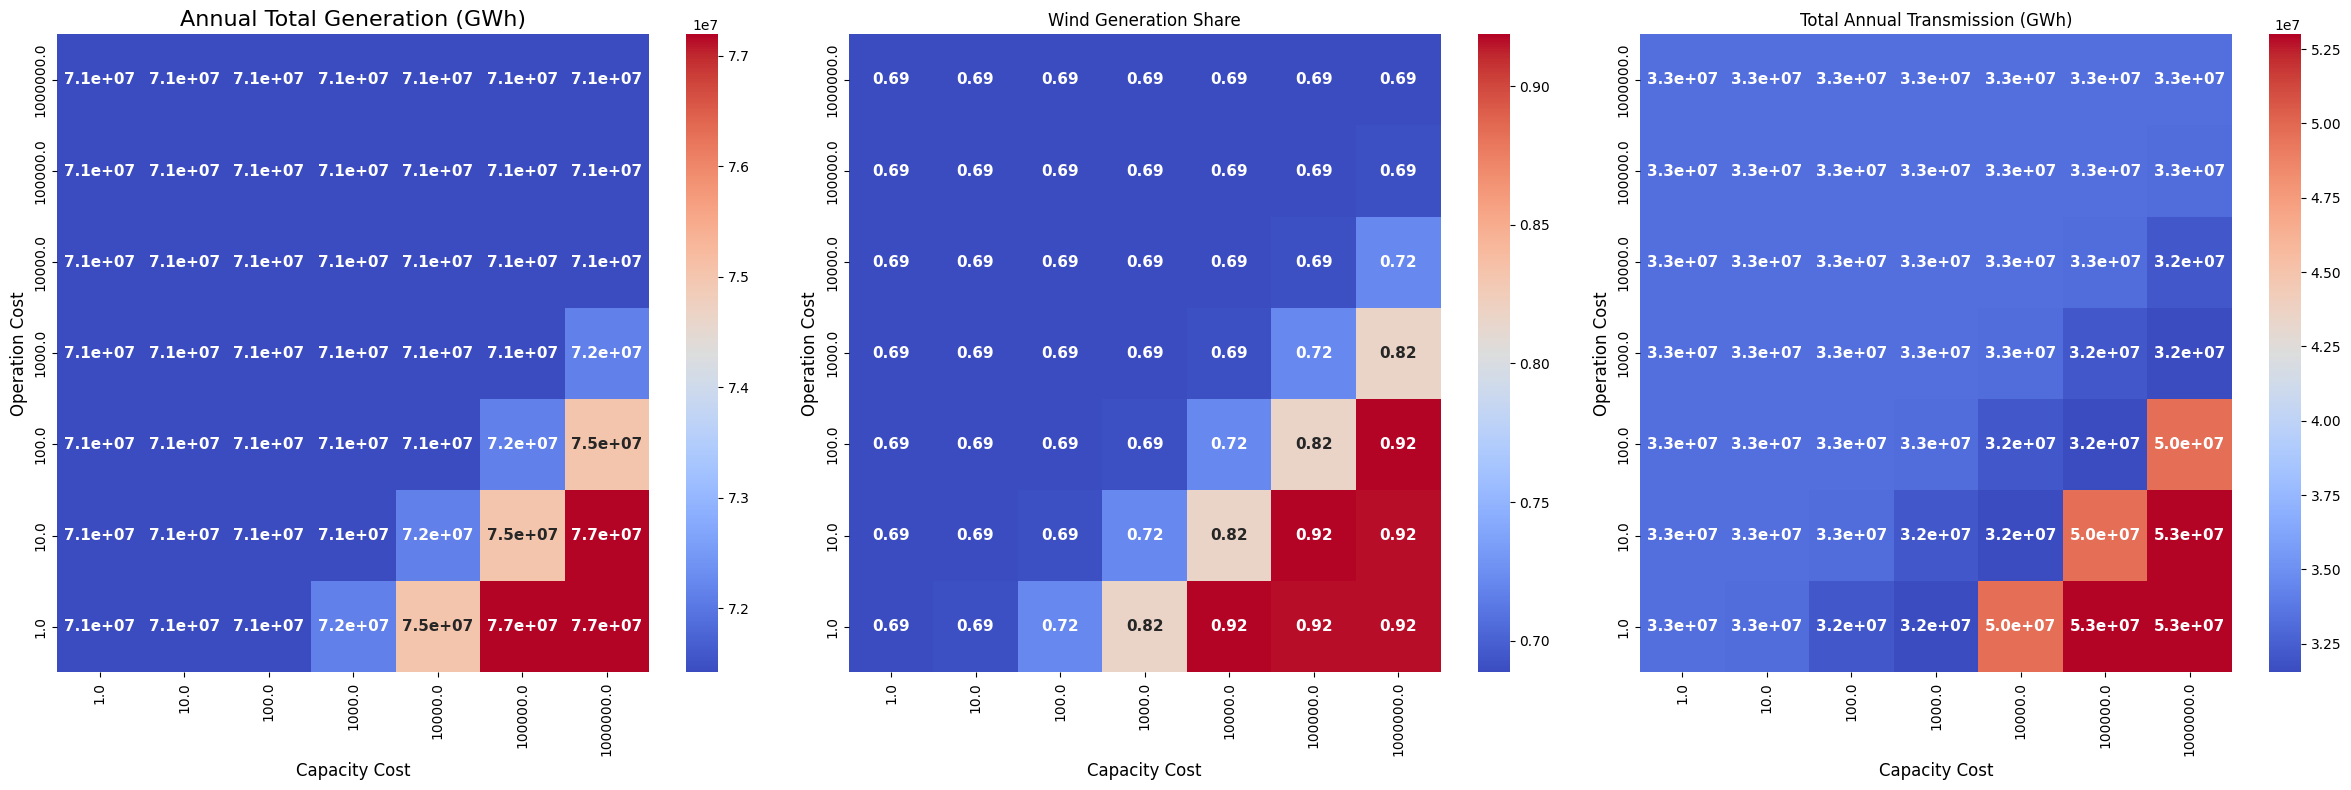

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define costs
costs = np.logspace(0, 6, 7)

# Initialize dictionaries to store heatmap data
annual_gen_data = np.zeros((len(costs), len(costs)))
wind_pv_share_data = np.zeros((len(costs), len(costs)))
total_trans_data = np.zeros((len(costs), len(costs)))

# Populate the matrices
for i, cap_cost in enumerate(costs):
    for j, op_cost in enumerate(costs):
        comb_key = f'cap_{cap_cost}_op_{op_cost}'
        if comb_key in sensitivity_cap_op_cost:
            annual_gen_data[i, j] = sensitivity_cap_op_cost[comb_key]['annual_gen']
            wind_pv_share_data[i, j] = sensitivity_cap_op_cost[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data[i, j] = sensitivity_cap_op_cost[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap
annual_gen_df = pd.DataFrame(annual_gen_data, index=costs, columns=costs).T
wind_pv_share_df = pd.DataFrame(wind_pv_share_data, index=costs, columns=costs).T
total_trans_df = pd.DataFrame(total_trans_data, index=costs, columns=costs).T
annot_kws = {"size": 11, "weight": "bold"}
# Format numbers in scientific notation
def scientific_format(x, pos):
    return f'{x:.1e}'

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap
sns.heatmap(annual_gen_df, ax=axs[0], cmap='coolwarm', annot=True, fmt=".1e", annot_kws=annot_kws)
axs[0].set_title('Annual Total Generation (GWh)', fontsize=16)
axs[0].set_ylabel('Operation Cost', fontsize=12)
axs[0].set_xlabel('Capacity Cost', fontsize=12)
axs[0].invert_yaxis()
# Wind and PV Share Heatmap
sns.heatmap(wind_pv_share_df, ax=axs[1], cmap='coolwarm', annot=True, fmt=".2f", annot_kws=annot_kws)
axs[1].set_title('Wind Generation Share')
axs[1].set_ylabel('Operation Cost', fontsize=12)
axs[1].set_xlabel('Capacity Cost', fontsize=12)
axs[1].invert_yaxis()
# Total Transmission Heatmap
sns.heatmap(total_trans_df, ax=axs[2], cmap='coolwarm', annot=True, fmt=".1e", annot_kws=annot_kws)
axs[2].set_title('Total Annual Transmission (GWh)', fontsize=12)
axs[2].set_ylabel('Operation Cost', fontsize=12)
axs[2].set_xlabel('Capacity Cost', fontsize=12)
axs[2].invert_yaxis()
plt.tight_layout()
plt.show()


## Wind vs Solar

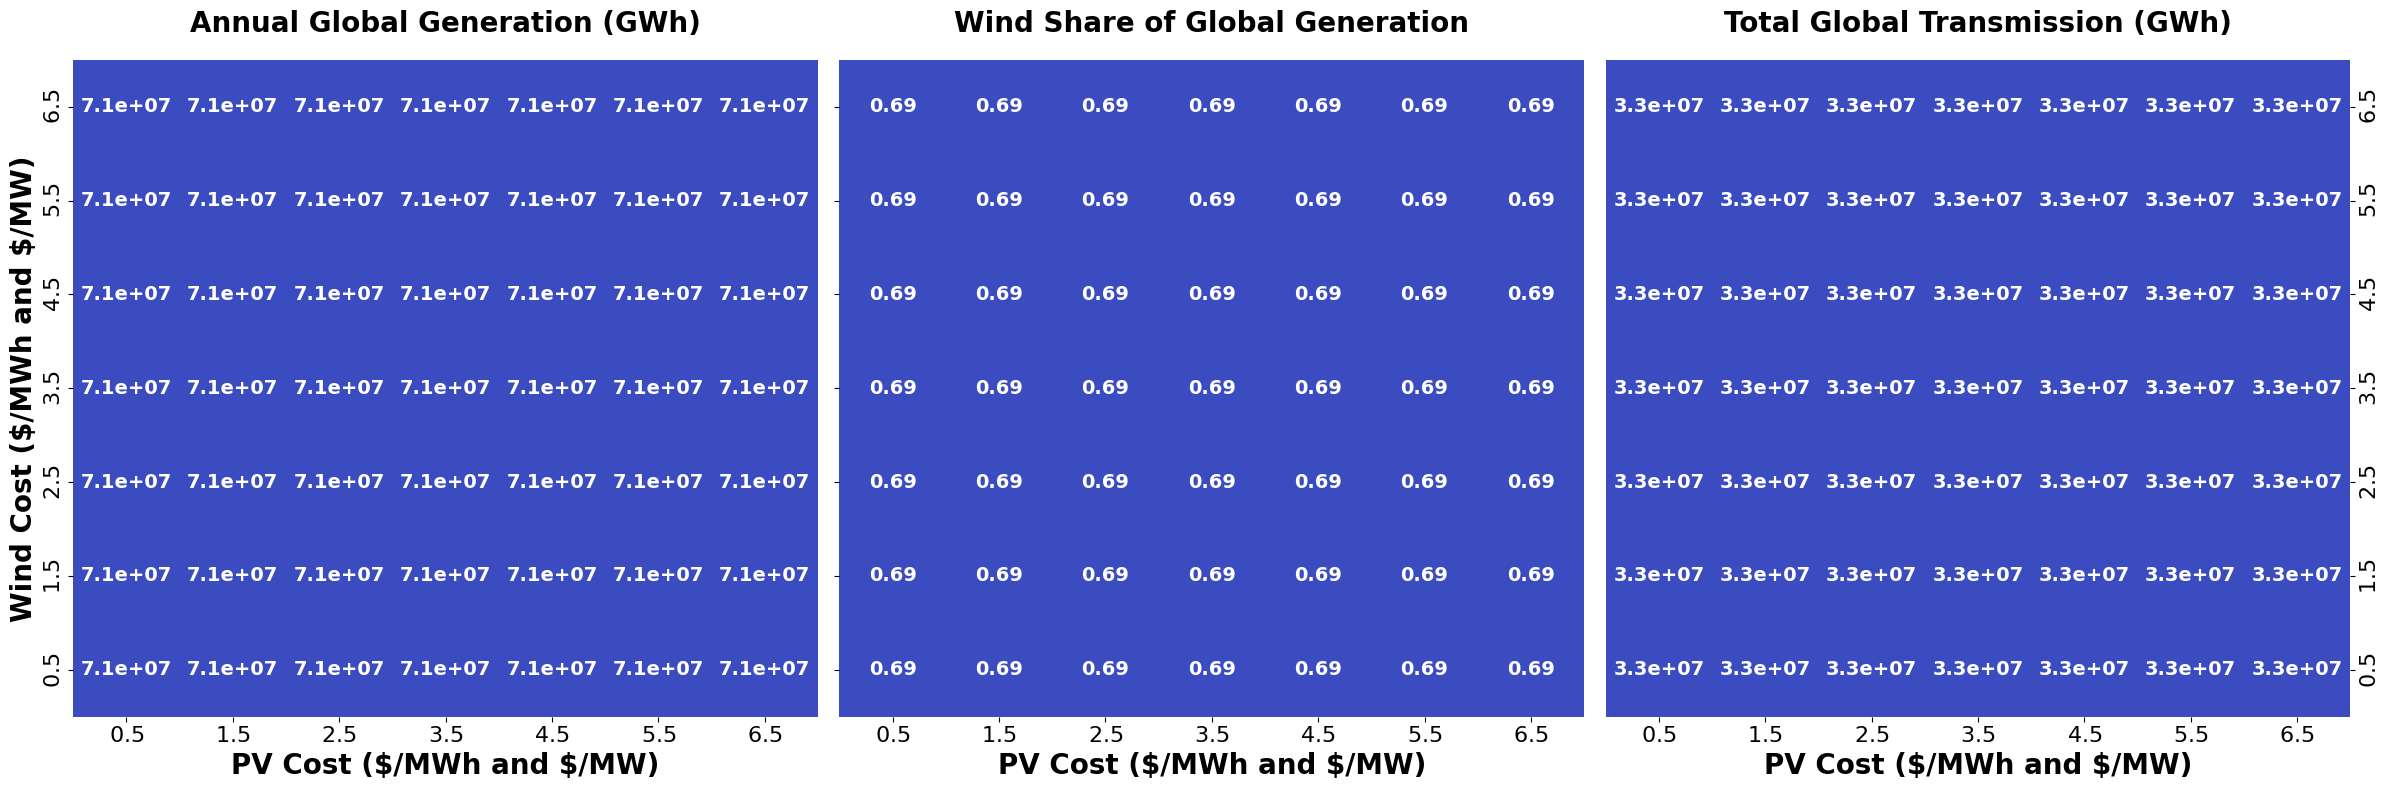

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter

# Define costs
costs = np.logspace(0, 6, 7)

# Initialize dictionaries to store heatmap data
annual_gen_data = np.zeros((len(costs), len(costs)))
wind_pv_share_data = np.zeros((len(costs), len(costs)))
total_trans_data = np.zeros((len(costs), len(costs)))

# Populate the matrices
for i, wind_cost in enumerate(costs):
    for j, pv_cost in enumerate(costs):
        comb_key = f'wind_{wind_cost}_pv_{pv_cost}'
        if comb_key in sensitivity_cost_wind_pv:
            annual_gen_data[i, j] = sensitivity_cost_wind_pv[comb_key]['annual_gen']
            wind_pv_share_data[i, j] = sensitivity_cost_wind_pv[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data[i, j] = sensitivity_cost_wind_pv[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap
annual_gen_df = pd.DataFrame(annual_gen_data, index=costs, columns=costs)
wind_pv_share_df = pd.DataFrame(wind_pv_share_data, index=costs, columns=costs)
total_trans_df = pd.DataFrame(total_trans_data, index=costs, columns=costs)
annot_kws = {"size": 14, "weight": "bold"}
vmin_annual_gen, vmax_annual_gen = annual_gen_df.min().min(), annual_gen_df.max().max()
vmin_wind_pv_share, vmax_wind_pv_share = wind_pv_share_df.min().min(), wind_pv_share_df.max().max()
vmin_total_trans, vmax_total_trans = total_trans_df.min().min(), total_trans_df.max().max()

# Configure scientific notation for tick labels
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
formatter.set_powerlimits((-4,7))

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap
sns.heatmap(annual_gen_df, ax=axs[0], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[0].set_title('Annual Global Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[0].set_ylabel(r'Wind Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)
axs[0].xaxis.set_major_formatter(FuncFormatter(scientific_format))
axs[0].yaxis.set_major_formatter(FuncFormatter(scientific_format))
axs[0].xaxis.set_major_formatter(formatter)
axs[0].yaxis.set_major_formatter(formatter)


# Wind and PV Share Heatmap
sns.heatmap(wind_pv_share_df, ax=axs[1], cmap='coolwarm', annot=True, cbar=False, fmt=".2f", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[1].set_title('Wind Share of Global Generation', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])
axs[1].xaxis.set_major_formatter(formatter)


# Total Transmission Heatmap
sns.heatmap(total_trans_df, ax=axs[2], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws, vmin=1e9, vmax=1e11)
axs[2].set_title('Total Global Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel(r'PV Cost (\$/MWh and \$/MW)', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()

# Move y-axis labels to the right side and ensure proper alignment only for the third axis
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')
axs[2].xaxis.set_major_formatter(formatter)
axs[2].yaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()


## Generation vs Transmission

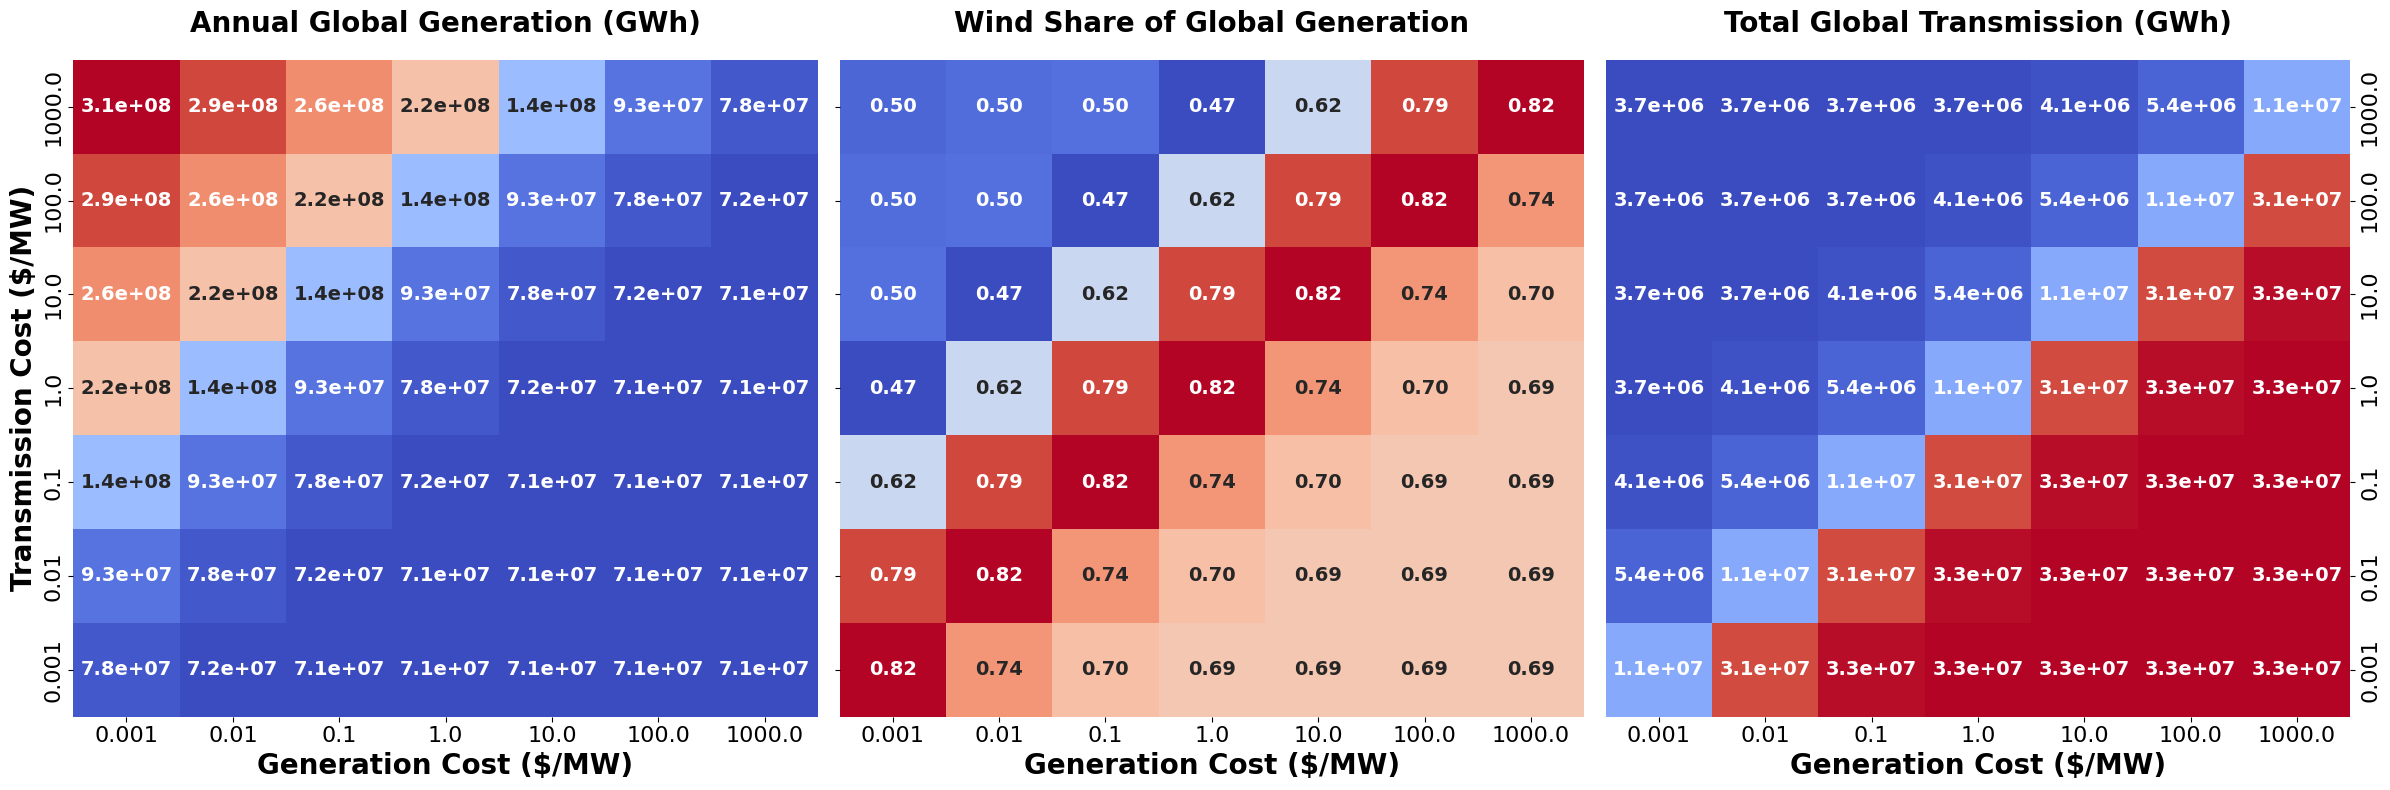

In [97]:
costs = np.logspace(0, 6, 7) /1000

# Initialize dictionaries to store heatmap data for sensitivity_cost_trans
annual_gen_data_trans = np.zeros((len(costs), len(costs)))
wind_pv_share_data_trans = np.zeros((len(costs), len(costs)))
total_trans_data_trans = np.zeros((len(costs), len(costs)))

# Populate the matrices for sensitivity_cost_trans
for i, gen_cost in enumerate(costs):
    for j, trans_cost in enumerate(costs):
        comb_key = f'gen_{gen_cost}_trans_{trans_cost}'
        if comb_key in sensitivity_cost_trans:
            annual_gen_data_trans[i, j] = sensitivity_cost_trans[comb_key]['annual_gen']
            wind_pv_share_data_trans[i, j] = sensitivity_cost_trans[comb_key]['wind_pv_share'][0]  # Summing wind and pv share
            total_trans_data_trans[i, j] = sensitivity_cost_trans[comb_key]['total_trans']

# Convert matrices to DataFrames for better labeling in the heatmap for sensitivity_cost_trans
annual_gen_df_trans = pd.DataFrame(annual_gen_data_trans, index=costs, columns=costs).T
wind_pv_share_df_trans = pd.DataFrame(wind_pv_share_data_trans, index=costs, columns=costs).T
total_trans_df_trans = pd.DataFrame(total_trans_data_trans, index=costs, columns=costs).T

annot_kws = {"size": 14, "weight": "bold"}
# Plot heatmaps for sensitivity_cost_trans
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Annual Generation Heatmap for sensitivity_cost_trans
sns.heatmap(annual_gen_df_trans, ax=axs[0], cmap='coolwarm', annot=True,cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[0].set_title('Annual Global Generation (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[0].set_ylabel('Transmission Cost ($/MW)',  fontsize=20, fontweight='bold')
axs[0].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[0].invert_yaxis()
axs[0].tick_params(axis='x', which='major', labelsize=16)
axs[0].tick_params(axis='y', which='major', labelsize=16)

# Wind and PV Share Heatmap for sensitivity_cost_trans
sns.heatmap(wind_pv_share_df_trans, ax=axs[1], cmap='coolwarm', cbar=False,  annot=True, fmt=".2f", annot_kws=annot_kws)
axs[1].set_title('Wind Share of Global Generation', fontsize=20, fontweight='bold', pad=20)
axs[1].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[1].invert_yaxis()
axs[1].tick_params(axis='x', which='major', labelsize=16)
axs[1].set_yticklabels([])

# Total Transmission Heatmap for sensitivity_cost_trans
sns.heatmap(total_trans_df_trans, ax=axs[2], cmap='coolwarm', annot=True, cbar=False, fmt=".1e", annot_kws=annot_kws)
axs[2].set_title('Annual Global Transmission (GWh)', fontsize=20, fontweight='bold', pad=20)
axs[2].set_xlabel('Generation Cost ($/MW)', fontsize=20, fontweight='bold')
axs[2].invert_yaxis()

# Move y-axis labels to the right side and ensure proper alignment only for the third axis
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')
axs[2].tick_params(axis='x', which='major', labelsize=16)
axs[2].tick_params(axis='y', which='both', labelsize=16, labelright=True, labelleft=False)
axs[2].set_yticklabels(axs[2].get_yticklabels(), va='center')



plt.tight_layout()
plt.show()